<a href="https://colab.research.google.com/github/andrewshandy/Molecular_Properties_Prediction/blob/main/GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-spline-conv  -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric

     |████████████████████████████████| 2.5 MB 6.2 MB/s 
     |████████████████████████████████| 1.5 MB 7.4 MB/s 
     |████████████████████████████████| 27.4 MB 88 kB/s 
     |████████████████████████████████| 15.3 MB 183 kB/s 
     |████████████████████████████████| 1.0 MB 8.5 MB/s 
     |████████████████████████████████| 386 kB 7.9 MB/s 
     |████████████████████████████████| 212 kB 8.5 MB/s 
     |████████████████████████████████| 1.6 MB 13.0 MB/s 
     |████████████████████████████████| 204 kB 36.2 MB/s 
     |████████████████████████████████| 22.3 MB 1.3 MB/s 
     |████████████████████████████████| 3.4 MB 62.2 MB/s 
     |████████████████████████████████| 9.9 MB 60.8 MB/s 
     |████████████████████████████████| 231 kB 73.7 MB/s 
     |████████████████████████████████| 4.1 MB 78.4 MB/s 
     |████████████████████████████████| 2.2 MB 59.8 MB/s 
     |████████████████████████████████| 125 kB 65.9 MB/s 
     |████████████████████████████████| 10.3 MB 51.8 MB/s 
     |█████████████

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:35
🔁 Restarting kernel...


In [2]:
!mamba install -c conda-forge rdkit chembl_structure_pipeline


Streaming output truncated to the last 5000 lines.
pyparsing                [] (00m:00s) Waiting...
xorg-xextproto           [] (00m:00s) Waiting...
rdkit                    [] (00m:00s)      3 MB /     38 MB (  3.47 MB/s)
xorg-libx11              [] (00m:00s) Waiting...
cycler                   [] (00m:00s) Waiting...
importlib-metadata       [] (00m:00s) Waiting...
libgfortran5             [] (00m:00s) 
openssl                  [] (00m:00s) Waiting...
boost-cpp                [] (00m:00s) Waiting...
greenlet                 [] (00m:00s) Decompressing...
libgfortran-ng           [] (00m:00s) Waiting...
libtiff                  [] (00m:00s) Waiting...
libwebp-base             [] (00m:00s) Waiting...
libglib                  [] (00m:00s) Waiting...
olefile                  [] (00m:00s) Waiting...
pcre                     [] (00m:00s) Waiting...
pycairo                  [] (00m:00s) Waiting...
libopenblas              [] (00m:00s) Waiting...
pixman                   [] (00m:00s) Waiting.

![](https://sun9-13.userapi.com/impg/nwUGT_v5SD4SPrGeGBYJi6shmLjcF_cDI5GK_A/tgqh4ZvLCW0.jpg?size=1808x1252&quality=96&sign=9ed64d0773e7387c04a39bf6e4870105&type=album)

![](https://sun9-10.userapi.com/impg/5CKcTAWSw_k3BFjzz4pvtxf3niCB_zLMtW2N_w/JoXP8ChWeEo.jpg?size=1804x1218&quality=96&sign=2f9469a06bf487cc1824b009d4f56dc1&type=album)

![](https://sun9-43.userapi.com/impg/x1zOb655izl3rFAaXFX4a1WNa_qoEU4drobkaw/cMr9U5cN4wA.jpg?size=1798x1214&quality=96&sign=86eccff6eeda4300d562eb4a6774287b&type=album)

![](https://sun9-44.userapi.com/impg/pWB8AKJJkXS0S5ZIqRo7TiWsnRoAOIa_9w-0yA/8LaLqsqwHfQ.jpg?size=1798x1246&quality=96&sign=4e8a35b2c45355cb528341317cdb4fa6&type=album)

# Importing Libraries

In [3]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt

from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import rdMolDescriptors
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray

import torch

from torch_geometric.data.dataloader import DataLoader as DataLoader_geom

import torch_geometric


from sklearn.model_selection import train_test_split


from torch_geometric.nn import MessagePassing
from torch_scatter import scatter_add
from torch_geometric.utils import add_self_loops, degree

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

%matplotlib inline

# Data loading

In [4]:
!wget https://www.dropbox.com/s/5b05tivi01a43np/delaney-processed.csv

--2021-05-09 17:18:23--  https://www.dropbox.com/s/5b05tivi01a43np/delaney-processed.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5b05tivi01a43np/delaney-processed.csv [following]
--2021-05-09 17:18:23--  https://www.dropbox.com/s/raw/5b05tivi01a43np/delaney-processed.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce1c5d45249ec8da7481e231d6c.dl.dropboxusercontent.com/cd/0/inline/BOKq-OtqvNaqndhZg0yfT1bbLAvk6XXBifxBulcI6LMXijT4lKaZn-gj2NK9Utc06_QIdBpc6xScjD1MkkrE2RPe2n0YDypsgtDb_FHERIQUvYyDXrWGKMgh2QFUgm9gyRBE8cU-eq0XKhWggPGhjcxG/file# [following]
--2021-05-09 17:18:24--  https://uce1c5d45249ec8da7481e231d6c.dl.dropboxusercontent.com/cd/0/inline/BOKq-OtqvNaqndhZg0yfT1bbLAvk6XXBifxBulcI6LMXijT4lKaZn-gj2NK9Utc

## Neural Fingerprints

![](https://sun9-22.userapi.com/impg/Kaz555p_NDnY-pIv2k5-lI59uGz_G4oXLYZq4w/b3IjgT_fVyU.jpg?size=2382x1384&quality=96&sign=ba1bfdbd1827f78647308e17e0ac0955&type=album)

# Extracting Features from molecules 

In [5]:
BATCH_SIZE = 30

In [6]:
def get_atom_features(mol):
    atomic_number = []
    num_hs = []
    degrees = []
    charges = []
    tags = []
    hybridizations = []
    aromatic = []
    mass = []
    
    for atom in mol.GetAtoms():
        atomic_number.append(atom.GetAtomicNum()) # atomic number
        num_hs.append(atom.GetTotalNumHs(includeNeighbors=True)) # number of H in atom 
        degrees.append(atom.GetTotalDegree()) # total Degree of atom
        charges.append(atom.GetFormalCharge()) # Charge of atom
        tags.append(int(atom.GetChiralTag())) # chiral tag
        hybridizations.append(int(atom.GetHybridization())) # hybridization of atom
        if atom.GetIsAromatic(): # Is aromatic of not
            aromatic.append(1)
        else:
            aromatic.append(0)
        mass.append(atom.GetMass() * 0.01) # mass
                
    return torch.tensor([atomic_number, num_hs, degrees, charges, tags, hybridizations, aromatic, mass]).t()

def get_edge_index(mol):
    row, col = [], []
    
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        row += [start, end]
        col += [end, start]
        
    return torch.tensor([row, col], dtype=torch.long)

In [7]:
import torch
from torch_geometric.data.data import Data

In [8]:
def prepare_dataloader(mol_list):
    data_list = []

    for i, mol in enumerate(mol_list):
        adj_matrix = get_edge_index(mol)
        features = get_atom_features(mol).float()
        data_list.append(Data(features , adj_matrix))

    return DataLoader_geom(data_list, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
import pandas as pd
import os

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from typing import Dict, List, Optional
from pathlib import Path

from multiprocessing.pool import Pool

from rdkit.Chem.MolStandardize.tautomer import TautomerCanonicalizer

from multiprocessing.pool import Pool





Load data and standartize smiles

In [10]:
class DatasetsHolder:
    @staticmethod
    def read_datasets(inp_folder_path):
        df = pd.read_csv(inp_folder_path)
        return df
        # return pandas DataFrame


class StandardizeDatasets:
    @staticmethod
    def standardize_smiles(smi: str) -> Optional[str]:
        mol = Chem.MolFromSmiles(smi)
        mol = Chem.MolToSmiles(mol)
        return mol
        "crete typical standartization of one smiles"

    def standartize(self, inp_path: Path, out_path: Path):
        df_reader = DatasetsHolder()
        df = df_reader.read_datasets(inp_path)
        with Pool(10) as pool:
          df['standardize_smiles'] = list(
                      tqdm(pool.imap(self.standardize_smiles, df.smiles), total=df.shape[0])
                  )
        df.to_csv(out_path, index=False)
        return df
        "apply standartization to all smiles"


class StandardizeTautomers(StandardizeDatasets):
    @staticmethod
    def standardize_smiles(smi: str) -> Optional[str]:
        Canonicalizer = TautomerCanonicalizer()
        mol = Chem.MolFromSmiles(smi)
        standorized = Canonicalizer.canonicalize(mol)
        return Chem.MolToSmiles(standorized)
      # "apply TautomerCanonicalizer() to standartization"

In [11]:
data_reader = StandardizeTautomers()
df = data_reader.standartize("/content/delaney-processed.csv", "standartized.csv")


100%|██████████| 1128/1128 [00:11<00:00, 94.63it/s]


In [12]:
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,standardize_smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,CCC(C)C


In [ ]:
train, test = train_test_split(df , test_size=0.1)

train_mol = train['standardize_smiles'].map(lambda x : Chem.MolFromSmiles(x))
test_mol = test['standardize_smiles'].map(lambda x : Chem.MolFromSmiles(x))


train_loader, test_loader = prepare_dataloader(train_mol) ,prepare_dataloader(test_mol)


In [ ]:
train_labels_dataset = TensorDataset(torch.tensor(train['measured log solubility in mols per litre'].to_numpy()).float())
test_labels_dataset = TensorDataset(torch.tensor(test['measured log solubility in mols per litre'].to_numpy()).float())


train_labels_loader = DataLoader(train_labels_dataset, batch_size=BATCH_SIZE)
test_labels_loader = DataLoader(test_labels_dataset, batch_size=BATCH_SIZE)

![](https://miro.medium.com/max/4800/1*gC8q4uABSQtM8zyXG2wOog.png)




## Message passing

![](https://sun9-62.userapi.com/impg/oLkDmzkOa73Ajb5YgtKgqyRl0tMfpCPZmMiX5Q/JMl5RSOiZWs.jpg?size=1790x374&quality=96&sign=cd297d5a8399d1344032902c39a271b0&type=album)

In [13]:
device = torch.device('cuda')

In [14]:
class NeuralLoop(MessagePassing):
    def __init__(self, atom_features, fp_size):
        super(NeuralLoop, self).__init__(aggr='add')
        self.H = nn.Linear(atom_features, atom_features)
        self.W = nn.Linear(atom_features, fp_size)
        
    def forward(self, x, edge_index):
        # x shape: [Number of atoms in molecule, Number of atom features]; [N, in_channels]
        # edge_index shape: [2, E]; E is the number of edges

        edge_index, _ = add_self_loops(edge_index)



        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)
    
    def message(self, x_j, edge_index, size):

        return x_j
    
    def update(self, v):

        updated_atom_features =  self.H(v).sigmoid()
        updated_fingerprint =  self.W(updated_atom_features).softmax(-1)
        
        return updated_atom_features, updated_fingerprint

In [15]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [16]:
class NeuralFP(nn.Module):
    def __init__(self, atom_features=52, fp_size=50):
        super(NeuralFP, self).__init__()
        
        self.atom_features = atom_features
        self.fp_size = fp_size

        
        self.loop1 =  GCNConv(atom_features, fp_size)

        self.loops = nn.ModuleList([self.loop1])
        
    def forward(self, data):
        fingerprint = torch.zeros((data.batch.shape[0], self.fp_size), dtype=torch.float).to(device)
        
        out = data.x
        for idx, loop in enumerate(self.loops):
      
            updated_fingerprint = loop(out, data.edge_index)
            fingerprint += updated_fingerprint

        return scatter_add(fingerprint, data.batch, dim=0)

In [17]:
import torch.nn.functional as F

class MLP_Regressor(nn.Module):
    def __init__(self, neural_fp, atom_features=2, fp_size=50, hidden_size=100):
        super(MLP_Regressor, self).__init__()


        self.neural_fp = neural_fp
        self.lin1 =  nn.Linear(fp_size , hidden_size)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.lin2 =  nn.Linear(hidden_size, 1)
        self.dropout =  nn.Dropout(0.2)
    
    def forward(self, batch):

        fp = self.neural_fp(batch)
        hidden =  self.dropout(self.lin1(fp))
        out =  self.leakyrelu(self.lin2(hidden))
        return out

In [18]:
neural_fp = NeuralFP(8, 50)

In [19]:
reg = MLP_Regressor(neural_fp, atom_features=8, fp_size=50, hidden_size=100).to(device)

In [20]:
from torch import optim
device = torch.device('cuda')
NUM_EPOCHS = 200

In [21]:
criterion = nn.MSELoss()
optimizer = optim.Adam(reg.parameters(), 
                       lr=0.001
                       )

# Training baseline GCN model using only smiles

In [ ]:
losses = []
for epoch in range(NUM_EPOCHS):
    running_loss = 0
    

    for x , labels  in tqdm(zip(train_loader, train_labels_loader)):
        labels = labels[0].float()

        x = x.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        output = reg(x).view(-1)

        loss = criterion(output, labels)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch {epoch} - Training rmse loss: {(running_loss/len(train_loader))**0.5}")
    losses.append(running_loss/len(train_loader))

34it [00:00, 221.81it/s]
34it [00:00, 242.08it/s]
0it [00:00, ?it/s]

Epoch 0 - Training rmse loss: 1.9448208150349215
Epoch 1 - Training rmse loss: 1.7179029203071765


34it [00:00, 249.78it/s]
34it [00:00, 242.35it/s]
0it [00:00, ?it/s]

Epoch 2 - Training rmse loss: 1.6664513468732034
Epoch 3 - Training rmse loss: 1.6563030577363145


34it [00:00, 242.31it/s]
34it [00:00, 236.69it/s]
0it [00:00, ?it/s]

Epoch 4 - Training rmse loss: 1.6639337950803295
Epoch 5 - Training rmse loss: 1.6024544387201383


34it [00:00, 231.51it/s]
34it [00:00, 250.93it/s]
0it [00:00, ?it/s]

Epoch 6 - Training rmse loss: 1.6092924328880938
Epoch 7 - Training rmse loss: 1.6111532122487977


34it [00:00, 236.40it/s]
34it [00:00, 242.94it/s]
0it [00:00, ?it/s]

Epoch 8 - Training rmse loss: 1.5935392625424016
Epoch 9 - Training rmse loss: 1.6096649801894682


34it [00:00, 238.71it/s]
34it [00:00, 244.96it/s]
0it [00:00, ?it/s]

Epoch 10 - Training rmse loss: 1.5857483224006705
Epoch 11 - Training rmse loss: 1.5548557998893946


34it [00:00, 221.79it/s]
34it [00:00, 232.18it/s]
0it [00:00, ?it/s]

Epoch 12 - Training rmse loss: 1.560068495988607
Epoch 13 - Training rmse loss: 1.5468608631161231


34it [00:00, 234.01it/s]
34it [00:00, 243.05it/s]
0it [00:00, ?it/s]

Epoch 14 - Training rmse loss: 1.5533437240987065
Epoch 15 - Training rmse loss: 1.5334292173995925


34it [00:00, 242.47it/s]
34it [00:00, 238.58it/s]
0it [00:00, ?it/s]

Epoch 16 - Training rmse loss: 1.5188492531296447
Epoch 17 - Training rmse loss: 1.5254078282481354


34it [00:00, 228.27it/s]
34it [00:00, 236.13it/s]
0it [00:00, ?it/s]

Epoch 18 - Training rmse loss: 1.5241608583881534
Epoch 19 - Training rmse loss: 1.524101283023705


34it [00:00, 234.16it/s]
34it [00:00, 234.93it/s]
0it [00:00, ?it/s]

Epoch 20 - Training rmse loss: 1.537854252025055
Epoch 21 - Training rmse loss: 1.5168656013534325


34it [00:00, 229.87it/s]
34it [00:00, 236.17it/s]
0it [00:00, ?it/s]

Epoch 22 - Training rmse loss: 1.5145058371806788
Epoch 23 - Training rmse loss: 1.51379964039544


34it [00:00, 237.51it/s]
34it [00:00, 244.81it/s]
0it [00:00, ?it/s]

Epoch 24 - Training rmse loss: 1.5304350602041208
Epoch 25 - Training rmse loss: 1.5105863807252042


34it [00:00, 212.67it/s]
34it [00:00, 242.66it/s]
0it [00:00, ?it/s]

Epoch 26 - Training rmse loss: 1.5185431892503733
Epoch 27 - Training rmse loss: 1.5213876457434932


34it [00:00, 233.38it/s]
34it [00:00, 232.48it/s]
0it [00:00, ?it/s]

Epoch 28 - Training rmse loss: 1.524904245241505
Epoch 29 - Training rmse loss: 1.5290279993182887


34it [00:00, 243.37it/s]
34it [00:00, 256.70it/s]
0it [00:00, ?it/s]

Epoch 30 - Training rmse loss: 1.5170048458202874
Epoch 31 - Training rmse loss: 1.5175830067880887


34it [00:00, 224.41it/s]
34it [00:00, 250.79it/s]
0it [00:00, ?it/s]

Epoch 32 - Training rmse loss: 1.5090111743826433
Epoch 33 - Training rmse loss: 1.5056667144971627


34it [00:00, 237.22it/s]
34it [00:00, 240.09it/s]
0it [00:00, ?it/s]

Epoch 34 - Training rmse loss: 1.5095693450362793
Epoch 35 - Training rmse loss: 1.5126245999510461


34it [00:00, 236.18it/s]
34it [00:00, 252.77it/s]
0it [00:00, ?it/s]

Epoch 36 - Training rmse loss: 1.513036205721793
Epoch 37 - Training rmse loss: 1.5095165765158869


34it [00:00, 237.79it/s]
34it [00:00, 234.02it/s]
0it [00:00, ?it/s]

Epoch 38 - Training rmse loss: 1.4884844805087
Epoch 39 - Training rmse loss: 1.4978773604961275


34it [00:00, 250.73it/s]
34it [00:00, 236.44it/s]
0it [00:00, ?it/s]

Epoch 40 - Training rmse loss: 1.4940497453235895
Epoch 41 - Training rmse loss: 1.4913356900314434


34it [00:00, 241.27it/s]
34it [00:00, 225.90it/s]
0it [00:00, ?it/s]

Epoch 42 - Training rmse loss: 1.4977538481009904
Epoch 43 - Training rmse loss: 1.4944401963930565


34it [00:00, 235.41it/s]
34it [00:00, 236.13it/s]
0it [00:00, ?it/s]

Epoch 44 - Training rmse loss: 1.4894413834001619
Epoch 45 - Training rmse loss: 1.5034703123388033


34it [00:00, 235.87it/s]
34it [00:00, 230.78it/s]
0it [00:00, ?it/s]

Epoch 46 - Training rmse loss: 1.508823031731694
Epoch 47 - Training rmse loss: 1.4997773916890107


34it [00:00, 237.32it/s]
34it [00:00, 244.36it/s]
0it [00:00, ?it/s]

Epoch 48 - Training rmse loss: 1.5128134935295274
Epoch 49 - Training rmse loss: 1.477617619949868


34it [00:00, 243.95it/s]
34it [00:00, 241.02it/s]
0it [00:00, ?it/s]

Epoch 50 - Training rmse loss: 1.5091375988658564
Epoch 51 - Training rmse loss: 1.4946901547953673


34it [00:00, 231.54it/s]
34it [00:00, 227.76it/s]
0it [00:00, ?it/s]

Epoch 52 - Training rmse loss: 1.5005041483672892
Epoch 53 - Training rmse loss: 1.491664012208111


34it [00:00, 247.66it/s]
34it [00:00, 241.69it/s]
0it [00:00, ?it/s]

Epoch 54 - Training rmse loss: 1.5084774012791127
Epoch 55 - Training rmse loss: 1.5104184812904997


34it [00:00, 235.95it/s]
34it [00:00, 245.10it/s]
0it [00:00, ?it/s]

Epoch 56 - Training rmse loss: 1.4960517777812774
Epoch 57 - Training rmse loss: 1.4867674440826018


34it [00:00, 248.66it/s]
34it [00:00, 242.67it/s]
0it [00:00, ?it/s]

Epoch 58 - Training rmse loss: 1.5048648608763842
Epoch 59 - Training rmse loss: 1.5119391293901043


34it [00:00, 237.14it/s]
34it [00:00, 242.13it/s]
0it [00:00, ?it/s]

Epoch 60 - Training rmse loss: 1.4919809751272244
Epoch 61 - Training rmse loss: 1.4920598049760831


34it [00:00, 245.84it/s]
34it [00:00, 219.81it/s]
0it [00:00, ?it/s]

Epoch 62 - Training rmse loss: 1.4835861838276951
Epoch 63 - Training rmse loss: 1.475646787253017


34it [00:00, 211.63it/s]
34it [00:00, 242.88it/s]
0it [00:00, ?it/s]

Epoch 64 - Training rmse loss: 1.4898519821643215
Epoch 65 - Training rmse loss: 1.480730744358715


34it [00:00, 224.53it/s]
34it [00:00, 230.60it/s]
0it [00:00, ?it/s]

Epoch 66 - Training rmse loss: 1.5051331879518632
Epoch 67 - Training rmse loss: 1.4862551954696934


34it [00:00, 241.52it/s]
34it [00:00, 232.39it/s]
0it [00:00, ?it/s]

Epoch 68 - Training rmse loss: 1.4716290626378885
Epoch 69 - Training rmse loss: 1.4791398076250233


34it [00:00, 240.34it/s]
34it [00:00, 239.22it/s]
0it [00:00, ?it/s]

Epoch 70 - Training rmse loss: 1.4826340377557052
Epoch 71 - Training rmse loss: 1.4883231139026412


34it [00:00, 224.30it/s]
34it [00:00, 226.42it/s]
0it [00:00, ?it/s]

Epoch 72 - Training rmse loss: 1.4711332953342742
Epoch 73 - Training rmse loss: 1.4701729554864087


34it [00:00, 247.51it/s]
34it [00:00, 226.51it/s]
0it [00:00, ?it/s]

Epoch 74 - Training rmse loss: 1.4815806740042596
Epoch 75 - Training rmse loss: 1.4844073383599785


34it [00:00, 243.84it/s]
34it [00:00, 241.90it/s]
0it [00:00, ?it/s]

Epoch 76 - Training rmse loss: 1.4818273169612417
Epoch 77 - Training rmse loss: 1.4740536494476315


34it [00:00, 239.98it/s]
34it [00:00, 254.03it/s]
0it [00:00, ?it/s]

Epoch 78 - Training rmse loss: 1.4925197857533716
Epoch 79 - Training rmse loss: 1.4912302149764631


34it [00:00, 239.49it/s]
34it [00:00, 247.28it/s]
0it [00:00, ?it/s]

Epoch 80 - Training rmse loss: 1.481189110253113
Epoch 81 - Training rmse loss: 1.4860013655836035


34it [00:00, 240.51it/s]
34it [00:00, 251.62it/s]
0it [00:00, ?it/s]

Epoch 82 - Training rmse loss: 1.4723876789174424
Epoch 83 - Training rmse loss: 1.47723825439793


34it [00:00, 231.03it/s]
34it [00:00, 252.51it/s]
0it [00:00, ?it/s]

Epoch 84 - Training rmse loss: 1.4908647128324504
Epoch 85 - Training rmse loss: 1.4779549250718196


34it [00:00, 234.95it/s]
34it [00:00, 246.00it/s]
0it [00:00, ?it/s]

Epoch 86 - Training rmse loss: 1.4683889797561973
Epoch 87 - Training rmse loss: 1.4827971194524237


34it [00:00, 243.24it/s]
34it [00:00, 244.01it/s]
0it [00:00, ?it/s]

Epoch 88 - Training rmse loss: 1.4799497003244428
Epoch 89 - Training rmse loss: 1.4723754962794136


34it [00:00, 243.76it/s]
34it [00:00, 246.47it/s]
0it [00:00, ?it/s]

Epoch 90 - Training rmse loss: 1.4817498617490101
Epoch 91 - Training rmse loss: 1.4829374385211804


34it [00:00, 246.11it/s]
34it [00:00, 251.64it/s]
0it [00:00, ?it/s]

Epoch 92 - Training rmse loss: 1.467964257002726
Epoch 93 - Training rmse loss: 1.4794926899053942


34it [00:00, 223.59it/s]
34it [00:00, 253.37it/s]
0it [00:00, ?it/s]

Epoch 94 - Training rmse loss: 1.4728324845397087
Epoch 95 - Training rmse loss: 1.4850930133743343


34it [00:00, 241.69it/s]
34it [00:00, 250.45it/s]
0it [00:00, ?it/s]

Epoch 96 - Training rmse loss: 1.4831517201283293
Epoch 97 - Training rmse loss: 1.4898150822254017


34it [00:00, 229.72it/s]
34it [00:00, 250.73it/s]

Epoch 98 - Training rmse loss: 1.476931204473597
Epoch 99 - Training rmse loss: 1.4792438965994346


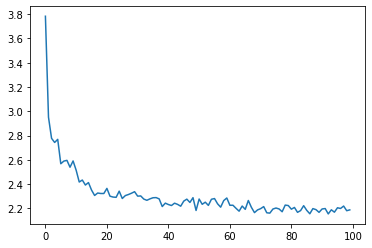

In [ ]:
plt.plot(losses)

# Validation of baseline GCN

In [ ]:
running_loss = 0
for x , labels  in tqdm(zip(test_loader, test_labels_loader)):
    labels = labels[0].float()

    x = x.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = reg(x).view(-1)

    loss = criterion(output, labels)

    running_loss += loss.item()

print(f"Epoch {epoch} - Training loss: {(running_loss/len(test_loader))**0.5}")

4it [00:00, 224.47it/s]

Epoch 99 - Training loss: 1.4356131194523627


# Adding new features which were extracted in baseline notebook 

In [22]:
!pip install git+https://github.com/bp-kelley/descriptastorus

  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-mkor3vlo
  Running command git clone -q https://github.com/bp-kelley/descriptastorus /tmp/pip-req-build-mkor3vlo
     |████████████████████████████████| 801 kB 7.9 MB/s 
  Created wheel for descriptastorus: filename=descriptastorus-2.3.0.2-py3-none-any.whl size=60174 sha256=82c724d7250009086503f73ee097f4cc2da3c1970c77cc0cd414d156d05d1c33
  Stored in directory: /tmp/pip-ephem-wheel-cache-v1uxgd2p/wheels/f9/c3/4f/e7d01f4f2f1a89aef8f0ef088beb4a94976324f3ee21410b10
Successfully built descriptastorus


In [23]:
from descriptastorus.descriptors import rdDescriptors
from rdkit import Chem
import logging
from descriptastorus.descriptors import rdNormalizedDescriptors


generator = rdNormalizedDescriptors.RDKit2DNormalized()

In [24]:
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,standardize_smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,CCC(C)C


In [25]:
def create_feature_dataframe(df):
    feature_names = [x[0] for x in generator.columns]

    rdkit_feats = [ ]
    for i in range(len(df)):
        smiles = df.iloc[i]['standardize_smiles']
        target_value = df.iloc[i]['measured log solubility in mols per litre']
        features = generator.process(smiles)
        dictionary = dict(zip(feature_names, features[1:]))
        dictionary['target'] = target_value
        rdkit_feats.append(dictionary)

    return pd.DataFrame(rdkit_feats)
    # features = df[SMILES_COLUMN].map(zip(feature_names, lambda x : rdkit_2d_features(x)))
    # new_df = pd.DataFrame(dict(features))
    # return new_df
  # сделайте датафрейм из всех свойств полученных генератором

new_df = create_feature_dataframe(df)
new_df = new_df.drop(columns=['target'])


In [ ]:
new_df

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,...,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,0.431154,0.304703,0.742380,0.611255,0.564015,0.695016,0.628013,0.550359,0.632004,0.526516,0.647978,0.533322,0.567960,0.441039,9.662156e-01,9.852195e-01,6.893569e-07,0.100218,0.131846,2.509948e-11,9.258417e-11,8.288383e-01,0.464812,2.391450e-11,8.205149e-01,0.722986,0.070685,0.057481,0.064305,9.048759e-01,0.837960,0.706530,0.720712,0.999999,0.815583,0.810059,0.640453,0.664681,0.063911,0.247244,...,0.168149,0.165451,1.171103e-13,0.0,0.164669,0.166925,0.0,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,0.975564,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.069877
1,0.831056,0.076056,0.026948,0.030340,0.020389,0.033934,0.032592,0.020369,0.029170,0.015533,0.038519,0.021520,0.041210,0.024028,4.074888e-10,2.648697e-01,6.893569e-07,0.218593,0.307374,1.510129e-01,6.498039e-01,5.663300e-01,0.651997,1.691932e-01,3.299699e-01,0.018750,0.715690,0.681483,0.524134,1.024882e-01,0.761894,0.030800,0.019873,0.999999,0.018461,0.031261,0.270675,0.024863,0.170656,0.621108,...,0.168149,0.165451,1.171103e-13,0.0,0.164669,0.166925,0.0,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.999908,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.861151
2,0.991404,0.006351,0.008175,0.017477,0.011397,0.005603,0.013714,0.008724,0.020863,0.010806,0.009586,0.005097,0.008525,0.004764,4.074888e-10,2.648697e-01,6.893569e-07,0.100218,0.019674,5.917485e-01,6.288924e-01,3.815791e-01,0.477870,5.834501e-01,7.522456e-13,0.003645,0.829479,0.638385,0.295614,7.336696e-01,0.954836,0.005699,0.002908,0.999999,0.026889,0.179088,0.789732,0.006155,0.057285,0.101979,...,0.168149,0.165451,1.171103e-13,0.0,0.164669,0.166925,0.0,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.171383
3,0.777909,0.624374,0.145605,0.194124,0.153062,0.246362,0.287320,0.218869,0.320262,0.224962,0.476379,0.357717,0.590347,0.464119,4.074888e-10,2.175235e-08,6.893569e-07,0.100218,0.019674,2.509948e-11,9.658268e-01,5.856109e-17,0.000001,9.913422e-01,7.522456e-13,0.116563,0.000944,0.002053,0.003521,2.155533e-14,0.458839,0.214325,0.122267,0.999999,0.062004,0.044811,0.197879,0.191387,0.010197,0.022049,...,0.168149,0.165451,1.171103e-13,0.0,0.164669,0.166925,0.0,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.

In [ ]:
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,standardize_smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,CCC(C)C


In [ ]:
new_df = new_df.join(df.drop(columns=["Compound ID", "smiles"]))
new_df

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,...,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,standardize_smiles
0,0.431154,0.304703,0.742380,0.611255,0.564015,0.695016,0.628013,0.550359,0.632004,0.526516,0.647978,0.533322,0.567960,0.441039,9.662156e-01,9.852195e-01,6.893569e-07,0.100218,0.131846,2.509948e-11,9.258417e-11,8.288383e-01,0.464812,2.391450e-11,8.205149e-01,0.722986,0.070685,0.057481,0.064305,9.048759e-01,0.837960,0.706530,0.720712,0.999999,0.815583,0.810059,0.640453,0.664681,0.063911,0.247244,...,0.154654,2.794209e-22,0.975564,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.069877,-0.974,1,457.432,7,3,7,202.32,-0.770,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1,0.831056,0.076056,0.026948,0.030340,0.020389,0.033934,0.032592,0.020369,0.029170,0.015533,0.038519,0.021520,0.041210,0.024028,4.074888e-10,2.648697e-01,6.893569e-07,0.218593,0.307374,1.510129e-01,6.498039e-01,5.663300e-01,0.651997,1.691932e-01,3.299699e-01,0.018750,0.715690,0.681483,0.524134,1.024882e-01,0.761894,0.030800,0.019873,0.999999,0.018461,0.031261,0.270675,0.024863,0.170656,0.621108,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.999908,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.861151,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc1ccccc1
2,0.991404,0.006351,0.008175,0.017477,0.011397,0.005603,0.013714,0.008724,0.020863,0.010806,0.009586,0.005097,0.008525,0.004764,4.074888e-10,2.648697e-01,6.893569e-07,0.100218,0.019674,5.917485e-01,6.288924e-01,3.815791e-01,0.477870,5.834501e-01,7.522456e-13,0.003645,0.829479,0.638385,0.295614,7.336696e-01,0.954836,0.005699,0.002908,0.999999,0.026889,0.179088,0.789732,0.006155,0.057285,0.101979,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.171383,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC=O
3,0.777909,0.624374,0.145605,0.194124,0.153062,0.246362,0.287320,0.218869,0.320262,0.224962,0.476379,0.357717,0.590347,0.464119,4.074888e-10,2.175235e-08,6.893569e-07,0.100218,0.019674,2.509948e-11,9.658268e-01,5.856109e-17,0.000001,9.913422e-01,7.522456e-13,0.116563,0.000944,0.002053,0.003521,2.155533e-14,0.458839,0.214325,0.122267,0.999999,0.062004,0.044811,0.197879,0.191387,0.010197,0.022049,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.

In [ ]:
# morgan_fingerprints = new_df['standardize_smiles'].map(lambda x : rdMolDescriptors.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=2, nBits=1024))
# # new_df.join(morgan_fingerprints)
# # new_df
# feature_names = np.arange(1, len(morgan_fingerprints))
# new_features = []
# for i in range(len(new_df)):
    
#     features = morgan_fingerprints[i]
#     dictionary = dict(zip(feature_names, features))

#     new_features.append(dictionary)

# additional_features_0 = pd.DataFrame(new_features)

In [ ]:
# additional_features_0

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1124,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1126,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# new_df = new_df.join(additional_features_0)
# new_df

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,...,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0.431154,0.304703,0.742380,0.611255,0.564015,0.695016,0.628013,0.550359,0.632004,0.526516,0.647978,0.533322,0.567960,0.441039,9.662156e-01,9.852195e-01,6.893569e-07,0.100218,0.131846,2.509948e-11,9.258417e-11,8.288383e-01,0.464812,2.391450e-11,8.205149e-01,0.722986,0.070685,0.057481,0.064305,9.048759e-01,0.837960,0.706530,0.720712,0.999999,0.815583,0.810059,0.640453,0.664681,0.063911,0.247244,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.831056,0.076056,0.026948,0.030340,0.020389,0.033934,0.032592,0.020369,0.029170,0.015533,0.038519,0.021520,0.041210,0.024028,4.074888e-10,2.648697e-01,6.893569e-07,0.218593,0.307374,1.510129e-01,6.498039e-01,5.663300e-01,0.651997,1.691932e-01,3.299699e-01,0.018750,0.715690,0.681483,0.524134,1.024882e-01,0.761894,0.030800,0.019873,0.999999,0.018461,0.031261,0.270675,0.024863,0.170656,0.621108,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.991404,0.006351,0.008175,0.017477,0.011397,0.005603,0.013714,0.008724,0.020863,0.010806,0.009586,0.005097,0.008525,0.004764,4.074888e-10,2.648697e-01,6.893569e-07,0.100218,0.019674,5.917485e-01,6.288924e-01,3.815791e-01,0.477870,5.834501e-01,7.522456e-13,0.003645,0.829479,0.638385,0.295614,7.336696e-01,0.954836,0.005699,0.002908,0.999999,0.026889,0.179088,0.789732,0.006155,0.057285,0.101979,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0.777909,0.624374,0.145605,0.194124,0.153062,0.246362,0.287320,0.218869,0.320262,0.224962,0.476379,0.357717,0.590347,0.464119,4.074888e-10,2.175235e-08,6.893569e-07,0.100218,0.019674,2.509948e-11,9.658268e-01,5.856109e-17,0.000001,9.913422e-01,7.522456e-13,0.116563,0.000944,0.002053,0.003521,2.155533e-14,0.458839,0.214325,0.122267,0.999999,0.062004,0.044811,0.197879,0.191387,0.010197,0.022049,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.980154,0.001491,0.000042,0.000030,0.000139,0.000123,0.000124,0.001262,0.000142,0.000714,0.000174,0.001712,0.000381,0.003126,4.074888e-10,2.175235e-08,6.893569e-07,0.100218,0.019674,2.509948e-11,9.258417e-11,5.285899e-01,0.614531,2.391450e-11,7.522456e-13,0.000113,0.294906,0.177645,0.033921,2.155533e-14,0.980760,0.000077,0.000138,0.999999,0.000003,0.000058,0.056314,0.000127,0.009914,0.036778,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,0.990198,0.001454,0.001005,0.000057,0.001471,0.000289,0.000067,0.001745,0.000172,0.007232,0.000039,0.001506,0.000017,0.000013,7.523683e-01,6.547047e-01,6.893569e-07,0.100218,0.019674,2.509948e-11,9.258417e-11,5.856109e-17,0.000001,7.256172e-01,7.522456e-13,0.016097,0.952612,0.154211,0.014846,9.993903e-01,0.995070,0.000481,0.023885,0.999999,0.004468,0.001579,0.410474,0.001191,0.097344,0.310887,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1124,0.997000,0.014982,0.034384,0.033802,0.038438,0.019231,0.011211,0.027564,0.008905,0.015833,0.004994,0.012184,0.002233,0.008358,6.095890e-01,5.113023e-01,6.893569e-07,0.38

In [ ]:
new_df

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,...,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,standardize_smiles
0,0.431154,0.304703,0.742380,0.611255,0.564015,0.695016,0.628013,0.550359,0.632004,0.526516,0.647978,0.533322,0.567960,0.441039,9.662156e-01,9.852195e-01,6.893569e-07,0.100218,0.131846,2.509948e-11,9.258417e-11,8.288383e-01,0.464812,2.391450e-11,8.205149e-01,0.722986,0.070685,0.057481,0.064305,9.048759e-01,0.837960,0.706530,0.720712,0.999999,0.815583,0.810059,0.640453,0.664681,0.063911,0.247244,...,0.154654,2.794209e-22,0.975564,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.069877,-0.974,1,457.432,7,3,7,202.32,-0.770,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1,0.831056,0.076056,0.026948,0.030340,0.020389,0.033934,0.032592,0.020369,0.029170,0.015533,0.038519,0.021520,0.041210,0.024028,4.074888e-10,2.648697e-01,6.893569e-07,0.218593,0.307374,1.510129e-01,6.498039e-01,5.663300e-01,0.651997,1.691932e-01,3.299699e-01,0.018750,0.715690,0.681483,0.524134,1.024882e-01,0.761894,0.030800,0.019873,0.999999,0.018461,0.031261,0.270675,0.024863,0.170656,0.621108,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.999908,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.861151,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc1ccccc1
2,0.991404,0.006351,0.008175,0.017477,0.011397,0.005603,0.013714,0.008724,0.020863,0.010806,0.009586,0.005097,0.008525,0.004764,4.074888e-10,2.648697e-01,6.893569e-07,0.100218,0.019674,5.917485e-01,6.288924e-01,3.815791e-01,0.477870,5.834501e-01,7.522456e-13,0.003645,0.829479,0.638385,0.295614,7.336696e-01,0.954836,0.005699,0.002908,0.999999,0.026889,0.179088,0.789732,0.006155,0.057285,0.101979,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.171383,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC=O
3,0.777909,0.624374,0.145605,0.194124,0.153062,0.246362,0.287320,0.218869,0.320262,0.224962,0.476379,0.357717,0.590347,0.464119,4.074888e-10,2.175235e-08,6.893569e-07,0.100218,0.019674,2.509948e-11,9.658268e-01,5.856109e-17,0.000001,9.913422e-01,7.522456e-13,0.116563,0.000944,0.002053,0.003521,2.155533e-14,0.458839,0.214325,0.122267,0.999999,0.062004,0.044811,0.197879,0.191387,0.010197,0.022049,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.

Train-test-split 

Creating train and test data loaders

In [ ]:
train, test = train_test_split(new_df , test_size=0.1)#YOUR_CODE

train_mol = train['standardize_smiles'].map(lambda x : Chem.MolFromSmiles(x))
test_mol = test['standardize_smiles'].map(lambda x : Chem.MolFromSmiles(x))

# train_set, test_set = TensorDataset(train_mol) , TensorDataset(test_mol)

train_loader, test_loader = prepare_dataloader(train_mol) ,prepare_dataloader(test_mol)

train_features_dataset = TensorDataset(torch.tensor(train.drop(columns=['measured log solubility in mols per litre', 'standardize_smiles']).to_numpy()).float())
test_features_dataset = TensorDataset(torch.tensor(test.drop(columns=['measured log solubility in mols per litre', 'standardize_smiles']).to_numpy()).float())


train_features_loader = DataLoader(train_features_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_features_loader = DataLoader(test_features_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_labels_dataset = TensorDataset(torch.tensor(train['measured log solubility in mols per litre'].to_numpy()).float())
test_labels_dataset = TensorDataset(torch.tensor(test['measured log solubility in mols per litre'].to_numpy()).float())


train_labels_loader = DataLoader(train_labels_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_labels_loader = DataLoader(test_labels_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [ ]:
train

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,...,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,standardize_smiles
663,0.848289,0.000709,0.000104,0.000046,0.000487,0.000102,0.000151,0.001649,0.000111,0.000514,0.000048,0.000707,0.000045,0.001057,4.074888e-10,2.175235e-08,6.893569e-07,0.100218,0.321364,1.702062e-01,9.258417e-11,5.856109e-17,0.000001,2.391450e-11,8.779524e-01,0.000603,0.294906,0.065150,0.008251,9.993903e-01,0.995224,0.000077,0.000725,0.999999,0.000593,0.059234,0.572251,0.000361,0.015676,0.031571,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.328318,-1.618,1,112.987,0,0,2,0.00,-1.620,ClCCCCl
987,0.883217,0.006408,0.023070,0.056091,0.039342,0.022101,0.081378,0.053339,0.109759,0.066166,0.105699,0.063464,0.119642,0.073692,4.074888e-10,2.648697e-01,6.893569e-07,0.221987,0.145032,3.327549e-01,9.342377e-01,6.809264e-01,0.000001,1.691932e-01,7.522456e-13,0.017224,0.442692,0.154211,0.095789,9.960676e-01,0.962430,0.021221,0.012827,0.999999,0.050779,0.177628,0.506887,0.023489,0.132099,0.139572,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,1.000000,0.654092,-2.629,1,198.310,1,1,1,32.34,-2.218,CN(C)C(=O)NC1CCCCCCC1
622,0.852415,0.479083,0.326039,0.252553,0.205394,0.290429,0.241054,0.178961,0.267145,0.181615,0.263547,0.176111,0.290651,0.195577,7.770445e-01,7.908813e-01,6.893569e-07,0.542581,0.131846,4.464572e-01,7.728974e-01,8.793795e-01,0.585578,2.391450e-11,7.522456e-13,0.265499,0.084219,0.070839,0.085296,1.250674e-01,0.474768,0.309863,0.283870,0.999999,0.281907,0.191322,0.402595,0.254836,0.578920,0.317482,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.999979,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.614174,-4.249,1,329.321,0,3,2,22.00,-4.445,Cn1cc(-c2ccccc2)c(=O)c(-c2cccc(C(F)(F)F)c2)c1
1116,0.759207,0.288883,0.525089,0.464586,0.749742,0.453013,0.275681,0.864955,0.164815,0.930251,0.161305,0.935817,0.106083,0.700781,8.033389e-01,2.175235e-08,6.893569e-07,0.100218,0.312996,2.569347e-01,9.181297e-01,5.385998e-01,0.719742,2.391450e-11,9.899608e-01,0.745497,0.010759,0.005873,0.003653,3.169431e-01,0.974896,0.470322,0.763387,0.999999,0.733109,0.766776,0.773769,0.590562,0.016818,0.349768,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-1

In [ ]:
# model, loss, val_loss, r2_loss, r2_val_loss = train_nn(reg, optimizer, criterion, 
#                                                         train_loader, train_labels_loader, train_features_loader,
#                                                         test_loader, test_labels_loader, test_features_loader)

In [ ]:
# for x , labels, additional_features in tqdm(zip(train_loader, train_labels_loader, train_features_loader)):
#     print(x)
#     print(labels)
#     print(additional_features)
#     break

New MLP_Regressor module to add new features to the model

In [27]:
import torch.nn.functional as F

class MLP_Regressor(nn.Module):
    def __init__(self, neural_fp, atom_features=2, fp_size=100, hidden_size=300, num_additional_features = 207):
        super(MLP_Regressor, self).__init__()

        self.neural_fp = neural_fp
        self.lin1 =  nn.Linear(fp_size+num_additional_features, hidden_size)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.lin2 =  nn.Linear(hidden_size, 1)
        self.dropout =  nn.Dropout(0.2)
    
    def forward(self, batch, additional_features):

        fp = self.neural_fp(batch)
        fp = torch.cat((fp, additional_features), dim=1)
        hidden = self.dropout(self.lin1(fp))
        out = self.leakyrelu(self.lin2(hidden))
        return out

In [ ]:
neural_fp = NeuralFP(8, 50)
reg = MLP_Regressor(neural_fp, 8, 50, 300, 207).to(device)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(reg.parameters(), 
                       lr=0.001
                       )

In [35]:
from sklearn.metrics import r2_score

# Test function

In [ ]:
def test_nn(reg , criterion, test_loader, test_labels_loader, test_features_loader):
    running_loss = 0
    running_r2_loss = 0
    for x , labels, additional_features in tqdm(zip(test_loader, test_labels_loader, test_features_loader)):
        labels = labels[0].float()

        x = x.to(device)
        labels = labels.to(device)
        additional_features = additional_features[0].to(device)

        optimizer.zero_grad()

        output = reg(x, additional_features).view(-1)

        loss = criterion(output, labels)

        running_loss += loss.item()
        running_r2_loss += r2_score(labels.cpu().detach().numpy(), output.cpu().detach().numpy())

    print(f"test rmse loss: {(running_loss/len(test_loader))**0.5}")
    print(f" test r2 loss: {running_r2_loss/len(test_loader)}")
    return (running_loss/len(test_loader))**0.5, running_r2_loss/len(test_loader)

# Training function

In [42]:
def train_nn(reg, optimizer, criterion, train_loader, train_labels_loader, 
          train_features_loader, test_loader, test_labels_loader, test_features_loader):
    """ 
    Train the model
    Return : model, train_loss, val_loss, r2_train_loss, r2_val_loss
    """

    losses = []
    r2_losses = []
    val_losses = []
    val_r2_losses =[]

    for epoch in range(NUM_EPOCHS*5):

        # training

        running_loss = 0
        running_r2_loss = 0
        
        
        for x , labels, additional_features in tqdm(zip(train_loader, train_labels_loader, train_features_loader)):
            labels = labels[0].float()

            x = x.to(device)
            labels = labels.to(device)
            additional_features = additional_features[0].to(device)

            optimizer.zero_grad()
            
            output = reg(x, additional_features).view(-1)
            loss = criterion(output, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_r2_loss += r2_score(output.cpu().detach().numpy(), labels.cpu().detach().numpy())

        print(f"Epoch {epoch} - Training rmse loss: {(running_loss/len(train_loader))**0.5}")
        print(f"Epoch {epoch} - Training r2 loss: {running_r2_loss/len(train_loader)}")
        losses.append((running_loss/len(train_loader))**0.5)
        val_r2_losses.append(running_r2_loss/len(train_loader))

        # validation

        running_loss = 0
        running_r2_loss = 0
        for x , labels, additional_features in tqdm(zip(test_loader, test_labels_loader, test_features_loader)):
            labels = labels[0].float()

            x = x.to(device)
            labels = labels.to(device)
            additional_features = additional_features[0].to(device)

            output = reg(x, additional_features).view(-1)
            loss = criterion(output, labels)

            running_loss += loss.item()
            running_r2_loss += r2_score(output.cpu().detach().numpy(), labels.cpu().detach().numpy())

        print(f"Epoch {epoch} - val rmse loss: {(running_loss/len(test_loader))**0.5}")
        print(f"Epoch {epoch} - val r2 loss: {running_r2_loss/len(test_loader)}")
        val_losses.append((running_loss/len(test_loader))**0.5)
        val_r2_losses.append(running_r2_loss/len(test_loader))
    return reg, losses, val_losses, r2_losses, val_r2_losses

In [33]:
from sklearn.model_selection import KFold

In [ ]:
new_df

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,...,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,standardize_smiles
0,0.431154,0.304703,0.742380,0.611255,0.564015,0.695016,0.628013,0.550359,0.632004,0.526516,0.647978,0.533322,0.567960,0.441039,9.662156e-01,9.852195e-01,6.893569e-07,0.100218,0.131846,2.509948e-11,9.258417e-11,8.288383e-01,0.464812,2.391450e-11,8.205149e-01,0.722986,0.070685,0.057481,0.064305,9.048759e-01,0.837960,0.706530,0.720712,0.999999,0.815583,0.810059,0.640453,0.664681,0.063911,0.247244,...,0.154654,2.794209e-22,0.975564,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.069877,-0.974,1,457.432,7,3,7,202.32,-0.770,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1,0.831056,0.076056,0.026948,0.030340,0.020389,0.033934,0.032592,0.020369,0.029170,0.015533,0.038519,0.021520,0.041210,0.024028,4.074888e-10,2.648697e-01,6.893569e-07,0.218593,0.307374,1.510129e-01,6.498039e-01,5.663300e-01,0.651997,1.691932e-01,3.299699e-01,0.018750,0.715690,0.681483,0.524134,1.024882e-01,0.761894,0.030800,0.019873,0.999999,0.018461,0.031261,0.270675,0.024863,0.170656,0.621108,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.999908,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.861151,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc1ccccc1
2,0.991404,0.006351,0.008175,0.017477,0.011397,0.005603,0.013714,0.008724,0.020863,0.010806,0.009586,0.005097,0.008525,0.004764,4.074888e-10,2.648697e-01,6.893569e-07,0.100218,0.019674,5.917485e-01,6.288924e-01,3.815791e-01,0.477870,5.834501e-01,7.522456e-13,0.003645,0.829479,0.638385,0.295614,7.336696e-01,0.954836,0.005699,0.002908,0.999999,0.026889,0.179088,0.789732,0.006155,0.057285,0.101979,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.171383,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC=O
3,0.777909,0.624374,0.145605,0.194124,0.153062,0.246362,0.287320,0.218869,0.320262,0.224962,0.476379,0.357717,0.590347,0.464119,4.074888e-10,2.175235e-08,6.893569e-07,0.100218,0.019674,2.509948e-11,9.658268e-01,5.856109e-17,0.000001,9.913422e-01,7.522456e-13,0.116563,0.000944,0.002053,0.003521,2.155533e-14,0.458839,0.214325,0.122267,0.999999,0.062004,0.044811,0.197879,0.191387,0.010197,0.022049,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.

# Cross-validation with 10 folds

In [ ]:
kf = KFold(n_splits=10)
X_train_init = train
y_train_init = train

losses_kfold = []
losses_val_kfold = []
losses_r2_kfold = []
losses_val_r2_kfold = []
test_rmse = []
test_r2 = []
for train_index, test_index in kf.split(X_train_init):
    X_train, X_val = X_train_init.iloc[train_index], X_train_init.iloc[test_index]


    train_features_dataset = TensorDataset(torch.tensor(X_train.drop(columns=['measured log solubility in mols per litre', 'standardize_smiles']).to_numpy()).float())
    test_features_dataset = TensorDataset(torch.tensor(X_val.drop(columns=['measured log solubility in mols per litre', 'standardize_smiles']).to_numpy()).float())
    train_features_loader = DataLoader(train_features_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_features_loader = DataLoader(test_features_dataset, batch_size=BATCH_SIZE, shuffle=False)

    train_labels_dataset = TensorDataset(torch.tensor(X_train['measured log solubility in mols per litre'].to_numpy()).float())
    test_labels_dataset = TensorDataset(torch.tensor(X_val['measured log solubility in mols per litre'].to_numpy()).float())
    train_labels_loader = DataLoader(train_labels_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_labels_loader = DataLoader(test_labels_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    train_mol = X_train['standardize_smiles'].map(lambda x : Chem.MolFromSmiles(x))
    test_mol = X_val['standardize_smiles'].map(lambda x : Chem.MolFromSmiles(x))
    train_loader, test_loader = prepare_dataloader(train_mol) ,prepare_dataloader(test_mol)

    neural_fp = NeuralFP(8, 100)
    reg = MLP_Regressor(neural_fp, 8, 100, 300).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(reg.parameters(), 
                          lr=0.001
                          )

    reg, loss, val_loss, r2_loss, r2_val_loss = train_nn(reg, optimizer, criterion, 
                                                        train_loader, train_labels_loader, train_features_loader,
                                                        test_loader, test_labels_loader, test_features_loader)
    
    rmse_test, r2_test = test_nn(reg, criterion, test_loader_final, test_labels_final_loader, test_features_final_loader)
    test_rmse.append(rmse_test)
    test_r2.append(r2_test)

    losses_kfold.append(loss)
    losses_val_kfold.append(val_loss)
    losses_r2_kfold.append(r2_loss)
    losses_val_r2_kfold.append(r2_val_loss)
    

31it [00:00, 215.73it/s]
4it [00:00, 255.33it/s]
31it [00:00, 204.21it/s]
4it [00:00, 280.64it/s]
0it [00:00, ?it/s]

Epoch 0 - Training rmse loss: 2.5865035255943662
Epoch 0 - Training r2 loss: -1.6420589455573498
Epoch 0 - val rmse loss: 1.493699700613963
Epoch 0 - val r2 loss: 0.26786430653145554
Epoch 1 - Training rmse loss: 1.3954127204024072
Epoch 1 - Training r2 loss: 0.25715629337295154
Epoch 1 - val rmse loss: 1.2431046920467792
Epoch 1 - val r2 loss: 0.27476234643178


31it [00:00, 214.21it/s]
4it [00:00, 225.03it/s]
31it [00:00, 206.01it/s]
4it [00:00, 256.44it/s]
0it [00:00, ?it/s]

Epoch 2 - Training rmse loss: 1.2623382886651306
Epoch 2 - Training r2 loss: 0.4192599733219168
Epoch 2 - val rmse loss: 1.3004307604045051
Epoch 2 - val r2 loss: 0.19524311571903505
Epoch 3 - Training rmse loss: 1.2654650551784057
Epoch 3 - Training r2 loss: 0.4352852951640713
Epoch 3 - val rmse loss: 1.1736796915205012
Epoch 3 - val r2 loss: 0.40468763517778017


31it [00:00, 208.19it/s]
4it [00:00, 260.74it/s]
31it [00:00, 198.30it/s]
4it [00:00, 262.60it/s]
0it [00:00, ?it/s]

Epoch 4 - Training rmse loss: 1.2050744042334367
Epoch 4 - Training r2 loss: 0.49506754121510155
Epoch 4 - val rmse loss: 1.2749119805359317
Epoch 4 - val r2 loss: 0.2913046878216161
Epoch 5 - Training rmse loss: 1.1362627961003984
Epoch 5 - Training r2 loss: 0.5063309104579095
Epoch 5 - val rmse loss: 1.0391952028361302
Epoch 5 - val r2 loss: 0.5798386320372597


31it [00:00, 199.00it/s]
4it [00:00, 274.78it/s]
31it [00:00, 210.13it/s]
4it [00:00, 262.79it/s]
0it [00:00, ?it/s]

Epoch 6 - Training rmse loss: 1.1173177411288124
Epoch 6 - Training r2 loss: 0.5496426866060761
Epoch 6 - val rmse loss: 1.0410490549527804
Epoch 6 - val r2 loss: 0.5227818031593663
Epoch 7 - Training rmse loss: 1.1308767530026398
Epoch 7 - Training r2 loss: 0.5175876725900405
Epoch 7 - val rmse loss: 1.0056684664690765
Epoch 7 - val r2 loss: 0.5853000242866195


31it [00:00, 213.41it/s]
4it [00:00, 290.17it/s]
31it [00:00, 215.97it/s]
4it [00:00, 243.50it/s]
0it [00:00, ?it/s]

Epoch 8 - Training rmse loss: 1.1085367020842185
Epoch 8 - Training r2 loss: 0.5527160156558817
Epoch 8 - val rmse loss: 0.9939113644877768
Epoch 8 - val r2 loss: 0.6325681412851809
Epoch 9 - Training rmse loss: 1.0821659434769666
Epoch 9 - Training r2 loss: 0.5595848470458532
Epoch 9 - val rmse loss: 0.9375831606856605
Epoch 9 - val r2 loss: 0.6217219594655574


31it [00:00, 202.47it/s]
4it [00:00, 263.56it/s]
31it [00:00, 209.38it/s]
4it [00:00, 247.14it/s]
0it [00:00, ?it/s]

Epoch 10 - Training rmse loss: 1.0624906491550357
Epoch 10 - Training r2 loss: 0.5833118949750703
Epoch 10 - val rmse loss: 0.8696687915186501
Epoch 10 - val r2 loss: 0.6798010827706569
Epoch 11 - Training rmse loss: 1.0428332924892378
Epoch 11 - Training r2 loss: 0.6104872592555963
Epoch 11 - val rmse loss: 0.8869347918317684
Epoch 11 - val r2 loss: 0.6756422877448973


31it [00:00, 214.91it/s]
4it [00:00, 283.62it/s]
31it [00:00, 219.94it/s]
4it [00:00, 300.76it/s]
0it [00:00, ?it/s]

Epoch 12 - Training rmse loss: 1.0262758906304827
Epoch 12 - Training r2 loss: 0.6088883977368204
Epoch 12 - val rmse loss: 0.8612755220919702
Epoch 12 - val r2 loss: 0.7489027762848264
Epoch 13 - Training rmse loss: 1.0162870081165296
Epoch 13 - Training r2 loss: 0.6413821798363887
Epoch 13 - val rmse loss: 0.9132628488767186
Epoch 13 - val r2 loss: 0.6903639177190484


31it [00:00, 214.29it/s]
4it [00:00, 239.83it/s]
31it [00:00, 213.77it/s]
4it [00:00, 259.66it/s]
0it [00:00, ?it/s]

Epoch 14 - Training rmse loss: 0.9885898464801108
Epoch 14 - Training r2 loss: 0.6553350113158707
Epoch 14 - val rmse loss: 0.8784221290714628
Epoch 14 - val r2 loss: 0.7287898899712467
Epoch 15 - Training rmse loss: 0.9767018008400459
Epoch 15 - Training r2 loss: 0.6690976009815816
Epoch 15 - val rmse loss: 0.8733788100367388
Epoch 15 - val r2 loss: 0.7429952477646307


31it [00:00, 211.48it/s]
4it [00:00, 265.26it/s]
31it [00:00, 202.39it/s]
4it [00:00, 237.60it/s]
0it [00:00, ?it/s]

Epoch 16 - Training rmse loss: 1.0388392357290053
Epoch 16 - Training r2 loss: 0.6303673104391097
Epoch 16 - val rmse loss: 1.0132193464842099
Epoch 16 - val r2 loss: 0.6382019792238395
Epoch 17 - Training rmse loss: 0.9946679374603082
Epoch 17 - Training r2 loss: 0.6447445317250399
Epoch 17 - val rmse loss: 0.8751291707607922
Epoch 17 - val r2 loss: 0.7371743031007011


31it [00:00, 207.48it/s]
4it [00:00, 239.10it/s]
31it [00:00, 212.13it/s]
4it [00:00, 243.19it/s]
0it [00:00, ?it/s]

Epoch 18 - Training rmse loss: 0.9570252268277073
Epoch 18 - Training r2 loss: 0.7031726568301653
Epoch 18 - val rmse loss: 0.8125706421880114
Epoch 18 - val r2 loss: 0.7561907031952086
Epoch 19 - Training rmse loss: 0.9266840529591525
Epoch 19 - Training r2 loss: 0.7067785705342692
Epoch 19 - val rmse loss: 0.8482851736484244
Epoch 19 - val r2 loss: 0.7614038988164846


31it [00:00, 185.45it/s]
4it [00:00, 246.90it/s]
31it [00:00, 217.94it/s]
4it [00:00, 278.99it/s]
0it [00:00, ?it/s]

Epoch 20 - Training rmse loss: 0.9321465743983702
Epoch 20 - Training r2 loss: 0.7147189258054228
Epoch 20 - val rmse loss: 0.7673991288227026
Epoch 20 - val r2 loss: 0.7887405065207931
Epoch 21 - Training rmse loss: 0.9098855426320348
Epoch 21 - Training r2 loss: 0.7194106646845853
Epoch 21 - val rmse loss: 0.7975203247903425
Epoch 21 - val r2 loss: 0.7872974286703059


31it [00:00, 212.46it/s]
4it [00:00, 309.85it/s]
31it [00:00, 213.90it/s]
4it [00:00, 263.29it/s]
0it [00:00, ?it/s]

Epoch 22 - Training rmse loss: 0.9214969285230032
Epoch 22 - Training r2 loss: 0.7237109784310626
Epoch 22 - val rmse loss: 0.7606572849361769
Epoch 22 - val r2 loss: 0.8104276580199363
Epoch 23 - Training rmse loss: 0.9291561994170424
Epoch 23 - Training r2 loss: 0.7177172519674121
Epoch 23 - val rmse loss: 0.9138016369263124
Epoch 23 - val r2 loss: 0.7354333328449146


31it [00:00, 210.26it/s]
4it [00:00, 266.87it/s]
31it [00:00, 215.56it/s]
4it [00:00, 264.50it/s]
0it [00:00, ?it/s]

Epoch 24 - Training rmse loss: 0.9441167305503684
Epoch 24 - Training r2 loss: 0.7061580460564254
Epoch 24 - val rmse loss: 0.866529369635741
Epoch 24 - val r2 loss: 0.750785485771297
Epoch 25 - Training rmse loss: 0.9171789490804864
Epoch 25 - Training r2 loss: 0.7234708859221061
Epoch 25 - val rmse loss: 0.8219764364037117
Epoch 25 - val r2 loss: 0.7677826235568452


31it [00:00, 211.19it/s]
4it [00:00, 235.89it/s]
31it [00:00, 216.77it/s]
4it [00:00, 273.49it/s]
0it [00:00, ?it/s]

Epoch 26 - Training rmse loss: 0.8903982486938387
Epoch 26 - Training r2 loss: 0.7483018321713277
Epoch 26 - val rmse loss: 0.837644171760233
Epoch 26 - val r2 loss: 0.7719453267481302
Epoch 27 - Training rmse loss: 0.8957245467459102
Epoch 27 - Training r2 loss: 0.7415999642557253
Epoch 27 - val rmse loss: 0.8266184030748673
Epoch 27 - val r2 loss: 0.785112195571817


31it [00:00, 205.72it/s]
4it [00:00, 288.90it/s]
31it [00:00, 217.65it/s]
4it [00:00, 310.57it/s]
0it [00:00, ?it/s]

Epoch 28 - Training rmse loss: 0.9124726893804663
Epoch 28 - Training r2 loss: 0.7358111694465298
Epoch 28 - val rmse loss: 0.8777279563706469
Epoch 28 - val r2 loss: 0.7541750729747617
Epoch 29 - Training rmse loss: 0.889067389347558
Epoch 29 - Training r2 loss: 0.7407644453495814
Epoch 29 - val rmse loss: 0.7867683258649689
Epoch 29 - val r2 loss: 0.7940221787408608


31it [00:00, 212.76it/s]
4it [00:00, 225.08it/s]
31it [00:00, 208.52it/s]
4it [00:00, 260.41it/s]
0it [00:00, ?it/s]

Epoch 30 - Training rmse loss: 0.8645405988896712
Epoch 30 - Training r2 loss: 0.7590728425408946
Epoch 30 - val rmse loss: 0.7937432579820511
Epoch 30 - val r2 loss: 0.8041081206640701
Epoch 31 - Training rmse loss: 0.8833937320131057
Epoch 31 - Training r2 loss: 0.7557947343782454
Epoch 31 - val rmse loss: 0.8539582246282589
Epoch 31 - val r2 loss: 0.7526335452487242


31it [00:00, 198.87it/s]
4it [00:00, 263.58it/s]
31it [00:00, 198.13it/s]
4it [00:00, 299.33it/s]
0it [00:00, ?it/s]

Epoch 32 - Training rmse loss: 0.9128669806581167
Epoch 32 - Training r2 loss: 0.7345923688347219
Epoch 32 - val rmse loss: 0.8023716369210177
Epoch 32 - val r2 loss: 0.7913394559430882
Epoch 33 - Training rmse loss: 0.8439444559405365
Epoch 33 - Training r2 loss: 0.7747906827569911
Epoch 33 - val rmse loss: 0.7307246239431014
Epoch 33 - val r2 loss: 0.8367722477676219


31it [00:00, 199.91it/s]
4it [00:00, 267.29it/s]
31it [00:00, 212.60it/s]
4it [00:00, 289.59it/s]
0it [00:00, ?it/s]

Epoch 34 - Training rmse loss: 0.8402124155213074
Epoch 34 - Training r2 loss: 0.780786471962198
Epoch 34 - val rmse loss: 0.7390586025264309
Epoch 34 - val r2 loss: 0.8028534507065075
Epoch 35 - Training rmse loss: 0.8311331690106512
Epoch 35 - Training r2 loss: 0.7844357378210582
Epoch 35 - val rmse loss: 0.8299095431408746
Epoch 35 - val r2 loss: 0.7730193837365251


31it [00:00, 207.53it/s]
4it [00:00, 235.77it/s]
31it [00:00, 220.42it/s]
4it [00:00, 248.25it/s]
0it [00:00, ?it/s]

Epoch 36 - Training rmse loss: 0.8257805039758723
Epoch 36 - Training r2 loss: 0.787953327992604
Epoch 36 - val rmse loss: 0.7233811222626156
Epoch 36 - val r2 loss: 0.826940423583312
Epoch 37 - Training rmse loss: 0.8388428455132919
Epoch 37 - Training r2 loss: 0.7779214493596665
Epoch 37 - val rmse loss: 0.7938422432939124
Epoch 37 - val r2 loss: 0.7946153382836841


31it [00:00, 203.92it/s]
4it [00:00, 259.52it/s]
31it [00:00, 204.26it/s]
4it [00:00, 266.94it/s]
0it [00:00, ?it/s]

Epoch 38 - Training rmse loss: 0.837255247469654
Epoch 38 - Training r2 loss: 0.7821223021731128
Epoch 38 - val rmse loss: 0.8290996529025855
Epoch 38 - val r2 loss: 0.7852464927876923
Epoch 39 - Training rmse loss: 0.8307123958193356
Epoch 39 - Training r2 loss: 0.7871509395264629
Epoch 39 - val rmse loss: 0.7496519473233575
Epoch 39 - val r2 loss: 0.8214251717836013


31it [00:00, 191.91it/s]
4it [00:00, 246.68it/s]
31it [00:00, 207.91it/s]
4it [00:00, 264.22it/s]
0it [00:00, ?it/s]

Epoch 40 - Training rmse loss: 0.804601420987414
Epoch 40 - Training r2 loss: 0.8001248706178828
Epoch 40 - val rmse loss: 0.7776466048035141
Epoch 40 - val r2 loss: 0.792222323231528
Epoch 41 - Training rmse loss: 0.8227434594561099
Epoch 41 - Training r2 loss: 0.7843314471605355
Epoch 41 - val rmse loss: 0.7160536631601344
Epoch 41 - val r2 loss: 0.8323449319621481


31it [00:00, 205.77it/s]
4it [00:00, 231.55it/s]
31it [00:00, 219.94it/s]
4it [00:00, 276.92it/s]
0it [00:00, ?it/s]

Epoch 42 - Training rmse loss: 0.8033639756027009
Epoch 42 - Training r2 loss: 0.8041781094394626
Epoch 42 - val rmse loss: 0.7101689549475227
Epoch 42 - val r2 loss: 0.8202243382796979
Epoch 43 - Training rmse loss: 0.7947545806383208
Epoch 43 - Training r2 loss: 0.8070826599357883
Epoch 43 - val rmse loss: 0.7425953798331164
Epoch 43 - val r2 loss: 0.8257861668494495


31it [00:00, 209.02it/s]
4it [00:00, 315.94it/s]
31it [00:00, 215.09it/s]
4it [00:00, 250.05it/s]
0it [00:00, ?it/s]

Epoch 44 - Training rmse loss: 0.8248026887131173
Epoch 44 - Training r2 loss: 0.7938362288528419
Epoch 44 - val rmse loss: 0.7552326102575029
Epoch 44 - val r2 loss: 0.8157503098360464
Epoch 45 - Training rmse loss: 0.805555436165771
Epoch 45 - Training r2 loss: 0.8001869163457959
Epoch 45 - val rmse loss: 0.7504994100565818
Epoch 45 - val r2 loss: 0.8240407492301657


31it [00:00, 200.42it/s]
4it [00:00, 311.88it/s]
31it [00:00, 218.58it/s]
4it [00:00, 244.74it/s]
0it [00:00, ?it/s]

Epoch 46 - Training rmse loss: 0.815215704497286
Epoch 46 - Training r2 loss: 0.7969584887562916
Epoch 46 - val rmse loss: 0.7464150815309107
Epoch 46 - val r2 loss: 0.8294074060030678
Epoch 47 - Training rmse loss: 0.7999234290741085
Epoch 47 - Training r2 loss: 0.8061259443016968
Epoch 47 - val rmse loss: 0.7647854206065167
Epoch 47 - val r2 loss: 0.8130973925510333


31it [00:00, 196.20it/s]
4it [00:00, 216.90it/s]
31it [00:00, 205.48it/s]
4it [00:00, 232.31it/s]
0it [00:00, ?it/s]

Epoch 48 - Training rmse loss: 0.8016924178491881
Epoch 48 - Training r2 loss: 0.8056340323878176
Epoch 48 - val rmse loss: 0.7225447336706361
Epoch 48 - val r2 loss: 0.8342644821585661
Epoch 49 - Training rmse loss: 0.7884145139330142
Epoch 49 - Training r2 loss: 0.8078992545353237
Epoch 49 - val rmse loss: 0.7675903528030622
Epoch 49 - val r2 loss: 0.8120637198281626


31it [00:00, 203.27it/s]
4it [00:00, 242.99it/s]
31it [00:00, 211.88it/s]
4it [00:00, 246.20it/s]
0it [00:00, ?it/s]

Epoch 50 - Training rmse loss: 0.8221767644384418
Epoch 50 - Training r2 loss: 0.7944735169045165
Epoch 50 - val rmse loss: 0.8175555403315272
Epoch 50 - val r2 loss: 0.7796198490851818
Epoch 51 - Training rmse loss: 0.7993843325929051
Epoch 51 - Training r2 loss: 0.8021519726421109
Epoch 51 - val rmse loss: 0.7312080854238712
Epoch 51 - val r2 loss: 0.8175114052935327


31it [00:00, 201.41it/s]
4it [00:00, 240.43it/s]
31it [00:00, 213.79it/s]
4it [00:00, 280.12it/s]
0it [00:00, ?it/s]

Epoch 52 - Training rmse loss: 0.7906516431419218
Epoch 52 - Training r2 loss: 0.8122369073640674
Epoch 52 - val rmse loss: 0.763971669896684
Epoch 52 - val r2 loss: 0.8124529868664053
Epoch 53 - Training rmse loss: 0.7877535015356265
Epoch 53 - Training r2 loss: 0.8095563814192305
Epoch 53 - val rmse loss: 0.7143312972927656
Epoch 53 - val r2 loss: 0.8243976544110471


31it [00:00, 211.88it/s]
4it [00:00, 259.14it/s]
31it [00:00, 198.28it/s]
4it [00:00, 251.17it/s]


Epoch 54 - Training rmse loss: 0.7635310864435636
Epoch 54 - Training r2 loss: 0.8255780059165295
Epoch 54 - val rmse loss: 0.7351613298943976
Epoch 54 - val r2 loss: 0.8032339703591584
Epoch 55 - Training rmse loss: 0.7972799571502152
Epoch 55 - Training r2 loss: 0.8107447440220963
Epoch 55 - val rmse loss: 0.6815617195957479
Epoch 55 - val r2 loss: 0.8495356578609579


31it [00:00, 196.51it/s]
4it [00:00, 241.87it/s]
31it [00:00, 207.03it/s]
4it [00:00, 289.25it/s]
0it [00:00, ?it/s]

Epoch 56 - Training rmse loss: 0.7880471424295116
Epoch 56 - Training r2 loss: 0.8139289391576165
Epoch 56 - val rmse loss: 0.7659810124056509
Epoch 56 - val r2 loss: 0.8153963235765231
Epoch 57 - Training rmse loss: 0.79030410322472
Epoch 57 - Training r2 loss: 0.8125236151403334
Epoch 57 - val rmse loss: 0.7054491810286536
Epoch 57 - val r2 loss: 0.8376561260941173


31it [00:00, 207.79it/s]
4it [00:00, 227.51it/s]
31it [00:00, 218.57it/s]
4it [00:00, 281.59it/s]
0it [00:00, ?it/s]

Epoch 58 - Training rmse loss: 0.7641771987890692
Epoch 58 - Training r2 loss: 0.8228701762253152
Epoch 58 - val rmse loss: 0.7543840623641527
Epoch 58 - val r2 loss: 0.8327650435745432
Epoch 59 - Training rmse loss: 0.7700512354938198
Epoch 59 - Training r2 loss: 0.8235931839591178
Epoch 59 - val rmse loss: 0.6650908249751872
Epoch 59 - val r2 loss: 0.8440845908871671


31it [00:00, 200.57it/s]
4it [00:00, 262.14it/s]
31it [00:00, 204.15it/s]
4it [00:00, 230.23it/s]
0it [00:00, ?it/s]

Epoch 60 - Training rmse loss: 0.8475104059490179
Epoch 60 - Training r2 loss: 0.7728836393479708
Epoch 60 - val rmse loss: 0.9104504498615921
Epoch 60 - val r2 loss: 0.7368140635553786
Epoch 61 - Training rmse loss: 0.8860093738200591
Epoch 61 - Training r2 loss: 0.7578913508740573
Epoch 61 - val rmse loss: 0.6843696536874316
Epoch 61 - val r2 loss: 0.8380610806673345


31it [00:00, 202.86it/s]
4it [00:00, 288.24it/s]
31it [00:00, 211.97it/s]
4it [00:00, 276.25it/s]
0it [00:00, ?it/s]

Epoch 62 - Training rmse loss: 0.8723655867472005
Epoch 62 - Training r2 loss: 0.7593669766868465
Epoch 62 - val rmse loss: 0.7532581646904372
Epoch 62 - val r2 loss: 0.7695801230885166
Epoch 63 - Training rmse loss: 0.8534075867917197
Epoch 63 - Training r2 loss: 0.7718846119487064
Epoch 63 - val rmse loss: 0.8186190427632418
Epoch 63 - val r2 loss: 0.7649736498224524


31it [00:00, 197.43it/s]
4it [00:00, 329.14it/s]
31it [00:00, 197.36it/s]
0it [00:00, ?it/s]

Epoch 64 - Training rmse loss: 0.784845954802896
Epoch 64 - Training r2 loss: 0.8096471182149912
Epoch 64 - val rmse loss: 0.7971650885852738
Epoch 64 - val r2 loss: 0.7787892290309001
Epoch 65 - Training rmse loss: 0.7847066040806789
Epoch 65 - Training r2 loss: 0.8124681142022638


4it [00:00, 215.76it/s]
31it [00:00, 205.99it/s]
4it [00:00, 236.26it/s]
0it [00:00, ?it/s]

Epoch 65 - val rmse loss: 0.7639184636594634
Epoch 65 - val r2 loss: 0.7973668536205369
Epoch 66 - Training rmse loss: 0.8963048777892623
Epoch 66 - Training r2 loss: 0.7527162019628929
Epoch 66 - val rmse loss: 0.9003809723574561
Epoch 66 - val r2 loss: 0.6243417407683598


31it [00:00, 204.81it/s]
4it [00:00, 294.24it/s]
31it [00:00, 214.38it/s]
4it [00:00, 271.76it/s]
0it [00:00, ?it/s]

Epoch 67 - Training rmse loss: 0.9076257294667087
Epoch 67 - Training r2 loss: 0.7382826094449872
Epoch 67 - val rmse loss: 0.8378399920337134
Epoch 67 - val r2 loss: 0.7234898061088724
Epoch 68 - Training rmse loss: 0.7560253668531177
Epoch 68 - Training r2 loss: 0.827397729521127
Epoch 68 - val rmse loss: 0.8215673657777794
Epoch 68 - val r2 loss: 0.7743333408689222


31it [00:00, 204.16it/s]
4it [00:00, 308.36it/s]
31it [00:00, 213.70it/s]
4it [00:00, 223.17it/s]
0it [00:00, ?it/s]

Epoch 69 - Training rmse loss: 0.7478587947806168
Epoch 69 - Training r2 loss: 0.8346290209010194
Epoch 69 - val rmse loss: 0.8110623616358593
Epoch 69 - val r2 loss: 0.7837104927514239
Epoch 70 - Training rmse loss: 0.7513356723351367
Epoch 70 - Training r2 loss: 0.8290610073909966
Epoch 70 - val rmse loss: 0.8447135262778867
Epoch 70 - val r2 loss: 0.7513064320094842


31it [00:00, 206.96it/s]
4it [00:00, 300.35it/s]
31it [00:00, 202.96it/s]
4it [00:00, 257.30it/s]
0it [00:00, ?it/s]

Epoch 71 - Training rmse loss: 0.73925029262984
Epoch 71 - Training r2 loss: 0.8381491197393891
Epoch 71 - val rmse loss: 0.7482964619723035
Epoch 71 - val r2 loss: 0.7921839004183773
Epoch 72 - Training rmse loss: 0.7568389339963281
Epoch 72 - Training r2 loss: 0.829961664514823
Epoch 72 - val rmse loss: 0.8768947131577758
Epoch 72 - val r2 loss: 0.7527880650876019


31it [00:00, 209.43it/s]
4it [00:00, 204.32it/s]
31it [00:00, 214.94it/s]
4it [00:00, 255.12it/s]
0it [00:00, ?it/s]

Epoch 73 - Training rmse loss: 0.7732804351160444
Epoch 73 - Training r2 loss: 0.8224113360521977
Epoch 73 - val rmse loss: 0.8093744370005649
Epoch 73 - val r2 loss: 0.7759961579083867
Epoch 74 - Training rmse loss: 0.7559571193038476
Epoch 74 - Training r2 loss: 0.8275310482935083
Epoch 74 - val rmse loss: 0.7761528726986474
Epoch 74 - val r2 loss: 0.8008288400758343


31it [00:00, 181.81it/s]
4it [00:00, 269.36it/s]
31it [00:00, 207.09it/s]
4it [00:00, 326.12it/s]
0it [00:00, ?it/s]

Epoch 75 - Training rmse loss: 0.7748878865816649
Epoch 75 - Training r2 loss: 0.8176144930769795
Epoch 75 - val rmse loss: 0.8369203297971285
Epoch 75 - val r2 loss: 0.7643128607669891
Epoch 76 - Training rmse loss: 0.7531076253495977
Epoch 76 - Training r2 loss: 0.8335226596060576
Epoch 76 - val rmse loss: 0.7356272835319293
Epoch 76 - val r2 loss: 0.819911978092838


31it [00:00, 202.81it/s]
4it [00:00, 167.05it/s]
31it [00:00, 197.56it/s]
0it [00:00, ?it/s]

Epoch 77 - Training rmse loss: 0.7430892802574749
Epoch 77 - Training r2 loss: 0.8353187852799975
Epoch 77 - val rmse loss: 0.7673007133764324
Epoch 77 - val r2 loss: 0.8048977677278668
Epoch 78 - Training rmse loss: 0.7436930174441733
Epoch 78 - Training r2 loss: 0.8329005295956059


4it [00:00, 229.02it/s]
31it [00:00, 215.82it/s]
4it [00:00, 233.03it/s]
0it [00:00, ?it/s]

Epoch 78 - val rmse loss: 0.7398206264100771
Epoch 78 - val r2 loss: 0.815470856728214
Epoch 79 - Training rmse loss: 0.7467972431904332
Epoch 79 - Training r2 loss: 0.8358049083023831
Epoch 79 - val rmse loss: 0.769537959577869
Epoch 79 - val r2 loss: 0.7864366083731704


31it [00:00, 195.41it/s]
4it [00:00, 300.25it/s]
31it [00:00, 203.87it/s]
4it [00:00, 216.56it/s]
0it [00:00, ?it/s]

Epoch 80 - Training rmse loss: 0.756732699749234
Epoch 80 - Training r2 loss: 0.8294138799432486
Epoch 80 - val rmse loss: 0.7631893145541443
Epoch 80 - val r2 loss: 0.7838346948966534
Epoch 81 - Training rmse loss: 0.7754610587121691
Epoch 81 - Training r2 loss: 0.8203168119905924
Epoch 81 - val rmse loss: 0.7714150313104929
Epoch 81 - val r2 loss: 0.7807590056060852


31it [00:00, 211.72it/s]
4it [00:00, 326.03it/s]
31it [00:00, 200.67it/s]
4it [00:00, 265.60it/s]


Epoch 82 - Training rmse loss: 0.7467565094195395
Epoch 82 - Training r2 loss: 0.8311915745427938
Epoch 82 - val rmse loss: 0.7621957019303605
Epoch 82 - val r2 loss: 0.7916533467641447
Epoch 83 - Training rmse loss: 0.7575822752602756
Epoch 83 - Training r2 loss: 0.8287244729277184
Epoch 83 - val rmse loss: 0.7731829185732471
Epoch 83 - val r2 loss: 0.7727076666558795


31it [00:00, 209.55it/s]
4it [00:00, 217.32it/s]
31it [00:00, 197.67it/s]
4it [00:00, 288.81it/s]

Epoch 84 - Training rmse loss: 0.7463630540720787
Epoch 84 - Training r2 loss: 0.8366656735802477
Epoch 84 - val rmse loss: 0.849285125244094
Epoch 84 - val r2 loss: 0.7634787664370261
Epoch 85 - Training rmse loss: 0.7314401422107009
Epoch 85 - Training r2 loss: 0.8412748983669356



31it [00:00, 203.14it/s]
4it [00:00, 229.56it/s]
31it [00:00, 194.67it/s]
0it [00:00, ?it/s]

Epoch 85 - val rmse loss: 0.756963202328415
Epoch 85 - val r2 loss: 0.796670335801154
Epoch 86 - Training rmse loss: 0.7137974795563902
Epoch 86 - Training r2 loss: 0.8486650448420264
Epoch 86 - val rmse loss: 0.7165794822470571
Epoch 86 - val r2 loss: 0.8245803657364215
Epoch 87 - Training rmse loss: 0.7710945275260984
Epoch 87 - Training r2 loss: 0.8207944296183779


4it [00:00, 196.06it/s]
31it [00:00, 205.98it/s]
4it [00:00, 258.32it/s]
0it [00:00, ?it/s]

Epoch 87 - val rmse loss: 0.7699585033512002
Epoch 87 - val r2 loss: 0.7720645555043533
Epoch 88 - Training rmse loss: 0.7770559025624438
Epoch 88 - Training r2 loss: 0.8181121457005592
Epoch 88 - val rmse loss: 0.7187539105723603
Epoch 88 - val r2 loss: 0.832145384872153


31it [00:00, 181.48it/s]
4it [00:00, 202.99it/s]
31it [00:00, 195.54it/s]
0it [00:00, ?it/s]

Epoch 89 - Training rmse loss: 0.7232780638191879
Epoch 89 - Training r2 loss: 0.8476898844672024
Epoch 89 - val rmse loss: 0.7514598268734316
Epoch 89 - val r2 loss: 0.8149776517053121
Epoch 90 - Training rmse loss: 0.7283312927157058
Epoch 90 - Training r2 loss: 0.8380691998019082


4it [00:00, 240.44it/s]
31it [00:00, 202.19it/s]
4it [00:00, 288.52it/s]
0it [00:00, ?it/s]

Epoch 90 - val rmse loss: 0.7322685640732538
Epoch 90 - val r2 loss: 0.8239908487488452
Epoch 91 - Training rmse loss: 0.7306735278324674
Epoch 91 - Training r2 loss: 0.844054389944588
Epoch 91 - val rmse loss: 0.705416413305924
Epoch 91 - val r2 loss: 0.81938849400916


31it [00:00, 200.89it/s]
4it [00:00, 251.17it/s]
31it [00:00, 200.58it/s]
4it [00:00, 247.67it/s]

Epoch 92 - Training rmse loss: 0.7397146534459712
Epoch 92 - Training r2 loss: 0.840808257639879
Epoch 92 - val rmse loss: 0.7483584499622222
Epoch 92 - val r2 loss: 0.8088387935098489
Epoch 93 - Training rmse loss: 0.732994807782859
Epoch 93 - Training r2 loss: 0.8398886810359076



31it [00:00, 220.81it/s]
4it [00:00, 271.01it/s]
0it [00:00, ?it/s]

Epoch 93 - val rmse loss: 0.7324390561949656
Epoch 93 - val r2 loss: 0.8019802806922491
Epoch 94 - Training rmse loss: 0.7313313631397459
Epoch 94 - Training r2 loss: 0.8399594496582807
Epoch 94 - val rmse loss: 0.752279859624676
Epoch 94 - val r2 loss: 0.8206788430816658


31it [00:00, 203.78it/s]
4it [00:00, 282.75it/s]
31it [00:00, 201.15it/s]
0it [00:00, ?it/s]

Epoch 95 - Training rmse loss: 0.747450968474613
Epoch 95 - Training r2 loss: 0.8346568044142022
Epoch 95 - val rmse loss: 0.7532754640924751
Epoch 95 - val r2 loss: 0.8067644031716117
Epoch 96 - Training rmse loss: 0.7475436489186492
Epoch 96 - Training r2 loss: 0.8332406359170563


4it [00:00, 225.25it/s]
31it [00:00, 197.93it/s]
4it [00:00, 274.80it/s]
0it [00:00, ?it/s]

Epoch 96 - val rmse loss: 0.7503256885365639
Epoch 96 - val r2 loss: 0.7822023265911758
Epoch 97 - Training rmse loss: 0.7374747308606784
Epoch 97 - Training r2 loss: 0.8398769245549657
Epoch 97 - val rmse loss: 0.717845778160955
Epoch 97 - val r2 loss: 0.8355516599977841


31it [00:00, 203.15it/s]
4it [00:00, 261.19it/s]
31it [00:00, 219.08it/s]
4it [00:00, 310.78it/s]
0it [00:00, ?it/s]

Epoch 98 - Training rmse loss: 0.7050601376429304
Epoch 98 - Training r2 loss: 0.8521488467258455
Epoch 98 - val rmse loss: 0.7254841452005825
Epoch 98 - val r2 loss: 0.8089945261996686
Epoch 99 - Training rmse loss: 0.7188212244395031
Epoch 99 - Training r2 loss: 0.8488398541453952
Epoch 99 - val rmse loss: 0.7834766652269358
Epoch 99 - val r2 loss: 0.7956104695889032


31it [00:00, 195.45it/s]
4it [00:00, 302.53it/s]
31it [00:00, 215.07it/s]
4it [00:00, 238.36it/s]
0it [00:00, ?it/s]

Epoch 100 - Training rmse loss: 0.7145481695447911
Epoch 100 - Training r2 loss: 0.8528170767232585
Epoch 100 - val rmse loss: 0.7281836144344725
Epoch 100 - val r2 loss: 0.8248152196653786
Epoch 101 - Training rmse loss: 0.7238200523641259
Epoch 101 - Training r2 loss: 0.8418422643696959
Epoch 101 - val rmse loss: 0.7028061090639296
Epoch 101 - val r2 loss: 0.8297819623346705


31it [00:00, 213.89it/s]
4it [00:00, 288.31it/s]
31it [00:00, 206.74it/s]
4it [00:00, 291.03it/s]
0it [00:00, ?it/s]

Epoch 102 - Training rmse loss: 0.7131775956490269
Epoch 102 - Training r2 loss: 0.8494583390904649
Epoch 102 - val rmse loss: 0.7597795892133328
Epoch 102 - val r2 loss: 0.8151873476286582
Epoch 103 - Training rmse loss: 0.7401330975835563
Epoch 103 - Training r2 loss: 0.8364178622334503
Epoch 103 - val rmse loss: 0.7522809936319533
Epoch 103 - val r2 loss: 0.7799631270551761


31it [00:00, 202.40it/s]
4it [00:00, 308.97it/s]
31it [00:00, 211.07it/s]
4it [00:00, 243.89it/s]
0it [00:00, ?it/s]

Epoch 104 - Training rmse loss: 0.7406451106634875
Epoch 104 - Training r2 loss: 0.838473562220134
Epoch 104 - val rmse loss: 0.7333696260647121
Epoch 104 - val r2 loss: 0.8299834732911238
Epoch 105 - Training rmse loss: 0.6937336609498022
Epoch 105 - Training r2 loss: 0.8589349813366439
Epoch 105 - val rmse loss: 0.7350505146764992
Epoch 105 - val r2 loss: 0.8288317030036559


31it [00:00, 190.61it/s]
4it [00:00, 265.61it/s]
31it [00:00, 207.24it/s]
4it [00:00, 326.47it/s]
0it [00:00, ?it/s]

Epoch 106 - Training rmse loss: 0.7015330885307446
Epoch 106 - Training r2 loss: 0.8568047146836483
Epoch 106 - val rmse loss: 0.7031625075402811
Epoch 106 - val r2 loss: 0.83682602424537
Epoch 107 - Training rmse loss: 0.7255138818049621
Epoch 107 - Training r2 loss: 0.8438955958809701
Epoch 107 - val rmse loss: 0.7530577138862166
Epoch 107 - val r2 loss: 0.7837706780843987


31it [00:00, 114.71it/s]
4it [00:00, 277.22it/s]
31it [00:00, 183.38it/s]
0it [00:00, ?it/s]

Epoch 108 - Training rmse loss: 0.7448548814975657
Epoch 108 - Training r2 loss: 0.834607549849884
Epoch 108 - val rmse loss: 0.7716200455751092
Epoch 108 - val r2 loss: 0.7769316311059213
Epoch 109 - Training rmse loss: 0.7226085477481756
Epoch 109 - Training r2 loss: 0.8477109050943942


4it [00:00, 188.01it/s]
31it [00:00, 194.89it/s]
4it [00:00, 248.68it/s]
0it [00:00, ?it/s]

Epoch 109 - val rmse loss: 0.7132092978588199
Epoch 109 - val r2 loss: 0.8218249816493566
Epoch 110 - Training rmse loss: 0.7034199728294881
Epoch 110 - Training r2 loss: 0.851883907210635
Epoch 110 - val rmse loss: 0.6970214469629067
Epoch 110 - val r2 loss: 0.8307187568865086


31it [00:00, 193.42it/s]
4it [00:00, 214.98it/s]
31it [00:00, 189.81it/s]
0it [00:00, ?it/s]

Epoch 111 - Training rmse loss: 0.6918486856273642
Epoch 111 - Training r2 loss: 0.8621711016064498
Epoch 111 - val rmse loss: 0.6646453963845467
Epoch 111 - val r2 loss: 0.8500478666063922
Epoch 112 - Training rmse loss: 0.6956766439428244
Epoch 112 - Training r2 loss: 0.8560375975616615


4it [00:00, 177.18it/s]
31it [00:00, 187.28it/s]
4it [00:00, 310.42it/s]
0it [00:00, ?it/s]

Epoch 112 - val rmse loss: 0.6993532584188439
Epoch 112 - val r2 loss: 0.8401123396778191
Epoch 113 - Training rmse loss: 0.7053788210076521
Epoch 113 - Training r2 loss: 0.8534619842274519
Epoch 113 - val rmse loss: 0.6959052425740215
Epoch 113 - val r2 loss: 0.8158580249621852


31it [00:00, 200.02it/s]
4it [00:00, 263.45it/s]
31it [00:00, 199.43it/s]
0it [00:00, ?it/s]

Epoch 114 - Training rmse loss: 0.726230108329056
Epoch 114 - Training r2 loss: 0.8446003762885054
Epoch 114 - val rmse loss: 0.7249596563985964
Epoch 114 - val r2 loss: 0.822918068932343
Epoch 115 - Training rmse loss: 0.6956708896294617
Epoch 115 - Training r2 loss: 0.8581168252956094


4it [00:00, 249.26it/s]
31it [00:00, 213.06it/s]
4it [00:00, 296.59it/s]
0it [00:00, ?it/s]

Epoch 115 - val rmse loss: 0.6787798839650357
Epoch 115 - val r2 loss: 0.8491073185284594
Epoch 116 - Training rmse loss: 0.7262404280744398
Epoch 116 - Training r2 loss: 0.8446188245058662
Epoch 116 - val rmse loss: 0.7476114619401716
Epoch 116 - val r2 loss: 0.7844363674646877


31it [00:00, 186.43it/s]
4it [00:00, 198.79it/s]
17it [00:00, 169.56it/s]

Epoch 117 - Training rmse loss: 0.7226701696862855
Epoch 117 - Training r2 loss: 0.844980442327762
Epoch 117 - val rmse loss: 0.7506660047475133
Epoch 117 - val r2 loss: 0.7917152472197869


31it [00:00, 176.14it/s]
4it [00:00, 215.63it/s]
31it [00:00, 196.76it/s]
0it [00:00, ?it/s]

Epoch 118 - Training rmse loss: 0.7260598505795894
Epoch 118 - Training r2 loss: 0.8435297886830071
Epoch 118 - val rmse loss: 0.7501249805266726
Epoch 118 - val r2 loss: 0.8169890185645048
Epoch 119 - Training rmse loss: 0.6902507872722677
Epoch 119 - Training r2 loss: 0.8602909453326022


4it [00:00, 199.04it/s]
31it [00:00, 199.01it/s]
4it [00:00, 286.63it/s]
0it [00:00, ?it/s]

Epoch 119 - val rmse loss: 0.6876425649472602
Epoch 119 - val r2 loss: 0.8400810886952782
Epoch 120 - Training rmse loss: 0.7091667153026935
Epoch 120 - Training r2 loss: 0.851543362022789
Epoch 120 - val rmse loss: 0.6834820301861683
Epoch 120 - val r2 loss: 0.8312918365151508


31it [00:00, 171.11it/s]
4it [00:00, 249.16it/s]
31it [00:00, 206.48it/s]
4it [00:00, 281.53it/s]
0it [00:00, ?it/s]

Epoch 121 - Training rmse loss: 0.7279332891818039
Epoch 121 - Training r2 loss: 0.8428933167196663
Epoch 121 - val rmse loss: 0.7237703138672967
Epoch 121 - val r2 loss: 0.8111515046002072
Epoch 122 - Training rmse loss: 0.7167322693503952
Epoch 122 - Training r2 loss: 0.8499224164845461
Epoch 122 - val rmse loss: 0.7076373847860794
Epoch 122 - val r2 loss: 0.8357550710955262


31it [00:00, 201.61it/s]
4it [00:00, 252.99it/s]
31it [00:00, 186.95it/s]
0it [00:00, ?it/s]

Epoch 123 - Training rmse loss: 0.6959289653774215
Epoch 123 - Training r2 loss: 0.8594579834605824
Epoch 123 - val rmse loss: 0.6870768800157321
Epoch 123 - val r2 loss: 0.8323168502693904
Epoch 124 - Training rmse loss: 0.6944944433488409
Epoch 124 - Training r2 loss: 0.8572253201476411


4it [00:00, 199.03it/s]
31it [00:00, 191.19it/s]
4it [00:00, 262.06it/s]
0it [00:00, ?it/s]

Epoch 124 - val rmse loss: 0.6801182653422856
Epoch 124 - val r2 loss: 0.8382700362083636
Epoch 125 - Training rmse loss: 0.7076202968282412
Epoch 125 - Training r2 loss: 0.8507761482971975
Epoch 125 - val rmse loss: 0.6922280686117069
Epoch 125 - val r2 loss: 0.8299514157176955


31it [00:00, 199.73it/s]
4it [00:00, 208.21it/s]
31it [00:00, 186.81it/s]
0it [00:00, ?it/s]

Epoch 126 - Training rmse loss: 0.7175032491573947
Epoch 126 - Training r2 loss: 0.8494292181606008
Epoch 126 - val rmse loss: 0.722282369655774
Epoch 126 - val r2 loss: 0.8297669586038358
Epoch 127 - Training rmse loss: 0.6954078916518193
Epoch 127 - Training r2 loss: 0.8581934143591807


4it [00:00, 207.95it/s]
31it [00:00, 206.75it/s]
4it [00:00, 261.23it/s]
0it [00:00, ?it/s]

Epoch 127 - val rmse loss: 0.6480817048483718
Epoch 127 - val r2 loss: 0.8606680954246393
Epoch 128 - Training rmse loss: 0.6855820011479112
Epoch 128 - Training r2 loss: 0.861521562537138
Epoch 128 - val rmse loss: 0.6770744986446801
Epoch 128 - val r2 loss: 0.8446772101610107


31it [00:00, 188.46it/s]
4it [00:00, 226.62it/s]
31it [00:00, 201.06it/s]
0it [00:00, ?it/s]

Epoch 129 - Training rmse loss: 0.7047055694989705
Epoch 129 - Training r2 loss: 0.8541407634639377
Epoch 129 - val rmse loss: 0.7505704776423492
Epoch 129 - val r2 loss: 0.7875347846722716
Epoch 130 - Training rmse loss: 0.7019839150748051
Epoch 130 - Training r2 loss: 0.8550178296120983


4it [00:00, 218.77it/s]
31it [00:00, 207.03it/s]
4it [00:00, 280.60it/s]
0it [00:00, ?it/s]

Epoch 130 - val rmse loss: 0.6877998922579909
Epoch 130 - val r2 loss: 0.835325301153429
Epoch 131 - Training rmse loss: 0.6928807972298767
Epoch 131 - Training r2 loss: 0.860864315531524
Epoch 131 - val rmse loss: 0.675935259121775
Epoch 131 - val r2 loss: 0.8521906449585257


31it [00:00, 179.44it/s]
4it [00:00, 237.28it/s]
31it [00:00, 196.22it/s]
0it [00:00, ?it/s]

Epoch 132 - Training rmse loss: 0.6874050713888799
Epoch 132 - Training r2 loss: 0.8631181606569132
Epoch 132 - val rmse loss: 0.6990994266371449
Epoch 132 - val r2 loss: 0.8383986903815245
Epoch 133 - Training rmse loss: 0.6801543942984736
Epoch 133 - Training r2 loss: 0.8637348021776804


4it [00:00, 213.02it/s]
31it [00:00, 202.80it/s]
4it [00:00, 255.01it/s]
0it [00:00, ?it/s]

Epoch 133 - val rmse loss: 0.6860473821779192
Epoch 133 - val r2 loss: 0.8393280441845586
Epoch 134 - Training rmse loss: 0.672710940339524
Epoch 134 - Training r2 loss: 0.868645781773545
Epoch 134 - val rmse loss: 0.6827596207488775
Epoch 134 - val r2 loss: 0.8492759173448811


31it [00:00, 179.94it/s]
4it [00:00, 270.31it/s]
31it [00:00, 199.86it/s]
4it [00:00, 272.50it/s]

Epoch 135 - Training rmse loss: 0.6849372638271154
Epoch 135 - Training r2 loss: 0.8644910323584031
Epoch 135 - val rmse loss: 0.656983731714004
Epoch 135 - val r2 loss: 0.8564790446955286
Epoch 136 - Training rmse loss: 0.6991159037251746
Epoch 136 - Training r2 loss: 0.8565043452485838



31it [00:00, 200.49it/s]
4it [00:00, 225.22it/s]
0it [00:00, ?it/s]

Epoch 136 - val rmse loss: 0.6793875854716168
Epoch 136 - val r2 loss: 0.8470026766270637
Epoch 137 - Training rmse loss: 0.6849261414064994
Epoch 137 - Training r2 loss: 0.8625997573855314
Epoch 137 - val rmse loss: 0.6757701558652255
Epoch 137 - val r2 loss: 0.8369310128625977


31it [00:00, 188.04it/s]
4it [00:00, 255.65it/s]
31it [00:00, 196.76it/s]
0it [00:00, ?it/s]

Epoch 138 - Training rmse loss: 0.704544830027095
Epoch 138 - Training r2 loss: 0.8536114138600283
Epoch 138 - val rmse loss: 0.6565049221278477
Epoch 138 - val r2 loss: 0.848619051289988
Epoch 139 - Training rmse loss: 0.7190284844900825
Epoch 139 - Training r2 loss: 0.8467242306198934


4it [00:00, 202.18it/s]
31it [00:00, 183.59it/s]
4it [00:00, 255.83it/s]


Epoch 139 - val rmse loss: 0.6980946098106154
Epoch 139 - val r2 loss: 0.8319561316882216
Epoch 140 - Training rmse loss: 0.7021662399935743
Epoch 140 - Training r2 loss: 0.8525125755678062
Epoch 140 - val rmse loss: 0.713793514640525
Epoch 140 - val r2 loss: 0.8128548556092325


31it [00:00, 203.95it/s]
4it [00:00, 215.56it/s]
19it [00:00, 183.20it/s]

Epoch 141 - Training rmse loss: 0.7056651565250235
Epoch 141 - Training r2 loss: 0.8516248831881488
Epoch 141 - val rmse loss: 0.674382890853111
Epoch 141 - val r2 loss: 0.8466576324645128


31it [00:00, 182.67it/s]
4it [00:00, 246.81it/s]
31it [00:00, 208.40it/s]
4it [00:00, 331.47it/s]


Epoch 142 - Training rmse loss: 0.6810466439559727
Epoch 142 - Training r2 loss: 0.8668899672923425
Epoch 142 - val rmse loss: 0.6623032097672019
Epoch 142 - val r2 loss: 0.8509997368976224
Epoch 143 - Training rmse loss: 0.6756667211341655
Epoch 143 - Training r2 loss: 0.8652184937575649
Epoch 143 - val rmse loss: 0.649548159643709
Epoch 143 - val r2 loss: 0.854468494824577


31it [00:00, 201.61it/s]
4it [00:00, 250.97it/s]
31it [00:00, 191.41it/s]
0it [00:00, ?it/s]

Epoch 144 - Training rmse loss: 0.7424329329213143
Epoch 144 - Training r2 loss: 0.8337534825296966
Epoch 144 - val rmse loss: 0.7317088254719447
Epoch 144 - val r2 loss: 0.789707077358214
Epoch 145 - Training rmse loss: 0.7401056374971001
Epoch 145 - Training r2 loss: 0.8382271737843586


4it [00:00, 197.81it/s]
31it [00:00, 192.57it/s]
4it [00:00, 218.43it/s]
0it [00:00, ?it/s]

Epoch 145 - val rmse loss: 0.7695363233370002
Epoch 145 - val r2 loss: 0.7873176667855579
Epoch 146 - Training rmse loss: 0.6784952553570882
Epoch 146 - Training r2 loss: 0.8656168510616863
Epoch 146 - val rmse loss: 0.6474782846465807
Epoch 146 - val r2 loss: 0.8633824681076133


31it [00:00, 180.15it/s]
4it [00:00, 292.46it/s]
31it [00:00, 198.26it/s]
0it [00:00, ?it/s]

Epoch 147 - Training rmse loss: 0.6598856783423983
Epoch 147 - Training r2 loss: 0.8742085583655791
Epoch 147 - val rmse loss: 0.6403991516269759
Epoch 147 - val r2 loss: 0.8632495514891438
Epoch 148 - Training rmse loss: 0.6843259622033702
Epoch 148 - Training r2 loss: 0.8650766726818688


4it [00:00, 239.16it/s]
31it [00:00, 194.20it/s]
4it [00:00, 230.16it/s]
0it [00:00, ?it/s]

Epoch 148 - val rmse loss: 0.6749894072884765
Epoch 148 - val r2 loss: 0.8479529327322465
Epoch 149 - Training rmse loss: 0.7331202003685497
Epoch 149 - Training r2 loss: 0.8379385188946133
Epoch 149 - val rmse loss: 0.7178283488749745
Epoch 149 - val r2 loss: 0.7946596904372756


31it [00:00, 183.31it/s]
4it [00:00, 208.14it/s]
31it [00:00, 192.96it/s]
0it [00:00, ?it/s]

Epoch 150 - Training rmse loss: 0.7573186567500596
Epoch 150 - Training r2 loss: 0.8316862512501211
Epoch 150 - val rmse loss: 0.7562189405147758
Epoch 150 - val r2 loss: 0.784798719043383
Epoch 151 - Training rmse loss: 0.7110879266316728
Epoch 151 - Training r2 loss: 0.8523937248574006


4it [00:00, 176.44it/s]
31it [00:00, 186.02it/s]
4it [00:00, 267.31it/s]
0it [00:00, ?it/s]

Epoch 151 - val rmse loss: 0.6409949101152618
Epoch 151 - val r2 loss: 0.869194228918534
Epoch 152 - Training rmse loss: 0.6781728439130945
Epoch 152 - Training r2 loss: 0.8655643123574491
Epoch 152 - val rmse loss: 0.6373574207314571
Epoch 152 - val r2 loss: 0.8693110500810485


31it [00:00, 199.30it/s]
4it [00:00, 186.80it/s]
31it [00:00, 197.78it/s]
0it [00:00, ?it/s]

Epoch 153 - Training rmse loss: 0.6836540332705473
Epoch 153 - Training r2 loss: 0.8628892495210303
Epoch 153 - val rmse loss: 0.698072458192255
Epoch 153 - val r2 loss: 0.8345281994839209
Epoch 154 - Training rmse loss: 0.6847028256034723
Epoch 154 - Training r2 loss: 0.8622123391737305


4it [00:00, 166.49it/s]
31it [00:00, 189.71it/s]
4it [00:00, 168.99it/s]
0it [00:00, ?it/s]

Epoch 154 - val rmse loss: 0.6855792937261939
Epoch 154 - val r2 loss: 0.8432215797766898
Epoch 155 - Training rmse loss: 0.6809595924499008
Epoch 155 - Training r2 loss: 0.8656057037247796
Epoch 155 - val rmse loss: 0.6463948847670834
Epoch 155 - val r2 loss: 0.8647608699009982


31it [00:00, 182.16it/s]
4it [00:00, 248.07it/s]
19it [00:00, 181.99it/s]

Epoch 156 - Training rmse loss: 0.6695419629144127
Epoch 156 - Training r2 loss: 0.8699855494980795
Epoch 156 - val rmse loss: 0.6548267411034847
Epoch 156 - val r2 loss: 0.8640835725613015


31it [00:00, 176.62it/s]
4it [00:00, 187.53it/s]
31it [00:00, 187.93it/s]
0it [00:00, ?it/s]

Epoch 157 - Training rmse loss: 0.6888662770826471
Epoch 157 - Training r2 loss: 0.8625946950093223
Epoch 157 - val rmse loss: 0.6645914159231463
Epoch 157 - val r2 loss: 0.8504217711415989
Epoch 158 - Training rmse loss: 0.6638762551286771
Epoch 158 - Training r2 loss: 0.8719615101055717


4it [00:00, 182.47it/s]
31it [00:00, 190.77it/s]
4it [00:00, 251.08it/s]
0it [00:00, ?it/s]

Epoch 158 - val rmse loss: 0.6538217043256564
Epoch 158 - val r2 loss: 0.8505302557368951
Epoch 159 - Training rmse loss: 0.6973089065278947
Epoch 159 - Training r2 loss: 0.8597109720502794
Epoch 159 - val rmse loss: 0.6920807775541727
Epoch 159 - val r2 loss: 0.8233410789795252


31it [00:00, 174.64it/s]
4it [00:00, 270.57it/s]
31it [00:00, 198.90it/s]
0it [00:00, ?it/s]

Epoch 160 - Training rmse loss: 0.6804429259690477
Epoch 160 - Training r2 loss: 0.8657093244244796
Epoch 160 - val rmse loss: 0.6557002347639078
Epoch 160 - val r2 loss: 0.8661826259882972
Epoch 161 - Training rmse loss: 0.661905372519086
Epoch 161 - Training r2 loss: 0.8724030544913259


4it [00:00, 198.50it/s]
31it [00:00, 180.65it/s]
4it [00:00, 272.84it/s]
0it [00:00, ?it/s]

Epoch 161 - val rmse loss: 0.6635653486073017
Epoch 161 - val r2 loss: 0.8604042990298031
Epoch 162 - Training rmse loss: 0.6772575023463929
Epoch 162 - Training r2 loss: 0.8673722516605095
Epoch 162 - val rmse loss: 0.6603855067918644
Epoch 162 - val r2 loss: 0.8445097286269493


31it [00:00, 188.47it/s]
4it [00:00, 158.36it/s]
18it [00:00, 176.20it/s]

Epoch 163 - Training rmse loss: 0.7137424903309919
Epoch 163 - Training r2 loss: 0.8477073323259674
Epoch 163 - val rmse loss: 0.6994000524818383
Epoch 163 - val r2 loss: 0.8240364229023475


31it [00:00, 175.74it/s]
4it [00:00, 187.20it/s]
31it [00:00, 196.81it/s]
0it [00:00, ?it/s]

Epoch 164 - Training rmse loss: 0.673080953889702
Epoch 164 - Training r2 loss: 0.8700348866513066
Epoch 164 - val rmse loss: 0.649214038303873
Epoch 164 - val r2 loss: 0.8629188047860848
Epoch 165 - Training rmse loss: 0.6840515825583765
Epoch 165 - Training r2 loss: 0.8644110415366825


4it [00:00, 146.34it/s]
31it [00:00, 171.93it/s]
0it [00:00, ?it/s]

Epoch 165 - val rmse loss: 0.6506379605155788
Epoch 165 - val r2 loss: 0.8668191256494377
Epoch 166 - Training rmse loss: 0.6516297618255067
Epoch 166 - Training r2 loss: 0.8789254499141944


4it [00:00, 241.29it/s]
31it [00:00, 198.96it/s]
4it [00:00, 289.09it/s]
0it [00:00, ?it/s]

Epoch 166 - val rmse loss: 0.6245786498279918
Epoch 166 - val r2 loss: 0.875151621656165
Epoch 167 - Training rmse loss: 0.6764082847471773
Epoch 167 - Training r2 loss: 0.8677791963422621
Epoch 167 - val rmse loss: 0.6425515723032523
Epoch 167 - val r2 loss: 0.862950490139339


31it [00:00, 198.11it/s]
4it [00:00, 262.49it/s]
31it [00:00, 200.30it/s]
4it [00:00, 297.58it/s]

Epoch 168 - Training rmse loss: 0.6696669119295445
Epoch 168 - Training r2 loss: 0.8709006374940172
Epoch 168 - val rmse loss: 0.6479135631418466
Epoch 168 - val r2 loss: 0.85263423890231
Epoch 169 - Training rmse loss: 0.6935082864543761
Epoch 169 - Training r2 loss: 0.8592103517603102



31it [00:00, 196.44it/s]
4it [00:00, 268.09it/s]
31it [00:00, 209.22it/s]
4it [00:00, 271.27it/s]
0it [00:00, ?it/s]

Epoch 169 - val rmse loss: 0.6717834410270795
Epoch 169 - val r2 loss: 0.8380555149754343
Epoch 170 - Training rmse loss: 0.6626652442291618
Epoch 170 - Training r2 loss: 0.8709981290554609
Epoch 170 - val rmse loss: 0.6503326573471839
Epoch 170 - val r2 loss: 0.8608914184985332
Epoch 171 - Training rmse loss: 0.6748156316265163
Epoch 171 - Training r2 loss: 0.8681442199559368
Epoch 171 - val rmse loss: 0.6659133306795748
Epoch 171 - val r2 loss: 0.8461703315795023


31it [00:00, 187.31it/s]
4it [00:00, 186.49it/s]
31it [00:00, 187.02it/s]
0it [00:00, ?it/s]

Epoch 172 - Training rmse loss: 0.6685272703394043
Epoch 172 - Training r2 loss: 0.8698344800269308
Epoch 172 - val rmse loss: 0.6631646425620238
Epoch 172 - val r2 loss: 0.8447636285394557
Epoch 173 - Training rmse loss: 0.6627439499313602
Epoch 173 - Training r2 loss: 0.8725143533358896


4it [00:00, 183.57it/s]
31it [00:00, 201.68it/s]
4it [00:00, 302.55it/s]
0it [00:00, ?it/s]

Epoch 173 - val rmse loss: 0.6453305403563835
Epoch 173 - val r2 loss: 0.8659912196172468
Epoch 174 - Training rmse loss: 0.6745772500478857
Epoch 174 - Training r2 loss: 0.8670212467875911
Epoch 174 - val rmse loss: 0.6232939890795443
Epoch 174 - val r2 loss: 0.8647050396039573


31it [00:00, 178.48it/s]
4it [00:00, 244.19it/s]
31it [00:00, 195.21it/s]
0it [00:00, ?it/s]

Epoch 175 - Training rmse loss: 0.6763668460736173
Epoch 175 - Training r2 loss: 0.8679142895091213
Epoch 175 - val rmse loss: 0.6558446540566365
Epoch 175 - val r2 loss: 0.8488096564304154
Epoch 176 - Training rmse loss: 0.6851185236160787
Epoch 176 - Training r2 loss: 0.8640414997784456


4it [00:00, 182.47it/s]
31it [00:00, 201.03it/s]
4it [00:00, 252.24it/s]
0it [00:00, ?it/s]

Epoch 176 - val rmse loss: 0.6713594271574844
Epoch 176 - val r2 loss: 0.8486556140459706
Epoch 177 - Training rmse loss: 0.6884481636706068
Epoch 177 - Training r2 loss: 0.8617158872399637
Epoch 177 - val rmse loss: 0.6901596220995081
Epoch 177 - val r2 loss: 0.8190355298257006


31it [00:00, 184.80it/s]
4it [00:00, 301.23it/s]
31it [00:00, 200.29it/s]
4it [00:00, 282.75it/s]

Epoch 178 - Training rmse loss: 0.6918757912427049
Epoch 178 - Training r2 loss: 0.8596978074770948
Epoch 178 - val rmse loss: 0.6913976129973011
Epoch 178 - val r2 loss: 0.8195602223076978
Epoch 179 - Training rmse loss: 0.6765459880961008
Epoch 179 - Training r2 loss: 0.8675324267821488



31it [00:00, 189.02it/s]
4it [00:00, 278.11it/s]
0it [00:00, ?it/s]

Epoch 179 - val rmse loss: 0.6608968902629303
Epoch 179 - val r2 loss: 0.8615798312063908
Epoch 180 - Training rmse loss: 0.6556541474305521
Epoch 180 - Training r2 loss: 0.8760977670405923
Epoch 180 - val rmse loss: 0.631568144424335
Epoch 180 - val r2 loss: 0.8672405480838961


31it [00:00, 189.98it/s]
4it [00:00, 150.12it/s]
31it [00:00, 195.00it/s]
0it [00:00, ?it/s]

Epoch 181 - Training rmse loss: 0.6690055272158996
Epoch 181 - Training r2 loss: 0.8695307413691548
Epoch 181 - val rmse loss: 0.6537528267082678
Epoch 181 - val r2 loss: 0.8508585581527103
Epoch 182 - Training rmse loss: 0.6608352991425922
Epoch 182 - Training r2 loss: 0.8772787495126949


4it [00:00, 172.99it/s]
31it [00:00, 194.10it/s]
4it [00:00, 201.46it/s]
0it [00:00, ?it/s]

Epoch 182 - val rmse loss: 0.6323022168429893
Epoch 182 - val r2 loss: 0.8664708495029917
Epoch 183 - Training rmse loss: 0.6583640810168059
Epoch 183 - Training r2 loss: 0.876123789090372
Epoch 183 - val rmse loss: 0.6662790610880098
Epoch 183 - val r2 loss: 0.8445470328181681


31it [00:00, 192.63it/s]
4it [00:00, 232.86it/s]
31it [00:00, 201.87it/s]
4it [00:00, 227.85it/s]


Epoch 184 - Training rmse loss: 0.6833365206909227
Epoch 184 - Training r2 loss: 0.8630496135483124
Epoch 184 - val rmse loss: 0.6463974493772516
Epoch 184 - val r2 loss: 0.8578301084149081
Epoch 185 - Training rmse loss: 0.6865640898750575
Epoch 185 - Training r2 loss: 0.8625373534127393
Epoch 185 - val rmse loss: 0.6723203901629533
Epoch 185 - val r2 loss: 0.8456772689233043


31it [00:00, 188.02it/s]
4it [00:00, 208.39it/s]
31it [00:00, 191.85it/s]
0it [00:00, ?it/s]

Epoch 186 - Training rmse loss: 0.6645081774436614
Epoch 186 - Training r2 loss: 0.8735417877998752
Epoch 186 - val rmse loss: 0.6542308489380211
Epoch 186 - val r2 loss: 0.844472712292753
Epoch 187 - Training rmse loss: 0.6850870506444402
Epoch 187 - Training r2 loss: 0.8644568894058535


4it [00:00, 202.80it/s]
31it [00:00, 193.85it/s]
4it [00:00, 232.95it/s]
0it [00:00, ?it/s]

Epoch 187 - val rmse loss: 0.641379667839442
Epoch 187 - val r2 loss: 0.8728010813399826
Epoch 188 - Training rmse loss: 0.682291510812954
Epoch 188 - Training r2 loss: 0.8655585657909008
Epoch 188 - val rmse loss: 0.7013672739707152
Epoch 188 - val r2 loss: 0.8275795368310724


31it [00:00, 195.31it/s]
4it [00:00, 224.84it/s]
31it [00:00, 195.53it/s]
0it [00:00, ?it/s]

Epoch 189 - Training rmse loss: 0.65401387639806
Epoch 189 - Training r2 loss: 0.8778726854152604
Epoch 189 - val rmse loss: 0.641523609041731
Epoch 189 - val r2 loss: 0.8708440415927197
Epoch 190 - Training rmse loss: 0.6690941160296145
Epoch 190 - Training r2 loss: 0.8697455151082885


4it [00:00, 202.36it/s]
31it [00:00, 195.43it/s]
4it [00:00, 296.09it/s]
0it [00:00, ?it/s]

Epoch 190 - val rmse loss: 0.6473363465906223
Epoch 190 - val r2 loss: 0.862999532936804
Epoch 191 - Training rmse loss: 0.6685729454265007
Epoch 191 - Training r2 loss: 0.8721638238003785
Epoch 191 - val rmse loss: 0.6776641622446005
Epoch 191 - val r2 loss: 0.8594049365112152


31it [00:00, 190.87it/s]
4it [00:00, 204.08it/s]
31it [00:00, 191.93it/s]
0it [00:00, ?it/s]

Epoch 192 - Training rmse loss: 0.6614663241731131
Epoch 192 - Training r2 loss: 0.8728592512288182
Epoch 192 - val rmse loss: 0.6838596807656064
Epoch 192 - val r2 loss: 0.8307661581085846
Epoch 193 - Training rmse loss: 0.6630847874173432
Epoch 193 - Training r2 loss: 0.8719863501115728


4it [00:00, 173.53it/s]
31it [00:00, 184.64it/s]
0it [00:00, ?it/s]

Epoch 193 - val rmse loss: 0.6563715680237335
Epoch 193 - val r2 loss: 0.8466189360354159
Epoch 194 - Training rmse loss: 0.6565620432002249
Epoch 194 - Training r2 loss: 0.8749926111839346


4it [00:00, 215.79it/s]
31it [00:00, 197.79it/s]
4it [00:00, 214.41it/s]
0it [00:00, ?it/s]

Epoch 194 - val rmse loss: 0.664292172376382
Epoch 194 - val r2 loss: 0.8555830562781294
Epoch 195 - Training rmse loss: 0.662277762544263
Epoch 195 - Training r2 loss: 0.8746973266637788
Epoch 195 - val rmse loss: 0.6192614921740112
Epoch 195 - val r2 loss: 0.8737873859469165


31it [00:00, 169.17it/s]
4it [00:00, 305.29it/s]
31it [00:00, 180.30it/s]
0it [00:00, ?it/s]

Epoch 196 - Training rmse loss: 0.6721168649351839
Epoch 196 - Training r2 loss: 0.8691848466522172
Epoch 196 - val rmse loss: 0.719678620976459
Epoch 196 - val r2 loss: 0.8122488457735593
Epoch 197 - Training rmse loss: 0.6817101424528553
Epoch 197 - Training r2 loss: 0.8658685534085643


4it [00:00, 189.80it/s]
31it [00:00, 189.35it/s]
4it [00:00, 180.62it/s]
0it [00:00, ?it/s]

Epoch 197 - val rmse loss: 0.7016825582794567
Epoch 197 - val r2 loss: 0.8371789676489855
Epoch 198 - Training rmse loss: 0.66255185689914
Epoch 198 - Training r2 loss: 0.872794825534801
Epoch 198 - val rmse loss: 0.6316055662042528
Epoch 198 - val r2 loss: 0.8620827391580579


31it [00:00, 189.22it/s]
4it [00:00, 248.81it/s]
4it [00:00, 153.05it/s]


Epoch 199 - Training rmse loss: 0.6591847901505713
Epoch 199 - Training r2 loss: 0.8761657403152777
Epoch 199 - val rmse loss: 0.658954248378497
Epoch 199 - val r2 loss: 0.8569965971011209
test rmse loss: 0.7297434699588704
 test r2 loss: 0.8746221922516751


31it [00:00, 207.64it/s]
4it [00:00, 216.67it/s]
31it [00:00, 198.61it/s]
0it [00:00, ?it/s]

Epoch 0 - Training rmse loss: 3.141770843330575
Epoch 0 - Training r2 loss: -1.8762948738749583
Epoch 0 - val rmse loss: 2.211890726197952
Epoch 0 - val r2 loss: -3.599623726521524
Epoch 1 - Training rmse loss: 1.5741424419913554
Epoch 1 - Training r2 loss: -0.4135163236727704


4it [00:00, 225.45it/s]
31it [00:00, 189.49it/s]
4it [00:00, 222.33it/s]
0it [00:00, ?it/s]

Epoch 1 - val rmse loss: 1.5400505283197394
Epoch 1 - val r2 loss: 0.06882840997143069
Epoch 2 - Training rmse loss: 1.2997323644267067
Epoch 2 - Training r2 loss: 0.3479038360739216
Epoch 2 - val rmse loss: 1.3800524197691382
Epoch 2 - val r2 loss: 0.1398469865617612


31it [00:00, 188.51it/s]
4it [00:00, 238.06it/s]
31it [00:00, 189.08it/s]
0it [00:00, ?it/s]

Epoch 3 - Training rmse loss: 1.2587970525370145
Epoch 3 - Training r2 loss: 0.42255678706084154
Epoch 3 - val rmse loss: 1.4242437459872985
Epoch 3 - val r2 loss: 0.215714457571149
Epoch 4 - Training rmse loss: 1.2798306739608438
Epoch 4 - Training r2 loss: 0.4010763501278772


4it [00:00, 201.93it/s]
31it [00:00, 195.36it/s]
4it [00:00, 220.85it/s]
0it [00:00, ?it/s]

Epoch 4 - val rmse loss: 1.4704233032538723
Epoch 4 - val r2 loss: -0.015605228301641877
Epoch 5 - Training rmse loss: 1.200467258121269
Epoch 5 - Training r2 loss: 0.4612590788900775
Epoch 5 - val rmse loss: 1.4377529294948088
Epoch 5 - val r2 loss: 0.026228012351257213


31it [00:00, 183.76it/s]
4it [00:00, 281.69it/s]
31it [00:00, 178.49it/s]


Epoch 6 - Training rmse loss: 1.316472333489247
Epoch 6 - Training r2 loss: 0.41988401502819817
Epoch 6 - val rmse loss: 1.6182508520173897
Epoch 6 - val r2 loss: -0.5183562009139019
Epoch 7 - Training rmse loss: 1.218775423161815
Epoch 7 - Training r2 loss: 0.40528930248811273


4it [00:00, 249.59it/s]
31it [00:00, 208.98it/s]
4it [00:00, 279.00it/s]
0it [00:00, ?it/s]

Epoch 7 - val rmse loss: 1.4218014813374793
Epoch 7 - val r2 loss: -0.046852566303026644
Epoch 8 - Training rmse loss: 1.1623595839323149
Epoch 8 - Training r2 loss: 0.49175400097452604
Epoch 8 - val rmse loss: 1.251277866453363
Epoch 8 - val r2 loss: 0.3346926003185281


31it [00:00, 171.11it/s]
4it [00:00, 239.94it/s]
31it [00:00, 195.08it/s]
0it [00:00, ?it/s]

Epoch 9 - Training rmse loss: 1.1182578054408938
Epoch 9 - Training r2 loss: 0.5521028379890479
Epoch 9 - val rmse loss: 1.2694283839879734
Epoch 9 - val r2 loss: 0.34585415738140585
Epoch 10 - Training rmse loss: 1.105489678675569
Epoch 10 - Training r2 loss: 0.5387221513981828


4it [00:00, 193.20it/s]
31it [00:00, 207.63it/s]
4it [00:00, 224.77it/s]
0it [00:00, ?it/s]

Epoch 10 - val rmse loss: 1.108871016397503
Epoch 10 - val r2 loss: 0.5639939414313947
Epoch 11 - Training rmse loss: 1.0846588218314654
Epoch 11 - Training r2 loss: 0.5916719597690762
Epoch 11 - val rmse loss: 1.3186015492993
Epoch 11 - val r2 loss: 0.2658344836223322


31it [00:00, 184.93it/s]
4it [00:00, 273.69it/s]
31it [00:00, 184.20it/s]
0it [00:00, ?it/s]

Epoch 12 - Training rmse loss: 1.095410717547146
Epoch 12 - Training r2 loss: 0.5604897852854159
Epoch 12 - val rmse loss: 1.2955373966836705
Epoch 12 - val r2 loss: 0.2726873213068779
Epoch 13 - Training rmse loss: 1.0917321986773991
Epoch 13 - Training r2 loss: 0.56610084841555


4it [00:00, 169.02it/s]
31it [00:00, 202.40it/s]
4it [00:00, 194.48it/s]
0it [00:00, ?it/s]

Epoch 13 - val rmse loss: 1.2756110463834736
Epoch 13 - val r2 loss: 0.301812808020563
Epoch 14 - Training rmse loss: 1.0282288739636996
Epoch 14 - Training r2 loss: 0.6130143652893827
Epoch 14 - val rmse loss: 1.1256523029356362
Epoch 14 - val r2 loss: 0.5201531294082138


31it [00:00, 194.53it/s]
4it [00:00, 256.62it/s]
31it [00:00, 193.99it/s]
0it [00:00, ?it/s]

Epoch 15 - Training rmse loss: 1.0175226893324956
Epoch 15 - Training r2 loss: 0.633363499524532
Epoch 15 - val rmse loss: 1.2860145137896313
Epoch 15 - val r2 loss: 0.26652771933955416
Epoch 16 - Training rmse loss: 1.0285545465418977
Epoch 16 - Training r2 loss: 0.6137922435017181


4it [00:00, 209.69it/s]
31it [00:00, 202.02it/s]
4it [00:00, 221.57it/s]
0it [00:00, ?it/s]

Epoch 16 - val rmse loss: 1.1190108445364768
Epoch 16 - val r2 loss: 0.539490216661713
Epoch 17 - Training rmse loss: 0.9830925884966524
Epoch 17 - Training r2 loss: 0.6560293734122861
Epoch 17 - val rmse loss: 1.0859787061818387
Epoch 17 - val r2 loss: 0.5703825498790871


31it [00:00, 189.14it/s]
4it [00:00, 214.70it/s]
31it [00:00, 200.30it/s]
0it [00:00, ?it/s]

Epoch 18 - Training rmse loss: 0.9983574024335784
Epoch 18 - Training r2 loss: 0.652976112026039
Epoch 18 - val rmse loss: 1.054076802088554
Epoch 18 - val r2 loss: 0.5848981944723896
Epoch 19 - Training rmse loss: 1.0460987638579293
Epoch 19 - Training r2 loss: 0.6120338252167054


4it [00:00, 191.43it/s]
31it [00:00, 196.99it/s]
4it [00:00, 229.03it/s]
0it [00:00, ?it/s]

Epoch 19 - val rmse loss: 1.180777381021386
Epoch 19 - val r2 loss: 0.42655401381568314
Epoch 20 - Training rmse loss: 1.0120779980123986
Epoch 20 - Training r2 loss: 0.6323207285118286
Epoch 20 - val rmse loss: 1.1533027279358739
Epoch 20 - val r2 loss: 0.5084436092131682


31it [00:00, 191.21it/s]
4it [00:00, 227.18it/s]
31it [00:00, 197.94it/s]
0it [00:00, ?it/s]

Epoch 21 - Training rmse loss: 0.9565013490821779
Epoch 21 - Training r2 loss: 0.6722132660634588
Epoch 21 - val rmse loss: 1.0282605652872685
Epoch 21 - val r2 loss: 0.6361084599051912
Epoch 22 - Training rmse loss: 1.008137091915891
Epoch 22 - Training r2 loss: 0.6445916866956874


4it [00:00, 171.15it/s]
31it [00:00, 170.20it/s]
0it [00:00, ?it/s]

Epoch 22 - val rmse loss: 1.2221406818533607
Epoch 22 - val r2 loss: 0.402314711528481
Epoch 23 - Training rmse loss: 0.9567236651530442
Epoch 23 - Training r2 loss: 0.6833076549800625


4it [00:00, 193.89it/s]
31it [00:00, 199.71it/s]
4it [00:00, 219.68it/s]
0it [00:00, ?it/s]

Epoch 23 - val rmse loss: 1.0807039610286522
Epoch 23 - val r2 loss: 0.5888238491889508
Epoch 24 - Training rmse loss: 0.9231642784923293
Epoch 24 - Training r2 loss: 0.7045598795620166
Epoch 24 - val rmse loss: 0.9926987704923557
Epoch 24 - val r2 loss: 0.6577685478914714


31it [00:00, 192.54it/s]
4it [00:00, 245.99it/s]
31it [00:00, 183.55it/s]


Epoch 25 - Training rmse loss: 0.9228031789685356
Epoch 25 - Training r2 loss: 0.707294854430491
Epoch 25 - val rmse loss: 0.9479965378923414
Epoch 25 - val r2 loss: 0.7246089553360362
Epoch 26 - Training rmse loss: 0.9681605789693954
Epoch 26 - Training r2 loss: 0.6656239362645494


4it [00:00, 190.79it/s]
31it [00:00, 185.43it/s]
4it [00:00, 197.62it/s]
0it [00:00, ?it/s]

Epoch 26 - val rmse loss: 0.9526117146552576
Epoch 26 - val r2 loss: 0.6738829296448319
Epoch 27 - Training rmse loss: 0.975376448477197
Epoch 27 - Training r2 loss: 0.670004668582553
Epoch 27 - val rmse loss: 1.0076421475410715
Epoch 27 - val r2 loss: 0.6416790829773006


31it [00:00, 177.89it/s]
4it [00:00, 229.35it/s]
31it [00:00, 182.13it/s]


Epoch 28 - Training rmse loss: 0.9366816979436635
Epoch 28 - Training r2 loss: 0.6924447207791
Epoch 28 - val rmse loss: 1.1342237692245118
Epoch 28 - val r2 loss: 0.584663709118254
Epoch 29 - Training rmse loss: 0.9371872205823799
Epoch 29 - Training r2 loss: 0.7028980099051225


4it [00:00, 166.47it/s]
31it [00:00, 188.96it/s]
4it [00:00, 216.42it/s]
0it [00:00, ?it/s]

Epoch 29 - val rmse loss: 1.0229025891585535
Epoch 29 - val r2 loss: 0.6179357607801308
Epoch 30 - Training rmse loss: 0.9152425396016365
Epoch 30 - Training r2 loss: 0.716155693292798
Epoch 30 - val rmse loss: 1.0719952198929932
Epoch 30 - val r2 loss: 0.5741605059208877


31it [00:00, 183.01it/s]
4it [00:00, 246.27it/s]
31it [00:00, 185.41it/s]
0it [00:00, ?it/s]

Epoch 31 - Training rmse loss: 0.9143550521380128
Epoch 31 - Training r2 loss: 0.7120907733073599
Epoch 31 - val rmse loss: 0.9418398622237469
Epoch 31 - val r2 loss: 0.708339042024995
Epoch 32 - Training rmse loss: 0.9527636175263278
Epoch 32 - Training r2 loss: 0.6943996455193819


4it [00:00, 169.63it/s]
31it [00:00, 186.90it/s]
4it [00:00, 254.80it/s]

Epoch 32 - val rmse loss: 0.9301455595458505
Epoch 32 - val r2 loss: 0.6756909961725643
Epoch 33 - Training rmse loss: 0.9965614972340897
Epoch 33 - Training r2 loss: 0.6500646952413818



31it [00:00, 174.28it/s]
0it [00:00, ?it/s]

Epoch 33 - val rmse loss: 1.0106432400981866
Epoch 33 - val r2 loss: 0.649472050890391
Epoch 34 - Training rmse loss: 0.881028099918355
Epoch 34 - Training r2 loss: 0.7434579479763032


4it [00:00, 203.47it/s]
31it [00:00, 178.33it/s]
0it [00:00, ?it/s]

Epoch 34 - val rmse loss: 0.9694659025868982
Epoch 34 - val r2 loss: 0.6978715416139472
Epoch 35 - Training rmse loss: 0.9051078721712318
Epoch 35 - Training r2 loss: 0.7257310136683586


4it [00:00, 193.62it/s]
31it [00:00, 176.56it/s]
4it [00:00, 248.32it/s]

Epoch 35 - val rmse loss: 0.9690515487246466
Epoch 35 - val r2 loss: 0.6801479150422716
Epoch 36 - Training rmse loss: 0.8902236290967135
Epoch 36 - Training r2 loss: 0.7360490130378351



31it [00:00, 175.24it/s]
4it [00:00, 231.17it/s]
18it [00:00, 172.73it/s]

Epoch 36 - val rmse loss: 0.9747613929729433
Epoch 36 - val r2 loss: 0.6879975475334004
Epoch 37 - Training rmse loss: 0.8927604342090097
Epoch 37 - Training r2 loss: 0.7388058167194284
Epoch 37 - val rmse loss: 0.9848171217639813
Epoch 37 - val r2 loss: 0.6461213787690285


31it [00:00, 168.67it/s]
4it [00:00, 191.23it/s]
31it [00:00, 185.44it/s]
0it [00:00, ?it/s]

Epoch 38 - Training rmse loss: 0.8666403551230193
Epoch 38 - Training r2 loss: 0.7595508533476995
Epoch 38 - val rmse loss: 0.873738358533307
Epoch 38 - val r2 loss: 0.7438954268284592
Epoch 39 - Training rmse loss: 0.8420654198576762
Epoch 39 - Training r2 loss: 0.7741289430336503


4it [00:00, 147.09it/s]
31it [00:00, 198.73it/s]
4it [00:00, 252.42it/s]
0it [00:00, ?it/s]

Epoch 39 - val rmse loss: 0.9789164820423267
Epoch 39 - val r2 loss: 0.6654706514980359
Epoch 40 - Training rmse loss: 0.8744162565824141
Epoch 40 - Training r2 loss: 0.7517884309342041
Epoch 40 - val rmse loss: 0.9170539355790958
Epoch 40 - val r2 loss: 0.7090844052950637


31it [00:00, 181.27it/s]
4it [00:00, 276.07it/s]
31it [00:00, 181.08it/s]


Epoch 41 - Training rmse loss: 0.8794957569167362
Epoch 41 - Training r2 loss: 0.7468064584588908
Epoch 41 - val rmse loss: 1.0652140740984049
Epoch 41 - val r2 loss: 0.6696789693970955
Epoch 42 - Training rmse loss: 0.8911654074708446
Epoch 42 - Training r2 loss: 0.7473218860617219


4it [00:00, 243.72it/s]
31it [00:00, 181.13it/s]
4it [00:00, 265.95it/s]
0it [00:00, ?it/s]

Epoch 42 - val rmse loss: 0.8877118385044008
Epoch 42 - val r2 loss: 0.6995462229817208
Epoch 43 - Training rmse loss: 0.9063009877866676
Epoch 43 - Training r2 loss: 0.73101761251593
Epoch 43 - val rmse loss: 0.9773955949652057
Epoch 43 - val r2 loss: 0.6990223697528499


31it [00:00, 184.67it/s]
4it [00:00, 285.55it/s]
31it [00:00, 190.92it/s]
0it [00:00, ?it/s]

Epoch 44 - Training rmse loss: 0.8494772033513799
Epoch 44 - Training r2 loss: 0.7682659452388565
Epoch 44 - val rmse loss: 0.9371857474063616
Epoch 44 - val r2 loss: 0.7131233071657517
Epoch 45 - Training rmse loss: 0.8558788903735474
Epoch 45 - Training r2 loss: 0.76910691282525


4it [00:00, 188.44it/s]
31it [00:00, 180.40it/s]
0it [00:00, ?it/s]

Epoch 45 - val rmse loss: 0.9418393638516556
Epoch 45 - val r2 loss: 0.6917304960651396
Epoch 46 - Training rmse loss: 0.871130697646851
Epoch 46 - Training r2 loss: 0.7610078692214363


4it [00:00, 213.08it/s]
31it [00:00, 191.35it/s]
4it [00:00, 264.10it/s]
0it [00:00, ?it/s]

Epoch 46 - val rmse loss: 0.8543954107794735
Epoch 46 - val r2 loss: 0.7344709592910554
Epoch 47 - Training rmse loss: 0.8537426969828148
Epoch 47 - Training r2 loss: 0.7633799620365745
Epoch 47 - val rmse loss: 0.8993559786486346
Epoch 47 - val r2 loss: 0.7416984989289879


31it [00:00, 162.69it/s]
4it [00:00, 235.42it/s]
31it [00:00, 191.35it/s]
0it [00:00, ?it/s]

Epoch 48 - Training rmse loss: 0.830606451250353
Epoch 48 - Training r2 loss: 0.7868975835877602
Epoch 48 - val rmse loss: 0.8574634576676774
Epoch 48 - val r2 loss: 0.7633741049394418
Epoch 49 - Training rmse loss: 0.8125398326745963
Epoch 49 - Training r2 loss: 0.7896422244262336


4it [00:00, 183.49it/s]
31it [00:00, 187.53it/s]
4it [00:00, 301.45it/s]
0it [00:00, ?it/s]

Epoch 49 - val rmse loss: 0.9125768456043085
Epoch 49 - val r2 loss: 0.7466292982128218
Epoch 50 - Training rmse loss: 0.8719980916666755
Epoch 50 - Training r2 loss: 0.7583663303739892
Epoch 50 - val rmse loss: 0.9628731956219893
Epoch 50 - val r2 loss: 0.6423029100544746


31it [00:00, 186.96it/s]
4it [00:00, 227.37it/s]
31it [00:00, 192.60it/s]
0it [00:00, ?it/s]

Epoch 51 - Training rmse loss: 0.8218714039626911
Epoch 51 - Training r2 loss: 0.779919691065831
Epoch 51 - val rmse loss: 0.9132173249883943
Epoch 51 - val r2 loss: 0.7220869935006768
Epoch 52 - Training rmse loss: 0.8239019829430753
Epoch 52 - Training r2 loss: 0.7818318085483011


4it [00:00, 177.14it/s]
31it [00:00, 188.18it/s]
0it [00:00, ?it/s]

Epoch 52 - val rmse loss: 0.9370065980168018
Epoch 52 - val r2 loss: 0.7262539513693197
Epoch 53 - Training rmse loss: 0.8019819080984836
Epoch 53 - Training r2 loss: 0.8013951696056272


4it [00:00, 183.23it/s]
31it [00:00, 190.45it/s]
4it [00:00, 228.63it/s]
0it [00:00, ?it/s]

Epoch 53 - val rmse loss: 0.8423653959671283
Epoch 53 - val r2 loss: 0.7754544031691646
Epoch 54 - Training rmse loss: 0.773039023756147
Epoch 54 - Training r2 loss: 0.8143715131281911
Epoch 54 - val rmse loss: 0.8820513676527622
Epoch 54 - val r2 loss: 0.7370991744021069


31it [00:00, 172.28it/s]
4it [00:00, 204.28it/s]
31it [00:00, 193.41it/s]
0it [00:00, ?it/s]

Epoch 55 - Training rmse loss: 0.8340618474794539
Epoch 55 - Training r2 loss: 0.7845180841154648
Epoch 55 - val rmse loss: 0.8096824632736077
Epoch 55 - val r2 loss: 0.7657278055997785
Epoch 56 - Training rmse loss: 0.8475498026582867
Epoch 56 - Training r2 loss: 0.7663231555318077


4it [00:00, 198.87it/s]
31it [00:00, 192.19it/s]
4it [00:00, 190.91it/s]
0it [00:00, ?it/s]

Epoch 56 - val rmse loss: 0.8387816877391329
Epoch 56 - val r2 loss: 0.7788848521089519
Epoch 57 - Training rmse loss: 0.7955588940078318
Epoch 57 - Training r2 loss: 0.8016115825030986
Epoch 57 - val rmse loss: 0.8052628737817763
Epoch 57 - val r2 loss: 0.7756771136509412


31it [00:00, 174.58it/s]
4it [00:00, 207.84it/s]
31it [00:00, 188.00it/s]
0it [00:00, ?it/s]

Epoch 58 - Training rmse loss: 0.8042384339307567
Epoch 58 - Training r2 loss: 0.7973376890761757
Epoch 58 - val rmse loss: 0.8431354200611428
Epoch 58 - val r2 loss: 0.7912827176844939
Epoch 59 - Training rmse loss: 0.7889336871037308
Epoch 59 - Training r2 loss: 0.8031907836933325


4it [00:00, 167.17it/s]
31it [00:00, 178.15it/s]
0it [00:00, ?it/s]

Epoch 59 - val rmse loss: 0.8507846201680166
Epoch 59 - val r2 loss: 0.7734433229240769
Epoch 60 - Training rmse loss: 0.8039976305498145
Epoch 60 - Training r2 loss: 0.8027558904978521


4it [00:00, 202.34it/s]
31it [00:00, 178.84it/s]
0it [00:00, ?it/s]

Epoch 60 - val rmse loss: 0.8127674157891303
Epoch 60 - val r2 loss: 0.7683472762697976
Epoch 61 - Training rmse loss: 0.8300326618288894
Epoch 61 - Training r2 loss: 0.7863711221417164


4it [00:00, 195.00it/s]
31it [00:00, 198.89it/s]
4it [00:00, 184.85it/s]
0it [00:00, ?it/s]

Epoch 61 - val rmse loss: 0.890279610904394
Epoch 61 - val r2 loss: 0.7486935256000893
Epoch 62 - Training rmse loss: 0.7965776125629626
Epoch 62 - Training r2 loss: 0.8072410060664756
Epoch 62 - val rmse loss: 0.7875857083288811
Epoch 62 - val r2 loss: 0.7928318296225842


31it [00:00, 184.30it/s]
4it [00:00, 190.08it/s]
19it [00:00, 185.74it/s]

Epoch 63 - Training rmse loss: 0.7834802235112007
Epoch 63 - Training r2 loss: 0.806161050838614
Epoch 63 - val rmse loss: 0.8434746345890534
Epoch 63 - val r2 loss: 0.7763338370992001


31it [00:00, 178.48it/s]
4it [00:00, 218.99it/s]
31it [00:00, 196.21it/s]
0it [00:00, ?it/s]

Epoch 64 - Training rmse loss: 0.7597727741626661
Epoch 64 - Training r2 loss: 0.8206585288968237
Epoch 64 - val rmse loss: 0.801935025330029
Epoch 64 - val r2 loss: 0.7961930115267295
Epoch 65 - Training rmse loss: 0.7746847021419238
Epoch 65 - Training r2 loss: 0.8161991376584946


4it [00:00, 197.24it/s]
31it [00:00, 184.48it/s]
4it [00:00, 246.95it/s]
0it [00:00, ?it/s]

Epoch 65 - val rmse loss: 0.8002987687445934
Epoch 65 - val r2 loss: 0.783877236527768
Epoch 66 - Training rmse loss: 0.8179959914705109
Epoch 66 - Training r2 loss: 0.7939306472124501
Epoch 66 - val rmse loss: 0.8403004845965658
Epoch 66 - val r2 loss: 0.7470444215153864


31it [00:00, 174.94it/s]
4it [00:00, 262.27it/s]
18it [00:00, 176.83it/s]

Epoch 67 - Training rmse loss: 0.837397945051319
Epoch 67 - Training r2 loss: 0.78286156738614
Epoch 67 - val rmse loss: 0.8801269277289568
Epoch 67 - val r2 loss: 0.7475342031510456


31it [00:00, 173.93it/s]
4it [00:00, 225.75it/s]
31it [00:00, 190.79it/s]
0it [00:00, ?it/s]

Epoch 68 - Training rmse loss: 0.8075122279227399
Epoch 68 - Training r2 loss: 0.8033959860120288
Epoch 68 - val rmse loss: 0.8685311055397235
Epoch 68 - val r2 loss: 0.7421344223795614
Epoch 69 - Training rmse loss: 0.7720976716218496
Epoch 69 - Training r2 loss: 0.8149645516089417


4it [00:00, 164.62it/s]
31it [00:00, 192.49it/s]
4it [00:00, 295.78it/s]
0it [00:00, ?it/s]

Epoch 69 - val rmse loss: 0.835062580725911
Epoch 69 - val r2 loss: 0.7659889196753742
Epoch 70 - Training rmse loss: 0.7800088196794976
Epoch 70 - Training r2 loss: 0.814928932871149
Epoch 70 - val rmse loss: 0.7830404792911898
Epoch 70 - val r2 loss: 0.7952595897487362


31it [00:00, 186.17it/s]
4it [00:00, 173.67it/s]
31it [00:00, 181.62it/s]


Epoch 71 - Training rmse loss: 0.7716482708799005
Epoch 71 - Training r2 loss: 0.8169965090241168
Epoch 71 - val rmse loss: 0.8105583006271847
Epoch 71 - val r2 loss: 0.787109500679359
Epoch 72 - Training rmse loss: 0.7595151017977029
Epoch 72 - Training r2 loss: 0.8235454682300164


4it [00:00, 149.11it/s]
31it [00:00, 175.40it/s]
0it [00:00, ?it/s]

Epoch 72 - val rmse loss: 0.8479531247309208
Epoch 72 - val r2 loss: 0.7706811318966669
Epoch 73 - Training rmse loss: 0.7691916098367296
Epoch 73 - Training r2 loss: 0.8173862051244332


4it [00:00, 203.87it/s]
31it [00:00, 183.13it/s]
4it [00:00, 207.60it/s]
0it [00:00, ?it/s]

Epoch 73 - val rmse loss: 0.8279061388112073
Epoch 73 - val r2 loss: 0.7553850545467183
Epoch 74 - Training rmse loss: 0.7590593756157233
Epoch 74 - Training r2 loss: 0.8219552909030422
Epoch 74 - val rmse loss: 0.832141886774289
Epoch 74 - val r2 loss: 0.7626512794768386


31it [00:00, 182.29it/s]
4it [00:00, 218.56it/s]
18it [00:00, 178.45it/s]

Epoch 75 - Training rmse loss: 0.7862728714879795
Epoch 75 - Training r2 loss: 0.810597950311822
Epoch 75 - val rmse loss: 0.8432325966670816
Epoch 75 - val r2 loss: 0.7298899569396393


31it [00:00, 169.15it/s]
4it [00:00, 194.04it/s]
31it [00:00, 204.75it/s]
0it [00:00, ?it/s]

Epoch 76 - Training rmse loss: 0.8068961820464503
Epoch 76 - Training r2 loss: 0.7994045227432819
Epoch 76 - val rmse loss: 0.8330495897664025
Epoch 76 - val r2 loss: 0.7717259481824572
Epoch 77 - Training rmse loss: 0.7596641227248606
Epoch 77 - Training r2 loss: 0.8291348241561634


4it [00:00, 214.55it/s]
31it [00:00, 184.20it/s]
4it [00:00, 284.96it/s]
0it [00:00, ?it/s]

Epoch 77 - val rmse loss: 0.7894260447150231
Epoch 77 - val r2 loss: 0.7970009035640143
Epoch 78 - Training rmse loss: 0.7523755169290525
Epoch 78 - Training r2 loss: 0.8229218509027342
Epoch 78 - val rmse loss: 0.7563917468563309
Epoch 78 - val r2 loss: 0.8145465150235695


31it [00:00, 188.24it/s]
4it [00:00, 186.70it/s]
31it [00:00, 184.91it/s]
0it [00:00, ?it/s]

Epoch 79 - Training rmse loss: 0.7592214974720496
Epoch 79 - Training r2 loss: 0.8238390168385925
Epoch 79 - val rmse loss: 0.755241604872295
Epoch 79 - val r2 loss: 0.8102618651771489
Epoch 80 - Training rmse loss: 0.7632793207207488
Epoch 80 - Training r2 loss: 0.8277390835994678


4it [00:00, 152.62it/s]
31it [00:00, 185.84it/s]
4it [00:00, 281.13it/s]
0it [00:00, ?it/s]

Epoch 80 - val rmse loss: 0.7828763960460876
Epoch 80 - val r2 loss: 0.7984951599732736
Epoch 81 - Training rmse loss: 0.7508904211544226
Epoch 81 - Training r2 loss: 0.8272114415887389
Epoch 81 - val rmse loss: 0.7349212167403788
Epoch 81 - val r2 loss: 0.8208806249340166


31it [00:00, 178.54it/s]
4it [00:00, 264.32it/s]
17it [00:00, 165.45it/s]

Epoch 82 - Training rmse loss: 0.796361228580355
Epoch 82 - Training r2 loss: 0.8045958297023988
Epoch 82 - val rmse loss: 0.7795466163880875
Epoch 82 - val r2 loss: 0.7862433828381017


31it [00:00, 169.58it/s]
4it [00:00, 219.04it/s]
31it [00:00, 203.75it/s]
0it [00:00, ?it/s]

Epoch 83 - Training rmse loss: 0.8281818696576765
Epoch 83 - Training r2 loss: 0.7896706224761961
Epoch 83 - val rmse loss: 0.8854852238461014
Epoch 83 - val r2 loss: 0.6668882332614896
Epoch 84 - Training rmse loss: 0.7963240961321257
Epoch 84 - Training r2 loss: 0.8071089585714136


4it [00:00, 180.99it/s]
31it [00:00, 200.09it/s]
4it [00:00, 252.52it/s]
0it [00:00, ?it/s]

Epoch 84 - val rmse loss: 0.7561348257950946
Epoch 84 - val r2 loss: 0.8200124645382147
Epoch 85 - Training rmse loss: 0.7310830041279883
Epoch 85 - Training r2 loss: 0.8376573019536129
Epoch 85 - val rmse loss: 0.7743869310126478
Epoch 85 - val r2 loss: 0.8085778643224254


31it [00:00, 184.16it/s]
4it [00:00, 211.22it/s]
31it [00:00, 174.94it/s]

Epoch 86 - Training rmse loss: 0.7453472395328689
Epoch 86 - Training r2 loss: 0.8337396318262199
Epoch 86 - val rmse loss: 0.7370215169018505
Epoch 86 - val r2 loss: 0.8266322998102729



4it [00:00, 249.00it/s]
31it [00:00, 180.80it/s]
0it [00:00, ?it/s]

Epoch 87 - Training rmse loss: 0.750885818780782
Epoch 87 - Training r2 loss: 0.8316482387841306
Epoch 87 - val rmse loss: 0.755254853668325
Epoch 87 - val r2 loss: 0.8073875945579343
Epoch 88 - Training rmse loss: 0.7411372151211467
Epoch 88 - Training r2 loss: 0.8323155876657001


4it [00:00, 166.08it/s]
31it [00:00, 191.53it/s]
4it [00:00, 251.08it/s]
0it [00:00, ?it/s]

Epoch 88 - val rmse loss: 0.7639857425242507
Epoch 88 - val r2 loss: 0.8038793908945941
Epoch 89 - Training rmse loss: 0.7554090932465947
Epoch 89 - Training r2 loss: 0.82770278228104
Epoch 89 - val rmse loss: 0.773510784954297
Epoch 89 - val r2 loss: 0.7984204805110855


31it [00:00, 190.86it/s]
4it [00:00, 232.89it/s]
31it [00:00, 179.26it/s]
0it [00:00, ?it/s]

Epoch 90 - Training rmse loss: 0.7429680151130436
Epoch 90 - Training r2 loss: 0.8343508113856382
Epoch 90 - val rmse loss: 0.6977059606118995
Epoch 90 - val r2 loss: 0.8350325018798083
Epoch 91 - Training rmse loss: 0.7767793885714054
Epoch 91 - Training r2 loss: 0.8137444128401773


4it [00:00, 194.16it/s]
31it [00:00, 210.74it/s]
4it [00:00, 232.45it/s]
0it [00:00, ?it/s]

Epoch 91 - val rmse loss: 0.8270235474035186
Epoch 91 - val r2 loss: 0.7762568296912542
Epoch 92 - Training rmse loss: 0.7425065476900625
Epoch 92 - Training r2 loss: 0.8336682396367823
Epoch 92 - val rmse loss: 0.7503734344387928
Epoch 92 - val r2 loss: 0.8053712297468771


31it [00:00, 184.53it/s]
4it [00:00, 255.70it/s]
31it [00:00, 199.40it/s]
0it [00:00, ?it/s]

Epoch 93 - Training rmse loss: 0.7518800735946878
Epoch 93 - Training r2 loss: 0.8292391883010259
Epoch 93 - val rmse loss: 0.7377125552957144
Epoch 93 - val r2 loss: 0.8065629592881965
Epoch 94 - Training rmse loss: 0.740287090232634
Epoch 94 - Training r2 loss: 0.8342446159270399


4it [00:00, 162.04it/s]
31it [00:00, 186.57it/s]
4it [00:00, 283.12it/s]
0it [00:00, ?it/s]

Epoch 94 - val rmse loss: 0.8052731530861881
Epoch 94 - val r2 loss: 0.7785289559378432
Epoch 95 - Training rmse loss: 0.7363828190100515
Epoch 95 - Training r2 loss: 0.8370201223634305
Epoch 95 - val rmse loss: 0.8298512855694737
Epoch 95 - val r2 loss: 0.7522521927283321


31it [00:00, 188.28it/s]
4it [00:00, 278.33it/s]
31it [00:00, 192.36it/s]
0it [00:00, ?it/s]

Epoch 96 - Training rmse loss: 0.7338802818857869
Epoch 96 - Training r2 loss: 0.8383943209424259
Epoch 96 - val rmse loss: 0.7589723765729948
Epoch 96 - val r2 loss: 0.8141607297410873
Epoch 97 - Training rmse loss: 0.7299536447908779
Epoch 97 - Training r2 loss: 0.8376348492387128


4it [00:00, 159.92it/s]
31it [00:00, 194.77it/s]
4it [00:00, 229.46it/s]
0it [00:00, ?it/s]

Epoch 97 - val rmse loss: 0.7710714563086287
Epoch 97 - val r2 loss: 0.779358246781311
Epoch 98 - Training rmse loss: 0.7351495520641099
Epoch 98 - Training r2 loss: 0.835862655124947
Epoch 98 - val rmse loss: 0.8027214272004798
Epoch 98 - val r2 loss: 0.7805457887900689


31it [00:00, 181.82it/s]
4it [00:00, 314.11it/s]
31it [00:00, 186.64it/s]
0it [00:00, ?it/s]

Epoch 99 - Training rmse loss: 0.7329026584799615
Epoch 99 - Training r2 loss: 0.8386062936842061
Epoch 99 - val rmse loss: 0.7614822852067968
Epoch 99 - val r2 loss: 0.809646666434617
Epoch 100 - Training rmse loss: 0.7176734397599188
Epoch 100 - Training r2 loss: 0.8452750600503912


4it [00:00, 163.02it/s]
31it [00:00, 197.75it/s]
4it [00:00, 196.13it/s]
0it [00:00, ?it/s]

Epoch 100 - val rmse loss: 0.757617851703507
Epoch 100 - val r2 loss: 0.8015303610301248
Epoch 101 - Training rmse loss: 0.7266608537837241
Epoch 101 - Training r2 loss: 0.8416389950033863
Epoch 101 - val rmse loss: 0.786389862115659
Epoch 101 - val r2 loss: 0.7856106128618716


31it [00:00, 186.70it/s]
4it [00:00, 252.37it/s]
31it [00:00, 186.61it/s]
0it [00:00, ?it/s]

Epoch 102 - Training rmse loss: 0.781105810826188
Epoch 102 - Training r2 loss: 0.8105260646873457
Epoch 102 - val rmse loss: 0.7980361220745894
Epoch 102 - val r2 loss: 0.7729240286624747
Epoch 103 - Training rmse loss: 0.8070428202084726
Epoch 103 - Training r2 loss: 0.8008912141937405


4it [00:00, 189.97it/s]
31it [00:00, 192.50it/s]
4it [00:00, 204.72it/s]
0it [00:00, ?it/s]

Epoch 103 - val rmse loss: 0.8171387904075625
Epoch 103 - val r2 loss: 0.782485535049293
Epoch 104 - Training rmse loss: 0.7282448162763396
Epoch 104 - Training r2 loss: 0.8409674216924948
Epoch 104 - val rmse loss: 0.8017927155233011
Epoch 104 - val r2 loss: 0.7713215311640501


31it [00:00, 187.27it/s]
4it [00:00, 191.81it/s]
31it [00:00, 195.07it/s]
0it [00:00, ?it/s]

Epoch 105 - Training rmse loss: 0.7049437401554549
Epoch 105 - Training r2 loss: 0.8508226959438653
Epoch 105 - val rmse loss: 0.7337161720672841
Epoch 105 - val r2 loss: 0.8358171212847475
Epoch 106 - Training rmse loss: 0.7223255009198031
Epoch 106 - Training r2 loss: 0.8429094133967856


4it [00:00, 194.58it/s]
31it [00:00, 183.88it/s]
4it [00:00, 185.71it/s]
0it [00:00, ?it/s]

Epoch 106 - val rmse loss: 0.7794598478310466
Epoch 106 - val r2 loss: 0.7870487063851819
Epoch 107 - Training rmse loss: 0.7225559484289203
Epoch 107 - Training r2 loss: 0.8453663989731169
Epoch 107 - val rmse loss: 0.7578476278284413
Epoch 107 - val r2 loss: 0.7966313958936287


31it [00:00, 185.72it/s]
4it [00:00, 170.67it/s]
18it [00:00, 175.68it/s]

Epoch 108 - Training rmse loss: 0.7462458414443286
Epoch 108 - Training r2 loss: 0.8308101591552804
Epoch 108 - val rmse loss: 0.7627738540983505
Epoch 108 - val r2 loss: 0.8122133819124551


31it [00:00, 177.44it/s]
4it [00:00, 221.19it/s]
31it [00:00, 200.66it/s]
0it [00:00, ?it/s]

Epoch 109 - Training rmse loss: 0.7342101758468799
Epoch 109 - Training r2 loss: 0.8374544011207348
Epoch 109 - val rmse loss: 0.737523674180828
Epoch 109 - val r2 loss: 0.811561981637075
Epoch 110 - Training rmse loss: 0.7429462087838802
Epoch 110 - Training r2 loss: 0.8333501540728994


4it [00:00, 181.98it/s]
31it [00:00, 196.86it/s]
4it [00:00, 254.22it/s]
0it [00:00, ?it/s]

Epoch 110 - val rmse loss: 0.7675462672487421
Epoch 110 - val r2 loss: 0.8070769755373048
Epoch 111 - Training rmse loss: 0.701033130238389
Epoch 111 - Training r2 loss: 0.8520343029900982
Epoch 111 - val rmse loss: 0.7613200733821847
Epoch 111 - val r2 loss: 0.809986785431868


31it [00:00, 187.28it/s]
4it [00:00, 259.51it/s]
31it [00:00, 186.45it/s]
0it [00:00, ?it/s]

Epoch 112 - Training rmse loss: 0.7356291765228328
Epoch 112 - Training r2 loss: 0.8363334650087308
Epoch 112 - val rmse loss: 0.760005128664355
Epoch 112 - val r2 loss: 0.7881179558098774
Epoch 113 - Training rmse loss: 0.7688371930520314
Epoch 113 - Training r2 loss: 0.821490278289487


4it [00:00, 170.67it/s]
31it [00:00, 188.39it/s]
4it [00:00, 221.55it/s]
0it [00:00, ?it/s]

Epoch 113 - val rmse loss: 0.793400947349342
Epoch 113 - val r2 loss: 0.7847874278099278
Epoch 114 - Training rmse loss: 0.6990449066794409
Epoch 114 - Training r2 loss: 0.8518552426610144
Epoch 114 - val rmse loss: 0.7130851689180168
Epoch 114 - val r2 loss: 0.8395986336379007


31it [00:00, 180.00it/s]
4it [00:00, 244.14it/s]
19it [00:00, 187.59it/s]

Epoch 115 - Training rmse loss: 0.692464567748761
Epoch 115 - Training r2 loss: 0.8556140465029324
Epoch 115 - val rmse loss: 0.7302687774125904
Epoch 115 - val r2 loss: 0.8285578357047696


31it [00:00, 182.85it/s]
4it [00:00, 159.46it/s]
31it [00:00, 198.72it/s]


Epoch 116 - Training rmse loss: 0.7138040022336338
Epoch 116 - Training r2 loss: 0.8454702270770582
Epoch 116 - val rmse loss: 0.7699126252228886
Epoch 116 - val r2 loss: 0.7915683537559318


4it [00:00, 163.31it/s]
31it [00:00, 186.91it/s]
0it [00:00, ?it/s]

Epoch 117 - Training rmse loss: 0.6964681326325799
Epoch 117 - Training r2 loss: 0.8557984592673251
Epoch 117 - val rmse loss: 0.7204351573120692
Epoch 117 - val r2 loss: 0.8211871408845067
Epoch 118 - Training rmse loss: 0.7313168323851384
Epoch 118 - Training r2 loss: 0.839679173772798


4it [00:00, 194.83it/s]
31it [00:00, 188.81it/s]
4it [00:00, 288.18it/s]
0it [00:00, ?it/s]

Epoch 118 - val rmse loss: 0.7820216564157841
Epoch 118 - val r2 loss: 0.7902568346090325
Epoch 119 - Training rmse loss: 0.7239929046588905
Epoch 119 - Training r2 loss: 0.8412756728692687
Epoch 119 - val rmse loss: 0.7784450387991654
Epoch 119 - val r2 loss: 0.7947293605649671


31it [00:00, 190.46it/s]
4it [00:00, 177.78it/s]
31it [00:00, 198.13it/s]
0it [00:00, ?it/s]

Epoch 120 - Training rmse loss: 0.6971840776735184
Epoch 120 - Training r2 loss: 0.8541826348038091
Epoch 120 - val rmse loss: 0.7247221260056319
Epoch 120 - val r2 loss: 0.8313048763805446
Epoch 121 - Training rmse loss: 0.7190404508411684
Epoch 121 - Training r2 loss: 0.8414087346276468


4it [00:00, 178.86it/s]
31it [00:00, 181.71it/s]
4it [00:00, 248.90it/s]
0it [00:00, ?it/s]

Epoch 121 - val rmse loss: 0.8130805527387123
Epoch 121 - val r2 loss: 0.7578891546961612
Epoch 122 - Training rmse loss: 0.7221613189371802
Epoch 122 - Training r2 loss: 0.8443188389673189
Epoch 122 - val rmse loss: 0.7720108843126303
Epoch 122 - val r2 loss: 0.7881954591512849


31it [00:00, 185.66it/s]
4it [00:00, 204.48it/s]
31it [00:00, 180.37it/s]
0it [00:00, ?it/s]

Epoch 123 - Training rmse loss: 0.7004068492480814
Epoch 123 - Training r2 loss: 0.8525612463148754
Epoch 123 - val rmse loss: 0.7145491863429481
Epoch 123 - val r2 loss: 0.8333556012312461
Epoch 124 - Training rmse loss: 0.7129241814092653
Epoch 124 - Training r2 loss: 0.8471521077779313


4it [00:00, 204.51it/s]
31it [00:00, 191.55it/s]
4it [00:00, 253.05it/s]
0it [00:00, ?it/s]

Epoch 124 - val rmse loss: 0.7317380383067413
Epoch 124 - val r2 loss: 0.8105818704316816
Epoch 125 - Training rmse loss: 0.7132414092581741
Epoch 125 - Training r2 loss: 0.8521983588133003
Epoch 125 - val rmse loss: 0.7572558511732754
Epoch 125 - val r2 loss: 0.8122318194228009


31it [00:00, 158.59it/s]
4it [00:00, 192.45it/s]
31it [00:00, 183.76it/s]


Epoch 126 - Training rmse loss: 0.724617109828749
Epoch 126 - Training r2 loss: 0.8412206135274242
Epoch 126 - val rmse loss: 0.815411787921642
Epoch 126 - val r2 loss: 0.7396442477685302
Epoch 127 - Training rmse loss: 0.7223230120749671
Epoch 127 - Training r2 loss: 0.8442314581618076


4it [00:00, 218.31it/s]
31it [00:00, 186.29it/s]
4it [00:00, 227.86it/s]
0it [00:00, ?it/s]

Epoch 127 - val rmse loss: 0.7394410716271959
Epoch 127 - val r2 loss: 0.8130848311030403
Epoch 128 - Training rmse loss: 0.6906744938121666
Epoch 128 - Training r2 loss: 0.8594667282579264
Epoch 128 - val rmse loss: 0.6847094395812214
Epoch 128 - val r2 loss: 0.8560905888599355


31it [00:00, 177.66it/s]
4it [00:00, 222.07it/s]
31it [00:00, 187.90it/s]
0it [00:00, ?it/s]

Epoch 129 - Training rmse loss: 0.7021559867571143
Epoch 129 - Training r2 loss: 0.853766164099767
Epoch 129 - val rmse loss: 0.7081484898208965
Epoch 129 - val r2 loss: 0.8330143279481694
Epoch 130 - Training rmse loss: 0.6881589255853088
Epoch 130 - Training r2 loss: 0.858154542198057


4it [00:00, 176.95it/s]
31it [00:00, 191.83it/s]
4it [00:00, 236.45it/s]
0it [00:00, ?it/s]

Epoch 130 - val rmse loss: 0.7538450542379052
Epoch 130 - val r2 loss: 0.8130605787389081
Epoch 131 - Training rmse loss: 0.7023317760958132
Epoch 131 - Training r2 loss: 0.8544416434153783
Epoch 131 - val rmse loss: 0.7088883127335703
Epoch 131 - val r2 loss: 0.8396583234613952


31it [00:00, 183.76it/s]
4it [00:00, 246.87it/s]
31it [00:00, 180.55it/s]

Epoch 132 - Training rmse loss: 0.70095179868779
Epoch 132 - Training r2 loss: 0.852865894694954
Epoch 132 - val rmse loss: 0.7008412678851894
Epoch 132 - val r2 loss: 0.838145907166898



4it [00:00, 221.39it/s]
31it [00:00, 190.37it/s]
0it [00:00, ?it/s]

Epoch 133 - Training rmse loss: 0.7494070923027206
Epoch 133 - Training r2 loss: 0.828889456937339
Epoch 133 - val rmse loss: 0.7877903210136886
Epoch 133 - val r2 loss: 0.760763248946554
Epoch 134 - Training rmse loss: 0.7560465107966285
Epoch 134 - Training r2 loss: 0.8284226973102112


4it [00:00, 172.84it/s]
31it [00:00, 185.36it/s]
4it [00:00, 218.89it/s]
0it [00:00, ?it/s]

Epoch 134 - val rmse loss: 0.7404581451381074
Epoch 134 - val r2 loss: 0.8217416061876739
Epoch 135 - Training rmse loss: 0.6929273612200889
Epoch 135 - Training r2 loss: 0.8549707342111561
Epoch 135 - val rmse loss: 0.7059127696646155
Epoch 135 - val r2 loss: 0.84820152522221


31it [00:00, 183.16it/s]
4it [00:00, 188.74it/s]
31it [00:00, 181.60it/s]
0it [00:00, ?it/s]

Epoch 136 - Training rmse loss: 0.7133928620888088
Epoch 136 - Training r2 loss: 0.8445374940150906
Epoch 136 - val rmse loss: 0.7666471868654224
Epoch 136 - val r2 loss: 0.7858788516499065
Epoch 137 - Training rmse loss: 0.7456056034897015
Epoch 137 - Training r2 loss: 0.8329611842691531


4it [00:00, 152.81it/s]
31it [00:00, 195.98it/s]
4it [00:00, 165.32it/s]
0it [00:00, ?it/s]

Epoch 137 - val rmse loss: 0.7166642266377969
Epoch 137 - val r2 loss: 0.833679211947225
Epoch 138 - Training rmse loss: 0.6845496639174306
Epoch 138 - Training r2 loss: 0.8612807311196796
Epoch 138 - val rmse loss: 0.712504546251349
Epoch 138 - val r2 loss: 0.8451079826885914


31it [00:00, 173.14it/s]
4it [00:00, 294.50it/s]
31it [00:00, 189.00it/s]
0it [00:00, ?it/s]

Epoch 139 - Training rmse loss: 0.7051695197820528
Epoch 139 - Training r2 loss: 0.848698714709386
Epoch 139 - val rmse loss: 0.7681884668636033
Epoch 139 - val r2 loss: 0.775780393525406
Epoch 140 - Training rmse loss: 0.7455304168862028
Epoch 140 - Training r2 loss: 0.8347982796982347


4it [00:00, 190.27it/s]
31it [00:00, 188.27it/s]
4it [00:00, 190.41it/s]
0it [00:00, ?it/s]

Epoch 140 - val rmse loss: 0.7018680357481383
Epoch 140 - val r2 loss: 0.8449619896002223
Epoch 141 - Training rmse loss: 0.6774613086630533
Epoch 141 - Training r2 loss: 0.8630973299911641
Epoch 141 - val rmse loss: 0.6784038205618806
Epoch 141 - val r2 loss: 0.8582808227287027


31it [00:00, 171.59it/s]
4it [00:00, 186.44it/s]
31it [00:00, 186.27it/s]
0it [00:00, ?it/s]

Epoch 142 - Training rmse loss: 0.6973252168006201
Epoch 142 - Training r2 loss: 0.8529905825400143
Epoch 142 - val rmse loss: 0.7037829023245007
Epoch 142 - val r2 loss: 0.8218655081795982
Epoch 143 - Training rmse loss: 0.722567591595705
Epoch 143 - Training r2 loss: 0.8462587595032476


4it [00:00, 225.44it/s]
31it [00:00, 184.83it/s]
4it [00:00, 273.90it/s]
0it [00:00, ?it/s]

Epoch 143 - val rmse loss: 0.7423891446095193
Epoch 143 - val r2 loss: 0.8282379059445637
Epoch 144 - Training rmse loss: 0.6849784443707151
Epoch 144 - Training r2 loss: 0.8590530265490829
Epoch 144 - val rmse loss: 0.7226438263521138
Epoch 144 - val r2 loss: 0.8303053969913996


31it [00:00, 177.22it/s]
4it [00:00, 272.75it/s]
31it [00:00, 186.49it/s]
0it [00:00, ?it/s]

Epoch 145 - Training rmse loss: 0.6913373108747223
Epoch 145 - Training r2 loss: 0.8561834691457202
Epoch 145 - val rmse loss: 0.7123160202091342
Epoch 145 - val r2 loss: 0.8344361836216139
Epoch 146 - Training rmse loss: 0.6652784066367444
Epoch 146 - Training r2 loss: 0.8680053762679953


4it [00:00, 179.61it/s]
31it [00:00, 190.85it/s]
4it [00:00, 294.87it/s]
0it [00:00, ?it/s]

Epoch 146 - val rmse loss: 0.707334585086206
Epoch 146 - val r2 loss: 0.8271228909899649
Epoch 147 - Training rmse loss: 0.6953180298372762
Epoch 147 - Training r2 loss: 0.8561339675791733
Epoch 147 - val rmse loss: 0.7139768972776434
Epoch 147 - val r2 loss: 0.8319622062629342


31it [00:00, 181.64it/s]
4it [00:00, 259.04it/s]
20it [00:00, 196.38it/s]

Epoch 148 - Training rmse loss: 0.6941270027123776
Epoch 148 - Training r2 loss: 0.8547217339152994
Epoch 148 - val rmse loss: 0.7057048569371578
Epoch 148 - val r2 loss: 0.8335126243324513


31it [00:00, 188.90it/s]
4it [00:00, 197.40it/s]
31it [00:00, 184.77it/s]
0it [00:00, ?it/s]

Epoch 149 - Training rmse loss: 0.6750638672506858
Epoch 149 - Training r2 loss: 0.864485783116405
Epoch 149 - val rmse loss: 0.6821865693652611
Epoch 149 - val r2 loss: 0.8570921310015475
Epoch 150 - Training rmse loss: 0.6828578317245108
Epoch 150 - Training r2 loss: 0.8590118583239432


4it [00:00, 199.63it/s]
31it [00:00, 196.79it/s]
4it [00:00, 198.03it/s]
0it [00:00, ?it/s]

Epoch 150 - val rmse loss: 0.7003304418949066
Epoch 150 - val r2 loss: 0.8348608909527334
Epoch 151 - Training rmse loss: 0.7179712200085484
Epoch 151 - Training r2 loss: 0.8452158670285802
Epoch 151 - val rmse loss: 0.7319179174412603
Epoch 151 - val r2 loss: 0.8089678789510492


31it [00:00, 186.54it/s]
4it [00:00, 228.69it/s]
31it [00:00, 191.98it/s]
0it [00:00, ?it/s]

Epoch 152 - Training rmse loss: 0.707740967973051
Epoch 152 - Training r2 loss: 0.8528798831903255
Epoch 152 - val rmse loss: 0.7074803459315442
Epoch 152 - val r2 loss: 0.8461804380880815
Epoch 153 - Training rmse loss: 0.6790220852762422
Epoch 153 - Training r2 loss: 0.8626954043625084


4it [00:00, 218.21it/s]
31it [00:00, 197.18it/s]
4it [00:00, 160.33it/s]
0it [00:00, ?it/s]

Epoch 153 - val rmse loss: 0.7337988257044205
Epoch 153 - val r2 loss: 0.8360755015302541
Epoch 154 - Training rmse loss: 0.6727918270364321
Epoch 154 - Training r2 loss: 0.8650807819286236
Epoch 154 - val rmse loss: 0.7103232517846834
Epoch 154 - val r2 loss: 0.8384993032645376


31it [00:00, 192.20it/s]
4it [00:00, 229.25it/s]
31it [00:00, 181.34it/s]
0it [00:00, ?it/s]

Epoch 155 - Training rmse loss: 0.6808659602823094
Epoch 155 - Training r2 loss: 0.8617951372117277
Epoch 155 - val rmse loss: 0.6963003513442948
Epoch 155 - val r2 loss: 0.8414477607560966
Epoch 156 - Training rmse loss: 0.6874311362314112
Epoch 156 - Training r2 loss: 0.8593230201068164


4it [00:00, 178.73it/s]
31it [00:00, 210.66it/s]
4it [00:00, 240.01it/s]
0it [00:00, ?it/s]

Epoch 156 - val rmse loss: 0.7170878243421163
Epoch 156 - val r2 loss: 0.8285377384088822
Epoch 157 - Training rmse loss: 0.6950736172983125
Epoch 157 - Training r2 loss: 0.8549958864056971
Epoch 157 - val rmse loss: 0.6624836271889952
Epoch 157 - val r2 loss: 0.8611479981099357


31it [00:00, 188.72it/s]
4it [00:00, 210.43it/s]
31it [00:00, 198.93it/s]
0it [00:00, ?it/s]

Epoch 158 - Training rmse loss: 0.6725989592282051
Epoch 158 - Training r2 loss: 0.867518353463194
Epoch 158 - val rmse loss: 0.7126607654966267
Epoch 158 - val r2 loss: 0.8404739010759774
Epoch 159 - Training rmse loss: 0.6816950232542793
Epoch 159 - Training r2 loss: 0.8600444121116687


4it [00:00, 201.79it/s]
31it [00:00, 205.79it/s]
4it [00:00, 245.06it/s]
0it [00:00, ?it/s]

Epoch 159 - val rmse loss: 0.7265303512351754
Epoch 159 - val r2 loss: 0.811466785972544
Epoch 160 - Training rmse loss: 0.7098966502460741
Epoch 160 - Training r2 loss: 0.8519252561333096
Epoch 160 - val rmse loss: 0.6939361644671209
Epoch 160 - val r2 loss: 0.8400191869590241


31it [00:00, 190.01it/s]
4it [00:00, 269.84it/s]
31it [00:00, 197.21it/s]
0it [00:00, ?it/s]

Epoch 161 - Training rmse loss: 0.6898753273002745
Epoch 161 - Training r2 loss: 0.8572982193317239
Epoch 161 - val rmse loss: 0.7129700812386501
Epoch 161 - val r2 loss: 0.8447878279075164
Epoch 162 - Training rmse loss: 0.6686554523498324
Epoch 162 - Training r2 loss: 0.8642238549584215


4it [00:00, 156.42it/s]
31it [00:00, 193.06it/s]
4it [00:00, 251.40it/s]
0it [00:00, ?it/s]

Epoch 162 - val rmse loss: 0.6863315688574967
Epoch 162 - val r2 loss: 0.8557883554152329
Epoch 163 - Training rmse loss: 0.6667769997540131
Epoch 163 - Training r2 loss: 0.8693960746116562
Epoch 163 - val rmse loss: 0.7418247289987427
Epoch 163 - val r2 loss: 0.8243420560572292


31it [00:00, 173.01it/s]
4it [00:00, 261.78it/s]
31it [00:00, 187.47it/s]
0it [00:00, ?it/s]

Epoch 164 - Training rmse loss: 0.6748545158890571
Epoch 164 - Training r2 loss: 0.862240622826845
Epoch 164 - val rmse loss: 0.6860409556513659
Epoch 164 - val r2 loss: 0.8435157495023307
Epoch 165 - Training rmse loss: 0.7054932876716823
Epoch 165 - Training r2 loss: 0.8477160358939039


4it [00:00, 167.94it/s]
31it [00:00, 193.60it/s]
4it [00:00, 284.17it/s]
0it [00:00, ?it/s]

Epoch 165 - val rmse loss: 0.7181491517237834
Epoch 165 - val r2 loss: 0.8217481830992941
Epoch 166 - Training rmse loss: 0.7174757279156635
Epoch 166 - Training r2 loss: 0.84845040859477
Epoch 166 - val rmse loss: 0.7178579060164776
Epoch 166 - val r2 loss: 0.8437536121418749


31it [00:00, 186.39it/s]
4it [00:00, 264.58it/s]
31it [00:00, 191.32it/s]
0it [00:00, ?it/s]

Epoch 167 - Training rmse loss: 0.6752831267895867
Epoch 167 - Training r2 loss: 0.8647112005255065
Epoch 167 - val rmse loss: 0.6687227756092603
Epoch 167 - val r2 loss: 0.8642194627894471
Epoch 168 - Training rmse loss: 0.6633537295782183
Epoch 168 - Training r2 loss: 0.8666581169947003


4it [00:00, 157.30it/s]
31it [00:00, 184.09it/s]
4it [00:00, 275.71it/s]
0it [00:00, ?it/s]

Epoch 168 - val rmse loss: 0.6858366438073888
Epoch 168 - val r2 loss: 0.8541343350922973
Epoch 169 - Training rmse loss: 0.6681808224259543
Epoch 169 - Training r2 loss: 0.8671776792377789
Epoch 169 - val rmse loss: 0.6954038377840943
Epoch 169 - val r2 loss: 0.8552144421979835


31it [00:00, 178.02it/s]
4it [00:00, 251.66it/s]
31it [00:00, 189.82it/s]
0it [00:00, ?it/s]

Epoch 170 - Training rmse loss: 0.73752964550959
Epoch 170 - Training r2 loss: 0.8321188087029282
Epoch 170 - val rmse loss: 0.8037799606256543
Epoch 170 - val r2 loss: 0.7476893153894486
Epoch 171 - Training rmse loss: 0.7397116629605528
Epoch 171 - Training r2 loss: 0.8379973191297957


4it [00:00, 170.41it/s]
31it [00:00, 189.35it/s]
4it [00:00, 257.58it/s]
0it [00:00, ?it/s]

Epoch 171 - val rmse loss: 0.7162923362462819
Epoch 171 - val r2 loss: 0.8507004148696159
Epoch 172 - Training rmse loss: 0.6736760007427244
Epoch 172 - Training r2 loss: 0.8640901120355169
Epoch 172 - val rmse loss: 0.6809651435468405
Epoch 172 - val r2 loss: 0.8597348933785665


31it [00:00, 188.29it/s]
4it [00:00, 188.82it/s]
17it [00:00, 165.50it/s]

Epoch 173 - Training rmse loss: 0.6711077301203469
Epoch 173 - Training r2 loss: 0.8652671907462707
Epoch 173 - val rmse loss: 0.7074897870431966
Epoch 173 - val r2 loss: 0.8438846261287569


31it [00:00, 168.89it/s]
4it [00:00, 189.41it/s]
31it [00:00, 189.34it/s]


Epoch 174 - Training rmse loss: 0.6960668526397791
Epoch 174 - Training r2 loss: 0.8526163455577648
Epoch 174 - val rmse loss: 0.7553623300055083
Epoch 174 - val r2 loss: 0.7910546358772897
Epoch 175 - Training rmse loss: 0.7179653939851557
Epoch 175 - Training r2 loss: 0.8462116178034161


4it [00:00, 170.12it/s]
31it [00:00, 196.77it/s]
4it [00:00, 242.09it/s]
0it [00:00, ?it/s]

Epoch 175 - val rmse loss: 0.7223307727173627
Epoch 175 - val r2 loss: 0.8318779512816691
Epoch 176 - Training rmse loss: 0.6824092027928866
Epoch 176 - Training r2 loss: 0.8612145944798343
Epoch 176 - val rmse loss: 0.7185089132002322
Epoch 176 - val r2 loss: 0.847810143153657


31it [00:00, 193.72it/s]
4it [00:00, 298.73it/s]
16it [00:00, 158.48it/s]

Epoch 177 - Training rmse loss: 0.6593329178836271
Epoch 177 - Training r2 loss: 0.8689289381752807
Epoch 177 - val rmse loss: 0.6879850323873121
Epoch 177 - val r2 loss: 0.8555700858475741


31it [00:00, 168.46it/s]
4it [00:00, 220.90it/s]
31it [00:00, 197.93it/s]
0it [00:00, ?it/s]

Epoch 178 - Training rmse loss: 0.6866672379094048
Epoch 178 - Training r2 loss: 0.8587354509506677
Epoch 178 - val rmse loss: 0.7140525441550399
Epoch 178 - val r2 loss: 0.8350970310375402
Epoch 179 - Training rmse loss: 0.6932906300887244
Epoch 179 - Training r2 loss: 0.8569225057908533


4it [00:00, 214.83it/s]
31it [00:00, 184.86it/s]
4it [00:00, 237.91it/s]
0it [00:00, ?it/s]

Epoch 179 - val rmse loss: 0.7281870932155131
Epoch 179 - val r2 loss: 0.8120369348220147
Epoch 180 - Training rmse loss: 0.7205768130696977
Epoch 180 - Training r2 loss: 0.8468657057821853
Epoch 180 - val rmse loss: 0.6996071764870438
Epoch 180 - val r2 loss: 0.8383475336689968


31it [00:00, 188.63it/s]
4it [00:00, 302.97it/s]
31it [00:00, 188.53it/s]
0it [00:00, ?it/s]

Epoch 181 - Training rmse loss: 0.6536666623058603
Epoch 181 - Training r2 loss: 0.8700543193755641
Epoch 181 - val rmse loss: 0.668713561518118
Epoch 181 - val r2 loss: 0.8531992150836487
Epoch 182 - Training rmse loss: 0.6748264858250568
Epoch 182 - Training r2 loss: 0.8643018318874582


4it [00:00, 179.02it/s]
31it [00:00, 192.16it/s]
4it [00:00, 219.46it/s]
0it [00:00, ?it/s]

Epoch 182 - val rmse loss: 0.713612026843381
Epoch 182 - val r2 loss: 0.8243866765634785
Epoch 183 - Training rmse loss: 0.683344751530755
Epoch 183 - Training r2 loss: 0.8619618543854418
Epoch 183 - val rmse loss: 0.6835597602023392
Epoch 183 - val r2 loss: 0.842314191412164


31it [00:00, 175.38it/s]
4it [00:00, 217.68it/s]
17it [00:00, 166.18it/s]

Epoch 184 - Training rmse loss: 0.659881087376349
Epoch 184 - Training r2 loss: 0.8718136694614145
Epoch 184 - val rmse loss: 0.6736350238926337
Epoch 184 - val r2 loss: 0.8600119516708824


31it [00:00, 163.24it/s]
4it [00:00, 252.16it/s]
31it [00:00, 190.55it/s]
0it [00:00, ?it/s]

Epoch 185 - Training rmse loss: 0.6622590750528409
Epoch 185 - Training r2 loss: 0.8665532946537468
Epoch 185 - val rmse loss: 0.6800261015826203
Epoch 185 - val r2 loss: 0.8543014677777473
Epoch 186 - Training rmse loss: 0.657577309520034
Epoch 186 - Training r2 loss: 0.8734165178075654


4it [00:00, 169.17it/s]
31it [00:00, 188.04it/s]
4it [00:00, 275.21it/s]
0it [00:00, ?it/s]

Epoch 186 - val rmse loss: 0.686257816984129
Epoch 186 - val r2 loss: 0.8517828505124181
Epoch 187 - Training rmse loss: 0.6719620183982559
Epoch 187 - Training r2 loss: 0.8634801817999017
Epoch 187 - val rmse loss: 0.7230604536284919
Epoch 187 - val r2 loss: 0.8185288900732259


31it [00:00, 190.34it/s]
4it [00:00, 258.33it/s]
31it [00:00, 189.90it/s]
0it [00:00, ?it/s]

Epoch 188 - Training rmse loss: 0.6770643727761205
Epoch 188 - Training r2 loss: 0.8631048216517673
Epoch 188 - val rmse loss: 0.6906308982994253
Epoch 188 - val r2 loss: 0.8528873275811757
Epoch 189 - Training rmse loss: 0.675309617149606
Epoch 189 - Training r2 loss: 0.8626927878776312


4it [00:00, 207.34it/s]
31it [00:00, 188.52it/s]
4it [00:00, 314.57it/s]
0it [00:00, ?it/s]

Epoch 189 - val rmse loss: 0.7150714386583951
Epoch 189 - val r2 loss: 0.8344474997874378
Epoch 190 - Training rmse loss: 0.6717465153357649
Epoch 190 - Training r2 loss: 0.8675334496308362
Epoch 190 - val rmse loss: 0.7072883107035989
Epoch 190 - val r2 loss: 0.833454615515685


31it [00:00, 187.76it/s]
4it [00:00, 192.77it/s]
31it [00:00, 187.92it/s]
0it [00:00, ?it/s]

Epoch 191 - Training rmse loss: 0.6759241302683797
Epoch 191 - Training r2 loss: 0.8665629512603924
Epoch 191 - val rmse loss: 0.7110292249761466
Epoch 191 - val r2 loss: 0.8279948300122308
Epoch 192 - Training rmse loss: 0.6515472380222195
Epoch 192 - Training r2 loss: 0.8767254755782508


4it [00:00, 160.46it/s]
31it [00:00, 194.67it/s]
4it [00:00, 188.16it/s]
0it [00:00, ?it/s]

Epoch 192 - val rmse loss: 0.6867031334326257
Epoch 192 - val r2 loss: 0.8567913744684276
Epoch 193 - Training rmse loss: 0.6827303124457914
Epoch 193 - Training r2 loss: 0.8587642614640135
Epoch 193 - val rmse loss: 0.736664591443978
Epoch 193 - val r2 loss: 0.8158387333243965


31it [00:00, 166.52it/s]
4it [00:00, 251.28it/s]
31it [00:00, 199.72it/s]
0it [00:00, ?it/s]

Epoch 194 - Training rmse loss: 0.6949045042664073
Epoch 194 - Training r2 loss: 0.8588640042357399
Epoch 194 - val rmse loss: 0.7054532234198416
Epoch 194 - val r2 loss: 0.8333319197032145
Epoch 195 - Training rmse loss: 0.6591581432691224
Epoch 195 - Training r2 loss: 0.8738346288634095


4it [00:00, 216.59it/s]
31it [00:00, 197.15it/s]
4it [00:00, 199.58it/s]
0it [00:00, ?it/s]

Epoch 195 - val rmse loss: 0.683093536469063
Epoch 195 - val r2 loss: 0.8493599139860033
Epoch 196 - Training rmse loss: 0.6605560830696773
Epoch 196 - Training r2 loss: 0.8715231569073434
Epoch 196 - val rmse loss: 0.6910179793693496
Epoch 196 - val r2 loss: 0.8522698979508925


31it [00:00, 191.25it/s]
4it [00:00, 188.30it/s]
31it [00:00, 190.78it/s]
0it [00:00, ?it/s]

Epoch 197 - Training rmse loss: 0.7484342069808383
Epoch 197 - Training r2 loss: 0.824280472733843
Epoch 197 - val rmse loss: 0.8125189082072993
Epoch 197 - val r2 loss: 0.7530123356018668
Epoch 198 - Training rmse loss: 0.7611994633730774
Epoch 198 - Training r2 loss: 0.822013128482178


4it [00:00, 171.02it/s]
31it [00:00, 196.95it/s]
4it [00:00, 235.66it/s]
0it [00:00, ?it/s]

Epoch 198 - val rmse loss: 0.7194449962231727
Epoch 198 - val r2 loss: 0.8292096984539314
Epoch 199 - Training rmse loss: 0.6847105250853314
Epoch 199 - Training r2 loss: 0.8570293116144191
Epoch 199 - val rmse loss: 0.6990577789508743
Epoch 199 - val r2 loss: 0.8358250274949047


4it [00:00, 119.25it/s]


test rmse loss: 0.7740709523650834
 test r2 loss: 0.8619217779327186


31it [00:00, 197.73it/s]
4it [00:00, 184.66it/s]
31it [00:00, 188.20it/s]
0it [00:00, ?it/s]

Epoch 0 - Training rmse loss: 3.2566970889318543
Epoch 0 - Training r2 loss: -2.0071243799582463
Epoch 0 - val rmse loss: 1.5652803574679688
Epoch 0 - val r2 loss: -0.39962758871657544
Epoch 1 - Training rmse loss: 1.5653453871221976
Epoch 1 - Training r2 loss: -0.0133767986081564


4it [00:00, 165.08it/s]
31it [00:00, 197.45it/s]
4it [00:00, 181.41it/s]
0it [00:00, ?it/s]

Epoch 1 - val rmse loss: 1.319783516727967
Epoch 1 - val r2 loss: 0.37732394733886815
Epoch 2 - Training rmse loss: 1.3816931643507493
Epoch 2 - Training r2 loss: 0.2865802006052156
Epoch 2 - val rmse loss: 1.204040086449982
Epoch 2 - val r2 loss: 0.434262708100561


31it [00:00, 183.43it/s]
4it [00:00, 264.45it/s]
31it [00:00, 188.52it/s]
0it [00:00, ?it/s]

Epoch 3 - Training rmse loss: 1.281041318915242
Epoch 3 - Training r2 loss: 0.39019069584914523
Epoch 3 - val rmse loss: 1.273526007262039
Epoch 3 - val r2 loss: 0.4690270545606704
Epoch 4 - Training rmse loss: 1.2970729066049473
Epoch 4 - Training r2 loss: 0.44249550503256563


4it [00:00, 180.99it/s]
31it [00:00, 194.43it/s]
4it [00:00, 156.26it/s]
0it [00:00, ?it/s]

Epoch 4 - val rmse loss: 1.3390561672314667
Epoch 4 - val r2 loss: 0.24649802791484735
Epoch 5 - Training rmse loss: 1.3139593285443159
Epoch 5 - Training r2 loss: 0.3718352470223752
Epoch 5 - val rmse loss: 1.339699884815244
Epoch 5 - val r2 loss: 0.16299777870328291


31it [00:00, 187.64it/s]
4it [00:00, 196.51it/s]
31it [00:00, 188.05it/s]
0it [00:00, ?it/s]

Epoch 6 - Training rmse loss: 1.1982744641157383
Epoch 6 - Training r2 loss: 0.47186979456304623
Epoch 6 - val rmse loss: 1.2912608734662718
Epoch 6 - val r2 loss: 0.318215926433031
Epoch 7 - Training rmse loss: 1.2245014204127247
Epoch 7 - Training r2 loss: 0.4479964922032086


4it [00:00, 192.46it/s]
31it [00:00, 194.96it/s]
4it [00:00, 282.56it/s]
0it [00:00, ?it/s]

Epoch 7 - val rmse loss: 1.1853741892403864
Epoch 7 - val r2 loss: 0.4124865995131122
Epoch 8 - Training rmse loss: 1.164613504565811
Epoch 8 - Training r2 loss: 0.49098223384995004
Epoch 8 - val rmse loss: 1.0966584160254276
Epoch 8 - val r2 loss: 0.5823650703750254


31it [00:00, 191.93it/s]
4it [00:00, 248.38it/s]
31it [00:00, 187.34it/s]
0it [00:00, ?it/s]

Epoch 9 - Training rmse loss: 1.151430932062318
Epoch 9 - Training r2 loss: 0.5321647132874597
Epoch 9 - val rmse loss: 1.1496871844138572
Epoch 9 - val r2 loss: 0.6262826238437227
Epoch 10 - Training rmse loss: 1.1132267405923117
Epoch 10 - Training r2 loss: 0.5441844197074028


4it [00:00, 188.93it/s]
31it [00:00, 193.33it/s]
4it [00:00, 244.87it/s]
0it [00:00, ?it/s]

Epoch 10 - val rmse loss: 1.0980134362469596
Epoch 10 - val r2 loss: 0.5491592300489757
Epoch 11 - Training rmse loss: 1.088507934619171
Epoch 11 - Training r2 loss: 0.5547013935903587
Epoch 11 - val rmse loss: 1.1573542013477964
Epoch 11 - val r2 loss: 0.4239533006175481


31it [00:00, 180.99it/s]
4it [00:00, 268.91it/s]
31it [00:00, 192.97it/s]
0it [00:00, ?it/s]

Epoch 12 - Training rmse loss: 1.0844919716292445
Epoch 12 - Training r2 loss: 0.5442869876377896
Epoch 12 - val rmse loss: 1.0187452655518403
Epoch 12 - val r2 loss: 0.7075095149258643
Epoch 13 - Training rmse loss: 1.1035667300879866
Epoch 13 - Training r2 loss: 0.5658076395324411


4it [00:00, 135.82it/s]
31it [00:00, 183.88it/s]
4it [00:00, 209.72it/s]
0it [00:00, ?it/s]

Epoch 13 - val rmse loss: 1.2218049104885984
Epoch 13 - val r2 loss: 0.30155694531188354
Epoch 14 - Training rmse loss: 1.0825143004391269
Epoch 14 - Training r2 loss: 0.5538569281287048
Epoch 14 - val rmse loss: 1.0092132060762005
Epoch 14 - val r2 loss: 0.6395829901244439


31it [00:00, 188.22it/s]
4it [00:00, 235.49it/s]
31it [00:00, 188.83it/s]
0it [00:00, ?it/s]

Epoch 15 - Training rmse loss: 1.0802037047520783
Epoch 15 - Training r2 loss: 0.5522230641902313
Epoch 15 - val rmse loss: 1.1427302332645468
Epoch 15 - val r2 loss: 0.48495664503901537
Epoch 16 - Training rmse loss: 1.0505984616582997
Epoch 16 - Training r2 loss: 0.6032921908444161


4it [00:00, 176.53it/s]
31it [00:00, 200.06it/s]
4it [00:00, 278.67it/s]
0it [00:00, ?it/s]

Epoch 16 - val rmse loss: 1.0763600802753661
Epoch 16 - val r2 loss: 0.5682215845178475
Epoch 17 - Training rmse loss: 1.044739455595227
Epoch 17 - Training r2 loss: 0.5977462966373694
Epoch 17 - val rmse loss: 1.0233172571729514
Epoch 17 - val r2 loss: 0.6463544520339183


31it [00:00, 183.71it/s]
4it [00:00, 269.73it/s]
31it [00:00, 188.72it/s]
0it [00:00, ?it/s]

Epoch 18 - Training rmse loss: 1.003703409423205
Epoch 18 - Training r2 loss: 0.6401914525603126
Epoch 18 - val rmse loss: 1.0916478459662602
Epoch 18 - val r2 loss: 0.5676372304154451
Epoch 19 - Training rmse loss: 1.0620173954343441
Epoch 19 - Training r2 loss: 0.5791002999267684


4it [00:00, 157.14it/s]
31it [00:00, 206.01it/s]
4it [00:00, 269.64it/s]
0it [00:00, ?it/s]

Epoch 19 - val rmse loss: 0.966164067791204
Epoch 19 - val r2 loss: 0.6573893695274428
Epoch 20 - Training rmse loss: 0.9740514729907317
Epoch 20 - Training r2 loss: 0.6559286434360204
Epoch 20 - val rmse loss: 1.0099145052742688
Epoch 20 - val r2 loss: 0.6739144151550864


31it [00:00, 173.50it/s]
4it [00:00, 205.90it/s]
31it [00:00, 193.22it/s]
0it [00:00, ?it/s]

Epoch 21 - Training rmse loss: 0.993099010990719
Epoch 21 - Training r2 loss: 0.6542311436237064
Epoch 21 - val rmse loss: 1.033823544539604
Epoch 21 - val r2 loss: 0.6217000053310903
Epoch 22 - Training rmse loss: 1.0259412411634505
Epoch 22 - Training r2 loss: 0.6132703330070225


4it [00:00, 192.73it/s]
31it [00:00, 194.86it/s]
4it [00:00, 202.68it/s]
0it [00:00, ?it/s]

Epoch 22 - val rmse loss: 1.0616805338490385
Epoch 22 - val r2 loss: 0.5787763308783058
Epoch 23 - Training rmse loss: 0.9990593293878992
Epoch 23 - Training r2 loss: 0.6381839907046916
Epoch 23 - val rmse loss: 0.9682703676669476
Epoch 23 - val r2 loss: 0.6848520300341918


31it [00:00, 183.75it/s]
4it [00:00, 321.99it/s]
17it [00:00, 169.82it/s]

Epoch 24 - Training rmse loss: 1.0018243577997865
Epoch 24 - Training r2 loss: 0.6456464220629331
Epoch 24 - val rmse loss: 1.0612283347359268
Epoch 24 - val r2 loss: 0.5887899444599802


31it [00:00, 169.34it/s]
4it [00:00, 232.76it/s]
31it [00:00, 195.80it/s]
0it [00:00, ?it/s]

Epoch 25 - Training rmse loss: 0.9860476469995154
Epoch 25 - Training r2 loss: 0.6627402821694036
Epoch 25 - val rmse loss: 0.9625750366909411
Epoch 25 - val r2 loss: 0.6890822805179111
Epoch 26 - Training rmse loss: 0.9661639352030328
Epoch 26 - Training r2 loss: 0.6763751544106924


4it [00:00, 189.69it/s]
31it [00:00, 193.65it/s]
4it [00:00, 306.11it/s]
0it [00:00, ?it/s]

Epoch 26 - val rmse loss: 0.9593346804741814
Epoch 26 - val r2 loss: 0.7013950565559847
Epoch 27 - Training rmse loss: 0.9779433989914237
Epoch 27 - Training r2 loss: 0.6670506201309718
Epoch 27 - val rmse loss: 0.9829826574595396
Epoch 27 - val r2 loss: 0.7120498867025014


31it [00:00, 188.35it/s]
4it [00:00, 248.75it/s]
31it [00:00, 194.10it/s]
0it [00:00, ?it/s]

Epoch 28 - Training rmse loss: 0.9734870070052984
Epoch 28 - Training r2 loss: 0.6766906365520093
Epoch 28 - val rmse loss: 1.0199750175642315
Epoch 28 - val r2 loss: 0.6584518340783142
Epoch 29 - Training rmse loss: 0.9416478081626243
Epoch 29 - Training r2 loss: 0.6955973404350738


4it [00:00, 189.21it/s]
31it [00:00, 203.38it/s]
4it [00:00, 213.37it/s]
0it [00:00, ?it/s]

Epoch 29 - val rmse loss: 0.9775652810466857
Epoch 29 - val r2 loss: 0.6758216784633045
Epoch 30 - Training rmse loss: 0.9257757187503238
Epoch 30 - Training r2 loss: 0.7101917005551958
Epoch 30 - val rmse loss: 1.0497192915848923
Epoch 30 - val r2 loss: 0.6756236580340821


31it [00:00, 179.99it/s]
4it [00:00, 232.01it/s]
31it [00:00, 200.03it/s]
0it [00:00, ?it/s]

Epoch 31 - Training rmse loss: 0.9837526022824312
Epoch 31 - Training r2 loss: 0.6776679791121341
Epoch 31 - val rmse loss: 1.011322908767444
Epoch 31 - val r2 loss: 0.6698916776891435
Epoch 32 - Training rmse loss: 0.9636794996357135
Epoch 32 - Training r2 loss: 0.6711977702326544


4it [00:00, 197.16it/s]
31it [00:00, 195.09it/s]
4it [00:00, 256.46it/s]
0it [00:00, ?it/s]

Epoch 32 - val rmse loss: 0.9886649069357774
Epoch 32 - val r2 loss: 0.6878507856382576
Epoch 33 - Training rmse loss: 0.8892620097462821
Epoch 33 - Training r2 loss: 0.7396622002076813
Epoch 33 - val rmse loss: 1.0004779299437443
Epoch 33 - val r2 loss: 0.7092120099575723


31it [00:00, 184.00it/s]
4it [00:00, 195.79it/s]
31it [00:00, 189.33it/s]
0it [00:00, ?it/s]

Epoch 34 - Training rmse loss: 0.9123423477041612
Epoch 34 - Training r2 loss: 0.7170094143524047
Epoch 34 - val rmse loss: 1.025048792945397
Epoch 34 - val r2 loss: 0.6854039138376833
Epoch 35 - Training rmse loss: 0.9468509630409178
Epoch 35 - Training r2 loss: 0.6979496371825896


4it [00:00, 174.34it/s]
31it [00:00, 200.27it/s]
4it [00:00, 227.58it/s]
0it [00:00, ?it/s]

Epoch 35 - val rmse loss: 1.0430710417343865
Epoch 35 - val r2 loss: 0.6643966078434351
Epoch 36 - Training rmse loss: 0.9145123626579665
Epoch 36 - Training r2 loss: 0.7244724751842768
Epoch 36 - val rmse loss: 0.972779515127223
Epoch 36 - val r2 loss: 0.7229639236928017


31it [00:00, 187.11it/s]
4it [00:00, 222.75it/s]
31it [00:00, 191.95it/s]
0it [00:00, ?it/s]

Epoch 37 - Training rmse loss: 0.8922655844553928
Epoch 37 - Training r2 loss: 0.7294336409345421
Epoch 37 - val rmse loss: 0.9621871560577144
Epoch 37 - val r2 loss: 0.7461944106319363
Epoch 38 - Training rmse loss: 0.9096761152946856
Epoch 38 - Training r2 loss: 0.731600127677028


4it [00:00, 218.16it/s]
31it [00:00, 204.90it/s]
4it [00:00, 217.61it/s]
0it [00:00, ?it/s]

Epoch 38 - val rmse loss: 1.0103947065202084
Epoch 38 - val r2 loss: 0.697173030763062
Epoch 39 - Training rmse loss: 0.8633399479044833
Epoch 39 - Training r2 loss: 0.7556120940970104
Epoch 39 - val rmse loss: 0.9830376911378562
Epoch 39 - val r2 loss: 0.7489958957827656


31it [00:00, 185.43it/s]
4it [00:00, 240.62it/s]
18it [00:00, 174.08it/s]

Epoch 40 - Training rmse loss: 0.8725975445638631
Epoch 40 - Training r2 loss: 0.7591672730094078
Epoch 40 - val rmse loss: 0.9413698830445856
Epoch 40 - val r2 loss: 0.7551640109485879


31it [00:00, 176.58it/s]
4it [00:00, 181.58it/s]
31it [00:00, 187.94it/s]
0it [00:00, ?it/s]

Epoch 41 - Training rmse loss: 0.8813303261529816
Epoch 41 - Training r2 loss: 0.7471183064790224
Epoch 41 - val rmse loss: 0.8966664314328798
Epoch 41 - val r2 loss: 0.80802825809194
Epoch 42 - Training rmse loss: 0.8240126897655827
Epoch 42 - Training r2 loss: 0.7777948421973471


4it [00:00, 158.19it/s]
31it [00:00, 195.38it/s]
4it [00:00, 306.52it/s]
0it [00:00, ?it/s]

Epoch 42 - val rmse loss: 0.9419924782490148
Epoch 42 - val r2 loss: 0.7656356732415674
Epoch 43 - Training rmse loss: 0.8769702549309716
Epoch 43 - Training r2 loss: 0.7528681218967068
Epoch 43 - val rmse loss: 1.0141317320409442
Epoch 43 - val r2 loss: 0.7207463881785927


31it [00:00, 184.77it/s]
4it [00:00, 268.73it/s]
31it [00:00, 200.93it/s]
0it [00:00, ?it/s]

Epoch 44 - Training rmse loss: 0.9050196197472267
Epoch 44 - Training r2 loss: 0.7331882130901166
Epoch 44 - val rmse loss: 0.9998261777487475
Epoch 44 - val r2 loss: 0.7181195401959555
Epoch 45 - Training rmse loss: 0.8565271768989234
Epoch 45 - Training r2 loss: 0.7605576319613063


4it [00:00, 159.75it/s]
31it [00:00, 194.74it/s]
4it [00:00, 197.00it/s]
0it [00:00, ?it/s]

Epoch 45 - val rmse loss: 0.8850146400054344
Epoch 45 - val r2 loss: 0.8115533576576943
Epoch 46 - Training rmse loss: 0.8312817319762069
Epoch 46 - Training r2 loss: 0.7837462971999256
Epoch 46 - val rmse loss: 0.8451024536653983
Epoch 46 - val r2 loss: 0.8146945400870944


31it [00:00, 179.37it/s]
4it [00:00, 239.11it/s]
31it [00:00, 182.08it/s]
0it [00:00, ?it/s]

Epoch 47 - Training rmse loss: 0.8647008684526836
Epoch 47 - Training r2 loss: 0.7615505261543671
Epoch 47 - val rmse loss: 0.9701534610830467
Epoch 47 - val r2 loss: 0.7633300747496385
Epoch 48 - Training rmse loss: 0.8354720854762395
Epoch 48 - Training r2 loss: 0.7788422754693163


4it [00:00, 146.60it/s]
31it [00:00, 182.79it/s]
0it [00:00, ?it/s]

Epoch 48 - val rmse loss: 0.9262789100892057
Epoch 48 - val r2 loss: 0.7794927372889192
Epoch 49 - Training rmse loss: 0.8587189130426433
Epoch 49 - Training r2 loss: 0.7764334010622853


4it [00:00, 188.92it/s]
31it [00:00, 195.88it/s]
4it [00:00, 200.46it/s]
0it [00:00, ?it/s]

Epoch 49 - val rmse loss: 0.9572943812274045
Epoch 49 - val r2 loss: 0.7520987847439558
Epoch 50 - Training rmse loss: 0.8635333779790237
Epoch 50 - Training r2 loss: 0.7659273755390505
Epoch 50 - val rmse loss: 0.9211616746675637
Epoch 50 - val r2 loss: 0.7934494306265509


31it [00:00, 184.81it/s]
4it [00:00, 253.08it/s]
31it [00:00, 182.01it/s]
0it [00:00, ?it/s]

Epoch 51 - Training rmse loss: 0.828420420917264
Epoch 51 - Training r2 loss: 0.7869113741348345
Epoch 51 - val rmse loss: 0.9561808408398956
Epoch 51 - val r2 loss: 0.7844840192740802
Epoch 52 - Training rmse loss: 0.8046996596290078
Epoch 52 - Training r2 loss: 0.801382000852974


4it [00:00, 179.80it/s]
31it [00:00, 194.74it/s]
4it [00:00, 221.62it/s]
0it [00:00, ?it/s]

Epoch 52 - val rmse loss: 0.8663392084874573
Epoch 52 - val r2 loss: 0.815501918228223
Epoch 53 - Training rmse loss: 0.8319800206724624
Epoch 53 - Training r2 loss: 0.7781882982777764
Epoch 53 - val rmse loss: 0.9503161911169873
Epoch 53 - val r2 loss: 0.7938826000495899


31it [00:00, 182.57it/s]
4it [00:00, 231.76it/s]
18it [00:00, 176.62it/s]

Epoch 54 - Training rmse loss: 0.856917973857979
Epoch 54 - Training r2 loss: 0.7768294630903224
Epoch 54 - val rmse loss: 0.8526540375006773
Epoch 54 - val r2 loss: 0.8033140836531636


31it [00:00, 183.83it/s]
4it [00:00, 188.11it/s]
31it [00:00, 189.66it/s]
0it [00:00, ?it/s]

Epoch 55 - Training rmse loss: 0.8759780292784737
Epoch 55 - Training r2 loss: 0.7520978947265438
Epoch 55 - val rmse loss: 1.0047778342587617
Epoch 55 - val r2 loss: 0.7564936021031556
Epoch 56 - Training rmse loss: 0.8239283479490289
Epoch 56 - Training r2 loss: 0.7892975994158914


4it [00:00, 202.61it/s]
31it [00:00, 183.87it/s]
4it [00:00, 273.16it/s]
0it [00:00, ?it/s]

Epoch 56 - val rmse loss: 0.9359804952359017
Epoch 56 - val r2 loss: 0.7800069304795543
Epoch 57 - Training rmse loss: 0.8093712997494475
Epoch 57 - Training r2 loss: 0.7969481485227451
Epoch 57 - val rmse loss: 0.888746975251106
Epoch 57 - val r2 loss: 0.8139289481637839


31it [00:00, 180.98it/s]
4it [00:00, 245.94it/s]
31it [00:00, 192.89it/s]
0it [00:00, ?it/s]

Epoch 58 - Training rmse loss: 0.8218370430962694
Epoch 58 - Training r2 loss: 0.788697814617075
Epoch 58 - val rmse loss: 0.9483631657940159
Epoch 58 - val r2 loss: 0.7943998383259421
Epoch 59 - Training rmse loss: 0.7788376801095582
Epoch 59 - Training r2 loss: 0.8141095434096829


4it [00:00, 218.71it/s]
31it [00:00, 196.12it/s]
4it [00:00, 297.93it/s]
0it [00:00, ?it/s]

Epoch 59 - val rmse loss: 0.912110722804248
Epoch 59 - val r2 loss: 0.802522181584804
Epoch 60 - Training rmse loss: 0.8532893066009677
Epoch 60 - Training r2 loss: 0.7808611289392431
Epoch 60 - val rmse loss: 0.9293519384194724
Epoch 60 - val r2 loss: 0.7670294955013337


31it [00:00, 186.09it/s]
4it [00:00, 215.84it/s]
31it [00:00, 188.18it/s]
0it [00:00, ?it/s]

Epoch 61 - Training rmse loss: 0.8806947298188742
Epoch 61 - Training r2 loss: 0.7544351830444097
Epoch 61 - val rmse loss: 0.932905302431427
Epoch 61 - val r2 loss: 0.803432234421966
Epoch 62 - Training rmse loss: 0.7835610045939201
Epoch 62 - Training r2 loss: 0.8139072346647043


4it [00:00, 193.62it/s]
31it [00:00, 189.26it/s]
4it [00:00, 308.73it/s]
0it [00:00, ?it/s]

Epoch 62 - val rmse loss: 0.8993271942104694
Epoch 62 - val r2 loss: 0.8210331795767021
Epoch 63 - Training rmse loss: 0.7811705395066588
Epoch 63 - Training r2 loss: 0.8161620671678042
Epoch 63 - val rmse loss: 0.9682213894615669
Epoch 63 - val r2 loss: 0.7869306592340494


31it [00:00, 197.09it/s]
4it [00:00, 247.33it/s]
18it [00:00, 174.75it/s]

Epoch 64 - Training rmse loss: 0.7899314873754597
Epoch 64 - Training r2 loss: 0.8096738646714402
Epoch 64 - val rmse loss: 0.8892759805956122
Epoch 64 - val r2 loss: 0.8216577369051906


31it [00:00, 178.61it/s]
4it [00:00, 195.75it/s]
19it [00:00, 182.55it/s]

Epoch 65 - Training rmse loss: 0.7772428608186911
Epoch 65 - Training r2 loss: 0.8159822259525168
Epoch 65 - val rmse loss: 0.9531292915247623
Epoch 65 - val r2 loss: 0.7736728317780522


31it [00:00, 167.54it/s]
4it [00:00, 160.10it/s]
31it [00:00, 187.59it/s]
0it [00:00, ?it/s]

Epoch 66 - Training rmse loss: 0.7945185050071617
Epoch 66 - Training r2 loss: 0.8116889102456919
Epoch 66 - val rmse loss: 0.915132776304193
Epoch 66 - val r2 loss: 0.8200556542946442
Epoch 67 - Training rmse loss: 0.7721253862559359
Epoch 67 - Training r2 loss: 0.822002862846722


4it [00:00, 165.81it/s]
31it [00:00, 195.74it/s]
4it [00:00, 251.17it/s]
0it [00:00, ?it/s]

Epoch 67 - val rmse loss: 0.9876610540083984
Epoch 67 - val r2 loss: 0.7717374283674261
Epoch 68 - Training rmse loss: 0.7728775622719791
Epoch 68 - Training r2 loss: 0.8188033654162448
Epoch 68 - val rmse loss: 0.9660287830707653
Epoch 68 - val r2 loss: 0.7983588844217273


31it [00:00, 175.36it/s]
4it [00:00, 255.61it/s]
31it [00:00, 187.64it/s]
0it [00:00, ?it/s]

Epoch 69 - Training rmse loss: 0.769792353182264
Epoch 69 - Training r2 loss: 0.822897646681242
Epoch 69 - val rmse loss: 0.9344584478796458
Epoch 69 - val r2 loss: 0.7895582492118534
Epoch 70 - Training rmse loss: 0.7647165461354929
Epoch 70 - Training r2 loss: 0.820902571312131


4it [00:00, 170.09it/s]
31it [00:00, 200.05it/s]
4it [00:00, 230.55it/s]
0it [00:00, ?it/s]

Epoch 70 - val rmse loss: 0.9674210431288591
Epoch 70 - val r2 loss: 0.7970531203110361
Epoch 71 - Training rmse loss: 0.7555409751558241
Epoch 71 - Training r2 loss: 0.8279689172783259
Epoch 71 - val rmse loss: 0.9480131365694817
Epoch 71 - val r2 loss: 0.7972843764949171


31it [00:00, 183.70it/s]
4it [00:00, 217.54it/s]
31it [00:00, 185.85it/s]
0it [00:00, ?it/s]

Epoch 72 - Training rmse loss: 0.7671881208372803
Epoch 72 - Training r2 loss: 0.821427447541647
Epoch 72 - val rmse loss: 0.9291109012040604
Epoch 72 - val r2 loss: 0.7897249690278438
Epoch 73 - Training rmse loss: 0.8101956279159445
Epoch 73 - Training r2 loss: 0.7970971608093522


4it [00:00, 155.66it/s]
31it [00:00, 196.64it/s]
4it [00:00, 202.32it/s]
0it [00:00, ?it/s]

Epoch 73 - val rmse loss: 0.9821154380042522
Epoch 73 - val r2 loss: 0.7876495780380472
Epoch 74 - Training rmse loss: 0.7752292025194759
Epoch 74 - Training r2 loss: 0.8224543501144671
Epoch 74 - val rmse loss: 0.9123667204863116
Epoch 74 - val r2 loss: 0.8077750779415134


31it [00:00, 173.56it/s]
4it [00:00, 183.70it/s]
31it [00:00, 184.99it/s]
0it [00:00, ?it/s]

Epoch 75 - Training rmse loss: 0.7630157900318119
Epoch 75 - Training r2 loss: 0.8247717669290231
Epoch 75 - val rmse loss: 0.906425434429682
Epoch 75 - val r2 loss: 0.8206414092114702
Epoch 76 - Training rmse loss: 0.7266369185110767
Epoch 76 - Training r2 loss: 0.8396970112353718


4it [00:00, 200.23it/s]
31it [00:00, 178.25it/s]
0it [00:00, ?it/s]

Epoch 76 - val rmse loss: 0.8901587487202937
Epoch 76 - val r2 loss: 0.835237738858887
Epoch 77 - Training rmse loss: 0.7387415324697637
Epoch 77 - Training r2 loss: 0.8364194411567939


4it [00:00, 167.93it/s]
31it [00:00, 197.21it/s]
4it [00:00, 205.34it/s]
0it [00:00, ?it/s]

Epoch 77 - val rmse loss: 0.9575387737824783
Epoch 77 - val r2 loss: 0.7985001570964512
Epoch 78 - Training rmse loss: 0.7387098154818854
Epoch 78 - Training r2 loss: 0.8343262048867801
Epoch 78 - val rmse loss: 0.9047081673193492
Epoch 78 - val r2 loss: 0.8147223242277151


31it [00:00, 179.10it/s]
4it [00:00, 186.92it/s]
31it [00:00, 184.57it/s]
0it [00:00, ?it/s]

Epoch 79 - Training rmse loss: 0.7759090558592444
Epoch 79 - Training r2 loss: 0.8183124856666679
Epoch 79 - val rmse loss: 0.8763378763281214
Epoch 79 - val r2 loss: 0.8150696757784205
Epoch 80 - Training rmse loss: 0.7612806462818902
Epoch 80 - Training r2 loss: 0.8230502803931


4it [00:00, 171.41it/s]
31it [00:00, 194.07it/s]
4it [00:00, 233.72it/s]
0it [00:00, ?it/s]

Epoch 80 - val rmse loss: 0.9314034997918338
Epoch 80 - val r2 loss: 0.798474865343611
Epoch 81 - Training rmse loss: 0.7616120654192142
Epoch 81 - Training r2 loss: 0.8267491302156652
Epoch 81 - val rmse loss: 0.9014337665935732
Epoch 81 - val r2 loss: 0.8212953992172929


31it [00:00, 180.42it/s]
4it [00:00, 287.25it/s]
31it [00:00, 196.00it/s]
0it [00:00, ?it/s]

Epoch 82 - Training rmse loss: 0.7359891319882362
Epoch 82 - Training r2 loss: 0.8357850439963035
Epoch 82 - val rmse loss: 0.950586518757166
Epoch 82 - val r2 loss: 0.8054700030060142
Epoch 83 - Training rmse loss: 0.769518817934238
Epoch 83 - Training r2 loss: 0.8214185627921275


4it [00:00, 196.40it/s]
31it [00:00, 200.75it/s]
4it [00:00, 270.62it/s]
0it [00:00, ?it/s]

Epoch 83 - val rmse loss: 0.9337894841033424
Epoch 83 - val r2 loss: 0.8058403419710997
Epoch 84 - Training rmse loss: 0.7655327360250249
Epoch 84 - Training r2 loss: 0.8257591962771107
Epoch 84 - val rmse loss: 0.8845279450145083
Epoch 84 - val r2 loss: 0.8156507086747216


31it [00:00, 184.56it/s]
4it [00:00, 236.85it/s]
31it [00:00, 194.99it/s]
0it [00:00, ?it/s]

Epoch 85 - Training rmse loss: 0.7876443000193215
Epoch 85 - Training r2 loss: 0.8096272626584571
Epoch 85 - val rmse loss: 0.9115197279098353
Epoch 85 - val r2 loss: 0.8168661019773137
Epoch 86 - Training rmse loss: 0.7247937359888055
Epoch 86 - Training r2 loss: 0.843585490806792


4it [00:00, 168.84it/s]
31it [00:00, 178.06it/s]
0it [00:00, ?it/s]

Epoch 86 - val rmse loss: 0.8848846304986844
Epoch 86 - val r2 loss: 0.8211113598370395
Epoch 87 - Training rmse loss: 0.7418560609240956
Epoch 87 - Training r2 loss: 0.8353031749114173


4it [00:00, 166.74it/s]
31it [00:00, 178.88it/s]
4it [00:00, 204.61it/s]
0it [00:00, ?it/s]

Epoch 87 - val rmse loss: 0.910737870983519
Epoch 87 - val r2 loss: 0.8179880043000849
Epoch 88 - Training rmse loss: 0.7398827084591209
Epoch 88 - Training r2 loss: 0.8365119439842078
Epoch 88 - val rmse loss: 0.9031971533044778
Epoch 88 - val r2 loss: 0.8274836047882096


31it [00:00, 190.08it/s]
4it [00:00, 244.73it/s]
31it [00:00, 181.03it/s]
0it [00:00, ?it/s]

Epoch 89 - Training rmse loss: 0.7184424026360089
Epoch 89 - Training r2 loss: 0.8460432177216666
Epoch 89 - val rmse loss: 0.8788990783398811
Epoch 89 - val r2 loss: 0.8254069988781065
Epoch 90 - Training rmse loss: 0.7155130216392777
Epoch 90 - Training r2 loss: 0.8469386453839063


4it [00:00, 181.54it/s]
31it [00:00, 197.30it/s]
4it [00:00, 282.61it/s]
0it [00:00, ?it/s]

Epoch 90 - val rmse loss: 0.9619780388484527
Epoch 90 - val r2 loss: 0.8013640164320002
Epoch 91 - Training rmse loss: 0.7204609999514487
Epoch 91 - Training r2 loss: 0.8469362223350829
Epoch 91 - val rmse loss: 0.9224063425023654
Epoch 91 - val r2 loss: 0.8156797578966022


31it [00:00, 185.43it/s]
4it [00:00, 218.93it/s]
31it [00:00, 190.56it/s]
0it [00:00, ?it/s]

Epoch 92 - Training rmse loss: 0.7627629313179275
Epoch 92 - Training r2 loss: 0.8229307464609062
Epoch 92 - val rmse loss: 0.8532041247497967
Epoch 92 - val r2 loss: 0.8060060224763186
Epoch 93 - Training rmse loss: 0.7750091041869742
Epoch 93 - Training r2 loss: 0.8156545051528604


4it [00:00, 146.75it/s]
31it [00:00, 181.82it/s]
4it [00:00, 274.38it/s]
0it [00:00, ?it/s]

Epoch 93 - val rmse loss: 0.9151553199220152
Epoch 93 - val r2 loss: 0.8214353122159878
Epoch 94 - Training rmse loss: 0.7024798438003291
Epoch 94 - Training r2 loss: 0.8527678420369552
Epoch 94 - val rmse loss: 0.914368985626299
Epoch 94 - val r2 loss: 0.8212883687456423


31it [00:00, 184.71it/s]
4it [00:00, 214.67it/s]
31it [00:00, 198.48it/s]
0it [00:00, ?it/s]

Epoch 95 - Training rmse loss: 0.7209628784493345
Epoch 95 - Training r2 loss: 0.8430900149842051
Epoch 95 - val rmse loss: 0.8922495080540894
Epoch 95 - val r2 loss: 0.8341881352237577
Epoch 96 - Training rmse loss: 0.7342922488725473
Epoch 96 - Training r2 loss: 0.8390216484358866


4it [00:00, 145.25it/s]
31it [00:00, 197.78it/s]
4it [00:00, 234.01it/s]
0it [00:00, ?it/s]

Epoch 96 - val rmse loss: 0.9568934905883719
Epoch 96 - val r2 loss: 0.7992516110580352
Epoch 97 - Training rmse loss: 0.7335287623663658
Epoch 97 - Training r2 loss: 0.8414595941119036
Epoch 97 - val rmse loss: 0.9000917795193677
Epoch 97 - val r2 loss: 0.8172207087431311


31it [00:00, 179.27it/s]
4it [00:00, 212.56it/s]
31it [00:00, 185.05it/s]
0it [00:00, ?it/s]

Epoch 98 - Training rmse loss: 0.7311328483567477
Epoch 98 - Training r2 loss: 0.8366817202791971
Epoch 98 - val rmse loss: 0.8763367965798368
Epoch 98 - val r2 loss: 0.8184462865627271
Epoch 99 - Training rmse loss: 0.7180384692624762
Epoch 99 - Training r2 loss: 0.8486789408834312


4it [00:00, 176.83it/s]
31it [00:00, 196.38it/s]
4it [00:00, 246.59it/s]
0it [00:00, ?it/s]

Epoch 99 - val rmse loss: 0.9541941649557176
Epoch 99 - val r2 loss: 0.8039943727308088
Epoch 100 - Training rmse loss: 0.7072606089487069
Epoch 100 - Training r2 loss: 0.8513375914345734
Epoch 100 - val rmse loss: 0.8951940538038226
Epoch 100 - val r2 loss: 0.8273056048632011


31it [00:00, 182.01it/s]
4it [00:00, 247.19it/s]
31it [00:00, 189.61it/s]
0it [00:00, ?it/s]

Epoch 101 - Training rmse loss: 0.7183562507006737
Epoch 101 - Training r2 loss: 0.8454959965226725
Epoch 101 - val rmse loss: 0.9243681299213512
Epoch 101 - val r2 loss: 0.8228134327917087
Epoch 102 - Training rmse loss: 0.7368513937420668
Epoch 102 - Training r2 loss: 0.8389832227473769


4it [00:00, 156.30it/s]
31it [00:00, 175.59it/s]
0it [00:00, ?it/s]

Epoch 102 - val rmse loss: 0.9975402277648264
Epoch 102 - val r2 loss: 0.7891272729157203
Epoch 103 - Training rmse loss: 0.7381396703983253
Epoch 103 - Training r2 loss: 0.8376818910514293


4it [00:00, 190.92it/s]
31it [00:00, 182.35it/s]
0it [00:00, ?it/s]

Epoch 103 - val rmse loss: 0.9217729107854931
Epoch 103 - val r2 loss: 0.7983728473819472
Epoch 104 - Training rmse loss: 0.7162234002371008
Epoch 104 - Training r2 loss: 0.8488985112788723


4it [00:00, 218.83it/s]
31it [00:00, 175.60it/s]
0it [00:00, ?it/s]

Epoch 104 - val rmse loss: 0.8844507259123738
Epoch 104 - val r2 loss: 0.821825272025962
Epoch 105 - Training rmse loss: 0.7230444599584019
Epoch 105 - Training r2 loss: 0.8441920090712839


4it [00:00, 180.29it/s]
31it [00:00, 185.96it/s]
4it [00:00, 194.60it/s]
0it [00:00, ?it/s]

Epoch 105 - val rmse loss: 0.8885250808707733
Epoch 105 - val r2 loss: 0.832426690773509
Epoch 106 - Training rmse loss: 0.7015171186534768
Epoch 106 - Training r2 loss: 0.8541333116871408
Epoch 106 - val rmse loss: 0.8947552396370932
Epoch 106 - val r2 loss: 0.8237696072776933


31it [00:00, 176.69it/s]
4it [00:00, 192.48it/s]
31it [00:00, 187.05it/s]
0it [00:00, ?it/s]

Epoch 107 - Training rmse loss: 0.7050324299839691
Epoch 107 - Training r2 loss: 0.8560918275035075
Epoch 107 - val rmse loss: 0.8794708345935638
Epoch 107 - val r2 loss: 0.8369645061822226
Epoch 108 - Training rmse loss: 0.7077097807565035
Epoch 108 - Training r2 loss: 0.8504748892830173


4it [00:00, 195.89it/s]
31it [00:00, 199.40it/s]
4it [00:00, 294.67it/s]
0it [00:00, ?it/s]

Epoch 108 - val rmse loss: 0.890747233418631
Epoch 108 - val r2 loss: 0.8399217090397479
Epoch 109 - Training rmse loss: 0.7216781802026186
Epoch 109 - Training r2 loss: 0.848702979150924
Epoch 109 - val rmse loss: 0.8780813542308397
Epoch 109 - val r2 loss: 0.8174801797041109


31it [00:00, 183.92it/s]
4it [00:00, 259.86it/s]
31it [00:00, 184.45it/s]
0it [00:00, ?it/s]

Epoch 110 - Training rmse loss: 0.73735642670302
Epoch 110 - Training r2 loss: 0.8361094877471864
Epoch 110 - val rmse loss: 0.8638544639290351
Epoch 110 - val r2 loss: 0.820843833278885
Epoch 111 - Training rmse loss: 0.7465146756546693
Epoch 111 - Training r2 loss: 0.8331054086971608


4it [00:00, 176.67it/s]
31it [00:00, 192.81it/s]
4it [00:00, 219.15it/s]
0it [00:00, ?it/s]

Epoch 111 - val rmse loss: 0.8892053449146844
Epoch 111 - val r2 loss: 0.8240421152660866
Epoch 112 - Training rmse loss: 0.7294779990010262
Epoch 112 - Training r2 loss: 0.8409927356322706
Epoch 112 - val rmse loss: 0.891853367991578
Epoch 112 - val r2 loss: 0.827715823282409


31it [00:00, 180.13it/s]
4it [00:00, 249.13it/s]
31it [00:00, 184.46it/s]
0it [00:00, ?it/s]

Epoch 113 - Training rmse loss: 0.7075007169560733
Epoch 113 - Training r2 loss: 0.8523696845928049
Epoch 113 - val rmse loss: 0.8670949886567653
Epoch 113 - val r2 loss: 0.8389937232851151
Epoch 114 - Training rmse loss: 0.7072263862064614
Epoch 114 - Training r2 loss: 0.8514768664301907


4it [00:00, 153.14it/s]
31it [00:00, 195.34it/s]
4it [00:00, 193.16it/s]
0it [00:00, ?it/s]

Epoch 114 - val rmse loss: 0.9337822552233175
Epoch 114 - val r2 loss: 0.8012408862311967
Epoch 115 - Training rmse loss: 0.6826992961693803
Epoch 115 - Training r2 loss: 0.8599920758848895
Epoch 115 - val rmse loss: 0.8664165368944253
Epoch 115 - val r2 loss: 0.828220981323424


31it [00:00, 188.23it/s]
4it [00:00, 230.78it/s]
31it [00:00, 184.55it/s]
0it [00:00, ?it/s]

Epoch 116 - Training rmse loss: 0.7139321604815677
Epoch 116 - Training r2 loss: 0.8460391988434599
Epoch 116 - val rmse loss: 0.9764811062271681
Epoch 116 - val r2 loss: 0.8068926716968459
Epoch 117 - Training rmse loss: 0.7063743746823643
Epoch 117 - Training r2 loss: 0.8518181762070434


4it [00:00, 133.89it/s]
31it [00:00, 184.90it/s]
4it [00:00, 217.50it/s]
0it [00:00, ?it/s]

Epoch 117 - val rmse loss: 0.8670535284807481
Epoch 117 - val r2 loss: 0.8348293667005897
Epoch 118 - Training rmse loss: 0.6859029478505572
Epoch 118 - Training r2 loss: 0.8622549402979947
Epoch 118 - val rmse loss: 0.9077151638643994
Epoch 118 - val r2 loss: 0.8210630774218733


31it [00:00, 189.69it/s]
4it [00:00, 242.67it/s]
31it [00:00, 184.34it/s]
0it [00:00, ?it/s]

Epoch 119 - Training rmse loss: 0.6958302070341004
Epoch 119 - Training r2 loss: 0.8524509037800022
Epoch 119 - val rmse loss: 0.8699237081767904
Epoch 119 - val r2 loss: 0.8411624015216668
Epoch 120 - Training rmse loss: 0.7047993488331465
Epoch 120 - Training r2 loss: 0.8535147352646757


4it [00:00, 165.88it/s]
31it [00:00, 189.57it/s]
4it [00:00, 253.33it/s]
0it [00:00, ?it/s]

Epoch 120 - val rmse loss: 0.8691949463059918
Epoch 120 - val r2 loss: 0.842771306290168
Epoch 121 - Training rmse loss: 0.6952498699158066
Epoch 121 - Training r2 loss: 0.8564624274165163
Epoch 121 - val rmse loss: 0.8971814788302741
Epoch 121 - val r2 loss: 0.8282847983720694


31it [00:00, 178.16it/s]
4it [00:00, 232.30it/s]
31it [00:00, 183.96it/s]
0it [00:00, ?it/s]

Epoch 122 - Training rmse loss: 0.7072206538218683
Epoch 122 - Training r2 loss: 0.8530585358024202
Epoch 122 - val rmse loss: 0.8755934610071247
Epoch 122 - val r2 loss: 0.8377496606806878
Epoch 123 - Training rmse loss: 0.7080080178741055
Epoch 123 - Training r2 loss: 0.8535752502430982


4it [00:00, 170.49it/s]
31it [00:00, 195.98it/s]
4it [00:00, 179.08it/s]
0it [00:00, ?it/s]

Epoch 123 - val rmse loss: 0.862938394256082
Epoch 123 - val r2 loss: 0.8394534902008958
Epoch 124 - Training rmse loss: 0.6807286502915796
Epoch 124 - Training r2 loss: 0.8626012149972129
Epoch 124 - val rmse loss: 0.896215327827871
Epoch 124 - val r2 loss: 0.815288485198018


31it [00:00, 172.51it/s]
4it [00:00, 188.78it/s]
31it [00:00, 180.45it/s]
0it [00:00, ?it/s]

Epoch 125 - Training rmse loss: 0.7254665675540614
Epoch 125 - Training r2 loss: 0.8437249579108217
Epoch 125 - val rmse loss: 0.8473730097492826
Epoch 125 - val r2 loss: 0.8273524858415666
Epoch 126 - Training rmse loss: 0.7170652889682557
Epoch 126 - Training r2 loss: 0.8441410117196748


4it [00:00, 159.86it/s]
31it [00:00, 191.79it/s]
4it [00:00, 212.03it/s]
0it [00:00, ?it/s]

Epoch 126 - val rmse loss: 0.903302513153396
Epoch 126 - val r2 loss: 0.8305736691313446
Epoch 127 - Training rmse loss: 0.6877266536106041
Epoch 127 - Training r2 loss: 0.8619180182680987
Epoch 127 - val rmse loss: 0.8538723424965917
Epoch 127 - val r2 loss: 0.8405764567498192


31it [00:00, 169.26it/s]
4it [00:00, 195.65it/s]
15it [00:00, 146.14it/s]

Epoch 128 - Training rmse loss: 0.6927448181831338
Epoch 128 - Training r2 loss: 0.8593301221285128
Epoch 128 - val rmse loss: 0.8627608184782812
Epoch 128 - val r2 loss: 0.839685690717205


31it [00:00, 155.57it/s]
4it [00:00, 189.14it/s]
20it [00:00, 194.60it/s]

Epoch 129 - Training rmse loss: 0.6788639886671244
Epoch 129 - Training r2 loss: 0.8661692342367343
Epoch 129 - val rmse loss: 0.8611603138737742
Epoch 129 - val r2 loss: 0.83799360346009


31it [00:00, 182.22it/s]
4it [00:00, 176.46it/s]
31it [00:00, 190.19it/s]
0it [00:00, ?it/s]

Epoch 130 - Training rmse loss: 0.6963891276439557
Epoch 130 - Training r2 loss: 0.8553020272957732
Epoch 130 - val rmse loss: 0.8435484857457091
Epoch 130 - val r2 loss: 0.8268330599179055
Epoch 131 - Training rmse loss: 0.7220998995415149
Epoch 131 - Training r2 loss: 0.8460690922202442


4it [00:00, 157.00it/s]
31it [00:00, 192.56it/s]
4it [00:00, 241.51it/s]
0it [00:00, ?it/s]

Epoch 131 - val rmse loss: 0.910702782779998
Epoch 131 - val r2 loss: 0.8261492533482264
Epoch 132 - Training rmse loss: 0.6889801679513271
Epoch 132 - Training r2 loss: 0.858585138620298
Epoch 132 - val rmse loss: 0.8546021221831995
Epoch 132 - val r2 loss: 0.8414415477786852


31it [00:00, 174.34it/s]
4it [00:00, 172.98it/s]
31it [00:00, 184.65it/s]
0it [00:00, ?it/s]

Epoch 133 - Training rmse loss: 0.676061245046537
Epoch 133 - Training r2 loss: 0.867465413806172
Epoch 133 - val rmse loss: 0.8718423150201602
Epoch 133 - val r2 loss: 0.8302690125902471
Epoch 134 - Training rmse loss: 0.6996902238129746
Epoch 134 - Training r2 loss: 0.8560785527199493


4it [00:00, 187.51it/s]
31it [00:00, 194.90it/s]
4it [00:00, 282.15it/s]
0it [00:00, ?it/s]

Epoch 134 - val rmse loss: 0.896268365637232
Epoch 134 - val r2 loss: 0.8292841049077306
Epoch 135 - Training rmse loss: 0.7247253609062757
Epoch 135 - Training r2 loss: 0.844167627628096
Epoch 135 - val rmse loss: 0.8568885465339963
Epoch 135 - val r2 loss: 0.8199394669931018


31it [00:00, 183.23it/s]
4it [00:00, 225.28it/s]
31it [00:00, 180.61it/s]

Epoch 136 - Training rmse loss: 0.725445604083848
Epoch 136 - Training r2 loss: 0.8435258430777438
Epoch 136 - val rmse loss: 0.8632916238429037
Epoch 136 - val r2 loss: 0.8374502939433393



4it [00:00, 183.72it/s]
13it [00:00, 128.53it/s]

Epoch 137 - Training rmse loss: 0.6957338714811468
Epoch 137 - Training r2 loss: 0.8567401305009846
Epoch 137 - val rmse loss: 0.8665926284793787
Epoch 137 - val r2 loss: 0.8535998395020352


31it [00:00, 139.36it/s]
4it [00:00, 243.34it/s]
17it [00:00, 164.94it/s]

Epoch 138 - Training rmse loss: 0.667156760402505
Epoch 138 - Training r2 loss: 0.8690578311270846
Epoch 138 - val rmse loss: 0.8642311566223899
Epoch 138 - val r2 loss: 0.8490276289599391


31it [00:00, 158.81it/s]
4it [00:00, 131.89it/s]
17it [00:00, 163.86it/s]

Epoch 139 - Training rmse loss: 0.6809414667162136
Epoch 139 - Training r2 loss: 0.8640748145934014
Epoch 139 - val rmse loss: 0.8927115793439917
Epoch 139 - val r2 loss: 0.830193867235508


31it [00:00, 162.84it/s]
4it [00:00, 202.72it/s]
18it [00:00, 173.30it/s]

Epoch 140 - Training rmse loss: 0.7063219965768012
Epoch 140 - Training r2 loss: 0.8498794440617629
Epoch 140 - val rmse loss: 0.8554659630020242
Epoch 140 - val r2 loss: 0.8310274825862946


31it [00:00, 166.40it/s]
4it [00:00, 203.13it/s]
21it [00:00, 201.01it/s]

Epoch 141 - Training rmse loss: 0.7261781234802026
Epoch 141 - Training r2 loss: 0.8457775534607218
Epoch 141 - val rmse loss: 0.8809836272510911
Epoch 141 - val r2 loss: 0.8479870301319191


31it [00:00, 183.65it/s]
4it [00:00, 188.23it/s]
31it [00:00, 183.73it/s]

Epoch 142 - Training rmse loss: 0.6781144239287943
Epoch 142 - Training r2 loss: 0.8664923952644735
Epoch 142 - val rmse loss: 0.8651263641037457
Epoch 142 - val r2 loss: 0.8425134454245147



4it [00:00, 207.58it/s]
31it [00:00, 179.62it/s]
0it [00:00, ?it/s]

Epoch 143 - Training rmse loss: 0.6903237878937777
Epoch 143 - Training r2 loss: 0.8590842079292158
Epoch 143 - val rmse loss: 0.894774212387579
Epoch 143 - val r2 loss: 0.8285918684423237
Epoch 144 - Training rmse loss: 0.6902065237565643
Epoch 144 - Training r2 loss: 0.8578594716904837


4it [00:00, 180.48it/s]
31it [00:00, 187.79it/s]
4it [00:00, 244.73it/s]
0it [00:00, ?it/s]

Epoch 144 - val rmse loss: 0.8583841854296718
Epoch 144 - val r2 loss: 0.8255106418284258
Epoch 145 - Training rmse loss: 0.7100290513843607
Epoch 145 - Training r2 loss: 0.8536535698532648
Epoch 145 - val rmse loss: 0.8479736322853199
Epoch 145 - val r2 loss: 0.8427727614651036


31it [00:00, 182.85it/s]
4it [00:00, 260.35it/s]
31it [00:00, 182.12it/s]
0it [00:00, ?it/s]

Epoch 146 - Training rmse loss: 0.6881605960585755
Epoch 146 - Training r2 loss: 0.8596543471662167
Epoch 146 - val rmse loss: 0.7988299250873906
Epoch 146 - val r2 loss: 0.8529045164932235
Epoch 147 - Training rmse loss: 0.6824670121451364
Epoch 147 - Training r2 loss: 0.86101584851829


4it [00:00, 127.14it/s]
31it [00:00, 192.76it/s]
4it [00:00, 257.83it/s]
0it [00:00, ?it/s]

Epoch 147 - val rmse loss: 0.8471653083517643
Epoch 147 - val r2 loss: 0.8352472705000586
Epoch 148 - Training rmse loss: 0.6927344719899518
Epoch 148 - Training r2 loss: 0.8598486715090246
Epoch 148 - val rmse loss: 0.8769401557829948
Epoch 148 - val r2 loss: 0.8247157091017685


31it [00:00, 200.27it/s]
4it [00:00, 197.52it/s]
19it [00:00, 181.81it/s]

Epoch 149 - Training rmse loss: 0.673634379364413
Epoch 149 - Training r2 loss: 0.8671828885958383
Epoch 149 - val rmse loss: 0.8540318846004565
Epoch 149 - val r2 loss: 0.8425415111641387


31it [00:00, 164.65it/s]
4it [00:00, 145.89it/s]
17it [00:00, 164.88it/s]

Epoch 150 - Training rmse loss: 0.6650754239136871
Epoch 150 - Training r2 loss: 0.8713028339584743
Epoch 150 - val rmse loss: 0.8578734848704431
Epoch 150 - val r2 loss: 0.8372477677316916


31it [00:00, 161.99it/s]
4it [00:00, 156.65it/s]
16it [00:00, 154.90it/s]

Epoch 151 - Training rmse loss: 0.6770412297485032
Epoch 151 - Training r2 loss: 0.8666479719389577
Epoch 151 - val rmse loss: 0.8551459901104653
Epoch 151 - val r2 loss: 0.8436288061577674


31it [00:00, 163.87it/s]
4it [00:00, 192.70it/s]
20it [00:00, 195.38it/s]

Epoch 152 - Training rmse loss: 0.6811948189848922
Epoch 152 - Training r2 loss: 0.8646185467702262
Epoch 152 - val rmse loss: 0.8424798845399879
Epoch 152 - val r2 loss: 0.8439718803249185


31it [00:00, 180.64it/s]
4it [00:00, 185.92it/s]
21it [00:00, 202.62it/s]

Epoch 153 - Training rmse loss: 0.6822609941892662
Epoch 153 - Training r2 loss: 0.8618679032118516
Epoch 153 - val rmse loss: 0.8460247406154483
Epoch 153 - val r2 loss: 0.8333160106269926


31it [00:00, 184.07it/s]
4it [00:00, 152.12it/s]
18it [00:00, 179.62it/s]

Epoch 154 - Training rmse loss: 0.6762795646245706
Epoch 154 - Training r2 loss: 0.8640722768516375
Epoch 154 - val rmse loss: 0.8404943208621731
Epoch 154 - val r2 loss: 0.8379447238086256


31it [00:00, 168.24it/s]
4it [00:00, 163.16it/s]
18it [00:00, 178.71it/s]

Epoch 155 - Training rmse loss: 0.6836211122582915
Epoch 155 - Training r2 loss: 0.8607038425278989
Epoch 155 - val rmse loss: 0.8701479699783262
Epoch 155 - val r2 loss: 0.8340636602067371


31it [00:00, 174.44it/s]
4it [00:00, 142.55it/s]
20it [00:00, 194.32it/s]

Epoch 156 - Training rmse loss: 0.7003632090729058
Epoch 156 - Training r2 loss: 0.8557247459707952
Epoch 156 - val rmse loss: 0.8523780522144302
Epoch 156 - val r2 loss: 0.8358698205458499


31it [00:00, 191.68it/s]
4it [00:00, 198.96it/s]
18it [00:00, 177.21it/s]

Epoch 157 - Training rmse loss: 0.6837978803616845
Epoch 157 - Training r2 loss: 0.8626993477466686
Epoch 157 - val rmse loss: 0.8385740574016618
Epoch 157 - val r2 loss: 0.8589287226109277


31it [00:00, 153.80it/s]
4it [00:00, 174.07it/s]
18it [00:00, 177.19it/s]

Epoch 158 - Training rmse loss: 0.6620862301385623
Epoch 158 - Training r2 loss: 0.8721291698554455
Epoch 158 - val rmse loss: 0.8831509388720447
Epoch 158 - val r2 loss: 0.8397241129358652


31it [00:00, 164.48it/s]
4it [00:00, 187.52it/s]
18it [00:00, 177.82it/s]

Epoch 159 - Training rmse loss: 0.6675687555498668
Epoch 159 - Training r2 loss: 0.8712364600551146
Epoch 159 - val rmse loss: 0.8179358795469435
Epoch 159 - val r2 loss: 0.8430235135064179


31it [00:00, 171.11it/s]
4it [00:00, 162.06it/s]
18it [00:00, 172.91it/s]

Epoch 160 - Training rmse loss: 0.6722599941883807
Epoch 160 - Training r2 loss: 0.8651479535022497
Epoch 160 - val rmse loss: 0.8176405578921176
Epoch 160 - val r2 loss: 0.8518827356717109


31it [00:00, 175.35it/s]
4it [00:00, 207.93it/s]
31it [00:00, 189.57it/s]
0it [00:00, ?it/s]

Epoch 161 - Training rmse loss: 0.6774833869089171
Epoch 161 - Training r2 loss: 0.8683320085913608
Epoch 161 - val rmse loss: 0.8357590012397971
Epoch 161 - val r2 loss: 0.8523824863509903
Epoch 162 - Training rmse loss: 0.6747367247320203
Epoch 162 - Training r2 loss: 0.866776392413455


4it [00:00, 171.35it/s]
31it [00:00, 180.26it/s]
4it [00:00, 243.59it/s]

Epoch 162 - val rmse loss: 0.8587183264064935
Epoch 162 - val r2 loss: 0.840711755660962
Epoch 163 - Training rmse loss: 0.6670810357603078
Epoch 163 - Training r2 loss: 0.8700955837538374



31it [00:00, 166.57it/s]
0it [00:00, ?it/s]

Epoch 163 - val rmse loss: 0.8142719021440799
Epoch 163 - val r2 loss: 0.8481362319166756
Epoch 164 - Training rmse loss: 0.6864768018414634
Epoch 164 - Training r2 loss: 0.8611335873753199


4it [00:00, 212.45it/s]
31it [00:00, 181.94it/s]
4it [00:00, 190.58it/s]

Epoch 164 - val rmse loss: 0.8361442034060637
Epoch 164 - val r2 loss: 0.8406430603334066
Epoch 165 - Training rmse loss: 0.683974558857034
Epoch 165 - Training r2 loss: 0.8637259160958235



31it [00:00, 177.49it/s]
0it [00:00, ?it/s]

Epoch 165 - val rmse loss: 0.8242546227409102
Epoch 165 - val r2 loss: 0.84494540437446
Epoch 166 - Training rmse loss: 0.673191190052009
Epoch 166 - Training r2 loss: 0.8665519708117747


4it [00:00, 235.02it/s]
31it [00:00, 186.38it/s]
4it [00:00, 294.14it/s]
0it [00:00, ?it/s]

Epoch 166 - val rmse loss: 0.8107798505805188
Epoch 166 - val r2 loss: 0.8532989705398075
Epoch 167 - Training rmse loss: 0.6666787869286762
Epoch 167 - Training r2 loss: 0.8724770112877696
Epoch 167 - val rmse loss: 0.8592866678790944
Epoch 167 - val r2 loss: 0.8416221358991517


31it [00:00, 182.53it/s]
4it [00:00, 247.94it/s]
31it [00:00, 182.28it/s]


Epoch 168 - Training rmse loss: 0.6626592924780533
Epoch 168 - Training r2 loss: 0.8721901872930738
Epoch 168 - val rmse loss: 0.862264206693215
Epoch 168 - val r2 loss: 0.8449519844878793
Epoch 169 - Training rmse loss: 0.6887956594111819
Epoch 169 - Training r2 loss: 0.8579577242266272


4it [00:00, 161.70it/s]
31it [00:00, 178.88it/s]
0it [00:00, ?it/s]

Epoch 169 - val rmse loss: 0.815991017731615
Epoch 169 - val r2 loss: 0.8430568851316733
Epoch 170 - Training rmse loss: 0.6840286632829717
Epoch 170 - Training r2 loss: 0.8631536915842508


4it [00:00, 197.81it/s]
31it [00:00, 177.65it/s]
0it [00:00, ?it/s]

Epoch 170 - val rmse loss: 0.8192367038945806
Epoch 170 - val r2 loss: 0.8450476232246432
Epoch 171 - Training rmse loss: 0.6861918706900572
Epoch 171 - Training r2 loss: 0.8595380093855493


4it [00:00, 209.58it/s]
31it [00:00, 181.22it/s]
4it [00:00, 198.37it/s]


Epoch 171 - val rmse loss: 0.8035633790657509
Epoch 171 - val r2 loss: 0.8482880832187745
Epoch 172 - Training rmse loss: 0.6711160708293942
Epoch 172 - Training r2 loss: 0.8690211670643196
Epoch 172 - val rmse loss: 0.8436675649568706
Epoch 172 - val r2 loss: 0.8442740381664882


31it [00:00, 179.28it/s]
4it [00:00, 216.32it/s]
31it [00:00, 181.93it/s]


Epoch 173 - Training rmse loss: 0.6802828705581014
Epoch 173 - Training r2 loss: 0.8638776533922251
Epoch 173 - val rmse loss: 0.8398469392582864
Epoch 173 - val r2 loss: 0.8447017597097974
Epoch 174 - Training rmse loss: 0.6758419669674623
Epoch 174 - Training r2 loss: 0.866475318212593


4it [00:00, 168.59it/s]
31it [00:00, 187.43it/s]
4it [00:00, 216.80it/s]
0it [00:00, ?it/s]

Epoch 174 - val rmse loss: 0.7890599458483158
Epoch 174 - val r2 loss: 0.8611614081486108
Epoch 175 - Training rmse loss: 0.6654031712770767
Epoch 175 - Training r2 loss: 0.8703448546528206
Epoch 175 - val rmse loss: 0.8483207620569563
Epoch 175 - val r2 loss: 0.838366423746747


31it [00:00, 165.37it/s]
4it [00:00, 241.47it/s]
31it [00:00, 192.55it/s]
0it [00:00, ?it/s]

Epoch 176 - Training rmse loss: 0.7012687514721245
Epoch 176 - Training r2 loss: 0.8592122004835305
Epoch 176 - val rmse loss: 0.837167120725005
Epoch 176 - val r2 loss: 0.8287164840189998
Epoch 177 - Training rmse loss: 0.6856336981259523
Epoch 177 - Training r2 loss: 0.8645002657948834


4it [00:00, 153.84it/s]
31it [00:00, 176.79it/s]
0it [00:00, ?it/s]

Epoch 177 - val rmse loss: 0.8250505760613688
Epoch 177 - val r2 loss: 0.858398668928058
Epoch 178 - Training rmse loss: 0.6607755827477948
Epoch 178 - Training r2 loss: 0.8721083979303663


4it [00:00, 180.67it/s]
31it [00:00, 182.28it/s]
4it [00:00, 196.67it/s]
0it [00:00, ?it/s]

Epoch 178 - val rmse loss: 0.8192441022690904
Epoch 178 - val r2 loss: 0.8536226185026293
Epoch 179 - Training rmse loss: 0.6623218310583914
Epoch 179 - Training r2 loss: 0.8728966959348983
Epoch 179 - val rmse loss: 0.8460814354476776
Epoch 179 - val r2 loss: 0.8468826624968193


31it [00:00, 166.69it/s]
4it [00:00, 159.77it/s]
18it [00:00, 178.97it/s]

Epoch 180 - Training rmse loss: 0.6592166247666578
Epoch 180 - Training r2 loss: 0.8726684918273131
Epoch 180 - val rmse loss: 0.8489324657423195
Epoch 180 - val r2 loss: 0.8444580964828442


31it [00:00, 169.54it/s]
4it [00:00, 189.19it/s]
31it [00:00, 184.96it/s]


Epoch 181 - Training rmse loss: 0.6686518184046756
Epoch 181 - Training r2 loss: 0.8672700445134955
Epoch 181 - val rmse loss: 0.8166368788441023
Epoch 181 - val r2 loss: 0.85036587963814
Epoch 182 - Training rmse loss: 0.6619283290867248
Epoch 182 - Training r2 loss: 0.8737158560746561


4it [00:00, 160.25it/s]
31it [00:00, 189.21it/s]
4it [00:00, 222.49it/s]
0it [00:00, ?it/s]

Epoch 182 - val rmse loss: 0.8074490742376865
Epoch 182 - val r2 loss: 0.8560745042865603
Epoch 183 - Training rmse loss: 0.655097554169104
Epoch 183 - Training r2 loss: 0.8736296735758418
Epoch 183 - val rmse loss: 0.8188752981216524
Epoch 183 - val r2 loss: 0.8447891258816175


31it [00:00, 174.13it/s]
4it [00:00, 202.13it/s]
19it [00:00, 184.33it/s]

Epoch 184 - Training rmse loss: 0.6727251642904427
Epoch 184 - Training r2 loss: 0.8680155447143937
Epoch 184 - val rmse loss: 0.8275681728908723
Epoch 184 - val r2 loss: 0.8548590817733179


31it [00:00, 183.97it/s]
4it [00:00, 199.23it/s]
18it [00:00, 178.36it/s]

Epoch 185 - Training rmse loss: 0.6743853048362782
Epoch 185 - Training r2 loss: 0.8678554554921301
Epoch 185 - val rmse loss: 0.8231844491497328
Epoch 185 - val r2 loss: 0.8537568777158746


31it [00:00, 167.41it/s]
4it [00:00, 168.79it/s]
31it [00:00, 181.31it/s]

Epoch 186 - Training rmse loss: 0.7242613436648311
Epoch 186 - Training r2 loss: 0.8384386142207235
Epoch 186 - val rmse loss: 0.8076272431085466
Epoch 186 - val r2 loss: 0.8315113882634171



4it [00:00, 224.53it/s]
31it [00:00, 178.97it/s]

Epoch 187 - Training rmse loss: 0.7217525528817095
Epoch 187 - Training r2 loss: 0.8431977841165119
Epoch 187 - val rmse loss: 0.7979429139002682
Epoch 187 - val r2 loss: 0.8569271165235295



4it [00:00, 265.79it/s]
19it [00:00, 184.23it/s]

Epoch 188 - Training rmse loss: 0.6722951210127807
Epoch 188 - Training r2 loss: 0.8704039155806897
Epoch 188 - val rmse loss: 0.8045475893700705
Epoch 188 - val r2 loss: 0.852303303224694


31it [00:00, 178.14it/s]
4it [00:00, 208.77it/s]
19it [00:00, 185.11it/s]

Epoch 189 - Training rmse loss: 0.6621793284747738
Epoch 189 - Training r2 loss: 0.8726591807480256
Epoch 189 - val rmse loss: 0.8068988008187432
Epoch 189 - val r2 loss: 0.8573950113741979


31it [00:00, 168.83it/s]
4it [00:00, 187.66it/s]
18it [00:00, 179.73it/s]

Epoch 190 - Training rmse loss: 0.6681454703051809
Epoch 190 - Training r2 loss: 0.8654313590993788
Epoch 190 - val rmse loss: 0.8512742140766862
Epoch 190 - val r2 loss: 0.8470026191178743


31it [00:00, 179.46it/s]
4it [00:00, 223.15it/s]
19it [00:00, 187.98it/s]

Epoch 191 - Training rmse loss: 0.6687721576245816
Epoch 191 - Training r2 loss: 0.8690947684745153
Epoch 191 - val rmse loss: 0.796059775820798
Epoch 191 - val r2 loss: 0.8602614117507321


31it [00:00, 185.01it/s]
4it [00:00, 152.90it/s]
19it [00:00, 189.02it/s]

Epoch 192 - Training rmse loss: 0.6406830683306461
Epoch 192 - Training r2 loss: 0.8812124358500673
Epoch 192 - val rmse loss: 0.8356938408090473
Epoch 192 - val r2 loss: 0.8561589204704289


31it [00:00, 187.24it/s]
4it [00:00, 141.25it/s]
19it [00:00, 185.74it/s]

Epoch 193 - Training rmse loss: 0.6610799637344417
Epoch 193 - Training r2 loss: 0.8725114412311483
Epoch 193 - val rmse loss: 0.8306390729419556
Epoch 193 - val r2 loss: 0.8522282787633028


31it [00:00, 181.67it/s]
4it [00:00, 210.85it/s]
31it [00:00, 179.36it/s]

Epoch 194 - Training rmse loss: 0.6601731020965794
Epoch 194 - Training r2 loss: 0.8739498116069014
Epoch 194 - val rmse loss: 0.7923216692977776
Epoch 194 - val r2 loss: 0.8556566863407392



4it [00:00, 282.06it/s]
31it [00:00, 182.12it/s]


Epoch 195 - Training rmse loss: 0.6636182337662323
Epoch 195 - Training r2 loss: 0.8699443836745911
Epoch 195 - val rmse loss: 0.8331311616433638
Epoch 195 - val r2 loss: 0.8594917456744018
Epoch 196 - Training rmse loss: 0.6501302980608521
Epoch 196 - Training r2 loss: 0.8767985313926798


4it [00:00, 140.28it/s]
31it [00:00, 181.01it/s]
4it [00:00, 296.28it/s]

Epoch 196 - val rmse loss: 0.7998709226204197
Epoch 196 - val r2 loss: 0.860431285855011
Epoch 197 - Training rmse loss: 0.6616530323617908
Epoch 197 - Training r2 loss: 0.8728878570750999
Epoch 197 - val rmse loss: 0.8134773684860578
Epoch 197 - val r2 loss: 0.8545568811683566



31it [00:00, 172.90it/s]
4it [00:00, 224.25it/s]
17it [00:00, 169.70it/s]

Epoch 198 - Training rmse loss: 0.673331977123492
Epoch 198 - Training r2 loss: 0.8685740304600587
Epoch 198 - val rmse loss: 0.7972457481422218
Epoch 198 - val r2 loss: 0.8557321140341716


31it [00:00, 168.54it/s]
4it [00:00, 170.87it/s]
4it [00:00, 179.86it/s]


Epoch 199 - Training rmse loss: 0.6685356328168748
Epoch 199 - Training r2 loss: 0.868681191933432
Epoch 199 - val rmse loss: 0.7852620248098534
Epoch 199 - val r2 loss: 0.8630434851382112
test rmse loss: 0.7325238881593751
 test r2 loss: 0.8757861623148778


31it [00:00, 195.80it/s]
4it [00:00, 200.00it/s]
31it [00:00, 179.00it/s]

Epoch 0 - Training rmse loss: 2.578687727996466
Epoch 0 - Training r2 loss: -2.20783056926247
Epoch 0 - val rmse loss: 1.7711638104851384
Epoch 0 - val r2 loss: 0.1475866991100966



4it [00:00, 210.42it/s]
18it [00:00, 175.44it/s]

Epoch 1 - Training rmse loss: 1.449514034070993
Epoch 1 - Training r2 loss: 0.12967000771109824
Epoch 1 - val rmse loss: 1.1332611313720684
Epoch 1 - val r2 loss: 0.4805916703568212


31it [00:00, 160.21it/s]
4it [00:00, 163.86it/s]
18it [00:00, 174.33it/s]

Epoch 2 - Training rmse loss: 1.242454621207519
Epoch 2 - Training r2 loss: 0.4483104868548175
Epoch 2 - val rmse loss: 1.0784568828652645
Epoch 2 - val r2 loss: 0.56895442265736


31it [00:00, 168.52it/s]
4it [00:00, 157.75it/s]
18it [00:00, 172.74it/s]

Epoch 3 - Training rmse loss: 1.2929545179520079
Epoch 3 - Training r2 loss: 0.38447544941606887
Epoch 3 - val rmse loss: 1.1873972622448696
Epoch 3 - val r2 loss: 0.46950202525890694


31it [00:00, 176.55it/s]
4it [00:00, 258.96it/s]
31it [00:00, 179.10it/s]
0it [00:00, ?it/s]

Epoch 4 - Training rmse loss: 1.2992766603912356
Epoch 4 - Training r2 loss: 0.39864161825006333
Epoch 4 - val rmse loss: 1.2023632932863022
Epoch 4 - val r2 loss: 0.3159359427013302
Epoch 5 - Training rmse loss: 1.3569293995204277
Epoch 5 - Training r2 loss: 0.2997610190351926


4it [00:00, 203.76it/s]
31it [00:00, 182.80it/s]
4it [00:00, 203.52it/s]
0it [00:00, ?it/s]

Epoch 5 - val rmse loss: 1.1069925878930509
Epoch 5 - val r2 loss: 0.4116778344233228
Epoch 6 - Training rmse loss: 1.219230366295447
Epoch 6 - Training r2 loss: 0.4737179596329477
Epoch 6 - val rmse loss: 1.1241108108883988
Epoch 6 - val r2 loss: 0.435866982917605


31it [00:00, 164.89it/s]
4it [00:00, 250.22it/s]
18it [00:00, 176.51it/s]

Epoch 7 - Training rmse loss: 1.2315183593806676
Epoch 7 - Training r2 loss: 0.4525335248761285
Epoch 7 - val rmse loss: 1.129354566105302
Epoch 7 - val r2 loss: 0.463143637099248


31it [00:00, 174.30it/s]
4it [00:00, 204.87it/s]
31it [00:00, 193.43it/s]
0it [00:00, ?it/s]

Epoch 8 - Training rmse loss: 1.1705870164569583
Epoch 8 - Training r2 loss: 0.49851201425020036
Epoch 8 - val rmse loss: 1.0564439770377505
Epoch 8 - val r2 loss: 0.5538880498414794
Epoch 9 - Training rmse loss: 1.1693902349259813
Epoch 9 - Training r2 loss: 0.5106161641443012


4it [00:00, 156.88it/s]
31it [00:00, 194.53it/s]
4it [00:00, 295.94it/s]
0it [00:00, ?it/s]

Epoch 9 - val rmse loss: 1.0683701634951988
Epoch 9 - val r2 loss: 0.4878416463210782
Epoch 10 - Training rmse loss: 1.210078945124479
Epoch 10 - Training r2 loss: 0.4897379669456822
Epoch 10 - val rmse loss: 1.1567282396478884
Epoch 10 - val r2 loss: 0.31388425425085165


31it [00:00, 179.94it/s]
4it [00:00, 291.02it/s]
18it [00:00, 175.07it/s]

Epoch 11 - Training rmse loss: 1.1342860642353099
Epoch 11 - Training r2 loss: 0.5199188829650592
Epoch 11 - val rmse loss: 1.0051066053960986
Epoch 11 - val r2 loss: 0.562125041387792


31it [00:00, 176.73it/s]
4it [00:00, 197.05it/s]
17it [00:00, 162.29it/s]

Epoch 12 - Training rmse loss: 1.0875863217269244
Epoch 12 - Training r2 loss: 0.5932030466812674
Epoch 12 - val rmse loss: 1.0419165057340052
Epoch 12 - val r2 loss: 0.5139449771528786


31it [00:00, 154.32it/s]
4it [00:00, 153.07it/s]
15it [00:00, 142.94it/s]

Epoch 13 - Training rmse loss: 1.1065375756047626
Epoch 13 - Training r2 loss: 0.5577297282469277
Epoch 13 - val rmse loss: 0.9939544143604829
Epoch 13 - val r2 loss: 0.617632233251807


31it [00:00, 146.42it/s]
4it [00:00, 191.48it/s]
17it [00:00, 166.81it/s]

Epoch 14 - Training rmse loss: 1.0703772948978476
Epoch 14 - Training r2 loss: 0.5942147411436579
Epoch 14 - val rmse loss: 0.9928907620397406
Epoch 14 - val r2 loss: 0.650691781159823


31it [00:00, 165.96it/s]
4it [00:00, 179.29it/s]
31it [00:00, 192.12it/s]
0it [00:00, ?it/s]

Epoch 15 - Training rmse loss: 1.089080986444777
Epoch 15 - Training r2 loss: 0.576367354082637
Epoch 15 - val rmse loss: 1.0416397671405233
Epoch 15 - val r2 loss: 0.6061338757685757
Epoch 16 - Training rmse loss: 1.000634679387593
Epoch 16 - Training r2 loss: 0.6530543868226785


4it [00:00, 156.62it/s]
31it [00:00, 194.79it/s]
4it [00:00, 228.11it/s]
0it [00:00, ?it/s]

Epoch 16 - val rmse loss: 0.9584841229492381
Epoch 16 - val r2 loss: 0.6902575083030064
Epoch 17 - Training rmse loss: 1.0259711337776205
Epoch 17 - Training r2 loss: 0.6322470116630028
Epoch 17 - val rmse loss: 0.9360013825358467
Epoch 17 - val r2 loss: 0.670929599603065


31it [00:00, 178.06it/s]
4it [00:00, 263.97it/s]
31it [00:00, 181.75it/s]
0it [00:00, ?it/s]

Epoch 18 - Training rmse loss: 1.0250398856955745
Epoch 18 - Training r2 loss: 0.6214325564282469
Epoch 18 - val rmse loss: 0.9103347947009297
Epoch 18 - val r2 loss: 0.7011213438566131
Epoch 19 - Training rmse loss: 1.013259577179606
Epoch 19 - Training r2 loss: 0.636262578896254


4it [00:00, 178.43it/s]
31it [00:00, 188.16it/s]
4it [00:00, 256.22it/s]
0it [00:00, ?it/s]

Epoch 19 - val rmse loss: 0.8701340730443696
Epoch 19 - val r2 loss: 0.7101008263442876
Epoch 20 - Training rmse loss: 0.9894558969683319
Epoch 20 - Training r2 loss: 0.6582559826201526
Epoch 20 - val rmse loss: 0.894037993587566
Epoch 20 - val r2 loss: 0.7112236492536761


31it [00:00, 180.31it/s]
4it [00:00, 244.94it/s]
31it [00:00, 194.47it/s]
0it [00:00, ?it/s]

Epoch 21 - Training rmse loss: 1.0098548964422729
Epoch 21 - Training r2 loss: 0.6533412792203899
Epoch 21 - val rmse loss: 0.8478760588120658
Epoch 21 - val r2 loss: 0.7268859755747139
Epoch 22 - Training rmse loss: 1.0119758532986147
Epoch 22 - Training r2 loss: 0.6409423496078056


4it [00:00, 166.77it/s]
31it [00:00, 173.47it/s]
0it [00:00, ?it/s]

Epoch 22 - val rmse loss: 0.9154236350765899
Epoch 22 - val r2 loss: 0.6874955254734813
Epoch 23 - Training rmse loss: 0.9899300252383078
Epoch 23 - Training r2 loss: 0.6621529858096635


4it [00:00, 181.01it/s]
31it [00:00, 174.19it/s]
0it [00:00, ?it/s]

Epoch 23 - val rmse loss: 0.8990475863723726
Epoch 23 - val r2 loss: 0.6818768700147133
Epoch 24 - Training rmse loss: 0.9733597471900294
Epoch 24 - Training r2 loss: 0.6798796627465341


4it [00:00, 209.99it/s]
31it [00:00, 178.65it/s]
0it [00:00, ?it/s]

Epoch 24 - val rmse loss: 0.807843187070251
Epoch 24 - val r2 loss: 0.7715088413544894
Epoch 25 - Training rmse loss: 0.9783664909272021
Epoch 25 - Training r2 loss: 0.6687061780195048


4it [00:00, 250.26it/s]
31it [00:00, 183.70it/s]
0it [00:00, ?it/s]

Epoch 25 - val rmse loss: 0.8596046314353041
Epoch 25 - val r2 loss: 0.7258920621714064
Epoch 26 - Training rmse loss: 0.9558966656048904
Epoch 26 - Training r2 loss: 0.6926940590522804


4it [00:00, 210.63it/s]
31it [00:00, 183.28it/s]
0it [00:00, ?it/s]

Epoch 26 - val rmse loss: 0.8722294473213839
Epoch 26 - val r2 loss: 0.7153178375753919
Epoch 27 - Training rmse loss: 0.9656383420494585
Epoch 27 - Training r2 loss: 0.6867181133181159


4it [00:00, 156.87it/s]
31it [00:00, 168.00it/s]
0it [00:00, ?it/s]

Epoch 27 - val rmse loss: 0.9024967047454189
Epoch 27 - val r2 loss: 0.7213685713074603
Epoch 28 - Training rmse loss: 0.9412200441305439
Epoch 28 - Training r2 loss: 0.7027753949744134


4it [00:00, 200.66it/s]
31it [00:00, 175.46it/s]
0it [00:00, ?it/s]

Epoch 28 - val rmse loss: 0.8213742151919888
Epoch 28 - val r2 loss: 0.7563677528848544
Epoch 29 - Training rmse loss: 0.9030946005580205
Epoch 29 - Training r2 loss: 0.7289686410419666


4it [00:00, 200.42it/s]
15it [00:00, 144.86it/s]

Epoch 29 - val rmse loss: 0.8129625745953379
Epoch 29 - val r2 loss: 0.7803561443112602


31it [00:00, 150.34it/s]
4it [00:00, 145.74it/s]
16it [00:00, 153.72it/s]

Epoch 30 - Training rmse loss: 0.976838091941003
Epoch 30 - Training r2 loss: 0.6803654000521904
Epoch 30 - val rmse loss: 0.7760590475598069
Epoch 30 - val r2 loss: 0.7689172146806916


31it [00:00, 157.84it/s]
4it [00:00, 146.46it/s]
19it [00:00, 184.17it/s]

Epoch 31 - Training rmse loss: 0.958194438148043
Epoch 31 - Training r2 loss: 0.6894931108289618
Epoch 31 - val rmse loss: 0.774715302458175
Epoch 31 - val r2 loss: 0.7832279263795308


31it [00:00, 167.34it/s]
4it [00:00, 156.15it/s]
31it [00:00, 185.90it/s]

Epoch 32 - Training rmse loss: 0.8961807981999537
Epoch 32 - Training r2 loss: 0.7352031407618318
Epoch 32 - val rmse loss: 0.8005474353995679
Epoch 32 - val r2 loss: 0.787566463758625



4it [00:00, 266.89it/s]
31it [00:00, 184.98it/s]
0it [00:00, ?it/s]

Epoch 33 - Training rmse loss: 0.9238482480048373
Epoch 33 - Training r2 loss: 0.719237688546465
Epoch 33 - val rmse loss: 0.8065083928750529
Epoch 33 - val r2 loss: 0.7629315482242827
Epoch 34 - Training rmse loss: 0.8987925428514814
Epoch 34 - Training r2 loss: 0.7325173285631981


4it [00:00, 226.36it/s]
31it [00:00, 176.02it/s]
0it [00:00, ?it/s]

Epoch 34 - val rmse loss: 0.7331323966541806
Epoch 34 - val r2 loss: 0.8267926748661414
Epoch 35 - Training rmse loss: 0.8764658347686449
Epoch 35 - Training r2 loss: 0.7491765141109926


4it [00:00, 230.93it/s]
31it [00:00, 190.80it/s]
4it [00:00, 184.45it/s]
0it [00:00, ?it/s]

Epoch 35 - val rmse loss: 0.7738638964438571
Epoch 35 - val r2 loss: 0.7988264955196406
Epoch 36 - Training rmse loss: 0.9696360112904993
Epoch 36 - Training r2 loss: 0.6896754448033561
Epoch 36 - val rmse loss: 0.7418088398752399
Epoch 36 - val r2 loss: 0.7914404136443327


31it [00:00, 179.26it/s]
4it [00:00, 237.97it/s]
31it [00:00, 189.61it/s]

Epoch 37 - Training rmse loss: 0.9575060913931878
Epoch 37 - Training r2 loss: 0.6954650191438054
Epoch 37 - val rmse loss: 0.7776917009510724
Epoch 37 - val r2 loss: 0.8003063069887705



4it [00:00, 230.87it/s]
17it [00:00, 166.99it/s]

Epoch 38 - Training rmse loss: 0.9091195676492253
Epoch 38 - Training r2 loss: 0.7385941023547283
Epoch 38 - val rmse loss: 0.769408763296507
Epoch 38 - val r2 loss: 0.7899300247703506


31it [00:00, 174.48it/s]
4it [00:00, 203.40it/s]
31it [00:00, 188.34it/s]
0it [00:00, ?it/s]

Epoch 39 - Training rmse loss: 0.9195778363238515
Epoch 39 - Training r2 loss: 0.7224370228960973
Epoch 39 - val rmse loss: 0.767446074641597
Epoch 39 - val r2 loss: 0.77877827774175
Epoch 40 - Training rmse loss: 0.8431614714082163
Epoch 40 - Training r2 loss: 0.7684215768325792


4it [00:00, 151.57it/s]
31it [00:00, 185.19it/s]
4it [00:00, 268.54it/s]
0it [00:00, ?it/s]

Epoch 40 - val rmse loss: 0.7747148552589308
Epoch 40 - val r2 loss: 0.8111441971842954
Epoch 41 - Training rmse loss: 0.8167337954877285
Epoch 41 - Training r2 loss: 0.7837649209069741
Epoch 41 - val rmse loss: 0.7605689050964448
Epoch 41 - val r2 loss: 0.810851065834244


31it [00:00, 161.22it/s]
4it [00:00, 224.96it/s]
31it [00:00, 179.28it/s]


Epoch 42 - Training rmse loss: 0.8389578276833758
Epoch 42 - Training r2 loss: 0.7762036448477085
Epoch 42 - val rmse loss: 0.7416810265143894
Epoch 42 - val r2 loss: 0.8217819411954662
Epoch 43 - Training rmse loss: 0.872808590315801
Epoch 43 - Training r2 loss: 0.755232885022524


4it [00:00, 175.27it/s]
31it [00:00, 176.27it/s]
0it [00:00, ?it/s]

Epoch 43 - val rmse loss: 0.7312209952951816
Epoch 43 - val r2 loss: 0.8149762851635893
Epoch 44 - Training rmse loss: 0.8557652201202117
Epoch 44 - Training r2 loss: 0.766005700806737


4it [00:00, 226.66it/s]
31it [00:00, 169.83it/s]
0it [00:00, ?it/s]

Epoch 44 - val rmse loss: 0.75961708244628
Epoch 44 - val r2 loss: 0.8199960912205561
Epoch 45 - Training rmse loss: 0.86762698233293
Epoch 45 - Training r2 loss: 0.7584330110850445


4it [00:00, 204.81it/s]
31it [00:00, 183.39it/s]
4it [00:00, 213.95it/s]

Epoch 45 - val rmse loss: 0.6958759682170477
Epoch 45 - val r2 loss: 0.8402542830583719
Epoch 46 - Training rmse loss: 0.8743437820164186
Epoch 46 - Training r2 loss: 0.7577225380320646



31it [00:00, 177.20it/s]
4it [00:00, 251.90it/s]
31it [00:00, 179.31it/s]
0it [00:00, ?it/s]

Epoch 46 - val rmse loss: 0.769350243595442
Epoch 46 - val r2 loss: 0.7854853306677195
Epoch 47 - Training rmse loss: 0.862720935188649
Epoch 47 - Training r2 loss: 0.7674875834370797
Epoch 47 - val rmse loss: 0.7271770267773344
Epoch 47 - val r2 loss: 0.8178451368342975
Epoch 48 - Training rmse loss: 0.8418474412749467
Epoch 48 - Training r2 loss: 0.7817519003049304


4it [00:00, 184.67it/s]
31it [00:00, 197.99it/s]
4it [00:00, 198.17it/s]
0it [00:00, ?it/s]

Epoch 48 - val rmse loss: 0.7091560366129337
Epoch 48 - val r2 loss: 0.8361775939783378
Epoch 49 - Training rmse loss: 0.8204173324330108
Epoch 49 - Training r2 loss: 0.790125897237812
Epoch 49 - val rmse loss: 0.6989143870609398
Epoch 49 - val r2 loss: 0.8405201309480766


31it [00:00, 173.69it/s]
4it [00:00, 279.35it/s]
31it [00:00, 179.61it/s]

Epoch 50 - Training rmse loss: 0.8321423431137319
Epoch 50 - Training r2 loss: 0.7856831295149762
Epoch 50 - val rmse loss: 0.7246444775903604
Epoch 50 - val r2 loss: 0.823969257509719



4it [00:00, 196.86it/s]
14it [00:00, 139.51it/s]

Epoch 51 - Training rmse loss: 0.8467902143928779
Epoch 51 - Training r2 loss: 0.7814163197143886
Epoch 51 - val rmse loss: 0.7043153224058822
Epoch 51 - val r2 loss: 0.8377836134216607


31it [00:00, 139.79it/s]
4it [00:00, 173.36it/s]
16it [00:00, 153.64it/s]

Epoch 52 - Training rmse loss: 0.8264865356026981
Epoch 52 - Training r2 loss: 0.7860583069510233
Epoch 52 - val rmse loss: 0.7314275477127592
Epoch 52 - val r2 loss: 0.8206671280613748


31it [00:00, 160.43it/s]
4it [00:00, 211.02it/s]
19it [00:00, 183.74it/s]

Epoch 53 - Training rmse loss: 0.8603959767156873
Epoch 53 - Training r2 loss: 0.7704611442637282
Epoch 53 - val rmse loss: 0.75122710018515
Epoch 53 - val r2 loss: 0.8033770229228097


31it [00:00, 172.04it/s]
4it [00:00, 232.65it/s]
31it [00:00, 184.84it/s]

Epoch 54 - Training rmse loss: 0.8153134058805555
Epoch 54 - Training r2 loss: 0.7942866871187557
Epoch 54 - val rmse loss: 0.7318918930094522
Epoch 54 - val r2 loss: 0.8424638312295706



4it [00:00, 270.50it/s]
31it [00:00, 185.17it/s]

Epoch 55 - Training rmse loss: 0.836147508528643
Epoch 55 - Training r2 loss: 0.7846702510483188
Epoch 55 - val rmse loss: 0.7350185547079353
Epoch 55 - val r2 loss: 0.837696230782107



4it [00:00, 200.52it/s]
16it [00:00, 155.97it/s]

Epoch 56 - Training rmse loss: 0.8222291526337336
Epoch 56 - Training r2 loss: 0.7910805406791938
Epoch 56 - val rmse loss: 0.7062684575766295
Epoch 56 - val r2 loss: 0.8428261342773175


31it [00:00, 169.64it/s]
4it [00:00, 211.26it/s]
31it [00:00, 189.68it/s]
0it [00:00, ?it/s]

Epoch 57 - Training rmse loss: 0.8066289963912345
Epoch 57 - Training r2 loss: 0.7996897646821813
Epoch 57 - val rmse loss: 0.7665967710308809
Epoch 57 - val r2 loss: 0.8126223270440376
Epoch 58 - Training rmse loss: 0.8261404835149485
Epoch 58 - Training r2 loss: 0.7914311195647036


4it [00:00, 169.38it/s]
31it [00:00, 193.68it/s]
4it [00:00, 197.98it/s]
0it [00:00, ?it/s]

Epoch 58 - val rmse loss: 0.7218700204405017
Epoch 58 - val r2 loss: 0.8197716020038393
Epoch 59 - Training rmse loss: 0.8380892720562889
Epoch 59 - Training r2 loss: 0.7827515476970895
Epoch 59 - val rmse loss: 0.6744352784232007
Epoch 59 - val r2 loss: 0.8604221400037656


31it [00:00, 179.84it/s]
4it [00:00, 159.94it/s]
31it [00:00, 186.00it/s]

Epoch 60 - Training rmse loss: 0.7645330798211958
Epoch 60 - Training r2 loss: 0.8217490218381448
Epoch 60 - val rmse loss: 0.7177504243859418
Epoch 60 - val r2 loss: 0.8429171130454173



4it [00:00, 264.73it/s]
31it [00:00, 177.73it/s]

Epoch 61 - Training rmse loss: 0.7834557484957745
Epoch 61 - Training r2 loss: 0.814694441463461
Epoch 61 - val rmse loss: 0.6815885234256517
Epoch 61 - val r2 loss: 0.8524180990319319



4it [00:00, 281.76it/s]
31it [00:00, 188.65it/s]
0it [00:00, ?it/s]

Epoch 62 - Training rmse loss: 0.7890894174629611
Epoch 62 - Training r2 loss: 0.8134743663137471
Epoch 62 - val rmse loss: 0.6955559229420273
Epoch 62 - val r2 loss: 0.8518214043521486
Epoch 63 - Training rmse loss: 0.8011665245783817
Epoch 63 - Training r2 loss: 0.8029673939284067


4it [00:00, 145.04it/s]
31it [00:00, 188.41it/s]
4it [00:00, 191.85it/s]
0it [00:00, ?it/s]

Epoch 63 - val rmse loss: 0.6581361096957817
Epoch 63 - val r2 loss: 0.862073003828919
Epoch 64 - Training rmse loss: 0.7610197900699002
Epoch 64 - Training r2 loss: 0.8216011737150853
Epoch 64 - val rmse loss: 0.6856352485579297
Epoch 64 - val r2 loss: 0.8587636367967979


31it [00:00, 174.03it/s]
4it [00:00, 254.26it/s]
18it [00:00, 173.44it/s]

Epoch 65 - Training rmse loss: 0.792749146574856
Epoch 65 - Training r2 loss: 0.8104166449183187
Epoch 65 - val rmse loss: 0.6840598560907776
Epoch 65 - val r2 loss: 0.8542897366746313


31it [00:00, 166.69it/s]
4it [00:00, 227.95it/s]
22it [00:00, 210.94it/s]

Epoch 66 - Training rmse loss: 0.7852495120032188
Epoch 66 - Training r2 loss: 0.8137636858396131
Epoch 66 - val rmse loss: 0.6681933499462757
Epoch 66 - val r2 loss: 0.8700050249466379


31it [00:00, 192.96it/s]
4it [00:00, 174.86it/s]
31it [00:00, 188.50it/s]
0it [00:00, ?it/s]

Epoch 67 - Training rmse loss: 0.7850031953785409
Epoch 67 - Training r2 loss: 0.8147218200142602
Epoch 67 - val rmse loss: 0.6908055190383598
Epoch 67 - val r2 loss: 0.8442024329832627
Epoch 68 - Training rmse loss: 0.8144494268569917
Epoch 68 - Training r2 loss: 0.7998168978382124


4it [00:00, 208.94it/s]
31it [00:00, 177.28it/s]
0it [00:00, ?it/s]

Epoch 68 - val rmse loss: 0.6958356667858294
Epoch 68 - val r2 loss: 0.8561940801953213
Epoch 69 - Training rmse loss: 0.7511860112021915
Epoch 69 - Training r2 loss: 0.8333073988534901


4it [00:00, 273.68it/s]
31it [00:00, 186.84it/s]
4it [00:00, 194.97it/s]
0it [00:00, ?it/s]

Epoch 69 - val rmse loss: 0.6687203356144119
Epoch 69 - val r2 loss: 0.8607240313376474
Epoch 70 - Training rmse loss: 0.7965959072878823
Epoch 70 - Training r2 loss: 0.8034397836915615
Epoch 70 - val rmse loss: 0.7525745499315213
Epoch 70 - val r2 loss: 0.8162352200627909


31it [00:00, 180.78it/s]
4it [00:00, 260.58it/s]
19it [00:00, 182.11it/s]

Epoch 71 - Training rmse loss: 0.8336788187480414
Epoch 71 - Training r2 loss: 0.7873463230644745
Epoch 71 - val rmse loss: 0.7411584998920684
Epoch 71 - val r2 loss: 0.821541288014368


31it [00:00, 165.67it/s]
4it [00:00, 161.42it/s]
20it [00:00, 196.02it/s]

Epoch 72 - Training rmse loss: 0.8207419875228579
Epoch 72 - Training r2 loss: 0.7999648616144723
Epoch 72 - val rmse loss: 0.7202639184816497
Epoch 72 - val r2 loss: 0.8344197502533636


31it [00:00, 184.36it/s]
4it [00:00, 142.29it/s]
18it [00:00, 173.88it/s]

Epoch 73 - Training rmse loss: 0.7717218263382144
Epoch 73 - Training r2 loss: 0.8176477822295073
Epoch 73 - val rmse loss: 0.6807443907965791
Epoch 73 - val r2 loss: 0.8677940164233169


31it [00:00, 159.20it/s]
4it [00:00, 188.53it/s]
18it [00:00, 176.25it/s]

Epoch 74 - Training rmse loss: 0.7652190678661088
Epoch 74 - Training r2 loss: 0.8286567974656347
Epoch 74 - val rmse loss: 0.6651445548794949
Epoch 74 - val r2 loss: 0.8702319039594972


31it [00:00, 172.41it/s]
4it [00:00, 176.66it/s]
31it [00:00, 186.53it/s]


Epoch 75 - Training rmse loss: 0.7586614606236534
Epoch 75 - Training r2 loss: 0.8293952310140957
Epoch 75 - val rmse loss: 0.7059981559609113
Epoch 75 - val r2 loss: 0.8534693249319856
Epoch 76 - Training rmse loss: 0.7742614310156606
Epoch 76 - Training r2 loss: 0.8211922012787127


4it [00:00, 141.77it/s]
31it [00:00, 190.77it/s]
4it [00:00, 271.14it/s]
0it [00:00, ?it/s]

Epoch 76 - val rmse loss: 0.6706724716406763
Epoch 76 - val r2 loss: 0.8586001009752158
Epoch 77 - Training rmse loss: 0.7902275349511049
Epoch 77 - Training r2 loss: 0.8119740050847057
Epoch 77 - val rmse loss: 0.7211593589816534
Epoch 77 - val r2 loss: 0.8135069821946264


31it [00:00, 168.67it/s]
4it [00:00, 198.76it/s]
19it [00:00, 185.74it/s]

Epoch 78 - Training rmse loss: 0.7813539189780796
Epoch 78 - Training r2 loss: 0.81887819702148
Epoch 78 - val rmse loss: 0.6828483059309396
Epoch 78 - val r2 loss: 0.8610033423069643


31it [00:00, 175.62it/s]
4it [00:00, 213.64it/s]
31it [00:00, 194.45it/s]
0it [00:00, ?it/s]

Epoch 79 - Training rmse loss: 0.7475826519731676
Epoch 79 - Training r2 loss: 0.836149616146927
Epoch 79 - val rmse loss: 0.6742389421765592
Epoch 79 - val r2 loss: 0.8630706493357331
Epoch 80 - Training rmse loss: 0.7539645438185617
Epoch 80 - Training r2 loss: 0.8320530038147039


4it [00:00, 153.03it/s]
31it [00:00, 175.45it/s]
0it [00:00, ?it/s]

Epoch 80 - val rmse loss: 0.6803916101276635
Epoch 80 - val r2 loss: 0.8679092255244354
Epoch 81 - Training rmse loss: 0.7774155104867857
Epoch 81 - Training r2 loss: 0.8197616935872709


4it [00:00, 207.88it/s]
31it [00:00, 184.97it/s]
4it [00:00, 182.79it/s]
0it [00:00, ?it/s]

Epoch 81 - val rmse loss: 0.7540278509631679
Epoch 81 - val r2 loss: 0.8177549418496979
Epoch 82 - Training rmse loss: 0.7994840501282933
Epoch 82 - Training r2 loss: 0.8045787729375632
Epoch 82 - val rmse loss: 0.7072573532106203
Epoch 82 - val r2 loss: 0.8666078098171849


31it [00:00, 187.66it/s]
4it [00:00, 270.80it/s]
31it [00:00, 179.72it/s]

Epoch 83 - Training rmse loss: 0.7323993877937588
Epoch 83 - Training r2 loss: 0.8407801074816448
Epoch 83 - val rmse loss: 0.6703964115298074
Epoch 83 - val r2 loss: 0.8717405859760465



4it [00:00, 254.34it/s]
31it [00:00, 185.12it/s]
0it [00:00, ?it/s]

Epoch 84 - Training rmse loss: 0.7444082009505925
Epoch 84 - Training r2 loss: 0.835567498759264
Epoch 84 - val rmse loss: 0.7045097913623429
Epoch 84 - val r2 loss: 0.8645721272156073
Epoch 85 - Training rmse loss: 0.7625039627813431
Epoch 85 - Training r2 loss: 0.8245786714408101


4it [00:00, 166.97it/s]
31it [00:00, 190.20it/s]
4it [00:00, 172.49it/s]
0it [00:00, ?it/s]

Epoch 85 - val rmse loss: 0.7044902474694208
Epoch 85 - val r2 loss: 0.8310368822108993
Epoch 86 - Training rmse loss: 0.7992846233649
Epoch 86 - Training r2 loss: 0.8082478991445214
Epoch 86 - val rmse loss: 0.7363406567303983
Epoch 86 - val r2 loss: 0.8405879492903948


31it [00:00, 179.76it/s]
4it [00:00, 285.88it/s]
31it [00:00, 188.27it/s]
0it [00:00, ?it/s]

Epoch 87 - Training rmse loss: 0.7415108321078699
Epoch 87 - Training r2 loss: 0.838159688841578
Epoch 87 - val rmse loss: 0.6810367390417507
Epoch 87 - val r2 loss: 0.8644526134684888
Epoch 88 - Training rmse loss: 0.7190573170414396
Epoch 88 - Training r2 loss: 0.8469174836939082


4it [00:00, 168.87it/s]
15it [00:00, 149.54it/s]

Epoch 88 - val rmse loss: 0.645506730417796
Epoch 88 - val r2 loss: 0.8792644261497151


31it [00:00, 161.07it/s]
4it [00:00, 157.71it/s]
20it [00:00, 192.39it/s]

Epoch 89 - Training rmse loss: 0.752771882213546
Epoch 89 - Training r2 loss: 0.8323303666559692
Epoch 89 - val rmse loss: 0.6637052360353992
Epoch 89 - val r2 loss: 0.8745764232061102


31it [00:00, 183.47it/s]
4it [00:00, 186.47it/s]
31it [00:00, 183.47it/s]
0it [00:00, ?it/s]

Epoch 90 - Training rmse loss: 0.7239885243491485
Epoch 90 - Training r2 loss: 0.8463212640085318
Epoch 90 - val rmse loss: 0.721425038630706
Epoch 90 - val r2 loss: 0.8661842997579067
Epoch 91 - Training rmse loss: 0.7227091895403782
Epoch 91 - Training r2 loss: 0.8447327422002128


4it [00:00, 149.92it/s]
31it [00:00, 201.51it/s]
4it [00:00, 232.22it/s]
0it [00:00, ?it/s]

Epoch 91 - val rmse loss: 0.6712279475352863
Epoch 91 - val r2 loss: 0.8817440186558849
Epoch 92 - Training rmse loss: 0.7400353307196911
Epoch 92 - Training r2 loss: 0.8371928965929278
Epoch 92 - val rmse loss: 0.6432515473790095
Epoch 92 - val r2 loss: 0.8834292771033775


31it [00:00, 175.40it/s]
4it [00:00, 247.31it/s]
31it [00:00, 196.23it/s]
0it [00:00, ?it/s]

Epoch 93 - Training rmse loss: 0.7580306386508271
Epoch 93 - Training r2 loss: 0.8303155419068048
Epoch 93 - val rmse loss: 0.729602447919663
Epoch 93 - val r2 loss: 0.819021403953378
Epoch 94 - Training rmse loss: 0.7696499202856442
Epoch 94 - Training r2 loss: 0.8209560698641589


4it [00:00, 127.92it/s]
31it [00:00, 186.93it/s]
4it [00:00, 250.90it/s]
0it [00:00, ?it/s]

Epoch 94 - val rmse loss: 0.7216062702006186
Epoch 94 - val r2 loss: 0.8639476252698406
Epoch 95 - Training rmse loss: 0.7263908292581834
Epoch 95 - Training r2 loss: 0.8432701421815237
Epoch 95 - val rmse loss: 0.7256869044335537
Epoch 95 - val r2 loss: 0.8662202288005976


31it [00:00, 170.31it/s]
4it [00:00, 218.62it/s]
18it [00:00, 173.19it/s]

Epoch 96 - Training rmse loss: 0.7229408548482513
Epoch 96 - Training r2 loss: 0.8455545006747099
Epoch 96 - val rmse loss: 0.7064431943220972
Epoch 96 - val r2 loss: 0.85879890162881


31it [00:00, 181.16it/s]
4it [00:00, 169.45it/s]
31it [00:00, 196.20it/s]
0it [00:00, ?it/s]

Epoch 97 - Training rmse loss: 0.7512387990339184
Epoch 97 - Training r2 loss: 0.8368766898976701
Epoch 97 - val rmse loss: 0.7089822811169351
Epoch 97 - val r2 loss: 0.8711275405738158
Epoch 98 - Training rmse loss: 0.7110695805822704
Epoch 98 - Training r2 loss: 0.8525609559177261


4it [00:00, 181.78it/s]
31it [00:00, 175.52it/s]
0it [00:00, ?it/s]

Epoch 98 - val rmse loss: 0.689438665740897
Epoch 98 - val r2 loss: 0.8696766989938771
Epoch 99 - Training rmse loss: 0.7239245100450056
Epoch 99 - Training r2 loss: 0.8440747855682107


4it [00:00, 257.84it/s]
31it [00:00, 179.32it/s]
4it [00:00, 255.35it/s]


Epoch 99 - val rmse loss: 0.701888475322703
Epoch 99 - val r2 loss: 0.852891978405059
Epoch 100 - Training rmse loss: 0.7634586048703492
Epoch 100 - Training r2 loss: 0.8286053745113098
Epoch 100 - val rmse loss: 0.6974457046097301
Epoch 100 - val r2 loss: 0.8590970531608171


31it [00:00, 137.61it/s]
4it [00:00, 239.23it/s]
16it [00:00, 157.29it/s]

Epoch 101 - Training rmse loss: 0.7317505714604677
Epoch 101 - Training r2 loss: 0.8445556310548565
Epoch 101 - val rmse loss: 0.6758823539647054
Epoch 101 - val r2 loss: 0.8767568797237912


31it [00:00, 155.84it/s]
4it [00:00, 164.68it/s]
17it [00:00, 162.15it/s]

Epoch 102 - Training rmse loss: 0.7170322910445787
Epoch 102 - Training r2 loss: 0.8504193664004162
Epoch 102 - val rmse loss: 0.7157934790105592
Epoch 102 - val r2 loss: 0.8750924705300722


31it [00:00, 169.51it/s]
4it [00:00, 171.82it/s]
31it [00:00, 189.22it/s]
0it [00:00, ?it/s]

Epoch 103 - Training rmse loss: 0.7131914485999904
Epoch 103 - Training r2 loss: 0.8524342122224846
Epoch 103 - val rmse loss: 0.7758672532106169
Epoch 103 - val r2 loss: 0.8605444869471314
Epoch 104 - Training rmse loss: 0.7414416167774383
Epoch 104 - Training r2 loss: 0.8392092619578144


4it [00:00, 157.21it/s]
31it [00:00, 178.72it/s]
0it [00:00, ?it/s]

Epoch 104 - val rmse loss: 0.7113104722222281
Epoch 104 - val r2 loss: 0.8588103987468019
Epoch 105 - Training rmse loss: 0.747035041763065
Epoch 105 - Training r2 loss: 0.8367179754498697


4it [00:00, 219.51it/s]
31it [00:00, 184.40it/s]
4it [00:00, 206.15it/s]
0it [00:00, ?it/s]

Epoch 105 - val rmse loss: 0.7060841544981423
Epoch 105 - val r2 loss: 0.8787596092433867
Epoch 106 - Training rmse loss: 0.6899196096261846
Epoch 106 - Training r2 loss: 0.8611056249731561
Epoch 106 - val rmse loss: 0.7040278492725663
Epoch 106 - val r2 loss: 0.8624618173686698


31it [00:00, 168.13it/s]
4it [00:00, 209.51it/s]
31it [00:00, 187.79it/s]
0it [00:00, ?it/s]

Epoch 107 - Training rmse loss: 0.7115461964752364
Epoch 107 - Training r2 loss: 0.8504658159802776
Epoch 107 - val rmse loss: 0.7193164977140653
Epoch 107 - val r2 loss: 0.8646303487510612
Epoch 108 - Training rmse loss: 0.7057275124259432
Epoch 108 - Training r2 loss: 0.8524910476816553


4it [00:00, 176.69it/s]
31it [00:00, 175.61it/s]
0it [00:00, ?it/s]

Epoch 108 - val rmse loss: 0.6583246068034061
Epoch 108 - val r2 loss: 0.8799557814660988
Epoch 109 - Training rmse loss: 0.7618169470408122
Epoch 109 - Training r2 loss: 0.8320810318350369


4it [00:00, 182.05it/s]
31it [00:00, 170.72it/s]
0it [00:00, ?it/s]

Epoch 109 - val rmse loss: 0.7088141959583554
Epoch 109 - val r2 loss: 0.8601454820630304
Epoch 110 - Training rmse loss: 0.696312829437713
Epoch 110 - Training r2 loss: 0.8560618977977149


4it [00:00, 193.98it/s]
31it [00:00, 176.50it/s]
0it [00:00, ?it/s]

Epoch 110 - val rmse loss: 0.7261960710431244
Epoch 110 - val r2 loss: 0.8702805369239812
Epoch 111 - Training rmse loss: 0.7020709412484899
Epoch 111 - Training r2 loss: 0.8549563948041082


4it [00:00, 219.74it/s]
31it [00:00, 184.37it/s]
0it [00:00, ?it/s]

Epoch 111 - val rmse loss: 0.7382821834901429
Epoch 111 - val r2 loss: 0.8617526164395215
Epoch 112 - Training rmse loss: 0.704021109793775
Epoch 112 - Training r2 loss: 0.8564649884255988


4it [00:00, 212.67it/s]
31it [00:00, 180.57it/s]
0it [00:00, ?it/s]

Epoch 112 - val rmse loss: 0.77215464001421
Epoch 112 - val r2 loss: 0.852104194672813
Epoch 113 - Training rmse loss: 0.7339600697977421
Epoch 113 - Training r2 loss: 0.840918675087382


4it [00:00, 223.31it/s]
31it [00:00, 174.30it/s]
0it [00:00, ?it/s]

Epoch 113 - val rmse loss: 0.6972007293848095
Epoch 113 - val r2 loss: 0.8589588098019987
Epoch 114 - Training rmse loss: 0.7369032146726192
Epoch 114 - Training r2 loss: 0.8410586526161418


4it [00:00, 202.54it/s]
31it [00:00, 181.36it/s]
0it [00:00, ?it/s]

Epoch 114 - val rmse loss: 0.7431483373594879
Epoch 114 - val r2 loss: 0.8564402416165129
Epoch 115 - Training rmse loss: 0.6984771677333899
Epoch 115 - Training r2 loss: 0.8598732578904336


4it [00:00, 181.66it/s]
16it [00:00, 155.60it/s]

Epoch 115 - val rmse loss: 0.7952696814936221
Epoch 115 - val r2 loss: 0.8462062006548187


31it [00:00, 154.25it/s]
4it [00:00, 175.81it/s]
17it [00:00, 169.63it/s]

Epoch 116 - Training rmse loss: 0.718866997154075
Epoch 116 - Training r2 loss: 0.8503822586637617
Epoch 116 - val rmse loss: 0.7347670533299696
Epoch 116 - val r2 loss: 0.8661244338442426


31it [00:00, 162.74it/s]
4it [00:00, 183.09it/s]
31it [00:00, 195.99it/s]
0it [00:00, ?it/s]

Epoch 117 - Training rmse loss: 0.7008015705992242
Epoch 117 - Training r2 loss: 0.8557915964097603
Epoch 117 - val rmse loss: 0.7583431077334213
Epoch 117 - val r2 loss: 0.8595176299812912
Epoch 118 - Training rmse loss: 0.6829634194202622
Epoch 118 - Training r2 loss: 0.8635969015796392


4it [00:00, 115.77it/s]
31it [00:00, 177.91it/s]
0it [00:00, ?it/s]

Epoch 118 - val rmse loss: 0.8161721007853528
Epoch 118 - val r2 loss: 0.8386977997917257
Epoch 119 - Training rmse loss: 0.7122766386840342
Epoch 119 - Training r2 loss: 0.8533288947174711


4it [00:00, 143.82it/s]
12it [00:00, 119.53it/s]

Epoch 119 - val rmse loss: 0.7694204996260675
Epoch 119 - val r2 loss: 0.8608155901886174


31it [00:00, 134.55it/s]
4it [00:00, 154.34it/s]
15it [00:00, 149.43it/s]

Epoch 120 - Training rmse loss: 0.70218626854288
Epoch 120 - Training r2 loss: 0.8560164942222529
Epoch 120 - val rmse loss: 0.7732961024493838
Epoch 120 - val r2 loss: 0.8563720700490846


31it [00:00, 135.45it/s]
4it [00:00, 197.22it/s]
17it [00:00, 162.91it/s]

Epoch 121 - Training rmse loss: 0.7048057406339997
Epoch 121 - Training r2 loss: 0.8536961576955778
Epoch 121 - val rmse loss: 0.7320127285351612
Epoch 121 - val r2 loss: 0.8500468419170002


31it [00:00, 157.57it/s]
4it [00:00, 135.80it/s]
17it [00:00, 167.91it/s]

Epoch 122 - Training rmse loss: 0.7122849720678315
Epoch 122 - Training r2 loss: 0.8536104227527047
Epoch 122 - val rmse loss: 0.7500440962067093
Epoch 122 - val r2 loss: 0.8646107140355084


31it [00:00, 149.86it/s]
4it [00:00, 134.02it/s]
18it [00:00, 175.69it/s]

Epoch 123 - Training rmse loss: 0.6812076679776032
Epoch 123 - Training r2 loss: 0.8660112597349909
Epoch 123 - val rmse loss: 0.7753677556967721
Epoch 123 - val r2 loss: 0.8583960008821939


31it [00:00, 174.94it/s]
4it [00:00, 221.55it/s]
21it [00:00, 200.95it/s]

Epoch 124 - Training rmse loss: 0.6887625287797267
Epoch 124 - Training r2 loss: 0.862074908284126
Epoch 124 - val rmse loss: 0.7036837794653364
Epoch 124 - val r2 loss: 0.8632415919843133


31it [00:00, 186.08it/s]
4it [00:00, 181.19it/s]
19it [00:00, 181.63it/s]

Epoch 125 - Training rmse loss: 0.7108181769117232
Epoch 125 - Training r2 loss: 0.8523604709511936
Epoch 125 - val rmse loss: 0.7529091096235621
Epoch 125 - val r2 loss: 0.8563625414316491


31it [00:00, 170.56it/s]
4it [00:00, 164.71it/s]
31it [00:00, 191.92it/s]
0it [00:00, ?it/s]

Epoch 126 - Training rmse loss: 0.7050355876778147
Epoch 126 - Training r2 loss: 0.8569876913589523
Epoch 126 - val rmse loss: 0.8053960550916865
Epoch 126 - val r2 loss: 0.8548630965630658
Epoch 127 - Training rmse loss: 0.7449985252095508
Epoch 127 - Training r2 loss: 0.8321401237900422


4it [00:00, 143.26it/s]
31it [00:00, 183.58it/s]
0it [00:00, ?it/s]

Epoch 127 - val rmse loss: 0.7301344233931581
Epoch 127 - val r2 loss: 0.8319122028351443
Epoch 128 - Training rmse loss: 0.7615553788766598
Epoch 128 - Training r2 loss: 0.8323126785564909


4it [00:00, 207.39it/s]
31it [00:00, 181.79it/s]
0it [00:00, ?it/s]

Epoch 128 - val rmse loss: 0.8184422061853316
Epoch 128 - val r2 loss: 0.8540481337328927
Epoch 129 - Training rmse loss: 0.69683408632255
Epoch 129 - Training r2 loss: 0.8567720971847012


4it [00:00, 200.05it/s]
31it [00:00, 181.60it/s]
0it [00:00, ?it/s]

Epoch 129 - val rmse loss: 0.7295115977696202
Epoch 129 - val r2 loss: 0.8565391444692668
Epoch 130 - Training rmse loss: 0.7014071319837474
Epoch 130 - Training r2 loss: 0.8578690361601266


4it [00:00, 128.52it/s]
31it [00:00, 175.18it/s]
0it [00:00, ?it/s]

Epoch 130 - val rmse loss: 0.7509127268552552
Epoch 130 - val r2 loss: 0.859288192647683
Epoch 131 - Training rmse loss: 0.7419597551561871
Epoch 131 - Training r2 loss: 0.8345458825809565


4it [00:00, 254.88it/s]
31it [00:00, 179.48it/s]
0it [00:00, ?it/s]

Epoch 131 - val rmse loss: 0.6991495172760159
Epoch 131 - val r2 loss: 0.8409327533985902
Epoch 132 - Training rmse loss: 0.7374659475397907
Epoch 132 - Training r2 loss: 0.8437167038208628


4it [00:00, 250.95it/s]
31it [00:00, 176.83it/s]
0it [00:00, ?it/s]

Epoch 132 - val rmse loss: 0.8574848760169194
Epoch 132 - val r2 loss: 0.8473721226932778
Epoch 133 - Training rmse loss: 0.6906071232263948
Epoch 133 - Training r2 loss: 0.8596994294561979


4it [00:00, 178.81it/s]
31it [00:00, 176.29it/s]
0it [00:00, ?it/s]

Epoch 133 - val rmse loss: 0.7396289745315568
Epoch 133 - val r2 loss: 0.8699431450892182
Epoch 134 - Training rmse loss: 0.6977137742636473
Epoch 134 - Training r2 loss: 0.8603478382906811


4it [00:00, 210.90it/s]
31it [00:00, 182.70it/s]
4it [00:00, 235.37it/s]
0it [00:00, ?it/s]

Epoch 134 - val rmse loss: 0.7113992323467508
Epoch 134 - val r2 loss: 0.8719139860284948
Epoch 135 - Training rmse loss: 0.6742538476949367
Epoch 135 - Training r2 loss: 0.8676778451697845
Epoch 135 - val rmse loss: 0.7743851174023828
Epoch 135 - val r2 loss: 0.8632888101687771


31it [00:00, 179.58it/s]
4it [00:00, 238.55it/s]
18it [00:00, 179.05it/s]

Epoch 136 - Training rmse loss: 0.6937964767490307
Epoch 136 - Training r2 loss: 0.8579950925412433
Epoch 136 - val rmse loss: 0.7298915158172177
Epoch 136 - val r2 loss: 0.8708143563249097


31it [00:00, 173.89it/s]
4it [00:00, 192.00it/s]
31it [00:00, 188.04it/s]
0it [00:00, ?it/s]

Epoch 137 - Training rmse loss: 0.6865643233676455
Epoch 137 - Training r2 loss: 0.8631160757067944
Epoch 137 - val rmse loss: 0.7628942222920585
Epoch 137 - val r2 loss: 0.860463398563395
Epoch 138 - Training rmse loss: 0.7098830627610735
Epoch 138 - Training r2 loss: 0.8526896630333103


4it [00:00, 191.17it/s]
31it [00:00, 176.93it/s]
0it [00:00, ?it/s]

Epoch 138 - val rmse loss: 0.7547213071947464
Epoch 138 - val r2 loss: 0.8457407437882531
Epoch 139 - Training rmse loss: 0.704984182290196
Epoch 139 - Training r2 loss: 0.8564476718735563


4it [00:00, 185.12it/s]
31it [00:00, 179.97it/s]
0it [00:00, ?it/s]

Epoch 139 - val rmse loss: 0.7460077445904038
Epoch 139 - val r2 loss: 0.8741842898663288
Epoch 140 - Training rmse loss: 0.6821551434493637
Epoch 140 - Training r2 loss: 0.8658218855053884


4it [00:00, 206.26it/s]
31it [00:00, 191.66it/s]
4it [00:00, 206.47it/s]
0it [00:00, ?it/s]

Epoch 140 - val rmse loss: 0.7673785311724391
Epoch 140 - val r2 loss: 0.8672097906127362
Epoch 141 - Training rmse loss: 0.7069770480836233
Epoch 141 - Training r2 loss: 0.8521994483516665
Epoch 141 - val rmse loss: 0.7566481326493387
Epoch 141 - val r2 loss: 0.8404568495019276


31it [00:00, 184.38it/s]
4it [00:00, 195.64it/s]
18it [00:00, 172.42it/s]

Epoch 142 - Training rmse loss: 0.7098865381186826
Epoch 142 - Training r2 loss: 0.8523492003875943
Epoch 142 - val rmse loss: 0.7372493824205952
Epoch 142 - val r2 loss: 0.8725040015027716


31it [00:00, 179.91it/s]
4it [00:00, 201.51it/s]
31it [00:00, 198.38it/s]
0it [00:00, ?it/s]

Epoch 143 - Training rmse loss: 0.673158928069832
Epoch 143 - Training r2 loss: 0.8720434659447246
Epoch 143 - val rmse loss: 0.7073912520708028
Epoch 143 - val r2 loss: 0.8723688603679267
Epoch 144 - Training rmse loss: 0.6811471484380109
Epoch 144 - Training r2 loss: 0.8662869633799272


4it [00:00, 201.92it/s]
31it [00:00, 190.72it/s]
4it [00:00, 219.97it/s]
0it [00:00, ?it/s]

Epoch 144 - val rmse loss: 0.7503352905873101
Epoch 144 - val r2 loss: 0.8626020388276744
Epoch 145 - Training rmse loss: 0.6696524597173852
Epoch 145 - Training r2 loss: 0.8697430091674815
Epoch 145 - val rmse loss: 0.7240313309063509
Epoch 145 - val r2 loss: 0.8729474992390035


31it [00:00, 183.82it/s]
4it [00:00, 192.49it/s]
31it [00:00, 184.23it/s]

Epoch 146 - Training rmse loss: 0.6686785513426305
Epoch 146 - Training r2 loss: 0.870378284336174
Epoch 146 - val rmse loss: 0.7233673566342248
Epoch 146 - val r2 loss: 0.8663350260537961



4it [00:00, 266.82it/s]
31it [00:00, 175.57it/s]
0it [00:00, ?it/s]

Epoch 147 - Training rmse loss: 0.6945087866218342
Epoch 147 - Training r2 loss: 0.8617718929360418
Epoch 147 - val rmse loss: 0.7412894085544924
Epoch 147 - val r2 loss: 0.8669721098731855
Epoch 148 - Training rmse loss: 0.6838227443109632
Epoch 148 - Training r2 loss: 0.8651537300666851


4it [00:00, 179.35it/s]
31it [00:00, 194.03it/s]
4it [00:00, 189.72it/s]
0it [00:00, ?it/s]

Epoch 148 - val rmse loss: 0.7686257674855017
Epoch 148 - val r2 loss: 0.861041241432406
Epoch 149 - Training rmse loss: 0.7146608571577204
Epoch 149 - Training r2 loss: 0.8501310688761485
Epoch 149 - val rmse loss: 0.7453901308444082
Epoch 149 - val r2 loss: 0.8390190849006224


31it [00:00, 188.13it/s]
4it [00:00, 177.11it/s]
19it [00:00, 187.43it/s]

Epoch 150 - Training rmse loss: 0.7215407641315242
Epoch 150 - Training r2 loss: 0.849839110407424
Epoch 150 - val rmse loss: 0.7383291995911953
Epoch 150 - val r2 loss: 0.8648002957920993


31it [00:00, 176.52it/s]
4it [00:00, 162.44it/s]
31it [00:00, 190.94it/s]
0it [00:00, ?it/s]

Epoch 151 - Training rmse loss: 0.6589296015575283
Epoch 151 - Training r2 loss: 0.8744127676446315
Epoch 151 - val rmse loss: 0.7506116072041991
Epoch 151 - val r2 loss: 0.8674215975154219
Epoch 152 - Training rmse loss: 0.6976172943533259
Epoch 152 - Training r2 loss: 0.8577416816212665


4it [00:00, 144.34it/s]
31it [00:00, 189.29it/s]
4it [00:00, 281.04it/s]
0it [00:00, ?it/s]

Epoch 152 - val rmse loss: 0.7258939589827385
Epoch 152 - val r2 loss: 0.8426958868044148
Epoch 153 - Training rmse loss: 0.7102658748064542
Epoch 153 - Training r2 loss: 0.8578829818495973
Epoch 153 - val rmse loss: 0.7068315824704956
Epoch 153 - val r2 loss: 0.8751710337769841


31it [00:00, 187.87it/s]
4it [00:00, 198.75it/s]
31it [00:00, 196.41it/s]
0it [00:00, ?it/s]

Epoch 154 - Training rmse loss: 0.6655743903510989
Epoch 154 - Training r2 loss: 0.8681659538400225
Epoch 154 - val rmse loss: 0.7632414783045166
Epoch 154 - val r2 loss: 0.8689246221414026
Epoch 155 - Training rmse loss: 0.669033778524879
Epoch 155 - Training r2 loss: 0.8731367015215277


4it [00:00, 178.62it/s]
31it [00:00, 197.18it/s]
4it [00:00, 187.98it/s]
0it [00:00, ?it/s]

Epoch 155 - val rmse loss: 0.7325715840240783
Epoch 155 - val r2 loss: 0.8628254179391817
Epoch 156 - Training rmse loss: 0.6862715305922882
Epoch 156 - Training r2 loss: 0.8620929643212552
Epoch 156 - val rmse loss: 0.7201313552311152
Epoch 156 - val r2 loss: 0.8462603018251545


31it [00:00, 185.57it/s]
4it [00:00, 196.87it/s]
31it [00:00, 177.79it/s]


Epoch 157 - Training rmse loss: 0.709324747823381
Epoch 157 - Training r2 loss: 0.8554707731778721
Epoch 157 - val rmse loss: 0.7696049214451965
Epoch 157 - val r2 loss: 0.8567199234636131
Epoch 158 - Training rmse loss: 0.6780909520223003
Epoch 158 - Training r2 loss: 0.8703034904375089


4it [00:00, 213.52it/s]
31it [00:00, 198.24it/s]
4it [00:00, 267.02it/s]
0it [00:00, ?it/s]

Epoch 158 - val rmse loss: 0.7794338335424048
Epoch 158 - val r2 loss: 0.8620461471407705
Epoch 159 - Training rmse loss: 0.6661554106314324
Epoch 159 - Training r2 loss: 0.8713258975488288
Epoch 159 - val rmse loss: 0.7494731284281142
Epoch 159 - val r2 loss: 0.8630938957244508


31it [00:00, 182.69it/s]
4it [00:00, 222.09it/s]
17it [00:00, 169.01it/s]

Epoch 160 - Training rmse loss: 0.6806085122242365
Epoch 160 - Training r2 loss: 0.8669837226625098
Epoch 160 - val rmse loss: 0.8099822732154214
Epoch 160 - val r2 loss: 0.8472144353523778


31it [00:00, 172.71it/s]
4it [00:00, 180.48it/s]
31it [00:00, 190.04it/s]
0it [00:00, ?it/s]

Epoch 161 - Training rmse loss: 0.6769069604410072
Epoch 161 - Training r2 loss: 0.8685222730907259
Epoch 161 - val rmse loss: 0.7593307868817766
Epoch 161 - val r2 loss: 0.8658422563645607
Epoch 162 - Training rmse loss: 0.6674632675086473
Epoch 162 - Training r2 loss: 0.8710361613243005


4it [00:00, 185.21it/s]
31it [00:00, 192.92it/s]
4it [00:00, 228.58it/s]
0it [00:00, ?it/s]

Epoch 162 - val rmse loss: 0.727667547567884
Epoch 162 - val r2 loss: 0.8598996902488771
Epoch 163 - Training rmse loss: 0.6528197333903064
Epoch 163 - Training r2 loss: 0.8768271289113881
Epoch 163 - val rmse loss: 0.716174679377506
Epoch 163 - val r2 loss: 0.8761701447030521


31it [00:00, 178.00it/s]
4it [00:00, 175.87it/s]
31it [00:00, 187.56it/s]
0it [00:00, ?it/s]

Epoch 164 - Training rmse loss: 0.6619988030704076
Epoch 164 - Training r2 loss: 0.8751864930234095
Epoch 164 - val rmse loss: 0.719586781938223
Epoch 164 - val r2 loss: 0.8707261600454812
Epoch 165 - Training rmse loss: 0.6758844267327502
Epoch 165 - Training r2 loss: 0.8664026320515869


4it [00:00, 230.96it/s]
31it [00:00, 179.74it/s]
0it [00:00, ?it/s]

Epoch 165 - val rmse loss: 0.7331089103539691
Epoch 165 - val r2 loss: 0.8557149791810602
Epoch 166 - Training rmse loss: 0.6890068624827712
Epoch 166 - Training r2 loss: 0.8628822666668177


4it [00:00, 182.58it/s]
31it [00:00, 188.24it/s]
4it [00:00, 235.14it/s]
0it [00:00, ?it/s]

Epoch 166 - val rmse loss: 0.742118239935641
Epoch 166 - val r2 loss: 0.867202819307551
Epoch 167 - Training rmse loss: 0.6711308224213315
Epoch 167 - Training r2 loss: 0.869180384608498
Epoch 167 - val rmse loss: 0.7536022111811982
Epoch 167 - val r2 loss: 0.8680691106436061


31it [00:00, 173.28it/s]
4it [00:00, 252.60it/s]
31it [00:00, 186.96it/s]
0it [00:00, ?it/s]

Epoch 168 - Training rmse loss: 0.6644775067410162
Epoch 168 - Training r2 loss: 0.8729704867636522
Epoch 168 - val rmse loss: 0.7264513217812654
Epoch 168 - val r2 loss: 0.8734272462239645
Epoch 169 - Training rmse loss: 0.6488181415453662
Epoch 169 - Training r2 loss: 0.878580840134125


4it [00:00, 180.62it/s]
31it [00:00, 175.08it/s]
0it [00:00, ?it/s]

Epoch 169 - val rmse loss: 0.7752062628816715
Epoch 169 - val r2 loss: 0.8669707362165398
Epoch 170 - Training rmse loss: 0.6975905648018258
Epoch 170 - Training r2 loss: 0.8621164022425727


4it [00:00, 259.32it/s]
31it [00:00, 167.28it/s]
0it [00:00, ?it/s]

Epoch 170 - val rmse loss: 0.7282083134199818
Epoch 170 - val r2 loss: 0.8564093257662587
Epoch 171 - Training rmse loss: 0.684883774056571
Epoch 171 - Training r2 loss: 0.8671648003589736


4it [00:00, 224.60it/s]
31it [00:00, 183.58it/s]
0it [00:00, ?it/s]

Epoch 171 - val rmse loss: 0.769910443016427
Epoch 171 - val r2 loss: 0.8556128972419257
Epoch 172 - Training rmse loss: 0.6524353195184924
Epoch 172 - Training r2 loss: 0.8761114730273951


4it [00:00, 241.59it/s]
31it [00:00, 180.03it/s]
0it [00:00, ?it/s]

Epoch 172 - val rmse loss: 0.7514784268247808
Epoch 172 - val r2 loss: 0.8606988499100323
Epoch 173 - Training rmse loss: 0.6779084559652565
Epoch 173 - Training r2 loss: 0.867147024240225


4it [00:00, 149.44it/s]
31it [00:00, 189.18it/s]
4it [00:00, 251.62it/s]
0it [00:00, ?it/s]

Epoch 173 - val rmse loss: 0.7381458662929085
Epoch 173 - val r2 loss: 0.8530002020249661
Epoch 174 - Training rmse loss: 0.6870246387651027
Epoch 174 - Training r2 loss: 0.8655612262498006
Epoch 174 - val rmse loss: 0.7855186669792315
Epoch 174 - val r2 loss: 0.8659418408994788


31it [00:00, 170.91it/s]
4it [00:00, 255.21it/s]
17it [00:00, 168.16it/s]

Epoch 175 - Training rmse loss: 0.6700492464426544
Epoch 175 - Training r2 loss: 0.8707432937526552
Epoch 175 - val rmse loss: 0.7394285370234576
Epoch 175 - val r2 loss: 0.85794292077028


31it [00:00, 168.53it/s]
4it [00:00, 147.46it/s]
31it [00:00, 190.56it/s]
0it [00:00, ?it/s]

Epoch 176 - Training rmse loss: 0.6731203864645
Epoch 176 - Training r2 loss: 0.8705786345283807
Epoch 176 - val rmse loss: 0.7652125658760682
Epoch 176 - val r2 loss: 0.868034471988067
Epoch 177 - Training rmse loss: 0.6672853058102192
Epoch 177 - Training r2 loss: 0.87435724678442


4it [00:00, 213.83it/s]
31it [00:00, 187.03it/s]
4it [00:00, 275.08it/s]


Epoch 177 - val rmse loss: 0.789306277208041
Epoch 177 - val r2 loss: 0.860976990667697
Epoch 178 - Training rmse loss: 0.6579106370126976
Epoch 178 - Training r2 loss: 0.8757621907118687
Epoch 178 - val rmse loss: 0.822677699331997
Epoch 178 - val r2 loss: 0.8568427661372358


31it [00:00, 168.48it/s]
4it [00:00, 247.22it/s]
31it [00:00, 187.73it/s]
0it [00:00, ?it/s]

Epoch 179 - Training rmse loss: 0.6524718440507105
Epoch 179 - Training r2 loss: 0.8784922196562508
Epoch 179 - val rmse loss: 0.7472839000279875
Epoch 179 - val r2 loss: 0.8669365970131314
Epoch 180 - Training rmse loss: 0.6592060148571495
Epoch 180 - Training r2 loss: 0.8760299865397178


4it [00:00, 181.46it/s]
31it [00:00, 174.40it/s]
0it [00:00, ?it/s]

Epoch 180 - val rmse loss: 0.7601818229396196
Epoch 180 - val r2 loss: 0.8588091590263985
Epoch 181 - Training rmse loss: 0.6570083474583562
Epoch 181 - Training r2 loss: 0.8754050684817497


4it [00:00, 212.75it/s]
31it [00:00, 179.80it/s]
0it [00:00, ?it/s]

Epoch 181 - val rmse loss: 0.7951974601958336
Epoch 181 - val r2 loss: 0.8622605888009709
Epoch 182 - Training rmse loss: 0.6802033078551795
Epoch 182 - Training r2 loss: 0.8650666606217344


4it [00:00, 226.59it/s]
31it [00:00, 178.35it/s]
0it [00:00, ?it/s]

Epoch 182 - val rmse loss: 0.7149813993742151
Epoch 182 - val r2 loss: 0.8574384843794609
Epoch 183 - Training rmse loss: 0.6781267291296923
Epoch 183 - Training r2 loss: 0.8707730309382871


4it [00:00, 172.42it/s]
31it [00:00, 183.12it/s]
4it [00:00, 245.31it/s]


Epoch 183 - val rmse loss: 0.7675389481270233
Epoch 183 - val r2 loss: 0.8623437019909651
Epoch 184 - Training rmse loss: 0.6645078280577938
Epoch 184 - Training r2 loss: 0.874056024512736
Epoch 184 - val rmse loss: 0.7266373647041049
Epoch 184 - val r2 loss: 0.8587335564576688


31it [00:00, 179.04it/s]
4it [00:00, 197.73it/s]
31it [00:00, 184.98it/s]


Epoch 185 - Training rmse loss: 0.6739530970892774
Epoch 185 - Training r2 loss: 0.8716795028025197
Epoch 185 - val rmse loss: 0.7698938077226356
Epoch 185 - val r2 loss: 0.8584566881502438
Epoch 186 - Training rmse loss: 0.6553423038289096
Epoch 186 - Training r2 loss: 0.8765781609789519


4it [00:00, 208.24it/s]
31it [00:00, 187.01it/s]
4it [00:00, 198.77it/s]


Epoch 186 - val rmse loss: 0.7479656738152648
Epoch 186 - val r2 loss: 0.8647452558958889
Epoch 187 - Training rmse loss: 0.6483362161769995
Epoch 187 - Training r2 loss: 0.8792898646418494
Epoch 187 - val rmse loss: 0.694166508859118
Epoch 187 - val r2 loss: 0.8798119224000821


31it [00:00, 190.53it/s]
4it [00:00, 232.17it/s]
31it [00:00, 185.29it/s]
0it [00:00, ?it/s]

Epoch 188 - Training rmse loss: 0.6507165416111065
Epoch 188 - Training r2 loss: 0.8767621550412741
Epoch 188 - val rmse loss: 0.766766334854409
Epoch 188 - val r2 loss: 0.8635982354860927
Epoch 189 - Training rmse loss: 0.6683679574060221
Epoch 189 - Training r2 loss: 0.8715102760838789


4it [00:00, 175.21it/s]
31it [00:00, 197.42it/s]
4it [00:00, 214.09it/s]
0it [00:00, ?it/s]

Epoch 189 - val rmse loss: 0.7892023047676863
Epoch 189 - val r2 loss: 0.8517133848135225
Epoch 190 - Training rmse loss: 0.6612170529236628
Epoch 190 - Training r2 loss: 0.8769130449063307
Epoch 190 - val rmse loss: 0.7674940951412207
Epoch 190 - val r2 loss: 0.8634794298492328


31it [00:00, 181.47it/s]
4it [00:00, 293.20it/s]
31it [00:00, 182.94it/s]
4it [00:00, 199.29it/s]

Epoch 191 - Training rmse loss: 0.6466244630460796
Epoch 191 - Training r2 loss: 0.8809266936363094
Epoch 191 - val rmse loss: 0.7173806497617587
Epoch 191 - val r2 loss: 0.8683934205584692
Epoch 192 - Training rmse loss: 0.7125637011125218
Epoch 192 - Training r2 loss: 0.8486872556024672



31it [00:00, 185.40it/s]
4it [00:00, 212.63it/s]
0it [00:00, ?it/s]

Epoch 192 - val rmse loss: 0.7404497633425863
Epoch 192 - val r2 loss: 0.8466660089302324
Epoch 193 - Training rmse loss: 0.7242391662342961
Epoch 193 - Training r2 loss: 0.8513873821651728
Epoch 193 - val rmse loss: 0.7163308575062489
Epoch 193 - val r2 loss: 0.8787711484610443


31it [00:00, 169.48it/s]
4it [00:00, 211.39it/s]
31it [00:00, 195.03it/s]
0it [00:00, ?it/s]

Epoch 194 - Training rmse loss: 0.6557442064416034
Epoch 194 - Training r2 loss: 0.8772675427108944
Epoch 194 - val rmse loss: 0.7234569135001385
Epoch 194 - val r2 loss: 0.876077281331179
Epoch 195 - Training rmse loss: 0.6581902209214956
Epoch 195 - Training r2 loss: 0.8776101698233415


4it [00:00, 139.58it/s]
31it [00:00, 180.84it/s]
4it [00:00, 238.34it/s]
0it [00:00, ?it/s]

Epoch 195 - val rmse loss: 0.7511786596950946
Epoch 195 - val r2 loss: 0.8708916382167429
Epoch 196 - Training rmse loss: 0.637950061081533
Epoch 196 - Training r2 loss: 0.8835838405639349
Epoch 196 - val rmse loss: 0.731189214388938
Epoch 196 - val r2 loss: 0.8645341371395451


31it [00:00, 179.27it/s]
4it [00:00, 143.33it/s]
19it [00:00, 187.82it/s]

Epoch 197 - Training rmse loss: 0.6482975697972554
Epoch 197 - Training r2 loss: 0.8799064651968499
Epoch 197 - val rmse loss: 0.7426578185989697
Epoch 197 - val r2 loss: 0.8718249199864945


31it [00:00, 172.83it/s]
4it [00:00, 209.97it/s]
31it [00:00, 196.09it/s]
0it [00:00, ?it/s]

Epoch 198 - Training rmse loss: 0.6473007293478984
Epoch 198 - Training r2 loss: 0.8805531515350439
Epoch 198 - val rmse loss: 0.7400308042233094
Epoch 198 - val r2 loss: 0.8624707897839261
Epoch 199 - Training rmse loss: 0.6880699861500896
Epoch 199 - Training r2 loss: 0.8667886785088585


4it [00:00, 184.28it/s]
4it [00:00, 193.09it/s]


Epoch 199 - val rmse loss: 0.7886124828963893
Epoch 199 - val r2 loss: 0.8609051895134328
test rmse loss: 0.7520177045561675
 test r2 loss: 0.8724111145538698


31it [00:00, 190.75it/s]
4it [00:00, 166.29it/s]
31it [00:00, 198.74it/s]
0it [00:00, ?it/s]

Epoch 0 - Training rmse loss: 2.0919380520656774
Epoch 0 - Training r2 loss: -1.3344541768356137
Epoch 0 - val rmse loss: 1.7500666878119076
Epoch 0 - val r2 loss: -0.7459352778244166
Epoch 1 - Training rmse loss: 1.3535730123994756
Epoch 1 - Training r2 loss: 0.291491211496835


4it [00:00, 192.42it/s]
31it [00:00, 187.50it/s]
4it [00:00, 171.71it/s]

Epoch 1 - val rmse loss: 1.1131757652769783
Epoch 1 - val r2 loss: 0.6306188929012997
Epoch 2 - Training rmse loss: 1.3723105531967625
Epoch 2 - Training r2 loss: 0.3428066649246301



31it [00:00, 193.76it/s]
4it [00:00, 259.42it/s]
0it [00:00, ?it/s]

Epoch 2 - val rmse loss: 1.36862504859079
Epoch 2 - val r2 loss: 0.17604483094696546
Epoch 3 - Training rmse loss: 1.2826764159910282
Epoch 3 - Training r2 loss: 0.38433761987891024
Epoch 3 - val rmse loss: 1.287757224248382
Epoch 3 - val r2 loss: 0.32304388658932803


31it [00:00, 175.45it/s]
4it [00:00, 254.30it/s]
17it [00:00, 164.81it/s]

Epoch 4 - Training rmse loss: 1.221313515329973
Epoch 4 - Training r2 loss: 0.42669442132146795
Epoch 4 - val rmse loss: 1.1563841058955833
Epoch 4 - val r2 loss: 0.5828541365933301


31it [00:00, 168.09it/s]
4it [00:00, 203.04it/s]
19it [00:00, 186.14it/s]

Epoch 5 - Training rmse loss: 1.2713262199619142
Epoch 5 - Training r2 loss: 0.4086950256867115
Epoch 5 - val rmse loss: 1.3332585919809876
Epoch 5 - val r2 loss: 0.1431986238674016


31it [00:00, 173.98it/s]
4it [00:00, 188.89it/s]
20it [00:00, 192.57it/s]

Epoch 6 - Training rmse loss: 1.1407888170940559
Epoch 6 - Training r2 loss: 0.4958656334112306
Epoch 6 - val rmse loss: 1.1217150943461138
Epoch 6 - val r2 loss: 0.5779280912689703


31it [00:00, 173.30it/s]
4it [00:00, 208.21it/s]
31it [00:00, 188.80it/s]
0it [00:00, ?it/s]

Epoch 7 - Training rmse loss: 1.164498434388468
Epoch 7 - Training r2 loss: 0.5215514366414943
Epoch 7 - val rmse loss: 1.2675470075035307
Epoch 7 - val r2 loss: 0.32758978206046097
Epoch 8 - Training rmse loss: 1.1557863431625173
Epoch 8 - Training r2 loss: 0.4748672269461008


4it [00:00, 148.46it/s]
31it [00:00, 192.32it/s]
4it [00:00, 247.84it/s]
0it [00:00, ?it/s]

Epoch 8 - val rmse loss: 1.0702988073767912
Epoch 8 - val r2 loss: 0.5632112876146712
Epoch 9 - Training rmse loss: 1.1100165467551897
Epoch 9 - Training r2 loss: 0.5453098998679377
Epoch 9 - val rmse loss: 1.279643074540734
Epoch 9 - val r2 loss: 0.3630599721163501


31it [00:00, 168.56it/s]
4it [00:00, 194.95it/s]
16it [00:00, 158.82it/s]

Epoch 10 - Training rmse loss: 1.1019474562138087
Epoch 10 - Training r2 loss: 0.5396471236630108
Epoch 10 - val rmse loss: 1.1089481553427545
Epoch 10 - val r2 loss: 0.56864144188674


31it [00:00, 171.11it/s]
4it [00:00, 186.53it/s]
31it [00:00, 179.73it/s]

Epoch 11 - Training rmse loss: 1.0438105435392455
Epoch 11 - Training r2 loss: 0.6078742416270418
Epoch 11 - val rmse loss: 0.963103466226414
Epoch 11 - val r2 loss: 0.6977103463797365



4it [00:00, 215.79it/s]
31it [00:00, 182.64it/s]
0it [00:00, ?it/s]

Epoch 12 - Training rmse loss: 1.0355519542011813
Epoch 12 - Training r2 loss: 0.6154019595055487
Epoch 12 - val rmse loss: 0.9722340521584685
Epoch 12 - val r2 loss: 0.6815379378437848
Epoch 13 - Training rmse loss: 1.0597834885710493
Epoch 13 - Training r2 loss: 0.5874365609500596


4it [00:00, 190.03it/s]
31it [00:00, 182.66it/s]
0it [00:00, ?it/s]

Epoch 13 - val rmse loss: 1.1250674571899768
Epoch 13 - val r2 loss: 0.5057856676839566
Epoch 14 - Training rmse loss: 1.0383946671004136
Epoch 14 - Training r2 loss: 0.6175774131738273


4it [00:00, 221.58it/s]
31it [00:00, 172.55it/s]
0it [00:00, ?it/s]

Epoch 14 - val rmse loss: 1.119537429632793
Epoch 14 - val r2 loss: 0.513910124860135
Epoch 15 - Training rmse loss: 1.0003459086046607
Epoch 15 - Training r2 loss: 0.6402456141782942


4it [00:00, 203.33it/s]
31it [00:00, 178.14it/s]
0it [00:00, ?it/s]

Epoch 15 - val rmse loss: 0.855941955120279
Epoch 15 - val r2 loss: 0.7776161370352178
Epoch 16 - Training rmse loss: 0.9331337089693452
Epoch 16 - Training r2 loss: 0.7029747932723748


4it [00:00, 207.66it/s]
31it [00:00, 170.07it/s]
0it [00:00, ?it/s]

Epoch 16 - val rmse loss: 0.8921061923027641
Epoch 16 - val r2 loss: 0.7438094913218009
Epoch 17 - Training rmse loss: 0.9284963549127367
Epoch 17 - Training r2 loss: 0.6945348057923237


4it [00:00, 200.61it/s]
31it [00:00, 181.50it/s]
4it [00:00, 190.28it/s]

Epoch 17 - val rmse loss: 0.870407321565374
Epoch 17 - val r2 loss: 0.7745632477484686
Epoch 18 - Training rmse loss: 0.9743770776521402
Epoch 18 - Training r2 loss: 0.6667414452786107
Epoch 18 - val rmse loss: 0.8959501332648712
Epoch 18 - val r2 loss: 0.7540129100045196



31it [00:00, 173.05it/s]
4it [00:00, 147.47it/s]
18it [00:00, 173.81it/s]

Epoch 19 - Training rmse loss: 1.0148624449231445
Epoch 19 - Training r2 loss: 0.6421348418631865
Epoch 19 - val rmse loss: 0.8930814062895479
Epoch 19 - val r2 loss: 0.7362563931312975


31it [00:00, 172.76it/s]
4it [00:00, 178.83it/s]
31it [00:00, 190.80it/s]
0it [00:00, ?it/s]

Epoch 20 - Training rmse loss: 0.9072002604572881
Epoch 20 - Training r2 loss: 0.7196846487048302
Epoch 20 - val rmse loss: 0.897582011726166
Epoch 20 - val r2 loss: 0.7415645446992093
Epoch 21 - Training rmse loss: 0.9099111637646201
Epoch 21 - Training r2 loss: 0.7141963123374325


4it [00:00, 128.48it/s]
31it [00:00, 189.23it/s]
4it [00:00, 207.83it/s]
0it [00:00, ?it/s]

Epoch 21 - val rmse loss: 0.944680680601471
Epoch 21 - val r2 loss: 0.727014795310071
Epoch 22 - Training rmse loss: 0.9064154919378129
Epoch 22 - Training r2 loss: 0.7227656486748517
Epoch 22 - val rmse loss: 0.905254762985712
Epoch 22 - val r2 loss: 0.7430201353516179


31it [00:00, 182.62it/s]
4it [00:00, 204.48it/s]
31it [00:00, 182.74it/s]
0it [00:00, ?it/s]

Epoch 23 - Training rmse loss: 0.885825476590503
Epoch 23 - Training r2 loss: 0.7341881867963488
Epoch 23 - val rmse loss: 0.8091867041922384
Epoch 23 - val r2 loss: 0.810781338866875
Epoch 24 - Training rmse loss: 0.9166794964912365
Epoch 24 - Training r2 loss: 0.7144385307428843


4it [00:00, 168.15it/s]
31it [00:00, 190.65it/s]
4it [00:00, 259.30it/s]
0it [00:00, ?it/s]

Epoch 24 - val rmse loss: 0.8508369522145419
Epoch 24 - val r2 loss: 0.8029176317745508
Epoch 25 - Training rmse loss: 0.9627820766043007
Epoch 25 - Training r2 loss: 0.6769864601962854
Epoch 25 - val rmse loss: 0.8484031840668087
Epoch 25 - val r2 loss: 0.7807418958294173


31it [00:00, 186.44it/s]
4it [00:00, 267.57it/s]
31it [00:00, 177.12it/s]

Epoch 26 - Training rmse loss: 0.9334211577395031
Epoch 26 - Training r2 loss: 0.713278822604856
Epoch 26 - val rmse loss: 0.961506791235139
Epoch 26 - val r2 loss: 0.6982612334019858



4it [00:00, 253.15it/s]
31it [00:00, 195.43it/s]
4it [00:00, 245.18it/s]
0it [00:00, ?it/s]

Epoch 27 - Training rmse loss: 0.8789930966583311
Epoch 27 - Training r2 loss: 0.7515100573476129
Epoch 27 - val rmse loss: 0.7779448835041384
Epoch 27 - val r2 loss: 0.8273730899844787
Epoch 28 - Training rmse loss: 0.8545130410176808
Epoch 28 - Training r2 loss: 0.7603606045824861
Epoch 28 - val rmse loss: 0.8854150557035863
Epoch 28 - val r2 loss: 0.7655325980857206


31it [00:00, 168.71it/s]
4it [00:00, 223.41it/s]
17it [00:00, 164.73it/s]

Epoch 29 - Training rmse loss: 0.8406413904356332
Epoch 29 - Training r2 loss: 0.7723231774746746
Epoch 29 - val rmse loss: 0.8400482993204573
Epoch 29 - val r2 loss: 0.8057802382133019


31it [00:00, 163.21it/s]
4it [00:00, 184.95it/s]
20it [00:00, 196.54it/s]

Epoch 30 - Training rmse loss: 0.8523095267378652
Epoch 30 - Training r2 loss: 0.7662999772676495
Epoch 30 - val rmse loss: 0.7996416869015304
Epoch 30 - val r2 loss: 0.8182285794953348


31it [00:00, 185.61it/s]
4it [00:00, 224.17it/s]
31it [00:00, 198.56it/s]


Epoch 31 - Training rmse loss: 0.8474225850239113
Epoch 31 - Training r2 loss: 0.7662332608498232
Epoch 31 - val rmse loss: 0.8081862671441282
Epoch 31 - val r2 loss: 0.8226413568117235
Epoch 32 - Training rmse loss: 0.8821740522084686
Epoch 32 - Training r2 loss: 0.7464159368040646


4it [00:00, 203.72it/s]
31it [00:00, 191.47it/s]
4it [00:00, 183.41it/s]
0it [00:00, ?it/s]

Epoch 32 - val rmse loss: 0.8749581565388675
Epoch 32 - val r2 loss: 0.7629562417672184
Epoch 33 - Training rmse loss: 0.8876107724328993
Epoch 33 - Training r2 loss: 0.7386356249309673
Epoch 33 - val rmse loss: 0.9142046760775814
Epoch 33 - val r2 loss: 0.7716258404669666


31it [00:00, 173.42it/s]
4it [00:00, 274.70it/s]
31it [00:00, 187.96it/s]
0it [00:00, ?it/s]

Epoch 34 - Training rmse loss: 0.8439451587854937
Epoch 34 - Training r2 loss: 0.780827069087547
Epoch 34 - val rmse loss: 0.9008585651034462
Epoch 34 - val r2 loss: 0.7766177409510335
Epoch 35 - Training rmse loss: 0.820332475058655
Epoch 35 - Training r2 loss: 0.7900030109850112


4it [00:00, 184.73it/s]
31it [00:00, 199.62it/s]
4it [00:00, 231.32it/s]
0it [00:00, ?it/s]

Epoch 35 - val rmse loss: 0.7895536640895475
Epoch 35 - val r2 loss: 0.8313564091934252
Epoch 36 - Training rmse loss: 0.8108630486242611
Epoch 36 - Training r2 loss: 0.792678806249765
Epoch 36 - val rmse loss: 0.8481349340586544
Epoch 36 - val r2 loss: 0.8090053785018675


31it [00:00, 175.04it/s]
4it [00:00, 236.47it/s]
31it [00:00, 196.29it/s]
0it [00:00, ?it/s]

Epoch 37 - Training rmse loss: 0.8209614239381946
Epoch 37 - Training r2 loss: 0.7848567322831392
Epoch 37 - val rmse loss: 0.7758137055567984
Epoch 37 - val r2 loss: 0.8340082105506043
Epoch 38 - Training rmse loss: 0.8332665017975566
Epoch 38 - Training r2 loss: 0.784563336532736


4it [00:00, 196.65it/s]
31it [00:00, 177.95it/s]
0it [00:00, ?it/s]

Epoch 38 - val rmse loss: 0.7645685146846419
Epoch 38 - val r2 loss: 0.8404540502148905
Epoch 39 - Training rmse loss: 0.7984159588549379
Epoch 39 - Training r2 loss: 0.8017731735088051


4it [00:00, 230.03it/s]
31it [00:00, 187.94it/s]
0it [00:00, ?it/s]

Epoch 39 - val rmse loss: 0.7618030990457431
Epoch 39 - val r2 loss: 0.8363239548175354
Epoch 40 - Training rmse loss: 0.7770867871420493
Epoch 40 - Training r2 loss: 0.8105179657477583


4it [00:00, 199.01it/s]
31it [00:00, 184.07it/s]
0it [00:00, ?it/s]

Epoch 40 - val rmse loss: 0.820116714546447
Epoch 40 - val r2 loss: 0.8129801990448147
Epoch 41 - Training rmse loss: 0.8258058599314425
Epoch 41 - Training r2 loss: 0.7868541391472315


4it [00:00, 170.79it/s]
31it [00:00, 186.53it/s]
4it [00:00, 195.63it/s]
0it [00:00, ?it/s]

Epoch 41 - val rmse loss: 0.8263401013530979
Epoch 41 - val r2 loss: 0.8147985967857199
Epoch 42 - Training rmse loss: 0.8500128834859161
Epoch 42 - Training r2 loss: 0.7722234491900787
Epoch 42 - val rmse loss: 0.7660462184167672
Epoch 42 - val r2 loss: 0.8381355558384341


31it [00:00, 187.88it/s]
4it [00:00, 181.63it/s]
31it [00:00, 184.31it/s]
0it [00:00, ?it/s]

Epoch 43 - Training rmse loss: 0.7855597132688048
Epoch 43 - Training r2 loss: 0.8089409843078293
Epoch 43 - val rmse loss: 0.7853198901024934
Epoch 43 - val r2 loss: 0.8341472414214259
Epoch 44 - Training rmse loss: 0.7704810151075032
Epoch 44 - Training r2 loss: 0.8168075529121427


4it [00:00, 183.41it/s]
31it [00:00, 197.74it/s]
4it [00:00, 251.51it/s]
0it [00:00, ?it/s]

Epoch 44 - val rmse loss: 0.8487905568614394
Epoch 44 - val r2 loss: 0.8001857082201536
Epoch 45 - Training rmse loss: 0.8131081911460669
Epoch 45 - Training r2 loss: 0.7975963299204603
Epoch 45 - val rmse loss: 0.7891967725289861
Epoch 45 - val r2 loss: 0.8176442338112716


31it [00:00, 186.46it/s]
4it [00:00, 256.26it/s]
16it [00:00, 156.34it/s]

Epoch 46 - Training rmse loss: 0.8248244641864819
Epoch 46 - Training r2 loss: 0.7838697617658379
Epoch 46 - val rmse loss: 0.8798346807967303
Epoch 46 - val r2 loss: 0.7745541722287386


31it [00:00, 165.88it/s]
4it [00:00, 198.69it/s]
31it [00:00, 202.08it/s]
0it [00:00, ?it/s]

Epoch 47 - Training rmse loss: 0.8226730393113229
Epoch 47 - Training r2 loss: 0.7955142182035897
Epoch 47 - val rmse loss: 0.8171398617587902
Epoch 47 - val r2 loss: 0.8136652136218187
Epoch 48 - Training rmse loss: 0.7666815548873895
Epoch 48 - Training r2 loss: 0.8216609431719769


4it [00:00, 145.46it/s]
31it [00:00, 185.41it/s]
4it [00:00, 213.48it/s]

Epoch 48 - val rmse loss: 0.7887595747186698
Epoch 48 - val r2 loss: 0.8358937685197438
Epoch 49 - Training rmse loss: 0.7389337706712554
Epoch 49 - Training r2 loss: 0.8317881086075251



31it [00:00, 184.71it/s]
4it [00:00, 271.87it/s]
0it [00:00, ?it/s]

Epoch 49 - val rmse loss: 0.7711065550246258
Epoch 49 - val r2 loss: 0.8364803725307699
Epoch 50 - Training rmse loss: 0.7651591839613758
Epoch 50 - Training r2 loss: 0.823478144220374
Epoch 50 - val rmse loss: 0.7807611223305624
Epoch 50 - val r2 loss: 0.8347101934667545


31it [00:00, 183.32it/s]
4it [00:00, 148.97it/s]
31it [00:00, 186.57it/s]


Epoch 51 - Training rmse loss: 0.7660176894304797
Epoch 51 - Training r2 loss: 0.8204237678037534
Epoch 51 - val rmse loss: 0.80594690617652
Epoch 51 - val r2 loss: 0.8228975981145668
Epoch 52 - Training rmse loss: 0.8212689918932631
Epoch 52 - Training r2 loss: 0.783983512206727


4it [00:00, 175.28it/s]
31it [00:00, 181.21it/s]
4it [00:00, 252.84it/s]


Epoch 52 - val rmse loss: 0.8552344014279379
Epoch 52 - val r2 loss: 0.7889464860488486
Epoch 53 - Training rmse loss: 0.8333529100246432
Epoch 53 - Training r2 loss: 0.7778656032548923
Epoch 53 - val rmse loss: 0.9156829132148501
Epoch 53 - val r2 loss: 0.7702207725383118


31it [00:00, 175.76it/s]
4it [00:00, 205.23it/s]
31it [00:00, 188.26it/s]
0it [00:00, ?it/s]

Epoch 54 - Training rmse loss: 0.7950134629725009
Epoch 54 - Training r2 loss: 0.8109407101460434
Epoch 54 - val rmse loss: 0.8379131927652176
Epoch 54 - val r2 loss: 0.7977167241678422
Epoch 55 - Training rmse loss: 0.7474307566632808
Epoch 55 - Training r2 loss: 0.827085074990077


4it [00:00, 198.09it/s]
31it [00:00, 181.32it/s]
0it [00:00, ?it/s]

Epoch 55 - val rmse loss: 0.7847520917273355
Epoch 55 - val r2 loss: 0.8350148843685596
Epoch 56 - Training rmse loss: 0.755820140184408
Epoch 56 - Training r2 loss: 0.8297774069888578


4it [00:00, 131.84it/s]
31it [00:00, 178.95it/s]
4it [00:00, 176.21it/s]

Epoch 56 - val rmse loss: 0.8130785092984217
Epoch 56 - val r2 loss: 0.8230731213647109
Epoch 57 - Training rmse loss: 0.7518909468591349
Epoch 57 - Training r2 loss: 0.8254725178730401



31it [00:00, 176.98it/s]
0it [00:00, ?it/s]

Epoch 57 - val rmse loss: 0.7917649616948348
Epoch 57 - val r2 loss: 0.8203156435144096
Epoch 58 - Training rmse loss: 0.7917416927772548
Epoch 58 - Training r2 loss: 0.8080628348897677


4it [00:00, 206.54it/s]
31it [00:00, 189.70it/s]
4it [00:00, 275.85it/s]
0it [00:00, ?it/s]

Epoch 58 - val rmse loss: 0.759579952077791
Epoch 58 - val r2 loss: 0.8401393092381862
Epoch 59 - Training rmse loss: 0.7531632465387672
Epoch 59 - Training r2 loss: 0.8281215217583747
Epoch 59 - val rmse loss: 0.7780295466663215
Epoch 59 - val r2 loss: 0.8429774120003655


31it [00:00, 172.78it/s]
4it [00:00, 251.20it/s]
19it [00:00, 182.50it/s]

Epoch 60 - Training rmse loss: 0.7272210935389889
Epoch 60 - Training r2 loss: 0.840942114056491
Epoch 60 - val rmse loss: 0.8701212462256718
Epoch 60 - val r2 loss: 0.8032887511839963


31it [00:00, 176.57it/s]
4it [00:00, 199.59it/s]
31it [00:00, 186.28it/s]
0it [00:00, ?it/s]

Epoch 61 - Training rmse loss: 0.7961964942797719
Epoch 61 - Training r2 loss: 0.8075977841550722
Epoch 61 - val rmse loss: 0.8394389574249705
Epoch 61 - val r2 loss: 0.7861035077074967
Epoch 62 - Training rmse loss: 0.8008572978263954
Epoch 62 - Training r2 loss: 0.7995356670571483


4it [00:00, 185.38it/s]
31it [00:00, 192.32it/s]
4it [00:00, 238.96it/s]
0it [00:00, ?it/s]

Epoch 62 - val rmse loss: 0.8667676613875749
Epoch 62 - val r2 loss: 0.8140541984519916
Epoch 63 - Training rmse loss: 0.7377451336759239
Epoch 63 - Training r2 loss: 0.8363993707708401
Epoch 63 - val rmse loss: 0.7967416427324816
Epoch 63 - val r2 loss: 0.8338721000503364


31it [00:00, 185.04it/s]
4it [00:00, 229.78it/s]
18it [00:00, 179.82it/s]

Epoch 64 - Training rmse loss: 0.7276992552118777
Epoch 64 - Training r2 loss: 0.838323610953418
Epoch 64 - val rmse loss: 0.8091648591211588
Epoch 64 - val r2 loss: 0.8273707905884065


31it [00:00, 173.85it/s]
4it [00:00, 160.49it/s]
16it [00:00, 153.57it/s]

Epoch 65 - Training rmse loss: 0.7302570750302869
Epoch 65 - Training r2 loss: 0.839848633661092
Epoch 65 - val rmse loss: 0.782784476130755
Epoch 65 - val r2 loss: 0.8394888756549898


31it [00:00, 159.84it/s]
4it [00:00, 158.85it/s]
31it [00:00, 202.62it/s]
0it [00:00, ?it/s]

Epoch 66 - Training rmse loss: 0.7268629501493483
Epoch 66 - Training r2 loss: 0.8418110482212846
Epoch 66 - val rmse loss: 0.8061949812798304
Epoch 66 - val r2 loss: 0.836187502168326
Epoch 67 - Training rmse loss: 0.7288448385290479
Epoch 67 - Training r2 loss: 0.8401038675129905


4it [00:00, 153.29it/s]
31it [00:00, 175.83it/s]
0it [00:00, ?it/s]

Epoch 67 - val rmse loss: 0.8135295040126679
Epoch 67 - val r2 loss: 0.8217431724112951
Epoch 68 - Training rmse loss: 0.7216483073568386
Epoch 68 - Training r2 loss: 0.844881756653856


4it [00:00, 176.82it/s]
31it [00:00, 182.90it/s]
0it [00:00, ?it/s]

Epoch 68 - val rmse loss: 0.817034931054197
Epoch 68 - val r2 loss: 0.8234044980667469
Epoch 69 - Training rmse loss: 0.7333347353025732
Epoch 69 - Training r2 loss: 0.838389986509805


4it [00:00, 221.66it/s]
31it [00:00, 178.87it/s]
0it [00:00, ?it/s]

Epoch 69 - val rmse loss: 0.8350575530610366
Epoch 69 - val r2 loss: 0.8065101493283071
Epoch 70 - Training rmse loss: 0.7222159723186815
Epoch 70 - Training r2 loss: 0.8426055051254747


4it [00:00, 192.14it/s]
31it [00:00, 179.26it/s]
0it [00:00, ?it/s]

Epoch 70 - val rmse loss: 0.8190676917268515
Epoch 70 - val r2 loss: 0.8325540711287329
Epoch 71 - Training rmse loss: 0.7167909847774279
Epoch 71 - Training r2 loss: 0.8461401791747519


4it [00:00, 222.16it/s]
31it [00:00, 170.39it/s]
0it [00:00, ?it/s]

Epoch 71 - val rmse loss: 0.7595836352795705
Epoch 71 - val r2 loss: 0.8415665250502777
Epoch 72 - Training rmse loss: 0.769113898768738
Epoch 72 - Training r2 loss: 0.8189093602477585


4it [00:00, 228.88it/s]
31it [00:00, 177.04it/s]
0it [00:00, ?it/s]

Epoch 72 - val rmse loss: 0.8826503858001762
Epoch 72 - val r2 loss: 0.7833452044929665
Epoch 73 - Training rmse loss: 0.7918020503975638
Epoch 73 - Training r2 loss: 0.8084393159046391


4it [00:00, 231.25it/s]
31it [00:00, 181.11it/s]
4it [00:00, 217.56it/s]


Epoch 73 - val rmse loss: 0.899529614310395
Epoch 73 - val r2 loss: 0.7826756917890565
Epoch 74 - Training rmse loss: 0.7148191376175461
Epoch 74 - Training r2 loss: 0.8434621701239841
Epoch 74 - val rmse loss: 0.7603584761541646
Epoch 74 - val r2 loss: 0.8537858350344812


31it [00:00, 178.77it/s]
4it [00:00, 248.95it/s]
31it [00:00, 187.37it/s]

Epoch 75 - Training rmse loss: 0.7034545659310643
Epoch 75 - Training r2 loss: 0.8532877006216544
Epoch 75 - val rmse loss: 0.8168369507775346
Epoch 75 - val r2 loss: 0.8159370583309687



4it [00:00, 208.55it/s]
31it [00:00, 175.18it/s]
0it [00:00, ?it/s]

Epoch 76 - Training rmse loss: 0.693844139698296
Epoch 76 - Training r2 loss: 0.8564300379083624
Epoch 76 - val rmse loss: 0.8087226285827805
Epoch 76 - val r2 loss: 0.8277112625754648
Epoch 77 - Training rmse loss: 0.7041881030725617
Epoch 77 - Training r2 loss: 0.8507965712406006


4it [00:00, 214.60it/s]
31it [00:00, 185.18it/s]
0it [00:00, ?it/s]

Epoch 77 - val rmse loss: 0.7720010644847938
Epoch 77 - val r2 loss: 0.8459104875180055
Epoch 78 - Training rmse loss: 0.7080700449171806
Epoch 78 - Training r2 loss: 0.8515105480514434


4it [00:00, 206.45it/s]
31it [00:00, 183.97it/s]
0it [00:00, ?it/s]

Epoch 78 - val rmse loss: 0.7733664624507625
Epoch 78 - val r2 loss: 0.8447608073122028
Epoch 79 - Training rmse loss: 0.7407578920626704
Epoch 79 - Training r2 loss: 0.830899177879891


4it [00:00, 183.40it/s]
31it [00:00, 194.84it/s]
4it [00:00, 178.02it/s]


Epoch 79 - val rmse loss: 0.8516241103816736
Epoch 79 - val r2 loss: 0.806751197055954
Epoch 80 - Training rmse loss: 0.7777293926449081
Epoch 80 - Training r2 loss: 0.8129794505176454
Epoch 80 - val rmse loss: 0.8261656118385505
Epoch 80 - val r2 loss: 0.8109874770866292


31it [00:00, 169.56it/s]
4it [00:00, 226.05it/s]
31it [00:00, 190.83it/s]
0it [00:00, ?it/s]

Epoch 81 - Training rmse loss: 0.7439482035347436
Epoch 81 - Training r2 loss: 0.8311918719155813
Epoch 81 - val rmse loss: 0.8191534527968912
Epoch 81 - val r2 loss: 0.8234552963792572
Epoch 82 - Training rmse loss: 0.6932945602467063
Epoch 82 - Training r2 loss: 0.8575970380454729


4it [00:00, 157.45it/s]
31it [00:00, 168.16it/s]
0it [00:00, ?it/s]

Epoch 82 - val rmse loss: 0.7532123178697174
Epoch 82 - val r2 loss: 0.854956711724611
Epoch 83 - Training rmse loss: 0.6861967609161739
Epoch 83 - Training r2 loss: 0.8573313607869684


4it [00:00, 214.13it/s]
31it [00:00, 182.02it/s]
0it [00:00, ?it/s]

Epoch 83 - val rmse loss: 0.7469306715563053
Epoch 83 - val r2 loss: 0.8664527259261146
Epoch 84 - Training rmse loss: 0.699012010141564
Epoch 84 - Training r2 loss: 0.8593166802437249


4it [00:00, 200.79it/s]
31it [00:00, 185.81it/s]
4it [00:00, 212.90it/s]

Epoch 84 - val rmse loss: 0.8159987285831425
Epoch 84 - val r2 loss: 0.829757948308339
Epoch 85 - Training rmse loss: 0.7003256265099432
Epoch 85 - Training r2 loss: 0.849821846111629



31it [00:00, 172.05it/s]
4it [00:00, 230.84it/s]
17it [00:00, 168.97it/s]

Epoch 85 - val rmse loss: 0.8243956037134489
Epoch 85 - val r2 loss: 0.8276808976270476
Epoch 86 - Training rmse loss: 0.7160516308142789
Epoch 86 - Training r2 loss: 0.8483922526235577
Epoch 86 - val rmse loss: 0.7710259826162355
Epoch 86 - val r2 loss: 0.8536884693564852


31it [00:00, 165.88it/s]
4it [00:00, 197.07it/s]
31it [00:00, 183.21it/s]
0it [00:00, ?it/s]

Epoch 87 - Training rmse loss: 0.691965754487424
Epoch 87 - Training r2 loss: 0.855887312303569
Epoch 87 - val rmse loss: 0.8026478110462564
Epoch 87 - val r2 loss: 0.8378384300909044
Epoch 88 - Training rmse loss: 0.7009849100265018
Epoch 88 - Training r2 loss: 0.8506213296030003


4it [00:00, 179.25it/s]
31it [00:00, 190.28it/s]
4it [00:00, 219.06it/s]
0it [00:00, ?it/s]

Epoch 88 - val rmse loss: 0.8079266445377602
Epoch 88 - val r2 loss: 0.8330667315895697
Epoch 89 - Training rmse loss: 0.782572432420593
Epoch 89 - Training r2 loss: 0.8083906575123717
Epoch 89 - val rmse loss: 0.8434409264222488
Epoch 89 - val r2 loss: 0.7834309272839615


31it [00:00, 169.34it/s]
4it [00:00, 181.63it/s]
31it [00:00, 182.53it/s]

Epoch 90 - Training rmse loss: 0.7535145449880611
Epoch 90 - Training r2 loss: 0.8298558765474929
Epoch 90 - val rmse loss: 0.8305541435112391
Epoch 90 - val r2 loss: 0.8034639296822428



4it [00:00, 232.43it/s]
16it [00:00, 156.84it/s]

Epoch 91 - Training rmse loss: 0.6999183388785489
Epoch 91 - Training r2 loss: 0.853894744635902
Epoch 91 - val rmse loss: 0.8013675683188225
Epoch 91 - val r2 loss: 0.8339055291555335


31it [00:00, 161.54it/s]
4it [00:00, 180.55it/s]
31it [00:00, 185.38it/s]

Epoch 92 - Training rmse loss: 0.6891520282901975
Epoch 92 - Training r2 loss: 0.858542826794213
Epoch 92 - val rmse loss: 0.78023331291911
Epoch 92 - val r2 loss: 0.8528239641050287



4it [00:00, 208.53it/s]
31it [00:00, 172.73it/s]
0it [00:00, ?it/s]

Epoch 93 - Training rmse loss: 0.6846025433088033
Epoch 93 - Training r2 loss: 0.8590265690294363
Epoch 93 - val rmse loss: 0.8171572630414008
Epoch 93 - val r2 loss: 0.8313759231057098
Epoch 94 - Training rmse loss: 0.7125292885065416
Epoch 94 - Training r2 loss: 0.8492704475254447


4it [00:00, 159.48it/s]
31it [00:00, 175.53it/s]
0it [00:00, ?it/s]

Epoch 94 - val rmse loss: 0.798673661461442
Epoch 94 - val r2 loss: 0.8368203843435866
Epoch 95 - Training rmse loss: 0.6905819606218415
Epoch 95 - Training r2 loss: 0.8581015428215868


4it [00:00, 220.87it/s]
31it [00:00, 182.15it/s]
0it [00:00, ?it/s]

Epoch 95 - val rmse loss: 0.7997630135248641
Epoch 95 - val r2 loss: 0.83604200832136
Epoch 96 - Training rmse loss: 0.6890076072190672
Epoch 96 - Training r2 loss: 0.8563115216490618


4it [00:00, 173.57it/s]
31it [00:00, 174.16it/s]
0it [00:00, ?it/s]

Epoch 96 - val rmse loss: 0.7835308920692458
Epoch 96 - val r2 loss: 0.8408496295027028
Epoch 97 - Training rmse loss: 0.6969728531651599
Epoch 97 - Training r2 loss: 0.855149153705076


4it [00:00, 184.23it/s]
31it [00:00, 184.62it/s]
0it [00:00, ?it/s]

Epoch 97 - val rmse loss: 0.8287436810348943
Epoch 97 - val r2 loss: 0.8155466385589014
Epoch 98 - Training rmse loss: 0.707480753928503
Epoch 98 - Training r2 loss: 0.849939360375984


4it [00:00, 205.52it/s]
31it [00:00, 177.34it/s]
0it [00:00, ?it/s]

Epoch 98 - val rmse loss: 0.8688094247418211
Epoch 98 - val r2 loss: 0.8176687275363551
Epoch 99 - Training rmse loss: 0.6832870009627781
Epoch 99 - Training r2 loss: 0.8607346691640823


4it [00:00, 198.16it/s]
31it [00:00, 174.73it/s]
0it [00:00, ?it/s]

Epoch 99 - val rmse loss: 0.8512587399251118
Epoch 99 - val r2 loss: 0.8079036895686895
Epoch 100 - Training rmse loss: 0.7425642453042417
Epoch 100 - Training r2 loss: 0.8284517128541732


4it [00:00, 223.37it/s]
31it [00:00, 179.80it/s]
0it [00:00, ?it/s]

Epoch 100 - val rmse loss: 0.8773296159742022
Epoch 100 - val r2 loss: 0.7758723901442942
Epoch 101 - Training rmse loss: 0.7492591777968906
Epoch 101 - Training r2 loss: 0.8339591467929826


4it [00:00, 215.14it/s]
31it [00:00, 180.57it/s]
4it [00:00, 176.43it/s]
0it [00:00, ?it/s]

Epoch 101 - val rmse loss: 0.8281380589373205
Epoch 101 - val r2 loss: 0.8170780872299508
Epoch 102 - Training rmse loss: 0.6798410783157582
Epoch 102 - Training r2 loss: 0.86173187050285
Epoch 102 - val rmse loss: 0.7846386470194318
Epoch 102 - val r2 loss: 0.8489384704256511


31it [00:00, 177.03it/s]
4it [00:00, 182.94it/s]
31it [00:00, 178.52it/s]

Epoch 103 - Training rmse loss: 0.6782484357745816
Epoch 103 - Training r2 loss: 0.8618562741869716
Epoch 103 - val rmse loss: 0.8283336754359403
Epoch 103 - val r2 loss: 0.8240803458694852



4it [00:00, 191.86it/s]
16it [00:00, 154.79it/s]

Epoch 104 - Training rmse loss: 0.6783735639421498
Epoch 104 - Training r2 loss: 0.8650692539526028
Epoch 104 - val rmse loss: 0.8229968292489857
Epoch 104 - val r2 loss: 0.8281995450110028


31it [00:00, 162.32it/s]
4it [00:00, 186.83it/s]
19it [00:00, 180.74it/s]

Epoch 105 - Training rmse loss: 0.6643875010810547
Epoch 105 - Training r2 loss: 0.8679709528569715
Epoch 105 - val rmse loss: 0.8641578788955793
Epoch 105 - val r2 loss: 0.8144465435322115


31it [00:00, 166.47it/s]
4it [00:00, 183.98it/s]
18it [00:00, 174.85it/s]

Epoch 106 - Training rmse loss: 0.6801551098579112
Epoch 106 - Training r2 loss: 0.8644301600605023
Epoch 106 - val rmse loss: 0.8904252581225771
Epoch 106 - val r2 loss: 0.7884102437981012


31it [00:00, 173.77it/s]
4it [00:00, 193.37it/s]
31it [00:00, 191.71it/s]


Epoch 107 - Training rmse loss: 0.6783674453176104
Epoch 107 - Training r2 loss: 0.8632361110681446
Epoch 107 - val rmse loss: 0.8458309209175346
Epoch 107 - val r2 loss: 0.8228026777485085
Epoch 108 - Training rmse loss: 0.6833790715378777
Epoch 108 - Training r2 loss: 0.8613494057778274


4it [00:00, 205.46it/s]
31it [00:00, 170.17it/s]
0it [00:00, ?it/s]

Epoch 108 - val rmse loss: 0.8091191552070554
Epoch 108 - val r2 loss: 0.8236460600604751
Epoch 109 - Training rmse loss: 0.6958441158977416
Epoch 109 - Training r2 loss: 0.856986885446949


4it [00:00, 161.92it/s]
31it [00:00, 159.76it/s]
0it [00:00, ?it/s]

Epoch 109 - val rmse loss: 0.7979058488846237
Epoch 109 - val r2 loss: 0.846666184807316
Epoch 110 - Training rmse loss: 0.672150688744666
Epoch 110 - Training r2 loss: 0.8667868665736164


4it [00:00, 211.67it/s]
31it [00:00, 178.71it/s]
0it [00:00, ?it/s]

Epoch 110 - val rmse loss: 0.8442272011254288
Epoch 110 - val r2 loss: 0.8178927318136322
Epoch 111 - Training rmse loss: 0.6773676556104584
Epoch 111 - Training r2 loss: 0.8652221041638242


4it [00:00, 196.76it/s]
31it [00:00, 169.44it/s]
0it [00:00, ?it/s]

Epoch 111 - val rmse loss: 0.8226374150336205
Epoch 111 - val r2 loss: 0.8374377859699833
Epoch 112 - Training rmse loss: 0.6755046264092381
Epoch 112 - Training r2 loss: 0.8640697690517511


4it [00:00, 185.27it/s]
31it [00:00, 183.49it/s]
4it [00:00, 229.86it/s]
0it [00:00, ?it/s]

Epoch 112 - val rmse loss: 0.8124450013913187
Epoch 112 - val r2 loss: 0.8359769634241723
Epoch 113 - Training rmse loss: 0.7267169404531676
Epoch 113 - Training r2 loss: 0.8393455759331367
Epoch 113 - val rmse loss: 0.8659158782572371
Epoch 113 - val r2 loss: 0.805305618161529


31it [00:00, 167.80it/s]
4it [00:00, 200.33it/s]
31it [00:00, 187.94it/s]
0it [00:00, ?it/s]

Epoch 114 - Training rmse loss: 0.7409825353901698
Epoch 114 - Training r2 loss: 0.8334978320667036
Epoch 114 - val rmse loss: 0.7744974954886604
Epoch 114 - val r2 loss: 0.8444091385879521
Epoch 115 - Training rmse loss: 0.7023490613322967
Epoch 115 - Training r2 loss: 0.8538659214625516


4it [00:00, 172.00it/s]
31it [00:00, 166.13it/s]
0it [00:00, ?it/s]

Epoch 115 - val rmse loss: 0.8947079163386047
Epoch 115 - val r2 loss: 0.8009652173137445
Epoch 116 - Training rmse loss: 0.6899225814902502
Epoch 116 - Training r2 loss: 0.8567866353677613


4it [00:00, 112.75it/s]
14it [00:00, 138.92it/s]

Epoch 116 - val rmse loss: 0.7890875028671354
Epoch 116 - val r2 loss: 0.8344522651687827


31it [00:00, 148.57it/s]
4it [00:00, 157.94it/s]
15it [00:00, 143.99it/s]

Epoch 117 - Training rmse loss: 0.6612666094605092
Epoch 117 - Training r2 loss: 0.8704049252494216
Epoch 117 - val rmse loss: 0.8180486503423698
Epoch 117 - val r2 loss: 0.8358596271875876


31it [00:00, 152.19it/s]
4it [00:00, 183.42it/s]
18it [00:00, 174.03it/s]

Epoch 118 - Training rmse loss: 0.6617802960004411
Epoch 118 - Training r2 loss: 0.8710938738727911
Epoch 118 - val rmse loss: 0.8295476587267436
Epoch 118 - val r2 loss: 0.8304233499596678


31it [00:00, 174.47it/s]
4it [00:00, 204.94it/s]
31it [00:00, 187.15it/s]
0it [00:00, ?it/s]

Epoch 119 - Training rmse loss: 0.6543930923323645
Epoch 119 - Training r2 loss: 0.8721328775883508
Epoch 119 - val rmse loss: 0.8425272231627783
Epoch 119 - val r2 loss: 0.8326583923539421
Epoch 120 - Training rmse loss: 0.6746731353816459
Epoch 120 - Training r2 loss: 0.8664515124529567


4it [00:00, 155.75it/s]
31it [00:00, 182.17it/s]
0it [00:00, ?it/s]

Epoch 120 - val rmse loss: 0.8186094179745576
Epoch 120 - val r2 loss: 0.8401888608152942
Epoch 121 - Training rmse loss: 0.6688661273807954
Epoch 121 - Training r2 loss: 0.8681989413560725


4it [00:00, 247.09it/s]
31it [00:00, 185.80it/s]
4it [00:00, 158.51it/s]
0it [00:00, ?it/s]

Epoch 121 - val rmse loss: 0.853645973814572
Epoch 121 - val r2 loss: 0.8168537434933475
Epoch 122 - Training rmse loss: 0.6660950053789613
Epoch 122 - Training r2 loss: 0.8695438133954408
Epoch 122 - val rmse loss: 0.8479639145428763
Epoch 122 - val r2 loss: 0.8108483800409954


31it [00:00, 174.70it/s]
4it [00:00, 191.87it/s]
16it [00:00, 153.84it/s]

Epoch 123 - Training rmse loss: 0.7245391056718421
Epoch 123 - Training r2 loss: 0.8380291607432313
Epoch 123 - val rmse loss: 0.9183475199931711
Epoch 123 - val r2 loss: 0.7817957182047328


31it [00:00, 163.93it/s]
4it [00:00, 216.43it/s]
31it [00:00, 180.69it/s]

Epoch 124 - Training rmse loss: 0.7294690650306154
Epoch 124 - Training r2 loss: 0.8430953906028441
Epoch 124 - val rmse loss: 0.8380999714857178
Epoch 124 - val r2 loss: 0.8257839931540553



4it [00:00, 240.31it/s]
31it [00:00, 172.03it/s]
0it [00:00, ?it/s]

Epoch 125 - Training rmse loss: 0.6601963176680435
Epoch 125 - Training r2 loss: 0.8695331219760851
Epoch 125 - val rmse loss: 0.7759275187105044
Epoch 125 - val r2 loss: 0.8519153325734369
Epoch 126 - Training rmse loss: 0.6536217774845638
Epoch 126 - Training r2 loss: 0.8711589956019938


4it [00:00, 192.40it/s]
31it [00:00, 183.46it/s]
4it [00:00, 214.26it/s]


Epoch 126 - val rmse loss: 0.7396626592235372
Epoch 126 - val r2 loss: 0.8567601359364074
Epoch 127 - Training rmse loss: 0.6634071750320044
Epoch 127 - Training r2 loss: 0.8707124450276742
Epoch 127 - val rmse loss: 0.8189569672133461
Epoch 127 - val r2 loss: 0.8379199477622883


31it [00:00, 166.38it/s]
4it [00:00, 242.33it/s]
31it [00:00, 186.12it/s]

Epoch 128 - Training rmse loss: 0.675495437223879
Epoch 128 - Training r2 loss: 0.8658225969585542
Epoch 128 - val rmse loss: 0.8457901053156233
Epoch 128 - val r2 loss: 0.8095688696880156



4it [00:00, 168.98it/s]
15it [00:00, 146.87it/s]

Epoch 129 - Training rmse loss: 0.6848487686158976
Epoch 129 - Training r2 loss: 0.8629356990507343
Epoch 129 - val rmse loss: 0.8555961453063511
Epoch 129 - val r2 loss: 0.8337025288278593


31it [00:00, 160.73it/s]
4it [00:00, 202.68it/s]
31it [00:00, 186.37it/s]


Epoch 130 - Training rmse loss: 0.6579706251144414
Epoch 130 - Training r2 loss: 0.8735489167259313
Epoch 130 - val rmse loss: 0.8032526538198344
Epoch 130 - val r2 loss: 0.8365330835468063
Epoch 131 - Training rmse loss: 0.6480791411550181
Epoch 131 - Training r2 loss: 0.8761787006647006


4it [00:00, 180.44it/s]
31it [00:00, 168.59it/s]
0it [00:00, ?it/s]

Epoch 131 - val rmse loss: 0.7947908195042793
Epoch 131 - val r2 loss: 0.8443003727280844
Epoch 132 - Training rmse loss: 0.6560760243998279
Epoch 132 - Training r2 loss: 0.8713762961727377


4it [00:00, 170.41it/s]
31it [00:00, 172.12it/s]
0it [00:00, ?it/s]

Epoch 132 - val rmse loss: 0.8908896178602089
Epoch 132 - val r2 loss: 0.8080958557311722
Epoch 133 - Training rmse loss: 0.6686068751864888
Epoch 133 - Training r2 loss: 0.87008875754268


4it [00:00, 188.21it/s]
31it [00:00, 171.59it/s]
0it [00:00, ?it/s]

Epoch 133 - val rmse loss: 0.7990513841678625
Epoch 133 - val r2 loss: 0.8411852512022491
Epoch 134 - Training rmse loss: 0.6571660778498092
Epoch 134 - Training r2 loss: 0.8685237737993353


4it [00:00, 180.99it/s]
31it [00:00, 166.54it/s]
0it [00:00, ?it/s]

Epoch 134 - val rmse loss: 0.8142982674163798
Epoch 134 - val r2 loss: 0.8312126252205287
Epoch 135 - Training rmse loss: 0.6715722271092504
Epoch 135 - Training r2 loss: 0.8660546124512256


4it [00:00, 204.72it/s]
31it [00:00, 183.42it/s]
0it [00:00, ?it/s]

Epoch 135 - val rmse loss: 0.8538075914478495
Epoch 135 - val r2 loss: 0.818888466131414
Epoch 136 - Training rmse loss: 0.6757820996462837
Epoch 136 - Training r2 loss: 0.8626390448067072


4it [00:00, 181.84it/s]
31it [00:00, 186.18it/s]
4it [00:00, 197.93it/s]
0it [00:00, ?it/s]

Epoch 136 - val rmse loss: 0.841541645451753
Epoch 136 - val r2 loss: 0.8132021287414277
Epoch 137 - Training rmse loss: 0.6852300837690009
Epoch 137 - Training r2 loss: 0.8631194153166898
Epoch 137 - val rmse loss: 0.8184337218023706
Epoch 137 - val r2 loss: 0.8200716381180886


31it [00:00, 162.61it/s]
4it [00:00, 163.48it/s]
31it [00:00, 181.83it/s]

Epoch 138 - Training rmse loss: 0.6801376181892742
Epoch 138 - Training r2 loss: 0.8649962197529182
Epoch 138 - val rmse loss: 0.8277100702149603
Epoch 138 - val r2 loss: 0.8390448350637412



4it [00:00, 246.29it/s]
17it [00:00, 167.76it/s]

Epoch 139 - Training rmse loss: 0.6647780314808116
Epoch 139 - Training r2 loss: 0.8672925127053307
Epoch 139 - val rmse loss: 0.8580952956427
Epoch 139 - val r2 loss: 0.8279008341028133


31it [00:00, 169.05it/s]
4it [00:00, 191.92it/s]
20it [00:00, 194.05it/s]

Epoch 140 - Training rmse loss: 0.6943791005111061
Epoch 140 - Training r2 loss: 0.8601090214921092
Epoch 140 - val rmse loss: 0.8221982760721817
Epoch 140 - val r2 loss: 0.8305235340660851


31it [00:00, 181.50it/s]
4it [00:00, 192.40it/s]
18it [00:00, 175.63it/s]

Epoch 141 - Training rmse loss: 0.6677187149589452
Epoch 141 - Training r2 loss: 0.8690117274299339
Epoch 141 - val rmse loss: 0.82661287788797
Epoch 141 - val r2 loss: 0.8286115146536137


31it [00:00, 175.85it/s]
4it [00:00, 201.86it/s]
15it [00:00, 148.20it/s]

Epoch 142 - Training rmse loss: 0.6590464697322662
Epoch 142 - Training r2 loss: 0.8735751109595206
Epoch 142 - val rmse loss: 0.8017433295295101
Epoch 142 - val r2 loss: 0.8482581152353377


31it [00:00, 156.14it/s]
4it [00:00, 134.33it/s]
31it [00:00, 194.61it/s]

Epoch 143 - Training rmse loss: 0.6571906792671436
Epoch 143 - Training r2 loss: 0.8737844951066632
Epoch 143 - val rmse loss: 0.8238837071891777
Epoch 143 - val r2 loss: 0.8338348592692673



4it [00:00, 207.28it/s]
16it [00:00, 159.91it/s]

Epoch 144 - Training rmse loss: 0.6493891298336203
Epoch 144 - Training r2 loss: 0.8779872862317473
Epoch 144 - val rmse loss: 0.820231756142017
Epoch 144 - val r2 loss: 0.83544331711136


31it [00:00, 172.30it/s]
4it [00:00, 205.56it/s]
31it [00:00, 187.45it/s]
0it [00:00, ?it/s]

Epoch 145 - Training rmse loss: 0.6575449013640163
Epoch 145 - Training r2 loss: 0.8729756079795963
Epoch 145 - val rmse loss: 0.8128157607309773
Epoch 145 - val r2 loss: 0.8360793101049007
Epoch 146 - Training rmse loss: 0.6424179243997132
Epoch 146 - Training r2 loss: 0.878813889146787


4it [00:00, 188.21it/s]
31it [00:00, 181.79it/s]
0it [00:00, ?it/s]

Epoch 146 - val rmse loss: 0.8309605250373114
Epoch 146 - val r2 loss: 0.8343220001599196
Epoch 147 - Training rmse loss: 0.636749519738579
Epoch 147 - Training r2 loss: 0.8789975630077381


4it [00:00, 210.74it/s]
31it [00:00, 173.85it/s]
0it [00:00, ?it/s]

Epoch 147 - val rmse loss: 0.7706002493021582
Epoch 147 - val r2 loss: 0.8543192880744451
Epoch 148 - Training rmse loss: 0.6504894718410312
Epoch 148 - Training r2 loss: 0.8757628722264459


4it [00:00, 216.80it/s]
31it [00:00, 171.73it/s]
0it [00:00, ?it/s]

Epoch 148 - val rmse loss: 0.796118110343924
Epoch 148 - val r2 loss: 0.8622595259666793
Epoch 149 - Training rmse loss: 0.6421920041922671
Epoch 149 - Training r2 loss: 0.8791321245897127


4it [00:00, 206.77it/s]
31it [00:00, 182.43it/s]
0it [00:00, ?it/s]

Epoch 149 - val rmse loss: 0.7871319930847451
Epoch 149 - val r2 loss: 0.8463007610564479
Epoch 150 - Training rmse loss: 0.6459221286809008
Epoch 150 - Training r2 loss: 0.8760273762686729


4it [00:00, 205.36it/s]
31it [00:00, 178.18it/s]
0it [00:00, ?it/s]

Epoch 150 - val rmse loss: 0.8392812752678771
Epoch 150 - val r2 loss: 0.8183648852129597
Epoch 151 - Training rmse loss: 0.6814784622131963
Epoch 151 - Training r2 loss: 0.8638610638785337


4it [00:00, 221.57it/s]
31it [00:00, 177.40it/s]
0it [00:00, ?it/s]

Epoch 151 - val rmse loss: 0.7887771109230625
Epoch 151 - val r2 loss: 0.8386633254163028
Epoch 152 - Training rmse loss: 0.6706674689346803
Epoch 152 - Training r2 loss: 0.8668801556361119


4it [00:00, 196.57it/s]
31it [00:00, 168.05it/s]
0it [00:00, ?it/s]

Epoch 152 - val rmse loss: 0.83704390347665
Epoch 152 - val r2 loss: 0.8335158657432735
Epoch 153 - Training rmse loss: 0.645833057535161
Epoch 153 - Training r2 loss: 0.8784508995355059


4it [00:00, 163.42it/s]
31it [00:00, 168.43it/s]
0it [00:00, ?it/s]

Epoch 153 - val rmse loss: 0.779810174721017
Epoch 153 - val r2 loss: 0.8542183138283967
Epoch 154 - Training rmse loss: 0.6450967345895652
Epoch 154 - Training r2 loss: 0.8762605750199407


4it [00:00, 197.24it/s]
31it [00:00, 182.24it/s]
0it [00:00, ?it/s]

Epoch 154 - val rmse loss: 0.8175253658340288
Epoch 154 - val r2 loss: 0.829258127071077
Epoch 155 - Training rmse loss: 0.6498650009688735
Epoch 155 - Training r2 loss: 0.8777038768458841


4it [00:00, 218.69it/s]
31it [00:00, 169.59it/s]
0it [00:00, ?it/s]

Epoch 155 - val rmse loss: 0.8169460109398392
Epoch 155 - val r2 loss: 0.8427236164307095
Epoch 156 - Training rmse loss: 0.6887291261079155
Epoch 156 - Training r2 loss: 0.8597618299485368


4it [00:00, 218.87it/s]
31it [00:00, 160.58it/s]
0it [00:00, ?it/s]

Epoch 156 - val rmse loss: 0.8482315159424367
Epoch 156 - val r2 loss: 0.821493817948035
Epoch 157 - Training rmse loss: 0.6815537121296739
Epoch 157 - Training r2 loss: 0.8615035872375212


4it [00:00, 178.36it/s]
13it [00:00, 124.78it/s]

Epoch 157 - val rmse loss: 0.823649377002734
Epoch 157 - val r2 loss: 0.83352901236944


31it [00:00, 155.92it/s]
4it [00:00, 192.93it/s]
18it [00:00, 174.35it/s]

Epoch 158 - Training rmse loss: 0.6788729272727011
Epoch 158 - Training r2 loss: 0.8644186075227447
Epoch 158 - val rmse loss: 0.8222970163691443
Epoch 158 - val r2 loss: 0.8376576787001181


31it [00:00, 171.50it/s]
4it [00:00, 201.89it/s]
31it [00:00, 191.34it/s]
0it [00:00, ?it/s]

Epoch 159 - Training rmse loss: 0.6342300669864402
Epoch 159 - Training r2 loss: 0.8827740444494686
Epoch 159 - val rmse loss: 0.849311908079712
Epoch 159 - val r2 loss: 0.8294425316910046
Epoch 160 - Training rmse loss: 0.649062763673632
Epoch 160 - Training r2 loss: 0.8771258779773808


4it [00:00, 156.67it/s]
31it [00:00, 190.32it/s]
4it [00:00, 204.81it/s]
0it [00:00, ?it/s]

Epoch 160 - val rmse loss: 0.8174492320211878
Epoch 160 - val r2 loss: 0.8405572501721144
Epoch 161 - Training rmse loss: 0.6576122919566659
Epoch 161 - Training r2 loss: 0.8707186417760373
Epoch 161 - val rmse loss: 0.8446832017298778
Epoch 161 - val r2 loss: 0.8205678203649367


31it [00:00, 161.33it/s]
4it [00:00, 195.75it/s]
31it [00:00, 181.03it/s]

Epoch 162 - Training rmse loss: 0.670695627304529
Epoch 162 - Training r2 loss: 0.8698947663590518
Epoch 162 - val rmse loss: 0.8195162814494311
Epoch 162 - val r2 loss: 0.8426809890375145



4it [00:00, 240.63it/s]
31it [00:00, 179.75it/s]
0it [00:00, ?it/s]

Epoch 163 - Training rmse loss: 0.6487029414832973
Epoch 163 - Training r2 loss: 0.8763365857394864
Epoch 163 - val rmse loss: 0.8090197781525218
Epoch 163 - val r2 loss: 0.847570607398223
Epoch 164 - Training rmse loss: 0.6468394703683846
Epoch 164 - Training r2 loss: 0.8786645010015495


4it [00:00, 147.49it/s]
31it [00:00, 163.07it/s]
0it [00:00, ?it/s]

Epoch 164 - val rmse loss: 0.8445581610077039
Epoch 164 - val r2 loss: 0.8334743958164655
Epoch 165 - Training rmse loss: 0.6341138741467635
Epoch 165 - Training r2 loss: 0.8831895397984285


4it [00:00, 220.29it/s]
31it [00:00, 163.18it/s]
0it [00:00, ?it/s]

Epoch 165 - val rmse loss: 0.8008805794867601
Epoch 165 - val r2 loss: 0.8497287139057201
Epoch 166 - Training rmse loss: 0.6338922881179476
Epoch 166 - Training r2 loss: 0.8813637125789071


4it [00:00, 275.22it/s]
31it [00:00, 181.42it/s]
4it [00:00, 230.62it/s]


Epoch 166 - val rmse loss: 0.8091238698231008
Epoch 166 - val r2 loss: 0.8475336333310322
Epoch 167 - Training rmse loss: 0.649401181037971
Epoch 167 - Training r2 loss: 0.8753548863863199
Epoch 167 - val rmse loss: 0.7960518858723801
Epoch 167 - val r2 loss: 0.8386544946017125


31it [00:00, 176.93it/s]
4it [00:00, 213.68it/s]
17it [00:00, 167.10it/s]

Epoch 168 - Training rmse loss: 0.7377451822168797
Epoch 168 - Training r2 loss: 0.8336150158884704
Epoch 168 - val rmse loss: 0.8988318199933898
Epoch 168 - val r2 loss: 0.7794648456145042


31it [00:00, 167.18it/s]
4it [00:00, 194.07it/s]
31it [00:00, 188.02it/s]
0it [00:00, ?it/s]

Epoch 169 - Training rmse loss: 0.7111765369394242
Epoch 169 - Training r2 loss: 0.8514326986681856
Epoch 169 - val rmse loss: 0.8383302269001798
Epoch 169 - val r2 loss: 0.8382535301711478
Epoch 170 - Training rmse loss: 0.6433270747603299
Epoch 170 - Training r2 loss: 0.8781129983248959


4it [00:00, 178.58it/s]
31it [00:00, 165.65it/s]
0it [00:00, ?it/s]

Epoch 170 - val rmse loss: 0.7773192128665072
Epoch 170 - val r2 loss: 0.8559916941518078
Epoch 171 - Training rmse loss: 0.6322627887350586
Epoch 171 - Training r2 loss: 0.8834487282990201


4it [00:00, 175.83it/s]
31it [00:00, 179.39it/s]
0it [00:00, ?it/s]

Epoch 171 - val rmse loss: 0.8219642902504617
Epoch 171 - val r2 loss: 0.8430453316786044
Epoch 172 - Training rmse loss: 0.6691319915867951
Epoch 172 - Training r2 loss: 0.8669671540965787


4it [00:00, 161.27it/s]
31it [00:00, 182.09it/s]
0it [00:00, ?it/s]

Epoch 172 - val rmse loss: 0.8269776862762638
Epoch 172 - val r2 loss: 0.8268437930519775
Epoch 173 - Training rmse loss: 0.6662973633141527
Epoch 173 - Training r2 loss: 0.8695519278059022


4it [00:00, 206.37it/s]
31it [00:00, 180.36it/s]
0it [00:00, ?it/s]

Epoch 173 - val rmse loss: 0.7777112973677278
Epoch 173 - val r2 loss: 0.8485940222844177
Epoch 174 - Training rmse loss: 0.6544861425644515
Epoch 174 - Training r2 loss: 0.8757953060492149


4it [00:00, 232.54it/s]
31it [00:00, 181.64it/s]
0it [00:00, ?it/s]

Epoch 174 - val rmse loss: 0.8074080993407335
Epoch 174 - val r2 loss: 0.848924523104681
Epoch 175 - Training rmse loss: 0.6426983109476854
Epoch 175 - Training r2 loss: 0.8801273760985722


4it [00:00, 201.90it/s]
31it [00:00, 172.53it/s]
0it [00:00, ?it/s]

Epoch 175 - val rmse loss: 0.8532873935335099
Epoch 175 - val r2 loss: 0.8319548473954277
Epoch 176 - Training rmse loss: 0.6278003499525044
Epoch 176 - Training r2 loss: 0.8854148303679243


4it [00:00, 268.42it/s]
31it [00:00, 182.67it/s]
4it [00:00, 218.19it/s]

Epoch 176 - val rmse loss: 0.7862602272793731
Epoch 176 - val r2 loss: 0.8591289010666805
Epoch 177 - Training rmse loss: 0.6343067257777525
Epoch 177 - Training r2 loss: 0.8848505544192606



31it [00:00, 185.24it/s]
4it [00:00, 258.87it/s]

Epoch 177 - val rmse loss: 0.8058998179122288
Epoch 177 - val r2 loss: 0.8519015540643445
Epoch 178 - Training rmse loss: 0.6498004294144168
Epoch 178 - Training r2 loss: 0.8757648904962855



31it [00:00, 173.26it/s]
4it [00:00, 196.30it/s]
31it [00:00, 187.10it/s]
0it [00:00, ?it/s]

Epoch 178 - val rmse loss: 0.7674588943169218
Epoch 178 - val r2 loss: 0.8563670745068173
Epoch 179 - Training rmse loss: 0.6356014297952215
Epoch 179 - Training r2 loss: 0.8829069778226665
Epoch 179 - val rmse loss: 0.8078147111563608
Epoch 179 - val r2 loss: 0.8481002028733708
Epoch 180 - Training rmse loss: 0.6329097023693867
Epoch 180 - Training r2 loss: 0.8836437076406335


4it [00:00, 195.45it/s]
31it [00:00, 179.27it/s]
0it [00:00, ?it/s]

Epoch 180 - val rmse loss: 0.757564715549706
Epoch 180 - val r2 loss: 0.8674945607883895
Epoch 181 - Training rmse loss: 0.6597638107814291
Epoch 181 - Training r2 loss: 0.8709667667334303


4it [00:00, 180.39it/s]
31it [00:00, 182.84it/s]
4it [00:00, 220.69it/s]
0it [00:00, ?it/s]

Epoch 181 - val rmse loss: 0.8053882751075329
Epoch 181 - val r2 loss: 0.8328323648830731
Epoch 182 - Training rmse loss: 0.664071311023608
Epoch 182 - Training r2 loss: 0.8705798698587798
Epoch 182 - val rmse loss: 0.8051944635651678
Epoch 182 - val r2 loss: 0.8397959876002778


31it [00:00, 180.14it/s]
4it [00:00, 229.06it/s]
31it [00:00, 184.00it/s]
0it [00:00, ?it/s]

Epoch 183 - Training rmse loss: 0.6429067478855365
Epoch 183 - Training r2 loss: 0.8780675789493725
Epoch 183 - val rmse loss: 0.8142882484389731
Epoch 183 - val r2 loss: 0.8477653711060622
Epoch 184 - Training rmse loss: 0.632718519830481
Epoch 184 - Training r2 loss: 0.8831865962783917


4it [00:00, 184.65it/s]
31it [00:00, 193.05it/s]
4it [00:00, 198.94it/s]
0it [00:00, ?it/s]

Epoch 184 - val rmse loss: 0.7816486724256237
Epoch 184 - val r2 loss: 0.8453959571822762
Epoch 185 - Training rmse loss: 0.6418229625412657
Epoch 185 - Training r2 loss: 0.880336228492311
Epoch 185 - val rmse loss: 0.8070963295087323
Epoch 185 - val r2 loss: 0.8413239911754922


31it [00:00, 162.44it/s]
4it [00:00, 303.71it/s]
17it [00:00, 166.65it/s]

Epoch 186 - Training rmse loss: 0.6401250116401238
Epoch 186 - Training r2 loss: 0.8796256346112346
Epoch 186 - val rmse loss: 0.8224670317529819
Epoch 186 - val r2 loss: 0.8476050836949399


31it [00:00, 169.66it/s]
4it [00:00, 181.40it/s]
31it [00:00, 193.13it/s]
0it [00:00, ?it/s]

Epoch 187 - Training rmse loss: 0.6508438281465625
Epoch 187 - Training r2 loss: 0.8742106214410734
Epoch 187 - val rmse loss: 0.8220907736688239
Epoch 187 - val r2 loss: 0.826452342565754
Epoch 188 - Training rmse loss: 0.6556292071897096
Epoch 188 - Training r2 loss: 0.875465820921695


4it [00:00, 173.02it/s]
31it [00:00, 179.05it/s]
0it [00:00, ?it/s]

Epoch 188 - val rmse loss: 0.8157792033294214
Epoch 188 - val r2 loss: 0.8503033415841756
Epoch 189 - Training rmse loss: 0.6377010487477155
Epoch 189 - Training r2 loss: 0.8822258062199184


4it [00:00, 211.60it/s]
31it [00:00, 172.78it/s]
0it [00:00, ?it/s]

Epoch 189 - val rmse loss: 0.8310856841388561
Epoch 189 - val r2 loss: 0.8404525564145904
Epoch 190 - Training rmse loss: 0.6259778871129175
Epoch 190 - Training r2 loss: 0.8876182148532594


4it [00:00, 163.02it/s]
31it [00:00, 187.55it/s]
4it [00:00, 165.85it/s]

Epoch 190 - val rmse loss: 0.8518701706229532
Epoch 190 - val r2 loss: 0.8359747825674767
Epoch 191 - Training rmse loss: 0.6254312162090419
Epoch 191 - Training r2 loss: 0.8866251655393036



31it [00:00, 169.87it/s]
4it [00:00, 240.57it/s]
31it [00:00, 184.05it/s]
0it [00:00, ?it/s]

Epoch 191 - val rmse loss: 0.756714133028592
Epoch 191 - val r2 loss: 0.8664939233957822
Epoch 192 - Training rmse loss: 0.628578374192143
Epoch 192 - Training r2 loss: 0.8843689332785373
Epoch 192 - val rmse loss: 0.7712350997922944
Epoch 192 - val r2 loss: 0.8527791420846507
Epoch 193 - Training rmse loss: 0.6813109097878038
Epoch 193 - Training r2 loss: 0.8600004627196284


4it [00:00, 151.22it/s]
31it [00:00, 188.10it/s]
4it [00:00, 259.13it/s]
0it [00:00, ?it/s]

Epoch 193 - val rmse loss: 0.8255623266500186
Epoch 193 - val r2 loss: 0.826193826947061
Epoch 194 - Training rmse loss: 0.6618237559533114
Epoch 194 - Training r2 loss: 0.8732044922046356
Epoch 194 - val rmse loss: 0.8130391056338004
Epoch 194 - val r2 loss: 0.8374323473873335


31it [00:00, 169.19it/s]
4it [00:00, 237.74it/s]
31it [00:00, 189.00it/s]
0it [00:00, ?it/s]

Epoch 195 - Training rmse loss: 0.6998081033376761
Epoch 195 - Training r2 loss: 0.8489164530879395
Epoch 195 - val rmse loss: 0.8589587330514621
Epoch 195 - val r2 loss: 0.7962319985860405
Epoch 196 - Training rmse loss: 0.7002855063379506
Epoch 196 - Training r2 loss: 0.8556664419387815


4it [00:00, 164.64it/s]
31it [00:00, 183.24it/s]
4it [00:00, 205.04it/s]


Epoch 196 - val rmse loss: 0.8325106354626907
Epoch 196 - val r2 loss: 0.8366097831368634
Epoch 197 - Training rmse loss: 0.6362856455052439
Epoch 197 - Training r2 loss: 0.8824065870513491
Epoch 197 - val rmse loss: 0.7617970450828221
Epoch 197 - val r2 loss: 0.8633659331556867


31it [00:00, 172.89it/s]
4it [00:00, 221.65it/s]
17it [00:00, 164.60it/s]

Epoch 198 - Training rmse loss: 0.6327039187945335
Epoch 198 - Training r2 loss: 0.8818548781114292
Epoch 198 - val rmse loss: 0.824465411913504
Epoch 198 - val r2 loss: 0.8534899361730046


31it [00:00, 166.95it/s]
4it [00:00, 177.01it/s]
4it [00:00, 150.52it/s]


Epoch 199 - Training rmse loss: 0.6266962582657646
Epoch 199 - Training r2 loss: 0.8871103631879907
Epoch 199 - val rmse loss: 0.7670239445129987
Epoch 199 - val r2 loss: 0.859861173582588
test rmse loss: 0.6971211590957784
 test r2 loss: 0.8863760684585129


31it [00:00, 189.64it/s]
4it [00:00, 201.04it/s]
31it [00:00, 191.98it/s]

Epoch 0 - Training rmse loss: 2.165203169688809
Epoch 0 - Training r2 loss: -1.7400103473548874
Epoch 0 - val rmse loss: 1.6429959014230826
Epoch 0 - val r2 loss: -0.5117284042222064



4it [00:00, 220.12it/s]
31it [00:00, 191.06it/s]
4it [00:00, 198.73it/s]
0it [00:00, ?it/s]

Epoch 1 - Training rmse loss: 1.3378329371263915
Epoch 1 - Training r2 loss: 0.2390327580389248
Epoch 1 - val rmse loss: 1.4045747845398147
Epoch 1 - val r2 loss: 0.2376237858936608
Epoch 2 - Training rmse loss: 1.324504968375427
Epoch 2 - Training r2 loss: 0.36032380079878995
Epoch 2 - val rmse loss: 1.4586100372565654
Epoch 2 - val r2 loss: -0.5070153643960533


31it [00:00, 185.14it/s]
4it [00:00, 238.51it/s]
31it [00:00, 183.30it/s]
0it [00:00, ?it/s]

Epoch 3 - Training rmse loss: 1.4416546624627717
Epoch 3 - Training r2 loss: 0.2552848625488349
Epoch 3 - val rmse loss: 1.6045984011302277
Epoch 3 - val r2 loss: -0.8617315444672645
Epoch 4 - Training rmse loss: 1.31509808157487
Epoch 4 - Training r2 loss: 0.2757126687755912


4it [00:00, 172.23it/s]
31it [00:00, 169.11it/s]
0it [00:00, ?it/s]

Epoch 4 - val rmse loss: 1.2917414484628769
Epoch 4 - val r2 loss: 0.35906519503113626
Epoch 5 - Training rmse loss: 1.1648267548347717
Epoch 5 - Training r2 loss: 0.5078058662841856


4it [00:00, 217.26it/s]
31it [00:00, 176.36it/s]
0it [00:00, ?it/s]

Epoch 5 - val rmse loss: 1.5047542509680278
Epoch 5 - val r2 loss: -0.3226864192796019
Epoch 6 - Training rmse loss: 1.168974926273481
Epoch 6 - Training r2 loss: 0.49657701989860614


4it [00:00, 218.85it/s]
31it [00:00, 181.07it/s]
4it [00:00, 238.78it/s]

Epoch 6 - val rmse loss: 1.3596478002140509
Epoch 6 - val r2 loss: -0.05154596133773484
Epoch 7 - Training rmse loss: 1.2032655698546986
Epoch 7 - Training r2 loss: 0.46968058827481085



31it [00:00, 177.04it/s]
0it [00:00, ?it/s]

Epoch 7 - val rmse loss: 1.340111652871769
Epoch 7 - val r2 loss: -0.0813572985739292
Epoch 8 - Training rmse loss: 1.1301456209267482
Epoch 8 - Training r2 loss: 0.5172320071371712


4it [00:00, 155.39it/s]
13it [00:00, 128.54it/s]

Epoch 8 - val rmse loss: 1.2293741231623336
Epoch 8 - val r2 loss: 0.33006128552120184


31it [00:00, 150.97it/s]
4it [00:00, 177.15it/s]
15it [00:00, 149.54it/s]

Epoch 9 - Training rmse loss: 1.0367416490955728
Epoch 9 - Training r2 loss: 0.6011567108480095
Epoch 9 - val rmse loss: 1.1704916991282093
Epoch 9 - val r2 loss: 0.3865091417416242


31it [00:00, 166.75it/s]
4it [00:00, 217.16it/s]
31it [00:00, 185.96it/s]
0it [00:00, ?it/s]

Epoch 10 - Training rmse loss: 1.0182925790117645
Epoch 10 - Training r2 loss: 0.6271273229170615
Epoch 10 - val rmse loss: 1.1706315628087756
Epoch 10 - val r2 loss: 0.34925329903417845
Epoch 11 - Training rmse loss: 1.0272679978844081
Epoch 11 - Training r2 loss: 0.6073133647198442


4it [00:00, 198.15it/s]
31it [00:00, 182.20it/s]
4it [00:00, 187.68it/s]

Epoch 11 - val rmse loss: 1.1114711769968357
Epoch 11 - val r2 loss: 0.4933342208887277
Epoch 12 - Training rmse loss: 0.9972835343037332
Epoch 12 - Training r2 loss: 0.6227976530565347
Epoch 12 - val rmse loss: 1.1198586495644316
Epoch 12 - val r2 loss: 0.4822195372828877



31it [00:00, 176.85it/s]
4it [00:00, 272.26it/s]
15it [00:00, 142.86it/s]

Epoch 13 - Training rmse loss: 1.0398189193258234
Epoch 13 - Training r2 loss: 0.6054474482653476
Epoch 13 - val rmse loss: 1.0730634545710755
Epoch 13 - val r2 loss: 0.5292917005858084


31it [00:00, 147.84it/s]
4it [00:00, 202.91it/s]
31it [00:00, 183.55it/s]
0it [00:00, ?it/s]

Epoch 14 - Training rmse loss: 1.025102622374609
Epoch 14 - Training r2 loss: 0.6180600297726345
Epoch 14 - val rmse loss: 1.0939274848257667
Epoch 14 - val r2 loss: 0.47789280426012914
Epoch 15 - Training rmse loss: 0.9640983974737722
Epoch 15 - Training r2 loss: 0.6727439935347832


4it [00:00, 209.19it/s]
31it [00:00, 178.73it/s]
0it [00:00, ?it/s]

Epoch 15 - val rmse loss: 1.0698954960223297
Epoch 15 - val r2 loss: 0.5899488169563875
Epoch 16 - Training rmse loss: 0.9725064615613392
Epoch 16 - Training r2 loss: 0.6642806684376181


4it [00:00, 168.35it/s]
31it [00:00, 174.29it/s]
0it [00:00, ?it/s]

Epoch 16 - val rmse loss: 1.0653784133783049
Epoch 16 - val r2 loss: 0.5632102620683507
Epoch 17 - Training rmse loss: 0.9849761952338838
Epoch 17 - Training r2 loss: 0.6647695707409875


4it [00:00, 218.29it/s]
31it [00:00, 177.96it/s]
0it [00:00, ?it/s]

Epoch 17 - val rmse loss: 1.0561378044154075
Epoch 17 - val r2 loss: 0.5715333404127234
Epoch 18 - Training rmse loss: 0.9775921503936769
Epoch 18 - Training r2 loss: 0.6564358562222383


4it [00:00, 175.65it/s]
31it [00:00, 171.07it/s]
0it [00:00, ?it/s]

Epoch 18 - val rmse loss: 1.058807379643844
Epoch 18 - val r2 loss: 0.541077841545488
Epoch 19 - Training rmse loss: 0.9324257333126301
Epoch 19 - Training r2 loss: 0.6988881039898484


4it [00:00, 215.16it/s]
31it [00:00, 181.16it/s]
0it [00:00, ?it/s]

Epoch 19 - val rmse loss: 1.023044969543104
Epoch 19 - val r2 loss: 0.619166964840439
Epoch 20 - Training rmse loss: 0.9251228572910214
Epoch 20 - Training r2 loss: 0.7043156258781923


4it [00:00, 186.31it/s]
31it [00:00, 182.11it/s]
0it [00:00, ?it/s]

Epoch 20 - val rmse loss: 1.0256370611603238
Epoch 20 - val r2 loss: 0.6017178913147825
Epoch 21 - Training rmse loss: 0.9231824462370145
Epoch 21 - Training r2 loss: 0.7136379160972737


4it [00:00, 186.89it/s]
31it [00:00, 181.18it/s]
0it [00:00, ?it/s]

Epoch 21 - val rmse loss: 0.9880623631587957
Epoch 21 - val r2 loss: 0.6791559641774056
Epoch 22 - Training rmse loss: 0.9044610082315757
Epoch 22 - Training r2 loss: 0.7206007248507545


4it [00:00, 215.35it/s]
31it [00:00, 174.58it/s]
0it [00:00, ?it/s]

Epoch 22 - val rmse loss: 1.0084983576688884
Epoch 22 - val r2 loss: 0.6702063077989955
Epoch 23 - Training rmse loss: 0.8774906941481284
Epoch 23 - Training r2 loss: 0.7447418121156504


4it [00:00, 217.15it/s]
31it [00:00, 169.17it/s]
0it [00:00, ?it/s]

Epoch 23 - val rmse loss: 1.0204578332663152
Epoch 23 - val r2 loss: 0.6785601927023243
Epoch 24 - Training rmse loss: 0.860437308252593
Epoch 24 - Training r2 loss: 0.7507421439719674


4it [00:00, 199.75it/s]
31it [00:00, 176.60it/s]
0it [00:00, ?it/s]

Epoch 24 - val rmse loss: 1.0010917113527344
Epoch 24 - val r2 loss: 0.7017467504333517
Epoch 25 - Training rmse loss: 0.8721024274071584
Epoch 25 - Training r2 loss: 0.7504298052658668


4it [00:00, 187.75it/s]
31it [00:00, 179.01it/s]
0it [00:00, ?it/s]

Epoch 25 - val rmse loss: 1.0265993460047815
Epoch 25 - val r2 loss: 0.7075092130563171
Epoch 26 - Training rmse loss: 0.8497093523753698
Epoch 26 - Training r2 loss: 0.7597533647546975


4it [00:00, 221.31it/s]
31it [00:00, 178.48it/s]
0it [00:00, ?it/s]

Epoch 26 - val rmse loss: 1.0153902149250975
Epoch 26 - val r2 loss: 0.7165952067431829
Epoch 27 - Training rmse loss: 0.8481068332942825
Epoch 27 - Training r2 loss: 0.7658093919252019


4it [00:00, 216.46it/s]
31it [00:00, 183.84it/s]
0it [00:00, ?it/s]

Epoch 27 - val rmse loss: 1.0268616796315675
Epoch 27 - val r2 loss: 0.7269761293698408
Epoch 28 - Training rmse loss: 0.8238175918661222
Epoch 28 - Training r2 loss: 0.7748819125437822


4it [00:00, 213.44it/s]
31it [00:00, 171.82it/s]
0it [00:00, ?it/s]

Epoch 28 - val rmse loss: 0.9930239178138676
Epoch 28 - val r2 loss: 0.719130524244566
Epoch 29 - Training rmse loss: 0.8328193976865758
Epoch 29 - Training r2 loss: 0.7790941358353467


4it [00:00, 185.32it/s]
31it [00:00, 178.34it/s]
0it [00:00, ?it/s]

Epoch 29 - val rmse loss: 1.0583522281812323
Epoch 29 - val r2 loss: 0.7143006298778187
Epoch 30 - Training rmse loss: 0.8227421858040269
Epoch 30 - Training r2 loss: 0.7804363728117224


4it [00:00, 165.48it/s]
31it [00:00, 181.95it/s]
0it [00:00, ?it/s]

Epoch 30 - val rmse loss: 0.9649087250796979
Epoch 30 - val r2 loss: 0.74155827718592
Epoch 31 - Training rmse loss: 0.8277371317237956
Epoch 31 - Training r2 loss: 0.7831401117558483


4it [00:00, 208.10it/s]
31it [00:00, 168.31it/s]
0it [00:00, ?it/s]

Epoch 31 - val rmse loss: 0.9947468571115924
Epoch 31 - val r2 loss: 0.736860700870063
Epoch 32 - Training rmse loss: 0.8294001728962989
Epoch 32 - Training r2 loss: 0.7816463716128875


4it [00:00, 228.10it/s]
31it [00:00, 170.09it/s]
0it [00:00, ?it/s]

Epoch 32 - val rmse loss: 0.945562967899269
Epoch 32 - val r2 loss: 0.7513272103237076
Epoch 33 - Training rmse loss: 0.8076660686647872
Epoch 33 - Training r2 loss: 0.7896927906751747


4it [00:00, 210.25it/s]
31it [00:00, 183.98it/s]
4it [00:00, 181.79it/s]
0it [00:00, ?it/s]

Epoch 33 - val rmse loss: 1.0051525595449131
Epoch 33 - val r2 loss: 0.7221714367825631
Epoch 34 - Training rmse loss: 0.79127564586914
Epoch 34 - Training r2 loss: 0.7988040796212195
Epoch 34 - val rmse loss: 0.8710532884651977
Epoch 34 - val r2 loss: 0.7807384972217554


31it [00:00, 171.89it/s]
4it [00:00, 192.11it/s]
31it [00:00, 187.33it/s]
0it [00:00, ?it/s]

Epoch 35 - Training rmse loss: 0.7883946133366019
Epoch 35 - Training r2 loss: 0.805597890490023
Epoch 35 - val rmse loss: 0.9274271647113101
Epoch 35 - val r2 loss: 0.7682411211755097
Epoch 36 - Training rmse loss: 0.8022141848613328
Epoch 36 - Training r2 loss: 0.8014977166684077


4it [00:00, 160.77it/s]
31it [00:00, 180.88it/s]
0it [00:00, ?it/s]

Epoch 36 - val rmse loss: 0.9424785268927797
Epoch 36 - val r2 loss: 0.7617621413965907
Epoch 37 - Training rmse loss: 0.7851352303142771
Epoch 37 - Training r2 loss: 0.8070704181682996


4it [00:00, 174.65it/s]
31it [00:00, 173.54it/s]
0it [00:00, ?it/s]

Epoch 37 - val rmse loss: 0.9356110019248273
Epoch 37 - val r2 loss: 0.7548471236129468
Epoch 38 - Training rmse loss: 0.7875177125310984
Epoch 38 - Training r2 loss: 0.8067191529850338


4it [00:00, 207.80it/s]
31it [00:00, 184.05it/s]
4it [00:00, 274.23it/s]
0it [00:00, ?it/s]

Epoch 38 - val rmse loss: 0.903429257808207
Epoch 38 - val r2 loss: 0.7800607271012103
Epoch 39 - Training rmse loss: 0.784846883896175
Epoch 39 - Training r2 loss: 0.8095195631209042
Epoch 39 - val rmse loss: 0.9016482079423962
Epoch 39 - val r2 loss: 0.7916687123737076


31it [00:00, 171.33it/s]
4it [00:00, 203.89it/s]
31it [00:00, 184.13it/s]
0it [00:00, ?it/s]

Epoch 40 - Training rmse loss: 0.7803291942489089
Epoch 40 - Training r2 loss: 0.8120386703190889
Epoch 40 - val rmse loss: 0.9685097173369227
Epoch 40 - val r2 loss: 0.7640056291029194
Epoch 41 - Training rmse loss: 0.7826664408205417
Epoch 41 - Training r2 loss: 0.8090980017057126


4it [00:00, 207.99it/s]
31it [00:00, 184.86it/s]
4it [00:00, 213.40it/s]
0it [00:00, ?it/s]

Epoch 41 - val rmse loss: 0.9180382235595541
Epoch 41 - val r2 loss: 0.7772683919674699
Epoch 42 - Training rmse loss: 0.7576535850851945
Epoch 42 - Training r2 loss: 0.8238603938708131
Epoch 42 - val rmse loss: 0.9226495188597552
Epoch 42 - val r2 loss: 0.7858736369524797


31it [00:00, 166.96it/s]
4it [00:00, 174.68it/s]
17it [00:00, 164.76it/s]

Epoch 43 - Training rmse loss: 0.7829301333943454
Epoch 43 - Training r2 loss: 0.8068470859536425
Epoch 43 - val rmse loss: 1.0924738284900064
Epoch 43 - val r2 loss: 0.7161440778468233


31it [00:00, 175.07it/s]
4it [00:00, 185.10it/s]
31it [00:00, 183.28it/s]

Epoch 44 - Training rmse loss: 0.7832990085477378
Epoch 44 - Training r2 loss: 0.8148882136830324
Epoch 44 - val rmse loss: 0.9225864776470973
Epoch 44 - val r2 loss: 0.7885976049191514



4it [00:00, 197.08it/s]
31it [00:00, 176.59it/s]
0it [00:00, ?it/s]

Epoch 45 - Training rmse loss: 0.7711113703662208
Epoch 45 - Training r2 loss: 0.814662407452516
Epoch 45 - val rmse loss: 0.92300385929052
Epoch 45 - val r2 loss: 0.7751356879041129
Epoch 46 - Training rmse loss: 0.7658181320458034
Epoch 46 - Training r2 loss: 0.8240271867404572


4it [00:00, 157.78it/s]
31it [00:00, 176.27it/s]
0it [00:00, ?it/s]

Epoch 46 - val rmse loss: 0.880784236638296
Epoch 46 - val r2 loss: 0.8015492959539535
Epoch 47 - Training rmse loss: 0.7446015106116074
Epoch 47 - Training r2 loss: 0.8271113622611238


4it [00:00, 172.02it/s]
31it [00:00, 176.28it/s]
0it [00:00, ?it/s]

Epoch 47 - val rmse loss: 0.9483045602668599
Epoch 47 - val r2 loss: 0.7803246604540941
Epoch 48 - Training rmse loss: 0.8174501890353657
Epoch 48 - Training r2 loss: 0.7906014047253194


4it [00:00, 201.44it/s]
31it [00:00, 176.09it/s]
0it [00:00, ?it/s]

Epoch 48 - val rmse loss: 1.2518488383785265
Epoch 48 - val r2 loss: 0.6389798407915341
Epoch 49 - Training rmse loss: 0.7978229497241077
Epoch 49 - Training r2 loss: 0.8015548498564873


4it [00:00, 218.80it/s]
31it [00:00, 177.48it/s]
0it [00:00, ?it/s]

Epoch 49 - val rmse loss: 0.9004275258543769
Epoch 49 - val r2 loss: 0.7978949681547541
Epoch 50 - Training rmse loss: 0.7465554226205662
Epoch 50 - Training r2 loss: 0.8329079067754299


4it [00:00, 189.91it/s]
31it [00:00, 174.78it/s]
0it [00:00, ?it/s]

Epoch 50 - val rmse loss: 0.9391982254193466
Epoch 50 - val r2 loss: 0.7761043288887002
Epoch 51 - Training rmse loss: 0.754210633657578
Epoch 51 - Training r2 loss: 0.8228410793107932


4it [00:00, 214.41it/s]
31it [00:00, 174.19it/s]
0it [00:00, ?it/s]

Epoch 51 - val rmse loss: 0.8964838077817631
Epoch 51 - val r2 loss: 0.789426875466895
Epoch 52 - Training rmse loss: 0.7521763886036016
Epoch 52 - Training r2 loss: 0.8255591575382007


4it [00:00, 199.30it/s]
31it [00:00, 174.85it/s]
0it [00:00, ?it/s]

Epoch 52 - val rmse loss: 0.8241820621008791
Epoch 52 - val r2 loss: 0.8146437486747133
Epoch 53 - Training rmse loss: 0.7354916501764692
Epoch 53 - Training r2 loss: 0.8347030170013178


4it [00:00, 195.51it/s]
31it [00:00, 173.74it/s]
0it [00:00, ?it/s]

Epoch 53 - val rmse loss: 1.023747655594532
Epoch 53 - val r2 loss: 0.7424032043284727
Epoch 54 - Training rmse loss: 0.755681612161811
Epoch 54 - Training r2 loss: 0.8252834481023913


4it [00:00, 185.16it/s]
31it [00:00, 179.55it/s]
0it [00:00, ?it/s]

Epoch 54 - val rmse loss: 0.8688138797656575
Epoch 54 - val r2 loss: 0.7891032067230836
Epoch 55 - Training rmse loss: 0.7444746369034678
Epoch 55 - Training r2 loss: 0.8331715940495611


4it [00:00, 175.30it/s]
31it [00:00, 181.27it/s]
0it [00:00, ?it/s]

Epoch 55 - val rmse loss: 1.0358418875079178
Epoch 55 - val r2 loss: 0.7420397941855309
Epoch 56 - Training rmse loss: 0.765652623095773
Epoch 56 - Training r2 loss: 0.8181168747288221


4it [00:00, 145.57it/s]
31it [00:00, 168.37it/s]
0it [00:00, ?it/s]

Epoch 56 - val rmse loss: 1.0609766087746744
Epoch 56 - val r2 loss: 0.7402990217811545
Epoch 57 - Training rmse loss: 0.7397670522356771
Epoch 57 - Training r2 loss: 0.8272993461335483


4it [00:00, 180.49it/s]
31it [00:00, 168.44it/s]
0it [00:00, ?it/s]

Epoch 57 - val rmse loss: 0.9182999439553327
Epoch 57 - val r2 loss: 0.7999228638922494
Epoch 58 - Training rmse loss: 0.7210113355906417
Epoch 58 - Training r2 loss: 0.8454987314179446


4it [00:00, 218.18it/s]
31it [00:00, 186.20it/s]
4it [00:00, 174.05it/s]
0it [00:00, ?it/s]

Epoch 58 - val rmse loss: 0.9558472997778021
Epoch 58 - val r2 loss: 0.7751791728254658
Epoch 59 - Training rmse loss: 0.7274795696200621
Epoch 59 - Training r2 loss: 0.8396724226858027
Epoch 59 - val rmse loss: 0.8585221480277014
Epoch 59 - val r2 loss: 0.8032990906377805


31it [00:00, 168.25it/s]
4it [00:00, 218.27it/s]
31it [00:00, 190.15it/s]
0it [00:00, ?it/s]

Epoch 60 - Training rmse loss: 0.7237520146701866
Epoch 60 - Training r2 loss: 0.8396287378999528
Epoch 60 - val rmse loss: 0.8581465567487999
Epoch 60 - val r2 loss: 0.8135712794715182
Epoch 61 - Training rmse loss: 0.7099415775246964
Epoch 61 - Training r2 loss: 0.8485544224946651


4it [00:00, 163.53it/s]
31it [00:00, 192.67it/s]
4it [00:00, 237.52it/s]
0it [00:00, ?it/s]

Epoch 61 - val rmse loss: 0.8594258510110006
Epoch 61 - val r2 loss: 0.8257090343473896
Epoch 62 - Training rmse loss: 0.7451936646025236
Epoch 62 - Training r2 loss: 0.8325025232755654
Epoch 62 - val rmse loss: 0.9522935766470635
Epoch 62 - val r2 loss: 0.7759265857786194


31it [00:00, 180.13it/s]
4it [00:00, 258.96it/s]
19it [00:00, 188.31it/s]

Epoch 63 - Training rmse loss: 0.7130236863491695
Epoch 63 - Training r2 loss: 0.8475017668414911
Epoch 63 - val rmse loss: 0.8793735872323754
Epoch 63 - val r2 loss: 0.8192705573008536


31it [00:00, 180.48it/s]
4it [00:00, 181.84it/s]
31it [00:00, 194.90it/s]
0it [00:00, ?it/s]

Epoch 64 - Training rmse loss: 0.7307010361586099
Epoch 64 - Training r2 loss: 0.8344265641206842
Epoch 64 - val rmse loss: 0.9217576825122052
Epoch 64 - val r2 loss: 0.7847340687957595
Epoch 65 - Training rmse loss: 0.7212832920521424
Epoch 65 - Training r2 loss: 0.8430522764052353


4it [00:00, 160.85it/s]
31it [00:00, 177.52it/s]
4it [00:00, 199.81it/s]

Epoch 65 - val rmse loss: 0.8946618938412599
Epoch 65 - val r2 loss: 0.8114957765892455
Epoch 66 - Training rmse loss: 0.7234038871462493
Epoch 66 - Training r2 loss: 0.8426789326928217



31it [00:00, 176.26it/s]
0it [00:00, ?it/s]

Epoch 66 - val rmse loss: 0.9534041199268832
Epoch 66 - val r2 loss: 0.7923544307728987
Epoch 67 - Training rmse loss: 0.7256050841028278
Epoch 67 - Training r2 loss: 0.8404030922917712


4it [00:00, 191.45it/s]
31it [00:00, 182.41it/s]
4it [00:00, 184.37it/s]
0it [00:00, ?it/s]

Epoch 67 - val rmse loss: 0.8238205784125989
Epoch 67 - val r2 loss: 0.8256630014150473
Epoch 68 - Training rmse loss: 0.7152239203640373
Epoch 68 - Training r2 loss: 0.8439049506181001
Epoch 68 - val rmse loss: 0.9512359198093379
Epoch 68 - val r2 loss: 0.784936559778599


31it [00:00, 180.27it/s]
4it [00:00, 248.33it/s]
17it [00:00, 167.60it/s]

Epoch 69 - Training rmse loss: 0.7114247616768961
Epoch 69 - Training r2 loss: 0.8485603849954754
Epoch 69 - val rmse loss: 0.9211341620939643
Epoch 69 - val r2 loss: 0.7927009573463398


31it [00:00, 175.25it/s]
4it [00:00, 210.83it/s]
31it [00:00, 183.50it/s]

Epoch 70 - Training rmse loss: 0.6967283270853307
Epoch 70 - Training r2 loss: 0.8489665268774673
Epoch 70 - val rmse loss: 0.8384239682332978
Epoch 70 - val r2 loss: 0.8317609279191793



4it [00:00, 305.97it/s]
31it [00:00, 177.87it/s]
0it [00:00, ?it/s]

Epoch 71 - Training rmse loss: 0.7168659285244882
Epoch 71 - Training r2 loss: 0.847520525088177
Epoch 71 - val rmse loss: 0.8829110415496118
Epoch 71 - val r2 loss: 0.8104439078398566
Epoch 72 - Training rmse loss: 0.6968892843994418
Epoch 72 - Training r2 loss: 0.8505164295488421


4it [00:00, 195.33it/s]
31it [00:00, 172.48it/s]
0it [00:00, ?it/s]

Epoch 72 - val rmse loss: 0.9197499343323017
Epoch 72 - val r2 loss: 0.7977603694092391
Epoch 73 - Training rmse loss: 0.6892222084273711
Epoch 73 - Training r2 loss: 0.8575667527260245


4it [00:00, 233.15it/s]
31it [00:00, 183.97it/s]
4it [00:00, 296.47it/s]

Epoch 73 - val rmse loss: 0.8221198743370693
Epoch 73 - val r2 loss: 0.837670766118693
Epoch 74 - Training rmse loss: 0.6977042337634218
Epoch 74 - Training r2 loss: 0.8557626380825321



31it [00:00, 173.87it/s]
4it [00:00, 206.99it/s]
17it [00:00, 168.23it/s]

Epoch 74 - val rmse loss: 0.8517079076075099
Epoch 74 - val r2 loss: 0.8224409859557305
Epoch 75 - Training rmse loss: 0.7064302123469994
Epoch 75 - Training r2 loss: 0.8485757391886019
Epoch 75 - val rmse loss: 0.8124911073968332
Epoch 75 - val r2 loss: 0.8279852877659453


31it [00:00, 161.55it/s]
4it [00:00, 176.38it/s]
17it [00:00, 166.85it/s]

Epoch 76 - Training rmse loss: 0.7166108048080246
Epoch 76 - Training r2 loss: 0.8448192187870335
Epoch 76 - val rmse loss: 0.9456953424183139
Epoch 76 - val r2 loss: 0.7891152777672693


31it [00:00, 169.48it/s]
4it [00:00, 214.81it/s]
31it [00:00, 186.40it/s]
0it [00:00, ?it/s]

Epoch 77 - Training rmse loss: 0.7107935570083322
Epoch 77 - Training r2 loss: 0.843695611318944
Epoch 77 - val rmse loss: 0.985675815126249
Epoch 77 - val r2 loss: 0.7719494853890498
Epoch 78 - Training rmse loss: 0.6942187552589772
Epoch 78 - Training r2 loss: 0.856357885300135


4it [00:00, 181.21it/s]
31it [00:00, 187.60it/s]
4it [00:00, 256.04it/s]
0it [00:00, ?it/s]

Epoch 78 - val rmse loss: 0.8214957740272165
Epoch 78 - val r2 loss: 0.8352053711844624
Epoch 79 - Training rmse loss: 0.7174246031820147
Epoch 79 - Training r2 loss: 0.8411417956901164
Epoch 79 - val rmse loss: 0.9526763196072796
Epoch 79 - val r2 loss: 0.7913906865195665


31it [00:00, 163.88it/s]
4it [00:00, 194.28it/s]
17it [00:00, 167.67it/s]

Epoch 80 - Training rmse loss: 0.7101465569829002
Epoch 80 - Training r2 loss: 0.8510380102502422
Epoch 80 - val rmse loss: 0.8038398134121607
Epoch 80 - val r2 loss: 0.8280774450642958


31it [00:00, 173.30it/s]
4it [00:00, 222.70it/s]
17it [00:00, 166.87it/s]

Epoch 81 - Training rmse loss: 0.7858762285290497
Epoch 81 - Training r2 loss: 0.8005047340572429
Epoch 81 - val rmse loss: 1.188971918543264
Epoch 81 - val r2 loss: 0.6767765016262561


31it [00:00, 173.11it/s]
4it [00:00, 203.75it/s]
17it [00:00, 169.02it/s]

Epoch 82 - Training rmse loss: 0.7472916646940284
Epoch 82 - Training r2 loss: 0.8269405798220064
Epoch 82 - val rmse loss: 0.8517272466131819
Epoch 82 - val r2 loss: 0.8255897706004227


31it [00:00, 164.14it/s]
4it [00:00, 161.75it/s]
18it [00:00, 178.33it/s]

Epoch 83 - Training rmse loss: 0.726854612620414
Epoch 83 - Training r2 loss: 0.8393608988694
Epoch 83 - val rmse loss: 0.8703854379618357
Epoch 83 - val r2 loss: 0.8032135062096877


31it [00:00, 176.95it/s]
4it [00:00, 193.20it/s]
17it [00:00, 164.02it/s]

Epoch 84 - Training rmse loss: 0.7077516133405677
Epoch 84 - Training r2 loss: 0.8476783308009692
Epoch 84 - val rmse loss: 0.79728040246945
Epoch 84 - val r2 loss: 0.82919275606855


31it [00:00, 168.56it/s]
4it [00:00, 192.04it/s]
17it [00:00, 166.92it/s]

Epoch 85 - Training rmse loss: 0.7372237922477568
Epoch 85 - Training r2 loss: 0.8342649781721119
Epoch 85 - val rmse loss: 0.9895592519272784
Epoch 85 - val r2 loss: 0.7629545011046553


31it [00:00, 156.92it/s]
4it [00:00, 175.18it/s]
19it [00:00, 187.92it/s]

Epoch 86 - Training rmse loss: 0.7304376707758198
Epoch 86 - Training r2 loss: 0.8325190951901753
Epoch 86 - val rmse loss: 0.8268033290655468
Epoch 86 - val r2 loss: 0.8292362396338986


31it [00:00, 169.90it/s]
4it [00:00, 184.80it/s]
19it [00:00, 185.71it/s]

Epoch 87 - Training rmse loss: 0.7042382082824914
Epoch 87 - Training r2 loss: 0.8489788512448396
Epoch 87 - val rmse loss: 0.7945470887127386
Epoch 87 - val r2 loss: 0.8291378718709814


31it [00:00, 182.18it/s]
4it [00:00, 167.07it/s]
18it [00:00, 177.71it/s]

Epoch 88 - Training rmse loss: 0.7128589638267346
Epoch 88 - Training r2 loss: 0.847661074841042
Epoch 88 - val rmse loss: 0.912002428552595
Epoch 88 - val r2 loss: 0.7864066372164031


31it [00:00, 169.24it/s]
4it [00:00, 163.75it/s]
19it [00:00, 185.86it/s]

Epoch 89 - Training rmse loss: 0.7387624709804524
Epoch 89 - Training r2 loss: 0.8303202008569175
Epoch 89 - val rmse loss: 0.8136611033077799
Epoch 89 - val r2 loss: 0.827405223081786


31it [00:00, 182.53it/s]
4it [00:00, 183.70it/s]
18it [00:00, 172.25it/s]

Epoch 90 - Training rmse loss: 0.7224253268064551
Epoch 90 - Training r2 loss: 0.8443433881177697
Epoch 90 - val rmse loss: 0.7773729659106186
Epoch 90 - val r2 loss: 0.8305432731204713


31it [00:00, 162.93it/s]
4it [00:00, 224.56it/s]
31it [00:00, 190.37it/s]
0it [00:00, ?it/s]

Epoch 91 - Training rmse loss: 0.7105374060666575
Epoch 91 - Training r2 loss: 0.8485621378789416
Epoch 91 - val rmse loss: 0.7860606569145866
Epoch 91 - val r2 loss: 0.831959775300898
Epoch 92 - Training rmse loss: 0.693221216852754
Epoch 92 - Training r2 loss: 0.8555408894771119


4it [00:00, 173.71it/s]
31it [00:00, 186.10it/s]
0it [00:00, ?it/s]

Epoch 92 - val rmse loss: 0.8634097318709215
Epoch 92 - val r2 loss: 0.8185319113729566
Epoch 93 - Training rmse loss: 0.6930019998444762
Epoch 93 - Training r2 loss: 0.8570756833302705


4it [00:00, 216.99it/s]
31it [00:00, 160.61it/s]
0it [00:00, ?it/s]

Epoch 93 - val rmse loss: 0.7898343248870893
Epoch 93 - val r2 loss: 0.8384141298683804
Epoch 94 - Training rmse loss: 0.6894687349981516
Epoch 94 - Training r2 loss: 0.8608176726895409


4it [00:00, 146.08it/s]
31it [00:00, 173.27it/s]
0it [00:00, ?it/s]

Epoch 94 - val rmse loss: 0.7754954151958644
Epoch 94 - val r2 loss: 0.8426621935761043
Epoch 95 - Training rmse loss: 0.6791962088117481
Epoch 95 - Training r2 loss: 0.8628005358619706


4it [00:00, 205.77it/s]
31it [00:00, 177.13it/s]
0it [00:00, ?it/s]

Epoch 95 - val rmse loss: 0.7768820632803751
Epoch 95 - val r2 loss: 0.8421790830093906
Epoch 96 - Training rmse loss: 0.7511839552062786
Epoch 96 - Training r2 loss: 0.8239870412825911


4it [00:00, 172.63it/s]
31it [00:00, 177.60it/s]
0it [00:00, ?it/s]

Epoch 96 - val rmse loss: 0.9467821991644976
Epoch 96 - val r2 loss: 0.7790357516759552
Epoch 97 - Training rmse loss: 0.7541155577970886
Epoch 97 - Training r2 loss: 0.8255726335268702


4it [00:00, 193.61it/s]
31it [00:00, 172.35it/s]
0it [00:00, ?it/s]

Epoch 97 - val rmse loss: 0.8231549788108566
Epoch 97 - val r2 loss: 0.8249772235264445
Epoch 98 - Training rmse loss: 0.7094358659061369
Epoch 98 - Training r2 loss: 0.8531883431787072


4it [00:00, 215.63it/s]
31it [00:00, 167.30it/s]
0it [00:00, ?it/s]

Epoch 98 - val rmse loss: 0.7768046891779435
Epoch 98 - val r2 loss: 0.8328730439978731
Epoch 99 - Training rmse loss: 0.7071687214250078
Epoch 99 - Training r2 loss: 0.8515019503337435


4it [00:00, 199.59it/s]
31it [00:00, 177.21it/s]
0it [00:00, ?it/s]

Epoch 99 - val rmse loss: 0.766313569223025
Epoch 99 - val r2 loss: 0.8248740898195145
Epoch 100 - Training rmse loss: 0.7112018356800724
Epoch 100 - Training r2 loss: 0.8512221350570843


4it [00:00, 153.48it/s]
31it [00:00, 181.54it/s]
0it [00:00, ?it/s]

Epoch 100 - val rmse loss: 0.8003522049194123
Epoch 100 - val r2 loss: 0.8359403861934893
Epoch 101 - Training rmse loss: 0.6811927292101015
Epoch 101 - Training r2 loss: 0.8587941225125838


4it [00:00, 156.26it/s]
31it [00:00, 168.63it/s]
0it [00:00, ?it/s]

Epoch 101 - val rmse loss: 0.7856352848815207
Epoch 101 - val r2 loss: 0.8398204720745693
Epoch 102 - Training rmse loss: 0.6774990651697839
Epoch 102 - Training r2 loss: 0.8625263182151858


4it [00:00, 215.95it/s]
31it [00:00, 181.93it/s]
0it [00:00, ?it/s]

Epoch 102 - val rmse loss: 0.7492494876153076
Epoch 102 - val r2 loss: 0.8436325562394358
Epoch 103 - Training rmse loss: 0.6983229129456636
Epoch 103 - Training r2 loss: 0.8582207638227941


4it [00:00, 194.15it/s]
31it [00:00, 174.35it/s]
0it [00:00, ?it/s]

Epoch 103 - val rmse loss: 0.7584710774299734
Epoch 103 - val r2 loss: 0.8271962798844165
Epoch 104 - Training rmse loss: 0.7220250656646305
Epoch 104 - Training r2 loss: 0.8454159965902965


4it [00:00, 153.94it/s]
31it [00:00, 171.49it/s]
0it [00:00, ?it/s]

Epoch 104 - val rmse loss: 0.7956004093787036
Epoch 104 - val r2 loss: 0.8065004414033558
Epoch 105 - Training rmse loss: 0.6900672784714507
Epoch 105 - Training r2 loss: 0.8587544370759658


4it [00:00, 183.23it/s]
31it [00:00, 165.83it/s]
0it [00:00, ?it/s]

Epoch 105 - val rmse loss: 0.8115556666909469
Epoch 105 - val r2 loss: 0.8289336026275137
Epoch 106 - Training rmse loss: 0.6799902176419147
Epoch 106 - Training r2 loss: 0.8632914216469911


4it [00:00, 164.59it/s]
31it [00:00, 180.61it/s]
0it [00:00, ?it/s]

Epoch 106 - val rmse loss: 0.8010766438204853
Epoch 106 - val r2 loss: 0.8210724926128541
Epoch 107 - Training rmse loss: 0.6599871023179649
Epoch 107 - Training r2 loss: 0.8701705706162717


4it [00:00, 235.78it/s]
31it [00:00, 172.75it/s]
0it [00:00, ?it/s]

Epoch 107 - val rmse loss: 0.8938299911888986
Epoch 107 - val r2 loss: 0.7919885942542925
Epoch 108 - Training rmse loss: 0.6659098829842107
Epoch 108 - Training r2 loss: 0.8683318145222059


4it [00:00, 172.75it/s]
14it [00:00, 137.79it/s]

Epoch 108 - val rmse loss: 0.7496816883521795
Epoch 108 - val r2 loss: 0.8459801641773519


31it [00:00, 147.47it/s]
4it [00:00, 205.39it/s]
14it [00:00, 139.32it/s]

Epoch 109 - Training rmse loss: 0.6627997326618056
Epoch 109 - Training r2 loss: 0.8705505288667782
Epoch 109 - val rmse loss: 0.8070356196260281
Epoch 109 - val r2 loss: 0.8307609591100633


31it [00:00, 158.41it/s]
4it [00:00, 210.38it/s]
31it [00:00, 184.85it/s]

Epoch 110 - Training rmse loss: 0.6694875916946518
Epoch 110 - Training r2 loss: 0.8691543602202783
Epoch 110 - val rmse loss: 0.7988927973564564
Epoch 110 - val r2 loss: 0.840196160597313



4it [00:00, 179.45it/s]
31it [00:00, 166.29it/s]
0it [00:00, ?it/s]

Epoch 111 - Training rmse loss: 0.6702719980445876
Epoch 111 - Training r2 loss: 0.8651381119011334
Epoch 111 - val rmse loss: 0.755218677888375
Epoch 111 - val r2 loss: 0.8394763101895915
Epoch 112 - Training rmse loss: 0.6775759013168459
Epoch 112 - Training r2 loss: 0.8656224772178767


4it [00:00, 184.10it/s]
31it [00:00, 174.81it/s]
0it [00:00, ?it/s]

Epoch 112 - val rmse loss: 0.7586319759571116
Epoch 112 - val r2 loss: 0.8446844919746108
Epoch 113 - Training rmse loss: 0.682744661375369
Epoch 113 - Training r2 loss: 0.8620476562812132


4it [00:00, 193.05it/s]
31it [00:00, 162.35it/s]
0it [00:00, ?it/s]

Epoch 113 - val rmse loss: 0.8030963067855281
Epoch 113 - val r2 loss: 0.8263779592662974
Epoch 114 - Training rmse loss: 0.6588181588737401
Epoch 114 - Training r2 loss: 0.8697549807093617


4it [00:00, 189.65it/s]
31it [00:00, 175.93it/s]
0it [00:00, ?it/s]

Epoch 114 - val rmse loss: 0.8052489465490767
Epoch 114 - val r2 loss: 0.836413424659423
Epoch 115 - Training rmse loss: 0.6628761791575579
Epoch 115 - Training r2 loss: 0.8706333945366199


4it [00:00, 195.60it/s]
31it [00:00, 166.42it/s]
0it [00:00, ?it/s]

Epoch 115 - val rmse loss: 0.7472012847584494
Epoch 115 - val r2 loss: 0.8606915066271381
Epoch 116 - Training rmse loss: 0.6455649397689871
Epoch 116 - Training r2 loss: 0.8786773983994514


4it [00:00, 231.74it/s]
31it [00:00, 169.81it/s]
0it [00:00, ?it/s]

Epoch 116 - val rmse loss: 0.7702594497008761
Epoch 116 - val r2 loss: 0.8527205747994031
Epoch 117 - Training rmse loss: 0.6467010945989355
Epoch 117 - Training r2 loss: 0.8769132538450685


4it [00:00, 200.86it/s]
31it [00:00, 168.40it/s]
0it [00:00, ?it/s]

Epoch 117 - val rmse loss: 0.8087744395765708
Epoch 117 - val r2 loss: 0.8385796746381017
Epoch 118 - Training rmse loss: 0.6548841475527674
Epoch 118 - Training r2 loss: 0.8724631968979858


4it [00:00, 199.84it/s]
31it [00:00, 168.28it/s]
0it [00:00, ?it/s]

Epoch 118 - val rmse loss: 0.8678204571994799
Epoch 118 - val r2 loss: 0.8157567649696106
Epoch 119 - Training rmse loss: 0.6575139851692914
Epoch 119 - Training r2 loss: 0.873194719642851


4it [00:00, 179.12it/s]
31it [00:00, 168.08it/s]
0it [00:00, ?it/s]

Epoch 119 - val rmse loss: 0.8668365197830613
Epoch 119 - val r2 loss: 0.8241318136451978
Epoch 120 - Training rmse loss: 0.6548584744237925
Epoch 120 - Training r2 loss: 0.8722702733436088


4it [00:00, 180.63it/s]
31it [00:00, 184.53it/s]
0it [00:00, ?it/s]

Epoch 120 - val rmse loss: 0.8099759469574455
Epoch 120 - val r2 loss: 0.8424119165517464
Epoch 121 - Training rmse loss: 0.66195664898124
Epoch 121 - Training r2 loss: 0.8715745975653812


4it [00:00, 153.27it/s]
31it [00:00, 174.21it/s]
0it [00:00, ?it/s]

Epoch 121 - val rmse loss: 0.7718887838491997
Epoch 121 - val r2 loss: 0.8425882176591863
Epoch 122 - Training rmse loss: 0.6575073763475576
Epoch 122 - Training r2 loss: 0.8681428506609632


4it [00:00, 213.07it/s]
31it [00:00, 170.75it/s]
0it [00:00, ?it/s]

Epoch 122 - val rmse loss: 0.9124278547886542
Epoch 122 - val r2 loss: 0.7981025024198785
Epoch 123 - Training rmse loss: 0.6637852471814563
Epoch 123 - Training r2 loss: 0.8685630990694684


4it [00:00, 186.02it/s]
31it [00:00, 176.69it/s]
0it [00:00, ?it/s]

Epoch 123 - val rmse loss: 0.8030769262323636
Epoch 123 - val r2 loss: 0.8414307413647257
Epoch 124 - Training rmse loss: 0.6627343858046799
Epoch 124 - Training r2 loss: 0.8702525092966357


4it [00:00, 191.12it/s]
31it [00:00, 175.61it/s]
0it [00:00, ?it/s]

Epoch 124 - val rmse loss: 0.750842505346778
Epoch 124 - val r2 loss: 0.8488760194494605
Epoch 125 - Training rmse loss: 0.6619777514128878
Epoch 125 - Training r2 loss: 0.8704905113363064


4it [00:00, 173.30it/s]
31it [00:00, 184.37it/s]
4it [00:00, 181.89it/s]

Epoch 125 - val rmse loss: 0.7662258515278779
Epoch 125 - val r2 loss: 0.8452122958024387
Epoch 126 - Training rmse loss: 0.6503701691356294
Epoch 126 - Training r2 loss: 0.8754226745580462



31it [00:00, 168.89it/s]
0it [00:00, ?it/s]

Epoch 126 - val rmse loss: 0.8298898550710191
Epoch 126 - val r2 loss: 0.8296615049822373
Epoch 127 - Training rmse loss: 0.645052988605645
Epoch 127 - Training r2 loss: 0.8755585241066474


4it [00:00, 201.01it/s]
31it [00:00, 162.09it/s]
0it [00:00, ?it/s]

Epoch 127 - val rmse loss: 0.8647180269447925
Epoch 127 - val r2 loss: 0.8143735317736879
Epoch 128 - Training rmse loss: 0.6744635348104762
Epoch 128 - Training r2 loss: 0.8630505488667352


4it [00:00, 167.41it/s]
31it [00:00, 175.11it/s]
0it [00:00, ?it/s]

Epoch 128 - val rmse loss: 0.9990662335340071
Epoch 128 - val r2 loss: 0.7659819456693429
Epoch 129 - Training rmse loss: 0.6711549513473984
Epoch 129 - Training r2 loss: 0.8680947592429934


4it [00:00, 206.41it/s]
31it [00:00, 175.11it/s]
0it [00:00, ?it/s]

Epoch 129 - val rmse loss: 0.8289735693025554
Epoch 129 - val r2 loss: 0.8342600817636212
Epoch 130 - Training rmse loss: 0.6616576586176499
Epoch 130 - Training r2 loss: 0.8687825990334617


4it [00:00, 178.65it/s]
31it [00:00, 175.47it/s]
0it [00:00, ?it/s]

Epoch 130 - val rmse loss: 0.8455392026724985
Epoch 130 - val r2 loss: 0.8256145805338098
Epoch 131 - Training rmse loss: 0.6522059789744568
Epoch 131 - Training r2 loss: 0.8756398472736947


4it [00:00, 184.20it/s]
31it [00:00, 170.92it/s]
0it [00:00, ?it/s]

Epoch 131 - val rmse loss: 0.8234331966012632
Epoch 131 - val r2 loss: 0.8295726184185854
Epoch 132 - Training rmse loss: 0.6490026080514133
Epoch 132 - Training r2 loss: 0.8761513462988724


4it [00:00, 188.26it/s]
31it [00:00, 176.36it/s]
0it [00:00, ?it/s]

Epoch 132 - val rmse loss: 0.7689430801673133
Epoch 132 - val r2 loss: 0.8524104261721357
Epoch 133 - Training rmse loss: 0.6434696949364663
Epoch 133 - Training r2 loss: 0.8798989011908196


4it [00:00, 198.72it/s]
31it [00:00, 176.07it/s]
0it [00:00, ?it/s]

Epoch 133 - val rmse loss: 0.795942520605787
Epoch 133 - val r2 loss: 0.8411444886371745
Epoch 134 - Training rmse loss: 0.6504896732063095
Epoch 134 - Training r2 loss: 0.8761882588815041


4it [00:00, 160.77it/s]
31it [00:00, 165.97it/s]
0it [00:00, ?it/s]

Epoch 134 - val rmse loss: 0.7938069132615861
Epoch 134 - val r2 loss: 0.8418727403212571
Epoch 135 - Training rmse loss: 0.6531946528699466
Epoch 135 - Training r2 loss: 0.8737117928604831


4it [00:00, 204.62it/s]
31it [00:00, 175.93it/s]
0it [00:00, ?it/s]

Epoch 135 - val rmse loss: 0.7765198563470571
Epoch 135 - val r2 loss: 0.8447588290348955
Epoch 136 - Training rmse loss: 0.6594367576310439
Epoch 136 - Training r2 loss: 0.8720819850595228


4it [00:00, 209.64it/s]
31it [00:00, 177.38it/s]
0it [00:00, ?it/s]

Epoch 136 - val rmse loss: 0.7518705582804615
Epoch 136 - val r2 loss: 0.8543976459308829
Epoch 137 - Training rmse loss: 0.6440724206107166
Epoch 137 - Training r2 loss: 0.877151888708412


4it [00:00, 192.53it/s]
31it [00:00, 171.19it/s]
0it [00:00, ?it/s]

Epoch 137 - val rmse loss: 0.7797280053566411
Epoch 137 - val r2 loss: 0.8485157154761467
Epoch 138 - Training rmse loss: 0.6460273464823284
Epoch 138 - Training r2 loss: 0.878737934316576


4it [00:00, 156.63it/s]
31it [00:00, 170.89it/s]
0it [00:00, ?it/s]

Epoch 138 - val rmse loss: 0.7647005662651386
Epoch 138 - val r2 loss: 0.8372040490490856
Epoch 139 - Training rmse loss: 0.6721824942525545
Epoch 139 - Training r2 loss: 0.8590490679858789


4it [00:00, 227.20it/s]
31it [00:00, 173.26it/s]
0it [00:00, ?it/s]

Epoch 139 - val rmse loss: 0.9505042841093367
Epoch 139 - val r2 loss: 0.7779691676073186
Epoch 140 - Training rmse loss: 0.6582271834072007
Epoch 140 - Training r2 loss: 0.8738572341456963


4it [00:00, 236.56it/s]
31it [00:00, 181.14it/s]
4it [00:00, 252.02it/s]


Epoch 140 - val rmse loss: 0.8350787118757471
Epoch 140 - val r2 loss: 0.8250496330517004
Epoch 141 - Training rmse loss: 0.6528971249801938
Epoch 141 - Training r2 loss: 0.8729925662427287
Epoch 141 - val rmse loss: 0.7390119630096307
Epoch 141 - val r2 loss: 0.8583829025197174


31it [00:00, 171.90it/s]
4it [00:00, 205.39it/s]
16it [00:00, 158.72it/s]

Epoch 142 - Training rmse loss: 0.6386617802912248
Epoch 142 - Training r2 loss: 0.8821080558497665
Epoch 142 - val rmse loss: 0.7703844099738979
Epoch 142 - val r2 loss: 0.8472045113501131


31it [00:00, 173.47it/s]
4it [00:00, 168.17it/s]
17it [00:00, 167.91it/s]

Epoch 143 - Training rmse loss: 0.628818786766892
Epoch 143 - Training r2 loss: 0.8844379851535773
Epoch 143 - val rmse loss: 0.8283337294039045
Epoch 143 - val r2 loss: 0.8305188590422565


31it [00:00, 171.83it/s]
4it [00:00, 192.25it/s]
31it [00:00, 187.67it/s]
0it [00:00, ?it/s]

Epoch 144 - Training rmse loss: 0.6419171819256281
Epoch 144 - Training r2 loss: 0.8782822060640793
Epoch 144 - val rmse loss: 0.810045109982103
Epoch 144 - val r2 loss: 0.8406254895420631
Epoch 145 - Training rmse loss: 0.6262493617047363
Epoch 145 - Training r2 loss: 0.8850367830756722


4it [00:00, 154.67it/s]
31it [00:00, 179.83it/s]
0it [00:00, ?it/s]

Epoch 145 - val rmse loss: 0.8637848675338364
Epoch 145 - val r2 loss: 0.819156577526016
Epoch 146 - Training rmse loss: 0.6545799840364009
Epoch 146 - Training r2 loss: 0.87300140144833


4it [00:00, 177.02it/s]
31it [00:00, 172.96it/s]
0it [00:00, ?it/s]

Epoch 146 - val rmse loss: 0.9428477785693823
Epoch 146 - val r2 loss: 0.7874246264868954
Epoch 147 - Training rmse loss: 0.6589968549239364
Epoch 147 - Training r2 loss: 0.8731100672086286


4it [00:00, 184.26it/s]
31it [00:00, 172.68it/s]
0it [00:00, ?it/s]

Epoch 147 - val rmse loss: 0.8157339065380601
Epoch 147 - val r2 loss: 0.8401961811986294
Epoch 148 - Training rmse loss: 0.6344769562157802
Epoch 148 - Training r2 loss: 0.8816392580592564


4it [00:00, 209.01it/s]
31it [00:00, 171.17it/s]
0it [00:00, ?it/s]

Epoch 148 - val rmse loss: 0.7915042004122884
Epoch 148 - val r2 loss: 0.8479910030577965
Epoch 149 - Training rmse loss: 0.6463687407791249
Epoch 149 - Training r2 loss: 0.8780730447792465


4it [00:00, 146.14it/s]
31it [00:00, 182.87it/s]
0it [00:00, ?it/s]

Epoch 149 - val rmse loss: 0.7325432206404398
Epoch 149 - val r2 loss: 0.8644962268451332
Epoch 150 - Training rmse loss: 0.6391964147279962
Epoch 150 - Training r2 loss: 0.8812046765592408


4it [00:00, 173.73it/s]
31it [00:00, 178.88it/s]
0it [00:00, ?it/s]

Epoch 150 - val rmse loss: 0.8112990738245824
Epoch 150 - val r2 loss: 0.8396276407023402
Epoch 151 - Training rmse loss: 0.6517526241046083
Epoch 151 - Training r2 loss: 0.8735920473280764


4it [00:00, 213.26it/s]
31it [00:00, 170.98it/s]
0it [00:00, ?it/s]

Epoch 151 - val rmse loss: 0.9305623730465896
Epoch 151 - val r2 loss: 0.7908886025300578
Epoch 152 - Training rmse loss: 0.697366772460139
Epoch 152 - Training r2 loss: 0.8513462694584034


4it [00:00, 208.56it/s]
31it [00:00, 178.13it/s]
0it [00:00, ?it/s]

Epoch 152 - val rmse loss: 1.0075795621551868
Epoch 152 - val r2 loss: 0.756757224375953
Epoch 153 - Training rmse loss: 0.6728124378101952
Epoch 153 - Training r2 loss: 0.8653331455129499


4it [00:00, 200.20it/s]
31it [00:00, 167.89it/s]
0it [00:00, ?it/s]

Epoch 153 - val rmse loss: 0.7853816643528838
Epoch 153 - val r2 loss: 0.8453007227832622
Epoch 154 - Training rmse loss: 0.6582413055543064
Epoch 154 - Training r2 loss: 0.8722481294611656


4it [00:00, 144.38it/s]
31it [00:00, 173.75it/s]
0it [00:00, ?it/s]

Epoch 154 - val rmse loss: 0.7805262789749898
Epoch 154 - val r2 loss: 0.849036524065058
Epoch 155 - Training rmse loss: 0.6465418839943464
Epoch 155 - Training r2 loss: 0.8759875734753771


4it [00:00, 200.18it/s]
31it [00:00, 178.19it/s]
0it [00:00, ?it/s]

Epoch 155 - val rmse loss: 0.7632371709154941
Epoch 155 - val r2 loss: 0.84794051468613
Epoch 156 - Training rmse loss: 0.6617249917520737
Epoch 156 - Training r2 loss: 0.874457236252554


4it [00:00, 212.69it/s]
31it [00:00, 175.34it/s]
0it [00:00, ?it/s]

Epoch 156 - val rmse loss: 0.7506960107921002
Epoch 156 - val r2 loss: 0.8552314123411661
Epoch 157 - Training rmse loss: 0.6485461971596604
Epoch 157 - Training r2 loss: 0.878608428189434


4it [00:00, 199.46it/s]
31it [00:00, 177.79it/s]
0it [00:00, ?it/s]

Epoch 157 - val rmse loss: 0.7646575990520227
Epoch 157 - val r2 loss: 0.8518990342212107
Epoch 158 - Training rmse loss: 0.6326504564050773
Epoch 158 - Training r2 loss: 0.883148711795354


4it [00:00, 201.40it/s]
31it [00:00, 179.34it/s]
0it [00:00, ?it/s]

Epoch 158 - val rmse loss: 0.7712211642755976
Epoch 158 - val r2 loss: 0.845122186646631
Epoch 159 - Training rmse loss: 0.6465506282235053
Epoch 159 - Training r2 loss: 0.8775208866039744


4it [00:00, 229.18it/s]
16it [00:00, 158.65it/s]

Epoch 159 - val rmse loss: 0.7755434980959716
Epoch 159 - val r2 loss: 0.8613390354915083


31it [00:00, 159.47it/s]
4it [00:00, 174.07it/s]
18it [00:00, 178.37it/s]

Epoch 160 - Training rmse loss: 0.635050594834293
Epoch 160 - Training r2 loss: 0.8831552203487734
Epoch 160 - val rmse loss: 0.8037024667879824
Epoch 160 - val r2 loss: 0.8307626578391973


31it [00:00, 178.65it/s]
4it [00:00, 212.02it/s]
16it [00:00, 155.38it/s]

Epoch 161 - Training rmse loss: 0.6429232925065266
Epoch 161 - Training r2 loss: 0.880966694981849
Epoch 161 - val rmse loss: 0.7749068218599376
Epoch 161 - val r2 loss: 0.8534860997351961


31it [00:00, 162.98it/s]
4it [00:00, 212.42it/s]
18it [00:00, 176.08it/s]

Epoch 162 - Training rmse loss: 0.6364981614391206
Epoch 162 - Training r2 loss: 0.8811595190146349
Epoch 162 - val rmse loss: 0.7803334176090345
Epoch 162 - val r2 loss: 0.8499881676213898


31it [00:00, 172.21it/s]
4it [00:00, 180.04it/s]
18it [00:00, 174.99it/s]

Epoch 163 - Training rmse loss: 0.6316688614540447
Epoch 163 - Training r2 loss: 0.8835753010525
Epoch 163 - val rmse loss: 0.8164065488787382
Epoch 163 - val r2 loss: 0.8303685846399639


31it [00:00, 180.36it/s]
4it [00:00, 212.24it/s]
16it [00:00, 157.64it/s]

Epoch 164 - Training rmse loss: 0.6352591836783932
Epoch 164 - Training r2 loss: 0.8823494797290571
Epoch 164 - val rmse loss: 0.786285162906622
Epoch 164 - val r2 loss: 0.8456102175860509


31it [00:00, 162.88it/s]
4it [00:00, 191.11it/s]
18it [00:00, 175.01it/s]

Epoch 165 - Training rmse loss: 0.6266596784667853
Epoch 165 - Training r2 loss: 0.885166237035525
Epoch 165 - val rmse loss: 0.8196665582152286
Epoch 165 - val r2 loss: 0.8385430681281112


31it [00:00, 165.31it/s]
4it [00:00, 174.48it/s]
31it [00:00, 187.55it/s]


Epoch 166 - Training rmse loss: 0.6199160326399712
Epoch 166 - Training r2 loss: 0.8887415684423678
Epoch 166 - val rmse loss: 0.7540369414666842
Epoch 166 - val r2 loss: 0.8548070158916193
Epoch 167 - Training rmse loss: 0.6334935188482987
Epoch 167 - Training r2 loss: 0.8839085883475478


4it [00:00, 177.05it/s]
31it [00:00, 176.61it/s]
0it [00:00, ?it/s]

Epoch 167 - val rmse loss: 0.8538610339954094
Epoch 167 - val r2 loss: 0.8230458064746262
Epoch 168 - Training rmse loss: 0.6427754947059103
Epoch 168 - Training r2 loss: 0.8786852046400505


4it [00:00, 187.98it/s]
31it [00:00, 177.62it/s]
0it [00:00, ?it/s]

Epoch 168 - val rmse loss: 0.7868472507657546
Epoch 168 - val r2 loss: 0.8543583787474845
Epoch 169 - Training rmse loss: 0.6317713424362295
Epoch 169 - Training r2 loss: 0.8840451801017223


4it [00:00, 183.10it/s]
31it [00:00, 176.97it/s]
0it [00:00, ?it/s]

Epoch 169 - val rmse loss: 0.8335322063290248
Epoch 169 - val r2 loss: 0.8375200432331517
Epoch 170 - Training rmse loss: 0.6247202943376353
Epoch 170 - Training r2 loss: 0.8853612426157503


4it [00:00, 171.64it/s]
31it [00:00, 167.82it/s]
0it [00:00, ?it/s]

Epoch 170 - val rmse loss: 0.8063134783883839
Epoch 170 - val r2 loss: 0.8479007964401786
Epoch 171 - Training rmse loss: 0.6563058161401214
Epoch 171 - Training r2 loss: 0.8743991686307352


4it [00:00, 198.59it/s]
31it [00:00, 170.81it/s]
0it [00:00, ?it/s]

Epoch 171 - val rmse loss: 0.7442563735370583
Epoch 171 - val r2 loss: 0.856434692754592
Epoch 172 - Training rmse loss: 0.631742955281655
Epoch 172 - Training r2 loss: 0.879964677276565


4it [00:00, 201.62it/s]
31it [00:00, 168.70it/s]
0it [00:00, ?it/s]

Epoch 172 - val rmse loss: 0.9358352702420255
Epoch 172 - val r2 loss: 0.7968103555664143
Epoch 173 - Training rmse loss: 0.6303271070525306
Epoch 173 - Training r2 loss: 0.8845731864556892


4it [00:00, 177.93it/s]
31it [00:00, 165.14it/s]
0it [00:00, ?it/s]

Epoch 173 - val rmse loss: 0.7809968824428167
Epoch 173 - val r2 loss: 0.8559271832047066
Epoch 174 - Training rmse loss: 0.6391449047995095
Epoch 174 - Training r2 loss: 0.8794944285603752


4it [00:00, 224.98it/s]
31it [00:00, 168.22it/s]


Epoch 174 - val rmse loss: 0.8353019040474265
Epoch 174 - val r2 loss: 0.8282034332826791
Epoch 175 - Training rmse loss: 0.6215503702833237
Epoch 175 - Training r2 loss: 0.8883723296890943


4it [00:00, 164.53it/s]
31it [00:00, 164.04it/s]
0it [00:00, ?it/s]

Epoch 175 - val rmse loss: 0.7840883170895147
Epoch 175 - val r2 loss: 0.8482091166782567
Epoch 176 - Training rmse loss: 0.6233706863873814
Epoch 176 - Training r2 loss: 0.8876948714840714


4it [00:00, 174.80it/s]
31it [00:00, 168.49it/s]
0it [00:00, ?it/s]

Epoch 176 - val rmse loss: 0.7977681484064828
Epoch 176 - val r2 loss: 0.8528906352288318
Epoch 177 - Training rmse loss: 0.649603903606092
Epoch 177 - Training r2 loss: 0.8715579491043922


4it [00:00, 167.80it/s]
31it [00:00, 170.94it/s]
0it [00:00, ?it/s]

Epoch 177 - val rmse loss: 1.0153284520251893
Epoch 177 - val r2 loss: 0.7624963633110154
Epoch 178 - Training rmse loss: 0.6513562482651487
Epoch 178 - Training r2 loss: 0.8769795435969576


4it [00:00, 164.93it/s]
31it [00:00, 175.80it/s]
0it [00:00, ?it/s]

Epoch 178 - val rmse loss: 0.8434873233861858
Epoch 178 - val r2 loss: 0.8308564057135874
Epoch 179 - Training rmse loss: 0.6351029969064987
Epoch 179 - Training r2 loss: 0.8806716909896194


4it [00:00, 198.52it/s]
31it [00:00, 163.90it/s]
0it [00:00, ?it/s]

Epoch 179 - val rmse loss: 0.8357440956487979
Epoch 179 - val r2 loss: 0.8275788418200021
Epoch 180 - Training rmse loss: 0.624105053088541
Epoch 180 - Training r2 loss: 0.88821827136059


4it [00:00, 173.16it/s]
31it [00:00, 176.16it/s]
0it [00:00, ?it/s]

Epoch 180 - val rmse loss: 0.8002826510794767
Epoch 180 - val r2 loss: 0.8465616870224902
Epoch 181 - Training rmse loss: 0.6117529727061671
Epoch 181 - Training r2 loss: 0.892366723805502


4it [00:00, 138.42it/s]
31it [00:00, 163.67it/s]
0it [00:00, ?it/s]

Epoch 181 - val rmse loss: 0.7605351079295984
Epoch 181 - val r2 loss: 0.8610120185797796
Epoch 182 - Training rmse loss: 0.617591151916394
Epoch 182 - Training r2 loss: 0.8883740846422796


4it [00:00, 264.03it/s]
31it [00:00, 171.87it/s]
0it [00:00, ?it/s]

Epoch 182 - val rmse loss: 0.8501388653753437
Epoch 182 - val r2 loss: 0.8269302851545676
Epoch 183 - Training rmse loss: 0.6332828299924858
Epoch 183 - Training r2 loss: 0.8848901509632866


4it [00:00, 225.38it/s]
31it [00:00, 178.74it/s]
0it [00:00, ?it/s]

Epoch 183 - val rmse loss: 0.7450789720527063
Epoch 183 - val r2 loss: 0.8605363457277782
Epoch 184 - Training rmse loss: 0.6344260797056653
Epoch 184 - Training r2 loss: 0.878633125341236


4it [00:00, 179.21it/s]
31it [00:00, 161.32it/s]
0it [00:00, ?it/s]

Epoch 184 - val rmse loss: 0.9416256882323081
Epoch 184 - val r2 loss: 0.7844913701534382
Epoch 185 - Training rmse loss: 0.6442248879488778
Epoch 185 - Training r2 loss: 0.8778836497054655


4it [00:00, 180.38it/s]
31it [00:00, 162.18it/s]
0it [00:00, ?it/s]

Epoch 185 - val rmse loss: 0.771545777110666
Epoch 185 - val r2 loss: 0.8523010228792153
Epoch 186 - Training rmse loss: 0.6276750510929155
Epoch 186 - Training r2 loss: 0.8863615627058612


4it [00:00, 227.76it/s]
31it [00:00, 164.33it/s]
0it [00:00, ?it/s]

Epoch 186 - val rmse loss: 0.7868126577340344
Epoch 186 - val r2 loss: 0.8521611203161091
Epoch 187 - Training rmse loss: 0.6293953835634745
Epoch 187 - Training r2 loss: 0.8855440510375125


4it [00:00, 181.03it/s]
31it [00:00, 166.69it/s]
0it [00:00, ?it/s]

Epoch 187 - val rmse loss: 0.8083730755864613
Epoch 187 - val r2 loss: 0.8385636731781444
Epoch 188 - Training rmse loss: 0.6408178956716386
Epoch 188 - Training r2 loss: 0.8760801243891625


4it [00:00, 181.77it/s]
31it [00:00, 176.06it/s]
0it [00:00, ?it/s]

Epoch 188 - val rmse loss: 0.930459635519361
Epoch 188 - val r2 loss: 0.7961764304745917
Epoch 189 - Training rmse loss: 0.6459076155107545
Epoch 189 - Training r2 loss: 0.8806500092198166


4it [00:00, 185.33it/s]
31it [00:00, 171.77it/s]
0it [00:00, ?it/s]

Epoch 189 - val rmse loss: 0.810775784260692
Epoch 189 - val r2 loss: 0.8358941425220892
Epoch 190 - Training rmse loss: 0.6413930289123055
Epoch 190 - Training r2 loss: 0.8810694094312759


4it [00:00, 217.99it/s]
31it [00:00, 169.10it/s]
0it [00:00, ?it/s]

Epoch 190 - val rmse loss: 0.7977371413922912
Epoch 190 - val r2 loss: 0.8446891907756713
Epoch 191 - Training rmse loss: 0.6338806374388523
Epoch 191 - Training r2 loss: 0.8820760241371408


4it [00:00, 211.77it/s]
31it [00:00, 168.77it/s]
0it [00:00, ?it/s]

Epoch 191 - val rmse loss: 0.8508759495808467
Epoch 191 - val r2 loss: 0.8200192180989725
Epoch 192 - Training rmse loss: 0.6139752486250618
Epoch 192 - Training r2 loss: 0.8912494817257591


4it [00:00, 184.30it/s]
31it [00:00, 169.44it/s]
0it [00:00, ?it/s]

Epoch 192 - val rmse loss: 0.7946532754019948
Epoch 192 - val r2 loss: 0.8423497561496729
Epoch 193 - Training rmse loss: 0.6277376337753796
Epoch 193 - Training r2 loss: 0.8863435575090698


4it [00:00, 216.51it/s]
31it [00:00, 161.17it/s]
0it [00:00, ?it/s]

Epoch 193 - val rmse loss: 0.7995799544213984
Epoch 193 - val r2 loss: 0.8483361185986795
Epoch 194 - Training rmse loss: 0.6187306672684066
Epoch 194 - Training r2 loss: 0.8876223408066678


4it [00:00, 187.21it/s]
31it [00:00, 174.17it/s]
0it [00:00, ?it/s]

Epoch 194 - val rmse loss: 0.83738888654656
Epoch 194 - val r2 loss: 0.8433398313152214
Epoch 195 - Training rmse loss: 0.6142962470282662
Epoch 195 - Training r2 loss: 0.8905999171989522


4it [00:00, 208.32it/s]
31it [00:00, 164.57it/s]
0it [00:00, ?it/s]

Epoch 195 - val rmse loss: 0.8932400717593251
Epoch 195 - val r2 loss: 0.8139928187733991
Epoch 196 - Training rmse loss: 0.6359848100857748
Epoch 196 - Training r2 loss: 0.8838613672596731


4it [00:00, 235.13it/s]
31it [00:00, 177.26it/s]
0it [00:00, ?it/s]

Epoch 196 - val rmse loss: 0.8202885987569061
Epoch 196 - val r2 loss: 0.8330960929973223
Epoch 197 - Training rmse loss: 0.6321676786717881
Epoch 197 - Training r2 loss: 0.8809206099040297


4it [00:00, 201.21it/s]
31it [00:00, 176.60it/s]
0it [00:00, ?it/s]

Epoch 197 - val rmse loss: 0.9580917399407215
Epoch 197 - val r2 loss: 0.7843717972060615
Epoch 198 - Training rmse loss: 0.6360468706369569
Epoch 198 - Training r2 loss: 0.8842199318912796


4it [00:00, 217.46it/s]
31it [00:00, 174.30it/s]
0it [00:00, ?it/s]

Epoch 198 - val rmse loss: 0.8269459027212367
Epoch 198 - val r2 loss: 0.8328655559211178
Epoch 199 - Training rmse loss: 0.635007813399306
Epoch 199 - Training r2 loss: 0.8803974099680081


4it [00:00, 187.24it/s]
4it [00:00, 205.28it/s]


Epoch 199 - val rmse loss: 0.7807438641403853
Epoch 199 - val r2 loss: 0.840112049288401
test rmse loss: 0.7213570282577513
 test r2 loss: 0.8816778932901044


31it [00:00, 190.05it/s]
4it [00:00, 198.93it/s]
31it [00:00, 179.95it/s]
0it [00:00, ?it/s]

Epoch 0 - Training rmse loss: 4.477172736523065
Epoch 0 - Training r2 loss: -4.100506670824295
Epoch 0 - val rmse loss: 1.8882818440636429
Epoch 0 - val r2 loss: 0.0908428309130195
Epoch 1 - Training rmse loss: 1.7623531682718816
Epoch 1 - Training r2 loss: -0.2766547869980383


4it [00:00, 169.91it/s]
31it [00:00, 169.03it/s]
0it [00:00, ?it/s]

Epoch 1 - val rmse loss: 1.5429058303558927
Epoch 1 - val r2 loss: -0.1928188857016364
Epoch 2 - Training rmse loss: 1.5234770423420814
Epoch 2 - Training r2 loss: -0.0192258310566155


4it [00:00, 166.43it/s]
31it [00:00, 174.15it/s]
0it [00:00, ?it/s]

Epoch 2 - val rmse loss: 1.2818613687178286
Epoch 2 - val r2 loss: 0.2594735758900384
Epoch 3 - Training rmse loss: 1.3957424004103594
Epoch 3 - Training r2 loss: 0.14169114833899762


4it [00:00, 184.64it/s]
31it [00:00, 182.85it/s]
4it [00:00, 246.18it/s]
0it [00:00, ?it/s]

Epoch 3 - val rmse loss: 1.2712356863275662
Epoch 3 - val r2 loss: 0.2899970110456171
Epoch 4 - Training rmse loss: 1.320078662160349
Epoch 4 - Training r2 loss: 0.31584387292328003
Epoch 4 - val rmse loss: 1.1175513308638807
Epoch 4 - val r2 loss: 0.41682470879771183


31it [00:00, 163.55it/s]
4it [00:00, 181.89it/s]
31it [00:00, 185.92it/s]
0it [00:00, ?it/s]

Epoch 5 - Training rmse loss: 1.2757483336277482
Epoch 5 - Training r2 loss: 0.41367242100270624
Epoch 5 - val rmse loss: 1.1256099411752993
Epoch 5 - val r2 loss: 0.5188669105125109
Epoch 6 - Training rmse loss: 1.256670589993066
Epoch 6 - Training r2 loss: 0.45096145333795623


4it [00:00, 194.36it/s]
31it [00:00, 180.93it/s]
4it [00:00, 202.36it/s]

Epoch 6 - val rmse loss: 1.164126580029905
Epoch 6 - val r2 loss: 0.3924611355337012
Epoch 7 - Training rmse loss: 1.2116419827937193
Epoch 7 - Training r2 loss: 0.4718955121150658



31it [00:00, 161.01it/s]
4it [00:00, 187.87it/s]
18it [00:00, 177.57it/s]

Epoch 7 - val rmse loss: 1.086279986596464
Epoch 7 - val r2 loss: 0.43304270728730404
Epoch 8 - Training rmse loss: 1.1575348241645556
Epoch 8 - Training r2 loss: 0.5457434764762136
Epoch 8 - val rmse loss: 1.0536903046999935
Epoch 8 - val r2 loss: 0.35608888246784504


31it [00:00, 176.23it/s]
4it [00:00, 171.20it/s]
17it [00:00, 169.53it/s]

Epoch 9 - Training rmse loss: 1.22991730364736
Epoch 9 - Training r2 loss: 0.5054530893439745
Epoch 9 - val rmse loss: 1.1048166083572237
Epoch 9 - val r2 loss: 0.3894975572789467


31it [00:00, 170.21it/s]
4it [00:00, 211.87it/s]
31it [00:00, 183.59it/s]
0it [00:00, ?it/s]

Epoch 10 - Training rmse loss: 1.1584390963167754
Epoch 10 - Training r2 loss: 0.5034626879972728
Epoch 10 - val rmse loss: 1.1267124295827777
Epoch 10 - val r2 loss: 0.4427843113903976
Epoch 11 - Training rmse loss: 1.163095173492092
Epoch 11 - Training r2 loss: 0.5146430015417469


4it [00:00, 173.66it/s]
31it [00:00, 179.19it/s]
0it [00:00, ?it/s]

Epoch 11 - val rmse loss: 1.02343868663224
Epoch 11 - val r2 loss: 0.4483486896158138
Epoch 12 - Training rmse loss: 1.1627062461432667
Epoch 12 - Training r2 loss: 0.5384196582036589


4it [00:00, 197.63it/s]
31it [00:00, 164.75it/s]
0it [00:00, ?it/s]

Epoch 12 - val rmse loss: 1.0668902713507276
Epoch 12 - val r2 loss: 0.4042040994193931
Epoch 13 - Training rmse loss: 1.133020160044634
Epoch 13 - Training r2 loss: 0.5063169338429695


4it [00:00, 205.10it/s]
31it [00:00, 177.39it/s]
0it [00:00, ?it/s]

Epoch 13 - val rmse loss: 1.0422285432183014
Epoch 13 - val r2 loss: 0.39166792004601364
Epoch 14 - Training rmse loss: 1.1140409225461203
Epoch 14 - Training r2 loss: 0.5737081990299203


4it [00:00, 199.29it/s]
31it [00:00, 168.43it/s]
0it [00:00, ?it/s]

Epoch 14 - val rmse loss: 1.0965511487871742
Epoch 14 - val r2 loss: 0.2941744288461267
Epoch 15 - Training rmse loss: 1.1147643568011076
Epoch 15 - Training r2 loss: 0.5554400142408198


4it [00:00, 149.00it/s]
31it [00:00, 169.86it/s]
0it [00:00, ?it/s]

Epoch 15 - val rmse loss: 1.0003291124932554
Epoch 15 - val r2 loss: 0.32082865071818806
Epoch 16 - Training rmse loss: 1.0783028199592843
Epoch 16 - Training r2 loss: 0.5839688008205748


4it [00:00, 190.45it/s]
31it [00:00, 181.39it/s]
0it [00:00, ?it/s]

Epoch 16 - val rmse loss: 0.9366040558071244
Epoch 16 - val r2 loss: 0.36184897941592337
Epoch 17 - Training rmse loss: 1.045739075087114
Epoch 17 - Training r2 loss: 0.6114216436857055


4it [00:00, 155.34it/s]
31it [00:00, 169.08it/s]
0it [00:00, ?it/s]

Epoch 17 - val rmse loss: 1.048791589935291
Epoch 17 - val r2 loss: 0.3035806273633992
Epoch 18 - Training rmse loss: 1.0563970840925507
Epoch 18 - Training r2 loss: 0.6082788126305413


4it [00:00, 221.61it/s]
31it [00:00, 172.65it/s]
0it [00:00, ?it/s]

Epoch 18 - val rmse loss: 1.0251468550337766
Epoch 18 - val r2 loss: 0.3775544001330422
Epoch 19 - Training rmse loss: 1.0178700379649581
Epoch 19 - Training r2 loss: 0.6287266881655912


4it [00:00, 201.86it/s]
31it [00:00, 164.36it/s]
0it [00:00, ?it/s]

Epoch 19 - val rmse loss: 1.046675143451796
Epoch 19 - val r2 loss: 0.5651774427347611
Epoch 20 - Training rmse loss: 1.00991215615282
Epoch 20 - Training r2 loss: 0.6339728379119252


4it [00:00, 165.66it/s]
31it [00:00, 177.49it/s]
0it [00:00, ?it/s]

Epoch 20 - val rmse loss: 0.9610352815330074
Epoch 20 - val r2 loss: 0.5254403078398809
Epoch 21 - Training rmse loss: 1.0099531520712604
Epoch 21 - Training r2 loss: 0.6382477539465529


4it [00:00, 169.27it/s]
31it [00:00, 175.61it/s]
0it [00:00, ?it/s]

Epoch 21 - val rmse loss: 1.0065581477774912
Epoch 21 - val r2 loss: 0.38207019313879453
Epoch 22 - Training rmse loss: 1.0008328981946668
Epoch 22 - Training r2 loss: 0.6413773045087576


4it [00:00, 183.26it/s]
31it [00:00, 174.31it/s]
0it [00:00, ?it/s]

Epoch 22 - val rmse loss: 0.93152520126513
Epoch 22 - val r2 loss: 0.46348316792849265
Epoch 23 - Training rmse loss: 0.9721734239353467
Epoch 23 - Training r2 loss: 0.6690611563516226


4it [00:00, 185.67it/s]
31it [00:00, 173.22it/s]
0it [00:00, ?it/s]

Epoch 23 - val rmse loss: 0.9206521320747492
Epoch 23 - val r2 loss: 0.5633803183508265
Epoch 24 - Training rmse loss: 0.9789700665293777
Epoch 24 - Training r2 loss: 0.6669256775511337


4it [00:00, 178.74it/s]
31it [00:00, 172.53it/s]
0it [00:00, ?it/s]

Epoch 24 - val rmse loss: 0.887285341408361
Epoch 24 - val r2 loss: 0.5867841041872421
Epoch 25 - Training rmse loss: 0.9685937157995528
Epoch 25 - Training r2 loss: 0.6715117961291083


4it [00:00, 184.29it/s]
31it [00:00, 168.42it/s]
0it [00:00, ?it/s]

Epoch 25 - val rmse loss: 0.9260783543665854
Epoch 25 - val r2 loss: 0.566332656243247
Epoch 26 - Training rmse loss: 0.9540363062360597
Epoch 26 - Training r2 loss: 0.6835514783750792


4it [00:00, 156.62it/s]
31it [00:00, 167.28it/s]
0it [00:00, ?it/s]

Epoch 26 - val rmse loss: 0.9333827207191577
Epoch 26 - val r2 loss: 0.5209586956282417
Epoch 27 - Training rmse loss: 0.9703317262126789
Epoch 27 - Training r2 loss: 0.6789345381403016


4it [00:00, 181.24it/s]
31it [00:00, 161.19it/s]
0it [00:00, ?it/s]

Epoch 27 - val rmse loss: 0.9155306925394484
Epoch 27 - val r2 loss: 0.5589898744981504
Epoch 28 - Training rmse loss: 0.9322701946257748
Epoch 28 - Training r2 loss: 0.7050156789061778


4it [00:00, 170.77it/s]
31it [00:00, 175.43it/s]
0it [00:00, ?it/s]

Epoch 28 - val rmse loss: 0.8383662245629429
Epoch 28 - val r2 loss: 0.5997303686007232
Epoch 29 - Training rmse loss: 0.911594527246157
Epoch 29 - Training r2 loss: 0.7183802167869723


4it [00:00, 199.18it/s]
31it [00:00, 176.76it/s]
0it [00:00, ?it/s]

Epoch 29 - val rmse loss: 0.9105159392598297
Epoch 29 - val r2 loss: 0.5721610827763375
Epoch 30 - Training rmse loss: 0.9374385900791065
Epoch 30 - Training r2 loss: 0.6957993194191731


4it [00:00, 162.13it/s]
31it [00:00, 167.58it/s]
0it [00:00, ?it/s]

Epoch 30 - val rmse loss: 0.8712258602257074
Epoch 30 - val r2 loss: 0.5708020763248917
Epoch 31 - Training rmse loss: 0.9249990946117583
Epoch 31 - Training r2 loss: 0.7147905173768744


4it [00:00, 184.46it/s]
31it [00:00, 167.43it/s]
0it [00:00, ?it/s]

Epoch 31 - val rmse loss: 0.9603132220488049
Epoch 31 - val r2 loss: 0.48712435339553195
Epoch 32 - Training rmse loss: 0.8878483501771323
Epoch 32 - Training r2 loss: 0.7400698931775429


4it [00:00, 162.54it/s]
31it [00:00, 171.29it/s]
0it [00:00, ?it/s]

Epoch 32 - val rmse loss: 0.8896919097496327
Epoch 32 - val r2 loss: 0.6151096911751984
Epoch 33 - Training rmse loss: 0.9186921693114664
Epoch 33 - Training r2 loss: 0.715978581109939


4it [00:00, 206.61it/s]
31it [00:00, 173.80it/s]
0it [00:00, ?it/s]

Epoch 33 - val rmse loss: 0.8725706333382192
Epoch 33 - val r2 loss: 0.5789646743783268
Epoch 34 - Training rmse loss: 0.9086605691716794
Epoch 34 - Training r2 loss: 0.715133644579086


4it [00:00, 274.75it/s]
31it [00:00, 174.70it/s]
0it [00:00, ?it/s]

Epoch 34 - val rmse loss: 0.8615768272514792
Epoch 34 - val r2 loss: 0.5899118069202565
Epoch 35 - Training rmse loss: 0.9098563372850068
Epoch 35 - Training r2 loss: 0.7210545013940705


4it [00:00, 166.17it/s]
31it [00:00, 160.05it/s]
0it [00:00, ?it/s]

Epoch 35 - val rmse loss: 0.9727646104744312
Epoch 35 - val r2 loss: 0.5153706385251511
Epoch 36 - Training rmse loss: 0.8872732125973685
Epoch 36 - Training r2 loss: 0.738866739889138


4it [00:00, 221.49it/s]
31it [00:00, 161.54it/s]
0it [00:00, ?it/s]

Epoch 36 - val rmse loss: 0.9403293235201828
Epoch 36 - val r2 loss: 0.5600229949330382
Epoch 37 - Training rmse loss: 0.8635030268653432
Epoch 37 - Training r2 loss: 0.7547170452748264


4it [00:00, 213.82it/s]
31it [00:00, 160.59it/s]
0it [00:00, ?it/s]

Epoch 37 - val rmse loss: 0.8764990159707603
Epoch 37 - val r2 loss: 0.6255702500454441
Epoch 38 - Training rmse loss: 0.8381271917554856
Epoch 38 - Training r2 loss: 0.7706011730220769


4it [00:00, 170.42it/s]
31it [00:00, 172.26it/s]
0it [00:00, ?it/s]

Epoch 38 - val rmse loss: 0.8767741430592589
Epoch 38 - val r2 loss: 0.6709200685160027
Epoch 39 - Training rmse loss: 0.8376089962746575
Epoch 39 - Training r2 loss: 0.7691841541853531


4it [00:00, 179.80it/s]
31it [00:00, 172.68it/s]
0it [00:00, ?it/s]

Epoch 39 - val rmse loss: 0.9034294145011831
Epoch 39 - val r2 loss: 0.6138877249107348
Epoch 40 - Training rmse loss: 0.8616842577659704
Epoch 40 - Training r2 loss: 0.7610747538184254


4it [00:00, 163.12it/s]
31it [00:00, 166.61it/s]
0it [00:00, ?it/s]

Epoch 40 - val rmse loss: 0.9346098776865953
Epoch 40 - val r2 loss: 0.6582943691553427
Epoch 41 - Training rmse loss: 0.8400563811517764
Epoch 41 - Training r2 loss: 0.7702396977925282


4it [00:00, 263.54it/s]
31it [00:00, 169.34it/s]
0it [00:00, ?it/s]

Epoch 41 - val rmse loss: 0.8929760753234346
Epoch 41 - val r2 loss: 0.6509757428248877
Epoch 42 - Training rmse loss: 0.8988100608945019
Epoch 42 - Training r2 loss: 0.7446036134315489


4it [00:00, 199.26it/s]
31it [00:00, 164.94it/s]
0it [00:00, ?it/s]

Epoch 42 - val rmse loss: 0.9799011837029998
Epoch 42 - val r2 loss: 0.6361009235231345
Epoch 43 - Training rmse loss: 0.8929360332443247
Epoch 43 - Training r2 loss: 0.732438435742457


4it [00:00, 170.06it/s]
31it [00:00, 174.40it/s]
0it [00:00, ?it/s]

Epoch 43 - val rmse loss: 0.857002916276292
Epoch 43 - val r2 loss: 0.6913722270310738
Epoch 44 - Training rmse loss: 0.8714404184036211
Epoch 44 - Training r2 loss: 0.7542642198915253


4it [00:00, 201.15it/s]
31it [00:00, 165.33it/s]
0it [00:00, ?it/s]

Epoch 44 - val rmse loss: 0.884944261954926
Epoch 44 - val r2 loss: 0.6889062544227108
Epoch 45 - Training rmse loss: 0.8414306877701319
Epoch 45 - Training r2 loss: 0.7771411444025201


4it [00:00, 240.73it/s]
31it [00:00, 177.08it/s]
0it [00:00, ?it/s]

Epoch 45 - val rmse loss: 0.93552370779385
Epoch 45 - val r2 loss: 0.6297996659435388
Epoch 46 - Training rmse loss: 0.8267199047676714
Epoch 46 - Training r2 loss: 0.7850568251148402


4it [00:00, 203.59it/s]
31it [00:00, 162.32it/s]
0it [00:00, ?it/s]

Epoch 46 - val rmse loss: 0.9021289990997052
Epoch 46 - val r2 loss: 0.6569771067990762
Epoch 47 - Training rmse loss: 0.8462628252641912
Epoch 47 - Training r2 loss: 0.7672418151392326


4it [00:00, 191.21it/s]
31it [00:00, 170.03it/s]
0it [00:00, ?it/s]

Epoch 47 - val rmse loss: 0.9610966651412124
Epoch 47 - val r2 loss: 0.6148257590407014
Epoch 48 - Training rmse loss: 0.8247283202484822
Epoch 48 - Training r2 loss: 0.7894844315207838


4it [00:00, 197.17it/s]
31it [00:00, 168.56it/s]
0it [00:00, ?it/s]

Epoch 48 - val rmse loss: 0.9508615962914546
Epoch 48 - val r2 loss: 0.6617701398348328
Epoch 49 - Training rmse loss: 0.8295549902042056
Epoch 49 - Training r2 loss: 0.7816115881574472


4it [00:00, 179.13it/s]
31it [00:00, 167.31it/s]
0it [00:00, ?it/s]

Epoch 49 - val rmse loss: 0.9144966366081895
Epoch 49 - val r2 loss: 0.6626484238235547
Epoch 50 - Training rmse loss: 0.8103466879393658
Epoch 50 - Training r2 loss: 0.7924020764834514


4it [00:00, 188.10it/s]
31it [00:00, 158.29it/s]

Epoch 50 - val rmse loss: 0.8430771970947585
Epoch 50 - val r2 loss: 0.680081720286861



4it [00:00, 128.75it/s]
15it [00:00, 148.10it/s]

Epoch 51 - Training rmse loss: 0.810623595857743
Epoch 51 - Training r2 loss: 0.797077377349677
Epoch 51 - val rmse loss: 0.9043695490658985
Epoch 51 - val r2 loss: 0.6647632339042414


31it [00:00, 161.26it/s]
4it [00:00, 178.11it/s]
16it [00:00, 158.52it/s]

Epoch 52 - Training rmse loss: 0.7955546349380409
Epoch 52 - Training r2 loss: 0.8010110928061803
Epoch 52 - val rmse loss: 0.9054662340736489
Epoch 52 - val r2 loss: 0.6702161143023241


31it [00:00, 164.08it/s]
4it [00:00, 187.84it/s]
18it [00:00, 178.90it/s]

Epoch 53 - Training rmse loss: 0.7868883733676608
Epoch 53 - Training r2 loss: 0.8072511338460061
Epoch 53 - val rmse loss: 0.9289004095485842
Epoch 53 - val r2 loss: 0.6692029151132461


31it [00:00, 164.60it/s]
4it [00:00, 213.29it/s]
17it [00:00, 164.15it/s]

Epoch 54 - Training rmse loss: 0.7983040033811236
Epoch 54 - Training r2 loss: 0.8026231182758617
Epoch 54 - val rmse loss: 0.8395310951046754
Epoch 54 - val r2 loss: 0.6866901507022771


31it [00:00, 169.32it/s]
4it [00:00, 191.67it/s]
31it [00:00, 181.02it/s]
0it [00:00, ?it/s]

Epoch 55 - Training rmse loss: 0.8129297987990555
Epoch 55 - Training r2 loss: 0.7966423023738282
Epoch 55 - val rmse loss: 0.9799660385582368
Epoch 55 - val r2 loss: 0.6314247326214563
Epoch 56 - Training rmse loss: 0.8012757701990453
Epoch 56 - Training r2 loss: 0.7972945097215238


4it [00:00, 207.45it/s]
31it [00:00, 171.70it/s]
0it [00:00, ?it/s]

Epoch 56 - val rmse loss: 0.839139567730469
Epoch 56 - val r2 loss: 0.6996361459953953
Epoch 57 - Training rmse loss: 0.8129401907702289
Epoch 57 - Training r2 loss: 0.7998843294972326


4it [00:00, 230.27it/s]
31it [00:00, 172.54it/s]
0it [00:00, ?it/s]

Epoch 57 - val rmse loss: 0.8562092385022192
Epoch 57 - val r2 loss: 0.6931847293489635
Epoch 58 - Training rmse loss: 0.8161116502877456
Epoch 58 - Training r2 loss: 0.7922148886764045


4it [00:00, 183.38it/s]
31it [00:00, 167.70it/s]
0it [00:00, ?it/s]

Epoch 58 - val rmse loss: 0.8981040916451394
Epoch 58 - val r2 loss: 0.682180857970766
Epoch 59 - Training rmse loss: 0.7987286917766434
Epoch 59 - Training r2 loss: 0.8066454977306824


4it [00:00, 221.34it/s]
31it [00:00, 173.84it/s]
0it [00:00, ?it/s]

Epoch 59 - val rmse loss: 0.9038939680420692
Epoch 59 - val r2 loss: 0.6861496139008447
Epoch 60 - Training rmse loss: 0.7937236134738712
Epoch 60 - Training r2 loss: 0.807623503256666


4it [00:00, 183.10it/s]
31it [00:00, 172.95it/s]
0it [00:00, ?it/s]

Epoch 60 - val rmse loss: 0.8535936568705469
Epoch 60 - val r2 loss: 0.6654619072000199
Epoch 61 - Training rmse loss: 0.779704433086885
Epoch 61 - Training r2 loss: 0.817910450211881


4it [00:00, 189.32it/s]
31it [00:00, 174.08it/s]
0it [00:00, ?it/s]

Epoch 61 - val rmse loss: 0.8887146908014026
Epoch 61 - val r2 loss: 0.6680708300117151
Epoch 62 - Training rmse loss: 0.7763186033451877
Epoch 62 - Training r2 loss: 0.8182769885692832


4it [00:00, 190.95it/s]
31it [00:00, 172.12it/s]
0it [00:00, ?it/s]

Epoch 62 - val rmse loss: 0.9350533268633283
Epoch 62 - val r2 loss: 0.6404446806904003
Epoch 63 - Training rmse loss: 0.7902426451848727
Epoch 63 - Training r2 loss: 0.8047026228115374


4it [00:00, 128.05it/s]
31it [00:00, 172.74it/s]
0it [00:00, ?it/s]

Epoch 63 - val rmse loss: 0.8650457120542052
Epoch 63 - val r2 loss: 0.6558788775066806
Epoch 64 - Training rmse loss: 0.8018855064829218
Epoch 64 - Training r2 loss: 0.8050413994486229


4it [00:00, 134.93it/s]
31it [00:00, 160.17it/s]
0it [00:00, ?it/s]

Epoch 64 - val rmse loss: 0.8885766575703627
Epoch 64 - val r2 loss: 0.655562958315561
Epoch 65 - Training rmse loss: 0.794154386324131
Epoch 65 - Training r2 loss: 0.8068092083287239


4it [00:00, 196.45it/s]
31it [00:00, 164.01it/s]
0it [00:00, ?it/s]

Epoch 65 - val rmse loss: 0.8929637518314845
Epoch 65 - val r2 loss: 0.6803775778613711
Epoch 66 - Training rmse loss: 0.7625953987332764
Epoch 66 - Training r2 loss: 0.8211873513667537


4it [00:00, 179.78it/s]
31it [00:00, 168.14it/s]
0it [00:00, ?it/s]

Epoch 66 - val rmse loss: 0.826559359178543
Epoch 66 - val r2 loss: 0.6895063214612356
Epoch 67 - Training rmse loss: 0.7991530215537008
Epoch 67 - Training r2 loss: 0.8087577360508393


4it [00:00, 187.98it/s]
31it [00:00, 165.56it/s]
0it [00:00, ?it/s]

Epoch 67 - val rmse loss: 0.874938975488179
Epoch 67 - val r2 loss: 0.6666396905917873
Epoch 68 - Training rmse loss: 0.7792443013998492
Epoch 68 - Training r2 loss: 0.8170243381271273


4it [00:00, 244.84it/s]
14it [00:00, 135.13it/s]

Epoch 68 - val rmse loss: 0.9422539104001993
Epoch 68 - val r2 loss: 0.6611890868443845


31it [00:00, 159.49it/s]
4it [00:00, 177.79it/s]
17it [00:00, 160.72it/s]

Epoch 69 - Training rmse loss: 0.8027794842268353
Epoch 69 - Training r2 loss: 0.8048830429712636
Epoch 69 - val rmse loss: 0.7953614137443287
Epoch 69 - val r2 loss: 0.7106325193782956


31it [00:00, 165.03it/s]
4it [00:00, 220.98it/s]
31it [00:00, 185.44it/s]
0it [00:00, ?it/s]

Epoch 70 - Training rmse loss: 0.7885970689622562
Epoch 70 - Training r2 loss: 0.8095709906566638
Epoch 70 - val rmse loss: 0.8903228263885433
Epoch 70 - val r2 loss: 0.6829477970878707
Epoch 71 - Training rmse loss: 0.7847659083995107
Epoch 71 - Training r2 loss: 0.811228762020995


4it [00:00, 142.92it/s]
31it [00:00, 164.59it/s]
0it [00:00, ?it/s]

Epoch 71 - val rmse loss: 0.8214111373477323
Epoch 71 - val r2 loss: 0.6799450502366445
Epoch 72 - Training rmse loss: 0.7781699148737173
Epoch 72 - Training r2 loss: 0.8223852733227733


4it [00:00, 197.43it/s]
31it [00:00, 173.27it/s]
0it [00:00, ?it/s]

Epoch 72 - val rmse loss: 0.8451089599857746
Epoch 72 - val r2 loss: 0.7037216191138683
Epoch 73 - Training rmse loss: 0.7658174689100199
Epoch 73 - Training r2 loss: 0.8207024027042454


4it [00:00, 176.06it/s]
31it [00:00, 170.99it/s]
0it [00:00, ?it/s]

Epoch 73 - val rmse loss: 0.8729915259991605
Epoch 73 - val r2 loss: 0.6974983161914314
Epoch 74 - Training rmse loss: 0.7700828217077352
Epoch 74 - Training r2 loss: 0.8209897646361048


4it [00:00, 184.28it/s]
31it [00:00, 173.49it/s]
0it [00:00, ?it/s]

Epoch 74 - val rmse loss: 0.8793381710514708
Epoch 74 - val r2 loss: 0.7146640336138038
Epoch 75 - Training rmse loss: 0.7479609489328439
Epoch 75 - Training r2 loss: 0.8337770247216906


4it [00:00, 165.30it/s]
31it [00:00, 167.44it/s]
0it [00:00, ?it/s]

Epoch 75 - val rmse loss: 0.8418011764805903
Epoch 75 - val r2 loss: 0.6999807058010282
Epoch 76 - Training rmse loss: 0.7509177320239505
Epoch 76 - Training r2 loss: 0.8320900816008493


4it [00:00, 190.54it/s]
31it [00:00, 175.09it/s]
0it [00:00, ?it/s]

Epoch 76 - val rmse loss: 0.8903758846695219
Epoch 76 - val r2 loss: 0.6921046977432121
Epoch 77 - Training rmse loss: 0.7635472456165536
Epoch 77 - Training r2 loss: 0.8238620842530568


4it [00:00, 183.62it/s]
31it [00:00, 171.61it/s]
0it [00:00, ?it/s]

Epoch 77 - val rmse loss: 0.8509061935289172
Epoch 77 - val r2 loss: 0.7012638788293385
Epoch 78 - Training rmse loss: 0.766282169357513
Epoch 78 - Training r2 loss: 0.8241667768124895


4it [00:00, 191.70it/s]
31it [00:00, 172.69it/s]
0it [00:00, ?it/s]

Epoch 78 - val rmse loss: 0.7827221494679981
Epoch 78 - val r2 loss: 0.7140344822207539
Epoch 79 - Training rmse loss: 0.740214695718812
Epoch 79 - Training r2 loss: 0.8332324910644977


4it [00:00, 174.77it/s]
31it [00:00, 174.21it/s]
0it [00:00, ?it/s]

Epoch 79 - val rmse loss: 0.8863028420565753
Epoch 79 - val r2 loss: 0.7025901525999655
Epoch 80 - Training rmse loss: 0.7808233849836211
Epoch 80 - Training r2 loss: 0.8146493828674356


4it [00:00, 168.23it/s]
31it [00:00, 172.89it/s]
0it [00:00, ?it/s]

Epoch 80 - val rmse loss: 0.8750450344076893
Epoch 80 - val r2 loss: 0.6919549342304976
Epoch 81 - Training rmse loss: 0.7467302861565055
Epoch 81 - Training r2 loss: 0.8294280694931297


4it [00:00, 203.77it/s]
31it [00:00, 163.79it/s]
0it [00:00, ?it/s]

Epoch 81 - val rmse loss: 0.8785734139819036
Epoch 81 - val r2 loss: 0.6889203640005338
Epoch 82 - Training rmse loss: 0.7467391996459216
Epoch 82 - Training r2 loss: 0.834228397607307


4it [00:00, 151.90it/s]
31it [00:00, 166.09it/s]
0it [00:00, ?it/s]

Epoch 82 - val rmse loss: 0.8641644055596889
Epoch 82 - val r2 loss: 0.6903400201678158
Epoch 83 - Training rmse loss: 0.746608287404553
Epoch 83 - Training r2 loss: 0.8326242527487758


4it [00:00, 177.74it/s]
31it [00:00, 162.46it/s]


Epoch 83 - val rmse loss: 0.8390331970013801
Epoch 83 - val r2 loss: 0.7147536649416972
Epoch 84 - Training rmse loss: 0.7337550463783042
Epoch 84 - Training r2 loss: 0.8408235777168219


4it [00:00, 198.01it/s]
31it [00:00, 168.83it/s]
0it [00:00, ?it/s]

Epoch 84 - val rmse loss: 0.8534898732226521
Epoch 84 - val r2 loss: 0.7102079902541063
Epoch 85 - Training rmse loss: 0.7438513739707672
Epoch 85 - Training r2 loss: 0.8375328764920947


4it [00:00, 201.20it/s]
31it [00:00, 163.94it/s]


Epoch 85 - val rmse loss: 0.9308452449851509
Epoch 85 - val r2 loss: 0.6785848423912967
Epoch 86 - Training rmse loss: 0.7920586008996201
Epoch 86 - Training r2 loss: 0.816760385166966


4it [00:00, 168.48it/s]
31it [00:00, 166.88it/s]
0it [00:00, ?it/s]

Epoch 86 - val rmse loss: 0.8813975058535894
Epoch 86 - val r2 loss: 0.689358068207689
Epoch 87 - Training rmse loss: 0.7614150363938412
Epoch 87 - Training r2 loss: 0.8256741712868041


4it [00:00, 193.41it/s]
31it [00:00, 173.12it/s]
0it [00:00, ?it/s]

Epoch 87 - val rmse loss: 0.7691848963002749
Epoch 87 - val r2 loss: 0.7351499028732766
Epoch 88 - Training rmse loss: 0.72794654272188
Epoch 88 - Training r2 loss: 0.8429614043652456


4it [00:00, 143.97it/s]
31it [00:00, 169.52it/s]
0it [00:00, ?it/s]

Epoch 88 - val rmse loss: 0.9377484548678542
Epoch 88 - val r2 loss: 0.657346406528637
Epoch 89 - Training rmse loss: 0.7421596071736957
Epoch 89 - Training r2 loss: 0.8371568120012804


4it [00:00, 171.26it/s]
31it [00:00, 158.51it/s]
0it [00:00, ?it/s]

Epoch 89 - val rmse loss: 0.838884657654572
Epoch 89 - val r2 loss: 0.7084043440957541
Epoch 90 - Training rmse loss: 0.7343886785863125
Epoch 90 - Training r2 loss: 0.8395950142121174


4it [00:00, 212.96it/s]
31it [00:00, 163.18it/s]
0it [00:00, ?it/s]

Epoch 90 - val rmse loss: 0.7826554769084553
Epoch 90 - val r2 loss: 0.741381899865107
Epoch 91 - Training rmse loss: 0.7319169736996841
Epoch 91 - Training r2 loss: 0.8412965753185445


4it [00:00, 183.73it/s]
31it [00:00, 165.52it/s]
0it [00:00, ?it/s]

Epoch 91 - val rmse loss: 0.8337447606155163
Epoch 91 - val r2 loss: 0.732566226863498
Epoch 92 - Training rmse loss: 0.7485130802393599
Epoch 92 - Training r2 loss: 0.8332060058324634


4it [00:00, 180.11it/s]
31it [00:00, 166.02it/s]
0it [00:00, ?it/s]

Epoch 92 - val rmse loss: 0.9064026408065278
Epoch 92 - val r2 loss: 0.6404216957209917
Epoch 93 - Training rmse loss: 0.744022552835634
Epoch 93 - Training r2 loss: 0.8363190536342707


4it [00:00, 188.34it/s]
31it [00:00, 161.52it/s]
0it [00:00, ?it/s]

Epoch 93 - val rmse loss: 0.7591004782010219
Epoch 93 - val r2 loss: 0.7296530622976637
Epoch 94 - Training rmse loss: 0.7215356614377845
Epoch 94 - Training r2 loss: 0.8481579910270542


4it [00:00, 217.76it/s]
31it [00:00, 172.47it/s]
0it [00:00, ?it/s]

Epoch 94 - val rmse loss: 0.80306626394546
Epoch 94 - val r2 loss: 0.7465492695233803
Epoch 95 - Training rmse loss: 0.7305263419592174
Epoch 95 - Training r2 loss: 0.8431051001582501


4it [00:00, 194.35it/s]
31it [00:00, 158.76it/s]
0it [00:00, ?it/s]

Epoch 95 - val rmse loss: 0.824451978507899
Epoch 95 - val r2 loss: 0.7098005412840567
Epoch 96 - Training rmse loss: 0.7197758274613013
Epoch 96 - Training r2 loss: 0.8448879808774025


4it [00:00, 188.84it/s]
31it [00:00, 167.89it/s]
0it [00:00, ?it/s]

Epoch 96 - val rmse loss: 0.8279654106177898
Epoch 96 - val r2 loss: 0.7234330421243
Epoch 97 - Training rmse loss: 0.726072977443453
Epoch 97 - Training r2 loss: 0.8482108260623576


4it [00:00, 168.00it/s]
12it [00:00, 119.99it/s]

Epoch 97 - val rmse loss: 0.872068420100535
Epoch 97 - val r2 loss: 0.7008127442549056


31it [00:00, 147.93it/s]
4it [00:00, 196.16it/s]
16it [00:00, 157.06it/s]

Epoch 98 - Training rmse loss: 0.7705800704796707
Epoch 98 - Training r2 loss: 0.8201048191073033
Epoch 98 - val rmse loss: 0.9332933620993419
Epoch 98 - val r2 loss: 0.682985366826916


31it [00:00, 162.59it/s]
4it [00:00, 212.73it/s]
18it [00:00, 178.99it/s]

Epoch 99 - Training rmse loss: 0.7487096854948394
Epoch 99 - Training r2 loss: 0.8318464455899789
Epoch 99 - val rmse loss: 0.789723426377507
Epoch 99 - val r2 loss: 0.7175997840409393


31it [00:00, 167.73it/s]
4it [00:00, 206.14it/s]
17it [00:00, 164.45it/s]

Epoch 100 - Training rmse loss: 0.7321804835089799
Epoch 100 - Training r2 loss: 0.8437012038148457
Epoch 100 - val rmse loss: 0.8986029679885735
Epoch 100 - val r2 loss: 0.7038612022967566


31it [00:00, 167.04it/s]
4it [00:00, 201.29it/s]
18it [00:00, 173.24it/s]

Epoch 101 - Training rmse loss: 0.7271614226052217
Epoch 101 - Training r2 loss: 0.8381229360344074
Epoch 101 - val rmse loss: 0.8930211793554833
Epoch 101 - val r2 loss: 0.7221034378228277


31it [00:00, 166.17it/s]
4it [00:00, 169.62it/s]
18it [00:00, 178.43it/s]

Epoch 102 - Training rmse loss: 0.7305777604783722
Epoch 102 - Training r2 loss: 0.8410316133776088
Epoch 102 - val rmse loss: 0.8698846439912895
Epoch 102 - val r2 loss: 0.7200112407523469


31it [00:00, 178.15it/s]
4it [00:00, 208.96it/s]
16it [00:00, 156.31it/s]

Epoch 103 - Training rmse loss: 0.7105840401345941
Epoch 103 - Training r2 loss: 0.8502216608993118
Epoch 103 - val rmse loss: 0.778807431402505
Epoch 103 - val r2 loss: 0.7640074129814977


31it [00:00, 160.37it/s]
4it [00:00, 192.52it/s]
14it [00:00, 137.14it/s]

Epoch 104 - Training rmse loss: 0.7132449929303681
Epoch 104 - Training r2 loss: 0.851877255787843
Epoch 104 - val rmse loss: 0.8231025477817977
Epoch 104 - val r2 loss: 0.7149025050489171


31it [00:00, 151.57it/s]
4it [00:00, 170.94it/s]
15it [00:00, 148.68it/s]

Epoch 105 - Training rmse loss: 0.7134624610071171
Epoch 105 - Training r2 loss: 0.8461208700333605
Epoch 105 - val rmse loss: 0.838492433018795
Epoch 105 - val r2 loss: 0.6926445498184118


31it [00:00, 157.30it/s]
4it [00:00, 160.51it/s]
18it [00:00, 177.65it/s]

Epoch 106 - Training rmse loss: 0.7077424811816668
Epoch 106 - Training r2 loss: 0.8524008663116724
Epoch 106 - val rmse loss: 0.8287817716837436
Epoch 106 - val r2 loss: 0.6926486031416436


31it [00:00, 178.62it/s]
4it [00:00, 176.18it/s]
17it [00:00, 167.24it/s]

Epoch 107 - Training rmse loss: 0.7257141243840309
Epoch 107 - Training r2 loss: 0.8453632961915604
Epoch 107 - val rmse loss: 0.841718736460551
Epoch 107 - val r2 loss: 0.7419603548073521


31it [00:00, 167.18it/s]
4it [00:00, 218.20it/s]
17it [00:00, 169.74it/s]

Epoch 108 - Training rmse loss: 0.7527789576355384
Epoch 108 - Training r2 loss: 0.8307973870669064
Epoch 108 - val rmse loss: 1.0517634229590087
Epoch 108 - val r2 loss: 0.6313994493264998


31it [00:00, 166.69it/s]
4it [00:00, 173.62it/s]
17it [00:00, 164.74it/s]

Epoch 109 - Training rmse loss: 0.7414614715960163
Epoch 109 - Training r2 loss: 0.8353962361906653
Epoch 109 - val rmse loss: 0.7880290647876462
Epoch 109 - val r2 loss: 0.6970708706554827


31it [00:00, 162.94it/s]
4it [00:00, 188.20it/s]
14it [00:00, 137.82it/s]

Epoch 110 - Training rmse loss: 0.7317758657152271
Epoch 110 - Training r2 loss: 0.8439264028324295
Epoch 110 - val rmse loss: 0.8323094301432826
Epoch 110 - val r2 loss: 0.7095000771781397


31it [00:00, 157.50it/s]
4it [00:00, 160.16it/s]
17it [00:00, 169.08it/s]

Epoch 111 - Training rmse loss: 0.7159150248164057
Epoch 111 - Training r2 loss: 0.8475673995050861
Epoch 111 - val rmse loss: 0.8376418013234705
Epoch 111 - val r2 loss: 0.7298063153122779


31it [00:00, 170.92it/s]
4it [00:00, 203.53it/s]
16it [00:00, 153.52it/s]

Epoch 112 - Training rmse loss: 0.7255712807527746
Epoch 112 - Training r2 loss: 0.8414344094585595
Epoch 112 - val rmse loss: 0.8221291544332078
Epoch 112 - val r2 loss: 0.7184438472698178


31it [00:00, 159.15it/s]
4it [00:00, 196.17it/s]
14it [00:00, 134.78it/s]

Epoch 113 - Training rmse loss: 0.7151009419557347
Epoch 113 - Training r2 loss: 0.8464919340215014
Epoch 113 - val rmse loss: 0.8445390967358318
Epoch 113 - val r2 loss: 0.7005473969790191


31it [00:00, 152.51it/s]
4it [00:00, 213.41it/s]
16it [00:00, 156.01it/s]

Epoch 114 - Training rmse loss: 0.7139827364910608
Epoch 114 - Training r2 loss: 0.8521361956238291
Epoch 114 - val rmse loss: 0.8108891786941375
Epoch 114 - val r2 loss: 0.6924479629900918


31it [00:00, 166.07it/s]
4it [00:00, 206.82it/s]
31it [00:00, 184.41it/s]

Epoch 115 - Training rmse loss: 0.7275505697624974
Epoch 115 - Training r2 loss: 0.8422749482967747
Epoch 115 - val rmse loss: 0.8252879796110363
Epoch 115 - val r2 loss: 0.7232168323685004



4it [00:00, 208.94it/s]
31it [00:00, 164.77it/s]
0it [00:00, ?it/s]

Epoch 116 - Training rmse loss: 0.7099807546239577
Epoch 116 - Training r2 loss: 0.8497025671895493
Epoch 116 - val rmse loss: 0.8051313916630632
Epoch 116 - val r2 loss: 0.7332086601962189
Epoch 117 - Training rmse loss: 0.7142890978575918
Epoch 117 - Training r2 loss: 0.8514653901473921


4it [00:00, 176.86it/s]
13it [00:00, 128.05it/s]

Epoch 117 - val rmse loss: 0.8249133333648536
Epoch 117 - val r2 loss: 0.7318915410228216


31it [00:00, 142.83it/s]
4it [00:00, 213.64it/s]
16it [00:00, 151.79it/s]

Epoch 118 - Training rmse loss: 0.7026784350388743
Epoch 118 - Training r2 loss: 0.8538720928077795
Epoch 118 - val rmse loss: 0.7929947806534732
Epoch 118 - val r2 loss: 0.7297261909244144


31it [00:00, 162.86it/s]
4it [00:00, 210.72it/s]
17it [00:00, 164.60it/s]

Epoch 119 - Training rmse loss: 0.6924202846948366
Epoch 119 - Training r2 loss: 0.8596073369797762
Epoch 119 - val rmse loss: 0.7747276556341687
Epoch 119 - val r2 loss: 0.7165760958011764


31it [00:00, 163.24it/s]
4it [00:00, 185.85it/s]
14it [00:00, 135.09it/s]

Epoch 120 - Training rmse loss: 0.6947118228822944
Epoch 120 - Training r2 loss: 0.8570938880598505
Epoch 120 - val rmse loss: 0.7847531883047983
Epoch 120 - val r2 loss: 0.7475943705285231


31it [00:00, 149.46it/s]
4it [00:00, 173.94it/s]
17it [00:00, 163.97it/s]

Epoch 121 - Training rmse loss: 0.7014586758206542
Epoch 121 - Training r2 loss: 0.8541059457619256
Epoch 121 - val rmse loss: 0.7984925756849803
Epoch 121 - val r2 loss: 0.7230783405128235


31it [00:00, 165.01it/s]
4it [00:00, 161.58it/s]
15it [00:00, 147.11it/s]

Epoch 122 - Training rmse loss: 0.7206550780216973
Epoch 122 - Training r2 loss: 0.8485596430847641
Epoch 122 - val rmse loss: 0.801478092032512
Epoch 122 - val r2 loss: 0.6907931736792375


31it [00:00, 158.88it/s]
4it [00:00, 186.44it/s]
18it [00:00, 172.40it/s]

Epoch 123 - Training rmse loss: 0.7056871081225293
Epoch 123 - Training r2 loss: 0.8524612675774635
Epoch 123 - val rmse loss: 0.8311210856825285
Epoch 123 - val r2 loss: 0.725080524757564


31it [00:00, 168.39it/s]
4it [00:00, 207.71it/s]
16it [00:00, 155.13it/s]

Epoch 124 - Training rmse loss: 0.6994142570096378
Epoch 124 - Training r2 loss: 0.8571464958969667
Epoch 124 - val rmse loss: 0.7960506083110984
Epoch 124 - val r2 loss: 0.751417745354182


31it [00:00, 164.07it/s]
4it [00:00, 177.61it/s]
18it [00:00, 174.00it/s]

Epoch 125 - Training rmse loss: 0.6823758349949712
Epoch 125 - Training r2 loss: 0.8629353197672924
Epoch 125 - val rmse loss: 0.8439175254027561
Epoch 125 - val r2 loss: 0.743059265313166


31it [00:00, 172.86it/s]
4it [00:00, 217.14it/s]
17it [00:00, 167.04it/s]

Epoch 126 - Training rmse loss: 0.6844023511250339
Epoch 126 - Training r2 loss: 0.8605082765079008
Epoch 126 - val rmse loss: 0.7744384944568585
Epoch 126 - val r2 loss: 0.74707055529652


31it [00:00, 167.26it/s]
4it [00:00, 200.82it/s]
17it [00:00, 164.59it/s]

Epoch 127 - Training rmse loss: 0.6884118029827516
Epoch 127 - Training r2 loss: 0.8617706682138014
Epoch 127 - val rmse loss: 0.7991711036448244
Epoch 127 - val r2 loss: 0.724957255462146


31it [00:00, 172.89it/s]
4it [00:00, 183.77it/s]
16it [00:00, 159.69it/s]

Epoch 128 - Training rmse loss: 0.6943518302458631
Epoch 128 - Training r2 loss: 0.8576868393289719
Epoch 128 - val rmse loss: 0.7767248277612486
Epoch 128 - val r2 loss: 0.7358518410084189


31it [00:00, 171.89it/s]
4it [00:00, 210.35it/s]
16it [00:00, 159.57it/s]

Epoch 129 - Training rmse loss: 0.6875331610571618
Epoch 129 - Training r2 loss: 0.8598296096755079
Epoch 129 - val rmse loss: 0.8322126343068984
Epoch 129 - val r2 loss: 0.7192610103073904


31it [00:00, 162.61it/s]
4it [00:00, 141.60it/s]
16it [00:00, 158.61it/s]

Epoch 130 - Training rmse loss: 0.6819185934312101
Epoch 130 - Training r2 loss: 0.8636118137360734
Epoch 130 - val rmse loss: 0.802723608385636
Epoch 130 - val r2 loss: 0.7316639033842129


31it [00:00, 161.08it/s]
4it [00:00, 176.81it/s]
15it [00:00, 144.04it/s]

Epoch 131 - Training rmse loss: 0.7111408868330559
Epoch 131 - Training r2 loss: 0.8528150792192415
Epoch 131 - val rmse loss: 0.9174253925320048
Epoch 131 - val r2 loss: 0.6915917511741705


31it [00:00, 154.90it/s]
4it [00:00, 207.70it/s]
18it [00:00, 177.26it/s]

Epoch 132 - Training rmse loss: 0.6840414987480289
Epoch 132 - Training r2 loss: 0.8600265504588583
Epoch 132 - val rmse loss: 0.7811977607427972
Epoch 132 - val r2 loss: 0.755721307361098


31it [00:00, 175.57it/s]
4it [00:00, 167.95it/s]
17it [00:00, 164.52it/s]

Epoch 133 - Training rmse loss: 0.6867953808491449
Epoch 133 - Training r2 loss: 0.8599359998582902
Epoch 133 - val rmse loss: 0.9195439317553114
Epoch 133 - val r2 loss: 0.6952654681031851


31it [00:00, 168.40it/s]
4it [00:00, 200.08it/s]
16it [00:00, 158.34it/s]

Epoch 134 - Training rmse loss: 0.7171030878380519
Epoch 134 - Training r2 loss: 0.8494353956971359
Epoch 134 - val rmse loss: 0.8406996601658309
Epoch 134 - val r2 loss: 0.6884033246845118


31it [00:00, 163.72it/s]
4it [00:00, 192.12it/s]
17it [00:00, 167.68it/s]

Epoch 135 - Training rmse loss: 0.705439452399451
Epoch 135 - Training r2 loss: 0.8530537262938163
Epoch 135 - val rmse loss: 0.8244044966912035
Epoch 135 - val r2 loss: 0.7230079542480552


31it [00:00, 158.89it/s]
4it [00:00, 175.31it/s]
18it [00:00, 176.72it/s]

Epoch 136 - Training rmse loss: 0.6838198046324414
Epoch 136 - Training r2 loss: 0.8672692780653131
Epoch 136 - val rmse loss: 0.7775244718407746
Epoch 136 - val r2 loss: 0.6874747647305653


31it [00:00, 169.24it/s]
4it [00:00, 184.08it/s]
17it [00:00, 168.69it/s]

Epoch 137 - Training rmse loss: 0.7045762801376895
Epoch 137 - Training r2 loss: 0.8531147213784708
Epoch 137 - val rmse loss: 0.8792169487993885
Epoch 137 - val r2 loss: 0.7257238426180375


31it [00:00, 163.96it/s]
4it [00:00, 206.27it/s]
18it [00:00, 174.05it/s]

Epoch 138 - Training rmse loss: 0.6915707035444741
Epoch 138 - Training r2 loss: 0.856606332842998
Epoch 138 - val rmse loss: 0.8120680357671621
Epoch 138 - val r2 loss: 0.7339758004999569


31it [00:00, 173.94it/s]
4it [00:00, 215.92it/s]
17it [00:00, 166.70it/s]

Epoch 139 - Training rmse loss: 0.6900230686661588
Epoch 139 - Training r2 loss: 0.8612118109598493
Epoch 139 - val rmse loss: 0.7764710890622306
Epoch 139 - val r2 loss: 0.7363963808075291


31it [00:00, 170.39it/s]
4it [00:00, 174.71it/s]
15it [00:00, 145.40it/s]

Epoch 140 - Training rmse loss: 0.6808165397411788
Epoch 140 - Training r2 loss: 0.8629617479031683
Epoch 140 - val rmse loss: 0.7892521592513337
Epoch 140 - val r2 loss: 0.6794372377487161


31it [00:00, 158.77it/s]
4it [00:00, 180.41it/s]
19it [00:00, 182.00it/s]

Epoch 141 - Training rmse loss: 0.7059135910452405
Epoch 141 - Training r2 loss: 0.853776662523505
Epoch 141 - val rmse loss: 0.8110923815800016
Epoch 141 - val r2 loss: 0.7113077745609828


31it [00:00, 173.37it/s]
4it [00:00, 132.85it/s]
19it [00:00, 184.32it/s]

Epoch 142 - Training rmse loss: 0.672597496665654
Epoch 142 - Training r2 loss: 0.8684704170199025
Epoch 142 - val rmse loss: 0.7759933291279396
Epoch 142 - val r2 loss: 0.7593428491856726


31it [00:00, 181.67it/s]
4it [00:00, 226.55it/s]
15it [00:00, 148.41it/s]

Epoch 143 - Training rmse loss: 0.6996747923953439
Epoch 143 - Training r2 loss: 0.8563601624699183
Epoch 143 - val rmse loss: 0.8760608645288692
Epoch 143 - val r2 loss: 0.7341945693166413


31it [00:00, 150.05it/s]
4it [00:00, 217.63it/s]
16it [00:00, 159.54it/s]

Epoch 144 - Training rmse loss: 0.6853313463087295
Epoch 144 - Training r2 loss: 0.8628313354848922
Epoch 144 - val rmse loss: 0.8045947151022725
Epoch 144 - val r2 loss: 0.725370910746391


31it [00:00, 158.97it/s]
4it [00:00, 193.68it/s]
15it [00:00, 149.73it/s]

Epoch 145 - Training rmse loss: 0.6871902076882619
Epoch 145 - Training r2 loss: 0.862544344267554
Epoch 145 - val rmse loss: 0.7824929887332577
Epoch 145 - val r2 loss: 0.7581452282046122


31it [00:00, 158.48it/s]
4it [00:00, 168.41it/s]
16it [00:00, 159.33it/s]

Epoch 146 - Training rmse loss: 0.6737037440457582
Epoch 146 - Training r2 loss: 0.8675756502553722
Epoch 146 - val rmse loss: 0.8026201579938983
Epoch 146 - val r2 loss: 0.7474870861990528


31it [00:00, 156.60it/s]
4it [00:00, 217.99it/s]
15it [00:00, 148.41it/s]

Epoch 147 - Training rmse loss: 0.6674723199012568
Epoch 147 - Training r2 loss: 0.8703659369568745
Epoch 147 - val rmse loss: 0.7676058659867104
Epoch 147 - val r2 loss: 0.7548789956895284


31it [00:00, 160.59it/s]
4it [00:00, 165.74it/s]
17it [00:00, 163.32it/s]

Epoch 148 - Training rmse loss: 0.6753274755168
Epoch 148 - Training r2 loss: 0.8700053724256471
Epoch 148 - val rmse loss: 0.74293750211867
Epoch 148 - val r2 loss: 0.7480175699524193


31it [00:00, 161.96it/s]
4it [00:00, 198.78it/s]
14it [00:00, 138.87it/s]

Epoch 149 - Training rmse loss: 0.670945089570016
Epoch 149 - Training r2 loss: 0.8679155910497172
Epoch 149 - val rmse loss: 0.8130226105094872
Epoch 149 - val r2 loss: 0.7488782333887676


31it [00:00, 155.51it/s]
4it [00:00, 185.77it/s]
20it [00:00, 193.17it/s]

Epoch 150 - Training rmse loss: 0.6689764717521214
Epoch 150 - Training r2 loss: 0.8691890551242134
Epoch 150 - val rmse loss: 0.8539140980142615
Epoch 150 - val r2 loss: 0.7241986924675865


31it [00:00, 190.18it/s]
4it [00:00, 125.33it/s]
15it [00:00, 147.91it/s]

Epoch 151 - Training rmse loss: 0.6911969226909807
Epoch 151 - Training r2 loss: 0.8598362755590957
Epoch 151 - val rmse loss: 0.7946589501383163
Epoch 151 - val r2 loss: 0.7261083823921961


31it [00:00, 159.42it/s]
4it [00:00, 189.59it/s]
18it [00:00, 175.31it/s]

Epoch 152 - Training rmse loss: 0.680130147166147
Epoch 152 - Training r2 loss: 0.864118441432544
Epoch 152 - val rmse loss: 0.7878940968018553
Epoch 152 - val r2 loss: 0.7499726829098792


31it [00:00, 172.08it/s]
4it [00:00, 164.15it/s]
18it [00:00, 173.06it/s]

Epoch 153 - Training rmse loss: 0.6898990236032612
Epoch 153 - Training r2 loss: 0.8612929100216169
Epoch 153 - val rmse loss: 0.9020733861763892
Epoch 153 - val r2 loss: 0.6995930821660481


31it [00:00, 164.87it/s]
4it [00:00, 166.52it/s]
16it [00:00, 157.85it/s]

Epoch 154 - Training rmse loss: 0.6888359892777235
Epoch 154 - Training r2 loss: 0.8602004002134817
Epoch 154 - val rmse loss: 0.7728286427417288
Epoch 154 - val r2 loss: 0.7549604470380957


31it [00:00, 166.54it/s]
4it [00:00, 194.29it/s]
17it [00:00, 169.78it/s]

Epoch 155 - Training rmse loss: 0.6770871653736301
Epoch 155 - Training r2 loss: 0.8676109515344537
Epoch 155 - val rmse loss: 0.7735066334816646
Epoch 155 - val r2 loss: 0.743883424700145


31it [00:00, 173.73it/s]
4it [00:00, 184.96it/s]
16it [00:00, 159.69it/s]

Epoch 156 - Training rmse loss: 0.6614237571534141
Epoch 156 - Training r2 loss: 0.873304826282151
Epoch 156 - val rmse loss: 0.7726611518125807
Epoch 156 - val r2 loss: 0.7267849721026349


31it [00:00, 162.99it/s]
4it [00:00, 125.21it/s]
17it [00:00, 165.62it/s]

Epoch 157 - Training rmse loss: 0.6575134558811482
Epoch 157 - Training r2 loss: 0.8736863693095788
Epoch 157 - val rmse loss: 0.772606880493013
Epoch 157 - val r2 loss: 0.7350923850856677


31it [00:00, 162.34it/s]
4it [00:00, 176.05it/s]
13it [00:00, 127.56it/s]

Epoch 158 - Training rmse loss: 0.6734930213708771
Epoch 158 - Training r2 loss: 0.8690481763093989
Epoch 158 - val rmse loss: 0.8375879554680461
Epoch 158 - val r2 loss: 0.7180681604917583


31it [00:00, 146.75it/s]
4it [00:00, 212.97it/s]
31it [00:00, 176.44it/s]

Epoch 159 - Training rmse loss: 0.6479761715381641
Epoch 159 - Training r2 loss: 0.8770213098651933
Epoch 159 - val rmse loss: 0.7602618982070175
Epoch 159 - val r2 loss: 0.7399739529971601



4it [00:00, 189.46it/s]
17it [00:00, 165.26it/s]

Epoch 160 - Training rmse loss: 0.6656194830802615
Epoch 160 - Training r2 loss: 0.8717040534356634
Epoch 160 - val rmse loss: 0.7955784862508575
Epoch 160 - val r2 loss: 0.765582535163152


31it [00:00, 162.55it/s]
4it [00:00, 218.95it/s]
18it [00:00, 174.13it/s]

Epoch 161 - Training rmse loss: 0.6738641983370496
Epoch 161 - Training r2 loss: 0.869814431439952
Epoch 161 - val rmse loss: 0.7550873867834494
Epoch 161 - val r2 loss: 0.7462826355246228


31it [00:00, 164.40it/s]
4it [00:00, 160.60it/s]
12it [00:00, 119.83it/s]

Epoch 162 - Training rmse loss: 0.6671292077726547
Epoch 162 - Training r2 loss: 0.8700055511813233
Epoch 162 - val rmse loss: 0.8505701004463508
Epoch 162 - val r2 loss: 0.7010646934008747


31it [00:00, 134.91it/s]
4it [00:00, 177.53it/s]
16it [00:00, 156.53it/s]

Epoch 163 - Training rmse loss: 0.6728775681633782
Epoch 163 - Training r2 loss: 0.8660222912271975
Epoch 163 - val rmse loss: 0.7898869079133538
Epoch 163 - val r2 loss: 0.7616187049835026


31it [00:00, 168.33it/s]
4it [00:00, 215.70it/s]
17it [00:00, 163.56it/s]

Epoch 164 - Training rmse loss: 0.6790748100614111
Epoch 164 - Training r2 loss: 0.8646915998158605
Epoch 164 - val rmse loss: 0.7858182573962409
Epoch 164 - val r2 loss: 0.709926854650798


31it [00:00, 169.86it/s]
4it [00:00, 210.99it/s]
18it [00:00, 178.81it/s]

Epoch 165 - Training rmse loss: 0.67667170527577
Epoch 165 - Training r2 loss: 0.8671383466567806
Epoch 165 - val rmse loss: 0.7552867169096906
Epoch 165 - val r2 loss: 0.7709702575289146


31it [00:00, 175.38it/s]
4it [00:00, 195.71it/s]
16it [00:00, 156.05it/s]

Epoch 166 - Training rmse loss: 0.6707641234975829
Epoch 166 - Training r2 loss: 0.8708861036985852
Epoch 166 - val rmse loss: 0.7621455048600526
Epoch 166 - val r2 loss: 0.7229275411702268


31it [00:00, 159.37it/s]
4it [00:00, 195.65it/s]
17it [00:00, 166.85it/s]

Epoch 167 - Training rmse loss: 0.6642313328187114
Epoch 167 - Training r2 loss: 0.8730781167422357
Epoch 167 - val rmse loss: 0.8286377515984175
Epoch 167 - val r2 loss: 0.7483186223325937


31it [00:00, 163.31it/s]
4it [00:00, 179.62it/s]
17it [00:00, 168.82it/s]

Epoch 168 - Training rmse loss: 0.6633706497157748
Epoch 168 - Training r2 loss: 0.8714673486658645
Epoch 168 - val rmse loss: 0.8283552758326711
Epoch 168 - val r2 loss: 0.7431121635424494


31it [00:00, 163.50it/s]
4it [00:00, 213.97it/s]
18it [00:00, 176.85it/s]

Epoch 169 - Training rmse loss: 0.6591194269307308
Epoch 169 - Training r2 loss: 0.8741276018987258
Epoch 169 - val rmse loss: 0.7314275324332267
Epoch 169 - val r2 loss: 0.7590131516162071


31it [00:00, 171.08it/s]
4it [00:00, 186.95it/s]
17it [00:00, 163.61it/s]

Epoch 170 - Training rmse loss: 0.6579818338984293
Epoch 170 - Training r2 loss: 0.8737067811642628
Epoch 170 - val rmse loss: 0.8040576340001425
Epoch 170 - val r2 loss: 0.7144851925091007


31it [00:00, 168.95it/s]
4it [00:00, 170.62it/s]
17it [00:00, 163.17it/s]

Epoch 171 - Training rmse loss: 0.6495893091590083
Epoch 171 - Training r2 loss: 0.8786609979677477
Epoch 171 - val rmse loss: 0.7751930763479569
Epoch 171 - val r2 loss: 0.7333753876308386


31it [00:00, 163.74it/s]
4it [00:00, 167.86it/s]
14it [00:00, 137.74it/s]

Epoch 172 - Training rmse loss: 0.6508051419633775
Epoch 172 - Training r2 loss: 0.8781486725122282
Epoch 172 - val rmse loss: 0.7979214846579273
Epoch 172 - val r2 loss: 0.7331674320759212


31it [00:00, 154.31it/s]
4it [00:00, 177.49it/s]
17it [00:00, 167.36it/s]

Epoch 173 - Training rmse loss: 0.6746822766327798
Epoch 173 - Training r2 loss: 0.8677910421671519
Epoch 173 - val rmse loss: 0.7698614118999356
Epoch 173 - val r2 loss: 0.7336602725079607


31it [00:00, 167.40it/s]
4it [00:00, 217.26it/s]
17it [00:00, 166.14it/s]

Epoch 174 - Training rmse loss: 0.6544821648102909
Epoch 174 - Training r2 loss: 0.87489399245242
Epoch 174 - val rmse loss: 0.7725872076447483
Epoch 174 - val r2 loss: 0.7562682056369865


31it [00:00, 168.64it/s]
4it [00:00, 214.72it/s]
16it [00:00, 157.85it/s]

Epoch 175 - Training rmse loss: 0.6581371471850066
Epoch 175 - Training r2 loss: 0.8761408223035481
Epoch 175 - val rmse loss: 0.8163539468173474
Epoch 175 - val r2 loss: 0.7302729167222752


31it [00:00, 160.61it/s]
4it [00:00, 171.16it/s]
13it [00:00, 127.59it/s]

Epoch 176 - Training rmse loss: 0.6803797975138507
Epoch 176 - Training r2 loss: 0.8667884557457032
Epoch 176 - val rmse loss: 0.759897245170915
Epoch 176 - val r2 loss: 0.7111474217664844


31it [00:00, 131.69it/s]
4it [00:00, 171.84it/s]
17it [00:00, 166.71it/s]

Epoch 177 - Training rmse loss: 0.6682693277952897
Epoch 177 - Training r2 loss: 0.8708402857544594
Epoch 177 - val rmse loss: 0.8037399435081626
Epoch 177 - val r2 loss: 0.7201019377011476


31it [00:00, 152.49it/s]
4it [00:00, 203.65it/s]
18it [00:00, 177.78it/s]

Epoch 178 - Training rmse loss: 0.6695387211047253
Epoch 178 - Training r2 loss: 0.8668112774604201
Epoch 178 - val rmse loss: 0.7629310937042035
Epoch 178 - val r2 loss: 0.7673199471541914


31it [00:00, 170.22it/s]
4it [00:00, 213.03it/s]
17it [00:00, 162.60it/s]

Epoch 179 - Training rmse loss: 0.6547595662347055
Epoch 179 - Training r2 loss: 0.874215457247674
Epoch 179 - val rmse loss: 0.7994803864576414
Epoch 179 - val r2 loss: 0.7460304293624298


31it [00:00, 170.17it/s]
4it [00:00, 187.25it/s]
15it [00:00, 147.03it/s]

Epoch 180 - Training rmse loss: 0.6626565447167874
Epoch 180 - Training r2 loss: 0.8713486452616043
Epoch 180 - val rmse loss: 0.7471635972167978
Epoch 180 - val r2 loss: 0.767271136522699


31it [00:00, 156.05it/s]
4it [00:00, 217.90it/s]
16it [00:00, 158.86it/s]

Epoch 181 - Training rmse loss: 0.6554992962880349
Epoch 181 - Training r2 loss: 0.8776364693919361
Epoch 181 - val rmse loss: 0.7802596108902842
Epoch 181 - val r2 loss: 0.7617676587183275


31it [00:00, 167.11it/s]
4it [00:00, 184.59it/s]
17it [00:00, 165.40it/s]

Epoch 182 - Training rmse loss: 0.6693789821398418
Epoch 182 - Training r2 loss: 0.8711506716621273
Epoch 182 - val rmse loss: 0.7883153342826119
Epoch 182 - val r2 loss: 0.7489827966209199


31it [00:00, 163.34it/s]
4it [00:00, 124.78it/s]
15it [00:00, 149.11it/s]

Epoch 183 - Training rmse loss: 0.6677839516124561
Epoch 183 - Training r2 loss: 0.8707714665292031
Epoch 183 - val rmse loss: 0.7463002842746057
Epoch 183 - val r2 loss: 0.7557529971037451


31it [00:00, 158.90it/s]
4it [00:00, 165.11it/s]
16it [00:00, 158.23it/s]

Epoch 184 - Training rmse loss: 0.6652959703505678
Epoch 184 - Training r2 loss: 0.8709019806824992
Epoch 184 - val rmse loss: 0.7467350799784866
Epoch 184 - val r2 loss: 0.7403503237593217


31it [00:00, 166.12it/s]
4it [00:00, 197.26it/s]
17it [00:00, 165.14it/s]

Epoch 185 - Training rmse loss: 0.6698808290637267
Epoch 185 - Training r2 loss: 0.8711454210813109
Epoch 185 - val rmse loss: 0.8031389697229212
Epoch 185 - val r2 loss: 0.7526767690359839


31it [00:00, 166.72it/s]
4it [00:00, 196.36it/s]
16it [00:00, 158.50it/s]

Epoch 186 - Training rmse loss: 0.661485766181978
Epoch 186 - Training r2 loss: 0.8709469348889844
Epoch 186 - val rmse loss: 0.7659467585458155
Epoch 186 - val r2 loss: 0.758599145998734


31it [00:00, 164.44it/s]
4it [00:00, 185.64it/s]
15it [00:00, 144.72it/s]

Epoch 187 - Training rmse loss: 0.6521219477372117
Epoch 187 - Training r2 loss: 0.8791811236925291
Epoch 187 - val rmse loss: 0.7811440634428706
Epoch 187 - val r2 loss: 0.7172036832401985


31it [00:00, 142.28it/s]
4it [00:00, 211.11it/s]
14it [00:00, 138.56it/s]

Epoch 188 - Training rmse loss: 0.6509437751186945
Epoch 188 - Training r2 loss: 0.8753383341796606
Epoch 188 - val rmse loss: 0.772003038111327
Epoch 188 - val r2 loss: 0.7401957908997271


31it [00:00, 135.77it/s]
4it [00:00, 158.34it/s]
14it [00:00, 135.64it/s]

Epoch 189 - Training rmse loss: 0.6473697584602811
Epoch 189 - Training r2 loss: 0.8799374936736604
Epoch 189 - val rmse loss: 0.7392095250191284
Epoch 189 - val r2 loss: 0.7626593026143048


31it [00:00, 144.37it/s]
4it [00:00, 167.39it/s]
13it [00:00, 124.03it/s]

Epoch 190 - Training rmse loss: 0.6396383044716115
Epoch 190 - Training r2 loss: 0.8816820273625824
Epoch 190 - val rmse loss: 0.8204465620302233
Epoch 190 - val r2 loss: 0.732356456417966


31it [00:00, 141.93it/s]
4it [00:00, 209.59it/s]
16it [00:00, 154.17it/s]

Epoch 191 - Training rmse loss: 0.6604168845777022
Epoch 191 - Training r2 loss: 0.8758350500465492
Epoch 191 - val rmse loss: 0.8322008882334488
Epoch 191 - val r2 loss: 0.7205592042661557


31it [00:00, 160.98it/s]
4it [00:00, 206.83it/s]
16it [00:00, 155.82it/s]

Epoch 192 - Training rmse loss: 0.6677235882222566
Epoch 192 - Training r2 loss: 0.8708367125526464
Epoch 192 - val rmse loss: 0.7453471987422482
Epoch 192 - val r2 loss: 0.7681143252845944


31it [00:00, 163.65it/s]
4it [00:00, 213.50it/s]
14it [00:00, 138.66it/s]

Epoch 193 - Training rmse loss: 0.685554106444306
Epoch 193 - Training r2 loss: 0.8620854923858271
Epoch 193 - val rmse loss: 0.7586683228804073
Epoch 193 - val r2 loss: 0.7590324683753527


31it [00:00, 156.01it/s]
4it [00:00, 225.14it/s]
16it [00:00, 154.25it/s]

Epoch 194 - Training rmse loss: 0.6584391893147065
Epoch 194 - Training r2 loss: 0.8723426866583418
Epoch 194 - val rmse loss: 0.788270250438396
Epoch 194 - val r2 loss: 0.7275927133814389


31it [00:00, 156.19it/s]
4it [00:00, 203.19it/s]
15it [00:00, 148.92it/s]

Epoch 195 - Training rmse loss: 0.6621282042870505
Epoch 195 - Training r2 loss: 0.8711662463166616
Epoch 195 - val rmse loss: 0.7496996466911611
Epoch 195 - val r2 loss: 0.7517706987388206


31it [00:00, 158.40it/s]
4it [00:00, 203.26it/s]
16it [00:00, 157.58it/s]

Epoch 196 - Training rmse loss: 0.6701810463364521
Epoch 196 - Training r2 loss: 0.8699252688847934
Epoch 196 - val rmse loss: 0.7645553883028694
Epoch 196 - val r2 loss: 0.7360659437003492


31it [00:00, 158.19it/s]
4it [00:00, 168.47it/s]
16it [00:00, 155.40it/s]

Epoch 197 - Training rmse loss: 0.6731922311154204
Epoch 197 - Training r2 loss: 0.8696865497528855
Epoch 197 - val rmse loss: 0.8298615924926028
Epoch 197 - val r2 loss: 0.7042233742591957


31it [00:00, 157.88it/s]
4it [00:00, 183.42it/s]
16it [00:00, 155.39it/s]

Epoch 198 - Training rmse loss: 0.6934724801278862
Epoch 198 - Training r2 loss: 0.8605041658709799
Epoch 198 - val rmse loss: 0.8088515418985048
Epoch 198 - val r2 loss: 0.7234339753636636


31it [00:00, 160.15it/s]
4it [00:00, 198.04it/s]
4it [00:00, 172.09it/s]


Epoch 199 - Training rmse loss: 0.6721826347711273
Epoch 199 - Training r2 loss: 0.8683933057302816
Epoch 199 - val rmse loss: 0.9004579051402446
Epoch 199 - val r2 loss: 0.6830618373860547
test rmse loss: 0.7524694181323882
 test r2 loss: 0.8671823309319612


31it [00:00, 172.72it/s]
4it [00:00, 210.52it/s]
18it [00:00, 175.51it/s]

Epoch 0 - Training rmse loss: 2.3304414970457246
Epoch 0 - Training r2 loss: -1.7780249116841376
Epoch 0 - val rmse loss: 1.5536840449702616
Epoch 0 - val r2 loss: 0.16367806453535425


31it [00:00, 173.44it/s]
4it [00:00, 195.77it/s]
17it [00:00, 162.36it/s]

Epoch 1 - Training rmse loss: 1.4042615148835054
Epoch 1 - Training r2 loss: 0.11292716316106756
Epoch 1 - val rmse loss: 1.6364297816576012
Epoch 1 - val r2 loss: -0.08208417211658028


31it [00:00, 155.23it/s]
4it [00:00, 167.23it/s]
16it [00:00, 158.14it/s]

Epoch 2 - Training rmse loss: 1.2465959089337262
Epoch 2 - Training r2 loss: 0.4569144568936993
Epoch 2 - val rmse loss: 1.2097565460603448
Epoch 2 - val r2 loss: 0.4367109318865455


31it [00:00, 166.70it/s]
4it [00:00, 205.10it/s]
16it [00:00, 157.49it/s]

Epoch 3 - Training rmse loss: 1.2369263152493393
Epoch 3 - Training r2 loss: 0.4760031165421391
Epoch 3 - val rmse loss: 1.2498021565271746
Epoch 3 - val r2 loss: 0.40841552563837286


31it [00:00, 162.79it/s]
4it [00:00, 206.88it/s]
17it [00:00, 166.52it/s]

Epoch 4 - Training rmse loss: 1.1624394900061115
Epoch 4 - Training r2 loss: 0.5299163297993839
Epoch 4 - val rmse loss: 1.255095283540607
Epoch 4 - val r2 loss: 0.4299003884857017


31it [00:00, 165.49it/s]
4it [00:00, 176.74it/s]
16it [00:00, 154.04it/s]

Epoch 5 - Training rmse loss: 1.1283666000231856
Epoch 5 - Training r2 loss: 0.5617965103709094
Epoch 5 - val rmse loss: 1.102645706682042
Epoch 5 - val r2 loss: 0.4813851610962149


31it [00:00, 157.29it/s]
4it [00:00, 194.13it/s]
13it [00:00, 128.51it/s]

Epoch 6 - Training rmse loss: 1.0753496972392214
Epoch 6 - Training r2 loss: 0.5963469256928685
Epoch 6 - val rmse loss: 0.979298238673438
Epoch 6 - val r2 loss: 0.6029704937624261


31it [00:00, 146.58it/s]
4it [00:00, 202.65it/s]
16it [00:00, 156.85it/s]

Epoch 7 - Training rmse loss: 1.0962154815242289
Epoch 7 - Training r2 loss: 0.5827381692909716
Epoch 7 - val rmse loss: 0.976694372809963
Epoch 7 - val r2 loss: 0.5916092321879222


31it [00:00, 160.91it/s]
4it [00:00, 183.28it/s]
16it [00:00, 159.45it/s]

Epoch 8 - Training rmse loss: 1.0607211537974028
Epoch 8 - Training r2 loss: 0.5973726825813391
Epoch 8 - val rmse loss: 1.0164714147274985
Epoch 8 - val r2 loss: 0.6026666622972174


31it [00:00, 162.17it/s]
4it [00:00, 197.62it/s]
15it [00:00, 147.01it/s]

Epoch 9 - Training rmse loss: 1.0153635265852536
Epoch 9 - Training r2 loss: 0.6409370244709344
Epoch 9 - val rmse loss: 0.9259962162296858
Epoch 9 - val r2 loss: 0.6312358366326971


31it [00:00, 154.92it/s]
4it [00:00, 181.72it/s]
17it [00:00, 163.83it/s]

Epoch 10 - Training rmse loss: 0.9982325543299069
Epoch 10 - Training r2 loss: 0.6570616217069346
Epoch 10 - val rmse loss: 1.0608969333741536
Epoch 10 - val r2 loss: 0.5517401624662308


31it [00:00, 154.15it/s]
4it [00:00, 222.93it/s]
15it [00:00, 148.55it/s]

Epoch 11 - Training rmse loss: 0.9897859430176219
Epoch 11 - Training r2 loss: 0.6636846695635641
Epoch 11 - val rmse loss: 0.957865736572463
Epoch 11 - val r2 loss: 0.646871699085476


31it [00:00, 158.14it/s]
4it [00:00, 244.91it/s]
16it [00:00, 156.85it/s]

Epoch 12 - Training rmse loss: 0.9622968562608155
Epoch 12 - Training r2 loss: 0.6830896354422398
Epoch 12 - val rmse loss: 0.9688814520096287
Epoch 12 - val r2 loss: 0.6242105353350073


31it [00:00, 164.84it/s]
4it [00:00, 213.62it/s]
17it [00:00, 161.34it/s]

Epoch 13 - Training rmse loss: 0.9745975044598334
Epoch 13 - Training r2 loss: 0.6738898340014964
Epoch 13 - val rmse loss: 0.8983648519583743
Epoch 13 - val r2 loss: 0.6384066379171308


31it [00:00, 162.44it/s]
4it [00:00, 215.63it/s]
16it [00:00, 157.15it/s]

Epoch 14 - Training rmse loss: 0.9386327724350234
Epoch 14 - Training r2 loss: 0.7049905056209685
Epoch 14 - val rmse loss: 0.9589550689756624
Epoch 14 - val r2 loss: 0.6622360876810072


31it [00:00, 163.03it/s]
4it [00:00, 180.49it/s]
16it [00:00, 155.56it/s]

Epoch 15 - Training rmse loss: 0.9569044218726077
Epoch 15 - Training r2 loss: 0.6988109587118958
Epoch 15 - val rmse loss: 0.8957792097567818
Epoch 15 - val r2 loss: 0.6477590256944676


31it [00:00, 162.45it/s]
4it [00:00, 208.58it/s]
15it [00:00, 146.24it/s]

Epoch 16 - Training rmse loss: 0.9569685914834475
Epoch 16 - Training r2 loss: 0.6886516649322965
Epoch 16 - val rmse loss: 0.8789610951583617
Epoch 16 - val r2 loss: 0.6467462969825895


31it [00:00, 150.58it/s]
4it [00:00, 190.06it/s]
16it [00:00, 157.46it/s]

Epoch 17 - Training rmse loss: 0.9432038413555226
Epoch 17 - Training r2 loss: 0.7077166855945697
Epoch 17 - val rmse loss: 0.8852102160521683
Epoch 17 - val r2 loss: 0.692457440389998


31it [00:00, 157.19it/s]
4it [00:00, 184.98it/s]
17it [00:00, 162.77it/s]

Epoch 18 - Training rmse loss: 0.9511115848525952
Epoch 18 - Training r2 loss: 0.7115862097233449
Epoch 18 - val rmse loss: 0.9239192861214398
Epoch 18 - val r2 loss: 0.6534658481950115


31it [00:00, 164.14it/s]
4it [00:00, 199.56it/s]
16it [00:00, 153.62it/s]

Epoch 19 - Training rmse loss: 0.9221421637282774
Epoch 19 - Training r2 loss: 0.7227216377197991
Epoch 19 - val rmse loss: 0.9757923904406053
Epoch 19 - val r2 loss: 0.6110281307763458


31it [00:00, 159.02it/s]
4it [00:00, 170.54it/s]
17it [00:00, 163.17it/s]

Epoch 20 - Training rmse loss: 0.9095082601799829
Epoch 20 - Training r2 loss: 0.7449328989076768
Epoch 20 - val rmse loss: 1.0066886890380908
Epoch 20 - val r2 loss: 0.6128745752677729


31it [00:00, 170.10it/s]
4it [00:00, 183.38it/s]
16it [00:00, 153.77it/s]

Epoch 21 - Training rmse loss: 0.8697433063404182
Epoch 21 - Training r2 loss: 0.7628740269134784
Epoch 21 - val rmse loss: 0.9068627505720641
Epoch 21 - val r2 loss: 0.6491603095584358


31it [00:00, 154.78it/s]
4it [00:00, 217.43it/s]
16it [00:00, 158.50it/s]

Epoch 22 - Training rmse loss: 0.8499570447085992
Epoch 22 - Training r2 loss: 0.77095252819452
Epoch 22 - val rmse loss: 0.9517391440198516
Epoch 22 - val r2 loss: 0.683241180702784


31it [00:00, 164.65it/s]
4it [00:00, 151.11it/s]
17it [00:00, 166.46it/s]

Epoch 23 - Training rmse loss: 0.8559501620577674
Epoch 23 - Training r2 loss: 0.7719021649110951
Epoch 23 - val rmse loss: 0.927335404388231
Epoch 23 - val r2 loss: 0.6504120195630679


31it [00:00, 165.14it/s]
4it [00:00, 173.24it/s]
18it [00:00, 177.92it/s]

Epoch 24 - Training rmse loss: 0.8707157707187632
Epoch 24 - Training r2 loss: 0.7572483438345199
Epoch 24 - val rmse loss: 0.8839460665518258
Epoch 24 - val r2 loss: 0.6661347029468498


31it [00:00, 173.45it/s]
4it [00:00, 217.07it/s]
17it [00:00, 163.00it/s]

Epoch 25 - Training rmse loss: 0.9154024391863451
Epoch 25 - Training r2 loss: 0.7280106144624776
Epoch 25 - val rmse loss: 0.9055699394763516
Epoch 25 - val r2 loss: 0.6520451239680698


31it [00:00, 165.47it/s]
4it [00:00, 200.83it/s]
17it [00:00, 168.77it/s]

Epoch 26 - Training rmse loss: 0.8710593745565839
Epoch 26 - Training r2 loss: 0.7592794677734044
Epoch 26 - val rmse loss: 0.8830341761280996
Epoch 26 - val r2 loss: 0.6779886680253364


31it [00:00, 152.53it/s]
4it [00:00, 204.22it/s]
17it [00:00, 164.66it/s]

Epoch 27 - Training rmse loss: 0.8617864464641193
Epoch 27 - Training r2 loss: 0.7693568974295322
Epoch 27 - val rmse loss: 0.8233486844252041
Epoch 27 - val r2 loss: 0.720978446348933


31it [00:00, 166.49it/s]
4it [00:00, 192.63it/s]
12it [00:00, 117.20it/s]

Epoch 28 - Training rmse loss: 0.8282320913398135
Epoch 28 - Training r2 loss: 0.7838843944264879
Epoch 28 - val rmse loss: 0.8942038882412157
Epoch 28 - val r2 loss: 0.6873558956549125


31it [00:00, 137.61it/s]
4it [00:00, 204.66it/s]
17it [00:00, 163.19it/s]

Epoch 29 - Training rmse loss: 0.8573043387253008
Epoch 29 - Training r2 loss: 0.7754275380412998
Epoch 29 - val rmse loss: 0.8829412703996268
Epoch 29 - val r2 loss: 0.6482368387995758


31it [00:00, 159.72it/s]
4it [00:00, 212.66it/s]
17it [00:00, 166.51it/s]

Epoch 30 - Training rmse loss: 0.8674764708785415
Epoch 30 - Training r2 loss: 0.7716609545542934
Epoch 30 - val rmse loss: 1.0003205620042475
Epoch 30 - val r2 loss: 0.5019181666029733


31it [00:00, 172.64it/s]
4it [00:00, 159.15it/s]
17it [00:00, 163.17it/s]

Epoch 31 - Training rmse loss: 0.8182672226551692
Epoch 31 - Training r2 loss: 0.7908584294344337
Epoch 31 - val rmse loss: 0.8633179376323635
Epoch 31 - val r2 loss: 0.7085435028638222


31it [00:00, 164.35it/s]
4it [00:00, 208.06it/s]
15it [00:00, 144.91it/s]

Epoch 32 - Training rmse loss: 0.809096897493733
Epoch 32 - Training r2 loss: 0.801544713556521
Epoch 32 - val rmse loss: 0.9224977935400216
Epoch 32 - val r2 loss: 0.6556842182144365


31it [00:00, 148.80it/s]
4it [00:00, 188.70it/s]
14it [00:00, 139.30it/s]

Epoch 33 - Training rmse loss: 0.8294612316436925
Epoch 33 - Training r2 loss: 0.7915433015808396
Epoch 33 - val rmse loss: 0.8401206292023242
Epoch 33 - val r2 loss: 0.6889971887842572


31it [00:00, 155.72it/s]
4it [00:00, 186.46it/s]
15it [00:00, 142.75it/s]

Epoch 34 - Training rmse loss: 0.8148952041853854
Epoch 34 - Training r2 loss: 0.7971024430533902
Epoch 34 - val rmse loss: 0.8371492676301163
Epoch 34 - val r2 loss: 0.7068617301654636


31it [00:00, 142.72it/s]
4it [00:00, 208.48it/s]
15it [00:00, 142.06it/s]

Epoch 35 - Training rmse loss: 0.835540754962615
Epoch 35 - Training r2 loss: 0.7905867860580849
Epoch 35 - val rmse loss: 0.83914542774019
Epoch 35 - val r2 loss: 0.6845295501466466


31it [00:00, 158.17it/s]
4it [00:00, 223.42it/s]
15it [00:00, 144.94it/s]

Epoch 36 - Training rmse loss: 0.8059081023252223
Epoch 36 - Training r2 loss: 0.7999485701360015
Epoch 36 - val rmse loss: 0.8976889684838146
Epoch 36 - val r2 loss: 0.6991925640058118


31it [00:00, 153.66it/s]
4it [00:00, 162.97it/s]
17it [00:00, 167.34it/s]

Epoch 37 - Training rmse loss: 0.8028253489226399
Epoch 37 - Training r2 loss: 0.8062521574268596
Epoch 37 - val rmse loss: 0.8249468096290082
Epoch 37 - val r2 loss: 0.6999086120718918


31it [00:00, 163.78it/s]
4it [00:00, 196.54it/s]
16it [00:00, 158.44it/s]

Epoch 38 - Training rmse loss: 0.789885147843855
Epoch 38 - Training r2 loss: 0.8046475002142797
Epoch 38 - val rmse loss: 0.8125660346780054
Epoch 38 - val r2 loss: 0.7485521154189888


31it [00:00, 164.00it/s]
4it [00:00, 190.37it/s]
15it [00:00, 148.14it/s]

Epoch 39 - Training rmse loss: 0.7896665419425293
Epoch 39 - Training r2 loss: 0.8110219619433862
Epoch 39 - val rmse loss: 0.8314753408029927
Epoch 39 - val r2 loss: 0.6953819759082216


31it [00:00, 155.26it/s]
4it [00:00, 205.53it/s]
17it [00:00, 164.67it/s]

Epoch 40 - Training rmse loss: 0.7832559502239917
Epoch 40 - Training r2 loss: 0.8149832975162348
Epoch 40 - val rmse loss: 0.816243871940404
Epoch 40 - val r2 loss: 0.7272374755708114


31it [00:00, 167.28it/s]
4it [00:00, 207.04it/s]
15it [00:00, 148.56it/s]

Epoch 41 - Training rmse loss: 0.7540122899150965
Epoch 41 - Training r2 loss: 0.8271742596394414
Epoch 41 - val rmse loss: 0.7881173384034634
Epoch 41 - val r2 loss: 0.7711751058317473


31it [00:00, 157.91it/s]
4it [00:00, 192.89it/s]
15it [00:00, 143.79it/s]

Epoch 42 - Training rmse loss: 0.7599516527836732
Epoch 42 - Training r2 loss: 0.8265434252230083
Epoch 42 - val rmse loss: 0.8144729072126017
Epoch 42 - val r2 loss: 0.6925687369522027


31it [00:00, 155.33it/s]
4it [00:00, 177.85it/s]
17it [00:00, 167.78it/s]

Epoch 43 - Training rmse loss: 0.7757784988477965
Epoch 43 - Training r2 loss: 0.8187076179352931
Epoch 43 - val rmse loss: 0.8725503452553693
Epoch 43 - val r2 loss: 0.7102602121782691


31it [00:00, 154.88it/s]
4it [00:00, 200.78it/s]
18it [00:00, 172.47it/s]

Epoch 44 - Training rmse loss: 0.7751880070129082
Epoch 44 - Training r2 loss: 0.821898438844665
Epoch 44 - val rmse loss: 0.8181943112425605
Epoch 44 - val r2 loss: 0.7037254251870059


31it [00:00, 171.72it/s]
4it [00:00, 181.61it/s]
16it [00:00, 151.37it/s]

Epoch 45 - Training rmse loss: 0.7696015513408108
Epoch 45 - Training r2 loss: 0.8270086398644935
Epoch 45 - val rmse loss: 0.8338166007817561
Epoch 45 - val r2 loss: 0.7057753956435738


31it [00:00, 152.64it/s]
4it [00:00, 202.68it/s]
16it [00:00, 156.85it/s]

Epoch 46 - Training rmse loss: 0.7612326377940835
Epoch 46 - Training r2 loss: 0.826605992280858
Epoch 46 - val rmse loss: 0.7874908705969343
Epoch 46 - val r2 loss: 0.7616050130740544


31it [00:00, 162.73it/s]
4it [00:00, 195.94it/s]
17it [00:00, 163.41it/s]

Epoch 47 - Training rmse loss: 0.7703932074078659
Epoch 47 - Training r2 loss: 0.8218958372774194
Epoch 47 - val rmse loss: 0.7627382254159006
Epoch 47 - val r2 loss: 0.7912596434064822


31it [00:00, 169.28it/s]
4it [00:00, 194.55it/s]
16it [00:00, 152.96it/s]

Epoch 48 - Training rmse loss: 0.7537879978624771
Epoch 48 - Training r2 loss: 0.8328428304097413
Epoch 48 - val rmse loss: 0.7817060093410448
Epoch 48 - val r2 loss: 0.769366187055061


31it [00:00, 161.54it/s]
4it [00:00, 222.80it/s]
17it [00:00, 168.63it/s]

Epoch 49 - Training rmse loss: 0.7569657445253714
Epoch 49 - Training r2 loss: 0.8301522775057857
Epoch 49 - val rmse loss: 0.7731145993907763
Epoch 49 - val r2 loss: 0.7569470132493745


31it [00:00, 166.51it/s]
4it [00:00, 178.14it/s]
16it [00:00, 153.45it/s]

Epoch 50 - Training rmse loss: 0.7527870224052801
Epoch 50 - Training r2 loss: 0.8317541929619562
Epoch 50 - val rmse loss: 0.8579140946933445
Epoch 50 - val r2 loss: 0.7107751414503268


31it [00:00, 162.50it/s]
4it [00:00, 217.07it/s]
15it [00:00, 149.74it/s]

Epoch 51 - Training rmse loss: 0.7807544170055829
Epoch 51 - Training r2 loss: 0.8183335770652724
Epoch 51 - val rmse loss: 0.857074015271081
Epoch 51 - val r2 loss: 0.662255639851045


31it [00:00, 155.59it/s]
4it [00:00, 171.79it/s]
18it [00:00, 173.87it/s]

Epoch 52 - Training rmse loss: 0.8796037330583227
Epoch 52 - Training r2 loss: 0.7619218167658499
Epoch 52 - val rmse loss: 0.8394643414486025
Epoch 52 - val r2 loss: 0.6195841920338283


31it [00:00, 177.40it/s]
4it [00:00, 201.92it/s]
16it [00:00, 154.60it/s]

Epoch 53 - Training rmse loss: 0.8544213331528946
Epoch 53 - Training r2 loss: 0.7674471909828782
Epoch 53 - val rmse loss: 0.804114179162445
Epoch 53 - val r2 loss: 0.7697855180120314


31it [00:00, 159.66it/s]
4it [00:00, 191.68it/s]
16it [00:00, 154.76it/s]

Epoch 54 - Training rmse loss: 0.7410778046227198
Epoch 54 - Training r2 loss: 0.8369611391969608
Epoch 54 - val rmse loss: 0.7971452600660025
Epoch 54 - val r2 loss: 0.7657030401757651


31it [00:00, 158.72it/s]
4it [00:00, 192.76it/s]
18it [00:00, 172.67it/s]

Epoch 55 - Training rmse loss: 0.7460449001747105
Epoch 55 - Training r2 loss: 0.8341398996660628
Epoch 55 - val rmse loss: 0.7513871725987874
Epoch 55 - val r2 loss: 0.7779541453941977


31it [00:00, 169.28it/s]
4it [00:00, 202.77it/s]
16it [00:00, 156.62it/s]

Epoch 56 - Training rmse loss: 0.7257012642566474
Epoch 56 - Training r2 loss: 0.8415118224843728
Epoch 56 - val rmse loss: 0.7781423415507503
Epoch 56 - val r2 loss: 0.7720020234274301


31it [00:00, 166.09it/s]
4it [00:00, 178.56it/s]
14it [00:00, 131.83it/s]

Epoch 57 - Training rmse loss: 0.7133158293527617
Epoch 57 - Training r2 loss: 0.8470790625061537
Epoch 57 - val rmse loss: 0.8179825891819666
Epoch 57 - val r2 loss: 0.7329957387957549


31it [00:00, 143.52it/s]
4it [00:00, 218.02it/s]
17it [00:00, 166.18it/s]

Epoch 58 - Training rmse loss: 0.7336053913063865
Epoch 58 - Training r2 loss: 0.8386752877034942
Epoch 58 - val rmse loss: 0.7983483783604036
Epoch 58 - val r2 loss: 0.7355473751397155


31it [00:00, 166.74it/s]
4it [00:00, 177.03it/s]
14it [00:00, 136.57it/s]

Epoch 59 - Training rmse loss: 0.7174239479106257
Epoch 59 - Training r2 loss: 0.8473713415976859
Epoch 59 - val rmse loss: 0.8035151867825913
Epoch 59 - val r2 loss: 0.740609927269383


31it [00:00, 150.62it/s]
4it [00:00, 189.73it/s]
15it [00:00, 142.38it/s]

Epoch 60 - Training rmse loss: 0.7197350523928759
Epoch 60 - Training r2 loss: 0.8477043827768821
Epoch 60 - val rmse loss: 0.7682112492341528
Epoch 60 - val r2 loss: 0.7717365696245976


31it [00:00, 141.63it/s]
4it [00:00, 191.52it/s]
15it [00:00, 142.47it/s]

Epoch 61 - Training rmse loss: 0.7263864852461701
Epoch 61 - Training r2 loss: 0.8456873982947638
Epoch 61 - val rmse loss: 0.7466029830996541
Epoch 61 - val r2 loss: 0.7640748057916713


31it [00:00, 152.54it/s]
4it [00:00, 180.81it/s]
18it [00:00, 173.44it/s]

Epoch 62 - Training rmse loss: 0.7223472559866309
Epoch 62 - Training r2 loss: 0.8467342786328065
Epoch 62 - val rmse loss: 0.7448563925532614
Epoch 62 - val r2 loss: 0.7686917971916715


31it [00:00, 162.21it/s]
4it [00:00, 210.25it/s]
15it [00:00, 146.07it/s]

Epoch 63 - Training rmse loss: 0.7044823114460994
Epoch 63 - Training r2 loss: 0.8535212784719683
Epoch 63 - val rmse loss: 0.7572561414213932
Epoch 63 - val r2 loss: 0.7679444824512913


31it [00:00, 153.61it/s]
4it [00:00, 182.69it/s]
16it [00:00, 159.21it/s]

Epoch 64 - Training rmse loss: 0.6964186393490907
Epoch 64 - Training r2 loss: 0.8587157554603844
Epoch 64 - val rmse loss: 0.7829895299050708
Epoch 64 - val r2 loss: 0.7620504394844039


31it [00:00, 162.90it/s]
4it [00:00, 218.22it/s]
16it [00:00, 155.35it/s]

Epoch 65 - Training rmse loss: 0.7337437451685032
Epoch 65 - Training r2 loss: 0.8426890490086837
Epoch 65 - val rmse loss: 0.8001806565540104
Epoch 65 - val r2 loss: 0.7137459301704983


31it [00:00, 158.85it/s]
4it [00:00, 178.96it/s]
17it [00:00, 166.42it/s]

Epoch 66 - Training rmse loss: 0.703593561471243
Epoch 66 - Training r2 loss: 0.8528477035965917
Epoch 66 - val rmse loss: 0.7617640848607238
Epoch 66 - val r2 loss: 0.7739151250668745


31it [00:00, 171.18it/s]
4it [00:00, 219.21it/s]
16it [00:00, 151.86it/s]

Epoch 67 - Training rmse loss: 0.712159742383445
Epoch 67 - Training r2 loss: 0.8527926809807383
Epoch 67 - val rmse loss: 0.787291569601677
Epoch 67 - val r2 loss: 0.7407604084548098


31it [00:00, 155.53it/s]
4it [00:00, 137.89it/s]
17it [00:00, 168.02it/s]

Epoch 68 - Training rmse loss: 0.7075213268789462
Epoch 68 - Training r2 loss: 0.8552344332182862
Epoch 68 - val rmse loss: 0.7307669189137597
Epoch 68 - val r2 loss: 0.7392932046466407


31it [00:00, 160.85it/s]
4it [00:00, 211.78it/s]
18it [00:00, 177.21it/s]

Epoch 69 - Training rmse loss: 0.7013546693996363
Epoch 69 - Training r2 loss: 0.8552611933852916
Epoch 69 - val rmse loss: 0.7589389697131892
Epoch 69 - val r2 loss: 0.7705663409560819


31it [00:00, 177.55it/s]
4it [00:00, 211.18it/s]
15it [00:00, 147.74it/s]

Epoch 70 - Training rmse loss: 0.7164042476266835
Epoch 70 - Training r2 loss: 0.8493528005457939
Epoch 70 - val rmse loss: 0.7353821098396336
Epoch 70 - val r2 loss: 0.7589271159588538


31it [00:00, 155.59it/s]
4it [00:00, 215.38it/s]
17it [00:00, 162.99it/s]

Epoch 71 - Training rmse loss: 0.7225630476430117
Epoch 71 - Training r2 loss: 0.8467365044763523
Epoch 71 - val rmse loss: 0.750388417397091
Epoch 71 - val r2 loss: 0.7613849881492414


31it [00:00, 164.56it/s]
4it [00:00, 195.30it/s]
16it [00:00, 157.69it/s]

Epoch 72 - Training rmse loss: 0.7389389031646457
Epoch 72 - Training r2 loss: 0.8352968429655567
Epoch 72 - val rmse loss: 0.7447994249557791
Epoch 72 - val r2 loss: 0.7688599995017826


31it [00:00, 151.02it/s]
4it [00:00, 189.02it/s]
14it [00:00, 139.64it/s]

Epoch 73 - Training rmse loss: 0.706690274847637
Epoch 73 - Training r2 loss: 0.8541200683777629
Epoch 73 - val rmse loss: 0.7552175038975746
Epoch 73 - val r2 loss: 0.7944256915258467


31it [00:00, 150.31it/s]
4it [00:00, 181.91it/s]
15it [00:00, 144.69it/s]

Epoch 74 - Training rmse loss: 0.7317120879510244
Epoch 74 - Training r2 loss: 0.842171579112125
Epoch 74 - val rmse loss: 0.7697678507233862
Epoch 74 - val r2 loss: 0.7140982752878785


31it [00:00, 153.79it/s]
4it [00:00, 218.15it/s]
31it [00:00, 177.22it/s]

Epoch 75 - Training rmse loss: 0.7369438134136402
Epoch 75 - Training r2 loss: 0.8340665169525169
Epoch 75 - val rmse loss: 0.7335697436238732
Epoch 75 - val r2 loss: 0.8129544694675064



4it [00:00, 163.95it/s]
31it [00:00, 170.44it/s]
0it [00:00, ?it/s]

Epoch 76 - Training rmse loss: 0.7135225307975624
Epoch 76 - Training r2 loss: 0.850545500326311
Epoch 76 - val rmse loss: 0.8162669423449539
Epoch 76 - val r2 loss: 0.6851969973596336
Epoch 77 - Training rmse loss: 0.7364234516620923
Epoch 77 - Training r2 loss: 0.8390416051167583


4it [00:00, 120.28it/s]
31it [00:00, 179.77it/s]
0it [00:00, ?it/s]

Epoch 77 - val rmse loss: 0.6787723211619083
Epoch 77 - val r2 loss: 0.8395037281460768
Epoch 78 - Training rmse loss: 0.7020783485880004
Epoch 78 - Training r2 loss: 0.8555907095878534


4it [00:00, 179.88it/s]
31it [00:00, 172.31it/s]
0it [00:00, ?it/s]

Epoch 78 - val rmse loss: 0.7345083805460471
Epoch 78 - val r2 loss: 0.7673762839309836
Epoch 79 - Training rmse loss: 0.7254003240085446
Epoch 79 - Training r2 loss: 0.8446617658159267


4it [00:00, 174.31it/s]
31it [00:00, 157.35it/s]
0it [00:00, ?it/s]

Epoch 79 - val rmse loss: 0.7350590948754644
Epoch 79 - val r2 loss: 0.7715571163064838
Epoch 80 - Training rmse loss: 0.729569086241415
Epoch 80 - Training r2 loss: 0.8435540305405863


4it [00:00, 165.35it/s]
31it [00:00, 161.27it/s]
0it [00:00, ?it/s]

Epoch 80 - val rmse loss: 0.752599789871812
Epoch 80 - val r2 loss: 0.7600885294623865
Epoch 81 - Training rmse loss: 0.7200666462225325
Epoch 81 - Training r2 loss: 0.8485409372461105


4it [00:00, 171.57it/s]
31it [00:00, 157.35it/s]


Epoch 81 - val rmse loss: 0.6984446305459284
Epoch 81 - val r2 loss: 0.7969839176521133


4it [00:00, 131.53it/s]
31it [00:00, 161.84it/s]
0it [00:00, ?it/s]

Epoch 82 - Training rmse loss: 0.7343855021242242
Epoch 82 - Training r2 loss: 0.8395685767916684
Epoch 82 - val rmse loss: 0.815251268066501
Epoch 82 - val r2 loss: 0.6679155369945946
Epoch 83 - Training rmse loss: 0.7610265914269495
Epoch 83 - Training r2 loss: 0.8307694636307721


4it [00:00, 188.71it/s]
31it [00:00, 159.81it/s]
0it [00:00, ?it/s]

Epoch 83 - val rmse loss: 0.7647947120337426
Epoch 83 - val r2 loss: 0.7403046042050994
Epoch 84 - Training rmse loss: 0.7604199382162636
Epoch 84 - Training r2 loss: 0.8297749195947445


4it [00:00, 146.72it/s]
31it [00:00, 161.25it/s]
0it [00:00, ?it/s]

Epoch 84 - val rmse loss: 0.7857578971064209
Epoch 84 - val r2 loss: 0.7325120669258998
Epoch 85 - Training rmse loss: 0.7709721143002809
Epoch 85 - Training r2 loss: 0.8195948879803752


4it [00:00, 184.61it/s]
31it [00:00, 165.35it/s]
0it [00:00, ?it/s]

Epoch 85 - val rmse loss: 0.7261360773186248
Epoch 85 - val r2 loss: 0.7551815445037238
Epoch 86 - Training rmse loss: 0.7752011548781873
Epoch 86 - Training r2 loss: 0.8176555612717199


4it [00:00, 201.61it/s]
31it [00:00, 161.63it/s]
0it [00:00, ?it/s]

Epoch 86 - val rmse loss: 0.7395901052854451
Epoch 86 - val r2 loss: 0.7624861453521725
Epoch 87 - Training rmse loss: 0.7447925838399125
Epoch 87 - Training r2 loss: 0.8349247624442023


4it [00:00, 194.74it/s]
31it [00:00, 157.34it/s]

Epoch 87 - val rmse loss: 0.7983424802030841
Epoch 87 - val r2 loss: 0.7395883422677249



4it [00:00, 180.09it/s]
14it [00:00, 134.35it/s]

Epoch 88 - Training rmse loss: 0.730051403115935
Epoch 88 - Training r2 loss: 0.8401126321458451
Epoch 88 - val rmse loss: 0.761979982623804
Epoch 88 - val r2 loss: 0.7441292327713637


31it [00:00, 153.80it/s]
4it [00:00, 209.15it/s]
16it [00:00, 157.28it/s]

Epoch 89 - Training rmse loss: 0.752974509377462
Epoch 89 - Training r2 loss: 0.8334664805096932
Epoch 89 - val rmse loss: 0.7536189020868418
Epoch 89 - val r2 loss: 0.7567842630301578


31it [00:00, 163.73it/s]
4it [00:00, 206.16it/s]
17it [00:00, 163.70it/s]

Epoch 90 - Training rmse loss: 0.7918535073725517
Epoch 90 - Training r2 loss: 0.8107950126166645
Epoch 90 - val rmse loss: 0.8333908220170715
Epoch 90 - val r2 loss: 0.71199611831096


31it [00:00, 162.18it/s]
4it [00:00, 208.26it/s]
17it [00:00, 166.47it/s]

Epoch 91 - Training rmse loss: 0.7190657513301861
Epoch 91 - Training r2 loss: 0.8437719733893629
Epoch 91 - val rmse loss: 0.7968229435765848
Epoch 91 - val r2 loss: 0.7560430608464215


31it [00:00, 167.34it/s]
4it [00:00, 187.18it/s]
14it [00:00, 134.74it/s]

Epoch 92 - Training rmse loss: 0.7359617396753856
Epoch 92 - Training r2 loss: 0.840175857833777
Epoch 92 - val rmse loss: 0.7875524887500345
Epoch 92 - val r2 loss: 0.7450192596061036


31it [00:00, 149.81it/s]
4it [00:00, 198.46it/s]
15it [00:00, 144.60it/s]

Epoch 93 - Training rmse loss: 0.7054403038014646
Epoch 93 - Training r2 loss: 0.8522313997480702
Epoch 93 - val rmse loss: 0.7861228705304711
Epoch 93 - val r2 loss: 0.7742915864324298


31it [00:00, 152.27it/s]
4it [00:00, 206.50it/s]
17it [00:00, 165.80it/s]

Epoch 94 - Training rmse loss: 0.6967535433302557
Epoch 94 - Training r2 loss: 0.8562870357732041
Epoch 94 - val rmse loss: 0.7626120928544491
Epoch 94 - val r2 loss: 0.7604323735656062


31it [00:00, 154.23it/s]
4it [00:00, 140.62it/s]
15it [00:00, 148.71it/s]

Epoch 95 - Training rmse loss: 0.7190009908769227
Epoch 95 - Training r2 loss: 0.8517707401474353
Epoch 95 - val rmse loss: 0.7565716829731356
Epoch 95 - val r2 loss: 0.7517028509942028


31it [00:00, 158.02it/s]
4it [00:00, 217.28it/s]
16it [00:00, 158.21it/s]

Epoch 96 - Training rmse loss: 0.6979629250723322
Epoch 96 - Training r2 loss: 0.8541376247330109
Epoch 96 - val rmse loss: 0.7299105199261128
Epoch 96 - val r2 loss: 0.7626614111446415


31it [00:00, 152.14it/s]
4it [00:00, 162.73it/s]
17it [00:00, 169.44it/s]

Epoch 97 - Training rmse loss: 0.7040021217780392
Epoch 97 - Training r2 loss: 0.8551049735404642
Epoch 97 - val rmse loss: 0.7433700175884098
Epoch 97 - val r2 loss: 0.7875655586045811


31it [00:00, 169.51it/s]
4it [00:00, 204.97it/s]
16it [00:00, 153.79it/s]

Epoch 98 - Training rmse loss: 0.687372648212388
Epoch 98 - Training r2 loss: 0.8633439623776539
Epoch 98 - val rmse loss: 0.7735276266048681
Epoch 98 - val r2 loss: 0.7839095990053011


31it [00:00, 163.58it/s]
4it [00:00, 117.86it/s]
17it [00:00, 166.22it/s]

Epoch 99 - Training rmse loss: 0.6942661597003325
Epoch 99 - Training r2 loss: 0.8611379739846937
Epoch 99 - val rmse loss: 0.7545132688637898
Epoch 99 - val r2 loss: 0.744191849041342


31it [00:00, 165.03it/s]
4it [00:00, 213.99it/s]
18it [00:00, 173.65it/s]

Epoch 100 - Training rmse loss: 0.710129504866249
Epoch 100 - Training r2 loss: 0.8526355775595582
Epoch 100 - val rmse loss: 0.7464729214382959
Epoch 100 - val r2 loss: 0.7868514900055648


31it [00:00, 165.44it/s]
4it [00:00, 200.76it/s]
16it [00:00, 159.97it/s]

Epoch 101 - Training rmse loss: 0.7141343986038706
Epoch 101 - Training r2 loss: 0.8531709854822453
Epoch 101 - val rmse loss: 0.7744597028293063
Epoch 101 - val r2 loss: 0.7259210551267689


31it [00:00, 166.47it/s]
4it [00:00, 174.95it/s]
17it [00:00, 169.24it/s]

Epoch 102 - Training rmse loss: 0.7139883782303188
Epoch 102 - Training r2 loss: 0.8514450024789437
Epoch 102 - val rmse loss: 0.8021487863677822
Epoch 102 - val r2 loss: 0.6721614864459433


31it [00:00, 171.71it/s]
4it [00:00, 149.74it/s]
13it [00:00, 127.29it/s]

Epoch 103 - Training rmse loss: 0.7169176167473971
Epoch 103 - Training r2 loss: 0.8470693858318242
Epoch 103 - val rmse loss: 0.740936972506499
Epoch 103 - val r2 loss: 0.8058961419342228


31it [00:00, 145.67it/s]
4it [00:00, 221.53it/s]
15it [00:00, 144.33it/s]

Epoch 104 - Training rmse loss: 0.7095768127146381
Epoch 104 - Training r2 loss: 0.8550557207359998
Epoch 104 - val rmse loss: 0.7801409096778723
Epoch 104 - val r2 loss: 0.7505170130671488


31it [00:00, 156.96it/s]
4it [00:00, 194.59it/s]
17it [00:00, 165.93it/s]

Epoch 105 - Training rmse loss: 0.7034201293168096
Epoch 105 - Training r2 loss: 0.857208728038183
Epoch 105 - val rmse loss: 0.7654052487127225
Epoch 105 - val r2 loss: 0.7719772806521247


31it [00:00, 165.58it/s]
4it [00:00, 176.55it/s]
14it [00:00, 137.29it/s]

Epoch 106 - Training rmse loss: 0.6934889100884367
Epoch 106 - Training r2 loss: 0.8612086543809285
Epoch 106 - val rmse loss: 0.7560250990213782
Epoch 106 - val r2 loss: 0.7816072403935466


31it [00:00, 135.74it/s]
4it [00:00, 173.33it/s]
14it [00:00, 135.34it/s]

Epoch 107 - Training rmse loss: 0.6951211753891046
Epoch 107 - Training r2 loss: 0.858933967478845
Epoch 107 - val rmse loss: 0.7712445332937772
Epoch 107 - val r2 loss: 0.7779409950838285


31it [00:00, 142.59it/s]
4it [00:00, 183.76it/s]
16it [00:00, 157.51it/s]

Epoch 108 - Training rmse loss: 0.697233568672955
Epoch 108 - Training r2 loss: 0.859236873397955
Epoch 108 - val rmse loss: 0.7587792532150548
Epoch 108 - val r2 loss: 0.7756875410758033


31it [00:00, 159.44it/s]
4it [00:00, 183.62it/s]
15it [00:00, 146.35it/s]

Epoch 109 - Training rmse loss: 0.7042488547238973
Epoch 109 - Training r2 loss: 0.8561472203889392
Epoch 109 - val rmse loss: 0.7931503736211328
Epoch 109 - val r2 loss: 0.7796686374355223


31it [00:00, 157.15it/s]
4it [00:00, 209.90it/s]
18it [00:00, 172.71it/s]

Epoch 110 - Training rmse loss: 0.6958490163494595
Epoch 110 - Training r2 loss: 0.8586786268203782
Epoch 110 - val rmse loss: 0.7681403733787684
Epoch 110 - val r2 loss: 0.7486898613647064


31it [00:00, 172.04it/s]
4it [00:00, 174.73it/s]
17it [00:00, 165.10it/s]

Epoch 111 - Training rmse loss: 0.6923204270055817
Epoch 111 - Training r2 loss: 0.8596424176814101
Epoch 111 - val rmse loss: 0.734598308456752
Epoch 111 - val r2 loss: 0.7938144944608864


31it [00:00, 167.89it/s]
4it [00:00, 119.21it/s]
16it [00:00, 154.43it/s]

Epoch 112 - Training rmse loss: 0.6977522180986724
Epoch 112 - Training r2 loss: 0.8594503731009075
Epoch 112 - val rmse loss: 0.7538733549304079
Epoch 112 - val r2 loss: 0.7872384522082758


31it [00:00, 158.31it/s]
4it [00:00, 168.38it/s]
17it [00:00, 163.93it/s]

Epoch 113 - Training rmse loss: 0.7044191127826045
Epoch 113 - Training r2 loss: 0.8567269000907757
Epoch 113 - val rmse loss: 0.7708541710502883
Epoch 113 - val r2 loss: 0.7631780902512841


31it [00:00, 166.32it/s]
4it [00:00, 225.08it/s]
17it [00:00, 163.36it/s]

Epoch 114 - Training rmse loss: 0.709615751868755
Epoch 114 - Training r2 loss: 0.8535069950140247
Epoch 114 - val rmse loss: 0.7554950180930857
Epoch 114 - val r2 loss: 0.7629800120260986


31it [00:00, 163.20it/s]
4it [00:00, 225.22it/s]
17it [00:00, 168.60it/s]

Epoch 115 - Training rmse loss: 0.67948046173484
Epoch 115 - Training r2 loss: 0.868205187876749
Epoch 115 - val rmse loss: 0.7593962842996056
Epoch 115 - val r2 loss: 0.7850695925980968


31it [00:00, 171.52it/s]
4it [00:00, 202.79it/s]
16it [00:00, 155.41it/s]

Epoch 116 - Training rmse loss: 0.6986819626845515
Epoch 116 - Training r2 loss: 0.858426229235598
Epoch 116 - val rmse loss: 0.7785633574005867
Epoch 116 - val r2 loss: 0.7813844112695864


31it [00:00, 151.45it/s]
4it [00:00, 214.81it/s]
16it [00:00, 154.64it/s]

Epoch 117 - Training rmse loss: 0.6865584937305896
Epoch 117 - Training r2 loss: 0.863355508318668
Epoch 117 - val rmse loss: 0.7554768079625791
Epoch 117 - val r2 loss: 0.7597423999040576


31it [00:00, 162.08it/s]
4it [00:00, 166.01it/s]
12it [00:00, 116.54it/s]

Epoch 118 - Training rmse loss: 0.6730392164372715
Epoch 118 - Training r2 loss: 0.8684217090036097
Epoch 118 - val rmse loss: 0.72211843530934
Epoch 118 - val r2 loss: 0.8079857443166124


31it [00:00, 136.31it/s]
4it [00:00, 206.10it/s]
16it [00:00, 154.52it/s]

Epoch 119 - Training rmse loss: 0.6837863105951726
Epoch 119 - Training r2 loss: 0.8662207900133361
Epoch 119 - val rmse loss: 0.6977656252005712
Epoch 119 - val r2 loss: 0.8239186051633711


31it [00:00, 158.48it/s]
4it [00:00, 183.42it/s]
16it [00:00, 155.39it/s]

Epoch 120 - Training rmse loss: 0.6894498767652514
Epoch 120 - Training r2 loss: 0.8613590704051068
Epoch 120 - val rmse loss: 0.7798078864504494
Epoch 120 - val r2 loss: 0.7393394003819759


31it [00:00, 154.24it/s]
4it [00:00, 178.81it/s]
17it [00:00, 165.18it/s]

Epoch 121 - Training rmse loss: 0.6832917656546627
Epoch 121 - Training r2 loss: 0.8664288711502267
Epoch 121 - val rmse loss: 0.7510574604804027
Epoch 121 - val r2 loss: 0.782525242658418


31it [00:00, 166.91it/s]
4it [00:00, 139.87it/s]
16it [00:00, 153.79it/s]

Epoch 122 - Training rmse loss: 0.6940655264609973
Epoch 122 - Training r2 loss: 0.8610807799368237
Epoch 122 - val rmse loss: 0.7780429245279399
Epoch 122 - val r2 loss: 0.7740353208613264


31it [00:00, 154.03it/s]
4it [00:00, 200.52it/s]
16it [00:00, 156.04it/s]

Epoch 123 - Training rmse loss: 0.6748207535221781
Epoch 123 - Training r2 loss: 0.8673940196879873
Epoch 123 - val rmse loss: 0.746602698689342
Epoch 123 - val r2 loss: 0.7757029418864247


31it [00:00, 156.69it/s]
4it [00:00, 193.35it/s]
17it [00:00, 162.91it/s]

Epoch 124 - Training rmse loss: 0.6833241742452814
Epoch 124 - Training r2 loss: 0.8656128259762745
Epoch 124 - val rmse loss: 0.7671540960043669
Epoch 124 - val r2 loss: 0.774231880898167


31it [00:00, 157.32it/s]
4it [00:00, 203.52it/s]
15it [00:00, 145.41it/s]

Epoch 125 - Training rmse loss: 0.6740398778705843
Epoch 125 - Training r2 loss: 0.8676114096111155
Epoch 125 - val rmse loss: 0.7426153957238377
Epoch 125 - val r2 loss: 0.775485597163854


31it [00:00, 156.84it/s]
4it [00:00, 190.17it/s]
17it [00:00, 163.45it/s]

Epoch 126 - Training rmse loss: 0.670674787350545
Epoch 126 - Training r2 loss: 0.8704043903104678
Epoch 126 - val rmse loss: 0.7358253391509525
Epoch 126 - val r2 loss: 0.7909582759697389


31it [00:00, 166.40it/s]
4it [00:00, 182.92it/s]
17it [00:00, 166.24it/s]

Epoch 127 - Training rmse loss: 0.67324669048201
Epoch 127 - Training r2 loss: 0.8711006338308213
Epoch 127 - val rmse loss: 0.7568450730295414
Epoch 127 - val r2 loss: 0.7816835414205386


31it [00:00, 167.91it/s]
4it [00:00, 197.10it/s]
16it [00:00, 159.05it/s]

Epoch 128 - Training rmse loss: 0.7027873695021538
Epoch 128 - Training r2 loss: 0.8553363653783735
Epoch 128 - val rmse loss: 0.750963168775077
Epoch 128 - val r2 loss: 0.7920051245232581


31it [00:00, 168.02it/s]
4it [00:00, 206.74it/s]
15it [00:00, 145.36it/s]

Epoch 129 - Training rmse loss: 0.697083224006142
Epoch 129 - Training r2 loss: 0.8590038636131171
Epoch 129 - val rmse loss: 0.7747105178937277
Epoch 129 - val r2 loss: 0.7608408152073226


31it [00:00, 140.90it/s]
4it [00:00, 177.75it/s]
14it [00:00, 137.05it/s]

Epoch 130 - Training rmse loss: 0.6805041212605524
Epoch 130 - Training r2 loss: 0.8653283826658178
Epoch 130 - val rmse loss: 0.7750891428486276
Epoch 130 - val r2 loss: 0.782887349642756


31it [00:00, 151.28it/s]
4it [00:00, 186.20it/s]
16it [00:00, 156.11it/s]

Epoch 131 - Training rmse loss: 0.6838731544570896
Epoch 131 - Training r2 loss: 0.8627829862292647
Epoch 131 - val rmse loss: 0.8088847019272194
Epoch 131 - val r2 loss: 0.7454869058291956


31it [00:00, 160.13it/s]
4it [00:00, 215.94it/s]
18it [00:00, 173.23it/s]

Epoch 132 - Training rmse loss: 0.6847893043959832
Epoch 132 - Training r2 loss: 0.8661490017570458
Epoch 132 - val rmse loss: 0.7609716517404184
Epoch 132 - val r2 loss: 0.7411632745052827


31it [00:00, 173.30it/s]
4it [00:00, 207.31it/s]
17it [00:00, 160.41it/s]

Epoch 133 - Training rmse loss: 0.6709672013411048
Epoch 133 - Training r2 loss: 0.8694545144535751
Epoch 133 - val rmse loss: 0.7070395537673853
Epoch 133 - val r2 loss: 0.82740450690971


31it [00:00, 166.90it/s]
4it [00:00, 205.05it/s]
14it [00:00, 133.50it/s]

Epoch 134 - Training rmse loss: 0.6686344948901821
Epoch 134 - Training r2 loss: 0.8710717500017089
Epoch 134 - val rmse loss: 0.7529325918099562
Epoch 134 - val r2 loss: 0.7862253817361213


31it [00:00, 151.21it/s]
4it [00:00, 201.88it/s]
16it [00:00, 159.90it/s]

Epoch 135 - Training rmse loss: 0.6774797048861857
Epoch 135 - Training r2 loss: 0.8681824531586951
Epoch 135 - val rmse loss: 0.7090433164534287
Epoch 135 - val r2 loss: 0.8012190974556584


31it [00:00, 160.82it/s]
4it [00:00, 200.23it/s]
14it [00:00, 139.40it/s]

Epoch 136 - Training rmse loss: 0.6723230435554076
Epoch 136 - Training r2 loss: 0.8713543077066451
Epoch 136 - val rmse loss: 0.6841232755699568
Epoch 136 - val r2 loss: 0.7985037159325841


31it [00:00, 144.21it/s]
4it [00:00, 207.53it/s]
16it [00:00, 153.55it/s]

Epoch 137 - Training rmse loss: 0.7013260298891967
Epoch 137 - Training r2 loss: 0.85754730551205
Epoch 137 - val rmse loss: 0.7499817955271396
Epoch 137 - val r2 loss: 0.7924616226236905


31it [00:00, 156.82it/s]
4it [00:00, 162.27it/s]
16it [00:00, 153.85it/s]

Epoch 138 - Training rmse loss: 0.6831689719009729
Epoch 138 - Training r2 loss: 0.8616356169114793
Epoch 138 - val rmse loss: 0.7305241426078992
Epoch 138 - val r2 loss: 0.7653857131893188


31it [00:00, 157.32it/s]
4it [00:00, 197.29it/s]
16it [00:00, 157.02it/s]

Epoch 139 - Training rmse loss: 0.6816554072764323
Epoch 139 - Training r2 loss: 0.8673422704102198
Epoch 139 - val rmse loss: 0.8216448091649062
Epoch 139 - val r2 loss: 0.7540501199599091


31it [00:00, 155.52it/s]
4it [00:00, 165.60it/s]
18it [00:00, 175.64it/s]

Epoch 140 - Training rmse loss: 0.6962437658328531
Epoch 140 - Training r2 loss: 0.8617261273973364
Epoch 140 - val rmse loss: 0.777117773018131
Epoch 140 - val r2 loss: 0.7803141443991544


31it [00:00, 172.01it/s]
4it [00:00, 220.16it/s]
15it [00:00, 146.83it/s]

Epoch 141 - Training rmse loss: 0.6780404271068536
Epoch 141 - Training r2 loss: 0.8674913938848846
Epoch 141 - val rmse loss: 0.7759349891554376
Epoch 141 - val r2 loss: 0.7722118247097203


31it [00:00, 156.02it/s]
4it [00:00, 194.83it/s]
13it [00:00, 125.69it/s]

Epoch 142 - Training rmse loss: 0.67118656340772
Epoch 142 - Training r2 loss: 0.87070461301368
Epoch 142 - val rmse loss: 0.7649101160341905
Epoch 142 - val r2 loss: 0.7834457308808833


31it [00:00, 148.36it/s]
4it [00:00, 207.80it/s]
15it [00:00, 149.17it/s]

Epoch 143 - Training rmse loss: 0.6620522406462944
Epoch 143 - Training r2 loss: 0.8721771075357063
Epoch 143 - val rmse loss: 0.7289223698819614
Epoch 143 - val r2 loss: 0.8047394397984712


31it [00:00, 143.88it/s]
4it [00:00, 196.64it/s]
16it [00:00, 154.90it/s]

Epoch 144 - Training rmse loss: 0.673036127170866
Epoch 144 - Training r2 loss: 0.8701181459974039
Epoch 144 - val rmse loss: 0.7684076064253472
Epoch 144 - val r2 loss: 0.7781157176707219


31it [00:00, 165.07it/s]
4it [00:00, 214.94it/s]
15it [00:00, 148.54it/s]

Epoch 145 - Training rmse loss: 0.663383348321414
Epoch 145 - Training r2 loss: 0.8763952485962001
Epoch 145 - val rmse loss: 0.7400018533155069
Epoch 145 - val r2 loss: 0.7748106629049392


31it [00:00, 157.42it/s]
4it [00:00, 219.58it/s]
16it [00:00, 158.78it/s]

Epoch 146 - Training rmse loss: 0.672019598096723
Epoch 146 - Training r2 loss: 0.8686936405302748
Epoch 146 - val rmse loss: 0.771556763934741
Epoch 146 - val r2 loss: 0.7931494263209306


31it [00:00, 166.22it/s]
4it [00:00, 217.58it/s]
14it [00:00, 139.56it/s]

Epoch 147 - Training rmse loss: 0.6735453229328481
Epoch 147 - Training r2 loss: 0.8673090407072489
Epoch 147 - val rmse loss: 0.7323231795888981
Epoch 147 - val r2 loss: 0.802971564779967


31it [00:00, 147.84it/s]
4it [00:00, 163.54it/s]
14it [00:00, 135.53it/s]

Epoch 148 - Training rmse loss: 0.6648317239427846
Epoch 148 - Training r2 loss: 0.8726405093917825
Epoch 148 - val rmse loss: 0.7261932213956208
Epoch 148 - val r2 loss: 0.7925372711180335


31it [00:00, 140.95it/s]
4it [00:00, 189.83it/s]
16it [00:00, 157.51it/s]

Epoch 149 - Training rmse loss: 0.6678000666936942
Epoch 149 - Training r2 loss: 0.8722633803141958
Epoch 149 - val rmse loss: 0.7484395960895915
Epoch 149 - val r2 loss: 0.7797968508356802


31it [00:00, 162.21it/s]
4it [00:00, 214.80it/s]
17it [00:00, 166.57it/s]

Epoch 150 - Training rmse loss: 0.6765429187502444
Epoch 150 - Training r2 loss: 0.8720272912519312
Epoch 150 - val rmse loss: 0.7702940485990314
Epoch 150 - val r2 loss: 0.7836887294766088


31it [00:00, 168.43it/s]
4it [00:00, 223.25it/s]
16it [00:00, 156.49it/s]

Epoch 151 - Training rmse loss: 0.6604321950312451
Epoch 151 - Training r2 loss: 0.8738090044810347
Epoch 151 - val rmse loss: 0.7287694217930336
Epoch 151 - val r2 loss: 0.8081977900229769


31it [00:00, 163.71it/s]
4it [00:00, 217.65it/s]
16it [00:00, 157.05it/s]

Epoch 152 - Training rmse loss: 0.6741873455536878
Epoch 152 - Training r2 loss: 0.8695743602800403
Epoch 152 - val rmse loss: 0.7482199804744171
Epoch 152 - val r2 loss: 0.8177209578907758


31it [00:00, 163.75it/s]
4it [00:00, 212.09it/s]
17it [00:00, 168.99it/s]

Epoch 153 - Training rmse loss: 0.649763836092468
Epoch 153 - Training r2 loss: 0.8793305012490835
Epoch 153 - val rmse loss: 0.7345667294549518
Epoch 153 - val r2 loss: 0.7761504512161855


31it [00:00, 164.45it/s]
4it [00:00, 219.98it/s]
18it [00:00, 175.60it/s]

Epoch 154 - Training rmse loss: 0.6516736128902672
Epoch 154 - Training r2 loss: 0.8797194396910131
Epoch 154 - val rmse loss: 0.6912022898645878
Epoch 154 - val r2 loss: 0.8191193872040583


31it [00:00, 176.35it/s]
4it [00:00, 163.38it/s]
16it [00:00, 159.46it/s]

Epoch 155 - Training rmse loss: 0.656623786985189
Epoch 155 - Training r2 loss: 0.8765030817225001
Epoch 155 - val rmse loss: 0.7295544558176135
Epoch 155 - val r2 loss: 0.7583515621787805


31it [00:00, 167.04it/s]
4it [00:00, 139.67it/s]
14it [00:00, 138.99it/s]

Epoch 156 - Training rmse loss: 0.682576720124284
Epoch 156 - Training r2 loss: 0.8690117126383372
Epoch 156 - val rmse loss: 0.7315173451054907
Epoch 156 - val r2 loss: 0.8063841284552427


31it [00:00, 149.48it/s]
4it [00:00, 212.40it/s]
15it [00:00, 149.09it/s]

Epoch 157 - Training rmse loss: 0.653376837250137
Epoch 157 - Training r2 loss: 0.8758255657621944
Epoch 157 - val rmse loss: 0.7176061889526545
Epoch 157 - val r2 loss: 0.8090976478231013


31it [00:00, 160.11it/s]
4it [00:00, 200.82it/s]
18it [00:00, 173.12it/s]

Epoch 158 - Training rmse loss: 0.6560849683222671
Epoch 158 - Training r2 loss: 0.880005331588392
Epoch 158 - val rmse loss: 0.7238845078587121
Epoch 158 - val r2 loss: 0.8011232823224168


31it [00:00, 175.85it/s]
4it [00:00, 227.67it/s]
17it [00:00, 162.94it/s]

Epoch 159 - Training rmse loss: 0.6491044639990853
Epoch 159 - Training r2 loss: 0.8816715155151696
Epoch 159 - val rmse loss: 0.7282503273960246
Epoch 159 - val r2 loss: 0.8093276517523001


31it [00:00, 166.98it/s]
4it [00:00, 220.21it/s]
16it [00:00, 155.80it/s]

Epoch 160 - Training rmse loss: 0.6578493413560309
Epoch 160 - Training r2 loss: 0.8768803368601562
Epoch 160 - val rmse loss: 0.7575911562431128
Epoch 160 - val r2 loss: 0.8124621614014297


31it [00:00, 158.64it/s]
4it [00:00, 215.01it/s]
17it [00:00, 162.67it/s]

Epoch 161 - Training rmse loss: 0.6627208602337354
Epoch 161 - Training r2 loss: 0.8766191567990715
Epoch 161 - val rmse loss: 0.7706804408482615
Epoch 161 - val r2 loss: 0.7913937944884981


31it [00:00, 161.47it/s]
4it [00:00, 174.03it/s]
16it [00:00, 158.51it/s]

Epoch 162 - Training rmse loss: 0.666390669672696
Epoch 162 - Training r2 loss: 0.8741778236554661
Epoch 162 - val rmse loss: 0.8035621458985788
Epoch 162 - val r2 loss: 0.7739320894745925


31it [00:00, 159.16it/s]
4it [00:00, 176.15it/s]
16it [00:00, 153.53it/s]

Epoch 163 - Training rmse loss: 0.6637889313037668
Epoch 163 - Training r2 loss: 0.8727595951895216
Epoch 163 - val rmse loss: 0.7394648454788184
Epoch 163 - val r2 loss: 0.7873542916540353


31it [00:00, 157.76it/s]
4it [00:00, 208.30it/s]
16it [00:00, 159.75it/s]

Epoch 164 - Training rmse loss: 0.6616492669666633
Epoch 164 - Training r2 loss: 0.8761075796711028
Epoch 164 - val rmse loss: 0.7037146427121581
Epoch 164 - val r2 loss: 0.7888334941868906


31it [00:00, 161.73it/s]
4it [00:00, 175.33it/s]
16it [00:00, 153.40it/s]

Epoch 165 - Training rmse loss: 0.6800731043193746
Epoch 165 - Training r2 loss: 0.8677367785749895
Epoch 165 - val rmse loss: 0.7353640652793041
Epoch 165 - val r2 loss: 0.7692339701177797


31it [00:00, 156.16it/s]
4it [00:00, 224.97it/s]
17it [00:00, 166.92it/s]

Epoch 166 - Training rmse loss: 0.671812344682403
Epoch 166 - Training r2 loss: 0.8706673741581751
Epoch 166 - val rmse loss: 0.7562067923931508
Epoch 166 - val r2 loss: 0.794225696539308


31it [00:00, 168.90it/s]
4it [00:00, 223.54it/s]
16it [00:00, 153.87it/s]

Epoch 167 - Training rmse loss: 0.6906061978551543
Epoch 167 - Training r2 loss: 0.8635164024003965
Epoch 167 - val rmse loss: 0.7857053032623256
Epoch 167 - val r2 loss: 0.7682579333655781


31it [00:00, 160.48it/s]
4it [00:00, 139.57it/s]
14it [00:00, 138.86it/s]

Epoch 168 - Training rmse loss: 0.6606869152943207
Epoch 168 - Training r2 loss: 0.873733558930732
Epoch 168 - val rmse loss: 0.7643715124370397
Epoch 168 - val r2 loss: 0.7854670191619574


31it [00:00, 146.18it/s]
4it [00:00, 173.06it/s]
14it [00:00, 137.25it/s]

Epoch 169 - Training rmse loss: 0.6496687077815698
Epoch 169 - Training r2 loss: 0.8814462744606353
Epoch 169 - val rmse loss: 0.7511825874187656
Epoch 169 - val r2 loss: 0.8146690550095605


31it [00:00, 145.05it/s]
4it [00:00, 200.94it/s]
16it [00:00, 158.77it/s]

Epoch 170 - Training rmse loss: 0.6730241263558526
Epoch 170 - Training r2 loss: 0.8720007769285577
Epoch 170 - val rmse loss: 0.7509254269496561
Epoch 170 - val r2 loss: 0.8138006035722868


31it [00:00, 161.22it/s]
4it [00:00, 201.24it/s]
16it [00:00, 154.22it/s]

Epoch 171 - Training rmse loss: 0.6637875775043427
Epoch 171 - Training r2 loss: 0.870656644899362
Epoch 171 - val rmse loss: 0.747667998537495
Epoch 171 - val r2 loss: 0.774450028209198


31it [00:00, 158.23it/s]
4it [00:00, 200.61it/s]
16it [00:00, 158.41it/s]

Epoch 172 - Training rmse loss: 0.6615503539201918
Epoch 172 - Training r2 loss: 0.8769307362777216
Epoch 172 - val rmse loss: 0.7264422142790212
Epoch 172 - val r2 loss: 0.7891501735169946


31it [00:00, 163.90it/s]
4it [00:00, 201.93it/s]
16it [00:00, 151.31it/s]

Epoch 173 - Training rmse loss: 0.6692213903905999
Epoch 173 - Training r2 loss: 0.8740910891525202
Epoch 173 - val rmse loss: 0.7455215057082905
Epoch 173 - val r2 loss: 0.8002467027954988


31it [00:00, 150.26it/s]
4it [00:00, 205.88it/s]
14it [00:00, 137.14it/s]

Epoch 174 - Training rmse loss: 0.6592394682508116
Epoch 174 - Training r2 loss: 0.8741436312014655
Epoch 174 - val rmse loss: 0.7190812581105278
Epoch 174 - val r2 loss: 0.808957685712917


31it [00:00, 152.03it/s]
4it [00:00, 221.50it/s]
15it [00:00, 149.60it/s]

Epoch 175 - Training rmse loss: 0.6694213459654317
Epoch 175 - Training r2 loss: 0.8720094443311047
Epoch 175 - val rmse loss: 0.7958800471702856
Epoch 175 - val r2 loss: 0.7686954781440338


31it [00:00, 146.32it/s]
4it [00:00, 175.68it/s]
15it [00:00, 149.07it/s]

Epoch 176 - Training rmse loss: 0.6724563092101274
Epoch 176 - Training r2 loss: 0.8707704640489733
Epoch 176 - val rmse loss: 0.7601391185621758
Epoch 176 - val r2 loss: 0.8032808461352291


31it [00:00, 155.67it/s]
4it [00:00, 177.42it/s]
17it [00:00, 161.76it/s]

Epoch 177 - Training rmse loss: 0.6499829099404548
Epoch 177 - Training r2 loss: 0.8791430209785551
Epoch 177 - val rmse loss: 0.7536171670210196
Epoch 177 - val r2 loss: 0.7882539141880165


31it [00:00, 169.99it/s]
4it [00:00, 163.56it/s]
15it [00:00, 149.19it/s]

Epoch 178 - Training rmse loss: 0.6298754486317458
Epoch 178 - Training r2 loss: 0.8881481143372948
Epoch 178 - val rmse loss: 0.7327867540013455
Epoch 178 - val r2 loss: 0.7796644910534125


31it [00:00, 157.61it/s]
4it [00:00, 175.16it/s]
15it [00:00, 145.07it/s]

Epoch 179 - Training rmse loss: 0.643109977181012
Epoch 179 - Training r2 loss: 0.8851464795674933
Epoch 179 - val rmse loss: 0.7351802104487059
Epoch 179 - val r2 loss: 0.8070759371042879


31it [00:00, 158.82it/s]
4it [00:00, 175.92it/s]
16it [00:00, 157.87it/s]

Epoch 180 - Training rmse loss: 0.6539442847055765
Epoch 180 - Training r2 loss: 0.8788809830998631
Epoch 180 - val rmse loss: 0.75992280074689
Epoch 180 - val r2 loss: 0.7975901058507455


31it [00:00, 164.20it/s]
4it [00:00, 189.86it/s]
16it [00:00, 158.71it/s]

Epoch 181 - Training rmse loss: 0.6506966134661261
Epoch 181 - Training r2 loss: 0.8805890362195054
Epoch 181 - val rmse loss: 0.7295114803188709
Epoch 181 - val r2 loss: 0.813168417958537


31it [00:00, 171.97it/s]
4it [00:00, 208.79it/s]
15it [00:00, 148.50it/s]

Epoch 182 - Training rmse loss: 0.6567138905221095
Epoch 182 - Training r2 loss: 0.877593320527238
Epoch 182 - val rmse loss: 0.7450042679043586
Epoch 182 - val r2 loss: 0.8017979919111633


31it [00:00, 145.13it/s]
4it [00:00, 207.16it/s]
16it [00:00, 157.95it/s]

Epoch 183 - Training rmse loss: 0.6417277308479751
Epoch 183 - Training r2 loss: 0.8834195783891493
Epoch 183 - val rmse loss: 0.8024824169347994
Epoch 183 - val r2 loss: 0.7758459196826254


31it [00:00, 161.62it/s]
4it [00:00, 171.37it/s]
15it [00:00, 149.75it/s]

Epoch 184 - Training rmse loss: 0.6424965098316052
Epoch 184 - Training r2 loss: 0.8841443801995128
Epoch 184 - val rmse loss: 0.7382022018095798
Epoch 184 - val r2 loss: 0.7894235044102818


31it [00:00, 162.01it/s]
4it [00:00, 200.61it/s]
14it [00:00, 138.80it/s]

Epoch 185 - Training rmse loss: 0.6432246432262197
Epoch 185 - Training r2 loss: 0.8823660260590062
Epoch 185 - val rmse loss: 0.6706946395221719
Epoch 185 - val r2 loss: 0.8437730753425368


31it [00:00, 154.87it/s]
4it [00:00, 220.39it/s]
15it [00:00, 145.58it/s]

Epoch 186 - Training rmse loss: 0.6708900754566616
Epoch 186 - Training r2 loss: 0.8714606301348969
Epoch 186 - val rmse loss: 0.7374636144067657
Epoch 186 - val r2 loss: 0.7509428431880952


31it [00:00, 149.30it/s]
4it [00:00, 209.39it/s]
16it [00:00, 155.86it/s]

Epoch 187 - Training rmse loss: 0.6740277840322297
Epoch 187 - Training r2 loss: 0.8711643213563136
Epoch 187 - val rmse loss: 0.7247358093592947
Epoch 187 - val r2 loss: 0.7936945028412905


31it [00:00, 160.28it/s]
4it [00:00, 203.95it/s]
16it [00:00, 159.93it/s]

Epoch 188 - Training rmse loss: 0.6488706844566393
Epoch 188 - Training r2 loss: 0.8804454233562548
Epoch 188 - val rmse loss: 0.7157189426229484
Epoch 188 - val r2 loss: 0.7975717743623523


31it [00:00, 152.17it/s]
4it [00:00, 138.15it/s]
17it [00:00, 164.88it/s]

Epoch 189 - Training rmse loss: 0.6587420218598059
Epoch 189 - Training r2 loss: 0.8783880803117082
Epoch 189 - val rmse loss: 0.7372287786957079
Epoch 189 - val r2 loss: 0.8043755459444484


31it [00:00, 169.64it/s]
4it [00:00, 204.52it/s]
15it [00:00, 147.17it/s]

Epoch 190 - Training rmse loss: 0.6585749232153157
Epoch 190 - Training r2 loss: 0.8764024814113917
Epoch 190 - val rmse loss: 0.767995065915381
Epoch 190 - val r2 loss: 0.7769854592881944


31it [00:00, 150.51it/s]
4it [00:00, 194.89it/s]
13it [00:00, 125.89it/s]

Epoch 191 - Training rmse loss: 0.6455704638748887
Epoch 191 - Training r2 loss: 0.8808619825455656
Epoch 191 - val rmse loss: 0.7218854969466977
Epoch 191 - val r2 loss: 0.8046568343795646


31it [00:00, 144.09it/s]
4it [00:00, 177.44it/s]
15it [00:00, 149.92it/s]

Epoch 192 - Training rmse loss: 0.6502406468327924
Epoch 192 - Training r2 loss: 0.8812853368702863
Epoch 192 - val rmse loss: 0.7278911020478604
Epoch 192 - val r2 loss: 0.759570232342236


31it [00:00, 140.74it/s]
4it [00:00, 202.49it/s]
15it [00:00, 142.87it/s]

Epoch 193 - Training rmse loss: 0.6610760423796952
Epoch 193 - Training r2 loss: 0.8767093613862591
Epoch 193 - val rmse loss: 0.7002683518966053
Epoch 193 - val r2 loss: 0.7948229512805576


31it [00:00, 142.55it/s]
4it [00:00, 168.93it/s]
16it [00:00, 157.64it/s]

Epoch 194 - Training rmse loss: 0.6660820146006502
Epoch 194 - Training r2 loss: 0.877256326159101
Epoch 194 - val rmse loss: 0.7413682783189054
Epoch 194 - val r2 loss: 0.7993051756857933


31it [00:00, 160.49it/s]
4it [00:00, 171.92it/s]
14it [00:00, 130.89it/s]

Epoch 195 - Training rmse loss: 0.6620332672520101
Epoch 195 - Training r2 loss: 0.876918710417422
Epoch 195 - val rmse loss: 0.7626591330725616
Epoch 195 - val r2 loss: 0.778168295127998


31it [00:00, 141.31it/s]
4it [00:00, 210.59it/s]
14it [00:00, 135.15it/s]

Epoch 196 - Training rmse loss: 0.6634688421949241
Epoch 196 - Training r2 loss: 0.875778729437769
Epoch 196 - val rmse loss: 0.7648284378701071
Epoch 196 - val r2 loss: 0.7962080349475167


31it [00:00, 138.64it/s]
4it [00:00, 216.80it/s]
15it [00:00, 140.38it/s]

Epoch 197 - Training rmse loss: 0.6568479538566183
Epoch 197 - Training r2 loss: 0.8785308911375158
Epoch 197 - val rmse loss: 0.7545556103235339
Epoch 197 - val r2 loss: 0.7890395956588023


31it [00:00, 146.06it/s]
4it [00:00, 152.97it/s]
14it [00:00, 136.79it/s]

Epoch 198 - Training rmse loss: 0.6495521755681651
Epoch 198 - Training r2 loss: 0.8806606640040971
Epoch 198 - val rmse loss: 0.7903492605032254
Epoch 198 - val r2 loss: 0.779058863403842


31it [00:00, 140.66it/s]
4it [00:00, 94.84it/s]
4it [00:00, 140.08it/s]


Epoch 199 - Training rmse loss: 0.6506903487207886
Epoch 199 - Training r2 loss: 0.8826579493157427
Epoch 199 - val rmse loss: 0.7422982083119001
Epoch 199 - val r2 loss: 0.8051164693704274
test rmse loss: 0.8027815978924747
 test r2 loss: 0.8441854544835392


31it [00:00, 184.35it/s]
4it [00:00, 158.88it/s]
18it [00:00, 175.48it/s]

Epoch 0 - Training rmse loss: 2.6846531648041747
Epoch 0 - Training r2 loss: -3.372847679396048
Epoch 0 - val rmse loss: 1.6544383415256632
Epoch 0 - val r2 loss: -0.5498367002741389


31it [00:00, 159.65it/s]
4it [00:00, 159.66it/s]
12it [00:00, 115.41it/s]

Epoch 1 - Training rmse loss: 1.3985979411293665
Epoch 1 - Training r2 loss: 0.25371278424138494
Epoch 1 - val rmse loss: 1.34049963954094
Epoch 1 - val r2 loss: 0.1924412826227218


31it [00:00, 136.48it/s]
4it [00:00, 202.33it/s]
14it [00:00, 135.85it/s]

Epoch 2 - Training rmse loss: 1.2201468388158074
Epoch 2 - Training r2 loss: 0.4786172801739263
Epoch 2 - val rmse loss: 1.223085084487049
Epoch 2 - val r2 loss: 0.341832607463357


31it [00:00, 132.79it/s]
4it [00:00, 191.20it/s]
15it [00:00, 146.34it/s]

Epoch 3 - Training rmse loss: 1.2012861532118413
Epoch 3 - Training r2 loss: 0.5015557153134502
Epoch 3 - val rmse loss: 1.296497439381564
Epoch 3 - val r2 loss: 0.21744047224128643


31it [00:00, 142.94it/s]
4it [00:00, 160.86it/s]
16it [00:00, 154.55it/s]

Epoch 4 - Training rmse loss: 1.2555770736627963
Epoch 4 - Training r2 loss: 0.48210016634049424
Epoch 4 - val rmse loss: 1.609785101776672
Epoch 4 - val r2 loss: -1.0173030984998328


31it [00:00, 145.66it/s]
4it [00:00, 197.54it/s]
18it [00:00, 174.98it/s]

Epoch 5 - Training rmse loss: 1.3322544627193835
Epoch 5 - Training r2 loss: 0.3495635223434964
Epoch 5 - val rmse loss: 1.2928139516127497
Epoch 5 - val r2 loss: 0.21718907448733854


31it [00:00, 170.06it/s]
4it [00:00, 208.20it/s]
14it [00:00, 134.89it/s]

Epoch 6 - Training rmse loss: 1.1252404617384955
Epoch 6 - Training r2 loss: 0.5037600764062281
Epoch 6 - val rmse loss: 1.3686775044616633
Epoch 6 - val r2 loss: -0.10067101261893224


31it [00:00, 136.92it/s]
4it [00:00, 176.51it/s]
15it [00:00, 148.97it/s]

Epoch 7 - Training rmse loss: 1.160745488700399
Epoch 7 - Training r2 loss: 0.5359973027256463
Epoch 7 - val rmse loss: 1.2641011412553151
Epoch 7 - val r2 loss: 0.10729762064570253


31it [00:00, 149.07it/s]
4it [00:00, 175.95it/s]
13it [00:00, 121.72it/s]

Epoch 8 - Training rmse loss: 1.121551993702826
Epoch 8 - Training r2 loss: 0.555677933965577
Epoch 8 - val rmse loss: 1.305977885636655
Epoch 8 - val r2 loss: -0.20692291569546947


31it [00:00, 136.68it/s]
4it [00:00, 154.95it/s]
15it [00:00, 149.92it/s]

Epoch 9 - Training rmse loss: 1.1199305776110313
Epoch 9 - Training r2 loss: 0.5324825356394952
Epoch 9 - val rmse loss: 1.215650376542883
Epoch 9 - val r2 loss: 0.017378746172702075


31it [00:00, 141.11it/s]
4it [00:00, 175.89it/s]
12it [00:00, 112.14it/s]

Epoch 10 - Training rmse loss: 1.0543897187896272
Epoch 10 - Training r2 loss: 0.602171423554842
Epoch 10 - val rmse loss: 1.296035391405999
Epoch 10 - val r2 loss: -0.11523761405524502


31it [00:00, 123.29it/s]
4it [00:00, 184.52it/s]
16it [00:00, 157.76it/s]

Epoch 11 - Training rmse loss: 1.12099086722018
Epoch 11 - Training r2 loss: 0.5357524003897527
Epoch 11 - val rmse loss: 1.072630134147908
Epoch 11 - val r2 loss: 0.4317842012020249


31it [00:00, 156.55it/s]
4it [00:00, 140.72it/s]
14it [00:00, 135.56it/s]

Epoch 12 - Training rmse loss: 1.04459455790066
Epoch 12 - Training r2 loss: 0.6054172525245197
Epoch 12 - val rmse loss: 1.078021946418466
Epoch 12 - val r2 loss: 0.45133309720698456


31it [00:00, 149.57it/s]
4it [00:00, 161.82it/s]
13it [00:00, 129.62it/s]

Epoch 13 - Training rmse loss: 1.0021835932346645
Epoch 13 - Training r2 loss: 0.651966099620033
Epoch 13 - val rmse loss: 1.2610558578362416
Epoch 13 - val r2 loss: 0.11647540237652823


31it [00:00, 141.74it/s]
4it [00:00, 174.78it/s]
15it [00:00, 141.57it/s]

Epoch 14 - Training rmse loss: 1.1122532211177798
Epoch 14 - Training r2 loss: 0.5854671353494787
Epoch 14 - val rmse loss: 1.3206914324103223
Epoch 14 - val r2 loss: -0.28558307105144687


31it [00:00, 133.91it/s]
4it [00:00, 204.08it/s]
17it [00:00, 165.31it/s]

Epoch 15 - Training rmse loss: 1.0902605559748482
Epoch 15 - Training r2 loss: 0.5288112995270908
Epoch 15 - val rmse loss: 1.023139400602211
Epoch 15 - val r2 loss: 0.5207318540906982


31it [00:00, 155.96it/s]
4it [00:00, 182.73it/s]
14it [00:00, 137.13it/s]

Epoch 16 - Training rmse loss: 0.9651101207871015
Epoch 16 - Training r2 loss: 0.6753677023598224
Epoch 16 - val rmse loss: 1.0511243182155263
Epoch 16 - val r2 loss: 0.45584289518732507


31it [00:00, 142.65it/s]
4it [00:00, 188.48it/s]
15it [00:00, 149.09it/s]

Epoch 17 - Training rmse loss: 0.9464833339450652
Epoch 17 - Training r2 loss: 0.6919172046652342
Epoch 17 - val rmse loss: 1.0578838621548343
Epoch 17 - val r2 loss: 0.4204402602439583


31it [00:00, 154.74it/s]
4it [00:00, 208.66it/s]
16it [00:00, 158.25it/s]

Epoch 18 - Training rmse loss: 0.9623362467821612
Epoch 18 - Training r2 loss: 0.6922925347782565
Epoch 18 - val rmse loss: 1.0906105215428705
Epoch 18 - val r2 loss: 0.38620450320576544


31it [00:00, 147.41it/s]
4it [00:00, 209.59it/s]
14it [00:00, 135.48it/s]

Epoch 19 - Training rmse loss: 0.9722529238671923
Epoch 19 - Training r2 loss: 0.6805979881115168
Epoch 19 - val rmse loss: 1.150476980287415
Epoch 19 - val r2 loss: 0.3406711250061427


31it [00:00, 143.89it/s]
4it [00:00, 188.02it/s]
16it [00:00, 153.34it/s]

Epoch 20 - Training rmse loss: 0.9958598388858925
Epoch 20 - Training r2 loss: 0.6664673628304709
Epoch 20 - val rmse loss: 1.1266823282942586
Epoch 20 - val r2 loss: 0.32553584846436784


31it [00:00, 153.46it/s]
4it [00:00, 190.20it/s]
15it [00:00, 144.76it/s]

Epoch 21 - Training rmse loss: 0.9546537676398803
Epoch 21 - Training r2 loss: 0.6912787559237805
Epoch 21 - val rmse loss: 1.0561478500517518
Epoch 21 - val r2 loss: 0.47020837025636686


31it [00:00, 142.25it/s]
4it [00:00, 201.76it/s]
14it [00:00, 137.73it/s]

Epoch 22 - Training rmse loss: 0.9528697643939528
Epoch 22 - Training r2 loss: 0.6881930266394118
Epoch 22 - val rmse loss: 1.1262267629616263
Epoch 22 - val r2 loss: 0.3543334285521121


31it [00:00, 136.44it/s]
4it [00:00, 199.67it/s]
16it [00:00, 154.95it/s]

Epoch 23 - Training rmse loss: 0.9675029275873243
Epoch 23 - Training r2 loss: 0.6884492484943259
Epoch 23 - val rmse loss: 0.980933330091963
Epoch 23 - val r2 loss: 0.5807131545083393


31it [00:00, 144.96it/s]
4it [00:00, 164.38it/s]
15it [00:00, 149.78it/s]

Epoch 24 - Training rmse loss: 0.9068227539707111
Epoch 24 - Training r2 loss: 0.7270750525162895
Epoch 24 - val rmse loss: 1.1596718428697623
Epoch 24 - val r2 loss: 0.230987808389313


31it [00:00, 140.79it/s]
4it [00:00, 170.12it/s]
14it [00:00, 138.37it/s]

Epoch 25 - Training rmse loss: 0.9417338050981466
Epoch 25 - Training r2 loss: 0.6990573940320297
Epoch 25 - val rmse loss: 1.0639369237912002
Epoch 25 - val r2 loss: 0.5315862485050828


31it [00:00, 142.82it/s]
4it [00:00, 172.86it/s]
15it [00:00, 141.55it/s]

Epoch 26 - Training rmse loss: 0.9428099602582856
Epoch 26 - Training r2 loss: 0.7119479896241916
Epoch 26 - val rmse loss: 1.1522787754685173
Epoch 26 - val r2 loss: 0.2990681376012658


31it [00:00, 136.50it/s]
4it [00:00, 196.36it/s]
16it [00:00, 151.67it/s]

Epoch 27 - Training rmse loss: 0.9213967748832341
Epoch 27 - Training r2 loss: 0.7151235759973849
Epoch 27 - val rmse loss: 1.0234358547284828
Epoch 27 - val r2 loss: 0.472017235524073


31it [00:00, 151.64it/s]
4it [00:00, 198.27it/s]
16it [00:00, 156.67it/s]

Epoch 28 - Training rmse loss: 0.8993812521113661
Epoch 28 - Training r2 loss: 0.7323328741187908
Epoch 28 - val rmse loss: 1.0215593824692024
Epoch 28 - val r2 loss: 0.5091169104640465


31it [00:00, 152.52it/s]
4it [00:00, 206.11it/s]
16it [00:00, 158.61it/s]

Epoch 29 - Training rmse loss: 0.9911691882053375
Epoch 29 - Training r2 loss: 0.6999474020158543
Epoch 29 - val rmse loss: 1.5066426438112113
Epoch 29 - val r2 loss: -0.49991850134375315


31it [00:00, 154.77it/s]
4it [00:00, 186.72it/s]
15it [00:00, 141.15it/s]

Epoch 30 - Training rmse loss: 1.0491692515388
Epoch 30 - Training r2 loss: 0.5814689427276635
Epoch 30 - val rmse loss: 0.9503296368053274
Epoch 30 - val r2 loss: 0.6483021694955552


31it [00:00, 140.69it/s]
4it [00:00, 161.60it/s]
15it [00:00, 144.51it/s]

Epoch 31 - Training rmse loss: 0.8551678608098328
Epoch 31 - Training r2 loss: 0.7647556584834657
Epoch 31 - val rmse loss: 0.8526546753821113
Epoch 31 - val r2 loss: 0.7155153124268389


31it [00:00, 145.06it/s]
4it [00:00, 199.65it/s]
15it [00:00, 149.66it/s]

Epoch 32 - Training rmse loss: 0.8565115108717525
Epoch 32 - Training r2 loss: 0.7646247961235536
Epoch 32 - val rmse loss: 0.8725844786593082
Epoch 32 - val r2 loss: 0.7028749755467527


31it [00:00, 145.54it/s]
4it [00:00, 162.96it/s]
15it [00:00, 146.05it/s]

Epoch 33 - Training rmse loss: 0.8574272793009404
Epoch 33 - Training r2 loss: 0.7592116349659904
Epoch 33 - val rmse loss: 0.8211489590813551
Epoch 33 - val r2 loss: 0.7434256651910471


31it [00:00, 150.54it/s]
4it [00:00, 210.36it/s]
15it [00:00, 140.67it/s]

Epoch 34 - Training rmse loss: 0.8369110218790778
Epoch 34 - Training r2 loss: 0.7746322270323998
Epoch 34 - val rmse loss: 0.8913978644803247
Epoch 34 - val r2 loss: 0.6968310390905494


31it [00:00, 136.66it/s]
4it [00:00, 146.16it/s]
15it [00:00, 141.92it/s]

Epoch 35 - Training rmse loss: 0.8587364380530385
Epoch 35 - Training r2 loss: 0.7701878323265151
Epoch 35 - val rmse loss: 0.9737003727681532
Epoch 35 - val r2 loss: 0.6238135714241853


31it [00:00, 148.34it/s]
4it [00:00, 189.42it/s]
14it [00:00, 139.46it/s]

Epoch 36 - Training rmse loss: 0.8669497486341029
Epoch 36 - Training r2 loss: 0.7597580773774135
Epoch 36 - val rmse loss: 0.8570715942554045
Epoch 36 - val r2 loss: 0.6992028477072443


31it [00:00, 145.88it/s]
4it [00:00, 148.48it/s]
13it [00:00, 126.02it/s]

Epoch 37 - Training rmse loss: 0.8613573858623121
Epoch 37 - Training r2 loss: 0.7615076030363245
Epoch 37 - val rmse loss: 0.8266613504544243
Epoch 37 - val r2 loss: 0.7325089593372791


31it [00:00, 143.36it/s]
4it [00:00, 178.31it/s]
14it [00:00, 139.08it/s]

Epoch 38 - Training rmse loss: 0.8730560267017557
Epoch 38 - Training r2 loss: 0.7484193071062208
Epoch 38 - val rmse loss: 0.8324469929078029
Epoch 38 - val r2 loss: 0.7360993938540578


31it [00:00, 131.48it/s]
4it [00:00, 162.75it/s]
15it [00:00, 148.18it/s]

Epoch 39 - Training rmse loss: 0.8509721411485568
Epoch 39 - Training r2 loss: 0.7675148975540789
Epoch 39 - val rmse loss: 0.8521677849562554
Epoch 39 - val r2 loss: 0.714550706777351


31it [00:00, 155.75it/s]
4it [00:00, 189.61it/s]
12it [00:00, 117.89it/s]

Epoch 40 - Training rmse loss: 0.8689946133896482
Epoch 40 - Training r2 loss: 0.7644263381647292
Epoch 40 - val rmse loss: 0.8683329955301403
Epoch 40 - val r2 loss: 0.6963711392492749


31it [00:00, 134.80it/s]
4it [00:00, 176.85it/s]
15it [00:00, 146.35it/s]

Epoch 41 - Training rmse loss: 0.9066145410894596
Epoch 41 - Training r2 loss: 0.7305865683305145
Epoch 41 - val rmse loss: 0.9564533201368918
Epoch 41 - val r2 loss: 0.6827411772510938


31it [00:00, 153.42it/s]
4it [00:00, 171.58it/s]
11it [00:00, 105.24it/s]

Epoch 42 - Training rmse loss: 0.8342355400517957
Epoch 42 - Training r2 loss: 0.7777728649154839
Epoch 42 - val rmse loss: 0.8243518016868381
Epoch 42 - val r2 loss: 0.7276317885049343


31it [00:00, 123.68it/s]
4it [00:00, 190.12it/s]
15it [00:00, 142.57it/s]

Epoch 43 - Training rmse loss: 0.8425072167623219
Epoch 43 - Training r2 loss: 0.772910395440157
Epoch 43 - val rmse loss: 0.8132150557125926
Epoch 43 - val r2 loss: 0.7514527696229589


31it [00:00, 145.68it/s]
4it [00:00, 191.85it/s]
14it [00:00, 138.06it/s]

Epoch 44 - Training rmse loss: 0.8182025600293963
Epoch 44 - Training r2 loss: 0.7944592254141571
Epoch 44 - val rmse loss: 0.8330205578740157
Epoch 44 - val r2 loss: 0.7101829524762501


31it [00:00, 143.50it/s]
4it [00:00, 204.66it/s]
14it [00:00, 134.31it/s]

Epoch 45 - Training rmse loss: 0.8060373632086584
Epoch 45 - Training r2 loss: 0.7955419670803895
Epoch 45 - val rmse loss: 0.8228001159912448
Epoch 45 - val r2 loss: 0.7668097348281147


31it [00:00, 142.05it/s]
4it [00:00, 185.06it/s]
16it [00:00, 150.96it/s]

Epoch 46 - Training rmse loss: 0.8202661715080715
Epoch 46 - Training r2 loss: 0.7902174321139379
Epoch 46 - val rmse loss: 0.7767402760130596
Epoch 46 - val r2 loss: 0.7818137667444578


31it [00:00, 144.95it/s]
4it [00:00, 182.55it/s]
15it [00:00, 146.90it/s]

Epoch 47 - Training rmse loss: 0.8218572583313669
Epoch 47 - Training r2 loss: 0.7862055703516437
Epoch 47 - val rmse loss: 0.8183889952695691
Epoch 47 - val r2 loss: 0.7532391129910696


31it [00:00, 150.29it/s]
4it [00:00, 159.02it/s]
15it [00:00, 141.00it/s]

Epoch 48 - Training rmse loss: 0.7831554335413167
Epoch 48 - Training r2 loss: 0.8147680130103901
Epoch 48 - val rmse loss: 0.7791058346814591
Epoch 48 - val r2 loss: 0.7772742928791456


31it [00:00, 136.83it/s]
4it [00:00, 183.00it/s]
15it [00:00, 141.63it/s]

Epoch 49 - Training rmse loss: 0.7980171170719647
Epoch 49 - Training r2 loss: 0.8021541620146878
Epoch 49 - val rmse loss: 0.8109804074102698
Epoch 49 - val r2 loss: 0.773228331138525


31it [00:00, 144.38it/s]
4it [00:00, 197.27it/s]
14it [00:00, 139.08it/s]

Epoch 50 - Training rmse loss: 0.8359830773170589
Epoch 50 - Training r2 loss: 0.7867359571838205
Epoch 50 - val rmse loss: 0.7884916091023766
Epoch 50 - val r2 loss: 0.7584507519425732


31it [00:00, 131.73it/s]
4it [00:00, 168.82it/s]
15it [00:00, 146.87it/s]

Epoch 51 - Training rmse loss: 0.8296083242093376
Epoch 51 - Training r2 loss: 0.7798452839466334
Epoch 51 - val rmse loss: 0.7608526685845911
Epoch 51 - val r2 loss: 0.795798423111041


31it [00:00, 147.54it/s]
4it [00:00, 197.14it/s]
15it [00:00, 142.22it/s]

Epoch 52 - Training rmse loss: 0.7866986130482496
Epoch 52 - Training r2 loss: 0.808624509010997
Epoch 52 - val rmse loss: 0.8063178444195804
Epoch 52 - val r2 loss: 0.7707459837058727


31it [00:00, 141.52it/s]
4it [00:00, 206.08it/s]
16it [00:00, 153.39it/s]

Epoch 53 - Training rmse loss: 0.8198660536593141
Epoch 53 - Training r2 loss: 0.7995478080066505
Epoch 53 - val rmse loss: 0.9384946474045636
Epoch 53 - val r2 loss: 0.5986015586630932


31it [00:00, 152.42it/s]
4it [00:00, 144.63it/s]
17it [00:00, 162.50it/s]

Epoch 54 - Training rmse loss: 0.8618961197315782
Epoch 54 - Training r2 loss: 0.7601910212704588
Epoch 54 - val rmse loss: 0.7448853423267526
Epoch 54 - val r2 loss: 0.8107371151931357


31it [00:00, 153.68it/s]
4it [00:00, 140.63it/s]
15it [00:00, 146.67it/s]

Epoch 55 - Training rmse loss: 0.7952068108742377
Epoch 55 - Training r2 loss: 0.8052754783863559
Epoch 55 - val rmse loss: 0.7894249687855266
Epoch 55 - val r2 loss: 0.7944728183616894


31it [00:00, 154.72it/s]
4it [00:00, 189.87it/s]
17it [00:00, 166.77it/s]

Epoch 56 - Training rmse loss: 0.7895746497057885
Epoch 56 - Training r2 loss: 0.8088650685289033
Epoch 56 - val rmse loss: 0.7995326146495655
Epoch 56 - val r2 loss: 0.7804049865861791


31it [00:00, 159.71it/s]
4it [00:00, 149.18it/s]
16it [00:00, 153.25it/s]

Epoch 57 - Training rmse loss: 0.7843508672439722
Epoch 57 - Training r2 loss: 0.8097257262824379
Epoch 57 - val rmse loss: 0.781983241266303
Epoch 57 - val r2 loss: 0.7915511934052555


31it [00:00, 155.12it/s]
4it [00:00, 197.71it/s]
14it [00:00, 136.82it/s]

Epoch 58 - Training rmse loss: 0.7747576358408831
Epoch 58 - Training r2 loss: 0.8157437896837846
Epoch 58 - val rmse loss: 0.7604405364553377
Epoch 58 - val r2 loss: 0.8046026071547967


31it [00:00, 136.13it/s]
4it [00:00, 160.05it/s]
14it [00:00, 134.08it/s]

Epoch 59 - Training rmse loss: 0.7689704594413486
Epoch 59 - Training r2 loss: 0.818335681537018
Epoch 59 - val rmse loss: 0.7460432584763879
Epoch 59 - val r2 loss: 0.8000755903214777


31it [00:00, 142.74it/s]
4it [00:00, 176.79it/s]
15it [00:00, 142.38it/s]

Epoch 60 - Training rmse loss: 0.786598527430762
Epoch 60 - Training r2 loss: 0.8106636483994717
Epoch 60 - val rmse loss: 0.7745266528259606
Epoch 60 - val r2 loss: 0.7790396074443945


31it [00:00, 141.34it/s]
4it [00:00, 171.71it/s]
16it [00:00, 153.91it/s]

Epoch 61 - Training rmse loss: 0.7956072436364535
Epoch 61 - Training r2 loss: 0.8002935290933956
Epoch 61 - val rmse loss: 0.7745524615887998
Epoch 61 - val r2 loss: 0.8004484445586703


31it [00:00, 155.38it/s]
4it [00:00, 123.68it/s]
15it [00:00, 149.17it/s]

Epoch 62 - Training rmse loss: 0.7925523925421426
Epoch 62 - Training r2 loss: 0.8113596939219012
Epoch 62 - val rmse loss: 0.7507541461065376
Epoch 62 - val r2 loss: 0.8039595255800644


31it [00:00, 138.70it/s]
4it [00:00, 167.73it/s]
15it [00:00, 146.16it/s]

Epoch 63 - Training rmse loss: 0.7999745829739955
Epoch 63 - Training r2 loss: 0.8035598284186606
Epoch 63 - val rmse loss: 0.7776535796920001
Epoch 63 - val r2 loss: 0.8016259243318119


31it [00:00, 150.62it/s]
4it [00:00, 191.42it/s]
15it [00:00, 145.63it/s]

Epoch 64 - Training rmse loss: 0.774519031484907
Epoch 64 - Training r2 loss: 0.8181769258629458
Epoch 64 - val rmse loss: 0.7463466255692586
Epoch 64 - val r2 loss: 0.8153597194517823


31it [00:00, 147.16it/s]
4it [00:00, 196.09it/s]
15it [00:00, 142.80it/s]

Epoch 65 - Training rmse loss: 0.7859639412321884
Epoch 65 - Training r2 loss: 0.8129044756579794
Epoch 65 - val rmse loss: 0.7374367197819707
Epoch 65 - val r2 loss: 0.8230957031036639


31it [00:00, 130.33it/s]
4it [00:00, 185.62it/s]
13it [00:00, 122.64it/s]

Epoch 66 - Training rmse loss: 0.7504354886650197
Epoch 66 - Training r2 loss: 0.828623731547709
Epoch 66 - val rmse loss: 0.7571387392781013
Epoch 66 - val r2 loss: 0.7764847290261372


31it [00:00, 132.52it/s]
4it [00:00, 169.87it/s]
16it [00:00, 156.36it/s]

Epoch 67 - Training rmse loss: 0.757807417948624
Epoch 67 - Training r2 loss: 0.8267809342457854
Epoch 67 - val rmse loss: 0.7167294597885893
Epoch 67 - val r2 loss: 0.8175209816804985


31it [00:00, 154.90it/s]
4it [00:00, 224.96it/s]
14it [00:00, 135.17it/s]

Epoch 68 - Training rmse loss: 0.7534261855406144
Epoch 68 - Training r2 loss: 0.8302140175546466
Epoch 68 - val rmse loss: 0.689958603220098
Epoch 68 - val r2 loss: 0.8484966472900597


31it [00:00, 145.50it/s]
4it [00:00, 193.51it/s]
13it [00:00, 129.63it/s]

Epoch 69 - Training rmse loss: 0.7673037559262975
Epoch 69 - Training r2 loss: 0.8247643566001915
Epoch 69 - val rmse loss: 0.7768347142178693
Epoch 69 - val r2 loss: 0.7596499746358105


31it [00:00, 134.94it/s]
4it [00:00, 188.16it/s]
16it [00:00, 151.10it/s]

Epoch 70 - Training rmse loss: 0.7752538643958209
Epoch 70 - Training r2 loss: 0.8151930746856636
Epoch 70 - val rmse loss: 0.6489076633378272
Epoch 70 - val r2 loss: 0.8664225710131213


31it [00:00, 150.67it/s]
4it [00:00, 188.37it/s]
15it [00:00, 146.20it/s]

Epoch 71 - Training rmse loss: 0.7644881380346567
Epoch 71 - Training r2 loss: 0.8240935276723573
Epoch 71 - val rmse loss: 0.7374663118976551
Epoch 71 - val r2 loss: 0.8170099404001536


31it [00:00, 149.32it/s]
4it [00:00, 196.75it/s]
14it [00:00, 133.56it/s]

Epoch 72 - Training rmse loss: 0.7586884385355179
Epoch 72 - Training r2 loss: 0.8258557051979197
Epoch 72 - val rmse loss: 0.721051718498411
Epoch 72 - val r2 loss: 0.8151350138577241


31it [00:00, 135.84it/s]
4it [00:00, 156.48it/s]
15it [00:00, 144.51it/s]

Epoch 73 - Training rmse loss: 0.7637918902147682
Epoch 73 - Training r2 loss: 0.8270321924459773
Epoch 73 - val rmse loss: 0.8057122742070447
Epoch 73 - val r2 loss: 0.7424416950858366


31it [00:00, 152.35it/s]
4it [00:00, 182.91it/s]
16it [00:00, 155.17it/s]

Epoch 74 - Training rmse loss: 0.7795677735041214
Epoch 74 - Training r2 loss: 0.8188046499852673
Epoch 74 - val rmse loss: 0.7345379841310598
Epoch 74 - val r2 loss: 0.8233411175623411


31it [00:00, 156.69it/s]
4it [00:00, 163.29it/s]
15it [00:00, 146.12it/s]

Epoch 75 - Training rmse loss: 0.7438773064871497
Epoch 75 - Training r2 loss: 0.8328499709925382
Epoch 75 - val rmse loss: 0.728013379419109
Epoch 75 - val r2 loss: 0.8362467158208817


31it [00:00, 148.01it/s]
4it [00:00, 198.73it/s]
15it [00:00, 147.11it/s]

Epoch 76 - Training rmse loss: 0.7498814677586345
Epoch 76 - Training r2 loss: 0.8320666022329575
Epoch 76 - val rmse loss: 0.762218746508264
Epoch 76 - val r2 loss: 0.7769325111986397


31it [00:00, 144.96it/s]
4it [00:00, 200.08it/s]
16it [00:00, 156.42it/s]

Epoch 77 - Training rmse loss: 0.7672631435396198
Epoch 77 - Training r2 loss: 0.8216585332032016
Epoch 77 - val rmse loss: 0.7176693328306107
Epoch 77 - val r2 loss: 0.8446116820019776


31it [00:00, 156.17it/s]
4it [00:00, 163.70it/s]
15it [00:00, 146.84it/s]

Epoch 78 - Training rmse loss: 0.7614066779132419
Epoch 78 - Training r2 loss: 0.8302982570878982
Epoch 78 - val rmse loss: 0.7307916835181208
Epoch 78 - val r2 loss: 0.8089721710521767


31it [00:00, 143.77it/s]
4it [00:00, 159.39it/s]
12it [00:00, 111.04it/s]

Epoch 79 - Training rmse loss: 0.7433461722137706
Epoch 79 - Training r2 loss: 0.8344030230295113
Epoch 79 - val rmse loss: 0.7196820011086198
Epoch 79 - val r2 loss: 0.8366269185157711


31it [00:00, 128.71it/s]
4it [00:00, 165.29it/s]
16it [00:00, 152.00it/s]

Epoch 80 - Training rmse loss: 0.7492372899255862
Epoch 80 - Training r2 loss: 0.8328603210220485
Epoch 80 - val rmse loss: 0.821244600342138
Epoch 80 - val r2 loss: 0.7939246613867603


31it [00:00, 152.05it/s]
4it [00:00, 172.21it/s]
15it [00:00, 145.58it/s]

Epoch 81 - Training rmse loss: 0.7628091383162742
Epoch 81 - Training r2 loss: 0.8236025842541257
Epoch 81 - val rmse loss: 0.6940263092673816
Epoch 81 - val r2 loss: 0.8436048906057264


31it [00:00, 142.03it/s]
4it [00:00, 154.28it/s]
14it [00:00, 138.89it/s]

Epoch 82 - Training rmse loss: 0.7345926767927909
Epoch 82 - Training r2 loss: 0.8408227129498048
Epoch 82 - val rmse loss: 0.7023296095938413
Epoch 82 - val r2 loss: 0.8410382303186736


31it [00:00, 144.97it/s]
4it [00:00, 183.17it/s]
16it [00:00, 153.64it/s]

Epoch 83 - Training rmse loss: 0.7356086840001429
Epoch 83 - Training r2 loss: 0.8409998326901814
Epoch 83 - val rmse loss: 0.7296689443659082
Epoch 83 - val r2 loss: 0.8047481783848979


31it [00:00, 137.67it/s]
4it [00:00, 175.76it/s]
16it [00:00, 154.45it/s]

Epoch 84 - Training rmse loss: 0.7693287389477342
Epoch 84 - Training r2 loss: 0.8234193382532182
Epoch 84 - val rmse loss: 0.7082306609820849
Epoch 84 - val r2 loss: 0.8322691687458247


31it [00:00, 152.88it/s]
4it [00:00, 157.86it/s]
15it [00:00, 148.44it/s]

Epoch 85 - Training rmse loss: 0.7470019552737165
Epoch 85 - Training r2 loss: 0.8325146442598724
Epoch 85 - val rmse loss: 0.6578251576961418
Epoch 85 - val r2 loss: 0.8681670606490828


31it [00:00, 152.93it/s]
4it [00:00, 148.90it/s]
14it [00:00, 135.51it/s]

Epoch 86 - Training rmse loss: 0.7355357574584136
Epoch 86 - Training r2 loss: 0.8396083720077272
Epoch 86 - val rmse loss: 0.6979226935301984
Epoch 86 - val r2 loss: 0.8263999351431682


31it [00:00, 135.36it/s]
4it [00:00, 200.86it/s]
16it [00:00, 158.06it/s]

Epoch 87 - Training rmse loss: 0.769231440843929
Epoch 87 - Training r2 loss: 0.8292005458991334
Epoch 87 - val rmse loss: 0.7997618071038385
Epoch 87 - val r2 loss: 0.7497184677217668


31it [00:00, 158.94it/s]
4it [00:00, 186.51it/s]
15it [00:00, 140.94it/s]

Epoch 88 - Training rmse loss: 0.7938087726486915
Epoch 88 - Training r2 loss: 0.8081320048529247
Epoch 88 - val rmse loss: 0.7362093336373569
Epoch 88 - val r2 loss: 0.8453579900452544


31it [00:00, 150.82it/s]
4it [00:00, 141.01it/s]
17it [00:00, 163.40it/s]

Epoch 89 - Training rmse loss: 0.725918197361435
Epoch 89 - Training r2 loss: 0.843341564004073
Epoch 89 - val rmse loss: 0.7761799184596484
Epoch 89 - val r2 loss: 0.818897066505396


31it [00:00, 148.50it/s]
4it [00:00, 183.85it/s]
12it [00:00, 118.62it/s]

Epoch 90 - Training rmse loss: 0.7305712750501759
Epoch 90 - Training r2 loss: 0.8392576067623775
Epoch 90 - val rmse loss: 0.7452805066389511
Epoch 90 - val r2 loss: 0.8289333384594143


31it [00:00, 131.74it/s]
4it [00:00, 129.36it/s]
16it [00:00, 153.39it/s]

Epoch 91 - Training rmse loss: 0.7290106785981406
Epoch 91 - Training r2 loss: 0.8406293610416282
Epoch 91 - val rmse loss: 0.8041544463451291
Epoch 91 - val r2 loss: 0.817558775673382


31it [00:00, 157.92it/s]
4it [00:00, 178.82it/s]
16it [00:00, 155.96it/s]

Epoch 92 - Training rmse loss: 0.7287665151777273
Epoch 92 - Training r2 loss: 0.8427754135410739
Epoch 92 - val rmse loss: 0.7403299023429434
Epoch 92 - val r2 loss: 0.8412273325251955


31it [00:00, 158.89it/s]
4it [00:00, 151.42it/s]
15it [00:00, 143.23it/s]

Epoch 93 - Training rmse loss: 0.7394495898294335
Epoch 93 - Training r2 loss: 0.8381874153184178
Epoch 93 - val rmse loss: 0.689726302624375
Epoch 93 - val r2 loss: 0.8513360610132933


31it [00:00, 135.03it/s]
4it [00:00, 164.08it/s]
14it [00:00, 134.78it/s]

Epoch 94 - Training rmse loss: 0.724044507658839
Epoch 94 - Training r2 loss: 0.8451532207274225
Epoch 94 - val rmse loss: 0.7041926596196809
Epoch 94 - val r2 loss: 0.8273242568376189


31it [00:00, 148.25it/s]
4it [00:00, 139.17it/s]
14it [00:00, 139.03it/s]

Epoch 95 - Training rmse loss: 0.7498616185758807
Epoch 95 - Training r2 loss: 0.8340070950017495
Epoch 95 - val rmse loss: 0.744075356772517
Epoch 95 - val r2 loss: 0.7854058229246472


31it [00:00, 138.94it/s]
4it [00:00, 169.66it/s]
15it [00:00, 146.04it/s]

Epoch 96 - Training rmse loss: 0.743348490439877
Epoch 96 - Training r2 loss: 0.8311996291877086
Epoch 96 - val rmse loss: 0.7184640585133225
Epoch 96 - val r2 loss: 0.8471914329916904


31it [00:00, 150.56it/s]
4it [00:00, 204.34it/s]
16it [00:00, 151.57it/s]

Epoch 97 - Training rmse loss: 0.700766412334609
Epoch 97 - Training r2 loss: 0.8578677070866393
Epoch 97 - val rmse loss: 0.7009925533287218
Epoch 97 - val r2 loss: 0.8477968407492315


31it [00:00, 146.69it/s]
4it [00:00, 189.63it/s]
17it [00:00, 165.88it/s]

Epoch 98 - Training rmse loss: 0.7201682412831062
Epoch 98 - Training r2 loss: 0.8483650446427482
Epoch 98 - val rmse loss: 0.6822294326359276
Epoch 98 - val r2 loss: 0.8394359577244385


31it [00:00, 157.24it/s]
4it [00:00, 170.66it/s]
14it [00:00, 137.24it/s]

Epoch 99 - Training rmse loss: 0.7231445418853869
Epoch 99 - Training r2 loss: 0.844342279081826
Epoch 99 - val rmse loss: 0.7104339597970725
Epoch 99 - val r2 loss: 0.8321164156698203


31it [00:00, 134.49it/s]
4it [00:00, 206.47it/s]
15it [00:00, 147.78it/s]

Epoch 100 - Training rmse loss: 0.710923850257409
Epoch 100 - Training r2 loss: 0.8507198354496727
Epoch 100 - val rmse loss: 0.6863274979737771
Epoch 100 - val r2 loss: 0.8452282661176473


31it [00:00, 153.98it/s]
4it [00:00, 166.15it/s]
15it [00:00, 148.68it/s]

Epoch 101 - Training rmse loss: 0.717694319147625
Epoch 101 - Training r2 loss: 0.849122834758437
Epoch 101 - val rmse loss: 0.680336357490404
Epoch 101 - val r2 loss: 0.8547457972023341


31it [00:00, 142.56it/s]
4it [00:00, 191.16it/s]
15it [00:00, 145.16it/s]

Epoch 102 - Training rmse loss: 0.7213749429256223
Epoch 102 - Training r2 loss: 0.8449359064233491
Epoch 102 - val rmse loss: 0.6925650331278567
Epoch 102 - val r2 loss: 0.8535777857119435


31it [00:00, 142.49it/s]
4it [00:00, 194.04it/s]
15it [00:00, 146.13it/s]

Epoch 103 - Training rmse loss: 0.6903182678367179
Epoch 103 - Training r2 loss: 0.8600554192881605
Epoch 103 - val rmse loss: 0.6519896151351533
Epoch 103 - val r2 loss: 0.8733430628911101


31it [00:00, 144.57it/s]
4it [00:00, 193.09it/s]
15it [00:00, 147.85it/s]

Epoch 104 - Training rmse loss: 0.6934743582237448
Epoch 104 - Training r2 loss: 0.8596068762505464
Epoch 104 - val rmse loss: 0.680822958659016
Epoch 104 - val r2 loss: 0.8652618237523362


31it [00:00, 149.35it/s]
4it [00:00, 185.54it/s]
15it [00:00, 146.55it/s]

Epoch 105 - Training rmse loss: 0.6924638767101022
Epoch 105 - Training r2 loss: 0.861016940212461
Epoch 105 - val rmse loss: 0.6864034621131945
Epoch 105 - val r2 loss: 0.8307246266866907


31it [00:00, 145.58it/s]
4it [00:00, 169.05it/s]
15it [00:00, 142.21it/s]

Epoch 106 - Training rmse loss: 0.6971173499756865
Epoch 106 - Training r2 loss: 0.857829686049762
Epoch 106 - val rmse loss: 0.6779703009948783
Epoch 106 - val r2 loss: 0.8428968567501571


31it [00:00, 135.77it/s]
4it [00:00, 181.55it/s]
15it [00:00, 143.21it/s]

Epoch 107 - Training rmse loss: 0.7040919433417298
Epoch 107 - Training r2 loss: 0.8538238804903764
Epoch 107 - val rmse loss: 0.6952552771863547
Epoch 107 - val r2 loss: 0.8421051331986166


31it [00:00, 148.48it/s]
4it [00:00, 203.42it/s]
15it [00:00, 144.65it/s]

Epoch 108 - Training rmse loss: 0.703959505098125
Epoch 108 - Training r2 loss: 0.8543536868881411
Epoch 108 - val rmse loss: 0.6806273922558542
Epoch 108 - val r2 loss: 0.8391672207605585


31it [00:00, 152.95it/s]
4it [00:00, 191.99it/s]
15it [00:00, 143.83it/s]

Epoch 109 - Training rmse loss: 0.7173186307169596
Epoch 109 - Training r2 loss: 0.8468559049736124
Epoch 109 - val rmse loss: 0.6671101757598263
Epoch 109 - val r2 loss: 0.8574136948541101


31it [00:00, 147.39it/s]
4it [00:00, 195.13it/s]
16it [00:00, 152.13it/s]

Epoch 110 - Training rmse loss: 0.6921089669059334
Epoch 110 - Training r2 loss: 0.8581493610371254
Epoch 110 - val rmse loss: 0.6696358617916756
Epoch 110 - val r2 loss: 0.8559012075007835


31it [00:00, 148.92it/s]
4it [00:00, 154.71it/s]
13it [00:00, 125.70it/s]

Epoch 111 - Training rmse loss: 0.6919642567935834
Epoch 111 - Training r2 loss: 0.8580062974951809
Epoch 111 - val rmse loss: 0.7036903122106178
Epoch 111 - val r2 loss: 0.8572553162745294


31it [00:00, 136.07it/s]
4it [00:00, 181.05it/s]
15it [00:00, 139.80it/s]

Epoch 112 - Training rmse loss: 0.6929448113310958
Epoch 112 - Training r2 loss: 0.8605447744324957
Epoch 112 - val rmse loss: 0.6274340083654645
Epoch 112 - val r2 loss: 0.8714690095950556


31it [00:00, 149.41it/s]
4it [00:00, 190.68it/s]
15it [00:00, 148.17it/s]

Epoch 113 - Training rmse loss: 0.7080015215737442
Epoch 113 - Training r2 loss: 0.8528471746338434
Epoch 113 - val rmse loss: 0.6892942942657808
Epoch 113 - val r2 loss: 0.8378130045587202


31it [00:00, 142.99it/s]
4it [00:00, 137.38it/s]
15it [00:00, 147.97it/s]

Epoch 114 - Training rmse loss: 0.7169523064747859
Epoch 114 - Training r2 loss: 0.8505258715940672
Epoch 114 - val rmse loss: 0.7365110761990508
Epoch 114 - val r2 loss: 0.8328953589393919


31it [00:00, 145.02it/s]
4it [00:00, 188.90it/s]
13it [00:00, 124.88it/s]

Epoch 115 - Training rmse loss: 0.7104195807968601
Epoch 115 - Training r2 loss: 0.85042134537642
Epoch 115 - val rmse loss: 0.6978004338613125
Epoch 115 - val r2 loss: 0.8593661388025494


31it [00:00, 130.60it/s]
4it [00:00, 164.74it/s]
16it [00:00, 156.62it/s]

Epoch 116 - Training rmse loss: 0.6915344913992456
Epoch 116 - Training r2 loss: 0.8585092250083531
Epoch 116 - val rmse loss: 0.6818486418205688
Epoch 116 - val r2 loss: 0.8583721530644066


31it [00:00, 155.93it/s]
4it [00:00, 211.61it/s]
16it [00:00, 157.20it/s]

Epoch 117 - Training rmse loss: 0.699808766174396
Epoch 117 - Training r2 loss: 0.859729646795576
Epoch 117 - val rmse loss: 0.7540321640255105
Epoch 117 - val r2 loss: 0.7924379939973429


31it [00:00, 157.91it/s]
4it [00:00, 193.24it/s]
15it [00:00, 144.87it/s]

Epoch 118 - Training rmse loss: 0.718901022805086
Epoch 118 - Training r2 loss: 0.8435885468775373
Epoch 118 - val rmse loss: 0.6800551598498703
Epoch 118 - val r2 loss: 0.8643761704367716


31it [00:00, 153.70it/s]
4it [00:00, 118.42it/s]
15it [00:00, 144.93it/s]

Epoch 119 - Training rmse loss: 0.7263769639968187
Epoch 119 - Training r2 loss: 0.8450275821041696
Epoch 119 - val rmse loss: 0.6639457207265704
Epoch 119 - val r2 loss: 0.8622072954725902


31it [00:00, 149.39it/s]
4it [00:00, 200.31it/s]
14it [00:00, 135.14it/s]

Epoch 120 - Training rmse loss: 0.7205438899019793
Epoch 120 - Training r2 loss: 0.8455238669565968
Epoch 120 - val rmse loss: 0.6597961369037711
Epoch 120 - val r2 loss: 0.8672181450793293


31it [00:00, 140.59it/s]
4it [00:00, 178.29it/s]
13it [00:00, 128.39it/s]

Epoch 121 - Training rmse loss: 0.6793184392279068
Epoch 121 - Training r2 loss: 0.8653242130500497
Epoch 121 - val rmse loss: 0.6879653656109753
Epoch 121 - val r2 loss: 0.8545829201251913


31it [00:00, 134.78it/s]
4it [00:00, 206.49it/s]
15it [00:00, 148.29it/s]

Epoch 122 - Training rmse loss: 0.6936300419276739
Epoch 122 - Training r2 loss: 0.8582463282824776
Epoch 122 - val rmse loss: 0.7130682736969763
Epoch 122 - val r2 loss: 0.8516756861748249


31it [00:00, 135.88it/s]
4it [00:00, 188.20it/s]
14it [00:00, 134.15it/s]

Epoch 123 - Training rmse loss: 0.7106984787047258
Epoch 123 - Training r2 loss: 0.8509003719072772
Epoch 123 - val rmse loss: 0.7029921088203118
Epoch 123 - val r2 loss: 0.8629840003286177


31it [00:00, 135.62it/s]
4it [00:00, 180.59it/s]
14it [00:00, 136.05it/s]

Epoch 124 - Training rmse loss: 0.718124305230829
Epoch 124 - Training r2 loss: 0.8462520540260265
Epoch 124 - val rmse loss: 0.7160649993821566
Epoch 124 - val r2 loss: 0.8487778874799176


31it [00:00, 141.60it/s]
4it [00:00, 210.20it/s]
16it [00:00, 151.99it/s]

Epoch 125 - Training rmse loss: 0.7127375446372965
Epoch 125 - Training r2 loss: 0.8493388277310098
Epoch 125 - val rmse loss: 0.7233743811028421
Epoch 125 - val r2 loss: 0.850564034577338


31it [00:00, 133.78it/s]
4it [00:00, 180.47it/s]
16it [00:00, 156.44it/s]

Epoch 126 - Training rmse loss: 0.6935165861383066
Epoch 126 - Training r2 loss: 0.8581994474967486
Epoch 126 - val rmse loss: 0.7321426876745792
Epoch 126 - val r2 loss: 0.8520834094500551


31it [00:00, 150.03it/s]
4it [00:00, 183.48it/s]
14it [00:00, 137.26it/s]

Epoch 127 - Training rmse loss: 0.693861616978415
Epoch 127 - Training r2 loss: 0.8590383762670545
Epoch 127 - val rmse loss: 0.6811776159923758
Epoch 127 - val r2 loss: 0.8638679029258791


31it [00:00, 144.15it/s]
4it [00:00, 161.30it/s]
14it [00:00, 139.48it/s]

Epoch 128 - Training rmse loss: 0.681785347057372
Epoch 128 - Training r2 loss: 0.8652342916886553
Epoch 128 - val rmse loss: 0.6919569850132171
Epoch 128 - val r2 loss: 0.8634294166443692


31it [00:00, 140.26it/s]
4it [00:00, 152.53it/s]
12it [00:00, 112.49it/s]

Epoch 129 - Training rmse loss: 0.6720910515508697
Epoch 129 - Training r2 loss: 0.8679381202374111
Epoch 129 - val rmse loss: 0.714119716497207
Epoch 129 - val r2 loss: 0.8508563449587303


31it [00:00, 131.27it/s]
4it [00:00, 187.66it/s]
15it [00:00, 147.43it/s]

Epoch 130 - Training rmse loss: 0.6685154406039338
Epoch 130 - Training r2 loss: 0.8704589572992674
Epoch 130 - val rmse loss: 0.690274368146483
Epoch 130 - val r2 loss: 0.852641933580097


31it [00:00, 142.91it/s]
4it [00:00, 196.97it/s]
14it [00:00, 136.61it/s]

Epoch 131 - Training rmse loss: 0.6787359920471028
Epoch 131 - Training r2 loss: 0.8647804759416672
Epoch 131 - val rmse loss: 0.6586278626011779
Epoch 131 - val r2 loss: 0.8585593795335575


31it [00:00, 137.25it/s]
4it [00:00, 188.66it/s]
16it [00:00, 151.10it/s]

Epoch 132 - Training rmse loss: 0.7108768388574035
Epoch 132 - Training r2 loss: 0.8521012813335062
Epoch 132 - val rmse loss: 0.8200351473280033
Epoch 132 - val r2 loss: 0.738531504971331


31it [00:00, 149.12it/s]
4it [00:00, 201.05it/s]
15it [00:00, 143.37it/s]

Epoch 133 - Training rmse loss: 0.7324986577958785
Epoch 133 - Training r2 loss: 0.8383253783625952
Epoch 133 - val rmse loss: 0.6862823638250378
Epoch 133 - val r2 loss: 0.8617065825336702


31it [00:00, 151.62it/s]
4it [00:00, 198.27it/s]
13it [00:00, 127.09it/s]

Epoch 134 - Training rmse loss: 0.7128507892100152
Epoch 134 - Training r2 loss: 0.8523568905007339
Epoch 134 - val rmse loss: 0.7341284845413347
Epoch 134 - val r2 loss: 0.8582469423183212


31it [00:00, 137.33it/s]
4it [00:00, 207.84it/s]
12it [00:00, 118.81it/s]

Epoch 135 - Training rmse loss: 0.6801802179202318
Epoch 135 - Training r2 loss: 0.865454195551601
Epoch 135 - val rmse loss: 0.700348293346388
Epoch 135 - val r2 loss: 0.8509167000573619


31it [00:00, 128.63it/s]
4it [00:00, 184.87it/s]
15it [00:00, 144.61it/s]

Epoch 136 - Training rmse loss: 0.6824039103336857
Epoch 136 - Training r2 loss: 0.8649128887291611
Epoch 136 - val rmse loss: 0.6913774613674741
Epoch 136 - val r2 loss: 0.864357140029685


31it [00:00, 146.66it/s]
4it [00:00, 189.48it/s]
15it [00:00, 141.93it/s]

Epoch 137 - Training rmse loss: 0.7021879994290552
Epoch 137 - Training r2 loss: 0.8561535951983699
Epoch 137 - val rmse loss: 0.7144471929021291
Epoch 137 - val r2 loss: 0.8624701602585654


31it [00:00, 141.20it/s]
4it [00:00, 206.07it/s]
15it [00:00, 141.46it/s]

Epoch 138 - Training rmse loss: 0.6922541456750002
Epoch 138 - Training r2 loss: 0.8598541604434493
Epoch 138 - val rmse loss: 0.6763236785033941
Epoch 138 - val r2 loss: 0.8591075645905725


31it [00:00, 140.78it/s]
4it [00:00, 208.53it/s]
13it [00:00, 126.05it/s]

Epoch 139 - Training rmse loss: 0.6913903528120154
Epoch 139 - Training r2 loss: 0.8611630464249472
Epoch 139 - val rmse loss: 0.7124950042766975
Epoch 139 - val r2 loss: 0.8623757006840561


31it [00:00, 128.59it/s]
4it [00:00, 148.32it/s]
15it [00:00, 144.69it/s]

Epoch 140 - Training rmse loss: 0.6885335472330292
Epoch 140 - Training r2 loss: 0.8607911514914148
Epoch 140 - val rmse loss: 0.6899162984438415
Epoch 140 - val r2 loss: 0.8677558978764711


31it [00:00, 140.49it/s]
4it [00:00, 132.78it/s]
14it [00:00, 136.78it/s]

Epoch 141 - Training rmse loss: 0.6873475000719624
Epoch 141 - Training r2 loss: 0.862486494870836
Epoch 141 - val rmse loss: 0.6716010788389013
Epoch 141 - val r2 loss: 0.865110100698012


31it [00:00, 134.71it/s]
4it [00:00, 183.31it/s]
15it [00:00, 147.80it/s]

Epoch 142 - Training rmse loss: 0.6960143280047599
Epoch 142 - Training r2 loss: 0.856966835968146
Epoch 142 - val rmse loss: 0.7136697874576332
Epoch 142 - val r2 loss: 0.8542807188637205


31it [00:00, 142.71it/s]
4it [00:00, 187.72it/s]
15it [00:00, 140.94it/s]

Epoch 143 - Training rmse loss: 0.674326470467408
Epoch 143 - Training r2 loss: 0.8679750432518978
Epoch 143 - val rmse loss: 0.667511292578153
Epoch 143 - val r2 loss: 0.8651348476473002


31it [00:00, 145.09it/s]
4it [00:00, 174.31it/s]
15it [00:00, 142.13it/s]

Epoch 144 - Training rmse loss: 0.7081597564223648
Epoch 144 - Training r2 loss: 0.8557440710304357
Epoch 144 - val rmse loss: 0.7125272948491291
Epoch 144 - val r2 loss: 0.8289520550014848


31it [00:00, 138.93it/s]
4it [00:00, 201.34it/s]
16it [00:00, 150.23it/s]

Epoch 145 - Training rmse loss: 0.7180524526931026
Epoch 145 - Training r2 loss: 0.8451899255186296
Epoch 145 - val rmse loss: 0.683897681109595
Epoch 145 - val r2 loss: 0.8554924583539893


31it [00:00, 149.66it/s]
4it [00:00, 204.33it/s]
16it [00:00, 150.46it/s]

Epoch 146 - Training rmse loss: 0.7038015969385544
Epoch 146 - Training r2 loss: 0.8539748371103592
Epoch 146 - val rmse loss: 0.7450176987529844
Epoch 146 - val r2 loss: 0.849569614065537


31it [00:00, 147.48it/s]
4it [00:00, 126.38it/s]
13it [00:00, 126.05it/s]

Epoch 147 - Training rmse loss: 0.6928135523815216
Epoch 147 - Training r2 loss: 0.8617992595090969
Epoch 147 - val rmse loss: 0.6782056340827137
Epoch 147 - val r2 loss: 0.8733466431061939


31it [00:00, 128.94it/s]
4it [00:00, 160.21it/s]
15it [00:00, 144.72it/s]

Epoch 148 - Training rmse loss: 0.6711089717429837
Epoch 148 - Training r2 loss: 0.8678133029787428
Epoch 148 - val rmse loss: 0.6958757166080201
Epoch 148 - val r2 loss: 0.8615633080121619


31it [00:00, 141.37it/s]
4it [00:00, 186.03it/s]
14it [00:00, 132.35it/s]

Epoch 149 - Training rmse loss: 0.6724344022406428
Epoch 149 - Training r2 loss: 0.8696757763454905
Epoch 149 - val rmse loss: 0.7099948177098149
Epoch 149 - val r2 loss: 0.8604639337137919


31it [00:00, 136.99it/s]
4it [00:00, 186.01it/s]
15it [00:00, 144.99it/s]

Epoch 150 - Training rmse loss: 0.6785073173862076
Epoch 150 - Training r2 loss: 0.8662078085397927
Epoch 150 - val rmse loss: 0.6621203266914727
Epoch 150 - val r2 loss: 0.8806669768473379


31it [00:00, 142.28it/s]
4it [00:00, 117.54it/s]
15it [00:00, 144.47it/s]

Epoch 151 - Training rmse loss: 0.6810670458537506
Epoch 151 - Training r2 loss: 0.8666138451213948
Epoch 151 - val rmse loss: 0.6695257967857035
Epoch 151 - val r2 loss: 0.8599691568568696


31it [00:00, 143.86it/s]
4it [00:00, 182.83it/s]
15it [00:00, 147.62it/s]

Epoch 152 - Training rmse loss: 0.6719661498429752
Epoch 152 - Training r2 loss: 0.8685720110826046
Epoch 152 - val rmse loss: 0.6741404265773586
Epoch 152 - val r2 loss: 0.861689844779401


31it [00:00, 139.01it/s]
4it [00:00, 155.94it/s]
16it [00:00, 152.69it/s]

Epoch 153 - Training rmse loss: 0.6733463682079751
Epoch 153 - Training r2 loss: 0.8695301000017126
Epoch 153 - val rmse loss: 0.719604590547796
Epoch 153 - val r2 loss: 0.8234610047872737


31it [00:00, 156.60it/s]
4it [00:00, 211.43it/s]
15it [00:00, 143.65it/s]

Epoch 154 - Training rmse loss: 0.7183513933796357
Epoch 154 - Training r2 loss: 0.8485839163070398
Epoch 154 - val rmse loss: 0.6919547400057844
Epoch 154 - val r2 loss: 0.8459035241659225


31it [00:00, 151.50it/s]
4it [00:00, 203.37it/s]
15it [00:00, 144.20it/s]

Epoch 155 - Training rmse loss: 0.693454438503568
Epoch 155 - Training r2 loss: 0.8614796837073139
Epoch 155 - val rmse loss: 0.6975689236365927
Epoch 155 - val r2 loss: 0.8730847825747848


31it [00:00, 144.76it/s]
4it [00:00, 160.18it/s]
15it [00:00, 147.52it/s]

Epoch 156 - Training rmse loss: 0.6911071744384538
Epoch 156 - Training r2 loss: 0.8612807029426568
Epoch 156 - val rmse loss: 0.7134664065402861
Epoch 156 - val r2 loss: 0.8583477018983745


31it [00:00, 135.00it/s]
4it [00:00, 159.14it/s]
14it [00:00, 135.07it/s]

Epoch 157 - Training rmse loss: 0.6816982058445332
Epoch 157 - Training r2 loss: 0.8654061470336436
Epoch 157 - val rmse loss: 0.6909808827794091
Epoch 157 - val r2 loss: 0.863625652904487


31it [00:00, 133.82it/s]
4it [00:00, 169.64it/s]
13it [00:00, 127.03it/s]

Epoch 158 - Training rmse loss: 0.6764589020784826
Epoch 158 - Training r2 loss: 0.8693093357469882
Epoch 158 - val rmse loss: 0.6951495311787063
Epoch 158 - val r2 loss: 0.8706370577157756


31it [00:00, 131.64it/s]
4it [00:00, 161.26it/s]
14it [00:00, 136.40it/s]

Epoch 159 - Training rmse loss: 0.6711368727292395
Epoch 159 - Training r2 loss: 0.8689571713377339
Epoch 159 - val rmse loss: 0.669971703325032
Epoch 159 - val r2 loss: 0.8734860595023832


31it [00:00, 141.41it/s]
4it [00:00, 149.53it/s]
15it [00:00, 145.63it/s]

Epoch 160 - Training rmse loss: 0.6779099045879031
Epoch 160 - Training r2 loss: 0.868329864337091
Epoch 160 - val rmse loss: 0.6568471910441088
Epoch 160 - val r2 loss: 0.8717706819258584


31it [00:00, 144.05it/s]
4it [00:00, 186.21it/s]
14it [00:00, 134.75it/s]

Epoch 161 - Training rmse loss: 0.6682410168331755
Epoch 161 - Training r2 loss: 0.8713366908155621
Epoch 161 - val rmse loss: 0.7119870979092429
Epoch 161 - val r2 loss: 0.8533167690493639


31it [00:00, 134.73it/s]
4it [00:00, 182.35it/s]
15it [00:00, 147.05it/s]

Epoch 162 - Training rmse loss: 0.6765179254438084
Epoch 162 - Training r2 loss: 0.865342156347374
Epoch 162 - val rmse loss: 0.6996334433875059
Epoch 162 - val r2 loss: 0.8582234527269103


31it [00:00, 134.62it/s]
4it [00:00, 179.07it/s]
14it [00:00, 139.86it/s]

Epoch 163 - Training rmse loss: 0.6917873466890135
Epoch 163 - Training r2 loss: 0.8628689413118622
Epoch 163 - val rmse loss: 0.7318455628535069
Epoch 163 - val r2 loss: 0.8098913589114365


31it [00:00, 138.66it/s]
4it [00:00, 204.44it/s]
14it [00:00, 127.62it/s]

Epoch 164 - Training rmse loss: 0.7043600065056792
Epoch 164 - Training r2 loss: 0.853661225344595
Epoch 164 - val rmse loss: 0.7382066123816241
Epoch 164 - val r2 loss: 0.8542398834780254


31it [00:00, 139.18it/s]
4it [00:00, 187.91it/s]
15it [00:00, 149.09it/s]

Epoch 165 - Training rmse loss: 0.7104537512098988
Epoch 165 - Training r2 loss: 0.8544997835638531
Epoch 165 - val rmse loss: 0.7792327825821387
Epoch 165 - val r2 loss: 0.8467731042184953


31it [00:00, 141.07it/s]
4it [00:00, 161.68it/s]
12it [00:00, 113.68it/s]

Epoch 166 - Training rmse loss: 0.6730644703280703
Epoch 166 - Training r2 loss: 0.8685107318198185
Epoch 166 - val rmse loss: 0.7195816463503328
Epoch 166 - val r2 loss: 0.8663158707159376


31it [00:00, 119.66it/s]
4it [00:00, 169.38it/s]
16it [00:00, 156.07it/s]

Epoch 167 - Training rmse loss: 0.6690636347172966
Epoch 167 - Training r2 loss: 0.8707743257321208
Epoch 167 - val rmse loss: 0.7412856545565706
Epoch 167 - val r2 loss: 0.8513614902195266


31it [00:00, 153.29it/s]
4it [00:00, 182.11it/s]
16it [00:00, 154.06it/s]

Epoch 168 - Training rmse loss: 0.6707138740509124
Epoch 168 - Training r2 loss: 0.8713754373405851
Epoch 168 - val rmse loss: 0.6985296391296312
Epoch 168 - val r2 loss: 0.8662830656034813


31it [00:00, 155.70it/s]
4it [00:00, 171.40it/s]
14it [00:00, 138.52it/s]

Epoch 169 - Training rmse loss: 0.665942118645112
Epoch 169 - Training r2 loss: 0.8720475775866086
Epoch 169 - val rmse loss: 0.7016362748299503
Epoch 169 - val r2 loss: 0.864669730447289


31it [00:00, 137.04it/s]
4it [00:00, 164.62it/s]
14it [00:00, 135.11it/s]

Epoch 170 - Training rmse loss: 0.6765731597256156
Epoch 170 - Training r2 loss: 0.8677744480602021
Epoch 170 - val rmse loss: 0.7473092438828748
Epoch 170 - val r2 loss: 0.8567420225330068


31it [00:00, 137.82it/s]
4it [00:00, 184.65it/s]
16it [00:00, 153.47it/s]

Epoch 171 - Training rmse loss: 0.664234738389173
Epoch 171 - Training r2 loss: 0.8717553794851988
Epoch 171 - val rmse loss: 0.7005095794133012
Epoch 171 - val r2 loss: 0.8683256251454061


31it [00:00, 155.29it/s]
4it [00:00, 229.33it/s]
13it [00:00, 129.45it/s]

Epoch 172 - Training rmse loss: 0.6537447264097518
Epoch 172 - Training r2 loss: 0.8781941364701461
Epoch 172 - val rmse loss: 0.7052652422445463
Epoch 172 - val r2 loss: 0.865628749757647


31it [00:00, 135.17it/s]
4it [00:00, 116.57it/s]
15it [00:00, 149.88it/s]

Epoch 173 - Training rmse loss: 0.6700893075554203
Epoch 173 - Training r2 loss: 0.8697359730689934
Epoch 173 - val rmse loss: 0.6956891529151692
Epoch 173 - val r2 loss: 0.8694364789695209


31it [00:00, 150.68it/s]
4it [00:00, 172.74it/s]
16it [00:00, 152.29it/s]

Epoch 174 - Training rmse loss: 0.6816098144264401
Epoch 174 - Training r2 loss: 0.8649606596535715
Epoch 174 - val rmse loss: 0.6845809402402709
Epoch 174 - val r2 loss: 0.8466656336168187


31it [00:00, 139.92it/s]
4it [00:00, 190.03it/s]
16it [00:00, 155.46it/s]

Epoch 175 - Training rmse loss: 0.6703194222816024
Epoch 175 - Training r2 loss: 0.8694719319927758
Epoch 175 - val rmse loss: 0.7030379983269741
Epoch 175 - val r2 loss: 0.8505183262082483


31it [00:00, 151.22it/s]
4it [00:00, 191.86it/s]
14it [00:00, 134.92it/s]

Epoch 176 - Training rmse loss: 0.6806712907365057
Epoch 176 - Training r2 loss: 0.8659516427390733
Epoch 176 - val rmse loss: 0.7130999845585536
Epoch 176 - val r2 loss: 0.8672268783604462


31it [00:00, 148.99it/s]
4it [00:00, 158.39it/s]
16it [00:00, 150.96it/s]

Epoch 177 - Training rmse loss: 0.6845366698035483
Epoch 177 - Training r2 loss: 0.8633972618636999
Epoch 177 - val rmse loss: 0.7106061362310142
Epoch 177 - val r2 loss: 0.8625454149884916


31it [00:00, 147.09it/s]
4it [00:00, 193.40it/s]
14it [00:00, 139.97it/s]

Epoch 178 - Training rmse loss: 0.6613498763465808
Epoch 178 - Training r2 loss: 0.8747671755035115
Epoch 178 - val rmse loss: 0.6818108332483604
Epoch 178 - val r2 loss: 0.8679144560709297


31it [00:00, 147.83it/s]
4it [00:00, 200.92it/s]
16it [00:00, 153.13it/s]

Epoch 179 - Training rmse loss: 0.6640224835609942
Epoch 179 - Training r2 loss: 0.8732789398443467
Epoch 179 - val rmse loss: 0.6954432964530781
Epoch 179 - val r2 loss: 0.8590433330932948


31it [00:00, 151.70it/s]
4it [00:00, 200.39it/s]
14it [00:00, 137.46it/s]

Epoch 180 - Training rmse loss: 0.6526276447993866
Epoch 180 - Training r2 loss: 0.8769438663609828
Epoch 180 - val rmse loss: 0.678359554088217
Epoch 180 - val r2 loss: 0.8703587093715487


31it [00:00, 150.39it/s]
4it [00:00, 161.84it/s]
14it [00:00, 136.75it/s]

Epoch 181 - Training rmse loss: 0.6862965423591628
Epoch 181 - Training r2 loss: 0.8658881327101549
Epoch 181 - val rmse loss: 0.7419460004111178
Epoch 181 - val r2 loss: 0.8586550353316833


31it [00:00, 140.95it/s]
4it [00:00, 221.43it/s]
16it [00:00, 153.24it/s]

Epoch 182 - Training rmse loss: 0.6730983389999062
Epoch 182 - Training r2 loss: 0.8682328412541075
Epoch 182 - val rmse loss: 0.7416616785671072
Epoch 182 - val r2 loss: 0.8591410793001819


31it [00:00, 149.98it/s]
4it [00:00, 207.44it/s]
16it [00:00, 152.05it/s]

Epoch 183 - Training rmse loss: 0.6724481255878224
Epoch 183 - Training r2 loss: 0.8698094304514645
Epoch 183 - val rmse loss: 0.7709549258102402
Epoch 183 - val r2 loss: 0.8527035956036823


31it [00:00, 157.87it/s]
4it [00:00, 184.91it/s]
15it [00:00, 147.78it/s]

Epoch 184 - Training rmse loss: 0.6600182609855366
Epoch 184 - Training r2 loss: 0.8741593586648149
Epoch 184 - val rmse loss: 0.7048147930284879
Epoch 184 - val r2 loss: 0.8710947810664175


31it [00:00, 153.96it/s]
4it [00:00, 164.38it/s]
15it [00:00, 147.33it/s]

Epoch 185 - Training rmse loss: 0.6681991554695654
Epoch 185 - Training r2 loss: 0.8730982017491683
Epoch 185 - val rmse loss: 0.7203335628615806
Epoch 185 - val r2 loss: 0.8609563613714155


31it [00:00, 149.86it/s]
4it [00:00, 175.00it/s]
16it [00:00, 154.13it/s]

Epoch 186 - Training rmse loss: 0.6694427570028141
Epoch 186 - Training r2 loss: 0.8718338319799422
Epoch 186 - val rmse loss: 0.7184946912856083
Epoch 186 - val r2 loss: 0.8652069467873654


31it [00:00, 149.66it/s]
4it [00:00, 206.33it/s]
15it [00:00, 148.02it/s]

Epoch 187 - Training rmse loss: 0.6824450546276146
Epoch 187 - Training r2 loss: 0.8627329266042049
Epoch 187 - val rmse loss: 0.7148691443846987
Epoch 187 - val r2 loss: 0.8316090164567579


31it [00:00, 147.18it/s]
4it [00:00, 203.97it/s]
15it [00:00, 149.61it/s]

Epoch 188 - Training rmse loss: 0.6745732592952011
Epoch 188 - Training r2 loss: 0.8686711902140124
Epoch 188 - val rmse loss: 0.7052384825553372
Epoch 188 - val r2 loss: 0.8405369107251937


31it [00:00, 150.07it/s]
4it [00:00, 156.51it/s]
15it [00:00, 143.58it/s]

Epoch 189 - Training rmse loss: 0.6743071445565858
Epoch 189 - Training r2 loss: 0.8684128851166251
Epoch 189 - val rmse loss: 0.7122901739300281
Epoch 189 - val r2 loss: 0.8666094174346131


31it [00:00, 147.35it/s]
4it [00:00, 197.87it/s]
15it [00:00, 144.80it/s]

Epoch 190 - Training rmse loss: 0.6554572298474257
Epoch 190 - Training r2 loss: 0.8765705878179652
Epoch 190 - val rmse loss: 0.6955568923494493
Epoch 190 - val r2 loss: 0.8653791183599414


31it [00:00, 141.77it/s]
4it [00:00, 216.32it/s]
15it [00:00, 145.69it/s]

Epoch 191 - Training rmse loss: 0.6545743116219209
Epoch 191 - Training r2 loss: 0.8784791386351238
Epoch 191 - val rmse loss: 0.7190748341069094
Epoch 191 - val r2 loss: 0.861799688564658


31it [00:00, 141.77it/s]
4it [00:00, 186.37it/s]
15it [00:00, 143.93it/s]

Epoch 192 - Training rmse loss: 0.6446988854498871
Epoch 192 - Training r2 loss: 0.8807609526702485
Epoch 192 - val rmse loss: 0.6800948708985167
Epoch 192 - val r2 loss: 0.8724391898968256


31it [00:00, 142.78it/s]
4it [00:00, 187.74it/s]
14it [00:00, 134.02it/s]

Epoch 193 - Training rmse loss: 0.6598707299959226
Epoch 193 - Training r2 loss: 0.8755801056677747
Epoch 193 - val rmse loss: 0.7430971945155772
Epoch 193 - val r2 loss: 0.8559831113421215


31it [00:00, 145.01it/s]
4it [00:00, 186.69it/s]
16it [00:00, 148.44it/s]

Epoch 194 - Training rmse loss: 0.6530899170609894
Epoch 194 - Training r2 loss: 0.875831955501234
Epoch 194 - val rmse loss: 0.690068227203984
Epoch 194 - val r2 loss: 0.8604753974973229


31it [00:00, 147.69it/s]
4it [00:00, 195.91it/s]
13it [00:00, 126.06it/s]

Epoch 195 - Training rmse loss: 0.6760389578861532
Epoch 195 - Training r2 loss: 0.8684827401605019
Epoch 195 - val rmse loss: 0.7208615467489041
Epoch 195 - val r2 loss: 0.8447015910847336


31it [00:00, 131.51it/s]
4it [00:00, 203.62it/s]
16it [00:00, 153.83it/s]

Epoch 196 - Training rmse loss: 0.674246274761072
Epoch 196 - Training r2 loss: 0.8695843946682188
Epoch 196 - val rmse loss: 0.741441577716873
Epoch 196 - val r2 loss: 0.8639241760118225


31it [00:00, 156.43it/s]
4it [00:00, 222.17it/s]
16it [00:00, 158.77it/s]

Epoch 197 - Training rmse loss: 0.6639921513017627
Epoch 197 - Training r2 loss: 0.8728331400139618
Epoch 197 - val rmse loss: 0.7261637290674172
Epoch 197 - val r2 loss: 0.8691103511155056


31it [00:00, 160.81it/s]
4it [00:00, 181.78it/s]
15it [00:00, 141.57it/s]

Epoch 198 - Training rmse loss: 0.6777576042890323
Epoch 198 - Training r2 loss: 0.8677037101247829
Epoch 198 - val rmse loss: 0.7373219923805454
Epoch 198 - val r2 loss: 0.859356030415418


31it [00:00, 147.13it/s]
4it [00:00, 201.24it/s]
4it [00:00, 195.36it/s]


Epoch 199 - Training rmse loss: 0.6614704470501834
Epoch 199 - Training r2 loss: 0.8732558391047587
Epoch 199 - val rmse loss: 0.7722482931134276
Epoch 199 - val r2 loss: 0.846689659839041
test rmse loss: 0.7494020860245408
 test r2 loss: 0.8630777895883273


31it [00:00, 163.82it/s]
4it [00:00, 210.39it/s]
16it [00:00, 158.97it/s]

Epoch 0 - Training rmse loss: 1.6978715024560955
Epoch 0 - Training r2 loss: -0.5784148134002872
Epoch 0 - val rmse loss: 1.2185359118788723
Epoch 0 - val r2 loss: 0.42499824156296206


31it [00:00, 160.95it/s]
4it [00:00, 209.17it/s]
15it [00:00, 143.03it/s]

Epoch 1 - Training rmse loss: 1.2932843353965306
Epoch 1 - Training r2 loss: 0.39557060924378484
Epoch 1 - val rmse loss: 1.1472125494749064
Epoch 1 - val r2 loss: 0.4817948289184764


31it [00:00, 153.73it/s]
4it [00:00, 221.70it/s]
13it [00:00, 129.39it/s]

Epoch 2 - Training rmse loss: 1.451483755963802
Epoch 2 - Training r2 loss: 0.1529099630961271
Epoch 2 - val rmse loss: 1.2426587536437779
Epoch 2 - val r2 loss: 0.28957448607989145


31it [00:00, 137.07it/s]
4it [00:00, 180.20it/s]
15it [00:00, 143.01it/s]

Epoch 3 - Training rmse loss: 1.3166706545950977
Epoch 3 - Training r2 loss: 0.24969674995386693
Epoch 3 - val rmse loss: 1.3212525446568637
Epoch 3 - val r2 loss: 0.21283020270575292


31it [00:00, 142.59it/s]
4it [00:00, 187.64it/s]
16it [00:00, 147.03it/s]

Epoch 4 - Training rmse loss: 1.2719455791928975
Epoch 4 - Training r2 loss: 0.38332723431778987
Epoch 4 - val rmse loss: 1.1542468762098332
Epoch 4 - val r2 loss: 0.45499697293548413


31it [00:00, 146.10it/s]
4it [00:00, 201.18it/s]
15it [00:00, 142.08it/s]

Epoch 5 - Training rmse loss: 1.1624209049765053
Epoch 5 - Training r2 loss: 0.4904400102522685
Epoch 5 - val rmse loss: 1.2032164687523996
Epoch 5 - val r2 loss: 0.34127649816650285


31it [00:00, 138.88it/s]
4it [00:00, 191.92it/s]
14it [00:00, 137.03it/s]

Epoch 6 - Training rmse loss: 1.1795652106518066
Epoch 6 - Training r2 loss: 0.4613673228532887
Epoch 6 - val rmse loss: 1.0561494655278916
Epoch 6 - val r2 loss: 0.5384637971762191


31it [00:00, 143.27it/s]
4it [00:00, 151.95it/s]
12it [00:00, 118.39it/s]

Epoch 7 - Training rmse loss: 1.1153773235635502
Epoch 7 - Training r2 loss: 0.5331084031121778
Epoch 7 - val rmse loss: 1.119951144402447
Epoch 7 - val r2 loss: 0.44190976847551716


31it [00:00, 130.59it/s]
4it [00:00, 140.25it/s]
13it [00:00, 127.81it/s]

Epoch 8 - Training rmse loss: 1.1471798975591354
Epoch 8 - Training r2 loss: 0.4813714539947509
Epoch 8 - val rmse loss: 1.041400816689331
Epoch 8 - val r2 loss: 0.54971749827106


31it [00:00, 145.58it/s]
4it [00:00, 214.81it/s]
15it [00:00, 146.88it/s]

Epoch 9 - Training rmse loss: 1.0806600363492314
Epoch 9 - Training r2 loss: 0.556121342488716
Epoch 9 - val rmse loss: 1.1406593513541712
Epoch 9 - val r2 loss: 0.47494711595347205


31it [00:00, 153.53it/s]
4it [00:00, 171.18it/s]
16it [00:00, 153.46it/s]

Epoch 10 - Training rmse loss: 1.0650723036345526
Epoch 10 - Training r2 loss: 0.5700759918047438
Epoch 10 - val rmse loss: 1.03037434305274
Epoch 10 - val r2 loss: 0.6182458329228423


31it [00:00, 156.07it/s]
4it [00:00, 188.54it/s]
15it [00:00, 148.95it/s]

Epoch 11 - Training rmse loss: 1.000097553624664
Epoch 11 - Training r2 loss: 0.6385717093814831
Epoch 11 - val rmse loss: 1.0903140594873622
Epoch 11 - val r2 loss: 0.5889478449169132


31it [00:00, 158.95it/s]
4it [00:00, 185.38it/s]
14it [00:00, 139.10it/s]

Epoch 12 - Training rmse loss: 1.0219931792010597
Epoch 12 - Training r2 loss: 0.6109961966620905
Epoch 12 - val rmse loss: 1.1311836634201544
Epoch 12 - val r2 loss: 0.4779732989464929


31it [00:00, 144.08it/s]
4it [00:00, 215.70it/s]
16it [00:00, 158.45it/s]

Epoch 13 - Training rmse loss: 1.0321856157726148
Epoch 13 - Training r2 loss: 0.6162069384046606
Epoch 13 - val rmse loss: 1.1087822337878512
Epoch 13 - val r2 loss: 0.5184448085828668


31it [00:00, 154.01it/s]
4it [00:00, 187.40it/s]
14it [00:00, 135.28it/s]

Epoch 14 - Training rmse loss: 1.0204006043961957
Epoch 14 - Training r2 loss: 0.6128665664727584
Epoch 14 - val rmse loss: 1.1276185634595524
Epoch 14 - val r2 loss: 0.4280995733990937


31it [00:00, 149.26it/s]
4it [00:00, 171.55it/s]
13it [00:00, 124.11it/s]

Epoch 15 - Training rmse loss: 1.0483546620278588
Epoch 15 - Training r2 loss: 0.5893732480198077
Epoch 15 - val rmse loss: 1.056662709116419
Epoch 15 - val r2 loss: 0.5991282651849746


31it [00:00, 134.76it/s]
4it [00:00, 182.08it/s]
14it [00:00, 130.81it/s]

Epoch 16 - Training rmse loss: 1.0065085237761158
Epoch 16 - Training r2 loss: 0.6468121082848748
Epoch 16 - val rmse loss: 0.9811329966236356
Epoch 16 - val r2 loss: 0.6305511390401717


31it [00:00, 137.89it/s]
4it [00:00, 203.36it/s]
17it [00:00, 159.86it/s]

Epoch 17 - Training rmse loss: 0.9606894141096376
Epoch 17 - Training r2 loss: 0.6718452166610299
Epoch 17 - val rmse loss: 0.9757737598482948
Epoch 17 - val r2 loss: 0.6753957146123941


31it [00:00, 151.42it/s]
4it [00:00, 189.77it/s]
16it [00:00, 151.18it/s]

Epoch 18 - Training rmse loss: 0.9572331695807682
Epoch 18 - Training r2 loss: 0.6801399878114603
Epoch 18 - val rmse loss: 1.1931522520538895
Epoch 18 - val r2 loss: 0.3877799833980675


31it [00:00, 157.09it/s]
4it [00:00, 230.12it/s]
15it [00:00, 136.91it/s]

Epoch 19 - Training rmse loss: 1.01843907931871
Epoch 19 - Training r2 loss: 0.6291864628047336
Epoch 19 - val rmse loss: 0.9071437604913622
Epoch 19 - val r2 loss: 0.7222827850703912


31it [00:00, 147.82it/s]
4it [00:00, 165.13it/s]
15it [00:00, 144.88it/s]

Epoch 20 - Training rmse loss: 0.9287251149553009
Epoch 20 - Training r2 loss: 0.7065195148782739
Epoch 20 - val rmse loss: 0.8751739771770154
Epoch 20 - val r2 loss: 0.73655583517316


31it [00:00, 140.92it/s]
4it [00:00, 186.58it/s]
15it [00:00, 149.95it/s]

Epoch 21 - Training rmse loss: 0.9414261417689742
Epoch 21 - Training r2 loss: 0.6992646531516451
Epoch 21 - val rmse loss: 0.8973595288985217
Epoch 21 - val r2 loss: 0.7198023629088934


31it [00:00, 148.07it/s]
4it [00:00, 221.32it/s]
16it [00:00, 149.45it/s]

Epoch 22 - Training rmse loss: 0.9518093957545692
Epoch 22 - Training r2 loss: 0.6893879821297405
Epoch 22 - val rmse loss: 0.9328828922465897
Epoch 22 - val r2 loss: 0.7241541973134242


31it [00:00, 143.13it/s]
4it [00:00, 208.87it/s]
16it [00:00, 157.53it/s]

Epoch 23 - Training rmse loss: 0.904556674032102
Epoch 23 - Training r2 loss: 0.7283360224964215
Epoch 23 - val rmse loss: 0.9884177027048495
Epoch 23 - val r2 loss: 0.7001673067967789


31it [00:00, 147.42it/s]
4it [00:00, 208.02it/s]
14it [00:00, 133.22it/s]

Epoch 24 - Training rmse loss: 0.8968529294516139
Epoch 24 - Training r2 loss: 0.7414038895452452
Epoch 24 - val rmse loss: 0.9914992340708211
Epoch 24 - val r2 loss: 0.6654743077229689


31it [00:00, 138.86it/s]
4it [00:00, 218.48it/s]
16it [00:00, 154.00it/s]

Epoch 25 - Training rmse loss: 0.9358081651843397
Epoch 25 - Training r2 loss: 0.7192419091660438
Epoch 25 - val rmse loss: 1.0732643048799064
Epoch 25 - val r2 loss: 0.588408844699374


31it [00:00, 160.63it/s]
4it [00:00, 200.20it/s]
15it [00:00, 148.29it/s]

Epoch 26 - Training rmse loss: 0.9496712977558229
Epoch 26 - Training r2 loss: 0.6914986009400492
Epoch 26 - val rmse loss: 0.8974915707811323
Epoch 26 - val r2 loss: 0.7318785722154744


31it [00:00, 150.30it/s]
4it [00:00, 179.11it/s]
16it [00:00, 155.02it/s]

Epoch 27 - Training rmse loss: 0.909215971934209
Epoch 27 - Training r2 loss: 0.7297141931743065
Epoch 27 - val rmse loss: 0.781190288169128
Epoch 27 - val r2 loss: 0.8129871392073973


31it [00:00, 148.70it/s]
4it [00:00, 206.75it/s]
16it [00:00, 153.17it/s]

Epoch 28 - Training rmse loss: 0.8536824776909283
Epoch 28 - Training r2 loss: 0.7702134261484942
Epoch 28 - val rmse loss: 0.846076512887632
Epoch 28 - val r2 loss: 0.7646028631896511


31it [00:00, 153.44it/s]
4it [00:00, 169.19it/s]
16it [00:00, 153.55it/s]

Epoch 29 - Training rmse loss: 0.8523172193438159
Epoch 29 - Training r2 loss: 0.769394471490982
Epoch 29 - val rmse loss: 0.9051408392820609
Epoch 29 - val r2 loss: 0.7521383317131844


31it [00:00, 155.04it/s]
4it [00:00, 142.44it/s]
15it [00:00, 148.22it/s]

Epoch 30 - Training rmse loss: 0.8605605664888043
Epoch 30 - Training r2 loss: 0.7692169460811594
Epoch 30 - val rmse loss: 0.9654398401132863
Epoch 30 - val r2 loss: 0.6898116752274427


31it [00:00, 156.38it/s]
4it [00:00, 182.04it/s]
16it [00:00, 155.79it/s]

Epoch 31 - Training rmse loss: 0.8696798490100398
Epoch 31 - Training r2 loss: 0.762164770514335
Epoch 31 - val rmse loss: 1.0034892258785608
Epoch 31 - val r2 loss: 0.6225601088216755


31it [00:00, 159.38it/s]
4it [00:00, 167.93it/s]
16it [00:00, 151.85it/s]

Epoch 32 - Training rmse loss: 0.8983064842197602
Epoch 32 - Training r2 loss: 0.7328169190850213
Epoch 32 - val rmse loss: 0.8515180348677666
Epoch 32 - val r2 loss: 0.7822134290712465


31it [00:00, 145.42it/s]
4it [00:00, 227.97it/s]
15it [00:00, 146.46it/s]

Epoch 33 - Training rmse loss: 0.945826549084674
Epoch 33 - Training r2 loss: 0.714385965574215
Epoch 33 - val rmse loss: 0.8113250673591841
Epoch 33 - val r2 loss: 0.8081041314938757


31it [00:00, 154.46it/s]
4it [00:00, 189.71it/s]
17it [00:00, 164.94it/s]

Epoch 34 - Training rmse loss: 0.8259812065714824
Epoch 34 - Training r2 loss: 0.7829691775016998
Epoch 34 - val rmse loss: 0.7955670515219871
Epoch 34 - val r2 loss: 0.8116749063328993


31it [00:00, 164.37it/s]
4it [00:00, 170.18it/s]
14it [00:00, 132.16it/s]

Epoch 35 - Training rmse loss: 0.8701763617025419
Epoch 35 - Training r2 loss: 0.7648979184381413
Epoch 35 - val rmse loss: 0.8260452182440075
Epoch 35 - val r2 loss: 0.7399628253426256


31it [00:00, 134.20it/s]
4it [00:00, 193.55it/s]
15it [00:00, 145.27it/s]

Epoch 36 - Training rmse loss: 0.865205149697619
Epoch 36 - Training r2 loss: 0.7629578536348814
Epoch 36 - val rmse loss: 0.8436621690882945
Epoch 36 - val r2 loss: 0.7865876058880846


31it [00:00, 151.24it/s]
4it [00:00, 173.42it/s]
16it [00:00, 159.39it/s]

Epoch 37 - Training rmse loss: 0.8547503424031759
Epoch 37 - Training r2 loss: 0.7752209613891492
Epoch 37 - val rmse loss: 0.763049923642785
Epoch 37 - val r2 loss: 0.8296484940864904


31it [00:00, 151.60it/s]
4it [00:00, 179.44it/s]
15it [00:00, 147.84it/s]

Epoch 38 - Training rmse loss: 0.8533268274313123
Epoch 38 - Training r2 loss: 0.7717686533882268
Epoch 38 - val rmse loss: 0.7134047052521348
Epoch 38 - val r2 loss: 0.8435359046672004


31it [00:00, 153.97it/s]
4it [00:00, 170.48it/s]
15it [00:00, 143.81it/s]

Epoch 39 - Training rmse loss: 0.8008254758566039
Epoch 39 - Training r2 loss: 0.7982550614008204
Epoch 39 - val rmse loss: 0.7724994596769548
Epoch 39 - val r2 loss: 0.8241917494160327


31it [00:00, 155.37it/s]
4it [00:00, 186.16it/s]
13it [00:00, 126.85it/s]

Epoch 40 - Training rmse loss: 0.839159034060954
Epoch 40 - Training r2 loss: 0.7802529896841645
Epoch 40 - val rmse loss: 0.7570122937879104
Epoch 40 - val r2 loss: 0.8268733204888707


31it [00:00, 137.95it/s]
4it [00:00, 179.72it/s]
15it [00:00, 149.57it/s]

Epoch 41 - Training rmse loss: 0.8271146817454179
Epoch 41 - Training r2 loss: 0.784750929621789
Epoch 41 - val rmse loss: 0.7791777115734296
Epoch 41 - val r2 loss: 0.8154209613029298


31it [00:00, 152.41it/s]
4it [00:00, 222.06it/s]
15it [00:00, 142.79it/s]

Epoch 42 - Training rmse loss: 0.79146055942573
Epoch 42 - Training r2 loss: 0.8066413801887384
Epoch 42 - val rmse loss: 0.8000813938249537
Epoch 42 - val r2 loss: 0.8020939464474788


31it [00:00, 148.29it/s]
4it [00:00, 139.84it/s]
15it [00:00, 149.93it/s]

Epoch 43 - Training rmse loss: 0.8206291366975975
Epoch 43 - Training r2 loss: 0.789477049503297
Epoch 43 - val rmse loss: 0.7625343162600351
Epoch 43 - val r2 loss: 0.8304080480431226


31it [00:00, 141.09it/s]
4it [00:00, 183.46it/s]
13it [00:00, 126.12it/s]

Epoch 44 - Training rmse loss: 0.806398302438898
Epoch 44 - Training r2 loss: 0.8019085091837064
Epoch 44 - val rmse loss: 0.758956134720357
Epoch 44 - val r2 loss: 0.8284686902262368


31it [00:00, 134.05it/s]
4it [00:00, 159.87it/s]
15it [00:00, 146.66it/s]

Epoch 45 - Training rmse loss: 0.8258624492672335
Epoch 45 - Training r2 loss: 0.7896243203232209
Epoch 45 - val rmse loss: 0.7422729693941676
Epoch 45 - val r2 loss: 0.8288858605017116


31it [00:00, 144.52it/s]
4it [00:00, 179.35it/s]
15it [00:00, 149.18it/s]

Epoch 46 - Training rmse loss: 0.7970376026760574
Epoch 46 - Training r2 loss: 0.8034727611767782
Epoch 46 - val rmse loss: 0.7510976234948792
Epoch 46 - val r2 loss: 0.8373623441989092


31it [00:00, 146.62it/s]
4it [00:00, 191.41it/s]
14it [00:00, 138.51it/s]

Epoch 47 - Training rmse loss: 0.7878789032431682
Epoch 47 - Training r2 loss: 0.8100626740492848
Epoch 47 - val rmse loss: 0.7526278849541542
Epoch 47 - val r2 loss: 0.8355636999772028


31it [00:00, 141.02it/s]
4it [00:00, 212.42it/s]
14it [00:00, 131.63it/s]

Epoch 48 - Training rmse loss: 0.8144330553196726
Epoch 48 - Training r2 loss: 0.8003209970186537
Epoch 48 - val rmse loss: 0.7712961619193607
Epoch 48 - val r2 loss: 0.7995627533545405


31it [00:00, 141.64it/s]
4it [00:00, 176.88it/s]
17it [00:00, 160.44it/s]

Epoch 49 - Training rmse loss: 0.8084153128127198
Epoch 49 - Training r2 loss: 0.7996135795311884
Epoch 49 - val rmse loss: 0.768454301572085
Epoch 49 - val r2 loss: 0.8209514845231762


31it [00:00, 152.90it/s]
4it [00:00, 201.59it/s]
14it [00:00, 138.20it/s]

Epoch 50 - Training rmse loss: 0.7701890924833223
Epoch 50 - Training r2 loss: 0.8217522512921319
Epoch 50 - val rmse loss: 0.8505248738738166
Epoch 50 - val r2 loss: 0.7529662337867061


31it [00:00, 155.84it/s]
4it [00:00, 181.54it/s]
16it [00:00, 157.68it/s]

Epoch 51 - Training rmse loss: 0.7856948571191237
Epoch 51 - Training r2 loss: 0.8111336284578043
Epoch 51 - val rmse loss: 0.7881156414725728
Epoch 51 - val r2 loss: 0.8182355154032757


31it [00:00, 155.81it/s]
4it [00:00, 220.18it/s]
17it [00:00, 162.98it/s]

Epoch 52 - Training rmse loss: 0.7857137765900728
Epoch 52 - Training r2 loss: 0.8164113046279379
Epoch 52 - val rmse loss: 0.796000004939997
Epoch 52 - val r2 loss: 0.7992473309835639


31it [00:00, 153.40it/s]
4it [00:00, 137.84it/s]
17it [00:00, 163.95it/s]

Epoch 53 - Training rmse loss: 0.792660083159066
Epoch 53 - Training r2 loss: 0.8084177276034572
Epoch 53 - val rmse loss: 0.7649951991385616
Epoch 53 - val r2 loss: 0.8103360981920734


31it [00:00, 166.55it/s]
4it [00:00, 214.10it/s]
15it [00:00, 149.04it/s]

Epoch 54 - Training rmse loss: 0.7768253249333679
Epoch 54 - Training r2 loss: 0.8172695828348684
Epoch 54 - val rmse loss: 0.6959034840595941
Epoch 54 - val r2 loss: 0.864673101766212


31it [00:00, 155.18it/s]
4it [00:00, 193.32it/s]
16it [00:00, 153.98it/s]

Epoch 55 - Training rmse loss: 0.7662754002204232
Epoch 55 - Training r2 loss: 0.826482798424483
Epoch 55 - val rmse loss: 0.7399620320110103
Epoch 55 - val r2 loss: 0.840878806367652


31it [00:00, 162.06it/s]
4it [00:00, 211.98it/s]
15it [00:00, 140.60it/s]

Epoch 56 - Training rmse loss: 0.7584881531328861
Epoch 56 - Training r2 loss: 0.8273643451898651
Epoch 56 - val rmse loss: 0.7190941318482601
Epoch 56 - val r2 loss: 0.8400889261342113


31it [00:00, 143.82it/s]
4it [00:00, 202.49it/s]
16it [00:00, 150.46it/s]

Epoch 57 - Training rmse loss: 0.7631206519956498
Epoch 57 - Training r2 loss: 0.8243219277597656
Epoch 57 - val rmse loss: 0.781339912009054
Epoch 57 - val r2 loss: 0.8226998108243222


31it [00:00, 145.31it/s]
4it [00:00, 216.94it/s]
13it [00:00, 126.96it/s]

Epoch 58 - Training rmse loss: 0.787469269699336
Epoch 58 - Training r2 loss: 0.8197215707369226
Epoch 58 - val rmse loss: 0.8307693027299492
Epoch 58 - val r2 loss: 0.775487701414424


31it [00:00, 141.42it/s]
4it [00:00, 145.96it/s]
15it [00:00, 147.77it/s]

Epoch 59 - Training rmse loss: 0.7847066714626604
Epoch 59 - Training r2 loss: 0.8147159826053165
Epoch 59 - val rmse loss: 0.7373903995234136
Epoch 59 - val r2 loss: 0.824887391279317


31it [00:00, 143.81it/s]
4it [00:00, 162.77it/s]
14it [00:00, 139.51it/s]

Epoch 60 - Training rmse loss: 0.748745076039386
Epoch 60 - Training r2 loss: 0.8345267653273468
Epoch 60 - val rmse loss: 0.8414836929370941
Epoch 60 - val r2 loss: 0.7898395152652502


31it [00:00, 150.02it/s]
4it [00:00, 155.15it/s]
16it [00:00, 150.35it/s]

Epoch 61 - Training rmse loss: 0.8134947312645388
Epoch 61 - Training r2 loss: 0.8035503984331943
Epoch 61 - val rmse loss: 0.7227463124833304
Epoch 61 - val r2 loss: 0.8319700575494137


31it [00:00, 141.62it/s]
4it [00:00, 185.15it/s]
14it [00:00, 136.62it/s]

Epoch 62 - Training rmse loss: 0.785777707266056
Epoch 62 - Training r2 loss: 0.8111005397742423
Epoch 62 - val rmse loss: 0.724353966337633
Epoch 62 - val r2 loss: 0.8446777833584468


31it [00:00, 140.90it/s]
4it [00:00, 167.37it/s]
16it [00:00, 150.23it/s]

Epoch 63 - Training rmse loss: 0.715793971583613
Epoch 63 - Training r2 loss: 0.8494535439950068
Epoch 63 - val rmse loss: 0.7952302433037375
Epoch 63 - val r2 loss: 0.8056661020402582


31it [00:00, 142.26it/s]
4it [00:00, 184.75it/s]
15it [00:00, 142.59it/s]

Epoch 64 - Training rmse loss: 0.7691074457988059
Epoch 64 - Training r2 loss: 0.8246615870577022
Epoch 64 - val rmse loss: 0.7456669960042206
Epoch 64 - val r2 loss: 0.8443950875888303


31it [00:00, 149.81it/s]
4it [00:00, 129.37it/s]
14it [00:00, 136.12it/s]

Epoch 65 - Training rmse loss: 0.7432159545421095
Epoch 65 - Training r2 loss: 0.8364735431652993
Epoch 65 - val rmse loss: 0.7305457946619232
Epoch 65 - val r2 loss: 0.8390796893956186


31it [00:00, 141.70it/s]
4it [00:00, 154.88it/s]
16it [00:00, 158.50it/s]

Epoch 66 - Training rmse loss: 0.7476726994746339
Epoch 66 - Training r2 loss: 0.8371340300233379
Epoch 66 - val rmse loss: 0.7182135445876247
Epoch 66 - val r2 loss: 0.8428648345904945


31it [00:00, 156.46it/s]
4it [00:00, 189.22it/s]
16it [00:00, 154.90it/s]

Epoch 67 - Training rmse loss: 0.7461244885723246
Epoch 67 - Training r2 loss: 0.8361961143016552
Epoch 67 - val rmse loss: 0.7460885871588744
Epoch 67 - val r2 loss: 0.8403714314867119


31it [00:00, 153.89it/s]
4it [00:00, 187.84it/s]
16it [00:00, 155.02it/s]

Epoch 68 - Training rmse loss: 0.7821415828177671
Epoch 68 - Training r2 loss: 0.8203124199200849
Epoch 68 - val rmse loss: 0.8441137130380386
Epoch 68 - val r2 loss: 0.7457962652782102


31it [00:00, 160.11it/s]
4it [00:00, 201.02it/s]
14it [00:00, 131.46it/s]

Epoch 69 - Training rmse loss: 0.7825414179013599
Epoch 69 - Training r2 loss: 0.8119669882665849
Epoch 69 - val rmse loss: 0.7264188552701454
Epoch 69 - val r2 loss: 0.8477303590949783


31it [00:00, 131.45it/s]
4it [00:00, 212.47it/s]
15it [00:00, 147.23it/s]

Epoch 70 - Training rmse loss: 0.7431776595212909
Epoch 70 - Training r2 loss: 0.8379745365836558
Epoch 70 - val rmse loss: 0.7639592159414554
Epoch 70 - val r2 loss: 0.8264900432181477


31it [00:00, 144.21it/s]
4it [00:00, 180.14it/s]
16it [00:00, 157.35it/s]

Epoch 71 - Training rmse loss: 0.7280225932103969
Epoch 71 - Training r2 loss: 0.8447782367253046
Epoch 71 - val rmse loss: 0.7384164323113996
Epoch 71 - val r2 loss: 0.8253805572600054


31it [00:00, 153.13it/s]
4it [00:00, 178.56it/s]
15it [00:00, 147.24it/s]

Epoch 72 - Training rmse loss: 0.7330462347929221
Epoch 72 - Training r2 loss: 0.8396581256540534
Epoch 72 - val rmse loss: 0.7101268285903393
Epoch 72 - val r2 loss: 0.8564685903274131


31it [00:00, 157.58it/s]
4it [00:00, 191.44it/s]
15it [00:00, 141.77it/s]

Epoch 73 - Training rmse loss: 0.7359183499627344
Epoch 73 - Training r2 loss: 0.8415517924727987
Epoch 73 - val rmse loss: 0.7284054353236381
Epoch 73 - val r2 loss: 0.840473525139575


31it [00:00, 141.55it/s]
4it [00:00, 218.78it/s]
16it [00:00, 158.83it/s]

Epoch 74 - Training rmse loss: 0.7475017886830272
Epoch 74 - Training r2 loss: 0.8319871205948776
Epoch 74 - val rmse loss: 0.7274125878920409
Epoch 74 - val r2 loss: 0.8483566225062249


31it [00:00, 157.95it/s]
4it [00:00, 209.21it/s]
16it [00:00, 158.54it/s]

Epoch 75 - Training rmse loss: 0.7529126735121721
Epoch 75 - Training r2 loss: 0.8301243209200423
Epoch 75 - val rmse loss: 0.7200125432784514
Epoch 75 - val r2 loss: 0.8516254983047726


31it [00:00, 153.36it/s]
4it [00:00, 216.23it/s]
17it [00:00, 160.92it/s]

Epoch 76 - Training rmse loss: 0.7262940077759474
Epoch 76 - Training r2 loss: 0.8455362455110839
Epoch 76 - val rmse loss: 0.6995499029179859
Epoch 76 - val r2 loss: 0.8606374395360771


31it [00:00, 157.04it/s]
4it [00:00, 186.60it/s]
15it [00:00, 146.46it/s]

Epoch 77 - Training rmse loss: 0.7052866021021719
Epoch 77 - Training r2 loss: 0.8567204233464223
Epoch 77 - val rmse loss: 0.7201126129526547
Epoch 77 - val r2 loss: 0.8442990632963367


31it [00:00, 137.54it/s]
4it [00:00, 199.60it/s]
15it [00:00, 144.09it/s]

Epoch 78 - Training rmse loss: 0.7183808446082505
Epoch 78 - Training r2 loss: 0.8502766663664202
Epoch 78 - val rmse loss: 0.7467957434639179
Epoch 78 - val r2 loss: 0.8256376105184061


31it [00:00, 143.95it/s]
4it [00:00, 212.07it/s]
16it [00:00, 153.53it/s]

Epoch 79 - Training rmse loss: 0.7211329307946597
Epoch 79 - Training r2 loss: 0.8480618568046082
Epoch 79 - val rmse loss: 0.725514645879851
Epoch 79 - val r2 loss: 0.837955152909586


31it [00:00, 153.19it/s]
4it [00:00, 210.71it/s]
17it [00:00, 162.70it/s]

Epoch 80 - Training rmse loss: 0.7464337507612895
Epoch 80 - Training r2 loss: 0.8353483594707835
Epoch 80 - val rmse loss: 0.7714167504912383
Epoch 80 - val r2 loss: 0.8073448357872415


31it [00:00, 154.04it/s]
4it [00:00, 192.51it/s]
15it [00:00, 137.02it/s]

Epoch 81 - Training rmse loss: 0.7485158769425183
Epoch 81 - Training r2 loss: 0.8349010815420899
Epoch 81 - val rmse loss: 0.6857068562566379
Epoch 81 - val r2 loss: 0.8662644910829785


31it [00:00, 138.17it/s]
4it [00:00, 163.92it/s]
16it [00:00, 154.55it/s]

Epoch 82 - Training rmse loss: 0.732784911720729
Epoch 82 - Training r2 loss: 0.8439261014607277
Epoch 82 - val rmse loss: 0.7256935060430135
Epoch 82 - val r2 loss: 0.8552666955297926


31it [00:00, 152.93it/s]
4it [00:00, 221.11it/s]
17it [00:00, 162.96it/s]

Epoch 83 - Training rmse loss: 0.7129477828201993
Epoch 83 - Training r2 loss: 0.848735310475674
Epoch 83 - val rmse loss: 0.7043324302335103
Epoch 83 - val r2 loss: 0.8481877562489855


31it [00:00, 154.19it/s]
4it [00:00, 183.68it/s]
15it [00:00, 149.40it/s]

Epoch 84 - Training rmse loss: 0.7182578663145359
Epoch 84 - Training r2 loss: 0.8483985671288683
Epoch 84 - val rmse loss: 0.7016785738020401
Epoch 84 - val r2 loss: 0.8597571987376609


31it [00:00, 151.45it/s]
4it [00:00, 202.24it/s]
16it [00:00, 152.33it/s]

Epoch 85 - Training rmse loss: 0.7144830006289938
Epoch 85 - Training r2 loss: 0.8499541146199198
Epoch 85 - val rmse loss: 0.7483318124823278
Epoch 85 - val r2 loss: 0.8430081718657867


31it [00:00, 140.27it/s]
4it [00:00, 178.79it/s]
16it [00:00, 158.30it/s]

Epoch 86 - Training rmse loss: 0.7019824955891792
Epoch 86 - Training r2 loss: 0.8536115112141661
Epoch 86 - val rmse loss: 0.7462848398647733
Epoch 86 - val r2 loss: 0.8246410026584743


31it [00:00, 162.11it/s]
4it [00:00, 185.51it/s]
12it [00:00, 119.80it/s]

Epoch 87 - Training rmse loss: 0.7606870933087231
Epoch 87 - Training r2 loss: 0.825410978938288
Epoch 87 - val rmse loss: 0.718675028995892
Epoch 87 - val r2 loss: 0.8554638108047699


31it [00:00, 131.62it/s]
4it [00:00, 196.95it/s]
15it [00:00, 149.82it/s]

Epoch 88 - Training rmse loss: 0.7196555208388321
Epoch 88 - Training r2 loss: 0.8463013647938583
Epoch 88 - val rmse loss: 0.6595317041937324
Epoch 88 - val r2 loss: 0.8726676685292365


31it [00:00, 149.29it/s]
4it [00:00, 225.45it/s]
16it [00:00, 157.94it/s]

Epoch 89 - Training rmse loss: 0.7119166093405412
Epoch 89 - Training r2 loss: 0.8514526160541843
Epoch 89 - val rmse loss: 0.6764395710048925
Epoch 89 - val r2 loss: 0.8574769082426767


31it [00:00, 147.74it/s]
4it [00:00, 206.02it/s]
16it [00:00, 159.33it/s]

Epoch 90 - Training rmse loss: 0.7208285392264178
Epoch 90 - Training r2 loss: 0.8486347913533231
Epoch 90 - val rmse loss: 0.7683252624712227
Epoch 90 - val r2 loss: 0.8172916697125485


31it [00:00, 157.16it/s]
4it [00:00, 194.44it/s]
15it [00:00, 146.80it/s]

Epoch 91 - Training rmse loss: 0.7395313693285193
Epoch 91 - Training r2 loss: 0.837740725974794
Epoch 91 - val rmse loss: 0.6758859365886076
Epoch 91 - val r2 loss: 0.8671187433205712


31it [00:00, 147.81it/s]
4it [00:00, 213.25it/s]
16it [00:00, 159.88it/s]

Epoch 92 - Training rmse loss: 0.7249198830719957
Epoch 92 - Training r2 loss: 0.8466239311744995
Epoch 92 - val rmse loss: 0.689699123683891
Epoch 92 - val r2 loss: 0.8618902737058547


31it [00:00, 150.62it/s]
4it [00:00, 209.35it/s]
16it [00:00, 151.25it/s]

Epoch 93 - Training rmse loss: 0.7124021116412073
Epoch 93 - Training r2 loss: 0.8495156526088027
Epoch 93 - val rmse loss: 0.7206564011973737
Epoch 93 - val r2 loss: 0.8385533641687501


31it [00:00, 149.69it/s]
4it [00:00, 187.73it/s]
14it [00:00, 132.39it/s]

Epoch 94 - Training rmse loss: 0.6960561356074053
Epoch 94 - Training r2 loss: 0.8584174471085029
Epoch 94 - val rmse loss: 0.7476070246341316
Epoch 94 - val r2 loss: 0.8373249050612708


31it [00:00, 137.37it/s]
4it [00:00, 198.16it/s]
15it [00:00, 149.05it/s]

Epoch 95 - Training rmse loss: 0.7048306648299578
Epoch 95 - Training r2 loss: 0.8536101140840512
Epoch 95 - val rmse loss: 0.7308363677929294
Epoch 95 - val r2 loss: 0.8433868414715844


31it [00:00, 140.77it/s]
4it [00:00, 207.43it/s]
15it [00:00, 148.87it/s]

Epoch 96 - Training rmse loss: 0.7092886481744514
Epoch 96 - Training r2 loss: 0.8531634352297363
Epoch 96 - val rmse loss: 0.6643794116979916
Epoch 96 - val r2 loss: 0.8759472222756883


31it [00:00, 146.06it/s]
4it [00:00, 202.43it/s]
16it [00:00, 156.53it/s]

Epoch 97 - Training rmse loss: 0.6845871316483999
Epoch 97 - Training r2 loss: 0.8618052603342202
Epoch 97 - val rmse loss: 0.7604191085480104
Epoch 97 - val r2 loss: 0.8249074234882745


31it [00:00, 152.88it/s]
4it [00:00, 226.19it/s]
14it [00:00, 136.81it/s]

Epoch 98 - Training rmse loss: 0.6959765758706096
Epoch 98 - Training r2 loss: 0.8582027707437058
Epoch 98 - val rmse loss: 0.753255513860739
Epoch 98 - val r2 loss: 0.8314408778195872


31it [00:00, 133.33it/s]
4it [00:00, 202.59it/s]
16it [00:00, 154.88it/s]

Epoch 99 - Training rmse loss: 0.7193086434051105
Epoch 99 - Training r2 loss: 0.8501762818342051
Epoch 99 - val rmse loss: 0.7573145183874139
Epoch 99 - val r2 loss: 0.8168381652619037


31it [00:00, 148.54it/s]
4it [00:00, 194.67it/s]
14it [00:00, 137.32it/s]

Epoch 100 - Training rmse loss: 0.7169995601009284
Epoch 100 - Training r2 loss: 0.8496521625897954
Epoch 100 - val rmse loss: 0.65572560453066
Epoch 100 - val r2 loss: 0.8626745406528763


31it [00:00, 145.21it/s]
4it [00:00, 213.96it/s]
16it [00:00, 159.63it/s]

Epoch 101 - Training rmse loss: 0.7175760506301819
Epoch 101 - Training r2 loss: 0.8488529807827885
Epoch 101 - val rmse loss: 0.7021647519058665
Epoch 101 - val r2 loss: 0.8620441677646515


31it [00:00, 148.28it/s]
4it [00:00, 198.88it/s]
15it [00:00, 141.13it/s]

Epoch 102 - Training rmse loss: 0.7277758371401628
Epoch 102 - Training r2 loss: 0.8448721041705274
Epoch 102 - val rmse loss: 0.7115462390346714
Epoch 102 - val r2 loss: 0.857557350443922


31it [00:00, 145.72it/s]
4it [00:00, 170.89it/s]
16it [00:00, 158.43it/s]

Epoch 103 - Training rmse loss: 0.7234571287736987
Epoch 103 - Training r2 loss: 0.8463141437697881
Epoch 103 - val rmse loss: 0.6788364239507094
Epoch 103 - val r2 loss: 0.8631453831586651


31it [00:00, 154.83it/s]
4it [00:00, 211.33it/s]
15it [00:00, 140.73it/s]

Epoch 104 - Training rmse loss: 0.7112816941231349
Epoch 104 - Training r2 loss: 0.8513002277580165
Epoch 104 - val rmse loss: 0.798385282850722
Epoch 104 - val r2 loss: 0.7981777810755298


31it [00:00, 147.61it/s]
4it [00:00, 196.58it/s]
16it [00:00, 153.09it/s]

Epoch 105 - Training rmse loss: 0.7155371966745232
Epoch 105 - Training r2 loss: 0.846663609485848
Epoch 105 - val rmse loss: 0.6714160316310486
Epoch 105 - val r2 loss: 0.8677738824114498


31it [00:00, 146.12it/s]
4it [00:00, 203.23it/s]
16it [00:00, 148.24it/s]

Epoch 106 - Training rmse loss: 0.687685582417602
Epoch 106 - Training r2 loss: 0.8634897093103293
Epoch 106 - val rmse loss: 0.6696585368409732
Epoch 106 - val r2 loss: 0.86583256897512


31it [00:00, 148.86it/s]
4it [00:00, 206.55it/s]
16it [00:00, 157.66it/s]

Epoch 107 - Training rmse loss: 0.7182636765810372
Epoch 107 - Training r2 loss: 0.8497521338858313
Epoch 107 - val rmse loss: 0.6861480511396452
Epoch 107 - val r2 loss: 0.8490204537500665


31it [00:00, 150.17it/s]
4it [00:00, 176.61it/s]
16it [00:00, 159.58it/s]

Epoch 108 - Training rmse loss: 0.7132778985225409
Epoch 108 - Training r2 loss: 0.8488670839767607
Epoch 108 - val rmse loss: 0.7378350074854055
Epoch 108 - val r2 loss: 0.8542650422123641


31it [00:00, 159.58it/s]
4it [00:00, 190.55it/s]
16it [00:00, 153.32it/s]

Epoch 109 - Training rmse loss: 0.6851591670929436
Epoch 109 - Training r2 loss: 0.8630357363554301
Epoch 109 - val rmse loss: 0.6800673508598624
Epoch 109 - val r2 loss: 0.8675387431509143


31it [00:00, 158.90it/s]
4it [00:00, 207.56it/s]
14it [00:00, 133.80it/s]

Epoch 110 - Training rmse loss: 0.7043875481747608
Epoch 110 - Training r2 loss: 0.855547167442207
Epoch 110 - val rmse loss: 0.7191624934918743
Epoch 110 - val r2 loss: 0.8598318320583217


31it [00:00, 137.24it/s]
4it [00:00, 185.23it/s]
14it [00:00, 137.78it/s]

Epoch 111 - Training rmse loss: 0.6871339153307845
Epoch 111 - Training r2 loss: 0.8646762288169392
Epoch 111 - val rmse loss: 0.6847493458633669
Epoch 111 - val r2 loss: 0.8560695959676077


31it [00:00, 136.83it/s]
4it [00:00, 193.24it/s]
15it [00:00, 143.51it/s]

Epoch 112 - Training rmse loss: 0.707107545947498
Epoch 112 - Training r2 loss: 0.854719463615551
Epoch 112 - val rmse loss: 0.7637677730046949
Epoch 112 - val r2 loss: 0.8083565439354405


31it [00:00, 141.68it/s]
4it [00:00, 179.14it/s]
16it [00:00, 150.55it/s]

Epoch 113 - Training rmse loss: 0.7221985189624625
Epoch 113 - Training r2 loss: 0.8446738223903794
Epoch 113 - val rmse loss: 0.7245811600860008
Epoch 113 - val r2 loss: 0.8618177043046763


31it [00:00, 150.69it/s]
4it [00:00, 156.11it/s]
15it [00:00, 147.38it/s]

Epoch 114 - Training rmse loss: 0.6813880113127412
Epoch 114 - Training r2 loss: 0.8663215474913657
Epoch 114 - val rmse loss: 0.7174714160169988
Epoch 114 - val r2 loss: 0.8439829982916167


31it [00:00, 153.55it/s]
4it [00:00, 226.76it/s]
15it [00:00, 141.88it/s]

Epoch 115 - Training rmse loss: 0.6802524281153952
Epoch 115 - Training r2 loss: 0.8648305074255863
Epoch 115 - val rmse loss: 0.7035342773726841
Epoch 115 - val r2 loss: 0.8592948668708902


31it [00:00, 143.70it/s]
4it [00:00, 157.74it/s]
15it [00:00, 143.91it/s]

Epoch 116 - Training rmse loss: 0.6935113832957392
Epoch 116 - Training r2 loss: 0.8573230861098649
Epoch 116 - val rmse loss: 0.6817223737604187
Epoch 116 - val r2 loss: 0.8722451909692849


31it [00:00, 140.89it/s]
4it [00:00, 177.38it/s]
16it [00:00, 152.44it/s]

Epoch 117 - Training rmse loss: 0.6806018236109856
Epoch 117 - Training r2 loss: 0.8644558884376364
Epoch 117 - val rmse loss: 0.7324197489389715
Epoch 117 - val r2 loss: 0.8507597148880011


31it [00:00, 152.92it/s]
4it [00:00, 220.35it/s]
15it [00:00, 148.77it/s]

Epoch 118 - Training rmse loss: 0.7092503918383148
Epoch 118 - Training r2 loss: 0.8552877141879309
Epoch 118 - val rmse loss: 0.7016066900494631
Epoch 118 - val r2 loss: 0.8464020231468128


31it [00:00, 139.16it/s]
4it [00:00, 211.17it/s]
13it [00:00, 128.81it/s]

Epoch 119 - Training rmse loss: 0.6893572325359872
Epoch 119 - Training r2 loss: 0.8600941227300687
Epoch 119 - val rmse loss: 0.6974354758805432
Epoch 119 - val r2 loss: 0.8561493727931934


31it [00:00, 132.82it/s]
4it [00:00, 221.06it/s]
16it [00:00, 153.41it/s]

Epoch 120 - Training rmse loss: 0.7074937339520672
Epoch 120 - Training r2 loss: 0.8544414690973591
Epoch 120 - val rmse loss: 0.7386793496304942
Epoch 120 - val r2 loss: 0.8533895665232221


31it [00:00, 154.97it/s]
4it [00:00, 209.57it/s]
15it [00:00, 147.70it/s]

Epoch 121 - Training rmse loss: 0.6874358253507721
Epoch 121 - Training r2 loss: 0.8606240652909996
Epoch 121 - val rmse loss: 0.7038969014951583
Epoch 121 - val r2 loss: 0.8679425782143131


31it [00:00, 153.85it/s]
4it [00:00, 186.96it/s]
14it [00:00, 138.71it/s]

Epoch 122 - Training rmse loss: 0.6948727692870855
Epoch 122 - Training r2 loss: 0.8582748456773305
Epoch 122 - val rmse loss: 0.6791983055256697
Epoch 122 - val r2 loss: 0.8636827445254904


31it [00:00, 144.60it/s]
4it [00:00, 217.82it/s]
16it [00:00, 153.21it/s]

Epoch 123 - Training rmse loss: 0.6902084525251398
Epoch 123 - Training r2 loss: 0.8637829284774511
Epoch 123 - val rmse loss: 0.7004649017061493
Epoch 123 - val r2 loss: 0.852265278412849


31it [00:00, 150.74it/s]
4it [00:00, 221.99it/s]
14it [00:00, 133.84it/s]

Epoch 124 - Training rmse loss: 0.6926898290364818
Epoch 124 - Training r2 loss: 0.8609234355288288
Epoch 124 - val rmse loss: 0.688265398797742
Epoch 124 - val r2 loss: 0.8635109675211559


31it [00:00, 137.38it/s]
4it [00:00, 200.80it/s]
15it [00:00, 143.90it/s]

Epoch 125 - Training rmse loss: 0.6956111218999277
Epoch 125 - Training r2 loss: 0.8591165332983448
Epoch 125 - val rmse loss: 0.6948935285836996
Epoch 125 - val r2 loss: 0.8548336647831609


31it [00:00, 140.47it/s]
4it [00:00, 164.16it/s]
16it [00:00, 146.42it/s]

Epoch 126 - Training rmse loss: 0.6926996217963696
Epoch 126 - Training r2 loss: 0.8624290837415933
Epoch 126 - val rmse loss: 0.6810396217406122
Epoch 126 - val r2 loss: 0.8716282461498955


31it [00:00, 143.41it/s]
4it [00:00, 162.57it/s]
14it [00:00, 134.95it/s]

Epoch 127 - Training rmse loss: 0.6805057741468872
Epoch 127 - Training r2 loss: 0.865650082885304
Epoch 127 - val rmse loss: 0.6870559401605427
Epoch 127 - val r2 loss: 0.8676165605184282


31it [00:00, 142.33it/s]
4it [00:00, 195.64it/s]
15it [00:00, 149.43it/s]

Epoch 128 - Training rmse loss: 0.6891956285987223
Epoch 128 - Training r2 loss: 0.8641933125691246
Epoch 128 - val rmse loss: 0.7102286661741285
Epoch 128 - val r2 loss: 0.8477911394397712


31it [00:00, 128.79it/s]
4it [00:00, 227.48it/s]
16it [00:00, 159.39it/s]

Epoch 129 - Training rmse loss: 0.7119425518898871
Epoch 129 - Training r2 loss: 0.8496132364586586
Epoch 129 - val rmse loss: 0.6619260922506894
Epoch 129 - val r2 loss: 0.8720742153542542


31it [00:00, 153.74it/s]
4it [00:00, 226.91it/s]
15it [00:00, 147.83it/s]

Epoch 130 - Training rmse loss: 0.6863673247117408
Epoch 130 - Training r2 loss: 0.8627813056631454
Epoch 130 - val rmse loss: 0.6859782782492385
Epoch 130 - val r2 loss: 0.8703696425177377


31it [00:00, 150.87it/s]
4it [00:00, 190.20it/s]
16it [00:00, 154.48it/s]

Epoch 131 - Training rmse loss: 0.6777653156483036
Epoch 131 - Training r2 loss: 0.8665820689175389
Epoch 131 - val rmse loss: 0.6934767395407802
Epoch 131 - val r2 loss: 0.8613076345591555


31it [00:00, 147.63it/s]
4it [00:00, 220.94it/s]
16it [00:00, 153.76it/s]

Epoch 132 - Training rmse loss: 0.6697424486260484
Epoch 132 - Training r2 loss: 0.8729609076306232
Epoch 132 - val rmse loss: 0.6561055478559009
Epoch 132 - val r2 loss: 0.8747363378428827


31it [00:00, 155.86it/s]
4it [00:00, 186.44it/s]
14it [00:00, 134.61it/s]

Epoch 133 - Training rmse loss: 0.6677566609713074
Epoch 133 - Training r2 loss: 0.8729012635922034
Epoch 133 - val rmse loss: 0.6641788044226845
Epoch 133 - val r2 loss: 0.8646967113420746


31it [00:00, 143.89it/s]
4it [00:00, 178.40it/s]
15it [00:00, 149.67it/s]

Epoch 134 - Training rmse loss: 0.6866432561146996
Epoch 134 - Training r2 loss: 0.8621758426986852
Epoch 134 - val rmse loss: 0.7116358544389425
Epoch 134 - val r2 loss: 0.8385694951888795


31it [00:00, 145.38it/s]
4it [00:00, 147.79it/s]
14it [00:00, 139.32it/s]

Epoch 135 - Training rmse loss: 0.7006467278064754
Epoch 135 - Training r2 loss: 0.8564850419886105
Epoch 135 - val rmse loss: 0.6566769369184736
Epoch 135 - val r2 loss: 0.8586240481789276


31it [00:00, 135.80it/s]
4it [00:00, 177.81it/s]
15it [00:00, 142.09it/s]

Epoch 136 - Training rmse loss: 0.6841431026782533
Epoch 136 - Training r2 loss: 0.8665840675286696
Epoch 136 - val rmse loss: 0.7191901776814326
Epoch 136 - val r2 loss: 0.8538369879621202


31it [00:00, 140.96it/s]
4it [00:00, 202.95it/s]
15it [00:00, 144.31it/s]

Epoch 137 - Training rmse loss: 0.6836808158873753
Epoch 137 - Training r2 loss: 0.8647705066318352
Epoch 137 - val rmse loss: 0.7700411806225956
Epoch 137 - val r2 loss: 0.8068888716377385


31it [00:00, 136.56it/s]
4it [00:00, 182.84it/s]
15it [00:00, 146.13it/s]

Epoch 138 - Training rmse loss: 0.7154456344385562
Epoch 138 - Training r2 loss: 0.8493163599114197
Epoch 138 - val rmse loss: 0.7173128038327453
Epoch 138 - val r2 loss: 0.8596425819277668


31it [00:00, 138.82it/s]
4it [00:00, 199.08it/s]
16it [00:00, 157.33it/s]

Epoch 139 - Training rmse loss: 0.665376757534932
Epoch 139 - Training r2 loss: 0.8741523674681333
Epoch 139 - val rmse loss: 0.6832375443056355
Epoch 139 - val r2 loss: 0.8603422491705224


31it [00:00, 152.87it/s]
4it [00:00, 217.09it/s]
15it [00:00, 149.01it/s]

Epoch 140 - Training rmse loss: 0.6689340553207762
Epoch 140 - Training r2 loss: 0.8719899639841457
Epoch 140 - val rmse loss: 0.7022329605862727
Epoch 140 - val r2 loss: 0.8661521805164064


31it [00:00, 150.50it/s]
4it [00:00, 189.99it/s]
14it [00:00, 133.33it/s]

Epoch 141 - Training rmse loss: 0.6661826604406311
Epoch 141 - Training r2 loss: 0.870583930512235
Epoch 141 - val rmse loss: 0.6714476790062722
Epoch 141 - val r2 loss: 0.8727899760139434


31it [00:00, 140.60it/s]
4it [00:00, 223.64it/s]
14it [00:00, 134.62it/s]

Epoch 142 - Training rmse loss: 0.6741566474673316
Epoch 142 - Training r2 loss: 0.8683670253545069
Epoch 142 - val rmse loss: 0.7116365009397336
Epoch 142 - val r2 loss: 0.8521120512599303


31it [00:00, 141.26it/s]
4it [00:00, 213.89it/s]
14it [00:00, 138.18it/s]

Epoch 143 - Training rmse loss: 0.6812543228347558
Epoch 143 - Training r2 loss: 0.8670307645551555
Epoch 143 - val rmse loss: 0.6739875079747966
Epoch 143 - val r2 loss: 0.8662481864434671


31it [00:00, 142.77it/s]
4it [00:00, 207.06it/s]
16it [00:00, 153.45it/s]

Epoch 144 - Training rmse loss: 0.675431383417932
Epoch 144 - Training r2 loss: 0.8686179943502532
Epoch 144 - val rmse loss: 0.7080861778298854
Epoch 144 - val r2 loss: 0.8563386170595504


31it [00:00, 155.81it/s]
4it [00:00, 213.51it/s]
15it [00:00, 143.21it/s]

Epoch 145 - Training rmse loss: 0.6613458381197946
Epoch 145 - Training r2 loss: 0.8745408515172
Epoch 145 - val rmse loss: 0.6816692783487167
Epoch 145 - val r2 loss: 0.8625307129527354


31it [00:00, 147.27it/s]
4it [00:00, 182.27it/s]
16it [00:00, 157.29it/s]

Epoch 146 - Training rmse loss: 0.7068466668951469
Epoch 146 - Training r2 loss: 0.8576854734575247
Epoch 146 - val rmse loss: 0.7836434940891592
Epoch 146 - val r2 loss: 0.7727248589342113


31it [00:00, 149.70it/s]
4it [00:00, 207.58it/s]
14it [00:00, 137.91it/s]

Epoch 147 - Training rmse loss: 0.719086279121265
Epoch 147 - Training r2 loss: 0.8444665432248205
Epoch 147 - val rmse loss: 0.7080110168384519
Epoch 147 - val r2 loss: 0.8640674470364071


31it [00:00, 138.97it/s]
4it [00:00, 208.37it/s]
16it [00:00, 158.48it/s]

Epoch 148 - Training rmse loss: 0.670252734519612
Epoch 148 - Training r2 loss: 0.8724244833619914
Epoch 148 - val rmse loss: 0.7148721668452742
Epoch 148 - val r2 loss: 0.8657583226561125


31it [00:00, 149.12it/s]
4it [00:00, 175.29it/s]
16it [00:00, 156.19it/s]

Epoch 149 - Training rmse loss: 0.6777135858754348
Epoch 149 - Training r2 loss: 0.8659123085993482
Epoch 149 - val rmse loss: 0.6705527657502657
Epoch 149 - val r2 loss: 0.8702317965026329


31it [00:00, 149.21it/s]
4it [00:00, 220.59it/s]
16it [00:00, 152.67it/s]

Epoch 150 - Training rmse loss: 0.6762828999281141
Epoch 150 - Training r2 loss: 0.8684759473562577
Epoch 150 - val rmse loss: 0.6865443393352506
Epoch 150 - val r2 loss: 0.8721101515385286


31it [00:00, 147.22it/s]
4it [00:00, 218.96it/s]
12it [00:00, 116.12it/s]

Epoch 151 - Training rmse loss: 0.6670786737078273
Epoch 151 - Training r2 loss: 0.8716278857891981
Epoch 151 - val rmse loss: 0.6437866909950231
Epoch 151 - val r2 loss: 0.879514120699642


31it [00:00, 131.86it/s]
4it [00:00, 194.18it/s]
16it [00:00, 158.07it/s]

Epoch 152 - Training rmse loss: 0.6767398185665746
Epoch 152 - Training r2 loss: 0.8685365269543361
Epoch 152 - val rmse loss: 0.7243603949518548
Epoch 152 - val r2 loss: 0.85342898299104


31it [00:00, 149.16it/s]
4it [00:00, 223.60it/s]
16it [00:00, 155.84it/s]

Epoch 153 - Training rmse loss: 0.6710926123657462
Epoch 153 - Training r2 loss: 0.8705513422994948
Epoch 153 - val rmse loss: 0.7483912688612391
Epoch 153 - val r2 loss: 0.8294431768039698


31it [00:00, 152.10it/s]
4it [00:00, 210.25it/s]
14it [00:00, 131.14it/s]

Epoch 154 - Training rmse loss: 0.6853373235041972
Epoch 154 - Training r2 loss: 0.8656483849651588
Epoch 154 - val rmse loss: 0.7113555370832828
Epoch 154 - val r2 loss: 0.8469003496123573


31it [00:00, 132.29it/s]
4it [00:00, 215.39it/s]
16it [00:00, 153.58it/s]

Epoch 155 - Training rmse loss: 0.6915621049129541
Epoch 155 - Training r2 loss: 0.8592348203203157
Epoch 155 - val rmse loss: 0.6853963844338226
Epoch 155 - val r2 loss: 0.8699186577253574


31it [00:00, 151.88it/s]
4it [00:00, 208.63it/s]
16it [00:00, 157.03it/s]

Epoch 156 - Training rmse loss: 0.682519495458656
Epoch 156 - Training r2 loss: 0.8632280978028838
Epoch 156 - val rmse loss: 0.6761228739780324
Epoch 156 - val r2 loss: 0.8727133574023413


31it [00:00, 144.69it/s]
4it [00:00, 192.49it/s]
14it [00:00, 134.14it/s]

Epoch 157 - Training rmse loss: 0.6676272408172789
Epoch 157 - Training r2 loss: 0.872289657956018
Epoch 157 - val rmse loss: 0.6482396053620231
Epoch 157 - val r2 loss: 0.8754998371071339


31it [00:00, 131.64it/s]
4it [00:00, 215.54it/s]
16it [00:00, 151.42it/s]

Epoch 158 - Training rmse loss: 0.6838838835261222
Epoch 158 - Training r2 loss: 0.8663259855229477
Epoch 158 - val rmse loss: 0.7983643974238052
Epoch 158 - val r2 loss: 0.770319876970144


31it [00:00, 148.17it/s]
4it [00:00, 193.91it/s]
14it [00:00, 139.73it/s]

Epoch 159 - Training rmse loss: 0.7363986182886402
Epoch 159 - Training r2 loss: 0.8397778285549244
Epoch 159 - val rmse loss: 0.7149025887626805
Epoch 159 - val r2 loss: 0.8544896336449396


31it [00:00, 138.08it/s]
4it [00:00, 211.50it/s]
16it [00:00, 153.24it/s]

Epoch 160 - Training rmse loss: 0.692885391888069
Epoch 160 - Training r2 loss: 0.8606570537470141
Epoch 160 - val rmse loss: 0.7703316007184322
Epoch 160 - val r2 loss: 0.8484972187223102


31it [00:00, 146.33it/s]
4it [00:00, 196.21it/s]
14it [00:00, 139.77it/s]

Epoch 161 - Training rmse loss: 0.6574696671430091
Epoch 161 - Training r2 loss: 0.8767457037179599
Epoch 161 - val rmse loss: 0.6636397165923597
Epoch 161 - val r2 loss: 0.8834545602475393


31it [00:00, 145.36it/s]
4it [00:00, 200.30it/s]
15it [00:00, 145.09it/s]

Epoch 162 - Training rmse loss: 0.6557077791513711
Epoch 162 - Training r2 loss: 0.8759525000742125
Epoch 162 - val rmse loss: 0.6681650860334517
Epoch 162 - val r2 loss: 0.8765253226530465


31it [00:00, 141.38it/s]
4it [00:00, 204.19it/s]
16it [00:00, 151.51it/s]

Epoch 163 - Training rmse loss: 0.6669754680594998
Epoch 163 - Training r2 loss: 0.871997124078108
Epoch 163 - val rmse loss: 0.7413891513971173
Epoch 163 - val r2 loss: 0.8146241069098149


31it [00:00, 149.20it/s]
4it [00:00, 197.92it/s]
16it [00:00, 150.77it/s]

Epoch 164 - Training rmse loss: 0.7214114938718469
Epoch 164 - Training r2 loss: 0.8474411516586859
Epoch 164 - val rmse loss: 0.7080457795585131
Epoch 164 - val r2 loss: 0.8626874495016913


31it [00:00, 141.62it/s]
4it [00:00, 180.08it/s]
16it [00:00, 155.51it/s]

Epoch 165 - Training rmse loss: 0.6612188525266816
Epoch 165 - Training r2 loss: 0.8705279667175294
Epoch 165 - val rmse loss: 0.727264652089681
Epoch 165 - val r2 loss: 0.8614857626109723


31it [00:00, 144.15it/s]
4it [00:00, 222.66it/s]
16it [00:00, 157.40it/s]

Epoch 166 - Training rmse loss: 0.6637564647019776
Epoch 166 - Training r2 loss: 0.8716144439916164
Epoch 166 - val rmse loss: 0.7027023449140366
Epoch 166 - val r2 loss: 0.867963518535976


31it [00:00, 147.39it/s]
4it [00:00, 217.58it/s]
16it [00:00, 159.26it/s]

Epoch 167 - Training rmse loss: 0.6546178163775069
Epoch 167 - Training r2 loss: 0.8761056724997912
Epoch 167 - val rmse loss: 0.7129472109140863
Epoch 167 - val r2 loss: 0.8699657609894482


31it [00:00, 146.76it/s]
4it [00:00, 219.90it/s]
15it [00:00, 145.60it/s]

Epoch 168 - Training rmse loss: 0.6645867979745212
Epoch 168 - Training r2 loss: 0.872726877408161
Epoch 168 - val rmse loss: 0.6802763032811774
Epoch 168 - val r2 loss: 0.8635157288897304


31it [00:00, 142.24it/s]
4it [00:00, 190.25it/s]
15it [00:00, 148.30it/s]

Epoch 169 - Training rmse loss: 0.6748478357763075
Epoch 169 - Training r2 loss: 0.8713141548207153
Epoch 169 - val rmse loss: 0.6671198056785196
Epoch 169 - val r2 loss: 0.8636543855267947


31it [00:00, 141.19it/s]
4it [00:00, 195.01it/s]
11it [00:00, 104.17it/s]

Epoch 170 - Training rmse loss: 0.6701376090553881
Epoch 170 - Training r2 loss: 0.8717066000611474
Epoch 170 - val rmse loss: 0.6822688615181189
Epoch 170 - val r2 loss: 0.8723996347186636


31it [00:00, 126.30it/s]
4it [00:00, 211.33it/s]
15it [00:00, 146.86it/s]

Epoch 171 - Training rmse loss: 0.6625453063102642
Epoch 171 - Training r2 loss: 0.873902759314556
Epoch 171 - val rmse loss: 0.6592530668883146
Epoch 171 - val r2 loss: 0.8768832375325168


31it [00:00, 137.74it/s]
4it [00:00, 227.80it/s]
16it [00:00, 156.01it/s]

Epoch 172 - Training rmse loss: 0.6639127153421466
Epoch 172 - Training r2 loss: 0.8739886866125495
Epoch 172 - val rmse loss: 0.6595523995589707
Epoch 172 - val r2 loss: 0.8820709394196018


31it [00:00, 150.51it/s]
4it [00:00, 220.01it/s]
16it [00:00, 155.49it/s]

Epoch 173 - Training rmse loss: 0.665077163568333
Epoch 173 - Training r2 loss: 0.8738700879195455
Epoch 173 - val rmse loss: 0.7071866818287188
Epoch 173 - val r2 loss: 0.8551784903313333


31it [00:00, 152.67it/s]
4it [00:00, 215.78it/s]
16it [00:00, 151.91it/s]

Epoch 174 - Training rmse loss: 0.6521654992620571
Epoch 174 - Training r2 loss: 0.8785760434807912
Epoch 174 - val rmse loss: 0.716951137958561
Epoch 174 - val r2 loss: 0.8534344639311031


31it [00:00, 152.15it/s]
4it [00:00, 190.99it/s]
14it [00:00, 139.86it/s]

Epoch 175 - Training rmse loss: 0.6669062065046851
Epoch 175 - Training r2 loss: 0.8718992675162339
Epoch 175 - val rmse loss: 0.6660272535724058
Epoch 175 - val r2 loss: 0.8724073233961451


31it [00:00, 137.39it/s]
4it [00:00, 211.57it/s]
15it [00:00, 145.20it/s]

Epoch 176 - Training rmse loss: 0.6707465947567319
Epoch 176 - Training r2 loss: 0.8703715482448967
Epoch 176 - val rmse loss: 0.6609113567448465
Epoch 176 - val r2 loss: 0.8765756070257684


31it [00:00, 134.44it/s]
4it [00:00, 179.63it/s]
15it [00:00, 147.66it/s]

Epoch 177 - Training rmse loss: 0.6691486542707055
Epoch 177 - Training r2 loss: 0.8698848648815287
Epoch 177 - val rmse loss: 0.7086420835520737
Epoch 177 - val r2 loss: 0.8567404947984169


31it [00:00, 143.52it/s]
4it [00:00, 191.96it/s]
16it [00:00, 154.88it/s]

Epoch 178 - Training rmse loss: 0.6598209662652379
Epoch 178 - Training r2 loss: 0.8760428990171392
Epoch 178 - val rmse loss: 0.6514011900346814
Epoch 178 - val r2 loss: 0.8753196741207869


31it [00:00, 152.67it/s]
4it [00:00, 223.43it/s]
17it [00:00, 160.41it/s]

Epoch 179 - Training rmse loss: 0.6558343333419392
Epoch 179 - Training r2 loss: 0.876031751321491
Epoch 179 - val rmse loss: 0.7115708506282222
Epoch 179 - val r2 loss: 0.8603418419681228


31it [00:00, 142.50it/s]
4it [00:00, 213.29it/s]
16it [00:00, 151.53it/s]

Epoch 180 - Training rmse loss: 0.653935419558867
Epoch 180 - Training r2 loss: 0.8785466229713087
Epoch 180 - val rmse loss: 0.7144351218631754
Epoch 180 - val r2 loss: 0.8447862929629373


31it [00:00, 153.54it/s]
4it [00:00, 216.39it/s]
16it [00:00, 159.15it/s]

Epoch 181 - Training rmse loss: 0.6860569410617107
Epoch 181 - Training r2 loss: 0.867127099914078
Epoch 181 - val rmse loss: 0.7393021412790554
Epoch 181 - val r2 loss: 0.8233768244183741


31it [00:00, 157.04it/s]
4it [00:00, 201.96it/s]
15it [00:00, 142.63it/s]

Epoch 182 - Training rmse loss: 0.6843760624139967
Epoch 182 - Training r2 loss: 0.86409881121465
Epoch 182 - val rmse loss: 0.687984206632267
Epoch 182 - val r2 loss: 0.8774077364054516


31it [00:00, 138.67it/s]
4it [00:00, 183.45it/s]
16it [00:00, 159.67it/s]

Epoch 183 - Training rmse loss: 0.6592323356942161
Epoch 183 - Training r2 loss: 0.8762610482144599
Epoch 183 - val rmse loss: 0.6989335858521032
Epoch 183 - val r2 loss: 0.8709131834459017


31it [00:00, 149.44it/s]
4it [00:00, 185.58it/s]
15it [00:00, 149.67it/s]

Epoch 184 - Training rmse loss: 0.6568788366368744
Epoch 184 - Training r2 loss: 0.8773836910412621
Epoch 184 - val rmse loss: 0.6758497208984015
Epoch 184 - val r2 loss: 0.8622461170565279


31it [00:00, 144.21it/s]
4it [00:00, 205.19it/s]
14it [00:00, 135.02it/s]

Epoch 185 - Training rmse loss: 0.6848282361712278
Epoch 185 - Training r2 loss: 0.868094213986062
Epoch 185 - val rmse loss: 0.7753837066264876
Epoch 185 - val r2 loss: 0.7961595131159782


31it [00:00, 135.67it/s]
4it [00:00, 199.35it/s]
11it [00:00, 107.94it/s]

Epoch 186 - Training rmse loss: 0.6870648976840146
Epoch 186 - Training r2 loss: 0.8634771601812287
Epoch 186 - val rmse loss: 0.6659973343382004
Epoch 186 - val r2 loss: 0.8778439394036395


31it [00:00, 127.42it/s]
4it [00:00, 210.14it/s]
15it [00:00, 144.39it/s]

Epoch 187 - Training rmse loss: 0.6646268241926165
Epoch 187 - Training r2 loss: 0.8745837349054961
Epoch 187 - val rmse loss: 0.6835227874980541
Epoch 187 - val r2 loss: 0.87534603806619


31it [00:00, 135.68it/s]
4it [00:00, 154.13it/s]
15it [00:00, 148.21it/s]

Epoch 188 - Training rmse loss: 0.6602235385877208
Epoch 188 - Training r2 loss: 0.8749467265669775
Epoch 188 - val rmse loss: 0.6958092779343472
Epoch 188 - val r2 loss: 0.8719467785277863


31it [00:00, 144.04it/s]
4it [00:00, 196.33it/s]
15it [00:00, 149.65it/s]

Epoch 189 - Training rmse loss: 0.6560599250321723
Epoch 189 - Training r2 loss: 0.8747719278622491
Epoch 189 - val rmse loss: 0.6794960558047359
Epoch 189 - val r2 loss: 0.8654233578195647


31it [00:00, 143.49it/s]
4it [00:00, 180.35it/s]
14it [00:00, 131.22it/s]

Epoch 190 - Training rmse loss: 0.6730151911340819
Epoch 190 - Training r2 loss: 0.8702545473733113
Epoch 190 - val rmse loss: 0.6848227542911258
Epoch 190 - val r2 loss: 0.869737911191026


31it [00:00, 137.67it/s]
4it [00:00, 210.32it/s]
16it [00:00, 150.41it/s]

Epoch 191 - Training rmse loss: 0.659443155410412
Epoch 191 - Training r2 loss: 0.8764629388413914
Epoch 191 - val rmse loss: 0.6695088094558344
Epoch 191 - val r2 loss: 0.859324363849326


31it [00:00, 146.28it/s]
4it [00:00, 168.02it/s]
13it [00:00, 124.94it/s]

Epoch 192 - Training rmse loss: 0.6694700316843699
Epoch 192 - Training r2 loss: 0.8727969259420175
Epoch 192 - val rmse loss: 0.7147659639863688
Epoch 192 - val r2 loss: 0.8620637553495963


31it [00:00, 127.19it/s]
4it [00:00, 201.57it/s]
16it [00:00, 157.30it/s]

Epoch 193 - Training rmse loss: 0.649210104879764
Epoch 193 - Training r2 loss: 0.8775243929242766
Epoch 193 - val rmse loss: 0.7303380339243218
Epoch 193 - val r2 loss: 0.8569792391734018


31it [00:00, 150.25it/s]
4it [00:00, 199.19it/s]
16it [00:00, 151.53it/s]

Epoch 194 - Training rmse loss: 0.6489251923646966
Epoch 194 - Training r2 loss: 0.8795971691831782
Epoch 194 - val rmse loss: 0.6550830274476943
Epoch 194 - val r2 loss: 0.8771560562088145


31it [00:00, 151.33it/s]
4it [00:00, 209.22it/s]
16it [00:00, 156.45it/s]

Epoch 195 - Training rmse loss: 0.6395893399335084
Epoch 195 - Training r2 loss: 0.8830098235192905
Epoch 195 - val rmse loss: 0.7419299732945077
Epoch 195 - val r2 loss: 0.8470386102713696


31it [00:00, 149.54it/s]
4it [00:00, 120.20it/s]
16it [00:00, 154.82it/s]

Epoch 196 - Training rmse loss: 0.6566709228402237
Epoch 196 - Training r2 loss: 0.8777468420260752
Epoch 196 - val rmse loss: 0.7063708962502029
Epoch 196 - val r2 loss: 0.8723363105437484


31it [00:00, 153.96it/s]
4it [00:00, 196.08it/s]
15it [00:00, 144.92it/s]

Epoch 197 - Training rmse loss: 0.673009585178019
Epoch 197 - Training r2 loss: 0.8707353560889726
Epoch 197 - val rmse loss: 0.674009862523762
Epoch 197 - val r2 loss: 0.8689654220361777


31it [00:00, 147.23it/s]
4it [00:00, 182.96it/s]
16it [00:00, 158.24it/s]

Epoch 198 - Training rmse loss: 0.6477206422998829
Epoch 198 - Training r2 loss: 0.8798708748745863
Epoch 198 - val rmse loss: 0.6674425411541232
Epoch 198 - val r2 loss: 0.8661319937817724


31it [00:00, 153.62it/s]
4it [00:00, 228.35it/s]
4it [00:00, 197.85it/s]

Epoch 199 - Training rmse loss: 0.649561480902713
Epoch 199 - Training r2 loss: 0.8786057760379242
Epoch 199 - val rmse loss: 0.689032191087889
Epoch 199 - val r2 loss: 0.8598612016349886
test rmse loss: 0.7257260871348431
 test r2 loss: 0.8771139310613849


Visualizing validation rmse loss on 10 folds

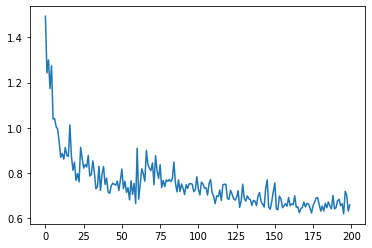

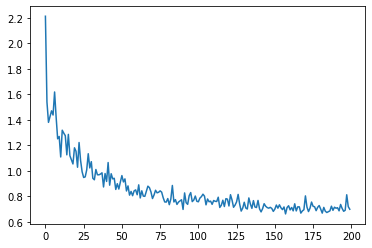

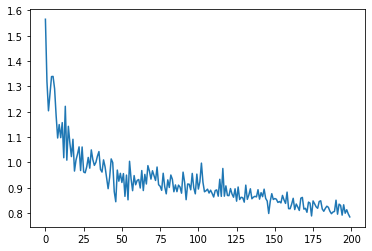

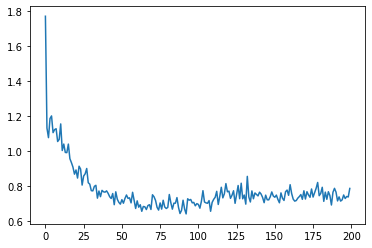

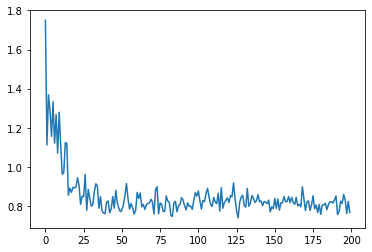

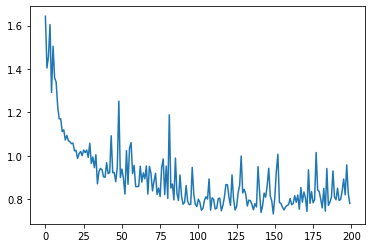

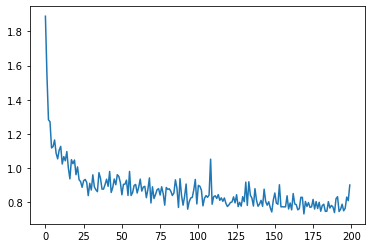

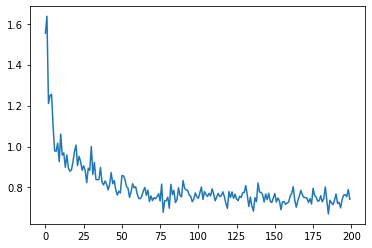

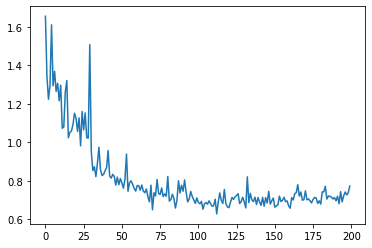

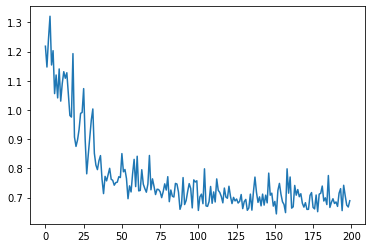

In [ ]:
for loss in losses_val_kfold:
    plt.plot(loss)
    plt.show()

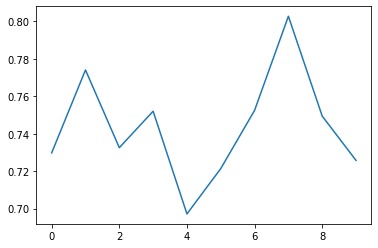

In [ ]:
plt.plot(test_rmse)

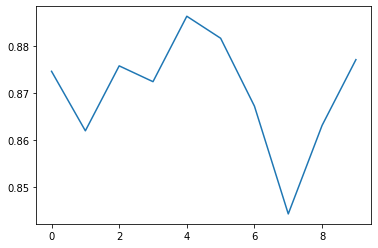

In [ ]:
plt.plot(test_r2)

**Let's get fingerprints for molecules using trained model and add those features to XGBRegressor**

In [ ]:
neural_fp = NeuralFP(atom_features=8, fp_size=100).to(device)
fps_train = []
fps_test = []
for i, batch in enumerate(train_loader):
    if i == 0:
        fps_train = neural_fp(batch.to(device)).cpu().detach().numpy()
    else:
        fps_train = np.vstack((fps_train, neural_fp(batch.to(device)).cpu().detach().numpy()))

fps_train.shape

for i, batch in enumerate(test_loader):
    if i == 0:
        fps_test = neural_fp(batch.to(device)).cpu().detach().numpy()
    else:
        fps_test = np.vstack((fps_test, neural_fp(batch.to(device)).cpu().detach().numpy()))
fps_test.shape

(101, 100)

In [ ]:
fingerprints_train = pd.DataFrame(fps_train)
fingerprints_test = pd.DataFrame(fps_test)
train

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,...,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,standardize_smiles
71,0.853930,0.151358,0.085682,0.044258,0.072680,0.078352,0.042111,0.053952,0.038643,0.058610,0.040767,0.052428,0.039407,0.058077,5.438167e-01,5.346966e-01,6.893569e-07,0.212674,0.607433,2.509948e-11,8.947108e-01,6.674678e-01,0.000001,2.391450e-11,9.205606e-01,0.127681,0.407944,0.316894,0.213973,2.155533e-14,0.826801,0.080716,0.155545,0.999999,0.092489,0.109456,0.378433,0.100508,0.072152,0.521824,...,0.154654,2.794209e-22,0.000000,1.00000,1.000000e+00,1.000000,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.516062,-5.361,1,284.098,0,2,3,52.37,-5.460,O=[N+]([O-])c1ccc(Oc2ccc(Cl)cc2Cl)cc1
744,0.509782,0.582486,0.711778,0.597182,0.612758,0.629521,0.549336,0.521714,0.657004,0.617784,0.612060,0.567425,0.541411,0.453782,9.328974e-01,8.830651e-01,6.893569e-07,0.100218,0.485829,1.611950e-01,9.258417e-11,9.535037e-01,0.622119,2.391450e-11,8.519942e-01,0.701004,0.639886,0.451313,0.361264,4.063801e-01,0.411678,0.666220,0.722096,0.999999,0.727645,0.580224,0.635664,0.660654,0.487124,0.532817,...,0.154654,2.794209e-22,0.975564,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.999908,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.315505,-6.905,1,449.856,0,3,6,59.32,-8.176,CC1(C)C(C=C(Cl)C(F)(F)F)C1C(=O)OC(C#N)c1cccc(O...
500,0.875192,0.172512,0.304890,0.243583,0.487842,0.251544,0.213302,0.746605,0.124488,0.891616,0.138528,0.935700,0.177678,0.973494,7.646707e-01,5.113023e-01,6.893569e-07,0.583158,0.672575,4.143161e-01,9.258417e-11,7.590230e-01,0.552871,2.391450e-11,9.472506e-01,0.512083,0.665587,0.228917,0.085900,6.208437e-01,0.976416,0.260176,0.535944,0.999999,0.494176,0.503347,0.506047,0.368066,0.401765,0.124069,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.208016,-5.026,1,393.854,0,2,8,55.84,-6.340,CCOP(=S)(OCC)SC(CCl)N1C(=O)c2ccccc2C1=O
923,0.942168,0.001064,0.002207,0.008582,0.005450,0.002445,0.015190,0.009609,0.007347,0.003498,0.006362,0.003371,0.003881,0.002151,4.074888e-10,2.175235e-08,6.893569e-07,0.100218,0.019674,3.417933e-01,9.033685e-01,5.856109e-17,0.000001,4.317539e-01,3.491108e-01,0.001455,0.132447,0.046705,0.020824,9.993903e-01,0.987224,0.001900,0.000950,0.999999,0.012812,0.482532,0.847264,0.002388,0.015943,0.217616,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.00

In [ ]:
train = train.reset_index()
test = test.reset_index()

In [ ]:
data_with_fingerprints_train = train.join(fingerprints_train)
data_with_fingerprints_test = test.join(fingerprints_test)
data_with_fingerprints_train

,index,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,71,0.853930,0.151358,0.085682,0.044258,0.072680,0.078352,0.042111,0.053952,0.038643,0.058610,0.040767,0.052428,0.039407,0.058077,5.438167e-01,5.346966e-01,6.893569e-07,0.212674,0.607433,2.509948e-11,8.947108e-01,6.674678e-01,0.000001,2.391450e-11,9.205606e-01,0.127681,0.407944,0.316894,0.213973,2.155533e-14,0.826801,0.080716,0.155545,0.999999,0.092489,0.109456,0.378433,0.100508,0.072152,...,10.364277,-63.263142,-33.770443,68.427727,52.587990,-44.493385,-29.468359,-21.770420,64.813828,29.752209,-19.207352,0.396627,36.936020,31.470476,-48.286835,-37.282562,6.573402,-12.020473,5.701949,13.555488,-48.392822,-40.699352,-49.506985,18.385796,-5.902489,-30.062635,35.307571,-48.244194,-20.893572,-0.128007,50.100319,19.656075,11.927381,-53.531315,-19.551138,40.072842,-22.692415,22.277269,-11.806386,46.524071
1,744,0.509782,0.582486,0.711778,0.597182,0.612758,0.629521,0.549336,0.521714,0.657004,0.617784,0.612060,0.567425,0.541411,0.453782,9.328974e-01,8.830651e-01,6.893569e-07,0.100218,0.485829,1.611950e-01,9.258417e-11,9.535037e-01,0.622119,2.391450e-11,8.519942e-01,0.701004,0.639886,0.451313,0.361264,4.063801e-01,0.411678,0.666220,0.722096,0.999999,0.727645,0.580224,0.635664,0.660654,0.487124,...,23.015753,-104.513741,-50.277115,110.617950,87.382629,-72.137520,-40.971260,-40.472553,108.847984,51.101246,-42.062317,-4.651655,58.199856,51.273460,-83.364868,-54.786568,2.255961,-18.993242,4.869347,22.113468,-86.965652,-63.607647,-86.369118,28.369482,-7.279068,-44.115089,54.875069,-74.466415,-29.005762,-1.462209,81.274673,32.289024,16.085573,-86.118103,-38.593052,62.805275,-36.073151,38.195488,-20.150633,74.874817
2,500,0.875192,0.172512,0.304890,0.243583,0.487842,0.251544,0.213302,0.746605,0.124488,0.891616,0.138528,0.935700,0.177678,0.973494,7.646707e-01,5.113023e-01,6.893569e-07,0.583158,0.672575,4.143161e-01,9.258417e-11,7.590230e-01,0.552871,2.391450e-11,9.472506e-01,0.512083,0.665587,0.228917,0.085900,6.208437e-01,0.976416,0.260176,0.535944,0.999999,0.494176,0.503347,0.506047,0.368066,0.401765,...,17.784044,-87.868309,-46.641304,92.943222,76.178207,-63.778217,-38.636406,-32.692467,90.556488,44.477455,-31.769266,2.307663,51.228844,43.026562,-67.402390,-48.707561,6.564015,-18.467756,6.877996,18.104130,-71.881180,-58.118549,-70.945343,22.162930,-8.426641,-37.588436,47.938065,-65.876137,-28.477528,2.324199,67.180901,25.802059,15.386183,-75.744591,-29.442368,56.521317,-31.671318,34.663170,-17.428125,65.988815
3,923,0.942168,0.001064,0.002207,0.008582,0.005450,0.002445,0.015190,0.009609,0.007347,0.003498,0.006362,0.003371,0.003881,0.002151,4.074888e-10,2.175235e-08,6.893569e-07,0.100218,0.019674,3.417933e-01,9.033685e-01,5.856109e-17,0.000001,4.317539e-01,3.491108e-01,0.001455,0.132447,0.046705,0.020824,9.993903e-01,0.987224,0.001900,0.000950,0.999999,0.012812,0.482532,0.847264,0.002388,0.015943,...,9.110970,-34.715878,-13.656175,33.962860,26.911890,-18.208303,-10.964903,-16.657564,31.732723,19.811550,-21.891720,-2.923335,16.313427,13.263609,-28.360992,-13.406717,-7.893106,-3.799325,-2.778800,7.418368,-32.395782,-18.338940,-29.210182,4.849655,1.249403,-7.033110,14.443022,-20.027246,-5.844115,1.038546,23.243370,10.555866,4.615200,-24.800341,-17.754368,19.951010,-9.337626,12.041303,-2.995411,21.214083
4,493,0.866093,0.329642,0.212374,0.180683,0.141326,0.214835,0.173391,0.123158,0.177035,0.113103,0.234223,0.153811,0.243830,0.160295,5.438167e-01,7.109296e-01,6.893569e-07,0.599798,0.482898,1.477604e-01,8.352734e-01,5.690350e-01,0.

In [ ]:
data_with_fingerprints_test

,index,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,82,0.962954,0.000927,0.000045,0.000003,0.000042,0.000018,0.000006,0.000185,0.000023,0.000067,6.353499e-07,0.000003,0.000017,0.000013,4.074888e-10,2.175235e-08,6.893569e-07,0.197798,0.019674,2.509948e-11,9.258417e-11,5.856109e-17,0.000001,6.600705e-01,7.522456e-13,0.000063,0.974430,0.107799,0.011584,2.155533e-14,0.980455,0.000023,0.000076,0.999999,0.000024,0.000025,0.869095,0.000050,0.014196,...,12.150105,-56.867481,-27.298170,59.866463,47.264755,-38.203209,-22.794775,-21.974781,58.406216,27.926100,-23.473982,-2.331972,31.485823,27.350914,-45.085392,-29.535286,0.890429,-10.023160,2.248740,12.172121,-47.373219,-34.861565,-46.714195,14.777280,-3.708991,-23.286392,29.607452,-40.075970,-15.683884,-0.169795,43.332668,17.232033,8.657981,-46.833996,-21.187473,34.277706,-19.722115,20.907267,-10.443407,40.473709
1,763,0.981761,0.009873,0.002034,0.005930,0.003736,0.001876,0.005508,0.003848,0.011622,0.005742,1.578034e-02,0.008487,0.012179,0.006851,4.074888e-10,2.175235e-08,6.893569e-07,0.100218,0.019674,2.509948e-11,8.316442e-01,5.856109e-17,0.000001,8.585821e-01,7.522456e-13,0.000908,0.132447,0.142478,0.072556,4.562666e-01,0.959428,0.001900,0.000771,0.999999,0.001422,0.001579,0.170126,0.001977,0.010113,...,9.987852,-43.950691,-21.228844,44.538818,37.176178,-28.912182,-17.212729,-18.265188,43.192413,23.658253,-20.675034,-0.143422,23.478989,19.376883,-34.225895,-21.035931,-1.677310,-8.236645,0.551965,9.419051,-38.266335,-27.418966,-36.135883,8.821222,-2.297591,-14.875674,21.368534,-30.316948,-12.137651,2.146103,31.121752,12.355302,6.436423,-36.064972,-17.526308,27.500580,-14.460689,17.394882,-7.206407,30.712072
2,576,0.536455,0.269830,0.448242,0.488078,0.434487,0.377448,0.583690,0.503472,0.815705,0.746650,9.314849e-01,0.898037,0.961892,0.943650,9.081336e-01,9.033264e-01,6.893569e-07,0.892763,0.355953,5.942991e-01,9.258417e-11,5.475954e-01,0.545574,2.214426e-01,7.522456e-13,0.383251,0.869939,0.838391,0.817865,9.472517e-01,0.911427,0.416228,0.351777,0.999999,0.433014,0.144657,0.271778,0.407571,0.326126,...,8.846863,-63.283524,-37.034157,69.189178,53.024372,-45.079140,-33.255260,-20.903322,62.796341,31.278570,-16.731375,5.093959,39.024376,31.194092,-46.494938,-39.992512,8.821382,-12.004842,7.905955,12.349582,-46.983345,-43.114735,-47.574364,16.374306,-6.363195,-28.905579,37.208336,-49.620037,-22.749001,1.526181,50.257427,20.106724,15.379341,-53.993824,-18.199835,42.827164,-22.811987,22.268589,-10.211121,48.456242
3,380,0.977302,0.002256,0.004409,0.010150,0.006478,0.003841,0.014701,0.009316,0.006622,0.003127,6.454814e-03,0.003420,0.007473,0.004168,4.074888e-10,2.648697e-01,6.893569e-07,0.220289,0.361876,4.810067e-01,9.258417e-11,5.856109e-17,0.477870,2.214426e-01,3.491108e-01,0.002652,0.861796,0.787999,0.473211,9.930637e-01,0.972436,0.003383,0.002048,0.999999,0.017867,0.271868,0.673642,0.003555,0.080804,...,12.922673,-77.687828,-39.050465,83.538208,61.770569,-50.576797,-34.344566,-28.271982,77.288269,37.033779,-26.872723,-2.141611,43.496658,36.945385,-60.321053,-44.011677,2.716326,-12.235476,4.712645,16.860706,-59.956230,-46.413826,-60.693905,21.681118,-4.556992,-33.908165,41.511173,-56.544884,-22.795109,-1.414200,61.265354,25.515673,14.723486,-62.030605,-26.664555,47.652782,-25.613281,24.742680,-11.738833,53.950970
4,856,0.963479,0.001283,0.000689,0.001097,0.000706,0.000502,0.001103,0.001106,0.002758,0.001213,2.791946e-04,0.000178,0.000398,0.000230,4.074888e-10,2.648697e-01,6.893569e-07,0.100218,0.540776,2.509948e-11,9.258417e

In [ ]:
from xgboost import XGBRFRegressor

In [ ]:
model = XGBRFRegressor()

In [ ]:
model.fit(data_with_fingerprints_train.drop(columns=['measured log solubility in mols per litre', 'standardize_smiles']), data_with_fingerprints_train['measured log solubility in mols per litre'])

[16:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRFRegressor()

In [ ]:
y_pred = model.predict(data_with_fingerprints_test.drop(columns=['measured log solubility in mols per litre', 'standardize_smiles']))

In [ ]:
r2_score(y_pred, data_with_fingerprints_test['measured log solubility in mols per litre'])

0.8115592767382267

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_pred, data_with_fingerprints_test['measured log solubility in mols per litre'], squared=False)

0.843204695226884

**We got worse results than we had before**

# Let's try to add Morgan fingerprints as addional features

In [ ]:
new_df = create_feature_dataframe(df)
new_df = new_df.drop(columns=['target'])

new_df = new_df.join(df.drop(columns=["Compound ID", "smiles"]))
new_df

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,...,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,standardize_smiles
0,0.431154,0.304703,0.742380,0.611255,0.564015,0.695016,0.628013,0.550359,0.632004,0.526516,0.647978,0.533322,0.567960,0.441039,9.662156e-01,9.852195e-01,6.893569e-07,0.100218,0.131846,2.509948e-11,9.258417e-11,8.288383e-01,0.464812,2.391450e-11,8.205149e-01,0.722986,0.070685,0.057481,0.064305,9.048759e-01,0.837960,0.706530,0.720712,0.999999,0.815583,0.810059,0.640453,0.664681,0.063911,0.247244,...,0.154654,2.794209e-22,0.975564,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.069877,-0.974,1,457.432,7,3,7,202.32,-0.770,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1,0.831056,0.076056,0.026948,0.030340,0.020389,0.033934,0.032592,0.020369,0.029170,0.015533,0.038519,0.021520,0.041210,0.024028,4.074888e-10,2.648697e-01,6.893569e-07,0.218593,0.307374,1.510129e-01,6.498039e-01,5.663300e-01,0.651997,1.691932e-01,3.299699e-01,0.018750,0.715690,0.681483,0.524134,1.024882e-01,0.761894,0.030800,0.019873,0.999999,0.018461,0.031261,0.270675,0.024863,0.170656,0.621108,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.999908,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.861151,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc1ccccc1
2,0.991404,0.006351,0.008175,0.017477,0.011397,0.005603,0.013714,0.008724,0.020863,0.010806,0.009586,0.005097,0.008525,0.004764,4.074888e-10,2.648697e-01,6.893569e-07,0.100218,0.019674,5.917485e-01,6.288924e-01,3.815791e-01,0.477870,5.834501e-01,7.522456e-13,0.003645,0.829479,0.638385,0.295614,7.336696e-01,0.954836,0.005699,0.002908,0.999999,0.026889,0.179088,0.789732,0.006155,0.057285,0.101979,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.171383,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC=O
3,0.777909,0.624374,0.145605,0.194124,0.153062,0.246362,0.287320,0.218869,0.320262,0.224962,0.476379,0.357717,0.590347,0.464119,4.074888e-10,2.175235e-08,6.893569e-07,0.100218,0.019674,2.509948e-11,9.658268e-01,5.856109e-17,0.000001,9.913422e-01,7.522456e-13,0.116563,0.000944,0.002053,0.003521,2.155533e-14,0.458839,0.214325,0.122267,0.999999,0.062004,0.044811,0.197879,0.191387,0.010197,0.022049,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.

In [ ]:
morgan_fingerprints = new_df['standardize_smiles'].map(lambda x : rdMolDescriptors.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=2, nBits=1024))
feature_names = np.arange(1, len(morgan_fingerprints))
new_features = []
for i in range(len(new_df)):
    
    features = morgan_fingerprints[i]
    dictionary = dict(zip(feature_names, features))

    new_features.append(dictionary)

additional_features_0 = pd.DataFrame(new_features)

new_df = new_df.join(additional_features_0)
new_df

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,...,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0.431154,0.304703,0.742380,0.611255,0.564015,0.695016,0.628013,0.550359,0.632004,0.526516,0.647978,0.533322,0.567960,0.441039,9.662156e-01,9.852195e-01,6.893569e-07,0.100218,0.131846,2.509948e-11,9.258417e-11,8.288383e-01,0.464812,2.391450e-11,8.205149e-01,0.722986,0.070685,0.057481,0.064305,9.048759e-01,0.837960,0.706530,0.720712,0.999999,0.815583,0.810059,0.640453,0.664681,0.063911,0.247244,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.831056,0.076056,0.026948,0.030340,0.020389,0.033934,0.032592,0.020369,0.029170,0.015533,0.038519,0.021520,0.041210,0.024028,4.074888e-10,2.648697e-01,6.893569e-07,0.218593,0.307374,1.510129e-01,6.498039e-01,5.663300e-01,0.651997,1.691932e-01,3.299699e-01,0.018750,0.715690,0.681483,0.524134,1.024882e-01,0.761894,0.030800,0.019873,0.999999,0.018461,0.031261,0.270675,0.024863,0.170656,0.621108,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.991404,0.006351,0.008175,0.017477,0.011397,0.005603,0.013714,0.008724,0.020863,0.010806,0.009586,0.005097,0.008525,0.004764,4.074888e-10,2.648697e-01,6.893569e-07,0.100218,0.019674,5.917485e-01,6.288924e-01,3.815791e-01,0.477870,5.834501e-01,7.522456e-13,0.003645,0.829479,0.638385,0.295614,7.336696e-01,0.954836,0.005699,0.002908,0.999999,0.026889,0.179088,0.789732,0.006155,0.057285,0.101979,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0.777909,0.624374,0.145605,0.194124,0.153062,0.246362,0.287320,0.218869,0.320262,0.224962,0.476379,0.357717,0.590347,0.464119,4.074888e-10,2.175235e-08,6.893569e-07,0.100218,0.019674,2.509948e-11,9.658268e-01,5.856109e-17,0.000001,9.913422e-01,7.522456e-13,0.116563,0.000944,0.002053,0.003521,2.155533e-14,0.458839,0.214325,0.122267,0.999999,0.062004,0.044811,0.197879,0.191387,0.010197,0.022049,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.980154,0.001491,0.000042,0.000030,0.000139,0.000123,0.000124,0.001262,0.000142,0.000714,0.000174,0.001712,0.000381,0.003126,4.074888e-10,2.175235e-08,6.893569e-07,0.100218,0.019674,2.509948e-11,9.258417e-11,5.285899e-01,0.614531,2.391450e-11,7.522456e-13,0.000113,0.294906,0.177645,0.033921,2.155533e-14,0.980760,0.000077,0.000138,0.999999,0.000003,0.000058,0.056314,0.000127,0.009914,0.036778,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,0.990198,0.001454,0.001005,0.000057,0.001471,0.000289,0.000067,0.001745,0.000172,0.007232,0.000039,0.001506,0.000017,0.000013,7.523683e-01,6.547047e-01,6.893569e-07,0.100218,0.019674,2.509948e-11,9.258417e-11,5.856109e-17,0.000001,7.256172e-01,7.522456e-13,0.016097,0.952612,0.154211,0.014846,9.993903e-01,0.995070,0.000481,0.023885,0.999999,0.004468,0.001579,0.410474,0.001191,0.097344,0.310887,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1124,0.997000,0.014982,0.034384,0.033802,0.038438,0.019231,0.011211,0.027564,0.008905,0.015833,0.004994,0.012184,0.002233,0.008358,6.095890e-01,5.113023e-01,6.893569e-07,0.38

In [ ]:

train, test = train_test_split(new_df , test_size=0.1)

train_mol = train['standardize_smiles'].map(lambda x : Chem.MolFromSmiles(x))
test_mol = test['standardize_smiles'].map(lambda x : Chem.MolFromSmiles(x))


train_loader, test_loader_final = prepare_dataloader(train_mol) ,prepare_dataloader(test_mol)

test_labels_final_dataset = TensorDataset(torch.tensor(test['measured log solubility in mols per litre'].to_numpy()).float())
test_labels_final_loader = DataLoader(test_labels_final_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_features_final_dataset = TensorDataset(torch.tensor(test.drop(columns=['measured log solubility in mols per litre', 'standardize_smiles']).to_numpy()).float())
test_features_final_loader = DataLoader(test_features_final_dataset, batch_size=BATCH_SIZE, shuffle=False)




kf = KFold(n_splits=10)
X_train_init = train
y_train_init = train

losses_kfold = []
losses_val_kfold = []
losses_r2_kfold = []
losses_val_r2_kfold = []
test_rmse = []
test_r2 = []
for train_index, test_index in kf.split(X_train_init):
    X_train, X_val = X_train_init.iloc[train_index], X_train_init.iloc[test_index]


    train_features_dataset = TensorDataset(torch.tensor(X_train.drop(columns=['measured log solubility in mols per litre', 'standardize_smiles']).to_numpy()).float())
    test_features_dataset = TensorDataset(torch.tensor(X_val.drop(columns=['measured log solubility in mols per litre', 'standardize_smiles']).to_numpy()).float())
    train_features_loader = DataLoader(train_features_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_features_loader = DataLoader(test_features_dataset, batch_size=BATCH_SIZE, shuffle=False)

    train_labels_dataset = TensorDataset(torch.tensor(X_train['measured log solubility in mols per litre'].to_numpy()).float())
    test_labels_dataset = TensorDataset(torch.tensor(X_val['measured log solubility in mols per litre'].to_numpy()).float())
    train_labels_loader = DataLoader(train_labels_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_labels_loader = DataLoader(test_labels_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    train_mol = X_train['standardize_smiles'].map(lambda x : Chem.MolFromSmiles(x))
    test_mol = X_val['standardize_smiles'].map(lambda x : Chem.MolFromSmiles(x))
    train_loader, test_loader = prepare_dataloader(train_mol) ,prepare_dataloader(test_mol)

    neural_fp = NeuralFP(8, 100)
    reg = MLP_Regressor(neural_fp, 8, 100, 300, 1231).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(reg.parameters(), 
                          lr=0.001
                          )

    reg, loss, val_loss, r2_loss, r2_val_loss = train_nn(reg, optimizer, criterion, 
                                                        train_loader, train_labels_loader, train_features_loader,
                                                        test_loader, test_labels_loader, test_features_loader)
    
    rmse_test, r2_test = test_nn(reg, criterion, test_loader_final, test_labels_final_loader, test_features_final_loader)
    test_rmse.append(rmse_test)
    test_r2.append(r2_test)

    losses_kfold.append(loss)
    losses_val_kfold.append(val_loss)
    losses_r2_kfold.append(r2_loss)
    losses_val_r2_kfold.append(r2_val_loss)
    

31it [00:00, 209.04it/s]
4it [00:00, 239.23it/s]
31it [00:00, 215.70it/s]
4it [00:00, 273.32it/s]
0it [00:00, ?it/s]

Epoch 0 - Training rmse loss: 1.999024410876666
Epoch 0 - Training r2 loss: -2.700787184676901
Epoch 0 - val rmse loss: 1.2872341946409265
Epoch 0 - val r2 loss: 0.4626497554455793
Epoch 1 - Training rmse loss: 1.2039921308159522
Epoch 1 - Training r2 loss: 0.41989313274443396
Epoch 1 - val rmse loss: 1.5184470577060876
Epoch 1 - val r2 loss: 0.5716267119984482


31it [00:00, 211.44it/s]
4it [00:00, 283.40it/s]
31it [00:00, 207.39it/s]
4it [00:00, 315.05it/s]
0it [00:00, ?it/s]

Epoch 2 - Training rmse loss: 1.1225543168532992
Epoch 2 - Training r2 loss: 0.5744335856787673
Epoch 2 - val rmse loss: 1.2378134701327033
Epoch 2 - val r2 loss: 0.6240046492435114
Epoch 3 - Training rmse loss: 1.0873632767289376
Epoch 3 - Training r2 loss: 0.5700182762800786
Epoch 3 - val rmse loss: 1.1759244825244304
Epoch 3 - val r2 loss: 0.6964001886495631


31it [00:00, 198.01it/s]
4it [00:00, 234.67it/s]
31it [00:00, 213.30it/s]
4it [00:00, 279.56it/s]
0it [00:00, ?it/s]

Epoch 4 - Training rmse loss: 1.0584904143839478
Epoch 4 - Training r2 loss: 0.6177310573910941
Epoch 4 - val rmse loss: 1.1271152148376746
Epoch 4 - val r2 loss: 0.6725458584654491
Epoch 5 - Training rmse loss: 1.0114779031856185
Epoch 5 - Training r2 loss: 0.6390065818950791
Epoch 5 - val rmse loss: 1.1342771795357278
Epoch 5 - val r2 loss: 0.7303536226473513


31it [00:00, 205.72it/s]
4it [00:00, 256.99it/s]
31it [00:00, 215.81it/s]
4it [00:00, 226.26it/s]
0it [00:00, ?it/s]

Epoch 6 - Training rmse loss: 1.0496014853244071
Epoch 6 - Training r2 loss: 0.6155824005489947
Epoch 6 - val rmse loss: 1.0480440572671623
Epoch 6 - val r2 loss: 0.7190489608549282
Epoch 7 - Training rmse loss: 0.9705898689024777
Epoch 7 - Training r2 loss: 0.6716435969529085
Epoch 7 - val rmse loss: 1.0795323060229722
Epoch 7 - val r2 loss: 0.7417601097598642


31it [00:00, 209.97it/s]
4it [00:00, 245.45it/s]
31it [00:00, 208.13it/s]
4it [00:00, 272.08it/s]
0it [00:00, ?it/s]

Epoch 8 - Training rmse loss: 0.9006620209892215
Epoch 8 - Training r2 loss: 0.7271747500399085
Epoch 8 - val rmse loss: 1.0696541508684088
Epoch 8 - val r2 loss: 0.7408553704847088
Epoch 9 - Training rmse loss: 0.8933854137590173
Epoch 9 - Training r2 loss: 0.7276643686275092
Epoch 9 - val rmse loss: 1.075758409777089
Epoch 9 - val r2 loss: 0.7438514529453866


31it [00:00, 212.59it/s]
4it [00:00, 248.99it/s]
31it [00:00, 192.09it/s]
0it [00:00, ?it/s]

Epoch 10 - Training rmse loss: 0.8443259526025902
Epoch 10 - Training r2 loss: 0.7747222160639018
Epoch 10 - val rmse loss: 1.0584950700211715
Epoch 10 - val r2 loss: 0.7562992674773245
Epoch 11 - Training rmse loss: 0.8243696304740141
Epoch 11 - Training r2 loss: 0.7736372126937108


4it [00:00, 187.64it/s]
31it [00:00, 211.80it/s]
4it [00:00, 241.06it/s]
0it [00:00, ?it/s]

Epoch 11 - val rmse loss: 1.0387078375470797
Epoch 11 - val r2 loss: 0.7644299051574015
Epoch 12 - Training rmse loss: 0.7780720370390614
Epoch 12 - Training r2 loss: 0.808061543130502
Epoch 12 - val rmse loss: 1.0593484953993995
Epoch 12 - val r2 loss: 0.7706075853648462


31it [00:00, 199.19it/s]
4it [00:00, 230.68it/s]
31it [00:00, 213.84it/s]
4it [00:00, 287.28it/s]
0it [00:00, ?it/s]

Epoch 13 - Training rmse loss: 0.7252492153576505
Epoch 13 - Training r2 loss: 0.8346457030909243
Epoch 13 - val rmse loss: 1.01064739059175
Epoch 13 - val r2 loss: 0.7754098989534137
Epoch 14 - Training rmse loss: 0.6888570536591655
Epoch 14 - Training r2 loss: 0.8529775687070592
Epoch 14 - val rmse loss: 1.0205609905496442
Epoch 14 - val r2 loss: 0.7675828670829872


31it [00:00, 211.60it/s]
4it [00:00, 224.94it/s]
31it [00:00, 211.53it/s]
4it [00:00, 226.31it/s]

Epoch 15 - Training rmse loss: 0.66902894641814
Epoch 15 - Training r2 loss: 0.8624823205846978
Epoch 15 - val rmse loss: 1.028338085285431
Epoch 15 - val r2 loss: 0.7732264451204306
Epoch 16 - Training rmse loss: 0.6472930620037849
Epoch 16 - Training r2 loss: 0.8726044182281394
Epoch 16 - val rmse loss: 1.0438890218947543
Epoch 16 - val r2 loss: 0.7725297672182182



31it [00:00, 205.00it/s]
4it [00:00, 249.48it/s]
31it [00:00, 216.12it/s]
4it [00:00, 288.36it/s]
0it [00:00, ?it/s]

Epoch 17 - Training rmse loss: 0.6227537938045387
Epoch 17 - Training r2 loss: 0.8836952839519269
Epoch 17 - val rmse loss: 1.078860350011584
Epoch 17 - val r2 loss: 0.7550505534522305
Epoch 18 - Training rmse loss: 0.6572636892454383
Epoch 18 - Training r2 loss: 0.8650347654294253
Epoch 18 - val rmse loss: 1.0927689171255262
Epoch 18 - val r2 loss: 0.7362525598946539


31it [00:00, 200.82it/s]
4it [00:00, 259.96it/s]
31it [00:00, 196.32it/s]
0it [00:00, ?it/s]

Epoch 19 - Training rmse loss: 0.6170588308990361
Epoch 19 - Training r2 loss: 0.8865244066838517
Epoch 19 - val rmse loss: 0.9742597132363294
Epoch 19 - val r2 loss: 0.7866537807436164
Epoch 20 - Training rmse loss: 0.586733944951203
Epoch 20 - Training r2 loss: 0.8992399998649376


4it [00:00, 194.85it/s]
31it [00:00, 203.79it/s]
4it [00:00, 279.03it/s]
0it [00:00, ?it/s]

Epoch 20 - val rmse loss: 1.0676827947151926
Epoch 20 - val r2 loss: 0.7542490207025339
Epoch 21 - Training rmse loss: 0.617519497315113
Epoch 21 - Training r2 loss: 0.8868314388710085
Epoch 21 - val rmse loss: 1.0253257948953196
Epoch 21 - val r2 loss: 0.7713095509727598


31it [00:00, 206.38it/s]
4it [00:00, 235.86it/s]
31it [00:00, 209.72it/s]
4it [00:00, 239.73it/s]
0it [00:00, ?it/s]

Epoch 22 - Training rmse loss: 0.5736313021381655
Epoch 22 - Training r2 loss: 0.903244125660344
Epoch 22 - val rmse loss: 1.0000697648031458
Epoch 22 - val r2 loss: 0.7905933440437787
Epoch 23 - Training rmse loss: 0.5693195716161745
Epoch 23 - Training r2 loss: 0.9088075649720976
Epoch 23 - val rmse loss: 1.063900312311055
Epoch 23 - val r2 loss: 0.7764615787370825


31it [00:00, 200.30it/s]
4it [00:00, 243.41it/s]
31it [00:00, 212.56it/s]
4it [00:00, 273.90it/s]
0it [00:00, ?it/s]

Epoch 24 - Training rmse loss: 0.5739550144950564
Epoch 24 - Training r2 loss: 0.9059152491764704
Epoch 24 - val rmse loss: 0.916763585920236
Epoch 24 - val r2 loss: 0.7981895455695549
Epoch 25 - Training rmse loss: 0.5586616273510483
Epoch 25 - Training r2 loss: 0.9113753621197618
Epoch 25 - val rmse loss: 0.9565060906849424
Epoch 25 - val r2 loss: 0.8000961856206025


31it [00:00, 191.25it/s]
4it [00:00, 229.98it/s]
31it [00:00, 206.02it/s]
4it [00:00, 255.68it/s]
0it [00:00, ?it/s]

Epoch 26 - Training rmse loss: 0.604367337451094
Epoch 26 - Training r2 loss: 0.8988966144375118
Epoch 26 - val rmse loss: 0.9963500422452013
Epoch 26 - val r2 loss: 0.7679639003372716
Epoch 27 - Training rmse loss: 0.6303087713970867
Epoch 27 - Training r2 loss: 0.884991335175162
Epoch 27 - val rmse loss: 0.9297781186858669
Epoch 27 - val r2 loss: 0.7920665433477039


31it [00:00, 200.25it/s]
4it [00:00, 235.18it/s]
31it [00:00, 209.67it/s]
4it [00:00, 255.91it/s]
0it [00:00, ?it/s]

Epoch 28 - Training rmse loss: 0.6538871315992744
Epoch 28 - Training r2 loss: 0.8708030960371189
Epoch 28 - val rmse loss: 0.992394853686666
Epoch 28 - val r2 loss: 0.771435090729869
Epoch 29 - Training rmse loss: 0.6076887106698751
Epoch 29 - Training r2 loss: 0.886182514901163
Epoch 29 - val rmse loss: 0.9987333889082374
Epoch 29 - val r2 loss: 0.7882059685901396


31it [00:00, 200.86it/s]
4it [00:00, 281.52it/s]
31it [00:00, 206.42it/s]
4it [00:00, 287.83it/s]
0it [00:00, ?it/s]

Epoch 30 - Training rmse loss: 0.544684842491688
Epoch 30 - Training r2 loss: 0.9095568555506791
Epoch 30 - val rmse loss: 0.9058627419287852
Epoch 30 - val r2 loss: 0.8070586146866919
Epoch 31 - Training rmse loss: 0.5131988298328574
Epoch 31 - Training r2 loss: 0.9235843747685644
Epoch 31 - val rmse loss: 0.925656599996766
Epoch 31 - val r2 loss: 0.7973330536626336


31it [00:00, 205.25it/s]
4it [00:00, 239.05it/s]
31it [00:00, 199.23it/s]
4it [00:00, 237.69it/s]

Epoch 32 - Training rmse loss: 0.49961597938851166
Epoch 32 - Training r2 loss: 0.9269124010010498
Epoch 32 - val rmse loss: 0.9926666844781943
Epoch 32 - val r2 loss: 0.7897080082688607
Epoch 33 - Training rmse loss: 0.5003676581721508
Epoch 33 - Training r2 loss: 0.9313567076543248



31it [00:00, 206.28it/s]
4it [00:00, 237.32it/s]
0it [00:00, ?it/s]

Epoch 33 - val rmse loss: 0.9268138695697157
Epoch 33 - val r2 loss: 0.8089599340394481
Epoch 34 - Training rmse loss: 0.5125617417876083
Epoch 34 - Training r2 loss: 0.9270990763499817
Epoch 34 - val rmse loss: 0.9886152961906822
Epoch 34 - val r2 loss: 0.7951271029855369


31it [00:00, 199.91it/s]
4it [00:00, 215.63it/s]
31it [00:00, 205.95it/s]
4it [00:00, 231.42it/s]
0it [00:00, ?it/s]

Epoch 35 - Training rmse loss: 0.498742280054219
Epoch 35 - Training r2 loss: 0.9297575437400994
Epoch 35 - val rmse loss: 0.9658337660605575
Epoch 35 - val r2 loss: 0.8065937207054414
Epoch 36 - Training rmse loss: 0.5089725264934131
Epoch 36 - Training r2 loss: 0.9283612254552573
Epoch 36 - val rmse loss: 0.9166831083701654
Epoch 36 - val r2 loss: 0.8151273613632406


31it [00:00, 205.30it/s]
4it [00:00, 259.18it/s]
31it [00:00, 199.47it/s]
4it [00:00, 241.33it/s]
0it [00:00, ?it/s]

Epoch 37 - Training rmse loss: 0.47221138586539296
Epoch 37 - Training r2 loss: 0.9352873661297013
Epoch 37 - val rmse loss: 0.9453855360206403
Epoch 37 - val r2 loss: 0.7986388582584893
Epoch 38 - Training rmse loss: 0.5010636738517965
Epoch 38 - Training r2 loss: 0.9286831056130852
Epoch 38 - val rmse loss: 0.9613299537588594
Epoch 38 - val r2 loss: 0.8000260807923787


31it [00:00, 199.99it/s]
4it [00:00, 268.61it/s]
31it [00:00, 207.16it/s]
4it [00:00, 246.51it/s]
0it [00:00, ?it/s]

Epoch 39 - Training rmse loss: 0.5308281084658574
Epoch 39 - Training r2 loss: 0.9215026991076206
Epoch 39 - val rmse loss: 0.9398595125267041
Epoch 39 - val r2 loss: 0.8147787967943839
Epoch 40 - Training rmse loss: 0.5423924407995944
Epoch 40 - Training r2 loss: 0.9156064692748271
Epoch 40 - val rmse loss: 1.0034677386412871
Epoch 40 - val r2 loss: 0.7791584083897605


31it [00:00, 197.53it/s]
4it [00:00, 246.45it/s]
31it [00:00, 209.67it/s]
4it [00:00, 256.73it/s]
0it [00:00, ?it/s]

Epoch 41 - Training rmse loss: 0.6181755020147655
Epoch 41 - Training r2 loss: 0.8888923777712087
Epoch 41 - val rmse loss: 1.0163601488804845
Epoch 41 - val r2 loss: 0.7825342150105125
Epoch 42 - Training rmse loss: 0.7067977330644574
Epoch 42 - Training r2 loss: 0.8531389678879809
Epoch 42 - val rmse loss: 1.2198027318989548
Epoch 42 - val r2 loss: 0.6694738170841229


31it [00:00, 198.08it/s]
4it [00:00, 213.04it/s]
31it [00:00, 209.50it/s]
4it [00:00, 277.29it/s]
0it [00:00, ?it/s]

Epoch 43 - Training rmse loss: 0.9321216451534549
Epoch 43 - Training r2 loss: 0.7251116563861838
Epoch 43 - val rmse loss: 0.9100770956828214
Epoch 43 - val r2 loss: 0.7342479124653265
Epoch 44 - Training rmse loss: 0.7534461657040475
Epoch 44 - Training r2 loss: 0.8153535803575666
Epoch 44 - val rmse loss: 1.4994702993353577
Epoch 44 - val r2 loss: 0.5864070413266814


31it [00:00, 195.83it/s]
4it [00:00, 247.81it/s]
31it [00:00, 211.76it/s]
4it [00:00, 270.81it/s]
0it [00:00, ?it/s]

Epoch 45 - Training rmse loss: 0.6415988028461291
Epoch 45 - Training r2 loss: 0.8782834132854894
Epoch 45 - val rmse loss: 1.322702366700351
Epoch 45 - val r2 loss: 0.6308309524523927
Epoch 46 - Training rmse loss: 0.5911784376966952
Epoch 46 - Training r2 loss: 0.8986550822264794
Epoch 46 - val rmse loss: 1.2384103412908574
Epoch 46 - val r2 loss: 0.6585870888740474


31it [00:00, 205.53it/s]
4it [00:00, 225.56it/s]
31it [00:00, 196.32it/s]
0it [00:00, ?it/s]

Epoch 47 - Training rmse loss: 0.5654388504352781
Epoch 47 - Training r2 loss: 0.9096878361793067
Epoch 47 - val rmse loss: 1.3069325507293168
Epoch 47 - val r2 loss: 0.6402217338548685
Epoch 48 - Training rmse loss: 0.5522793177508353
Epoch 48 - Training r2 loss: 0.9155861617651398


4it [00:00, 238.66it/s]
31it [00:00, 201.68it/s]
4it [00:00, 249.46it/s]
0it [00:00, ?it/s]

Epoch 48 - val rmse loss: 1.2260186635886865
Epoch 48 - val r2 loss: 0.6575577607201915
Epoch 49 - Training rmse loss: 0.5350660044110627
Epoch 49 - Training r2 loss: 0.9174817660094021
Epoch 49 - val rmse loss: 1.4242609043966097
Epoch 49 - val r2 loss: 0.5802073094061697


31it [00:00, 198.85it/s]
4it [00:00, 139.81it/s]
31it [00:00, 196.98it/s]
0it [00:00, ?it/s]

Epoch 50 - Training rmse loss: 0.5618212986614143
Epoch 50 - Training r2 loss: 0.9131324451054197
Epoch 50 - val rmse loss: 1.3743778143208178
Epoch 50 - val r2 loss: 0.5773870261303431
Epoch 51 - Training rmse loss: 0.5757131008758579
Epoch 51 - Training r2 loss: 0.9056290392018952


4it [00:00, 228.56it/s]
31it [00:00, 205.90it/s]
4it [00:00, 237.67it/s]
0it [00:00, ?it/s]

Epoch 51 - val rmse loss: 1.3578712433112767
Epoch 51 - val r2 loss: 0.5700830489620865
Epoch 52 - Training rmse loss: 0.5833140784034286
Epoch 52 - Training r2 loss: 0.9018599505010736
Epoch 52 - val rmse loss: 1.4188845805897514
Epoch 52 - val r2 loss: 0.607129117181654


31it [00:00, 203.20it/s]
4it [00:00, 307.21it/s]
31it [00:00, 202.02it/s]
4it [00:00, 280.35it/s]
0it [00:00, ?it/s]

Epoch 53 - Training rmse loss: 0.5840183634615367
Epoch 53 - Training r2 loss: 0.9027129876535644
Epoch 53 - val rmse loss: 1.4829301226706482
Epoch 53 - val r2 loss: 0.5014921763615371
Epoch 54 - Training rmse loss: 0.6017975108417554
Epoch 54 - Training r2 loss: 0.894707442670936
Epoch 54 - val rmse loss: 1.3361124180727668
Epoch 54 - val r2 loss: 0.6051925756999814


31it [00:00, 207.16it/s]
4it [00:00, 275.64it/s]
31it [00:00, 194.28it/s]
0it [00:00, ?it/s]

Epoch 55 - Training rmse loss: 0.6665965736477719
Epoch 55 - Training r2 loss: 0.8766374839992157
Epoch 55 - val rmse loss: 1.3629146837301513
Epoch 55 - val r2 loss: 0.5386578311683116
Epoch 56 - Training rmse loss: 0.703478382891277
Epoch 56 - Training r2 loss: 0.851730498503949


4it [00:00, 209.24it/s]
31it [00:00, 205.15it/s]
4it [00:00, 209.40it/s]
0it [00:00, ?it/s]

Epoch 56 - val rmse loss: 1.440818129066363
Epoch 56 - val r2 loss: 0.5727028693461589
Epoch 57 - Training rmse loss: 0.7375132483543285
Epoch 57 - Training r2 loss: 0.8411031188849267
Epoch 57 - val rmse loss: 1.0833457646512545
Epoch 57 - val r2 loss: 0.6677227931789647


31it [00:00, 208.48it/s]
4it [00:00, 278.10it/s]
31it [00:00, 211.09it/s]
4it [00:00, 210.98it/s]
0it [00:00, ?it/s]

Epoch 58 - Training rmse loss: 0.750931044624508
Epoch 58 - Training r2 loss: 0.8292190349374375
Epoch 58 - val rmse loss: 0.942808657870052
Epoch 58 - val r2 loss: 0.7706054623091197
Epoch 59 - Training rmse loss: 0.7363280783240587
Epoch 59 - Training r2 loss: 0.8289834958336398
Epoch 59 - val rmse loss: 0.9387662839302606
Epoch 59 - val r2 loss: 0.8057114470737078


31it [00:00, 198.07it/s]
4it [00:00, 250.69it/s]
31it [00:00, 207.40it/s]
4it [00:00, 256.37it/s]
0it [00:00, ?it/s]

Epoch 60 - Training rmse loss: 0.6701350730738335
Epoch 60 - Training r2 loss: 0.8629768497390385
Epoch 60 - val rmse loss: 0.9432933697404502
Epoch 60 - val r2 loss: 0.8086680338830399
Epoch 61 - Training rmse loss: 0.6928743158864894
Epoch 61 - Training r2 loss: 0.8590257579738727
Epoch 61 - val rmse loss: 1.0183792036238293
Epoch 61 - val r2 loss: 0.7690015457372315


31it [00:00, 205.22it/s]
4it [00:00, 240.21it/s]
31it [00:00, 199.35it/s]
4it [00:00, 280.35it/s]
0it [00:00, ?it/s]

Epoch 62 - Training rmse loss: 0.6472991309090765
Epoch 62 - Training r2 loss: 0.8731347194294939
Epoch 62 - val rmse loss: 1.0047963867983576
Epoch 62 - val r2 loss: 0.7798676832136386
Epoch 63 - Training rmse loss: 0.6254657063958052
Epoch 63 - Training r2 loss: 0.8845309245719911
Epoch 63 - val rmse loss: 0.9606596925063945
Epoch 63 - val r2 loss: 0.7931082778581425


31it [00:00, 197.21it/s]
4it [00:00, 234.33it/s]
31it [00:00, 201.06it/s]
4it [00:00, 215.05it/s]
0it [00:00, ?it/s]

Epoch 64 - Training rmse loss: 0.5845109979068582
Epoch 64 - Training r2 loss: 0.8993041451163561
Epoch 64 - val rmse loss: 0.9591128385626178
Epoch 64 - val r2 loss: 0.8005302121624656
Epoch 65 - Training rmse loss: 0.5543321093201758
Epoch 65 - Training r2 loss: 0.9123330945660328
Epoch 65 - val rmse loss: 1.0124158850804033
Epoch 65 - val r2 loss: 0.7738954242742628


31it [00:00, 201.71it/s]
4it [00:00, 250.70it/s]
31it [00:00, 204.67it/s]
4it [00:00, 233.09it/s]

Epoch 66 - Training rmse loss: 0.5254443793354328
Epoch 66 - Training r2 loss: 0.9215211884774456
Epoch 66 - val rmse loss: 0.9809467548688452
Epoch 66 - val r2 loss: 0.7954330450643563
Epoch 67 - Training rmse loss: 0.5021828893700282
Epoch 67 - Training r2 loss: 0.9296319992185019



31it [00:00, 208.90it/s]
4it [00:00, 225.27it/s]
0it [00:00, ?it/s]

Epoch 67 - val rmse loss: 0.9421818177920133
Epoch 67 - val r2 loss: 0.8112052772910039
Epoch 68 - Training rmse loss: 0.4747534391072926
Epoch 68 - Training r2 loss: 0.937888430108756
Epoch 68 - val rmse loss: 0.9275387527616317
Epoch 68 - val r2 loss: 0.8164120462169069


31it [00:00, 198.66it/s]
4it [00:00, 250.26it/s]
31it [00:00, 196.31it/s]
0it [00:00, ?it/s]

Epoch 69 - Training rmse loss: 0.44021419756571273
Epoch 69 - Training r2 loss: 0.9459867640672246
Epoch 69 - val rmse loss: 0.9889391944281043
Epoch 69 - val r2 loss: 0.7967485320991297
Epoch 70 - Training rmse loss: 0.4406415995549854
Epoch 70 - Training r2 loss: 0.9478870970933121


4it [00:00, 195.46it/s]
31it [00:00, 203.80it/s]
4it [00:00, 295.95it/s]
0it [00:00, ?it/s]

Epoch 70 - val rmse loss: 0.9727930945529741
Epoch 70 - val r2 loss: 0.8132611795645959
Epoch 71 - Training rmse loss: 0.42457971807508743
Epoch 71 - Training r2 loss: 0.9500431058278815
Epoch 71 - val rmse loss: 0.9502576237131592
Epoch 71 - val r2 loss: 0.7982242434275028


31it [00:00, 208.51it/s]
4it [00:00, 233.62it/s]
31it [00:00, 197.16it/s]
4it [00:00, 237.15it/s]


Epoch 72 - Training rmse loss: 0.43450800942336393
Epoch 72 - Training r2 loss: 0.9471021667532312
Epoch 72 - val rmse loss: 0.986586591639695
Epoch 72 - val r2 loss: 0.7984930113766708
Epoch 73 - Training rmse loss: 0.4130586655724932
Epoch 73 - Training r2 loss: 0.951798654864178
Epoch 73 - val rmse loss: 1.0001938080734443
Epoch 73 - val r2 loss: 0.7951366922658849


31it [00:00, 194.86it/s]
4it [00:00, 261.46it/s]
31it [00:00, 203.35it/s]
4it [00:00, 187.83it/s]

Epoch 74 - Training rmse loss: 0.43409458071527657
Epoch 74 - Training r2 loss: 0.9484790522371536
Epoch 74 - val rmse loss: 0.9391887951181491
Epoch 74 - val r2 loss: 0.8125241120737936
Epoch 75 - Training rmse loss: 0.4259351949909504
Epoch 75 - Training r2 loss: 0.9500753586811782



31it [00:00, 190.27it/s]
4it [00:00, 202.23it/s]
0it [00:00, ?it/s]

Epoch 75 - val rmse loss: 0.9776719771807922
Epoch 75 - val r2 loss: 0.7857308607782139
Epoch 76 - Training rmse loss: 0.42357659960709815
Epoch 76 - Training r2 loss: 0.9502992666737744
Epoch 76 - val rmse loss: 1.0094753268666832
Epoch 76 - val r2 loss: 0.7919339208079988


31it [00:00, 203.61it/s]
4it [00:00, 234.13it/s]
31it [00:00, 206.86it/s]
4it [00:00, 237.44it/s]
0it [00:00, ?it/s]

Epoch 77 - Training rmse loss: 0.4340938966663731
Epoch 77 - Training r2 loss: 0.9479494101031465
Epoch 77 - val rmse loss: 1.0402167799718953
Epoch 77 - val r2 loss: 0.7966324184173385
Epoch 78 - Training rmse loss: 0.4212650281206043
Epoch 78 - Training r2 loss: 0.9517974112685581
Epoch 78 - val rmse loss: 0.9279736019687886
Epoch 78 - val r2 loss: 0.8066038823665553


31it [00:00, 191.03it/s]
4it [00:00, 254.66it/s]
31it [00:00, 204.34it/s]
4it [00:00, 305.69it/s]
0it [00:00, ?it/s]

Epoch 79 - Training rmse loss: 0.4136327447946641
Epoch 79 - Training r2 loss: 0.9516089758952312
Epoch 79 - val rmse loss: 0.9819572062714471
Epoch 79 - val r2 loss: 0.803338440864101
Epoch 80 - Training rmse loss: 0.41452511984428664
Epoch 80 - Training r2 loss: 0.9527282156083774
Epoch 80 - val rmse loss: 0.9079604532220196
Epoch 80 - val r2 loss: 0.8225602021989435


31it [00:00, 200.52it/s]
4it [00:00, 268.56it/s]
31it [00:00, 207.74it/s]
0it [00:00, ?it/s]

Epoch 81 - Training rmse loss: 0.42102203741345107
Epoch 81 - Training r2 loss: 0.950333484842377
Epoch 81 - val rmse loss: 1.0245539203373695
Epoch 81 - val r2 loss: 0.7998610114729974
Epoch 82 - Training rmse loss: 0.4038331619920905
Epoch 82 - Training r2 loss: 0.9550063179408977


4it [00:00, 178.35it/s]
31it [00:00, 201.59it/s]
4it [00:00, 286.91it/s]
0it [00:00, ?it/s]

Epoch 82 - val rmse loss: 0.9924944080055922
Epoch 82 - val r2 loss: 0.8037874184719156
Epoch 83 - Training rmse loss: 0.40240011886617894
Epoch 83 - Training r2 loss: 0.9545716218334424
Epoch 83 - val rmse loss: 0.9890683247784915
Epoch 83 - val r2 loss: 0.8016313249429565


31it [00:00, 202.67it/s]
4it [00:00, 290.91it/s]
31it [00:00, 215.00it/s]
4it [00:00, 297.09it/s]
0it [00:00, ?it/s]

Epoch 84 - Training rmse loss: 0.3955765950360828
Epoch 84 - Training r2 loss: 0.9570739355082561
Epoch 84 - val rmse loss: 1.0204378752038064
Epoch 84 - val r2 loss: 0.7960112009698465
Epoch 85 - Training rmse loss: 0.3865181634829139
Epoch 85 - Training r2 loss: 0.9578412934401234
Epoch 85 - val rmse loss: 1.004967666468814
Epoch 85 - val r2 loss: 0.8092993826567016


31it [00:00, 204.04it/s]
4it [00:00, 241.89it/s]
31it [00:00, 212.51it/s]
4it [00:00, 229.55it/s]
0it [00:00, ?it/s]

Epoch 86 - Training rmse loss: 0.3964319690044717
Epoch 86 - Training r2 loss: 0.9567936873481651
Epoch 86 - val rmse loss: 0.9852149195675117
Epoch 86 - val r2 loss: 0.799702506192981
Epoch 87 - Training rmse loss: 0.41055470901685703
Epoch 87 - Training r2 loss: 0.9530673809475761
Epoch 87 - val rmse loss: 1.0125099166926077
Epoch 87 - val r2 loss: 0.7979274550011682


31it [00:00, 204.60it/s]
4it [00:00, 322.06it/s]
31it [00:00, 214.98it/s]
4it [00:00, 258.52it/s]
0it [00:00, ?it/s]

Epoch 88 - Training rmse loss: 0.3967852376140345
Epoch 88 - Training r2 loss: 0.9565160716024956
Epoch 88 - val rmse loss: 0.9252649952225585
Epoch 88 - val r2 loss: 0.8108060792091257
Epoch 89 - Training rmse loss: 0.3968452724803181
Epoch 89 - Training r2 loss: 0.9580598865612313
Epoch 89 - val rmse loss: 0.9575668237689503
Epoch 89 - val r2 loss: 0.8120579851101223


31it [00:00, 184.65it/s]
4it [00:00, 247.86it/s]
31it [00:00, 192.52it/s]
0it [00:00, ?it/s]

Epoch 90 - Training rmse loss: 0.3867456980514384
Epoch 90 - Training r2 loss: 0.9590195144486495
Epoch 90 - val rmse loss: 1.0959133755650412
Epoch 90 - val r2 loss: 0.7842588165960949
Epoch 91 - Training rmse loss: 0.3846263820937857
Epoch 91 - Training r2 loss: 0.9592558036788099


4it [00:00, 211.49it/s]
31it [00:00, 208.77it/s]
4it [00:00, 240.49it/s]
0it [00:00, ?it/s]

Epoch 91 - val rmse loss: 1.0390878473502951
Epoch 91 - val r2 loss: 0.7982664432941845
Epoch 92 - Training rmse loss: 0.3831402394019516
Epoch 92 - Training r2 loss: 0.9602186210338022
Epoch 92 - val rmse loss: 1.1380584595641143
Epoch 92 - val r2 loss: 0.769282185968074


31it [00:00, 195.96it/s]
4it [00:00, 216.76it/s]
31it [00:00, 205.17it/s]
4it [00:00, 285.97it/s]
0it [00:00, ?it/s]

Epoch 93 - Training rmse loss: 0.377556215745201
Epoch 93 - Training r2 loss: 0.9625957307405567
Epoch 93 - val rmse loss: 0.9796249740822542
Epoch 93 - val r2 loss: 0.8054955265676484
Epoch 94 - Training rmse loss: 0.389630269846734
Epoch 94 - Training r2 loss: 0.9585850174983691
Epoch 94 - val rmse loss: 0.9766661474537907
Epoch 94 - val r2 loss: 0.8004441481566438


31it [00:00, 198.88it/s]
4it [00:00, 242.30it/s]
31it [00:00, 210.22it/s]
4it [00:00, 277.44it/s]
0it [00:00, ?it/s]

Epoch 95 - Training rmse loss: 0.38044930414249495
Epoch 95 - Training r2 loss: 0.9608588693825296
Epoch 95 - val rmse loss: 0.9930493448896126
Epoch 95 - val r2 loss: 0.8050446704011123
Epoch 96 - Training rmse loss: 0.3816490435083477
Epoch 96 - Training r2 loss: 0.9607171629668387
Epoch 96 - val rmse loss: 1.1567083687414992
Epoch 96 - val r2 loss: 0.7679708325166927


31it [00:00, 206.41it/s]
4it [00:00, 234.40it/s]
31it [00:00, 201.26it/s]
4it [00:00, 273.40it/s]
0it [00:00, ?it/s]

Epoch 97 - Training rmse loss: 0.362940113716337
Epoch 97 - Training r2 loss: 0.9651103571291308
Epoch 97 - val rmse loss: 1.02994406257741
Epoch 97 - val r2 loss: 0.7945834699006455
Epoch 98 - Training rmse loss: 0.36286364597167153
Epoch 98 - Training r2 loss: 0.9640431519229422
Epoch 98 - val rmse loss: 1.250888657589578
Epoch 98 - val r2 loss: 0.7372423566313254


31it [00:00, 203.43it/s]
4it [00:00, 222.67it/s]
31it [00:00, 210.50it/s]
4it [00:00, 245.91it/s]
0it [00:00, ?it/s]

Epoch 99 - Training rmse loss: 0.3613426210576976
Epoch 99 - Training r2 loss: 0.9643082486123751
Epoch 99 - val rmse loss: 1.0563094912371538
Epoch 99 - val r2 loss: 0.7841926672118303
Epoch 100 - Training rmse loss: 0.3767999042444508
Epoch 100 - Training r2 loss: 0.9622382003552656
Epoch 100 - val rmse loss: 1.021201603336865
Epoch 100 - val r2 loss: 0.7995143720615867


31it [00:00, 188.61it/s]
4it [00:00, 263.56it/s]
31it [00:00, 200.69it/s]
4it [00:00, 229.56it/s]

Epoch 101 - Training rmse loss: 0.34996577592852196
Epoch 101 - Training r2 loss: 0.9663295763178488
Epoch 101 - val rmse loss: 1.07292678822061
Epoch 101 - val r2 loss: 0.7890633256653069
Epoch 102 - Training rmse loss: 0.3540584886202187
Epoch 102 - Training r2 loss: 0.9662987942972892



31it [00:00, 190.29it/s]
4it [00:00, 201.29it/s]
31it [00:00, 204.02it/s]
4it [00:00, 303.27it/s]
0it [00:00, ?it/s]

Epoch 102 - val rmse loss: 0.9814822745124211
Epoch 102 - val r2 loss: 0.8070038352830492
Epoch 103 - Training rmse loss: 0.3870139767903217
Epoch 103 - Training r2 loss: 0.9595421184713411
Epoch 103 - val rmse loss: 1.1052131896611888
Epoch 103 - val r2 loss: 0.7807938629309408
Epoch 104 - Training rmse loss: 0.3636441968119459
Epoch 104 - Training r2 loss: 0.9641683315355563
Epoch 104 - val rmse loss: 1.1385744291979847
Epoch 104 - val r2 loss: 0.7662599922976185


31it [00:00, 196.09it/s]
4it [00:00, 221.06it/s]
31it [00:00, 200.42it/s]
4it [00:00, 272.26it/s]


Epoch 105 - Training rmse loss: 0.3686357746666949
Epoch 105 - Training r2 loss: 0.9632505480530476
Epoch 105 - val rmse loss: 1.1256538583761804
Epoch 105 - val r2 loss: 0.7678566627301455
Epoch 106 - Training rmse loss: 0.36955242493054985
Epoch 106 - Training r2 loss: 0.9626495012472039
Epoch 106 - val rmse loss: 1.1447031393292362
Epoch 106 - val r2 loss: 0.7517075106038669


31it [00:00, 202.24it/s]
4it [00:00, 274.04it/s]
31it [00:00, 206.43it/s]
4it [00:00, 244.48it/s]
0it [00:00, ?it/s]

Epoch 107 - Training rmse loss: 0.36947184217632584
Epoch 107 - Training r2 loss: 0.963286501949845
Epoch 107 - val rmse loss: 1.1456585172754223
Epoch 107 - val r2 loss: 0.7614096634792897
Epoch 108 - Training rmse loss: 0.3766540872697048
Epoch 108 - Training r2 loss: 0.9610936793301075
Epoch 108 - val rmse loss: 0.9904164329368584
Epoch 108 - val r2 loss: 0.7871456841883566


31it [00:00, 192.23it/s]
4it [00:00, 248.53it/s]
31it [00:00, 209.87it/s]
4it [00:00, 269.29it/s]
0it [00:00, ?it/s]

Epoch 109 - Training rmse loss: 0.4080920587184824
Epoch 109 - Training r2 loss: 0.9535474779676676
Epoch 109 - val rmse loss: 1.0410410965599914
Epoch 109 - val r2 loss: 0.7696731161298331
Epoch 110 - Training rmse loss: 0.3973339788405455
Epoch 110 - Training r2 loss: 0.9576420679319371
Epoch 110 - val rmse loss: 0.9648536419071816
Epoch 110 - val r2 loss: 0.804361518673055


31it [00:00, 202.64it/s]
4it [00:00, 291.89it/s]
31it [00:00, 192.64it/s]
0it [00:00, ?it/s]

Epoch 111 - Training rmse loss: 0.3863627543768564
Epoch 111 - Training r2 loss: 0.9601121181521617
Epoch 111 - val rmse loss: 0.949813766169396
Epoch 111 - val r2 loss: 0.8130974151143725
Epoch 112 - Training rmse loss: 0.38794142788154584
Epoch 112 - Training r2 loss: 0.9597519446846376


4it [00:00, 208.22it/s]
31it [00:00, 196.35it/s]
4it [00:00, 262.40it/s]
0it [00:00, ?it/s]

Epoch 112 - val rmse loss: 1.0805035765490283
Epoch 112 - val r2 loss: 0.7928940168311118
Epoch 113 - Training rmse loss: 0.3990226802939509
Epoch 113 - Training r2 loss: 0.9578094535220572
Epoch 113 - val rmse loss: 0.916107774991822
Epoch 113 - val r2 loss: 0.8208616950311362


31it [00:00, 198.88it/s]
4it [00:00, 266.75it/s]
31it [00:00, 202.26it/s]
4it [00:00, 262.70it/s]
0it [00:00, ?it/s]

Epoch 114 - Training rmse loss: 0.39848621403584455
Epoch 114 - Training r2 loss: 0.9557074588515273
Epoch 114 - val rmse loss: 1.0778170436056609
Epoch 114 - val r2 loss: 0.78093202059655
Epoch 115 - Training rmse loss: 0.43612364141351573
Epoch 115 - Training r2 loss: 0.9466480910009817
Epoch 115 - val rmse loss: 1.3014430175563165
Epoch 115 - val r2 loss: 0.7019721042144456


31it [00:00, 193.58it/s]
4it [00:00, 229.40it/s]
31it [00:00, 201.78it/s]
4it [00:00, 287.36it/s]
0it [00:00, ?it/s]

Epoch 116 - Training rmse loss: 0.43417853641898524
Epoch 116 - Training r2 loss: 0.9462761395078508
Epoch 116 - val rmse loss: 1.3417108388800576
Epoch 116 - val r2 loss: 0.7152573237953785
Epoch 117 - Training rmse loss: 0.3825056768877178
Epoch 117 - Training r2 loss: 0.9613918528033546
Epoch 117 - val rmse loss: 1.0751920348350466
Epoch 117 - val r2 loss: 0.7744781141376176


31it [00:00, 199.74it/s]
4it [00:00, 251.65it/s]
31it [00:00, 196.58it/s]
0it [00:00, ?it/s]

Epoch 118 - Training rmse loss: 0.36464451660656216
Epoch 118 - Training r2 loss: 0.9631864210825604
Epoch 118 - val rmse loss: 1.013286274682074
Epoch 118 - val r2 loss: 0.7937038164760266
Epoch 119 - Training rmse loss: 0.35037496383407307
Epoch 119 - Training r2 loss: 0.9669545118932041


4it [00:00, 273.89it/s]
31it [00:00, 207.83it/s]
4it [00:00, 203.49it/s]
0it [00:00, ?it/s]

Epoch 119 - val rmse loss: 1.0990612567897835
Epoch 119 - val r2 loss: 0.7792318172061863
Epoch 120 - Training rmse loss: 0.3532739951252029
Epoch 120 - Training r2 loss: 0.9669110303308053
Epoch 120 - val rmse loss: 1.055052044350869
Epoch 120 - val r2 loss: 0.7849799819006475


31it [00:00, 192.51it/s]
4it [00:00, 263.56it/s]
31it [00:00, 199.74it/s]
0it [00:00, ?it/s]

Epoch 121 - Training rmse loss: 0.34517450797989313
Epoch 121 - Training r2 loss: 0.967624624641891
Epoch 121 - val rmse loss: 0.9935177198686267
Epoch 121 - val r2 loss: 0.8043688322460295
Epoch 122 - Training rmse loss: 0.39431516219333995
Epoch 122 - Training r2 loss: 0.9565338273486702


4it [00:00, 208.85it/s]
31it [00:00, 208.36it/s]
4it [00:00, 227.85it/s]
0it [00:00, ?it/s]

Epoch 122 - val rmse loss: 0.968909711900791
Epoch 122 - val r2 loss: 0.8005240577150943
Epoch 123 - Training rmse loss: 0.3924347752458381
Epoch 123 - Training r2 loss: 0.9580524116204896
Epoch 123 - val rmse loss: 1.0482160035799553
Epoch 123 - val r2 loss: 0.783341161481172


31it [00:00, 194.46it/s]
4it [00:00, 237.15it/s]
31it [00:00, 202.32it/s]
4it [00:00, 236.28it/s]


Epoch 124 - Training rmse loss: 0.36510482439605624
Epoch 124 - Training r2 loss: 0.9641541992723368
Epoch 124 - val rmse loss: 1.1083841869093543
Epoch 124 - val r2 loss: 0.7748042895984164
Epoch 125 - Training rmse loss: 0.3490338862619474
Epoch 125 - Training r2 loss: 0.9673903378495441
Epoch 125 - val rmse loss: 1.120871877480245
Epoch 125 - val r2 loss: 0.7688899413105789


31it [00:00, 182.66it/s]
4it [00:00, 215.55it/s]
31it [00:00, 188.82it/s]
0it [00:00, ?it/s]

Epoch 126 - Training rmse loss: 0.35131010990658745
Epoch 126 - Training r2 loss: 0.9657076336373281
Epoch 126 - val rmse loss: 1.2262152283470007
Epoch 126 - val r2 loss: 0.7413826780298483
Epoch 127 - Training rmse loss: 0.3504573333522408
Epoch 127 - Training r2 loss: 0.9673843530505619


4it [00:00, 186.44it/s]
31it [00:00, 209.21it/s]
4it [00:00, 238.84it/s]
0it [00:00, ?it/s]

Epoch 127 - val rmse loss: 1.0400159304916363
Epoch 127 - val r2 loss: 0.7782688294015043
Epoch 128 - Training rmse loss: 0.36909307983290585
Epoch 128 - Training r2 loss: 0.9629609824778834
Epoch 128 - val rmse loss: 1.1473295420634917
Epoch 128 - val r2 loss: 0.7631698217353469


31it [00:00, 198.47it/s]
4it [00:00, 255.93it/s]
31it [00:00, 197.88it/s]
4it [00:00, 301.62it/s]
0it [00:00, ?it/s]

Epoch 129 - Training rmse loss: 0.3384662918950506
Epoch 129 - Training r2 loss: 0.9693528795997977
Epoch 129 - val rmse loss: 1.0740132430044205
Epoch 129 - val r2 loss: 0.786370263157171
Epoch 130 - Training rmse loss: 0.37152985269566213
Epoch 130 - Training r2 loss: 0.9638751700239765
Epoch 130 - val rmse loss: 0.9770941850971946
Epoch 130 - val r2 loss: 0.8038561989275428


31it [00:00, 185.02it/s]
4it [00:00, 256.29it/s]
31it [00:00, 209.94it/s]
4it [00:00, 279.48it/s]
0it [00:00, ?it/s]

Epoch 131 - Training rmse loss: 0.4289890880732448
Epoch 131 - Training r2 loss: 0.9521129378357794
Epoch 131 - val rmse loss: 1.0466825108989228
Epoch 131 - val r2 loss: 0.7962967152389869
Epoch 132 - Training rmse loss: 0.3972487905779988
Epoch 132 - Training r2 loss: 0.9590996260786293
Epoch 132 - val rmse loss: 1.0524984105906865
Epoch 132 - val r2 loss: 0.7898483661098847


31it [00:00, 194.10it/s]
4it [00:00, 283.19it/s]
31it [00:00, 210.76it/s]
4it [00:00, 188.62it/s]

Epoch 133 - Training rmse loss: 0.4368390268523673
Epoch 133 - Training r2 loss: 0.947068889597495
Epoch 133 - val rmse loss: 1.1966863104984236
Epoch 133 - val r2 loss: 0.7259772980029369
Epoch 134 - Training rmse loss: 0.4358783502395724
Epoch 134 - Training r2 loss: 0.9480370314801569



31it [00:00, 204.75it/s]
4it [00:00, 308.60it/s]
0it [00:00, ?it/s]

Epoch 134 - val rmse loss: 1.2650292725248282
Epoch 134 - val r2 loss: 0.721419082039972
Epoch 135 - Training rmse loss: 0.3945745714222746
Epoch 135 - Training r2 loss: 0.9574956699937354
Epoch 135 - val rmse loss: 1.1571191472287412
Epoch 135 - val r2 loss: 0.745235754636514


31it [00:00, 200.30it/s]
4it [00:00, 260.65it/s]
31it [00:00, 201.50it/s]
4it [00:00, 274.84it/s]
0it [00:00, ?it/s]

Epoch 136 - Training rmse loss: 0.42414868445335746
Epoch 136 - Training r2 loss: 0.9489818176290233
Epoch 136 - val rmse loss: 1.2173724091585805
Epoch 136 - val r2 loss: 0.7472001785772894
Epoch 137 - Training rmse loss: 0.41074650888157904
Epoch 137 - Training r2 loss: 0.9541611008895777
Epoch 137 - val rmse loss: 1.0793438255433512
Epoch 137 - val r2 loss: 0.7763657048340701


31it [00:00, 193.42it/s]
4it [00:00, 229.12it/s]
31it [00:00, 183.30it/s]
0it [00:00, ?it/s]

Epoch 138 - Training rmse loss: 0.5130639413127248
Epoch 138 - Training r2 loss: 0.9269296998216052
Epoch 138 - val rmse loss: 1.0855785092099022
Epoch 138 - val r2 loss: 0.7833214577057239
Epoch 139 - Training rmse loss: 0.45435558416193716
Epoch 139 - Training r2 loss: 0.9455913957299371


4it [00:00, 212.20it/s]
31it [00:00, 187.85it/s]
4it [00:00, 296.32it/s]
0it [00:00, ?it/s]

Epoch 139 - val rmse loss: 1.081641839806125
Epoch 139 - val r2 loss: 0.784836656126322
Epoch 140 - Training rmse loss: 0.4658406106740808
Epoch 140 - Training r2 loss: 0.9396985509718027
Epoch 140 - val rmse loss: 0.9882341607375985
Epoch 140 - val r2 loss: 0.7598650033053062


31it [00:00, 198.91it/s]
4it [00:00, 297.77it/s]
31it [00:00, 204.22it/s]
4it [00:00, 258.13it/s]
0it [00:00, ?it/s]

Epoch 141 - Training rmse loss: 0.48252539453788734
Epoch 141 - Training r2 loss: 0.9336857827390609
Epoch 141 - val rmse loss: 0.9866297874305534
Epoch 141 - val r2 loss: 0.7785589176331882
Epoch 142 - Training rmse loss: 0.39599642816745445
Epoch 142 - Training r2 loss: 0.9579284373174582
Epoch 142 - val rmse loss: 1.005477084500998
Epoch 142 - val r2 loss: 0.7961768867351556


31it [00:00, 201.35it/s]
4it [00:00, 215.53it/s]
31it [00:00, 189.86it/s]
0it [00:00, ?it/s]

Epoch 143 - Training rmse loss: 0.36668701843045487
Epoch 143 - Training r2 loss: 0.9642272030301888
Epoch 143 - val rmse loss: 1.1377408456490667
Epoch 143 - val r2 loss: 0.7698185499864239
Epoch 144 - Training rmse loss: 0.3678063515130348
Epoch 144 - Training r2 loss: 0.9633934106500057


4it [00:00, 213.27it/s]
31it [00:00, 207.83it/s]
4it [00:00, 235.18it/s]
0it [00:00, ?it/s]

Epoch 144 - val rmse loss: 1.0183498948405514
Epoch 144 - val r2 loss: 0.7871045242282709
Epoch 145 - Training rmse loss: 0.35994580495964124
Epoch 145 - Training r2 loss: 0.9651122533852968
Epoch 145 - val rmse loss: 1.0126231507182144
Epoch 145 - val r2 loss: 0.7870014351329729


31it [00:00, 192.49it/s]
4it [00:00, 240.06it/s]
31it [00:00, 198.43it/s]
4it [00:00, 264.37it/s]

Epoch 146 - Training rmse loss: 0.3824436711648613
Epoch 146 - Training r2 loss: 0.9605157305034501
Epoch 146 - val rmse loss: 1.0721808714454661
Epoch 146 - val r2 loss: 0.7784883428605069
Epoch 147 - Training rmse loss: 0.36693020169616203
Epoch 147 - Training r2 loss: 0.9632005794183636



31it [00:00, 202.57it/s]
4it [00:00, 297.58it/s]
0it [00:00, ?it/s]

Epoch 147 - val rmse loss: 1.074307157173078
Epoch 147 - val r2 loss: 0.7906353087417007
Epoch 148 - Training rmse loss: 0.38865516547528617
Epoch 148 - Training r2 loss: 0.9594958847784361
Epoch 148 - val rmse loss: 1.0432967623850986
Epoch 148 - val r2 loss: 0.794166683255497


31it [00:00, 186.57it/s]
4it [00:00, 236.54it/s]
31it [00:00, 198.80it/s]
0it [00:00, ?it/s]

Epoch 149 - Training rmse loss: 0.39335449398531924
Epoch 149 - Training r2 loss: 0.9595709736887449
Epoch 149 - val rmse loss: 1.149965223792063
Epoch 149 - val r2 loss: 0.7670903730018643
Epoch 150 - Training rmse loss: 0.39897106975589
Epoch 150 - Training r2 loss: 0.9575933827040878


4it [00:00, 200.40it/s]
31it [00:00, 206.32it/s]
4it [00:00, 240.33it/s]
0it [00:00, ?it/s]

Epoch 150 - val rmse loss: 1.0409652382857633
Epoch 150 - val r2 loss: 0.782208956409695
Epoch 151 - Training rmse loss: 0.42236247975737323
Epoch 151 - Training r2 loss: 0.9518703268477585
Epoch 151 - val rmse loss: 0.9884797300277819
Epoch 151 - val r2 loss: 0.7878897806659902


31it [00:00, 203.76it/s]
4it [00:00, 261.31it/s]
31it [00:00, 194.90it/s]
0it [00:00, ?it/s]

Epoch 152 - Training rmse loss: 0.42138645667039193
Epoch 152 - Training r2 loss: 0.951416014715026
Epoch 152 - val rmse loss: 1.0476888581847261
Epoch 152 - val r2 loss: 0.7759191765625479
Epoch 153 - Training rmse loss: 0.4150942197916628
Epoch 153 - Training r2 loss: 0.9539359005837481


4it [00:00, 185.54it/s]
31it [00:00, 204.79it/s]
4it [00:00, 290.73it/s]
0it [00:00, ?it/s]

Epoch 153 - val rmse loss: 0.9857798421586366
Epoch 153 - val r2 loss: 0.8030794212160483
Epoch 154 - Training rmse loss: 0.43488644103509677
Epoch 154 - Training r2 loss: 0.949944715612807
Epoch 154 - val rmse loss: 1.0523707623544256
Epoch 154 - val r2 loss: 0.7812605245106594


31it [00:00, 183.90it/s]
4it [00:00, 217.35it/s]
31it [00:00, 198.74it/s]
0it [00:00, ?it/s]

Epoch 155 - Training rmse loss: 0.42988822379440206
Epoch 155 - Training r2 loss: 0.9514572442634072
Epoch 155 - val rmse loss: 0.9857866368287915
Epoch 155 - val r2 loss: 0.797213020008601
Epoch 156 - Training rmse loss: 0.4426641795243247
Epoch 156 - Training r2 loss: 0.9488268205018087


4it [00:00, 277.36it/s]
31it [00:00, 185.45it/s]
4it [00:00, 272.07it/s]
0it [00:00, ?it/s]

Epoch 156 - val rmse loss: 0.9784311574086433
Epoch 156 - val r2 loss: 0.8047805568310611
Epoch 157 - Training rmse loss: 0.45809941510880453
Epoch 157 - Training r2 loss: 0.9464712768843612
Epoch 157 - val rmse loss: 0.9675797500565904
Epoch 157 - val r2 loss: 0.8131676588887313


31it [00:00, 205.07it/s]
4it [00:00, 291.45it/s]
31it [00:00, 197.89it/s]
0it [00:00, ?it/s]

Epoch 158 - Training rmse loss: 0.5047919001766293
Epoch 158 - Training r2 loss: 0.93448933955289
Epoch 158 - val rmse loss: 0.9871855379950337
Epoch 158 - val r2 loss: 0.8134559937101926
Epoch 159 - Training rmse loss: 0.5750917679633268
Epoch 159 - Training r2 loss: 0.9069964810847089


4it [00:00, 193.50it/s]
31it [00:00, 198.43it/s]
4it [00:00, 264.46it/s]
0it [00:00, ?it/s]

Epoch 159 - val rmse loss: 1.0443681479730926
Epoch 159 - val r2 loss: 0.8062393275760441
Epoch 160 - Training rmse loss: 0.48415752087580244
Epoch 160 - Training r2 loss: 0.938861669117058
Epoch 160 - val rmse loss: 1.087695277154627
Epoch 160 - val r2 loss: 0.7892214761001177


31it [00:00, 194.63it/s]
4it [00:00, 238.06it/s]
31it [00:00, 187.98it/s]
0it [00:00, ?it/s]

Epoch 161 - Training rmse loss: 0.40305690093605556
Epoch 161 - Training r2 loss: 0.9577133965523238
Epoch 161 - val rmse loss: 1.0024617411859187
Epoch 161 - val r2 loss: 0.8060085095016979
Epoch 162 - Training rmse loss: 0.4035900768814005
Epoch 162 - Training r2 loss: 0.9560825117258714


4it [00:00, 186.27it/s]
31it [00:00, 197.93it/s]
4it [00:00, 195.64it/s]
0it [00:00, ?it/s]

Epoch 162 - val rmse loss: 1.0568398730251092
Epoch 162 - val r2 loss: 0.8013052544923616
Epoch 163 - Training rmse loss: 0.437738480207141
Epoch 163 - Training r2 loss: 0.9471686736486996
Epoch 163 - val rmse loss: 1.2374419487717585
Epoch 163 - val r2 loss: 0.7491969046656323


31it [00:00, 191.33it/s]
4it [00:00, 234.98it/s]
31it [00:00, 208.33it/s]
4it [00:00, 288.90it/s]
0it [00:00, ?it/s]

Epoch 164 - Training rmse loss: 0.3966844966880033
Epoch 164 - Training r2 loss: 0.9556748186854238
Epoch 164 - val rmse loss: 1.090397471929619
Epoch 164 - val r2 loss: 0.7864181011957212
Epoch 165 - Training rmse loss: 0.3682333217745603
Epoch 165 - Training r2 loss: 0.965728070908489
Epoch 165 - val rmse loss: 1.103618468496974
Epoch 165 - val r2 loss: 0.7881101863156657


31it [00:00, 192.09it/s]
4it [00:00, 236.84it/s]
31it [00:00, 195.04it/s]
0it [00:00, ?it/s]

Epoch 166 - Training rmse loss: 0.3722889110855416
Epoch 166 - Training r2 loss: 0.9630016109843276
Epoch 166 - val rmse loss: 1.0668523225793256
Epoch 166 - val r2 loss: 0.7991237483018814
Epoch 167 - Training rmse loss: 0.35456057595397483
Epoch 167 - Training r2 loss: 0.9660532876424603


4it [00:00, 202.22it/s]
31it [00:00, 185.07it/s]
4it [00:00, 231.13it/s]
0it [00:00, ?it/s]

Epoch 167 - val rmse loss: 1.0081718454751898
Epoch 167 - val r2 loss: 0.8083353119043435
Epoch 168 - Training rmse loss: 0.38146496090773163
Epoch 168 - Training r2 loss: 0.9623633473040043
Epoch 168 - val rmse loss: 1.0269538444089927
Epoch 168 - val r2 loss: 0.8054951773617598


31it [00:00, 199.29it/s]
4it [00:00, 240.11it/s]
31it [00:00, 200.39it/s]
4it [00:00, 261.22it/s]


Epoch 169 - Training rmse loss: 0.35546294474332263
Epoch 169 - Training r2 loss: 0.9665052405764017
Epoch 169 - val rmse loss: 1.0431799156928474
Epoch 169 - val r2 loss: 0.7994012502290675
Epoch 170 - Training rmse loss: 0.3564784866855517
Epoch 170 - Training r2 loss: 0.9660500781558503
Epoch 170 - val rmse loss: 1.0214477736733631
Epoch 170 - val r2 loss: 0.8002216382496846


31it [00:00, 200.11it/s]
4it [00:00, 286.51it/s]
31it [00:00, 201.69it/s]
0it [00:00, ?it/s]

Epoch 171 - Training rmse loss: 0.3747255065112194
Epoch 171 - Training r2 loss: 0.9609807596306064
Epoch 171 - val rmse loss: 1.0660133546306718
Epoch 171 - val r2 loss: 0.8005567258871302
Epoch 172 - Training rmse loss: 0.3594882115984131
Epoch 172 - Training r2 loss: 0.964319018482168


4it [00:00, 200.06it/s]
31it [00:00, 183.15it/s]
4it [00:00, 208.74it/s]
0it [00:00, ?it/s]

Epoch 172 - val rmse loss: 1.0454528457784218
Epoch 172 - val r2 loss: 0.8038439632461277
Epoch 173 - Training rmse loss: 0.3511458575448992
Epoch 173 - Training r2 loss: 0.9678617840647078
Epoch 173 - val rmse loss: 1.0390924363377083
Epoch 173 - val r2 loss: 0.8016641200776327


31it [00:00, 173.30it/s]
4it [00:00, 171.38it/s]
31it [00:00, 182.29it/s]


Epoch 174 - Training rmse loss: 0.33525471489760045
Epoch 174 - Training r2 loss: 0.9698150746477721
Epoch 174 - val rmse loss: 1.0444991281573326
Epoch 174 - val r2 loss: 0.8042599191995743
Epoch 175 - Training rmse loss: 0.34209745172997313
Epoch 175 - Training r2 loss: 0.9695250185712387

4it [00:00, 201.55it/s]
31it [00:00, 188.78it/s]
0it [00:00, ?it/s]


Epoch 175 - val rmse loss: 1.06750138611
Epoch 175 - val r2 loss: 0.7940524158183522
Epoch 176 - Training rmse loss: 0.34036757262012257
Epoch 176 - Training r2 loss: 0.9696857133417354


4it [00:00, 186.74it/s]
31it [00:00, 195.03it/s]
4it [00:00, 247.92it/s]
0it [00:00, ?it/s]

Epoch 176 - val rmse loss: 1.056352988701588
Epoch 176 - val r2 loss: 0.7988963988444395
Epoch 177 - Training rmse loss: 0.3583387162667711
Epoch 177 - Training r2 loss: 0.965641674561789
Epoch 177 - val rmse loss: 1.076788460834871
Epoch 177 - val r2 loss: 0.7908610930742294


31it [00:00, 186.30it/s]
4it [00:00, 227.20it/s]
31it [00:00, 185.06it/s]
0it [00:00, ?it/s]

Epoch 178 - Training rmse loss: 0.37259622741086423
Epoch 178 - Training r2 loss: 0.9627635770533087
Epoch 178 - val rmse loss: 1.0622463203971555
Epoch 178 - val r2 loss: 0.8003560390181463
Epoch 179 - Training rmse loss: 0.35498286483964114
Epoch 179 - Training r2 loss: 0.966512869936069


4it [00:00, 190.59it/s]
31it [00:00, 196.98it/s]
4it [00:00, 301.85it/s]
0it [00:00, ?it/s]

Epoch 179 - val rmse loss: 1.034826370074881
Epoch 179 - val r2 loss: 0.8087376398772197
Epoch 180 - Training rmse loss: 0.3330078518342141
Epoch 180 - Training r2 loss: 0.9706402587023972
Epoch 180 - val rmse loss: 1.0837144395302578
Epoch 180 - val r2 loss: 0.7934763292366236


31it [00:00, 198.13it/s]
4it [00:00, 231.74it/s]
31it [00:00, 206.35it/s]
4it [00:00, 314.68it/s]
0it [00:00, ?it/s]

Epoch 181 - Training rmse loss: 0.3453882852736951
Epoch 181 - Training r2 loss: 0.9681952029440104
Epoch 181 - val rmse loss: 1.064886022611677
Epoch 181 - val r2 loss: 0.7991674881084325
Epoch 182 - Training rmse loss: 0.33677063627055753
Epoch 182 - Training r2 loss: 0.969640794805668
Epoch 182 - val rmse loss: 1.1316584002698995
Epoch 182 - val r2 loss: 0.7901197209235883


31it [00:00, 168.02it/s]
4it [00:00, 191.63it/s]
31it [00:00, 205.58it/s]
4it [00:00, 230.34it/s]

Epoch 183 - Training rmse loss: 0.33452024864509433
Epoch 183 - Training r2 loss: 0.9706341786698067
Epoch 183 - val rmse loss: 1.1096224038859812
Epoch 183 - val r2 loss: 0.7901706183359376
Epoch 184 - Training rmse loss: 0.3568037244680251
Epoch 184 - Training r2 loss: 0.9674159795822384



31it [00:00, 206.54it/s]
4it [00:00, 303.14it/s]
0it [00:00, ?it/s]

Epoch 184 - val rmse loss: 1.0513347104105784
Epoch 184 - val r2 loss: 0.8017578407440887
Epoch 185 - Training rmse loss: 0.3428786315924944
Epoch 185 - Training r2 loss: 0.9686830518554402
Epoch 185 - val rmse loss: 1.0802109483167925
Epoch 185 - val r2 loss: 0.7920674811527634


31it [00:00, 196.16it/s]
4it [00:00, 212.14it/s]
31it [00:00, 184.49it/s]
0it [00:00, ?it/s]

Epoch 186 - Training rmse loss: 0.3976674631395618
Epoch 186 - Training r2 loss: 0.9572632898945557
Epoch 186 - val rmse loss: 1.0682885950273149
Epoch 186 - val r2 loss: 0.7901292681190881
Epoch 187 - Training rmse loss: 0.3792924861337849
Epoch 187 - Training r2 loss: 0.9599445993717616


4it [00:00, 212.68it/s]
31it [00:00, 201.50it/s]
4it [00:00, 214.35it/s]
0it [00:00, ?it/s]

Epoch 187 - val rmse loss: 1.0929613608055295
Epoch 187 - val r2 loss: 0.7843171218086114
Epoch 188 - Training rmse loss: 0.36755092288472063
Epoch 188 - Training r2 loss: 0.9621925705188688
Epoch 188 - val rmse loss: 1.0231291837962089
Epoch 188 - val r2 loss: 0.7943348324870271


31it [00:00, 201.46it/s]
4it [00:00, 273.89it/s]
31it [00:00, 203.19it/s]
4it [00:00, 225.54it/s]
0it [00:00, ?it/s]

Epoch 189 - Training rmse loss: 0.4069031500648921
Epoch 189 - Training r2 loss: 0.9547890955849755
Epoch 189 - val rmse loss: 1.0410726220307056
Epoch 189 - val r2 loss: 0.7986986594512533
Epoch 190 - Training rmse loss: 0.41297397435835026
Epoch 190 - Training r2 loss: 0.9548102722243449
Epoch 190 - val rmse loss: 1.1257838458971727
Epoch 190 - val r2 loss: 0.7651837777746147


31it [00:00, 195.27it/s]
4it [00:00, 269.14it/s]
31it [00:00, 203.24it/s]
0it [00:00, ?it/s]

Epoch 191 - Training rmse loss: 0.42196627609915993
Epoch 191 - Training r2 loss: 0.9531420685173687
Epoch 191 - val rmse loss: 1.0943225111538568
Epoch 191 - val r2 loss: 0.7788849567738653
Epoch 192 - Training rmse loss: 0.40685157053475657
Epoch 192 - Training r2 loss: 0.9549358009030361


4it [00:00, 203.78it/s]
31it [00:00, 208.50it/s]
4it [00:00, 236.65it/s]
0it [00:00, ?it/s]

Epoch 192 - val rmse loss: 1.065096235673223
Epoch 192 - val r2 loss: 0.7833424167737454
Epoch 193 - Training rmse loss: 0.43981825231664695
Epoch 193 - Training r2 loss: 0.9448222908629782
Epoch 193 - val rmse loss: 1.0862197714946515
Epoch 193 - val r2 loss: 0.7942636069074311


31it [00:00, 189.09it/s]
4it [00:00, 271.49it/s]
31it [00:00, 202.99it/s]
4it [00:00, 275.71it/s]


Epoch 194 - Training rmse loss: 0.3567880982306246
Epoch 194 - Training r2 loss: 0.9657364718877577
Epoch 194 - val rmse loss: 1.052983963914906
Epoch 194 - val r2 loss: 0.8052559622647452
Epoch 195 - Training rmse loss: 0.34983765142128415
Epoch 195 - Training r2 loss: 0.9672584897048648
Epoch 195 - val rmse loss: 1.0625921307618111
Epoch 195 - val r2 loss: 0.7908900363737198


31it [00:00, 204.28it/s]
4it [00:00, 238.27it/s]
31it [00:00, 191.72it/s]
0it [00:00, ?it/s]

Epoch 196 - Training rmse loss: 0.36334238156600646
Epoch 196 - Training r2 loss: 0.9655449237732008
Epoch 196 - val rmse loss: 1.08207767263045
Epoch 196 - val r2 loss: 0.8002238942232086
Epoch 197 - Training rmse loss: 0.3587864440836357
Epoch 197 - Training r2 loss: 0.9663117247116723


4it [00:00, 206.14it/s]
31it [00:00, 200.63it/s]
4it [00:00, 308.61it/s]
0it [00:00, ?it/s]

Epoch 197 - val rmse loss: 1.0905775177355732
Epoch 197 - val r2 loss: 0.7855140582337319
Epoch 198 - Training rmse loss: 0.3746848866992672
Epoch 198 - Training r2 loss: 0.9622025396345532
Epoch 198 - val rmse loss: 1.035855485365214
Epoch 198 - val r2 loss: 0.7968870929703751


31it [00:00, 187.39it/s]
4it [00:00, 253.31it/s]
4it [00:00, 195.04it/s]


Epoch 199 - Training rmse loss: 0.38193616612994585
Epoch 199 - Training r2 loss: 0.959200925544722
Epoch 199 - val rmse loss: 1.102020134793391
Epoch 199 - val r2 loss: 0.7898904881211626
test rmse loss: 0.9134419119614483
 test r2 loss: 0.7856626112587712


31it [00:00, 202.92it/s]
4it [00:00, 245.02it/s]
31it [00:00, 195.46it/s]
0it [00:00, ?it/s]

Epoch 0 - Training rmse loss: 3.0327947040626677
Epoch 0 - Training r2 loss: -5.299803129357236
Epoch 0 - val rmse loss: 1.6292014460579018
Epoch 0 - val r2 loss: 0.28168037517946787
Epoch 1 - Training rmse loss: 1.462827753021839
Epoch 1 - Training r2 loss: -0.28397226141531884


4it [00:00, 179.18it/s]
31it [00:00, 200.87it/s]
4it [00:00, 263.91it/s]
0it [00:00, ?it/s]

Epoch 1 - val rmse loss: 1.299219671903961
Epoch 1 - val r2 loss: 0.30880638720981535
Epoch 2 - Training rmse loss: 1.2389962401195098
Epoch 2 - Training r2 loss: 0.3183262378884001
Epoch 2 - val rmse loss: 1.1525216401720584
Epoch 2 - val r2 loss: 0.5444423766028477


31it [00:00, 207.35it/s]
4it [00:00, 219.35it/s]
31it [00:00, 194.07it/s]
0it [00:00, ?it/s]

Epoch 3 - Training rmse loss: 1.1270667860289485
Epoch 3 - Training r2 loss: 0.5053257388184889
Epoch 3 - val rmse loss: 1.1452037768781924
Epoch 3 - val r2 loss: 0.5714449840365412
Epoch 4 - Training rmse loss: 1.1068837375948795
Epoch 4 - Training r2 loss: 0.560268765664166


4it [00:00, 184.61it/s]
31it [00:00, 204.38it/s]
4it [00:00, 289.69it/s]
0it [00:00, ?it/s]

Epoch 4 - val rmse loss: 1.1481028056141003
Epoch 4 - val r2 loss: 0.47942805429475416
Epoch 5 - Training rmse loss: 1.0887973290085347
Epoch 5 - Training r2 loss: 0.5572846496246345
Epoch 5 - val rmse loss: 1.1273458745173728
Epoch 5 - val r2 loss: 0.4542215800979623


31it [00:00, 196.19it/s]
4it [00:00, 250.64it/s]
31it [00:00, 199.93it/s]
0it [00:00, ?it/s]

Epoch 6 - Training rmse loss: 1.0390267126566788
Epoch 6 - Training r2 loss: 0.5874702737857218
Epoch 6 - val rmse loss: 1.1546806078435423
Epoch 6 - val r2 loss: 0.48279269473860453
Epoch 7 - Training rmse loss: 0.9929103364476258
Epoch 7 - Training r2 loss: 0.6332652574035068


4it [00:00, 271.81it/s]
31it [00:00, 208.49it/s]
4it [00:00, 266.66it/s]
0it [00:00, ?it/s]

Epoch 7 - val rmse loss: 1.1016289136358908
Epoch 7 - val r2 loss: 0.4909306981045225
Epoch 8 - Training rmse loss: 0.9803364935021864
Epoch 8 - Training r2 loss: 0.6403722823733815
Epoch 8 - val rmse loss: 1.059841356900424
Epoch 8 - val r2 loss: 0.5082622801501315


31it [00:00, 205.84it/s]
4it [00:00, 315.04it/s]
31it [00:00, 197.01it/s]
0it [00:00, ?it/s]

Epoch 9 - Training rmse loss: 0.9261231689916016
Epoch 9 - Training r2 loss: 0.6937537147109526
Epoch 9 - val rmse loss: 1.0464506107534959
Epoch 9 - val r2 loss: 0.5534180380267044
Epoch 10 - Training rmse loss: 0.927399859133207
Epoch 10 - Training r2 loss: 0.6913740194755772


4it [00:00, 202.15it/s]
31it [00:00, 209.41it/s]
4it [00:00, 235.59it/s]
0it [00:00, ?it/s]

Epoch 10 - val rmse loss: 0.9904055776578441
Epoch 10 - val r2 loss: 0.673376070492629
Epoch 11 - Training rmse loss: 0.850582769434714
Epoch 11 - Training r2 loss: 0.7446236945291939
Epoch 11 - val rmse loss: 1.014571538513263
Epoch 11 - val r2 loss: 0.6296524687181467


31it [00:00, 205.00it/s]
4it [00:00, 267.93it/s]
31it [00:00, 198.50it/s]
0it [00:00, ?it/s]

Epoch 12 - Training rmse loss: 0.8373835559847967
Epoch 12 - Training r2 loss: 0.7601588302051833
Epoch 12 - val rmse loss: 0.9300877867400706
Epoch 12 - val r2 loss: 0.713662222304738
Epoch 13 - Training rmse loss: 0.8077123938275202
Epoch 13 - Training r2 loss: 0.778973902176981


4it [00:00, 222.78it/s]
31it [00:00, 201.58it/s]
4it [00:00, 229.14it/s]
0it [00:00, ?it/s]

Epoch 13 - val rmse loss: 0.8775074317813045
Epoch 13 - val r2 loss: 0.7243554603984733
Epoch 14 - Training rmse loss: 0.7844552602667527
Epoch 14 - Training r2 loss: 0.7959534391919518
Epoch 14 - val rmse loss: 0.9328071840093245
Epoch 14 - val r2 loss: 0.7091891299750774


31it [00:00, 201.55it/s]
4it [00:00, 266.98it/s]
31it [00:00, 188.12it/s]
0it [00:00, ?it/s]

Epoch 15 - Training rmse loss: 0.7511187900821017
Epoch 15 - Training r2 loss: 0.8148705010148619
Epoch 15 - val rmse loss: 0.8639972186132095
Epoch 15 - val r2 loss: 0.7160330516017479
Epoch 16 - Training rmse loss: 0.7501118490689755
Epoch 16 - Training r2 loss: 0.8158628158859867


4it [00:00, 196.66it/s]
31it [00:00, 199.68it/s]
4it [00:00, 229.38it/s]
0it [00:00, ?it/s]

Epoch 16 - val rmse loss: 0.8841538156036278
Epoch 16 - val r2 loss: 0.7487409598573594
Epoch 17 - Training rmse loss: 0.7115918373046829
Epoch 17 - Training r2 loss: 0.8379281360411573
Epoch 17 - val rmse loss: 0.9218186708795063
Epoch 17 - val r2 loss: 0.7185041583675531


31it [00:00, 194.53it/s]
4it [00:00, 261.76it/s]
31it [00:00, 205.89it/s]
4it [00:00, 281.23it/s]
0it [00:00, ?it/s]

Epoch 18 - Training rmse loss: 0.6834775433893399
Epoch 18 - Training r2 loss: 0.8517977405592813
Epoch 18 - val rmse loss: 0.8749769497287618
Epoch 18 - val r2 loss: 0.7338482111321765
Epoch 19 - Training rmse loss: 0.6683457481332971
Epoch 19 - Training r2 loss: 0.862839596733521
Epoch 19 - val rmse loss: 0.9077959193752524
Epoch 19 - val r2 loss: 0.6915785063509857


31it [00:00, 195.66it/s]
4it [00:00, 198.74it/s]
31it [00:00, 194.38it/s]
0it [00:00, ?it/s]

Epoch 20 - Training rmse loss: 0.7122396837418034
Epoch 20 - Training r2 loss: 0.8413776127752369
Epoch 20 - val rmse loss: 0.862435906558096
Epoch 20 - val r2 loss: 0.7207416487591916
Epoch 21 - Training rmse loss: 0.6536414083316265
Epoch 21 - Training r2 loss: 0.8698593951415355


4it [00:00, 266.84it/s]
31it [00:00, 217.23it/s]
4it [00:00, 173.16it/s]
0it [00:00, ?it/s]

Epoch 21 - val rmse loss: 0.9049802961891663
Epoch 21 - val r2 loss: 0.6819992562265805
Epoch 22 - Training rmse loss: 0.6442133883207422
Epoch 22 - Training r2 loss: 0.873488966986441
Epoch 22 - val rmse loss: 0.8404427011640554
Epoch 22 - val r2 loss: 0.7067009859699397


31it [00:00, 201.91it/s]
4it [00:00, 252.43it/s]
31it [00:00, 190.41it/s]
0it [00:00, ?it/s]

Epoch 23 - Training rmse loss: 0.6406041159928686
Epoch 23 - Training r2 loss: 0.8747717078582274
Epoch 23 - val rmse loss: 0.8612353303017063
Epoch 23 - val r2 loss: 0.6595181618965432
Epoch 24 - Training rmse loss: 0.6076951869593044
Epoch 24 - Training r2 loss: 0.8877507986625718


4it [00:00, 226.67it/s]
31it [00:00, 202.02it/s]
4it [00:00, 266.11it/s]
0it [00:00, ?it/s]

Epoch 24 - val rmse loss: 0.8715225156664883
Epoch 24 - val r2 loss: 0.686751218353172
Epoch 25 - Training rmse loss: 0.5991722454362023
Epoch 25 - Training r2 loss: 0.8927071953584523
Epoch 25 - val rmse loss: 0.8864730292841708
Epoch 25 - val r2 loss: 0.617603362782182


31it [00:00, 193.03it/s]
4it [00:00, 222.70it/s]
31it [00:00, 189.95it/s]
0it [00:00, ?it/s]

Epoch 26 - Training rmse loss: 0.599837594522982
Epoch 26 - Training r2 loss: 0.8896789006118297
Epoch 26 - val rmse loss: 0.8825520662990796
Epoch 26 - val r2 loss: 0.6782107419425935
Epoch 27 - Training rmse loss: 0.5928430929380183
Epoch 27 - Training r2 loss: 0.8965306722210357


4it [00:00, 181.23it/s]
31it [00:00, 201.79it/s]
4it [00:00, 283.44it/s]
0it [00:00, ?it/s]

Epoch 27 - val rmse loss: 0.8296451247074729
Epoch 27 - val r2 loss: 0.7422202487336549
Epoch 28 - Training rmse loss: 0.5687552564926401
Epoch 28 - Training r2 loss: 0.9044922351599437
Epoch 28 - val rmse loss: 0.9010365169943946
Epoch 28 - val r2 loss: 0.6283258646839676


31it [00:00, 188.51it/s]
4it [00:00, 209.84it/s]
31it [00:00, 204.78it/s]
4it [00:00, 279.00it/s]
0it [00:00, ?it/s]

Epoch 29 - Training rmse loss: 0.578519368627474
Epoch 29 - Training r2 loss: 0.9001805993466795
Epoch 29 - val rmse loss: 0.8838946537567376
Epoch 29 - val r2 loss: 0.6151722457186999
Epoch 30 - Training rmse loss: 0.559662725214577
Epoch 30 - Training r2 loss: 0.9073158710426408
Epoch 30 - val rmse loss: 0.8552592643753416
Epoch 30 - val r2 loss: 0.6715358682691455


31it [00:00, 194.99it/s]
4it [00:00, 271.83it/s]
31it [00:00, 194.53it/s]
0it [00:00, ?it/s]

Epoch 31 - Training rmse loss: 0.5521833511945455
Epoch 31 - Training r2 loss: 0.9089401395779186
Epoch 31 - val rmse loss: 0.8264621287881295
Epoch 31 - val r2 loss: 0.7348908312688703
Epoch 32 - Training rmse loss: 0.5609628043875757
Epoch 32 - Training r2 loss: 0.9028939824290618


4it [00:00, 213.01it/s]
31it [00:00, 195.70it/s]
4it [00:00, 268.48it/s]
0it [00:00, ?it/s]

Epoch 32 - val rmse loss: 0.8901664239276236
Epoch 32 - val r2 loss: 0.6288219406479992
Epoch 33 - Training rmse loss: 0.6491987135490972
Epoch 33 - Training r2 loss: 0.8757576995468924
Epoch 33 - val rmse loss: 0.8928086632101035
Epoch 33 - val r2 loss: 0.6660695336129213


31it [00:00, 196.36it/s]
4it [00:00, 203.07it/s]
31it [00:00, 199.58it/s]
4it [00:00, 306.33it/s]

Epoch 34 - Training rmse loss: 0.555157931205882
Epoch 34 - Training r2 loss: 0.9078866576667765
Epoch 34 - val rmse loss: 0.8525195649354655
Epoch 34 - val r2 loss: 0.7527404734875529
Epoch 35 - Training rmse loss: 0.5580426881328027
Epoch 35 - Training r2 loss: 0.9113500035621976



31it [00:00, 195.52it/s]
4it [00:00, 199.31it/s]
0it [00:00, ?it/s]

Epoch 35 - val rmse loss: 0.8247192002477671
Epoch 35 - val r2 loss: 0.7308402619781887
Epoch 36 - Training rmse loss: 0.5855309324859254
Epoch 36 - Training r2 loss: 0.9007943387088653
Epoch 36 - val rmse loss: 0.7779388450181253
Epoch 36 - val r2 loss: 0.7980963426747258


31it [00:00, 183.14it/s]
4it [00:00, 267.12it/s]
31it [00:00, 202.80it/s]
0it [00:00, ?it/s]

Epoch 37 - Training rmse loss: 0.6173021703389697
Epoch 37 - Training r2 loss: 0.890155571243139
Epoch 37 - val rmse loss: 0.803094741236427
Epoch 37 - val r2 loss: 0.7882926232186959
Epoch 38 - Training rmse loss: 0.5886184827560985
Epoch 38 - Training r2 loss: 0.8972976807700084


4it [00:00, 168.09it/s]
31it [00:00, 203.76it/s]
4it [00:00, 277.53it/s]
0it [00:00, ?it/s]

Epoch 38 - val rmse loss: 0.8227454572747515
Epoch 38 - val r2 loss: 0.7295546626438387
Epoch 39 - Training rmse loss: 0.5626536150167507
Epoch 39 - Training r2 loss: 0.904003132702825
Epoch 39 - val rmse loss: 0.891436466503955
Epoch 39 - val r2 loss: 0.5558549997959852


31it [00:00, 190.58it/s]
4it [00:00, 179.77it/s]
31it [00:00, 200.49it/s]
0it [00:00, ?it/s]

Epoch 40 - Training rmse loss: 0.5783138336747318
Epoch 40 - Training r2 loss: 0.8972636961029948
Epoch 40 - val rmse loss: 0.85839746538092
Epoch 40 - val r2 loss: 0.5790965184320582
Epoch 41 - Training rmse loss: 0.6376842751659874
Epoch 41 - Training r2 loss: 0.8761677705621916


4it [00:00, 240.74it/s]
31it [00:00, 210.61it/s]
4it [00:00, 242.06it/s]
0it [00:00, ?it/s]

Epoch 41 - val rmse loss: 0.8306843283141165
Epoch 41 - val r2 loss: 0.7688396285814123
Epoch 42 - Training rmse loss: 0.6356894558799371
Epoch 42 - Training r2 loss: 0.8832401624506622
Epoch 42 - val rmse loss: 0.780924023332207
Epoch 42 - val r2 loss: 0.7918895130608259


31it [00:00, 187.45it/s]
4it [00:00, 258.54it/s]
31it [00:00, 202.27it/s]
0it [00:00, ?it/s]

Epoch 43 - Training rmse loss: 0.643365703673944
Epoch 43 - Training r2 loss: 0.8784835138763386
Epoch 43 - val rmse loss: 0.8249923862842881
Epoch 43 - val r2 loss: 0.815503093396473
Epoch 44 - Training rmse loss: 0.7270738242711338
Epoch 44 - Training r2 loss: 0.8467238951797442


4it [00:00, 176.16it/s]
31it [00:00, 206.70it/s]
4it [00:00, 256.20it/s]
0it [00:00, ?it/s]

Epoch 44 - val rmse loss: 0.8896452927769376
Epoch 44 - val r2 loss: 0.7973808700630023
Epoch 45 - Training rmse loss: 0.9298933123994017
Epoch 45 - Training r2 loss: 0.715913022016124
Epoch 45 - val rmse loss: 1.128801380553219
Epoch 45 - val r2 loss: 0.6984896303710308


31it [00:00, 192.35it/s]
4it [00:00, 249.73it/s]
31it [00:00, 205.41it/s]
4it [00:00, 235.65it/s]
0it [00:00, ?it/s]

Epoch 46 - Training rmse loss: 0.95435786333749
Epoch 46 - Training r2 loss: 0.7077372755847792
Epoch 46 - val rmse loss: 0.8793211318016786
Epoch 46 - val r2 loss: 0.6751886717021756
Epoch 47 - Training rmse loss: 0.6387769099622823
Epoch 47 - Training r2 loss: 0.8679677160311895
Epoch 47 - val rmse loss: 0.8251175793032499
Epoch 47 - val r2 loss: 0.7564783974386384


31it [00:00, 189.00it/s]
4it [00:00, 216.79it/s]
31it [00:00, 201.10it/s]
0it [00:00, ?it/s]

Epoch 48 - Training rmse loss: 0.6364734125283612
Epoch 48 - Training r2 loss: 0.872767196861543
Epoch 48 - val rmse loss: 0.8223660695393722
Epoch 48 - val r2 loss: 0.7115054285508255
Epoch 49 - Training rmse loss: 0.6072817418118667
Epoch 49 - Training r2 loss: 0.886253000096886


4it [00:00, 190.34it/s]
31it [00:00, 192.75it/s]
4it [00:00, 207.20it/s]
0it [00:00, ?it/s]

Epoch 49 - val rmse loss: 0.8539754994784169
Epoch 49 - val r2 loss: 0.6499857455108099
Epoch 50 - Training rmse loss: 0.576798222572782
Epoch 50 - Training r2 loss: 0.8984860118286152
Epoch 50 - val rmse loss: 0.8339599766613025
Epoch 50 - val r2 loss: 0.725489899096964


31it [00:00, 190.21it/s]
4it [00:00, 285.81it/s]
31it [00:00, 197.57it/s]
0it [00:00, ?it/s]

Epoch 51 - Training rmse loss: 0.5482395904380253
Epoch 51 - Training r2 loss: 0.9093574086505647
Epoch 51 - val rmse loss: 0.8770766394277429
Epoch 51 - val r2 loss: 0.6374701237337383
Epoch 52 - Training rmse loss: 0.5319624768052197
Epoch 52 - Training r2 loss: 0.9158840554603543


4it [00:00, 225.42it/s]
31it [00:00, 201.60it/s]
4it [00:00, 241.68it/s]
0it [00:00, ?it/s]

Epoch 52 - val rmse loss: 0.8355569418879882
Epoch 52 - val r2 loss: 0.714643979704981
Epoch 53 - Training rmse loss: 0.5296516047112532
Epoch 53 - Training r2 loss: 0.9187378463049046
Epoch 53 - val rmse loss: 0.8776459198177902
Epoch 53 - val r2 loss: 0.6466323451830336


31it [00:00, 201.25it/s]
4it [00:00, 231.81it/s]
31it [00:00, 196.33it/s]
0it [00:00, ?it/s]

Epoch 54 - Training rmse loss: 0.5069794181165896
Epoch 54 - Training r2 loss: 0.9239235412037495
Epoch 54 - val rmse loss: 0.8373155821404448
Epoch 54 - val r2 loss: 0.7294712698242755
Epoch 55 - Training rmse loss: 0.5143943070917318
Epoch 55 - Training r2 loss: 0.9244753595525519


4it [00:00, 266.92it/s]
31it [00:00, 199.99it/s]
4it [00:00, 291.08it/s]
0it [00:00, ?it/s]

Epoch 55 - val rmse loss: 0.8511660991891145
Epoch 55 - val r2 loss: 0.7157721862358234
Epoch 56 - Training rmse loss: 0.49774602119064904
Epoch 56 - Training r2 loss: 0.9254343968974639
Epoch 56 - val rmse loss: 0.834323081712218
Epoch 56 - val r2 loss: 0.7285021356770126


31it [00:00, 178.24it/s]
4it [00:00, 178.82it/s]
31it [00:00, 199.25it/s]
0it [00:00, ?it/s]

Epoch 57 - Training rmse loss: 0.48076613907228144
Epoch 57 - Training r2 loss: 0.9339525966089234
Epoch 57 - val rmse loss: 0.8591895857108783
Epoch 57 - val r2 loss: 0.7020008894931556
Epoch 58 - Training rmse loss: 0.4781295136500664
Epoch 58 - Training r2 loss: 0.932908325972926


4it [00:00, 192.79it/s]
31it [00:00, 189.42it/s]
4it [00:00, 279.68it/s]
0it [00:00, ?it/s]

Epoch 58 - val rmse loss: 0.8557669368115971
Epoch 58 - val r2 loss: 0.716413902665549
Epoch 59 - Training rmse loss: 0.46429748602741283
Epoch 59 - Training r2 loss: 0.9371178967243126
Epoch 59 - val rmse loss: 0.8408252038049149
Epoch 59 - val r2 loss: 0.7361505178556034


31it [00:00, 194.17it/s]
4it [00:00, 223.04it/s]
31it [00:00, 196.08it/s]
0it [00:00, ?it/s]

Epoch 60 - Training rmse loss: 0.45947882071549
Epoch 60 - Training r2 loss: 0.9391839482842753
Epoch 60 - val rmse loss: 0.8450535135986889
Epoch 60 - val r2 loss: 0.7391847840804646
Epoch 61 - Training rmse loss: 0.4493086752962039
Epoch 61 - Training r2 loss: 0.9419343970375218


4it [00:00, 202.02it/s]
31it [00:00, 198.46it/s]
4it [00:00, 264.55it/s]
0it [00:00, ?it/s]

Epoch 61 - val rmse loss: 0.8637494849881129
Epoch 61 - val r2 loss: 0.6967037369336491
Epoch 62 - Training rmse loss: 0.45369737111216907
Epoch 62 - Training r2 loss: 0.9410686472917977
Epoch 62 - val rmse loss: 0.878072080001796
Epoch 62 - val r2 loss: 0.6887974610329755


31it [00:00, 186.69it/s]
4it [00:00, 287.38it/s]
31it [00:00, 192.09it/s]
0it [00:00, ?it/s]

Epoch 63 - Training rmse loss: 0.4335616985958749
Epoch 63 - Training r2 loss: 0.9458423703674061
Epoch 63 - val rmse loss: 0.8901630006426717
Epoch 63 - val r2 loss: 0.6791612963798987
Epoch 64 - Training rmse loss: 0.4381107832996565
Epoch 64 - Training r2 loss: 0.9463297546233919


4it [00:00, 184.09it/s]
31it [00:00, 195.21it/s]
4it [00:00, 219.81it/s]
0it [00:00, ?it/s]

Epoch 64 - val rmse loss: 0.8745141042637411
Epoch 64 - val r2 loss: 0.6744989007815032
Epoch 65 - Training rmse loss: 0.4278884064754933
Epoch 65 - Training r2 loss: 0.948292053525856
Epoch 65 - val rmse loss: 0.8758906446698111
Epoch 65 - val r2 loss: 0.6484557548022052


31it [00:00, 192.80it/s]
4it [00:00, 260.08it/s]
31it [00:00, 204.45it/s]
4it [00:00, 271.82it/s]


Epoch 66 - Training rmse loss: 0.43260492407307954
Epoch 66 - Training r2 loss: 0.9471021324024065
Epoch 66 - val rmse loss: 0.8950079851087329
Epoch 66 - val r2 loss: 0.6904240642459526
Epoch 67 - Training rmse loss: 0.4211230449952925
Epoch 67 - Training r2 loss: 0.9497071435831926
Epoch 67 - val rmse loss: 0.8944903451820704
Epoch 67 - val r2 loss: 0.6532022166465193


31it [00:00, 189.08it/s]
4it [00:00, 226.78it/s]
31it [00:00, 195.22it/s]
0it [00:00, ?it/s]

Epoch 68 - Training rmse loss: 0.42905708503788104
Epoch 68 - Training r2 loss: 0.9479022124810345
Epoch 68 - val rmse loss: 0.8925362708631452
Epoch 68 - val r2 loss: 0.6747907381979739
Epoch 69 - Training rmse loss: 0.4237376094160548
Epoch 69 - Training r2 loss: 0.9490748987025043


4it [00:00, 177.16it/s]
31it [00:00, 189.36it/s]
4it [00:00, 266.86it/s]
0it [00:00, ?it/s]

Epoch 69 - val rmse loss: 0.8637618630059696
Epoch 69 - val r2 loss: 0.725501727660493
Epoch 70 - Training rmse loss: 0.4269031534255882
Epoch 70 - Training r2 loss: 0.948438811770708
Epoch 70 - val rmse loss: 0.9071143402234437
Epoch 70 - val r2 loss: 0.6426067982522693


31it [00:00, 188.22it/s]
4it [00:00, 238.42it/s]
31it [00:00, 194.15it/s]
0it [00:00, ?it/s]

Epoch 71 - Training rmse loss: 0.4289517267084239
Epoch 71 - Training r2 loss: 0.9459980767561673
Epoch 71 - val rmse loss: 0.9019319329429979
Epoch 71 - val r2 loss: 0.6549057364349875
Epoch 72 - Training rmse loss: 0.4188347313481879
Epoch 72 - Training r2 loss: 0.9513975812416011


4it [00:00, 259.44it/s]
31it [00:00, 197.99it/s]
4it [00:00, 262.48it/s]
0it [00:00, ?it/s]

Epoch 72 - val rmse loss: 0.861532718986375
Epoch 72 - val r2 loss: 0.7437759893988117
Epoch 73 - Training rmse loss: 0.432203144018309
Epoch 73 - Training r2 loss: 0.9477180470884171
Epoch 73 - val rmse loss: 0.8632123539907968
Epoch 73 - val r2 loss: 0.7711926754870366


31it [00:00, 192.83it/s]
4it [00:00, 258.67it/s]
31it [00:00, 196.92it/s]
0it [00:00, ?it/s]

Epoch 74 - Training rmse loss: 0.44711128959579755
Epoch 74 - Training r2 loss: 0.9432884423386746
Epoch 74 - val rmse loss: 0.8855662144794325
Epoch 74 - val r2 loss: 0.697522312745658
Epoch 75 - Training rmse loss: 0.43263994800236333
Epoch 75 - Training r2 loss: 0.9484151289528702


4it [00:00, 227.16it/s]
31it [00:00, 198.51it/s]
4it [00:00, 237.98it/s]
0it [00:00, ?it/s]

Epoch 75 - val rmse loss: 0.8610896085204497
Epoch 75 - val r2 loss: 0.7106664024355973
Epoch 76 - Training rmse loss: 0.45701724284173345
Epoch 76 - Training r2 loss: 0.9370346596672066
Epoch 76 - val rmse loss: 0.8855591808889309
Epoch 76 - val r2 loss: 0.7244153921612512


31it [00:00, 188.90it/s]
4it [00:00, 242.86it/s]
31it [00:00, 197.69it/s]
0it [00:00, ?it/s]

Epoch 77 - Training rmse loss: 0.4374001848934491
Epoch 77 - Training r2 loss: 0.9464765160590579
Epoch 77 - val rmse loss: 0.859537170020851
Epoch 77 - val r2 loss: 0.7758149952958422
Epoch 78 - Training rmse loss: 0.45234948685472565
Epoch 78 - Training r2 loss: 0.9405200596020146


4it [00:00, 239.89it/s]
31it [00:00, 212.77it/s]
4it [00:00, 262.53it/s]
0it [00:00, ?it/s]

Epoch 78 - val rmse loss: 0.8633865016106533
Epoch 78 - val r2 loss: 0.7197475061444105
Epoch 79 - Training rmse loss: 0.4632962968614872
Epoch 79 - Training r2 loss: 0.9404260611918678
Epoch 79 - val rmse loss: 0.8893576355054604
Epoch 79 - val r2 loss: 0.7766477919645061


31it [00:00, 184.80it/s]
4it [00:00, 204.44it/s]
31it [00:00, 201.87it/s]
0it [00:00, ?it/s]

Epoch 80 - Training rmse loss: 0.4906765684287178
Epoch 80 - Training r2 loss: 0.9276289093448022
Epoch 80 - val rmse loss: 0.8891407578524115
Epoch 80 - val r2 loss: 0.7078960432938604
Epoch 81 - Training rmse loss: 0.5004519757804647
Epoch 81 - Training r2 loss: 0.9302827249318962


4it [00:00, 195.66it/s]
31it [00:00, 183.11it/s]
4it [00:00, 285.27it/s]
0it [00:00, ?it/s]

Epoch 81 - val rmse loss: 0.9234006025556103
Epoch 81 - val r2 loss: 0.6486255327598879
Epoch 82 - Training rmse loss: 0.5419470575639735
Epoch 82 - Training r2 loss: 0.9174008295952001
Epoch 82 - val rmse loss: 1.0317176784294326
Epoch 82 - val r2 loss: 0.4682948345022562


31it [00:00, 201.03it/s]
4it [00:00, 219.11it/s]
31it [00:00, 196.87it/s]
0it [00:00, ?it/s]

Epoch 83 - Training rmse loss: 0.4987370613472162
Epoch 83 - Training r2 loss: 0.9284466963614507
Epoch 83 - val rmse loss: 1.2442984009354534
Epoch 83 - val r2 loss: 0.21976574231999346
Epoch 84 - Training rmse loss: 0.7936463845405224
Epoch 84 - Training r2 loss: 0.8100554863165136


4it [00:00, 175.48it/s]
31it [00:00, 203.37it/s]
4it [00:00, 268.02it/s]
0it [00:00, ?it/s]

Epoch 84 - val rmse loss: 0.9896466996166569
Epoch 84 - val r2 loss: 0.542470972400658
Epoch 85 - Training rmse loss: 0.6095226399273121
Epoch 85 - Training r2 loss: 0.8858856069027843
Epoch 85 - val rmse loss: 0.9617474019471892
Epoch 85 - val r2 loss: 0.6376612805679212


31it [00:00, 185.05it/s]
4it [00:00, 241.08it/s]
31it [00:00, 192.09it/s]
0it [00:00, ?it/s]

Epoch 86 - Training rmse loss: 0.4894165403981989
Epoch 86 - Training r2 loss: 0.9283305957860832
Epoch 86 - val rmse loss: 0.9640153270537775
Epoch 86 - val r2 loss: 0.5729335385541017
Epoch 87 - Training rmse loss: 0.46263057802502905
Epoch 87 - Training r2 loss: 0.9367351446279208


4it [00:00, 200.99it/s]
31it [00:00, 181.06it/s]
4it [00:00, 257.66it/s]
0it [00:00, ?it/s]

Epoch 87 - val rmse loss: 1.0325767983953857
Epoch 87 - val r2 loss: 0.5362922336725884
Epoch 88 - Training rmse loss: 0.49010121682335417
Epoch 88 - Training r2 loss: 0.9314985797495929
Epoch 88 - val rmse loss: 1.0048796539701863
Epoch 88 - val r2 loss: 0.5538682802284511


31it [00:00, 180.40it/s]
4it [00:00, 303.42it/s]
31it [00:00, 197.38it/s]
0it [00:00, ?it/s]

Epoch 89 - Training rmse loss: 0.49101934914930545
Epoch 89 - Training r2 loss: 0.9304156945430045
Epoch 89 - val rmse loss: 1.0406798202234033
Epoch 89 - val r2 loss: 0.4992222307635439
Epoch 90 - Training rmse loss: 0.5078310033110706
Epoch 90 - Training r2 loss: 0.9214348319521678


4it [00:00, 171.29it/s]
31it [00:00, 193.04it/s]
4it [00:00, 198.44it/s]
0it [00:00, ?it/s]

Epoch 90 - val rmse loss: 0.9812014756080023
Epoch 90 - val r2 loss: 0.5633159128107308
Epoch 91 - Training rmse loss: 0.5200033830963119
Epoch 91 - Training r2 loss: 0.9221825354271389
Epoch 91 - val rmse loss: 1.1653379327152615
Epoch 91 - val r2 loss: 0.2588636545389997


31it [00:00, 194.77it/s]
4it [00:00, 213.65it/s]
31it [00:00, 202.37it/s]
0it [00:00, ?it/s]

Epoch 92 - Training rmse loss: 0.5457004174980917
Epoch 92 - Training r2 loss: 0.9098802292459676
Epoch 92 - val rmse loss: 1.099681289516559
Epoch 92 - val r2 loss: 0.4800126741461813
Epoch 93 - Training rmse loss: 0.5291185097794364
Epoch 93 - Training r2 loss: 0.9191244023739515


4it [00:00, 281.02it/s]
31it [00:00, 204.41it/s]
4it [00:00, 313.69it/s]
0it [00:00, ?it/s]

Epoch 93 - val rmse loss: 1.1448869900967402
Epoch 93 - val r2 loss: 0.304561601528733
Epoch 94 - Training rmse loss: 0.5645864827126084
Epoch 94 - Training r2 loss: 0.9064069642838539
Epoch 94 - val rmse loss: 1.0776144145529305
Epoch 94 - val r2 loss: 0.4593210448229928


31it [00:00, 182.82it/s]
4it [00:00, 213.75it/s]
31it [00:00, 190.41it/s]
0it [00:00, ?it/s]

Epoch 95 - Training rmse loss: 0.6319603380758337
Epoch 95 - Training r2 loss: 0.8834480651737191
Epoch 95 - val rmse loss: 1.198803944870565
Epoch 95 - val r2 loss: 0.10852196491487581
Epoch 96 - Training rmse loss: 0.7063532331584247
Epoch 96 - Training r2 loss: 0.8458058409197512


4it [00:00, 167.74it/s]
31it [00:00, 205.99it/s]
4it [00:00, 214.02it/s]
0it [00:00, ?it/s]

Epoch 96 - val rmse loss: 1.039029242764915
Epoch 96 - val r2 loss: 0.45887901821443755
Epoch 97 - Training rmse loss: 0.7664401675917727
Epoch 97 - Training r2 loss: 0.820610555965873
Epoch 97 - val rmse loss: 0.9733070433073036
Epoch 97 - val r2 loss: 0.5627794368036869


31it [00:00, 192.96it/s]
4it [00:00, 275.23it/s]
31it [00:00, 198.19it/s]
0it [00:00, ?it/s]

Epoch 98 - Training rmse loss: 0.7970938531322246
Epoch 98 - Training r2 loss: 0.8057029461817157
Epoch 98 - val rmse loss: 0.8970673188754047
Epoch 98 - val r2 loss: 0.7705274975903881
Epoch 99 - Training rmse loss: 0.9054714928320861
Epoch 99 - Training r2 loss: 0.7312727924234349


4it [00:00, 272.84it/s]
31it [00:00, 196.64it/s]
4it [00:00, 297.01it/s]
0it [00:00, ?it/s]

Epoch 99 - val rmse loss: 1.094643095375276
Epoch 99 - val r2 loss: 0.7338123788989669
Epoch 100 - Training rmse loss: 0.9073793399246366
Epoch 100 - Training r2 loss: 0.7227747736975548
Epoch 100 - val rmse loss: 1.1048680584175143
Epoch 100 - val r2 loss: 0.7227296492397962


31it [00:00, 196.13it/s]
4it [00:00, 221.85it/s]
31it [00:00, 186.87it/s]
0it [00:00, ?it/s]

Epoch 101 - Training rmse loss: 0.7868370376471875
Epoch 101 - Training r2 loss: 0.8021225492976166
Epoch 101 - val rmse loss: 1.0085681994782365
Epoch 101 - val r2 loss: 0.7776225470063343
Epoch 102 - Training rmse loss: 0.6397492179768209
Epoch 102 - Training r2 loss: 0.8776476033384905


4it [00:00, 163.00it/s]
31it [00:00, 202.42it/s]
4it [00:00, 201.19it/s]
0it [00:00, ?it/s]

Epoch 102 - val rmse loss: 0.930489895065483
Epoch 102 - val r2 loss: 0.7935331939293249
Epoch 103 - Training rmse loss: 0.6195879781876773
Epoch 103 - Training r2 loss: 0.8866137838554343
Epoch 103 - val rmse loss: 0.9964083492657132
Epoch 103 - val r2 loss: 0.7770546220208596


31it [00:00, 193.71it/s]
4it [00:00, 218.17it/s]
31it [00:00, 188.77it/s]
0it [00:00, ?it/s]

Epoch 104 - Training rmse loss: 0.5905496785442399
Epoch 104 - Training r2 loss: 0.8994970840191597
Epoch 104 - val rmse loss: 0.9587350703858791
Epoch 104 - val r2 loss: 0.7658455451655429
Epoch 105 - Training rmse loss: 0.5636270697094491
Epoch 105 - Training r2 loss: 0.9091494669075743


4it [00:00, 193.47it/s]
31it [00:00, 208.49it/s]
4it [00:00, 268.15it/s]
0it [00:00, ?it/s]

Epoch 105 - val rmse loss: 0.8990002486814169
Epoch 105 - val r2 loss: 0.7975833620879036
Epoch 106 - Training rmse loss: 0.5493023038851882
Epoch 106 - Training r2 loss: 0.9121369889487753
Epoch 106 - val rmse loss: 0.9994099839637767
Epoch 106 - val r2 loss: 0.7654353767764017


31it [00:00, 177.12it/s]
4it [00:00, 280.87it/s]
31it [00:00, 194.30it/s]
0it [00:00, ?it/s]

Epoch 107 - Training rmse loss: 0.5525120956004205
Epoch 107 - Training r2 loss: 0.9126155741364115
Epoch 107 - val rmse loss: 0.9261259471425338
Epoch 107 - val r2 loss: 0.7872897975453548
Epoch 108 - Training rmse loss: 0.5024953589747749
Epoch 108 - Training r2 loss: 0.9287219075288192


4it [00:00, 214.37it/s]
31it [00:00, 197.29it/s]
4it [00:00, 198.06it/s]
0it [00:00, ?it/s]

Epoch 108 - val rmse loss: 0.8560373167433564
Epoch 108 - val r2 loss: 0.8163815214233585
Epoch 109 - Training rmse loss: 0.4802496923704399
Epoch 109 - Training r2 loss: 0.9355919460089298
Epoch 109 - val rmse loss: 0.916469672919798
Epoch 109 - val r2 loss: 0.7840450130033427


31it [00:00, 186.91it/s]
4it [00:00, 230.11it/s]
31it [00:00, 188.31it/s]
0it [00:00, ?it/s]

Epoch 110 - Training rmse loss: 0.46340105998422104
Epoch 110 - Training r2 loss: 0.9406345679833613
Epoch 110 - val rmse loss: 0.8797010007401602
Epoch 110 - val r2 loss: 0.7914122735507702
Epoch 111 - Training rmse loss: 0.4835487330953603
Epoch 111 - Training r2 loss: 0.9364261473595432


4it [00:00, 190.08it/s]
31it [00:00, 185.84it/s]
4it [00:00, 300.73it/s]
0it [00:00, ?it/s]

Epoch 111 - val rmse loss: 0.8957370373161653
Epoch 111 - val r2 loss: 0.79783548763843
Epoch 112 - Training rmse loss: 0.4647042247851582
Epoch 112 - Training r2 loss: 0.9394176567565798
Epoch 112 - val rmse loss: 0.9263819343282654
Epoch 112 - val r2 loss: 0.7871128848698714


31it [00:00, 191.77it/s]
4it [00:00, 292.66it/s]
31it [00:00, 201.77it/s]
4it [00:00, 266.23it/s]
0it [00:00, ?it/s]

Epoch 113 - Training rmse loss: 0.4458603028892084
Epoch 113 - Training r2 loss: 0.9456505842665675
Epoch 113 - val rmse loss: 0.8725486289438912
Epoch 113 - val r2 loss: 0.8037122304822628
Epoch 114 - Training rmse loss: 0.433255712379312
Epoch 114 - Training r2 loss: 0.9477411410619891
Epoch 114 - val rmse loss: 0.8559427124148845
Epoch 114 - val r2 loss: 0.795407632204479


31it [00:00, 197.51it/s]
4it [00:00, 211.40it/s]
31it [00:00, 194.22it/s]
0it [00:00, ?it/s]

Epoch 115 - Training rmse loss: 0.42717196476281144
Epoch 115 - Training r2 loss: 0.9494633533226235
Epoch 115 - val rmse loss: 0.8438400026284893
Epoch 115 - val r2 loss: 0.8014884839049621
Epoch 116 - Training rmse loss: 0.41833271111573744
Epoch 116 - Training r2 loss: 0.9518909380831386


4it [00:00, 193.38it/s]
31it [00:00, 208.64it/s]
4it [00:00, 199.90it/s]
0it [00:00, ?it/s]

Epoch 116 - val rmse loss: 0.8775897189949935
Epoch 116 - val r2 loss: 0.7948736962800261
Epoch 117 - Training rmse loss: 0.4247924904774905
Epoch 117 - Training r2 loss: 0.950606082306236
Epoch 117 - val rmse loss: 0.9199007157405068
Epoch 117 - val r2 loss: 0.8070404807370393


31it [00:00, 195.72it/s]
4it [00:00, 243.61it/s]
31it [00:00, 195.79it/s]
0it [00:00, ?it/s]

Epoch 118 - Training rmse loss: 0.44259245301124694
Epoch 118 - Training r2 loss: 0.945915484461019
Epoch 118 - val rmse loss: 0.8873878047100942
Epoch 118 - val r2 loss: 0.7846611586124045
Epoch 119 - Training rmse loss: 0.4163023050303221
Epoch 119 - Training r2 loss: 0.9524900635060983


4it [00:00, 185.14it/s]
31it [00:00, 207.85it/s]
4it [00:00, 246.85it/s]
0it [00:00, ?it/s]

Epoch 119 - val rmse loss: 0.8630555664851413
Epoch 119 - val r2 loss: 0.8078821096250836
Epoch 120 - Training rmse loss: 0.40814560403822087
Epoch 120 - Training r2 loss: 0.954055500440607
Epoch 120 - val rmse loss: 0.8972282273998173
Epoch 120 - val r2 loss: 0.7880739525072451


31it [00:00, 193.56it/s]
4it [00:00, 282.55it/s]
31it [00:00, 194.25it/s]
0it [00:00, ?it/s]

Epoch 121 - Training rmse loss: 0.4115153380348761
Epoch 121 - Training r2 loss: 0.9530380333329012
Epoch 121 - val rmse loss: 0.8717097768477293
Epoch 121 - val r2 loss: 0.8048080760266654
Epoch 122 - Training rmse loss: 0.406946245713793
Epoch 122 - Training r2 loss: 0.953862801257936


4it [00:00, 195.41it/s]
31it [00:00, 194.05it/s]
4it [00:00, 223.61it/s]
0it [00:00, ?it/s]

Epoch 122 - val rmse loss: 0.9339265948283534
Epoch 122 - val r2 loss: 0.7794756308403415
Epoch 123 - Training rmse loss: 0.3956711086001405
Epoch 123 - Training r2 loss: 0.9573077432467038
Epoch 123 - val rmse loss: 0.9050201835410165
Epoch 123 - val r2 loss: 0.7939393589093775


31it [00:00, 193.13it/s]
4it [00:00, 259.01it/s]
31it [00:00, 197.69it/s]
0it [00:00, ?it/s]

Epoch 124 - Training rmse loss: 0.37970532355586945
Epoch 124 - Training r2 loss: 0.9603890602463947
Epoch 124 - val rmse loss: 0.8517701394549976
Epoch 124 - val r2 loss: 0.7933232675764423
Epoch 125 - Training rmse loss: 0.37433637297359723
Epoch 125 - Training r2 loss: 0.9619194000116839


4it [00:00, 177.93it/s]
31it [00:00, 191.51it/s]
4it [00:00, 208.33it/s]
0it [00:00, ?it/s]

Epoch 125 - val rmse loss: 0.8921092030763649
Epoch 125 - val r2 loss: 0.7680757648320643
Epoch 126 - Training rmse loss: 0.3600862805317028
Epoch 126 - Training r2 loss: 0.9644614056982453
Epoch 126 - val rmse loss: 0.876948860005158
Epoch 126 - val r2 loss: 0.7838708247147013


31it [00:00, 193.34it/s]
4it [00:00, 250.57it/s]
31it [00:00, 190.68it/s]
0it [00:00, ?it/s]

Epoch 127 - Training rmse loss: 0.3669016975323248
Epoch 127 - Training r2 loss: 0.9641922859915558
Epoch 127 - val rmse loss: 0.8761973490861807
Epoch 127 - val r2 loss: 0.7772195037357605
Epoch 128 - Training rmse loss: 0.37924547284669696
Epoch 128 - Training r2 loss: 0.9631527742204402


4it [00:00, 222.49it/s]
31it [00:00, 195.27it/s]
4it [00:00, 176.80it/s]
0it [00:00, ?it/s]

Epoch 128 - val rmse loss: 0.8759256516103354
Epoch 128 - val r2 loss: 0.7987758182573594
Epoch 129 - Training rmse loss: 0.3717494382295444
Epoch 129 - Training r2 loss: 0.9620004658705195
Epoch 129 - val rmse loss: 0.8492469979424879
Epoch 129 - val r2 loss: 0.7900474812835931


31it [00:00, 189.19it/s]
4it [00:00, 236.22it/s]
31it [00:00, 195.21it/s]
0it [00:00, ?it/s]

Epoch 130 - Training rmse loss: 0.36285810258948914
Epoch 130 - Training r2 loss: 0.9634100702695976
Epoch 130 - val rmse loss: 0.8998946977643444
Epoch 130 - val r2 loss: 0.7711249045538346
Epoch 131 - Training rmse loss: 0.35299357492422223
Epoch 131 - Training r2 loss: 0.9661334361191275


4it [00:00, 169.19it/s]
31it [00:00, 196.56it/s]
4it [00:00, 279.63it/s]
0it [00:00, ?it/s]

Epoch 131 - val rmse loss: 0.8578756908426195
Epoch 131 - val r2 loss: 0.7917915493645203
Epoch 132 - Training rmse loss: 0.35283192688675
Epoch 132 - Training r2 loss: 0.9666585316425078
Epoch 132 - val rmse loss: 0.8668925883606675
Epoch 132 - val r2 loss: 0.7796346665221594


31it [00:00, 176.66it/s]
4it [00:00, 245.71it/s]
31it [00:00, 196.95it/s]
0it [00:00, ?it/s]

Epoch 133 - Training rmse loss: 0.34103283971365567
Epoch 133 - Training r2 loss: 0.9692317504888419
Epoch 133 - val rmse loss: 0.8592116764233201
Epoch 133 - val r2 loss: 0.8056391320263826
Epoch 134 - Training rmse loss: 0.3394008934513905
Epoch 134 - Training r2 loss: 0.9687191839080526


4it [00:00, 188.95it/s]
31it [00:00, 204.21it/s]
4it [00:00, 239.71it/s]
0it [00:00, ?it/s]

Epoch 134 - val rmse loss: 0.8988584278739682
Epoch 134 - val r2 loss: 0.8058355554686936
Epoch 135 - Training rmse loss: 0.35875681002804327
Epoch 135 - Training r2 loss: 0.964786476931457
Epoch 135 - val rmse loss: 0.8549569571686453
Epoch 135 - val r2 loss: 0.757790803140068


31it [00:00, 195.60it/s]
4it [00:00, 210.99it/s]
31it [00:00, 199.48it/s]
0it [00:00, ?it/s]

Epoch 136 - Training rmse loss: 0.3620028856148986
Epoch 136 - Training r2 loss: 0.963436984194593
Epoch 136 - val rmse loss: 0.8472644454152894
Epoch 136 - val r2 loss: 0.7642066158321437
Epoch 137 - Training rmse loss: 0.34937995901456687
Epoch 137 - Training r2 loss: 0.9671751178261486


4it [00:00, 221.92it/s]
31it [00:00, 192.14it/s]
4it [00:00, 233.90it/s]
0it [00:00, ?it/s]

Epoch 137 - val rmse loss: 0.8861577868541944
Epoch 137 - val r2 loss: 0.7631464848461383
Epoch 138 - Training rmse loss: 0.33171895358541476
Epoch 138 - Training r2 loss: 0.9693028504403713
Epoch 138 - val rmse loss: 0.8853232792616518
Epoch 138 - val r2 loss: 0.7473714581243582


31it [00:00, 180.74it/s]
4it [00:00, 261.22it/s]
31it [00:00, 197.91it/s]
0it [00:00, ?it/s]

Epoch 139 - Training rmse loss: 0.33945099377424204
Epoch 139 - Training r2 loss: 0.9682540898456121
Epoch 139 - val rmse loss: 0.8888338758764239
Epoch 139 - val r2 loss: 0.778722283957934
Epoch 140 - Training rmse loss: 0.34833730760547343
Epoch 140 - Training r2 loss: 0.9670888585195492


4it [00:00, 196.92it/s]
31it [00:00, 191.96it/s]
4it [00:00, 241.68it/s]
0it [00:00, ?it/s]

Epoch 140 - val rmse loss: 0.8912498641181189
Epoch 140 - val r2 loss: 0.7783064766709892
Epoch 141 - Training rmse loss: 0.3472831522534874
Epoch 141 - Training r2 loss: 0.9674357555335342
Epoch 141 - val rmse loss: 0.8424914917247404
Epoch 141 - val r2 loss: 0.7754873671080406


31it [00:00, 180.98it/s]
4it [00:00, 285.67it/s]
31it [00:00, 195.71it/s]
0it [00:00, ?it/s]

Epoch 142 - Training rmse loss: 0.3412661731378609
Epoch 142 - Training r2 loss: 0.9679301827361741
Epoch 142 - val rmse loss: 0.8607703238732243
Epoch 142 - val r2 loss: 0.7687933100547918
Epoch 143 - Training rmse loss: 0.335079896328428
Epoch 143 - Training r2 loss: 0.9697975773759885


4it [00:00, 185.97it/s]
31it [00:00, 195.97it/s]
4it [00:00, 277.40it/s]
0it [00:00, ?it/s]

Epoch 143 - val rmse loss: 0.865221243041813
Epoch 143 - val r2 loss: 0.7320217759296708
Epoch 144 - Training rmse loss: 0.3410354495519042
Epoch 144 - Training r2 loss: 0.9674994989678349
Epoch 144 - val rmse loss: 0.853604458304085
Epoch 144 - val r2 loss: 0.7410187837599882


31it [00:00, 198.04it/s]
4it [00:00, 225.52it/s]
31it [00:00, 199.34it/s]
0it [00:00, ?it/s]

Epoch 145 - Training rmse loss: 0.3396784134820135
Epoch 145 - Training r2 loss: 0.9677722038981236
Epoch 145 - val rmse loss: 0.925920797848188
Epoch 145 - val r2 loss: 0.758178496132546
Epoch 146 - Training rmse loss: 0.3457053907294786
Epoch 146 - Training r2 loss: 0.9674445948150271


4it [00:00, 200.19it/s]
31it [00:00, 197.38it/s]
4it [00:00, 281.53it/s]
0it [00:00, ?it/s]

Epoch 146 - val rmse loss: 0.8666975897115522
Epoch 146 - val r2 loss: 0.76351784750628
Epoch 147 - Training rmse loss: 0.3399270646498247
Epoch 147 - Training r2 loss: 0.9685205068182544
Epoch 147 - val rmse loss: 0.8909033917454773
Epoch 147 - val r2 loss: 0.7742597812411169


31it [00:00, 192.37it/s]
4it [00:00, 224.28it/s]
31it [00:00, 190.78it/s]
0it [00:00, ?it/s]

Epoch 148 - Training rmse loss: 0.3504755129195992
Epoch 148 - Training r2 loss: 0.9668701717729261
Epoch 148 - val rmse loss: 0.8937040068723111
Epoch 148 - val r2 loss: 0.7708565812582175
Epoch 149 - Training rmse loss: 0.3557915815571067
Epoch 149 - Training r2 loss: 0.9663615981417711


4it [00:00, 191.18it/s]
31it [00:00, 205.40it/s]
4it [00:00, 237.24it/s]
0it [00:00, ?it/s]

Epoch 149 - val rmse loss: 0.8633639697321203
Epoch 149 - val r2 loss: 0.7775544276280097
Epoch 150 - Training rmse loss: 0.32825092402236217
Epoch 150 - Training r2 loss: 0.9716448745507915
Epoch 150 - val rmse loss: 0.9005686073067013
Epoch 150 - val r2 loss: 0.7370057494450666


31it [00:00, 181.28it/s]
4it [00:00, 293.94it/s]
31it [00:00, 193.69it/s]
0it [00:00, ?it/s]

Epoch 151 - Training rmse loss: 0.3380050557881653
Epoch 151 - Training r2 loss: 0.9699786617875887
Epoch 151 - val rmse loss: 0.8906776513046424
Epoch 151 - val r2 loss: 0.7414987607867901
Epoch 152 - Training rmse loss: 0.35705204972635196
Epoch 152 - Training r2 loss: 0.9656233383132204


4it [00:00, 201.64it/s]
31it [00:00, 202.60it/s]
4it [00:00, 238.90it/s]
0it [00:00, ?it/s]

Epoch 152 - val rmse loss: 0.8915740862286409
Epoch 152 - val r2 loss: 0.7481195796252984
Epoch 153 - Training rmse loss: 0.37758945649305553
Epoch 153 - Training r2 loss: 0.9629156068092276
Epoch 153 - val rmse loss: 0.8783641626949741
Epoch 153 - val r2 loss: 0.7542391857101942


31it [00:00, 185.07it/s]
4it [00:00, 248.04it/s]
31it [00:00, 193.52it/s]
0it [00:00, ?it/s]

Epoch 154 - Training rmse loss: 0.3468163328021688
Epoch 154 - Training r2 loss: 0.9662942583345987
Epoch 154 - val rmse loss: 0.897001279520634
Epoch 154 - val r2 loss: 0.6344087102456313
Epoch 155 - Training rmse loss: 0.3673209765623809
Epoch 155 - Training r2 loss: 0.9627599777089928


4it [00:00, 201.59it/s]
31it [00:00, 201.63it/s]
4it [00:00, 206.27it/s]
0it [00:00, ?it/s]

Epoch 155 - val rmse loss: 0.9185217875599762
Epoch 155 - val r2 loss: 0.6902086984855227
Epoch 156 - Training rmse loss: 0.3545142183616702
Epoch 156 - Training r2 loss: 0.9641144775311091
Epoch 156 - val rmse loss: 0.925649054058261
Epoch 156 - val r2 loss: 0.7058892799408681


31it [00:00, 177.25it/s]
4it [00:00, 233.18it/s]
31it [00:00, 196.25it/s]
0it [00:00, ?it/s]

Epoch 157 - Training rmse loss: 0.35714195721115716
Epoch 157 - Training r2 loss: 0.9647451209858037
Epoch 157 - val rmse loss: 0.9409645199704847
Epoch 157 - val r2 loss: 0.7003418714230835
Epoch 158 - Training rmse loss: 0.35624038917965734
Epoch 158 - Training r2 loss: 0.9660600636654197


4it [00:00, 208.97it/s]
31it [00:00, 195.17it/s]
4it [00:00, 269.30it/s]
0it [00:00, ?it/s]

Epoch 158 - val rmse loss: 0.9453211776082902
Epoch 158 - val r2 loss: 0.7057111665325707
Epoch 159 - Training rmse loss: 0.4051148084520654
Epoch 159 - Training r2 loss: 0.9547904635462385
Epoch 159 - val rmse loss: 0.8996233908803314
Epoch 159 - val r2 loss: 0.776864329158594


31it [00:00, 188.45it/s]
4it [00:00, 259.02it/s]
31it [00:00, 194.02it/s]
0it [00:00, ?it/s]

Epoch 160 - Training rmse loss: 0.40809578918799166
Epoch 160 - Training r2 loss: 0.9545435183483156
Epoch 160 - val rmse loss: 0.920759148040349
Epoch 160 - val r2 loss: 0.7920164972683827
Epoch 161 - Training rmse loss: 0.4078235931405877
Epoch 161 - Training r2 loss: 0.9549808892304318


4it [00:00, 160.19it/s]
31it [00:00, 201.76it/s]
4it [00:00, 290.35it/s]
0it [00:00, ?it/s]

Epoch 161 - val rmse loss: 0.8861309783829122
Epoch 161 - val r2 loss: 0.7734939555892211
Epoch 162 - Training rmse loss: 0.38802885739393894
Epoch 162 - Training r2 loss: 0.9593985622227572
Epoch 162 - val rmse loss: 0.871319506347848
Epoch 162 - val r2 loss: 0.7481263992356191


31it [00:00, 188.32it/s]
4it [00:00, 233.78it/s]
31it [00:00, 192.73it/s]
0it [00:00, ?it/s]

Epoch 163 - Training rmse loss: 0.3755551554717614
Epoch 163 - Training r2 loss: 0.9620858051491793
Epoch 163 - val rmse loss: 0.8895451289973237
Epoch 163 - val r2 loss: 0.6904078572070584
Epoch 164 - Training rmse loss: 0.3892525922762569
Epoch 164 - Training r2 loss: 0.9589444086976755


4it [00:00, 185.41it/s]
31it [00:00, 193.41it/s]
4it [00:00, 255.75it/s]
0it [00:00, ?it/s]

Epoch 164 - val rmse loss: 0.9047790625954236
Epoch 164 - val r2 loss: 0.6093913972820024
Epoch 165 - Training rmse loss: 0.3391400015931757
Epoch 165 - Training r2 loss: 0.9683504797506285
Epoch 165 - val rmse loss: 0.8748840272205802
Epoch 165 - val r2 loss: 0.7329857389518073


31it [00:00, 196.55it/s]
4it [00:00, 208.23it/s]
31it [00:00, 185.61it/s]
0it [00:00, ?it/s]

Epoch 166 - Training rmse loss: 0.3300223579196326
Epoch 166 - Training r2 loss: 0.9704931555508335
Epoch 166 - val rmse loss: 0.8847647492191789
Epoch 166 - val r2 loss: 0.7414304535494557
Epoch 167 - Training rmse loss: 0.3062906001654524
Epoch 167 - Training r2 loss: 0.9746331985121073


4it [00:00, 174.05it/s]
31it [00:00, 197.77it/s]
4it [00:00, 210.22it/s]
0it [00:00, ?it/s]

Epoch 167 - val rmse loss: 0.8982426639430372
Epoch 167 - val r2 loss: 0.7372354504499076
Epoch 168 - Training rmse loss: 0.30724643939230306
Epoch 168 - Training r2 loss: 0.9748582752500002
Epoch 168 - val rmse loss: 0.8906161742860617
Epoch 168 - val r2 loss: 0.7201401506230812


31it [00:00, 200.53it/s]
4it [00:00, 237.39it/s]
31it [00:00, 185.23it/s]

Epoch 169 - Training rmse loss: 0.3313210097014901
Epoch 169 - Training r2 loss: 0.9707553395844211
Epoch 169 - val rmse loss: 0.8440961745746582
Epoch 169 - val r2 loss: 0.714871347683699



4it [00:00, 234.55it/s]
31it [00:00, 186.45it/s]
0it [00:00, ?it/s]

Epoch 170 - Training rmse loss: 0.3128583608773685
Epoch 170 - Training r2 loss: 0.9736136211116396
Epoch 170 - val rmse loss: 0.89424651832532
Epoch 170 - val r2 loss: 0.6741832161940948
Epoch 171 - Training rmse loss: 0.33749670179611563
Epoch 171 - Training r2 loss: 0.9703743866237056


4it [00:00, 175.44it/s]
31it [00:00, 191.45it/s]
4it [00:00, 217.23it/s]
0it [00:00, ?it/s]

Epoch 171 - val rmse loss: 0.875486732392183
Epoch 171 - val r2 loss: 0.7254144220802107
Epoch 172 - Training rmse loss: 0.3077996362856292
Epoch 172 - Training r2 loss: 0.9746037330055451
Epoch 172 - val rmse loss: 0.9134475889376342
Epoch 172 - val r2 loss: 0.7111036764857424


31it [00:00, 190.29it/s]
4it [00:00, 238.56it/s]
31it [00:00, 201.62it/s]
0it [00:00, ?it/s]

Epoch 173 - Training rmse loss: 0.3302460740329322
Epoch 173 - Training r2 loss: 0.9696167217291765
Epoch 173 - val rmse loss: 0.8956838453491259
Epoch 173 - val r2 loss: 0.6566136060792123
Epoch 174 - Training rmse loss: 0.32125097386195917
Epoch 174 - Training r2 loss: 0.9713912117316389


4it [00:00, 180.08it/s]
31it [00:00, 192.98it/s]
4it [00:00, 258.45it/s]
0it [00:00, ?it/s]

Epoch 174 - val rmse loss: 0.9076572787790744
Epoch 174 - val r2 loss: 0.6879276252686939
Epoch 175 - Training rmse loss: 0.3159839637082471
Epoch 175 - Training r2 loss: 0.9728007488126873
Epoch 175 - val rmse loss: 0.9298090574792222
Epoch 175 - val r2 loss: 0.6979996900959767


31it [00:00, 188.58it/s]
4it [00:00, 260.69it/s]
31it [00:00, 194.40it/s]
0it [00:00, ?it/s]

Epoch 176 - Training rmse loss: 0.3283535447804597
Epoch 176 - Training r2 loss: 0.969947192036552
Epoch 176 - val rmse loss: 0.9097784183138283
Epoch 176 - val r2 loss: 0.7394717080214884
Epoch 177 - Training rmse loss: 0.3398603439523059
Epoch 177 - Training r2 loss: 0.9689441816791621


4it [00:00, 195.93it/s]
31it [00:00, 195.96it/s]
4it [00:00, 246.91it/s]
0it [00:00, ?it/s]

Epoch 177 - val rmse loss: 0.9058881481185548
Epoch 177 - val r2 loss: 0.7151539652330433
Epoch 178 - Training rmse loss: 0.36068218166588717
Epoch 178 - Training r2 loss: 0.9656965879590785
Epoch 178 - val rmse loss: 0.9141778465591175
Epoch 178 - val r2 loss: 0.7341278122929337


31it [00:00, 189.94it/s]
4it [00:00, 213.33it/s]
31it [00:00, 192.55it/s]
0it [00:00, ?it/s]

Epoch 179 - Training rmse loss: 0.35608901043267027
Epoch 179 - Training r2 loss: 0.9658066192651253
Epoch 179 - val rmse loss: 0.8745050222373687
Epoch 179 - val r2 loss: 0.7497543575103887
Epoch 180 - Training rmse loss: 0.3399623265116992
Epoch 180 - Training r2 loss: 0.9691587516252569


4it [00:00, 191.67it/s]
31it [00:00, 196.96it/s]
4it [00:00, 327.03it/s]
0it [00:00, ?it/s]

Epoch 180 - val rmse loss: 0.8702147886121901
Epoch 180 - val r2 loss: 0.7703234432814664
Epoch 181 - Training rmse loss: 0.3683399186166618
Epoch 181 - Training r2 loss: 0.9628895367652738
Epoch 181 - val rmse loss: 0.8872180952726963
Epoch 181 - val r2 loss: 0.7620840386288072


31it [00:00, 192.63it/s]
4it [00:00, 248.44it/s]
31it [00:00, 205.98it/s]
0it [00:00, ?it/s]

Epoch 182 - Training rmse loss: 0.3947938815844081
Epoch 182 - Training r2 loss: 0.9573204504736961
Epoch 182 - val rmse loss: 0.9467048007348546
Epoch 182 - val r2 loss: 0.7813866508270603
Epoch 183 - Training rmse loss: 0.5155821693414931
Epoch 183 - Training r2 loss: 0.9262921884230058


4it [00:00, 187.51it/s]
31it [00:00, 202.23it/s]
4it [00:00, 227.62it/s]
0it [00:00, ?it/s]

Epoch 183 - val rmse loss: 0.8644527409445371
Epoch 183 - val r2 loss: 0.7889094723876187
Epoch 184 - Training rmse loss: 0.5795855170168602
Epoch 184 - Training r2 loss: 0.9062988709562091
Epoch 184 - val rmse loss: 0.9386625790304373
Epoch 184 - val r2 loss: 0.5619221570902229


31it [00:00, 190.19it/s]
4it [00:00, 315.59it/s]
31it [00:00, 190.03it/s]
0it [00:00, ?it/s]

Epoch 185 - Training rmse loss: 0.485228401255605
Epoch 185 - Training r2 loss: 0.9315293904931122
Epoch 185 - val rmse loss: 0.8976086732558604
Epoch 185 - val r2 loss: 0.6340111441984599
Epoch 186 - Training rmse loss: 0.3974711311099235
Epoch 186 - Training r2 loss: 0.9545366489041419


4it [00:00, 175.18it/s]
31it [00:00, 195.40it/s]
4it [00:00, 261.25it/s]
0it [00:00, ?it/s]

Epoch 186 - val rmse loss: 0.8940131506955376
Epoch 186 - val r2 loss: 0.6807858371943446
Epoch 187 - Training rmse loss: 0.4353111152683438
Epoch 187 - Training r2 loss: 0.9469414676000977
Epoch 187 - val rmse loss: 0.9651963211394564
Epoch 187 - val r2 loss: 0.5796800933942621


31it [00:00, 188.79it/s]
4it [00:00, 236.87it/s]
31it [00:00, 197.10it/s]
0it [00:00, ?it/s]

Epoch 188 - Training rmse loss: 0.39239224245381665
Epoch 188 - Training r2 loss: 0.9578074931624092
Epoch 188 - val rmse loss: 0.9228400739328091
Epoch 188 - val r2 loss: 0.7377215715264999
Epoch 189 - Training rmse loss: 0.34410807028274476
Epoch 189 - Training r2 loss: 0.9676404777498535


4it [00:00, 159.30it/s]
31it [00:00, 196.43it/s]
4it [00:00, 214.45it/s]
0it [00:00, ?it/s]

Epoch 189 - val rmse loss: 0.9057139998459053
Epoch 189 - val r2 loss: 0.71479306196557
Epoch 190 - Training rmse loss: 0.32805840267608743
Epoch 190 - Training r2 loss: 0.9704651812974469
Epoch 190 - val rmse loss: 0.9153972156870492
Epoch 190 - val r2 loss: 0.7035566468987716


31it [00:00, 183.87it/s]
4it [00:00, 277.59it/s]
31it [00:00, 191.56it/s]
0it [00:00, ?it/s]

Epoch 191 - Training rmse loss: 0.3459182092416008
Epoch 191 - Training r2 loss: 0.9684403787180398
Epoch 191 - val rmse loss: 0.8902209770931907
Epoch 191 - val r2 loss: 0.7150817411032313
Epoch 192 - Training rmse loss: 0.34272538808855985
Epoch 192 - Training r2 loss: 0.9680750611790344


4it [00:00, 186.90it/s]
31it [00:00, 204.36it/s]
4it [00:00, 209.31it/s]
0it [00:00, ?it/s]

Epoch 192 - val rmse loss: 0.8992229262718175
Epoch 192 - val r2 loss: 0.6979395540906767
Epoch 193 - Training rmse loss: 0.3450543891897798
Epoch 193 - Training r2 loss: 0.9676527971139066
Epoch 193 - val rmse loss: 0.8856646199944518
Epoch 193 - val r2 loss: 0.7232626699745077


31it [00:00, 188.17it/s]
4it [00:00, 271.88it/s]
31it [00:00, 183.37it/s]
0it [00:00, ?it/s]

Epoch 194 - Training rmse loss: 0.34206432338565046
Epoch 194 - Training r2 loss: 0.969554350252999
Epoch 194 - val rmse loss: 0.910689766504364
Epoch 194 - val r2 loss: 0.7148914025290145
Epoch 195 - Training rmse loss: 0.32562779683203996
Epoch 195 - Training r2 loss: 0.9713153849203502


4it [00:00, 132.79it/s]
31it [00:00, 187.62it/s]
4it [00:00, 257.65it/s]
0it [00:00, ?it/s]

Epoch 195 - val rmse loss: 0.9092642461050346
Epoch 195 - val r2 loss: 0.7133225181216098
Epoch 196 - Training rmse loss: 0.36081816747920165
Epoch 196 - Training r2 loss: 0.9654686605877623
Epoch 196 - val rmse loss: 0.8888324969669424
Epoch 196 - val r2 loss: 0.649629986169981


31it [00:00, 184.58it/s]
4it [00:00, 197.88it/s]
31it [00:00, 194.45it/s]
0it [00:00, ?it/s]

Epoch 197 - Training rmse loss: 0.3429111317738555
Epoch 197 - Training r2 loss: 0.9676651400635925
Epoch 197 - val rmse loss: 0.941006516237936
Epoch 197 - val r2 loss: 0.6630574355897663
Epoch 198 - Training rmse loss: 0.3360495414465319
Epoch 198 - Training r2 loss: 0.9703179907917284


4it [00:00, 202.09it/s]
31it [00:00, 200.57it/s]
4it [00:00, 216.64it/s]
0it [00:00, ?it/s]

Epoch 198 - val rmse loss: 0.9083900505405434
Epoch 198 - val r2 loss: 0.6449512607058231
Epoch 199 - Training rmse loss: 0.3317144123629788
Epoch 199 - Training r2 loss: 0.9705500626812837
Epoch 199 - val rmse loss: 0.9739851165937564
Epoch 199 - val r2 loss: 0.6490506771642175


4it [00:00, 167.50it/s]


test rmse loss: 0.9882873791289724
 test r2 loss: 0.7485398338833056


31it [00:00, 200.33it/s]
4it [00:00, 204.81it/s]
31it [00:00, 202.22it/s]
0it [00:00, ?it/s]

Epoch 0 - Training rmse loss: 2.333201010657609
Epoch 0 - Training r2 loss: -4.746962846979114
Epoch 0 - val rmse loss: 1.656243270284548
Epoch 0 - val r2 loss: -1.0501448852404485
Epoch 1 - Training rmse loss: 1.3172541958546462
Epoch 1 - Training r2 loss: 0.2057408429204334


4it [00:00, 153.06it/s]
31it [00:00, 184.05it/s]
4it [00:00, 229.24it/s]


Epoch 1 - val rmse loss: 1.3632196560037226
Epoch 1 - val r2 loss: -0.02150880517403639
Epoch 2 - Training rmse loss: 1.2166376684761608
Epoch 2 - Training r2 loss: 0.40656891886937496
Epoch 2 - val rmse loss: 1.2332164905054608
Epoch 2 - val r2 loss: 0.3597617395838856


31it [00:00, 198.13it/s]
4it [00:00, 281.62it/s]
31it [00:00, 188.06it/s]
0it [00:00, ?it/s]

Epoch 3 - Training rmse loss: 1.1194731575824597
Epoch 3 - Training r2 loss: 0.530541697657992
Epoch 3 - val rmse loss: 1.0962920892436825
Epoch 3 - val r2 loss: 0.5106708700726844
Epoch 4 - Training rmse loss: 1.0827860533466838
Epoch 4 - Training r2 loss: 0.571298983246065


4it [00:00, 193.24it/s]
31it [00:00, 200.67it/s]
4it [00:00, 307.44it/s]
0it [00:00, ?it/s]

Epoch 4 - val rmse loss: 0.978080081517677
Epoch 4 - val r2 loss: 0.6706084717612605
Epoch 5 - Training rmse loss: 1.0289947683787692
Epoch 5 - Training r2 loss: 0.611268833382142
Epoch 5 - val rmse loss: 0.9595799742805655
Epoch 5 - val r2 loss: 0.6944076749215273


31it [00:00, 193.28it/s]
4it [00:00, 273.15it/s]
31it [00:00, 190.81it/s]
0it [00:00, ?it/s]

Epoch 6 - Training rmse loss: 0.9564899423035494
Epoch 6 - Training r2 loss: 0.667188614308934
Epoch 6 - val rmse loss: 0.9352270945625005
Epoch 6 - val r2 loss: 0.728041805201846
Epoch 7 - Training rmse loss: 0.9058092066883094
Epoch 7 - Training r2 loss: 0.7116746487606007


4it [00:00, 192.53it/s]
31it [00:00, 195.33it/s]
4it [00:00, 286.54it/s]
0it [00:00, ?it/s]

Epoch 7 - val rmse loss: 0.9174592897286103
Epoch 7 - val r2 loss: 0.7387160799848225
Epoch 8 - Training rmse loss: 0.8778913565456771
Epoch 8 - Training r2 loss: 0.7335900334587158
Epoch 8 - val rmse loss: 0.9372893335158344
Epoch 8 - val r2 loss: 0.7311113361209066


31it [00:00, 196.08it/s]
4it [00:00, 235.94it/s]
31it [00:00, 194.49it/s]
0it [00:00, ?it/s]

Epoch 9 - Training rmse loss: 0.8427495283215183
Epoch 9 - Training r2 loss: 0.7562926911735156
Epoch 9 - val rmse loss: 0.8996945005053751
Epoch 9 - val r2 loss: 0.7549527472614784
Epoch 10 - Training rmse loss: 0.8064286933033893
Epoch 10 - Training r2 loss: 0.7874464825705894


4it [00:00, 192.62it/s]
31it [00:00, 192.46it/s]
4it [00:00, 229.46it/s]
0it [00:00, ?it/s]

Epoch 10 - val rmse loss: 0.9546220310570109
Epoch 10 - val r2 loss: 0.7258230255656937
Epoch 11 - Training rmse loss: 0.7722583954964565
Epoch 11 - Training r2 loss: 0.8000688949523349
Epoch 11 - val rmse loss: 0.9428761589273782
Epoch 11 - val r2 loss: 0.7504631425705928


31it [00:00, 181.68it/s]
4it [00:00, 215.19it/s]
31it [00:00, 193.96it/s]
0it [00:00, ?it/s]

Epoch 12 - Training rmse loss: 0.7882077501540675
Epoch 12 - Training r2 loss: 0.7949033798659082
Epoch 12 - val rmse loss: 0.972637980645736
Epoch 12 - val r2 loss: 0.7268412438426556
Epoch 13 - Training rmse loss: 0.760135041401268
Epoch 13 - Training r2 loss: 0.8165227719505491


4it [00:00, 171.66it/s]
31it [00:00, 200.52it/s]
4it [00:00, 236.98it/s]
0it [00:00, ?it/s]

Epoch 13 - val rmse loss: 0.9989279424494995
Epoch 13 - val r2 loss: 0.7314899264829517
Epoch 14 - Training rmse loss: 0.901736189295599
Epoch 14 - Training r2 loss: 0.7232766644468486
Epoch 14 - val rmse loss: 0.9340522071396342
Epoch 14 - val r2 loss: 0.750245182961662


31it [00:00, 191.65it/s]
4it [00:00, 216.44it/s]
31it [00:00, 203.10it/s]
0it [00:00, ?it/s]

Epoch 15 - Training rmse loss: 0.7598710256290753
Epoch 15 - Training r2 loss: 0.8199410814266841
Epoch 15 - val rmse loss: 0.8804040649807238
Epoch 15 - val r2 loss: 0.7984209962868307
Epoch 16 - Training rmse loss: 0.6825409667586565
Epoch 16 - Training r2 loss: 0.8540512863570366


4it [00:00, 181.87it/s]
31it [00:00, 206.51it/s]
4it [00:00, 241.82it/s]
0it [00:00, ?it/s]

Epoch 16 - val rmse loss: 0.829755473540373
Epoch 16 - val r2 loss: 0.8244526315428098
Epoch 17 - Training rmse loss: 0.6767655508771532
Epoch 17 - Training r2 loss: 0.8612906908719322
Epoch 17 - val rmse loss: 0.8702880742944707
Epoch 17 - val r2 loss: 0.796385911687961


31it [00:00, 184.12it/s]
4it [00:00, 198.47it/s]
31it [00:00, 183.38it/s]
0it [00:00, ?it/s]

Epoch 18 - Training rmse loss: 0.6311477730348637
Epoch 18 - Training r2 loss: 0.8765376732084238
Epoch 18 - val rmse loss: 0.8348965714836705
Epoch 18 - val r2 loss: 0.8186231929536701
Epoch 19 - Training rmse loss: 0.6175216838615988
Epoch 19 - Training r2 loss: 0.8838927124494504


4it [00:00, 198.11it/s]
31it [00:00, 204.58it/s]
4it [00:00, 214.67it/s]
0it [00:00, ?it/s]

Epoch 19 - val rmse loss: 0.8265865809172376
Epoch 19 - val r2 loss: 0.8254689677619041
Epoch 20 - Training rmse loss: 0.6128608547368372
Epoch 20 - Training r2 loss: 0.8848937756460581
Epoch 20 - val rmse loss: 0.9328178709121535
Epoch 20 - val r2 loss: 0.7908902214814122


31it [00:00, 192.95it/s]
4it [00:00, 241.19it/s]
31it [00:00, 195.66it/s]
0it [00:00, ?it/s]

Epoch 21 - Training rmse loss: 0.5960913423474989
Epoch 21 - Training r2 loss: 0.8904221323475132
Epoch 21 - val rmse loss: 0.8434822311073089
Epoch 21 - val r2 loss: 0.8216084108360298
Epoch 22 - Training rmse loss: 0.5942466068516247
Epoch 22 - Training r2 loss: 0.894023871016739


4it [00:00, 202.52it/s]
31it [00:00, 195.53it/s]
4it [00:00, 243.93it/s]
0it [00:00, ?it/s]

Epoch 22 - val rmse loss: 0.9531073881304406
Epoch 22 - val r2 loss: 0.7871101164598853
Epoch 23 - Training rmse loss: 0.5885091587148759
Epoch 23 - Training r2 loss: 0.8972538698292221
Epoch 23 - val rmse loss: 0.8337893023371045
Epoch 23 - val r2 loss: 0.8271908168451011


31it [00:00, 192.16it/s]
4it [00:00, 293.51it/s]
31it [00:00, 188.90it/s]
0it [00:00, ?it/s]

Epoch 24 - Training rmse loss: 0.5724933095312155
Epoch 24 - Training r2 loss: 0.9011273537356426
Epoch 24 - val rmse loss: 0.8439746663542328
Epoch 24 - val r2 loss: 0.8242863990626077
Epoch 25 - Training rmse loss: 0.5536275061703578
Epoch 25 - Training r2 loss: 0.9083996287525485


4it [00:00, 200.66it/s]
31it [00:00, 204.83it/s]
4it [00:00, 285.62it/s]
0it [00:00, ?it/s]

Epoch 25 - val rmse loss: 0.8542489539417162
Epoch 25 - val r2 loss: 0.8093941896132795
Epoch 26 - Training rmse loss: 0.5618863942006879
Epoch 26 - Training r2 loss: 0.9002893404757072
Epoch 26 - val rmse loss: 0.8107095486203647
Epoch 26 - val r2 loss: 0.829117663531693


31it [00:00, 188.73it/s]
4it [00:00, 258.25it/s]
31it [00:00, 183.82it/s]
0it [00:00, ?it/s]

Epoch 27 - Training rmse loss: 0.5683710748068531
Epoch 27 - Training r2 loss: 0.9053891490077066
Epoch 27 - val rmse loss: 0.8647051671756177
Epoch 27 - val r2 loss: 0.7872553986900316
Epoch 28 - Training rmse loss: 0.6587808534091705
Epoch 28 - Training r2 loss: 0.866301379013284


4it [00:00, 151.61it/s]
31it [00:00, 203.93it/s]
4it [00:00, 246.93it/s]
0it [00:00, ?it/s]

Epoch 28 - val rmse loss: 0.7959082573594985
Epoch 28 - val r2 loss: 0.8403823160039765
Epoch 29 - Training rmse loss: 0.5979149371375075
Epoch 29 - Training r2 loss: 0.8942278369524896
Epoch 29 - val rmse loss: 0.9786105462060708
Epoch 29 - val r2 loss: 0.7480974723596265


31it [00:00, 184.65it/s]
4it [00:00, 229.88it/s]
31it [00:00, 198.72it/s]
0it [00:00, ?it/s]

Epoch 30 - Training rmse loss: 0.5690541555522649
Epoch 30 - Training r2 loss: 0.9074456442835824
Epoch 30 - val rmse loss: 1.0812291777265128
Epoch 30 - val r2 loss: 0.7350110909245902
Epoch 31 - Training rmse loss: 1.3697390402545258
Epoch 31 - Training r2 loss: 0.29386571290100116


4it [00:00, 211.61it/s]
31it [00:00, 190.57it/s]
4it [00:00, 237.66it/s]
0it [00:00, ?it/s]

Epoch 31 - val rmse loss: 1.100384190235546
Epoch 31 - val r2 loss: 0.6138852707777644
Epoch 32 - Training rmse loss: 0.8426325333075236
Epoch 32 - Training r2 loss: 0.7570710568089171
Epoch 32 - val rmse loss: 0.9556869017621781
Epoch 32 - val r2 loss: 0.7950798423359758


31it [00:00, 195.27it/s]
4it [00:00, 191.13it/s]
31it [00:00, 191.33it/s]
0it [00:00, ?it/s]

Epoch 33 - Training rmse loss: 0.7145820971283064
Epoch 33 - Training r2 loss: 0.8408701119171136
Epoch 33 - val rmse loss: 0.8179927541859563
Epoch 33 - val r2 loss: 0.8380489338854187
Epoch 34 - Training rmse loss: 0.6724964020518798
Epoch 34 - Training r2 loss: 0.8579062881536514


4it [00:00, 191.22it/s]
31it [00:00, 203.84it/s]
4it [00:00, 264.21it/s]
0it [00:00, ?it/s]

Epoch 34 - val rmse loss: 0.887939268525938
Epoch 34 - val r2 loss: 0.808761762374668
Epoch 35 - Training rmse loss: 0.6590898061931001
Epoch 35 - Training r2 loss: 0.8670175466878112
Epoch 35 - val rmse loss: 0.8212705648654739
Epoch 35 - val r2 loss: 0.8272189725235597


31it [00:00, 194.60it/s]
4it [00:00, 219.53it/s]
31it [00:00, 190.33it/s]
0it [00:00, ?it/s]

Epoch 36 - Training rmse loss: 0.5936225744663556
Epoch 36 - Training r2 loss: 0.8930798361398881
Epoch 36 - val rmse loss: 0.8224763758724818
Epoch 36 - val r2 loss: 0.8237763620524916
Epoch 37 - Training rmse loss: 0.5792569645715724
Epoch 37 - Training r2 loss: 0.9011471590333637


4it [00:00, 188.59it/s]
31it [00:00, 202.11it/s]
4it [00:00, 242.00it/s]
0it [00:00, ?it/s]

Epoch 37 - val rmse loss: 0.8479494783057756
Epoch 37 - val r2 loss: 0.8201097047742523
Epoch 38 - Training rmse loss: 0.555812560874281
Epoch 38 - Training r2 loss: 0.9061373915571571
Epoch 38 - val rmse loss: 0.7959609773555972
Epoch 38 - val r2 loss: 0.851794950376102


31it [00:00, 185.90it/s]
4it [00:00, 213.24it/s]
31it [00:00, 195.52it/s]
0it [00:00, ?it/s]

Epoch 39 - Training rmse loss: 0.5429099857421378
Epoch 39 - Training r2 loss: 0.9131722848841826
Epoch 39 - val rmse loss: 0.8057772423979446
Epoch 39 - val r2 loss: 0.8489716701354344
Epoch 40 - Training rmse loss: 0.528496505711259
Epoch 40 - Training r2 loss: 0.9192812000832764


4it [00:00, 158.85it/s]
31it [00:00, 190.60it/s]
4it [00:00, 209.49it/s]
0it [00:00, ?it/s]

Epoch 40 - val rmse loss: 0.7972490190255921
Epoch 40 - val r2 loss: 0.85771397066229
Epoch 41 - Training rmse loss: 0.5281066307736764
Epoch 41 - Training r2 loss: 0.9164274401403857
Epoch 41 - val rmse loss: 0.8038227286293457
Epoch 41 - val r2 loss: 0.8568656608469609


31it [00:00, 184.54it/s]
4it [00:00, 250.32it/s]
31it [00:00, 197.11it/s]
0it [00:00, ?it/s]

Epoch 42 - Training rmse loss: 0.5550627888235712
Epoch 42 - Training r2 loss: 0.9088723410539106
Epoch 42 - val rmse loss: 0.7934254895323274
Epoch 42 - val r2 loss: 0.8460530966089267
Epoch 43 - Training rmse loss: 0.5025235761868992
Epoch 43 - Training r2 loss: 0.9255328202216885


4it [00:00, 240.86it/s]
31it [00:00, 177.40it/s]
0it [00:00, ?it/s]

Epoch 43 - val rmse loss: 0.7999722977029113
Epoch 43 - val r2 loss: 0.8532347410047827
Epoch 44 - Training rmse loss: 0.5591296085329693
Epoch 44 - Training r2 loss: 0.9064574230976357


4it [00:00, 261.62it/s]
31it [00:00, 189.82it/s]
4it [00:00, 218.12it/s]

Epoch 44 - val rmse loss: 0.8720183490509054
Epoch 44 - val r2 loss: 0.8279462405197409
Epoch 45 - Training rmse loss: 0.5707486025982312
Epoch 45 - Training r2 loss: 0.9039083442388702



31it [00:00, 187.83it/s]
4it [00:00, 214.23it/s]
0it [00:00, ?it/s]

Epoch 45 - val rmse loss: 0.8459094194585874
Epoch 45 - val r2 loss: 0.8178356626679177
Epoch 46 - Training rmse loss: 0.49337769946065496
Epoch 46 - Training r2 loss: 0.9288081990326126
Epoch 46 - val rmse loss: 0.9274715894656081
Epoch 46 - val r2 loss: 0.7903693150337385


31it [00:00, 187.02it/s]
4it [00:00, 232.80it/s]
31it [00:00, 201.01it/s]
4it [00:00, 201.61it/s]

Epoch 47 - Training rmse loss: 0.5156768735911643
Epoch 47 - Training r2 loss: 0.9232302642151461
Epoch 47 - val rmse loss: 0.9174998607687364
Epoch 47 - val r2 loss: 0.789445587588839
Epoch 48 - Training rmse loss: 0.48229611359147456
Epoch 48 - Training r2 loss: 0.9324898308821111



31it [00:00, 193.98it/s]
4it [00:00, 225.72it/s]
0it [00:00, ?it/s]

Epoch 48 - val rmse loss: 0.9057822993734538
Epoch 48 - val r2 loss: 0.8008757545842172
Epoch 49 - Training rmse loss: 0.4654906108268881
Epoch 49 - Training r2 loss: 0.9364664332697276
Epoch 49 - val rmse loss: 0.944560058886422
Epoch 49 - val r2 loss: 0.7934440688862023


31it [00:00, 187.62it/s]
4it [00:00, 257.34it/s]
31it [00:00, 197.45it/s]
0it [00:00, ?it/s]

Epoch 50 - Training rmse loss: 0.5080151681213387
Epoch 50 - Training r2 loss: 0.9277442471152425
Epoch 50 - val rmse loss: 0.8620772272363586
Epoch 50 - val r2 loss: 0.8181226836640527
Epoch 51 - Training rmse loss: 0.4552985218392333
Epoch 51 - Training r2 loss: 0.9399732429508244


4it [00:00, 135.84it/s]
31it [00:00, 198.68it/s]
4it [00:00, 301.80it/s]
0it [00:00, ?it/s]

Epoch 51 - val rmse loss: 0.8748915979811455
Epoch 51 - val r2 loss: 0.8203797210706691
Epoch 52 - Training rmse loss: 0.4511185689011928
Epoch 52 - Training r2 loss: 0.9413296601743358
Epoch 52 - val rmse loss: 0.846288456444487
Epoch 52 - val r2 loss: 0.8452296360082625


31it [00:00, 183.38it/s]
4it [00:00, 236.94it/s]
31it [00:00, 188.28it/s]
0it [00:00, ?it/s]

Epoch 53 - Training rmse loss: 0.45250844274421226
Epoch 53 - Training r2 loss: 0.9412604401640249
Epoch 53 - val rmse loss: 0.847984874326722
Epoch 53 - val r2 loss: 0.8152048804345864
Epoch 54 - Training rmse loss: 0.45937050422082454
Epoch 54 - Training r2 loss: 0.9396888232697785


4it [00:00, 176.16it/s]
31it [00:00, 199.89it/s]
4it [00:00, 211.92it/s]
0it [00:00, ?it/s]

Epoch 54 - val rmse loss: 0.9819676465883324
Epoch 54 - val r2 loss: 0.7517292050851582
Epoch 55 - Training rmse loss: 0.44356922638368823
Epoch 55 - Training r2 loss: 0.9434569107025781
Epoch 55 - val rmse loss: 0.8636827010119327
Epoch 55 - val r2 loss: 0.8334108849514803


31it [00:00, 196.50it/s]
4it [00:00, 190.16it/s]
31it [00:00, 194.17it/s]
0it [00:00, ?it/s]

Epoch 56 - Training rmse loss: 0.49056792105502045
Epoch 56 - Training r2 loss: 0.9315847757908783
Epoch 56 - val rmse loss: 0.8999381097070512
Epoch 56 - val r2 loss: 0.8104304432000917
Epoch 57 - Training rmse loss: 0.4540636147988734
Epoch 57 - Training r2 loss: 0.9396837828525154


4it [00:00, 185.58it/s]
31it [00:00, 206.45it/s]
4it [00:00, 236.09it/s]
0it [00:00, ?it/s]

Epoch 57 - val rmse loss: 0.8841236893077721
Epoch 57 - val r2 loss: 0.806159544666587
Epoch 58 - Training rmse loss: 0.4472173103699932
Epoch 58 - Training r2 loss: 0.9412248237393379
Epoch 58 - val rmse loss: 0.8520525825721915
Epoch 58 - val r2 loss: 0.8200913442585787


31it [00:00, 180.62it/s]
4it [00:00, 256.18it/s]
31it [00:00, 184.37it/s]


Epoch 59 - Training rmse loss: 0.4458174589675412
Epoch 59 - Training r2 loss: 0.9431918938668308
Epoch 59 - val rmse loss: 0.9046534500566301
Epoch 59 - val r2 loss: 0.8007454741399102
Epoch 60 - Training rmse loss: 0.4531101955290972
Epoch 60 - Training r2 loss: 0.9410476208822649


4it [00:00, 187.20it/s]
31it [00:00, 197.86it/s]
4it [00:00, 237.71it/s]
0it [00:00, ?it/s]

Epoch 60 - val rmse loss: 0.8684766397650743
Epoch 60 - val r2 loss: 0.8125931552388024
Epoch 61 - Training rmse loss: 0.45237547339054446
Epoch 61 - Training r2 loss: 0.940631089570716
Epoch 61 - val rmse loss: 0.8912769324124299
Epoch 61 - val r2 loss: 0.8034354234742221


31it [00:00, 186.40it/s]
4it [00:00, 200.20it/s]
31it [00:00, 180.10it/s]


Epoch 62 - Training rmse loss: 0.45756837336786527
Epoch 62 - Training r2 loss: 0.9386843852565501
Epoch 62 - val rmse loss: 0.7932391527782565
Epoch 62 - val r2 loss: 0.8509173849298693
Epoch 63 - Training rmse loss: 0.4856027151535193
Epoch 63 - Training r2 loss: 0.9307930584107785


4it [00:00, 193.17it/s]
31it [00:00, 198.76it/s]
4it [00:00, 246.85it/s]
0it [00:00, ?it/s]

Epoch 63 - val rmse loss: 0.819431776731893
Epoch 63 - val r2 loss: 0.8404827873335032
Epoch 64 - Training rmse loss: 0.524829246198894
Epoch 64 - Training r2 loss: 0.9211156120758386
Epoch 64 - val rmse loss: 0.7806191567720718
Epoch 64 - val r2 loss: 0.8512809800476361


31it [00:00, 187.04it/s]
4it [00:00, 244.99it/s]
31it [00:00, 194.32it/s]
0it [00:00, ?it/s]

Epoch 65 - Training rmse loss: 0.5756687643656573
Epoch 65 - Training r2 loss: 0.8996206646229538
Epoch 65 - val rmse loss: 0.805630936375092
Epoch 65 - val r2 loss: 0.8446970018285511
Epoch 66 - Training rmse loss: 0.6571579269117648
Epoch 66 - Training r2 loss: 0.8590461482193565


4it [00:00, 165.06it/s]
31it [00:00, 200.37it/s]
4it [00:00, 280.19it/s]
0it [00:00, ?it/s]

Epoch 66 - val rmse loss: 0.8736164871829379
Epoch 66 - val r2 loss: 0.8178776733968944
Epoch 67 - Training rmse loss: 0.6922217621362178
Epoch 67 - Training r2 loss: 0.8470119986701954
Epoch 67 - val rmse loss: 0.8160994012393398
Epoch 67 - val r2 loss: 0.8230439769785551


31it [00:00, 180.47it/s]
4it [00:00, 223.65it/s]
31it [00:00, 195.38it/s]
0it [00:00, ?it/s]

Epoch 68 - Training rmse loss: 0.6141620054378533
Epoch 68 - Training r2 loss: 0.8902034410963079
Epoch 68 - val rmse loss: 0.8205701968189241
Epoch 68 - val r2 loss: 0.8209743294500409
Epoch 69 - Training rmse loss: 0.5693282350225877
Epoch 69 - Training r2 loss: 0.900939308162918


4it [00:00, 191.09it/s]
31it [00:00, 192.60it/s]
4it [00:00, 297.75it/s]
0it [00:00, ?it/s]

Epoch 69 - val rmse loss: 0.8562669035363808
Epoch 69 - val r2 loss: 0.8212747481308634
Epoch 70 - Training rmse loss: 0.5288488371441833
Epoch 70 - Training r2 loss: 0.9181238736898928
Epoch 70 - val rmse loss: 0.8834811859880191
Epoch 70 - val r2 loss: 0.8004618929940153


31it [00:00, 190.91it/s]
4it [00:00, 302.16it/s]
31it [00:00, 194.58it/s]
0it [00:00, ?it/s]

Epoch 71 - Training rmse loss: 0.5057871868353021
Epoch 71 - Training r2 loss: 0.9236669480384987
Epoch 71 - val rmse loss: 0.9994208178535112
Epoch 71 - val r2 loss: 0.755204378696605
Epoch 72 - Training rmse loss: 0.4956936340618113
Epoch 72 - Training r2 loss: 0.9281029454549234


4it [00:00, 197.89it/s]
31it [00:00, 196.04it/s]
4it [00:00, 217.74it/s]
0it [00:00, ?it/s]

Epoch 72 - val rmse loss: 0.8769061409443223
Epoch 72 - val r2 loss: 0.8287780559718592
Epoch 73 - Training rmse loss: 0.4962424652946141
Epoch 73 - Training r2 loss: 0.9296509018047991
Epoch 73 - val rmse loss: 0.9306341848951329
Epoch 73 - val r2 loss: 0.7761314532141663


31it [00:00, 183.46it/s]
4it [00:00, 281.55it/s]
31it [00:00, 187.20it/s]
0it [00:00, ?it/s]

Epoch 74 - Training rmse loss: 0.4709792818645575
Epoch 74 - Training r2 loss: 0.9358982593039302
Epoch 74 - val rmse loss: 0.9278632385703823
Epoch 74 - val r2 loss: 0.7983747587439433
Epoch 75 - Training rmse loss: 0.48716841033870106
Epoch 75 - Training r2 loss: 0.9291403549628257


4it [00:00, 156.84it/s]
31it [00:00, 197.65it/s]
4it [00:00, 232.53it/s]
0it [00:00, ?it/s]

Epoch 75 - val rmse loss: 0.9457411700493727
Epoch 75 - val r2 loss: 0.7778451028532904
Epoch 76 - Training rmse loss: 0.462610268366518
Epoch 76 - Training r2 loss: 0.9385513301547731
Epoch 76 - val rmse loss: 0.9450661519526662
Epoch 76 - val r2 loss: 0.7893630452746055


31it [00:00, 196.32it/s]
4it [00:00, 322.03it/s]
31it [00:00, 187.62it/s]
0it [00:00, ?it/s]

Epoch 77 - Training rmse loss: 0.4944119198116354
Epoch 77 - Training r2 loss: 0.9271071481820192
Epoch 77 - val rmse loss: 1.0462517804867852
Epoch 77 - val r2 loss: 0.7271415450091332
Epoch 78 - Training rmse loss: 0.4811427653346251
Epoch 78 - Training r2 loss: 0.9323715475468893


4it [00:00, 162.89it/s]
31it [00:00, 199.73it/s]
4it [00:00, 182.50it/s]
0it [00:00, ?it/s]

Epoch 78 - val rmse loss: 0.9811406056357015
Epoch 78 - val r2 loss: 0.7757938727551409
Epoch 79 - Training rmse loss: 0.5022590595958742
Epoch 79 - Training r2 loss: 0.9240852479901919
Epoch 79 - val rmse loss: 1.023020841508332
Epoch 79 - val r2 loss: 0.7545854080808041


31it [00:00, 182.47it/s]
4it [00:00, 191.13it/s]
31it [00:00, 192.51it/s]
0it [00:00, ?it/s]

Epoch 80 - Training rmse loss: 0.4746545990109715
Epoch 80 - Training r2 loss: 0.9329254891118725
Epoch 80 - val rmse loss: 0.9521020731274656
Epoch 80 - val r2 loss: 0.7872700213073166
Epoch 81 - Training rmse loss: 0.5314358631769224
Epoch 81 - Training r2 loss: 0.9132139681153055


4it [00:00, 148.85it/s]
31it [00:00, 198.61it/s]
4it [00:00, 284.00it/s]
0it [00:00, ?it/s]

Epoch 81 - val rmse loss: 1.0681828870874033
Epoch 81 - val r2 loss: 0.7092797241839653
Epoch 82 - Training rmse loss: 0.5528689404044371
Epoch 82 - Training r2 loss: 0.9093716796587783
Epoch 82 - val rmse loss: 1.0916049972919695
Epoch 82 - val r2 loss: 0.6981841529064101


31it [00:00, 192.54it/s]
4it [00:00, 225.51it/s]
31it [00:00, 191.55it/s]
0it [00:00, ?it/s]

Epoch 83 - Training rmse loss: 0.559869930519999
Epoch 83 - Training r2 loss: 0.9041333843848356
Epoch 83 - val rmse loss: 1.1605943437059818
Epoch 83 - val r2 loss: 0.6679677102184208
Epoch 84 - Training rmse loss: 0.610513019888709
Epoch 84 - Training r2 loss: 0.8891672379251649


4it [00:00, 208.36it/s]
31it [00:00, 204.34it/s]
4it [00:00, 272.96it/s]
0it [00:00, ?it/s]

Epoch 84 - val rmse loss: 1.2143787340390473
Epoch 84 - val r2 loss: 0.5993432090975904
Epoch 85 - Training rmse loss: 0.6992721212424806
Epoch 85 - Training r2 loss: 0.8431895214989429
Epoch 85 - val rmse loss: 1.2131874409288876
Epoch 85 - val r2 loss: 0.5998560475433177


31it [00:00, 182.80it/s]
4it [00:00, 264.54it/s]
31it [00:00, 200.71it/s]
0it [00:00, ?it/s]

Epoch 86 - Training rmse loss: 0.7814681034821491
Epoch 86 - Training r2 loss: 0.8041590169666587
Epoch 86 - val rmse loss: 1.125606684548983
Epoch 86 - val r2 loss: 0.5783817604398187
Epoch 87 - Training rmse loss: 0.8820396588392613
Epoch 87 - Training r2 loss: 0.7403733565601228


4it [00:00, 168.91it/s]
31it [00:00, 200.40it/s]
4it [00:00, 228.18it/s]
0it [00:00, ?it/s]

Epoch 87 - val rmse loss: 0.9719834049519329
Epoch 87 - val r2 loss: 0.6884987487275159
Epoch 88 - Training rmse loss: 0.8696326897780623
Epoch 88 - Training r2 loss: 0.7369772361209324
Epoch 88 - val rmse loss: 0.8272639152328342
Epoch 88 - val r2 loss: 0.8210767429845074


31it [00:00, 185.10it/s]
4it [00:00, 229.15it/s]
31it [00:00, 187.91it/s]
0it [00:00, ?it/s]

Epoch 89 - Training rmse loss: 0.8040998088737414
Epoch 89 - Training r2 loss: 0.783854876204937
Epoch 89 - val rmse loss: 0.9366286599533069
Epoch 89 - val r2 loss: 0.7881910039847937
Epoch 90 - Training rmse loss: 0.7383218768078837
Epoch 90 - Training r2 loss: 0.828101404010447


4it [00:00, 185.10it/s]
31it [00:00, 187.97it/s]
4it [00:00, 254.33it/s]
0it [00:00, ?it/s]

Epoch 90 - val rmse loss: 0.9099208216228334
Epoch 90 - val r2 loss: 0.8003335083680042
Epoch 91 - Training rmse loss: 0.6616421756443823
Epoch 91 - Training r2 loss: 0.8664181032956344
Epoch 91 - val rmse loss: 0.8473318243831787
Epoch 91 - val r2 loss: 0.834741873040093


31it [00:00, 185.38it/s]
4it [00:00, 220.69it/s]
31it [00:00, 197.16it/s]
0it [00:00, ?it/s]

Epoch 92 - Training rmse loss: 0.613424144985839
Epoch 92 - Training r2 loss: 0.888381657994019
Epoch 92 - val rmse loss: 0.8385277306640615
Epoch 92 - val r2 loss: 0.8307338492985903
Epoch 93 - Training rmse loss: 0.5700111604465818
Epoch 93 - Training r2 loss: 0.9050448564273158


4it [00:00, 198.13it/s]
31it [00:00, 202.44it/s]
4it [00:00, 219.54it/s]
0it [00:00, ?it/s]

Epoch 93 - val rmse loss: 0.7981806885148857
Epoch 93 - val r2 loss: 0.8496716961473982
Epoch 94 - Training rmse loss: 0.55008420121393
Epoch 94 - Training r2 loss: 0.9128720791783249
Epoch 94 - val rmse loss: 0.8057941123730268
Epoch 94 - val r2 loss: 0.8539777729995168


31it [00:00, 187.46it/s]
4it [00:00, 194.48it/s]
31it [00:00, 186.43it/s]
0it [00:00, ?it/s]

Epoch 95 - Training rmse loss: 0.5202642557928502
Epoch 95 - Training r2 loss: 0.9207904253427401
Epoch 95 - val rmse loss: 0.7961823407595991
Epoch 95 - val r2 loss: 0.8498189179561699
Epoch 96 - Training rmse loss: 0.4995586722151689
Epoch 96 - Training r2 loss: 0.9266710498157871


4it [00:00, 142.98it/s]
31it [00:00, 166.84it/s]
0it [00:00, ?it/s]

Epoch 96 - val rmse loss: 0.8007203986144944
Epoch 96 - val r2 loss: 0.8522872267652397
Epoch 97 - Training rmse loss: 0.484765719378324
Epoch 97 - Training r2 loss: 0.9321518762735788


4it [00:00, 221.83it/s]
31it [00:00, 179.08it/s]
4it [00:00, 283.99it/s]

Epoch 97 - val rmse loss: 0.8096213882587179
Epoch 97 - val r2 loss: 0.8490716551146222
Epoch 98 - Training rmse loss: 0.48418438417772486
Epoch 98 - Training r2 loss: 0.9317867860508927



31it [00:00, 191.29it/s]
4it [00:00, 193.31it/s]

Epoch 98 - val rmse loss: 0.8254905398292922
Epoch 98 - val r2 loss: 0.849485673728969
Epoch 99 - Training rmse loss: 0.48046164228502874
Epoch 99 - Training r2 loss: 0.934438983191295



31it [00:00, 174.33it/s]
0it [00:00, ?it/s]

Epoch 99 - val rmse loss: 0.8327629113955731
Epoch 99 - val r2 loss: 0.8350949978052259
Epoch 100 - Training rmse loss: 0.4778189106821444
Epoch 100 - Training r2 loss: 0.9345097890871291


4it [00:00, 211.23it/s]
31it [00:00, 180.97it/s]
4it [00:00, 265.95it/s]
0it [00:00, ?it/s]

Epoch 100 - val rmse loss: 0.8493501289605617
Epoch 100 - val r2 loss: 0.8516763592910375
Epoch 101 - Training rmse loss: 0.4904936759319711
Epoch 101 - Training r2 loss: 0.9310954988383444
Epoch 101 - val rmse loss: 0.8154289108546778
Epoch 101 - val r2 loss: 0.8582760814564343


31it [00:00, 195.77it/s]
4it [00:00, 208.41it/s]
31it [00:00, 187.08it/s]
0it [00:00, ?it/s]

Epoch 102 - Training rmse loss: 0.46587021330109213
Epoch 102 - Training r2 loss: 0.9370904497282991
Epoch 102 - val rmse loss: 0.8148319177691993
Epoch 102 - val r2 loss: 0.8528014933239397
Epoch 103 - Training rmse loss: 0.4502423799497567
Epoch 103 - Training r2 loss: 0.9421596777438239


4it [00:00, 213.60it/s]
31it [00:00, 190.12it/s]
4it [00:00, 264.07it/s]
0it [00:00, ?it/s]

Epoch 103 - val rmse loss: 0.7892496906741493
Epoch 103 - val r2 loss: 0.8623660282405218
Epoch 104 - Training rmse loss: 0.42027771761591104
Epoch 104 - Training r2 loss: 0.9490195069673983
Epoch 104 - val rmse loss: 0.782884256991579
Epoch 104 - val r2 loss: 0.8762872952471005


31it [00:00, 190.59it/s]
4it [00:00, 207.25it/s]
31it [00:00, 180.53it/s]


Epoch 105 - Training rmse loss: 0.3966424447492055
Epoch 105 - Training r2 loss: 0.9546421247555575
Epoch 105 - val rmse loss: 0.8165727746684242
Epoch 105 - val r2 loss: 0.8561088207940851
Epoch 106 - Training rmse loss: 0.4142831097420877
Epoch 106 - Training r2 loss: 0.9527212253784991


4it [00:00, 197.59it/s]
31it [00:00, 193.78it/s]
4it [00:00, 234.45it/s]
0it [00:00, ?it/s]

Epoch 106 - val rmse loss: 0.8131508054750749
Epoch 106 - val r2 loss: 0.8502595664124863
Epoch 107 - Training rmse loss: 0.414053616744796
Epoch 107 - Training r2 loss: 0.9520586768600511
Epoch 107 - val rmse loss: 0.8186344603922245
Epoch 107 - val r2 loss: 0.852682781393793


31it [00:00, 191.34it/s]
4it [00:00, 236.45it/s]
31it [00:00, 202.11it/s]
0it [00:00, ?it/s]

Epoch 108 - Training rmse loss: 0.4066339236383987
Epoch 108 - Training r2 loss: 0.9532695158781266
Epoch 108 - val rmse loss: 0.7940408431008172
Epoch 108 - val r2 loss: 0.8625484676678878
Epoch 109 - Training rmse loss: 0.37865346164531466
Epoch 109 - Training r2 loss: 0.960476742021405


4it [00:00, 191.80it/s]
31it [00:00, 191.94it/s]
4it [00:00, 238.62it/s]
0it [00:00, ?it/s]

Epoch 109 - val rmse loss: 0.8151348517535801
Epoch 109 - val r2 loss: 0.8633947836640627
Epoch 110 - Training rmse loss: 0.39338420860161283
Epoch 110 - Training r2 loss: 0.9561186875551333
Epoch 110 - val rmse loss: 0.8189595645871672
Epoch 110 - val r2 loss: 0.850380691877992


31it [00:00, 189.40it/s]
4it [00:00, 214.72it/s]
31it [00:00, 189.28it/s]
0it [00:00, ?it/s]

Epoch 111 - Training rmse loss: 0.385800430835413
Epoch 111 - Training r2 loss: 0.9582142872157164
Epoch 111 - val rmse loss: 0.8081250052957321
Epoch 111 - val r2 loss: 0.8537827734140948
Epoch 112 - Training rmse loss: 0.3775051694913625
Epoch 112 - Training r2 loss: 0.9600823042074105


4it [00:00, 182.77it/s]
31it [00:00, 197.46it/s]
4it [00:00, 249.78it/s]
0it [00:00, ?it/s]

Epoch 112 - val rmse loss: 0.8270084348191361
Epoch 112 - val r2 loss: 0.8538358243641139
Epoch 113 - Training rmse loss: 0.3710317971242125
Epoch 113 - Training r2 loss: 0.9616683955241786
Epoch 113 - val rmse loss: 0.815850100385563
Epoch 113 - val r2 loss: 0.8611962631697327


31it [00:00, 180.65it/s]
4it [00:00, 207.88it/s]
31it [00:00, 189.98it/s]
0it [00:00, ?it/s]

Epoch 114 - Training rmse loss: 0.36703080215796624
Epoch 114 - Training r2 loss: 0.963012188158305
Epoch 114 - val rmse loss: 0.831709911637014
Epoch 114 - val r2 loss: 0.8562887142686406
Epoch 115 - Training rmse loss: 0.37133070176323085
Epoch 115 - Training r2 loss: 0.9614595363369328


4it [00:00, 174.84it/s]
31it [00:00, 189.67it/s]
4it [00:00, 285.18it/s]
0it [00:00, ?it/s]

Epoch 115 - val rmse loss: 0.8180407948723849
Epoch 115 - val r2 loss: 0.8524526261825638
Epoch 116 - Training rmse loss: 0.36375205309135905
Epoch 116 - Training r2 loss: 0.9633035681151342
Epoch 116 - val rmse loss: 0.7977623627011671
Epoch 116 - val r2 loss: 0.8620464832807779


31it [00:00, 187.98it/s]
4it [00:00, 320.65it/s]
31it [00:00, 192.33it/s]
0it [00:00, ?it/s]

Epoch 117 - Training rmse loss: 0.3561537966096336
Epoch 117 - Training r2 loss: 0.9655924544082884
Epoch 117 - val rmse loss: 0.7980471199770947
Epoch 117 - val r2 loss: 0.8665317357884164
Epoch 118 - Training rmse loss: 0.359225223195344
Epoch 118 - Training r2 loss: 0.9642228950261269


4it [00:00, 174.74it/s]
31it [00:00, 196.93it/s]
4it [00:00, 210.66it/s]
0it [00:00, ?it/s]

Epoch 118 - val rmse loss: 0.8419398741729339
Epoch 118 - val r2 loss: 0.8534672478379544
Epoch 119 - Training rmse loss: 0.3651317814598798
Epoch 119 - Training r2 loss: 0.9616969814796479
Epoch 119 - val rmse loss: 0.8182772683991316
Epoch 119 - val r2 loss: 0.8510196998632154


31it [00:00, 189.90it/s]
4it [00:00, 257.62it/s]
31it [00:00, 191.00it/s]
0it [00:00, ?it/s]

Epoch 120 - Training rmse loss: 0.35732815164427695
Epoch 120 - Training r2 loss: 0.9648423453756533
Epoch 120 - val rmse loss: 0.8216765098791426
Epoch 120 - val r2 loss: 0.8580280173982592
Epoch 121 - Training rmse loss: 0.3616088837344968
Epoch 121 - Training r2 loss: 0.9633198648528809


4it [00:00, 191.45it/s]
31it [00:00, 187.78it/s]
4it [00:00, 221.27it/s]
0it [00:00, ?it/s]

Epoch 121 - val rmse loss: 0.8082720259312124
Epoch 121 - val r2 loss: 0.8618412336795223
Epoch 122 - Training rmse loss: 0.3651507220791759
Epoch 122 - Training r2 loss: 0.9625979488055176
Epoch 122 - val rmse loss: 0.8214255048379167
Epoch 122 - val r2 loss: 0.8504182720904101


31it [00:00, 187.16it/s]
4it [00:00, 222.94it/s]
31it [00:00, 183.63it/s]
0it [00:00, ?it/s]

Epoch 123 - Training rmse loss: 0.3441496665839279
Epoch 123 - Training r2 loss: 0.9664889903798269
Epoch 123 - val rmse loss: 0.8756645395403813
Epoch 123 - val r2 loss: 0.8444371953144332
Epoch 124 - Training rmse loss: 0.34529561356601546
Epoch 124 - Training r2 loss: 0.9663846821936768


4it [00:00, 144.66it/s]
31it [00:00, 200.45it/s]
4it [00:00, 243.61it/s]
0it [00:00, ?it/s]

Epoch 124 - val rmse loss: 0.85566698677697
Epoch 124 - val r2 loss: 0.8454725332368369
Epoch 125 - Training rmse loss: 0.34306172154853276
Epoch 125 - Training r2 loss: 0.9667935851210011
Epoch 125 - val rmse loss: 0.8500686587975899
Epoch 125 - val r2 loss: 0.8502120375342956


31it [00:00, 182.58it/s]
4it [00:00, 284.41it/s]
31it [00:00, 183.47it/s]

Epoch 126 - Training rmse loss: 0.3536391067226105
Epoch 126 - Training r2 loss: 0.9663268124991269
Epoch 126 - val rmse loss: 0.855181807030339
Epoch 126 - val r2 loss: 0.84723371359608



4it [00:00, 185.73it/s]
31it [00:00, 194.61it/s]
0it [00:00, ?it/s]

Epoch 127 - Training rmse loss: 0.3555726670556564
Epoch 127 - Training r2 loss: 0.9650367817977602
Epoch 127 - val rmse loss: 0.8384125779976764
Epoch 127 - val r2 loss: 0.8555677410127667
Epoch 128 - Training rmse loss: 0.3516214078683167
Epoch 128 - Training r2 loss: 0.9643404118073781


4it [00:00, 175.92it/s]
31it [00:00, 193.20it/s]
4it [00:00, 274.76it/s]
0it [00:00, ?it/s]

Epoch 128 - val rmse loss: 0.8268783110237292
Epoch 128 - val r2 loss: 0.8491721975055928
Epoch 129 - Training rmse loss: 0.38234773704264075
Epoch 129 - Training r2 loss: 0.9590391555940184
Epoch 129 - val rmse loss: 0.8534920032296437
Epoch 129 - val r2 loss: 0.8271208950404967


31it [00:00, 183.82it/s]
4it [00:00, 207.47it/s]
31it [00:00, 187.67it/s]
0it [00:00, ?it/s]

Epoch 130 - Training rmse loss: 0.36799720292044913
Epoch 130 - Training r2 loss: 0.9626711876653693
Epoch 130 - val rmse loss: 0.8357896852379625
Epoch 130 - val r2 loss: 0.8409170518149749
Epoch 131 - Training rmse loss: 0.37557495443736877
Epoch 131 - Training r2 loss: 0.960601094505623


4it [00:00, 198.50it/s]
31it [00:00, 175.23it/s]
0it [00:00, ?it/s]

Epoch 131 - val rmse loss: 0.8577003808741988
Epoch 131 - val r2 loss: 0.831052262723719
Epoch 132 - Training rmse loss: 0.3504296741719947
Epoch 132 - Training r2 loss: 0.9653505003319743


4it [00:00, 242.03it/s]
31it [00:00, 192.52it/s]
4it [00:00, 202.37it/s]
0it [00:00, ?it/s]

Epoch 132 - val rmse loss: 0.8893594534179319
Epoch 132 - val r2 loss: 0.8301839309340354
Epoch 133 - Training rmse loss: 0.35444793638545546
Epoch 133 - Training r2 loss: 0.9654894069089063
Epoch 133 - val rmse loss: 0.8357652147958153
Epoch 133 - val r2 loss: 0.8564803592510684


31it [00:00, 170.97it/s]
4it [00:00, 226.43it/s]
31it [00:00, 197.29it/s]
0it [00:00, ?it/s]

Epoch 134 - Training rmse loss: 0.3379937234616336
Epoch 134 - Training r2 loss: 0.9670047358147263
Epoch 134 - val rmse loss: 0.8157417842230311
Epoch 134 - val r2 loss: 0.8540732804497191
Epoch 135 - Training rmse loss: 0.34370490840108736
Epoch 135 - Training r2 loss: 0.9667769467757388


4it [00:00, 178.09it/s]
31it [00:00, 192.09it/s]
4it [00:00, 263.70it/s]
0it [00:00, ?it/s]

Epoch 135 - val rmse loss: 0.8838520259452856
Epoch 135 - val r2 loss: 0.8367752678231299
Epoch 136 - Training rmse loss: 0.3477769341837099
Epoch 136 - Training r2 loss: 0.9663092519236194
Epoch 136 - val rmse loss: 0.8770456966146145
Epoch 136 - val r2 loss: 0.8322580909072737


31it [00:00, 190.98it/s]
4it [00:00, 244.79it/s]
31it [00:00, 194.03it/s]
0it [00:00, ?it/s]

Epoch 137 - Training rmse loss: 0.34025305942544093
Epoch 137 - Training r2 loss: 0.9670864019422385
Epoch 137 - val rmse loss: 0.8819704512935976
Epoch 137 - val r2 loss: 0.8351285473543952
Epoch 138 - Training rmse loss: 0.34343341980410846
Epoch 138 - Training r2 loss: 0.9677615755903249


4it [00:00, 194.00it/s]
31it [00:00, 203.25it/s]
4it [00:00, 264.39it/s]
0it [00:00, ?it/s]

Epoch 138 - val rmse loss: 0.8914285598490591
Epoch 138 - val r2 loss: 0.833983031930049
Epoch 139 - Training rmse loss: 0.3544990710413321
Epoch 139 - Training r2 loss: 0.9646166817415114
Epoch 139 - val rmse loss: 0.9072889505704101
Epoch 139 - val r2 loss: 0.8431662511976211


31it [00:00, 190.28it/s]
4it [00:00, 247.95it/s]
31it [00:00, 190.42it/s]
0it [00:00, ?it/s]

Epoch 140 - Training rmse loss: 0.36468978139419594
Epoch 140 - Training r2 loss: 0.9635221880196855
Epoch 140 - val rmse loss: 0.8855836131211898
Epoch 140 - val r2 loss: 0.845730715442363
Epoch 141 - Training rmse loss: 0.3974183289449223
Epoch 141 - Training r2 loss: 0.9569569615334662


4it [00:00, 197.93it/s]
31it [00:00, 192.68it/s]
4it [00:00, 179.15it/s]
0it [00:00, ?it/s]

Epoch 141 - val rmse loss: 0.8338992412630704
Epoch 141 - val r2 loss: 0.856970136022206
Epoch 142 - Training rmse loss: 0.3876825731793864
Epoch 142 - Training r2 loss: 0.9572687294215557
Epoch 142 - val rmse loss: 0.8165360352147001
Epoch 142 - val r2 loss: 0.862103999036291


31it [00:00, 182.84it/s]
4it [00:00, 191.26it/s]
31it [00:00, 194.97it/s]
0it [00:00, ?it/s]

Epoch 143 - Training rmse loss: 0.4246784838860048
Epoch 143 - Training r2 loss: 0.9481225837073405
Epoch 143 - val rmse loss: 0.8662904619012189
Epoch 143 - val r2 loss: 0.8395256452029828
Epoch 144 - Training rmse loss: 0.4449238215674011
Epoch 144 - Training r2 loss: 0.9430547873184253


4it [00:00, 183.09it/s]
31it [00:00, 191.83it/s]
4it [00:00, 242.89it/s]
0it [00:00, ?it/s]

Epoch 144 - val rmse loss: 0.8515558242536182
Epoch 144 - val r2 loss: 0.8299654692414538
Epoch 145 - Training rmse loss: 0.4420396977342507
Epoch 145 - Training r2 loss: 0.9447324360247016
Epoch 145 - val rmse loss: 0.9222585235929809
Epoch 145 - val r2 loss: 0.772722234609562


31it [00:00, 187.38it/s]
4it [00:00, 174.13it/s]
31it [00:00, 192.24it/s]
0it [00:00, ?it/s]

Epoch 146 - Training rmse loss: 0.37937421748678707
Epoch 146 - Training r2 loss: 0.9592604126446622
Epoch 146 - val rmse loss: 0.9032245399636105
Epoch 146 - val r2 loss: 0.8140936265639908
Epoch 147 - Training rmse loss: 0.3463429048728767
Epoch 147 - Training r2 loss: 0.9667635021125666


4it [00:00, 154.16it/s]
31it [00:00, 190.96it/s]
4it [00:00, 284.79it/s]
0it [00:00, ?it/s]

Epoch 147 - val rmse loss: 0.9133473557564106
Epoch 147 - val r2 loss: 0.8244995152457293
Epoch 148 - Training rmse loss: 0.40483576822117734
Epoch 148 - Training r2 loss: 0.9553009961279683
Epoch 148 - val rmse loss: 0.8569601592812339
Epoch 148 - val r2 loss: 0.8464596636457447


31it [00:00, 161.23it/s]
4it [00:00, 161.08it/s]
31it [00:00, 197.74it/s]
0it [00:00, ?it/s]

Epoch 149 - Training rmse loss: 0.3791526628126703
Epoch 149 - Training r2 loss: 0.9597119541287933
Epoch 149 - val rmse loss: 0.9271496747243504
Epoch 149 - val r2 loss: 0.825537766612969
Epoch 150 - Training rmse loss: 0.3484725118285703
Epoch 150 - Training r2 loss: 0.9656395258265689


4it [00:00, 202.88it/s]
31it [00:00, 198.44it/s]
4it [00:00, 250.49it/s]
0it [00:00, ?it/s]

Epoch 150 - val rmse loss: 0.8824701067208481
Epoch 150 - val r2 loss: 0.8446787592792167
Epoch 151 - Training rmse loss: 0.36440855867650024
Epoch 151 - Training r2 loss: 0.9633229693914066
Epoch 151 - val rmse loss: 0.85425263452947
Epoch 151 - val r2 loss: 0.855405378691582


31it [00:00, 191.75it/s]
4it [00:00, 245.65it/s]
31it [00:00, 184.64it/s]
0it [00:00, ?it/s]

Epoch 152 - Training rmse loss: 0.39345438906718944
Epoch 152 - Training r2 loss: 0.9573626611392956
Epoch 152 - val rmse loss: 0.8783325018025274
Epoch 152 - val r2 loss: 0.8486344882067947
Epoch 153 - Training rmse loss: 0.37387436182114486
Epoch 153 - Training r2 loss: 0.9607401270450501


4it [00:00, 159.42it/s]
31it [00:00, 193.89it/s]
4it [00:00, 233.54it/s]
0it [00:00, ?it/s]

Epoch 153 - val rmse loss: 0.8551471358220789
Epoch 153 - val r2 loss: 0.8390250138895312
Epoch 154 - Training rmse loss: 0.39217928285941334
Epoch 154 - Training r2 loss: 0.9578858954657377
Epoch 154 - val rmse loss: 0.8765351673699513
Epoch 154 - val r2 loss: 0.8176566114422618


31it [00:00, 180.89it/s]
4it [00:00, 238.61it/s]
31it [00:00, 202.87it/s]
0it [00:00, ?it/s]

Epoch 155 - Training rmse loss: 0.39454147087437763
Epoch 155 - Training r2 loss: 0.9572519240376323
Epoch 155 - val rmse loss: 0.8928152391273532
Epoch 155 - val r2 loss: 0.8059660326344102
Epoch 156 - Training rmse loss: 0.3787947228305504
Epoch 156 - Training r2 loss: 0.9603276977627893


4it [00:00, 194.47it/s]
31it [00:00, 196.64it/s]
4it [00:00, 243.65it/s]
0it [00:00, ?it/s]

Epoch 156 - val rmse loss: 0.9099625311725168
Epoch 156 - val r2 loss: 0.8094416996836391
Epoch 157 - Training rmse loss: 0.35405020575461504
Epoch 157 - Training r2 loss: 0.9653136815335477
Epoch 157 - val rmse loss: 0.9059253884065456
Epoch 157 - val r2 loss: 0.8210828087618305


31it [00:00, 181.54it/s]
4it [00:00, 242.19it/s]
31it [00:00, 195.03it/s]
0it [00:00, ?it/s]

Epoch 158 - Training rmse loss: 0.3534144790714192
Epoch 158 - Training r2 loss: 0.965410982394876
Epoch 158 - val rmse loss: 0.913412400904754
Epoch 158 - val r2 loss: 0.813359306480276
Epoch 159 - Training rmse loss: 0.3409993480412913
Epoch 159 - Training r2 loss: 0.9678334481151551


4it [00:00, 173.95it/s]
31it [00:00, 189.87it/s]
4it [00:00, 231.79it/s]
0it [00:00, ?it/s]

Epoch 159 - val rmse loss: 0.9303098006332646
Epoch 159 - val r2 loss: 0.8051871400329093
Epoch 160 - Training rmse loss: 0.37261266376086644
Epoch 160 - Training r2 loss: 0.9615638991323011
Epoch 160 - val rmse loss: 0.9036490177387925
Epoch 160 - val r2 loss: 0.8363812947061405


31it [00:00, 191.50it/s]
4it [00:00, 270.86it/s]
31it [00:00, 182.29it/s]
0it [00:00, ?it/s]

Epoch 161 - Training rmse loss: 0.3925442669538189
Epoch 161 - Training r2 loss: 0.956644756799598
Epoch 161 - val rmse loss: 0.8647801948772237
Epoch 161 - val r2 loss: 0.8528093388062399
Epoch 162 - Training rmse loss: 0.3923683166031341
Epoch 162 - Training r2 loss: 0.9562019158538655


4it [00:00, 138.13it/s]
31it [00:00, 183.35it/s]
4it [00:00, 264.57it/s]


Epoch 162 - val rmse loss: 0.8618544486405454
Epoch 162 - val r2 loss: 0.8471719294629368
Epoch 163 - Training rmse loss: 0.40332767635083494
Epoch 163 - Training r2 loss: 0.9544198444269895
Epoch 163 - val rmse loss: 0.8611161886000569
Epoch 163 - val r2 loss: 0.8386159254161994


31it [00:00, 189.31it/s]
4it [00:00, 217.01it/s]
31it [00:00, 185.85it/s]
0it [00:00, ?it/s]

Epoch 164 - Training rmse loss: 0.4040488013624548
Epoch 164 - Training r2 loss: 0.9535552144826186
Epoch 164 - val rmse loss: 0.9478830272169155
Epoch 164 - val r2 loss: 0.7626616030013404
Epoch 165 - Training rmse loss: 0.4166475133633965
Epoch 165 - Training r2 loss: 0.9520866789439563


4it [00:00, 173.51it/s]
31it [00:00, 194.51it/s]
4it [00:00, 238.31it/s]
0it [00:00, ?it/s]

Epoch 165 - val rmse loss: 0.9081407587110987
Epoch 165 - val r2 loss: 0.7959303708585205
Epoch 166 - Training rmse loss: 0.38561032986729227
Epoch 166 - Training r2 loss: 0.9587538401403778
Epoch 166 - val rmse loss: 0.9014848278972487
Epoch 166 - val r2 loss: 0.8193285874579037


31it [00:00, 185.03it/s]
4it [00:00, 242.66it/s]
31it [00:00, 184.33it/s]
0it [00:00, ?it/s]

Epoch 167 - Training rmse loss: 0.3725868526936151
Epoch 167 - Training r2 loss: 0.961289949111738
Epoch 167 - val rmse loss: 0.9197931908342486
Epoch 167 - val r2 loss: 0.8330841937276954
Epoch 168 - Training rmse loss: 0.3703461911890703
Epoch 168 - Training r2 loss: 0.9607235247967625


4it [00:00, 188.53it/s]
31it [00:00, 204.79it/s]
4it [00:00, 227.95it/s]
0it [00:00, ?it/s]

Epoch 168 - val rmse loss: 0.8961669260094057
Epoch 168 - val r2 loss: 0.8415950049097013
Epoch 169 - Training rmse loss: 0.36877250285963503
Epoch 169 - Training r2 loss: 0.9622580649856852
Epoch 169 - val rmse loss: 0.8758982152359713
Epoch 169 - val r2 loss: 0.8251864110578966


31it [00:00, 189.45it/s]
4it [00:00, 216.79it/s]
31it [00:00, 189.69it/s]
0it [00:00, ?it/s]

Epoch 170 - Training rmse loss: 0.3750155350200136
Epoch 170 - Training r2 loss: 0.9623392701335591
Epoch 170 - val rmse loss: 0.905745727726934
Epoch 170 - val r2 loss: 0.835292361595236
Epoch 171 - Training rmse loss: 0.40375929191229737
Epoch 171 - Training r2 loss: 0.9547644561152284


4it [00:00, 172.40it/s]
31it [00:00, 203.73it/s]
4it [00:00, 240.05it/s]
0it [00:00, ?it/s]

Epoch 171 - val rmse loss: 0.8900792097555331
Epoch 171 - val r2 loss: 0.8500721763912185
Epoch 172 - Training rmse loss: 0.34946823485005934
Epoch 172 - Training r2 loss: 0.9644928326304254
Epoch 172 - val rmse loss: 0.9284594623557839
Epoch 172 - val r2 loss: 0.8179403267936071


31it [00:00, 175.94it/s]
4it [00:00, 225.45it/s]
31it [00:00, 196.42it/s]
0it [00:00, ?it/s]

Epoch 173 - Training rmse loss: 0.36320196977662883
Epoch 173 - Training r2 loss: 0.9634452240226469
Epoch 173 - val rmse loss: 0.9152104513417505
Epoch 173 - val r2 loss: 0.8164226066106398
Epoch 174 - Training rmse loss: 0.36044154630633346
Epoch 174 - Training r2 loss: 0.9643343213361267


4it [00:00, 232.61it/s]
31it [00:00, 195.47it/s]
4it [00:00, 270.24it/s]
0it [00:00, ?it/s]

Epoch 174 - val rmse loss: 0.9022445871931212
Epoch 174 - val r2 loss: 0.8217284671576369
Epoch 175 - Training rmse loss: 0.3461743074656119
Epoch 175 - Training r2 loss: 0.9662531186180602
Epoch 175 - val rmse loss: 0.9196509673069172
Epoch 175 - val r2 loss: 0.8289611252895834


31it [00:00, 189.41it/s]
4it [00:00, 254.31it/s]
31it [00:00, 188.59it/s]
0it [00:00, ?it/s]

Epoch 176 - Training rmse loss: 0.36707395069015003
Epoch 176 - Training r2 loss: 0.9628212615288597
Epoch 176 - val rmse loss: 0.9450428396813394
Epoch 176 - val r2 loss: 0.819530607162825
Epoch 177 - Training rmse loss: 0.36322614805657266
Epoch 177 - Training r2 loss: 0.9640497745221563


4it [00:00, 171.60it/s]
31it [00:00, 194.65it/s]
4it [00:00, 243.27it/s]
0it [00:00, ?it/s]

Epoch 177 - val rmse loss: 0.923528570276935
Epoch 177 - val r2 loss: 0.8362931503753167
Epoch 178 - Training rmse loss: 0.36597574499675817
Epoch 178 - Training r2 loss: 0.9621628494468102
Epoch 178 - val rmse loss: 0.9138465936096883
Epoch 178 - val r2 loss: 0.8250474070697567


31it [00:00, 182.40it/s]
4it [00:00, 254.55it/s]
31it [00:00, 187.81it/s]
0it [00:00, ?it/s]

Epoch 179 - Training rmse loss: 0.3823405131776765
Epoch 179 - Training r2 loss: 0.9598186184222762
Epoch 179 - val rmse loss: 0.8687926378009756
Epoch 179 - val r2 loss: 0.8236894134832573
Epoch 180 - Training rmse loss: 0.41172800057780984
Epoch 180 - Training r2 loss: 0.9541011973320568


4it [00:00, 167.05it/s]
31it [00:00, 194.03it/s]
4it [00:00, 197.98it/s]
0it [00:00, ?it/s]

Epoch 180 - val rmse loss: 0.9333759596505398
Epoch 180 - val r2 loss: 0.7922214416930156
Epoch 181 - Training rmse loss: 0.4078721895089199
Epoch 181 - Training r2 loss: 0.9528999644263958
Epoch 181 - val rmse loss: 0.9982922993178498
Epoch 181 - val r2 loss: 0.7738666062369972


31it [00:00, 191.33it/s]
4it [00:00, 215.86it/s]
31it [00:00, 185.78it/s]
0it [00:00, ?it/s]

Epoch 182 - Training rmse loss: 0.37257080774175977
Epoch 182 - Training r2 loss: 0.9625589556841233
Epoch 182 - val rmse loss: 0.8762255158588484
Epoch 182 - val r2 loss: 0.8383154176575306
Epoch 183 - Training rmse loss: 0.3685775038703441
Epoch 183 - Training r2 loss: 0.9620011195124675


4it [00:00, 171.09it/s]
31it [00:00, 183.56it/s]
4it [00:00, 195.81it/s]
0it [00:00, ?it/s]

Epoch 183 - val rmse loss: 0.9309742381647447
Epoch 183 - val r2 loss: 0.8290667391131625
Epoch 184 - Training rmse loss: 0.3901444484830977
Epoch 184 - Training r2 loss: 0.9593750973917625
Epoch 184 - val rmse loss: 0.9160911065339518
Epoch 184 - val r2 loss: 0.8309622398688594


31it [00:00, 184.15it/s]
4it [00:00, 245.76it/s]
31it [00:00, 185.75it/s]
0it [00:00, ?it/s]

Epoch 185 - Training rmse loss: 0.36543062487214145
Epoch 185 - Training r2 loss: 0.9629444612628529
Epoch 185 - val rmse loss: 0.9324524978703855
Epoch 185 - val r2 loss: 0.825283553340989
Epoch 186 - Training rmse loss: 0.386426258504354
Epoch 186 - Training r2 loss: 0.9597379996610375


4it [00:00, 170.57it/s]
31it [00:00, 202.64it/s]
4it [00:00, 291.60it/s]
0it [00:00, ?it/s]

Epoch 186 - val rmse loss: 0.9206793272611117
Epoch 186 - val r2 loss: 0.8409292620880637
Epoch 187 - Training rmse loss: 0.39201986057397376
Epoch 187 - Training r2 loss: 0.9576570196456051
Epoch 187 - val rmse loss: 0.9431649633653312
Epoch 187 - val r2 loss: 0.8286980618609849


31it [00:00, 183.70it/s]
4it [00:00, 221.42it/s]
19it [00:00, 182.62it/s]

Epoch 188 - Training rmse loss: 0.3912372989326755
Epoch 188 - Training r2 loss: 0.9573991519627753
Epoch 188 - val rmse loss: 0.86638395351274
Epoch 188 - val r2 loss: 0.8458687664009625


31it [00:00, 186.93it/s]
4it [00:00, 213.88it/s]
31it [00:00, 188.17it/s]
0it [00:00, ?it/s]

Epoch 189 - Training rmse loss: 0.40344440425630546
Epoch 189 - Training r2 loss: 0.9552301329252254
Epoch 189 - val rmse loss: 0.9037719092608709
Epoch 189 - val r2 loss: 0.8274905864152067
Epoch 190 - Training rmse loss: 0.3930868947141391
Epoch 190 - Training r2 loss: 0.9581507388798131


4it [00:00, 161.44it/s]
31it [00:00, 199.73it/s]
4it [00:00, 313.26it/s]
0it [00:00, ?it/s]

Epoch 190 - val rmse loss: 0.9312466202104925
Epoch 190 - val r2 loss: 0.8241269449094459
Epoch 191 - Training rmse loss: 0.38801134056350817
Epoch 191 - Training r2 loss: 0.958712788188308
Epoch 191 - val rmse loss: 0.899936429070064
Epoch 191 - val r2 loss: 0.8105708578797546


31it [00:00, 190.21it/s]
4it [00:00, 210.82it/s]
31it [00:00, 185.79it/s]
0it [00:00, ?it/s]

Epoch 192 - Training rmse loss: 0.4230042725842143
Epoch 192 - Training r2 loss: 0.9516906208634179
Epoch 192 - val rmse loss: 0.9087622777327204
Epoch 192 - val r2 loss: 0.8321617897580564
Epoch 193 - Training rmse loss: 0.38281168805752624
Epoch 193 - Training r2 loss: 0.9607851096770916


4it [00:00, 170.71it/s]
31it [00:00, 190.42it/s]
4it [00:00, 261.18it/s]
0it [00:00, ?it/s]

Epoch 193 - val rmse loss: 0.8860598481348413
Epoch 193 - val r2 loss: 0.8190595803441701
Epoch 194 - Training rmse loss: 0.40617306515615786
Epoch 194 - Training r2 loss: 0.9540603745964638
Epoch 194 - val rmse loss: 0.9257196011518918
Epoch 194 - val r2 loss: 0.814171500448357


31it [00:00, 188.25it/s]
4it [00:00, 219.84it/s]
31it [00:00, 195.04it/s]
0it [00:00, ?it/s]

Epoch 195 - Training rmse loss: 0.3895350286648157
Epoch 195 - Training r2 loss: 0.9594624480925262
Epoch 195 - val rmse loss: 0.8752317547420556
Epoch 195 - val r2 loss: 0.8303840175915143
Epoch 196 - Training rmse loss: 0.4100783467472261
Epoch 196 - Training r2 loss: 0.953047721720012


4it [00:00, 201.40it/s]
31it [00:00, 190.48it/s]
4it [00:00, 242.37it/s]
0it [00:00, ?it/s]

Epoch 196 - val rmse loss: 0.8669157719392225
Epoch 196 - val r2 loss: 0.8367478009585256
Epoch 197 - Training rmse loss: 0.39290280767700186
Epoch 197 - Training r2 loss: 0.9568772936199441
Epoch 197 - val rmse loss: 0.9269655515381992
Epoch 197 - val r2 loss: 0.81111972199408


31it [00:00, 183.72it/s]
4it [00:00, 214.31it/s]
31it [00:00, 189.51it/s]
0it [00:00, ?it/s]

Epoch 198 - Training rmse loss: 0.3948256567743874
Epoch 198 - Training r2 loss: 0.9562011429085541
Epoch 198 - val rmse loss: 0.9378896618718576
Epoch 198 - val r2 loss: 0.8077919703032358
Epoch 199 - Training rmse loss: 0.41055357391248903
Epoch 199 - Training r2 loss: 0.9543771324396265


4it [00:00, 161.23it/s]
4it [00:00, 182.50it/s]


Epoch 199 - val rmse loss: 0.9369491627829747
Epoch 199 - val r2 loss: 0.8239835754279234
test rmse loss: 0.9202106775713554
 test r2 loss: 0.7749625886145148


31it [00:00, 202.19it/s]
4it [00:00, 235.50it/s]
31it [00:00, 204.92it/s]
4it [00:00, 201.40it/s]

Epoch 0 - Training rmse loss: 2.5416099313213163
Epoch 0 - Training r2 loss: -3.4655873060876825
Epoch 0 - val rmse loss: 1.7953330597393315
Epoch 0 - val r2 loss: -0.034347549209100575
Epoch 1 - Training rmse loss: 1.4398858133051249
Epoch 1 - Training r2 loss: -0.18010855823842728



31it [00:00, 191.32it/s]
4it [00:00, 194.06it/s]
0it [00:00, ?it/s]

Epoch 1 - val rmse loss: 1.5952782783237762
Epoch 1 - val r2 loss: 0.48417291578240246
Epoch 2 - Training rmse loss: 1.1677775603599159
Epoch 2 - Training r2 loss: 0.4427861152664789
Epoch 2 - val rmse loss: 1.3980652457536045
Epoch 2 - val r2 loss: 0.5456265570753975


31it [00:00, 198.12it/s]
4it [00:00, 213.00it/s]
31it [00:00, 180.12it/s]
0it [00:00, ?it/s]

Epoch 3 - Training rmse loss: 1.1298444336559776
Epoch 3 - Training r2 loss: 0.5182292892763135
Epoch 3 - val rmse loss: 1.327992825382454
Epoch 3 - val r2 loss: 0.48386089866753756
Epoch 4 - Training rmse loss: 1.133677945292653
Epoch 4 - Training r2 loss: 0.49908489445673415


4it [00:00, 204.20it/s]
31it [00:00, 196.29it/s]
4it [00:00, 283.35it/s]
0it [00:00, ?it/s]

Epoch 4 - val rmse loss: 1.4510405931608013
Epoch 4 - val r2 loss: 0.37211475084282564
Epoch 5 - Training rmse loss: 1.1144154106557853
Epoch 5 - Training r2 loss: 0.5183570654514617
Epoch 5 - val rmse loss: 1.374570064085556
Epoch 5 - val r2 loss: 0.45049221270729417


31it [00:00, 185.24it/s]
4it [00:00, 271.79it/s]
31it [00:00, 189.73it/s]
0it [00:00, ?it/s]

Epoch 6 - Training rmse loss: 1.0068396656581673
Epoch 6 - Training r2 loss: 0.6341523202087315
Epoch 6 - val rmse loss: 1.2272565845931418
Epoch 6 - val r2 loss: 0.616373732249081
Epoch 7 - Training rmse loss: 0.9237884297545353
Epoch 7 - Training r2 loss: 0.7005887773359935


4it [00:00, 194.61it/s]
31it [00:00, 190.23it/s]
4it [00:00, 185.28it/s]
0it [00:00, ?it/s]

Epoch 7 - val rmse loss: 1.1707254048093085
Epoch 7 - val r2 loss: 0.6449928522491939
Epoch 8 - Training rmse loss: 0.8840690184344745
Epoch 8 - Training r2 loss: 0.7374488601389038
Epoch 8 - val rmse loss: 1.1334315943136828
Epoch 8 - val r2 loss: 0.6831856644207719


31it [00:00, 183.32it/s]
4it [00:00, 289.45it/s]
31it [00:00, 196.13it/s]
0it [00:00, ?it/s]

Epoch 9 - Training rmse loss: 0.8697532201110884
Epoch 9 - Training r2 loss: 0.7404173844196601
Epoch 9 - val rmse loss: 1.1132533019723845
Epoch 9 - val r2 loss: 0.7293477217593358
Epoch 10 - Training rmse loss: 0.8414432989930564
Epoch 10 - Training r2 loss: 0.7657440622079744


4it [00:00, 190.97it/s]
31it [00:00, 187.64it/s]
4it [00:00, 203.10it/s]
0it [00:00, ?it/s]

Epoch 10 - val rmse loss: 1.0097151878348172
Epoch 10 - val r2 loss: 0.784916121655848
Epoch 11 - Training rmse loss: 0.8375053013127337
Epoch 11 - Training r2 loss: 0.7650353780486924
Epoch 11 - val rmse loss: 1.0029631426170575
Epoch 11 - val r2 loss: 0.7788567750898063


31it [00:00, 186.53it/s]
4it [00:00, 256.76it/s]
31it [00:00, 192.19it/s]

Epoch 12 - Training rmse loss: 0.7881593927307965
Epoch 12 - Training r2 loss: 0.8067879018847408
Epoch 12 - val rmse loss: 0.983899417918297
Epoch 12 - val r2 loss: 0.7944847766999186



4it [00:00, 191.15it/s]
31it [00:00, 194.00it/s]
0it [00:00, ?it/s]

Epoch 13 - Training rmse loss: 0.7637658625890335
Epoch 13 - Training r2 loss: 0.8067612938310614
Epoch 13 - val rmse loss: 1.0189841582030363
Epoch 13 - val r2 loss: 0.763709064515173
Epoch 14 - Training rmse loss: 0.7463347534267037
Epoch 14 - Training r2 loss: 0.8245312599711893


4it [00:00, 98.44it/s]
31it [00:00, 196.51it/s]
4it [00:00, 202.41it/s]
0it [00:00, ?it/s]

Epoch 14 - val rmse loss: 0.9556197286551512
Epoch 14 - val r2 loss: 0.7718344026568941
Epoch 15 - Training rmse loss: 0.7074859230019889
Epoch 15 - Training r2 loss: 0.845853763796488
Epoch 15 - val rmse loss: 0.9669032067288322
Epoch 15 - val r2 loss: 0.7789959308282268


31it [00:00, 185.94it/s]
4it [00:00, 232.34it/s]
31it [00:00, 197.52it/s]
0it [00:00, ?it/s]

Epoch 16 - Training rmse loss: 0.6929630989476627
Epoch 16 - Training r2 loss: 0.8521813410521953
Epoch 16 - val rmse loss: 0.8543376586695796
Epoch 16 - val r2 loss: 0.8155992341382414
Epoch 17 - Training rmse loss: 0.6746420454375502
Epoch 17 - Training r2 loss: 0.8606911494636235


4it [00:00, 178.01it/s]
31it [00:00, 189.59it/s]
4it [00:00, 235.02it/s]
0it [00:00, ?it/s]

Epoch 17 - val rmse loss: 0.9069265684691807
Epoch 17 - val r2 loss: 0.799955644137502
Epoch 18 - Training rmse loss: 0.650702677221205
Epoch 18 - Training r2 loss: 0.8713167459615195
Epoch 18 - val rmse loss: 0.8379214754627385
Epoch 18 - val r2 loss: 0.8221875556024811


31it [00:00, 184.13it/s]
4it [00:00, 245.33it/s]
31it [00:00, 181.02it/s]

Epoch 19 - Training rmse loss: 0.6305742544299933
Epoch 19 - Training r2 loss: 0.8814387531581529
Epoch 19 - val rmse loss: 0.9031395726199685
Epoch 19 - val r2 loss: 0.771340732808314



4it [00:00, 291.00it/s]
18it [00:00, 175.84it/s]

Epoch 20 - Training rmse loss: 0.6407148315480654
Epoch 20 - Training r2 loss: 0.8733408101831835
Epoch 20 - val rmse loss: 0.994558632436978
Epoch 20 - val r2 loss: 0.7365199768916866


31it [00:00, 170.51it/s]
4it [00:00, 229.82it/s]
31it [00:00, 193.35it/s]
0it [00:00, ?it/s]

Epoch 21 - Training rmse loss: 0.6524917964345348
Epoch 21 - Training r2 loss: 0.8712430892115803
Epoch 21 - val rmse loss: 0.9007059773858148
Epoch 21 - val r2 loss: 0.7721169766428313
Epoch 22 - Training rmse loss: 0.667018223070916
Epoch 22 - Training r2 loss: 0.8654076434992207


4it [00:00, 183.52it/s]
31it [00:00, 196.05it/s]
4it [00:00, 241.57it/s]
0it [00:00, ?it/s]

Epoch 22 - val rmse loss: 0.8701789953882982
Epoch 22 - val r2 loss: 0.8137599581429985
Epoch 23 - Training rmse loss: 0.6653535677549436
Epoch 23 - Training r2 loss: 0.8643553737017065
Epoch 23 - val rmse loss: 0.8695882180498202
Epoch 23 - val r2 loss: 0.8086595488835712


31it [00:00, 192.38it/s]
4it [00:00, 224.68it/s]
31it [00:00, 186.00it/s]
0it [00:00, ?it/s]

Epoch 24 - Training rmse loss: 0.6741743356678775
Epoch 24 - Training r2 loss: 0.863528704026355
Epoch 24 - val rmse loss: 0.9121660341557954
Epoch 24 - val r2 loss: 0.8062756121748464
Epoch 25 - Training rmse loss: 0.6857601206080446
Epoch 25 - Training r2 loss: 0.8593314004995258


4it [00:00, 147.63it/s]
31it [00:00, 193.34it/s]
4it [00:00, 238.56it/s]
0it [00:00, ?it/s]

Epoch 25 - val rmse loss: 0.8403543383991747
Epoch 25 - val r2 loss: 0.8403852368796019
Epoch 26 - Training rmse loss: 0.6480066952880058
Epoch 26 - Training r2 loss: 0.8712807471732187
Epoch 26 - val rmse loss: 1.0090000489568556
Epoch 26 - val r2 loss: 0.8167873630407785


31it [00:00, 166.93it/s]
4it [00:00, 277.75it/s]
31it [00:00, 194.27it/s]
0it [00:00, ?it/s]

Epoch 27 - Training rmse loss: 0.6711898789012213
Epoch 27 - Training r2 loss: 0.866690710356036
Epoch 27 - val rmse loss: 0.983138075515459
Epoch 27 - val r2 loss: 0.8123204061074389
Epoch 28 - Training rmse loss: 0.5871973312875957
Epoch 28 - Training r2 loss: 0.899957834108289


4it [00:00, 143.02it/s]
31it [00:00, 196.91it/s]
4it [00:00, 207.13it/s]
0it [00:00, ?it/s]

Epoch 28 - val rmse loss: 0.8324548914361649
Epoch 28 - val r2 loss: 0.8361141912393175
Epoch 29 - Training rmse loss: 0.5431807049641978
Epoch 29 - Training r2 loss: 0.9141226091766994
Epoch 29 - val rmse loss: 0.8242579355913644
Epoch 29 - val r2 loss: 0.8435027628115773


31it [00:00, 182.35it/s]
4it [00:00, 205.25it/s]
31it [00:00, 186.54it/s]
0it [00:00, ?it/s]

Epoch 30 - Training rmse loss: 0.5362298762044082
Epoch 30 - Training r2 loss: 0.9187548028493616
Epoch 30 - val rmse loss: 0.8177868107881395
Epoch 30 - val r2 loss: 0.8601290536348427
Epoch 31 - Training rmse loss: 0.49810626299007293
Epoch 31 - Training r2 loss: 0.9278773529298456


4it [00:00, 182.32it/s]
31it [00:00, 188.87it/s]
4it [00:00, 190.24it/s]
0it [00:00, ?it/s]

Epoch 31 - val rmse loss: 0.8952025014734559
Epoch 31 - val r2 loss: 0.8336580930273958
Epoch 32 - Training rmse loss: 0.5085821812285864
Epoch 32 - Training r2 loss: 0.9273237559526123
Epoch 32 - val rmse loss: 0.8812222251505665
Epoch 32 - val r2 loss: 0.836406779360862


31it [00:00, 175.52it/s]
4it [00:00, 297.46it/s]
31it [00:00, 185.25it/s]
0it [00:00, ?it/s]

Epoch 33 - Training rmse loss: 0.4979206318499389
Epoch 33 - Training r2 loss: 0.9285611663290282
Epoch 33 - val rmse loss: 0.9382193388511885
Epoch 33 - val r2 loss: 0.8296002622992217
Epoch 34 - Training rmse loss: 0.498823413214241
Epoch 34 - Training r2 loss: 0.9271834095257171


4it [00:00, 189.26it/s]
31it [00:00, 193.90it/s]
4it [00:00, 183.02it/s]
0it [00:00, ?it/s]

Epoch 34 - val rmse loss: 0.8459805040311271
Epoch 34 - val r2 loss: 0.8392736650261499
Epoch 35 - Training rmse loss: 0.49160422988170493
Epoch 35 - Training r2 loss: 0.930837051306619
Epoch 35 - val rmse loss: 0.8015380074847048
Epoch 35 - val r2 loss: 0.8491669748133261


31it [00:00, 184.75it/s]
4it [00:00, 251.73it/s]
20it [00:00, 191.29it/s]

Epoch 36 - Training rmse loss: 0.4779556418230737
Epoch 36 - Training r2 loss: 0.932518877825411
Epoch 36 - val rmse loss: 0.865928892129318
Epoch 36 - val r2 loss: 0.846333216602764


31it [00:00, 188.23it/s]
4it [00:00, 192.94it/s]
31it [00:00, 183.98it/s]
0it [00:00, ?it/s]

Epoch 37 - Training rmse loss: 0.5161885051791484
Epoch 37 - Training r2 loss: 0.9211434298330649
Epoch 37 - val rmse loss: 0.8951297656745976
Epoch 37 - val r2 loss: 0.8071107742654218
Epoch 38 - Training rmse loss: 0.4874706704476604
Epoch 38 - Training r2 loss: 0.9306844377975793


4it [00:00, 193.36it/s]
31it [00:00, 188.81it/s]
4it [00:00, 241.87it/s]
0it [00:00, ?it/s]

Epoch 38 - val rmse loss: 0.8798890235334487
Epoch 38 - val r2 loss: 0.8216067955121136
Epoch 39 - Training rmse loss: 0.5787862377725965
Epoch 39 - Training r2 loss: 0.9016684053434959
Epoch 39 - val rmse loss: 0.8411303623103367
Epoch 39 - val r2 loss: 0.8512056958446421


31it [00:00, 181.31it/s]
4it [00:00, 181.35it/s]
31it [00:00, 188.81it/s]
0it [00:00, ?it/s]

Epoch 40 - Training rmse loss: 0.5253714706528553
Epoch 40 - Training r2 loss: 0.9178937130513194
Epoch 40 - val rmse loss: 0.8309449505552643
Epoch 40 - val r2 loss: 0.8462379907812478
Epoch 41 - Training rmse loss: 0.545995859551955
Epoch 41 - Training r2 loss: 0.9135336717903141


4it [00:00, 180.13it/s]
31it [00:00, 189.43it/s]
4it [00:00, 208.26it/s]
0it [00:00, ?it/s]

Epoch 41 - val rmse loss: 0.9057324222237836
Epoch 41 - val r2 loss: 0.8148556156499686
Epoch 42 - Training rmse loss: 0.6252979264511523
Epoch 42 - Training r2 loss: 0.8867386573727686
Epoch 42 - val rmse loss: 0.854999199993752
Epoch 42 - val r2 loss: 0.8517047487717779


31it [00:00, 178.05it/s]
4it [00:00, 298.59it/s]
31it [00:00, 192.24it/s]
0it [00:00, ?it/s]

Epoch 43 - Training rmse loss: 0.5770020816509189
Epoch 43 - Training r2 loss: 0.9046364163374672
Epoch 43 - val rmse loss: 1.0410836503525007
Epoch 43 - val r2 loss: 0.8257738405262918
Epoch 44 - Training rmse loss: 0.6063619093305112
Epoch 44 - Training r2 loss: 0.8926481040913296


4it [00:00, 232.48it/s]
31it [00:00, 187.90it/s]
4it [00:00, 247.09it/s]
0it [00:00, ?it/s]

Epoch 44 - val rmse loss: 0.9555021253668973
Epoch 44 - val r2 loss: 0.8395654617003867
Epoch 45 - Training rmse loss: 0.5689906720438916
Epoch 45 - Training r2 loss: 0.9077467284169348
Epoch 45 - val rmse loss: 0.8636148895484047
Epoch 45 - val r2 loss: 0.8606432309475966


31it [00:00, 186.94it/s]
4it [00:00, 187.97it/s]
31it [00:00, 191.45it/s]
0it [00:00, ?it/s]

Epoch 46 - Training rmse loss: 0.5074057177961175
Epoch 46 - Training r2 loss: 0.9219358226294938
Epoch 46 - val rmse loss: 1.0070101405047969
Epoch 46 - val r2 loss: 0.8303499488106412
Epoch 47 - Training rmse loss: 0.5541127913642631
Epoch 47 - Training r2 loss: 0.9117861193312329


4it [00:00, 162.98it/s]
31it [00:00, 195.43it/s]
4it [00:00, 276.21it/s]
0it [00:00, ?it/s]

Epoch 47 - val rmse loss: 0.9709342128844125
Epoch 47 - val r2 loss: 0.8432624665907635
Epoch 48 - Training rmse loss: 0.557504479077668
Epoch 48 - Training r2 loss: 0.9062644828540974
Epoch 48 - val rmse loss: 1.0425830656572734
Epoch 48 - val r2 loss: 0.8291196391979845


31it [00:00, 187.21it/s]
4it [00:00, 217.58it/s]
18it [00:00, 177.94it/s]

Epoch 49 - Training rmse loss: 0.5633419083055169
Epoch 49 - Training r2 loss: 0.9094659682817962
Epoch 49 - val rmse loss: 1.2143345836013764
Epoch 49 - val r2 loss: 0.7843214125633444


31it [00:00, 171.13it/s]
4it [00:00, 232.63it/s]
31it [00:00, 179.80it/s]
0it [00:00, ?it/s]

Epoch 50 - Training rmse loss: 0.6666463532705019
Epoch 50 - Training r2 loss: 0.8619966164591608
Epoch 50 - val rmse loss: 1.0232436163903773
Epoch 50 - val r2 loss: 0.8255224710046485
Epoch 51 - Training rmse loss: 0.8021114487202416
Epoch 51 - Training r2 loss: 0.8145420641750005


4it [00:00, 159.10it/s]
31it [00:00, 197.26it/s]
4it [00:00, 205.39it/s]
0it [00:00, ?it/s]

Epoch 51 - val rmse loss: 1.0490309733999228
Epoch 51 - val r2 loss: 0.8117455079285711
Epoch 52 - Training rmse loss: 0.7528033898548553
Epoch 52 - Training r2 loss: 0.8206487426324739
Epoch 52 - val rmse loss: 1.06201028056431
Epoch 52 - val r2 loss: 0.7147852494230617


31it [00:00, 180.65it/s]
4it [00:00, 246.72it/s]
31it [00:00, 188.01it/s]
0it [00:00, ?it/s]

Epoch 53 - Training rmse loss: 0.5834122922869516
Epoch 53 - Training r2 loss: 0.9006914235851833
Epoch 53 - val rmse loss: 0.990460379427196
Epoch 53 - val r2 loss: 0.7530389075514308
Epoch 54 - Training rmse loss: 0.5490688640725653
Epoch 54 - Training r2 loss: 0.9109176865790373


4it [00:00, 148.30it/s]
31it [00:00, 197.05it/s]
4it [00:00, 258.11it/s]
0it [00:00, ?it/s]

Epoch 54 - val rmse loss: 0.9306288769566292
Epoch 54 - val r2 loss: 0.796639999807615
Epoch 55 - Training rmse loss: 0.5499400533556434
Epoch 55 - Training r2 loss: 0.9163130120592058
Epoch 55 - val rmse loss: 1.0771326114048725
Epoch 55 - val r2 loss: 0.7180101456467811


31it [00:00, 180.41it/s]
4it [00:00, 221.08it/s]
31it [00:00, 189.54it/s]
0it [00:00, ?it/s]

Epoch 56 - Training rmse loss: 0.5241229267237686
Epoch 56 - Training r2 loss: 0.9215646436228094
Epoch 56 - val rmse loss: 0.9884030150236016
Epoch 56 - val r2 loss: 0.7697210071280903
Epoch 57 - Training rmse loss: 0.49434037884736587
Epoch 57 - Training r2 loss: 0.9319647003590928


4it [00:00, 159.61it/s]
31it [00:00, 188.06it/s]
4it [00:00, 212.87it/s]
0it [00:00, ?it/s]

Epoch 57 - val rmse loss: 0.9958333928049674
Epoch 57 - val r2 loss: 0.7837632568353657
Epoch 58 - Training rmse loss: 0.47839404652945483
Epoch 58 - Training r2 loss: 0.9338106432868744
Epoch 58 - val rmse loss: 1.0484891233512212
Epoch 58 - val r2 loss: 0.7335852088302822


31it [00:00, 181.20it/s]
4it [00:00, 221.43it/s]
31it [00:00, 183.90it/s]
0it [00:00, ?it/s]

Epoch 59 - Training rmse loss: 0.5136701730517244
Epoch 59 - Training r2 loss: 0.9248352303917884
Epoch 59 - val rmse loss: 1.017394230456844
Epoch 59 - val r2 loss: 0.7772589352899111
Epoch 60 - Training rmse loss: 0.49586472930760395
Epoch 60 - Training r2 loss: 0.9303958000439516


4it [00:00, 168.74it/s]
31it [00:00, 166.12it/s]
0it [00:00, ?it/s]

Epoch 60 - val rmse loss: 1.0457056938256684
Epoch 60 - val r2 loss: 0.7331095307659716
Epoch 61 - Training rmse loss: 0.47453918859708977
Epoch 61 - Training r2 loss: 0.9350006824997665


4it [00:00, 176.50it/s]
31it [00:00, 183.68it/s]
4it [00:00, 192.71it/s]
0it [00:00, ?it/s]

Epoch 61 - val rmse loss: 1.0250828344613263
Epoch 61 - val r2 loss: 0.7723330240395123
Epoch 62 - Training rmse loss: 0.46173773561468057
Epoch 62 - Training r2 loss: 0.938880606335334
Epoch 62 - val rmse loss: 1.0578323561017682
Epoch 62 - val r2 loss: 0.7488803611016479


31it [00:00, 172.08it/s]
4it [00:00, 316.81it/s]
31it [00:00, 188.12it/s]
0it [00:00, ?it/s]

Epoch 63 - Training rmse loss: 0.4704422274295823
Epoch 63 - Training r2 loss: 0.9373757761134123
Epoch 63 - val rmse loss: 1.0404587700246741
Epoch 63 - val r2 loss: 0.7514834059156938
Epoch 64 - Training rmse loss: 0.4393726064551783
Epoch 64 - Training r2 loss: 0.9439410176633998


4it [00:00, 196.41it/s]
31it [00:00, 194.00it/s]
4it [00:00, 259.31it/s]
0it [00:00, ?it/s]

Epoch 64 - val rmse loss: 1.0467262625008276
Epoch 64 - val r2 loss: 0.7567527935801035
Epoch 65 - Training rmse loss: 0.46929684883913697
Epoch 65 - Training r2 loss: 0.9364366062985879
Epoch 65 - val rmse loss: 1.0338761133543801
Epoch 65 - val r2 loss: 0.7597758338362735


31it [00:00, 172.55it/s]
4it [00:00, 268.65it/s]
31it [00:00, 192.17it/s]
0it [00:00, ?it/s]

Epoch 66 - Training rmse loss: 0.4567429338061804
Epoch 66 - Training r2 loss: 0.9403566465854667
Epoch 66 - val rmse loss: 1.105975920997967
Epoch 66 - val r2 loss: 0.7049710391324561
Epoch 67 - Training rmse loss: 0.48249808869373045
Epoch 67 - Training r2 loss: 0.9322766220834288


4it [00:00, 177.80it/s]
31it [00:00, 194.41it/s]
4it [00:00, 202.88it/s]
0it [00:00, ?it/s]

Epoch 67 - val rmse loss: 1.0590780142905358
Epoch 67 - val r2 loss: 0.7521613963820032
Epoch 68 - Training rmse loss: 0.47355158077221077
Epoch 68 - Training r2 loss: 0.9361804696879403
Epoch 68 - val rmse loss: 1.134943227608437
Epoch 68 - val r2 loss: 0.7040365907275172


31it [00:00, 178.16it/s]
4it [00:00, 212.60it/s]
31it [00:00, 178.26it/s]

Epoch 69 - Training rmse loss: 0.46150218736654935
Epoch 69 - Training r2 loss: 0.9370780058262751
Epoch 69 - val rmse loss: 1.0836499737961731
Epoch 69 - val r2 loss: 0.7449095447351113



4it [00:00, 215.34it/s]
31it [00:00, 189.87it/s]
0it [00:00, ?it/s]

Epoch 70 - Training rmse loss: 0.4997869622236272
Epoch 70 - Training r2 loss: 0.9277195931007363
Epoch 70 - val rmse loss: 1.1700557320110057
Epoch 70 - val r2 loss: 0.7013240488034547
Epoch 71 - Training rmse loss: 0.4790701968139437
Epoch 71 - Training r2 loss: 0.9327066735872959


4it [00:00, 172.65it/s]
31it [00:00, 199.19it/s]
4it [00:00, 196.49it/s]
0it [00:00, ?it/s]

Epoch 71 - val rmse loss: 1.0665230844235336
Epoch 71 - val r2 loss: 0.7455549323225332
Epoch 72 - Training rmse loss: 0.49202919829984226
Epoch 72 - Training r2 loss: 0.9304251937068237
Epoch 72 - val rmse loss: 1.2004593387281028
Epoch 72 - val r2 loss: 0.6798037754830863


31it [00:00, 176.93it/s]
4it [00:00, 225.78it/s]
31it [00:00, 192.46it/s]
0it [00:00, ?it/s]

Epoch 73 - Training rmse loss: 0.5252044993971896
Epoch 73 - Training r2 loss: 0.9214842060609689
Epoch 73 - val rmse loss: 1.1356504736202047
Epoch 73 - val r2 loss: 0.697898687408567
Epoch 74 - Training rmse loss: 0.559045586726099
Epoch 74 - Training r2 loss: 0.9106913683979343


4it [00:00, 179.74it/s]
31it [00:00, 186.90it/s]
4it [00:00, 201.31it/s]
0it [00:00, ?it/s]

Epoch 74 - val rmse loss: 1.1820120361743212
Epoch 74 - val r2 loss: 0.663467060206929
Epoch 75 - Training rmse loss: 0.5668478331755152
Epoch 75 - Training r2 loss: 0.9081288147679709
Epoch 75 - val rmse loss: 1.2573304052108119
Epoch 75 - val r2 loss: 0.6138542142269545


31it [00:00, 180.19it/s]
4it [00:00, 246.00it/s]
31it [00:00, 184.75it/s]
0it [00:00, ?it/s]

Epoch 76 - Training rmse loss: 0.638818715497211
Epoch 76 - Training r2 loss: 0.8767515736689654
Epoch 76 - val rmse loss: 1.2358319701656473
Epoch 76 - val r2 loss: 0.6298919445517714
Epoch 77 - Training rmse loss: 0.6705366135967379
Epoch 77 - Training r2 loss: 0.8651861063137075


4it [00:00, 183.91it/s]
31it [00:00, 195.99it/s]
4it [00:00, 254.33it/s]
0it [00:00, ?it/s]

Epoch 77 - val rmse loss: 1.151388224764654
Epoch 77 - val r2 loss: 0.6742519674036698
Epoch 78 - Training rmse loss: 0.7849373179319364
Epoch 78 - Training r2 loss: 0.8053812528748009
Epoch 78 - val rmse loss: 1.0054618420248733
Epoch 78 - val r2 loss: 0.7252222713268293


31it [00:00, 176.96it/s]
4it [00:00, 266.39it/s]
31it [00:00, 185.22it/s]
0it [00:00, ?it/s]

Epoch 79 - Training rmse loss: 0.8722178907506537
Epoch 79 - Training r2 loss: 0.7590195437551613
Epoch 79 - val rmse loss: 0.8380541875226283
Epoch 79 - val r2 loss: 0.8330289367983529
Epoch 80 - Training rmse loss: 0.8663040470682561
Epoch 80 - Training r2 loss: 0.7549223378895771


4it [00:00, 179.09it/s]
31it [00:00, 174.90it/s]
0it [00:00, ?it/s]

Epoch 80 - val rmse loss: 1.00988748873876
Epoch 80 - val r2 loss: 0.8074305665977803
Epoch 81 - Training rmse loss: 0.7617765239075295
Epoch 81 - Training r2 loss: 0.8133717994497094


4it [00:00, 162.20it/s]
31it [00:00, 183.99it/s]
4it [00:00, 291.04it/s]


Epoch 81 - val rmse loss: 0.9359138581310195
Epoch 81 - val r2 loss: 0.8315689739074472
Epoch 82 - Training rmse loss: 0.6452437973188233
Epoch 82 - Training r2 loss: 0.8754627964078884
Epoch 82 - val rmse loss: 0.9447150470441131
Epoch 82 - val r2 loss: 0.8346800569065458


31it [00:00, 180.39it/s]
4it [00:00, 232.20it/s]
31it [00:00, 187.60it/s]
0it [00:00, ?it/s]

Epoch 83 - Training rmse loss: 0.6440042016983685
Epoch 83 - Training r2 loss: 0.8789669880987249
Epoch 83 - val rmse loss: 0.9559686094037485
Epoch 83 - val r2 loss: 0.8277930155869363
Epoch 84 - Training rmse loss: 0.5983793620153497
Epoch 84 - Training r2 loss: 0.8952078239481506


4it [00:00, 179.43it/s]
31it [00:00, 185.38it/s]
4it [00:00, 244.44it/s]

Epoch 84 - val rmse loss: 0.8703178319990278
Epoch 84 - val r2 loss: 0.8513479204770444
Epoch 85 - Training rmse loss: 0.5579859643021715
Epoch 85 - Training r2 loss: 0.9109165646589036



31it [00:00, 192.80it/s]
4it [00:00, 262.75it/s]
0it [00:00, ?it/s]

Epoch 85 - val rmse loss: 0.9628813783770377
Epoch 85 - val r2 loss: 0.8335639510194408
Epoch 86 - Training rmse loss: 0.5337476385204395
Epoch 86 - Training r2 loss: 0.9197129813505714
Epoch 86 - val rmse loss: 0.8833190932940441
Epoch 86 - val r2 loss: 0.8473602368848121


31it [00:00, 180.98it/s]
4it [00:00, 250.31it/s]
31it [00:00, 183.80it/s]
0it [00:00, ?it/s]

Epoch 87 - Training rmse loss: 0.504327036266222
Epoch 87 - Training r2 loss: 0.9293981094157254
Epoch 87 - val rmse loss: 0.8912597034295282
Epoch 87 - val r2 loss: 0.8529757982400975
Epoch 88 - Training rmse loss: 0.515078742120044
Epoch 88 - Training r2 loss: 0.926345016496323


4it [00:00, 163.81it/s]
31it [00:00, 192.45it/s]
4it [00:00, 222.60it/s]
0it [00:00, ?it/s]

Epoch 88 - val rmse loss: 0.8932095429106401
Epoch 88 - val r2 loss: 0.8489659895676952
Epoch 89 - Training rmse loss: 0.5004811999692667
Epoch 89 - Training r2 loss: 0.9279579289391154
Epoch 89 - val rmse loss: 0.8834089273069906
Epoch 89 - val r2 loss: 0.8475393867040375


31it [00:00, 171.20it/s]
4it [00:00, 221.78it/s]
31it [00:00, 196.35it/s]
0it [00:00, ?it/s]

Epoch 90 - Training rmse loss: 0.4922646841909487
Epoch 90 - Training r2 loss: 0.9300993461135113
Epoch 90 - val rmse loss: 0.9552738090643884
Epoch 90 - val r2 loss: 0.839041025105027
Epoch 91 - Training rmse loss: 0.46563967979771753
Epoch 91 - Training r2 loss: 0.9387852456488608


4it [00:00, 188.37it/s]
31it [00:00, 189.30it/s]
4it [00:00, 259.80it/s]
0it [00:00, ?it/s]

Epoch 91 - val rmse loss: 0.9280783005727785
Epoch 91 - val r2 loss: 0.8426227532622398
Epoch 92 - Training rmse loss: 0.45774176957431423
Epoch 92 - Training r2 loss: 0.9408214842130148
Epoch 92 - val rmse loss: 0.9011765978044126
Epoch 92 - val r2 loss: 0.8528337201992509


31it [00:00, 185.05it/s]
4it [00:00, 227.74it/s]
31it [00:00, 191.93it/s]
0it [00:00, ?it/s]

Epoch 93 - Training rmse loss: 0.4382337715675889
Epoch 93 - Training r2 loss: 0.947372346950124
Epoch 93 - val rmse loss: 0.8803281260502757
Epoch 93 - val r2 loss: 0.8545464400993807
Epoch 94 - Training rmse loss: 0.42221140978912813
Epoch 94 - Training r2 loss: 0.9503949134855824


4it [00:00, 199.17it/s]
31it [00:00, 193.03it/s]
4it [00:00, 194.19it/s]
0it [00:00, ?it/s]

Epoch 94 - val rmse loss: 0.9117108848905903
Epoch 94 - val r2 loss: 0.8495606723117038
Epoch 95 - Training rmse loss: 0.43197629419178646
Epoch 95 - Training r2 loss: 0.9484714415840695
Epoch 95 - val rmse loss: 0.8957620881641324
Epoch 95 - val r2 loss: 0.8443216177796931


31it [00:00, 181.49it/s]
4it [00:00, 290.28it/s]
31it [00:00, 186.79it/s]


Epoch 96 - Training rmse loss: 0.40785672697983416
Epoch 96 - Training r2 loss: 0.9540069389001432
Epoch 96 - val rmse loss: 0.8522312574339891
Epoch 96 - val r2 loss: 0.8600852017904126
Epoch 97 - Training rmse loss: 0.42165289151373864
Epoch 97 - Training r2 loss: 0.9513832889888102


4it [00:00, 194.90it/s]
31it [00:00, 187.19it/s]
4it [00:00, 231.28it/s]
0it [00:00, ?it/s]

Epoch 97 - val rmse loss: 0.8550048423791697
Epoch 97 - val r2 loss: 0.8604285757451198
Epoch 98 - Training rmse loss: 0.41057612818161965
Epoch 98 - Training r2 loss: 0.9521011904543816
Epoch 98 - val rmse loss: 0.8881539732537875
Epoch 98 - val r2 loss: 0.8472983172624923


31it [00:00, 183.67it/s]
4it [00:00, 296.24it/s]
31it [00:00, 193.91it/s]
0it [00:00, ?it/s]

Epoch 99 - Training rmse loss: 0.39635623308095075
Epoch 99 - Training r2 loss: 0.9566987124685307
Epoch 99 - val rmse loss: 0.8838903758953579
Epoch 99 - val r2 loss: 0.8483542465463189
Epoch 100 - Training rmse loss: 0.3963823934443867
Epoch 100 - Training r2 loss: 0.9566932647002445


4it [00:00, 151.13it/s]
31it [00:00, 189.01it/s]
4it [00:00, 258.22it/s]
0it [00:00, ?it/s]

Epoch 100 - val rmse loss: 0.8645928202342231
Epoch 100 - val r2 loss: 0.8521072996713766
Epoch 101 - Training rmse loss: 0.39129350034386146
Epoch 101 - Training r2 loss: 0.9577972688391662
Epoch 101 - val rmse loss: 0.8531697486837112
Epoch 101 - val r2 loss: 0.8656843568009096


31it [00:00, 179.67it/s]
4it [00:00, 253.61it/s]
15it [00:00, 143.21it/s]

Epoch 102 - Training rmse loss: 0.37995062448284694
Epoch 102 - Training r2 loss: 0.9602297430470956
Epoch 102 - val rmse loss: 0.8722946801067882
Epoch 102 - val r2 loss: 0.855307769752523


31it [00:00, 152.30it/s]
4it [00:00, 194.21it/s]
31it [00:00, 191.20it/s]
0it [00:00, ?it/s]

Epoch 103 - Training rmse loss: 0.3861163796791248
Epoch 103 - Training r2 loss: 0.9583406430452241
Epoch 103 - val rmse loss: 0.8902080212283121
Epoch 103 - val r2 loss: 0.8496111530785776
Epoch 104 - Training rmse loss: 0.3651991855685695
Epoch 104 - Training r2 loss: 0.9626493462196947


4it [00:00, 193.24it/s]
31it [00:00, 184.86it/s]
4it [00:00, 256.07it/s]
0it [00:00, ?it/s]

Epoch 104 - val rmse loss: 0.8774413255830535
Epoch 104 - val r2 loss: 0.8557616148353053
Epoch 105 - Training rmse loss: 0.3771399899229982
Epoch 105 - Training r2 loss: 0.960635299186327
Epoch 105 - val rmse loss: 0.891812849966926
Epoch 105 - val r2 loss: 0.8485913129153348


31it [00:00, 184.13it/s]
4it [00:00, 255.41it/s]
31it [00:00, 186.56it/s]
0it [00:00, ?it/s]

Epoch 106 - Training rmse loss: 0.3787970542553857
Epoch 106 - Training r2 loss: 0.9606478614495663
Epoch 106 - val rmse loss: 0.8828730520226653
Epoch 106 - val r2 loss: 0.8519064009247491
Epoch 107 - Training rmse loss: 0.35774773950564104
Epoch 107 - Training r2 loss: 0.9648189992168531


4it [00:00, 182.41it/s]
31it [00:00, 189.01it/s]
4it [00:00, 243.17it/s]
0it [00:00, ?it/s]

Epoch 107 - val rmse loss: 0.9298850538823293
Epoch 107 - val r2 loss: 0.8440493305160466
Epoch 108 - Training rmse loss: 0.36703406170358044
Epoch 108 - Training r2 loss: 0.9627027520019699
Epoch 108 - val rmse loss: 0.8501976607308009
Epoch 108 - val r2 loss: 0.8544065105320875


31it [00:00, 180.17it/s]
4it [00:00, 224.91it/s]
31it [00:00, 181.70it/s]

Epoch 109 - Training rmse loss: 0.3729876208813194
Epoch 109 - Training r2 loss: 0.9609754111231906
Epoch 109 - val rmse loss: 0.8878079459366619
Epoch 109 - val r2 loss: 0.8475198373691581



4it [00:00, 231.18it/s]
17it [00:00, 168.58it/s]

Epoch 110 - Training rmse loss: 0.35537773834683134
Epoch 110 - Training r2 loss: 0.9638745470940197
Epoch 110 - val rmse loss: 0.8749606004427606
Epoch 110 - val r2 loss: 0.8483674548557749


31it [00:00, 174.54it/s]
4it [00:00, 197.90it/s]
31it [00:00, 190.28it/s]
0it [00:00, ?it/s]

Epoch 111 - Training rmse loss: 0.36868270589265706
Epoch 111 - Training r2 loss: 0.9617190666163603
Epoch 111 - val rmse loss: 0.8767151626543435
Epoch 111 - val r2 loss: 0.8554445872402233
Epoch 112 - Training rmse loss: 0.35459379666950064
Epoch 112 - Training r2 loss: 0.9656749200986561


4it [00:00, 152.12it/s]
31it [00:00, 191.87it/s]
4it [00:00, 164.63it/s]


Epoch 112 - val rmse loss: 0.8856718125822552
Epoch 112 - val r2 loss: 0.8507875726654943
Epoch 113 - Training rmse loss: 0.35889128145720756
Epoch 113 - Training r2 loss: 0.9641674162191036
Epoch 113 - val rmse loss: 0.9128162332502198
Epoch 113 - val r2 loss: 0.8392682986484696


31it [00:00, 181.70it/s]
4it [00:00, 214.96it/s]
31it [00:00, 178.11it/s]


Epoch 114 - Training rmse loss: 0.35643406056686855
Epoch 114 - Training r2 loss: 0.9645342489703012
Epoch 114 - val rmse loss: 0.9190203223591349
Epoch 114 - val r2 loss: 0.8436168794358834
Epoch 115 - Training rmse loss: 0.3434435558361823
Epoch 115 - Training r2 loss: 0.9675031155593096


4it [00:00, 168.19it/s]
31it [00:00, 193.08it/s]
4it [00:00, 201.89it/s]
0it [00:00, ?it/s]

Epoch 115 - val rmse loss: 0.932805171215718
Epoch 115 - val r2 loss: 0.8449109185694745
Epoch 116 - Training rmse loss: 0.3627669146560569
Epoch 116 - Training r2 loss: 0.9634342852988833
Epoch 116 - val rmse loss: 0.9223910519895838
Epoch 116 - val r2 loss: 0.8438215248321834


31it [00:00, 188.16it/s]
4it [00:00, 222.94it/s]
31it [00:00, 176.70it/s]

Epoch 117 - Training rmse loss: 0.3493222817570286
Epoch 117 - Training r2 loss: 0.9661834596064972
Epoch 117 - val rmse loss: 0.9197919109894258
Epoch 117 - val r2 loss: 0.8470253699557128



4it [00:00, 246.30it/s]
31it [00:00, 190.62it/s]
0it [00:00, ?it/s]

Epoch 118 - Training rmse loss: 0.3495353841107377
Epoch 118 - Training r2 loss: 0.9664417413756888
Epoch 118 - val rmse loss: 0.9429026854727768
Epoch 118 - val r2 loss: 0.8401618590399469
Epoch 119 - Training rmse loss: 0.34587447520718023
Epoch 119 - Training r2 loss: 0.9668691119283653


4it [00:00, 205.26it/s]
31it [00:00, 173.41it/s]
0it [00:00, ?it/s]

Epoch 119 - val rmse loss: 0.9081613551553199
Epoch 119 - val r2 loss: 0.8452430104277572
Epoch 120 - Training rmse loss: 0.35390492295525255
Epoch 120 - Training r2 loss: 0.9650544313777976


4it [00:00, 163.26it/s]
31it [00:00, 187.95it/s]
4it [00:00, 269.90it/s]
0it [00:00, ?it/s]

Epoch 120 - val rmse loss: 0.9477036240223723
Epoch 120 - val r2 loss: 0.8320253079280449
Epoch 121 - Training rmse loss: 0.3985770133279987
Epoch 121 - Training r2 loss: 0.9568240655084699
Epoch 121 - val rmse loss: 0.901623314437708
Epoch 121 - val r2 loss: 0.8432238969141651


31it [00:00, 186.99it/s]
4it [00:00, 252.95it/s]
31it [00:00, 189.48it/s]
0it [00:00, ?it/s]

Epoch 122 - Training rmse loss: 0.36792125024332606
Epoch 122 - Training r2 loss: 0.961023625875312
Epoch 122 - val rmse loss: 0.9368779423383096
Epoch 122 - val r2 loss: 0.8464676751871751
Epoch 123 - Training rmse loss: 0.36404691098614234
Epoch 123 - Training r2 loss: 0.9640521978597699


4it [00:00, 181.47it/s]
31it [00:00, 183.32it/s]
4it [00:00, 219.87it/s]
0it [00:00, ?it/s]

Epoch 123 - val rmse loss: 0.9513744788613883
Epoch 123 - val r2 loss: 0.8374841938565497
Epoch 124 - Training rmse loss: 0.3486064476260105
Epoch 124 - Training r2 loss: 0.9664254749795462
Epoch 124 - val rmse loss: 0.9451855503307601
Epoch 124 - val r2 loss: 0.842054089941296


31it [00:00, 173.08it/s]
4it [00:00, 201.16it/s]
31it [00:00, 179.86it/s]

Epoch 125 - Training rmse loss: 0.34928630290556756
Epoch 125 - Training r2 loss: 0.966400471429225
Epoch 125 - val rmse loss: 0.9766202756957133
Epoch 125 - val r2 loss: 0.837426685616608



4it [00:00, 291.16it/s]
31it [00:00, 192.44it/s]
4it [00:00, 255.45it/s]
0it [00:00, ?it/s]

Epoch 126 - Training rmse loss: 0.3662743132522444
Epoch 126 - Training r2 loss: 0.9621132050508621
Epoch 126 - val rmse loss: 0.9572549286075616
Epoch 126 - val r2 loss: 0.8313250924814494
Epoch 127 - Training rmse loss: 0.3747379174827156
Epoch 127 - Training r2 loss: 0.9611029534870627
Epoch 127 - val rmse loss: 0.9510435530876066
Epoch 127 - val r2 loss: 0.8299151747783444


31it [00:00, 184.70it/s]
4it [00:00, 204.69it/s]
31it [00:00, 192.00it/s]
0it [00:00, ?it/s]

Epoch 128 - Training rmse loss: 0.4596010418261793
Epoch 128 - Training r2 loss: 0.9428274420870696
Epoch 128 - val rmse loss: 0.9587556756633684
Epoch 128 - val r2 loss: 0.8176974236325876
Epoch 129 - Training rmse loss: 0.3944311788715805
Epoch 129 - Training r2 loss: 0.9550462660023061


4it [00:00, 166.82it/s]
31it [00:00, 186.55it/s]
4it [00:00, 237.09it/s]
0it [00:00, ?it/s]

Epoch 129 - val rmse loss: 0.932909978473031
Epoch 129 - val r2 loss: 0.8385471933798126
Epoch 130 - Training rmse loss: 0.3663808334191537
Epoch 130 - Training r2 loss: 0.9627069056532982
Epoch 130 - val rmse loss: 0.9368336097285312
Epoch 130 - val r2 loss: 0.8393288919545745


31it [00:00, 177.41it/s]
4it [00:00, 226.44it/s]
31it [00:00, 189.98it/s]
0it [00:00, ?it/s]

Epoch 131 - Training rmse loss: 0.34536476411387795
Epoch 131 - Training r2 loss: 0.9670175062078235
Epoch 131 - val rmse loss: 0.978284675313098
Epoch 131 - val r2 loss: 0.8331296604356101
Epoch 132 - Training rmse loss: 0.33854204569086227
Epoch 132 - Training r2 loss: 0.9684752366726499


4it [00:00, 160.72it/s]
31it [00:00, 188.06it/s]
4it [00:00, 249.86it/s]
0it [00:00, ?it/s]

Epoch 132 - val rmse loss: 0.9333093720827341
Epoch 132 - val r2 loss: 0.8384858551721244
Epoch 133 - Training rmse loss: 0.3403980159204956
Epoch 133 - Training r2 loss: 0.9676100930819477
Epoch 133 - val rmse loss: 0.9663238832595156
Epoch 133 - val r2 loss: 0.8310087942276809


31it [00:00, 173.99it/s]
4it [00:00, 239.43it/s]
31it [00:00, 180.81it/s]


Epoch 134 - Training rmse loss: 0.3275239828535088
Epoch 134 - Training r2 loss: 0.9707297819039327
Epoch 134 - val rmse loss: 0.994313549148617
Epoch 134 - val r2 loss: 0.8233620466004002


4it [00:00, 156.56it/s]
31it [00:00, 189.95it/s]

Epoch 135 - Training rmse loss: 0.33069636487298254
Epoch 135 - Training r2 loss: 0.9695617958396048
Epoch 135 - val rmse loss: 0.9778213017312285
Epoch 135 - val r2 loss: 0.8286609401529276



4it [00:00, 172.64it/s]
31it [00:00, 182.58it/s]
4it [00:00, 241.50it/s]
0it [00:00, ?it/s]

Epoch 136 - Training rmse loss: 0.3339706285659706
Epoch 136 - Training r2 loss: 0.9695206424384618
Epoch 136 - val rmse loss: 1.0307877942522703
Epoch 136 - val r2 loss: 0.8129976789955026
Epoch 137 - Training rmse loss: 0.3302241323923899
Epoch 137 - Training r2 loss: 0.969913564717075
Epoch 137 - val rmse loss: 0.9683705709717295
Epoch 137 - val r2 loss: 0.8356071769098976


31it [00:00, 180.20it/s]
4it [00:00, 190.16it/s]
31it [00:00, 187.67it/s]
0it [00:00, ?it/s]

Epoch 138 - Training rmse loss: 0.32186767342493683
Epoch 138 - Training r2 loss: 0.9718645619003887
Epoch 138 - val rmse loss: 1.0269720616268816
Epoch 138 - val r2 loss: 0.8171091683288395
Epoch 139 - Training rmse loss: 0.32499991907152465
Epoch 139 - Training r2 loss: 0.969828913192149


4it [00:00, 176.54it/s]
31it [00:00, 191.24it/s]
0it [00:00, ?it/s]

Epoch 139 - val rmse loss: 1.0047738523141247
Epoch 139 - val r2 loss: 0.8220786850181014
Epoch 140 - Training rmse loss: 0.3515620088061111
Epoch 140 - Training r2 loss: 0.9655414590985989


4it [00:00, 205.76it/s]
31it [00:00, 188.91it/s]
4it [00:00, 240.80it/s]
0it [00:00, ?it/s]

Epoch 140 - val rmse loss: 0.9742476302258315
Epoch 140 - val r2 loss: 0.8367175188614963
Epoch 141 - Training rmse loss: 0.3287436524670528
Epoch 141 - Training r2 loss: 0.9710033246487565
Epoch 141 - val rmse loss: 1.0196074387886593
Epoch 141 - val r2 loss: 0.820374975223323


31it [00:00, 174.85it/s]
4it [00:00, 263.89it/s]
31it [00:00, 190.37it/s]
0it [00:00, ?it/s]

Epoch 142 - Training rmse loss: 0.34297510242542745
Epoch 142 - Training r2 loss: 0.9666211659767241
Epoch 142 - val rmse loss: 0.9932770678840364
Epoch 142 - val r2 loss: 0.8303899271836399
Epoch 143 - Training rmse loss: 0.37114912083061935
Epoch 143 - Training r2 loss: 0.9633979778252884


4it [00:00, 207.69it/s]
31it [00:00, 202.54it/s]
4it [00:00, 261.90it/s]
0it [00:00, ?it/s]

Epoch 143 - val rmse loss: 0.9752075828668066
Epoch 143 - val r2 loss: 0.8382845606113897
Epoch 144 - Training rmse loss: 0.36361662976843456
Epoch 144 - Training r2 loss: 0.9646050899240091
Epoch 144 - val rmse loss: 1.025652065553437
Epoch 144 - val r2 loss: 0.8158346760882002


31it [00:00, 188.24it/s]
4it [00:00, 211.83it/s]
31it [00:00, 186.98it/s]
0it [00:00, ?it/s]

Epoch 145 - Training rmse loss: 0.3707723336338907
Epoch 145 - Training r2 loss: 0.961178986586728
Epoch 145 - val rmse loss: 1.0239435866540032
Epoch 145 - val r2 loss: 0.8061837250028306
Epoch 146 - Training rmse loss: 0.38235722884411155
Epoch 146 - Training r2 loss: 0.95882481181011


4it [00:00, 135.43it/s]
31it [00:00, 192.42it/s]
4it [00:00, 236.10it/s]
0it [00:00, ?it/s]

Epoch 146 - val rmse loss: 0.9713529526274238
Epoch 146 - val r2 loss: 0.8219966397326777
Epoch 147 - Training rmse loss: 0.38322955697008615
Epoch 147 - Training r2 loss: 0.9575607803410681
Epoch 147 - val rmse loss: 1.0656445720978343
Epoch 147 - val r2 loss: 0.7832084049444805


31it [00:00, 174.39it/s]
4it [00:00, 289.72it/s]
17it [00:00, 167.89it/s]

Epoch 148 - Training rmse loss: 0.4091644871659552
Epoch 148 - Training r2 loss: 0.9536212694271649
Epoch 148 - val rmse loss: 1.01029742125525
Epoch 148 - val r2 loss: 0.806582438356645


31it [00:00, 167.42it/s]
4it [00:00, 213.11it/s]
31it [00:00, 188.72it/s]


Epoch 149 - Training rmse loss: 0.4382598744956897
Epoch 149 - Training r2 loss: 0.9441268989613172
Epoch 149 - val rmse loss: 0.9672365017496527
Epoch 149 - val r2 loss: 0.8334230616951009
Epoch 150 - Training rmse loss: 0.40170845946470296
Epoch 150 - Training r2 loss: 0.9554936322395743


4it [00:00, 132.25it/s]
31it [00:00, 195.76it/s]
4it [00:00, 243.43it/s]
0it [00:00, ?it/s]

Epoch 150 - val rmse loss: 1.0104195342400095
Epoch 150 - val r2 loss: 0.8263980513458724
Epoch 151 - Training rmse loss: 0.4046337334752312
Epoch 151 - Training r2 loss: 0.9553143135703833
Epoch 151 - val rmse loss: 0.9943649698371378
Epoch 151 - val r2 loss: 0.8313620918099681


31it [00:00, 183.40it/s]
4it [00:00, 246.80it/s]
17it [00:00, 167.39it/s]

Epoch 152 - Training rmse loss: 0.39461836131885186
Epoch 152 - Training r2 loss: 0.95763841734521
Epoch 152 - val rmse loss: 1.0283692756726281
Epoch 152 - val r2 loss: 0.8214707679977904


31it [00:00, 175.50it/s]
4it [00:00, 136.73it/s]
18it [00:00, 173.32it/s]

Epoch 153 - Training rmse loss: 0.42118743614779997
Epoch 153 - Training r2 loss: 0.9507843532490059
Epoch 153 - val rmse loss: 0.9964646639906279
Epoch 153 - val r2 loss: 0.825090804574838


31it [00:00, 174.04it/s]
4it [00:00, 218.98it/s]
19it [00:00, 185.39it/s]

Epoch 154 - Training rmse loss: 0.4051237106245392
Epoch 154 - Training r2 loss: 0.9545322344022524
Epoch 154 - val rmse loss: 1.0406334588849737
Epoch 154 - val r2 loss: 0.8177806602534694


31it [00:00, 171.63it/s]
4it [00:00, 151.09it/s]
20it [00:00, 194.98it/s]

Epoch 155 - Training rmse loss: 0.4088745569802649
Epoch 155 - Training r2 loss: 0.9541104385493071
Epoch 155 - val rmse loss: 1.0123727223966152
Epoch 155 - val r2 loss: 0.8022677649135238


31it [00:00, 190.02it/s]
4it [00:00, 212.87it/s]
31it [00:00, 185.25it/s]
0it [00:00, ?it/s]

Epoch 156 - Training rmse loss: 0.36460547387301373
Epoch 156 - Training r2 loss: 0.9629280252733822
Epoch 156 - val rmse loss: 1.0105738587199677
Epoch 156 - val r2 loss: 0.8199467888563193
Epoch 157 - Training rmse loss: 0.33478527150004
Epoch 157 - Training r2 loss: 0.9690484036455692


4it [00:00, 198.70it/s]
31it [00:00, 193.49it/s]
4it [00:00, 217.35it/s]
0it [00:00, ?it/s]

Epoch 157 - val rmse loss: 1.0287521339570505
Epoch 157 - val r2 loss: 0.8114988203153412
Epoch 158 - Training rmse loss: 0.3503657007525274
Epoch 158 - Training r2 loss: 0.9653671267191659
Epoch 158 - val rmse loss: 1.0397404309137637
Epoch 158 - val r2 loss: 0.8179573328905129


31it [00:00, 163.62it/s]
4it [00:00, 193.89it/s]
31it [00:00, 180.41it/s]
0it [00:00, ?it/s]

Epoch 159 - Training rmse loss: 0.3583277087428674
Epoch 159 - Training r2 loss: 0.9654954955308703
Epoch 159 - val rmse loss: 1.0486130307385613
Epoch 159 - val r2 loss: 0.8235152598411423
Epoch 160 - Training rmse loss: 0.33465159987034093
Epoch 160 - Training r2 loss: 0.9688191132579277


4it [00:00, 217.89it/s]
31it [00:00, 195.56it/s]
4it [00:00, 239.17it/s]
0it [00:00, ?it/s]

Epoch 160 - val rmse loss: 1.064334771812328
Epoch 160 - val r2 loss: 0.8164389539977952
Epoch 161 - Training rmse loss: 0.34461382260155277
Epoch 161 - Training r2 loss: 0.9685228405344513
Epoch 161 - val rmse loss: 1.0622761294185095
Epoch 161 - val r2 loss: 0.8175816824494097


31it [00:00, 181.11it/s]
4it [00:00, 253.07it/s]
31it [00:00, 189.01it/s]
0it [00:00, ?it/s]

Epoch 162 - Training rmse loss: 0.3436744381758576
Epoch 162 - Training r2 loss: 0.967370766932113
Epoch 162 - val rmse loss: 1.0431131841540027
Epoch 162 - val r2 loss: 0.8154595556409696
Epoch 163 - Training rmse loss: 0.41327065272747876
Epoch 163 - Training r2 loss: 0.9524497323619315


4it [00:00, 200.72it/s]
31it [00:00, 185.32it/s]
4it [00:00, 214.03it/s]
0it [00:00, ?it/s]

Epoch 163 - val rmse loss: 1.0258093060900626
Epoch 163 - val r2 loss: 0.8270826094129161
Epoch 164 - Training rmse loss: 0.4404453375488538
Epoch 164 - Training r2 loss: 0.9463623898734241
Epoch 164 - val rmse loss: 0.95604084304901
Epoch 164 - val r2 loss: 0.8267693703861536


31it [00:00, 173.26it/s]
4it [00:00, 239.50it/s]
31it [00:00, 184.65it/s]
0it [00:00, ?it/s]

Epoch 165 - Training rmse loss: 0.4572315618491882
Epoch 165 - Training r2 loss: 0.9425314638128532
Epoch 165 - val rmse loss: 1.0782746266458885
Epoch 165 - val r2 loss: 0.7639237280655417
Epoch 166 - Training rmse loss: 0.43146198492115706
Epoch 166 - Training r2 loss: 0.9474560999870991


4it [00:00, 168.89it/s]
31it [00:00, 180.63it/s]
4it [00:00, 181.35it/s]


Epoch 166 - val rmse loss: 1.084775944963927
Epoch 166 - val r2 loss: 0.7673496375398232
Epoch 167 - Training rmse loss: 0.3831068366157581
Epoch 167 - Training r2 loss: 0.9585844647843804
Epoch 167 - val rmse loss: 1.0220135581720815
Epoch 167 - val r2 loss: 0.8135017474817071


31it [00:00, 173.39it/s]
4it [00:00, 242.67it/s]
31it [00:00, 186.19it/s]
0it [00:00, ?it/s]

Epoch 168 - Training rmse loss: 0.3367325245983581
Epoch 168 - Training r2 loss: 0.9690994484131018
Epoch 168 - val rmse loss: 1.0575802867929587
Epoch 168 - val r2 loss: 0.8088797815597606
Epoch 169 - Training rmse loss: 0.32927158718283206
Epoch 169 - Training r2 loss: 0.9694312572977332


4it [00:00, 196.49it/s]
31it [00:00, 174.82it/s]
0it [00:00, ?it/s]

Epoch 169 - val rmse loss: 1.0114909987211775
Epoch 169 - val r2 loss: 0.8232527966754344
Epoch 170 - Training rmse loss: 0.31840423963910036
Epoch 170 - Training r2 loss: 0.9724209260249856


4it [00:00, 212.14it/s]
31it [00:00, 196.06it/s]
4it [00:00, 194.25it/s]
0it [00:00, ?it/s]

Epoch 170 - val rmse loss: 1.0319255509058134
Epoch 170 - val r2 loss: 0.8217442217457586
Epoch 171 - Training rmse loss: 0.3443429215784759
Epoch 171 - Training r2 loss: 0.9672491821545155
Epoch 171 - val rmse loss: 1.073399324862714
Epoch 171 - val r2 loss: 0.8171992515362315


31it [00:00, 180.20it/s]
4it [00:00, 257.37it/s]
17it [00:00, 165.97it/s]

Epoch 172 - Training rmse loss: 0.34495211656714764
Epoch 172 - Training r2 loss: 0.967117536166289
Epoch 172 - val rmse loss: 1.0423305216026892
Epoch 172 - val r2 loss: 0.8235876560802935


31it [00:00, 176.97it/s]
4it [00:00, 202.36it/s]
31it [00:00, 191.33it/s]
0it [00:00, ?it/s]

Epoch 173 - Training rmse loss: 0.33899757527217833
Epoch 173 - Training r2 loss: 0.9689107704616464
Epoch 173 - val rmse loss: 1.0546685111137817
Epoch 173 - val r2 loss: 0.818307609556383
Epoch 174 - Training rmse loss: 0.34143791722049194
Epoch 174 - Training r2 loss: 0.9681010813837099


4it [00:00, 194.48it/s]
31it [00:00, 176.46it/s]
0it [00:00, ?it/s]

Epoch 174 - val rmse loss: 1.0709298434845096
Epoch 174 - val r2 loss: 0.8144152718699891
Epoch 175 - Training rmse loss: 0.4032466214473805
Epoch 175 - Training r2 loss: 0.9541345207118158


4it [00:00, 182.65it/s]
31it [00:00, 181.85it/s]
4it [00:00, 301.16it/s]
0it [00:00, ?it/s]

Epoch 175 - val rmse loss: 1.0318067232783954
Epoch 175 - val r2 loss: 0.8065537506955593
Epoch 176 - Training rmse loss: 0.41861740819972426
Epoch 176 - Training r2 loss: 0.9515910373362574
Epoch 176 - val rmse loss: 1.0950980564254065
Epoch 176 - val r2 loss: 0.7957817214891739


31it [00:00, 181.17it/s]
4it [00:00, 216.96it/s]
31it [00:00, 188.46it/s]
0it [00:00, ?it/s]

Epoch 177 - Training rmse loss: 0.35890403088018025
Epoch 177 - Training r2 loss: 0.9654320096910778
Epoch 177 - val rmse loss: 1.059400251250771
Epoch 177 - val r2 loss: 0.8021240779233175
Epoch 178 - Training rmse loss: 0.33082107728795024
Epoch 178 - Training r2 loss: 0.9689497673291931


4it [00:00, 185.66it/s]
31it [00:00, 185.33it/s]
4it [00:00, 239.83it/s]
0it [00:00, ?it/s]

Epoch 178 - val rmse loss: 1.0611934868499724
Epoch 178 - val r2 loss: 0.8058141893380288
Epoch 179 - Training rmse loss: 0.31122258190237834
Epoch 179 - Training r2 loss: 0.973230872203003
Epoch 179 - val rmse loss: 1.013428892292564
Epoch 179 - val r2 loss: 0.815736811186428


31it [00:00, 177.23it/s]
4it [00:00, 248.09it/s]
18it [00:00, 174.65it/s]

Epoch 180 - Training rmse loss: 0.31369321388344973
Epoch 180 - Training r2 loss: 0.972982978990503
Epoch 180 - val rmse loss: 1.0644719743372113
Epoch 180 - val r2 loss: 0.809667934268999


31it [00:00, 181.21it/s]
4it [00:00, 190.18it/s]
31it [00:00, 189.91it/s]
0it [00:00, ?it/s]

Epoch 181 - Training rmse loss: 0.31880034092021325
Epoch 181 - Training r2 loss: 0.9723757845915049
Epoch 181 - val rmse loss: 1.0792515991301592
Epoch 181 - val r2 loss: 0.8207041952458172
Epoch 182 - Training rmse loss: 0.30676998645241393
Epoch 182 - Training r2 loss: 0.9738778918057912


4it [00:00, 197.78it/s]
31it [00:00, 186.38it/s]
4it [00:00, 245.29it/s]


Epoch 182 - val rmse loss: 1.0514281313157419
Epoch 182 - val r2 loss: 0.819643420561804
Epoch 183 - Training rmse loss: 0.33018760736768643
Epoch 183 - Training r2 loss: 0.9705734816887903
Epoch 183 - val rmse loss: 1.1192451215228283
Epoch 183 - val r2 loss: 0.8111567144467714


31it [00:00, 177.29it/s]
4it [00:00, 178.63it/s]
31it [00:00, 183.04it/s]


Epoch 184 - Training rmse loss: 0.3770255823008857
Epoch 184 - Training r2 loss: 0.9616000544043309
Epoch 184 - val rmse loss: 1.0654392609135548
Epoch 184 - val r2 loss: 0.8125331194804739
Epoch 185 - Training rmse loss: 0.38073411495613
Epoch 185 - Training r2 loss: 0.9601081335358154


4it [00:00, 188.92it/s]
31it [00:00, 178.33it/s]
0it [00:00, ?it/s]

Epoch 185 - val rmse loss: 1.102935854768069
Epoch 185 - val r2 loss: 0.8057001195934793
Epoch 186 - Training rmse loss: 0.4059784797687619
Epoch 186 - Training r2 loss: 0.9544003749582867


4it [00:00, 195.52it/s]
31it [00:00, 187.43it/s]
4it [00:00, 169.15it/s]
0it [00:00, ?it/s]

Epoch 186 - val rmse loss: 1.102144564389081
Epoch 186 - val r2 loss: 0.7720873258579874
Epoch 187 - Training rmse loss: 0.40523344836701464
Epoch 187 - Training r2 loss: 0.9538361867156336
Epoch 187 - val rmse loss: 1.1032183896698378
Epoch 187 - val r2 loss: 0.77927505455616


31it [00:00, 170.52it/s]
4it [00:00, 215.83it/s]
31it [00:00, 188.43it/s]
0it [00:00, ?it/s]

Epoch 188 - Training rmse loss: 0.3742038285690083
Epoch 188 - Training r2 loss: 0.9597938612946498
Epoch 188 - val rmse loss: 1.0458376285317863
Epoch 188 - val r2 loss: 0.8035960622863406
Epoch 189 - Training rmse loss: 0.4747296062906558
Epoch 189 - Training r2 loss: 0.9359826054046201


4it [00:00, 154.68it/s]
31it [00:00, 181.83it/s]
4it [00:00, 193.03it/s]

Epoch 189 - val rmse loss: 1.074691886743154
Epoch 189 - val r2 loss: 0.8147892360026121
Epoch 190 - Training rmse loss: 0.38049865296750046
Epoch 190 - Training r2 loss: 0.9588582640298322



31it [00:00, 181.70it/s]
4it [00:00, 171.01it/s]
18it [00:00, 178.66it/s]

Epoch 190 - val rmse loss: 1.0473510705907438
Epoch 190 - val r2 loss: 0.8210258734587477
Epoch 191 - Training rmse loss: 0.37927191913183883
Epoch 191 - Training r2 loss: 0.9605486528266998
Epoch 191 - val rmse loss: 1.074614656491545
Epoch 191 - val r2 loss: 0.8187681152744956


31it [00:00, 167.28it/s]
4it [00:00, 176.79it/s]
31it [00:00, 201.54it/s]
0it [00:00, ?it/s]

Epoch 192 - Training rmse loss: 0.38233842117319633
Epoch 192 - Training r2 loss: 0.9596095562370519
Epoch 192 - val rmse loss: 1.01616933613939
Epoch 192 - val r2 loss: 0.8272325446399914
Epoch 193 - Training rmse loss: 0.37773725019448023
Epoch 193 - Training r2 loss: 0.9609907402610588


4it [00:00, 193.89it/s]
31it [00:00, 180.84it/s]
4it [00:00, 195.99it/s]


Epoch 193 - val rmse loss: 1.0950661982270353
Epoch 193 - val r2 loss: 0.8101207362533795
Epoch 194 - Training rmse loss: 0.3955870085332211
Epoch 194 - Training r2 loss: 0.9561694670880458
Epoch 194 - val rmse loss: 1.0660014379779714
Epoch 194 - val r2 loss: 0.8153814308767208


31it [00:00, 175.37it/s]
4it [00:00, 274.03it/s]
31it [00:00, 186.25it/s]
0it [00:00, ?it/s]

Epoch 195 - Training rmse loss: 0.4218544885247659
Epoch 195 - Training r2 loss: 0.9492786969456235
Epoch 195 - val rmse loss: 1.0280309344222005
Epoch 195 - val r2 loss: 0.8140493316251516
Epoch 196 - Training rmse loss: 0.4113838788947827
Epoch 196 - Training r2 loss: 0.9537626604772975


4it [00:00, 178.66it/s]
31it [00:00, 187.95it/s]
4it [00:00, 263.40it/s]


Epoch 196 - val rmse loss: 1.0557964852388197
Epoch 196 - val r2 loss: 0.7765522041695021
Epoch 197 - Training rmse loss: 0.3814620002997806
Epoch 197 - Training r2 loss: 0.958233432319923
Epoch 197 - val rmse loss: 1.0778155055381609
Epoch 197 - val r2 loss: 0.8005511643265877


31it [00:00, 187.02it/s]
4it [00:00, 265.22it/s]
31it [00:00, 191.50it/s]
0it [00:00, ?it/s]

Epoch 198 - Training rmse loss: 0.32696526192426123
Epoch 198 - Training r2 loss: 0.971724649461321
Epoch 198 - val rmse loss: 1.0836919510396466
Epoch 198 - val r2 loss: 0.8067505824395989
Epoch 199 - Training rmse loss: 0.3179071556304584
Epoch 199 - Training r2 loss: 0.97293721225075


4it [00:00, 190.06it/s]
4it [00:00, 201.36it/s]


Epoch 199 - val rmse loss: 1.0485341496554688
Epoch 199 - val r2 loss: 0.8192676563493785
test rmse loss: 0.925189030025799
 test r2 loss: 0.7690613615238604


31it [00:00, 188.10it/s]
4it [00:00, 194.80it/s]
31it [00:00, 189.87it/s]
0it [00:00, ?it/s]

Epoch 0 - Training rmse loss: 2.831189419525369
Epoch 0 - Training r2 loss: -4.956216070711642
Epoch 0 - val rmse loss: 1.985892714168761
Epoch 0 - val r2 loss: 0.043203329772764004
Epoch 1 - Training rmse loss: 1.4773974970467367
Epoch 1 - Training r2 loss: -0.3221810727543804


4it [00:00, 191.28it/s]
31it [00:00, 180.09it/s]
0it [00:00, ?it/s]

Epoch 1 - val rmse loss: 1.3759171504886105
Epoch 1 - val r2 loss: 0.29283803270419223
Epoch 2 - Training rmse loss: 1.2435679953854966
Epoch 2 - Training r2 loss: 0.33977009248852164


4it [00:00, 151.50it/s]
31it [00:00, 192.92it/s]
4it [00:00, 231.92it/s]
0it [00:00, ?it/s]

Epoch 2 - val rmse loss: 1.307529620314654
Epoch 2 - val r2 loss: 0.4675234635400227
Epoch 3 - Training rmse loss: 1.13011151675946
Epoch 3 - Training r2 loss: 0.5316022156967397
Epoch 3 - val rmse loss: 1.0891389379398662
Epoch 3 - val r2 loss: 0.5772399983232123


31it [00:00, 182.63it/s]
4it [00:00, 246.89it/s]
31it [00:00, 184.15it/s]
0it [00:00, ?it/s]

Epoch 4 - Training rmse loss: 1.0919563924939526
Epoch 4 - Training r2 loss: 0.5894652759722103
Epoch 4 - val rmse loss: 1.1083486739091284
Epoch 4 - val r2 loss: 0.5414610603660375
Epoch 5 - Training rmse loss: 1.0686184919326234
Epoch 5 - Training r2 loss: 0.594086315835929


4it [00:00, 148.42it/s]
31it [00:00, 194.66it/s]
4it [00:00, 266.69it/s]
0it [00:00, ?it/s]

Epoch 5 - val rmse loss: 1.0422276567789566
Epoch 5 - val r2 loss: 0.5683251353526384
Epoch 6 - Training rmse loss: 1.0019312109401073
Epoch 6 - Training r2 loss: 0.6425602423768287
Epoch 6 - val rmse loss: 0.9933675071872461
Epoch 6 - val r2 loss: 0.6461393453394775


31it [00:00, 179.31it/s]
4it [00:00, 242.88it/s]
31it [00:00, 188.65it/s]
0it [00:00, ?it/s]

Epoch 7 - Training rmse loss: 0.9603104700333517
Epoch 7 - Training r2 loss: 0.685100632215841
Epoch 7 - val rmse loss: 0.9530672853224508
Epoch 7 - val r2 loss: 0.624926688166191
Epoch 8 - Training rmse loss: 0.9114231016085563
Epoch 8 - Training r2 loss: 0.7233255243089404


4it [00:00, 162.95it/s]
31it [00:00, 181.24it/s]
4it [00:00, 246.03it/s]

Epoch 8 - val rmse loss: 0.9329153253441442
Epoch 8 - val r2 loss: 0.6909288387412976
Epoch 9 - Training rmse loss: 0.8883030231078095
Epoch 9 - Training r2 loss: 0.7315325108717563



31it [00:00, 176.86it/s]
4it [00:00, 277.73it/s]
31it [00:00, 180.51it/s]


Epoch 9 - val rmse loss: 0.8785788710486074
Epoch 9 - val r2 loss: 0.6991777277531217
Epoch 10 - Training rmse loss: 0.8614026332425355
Epoch 10 - Training r2 loss: 0.7510302753290761
Epoch 10 - val rmse loss: 0.861519859235619
Epoch 10 - val r2 loss: 0.7444502288366093
Epoch 11 - Training rmse loss: 0.804165910942245

4it [00:00, 210.95it/s]
31it [00:00, 193.83it/s]
0it [00:00, ?it/s]


Epoch 11 - Training r2 loss: 0.786648943889016
Epoch 11 - val rmse loss: 0.8487397753137566
Epoch 11 - val r2 loss: 0.7557192060045362
Epoch 12 - Training rmse loss: 0.7929269648401961
Epoch 12 - Training r2 loss: 0.8014166631458586


4it [00:00, 161.90it/s]
31it [00:00, 202.54it/s]
4it [00:00, 301.28it/s]
0it [00:00, ?it/s]

Epoch 12 - val rmse loss: 0.9015448530509633
Epoch 12 - val r2 loss: 0.724908237022178
Epoch 13 - Training rmse loss: 0.7828724617062506
Epoch 13 - Training r2 loss: 0.8086559825949569
Epoch 13 - val rmse loss: 0.8075492765756541
Epoch 13 - val r2 loss: 0.7931359136379568


31it [00:00, 178.69it/s]
4it [00:00, 209.69it/s]
16it [00:00, 159.11it/s]

Epoch 14 - Training rmse loss: 0.8373235649135365
Epoch 14 - Training r2 loss: 0.781236711658226
Epoch 14 - val rmse loss: 0.8216911674189025
Epoch 14 - val r2 loss: 0.7641514162093044


31it [00:00, 161.79it/s]
4it [00:00, 199.55it/s]
31it [00:00, 187.78it/s]
0it [00:00, ?it/s]

Epoch 15 - Training rmse loss: 0.7399789738255819
Epoch 15 - Training r2 loss: 0.830874437992404
Epoch 15 - val rmse loss: 0.8068461768175407
Epoch 15 - val r2 loss: 0.7979729367253434
Epoch 16 - Training rmse loss: 0.7017843632469172
Epoch 16 - Training r2 loss: 0.8526100689630847


4it [00:00, 188.79it/s]
31it [00:00, 191.63it/s]
4it [00:00, 187.62it/s]
0it [00:00, ?it/s]

Epoch 16 - val rmse loss: 0.7241096161275478
Epoch 16 - val r2 loss: 0.8193472061131898
Epoch 17 - Training rmse loss: 0.7151582978351344
Epoch 17 - Training r2 loss: 0.8450478923352067
Epoch 17 - val rmse loss: 0.8159579867052335
Epoch 17 - val r2 loss: 0.8149890902387107


31it [00:00, 176.98it/s]
4it [00:00, 219.74it/s]
31it [00:00, 183.70it/s]
0it [00:00, ?it/s]

Epoch 18 - Training rmse loss: 0.7310224398557839
Epoch 18 - Training r2 loss: 0.8394786625750256
Epoch 18 - val rmse loss: 0.7489029589747244
Epoch 18 - val r2 loss: 0.8416343400509149
Epoch 19 - Training rmse loss: 0.653458914467743
Epoch 19 - Training r2 loss: 0.8756198163553913


4it [00:00, 128.49it/s]
31it [00:00, 177.70it/s]
0it [00:00, ?it/s]

Epoch 19 - val rmse loss: 0.7399196861717241
Epoch 19 - val r2 loss: 0.8333162989586993
Epoch 20 - Training rmse loss: 0.6530486751146611
Epoch 20 - Training r2 loss: 0.8720387660963007


4it [00:00, 225.56it/s]
31it [00:00, 185.47it/s]
4it [00:00, 220.85it/s]


Epoch 20 - val rmse loss: 0.7587329396980372
Epoch 20 - val r2 loss: 0.8316523603705641
Epoch 21 - Training rmse loss: 0.6111683200749263
Epoch 21 - Training r2 loss: 0.8886344340648658
Epoch 21 - val rmse loss: 0.7849234287994183
Epoch 21 - val r2 loss: 0.8255299002017981


31it [00:00, 180.27it/s]
4it [00:00, 196.94it/s]
17it [00:00, 167.18it/s]

Epoch 22 - Training rmse loss: 0.647749655713851
Epoch 22 - Training r2 loss: 0.8751805806194705
Epoch 22 - val rmse loss: 0.8123989500884433
Epoch 22 - val r2 loss: 0.8078427638090925


31it [00:00, 169.47it/s]
4it [00:00, 214.13it/s]
31it [00:00, 186.67it/s]
0it [00:00, ?it/s]

Epoch 23 - Training rmse loss: 0.6259691066047389
Epoch 23 - Training r2 loss: 0.8841341042539135
Epoch 23 - val rmse loss: 0.7817373758247655
Epoch 23 - val r2 loss: 0.833238226772069
Epoch 24 - Training rmse loss: 0.6167588819264548
Epoch 24 - Training r2 loss: 0.8862670057236004


4it [00:00, 191.58it/s]
31it [00:00, 176.24it/s]
0it [00:00, ?it/s]

Epoch 24 - val rmse loss: 0.8226206866888726
Epoch 24 - val r2 loss: 0.8133877199848132
Epoch 25 - Training rmse loss: 0.5962205557061445
Epoch 25 - Training r2 loss: 0.8969102843082887


4it [00:00, 208.84it/s]
31it [00:00, 169.50it/s]
0it [00:00, ?it/s]

Epoch 25 - val rmse loss: 0.798575419628149
Epoch 25 - val r2 loss: 0.816737376053769
Epoch 26 - Training rmse loss: 0.5786558078243524
Epoch 26 - Training r2 loss: 0.9027177803580357


4it [00:00, 230.30it/s]
31it [00:00, 181.51it/s]
4it [00:00, 203.75it/s]

Epoch 26 - val rmse loss: 0.8496580833416121
Epoch 26 - val r2 loss: 0.8033400319997185
Epoch 27 - Training rmse loss: 0.5789886378618847
Epoch 27 - Training r2 loss: 0.9047802730518202



31it [00:00, 176.67it/s]
4it [00:00, 264.62it/s]
31it [00:00, 185.63it/s]
0it [00:00, ?it/s]

Epoch 27 - val rmse loss: 0.8676913533184614
Epoch 27 - val r2 loss: 0.7969805821467355
Epoch 28 - Training rmse loss: 0.8772676943640064
Epoch 28 - Training r2 loss: 0.7526791446156635
Epoch 28 - val rmse loss: 0.8511837501975474
Epoch 28 - val r2 loss: 0.7809565356613843
Epoch 29 - Training rmse loss: 0.7200562219738726
Epoch 29 - Training r2 loss: 0.849886576132874


4it [00:00, 185.13it/s]
31it [00:00, 177.63it/s]
0it [00:00, ?it/s]

Epoch 29 - val rmse loss: 0.8581705973611349
Epoch 29 - val r2 loss: 0.8052664674314176
Epoch 30 - Training rmse loss: 0.6478265429716725
Epoch 30 - Training r2 loss: 0.8713857728872513


4it [00:00, 207.86it/s]
31it [00:00, 185.00it/s]
0it [00:00, ?it/s]

Epoch 30 - val rmse loss: 0.9536380950152649
Epoch 30 - val r2 loss: 0.7709022180260825
Epoch 31 - Training rmse loss: 0.5963414609492063
Epoch 31 - Training r2 loss: 0.9009906127824395


4it [00:00, 208.83it/s]
31it [00:00, 180.37it/s]
0it [00:00, ?it/s]

Epoch 31 - val rmse loss: 0.8509834578197312
Epoch 31 - val r2 loss: 0.823352341632436
Epoch 32 - Training rmse loss: 0.5573445409955129
Epoch 32 - Training r2 loss: 0.913008348048828


4it [00:00, 189.41it/s]
31it [00:00, 175.46it/s]
0it [00:00, ?it/s]

Epoch 32 - val rmse loss: 0.8228251621620891
Epoch 32 - val r2 loss: 0.8327832138197805
Epoch 33 - Training rmse loss: 0.5402550184591608
Epoch 33 - Training r2 loss: 0.9188839517297945


4it [00:00, 209.37it/s]
31it [00:00, 175.87it/s]
0it [00:00, ?it/s]

Epoch 33 - val rmse loss: 0.8467446800551365
Epoch 33 - val r2 loss: 0.8134427428069075
Epoch 34 - Training rmse loss: 0.5201656325229502
Epoch 34 - Training r2 loss: 0.9212961062295345


4it [00:00, 216.79it/s]
31it [00:00, 182.12it/s]
4it [00:00, 231.59it/s]


Epoch 34 - val rmse loss: 0.8157814272325254
Epoch 34 - val r2 loss: 0.8244845467980244
Epoch 35 - Training rmse loss: 0.4946309514084367
Epoch 35 - Training r2 loss: 0.9311405043649413
Epoch 35 - val rmse loss: 0.8362313137475613
Epoch 35 - val r2 loss: 0.8273519591369647


31it [00:00, 171.60it/s]
4it [00:00, 287.48it/s]
31it [00:00, 189.34it/s]
0it [00:00, ?it/s]

Epoch 36 - Training rmse loss: 0.5025836139778103
Epoch 36 - Training r2 loss: 0.9317919046507023
Epoch 36 - val rmse loss: 0.8784757280258835
Epoch 36 - val r2 loss: 0.8204444735904761
Epoch 37 - Training rmse loss: 0.4967470206245603
Epoch 37 - Training r2 loss: 0.9299948811149642


4it [00:00, 180.54it/s]
31it [00:00, 174.13it/s]
0it [00:00, ?it/s]

Epoch 37 - val rmse loss: 0.8540311299734713
Epoch 37 - val r2 loss: 0.8325836835259157
Epoch 38 - Training rmse loss: 0.48212985117595986
Epoch 38 - Training r2 loss: 0.93591158641327


4it [00:00, 231.32it/s]
31it [00:00, 176.98it/s]
0it [00:00, ?it/s]

Epoch 38 - val rmse loss: 0.8385631467701997
Epoch 38 - val r2 loss: 0.8334959392942527
Epoch 39 - Training rmse loss: 0.47503548310077415
Epoch 39 - Training r2 loss: 0.9364979079719636


4it [00:00, 234.68it/s]
31it [00:00, 178.34it/s]
4it [00:00, 210.65it/s]
0it [00:00, ?it/s]

Epoch 39 - val rmse loss: 0.8911966614057347
Epoch 39 - val r2 loss: 0.8188714389042094
Epoch 40 - Training rmse loss: 0.4832390172753528
Epoch 40 - Training r2 loss: 0.9361666993915891
Epoch 40 - val rmse loss: 0.8684741647467875
Epoch 40 - val r2 loss: 0.8286231716783857


31it [00:00, 182.07it/s]
4it [00:00, 273.38it/s]
31it [00:00, 186.33it/s]

Epoch 41 - Training rmse loss: 0.5440996944788582
Epoch 41 - Training r2 loss: 0.9150753676822975
Epoch 41 - val rmse loss: 0.8371125100593764
Epoch 41 - val r2 loss: 0.8281886515316066



4it [00:00, 251.15it/s]
31it [00:00, 189.71it/s]
4it [00:00, 262.70it/s]

Epoch 42 - Training rmse loss: 0.5503022751918065
Epoch 42 - Training r2 loss: 0.9135342165752635
Epoch 42 - val rmse loss: 0.8431871311618709
Epoch 42 - val r2 loss: 0.8101658022280658
Epoch 43 - Training rmse loss: 0.5782985584712262
Epoch 43 - Training r2 loss: 0.9003095052207356



31it [00:00, 179.37it/s]
0it [00:00, ?it/s]

Epoch 43 - val rmse loss: 0.8834283967454883
Epoch 43 - val r2 loss: 0.8051247832696541
Epoch 44 - Training rmse loss: 0.6703301610498125
Epoch 44 - Training r2 loss: 0.8721061286875709


4it [00:00, 201.40it/s]
31it [00:00, 175.12it/s]
0it [00:00, ?it/s]

Epoch 44 - val rmse loss: 0.8504612039584843
Epoch 44 - val r2 loss: 0.8192825372618406
Epoch 45 - Training rmse loss: 0.7309074163896607
Epoch 45 - Training r2 loss: 0.8451858146894973


4it [00:00, 209.02it/s]
31it [00:00, 180.92it/s]
4it [00:00, 231.71it/s]
0it [00:00, ?it/s]

Epoch 45 - val rmse loss: 1.0542255520237207
Epoch 45 - val r2 loss: 0.7544732858564891
Epoch 46 - Training rmse loss: 0.7072029167113014
Epoch 46 - Training r2 loss: 0.8530744120493393
Epoch 46 - val rmse loss: 1.1730343742098313
Epoch 46 - val r2 loss: 0.6893985102003544


31it [00:00, 182.99it/s]
4it [00:00, 249.20it/s]
31it [00:00, 186.98it/s]
0it [00:00, ?it/s]

Epoch 47 - Training rmse loss: 0.7070257057158842
Epoch 47 - Training r2 loss: 0.8478673149900036
Epoch 47 - val rmse loss: 1.38486891389555
Epoch 47 - val r2 loss: 0.6264187891592916
Epoch 48 - Training rmse loss: 0.6619506737942104
Epoch 48 - Training r2 loss: 0.8663653241600671


4it [00:00, 157.92it/s]
31it [00:00, 173.80it/s]
0it [00:00, ?it/s]

Epoch 48 - val rmse loss: 1.1289178854266804
Epoch 48 - val r2 loss: 0.736184742857282
Epoch 49 - Training rmse loss: 0.6984927195448755
Epoch 49 - Training r2 loss: 0.8573512867871382


4it [00:00, 225.55it/s]
31it [00:00, 173.68it/s]
0it [00:00, ?it/s]

Epoch 49 - val rmse loss: 1.1508558333313088
Epoch 49 - val r2 loss: 0.7087187854189112
Epoch 50 - Training rmse loss: 0.7173839263104649
Epoch 50 - Training r2 loss: 0.8509933014494453


4it [00:00, 194.18it/s]
31it [00:00, 179.09it/s]
0it [00:00, ?it/s]

Epoch 50 - val rmse loss: 0.7961188403172943
Epoch 50 - val r2 loss: 0.8324047262185617
Epoch 51 - Training rmse loss: 0.5430948744383234
Epoch 51 - Training r2 loss: 0.9132100221228776


4it [00:00, 210.81it/s]
31it [00:00, 170.88it/s]
0it [00:00, ?it/s]

Epoch 51 - val rmse loss: 0.8091474378873024
Epoch 51 - val r2 loss: 0.8319676173358564
Epoch 52 - Training rmse loss: 0.512757360451068
Epoch 52 - Training r2 loss: 0.9243246476054748


4it [00:00, 192.62it/s]
31it [00:00, 184.39it/s]
4it [00:00, 255.33it/s]


Epoch 52 - val rmse loss: 0.8293543139424217
Epoch 52 - val r2 loss: 0.8231990204698629
Epoch 53 - Training rmse loss: 0.5307774969193563
Epoch 53 - Training r2 loss: 0.919295252636174
Epoch 53 - val rmse loss: 0.8169758329275228
Epoch 53 - val r2 loss: 0.8260893631917572


31it [00:00, 170.50it/s]
4it [00:00, 249.96it/s]
31it [00:00, 180.77it/s]
0it [00:00, ?it/s]

Epoch 54 - Training rmse loss: 0.4993943537931695
Epoch 54 - Training r2 loss: 0.9287187507658136
Epoch 54 - val rmse loss: 0.8309186158360301
Epoch 54 - val r2 loss: 0.833891855257383
Epoch 55 - Training rmse loss: 0.46977665922938433
Epoch 55 - Training r2 loss: 0.9379165186936945


4it [00:00, 204.61it/s]
31it [00:00, 179.37it/s]
4it [00:00, 172.70it/s]

Epoch 55 - val rmse loss: 0.8620886094531237
Epoch 55 - val r2 loss: 0.8193803860312769
Epoch 56 - Training rmse loss: 0.4545938512726526
Epoch 56 - Training r2 loss: 0.9428923370200761



31it [00:00, 179.94it/s]
0it [00:00, ?it/s]

Epoch 56 - val rmse loss: 0.8072744239483391
Epoch 56 - val r2 loss: 0.8473257342662724
Epoch 57 - Training rmse loss: 0.43061464843919994
Epoch 57 - Training r2 loss: 0.9482454342502954


4it [00:00, 140.19it/s]
31it [00:00, 184.54it/s]
4it [00:00, 233.21it/s]
0it [00:00, ?it/s]

Epoch 57 - val rmse loss: 0.8562016983400439
Epoch 57 - val r2 loss: 0.8330948115554238
Epoch 58 - Training rmse loss: 0.4286029583545359
Epoch 58 - Training r2 loss: 0.9489464261309192
Epoch 58 - val rmse loss: 0.819664408481774
Epoch 58 - val r2 loss: 0.8365656538130665


31it [00:00, 174.75it/s]
4it [00:00, 217.99it/s]
31it [00:00, 189.82it/s]
0it [00:00, ?it/s]

Epoch 59 - Training rmse loss: 0.4275493151257378
Epoch 59 - Training r2 loss: 0.9501706337204789
Epoch 59 - val rmse loss: 0.8680776503717992
Epoch 59 - val r2 loss: 0.827143031034894
Epoch 60 - Training rmse loss: 0.4180047827879181
Epoch 60 - Training r2 loss: 0.9508876667636721


4it [00:00, 205.69it/s]
31it [00:00, 181.53it/s]
4it [00:00, 248.02it/s]

Epoch 60 - val rmse loss: 0.8708239809055753
Epoch 60 - val r2 loss: 0.8313552980363665
Epoch 61 - Training rmse loss: 0.41920253155540715
Epoch 61 - Training r2 loss: 0.9522092553924759



31it [00:00, 185.43it/s]
4it [00:00, 248.08it/s]
31it [00:00, 186.00it/s]
0it [00:00, ?it/s]

Epoch 61 - val rmse loss: 0.8187640243523072
Epoch 61 - val r2 loss: 0.8395533793837422
Epoch 62 - Training rmse loss: 0.409018717551334
Epoch 62 - Training r2 loss: 0.9544097323975497
Epoch 62 - val rmse loss: 0.9001743156118077
Epoch 62 - val r2 loss: 0.8277521853731333
Epoch 63 - Training rmse loss: 0.4275683891345578
Epoch 63 - Training r2 loss: 0.9482598430208925


4it [00:00, 202.38it/s]
31it [00:00, 180.82it/s]
4it [00:00, 246.10it/s]

Epoch 63 - val rmse loss: 0.8332268314056221
Epoch 63 - val r2 loss: 0.8420292022429883
Epoch 64 - Training rmse loss: 0.42292564065485566
Epoch 64 - Training r2 loss: 0.9495056398178553



31it [00:00, 183.96it/s]
4it [00:00, 232.20it/s]

Epoch 64 - val rmse loss: 0.8171966003363474
Epoch 64 - val r2 loss: 0.8390391245612732
Epoch 65 - Training rmse loss: 0.407651973104296
Epoch 65 - Training r2 loss: 0.9528850472475486



31it [00:00, 182.85it/s]
4it [00:00, 192.54it/s]
18it [00:00, 176.30it/s]

Epoch 65 - val rmse loss: 0.887659468729757
Epoch 65 - val r2 loss: 0.827353307609612
Epoch 66 - Training rmse loss: 0.39524612246426427
Epoch 66 - Training r2 loss: 0.9563376343011725
Epoch 66 - val rmse loss: 0.8665860040354325
Epoch 66 - val r2 loss: 0.8232789953110295


31it [00:00, 174.00it/s]
4it [00:00, 199.55it/s]
31it [00:00, 195.00it/s]
0it [00:00, ?it/s]

Epoch 67 - Training rmse loss: 0.4260662042030524
Epoch 67 - Training r2 loss: 0.9514338231349954
Epoch 67 - val rmse loss: 0.8465258844722312
Epoch 67 - val r2 loss: 0.8443801956298732
Epoch 68 - Training rmse loss: 0.42548392013566
Epoch 68 - Training r2 loss: 0.9496377977309081


4it [00:00, 191.67it/s]
31it [00:00, 171.22it/s]
0it [00:00, ?it/s]

Epoch 68 - val rmse loss: 0.9001233372351778
Epoch 68 - val r2 loss: 0.8206267130772
Epoch 69 - Training rmse loss: 0.39524193991504875
Epoch 69 - Training r2 loss: 0.9571706811609025


4it [00:00, 171.95it/s]
31it [00:00, 185.30it/s]
4it [00:00, 222.58it/s]
0it [00:00, ?it/s]

Epoch 69 - val rmse loss: 0.8711009303254617
Epoch 69 - val r2 loss: 0.8242213204738723
Epoch 70 - Training rmse loss: 0.3934960898395134
Epoch 70 - Training r2 loss: 0.9577686084478176
Epoch 70 - val rmse loss: 0.8795144413981757
Epoch 70 - val r2 loss: 0.8382644689224947


31it [00:00, 187.27it/s]
4it [00:00, 198.22it/s]
31it [00:00, 177.89it/s]
0it [00:00, ?it/s]

Epoch 71 - Training rmse loss: 0.4001538425159363
Epoch 71 - Training r2 loss: 0.9554021043283136
Epoch 71 - val rmse loss: 0.9081219298461138
Epoch 71 - val r2 loss: 0.8269855021238762
Epoch 72 - Training rmse loss: 0.3805461627409557
Epoch 72 - Training r2 loss: 0.9616195574849423


4it [00:00, 196.68it/s]
31it [00:00, 195.25it/s]
4it [00:00, 249.46it/s]
0it [00:00, ?it/s]

Epoch 72 - val rmse loss: 0.8910382633770059
Epoch 72 - val r2 loss: 0.8311865531735185
Epoch 73 - Training rmse loss: 0.40754314400878144
Epoch 73 - Training r2 loss: 0.9541231604154328
Epoch 73 - val rmse loss: 0.9218644206199723
Epoch 73 - val r2 loss: 0.8220487399762448


31it [00:00, 173.33it/s]
4it [00:00, 225.54it/s]
31it [00:00, 188.77it/s]
0it [00:00, ?it/s]

Epoch 74 - Training rmse loss: 0.4374978992745729
Epoch 74 - Training r2 loss: 0.9475977580612117
Epoch 74 - val rmse loss: 0.8650865837613091
Epoch 74 - val r2 loss: 0.8285906890210488
Epoch 75 - Training rmse loss: 0.5325681650777526
Epoch 75 - Training r2 loss: 0.9178217351877876


4it [00:00, 183.61it/s]
31it [00:00, 186.64it/s]
4it [00:00, 190.55it/s]
0it [00:00, ?it/s]

Epoch 75 - val rmse loss: 0.8569599245378781
Epoch 75 - val r2 loss: 0.8292698998529758
Epoch 76 - Training rmse loss: 0.4815099183989342
Epoch 76 - Training r2 loss: 0.9340929410071184
Epoch 76 - val rmse loss: 0.9289250011813375
Epoch 76 - val r2 loss: 0.8225268146910454


31it [00:00, 170.63it/s]
4it [00:00, 199.03it/s]
31it [00:00, 183.36it/s]
0it [00:00, ?it/s]

Epoch 77 - Training rmse loss: 0.4018973177457649
Epoch 77 - Training r2 loss: 0.9566265080253672
Epoch 77 - val rmse loss: 0.9146287175100762
Epoch 77 - val r2 loss: 0.8283992440995694
Epoch 78 - Training rmse loss: 0.41544991586629154
Epoch 78 - Training r2 loss: 0.9535895383825682


4it [00:00, 178.55it/s]
31it [00:00, 185.51it/s]
4it [00:00, 225.38it/s]
0it [00:00, ?it/s]

Epoch 78 - val rmse loss: 0.9060349620358462
Epoch 78 - val r2 loss: 0.8362395334183941
Epoch 79 - Training rmse loss: 0.42329552042976243
Epoch 79 - Training r2 loss: 0.9507658059594409
Epoch 79 - val rmse loss: 0.9599617757240586
Epoch 79 - val r2 loss: 0.8204000859830747


31it [00:00, 176.48it/s]
4it [00:00, 224.91it/s]
31it [00:00, 184.59it/s]
0it [00:00, ?it/s]

Epoch 80 - Training rmse loss: 0.40632797047907226
Epoch 80 - Training r2 loss: 0.9556966959074104
Epoch 80 - val rmse loss: 1.0087960050035643
Epoch 80 - val r2 loss: 0.801243264980369
Epoch 81 - Training rmse loss: 0.41651665902786345
Epoch 81 - Training r2 loss: 0.9545671543014065


4it [00:00, 212.26it/s]
31it [00:00, 178.21it/s]
0it [00:00, ?it/s]

Epoch 81 - val rmse loss: 0.9693475387835178
Epoch 81 - val r2 loss: 0.8034447502725496
Epoch 82 - Training rmse loss: 0.47038738775498196
Epoch 82 - Training r2 loss: 0.9399854387525662


4it [00:00, 234.64it/s]
31it [00:00, 174.23it/s]
0it [00:00, ?it/s]

Epoch 82 - val rmse loss: 0.9807857669630895
Epoch 82 - val r2 loss: 0.792549852679646
Epoch 83 - Training rmse loss: 0.4447967757485669
Epoch 83 - Training r2 loss: 0.9450456329418861


4it [00:00, 240.80it/s]
31it [00:00, 182.27it/s]
4it [00:00, 234.02it/s]
0it [00:00, ?it/s]

Epoch 83 - val rmse loss: 1.1366437513641565
Epoch 83 - val r2 loss: 0.7551845309220843
Epoch 84 - Training rmse loss: 0.5213826683960283
Epoch 84 - Training r2 loss: 0.9235620613180802
Epoch 84 - val rmse loss: 1.2172803454068781
Epoch 84 - val r2 loss: 0.726473447213666


31it [00:00, 180.71it/s]
4it [00:00, 281.67it/s]
31it [00:00, 181.34it/s]
0it [00:00, ?it/s]

Epoch 85 - Training rmse loss: 0.5313374338368126
Epoch 85 - Training r2 loss: 0.918663376796307
Epoch 85 - val rmse loss: 1.3953388130466475
Epoch 85 - val r2 loss: 0.6509397726592123
Epoch 86 - Training rmse loss: 0.7294141961060917
Epoch 86 - Training r2 loss: 0.8420977640618817


4it [00:00, 205.50it/s]
31it [00:00, 180.27it/s]
4it [00:00, 273.75it/s]


Epoch 86 - val rmse loss: 1.0907061114931913
Epoch 86 - val r2 loss: 0.7414212061937246
Epoch 87 - Training rmse loss: 0.7066563601738324
Epoch 87 - Training r2 loss: 0.8615695342027653
Epoch 87 - val rmse loss: 0.8022038035933498


31it [00:00, 176.69it/s]
0it [00:00, ?it/s]

Epoch 87 - val r2 loss: 0.833441532115463
Epoch 88 - Training rmse loss: 0.4857340100842719
Epoch 88 - Training r2 loss: 0.9308945385284894


4it [00:00, 191.46it/s]
31it [00:00, 161.93it/s]
0it [00:00, ?it/s]

Epoch 88 - val rmse loss: 0.808995179491452
Epoch 88 - val r2 loss: 0.849852362500989
Epoch 89 - Training rmse loss: 0.4591192768546089
Epoch 89 - Training r2 loss: 0.9422284117145595


4it [00:00, 204.95it/s]
31it [00:00, 177.17it/s]
0it [00:00, ?it/s]

Epoch 89 - val rmse loss: 0.867727592608672
Epoch 89 - val r2 loss: 0.821498164766217
Epoch 90 - Training rmse loss: 0.44933373663552534
Epoch 90 - Training r2 loss: 0.9446950639391422


4it [00:00, 179.45it/s]
31it [00:00, 180.30it/s]
0it [00:00, ?it/s]

Epoch 90 - val rmse loss: 0.8586006490553441
Epoch 90 - val r2 loss: 0.8333508468185328
Epoch 91 - Training rmse loss: 0.42175244330931133
Epoch 91 - Training r2 loss: 0.9506266294370055


4it [00:00, 223.50it/s]
31it [00:00, 190.79it/s]
4it [00:00, 245.69it/s]

Epoch 91 - val rmse loss: 0.9273556628984557
Epoch 91 - val r2 loss: 0.817565375101957
Epoch 92 - Training rmse loss: 0.3970900630891763
Epoch 92 - Training r2 loss: 0.9560920102060375
Epoch 92 - val rmse loss: 0.9170365206043265
Epoch 92 - val r2 loss: 0.8286924354904379



31it [00:00, 177.13it/s]
4it [00:00, 253.57it/s]
19it [00:00, 187.22it/s]

Epoch 93 - Training rmse loss: 0.4103392370081729
Epoch 93 - Training r2 loss: 0.9535593812752451
Epoch 93 - val rmse loss: 0.9116319799769294
Epoch 93 - val r2 loss: 0.8204474424825988


31it [00:00, 175.88it/s]
4it [00:00, 209.72it/s]
31it [00:00, 194.44it/s]
0it [00:00, ?it/s]

Epoch 94 - Training rmse loss: 0.426225141694775
Epoch 94 - Training r2 loss: 0.95185222656319
Epoch 94 - val rmse loss: 0.9000617603794044
Epoch 94 - val r2 loss: 0.8226573784014737
Epoch 95 - Training rmse loss: 0.3928789560470734
Epoch 95 - Training r2 loss: 0.9586285618796687


4it [00:00, 154.71it/s]
31it [00:00, 184.70it/s]
4it [00:00, 226.52it/s]
0it [00:00, ?it/s]

Epoch 95 - val rmse loss: 0.9025105078711582
Epoch 95 - val r2 loss: 0.8291094600271034
Epoch 96 - Training rmse loss: 0.4381415351117086
Epoch 96 - Training r2 loss: 0.9460480530786934
Epoch 96 - val rmse loss: 0.9226042239438326
Epoch 96 - val r2 loss: 0.8228168915051293


31it [00:00, 179.80it/s]
4it [00:00, 223.70it/s]
18it [00:00, 177.76it/s]

Epoch 97 - Training rmse loss: 0.45290772391787276
Epoch 97 - Training r2 loss: 0.9410761937353556
Epoch 97 - val rmse loss: 0.9508391744291865
Epoch 97 - val r2 loss: 0.8169513750791437


31it [00:00, 179.45it/s]
4it [00:00, 195.30it/s]
31it [00:00, 186.24it/s]
0it [00:00, ?it/s]

Epoch 98 - Training rmse loss: 0.45662792521524814
Epoch 98 - Training r2 loss: 0.9440891652551059
Epoch 98 - val rmse loss: 0.9191893720690121
Epoch 98 - val r2 loss: 0.8196812193646101
Epoch 99 - Training rmse loss: 0.395245751535217
Epoch 99 - Training r2 loss: 0.9554775465100834


4it [00:00, 173.74it/s]
31it [00:00, 173.80it/s]
0it [00:00, ?it/s]

Epoch 99 - val rmse loss: 0.9706271734784435
Epoch 99 - val r2 loss: 0.8187329043100948
Epoch 100 - Training rmse loss: 0.40627831817070154
Epoch 100 - Training r2 loss: 0.9555552584097791


4it [00:00, 154.91it/s]
31it [00:00, 169.20it/s]
0it [00:00, ?it/s]

Epoch 100 - val rmse loss: 0.9945225459794469
Epoch 100 - val r2 loss: 0.7972109121215359
Epoch 101 - Training rmse loss: 0.43993257052971946
Epoch 101 - Training r2 loss: 0.948742323574653


4it [00:00, 201.10it/s]
31it [00:00, 186.01it/s]
4it [00:00, 188.49it/s]

Epoch 101 - val rmse loss: 0.9723603744593647
Epoch 101 - val r2 loss: 0.8105554354690031
Epoch 102 - Training rmse loss: 0.4222817483990469
Epoch 102 - Training r2 loss: 0.9514216757550937



31it [00:00, 162.09it/s]
0it [00:00, ?it/s]

Epoch 102 - val rmse loss: 0.8976057182810061
Epoch 102 - val r2 loss: 0.8260613547574148
Epoch 103 - Training rmse loss: 0.38691275914238804
Epoch 103 - Training r2 loss: 0.9593662260207881


4it [00:00, 182.24it/s]
31it [00:00, 186.69it/s]
0it [00:00, ?it/s]

Epoch 103 - val rmse loss: 0.8810441738914438
Epoch 103 - val r2 loss: 0.8363336223957029
Epoch 104 - Training rmse loss: 0.36781042000395753
Epoch 104 - Training r2 loss: 0.963600899485192


4it [00:00, 207.48it/s]
31it [00:00, 182.65it/s]
4it [00:00, 207.55it/s]

Epoch 104 - val rmse loss: 0.9296433734840026
Epoch 104 - val r2 loss: 0.832030209705071
Epoch 105 - Training rmse loss: 0.41839464688733713
Epoch 105 - Training r2 loss: 0.9519170649797981



31it [00:00, 181.22it/s]
4it [00:00, 178.23it/s]

Epoch 105 - val rmse loss: 0.8907672952449863
Epoch 105 - val r2 loss: 0.8199392184318128
Epoch 106 - Training rmse loss: 0.3849384006769642
Epoch 106 - Training r2 loss: 0.9598967684334576



31it [00:00, 179.85it/s]
0it [00:00, ?it/s]

Epoch 106 - val rmse loss: 0.8971818774428153
Epoch 106 - val r2 loss: 0.8341863438565073
Epoch 107 - Training rmse loss: 0.41622396821664503
Epoch 107 - Training r2 loss: 0.9509205513634889


4it [00:00, 254.85it/s]
31it [00:00, 173.32it/s]
0it [00:00, ?it/s]

Epoch 107 - val rmse loss: 0.9038865371638306
Epoch 107 - val r2 loss: 0.8197325592935751
Epoch 108 - Training rmse loss: 0.43288027911340105
Epoch 108 - Training r2 loss: 0.9497458792328652


4it [00:00, 170.74it/s]
31it [00:00, 181.69it/s]
4it [00:00, 226.49it/s]


Epoch 108 - val rmse loss: 0.9780043524536062
Epoch 108 - val r2 loss: 0.8115503479224708
Epoch 109 - Training rmse loss: 0.40726807144384003
Epoch 109 - Training r2 loss: 0.9547492087927749
Epoch 109 - val rmse loss: 0.9770394571954925
Epoch 109 - val r2 loss: 0.8033458504963424


31it [00:00, 171.33it/s]
4it [00:00, 234.65it/s]
31it [00:00, 191.14it/s]
0it [00:00, ?it/s]

Epoch 110 - Training rmse loss: 0.4143317198308478
Epoch 110 - Training r2 loss: 0.953294616115436
Epoch 110 - val rmse loss: 1.0283316079992868
Epoch 110 - val r2 loss: 0.795850274675002
Epoch 111 - Training rmse loss: 0.4053452596763274
Epoch 111 - Training r2 loss: 0.9557127855339177


4it [00:00, 154.84it/s]
31it [00:00, 185.65it/s]
4it [00:00, 272.91it/s]
0it [00:00, ?it/s]

Epoch 111 - val rmse loss: 1.1471385941333332
Epoch 111 - val r2 loss: 0.7565552754824607
Epoch 112 - Training rmse loss: 0.464787629768318
Epoch 112 - Training r2 loss: 0.9424481338615357
Epoch 112 - val rmse loss: 1.0421319454890976
Epoch 112 - val r2 loss: 0.772728234757188


31it [00:00, 167.70it/s]
4it [00:00, 211.37it/s]
31it [00:00, 188.51it/s]
0it [00:00, ?it/s]

Epoch 113 - Training rmse loss: 0.48454558686155635
Epoch 113 - Training r2 loss: 0.9373038220943243
Epoch 113 - val rmse loss: 0.8486076676097153
Epoch 113 - val r2 loss: 0.8389407986092179
Epoch 114 - Training rmse loss: 0.38157414208575025
Epoch 114 - Training r2 loss: 0.9601551238521793


4it [00:00, 153.59it/s]
31it [00:00, 181.06it/s]
4it [00:00, 234.40it/s]
0it [00:00, ?it/s]

Epoch 114 - val rmse loss: 0.8977020072728871
Epoch 114 - val r2 loss: 0.8327307355492466
Epoch 115 - Training rmse loss: 0.3607306403624151
Epoch 115 - Training r2 loss: 0.9645885926734283
Epoch 115 - val rmse loss: 0.905681637413905
Epoch 115 - val r2 loss: 0.8294348278125545


31it [00:00, 180.45it/s]
4it [00:00, 191.27it/s]
31it [00:00, 184.92it/s]
0it [00:00, ?it/s]

Epoch 116 - Training rmse loss: 0.34659515937948376
Epoch 116 - Training r2 loss: 0.9673154724214768
Epoch 116 - val rmse loss: 0.9643062723865953
Epoch 116 - val r2 loss: 0.8136589961785627
Epoch 117 - Training rmse loss: 0.33502872340457923
Epoch 117 - Training r2 loss: 0.9697552782112974


4it [00:00, 166.17it/s]
31it [00:00, 187.60it/s]
4it [00:00, 272.11it/s]
0it [00:00, ?it/s]

Epoch 117 - val rmse loss: 0.9293728063412542
Epoch 117 - val r2 loss: 0.8219330319122526
Epoch 118 - Training rmse loss: 0.33617794234917875
Epoch 118 - Training r2 loss: 0.9694366175588945
Epoch 118 - val rmse loss: 0.9762150069924268
Epoch 118 - val r2 loss: 0.8138865691271155


31it [00:00, 170.75it/s]
4it [00:00, 194.09it/s]
31it [00:00, 182.72it/s]
0it [00:00, ?it/s]

Epoch 119 - Training rmse loss: 0.33186698284822125
Epoch 119 - Training r2 loss: 0.970292456643617
Epoch 119 - val rmse loss: 1.0340348701555482
Epoch 119 - val r2 loss: 0.8070029938536015
Epoch 120 - Training rmse loss: 0.3605910715044018
Epoch 120 - Training r2 loss: 0.965334315810005


4it [00:00, 194.85it/s]
31it [00:00, 187.89it/s]
4it [00:00, 304.34it/s]
0it [00:00, ?it/s]

Epoch 120 - val rmse loss: 0.9457822491627773
Epoch 120 - val r2 loss: 0.8278182293483609
Epoch 121 - Training rmse loss: 0.33906941143855357
Epoch 121 - Training r2 loss: 0.9688466377209481
Epoch 121 - val rmse loss: 1.00692248411823
Epoch 121 - val r2 loss: 0.8045954187919689


31it [00:00, 185.51it/s]
4it [00:00, 249.25it/s]
16it [00:00, 155.11it/s]

Epoch 122 - Training rmse loss: 0.3498320520884888
Epoch 122 - Training r2 loss: 0.9673700255858875
Epoch 122 - val rmse loss: 0.9420482693942928
Epoch 122 - val r2 loss: 0.8192447819605142


31it [00:00, 164.05it/s]
4it [00:00, 179.10it/s]
19it [00:00, 187.02it/s]

Epoch 123 - Training rmse loss: 0.3435751692022845
Epoch 123 - Training r2 loss: 0.9682301811870512
Epoch 123 - val rmse loss: 0.9744811346352606
Epoch 123 - val r2 loss: 0.8151697398676033


31it [00:00, 181.32it/s]
4it [00:00, 185.05it/s]
31it [00:00, 190.03it/s]
0it [00:00, ?it/s]

Epoch 124 - Training rmse loss: 0.3240315545169173
Epoch 124 - Training r2 loss: 0.9717295641840301
Epoch 124 - val rmse loss: 0.9861849388206795
Epoch 124 - val r2 loss: 0.8138388499017024
Epoch 125 - Training rmse loss: 0.33968282718417786
Epoch 125 - Training r2 loss: 0.9696403160919486


4it [00:00, 162.44it/s]
31it [00:00, 188.64it/s]
4it [00:00, 187.69it/s]
0it [00:00, ?it/s]

Epoch 125 - val rmse loss: 1.049638459995542
Epoch 125 - val r2 loss: 0.7885094721916311
Epoch 126 - Training rmse loss: 0.34523865045527796
Epoch 126 - Training r2 loss: 0.9676619867786862
Epoch 126 - val rmse loss: 0.9886952539495965
Epoch 126 - val r2 loss: 0.8172449380543916


31it [00:00, 170.17it/s]
4it [00:00, 214.75it/s]
16it [00:00, 156.83it/s]

Epoch 127 - Training rmse loss: 0.3748956667827318
Epoch 127 - Training r2 loss: 0.9628157182663472
Epoch 127 - val rmse loss: 1.1409782489739464
Epoch 127 - val r2 loss: 0.7594764575054685


31it [00:00, 164.41it/s]
4it [00:00, 177.48it/s]
31it [00:00, 189.26it/s]
0it [00:00, ?it/s]

Epoch 128 - Training rmse loss: 0.37372920645757524
Epoch 128 - Training r2 loss: 0.9633589880327148
Epoch 128 - val rmse loss: 1.1818523501036846
Epoch 128 - val r2 loss: 0.7357203014130096
Epoch 129 - Training rmse loss: 0.4195469092898045
Epoch 129 - Training r2 loss: 0.9519521334966216


4it [00:00, 216.97it/s]
31it [00:00, 191.47it/s]
4it [00:00, 185.33it/s]
0it [00:00, ?it/s]

Epoch 129 - val rmse loss: 1.137337905998744
Epoch 129 - val r2 loss: 0.7481552543797723
Epoch 130 - Training rmse loss: 0.45933534429262957
Epoch 130 - Training r2 loss: 0.9431115190967331
Epoch 130 - val rmse loss: 1.1487389512718937
Epoch 130 - val r2 loss: 0.7464471592052433


31it [00:00, 183.15it/s]
4it [00:00, 190.58it/s]
17it [00:00, 164.78it/s]

Epoch 131 - Training rmse loss: 0.5208118478640082
Epoch 131 - Training r2 loss: 0.9252721754314879
Epoch 131 - val rmse loss: 0.8571432786327415
Epoch 131 - val r2 loss: 0.8255003401548471


31it [00:00, 170.24it/s]
4it [00:00, 182.32it/s]
17it [00:00, 169.83it/s]

Epoch 132 - Training rmse loss: 0.4985887837836293
Epoch 132 - Training r2 loss: 0.9317780597155703
Epoch 132 - val rmse loss: 0.8983542652550429
Epoch 132 - val r2 loss: 0.8195130898784514


31it [00:00, 176.19it/s]
4it [00:00, 187.03it/s]
31it [00:00, 185.07it/s]
0it [00:00, ?it/s]

Epoch 133 - Training rmse loss: 0.47811143063852746
Epoch 133 - Training r2 loss: 0.9332136290814006
Epoch 133 - val rmse loss: 0.9003521420742878
Epoch 133 - val r2 loss: 0.8222429904442863
Epoch 134 - Training rmse loss: 0.41116973092121734
Epoch 134 - Training r2 loss: 0.9522308517401903


4it [00:00, 200.74it/s]
31it [00:00, 193.11it/s]
4it [00:00, 230.40it/s]
0it [00:00, ?it/s]

Epoch 134 - val rmse loss: 0.9816171979556472
Epoch 134 - val r2 loss: 0.8101909330651129
Epoch 135 - Training rmse loss: 0.3787003418490929
Epoch 135 - Training r2 loss: 0.960879005441165
Epoch 135 - val rmse loss: 0.9645877606652136
Epoch 135 - val r2 loss: 0.8184029695536106


31it [00:00, 182.18it/s]
4it [00:00, 227.05it/s]
31it [00:00, 190.95it/s]
0it [00:00, ?it/s]

Epoch 136 - Training rmse loss: 0.3653312779607362
Epoch 136 - Training r2 loss: 0.9640003954731213
Epoch 136 - val rmse loss: 0.9864322343023623
Epoch 136 - val r2 loss: 0.8140099462280461
Epoch 137 - Training rmse loss: 0.34757893104529736
Epoch 137 - Training r2 loss: 0.9679327649015306


4it [00:00, 177.07it/s]
31it [00:00, 173.69it/s]
0it [00:00, ?it/s]

Epoch 137 - val rmse loss: 1.0563318009274125
Epoch 137 - val r2 loss: 0.7958561881866355
Epoch 138 - Training rmse loss: 0.37033421079716694
Epoch 138 - Training r2 loss: 0.9623778999312824


4it [00:00, 185.15it/s]
31it [00:00, 165.21it/s]
0it [00:00, ?it/s]

Epoch 138 - val rmse loss: 1.0457815751468935
Epoch 138 - val r2 loss: 0.784106936463689
Epoch 139 - Training rmse loss: 0.3981621087305584
Epoch 139 - Training r2 loss: 0.9592364691082439


4it [00:00, 169.80it/s]
31it [00:00, 178.99it/s]
0it [00:00, ?it/s]

Epoch 139 - val rmse loss: 0.9967074803553798
Epoch 139 - val r2 loss: 0.8036797274421006
Epoch 140 - Training rmse loss: 0.4799562349899982
Epoch 140 - Training r2 loss: 0.9403465843357146


4it [00:00, 146.06it/s]
31it [00:00, 181.27it/s]
4it [00:00, 248.83it/s]
0it [00:00, ?it/s]

Epoch 140 - val rmse loss: 0.9177090378901837
Epoch 140 - val r2 loss: 0.815387240167093
Epoch 141 - Training rmse loss: 0.4271518167996487
Epoch 141 - Training r2 loss: 0.9502570866212819
Epoch 141 - val rmse loss: 0.8943472510590904
Epoch 141 - val r2 loss: 0.805594567850126


31it [00:00, 165.85it/s]
4it [00:00, 268.58it/s]
31it [00:00, 177.57it/s]
0it [00:00, ?it/s]

Epoch 142 - Training rmse loss: 0.4026442233723475
Epoch 142 - Training r2 loss: 0.9545019512699285
Epoch 142 - val rmse loss: 0.9326349546327894
Epoch 142 - val r2 loss: 0.8201171353073262
Epoch 143 - Training rmse loss: 0.369712133746685
Epoch 143 - Training r2 loss: 0.9621391915483729


4it [00:00, 226.96it/s]
31it [00:00, 181.95it/s]
0it [00:00, ?it/s]

Epoch 143 - val rmse loss: 1.0016122725285226
Epoch 143 - val r2 loss: 0.8005709023425966
Epoch 144 - Training rmse loss: 0.33381936081187047
Epoch 144 - Training r2 loss: 0.9711120480054359


4it [00:00, 175.08it/s]
31it [00:00, 171.59it/s]
0it [00:00, ?it/s]

Epoch 144 - val rmse loss: 1.0396345614550535
Epoch 144 - val r2 loss: 0.7961734181438693
Epoch 145 - Training rmse loss: 0.3282278301910078
Epoch 145 - Training r2 loss: 0.971730026908608


4it [00:00, 226.02it/s]
31it [00:00, 184.97it/s]
0it [00:00, ?it/s]

Epoch 145 - val rmse loss: 1.045511168687074
Epoch 145 - val r2 loss: 0.7924523957982775
Epoch 146 - Training rmse loss: 0.332198951360762
Epoch 146 - Training r2 loss: 0.9715830943097827


4it [00:00, 171.01it/s]
31it [00:00, 166.11it/s]
0it [00:00, ?it/s]

Epoch 146 - val rmse loss: 1.0396604824998783
Epoch 146 - val r2 loss: 0.7932518118656112
Epoch 147 - Training rmse loss: 0.32092708304531625
Epoch 147 - Training r2 loss: 0.9723197294683587


4it [00:00, 199.32it/s]
31it [00:00, 180.82it/s]
4it [00:00, 221.40it/s]

Epoch 147 - val rmse loss: 1.00888079570523
Epoch 147 - val r2 loss: 0.8054740123091405
Epoch 148 - Training rmse loss: 0.3108569905216266
Epoch 148 - Training r2 loss: 0.9736373515081002



31it [00:00, 174.56it/s]
4it [00:00, 191.98it/s]
31it [00:00, 185.42it/s]
0it [00:00, ?it/s]

Epoch 148 - val rmse loss: 1.045015826413441
Epoch 148 - val r2 loss: 0.7811708921983398
Epoch 149 - Training rmse loss: 0.3389514503779407
Epoch 149 - Training r2 loss: 0.9694934156576898
Epoch 149 - val rmse loss: 1.0801613001330825
Epoch 149 - val r2 loss: 0.7817196691793429
Epoch 150 - Training rmse loss: 0.3370607806557707
Epoch 150 - Training r2 loss: 0.9706829694630367


4it [00:00, 191.74it/s]
17it [00:00, 167.97it/s]

Epoch 150 - val rmse loss: 1.0470520553036047
Epoch 150 - val r2 loss: 0.7892583293111552


31it [00:00, 153.54it/s]
4it [00:00, 162.96it/s]
17it [00:00, 162.76it/s]

Epoch 151 - Training rmse loss: 0.32617178528791657
Epoch 151 - Training r2 loss: 0.9721237238412113
Epoch 151 - val rmse loss: 1.0539283775568649
Epoch 151 - val r2 loss: 0.7923792839852646


31it [00:00, 163.77it/s]
4it [00:00, 169.41it/s]
31it [00:00, 183.76it/s]

Epoch 152 - Training rmse loss: 0.33098680722483453
Epoch 152 - Training r2 loss: 0.9704885188393582
Epoch 152 - val rmse loss: 1.0302814862989993
Epoch 152 - val r2 loss: 0.7946245709115338



4it [00:00, 205.70it/s]
18it [00:00, 176.28it/s]

Epoch 153 - Training rmse loss: 0.32356410525821055
Epoch 153 - Training r2 loss: 0.9718521176146068
Epoch 153 - val rmse loss: 1.0483491965570946
Epoch 153 - val r2 loss: 0.7876744987488163


31it [00:00, 177.23it/s]
4it [00:00, 197.00it/s]
19it [00:00, 184.00it/s]

Epoch 154 - Training rmse loss: 0.3235393509969366
Epoch 154 - Training r2 loss: 0.971930575227423
Epoch 154 - val rmse loss: 1.058273055707927
Epoch 154 - val r2 loss: 0.7764798020752709


31it [00:00, 169.39it/s]
4it [00:00, 185.90it/s]
20it [00:00, 195.32it/s]

Epoch 155 - Training rmse loss: 0.3474963018292947
Epoch 155 - Training r2 loss: 0.969693034225665
Epoch 155 - val rmse loss: 1.0636426797671321
Epoch 155 - val r2 loss: 0.7996650474293052


31it [00:00, 185.52it/s]
4it [00:00, 202.13it/s]
15it [00:00, 145.70it/s]

Epoch 156 - Training rmse loss: 0.3272843926469801
Epoch 156 - Training r2 loss: 0.971653687949375
Epoch 156 - val rmse loss: 1.2189938594696315
Epoch 156 - val r2 loss: 0.7213384292107787


31it [00:00, 155.87it/s]
4it [00:00, 215.53it/s]
19it [00:00, 184.97it/s]

Epoch 157 - Training rmse loss: 0.3776331944671392
Epoch 157 - Training r2 loss: 0.9621139009051619
Epoch 157 - val rmse loss: 1.1226889197388301
Epoch 157 - val r2 loss: 0.7680183424896594


31it [00:00, 171.19it/s]
4it [00:00, 216.76it/s]
31it [00:00, 187.09it/s]
0it [00:00, ?it/s]

Epoch 158 - Training rmse loss: 0.3421715836778378
Epoch 158 - Training r2 loss: 0.968990052251114
Epoch 158 - val rmse loss: 1.1356838798479947
Epoch 158 - val r2 loss: 0.7639738863296783
Epoch 159 - Training rmse loss: 0.43200086876663524
Epoch 159 - Training r2 loss: 0.9522733169387461


4it [00:00, 206.88it/s]
31it [00:00, 180.97it/s]
0it [00:00, ?it/s]

Epoch 159 - val rmse loss: 1.1990169144058567
Epoch 159 - val r2 loss: 0.7370410907459986
Epoch 160 - Training rmse loss: 0.4021837072697727
Epoch 160 - Training r2 loss: 0.9583462374426568


4it [00:00, 261.55it/s]
31it [00:00, 180.59it/s]
0it [00:00, ?it/s]

Epoch 160 - val rmse loss: 1.0296781872341216
Epoch 160 - val r2 loss: 0.7941941436897991
Epoch 161 - Training rmse loss: 0.45784105292500205
Epoch 161 - Training r2 loss: 0.946676216156432


4it [00:00, 158.21it/s]
31it [00:00, 183.01it/s]
0it [00:00, ?it/s]

Epoch 161 - val rmse loss: 1.0040128777426591
Epoch 161 - val r2 loss: 0.8011683325467203
Epoch 162 - Training rmse loss: 0.4880984351724199
Epoch 162 - Training r2 loss: 0.9342161469310011


4it [00:00, 178.28it/s]
31it [00:00, 180.58it/s]
0it [00:00, ?it/s]

Epoch 162 - val rmse loss: 0.8805385394391858
Epoch 162 - val r2 loss: 0.8046720310030022
Epoch 163 - Training rmse loss: 0.4707555963739206
Epoch 163 - Training r2 loss: 0.9343075412365022


4it [00:00, 173.63it/s]
31it [00:00, 177.94it/s]
0it [00:00, ?it/s]

Epoch 163 - val rmse loss: 0.942286874898236
Epoch 163 - val r2 loss: 0.8067193412019691
Epoch 164 - Training rmse loss: 0.4784965885537046
Epoch 164 - Training r2 loss: 0.9362334566829486


4it [00:00, 188.68it/s]
31it [00:00, 174.00it/s]
0it [00:00, ?it/s]

Epoch 164 - val rmse loss: 1.1069959733143724
Epoch 164 - val r2 loss: 0.7682525401372027
Epoch 165 - Training rmse loss: 0.40832556436622175
Epoch 165 - Training r2 loss: 0.9550564759361952


4it [00:00, 166.34it/s]
31it [00:00, 181.53it/s]
0it [00:00, ?it/s]

Epoch 165 - val rmse loss: 1.1957689548180837
Epoch 165 - val r2 loss: 0.7516852224646632
Epoch 166 - Training rmse loss: 0.35772153193992473
Epoch 166 - Training r2 loss: 0.96674290557026


4it [00:00, 191.65it/s]
31it [00:00, 176.98it/s]
4it [00:00, 197.66it/s]

Epoch 166 - val rmse loss: 1.0688453350155207
Epoch 166 - val r2 loss: 0.7814710909320862
Epoch 167 - Training rmse loss: 0.3559332121848706
Epoch 167 - Training r2 loss: 0.9657761806028882



31it [00:00, 170.72it/s]
4it [00:00, 262.52it/s]
31it [00:00, 184.38it/s]
0it [00:00, ?it/s]

Epoch 167 - val rmse loss: 1.137316975698329
Epoch 167 - val r2 loss: 0.7560213590286147
Epoch 168 - Training rmse loss: 0.3642212119350334
Epoch 168 - Training r2 loss: 0.9658330061344786
Epoch 168 - val rmse loss: 1.1405408122726401
Epoch 168 - val r2 loss: 0.7574511067989111
Epoch 169 - Training rmse loss: 0.3658123005887974
Epoch 169 - Training r2 loss: 0.9658487107101218


4it [00:00, 189.54it/s]
31it [00:00, 180.00it/s]
0it [00:00, ?it/s]

Epoch 169 - val rmse loss: 1.1322982804854786
Epoch 169 - val r2 loss: 0.7602511252697444
Epoch 170 - Training rmse loss: 0.3670765886644738
Epoch 170 - Training r2 loss: 0.9642146518291222


4it [00:00, 160.83it/s]
31it [00:00, 165.60it/s]
0it [00:00, ?it/s]

Epoch 170 - val rmse loss: 1.1067409406626838
Epoch 170 - val r2 loss: 0.7704609049376098
Epoch 171 - Training rmse loss: 0.3835344416341716
Epoch 171 - Training r2 loss: 0.9602418236282282


4it [00:00, 193.40it/s]
31it [00:00, 169.79it/s]
0it [00:00, ?it/s]

Epoch 171 - val rmse loss: 1.1077440254129511
Epoch 171 - val r2 loss: 0.7577866049580478
Epoch 172 - Training rmse loss: 0.34526502625076116
Epoch 172 - Training r2 loss: 0.9681559955567614


4it [00:00, 136.50it/s]
31it [00:00, 165.88it/s]
0it [00:00, ?it/s]

Epoch 172 - val rmse loss: 1.1270134246931198
Epoch 172 - val r2 loss: 0.7573465142323366
Epoch 173 - Training rmse loss: 0.38610811365687847
Epoch 173 - Training r2 loss: 0.9611023390773682


4it [00:00, 204.93it/s]
31it [00:00, 172.61it/s]
0it [00:00, ?it/s]

Epoch 173 - val rmse loss: 1.1923225881253041
Epoch 173 - val r2 loss: 0.7284689770377224
Epoch 174 - Training rmse loss: 0.3501165823142095
Epoch 174 - Training r2 loss: 0.967157723155669


4it [00:00, 219.47it/s]
31it [00:00, 177.80it/s]
0it [00:00, ?it/s]

Epoch 174 - val rmse loss: 1.1792521905156927
Epoch 174 - val r2 loss: 0.7329498171268881
Epoch 175 - Training rmse loss: 0.4038811193078908
Epoch 175 - Training r2 loss: 0.9590682287232276


4it [00:00, 207.30it/s]
31it [00:00, 173.00it/s]
0it [00:00, ?it/s]

Epoch 175 - val rmse loss: 1.1501767553930269
Epoch 175 - val r2 loss: 0.762175191422273
Epoch 176 - Training rmse loss: 0.3581159988804535
Epoch 176 - Training r2 loss: 0.9666575263574648


4it [00:00, 182.08it/s]
31it [00:00, 176.18it/s]
0it [00:00, ?it/s]

Epoch 176 - val rmse loss: 1.1831721823504155
Epoch 176 - val r2 loss: 0.745459626316932
Epoch 177 - Training rmse loss: 0.35415683519457497
Epoch 177 - Training r2 loss: 0.9667724432977132


4it [00:00, 225.00it/s]
31it [00:00, 173.45it/s]
0it [00:00, ?it/s]

Epoch 177 - val rmse loss: 1.1912640846356461
Epoch 177 - val r2 loss: 0.7305965815530492
Epoch 178 - Training rmse loss: 0.37103447821271746
Epoch 178 - Training r2 loss: 0.9648388386049577


4it [00:00, 253.93it/s]
31it [00:00, 185.34it/s]
0it [00:00, ?it/s]

Epoch 178 - val rmse loss: 1.2082994829018423
Epoch 178 - val r2 loss: 0.7364701414639003
Epoch 179 - Training rmse loss: 0.3616479020697151
Epoch 179 - Training r2 loss: 0.9642177829346626


4it [00:00, 245.75it/s]
31it [00:00, 178.27it/s]
0it [00:00, ?it/s]

Epoch 179 - val rmse loss: 1.293518548800756
Epoch 179 - val r2 loss: 0.6944927589973994
Epoch 180 - Training rmse loss: 0.3857463071641296
Epoch 180 - Training r2 loss: 0.9609738807455596


4it [00:00, 206.96it/s]
31it [00:00, 174.98it/s]
0it [00:00, ?it/s]

Epoch 180 - val rmse loss: 1.3000254568945322
Epoch 180 - val r2 loss: 0.7102684960632917
Epoch 181 - Training rmse loss: 0.3833657894025334
Epoch 181 - Training r2 loss: 0.9606028814612325


4it [00:00, 173.62it/s]
31it [00:00, 175.26it/s]
0it [00:00, ?it/s]

Epoch 181 - val rmse loss: 1.1445640780587443
Epoch 181 - val r2 loss: 0.757780196794225
Epoch 182 - Training rmse loss: 0.3785509002641973
Epoch 182 - Training r2 loss: 0.9614719460940994


4it [00:00, 206.29it/s]
31it [00:00, 182.69it/s]
0it [00:00, ?it/s]

Epoch 182 - val rmse loss: 1.2507348165762808
Epoch 182 - val r2 loss: 0.7103532201247709
Epoch 183 - Training rmse loss: 0.37079333141399146
Epoch 183 - Training r2 loss: 0.9643847659168805


4it [00:00, 194.99it/s]
31it [00:00, 180.63it/s]
0it [00:00, ?it/s]

Epoch 183 - val rmse loss: 1.3003271988686773
Epoch 183 - val r2 loss: 0.7112412551615601
Epoch 184 - Training rmse loss: 0.38099210270630207
Epoch 184 - Training r2 loss: 0.9611951834381381


4it [00:00, 203.39it/s]
31it [00:00, 177.66it/s]
0it [00:00, ?it/s]

Epoch 184 - val rmse loss: 1.1547607290253064
Epoch 184 - val r2 loss: 0.7456662805856289
Epoch 185 - Training rmse loss: 0.4003361761736119
Epoch 185 - Training r2 loss: 0.9579433935164354


4it [00:00, 146.69it/s]
31it [00:00, 179.35it/s]
0it [00:00, ?it/s]

Epoch 185 - val rmse loss: 1.3208911124487017
Epoch 185 - val r2 loss: 0.7080611369443908
Epoch 186 - Training rmse loss: 0.3843664066180464
Epoch 186 - Training r2 loss: 0.96081183716591


4it [00:00, 201.50it/s]
31it [00:00, 174.64it/s]
0it [00:00, ?it/s]

Epoch 186 - val rmse loss: 1.2550241116187066
Epoch 186 - val r2 loss: 0.7216704476914808
Epoch 187 - Training rmse loss: 0.39217474800516244
Epoch 187 - Training r2 loss: 0.9595256937171776


4it [00:00, 175.76it/s]
31it [00:00, 178.53it/s]
0it [00:00, ?it/s]

Epoch 187 - val rmse loss: 1.252398169293584
Epoch 187 - val r2 loss: 0.7120845444538544
Epoch 188 - Training rmse loss: 0.4008567261042802
Epoch 188 - Training r2 loss: 0.9581765973825093


4it [00:00, 209.30it/s]
31it [00:00, 176.85it/s]
0it [00:00, ?it/s]

Epoch 188 - val rmse loss: 1.1943387322381447
Epoch 188 - val r2 loss: 0.7320122234873017
Epoch 189 - Training rmse loss: 0.41615462995833413
Epoch 189 - Training r2 loss: 0.9532700433993972


4it [00:00, 218.97it/s]
31it [00:00, 177.83it/s]
0it [00:00, ?it/s]

Epoch 189 - val rmse loss: 1.2667572231715418
Epoch 189 - val r2 loss: 0.7131686531125578
Epoch 190 - Training rmse loss: 0.3967684281862695
Epoch 190 - Training r2 loss: 0.9588919147829545


4it [00:00, 194.94it/s]
31it [00:00, 178.74it/s]
0it [00:00, ?it/s]

Epoch 190 - val rmse loss: 1.3172257133904917
Epoch 190 - val r2 loss: 0.6899648509595414
Epoch 191 - Training rmse loss: 0.4256468095233593
Epoch 191 - Training r2 loss: 0.9510750211293509


4it [00:00, 224.86it/s]
31it [00:00, 175.58it/s]
0it [00:00, ?it/s]

Epoch 191 - val rmse loss: 1.2836244956738165
Epoch 191 - val r2 loss: 0.7048542846741596
Epoch 192 - Training rmse loss: 0.398220184859705
Epoch 192 - Training r2 loss: 0.9590574550738876


4it [00:00, 192.84it/s]
31it [00:00, 178.17it/s]
0it [00:00, ?it/s]

Epoch 192 - val rmse loss: 1.4151664344848207
Epoch 192 - val r2 loss: 0.6506975495530393
Epoch 193 - Training rmse loss: 0.44506848438726876
Epoch 193 - Training r2 loss: 0.9477263914447982


4it [00:00, 185.26it/s]
31it [00:00, 183.29it/s]
4it [00:00, 191.22it/s]
0it [00:00, ?it/s]

Epoch 193 - val rmse loss: 1.3187966193867395
Epoch 193 - val r2 loss: 0.6758750735140228
Epoch 194 - Training rmse loss: 0.4395678831818986
Epoch 194 - Training r2 loss: 0.9467134609937123
Epoch 194 - val rmse loss: 1.4028856723300935
Epoch 194 - val r2 loss: 0.6550604374819103


31it [00:00, 170.69it/s]
4it [00:00, 210.06it/s]
31it [00:00, 188.23it/s]
0it [00:00, ?it/s]

Epoch 195 - Training rmse loss: 0.43072471919777217
Epoch 195 - Training r2 loss: 0.9512360350446843
Epoch 195 - val rmse loss: 1.5129721322376881
Epoch 195 - val r2 loss: 0.6139322036231496
Epoch 196 - Training rmse loss: 0.46912939422919814
Epoch 196 - Training r2 loss: 0.9411856753696216


4it [00:00, 174.50it/s]
31it [00:00, 180.35it/s]
4it [00:00, 288.76it/s]

Epoch 196 - val rmse loss: 1.4184902797879584
Epoch 196 - val r2 loss: 0.6529513696554609
Epoch 197 - Training rmse loss: 0.45929059513469206
Epoch 197 - Training r2 loss: 0.9438576626574561



31it [00:00, 173.11it/s]
0it [00:00, ?it/s]

Epoch 197 - val rmse loss: 1.5100626881483539
Epoch 197 - val r2 loss: 0.6283770063798892
Epoch 198 - Training rmse loss: 0.466444124467063
Epoch 198 - Training r2 loss: 0.94175787666044


4it [00:00, 214.09it/s]
31it [00:00, 179.74it/s]
0it [00:00, ?it/s]

Epoch 198 - val rmse loss: 1.536033864845045
Epoch 198 - val r2 loss: 0.595521995041998
Epoch 199 - Training rmse loss: 0.492162613500792
Epoch 199 - Training r2 loss: 0.9376234342919492


4it [00:00, 214.55it/s]
4it [00:00, 178.43it/s]


Epoch 199 - val rmse loss: 1.5346559480978579
Epoch 199 - val r2 loss: 0.6162780430892234
test rmse loss: 1.1487936907772982
 test r2 loss: 0.6421117871165801


31it [00:00, 196.29it/s]
4it [00:00, 180.99it/s]
31it [00:00, 200.12it/s]
0it [00:00, ?it/s]

Epoch 0 - Training rmse loss: 2.506903244237291
Epoch 0 - Training r2 loss: -5.465667774663013
Epoch 0 - val rmse loss: 1.5791441581987375
Epoch 0 - val r2 loss: -1.357570583004629
Epoch 1 - Training rmse loss: 1.353710996983859
Epoch 1 - Training r2 loss: 0.14940312345210904


4it [00:00, 129.98it/s]
31it [00:00, 189.33it/s]
4it [00:00, 202.51it/s]


Epoch 1 - val rmse loss: 1.1893473611046812
Epoch 1 - val r2 loss: 0.25490364476365646
Epoch 2 - Training rmse loss: 1.24095220781699
Epoch 2 - Training r2 loss: 0.4023180541279218
Epoch 2 - val rmse loss: 1.0928518831325051

31it [00:00, 171.35it/s]
0it [00:00, ?it/s]


Epoch 2 - val r2 loss: 0.37336550591905926
Epoch 3 - Training rmse loss: 1.1717012707311203
Epoch 3 - Training r2 loss: 0.5184835716215332


4it [00:00, 203.59it/s]
31it [00:00, 186.16it/s]
4it [00:00, 201.44it/s]
0it [00:00, ?it/s]

Epoch 3 - val rmse loss: 1.1784430502045393
Epoch 3 - val r2 loss: 0.19674906964122957
Epoch 4 - Training rmse loss: 1.089755704518518
Epoch 4 - Training r2 loss: 0.5713418814611916
Epoch 4 - val rmse loss: 1.1555250446877072
Epoch 4 - val r2 loss: 0.34752414019688366


31it [00:00, 166.30it/s]
4it [00:00, 166.50it/s]
31it [00:00, 183.21it/s]


Epoch 5 - Training rmse loss: 1.0591857734078691
Epoch 5 - Training r2 loss: 0.6182042497827286
Epoch 5 - val rmse loss: 1.058821600854004
Epoch 5 - val r2 loss: 0.4360817908396406
Epoch 6 - Training rmse loss: 0.9407358980487406
Epoch 6 - Training r2 loss: 0.7036032336295119


4it [00:00, 201.62it/s]
31it [00:00, 176.00it/s]
0it [00:00, ?it/s]

Epoch 6 - val rmse loss: 1.0387055708981219
Epoch 6 - val r2 loss: 0.5389033396666925
Epoch 7 - Training rmse loss: 0.9581459670574823
Epoch 7 - Training r2 loss: 0.6933591479949753


4it [00:00, 217.11it/s]
31it [00:00, 180.29it/s]
0it [00:00, ?it/s]

Epoch 7 - val rmse loss: 1.0834378282267576
Epoch 7 - val r2 loss: 0.39569776127791034
Epoch 8 - Training rmse loss: 0.8897030964439151
Epoch 8 - Training r2 loss: 0.7339662363405715


4it [00:00, 198.27it/s]
31it [00:00, 175.21it/s]
0it [00:00, ?it/s]

Epoch 8 - val rmse loss: 1.0088363592059488
Epoch 8 - val r2 loss: 0.5276068627971136
Epoch 9 - Training rmse loss: 0.8610170388719068
Epoch 9 - Training r2 loss: 0.7693208195008812


4it [00:00, 187.87it/s]
31it [00:00, 168.76it/s]
0it [00:00, ?it/s]

Epoch 9 - val rmse loss: 0.9459349340675619
Epoch 9 - val r2 loss: 0.5973722814738914
Epoch 10 - Training rmse loss: 0.8111239487642606
Epoch 10 - Training r2 loss: 0.7924984648108682


4it [00:00, 167.06it/s]
31it [00:00, 184.44it/s]
0it [00:00, ?it/s]

Epoch 10 - val rmse loss: 0.8832631817475688
Epoch 10 - val r2 loss: 0.71810400100299
Epoch 11 - Training rmse loss: 0.785570488723204
Epoch 11 - Training r2 loss: 0.8122590607307782


4it [00:00, 182.55it/s]
31it [00:00, 185.57it/s]
4it [00:00, 269.22it/s]
0it [00:00, ?it/s]

Epoch 11 - val rmse loss: 0.8682941858461721
Epoch 11 - val r2 loss: 0.7367167469204925
Epoch 12 - Training rmse loss: 0.7471702713097584
Epoch 12 - Training r2 loss: 0.8320362501206257
Epoch 12 - val rmse loss: 0.9006024605884312
Epoch 12 - val r2 loss: 0.6920711195425238


31it [00:00, 170.67it/s]
4it [00:00, 224.50it/s]
19it [00:00, 184.84it/s]

Epoch 13 - Training rmse loss: 0.8039903078571763
Epoch 13 - Training r2 loss: 0.8106323413339787
Epoch 13 - val rmse loss: 0.8866430409918108
Epoch 13 - val r2 loss: 0.7020458608647204


31it [00:00, 168.62it/s]
4it [00:00, 184.41it/s]
31it [00:00, 188.94it/s]
0it [00:00, ?it/s]

Epoch 14 - Training rmse loss: 0.7387588783567887
Epoch 14 - Training r2 loss: 0.8386635216705737
Epoch 14 - val rmse loss: 0.8662136727239351
Epoch 14 - val r2 loss: 0.7296134554576819
Epoch 15 - Training rmse loss: 0.6808675381617624
Epoch 15 - Training r2 loss: 0.8632935176393693


4it [00:00, 222.25it/s]
31it [00:00, 187.89it/s]
4it [00:00, 207.57it/s]
0it [00:00, ?it/s]

Epoch 15 - val rmse loss: 0.8822296927926279
Epoch 15 - val r2 loss: 0.709283160520848
Epoch 16 - Training rmse loss: 0.7774752151545844
Epoch 16 - Training r2 loss: 0.8269329703073938
Epoch 16 - val rmse loss: 0.9318829587139854
Epoch 16 - val r2 loss: 0.674190132755676


31it [00:00, 176.33it/s]
4it [00:00, 179.63it/s]
18it [00:00, 173.84it/s]

Epoch 17 - Training rmse loss: 0.7261145127251059
Epoch 17 - Training r2 loss: 0.8419299132676028
Epoch 17 - val rmse loss: 0.8473811032648987
Epoch 17 - val r2 loss: 0.7369880675150101


31it [00:00, 179.10it/s]
4it [00:00, 202.63it/s]
18it [00:00, 172.86it/s]

Epoch 18 - Training rmse loss: 0.648292818173931
Epoch 18 - Training r2 loss: 0.8803606248169855
Epoch 18 - val rmse loss: 0.8844028680811606
Epoch 18 - val r2 loss: 0.7279169064356446


31it [00:00, 165.80it/s]
4it [00:00, 211.83it/s]
31it [00:00, 184.39it/s]

Epoch 19 - Training rmse loss: 0.6541842511092976
Epoch 19 - Training r2 loss: 0.8786723133247686
Epoch 19 - val rmse loss: 0.9015670629151176
Epoch 19 - val r2 loss: 0.7091451689358856



4it [00:00, 239.37it/s]
31it [00:00, 181.46it/s]
0it [00:00, ?it/s]

Epoch 20 - Training rmse loss: 0.6509996375186925
Epoch 20 - Training r2 loss: 0.8810596259654301
Epoch 20 - val rmse loss: 0.9124939861164754
Epoch 20 - val r2 loss: 0.6905955371675682
Epoch 21 - Training rmse loss: 0.638461485212772
Epoch 21 - Training r2 loss: 0.8866732836602755


4it [00:00, 168.79it/s]
31it [00:00, 178.63it/s]
0it [00:00, ?it/s]

Epoch 21 - val rmse loss: 0.8906169899362784
Epoch 21 - val r2 loss: 0.7134882760129804
Epoch 22 - Training rmse loss: 0.6406516044098676
Epoch 22 - Training r2 loss: 0.8846904166309058


4it [00:00, 181.68it/s]
31it [00:00, 186.87it/s]
4it [00:00, 319.24it/s]
0it [00:00, ?it/s]

Epoch 22 - val rmse loss: 0.8586487866118375
Epoch 22 - val r2 loss: 0.745972567966995
Epoch 23 - Training rmse loss: 0.6506010238301061
Epoch 23 - Training r2 loss: 0.8793708902858877
Epoch 23 - val rmse loss: 0.8789269381313535
Epoch 23 - val r2 loss: 0.7241193858271082


31it [00:00, 165.90it/s]
4it [00:00, 261.27it/s]
31it [00:00, 188.56it/s]


Epoch 24 - Training rmse loss: 0.6777437675231632
Epoch 24 - Training r2 loss: 0.8688513359392251
Epoch 24 - val rmse loss: 0.8253135506154905
Epoch 24 - val r2 loss: 0.7639959388364966
Epoch 25 - Training rmse loss: 0.6695795744411582
Epoch 25 - Training r2 loss: 0.8692192127229055


4it [00:00, 185.45it/s]
31it [00:00, 182.09it/s]
4it [00:00, 221.23it/s]

Epoch 25 - val rmse loss: 0.7979794029808015
Epoch 25 - val r2 loss: 0.8131394251308202
Epoch 26 - Training rmse loss: 0.7809228368961075
Epoch 26 - Training r2 loss: 0.8315321255840115



31it [00:00, 174.82it/s]
0it [00:00, ?it/s]

Epoch 26 - val rmse loss: 1.0101192452835985
Epoch 26 - val r2 loss: 0.686104418940263
Epoch 27 - Training rmse loss: 0.9026814441336298
Epoch 27 - Training r2 loss: 0.7580485542903007


4it [00:00, 243.37it/s]
31it [00:00, 177.86it/s]
4it [00:00, 191.86it/s]
0it [00:00, ?it/s]

Epoch 27 - val rmse loss: 0.8266395120132838
Epoch 27 - val r2 loss: 0.7391040393799156
Epoch 28 - Training rmse loss: 0.6403042960715999
Epoch 28 - Training r2 loss: 0.875289708045905
Epoch 28 - val rmse loss: 0.8665770624603775
Epoch 28 - val r2 loss: 0.7170057017196796


31it [00:00, 167.76it/s]
4it [00:00, 272.94it/s]
31it [00:00, 193.32it/s]
0it [00:00, ?it/s]

Epoch 29 - Training rmse loss: 0.5701555583138526
Epoch 29 - Training r2 loss: 0.9080757785756655
Epoch 29 - val rmse loss: 0.8077556256207856
Epoch 29 - val r2 loss: 0.7713506698682892
Epoch 30 - Training rmse loss: 0.5627811760567516
Epoch 30 - Training r2 loss: 0.9107204150739706


4it [00:00, 204.98it/s]
31it [00:00, 181.78it/s]
4it [00:00, 231.39it/s]
0it [00:00, ?it/s]

Epoch 30 - val rmse loss: 0.8225323613664635
Epoch 30 - val r2 loss: 0.7691499120969798
Epoch 31 - Training rmse loss: 0.5564722491937442
Epoch 31 - Training r2 loss: 0.9144029825866689
Epoch 31 - val rmse loss: 0.8514024601608892
Epoch 31 - val r2 loss: 0.7421565277431598


31it [00:00, 169.30it/s]
4it [00:00, 209.65it/s]
31it [00:00, 188.92it/s]
0it [00:00, ?it/s]

Epoch 32 - Training rmse loss: 0.5246360718139191
Epoch 32 - Training r2 loss: 0.9222211967986786
Epoch 32 - val rmse loss: 0.8167068940873581
Epoch 32 - val r2 loss: 0.7748094978138982
Epoch 33 - Training rmse loss: 0.5178600061453552
Epoch 33 - Training r2 loss: 0.9257431939306927


4it [00:00, 191.05it/s]
31it [00:00, 170.80it/s]
0it [00:00, ?it/s]

Epoch 33 - val rmse loss: 0.8981836582332878
Epoch 33 - val r2 loss: 0.7047657569730483
Epoch 34 - Training rmse loss: 0.4979661539522985
Epoch 34 - Training r2 loss: 0.9320446343328773


4it [00:00, 192.89it/s]
31it [00:00, 175.52it/s]
0it [00:00, ?it/s]

Epoch 34 - val rmse loss: 0.8914420663122516
Epoch 34 - val r2 loss: 0.7165258645100038
Epoch 35 - Training rmse loss: 0.5041831301107351
Epoch 35 - Training r2 loss: 0.9309344554758697


4it [00:00, 162.98it/s]
31it [00:00, 185.98it/s]
4it [00:00, 201.84it/s]
0it [00:00, ?it/s]

Epoch 35 - val rmse loss: 0.8924786952625455
Epoch 35 - val r2 loss: 0.7238623947789937
Epoch 36 - Training rmse loss: 0.6251318071570648
Epoch 36 - Training r2 loss: 0.8955963498524655
Epoch 36 - val rmse loss: 0.9280506759322945
Epoch 36 - val r2 loss: 0.6753212430880459


31it [00:00, 180.32it/s]
4it [00:00, 216.04it/s]
31it [00:00, 178.63it/s]
0it [00:00, ?it/s]

Epoch 37 - Training rmse loss: 0.6291525004589076
Epoch 37 - Training r2 loss: 0.8884308171685332
Epoch 37 - val rmse loss: 0.795690563179528
Epoch 37 - val r2 loss: 0.7956610720742052
Epoch 38 - Training rmse loss: 0.6089057705245701
Epoch 38 - Training r2 loss: 0.8973730308699407


4it [00:00, 205.42it/s]
31it [00:00, 164.00it/s]
0it [00:00, ?it/s]

Epoch 38 - val rmse loss: 0.8544081902771969
Epoch 38 - val r2 loss: 0.7574786171541752
Epoch 39 - Training rmse loss: 0.5539756860770547
Epoch 39 - Training r2 loss: 0.9103261592029875


4it [00:00, 168.63it/s]
31it [00:00, 176.95it/s]
0it [00:00, ?it/s]

Epoch 39 - val rmse loss: 0.7973065283084391
Epoch 39 - val r2 loss: 0.781007499397025
Epoch 40 - Training rmse loss: 0.513570539476997
Epoch 40 - Training r2 loss: 0.9283984221126507


4it [00:00, 247.88it/s]
31it [00:00, 181.82it/s]
4it [00:00, 173.87it/s]
0it [00:00, ?it/s]

Epoch 40 - val rmse loss: 0.8264902371725931
Epoch 40 - val r2 loss: 0.7736263003696027
Epoch 41 - Training rmse loss: 0.493653520010823
Epoch 41 - Training r2 loss: 0.9345975984111046
Epoch 41 - val rmse loss: 0.833148497209348
Epoch 41 - val r2 loss: 0.7727009085617856


31it [00:00, 174.21it/s]
4it [00:00, 205.84it/s]
31it [00:00, 190.25it/s]
0it [00:00, ?it/s]

Epoch 42 - Training rmse loss: 0.48156406964942233
Epoch 42 - Training r2 loss: 0.9370239199823738
Epoch 42 - val rmse loss: 0.8129854585982343
Epoch 42 - val r2 loss: 0.7840872782046598
Epoch 43 - Training rmse loss: 0.4727497651560835
Epoch 43 - Training r2 loss: 0.9390831517801056


4it [00:00, 185.89it/s]
31it [00:00, 156.74it/s]
0it [00:00, ?it/s]

Epoch 43 - val rmse loss: 0.8486510736851415
Epoch 43 - val r2 loss: 0.7486228993242424
Epoch 44 - Training rmse loss: 0.45731878635633094
Epoch 44 - Training r2 loss: 0.9437920556232897


4it [00:00, 205.69it/s]
31it [00:00, 174.64it/s]
0it [00:00, ?it/s]

Epoch 44 - val rmse loss: 0.8598772878551255
Epoch 44 - val r2 loss: 0.7253832346982937
Epoch 45 - Training rmse loss: 0.46526852033470667
Epoch 45 - Training r2 loss: 0.9401094664412722


4it [00:00, 191.08it/s]
31it [00:00, 181.13it/s]
4it [00:00, 205.72it/s]

Epoch 45 - val rmse loss: 0.8732449223717217
Epoch 45 - val r2 loss: 0.7293459331035606
Epoch 46 - Training rmse loss: 0.4672359626204845
Epoch 46 - Training r2 loss: 0.9414705690877483



31it [00:00, 175.95it/s]
0it [00:00, ?it/s]

Epoch 46 - val rmse loss: 0.8953036259582552
Epoch 46 - val r2 loss: 0.7322301536338867
Epoch 47 - Training rmse loss: 0.5015475625505024
Epoch 47 - Training r2 loss: 0.9320679504903111


4it [00:00, 245.88it/s]
31it [00:00, 170.83it/s]
0it [00:00, ?it/s]

Epoch 47 - val rmse loss: 0.8719653827894924
Epoch 47 - val r2 loss: 0.748507721704914
Epoch 48 - Training rmse loss: 0.4869772237247938
Epoch 48 - Training r2 loss: 0.9357587409243925


4it [00:00, 206.76it/s]
31it [00:00, 181.13it/s]
4it [00:00, 206.62it/s]

Epoch 48 - val rmse loss: 0.8485354948268149
Epoch 48 - val r2 loss: 0.7583082176815884
Epoch 49 - Training rmse loss: 0.5287137394587905
Epoch 49 - Training r2 loss: 0.9272762910137976



31it [00:00, 167.12it/s]
0it [00:00, ?it/s]

Epoch 49 - val rmse loss: 0.8101704746126895
Epoch 49 - val r2 loss: 0.7916647566885386
Epoch 50 - Training rmse loss: 0.6464773643729917
Epoch 50 - Training r2 loss: 0.8894201224731099


4it [00:00, 170.42it/s]
31it [00:00, 169.38it/s]
0it [00:00, ?it/s]

Epoch 50 - val rmse loss: 0.8545539310491348
Epoch 50 - val r2 loss: 0.7282151609294838
Epoch 51 - Training rmse loss: 0.5897751380964587
Epoch 51 - Training r2 loss: 0.897706025594099


4it [00:00, 191.57it/s]
31it [00:00, 184.08it/s]
4it [00:00, 202.77it/s]
0it [00:00, ?it/s]

Epoch 51 - val rmse loss: 0.8557566763522427
Epoch 51 - val r2 loss: 0.7231475688164117
Epoch 52 - Training rmse loss: 0.5106422570312384
Epoch 52 - Training r2 loss: 0.9271057318556241
Epoch 52 - val rmse loss: 0.9870551800540663
Epoch 52 - val r2 loss: 0.6585833916612113


31it [00:00, 164.66it/s]
4it [00:00, 230.83it/s]
17it [00:00, 167.11it/s]

Epoch 53 - Training rmse loss: 0.5128578924415412
Epoch 53 - Training r2 loss: 0.9284601820773616
Epoch 53 - val rmse loss: 0.9576009300450001
Epoch 53 - val r2 loss: 0.6651768769404274


31it [00:00, 172.01it/s]
4it [00:00, 173.04it/s]
19it [00:00, 185.67it/s]

Epoch 54 - Training rmse loss: 0.5175833891625848
Epoch 54 - Training r2 loss: 0.9242114191044718
Epoch 54 - val rmse loss: 0.9189078985172527
Epoch 54 - val r2 loss: 0.6967758918375219


31it [00:00, 183.65it/s]
4it [00:00, 197.95it/s]
19it [00:00, 186.79it/s]

Epoch 55 - Training rmse loss: 0.5484154647198669
Epoch 55 - Training r2 loss: 0.9168517602279846
Epoch 55 - val rmse loss: 0.8986769149892307
Epoch 55 - val r2 loss: 0.6879316381310617


31it [00:00, 172.49it/s]
4it [00:00, 191.27it/s]
31it [00:00, 189.55it/s]


Epoch 56 - Training rmse loss: 0.5570360123365565
Epoch 56 - Training r2 loss: 0.9131955692391481
Epoch 56 - val rmse loss: 1.0623460019931188
Epoch 56 - val r2 loss: 0.513164671578101
Epoch 57 - Training rmse loss: 0.612156769206173
Epoch 57 - Training r2 loss: 0.8894521396376612


4it [00:00, 184.34it/s]
31it [00:00, 167.00it/s]
0it [00:00, ?it/s]

Epoch 57 - val rmse loss: 1.2003896880216012
Epoch 57 - val r2 loss: 0.36618771109031034
Epoch 58 - Training rmse loss: 0.850130890136919
Epoch 58 - Training r2 loss: 0.7744773602185947


4it [00:00, 204.80it/s]
31it [00:00, 182.81it/s]
0it [00:00, ?it/s]

Epoch 58 - val rmse loss: 0.9468066765272918
Epoch 58 - val r2 loss: 0.6094561669766326
Epoch 59 - Training rmse loss: 0.8036689913321717
Epoch 59 - Training r2 loss: 0.8013923274868899


4it [00:00, 156.82it/s]
31it [00:00, 173.45it/s]
0it [00:00, ?it/s]

Epoch 59 - val rmse loss: 0.8531568458398274
Epoch 59 - val r2 loss: 0.7581939857107163
Epoch 60 - Training rmse loss: 0.5716630694270095
Epoch 60 - Training r2 loss: 0.9060065299476854


4it [00:00, 170.35it/s]
31it [00:00, 177.53it/s]
0it [00:00, ?it/s]

Epoch 60 - val rmse loss: 0.8479259958308546
Epoch 60 - val r2 loss: 0.7547271224228178
Epoch 61 - Training rmse loss: 0.5380357080476987
Epoch 61 - Training r2 loss: 0.919507702997645


4it [00:00, 243.53it/s]
31it [00:00, 171.02it/s]
0it [00:00, ?it/s]

Epoch 61 - val rmse loss: 0.8497822508921965
Epoch 61 - val r2 loss: 0.7546132519721449
Epoch 62 - Training rmse loss: 0.5174602197793955
Epoch 62 - Training r2 loss: 0.9245643701135352


4it [00:00, 182.00it/s]
31it [00:00, 174.62it/s]
0it [00:00, ?it/s]

Epoch 62 - val rmse loss: 0.8458167037284366
Epoch 62 - val r2 loss: 0.7708258587784893
Epoch 63 - Training rmse loss: 0.5102422172101274
Epoch 63 - Training r2 loss: 0.9278762773647513


4it [00:00, 209.34it/s]
31it [00:00, 179.56it/s]
0it [00:00, ?it/s]

Epoch 63 - val rmse loss: 0.8466430576941077
Epoch 63 - val r2 loss: 0.7618750756645832
Epoch 64 - Training rmse loss: 0.5078500688821285
Epoch 64 - Training r2 loss: 0.9311830213250302


4it [00:00, 177.42it/s]
31it [00:00, 180.75it/s]
0it [00:00, ?it/s]

Epoch 64 - val rmse loss: 0.8367350641720664
Epoch 64 - val r2 loss: 0.7745054129030747
Epoch 65 - Training rmse loss: 0.4838621558520144
Epoch 65 - Training r2 loss: 0.9357608956355924


4it [00:00, 225.08it/s]
31it [00:00, 177.63it/s]
0it [00:00, ?it/s]

Epoch 65 - val rmse loss: 0.871212921201894
Epoch 65 - val r2 loss: 0.7445715079432715
Epoch 66 - Training rmse loss: 0.4730920943214373
Epoch 66 - Training r2 loss: 0.9397640649425714


4it [00:00, 192.19it/s]
31it [00:00, 169.98it/s]
0it [00:00, ?it/s]

Epoch 66 - val rmse loss: 0.8779798160282614
Epoch 66 - val r2 loss: 0.7369949309356887
Epoch 67 - Training rmse loss: 0.4739406396005536
Epoch 67 - Training r2 loss: 0.9395331484025303


4it [00:00, 178.78it/s]
31it [00:00, 180.84it/s]
4it [00:00, 245.36it/s]
0it [00:00, ?it/s]

Epoch 67 - val rmse loss: 0.8563270400188078
Epoch 67 - val r2 loss: 0.761428850342681
Epoch 68 - Training rmse loss: 0.4727328408002577
Epoch 68 - Training r2 loss: 0.9394590944728898
Epoch 68 - val rmse loss: 0.8364401179753481
Epoch 68 - val r2 loss: 0.7801628504911006


31it [00:00, 173.59it/s]
4it [00:00, 232.93it/s]
31it [00:00, 177.45it/s]

Epoch 69 - Training rmse loss: 0.46173027397521493
Epoch 69 - Training r2 loss: 0.9426115456149115
Epoch 69 - val rmse loss: 0.8937760292611109
Epoch 69 - val r2 loss: 0.7260507121977386



4it [00:00, 161.13it/s]
31it [00:00, 175.93it/s]
0it [00:00, ?it/s]

Epoch 70 - Training rmse loss: 0.44240209771996447
Epoch 70 - Training r2 loss: 0.9476622898675685
Epoch 70 - val rmse loss: 0.8798381103947293
Epoch 70 - val r2 loss: 0.734455916866867
Epoch 71 - Training rmse loss: 0.4516415744674045
Epoch 71 - Training r2 loss: 0.9444358562859978


4it [00:00, 183.33it/s]
31it [00:00, 174.02it/s]
0it [00:00, ?it/s]

Epoch 71 - val rmse loss: 0.8889073070507097
Epoch 71 - val r2 loss: 0.7384490788377422
Epoch 72 - Training rmse loss: 0.4377115601697815
Epoch 72 - Training r2 loss: 0.94911329384008


4it [00:00, 167.84it/s]
31it [00:00, 178.87it/s]
0it [00:00, ?it/s]

Epoch 72 - val rmse loss: 0.8531933051491598
Epoch 72 - val r2 loss: 0.7758423595388488
Epoch 73 - Training rmse loss: 0.45021309636295936
Epoch 73 - Training r2 loss: 0.9448477171344332


4it [00:00, 233.65it/s]
31it [00:00, 180.27it/s]
0it [00:00, ?it/s]

Epoch 73 - val rmse loss: 0.8539260471069874
Epoch 73 - val r2 loss: 0.7768535929717346
Epoch 74 - Training rmse loss: 0.44880478552288405
Epoch 74 - Training r2 loss: 0.9463207274699881


4it [00:00, 206.74it/s]
31it [00:00, 175.62it/s]
0it [00:00, ?it/s]

Epoch 74 - val rmse loss: 0.8449666778988814
Epoch 74 - val r2 loss: 0.7804671218023511
Epoch 75 - Training rmse loss: 0.442272500671713
Epoch 75 - Training r2 loss: 0.9464028048351475


4it [00:00, 158.30it/s]
31it [00:00, 167.26it/s]
0it [00:00, ?it/s]

Epoch 75 - val rmse loss: 0.8651304204074025
Epoch 75 - val r2 loss: 0.7577293066075372
Epoch 76 - Training rmse loss: 0.45521861177128614
Epoch 76 - Training r2 loss: 0.9455503145888169


4it [00:00, 218.46it/s]
31it [00:00, 173.01it/s]
0it [00:00, ?it/s]

Epoch 76 - val rmse loss: 0.8465124490867993
Epoch 76 - val r2 loss: 0.7631176251165315
Epoch 77 - Training rmse loss: 0.4663995928141606
Epoch 77 - Training r2 loss: 0.943098983055014


4it [00:00, 181.58it/s]
31it [00:00, 173.37it/s]
0it [00:00, ?it/s]

Epoch 77 - val rmse loss: 0.8702948803034103
Epoch 77 - val r2 loss: 0.74655499612074
Epoch 78 - Training rmse loss: 0.46828380597938346
Epoch 78 - Training r2 loss: 0.9415709016929924


4it [00:00, 212.09it/s]
31it [00:00, 175.62it/s]
0it [00:00, ?it/s]

Epoch 78 - val rmse loss: 0.9225316537683211
Epoch 78 - val r2 loss: 0.6814556759989034
Epoch 79 - Training rmse loss: 0.4626701014529271
Epoch 79 - Training r2 loss: 0.9411587397028879


4it [00:00, 212.00it/s]
31it [00:00, 175.93it/s]
0it [00:00, ?it/s]

Epoch 79 - val rmse loss: 0.91090141538991
Epoch 79 - val r2 loss: 0.7026809008812467
Epoch 80 - Training rmse loss: 0.46804208418681953
Epoch 80 - Training r2 loss: 0.938072358798852


4it [00:00, 202.72it/s]
31it [00:00, 172.64it/s]
0it [00:00, ?it/s]

Epoch 80 - val rmse loss: 0.8831625936285817
Epoch 80 - val r2 loss: 0.7375253971964385
Epoch 81 - Training rmse loss: 0.47496029540333906
Epoch 81 - Training r2 loss: 0.9376585989226411


4it [00:00, 185.23it/s]
31it [00:00, 174.63it/s]
0it [00:00, ?it/s]

Epoch 81 - val rmse loss: 0.8943608342387753
Epoch 81 - val r2 loss: 0.7136044377609526
Epoch 82 - Training rmse loss: 0.4810712072591495
Epoch 82 - Training r2 loss: 0.9373046158937055


4it [00:00, 226.50it/s]
31it [00:00, 172.48it/s]
0it [00:00, ?it/s]

Epoch 82 - val rmse loss: 0.8679146767845424
Epoch 82 - val r2 loss: 0.7431888377852087
Epoch 83 - Training rmse loss: 0.47017410562377215
Epoch 83 - Training r2 loss: 0.9382737888167011


4it [00:00, 277.98it/s]
31it [00:00, 178.78it/s]
0it [00:00, ?it/s]

Epoch 83 - val rmse loss: 0.8506135071097869
Epoch 83 - val r2 loss: 0.7645307299019273
Epoch 84 - Training rmse loss: 0.4894657016329909
Epoch 84 - Training r2 loss: 0.9348304057185723


4it [00:00, 257.77it/s]
31it [00:00, 173.05it/s]
0it [00:00, ?it/s]

Epoch 84 - val rmse loss: 0.8584300568087482
Epoch 84 - val r2 loss: 0.7532694258010685
Epoch 85 - Training rmse loss: 0.4935415094896936
Epoch 85 - Training r2 loss: 0.9324497409078857


4it [00:00, 197.23it/s]
31it [00:00, 176.49it/s]
0it [00:00, ?it/s]

Epoch 85 - val rmse loss: 0.8801322778125382
Epoch 85 - val r2 loss: 0.7383286490907576
Epoch 86 - Training rmse loss: 0.4931281562534012
Epoch 86 - Training r2 loss: 0.933639437772255


4it [00:00, 154.09it/s]
31it [00:00, 178.53it/s]
0it [00:00, ?it/s]

Epoch 86 - val rmse loss: 0.8869165250386568
Epoch 86 - val r2 loss: 0.7161470351538746
Epoch 87 - Training rmse loss: 0.5088216404974408
Epoch 87 - Training r2 loss: 0.929781623843821


4it [00:00, 181.86it/s]
31it [00:00, 181.04it/s]
0it [00:00, ?it/s]

Epoch 87 - val rmse loss: 0.8720237360666276
Epoch 87 - val r2 loss: 0.7524728476676947
Epoch 88 - Training rmse loss: 0.5213073023343672
Epoch 88 - Training r2 loss: 0.9238673920372004


4it [00:00, 202.08it/s]
31it [00:00, 168.99it/s]
0it [00:00, ?it/s]

Epoch 88 - val rmse loss: 0.88174767121104
Epoch 88 - val r2 loss: 0.7428292320278819
Epoch 89 - Training rmse loss: 0.5500766431479163
Epoch 89 - Training r2 loss: 0.9166134125720466


4it [00:00, 193.61it/s]
31it [00:00, 176.02it/s]
0it [00:00, ?it/s]

Epoch 89 - val rmse loss: 0.8637548933842857
Epoch 89 - val r2 loss: 0.758600792050252
Epoch 90 - Training rmse loss: 0.5629735189688765
Epoch 90 - Training r2 loss: 0.9086845774257573


4it [00:00, 202.42it/s]
31it [00:00, 167.30it/s]
0it [00:00, ?it/s]

Epoch 90 - val rmse loss: 0.8869729286925743
Epoch 90 - val r2 loss: 0.7455702715728258
Epoch 91 - Training rmse loss: 0.5891838373334373
Epoch 91 - Training r2 loss: 0.9034950318974987


4it [00:00, 194.41it/s]
31it [00:00, 157.68it/s]
0it [00:00, ?it/s]

Epoch 91 - val rmse loss: 0.8985465854265738
Epoch 91 - val r2 loss: 0.7520355944997789
Epoch 92 - Training rmse loss: 0.6775261758739787
Epoch 92 - Training r2 loss: 0.8703491761495767


4it [00:00, 158.40it/s]
31it [00:00, 176.22it/s]
0it [00:00, ?it/s]

Epoch 92 - val rmse loss: 1.0160976190565214
Epoch 92 - val r2 loss: 0.6978542122958935
Epoch 93 - Training rmse loss: 0.7340694196225586
Epoch 93 - Training r2 loss: 0.83840659149827


4it [00:00, 194.45it/s]
31it [00:00, 171.28it/s]
0it [00:00, ?it/s]

Epoch 93 - val rmse loss: 1.1464068436929788
Epoch 93 - val r2 loss: 0.6021448299905712
Epoch 94 - Training rmse loss: 0.832579205108013
Epoch 94 - Training r2 loss: 0.7884881245008104


4it [00:00, 177.59it/s]
31it [00:00, 177.97it/s]
0it [00:00, ?it/s]

Epoch 94 - val rmse loss: 1.3395587740417243
Epoch 94 - val r2 loss: 0.5220664597017908
Epoch 95 - Training rmse loss: 0.886383916333021
Epoch 95 - Training r2 loss: 0.7601816488276204


4it [00:00, 199.99it/s]
31it [00:00, 172.08it/s]
0it [00:00, ?it/s]

Epoch 95 - val rmse loss: 1.276713656250864
Epoch 95 - val r2 loss: 0.5449510272663249
Epoch 96 - Training rmse loss: 0.8635933088881259
Epoch 96 - Training r2 loss: 0.7756269514744782


4it [00:00, 183.90it/s]
31it [00:00, 173.77it/s]
0it [00:00, ?it/s]

Epoch 96 - val rmse loss: 1.031738194593362
Epoch 96 - val r2 loss: 0.6928249742183712
Epoch 97 - Training rmse loss: 0.7694758716518872
Epoch 97 - Training r2 loss: 0.8246997401233798


4it [00:00, 194.17it/s]
31it [00:00, 174.70it/s]
0it [00:00, ?it/s]

Epoch 97 - val rmse loss: 0.8801266018130042
Epoch 97 - val r2 loss: 0.751789076084509
Epoch 98 - Training rmse loss: 0.6819416879449337
Epoch 98 - Training r2 loss: 0.8650495399611847


4it [00:00, 149.75it/s]
31it [00:00, 175.50it/s]
0it [00:00, ?it/s]

Epoch 98 - val rmse loss: 0.8441348610980858
Epoch 98 - val r2 loss: 0.7696982823315344
Epoch 99 - Training rmse loss: 0.6648260685035153
Epoch 99 - Training r2 loss: 0.8727019254797965


4it [00:00, 164.98it/s]
31it [00:00, 177.83it/s]
0it [00:00, ?it/s]

Epoch 99 - val rmse loss: 0.8214644427382304
Epoch 99 - val r2 loss: 0.7661556553029358
Epoch 100 - Training rmse loss: 0.5703819163543876
Epoch 100 - Training r2 loss: 0.9087213476130364


4it [00:00, 189.63it/s]
31it [00:00, 175.93it/s]
0it [00:00, ?it/s]

Epoch 100 - val rmse loss: 0.8267464049174327
Epoch 100 - val r2 loss: 0.7753337993864403
Epoch 101 - Training rmse loss: 0.579321772448781
Epoch 101 - Training r2 loss: 0.9057693473324127


4it [00:00, 201.46it/s]
31it [00:00, 170.99it/s]
0it [00:00, ?it/s]

Epoch 101 - val rmse loss: 0.8336651479217115
Epoch 101 - val r2 loss: 0.7889079445991907
Epoch 102 - Training rmse loss: 0.5738917703296894
Epoch 102 - Training r2 loss: 0.9078805407771483


4it [00:00, 174.61it/s]
31it [00:00, 172.19it/s]
0it [00:00, ?it/s]

Epoch 102 - val rmse loss: 0.8382341574304657
Epoch 102 - val r2 loss: 0.7820241396476755
Epoch 103 - Training rmse loss: 0.5751447943217121
Epoch 103 - Training r2 loss: 0.9064203027637244


4it [00:00, 178.82it/s]
31it [00:00, 178.18it/s]
0it [00:00, ?it/s]

Epoch 103 - val rmse loss: 0.8219929150023103
Epoch 103 - val r2 loss: 0.7845506081527798
Epoch 104 - Training rmse loss: 0.5456495338920838
Epoch 104 - Training r2 loss: 0.9173530625637606


4it [00:00, 195.92it/s]
31it [00:00, 158.85it/s]

Epoch 104 - val rmse loss: 0.7962897666795175
Epoch 104 - val r2 loss: 0.8019874987244265



4it [00:00, 192.22it/s]
31it [00:00, 178.52it/s]

Epoch 105 - Training rmse loss: 0.5242501433069344
Epoch 105 - Training r2 loss: 0.9236041148035936
Epoch 105 - val rmse loss: 0.8049183810585046
Epoch 105 - val r2 loss: 0.7867906143638458



4it [00:00, 243.52it/s]
31it [00:00, 172.53it/s]
0it [00:00, ?it/s]

Epoch 106 - Training rmse loss: 0.5146517244756946
Epoch 106 - Training r2 loss: 0.9268581837637676
Epoch 106 - val rmse loss: 0.8163490001555055
Epoch 106 - val r2 loss: 0.7885032566604379
Epoch 107 - Training rmse loss: 0.5155437420370449
Epoch 107 - Training r2 loss: 0.9250525190103269


4it [00:00, 177.70it/s]
31it [00:00, 181.11it/s]
0it [00:00, ?it/s]

Epoch 107 - val rmse loss: 0.8081839808560821
Epoch 107 - val r2 loss: 0.7882650323933473
Epoch 108 - Training rmse loss: 0.4736328657814354
Epoch 108 - Training r2 loss: 0.9402532611376723


4it [00:00, 259.31it/s]
31it [00:00, 171.01it/s]
0it [00:00, ?it/s]

Epoch 108 - val rmse loss: 0.7976822690988753
Epoch 108 - val r2 loss: 0.8080568088815114
Epoch 109 - Training rmse loss: 0.4525763207231709
Epoch 109 - Training r2 loss: 0.9448340481880527


4it [00:00, 157.99it/s]
31it [00:00, 172.64it/s]
0it [00:00, ?it/s]

Epoch 109 - val rmse loss: 0.8117652560322756
Epoch 109 - val r2 loss: 0.7822398291342809
Epoch 110 - Training rmse loss: 0.439724464188169
Epoch 110 - Training r2 loss: 0.9475844017838688


4it [00:00, 231.70it/s]
31it [00:00, 178.73it/s]
0it [00:00, ?it/s]

Epoch 110 - val rmse loss: 0.8088980438497029
Epoch 110 - val r2 loss: 0.8042112316609178
Epoch 111 - Training rmse loss: 0.4415589820285455
Epoch 111 - Training r2 loss: 0.9474925186597233


4it [00:00, 182.80it/s]
31it [00:00, 177.45it/s]
0it [00:00, ?it/s]

Epoch 111 - val rmse loss: 0.827549027830169
Epoch 111 - val r2 loss: 0.7753044636497574
Epoch 112 - Training rmse loss: 0.4516896666087793
Epoch 112 - Training r2 loss: 0.9467105487030193


4it [00:00, 187.12it/s]
31it [00:00, 180.58it/s]
0it [00:00, ?it/s]

Epoch 112 - val rmse loss: 0.8255520924005937
Epoch 112 - val r2 loss: 0.7905391650657775
Epoch 113 - Training rmse loss: 0.4329061327268082
Epoch 113 - Training r2 loss: 0.9504241383070022


4it [00:00, 182.40it/s]
31it [00:00, 180.59it/s]
0it [00:00, ?it/s]

Epoch 113 - val rmse loss: 0.8287673654074657
Epoch 113 - val r2 loss: 0.78629997806305
Epoch 114 - Training rmse loss: 0.45085862814084504
Epoch 114 - Training r2 loss: 0.9464506078730394


4it [00:00, 161.50it/s]
31it [00:00, 163.55it/s]
0it [00:00, ?it/s]

Epoch 114 - val rmse loss: 0.8134232420006982
Epoch 114 - val r2 loss: 0.7901490129995985
Epoch 115 - Training rmse loss: 0.434975180320961
Epoch 115 - Training r2 loss: 0.9496182566720605


4it [00:00, 207.96it/s]
31it [00:00, 171.19it/s]
0it [00:00, ?it/s]

Epoch 115 - val rmse loss: 0.8395552649826972
Epoch 115 - val r2 loss: 0.7705867741984644
Epoch 116 - Training rmse loss: 0.43683439511409117
Epoch 116 - Training r2 loss: 0.9497053854738169


4it [00:00, 214.29it/s]
31it [00:00, 165.70it/s]
0it [00:00, ?it/s]

Epoch 116 - val rmse loss: 0.8224099456191525
Epoch 116 - val r2 loss: 0.7854677185892631
Epoch 117 - Training rmse loss: 0.4403759507688242
Epoch 117 - Training r2 loss: 0.9474957631234989


4it [00:00, 174.05it/s]
31it [00:00, 173.69it/s]
0it [00:00, ?it/s]

Epoch 117 - val rmse loss: 0.8246227693396018
Epoch 117 - val r2 loss: 0.7830221664237109
Epoch 118 - Training rmse loss: 0.4324107684936135
Epoch 118 - Training r2 loss: 0.9503349677932821


4it [00:00, 249.36it/s]
31it [00:00, 162.98it/s]
0it [00:00, ?it/s]

Epoch 118 - val rmse loss: 0.7820030874236494
Epoch 118 - val r2 loss: 0.8173882921749291
Epoch 119 - Training rmse loss: 0.4189300428195498
Epoch 119 - Training r2 loss: 0.9537492655743169


4it [00:00, 199.35it/s]
31it [00:00, 172.55it/s]
0it [00:00, ?it/s]

Epoch 119 - val rmse loss: 0.8241056617786388
Epoch 119 - val r2 loss: 0.7740632330425969
Epoch 120 - Training rmse loss: 0.4160852355236519
Epoch 120 - Training r2 loss: 0.9545109277593558


4it [00:00, 234.45it/s]
31it [00:00, 164.91it/s]
0it [00:00, ?it/s]

Epoch 120 - val rmse loss: 0.8373084858157953
Epoch 120 - val r2 loss: 0.7649481857963548
Epoch 121 - Training rmse loss: 0.4113113361212988
Epoch 121 - Training r2 loss: 0.9553487825556137


4it [00:00, 191.74it/s]
31it [00:00, 180.91it/s]
0it [00:00, ?it/s]

Epoch 121 - val rmse loss: 0.8317558701462555
Epoch 121 - val r2 loss: 0.772452577959688
Epoch 122 - Training rmse loss: 0.4068700112272848
Epoch 122 - Training r2 loss: 0.9562096601130637


4it [00:00, 207.12it/s]
31it [00:00, 168.22it/s]
0it [00:00, ?it/s]

Epoch 122 - val rmse loss: 0.793726840582472
Epoch 122 - val r2 loss: 0.8022663392187189
Epoch 123 - Training rmse loss: 0.3819022983705036
Epoch 123 - Training r2 loss: 0.9617689002204108


4it [00:00, 263.99it/s]
31it [00:00, 166.66it/s]


Epoch 123 - val rmse loss: 0.8097726364310643
Epoch 123 - val r2 loss: 0.7803889443892174
Epoch 124 - Training rmse loss: 0.37297530116601807
Epoch 124 - Training r2 loss: 0.9633369252899588


4it [00:00, 162.77it/s]
31it [00:00, 169.53it/s]
0it [00:00, ?it/s]

Epoch 124 - val rmse loss: 0.809174416700061
Epoch 124 - val r2 loss: 0.7851195885460602
Epoch 125 - Training rmse loss: 0.3701492751515507
Epoch 125 - Training r2 loss: 0.9636545472060891


4it [00:00, 198.20it/s]
31it [00:00, 172.61it/s]
0it [00:00, ?it/s]

Epoch 125 - val rmse loss: 0.8174716486447625
Epoch 125 - val r2 loss: 0.7786578434015925
Epoch 126 - Training rmse loss: 0.3840993063905837
Epoch 126 - Training r2 loss: 0.9609836629696621


4it [00:00, 189.61it/s]
31it [00:00, 174.11it/s]
0it [00:00, ?it/s]

Epoch 126 - val rmse loss: 0.8495456145466415
Epoch 126 - val r2 loss: 0.7802965315953381
Epoch 127 - Training rmse loss: 0.375143841041375
Epoch 127 - Training r2 loss: 0.9629536899608913


4it [00:00, 181.14it/s]
31it [00:00, 179.14it/s]
0it [00:00, ?it/s]

Epoch 127 - val rmse loss: 0.8225256538158713
Epoch 127 - val r2 loss: 0.784896941351213
Epoch 128 - Training rmse loss: 0.3735750880362597
Epoch 128 - Training r2 loss: 0.9631734750398536


4it [00:00, 216.29it/s]
31it [00:00, 178.82it/s]
0it [00:00, ?it/s]

Epoch 128 - val rmse loss: 0.8302116555913664
Epoch 128 - val r2 loss: 0.7723901540460697
Epoch 129 - Training rmse loss: 0.3751158663476325
Epoch 129 - Training r2 loss: 0.963367936175493


4it [00:00, 167.75it/s]
31it [00:00, 165.74it/s]
0it [00:00, ?it/s]

Epoch 129 - val rmse loss: 0.8578099912596325
Epoch 129 - val r2 loss: 0.7748707691984416
Epoch 130 - Training rmse loss: 0.366836700025639
Epoch 130 - Training r2 loss: 0.9646081342065241


4it [00:00, 217.81it/s]
31it [00:00, 172.57it/s]
0it [00:00, ?it/s]

Epoch 130 - val rmse loss: 0.8533986751297469
Epoch 130 - val r2 loss: 0.7673209149586475
Epoch 131 - Training rmse loss: 0.36328001845803043
Epoch 131 - Training r2 loss: 0.9655928459754299


4it [00:00, 200.70it/s]
31it [00:00, 178.42it/s]
0it [00:00, ?it/s]

Epoch 131 - val rmse loss: 0.836417608449438
Epoch 131 - val r2 loss: 0.7763772840647063
Epoch 132 - Training rmse loss: 0.37201285699830483
Epoch 132 - Training r2 loss: 0.9643436059438443


4it [00:00, 181.51it/s]
31it [00:00, 178.77it/s]
0it [00:00, ?it/s]

Epoch 132 - val rmse loss: 0.8491687596758266
Epoch 132 - val r2 loss: 0.757990284789154
Epoch 133 - Training rmse loss: 0.34804835689161945
Epoch 133 - Training r2 loss: 0.9675820845617051


4it [00:00, 177.11it/s]
31it [00:00, 181.05it/s]
0it [00:00, ?it/s]

Epoch 133 - val rmse loss: 0.85224267498409
Epoch 133 - val r2 loss: 0.7608905846629958
Epoch 134 - Training rmse loss: 0.36083185143028396
Epoch 134 - Training r2 loss: 0.9660601992172864


4it [00:00, 183.40it/s]
31it [00:00, 167.40it/s]
0it [00:00, ?it/s]

Epoch 134 - val rmse loss: 0.8423936016648655
Epoch 134 - val r2 loss: 0.7813062876828046
Epoch 135 - Training rmse loss: 0.3559355925763021
Epoch 135 - Training r2 loss: 0.9664819745053385


4it [00:00, 200.71it/s]
31it [00:00, 180.84it/s]
0it [00:00, ?it/s]

Epoch 135 - val rmse loss: 0.843864119724171
Epoch 135 - val r2 loss: 0.7573887627360993
Epoch 136 - Training rmse loss: 0.35935406453357654
Epoch 136 - Training r2 loss: 0.9660354738517359


4it [00:00, 221.87it/s]
31it [00:00, 172.88it/s]
4it [00:00, 190.87it/s]

Epoch 136 - val rmse loss: 0.8256417821655608
Epoch 136 - val r2 loss: 0.7886783296996386
Epoch 137 - Training rmse loss: 0.36307443698759734
Epoch 137 - Training r2 loss: 0.9644046553909889



31it [00:00, 169.79it/s]
0it [00:00, ?it/s]

Epoch 137 - val rmse loss: 0.8417991629301697
Epoch 137 - val r2 loss: 0.7738437074574013
Epoch 138 - Training rmse loss: 0.34631500786856523
Epoch 138 - Training r2 loss: 0.9686458727090489


4it [00:00, 189.00it/s]
31it [00:00, 172.96it/s]
0it [00:00, ?it/s]

Epoch 138 - val rmse loss: 0.82730109687486
Epoch 138 - val r2 loss: 0.7943254382713287
Epoch 139 - Training rmse loss: 0.34028677216373593
Epoch 139 - Training r2 loss: 0.9700161934549388


4it [00:00, 159.15it/s]
31it [00:00, 165.09it/s]
0it [00:00, ?it/s]

Epoch 139 - val rmse loss: 0.8539230107706839
Epoch 139 - val r2 loss: 0.7791853425327928
Epoch 140 - Training rmse loss: 0.35117729953727933
Epoch 140 - Training r2 loss: 0.9674265938873532


4it [00:00, 169.35it/s]
31it [00:00, 167.35it/s]
0it [00:00, ?it/s]

Epoch 140 - val rmse loss: 0.862120236015957
Epoch 140 - val r2 loss: 0.7481894246238584
Epoch 141 - Training rmse loss: 0.34729531000461494
Epoch 141 - Training r2 loss: 0.9685706644301815


4it [00:00, 199.65it/s]
31it [00:00, 170.18it/s]
0it [00:00, ?it/s]

Epoch 141 - val rmse loss: 0.8210094669977567
Epoch 141 - val r2 loss: 0.7952283956204674
Epoch 142 - Training rmse loss: 0.3351401697359081
Epoch 142 - Training r2 loss: 0.9710548683378404


4it [00:00, 215.26it/s]
31it [00:00, 171.93it/s]
0it [00:00, ?it/s]

Epoch 142 - val rmse loss: 0.8334885537108724
Epoch 142 - val r2 loss: 0.7722723766997021
Epoch 143 - Training rmse loss: 0.3507188071675615
Epoch 143 - Training r2 loss: 0.9679797357294293


4it [00:00, 243.23it/s]
31it [00:00, 177.29it/s]
0it [00:00, ?it/s]

Epoch 143 - val rmse loss: 0.8510968308719559
Epoch 143 - val r2 loss: 0.7637497913555532
Epoch 144 - Training rmse loss: 0.3512254124379059
Epoch 144 - Training r2 loss: 0.9670654620569331


4it [00:00, 181.66it/s]
31it [00:00, 178.18it/s]
0it [00:00, ?it/s]

Epoch 144 - val rmse loss: 0.8370836546805338
Epoch 144 - val r2 loss: 0.7576170656832393
Epoch 145 - Training rmse loss: 0.36019102199234704
Epoch 145 - Training r2 loss: 0.9662107944642718


4it [00:00, 153.45it/s]
31it [00:00, 181.02it/s]
0it [00:00, ?it/s]

Epoch 145 - val rmse loss: 0.8732685771957011
Epoch 145 - val r2 loss: 0.7413044029478157
Epoch 146 - Training rmse loss: 0.36689100882115494
Epoch 146 - Training r2 loss: 0.9652655763451685


4it [00:00, 184.53it/s]
31it [00:00, 172.24it/s]
0it [00:00, ?it/s]

Epoch 146 - val rmse loss: 0.8404721681291666
Epoch 146 - val r2 loss: 0.7679081262990594
Epoch 147 - Training rmse loss: 0.3675110310613331
Epoch 147 - Training r2 loss: 0.9646478098074821


4it [00:00, 163.01it/s]
31it [00:00, 170.00it/s]
0it [00:00, ?it/s]

Epoch 147 - val rmse loss: 0.8463673747083559
Epoch 147 - val r2 loss: 0.774175322694031
Epoch 148 - Training rmse loss: 0.3434645383054777
Epoch 148 - Training r2 loss: 0.9692546641005281


4it [00:00, 218.53it/s]
31it [00:00, 179.23it/s]
0it [00:00, ?it/s]

Epoch 148 - val rmse loss: 0.844132672174883
Epoch 148 - val r2 loss: 0.787186915981819
Epoch 149 - Training rmse loss: 0.34745207384111293
Epoch 149 - Training r2 loss: 0.968858858428711


4it [00:00, 210.11it/s]
31it [00:00, 178.24it/s]
4it [00:00, 183.36it/s]
0it [00:00, ?it/s]

Epoch 149 - val rmse loss: 0.8925539259687421
Epoch 149 - val r2 loss: 0.7626751878361672
Epoch 150 - Training rmse loss: 0.36244464635695045
Epoch 150 - Training r2 loss: 0.9657965890329132
Epoch 150 - val rmse loss: 0.8967797368327275
Epoch 150 - val r2 loss: 0.7814754410755742


31it [00:00, 167.00it/s]
4it [00:00, 227.59it/s]
31it [00:00, 187.63it/s]
0it [00:00, ?it/s]

Epoch 151 - Training rmse loss: 0.37007773709651737
Epoch 151 - Training r2 loss: 0.964706534615655
Epoch 151 - val rmse loss: 0.8936363307988506
Epoch 151 - val r2 loss: 0.7461364805223907
Epoch 152 - Training rmse loss: 0.35609615332811007
Epoch 152 - Training r2 loss: 0.9673432330483707


4it [00:00, 165.11it/s]
31it [00:00, 176.44it/s]
0it [00:00, ?it/s]

Epoch 152 - val rmse loss: 0.8557753253095781
Epoch 152 - val r2 loss: 0.7647157079877271
Epoch 153 - Training rmse loss: 0.3670977156734206
Epoch 153 - Training r2 loss: 0.9640402890231635


4it [00:00, 215.87it/s]
31it [00:00, 179.03it/s]
0it [00:00, ?it/s]

Epoch 153 - val rmse loss: 0.8696440963660755
Epoch 153 - val r2 loss: 0.726052277088586
Epoch 154 - Training rmse loss: 0.38865215744955267
Epoch 154 - Training r2 loss: 0.958587750745546


4it [00:00, 214.13it/s]
31it [00:00, 181.69it/s]
4it [00:00, 198.95it/s]

Epoch 154 - val rmse loss: 0.8605351376696256
Epoch 154 - val r2 loss: 0.750753517112797
Epoch 155 - Training rmse loss: 0.3977311908606239
Epoch 155 - Training r2 loss: 0.9575544422870269



31it [00:00, 179.66it/s]
0it [00:00, ?it/s]

Epoch 155 - val rmse loss: 0.8389117991760736
Epoch 155 - val r2 loss: 0.7743352720124108
Epoch 156 - Training rmse loss: 0.3538819756740156
Epoch 156 - Training r2 loss: 0.9671424422162872


4it [00:00, 182.13it/s]
31it [00:00, 181.09it/s]
0it [00:00, ?it/s]

Epoch 156 - val rmse loss: 0.8867103811532904
Epoch 156 - val r2 loss: 0.7512939187889041
Epoch 157 - Training rmse loss: 0.35217907820578986
Epoch 157 - Training r2 loss: 0.9676591762988134


4it [00:00, 189.46it/s]
31it [00:00, 175.53it/s]
0it [00:00, ?it/s]

Epoch 157 - val rmse loss: 0.8775734268751423
Epoch 157 - val r2 loss: 0.7574760378778618
Epoch 158 - Training rmse loss: 0.33355413486828106
Epoch 158 - Training r2 loss: 0.9713076480027926


4it [00:00, 262.23it/s]
31it [00:00, 173.12it/s]
0it [00:00, ?it/s]

Epoch 158 - val rmse loss: 0.8741176277426903
Epoch 158 - val r2 loss: 0.7589965247954955
Epoch 159 - Training rmse loss: 0.3397851105899436
Epoch 159 - Training r2 loss: 0.9704653097515451


4it [00:00, 168.31it/s]
31it [00:00, 177.90it/s]
0it [00:00, ?it/s]

Epoch 159 - val rmse loss: 0.8754191118649832
Epoch 159 - val r2 loss: 0.7548898601323659
Epoch 160 - Training rmse loss: 0.3409696900926075
Epoch 160 - Training r2 loss: 0.9707203540290301


4it [00:00, 184.93it/s]
31it [00:00, 177.61it/s]
0it [00:00, ?it/s]

Epoch 160 - val rmse loss: 0.8896861774969371
Epoch 160 - val r2 loss: 0.7739830695136541
Epoch 161 - Training rmse loss: 0.3259858300277726
Epoch 161 - Training r2 loss: 0.9727209196548872


4it [00:00, 199.39it/s]
31it [00:00, 164.81it/s]
0it [00:00, ?it/s]

Epoch 161 - val rmse loss: 0.8909598900447881
Epoch 161 - val r2 loss: 0.7552559623863722
Epoch 162 - Training rmse loss: 0.3403844896667221
Epoch 162 - Training r2 loss: 0.9698534902251916


4it [00:00, 271.89it/s]
31it [00:00, 175.32it/s]
0it [00:00, ?it/s]

Epoch 162 - val rmse loss: 0.9219442680973685
Epoch 162 - val r2 loss: 0.7400210479750802
Epoch 163 - Training rmse loss: 0.3834802836242583
Epoch 163 - Training r2 loss: 0.9620292114757126


4it [00:00, 211.45it/s]
31it [00:00, 176.54it/s]
0it [00:00, ?it/s]

Epoch 163 - val rmse loss: 0.8666446808324889
Epoch 163 - val r2 loss: 0.7603000622323115
Epoch 164 - Training rmse loss: 0.3788123452104616
Epoch 164 - Training r2 loss: 0.9633761202647835


4it [00:00, 219.58it/s]
31it [00:00, 174.55it/s]
0it [00:00, ?it/s]

Epoch 164 - val rmse loss: 0.8824771227181231
Epoch 164 - val r2 loss: 0.7329392881412802
Epoch 165 - Training rmse loss: 0.41741540441738473
Epoch 165 - Training r2 loss: 0.952260682473102


4it [00:00, 215.81it/s]
31it [00:00, 179.55it/s]
0it [00:00, ?it/s]

Epoch 165 - val rmse loss: 0.9259258511441695
Epoch 165 - val r2 loss: 0.6643257482146204
Epoch 166 - Training rmse loss: 0.4486243646663047
Epoch 166 - Training r2 loss: 0.9451124782467852


4it [00:00, 231.36it/s]
31it [00:00, 171.16it/s]
0it [00:00, ?it/s]

Epoch 166 - val rmse loss: 0.8706326055228766
Epoch 166 - val r2 loss: 0.7305676320260858
Epoch 167 - Training rmse loss: 0.48205276009874953
Epoch 167 - Training r2 loss: 0.936211634929606


4it [00:00, 206.27it/s]
31it [00:00, 178.57it/s]
0it [00:00, ?it/s]

Epoch 167 - val rmse loss: 0.8347282933271627
Epoch 167 - val r2 loss: 0.7735984208528607
Epoch 168 - Training rmse loss: 0.4187039874156267
Epoch 168 - Training r2 loss: 0.9522121991794655


4it [00:00, 241.47it/s]
31it [00:00, 182.52it/s]
4it [00:00, 190.36it/s]

Epoch 168 - val rmse loss: 0.9151411294754515
Epoch 168 - val r2 loss: 0.7639715461759032
Epoch 169 - Training rmse loss: 0.3754259383621713
Epoch 169 - Training r2 loss: 0.9627379082094145



31it [00:00, 176.92it/s]
0it [00:00, ?it/s]

Epoch 169 - val rmse loss: 0.9076111535761812
Epoch 169 - val r2 loss: 0.758049919281811
Epoch 170 - Training rmse loss: 0.34584138273612586
Epoch 170 - Training r2 loss: 0.9692962007349366


4it [00:00, 168.66it/s]
31it [00:00, 170.98it/s]
0it [00:00, ?it/s]

Epoch 170 - val rmse loss: 0.8980220331619779
Epoch 170 - val r2 loss: 0.7635810181321577
Epoch 171 - Training rmse loss: 0.36400992326631687
Epoch 171 - Training r2 loss: 0.9660593176401199


4it [00:00, 181.99it/s]
31it [00:00, 178.17it/s]
0it [00:00, ?it/s]

Epoch 171 - val rmse loss: 0.8876757897642222
Epoch 171 - val r2 loss: 0.7732735703347062
Epoch 172 - Training rmse loss: 0.35242513118278435
Epoch 172 - Training r2 loss: 0.9683441628836822


4it [00:00, 182.98it/s]
31it [00:00, 176.55it/s]
0it [00:00, ?it/s]

Epoch 172 - val rmse loss: 0.8646290601373333
Epoch 172 - val r2 loss: 0.7668341135379053
Epoch 173 - Training rmse loss: 0.32337625164230127
Epoch 173 - Training r2 loss: 0.9720936648776934


4it [00:00, 192.02it/s]
31it [00:00, 163.89it/s]
0it [00:00, ?it/s]

Epoch 173 - val rmse loss: 0.8745851299542466
Epoch 173 - val r2 loss: 0.7418595995430888
Epoch 174 - Training rmse loss: 0.3654567965148983
Epoch 174 - Training r2 loss: 0.9639580323863531


4it [00:00, 184.27it/s]
31it [00:00, 170.71it/s]
0it [00:00, ?it/s]

Epoch 174 - val rmse loss: 0.878028023954681
Epoch 174 - val r2 loss: 0.7599460596922009
Epoch 175 - Training rmse loss: 0.35126458332629173
Epoch 175 - Training r2 loss: 0.9679641071615884


4it [00:00, 191.56it/s]
31it [00:00, 174.42it/s]
0it [00:00, ?it/s]

Epoch 175 - val rmse loss: 0.8740671583780503
Epoch 175 - val r2 loss: 0.7692871392035499
Epoch 176 - Training rmse loss: 0.33216008811915654
Epoch 176 - Training r2 loss: 0.972184301911559


4it [00:00, 200.70it/s]
31it [00:00, 174.10it/s]
0it [00:00, ?it/s]

Epoch 176 - val rmse loss: 0.9152131663074067
Epoch 176 - val r2 loss: 0.7391762988708543
Epoch 177 - Training rmse loss: 0.32274189506373063
Epoch 177 - Training r2 loss: 0.9732470511245748


4it [00:00, 187.46it/s]
31it [00:00, 179.54it/s]
0it [00:00, ?it/s]

Epoch 177 - val rmse loss: 0.9231006427462223
Epoch 177 - val r2 loss: 0.7469191495220908
Epoch 178 - Training rmse loss: 0.3441845078840781
Epoch 178 - Training r2 loss: 0.9695173943597292


4it [00:00, 170.33it/s]
31it [00:00, 165.77it/s]
0it [00:00, ?it/s]

Epoch 178 - val rmse loss: 0.9126970248264452
Epoch 178 - val r2 loss: 0.7519023147588265
Epoch 179 - Training rmse loss: 0.3236000632855618
Epoch 179 - Training r2 loss: 0.9731625042982492


4it [00:00, 195.63it/s]
31it [00:00, 178.74it/s]
0it [00:00, ?it/s]

Epoch 179 - val rmse loss: 0.9409293316094143
Epoch 179 - val r2 loss: 0.7244787173211158
Epoch 180 - Training rmse loss: 0.37550565397061453
Epoch 180 - Training r2 loss: 0.9634289761367889


4it [00:00, 213.43it/s]
31it [00:00, 160.91it/s]
0it [00:00, ?it/s]

Epoch 180 - val rmse loss: 0.9238911500364886
Epoch 180 - val r2 loss: 0.7616317983635069
Epoch 181 - Training rmse loss: 0.3358945204684351
Epoch 181 - Training r2 loss: 0.9702409679268243


4it [00:00, 195.87it/s]
31it [00:00, 174.67it/s]
0it [00:00, ?it/s]

Epoch 181 - val rmse loss: 0.9054330028820655
Epoch 181 - val r2 loss: 0.7579565567169991
Epoch 182 - Training rmse loss: 0.3981054919081753
Epoch 182 - Training r2 loss: 0.9578370806958697


4it [00:00, 199.90it/s]
31it [00:00, 177.62it/s]
0it [00:00, ?it/s]

Epoch 182 - val rmse loss: 0.9079619795074666
Epoch 182 - val r2 loss: 0.696380783290677
Epoch 183 - Training rmse loss: 0.3979454694126265
Epoch 183 - Training r2 loss: 0.9587921594009063


4it [00:00, 172.15it/s]
31it [00:00, 175.32it/s]
0it [00:00, ?it/s]

Epoch 183 - val rmse loss: 0.8595099559934632
Epoch 183 - val r2 loss: 0.7562451870580349
Epoch 184 - Training rmse loss: 0.40383017581588476
Epoch 184 - Training r2 loss: 0.9563800907733431


4it [00:00, 244.95it/s]
31it [00:00, 175.05it/s]
0it [00:00, ?it/s]

Epoch 184 - val rmse loss: 0.8936228158128784
Epoch 184 - val r2 loss: 0.7014015220441043
Epoch 185 - Training rmse loss: 0.41941849398702324
Epoch 185 - Training r2 loss: 0.9522625202379477


4it [00:00, 242.15it/s]
31it [00:00, 164.61it/s]
0it [00:00, ?it/s]

Epoch 185 - val rmse loss: 0.8727417824543252
Epoch 185 - val r2 loss: 0.7249369995016162
Epoch 186 - Training rmse loss: 0.45692894218837626
Epoch 186 - Training r2 loss: 0.9453468778763009


4it [00:00, 190.53it/s]
31it [00:00, 167.34it/s]
0it [00:00, ?it/s]

Epoch 186 - val rmse loss: 0.8992874188887463
Epoch 186 - val r2 loss: 0.7585211174975481
Epoch 187 - Training rmse loss: 0.38933827174815877
Epoch 187 - Training r2 loss: 0.9613071777141081


4it [00:00, 205.94it/s]
31it [00:00, 163.80it/s]
0it [00:00, ?it/s]

Epoch 187 - val rmse loss: 0.9022855368327954
Epoch 187 - val r2 loss: 0.7575219544949032
Epoch 188 - Training rmse loss: 0.3644969623264305
Epoch 188 - Training r2 loss: 0.965690894511282


4it [00:00, 188.76it/s]
31it [00:00, 165.69it/s]
0it [00:00, ?it/s]

Epoch 188 - val rmse loss: 0.9419687656161756
Epoch 188 - val r2 loss: 0.7662092906383445
Epoch 189 - Training rmse loss: 0.3479531341968187
Epoch 189 - Training r2 loss: 0.9690624163943906


4it [00:00, 303.94it/s]
31it [00:00, 173.90it/s]
0it [00:00, ?it/s]

Epoch 189 - val rmse loss: 0.925872681525093
Epoch 189 - val r2 loss: 0.7501933691708516
Epoch 190 - Training rmse loss: 0.3675515959100105
Epoch 190 - Training r2 loss: 0.9649843130999475


4it [00:00, 199.28it/s]
31it [00:00, 167.75it/s]
0it [00:00, ?it/s]

Epoch 190 - val rmse loss: 0.8962320791365503
Epoch 190 - val r2 loss: 0.7603527391500057
Epoch 191 - Training rmse loss: 0.34512302381838184
Epoch 191 - Training r2 loss: 0.9693886431326869


4it [00:00, 211.39it/s]
31it [00:00, 180.82it/s]
0it [00:00, ?it/s]

Epoch 191 - val rmse loss: 0.8928450888433128
Epoch 191 - val r2 loss: 0.7404141660307445
Epoch 192 - Training rmse loss: 0.3651466093086417
Epoch 192 - Training r2 loss: 0.9656275914781964


4it [00:00, 183.70it/s]
31it [00:00, 172.10it/s]
0it [00:00, ?it/s]

Epoch 192 - val rmse loss: 0.8641183988552726
Epoch 192 - val r2 loss: 0.7671695357038096
Epoch 193 - Training rmse loss: 0.37571578392866156
Epoch 193 - Training r2 loss: 0.9634946701995196


4it [00:00, 186.10it/s]
31it [00:00, 172.69it/s]
0it [00:00, ?it/s]

Epoch 193 - val rmse loss: 0.9018105008780415
Epoch 193 - val r2 loss: 0.7358601736367685
Epoch 194 - Training rmse loss: 0.36495668407478987
Epoch 194 - Training r2 loss: 0.9650295855291363


4it [00:00, 211.22it/s]
31it [00:00, 166.18it/s]
0it [00:00, ?it/s]

Epoch 194 - val rmse loss: 0.9089299892652162
Epoch 194 - val r2 loss: 0.74260248096986
Epoch 195 - Training rmse loss: 0.3552783620506882
Epoch 195 - Training r2 loss: 0.9670712751866299


4it [00:00, 179.01it/s]
31it [00:00, 179.16it/s]
0it [00:00, ?it/s]

Epoch 195 - val rmse loss: 0.9347170452497605
Epoch 195 - val r2 loss: 0.7576352181674654
Epoch 196 - Training rmse loss: 0.34626311839410084
Epoch 196 - Training r2 loss: 0.9699287948674009


4it [00:00, 198.17it/s]
31it [00:00, 175.71it/s]
0it [00:00, ?it/s]

Epoch 196 - val rmse loss: 0.9433052331776851
Epoch 196 - val r2 loss: 0.7556790984466415
Epoch 197 - Training rmse loss: 0.353894922880219
Epoch 197 - Training r2 loss: 0.9676191317632277


4it [00:00, 205.53it/s]
31it [00:00, 171.46it/s]
0it [00:00, ?it/s]

Epoch 197 - val rmse loss: 0.929450646049488
Epoch 197 - val r2 loss: 0.7473538289949744
Epoch 198 - Training rmse loss: 0.36103742374550657
Epoch 198 - Training r2 loss: 0.9669638055693681


4it [00:00, 190.39it/s]
31it [00:00, 170.00it/s]
0it [00:00, ?it/s]

Epoch 198 - val rmse loss: 0.912996624337126
Epoch 198 - val r2 loss: 0.7592500832419923
Epoch 199 - Training rmse loss: 0.3350845934891251
Epoch 199 - Training r2 loss: 0.9715116165855741


4it [00:00, 178.62it/s]
4it [00:00, 163.09it/s]


Epoch 199 - val rmse loss: 0.914861700564351
Epoch 199 - val r2 loss: 0.7530774572866921
test rmse loss: 0.9486808155238234
 test r2 loss: 0.7715268240567676


31it [00:00, 195.36it/s]
4it [00:00, 204.35it/s]
31it [00:00, 190.17it/s]
0it [00:00, ?it/s]

Epoch 0 - Training rmse loss: 2.082511478462312
Epoch 0 - Training r2 loss: -4.81955325510383
Epoch 0 - val rmse loss: 1.221909986907278
Epoch 0 - val r2 loss: 0.383412550512891
Epoch 1 - Training rmse loss: 1.3385479416462136
Epoch 1 - Training r2 loss: 0.14450361238225837


4it [00:00, 164.78it/s]
31it [00:00, 171.55it/s]
0it [00:00, ?it/s]

Epoch 1 - val rmse loss: 1.3320416984260188
Epoch 1 - val r2 loss: -0.06125260913395361
Epoch 2 - Training rmse loss: 1.2053519958045031
Epoch 2 - Training r2 loss: 0.45157598482782074


4it [00:00, 185.56it/s]
31it [00:00, 170.94it/s]
0it [00:00, ?it/s]

Epoch 2 - val rmse loss: 1.056933032912164
Epoch 2 - val r2 loss: 0.4321031119324805
Epoch 3 - Training rmse loss: 1.067083205876601
Epoch 3 - Training r2 loss: 0.5764157088160334


4it [00:00, 188.96it/s]
31it [00:00, 167.05it/s]
0it [00:00, ?it/s]

Epoch 3 - val rmse loss: 1.1596744191843629
Epoch 3 - val r2 loss: 0.291654307391746
Epoch 4 - Training rmse loss: 1.1324153174150071
Epoch 4 - Training r2 loss: 0.5180281498491897


4it [00:00, 145.88it/s]
31it [00:00, 171.48it/s]
0it [00:00, ?it/s]

Epoch 4 - val rmse loss: 1.0824533733959742
Epoch 4 - val r2 loss: 0.369992194073248
Epoch 5 - Training rmse loss: 1.0086535602319826
Epoch 5 - Training r2 loss: 0.6095280885899641


4it [00:00, 207.57it/s]
31it [00:00, 171.52it/s]
0it [00:00, ?it/s]

Epoch 5 - val rmse loss: 1.061148443024426
Epoch 5 - val r2 loss: 0.44438753300349376
Epoch 6 - Training rmse loss: 0.9552609049644666
Epoch 6 - Training r2 loss: 0.6822104483830934


4it [00:00, 261.49it/s]
31it [00:00, 172.54it/s]
0it [00:00, ?it/s]

Epoch 6 - val rmse loss: 0.9752905687764994
Epoch 6 - val r2 loss: 0.5541289114700813
Epoch 7 - Training rmse loss: 0.8879680319532626
Epoch 7 - Training r2 loss: 0.7304942726825496


4it [00:00, 172.43it/s]
31it [00:00, 175.86it/s]
0it [00:00, ?it/s]

Epoch 7 - val rmse loss: 0.8822039304224124
Epoch 7 - val r2 loss: 0.6713846443869739
Epoch 8 - Training rmse loss: 0.871853729087373
Epoch 8 - Training r2 loss: 0.7548958831765705


4it [00:00, 217.93it/s]
31it [00:00, 168.18it/s]
0it [00:00, ?it/s]

Epoch 8 - val rmse loss: 0.8286686093724668
Epoch 8 - val r2 loss: 0.7328203600116628
Epoch 9 - Training rmse loss: 0.8046548701168953
Epoch 9 - Training r2 loss: 0.7826970181094002


4it [00:00, 230.47it/s]
31it [00:00, 175.01it/s]
0it [00:00, ?it/s]

Epoch 9 - val rmse loss: 0.8724111337411291
Epoch 9 - val r2 loss: 0.7024256650916497
Epoch 10 - Training rmse loss: 0.8106115250911169
Epoch 10 - Training r2 loss: 0.8040806800519256


4it [00:00, 182.69it/s]
31it [00:00, 177.34it/s]
0it [00:00, ?it/s]

Epoch 10 - val rmse loss: 0.8067792029877342
Epoch 10 - val r2 loss: 0.7621822888494587
Epoch 11 - Training rmse loss: 0.7554762227586317
Epoch 11 - Training r2 loss: 0.815611031821332


4it [00:00, 189.42it/s]
13it [00:00, 129.54it/s]

Epoch 11 - val rmse loss: 0.7936238603537171
Epoch 11 - val r2 loss: 0.7620829064653598


31it [00:00, 147.82it/s]
4it [00:00, 172.44it/s]
17it [00:00, 167.89it/s]

Epoch 12 - Training rmse loss: 0.7233370480044609
Epoch 12 - Training r2 loss: 0.8469169618235085
Epoch 12 - val rmse loss: 0.7965266550917743
Epoch 12 - val r2 loss: 0.7613452283115373


31it [00:00, 166.84it/s]
4it [00:00, 215.28it/s]
31it [00:00, 183.48it/s]

Epoch 13 - Training rmse loss: 0.7673400911237719
Epoch 13 - Training r2 loss: 0.8217710203458075
Epoch 13 - val rmse loss: 0.8789472188937811
Epoch 13 - val r2 loss: 0.7085863073454655



4it [00:00, 163.99it/s]
31it [00:00, 173.29it/s]
0it [00:00, ?it/s]

Epoch 14 - Training rmse loss: 0.7267254075495285
Epoch 14 - Training r2 loss: 0.8494433388576504
Epoch 14 - val rmse loss: 0.8915974594974434
Epoch 14 - val r2 loss: 0.7046996508968868
Epoch 15 - Training rmse loss: 0.7876113369509579
Epoch 15 - Training r2 loss: 0.8175549346753667


4it [00:00, 200.18it/s]
31it [00:00, 174.67it/s]
0it [00:00, ?it/s]

Epoch 15 - val rmse loss: 0.8378372531067148
Epoch 15 - val r2 loss: 0.7386099657698871
Epoch 16 - Training rmse loss: 0.7353155547852138
Epoch 16 - Training r2 loss: 0.8392590907402332


4it [00:00, 218.54it/s]
31it [00:00, 172.07it/s]
0it [00:00, ?it/s]

Epoch 16 - val rmse loss: 0.7236125598292168
Epoch 16 - val r2 loss: 0.809569174273531
Epoch 17 - Training rmse loss: 0.7364185023517473
Epoch 17 - Training r2 loss: 0.8338308675602352


4it [00:00, 180.53it/s]
31it [00:00, 171.02it/s]
0it [00:00, ?it/s]

Epoch 17 - val rmse loss: 0.8199305462571793
Epoch 17 - val r2 loss: 0.7990623677685247
Epoch 18 - Training rmse loss: 0.790269441553318
Epoch 18 - Training r2 loss: 0.8086074932563693


4it [00:00, 173.71it/s]
31it [00:00, 175.72it/s]
0it [00:00, ?it/s]

Epoch 18 - val rmse loss: 0.8098264594995034
Epoch 18 - val r2 loss: 0.7895200581433088
Epoch 19 - Training rmse loss: 0.6779568374360084
Epoch 19 - Training r2 loss: 0.8599416235314029


4it [00:00, 187.69it/s]
31it [00:00, 174.76it/s]
0it [00:00, ?it/s]

Epoch 19 - val rmse loss: 0.7415844274092996
Epoch 19 - val r2 loss: 0.815511966446843
Epoch 20 - Training rmse loss: 0.5958203685012438
Epoch 20 - Training r2 loss: 0.8995417278565381


4it [00:00, 195.51it/s]
31it [00:00, 180.36it/s]
0it [00:00, ?it/s]

Epoch 20 - val rmse loss: 0.7858226519676549
Epoch 20 - val r2 loss: 0.7913563642631551
Epoch 21 - Training rmse loss: 0.5908328391374095
Epoch 21 - Training r2 loss: 0.9003677337147649


4it [00:00, 188.41it/s]
31it [00:00, 173.34it/s]
0it [00:00, ?it/s]

Epoch 21 - val rmse loss: 0.7496498303730667
Epoch 21 - val r2 loss: 0.8107502345222231
Epoch 22 - Training rmse loss: 0.5613459670729588
Epoch 22 - Training r2 loss: 0.9123757414200332


4it [00:00, 165.02it/s]
12it [00:00, 119.30it/s]

Epoch 22 - val rmse loss: 0.7294620318735653
Epoch 22 - val r2 loss: 0.8309354176684942


31it [00:00, 149.89it/s]
4it [00:00, 184.53it/s]
17it [00:00, 168.42it/s]

Epoch 23 - Training rmse loss: 0.5786470032918973
Epoch 23 - Training r2 loss: 0.9054544832544533
Epoch 23 - val rmse loss: 0.7196200898917208
Epoch 23 - val r2 loss: 0.8257674570317116


31it [00:00, 169.52it/s]
4it [00:00, 162.94it/s]
19it [00:00, 182.38it/s]

Epoch 24 - Training rmse loss: 0.5435726899659643
Epoch 24 - Training r2 loss: 0.917123699767397
Epoch 24 - val rmse loss: 0.7301099885586971
Epoch 24 - val r2 loss: 0.8289090072958052


31it [00:00, 168.67it/s]
4it [00:00, 162.44it/s]
19it [00:00, 186.19it/s]

Epoch 25 - Training rmse loss: 0.540339961691278
Epoch 25 - Training r2 loss: 0.9180861231917742
Epoch 25 - val rmse loss: 0.7799968253049677
Epoch 25 - val r2 loss: 0.8130400721765533


31it [00:00, 184.88it/s]
4it [00:00, 172.76it/s]
17it [00:00, 168.94it/s]

Epoch 26 - Training rmse loss: 0.536415649731659
Epoch 26 - Training r2 loss: 0.9192367121766316
Epoch 26 - val rmse loss: 0.8279530508637465
Epoch 26 - val r2 loss: 0.7689794125294718


31it [00:00, 163.57it/s]
4it [00:00, 203.77it/s]
31it [00:00, 182.66it/s]

Epoch 27 - Training rmse loss: 0.5247243615249069
Epoch 27 - Training r2 loss: 0.9236902075035637
Epoch 27 - val rmse loss: 0.7692127197869221
Epoch 27 - val r2 loss: 0.8125395719493957



4it [00:00, 209.30it/s]
31it [00:00, 161.83it/s]
0it [00:00, ?it/s]

Epoch 28 - Training rmse loss: 0.5108960397047708
Epoch 28 - Training r2 loss: 0.9268200254088341
Epoch 28 - val rmse loss: 0.9295641713124485
Epoch 28 - val r2 loss: 0.7372214500008526
Epoch 29 - Training rmse loss: 0.5006916949160759
Epoch 29 - Training r2 loss: 0.9316467599213358


4it [00:00, 154.77it/s]
31it [00:00, 170.73it/s]
0it [00:00, ?it/s]

Epoch 29 - val rmse loss: 0.9728295198710768
Epoch 29 - val r2 loss: 0.7170565732738272
Epoch 30 - Training rmse loss: 0.9835095378105396
Epoch 30 - Training r2 loss: 0.7274735130122499


4it [00:00, 152.97it/s]
31it [00:00, 172.13it/s]
0it [00:00, ?it/s]

Epoch 30 - val rmse loss: 0.8091442841619021
Epoch 30 - val r2 loss: 0.7581174106947455
Epoch 31 - Training rmse loss: 0.7007552585438525
Epoch 31 - Training r2 loss: 0.8527133882983784


4it [00:00, 215.02it/s]
31it [00:00, 164.26it/s]
0it [00:00, ?it/s]

Epoch 31 - val rmse loss: 0.7526717801834923
Epoch 31 - val r2 loss: 0.8004109171587191
Epoch 32 - Training rmse loss: 0.5465991735346699
Epoch 32 - Training r2 loss: 0.9149466351540296


4it [00:00, 183.51it/s]
31it [00:00, 179.97it/s]
0it [00:00, ?it/s]

Epoch 32 - val rmse loss: 0.7800471391860988
Epoch 32 - val r2 loss: 0.7946567351770635
Epoch 33 - Training rmse loss: 0.5718647250713782
Epoch 33 - Training r2 loss: 0.9072859996361068


4it [00:00, 197.39it/s]
31it [00:00, 169.94it/s]
0it [00:00, ?it/s]

Epoch 33 - val rmse loss: 0.7002511101999577
Epoch 33 - val r2 loss: 0.8450743126916087
Epoch 34 - Training rmse loss: 0.5731185647298102
Epoch 34 - Training r2 loss: 0.9083775548777927


4it [00:00, 216.30it/s]
31it [00:00, 177.88it/s]
0it [00:00, ?it/s]

Epoch 34 - val rmse loss: 0.7253027552032643
Epoch 34 - val r2 loss: 0.8249941163696061
Epoch 35 - Training rmse loss: 0.5508532360339249
Epoch 35 - Training r2 loss: 0.9134866067164144


4it [00:00, 251.86it/s]
31it [00:00, 167.87it/s]
0it [00:00, ?it/s]

Epoch 35 - val rmse loss: 0.7603615970571657
Epoch 35 - val r2 loss: 0.8220575658819169
Epoch 36 - Training rmse loss: 0.5265718169970525
Epoch 36 - Training r2 loss: 0.9223125571523354


4it [00:00, 166.64it/s]
31it [00:00, 171.17it/s]
0it [00:00, ?it/s]

Epoch 36 - val rmse loss: 0.8194671225754747
Epoch 36 - val r2 loss: 0.7932560468578459
Epoch 37 - Training rmse loss: 0.5416026228909908
Epoch 37 - Training r2 loss: 0.9201242483419065


4it [00:00, 178.24it/s]
31it [00:00, 169.62it/s]
0it [00:00, ?it/s]

Epoch 37 - val rmse loss: 0.7680888939613225
Epoch 37 - val r2 loss: 0.8150457800210981
Epoch 38 - Training rmse loss: 0.5470290731680284
Epoch 38 - Training r2 loss: 0.915853655183135


4it [00:00, 166.87it/s]
31it [00:00, 176.86it/s]
0it [00:00, ?it/s]

Epoch 38 - val rmse loss: 0.769586648254057
Epoch 38 - val r2 loss: 0.8147297931182023
Epoch 39 - Training rmse loss: 0.5208549235596363
Epoch 39 - Training r2 loss: 0.9224202337877266


4it [00:00, 171.61it/s]
31it [00:00, 173.24it/s]
0it [00:00, ?it/s]

Epoch 39 - val rmse loss: 0.9700820209910033
Epoch 39 - val r2 loss: 0.7162491480121966
Epoch 40 - Training rmse loss: 0.576129296483071
Epoch 40 - Training r2 loss: 0.9045003338622373


4it [00:00, 177.15it/s]
31it [00:00, 172.77it/s]
0it [00:00, ?it/s]

Epoch 40 - val rmse loss: 0.9283230409716529
Epoch 40 - val r2 loss: 0.7265332803695869
Epoch 41 - Training rmse loss: 0.6215552470766614
Epoch 41 - Training r2 loss: 0.8876395908758055


4it [00:00, 205.35it/s]
31it [00:00, 163.11it/s]


Epoch 41 - val rmse loss: 1.1099889090881763
Epoch 41 - val r2 loss: 0.5816913820590214
Epoch 42 - Training rmse loss: 0.6837136869207601
Epoch 42 - Training r2 loss: 0.8570761703616475


4it [00:00, 156.33it/s]
31it [00:00, 164.06it/s]
0it [00:00, ?it/s]

Epoch 42 - val rmse loss: 1.47435970592773
Epoch 42 - val r2 loss: 0.24844205416654042
Epoch 43 - Training rmse loss: 1.2103318330228776
Epoch 43 - Training r2 loss: 0.4716847145632348


4it [00:00, 196.31it/s]
31it [00:00, 168.10it/s]
0it [00:00, ?it/s]

Epoch 43 - val rmse loss: 0.8446170361024707
Epoch 43 - val r2 loss: 0.7600896056678833
Epoch 44 - Training rmse loss: 0.7032668821686611
Epoch 44 - Training r2 loss: 0.849376180306314


4it [00:00, 154.84it/s]
31it [00:00, 174.78it/s]
0it [00:00, ?it/s]

Epoch 44 - val rmse loss: 0.9199994210443541
Epoch 44 - val r2 loss: 0.7046689651806904
Epoch 45 - Training rmse loss: 0.7213969068984235
Epoch 45 - Training r2 loss: 0.834861568664111


4it [00:00, 195.47it/s]
12it [00:00, 118.48it/s]

Epoch 45 - val rmse loss: 0.815296500287697
Epoch 45 - val r2 loss: 0.7690025001901178


31it [00:00, 149.01it/s]
4it [00:00, 186.65it/s]
17it [00:00, 163.89it/s]

Epoch 46 - Training rmse loss: 0.6002398550490834
Epoch 46 - Training r2 loss: 0.8954435750847664
Epoch 46 - val rmse loss: 0.7721377298192869
Epoch 46 - val r2 loss: 0.8023166634847407


31it [00:00, 170.11it/s]
4it [00:00, 201.43it/s]
31it [00:00, 181.25it/s]
0it [00:00, ?it/s]

Epoch 47 - Training rmse loss: 0.5730789072778371
Epoch 47 - Training r2 loss: 0.9035944090276024
Epoch 47 - val rmse loss: 0.7670239687970531
Epoch 47 - val r2 loss: 0.8098120528184563
Epoch 48 - Training rmse loss: 0.5578062630109344
Epoch 48 - Training r2 loss: 0.9079041132575278


4it [00:00, 174.99it/s]
31it [00:00, 173.41it/s]
0it [00:00, ?it/s]

Epoch 48 - val rmse loss: 0.7917865152156468
Epoch 48 - val r2 loss: 0.7993765386262447
Epoch 49 - Training rmse loss: 0.5438361035908769
Epoch 49 - Training r2 loss: 0.9148871735568718


4it [00:00, 181.73it/s]
31it [00:00, 165.71it/s]
0it [00:00, ?it/s]

Epoch 49 - val rmse loss: 0.7712758760346583
Epoch 49 - val r2 loss: 0.8159632184642075
Epoch 50 - Training rmse loss: 0.5260316419747849
Epoch 50 - Training r2 loss: 0.9215431360674919


4it [00:00, 177.86it/s]
31it [00:00, 180.16it/s]
0it [00:00, ?it/s]

Epoch 50 - val rmse loss: 0.7712232848089393
Epoch 50 - val r2 loss: 0.8235420786529698
Epoch 51 - Training rmse loss: 0.5379089838120482
Epoch 51 - Training r2 loss: 0.919083204110095


4it [00:00, 172.26it/s]
31it [00:00, 172.75it/s]
0it [00:00, ?it/s]

Epoch 51 - val rmse loss: 0.8068280406409394
Epoch 51 - val r2 loss: 0.7907023012154886
Epoch 52 - Training rmse loss: 0.5538324766453434
Epoch 52 - Training r2 loss: 0.9143774435822298


4it [00:00, 214.09it/s]
31it [00:00, 169.68it/s]
0it [00:00, ?it/s]

Epoch 52 - val rmse loss: 0.7971234074663869
Epoch 52 - val r2 loss: 0.8025095202331721
Epoch 53 - Training rmse loss: 0.5441629817426253
Epoch 53 - Training r2 loss: 0.9150833479425408


4it [00:00, 203.24it/s]
31it [00:00, 170.38it/s]
0it [00:00, ?it/s]

Epoch 53 - val rmse loss: 0.7824054899133158
Epoch 53 - val r2 loss: 0.8170396429074828
Epoch 54 - Training rmse loss: 0.5402342686016738
Epoch 54 - Training r2 loss: 0.9154869135580976


4it [00:00, 169.80it/s]
31it [00:00, 171.22it/s]
0it [00:00, ?it/s]

Epoch 54 - val rmse loss: 0.8490699458717151
Epoch 54 - val r2 loss: 0.7803493086021766
Epoch 55 - Training rmse loss: 0.5337303401184812
Epoch 55 - Training r2 loss: 0.9203565063287201


4it [00:00, 195.57it/s]
31it [00:00, 172.64it/s]
0it [00:00, ?it/s]

Epoch 55 - val rmse loss: 0.7857656391464439
Epoch 55 - val r2 loss: 0.8095306830474545
Epoch 56 - Training rmse loss: 0.5690282592788103
Epoch 56 - Training r2 loss: 0.9068548144509794


4it [00:00, 200.21it/s]
31it [00:00, 167.27it/s]
0it [00:00, ?it/s]

Epoch 56 - val rmse loss: 0.8348259130689676
Epoch 56 - val r2 loss: 0.7791372224190962
Epoch 57 - Training rmse loss: 0.5725330927621335
Epoch 57 - Training r2 loss: 0.9015798135710077


4it [00:00, 211.48it/s]
31it [00:00, 165.80it/s]
0it [00:00, ?it/s]

Epoch 57 - val rmse loss: 0.7971042952973422
Epoch 57 - val r2 loss: 0.8125346087732868
Epoch 58 - Training rmse loss: 0.6041423069926721
Epoch 58 - Training r2 loss: 0.8960734272293018


4it [00:00, 181.77it/s]
31it [00:00, 174.65it/s]
0it [00:00, ?it/s]

Epoch 58 - val rmse loss: 0.8020980730911138
Epoch 58 - val r2 loss: 0.8103229094620361
Epoch 59 - Training rmse loss: 0.6180725535362462
Epoch 59 - Training r2 loss: 0.8893535965584111


4it [00:00, 216.98it/s]
31it [00:00, 165.54it/s]
0it [00:00, ?it/s]

Epoch 59 - val rmse loss: 0.8335911071470887
Epoch 59 - val r2 loss: 0.798898674738771
Epoch 60 - Training rmse loss: 0.6527338466081369
Epoch 60 - Training r2 loss: 0.8759260864479657


4it [00:00, 182.93it/s]
31it [00:00, 170.10it/s]
0it [00:00, ?it/s]

Epoch 60 - val rmse loss: 0.8579839415239559
Epoch 60 - val r2 loss: 0.790897097061285
Epoch 61 - Training rmse loss: 0.6728795251733642
Epoch 61 - Training r2 loss: 0.8712457445322976


4it [00:00, 131.80it/s]
31it [00:00, 168.09it/s]
0it [00:00, ?it/s]

Epoch 61 - val rmse loss: 0.9340111764933712
Epoch 61 - val r2 loss: 0.750425274025159
Epoch 62 - Training rmse loss: 0.7363226932714693
Epoch 62 - Training r2 loss: 0.8410042530561901


4it [00:00, 199.80it/s]
31it [00:00, 172.97it/s]
0it [00:00, ?it/s]

Epoch 62 - val rmse loss: 1.0087981099021208
Epoch 62 - val r2 loss: 0.7189001238183084
Epoch 63 - Training rmse loss: 0.7349519289606604
Epoch 63 - Training r2 loss: 0.8456786892090987


4it [00:00, 163.82it/s]
31it [00:00, 169.56it/s]
0it [00:00, ?it/s]

Epoch 63 - val rmse loss: 0.9668075869188373
Epoch 63 - val r2 loss: 0.7437965733918713
Epoch 64 - Training rmse loss: 0.6884973528534617
Epoch 64 - Training r2 loss: 0.8643184883102253


4it [00:00, 181.06it/s]
31it [00:00, 178.51it/s]
0it [00:00, ?it/s]

Epoch 64 - val rmse loss: 0.8478971833295543
Epoch 64 - val r2 loss: 0.7842505237301485
Epoch 65 - Training rmse loss: 0.6256556146726533
Epoch 65 - Training r2 loss: 0.8882844343280594


4it [00:00, 194.30it/s]
31it [00:00, 171.41it/s]
0it [00:00, ?it/s]

Epoch 65 - val rmse loss: 0.7772821061693975
Epoch 65 - val r2 loss: 0.8118652108779237
Epoch 66 - Training rmse loss: 0.5895146248496173
Epoch 66 - Training r2 loss: 0.9015835668305746


4it [00:00, 178.72it/s]
31it [00:00, 169.55it/s]
0it [00:00, ?it/s]

Epoch 66 - val rmse loss: 0.7482162189283897
Epoch 66 - val r2 loss: 0.8167171253661056
Epoch 67 - Training rmse loss: 0.5379587481748762
Epoch 67 - Training r2 loss: 0.9193171355538542


4it [00:00, 184.70it/s]
31it [00:00, 172.49it/s]
0it [00:00, ?it/s]

Epoch 67 - val rmse loss: 0.757055100733524
Epoch 67 - val r2 loss: 0.8336973957839589
Epoch 68 - Training rmse loss: 0.5094406502726108
Epoch 68 - Training r2 loss: 0.9298817022360749


4it [00:00, 200.07it/s]
31it [00:00, 163.52it/s]
0it [00:00, ?it/s]

Epoch 68 - val rmse loss: 0.7805141416682247
Epoch 68 - val r2 loss: 0.8268124402868127
Epoch 69 - Training rmse loss: 0.5045232870265273
Epoch 69 - Training r2 loss: 0.9318381115921892


4it [00:00, 185.07it/s]
31it [00:00, 177.85it/s]
0it [00:00, ?it/s]

Epoch 69 - val rmse loss: 0.8105182964388367
Epoch 69 - val r2 loss: 0.8174350465540683
Epoch 70 - Training rmse loss: 0.5036841098670594
Epoch 70 - Training r2 loss: 0.9310351288734091


4it [00:00, 183.29it/s]
31it [00:00, 159.68it/s]

Epoch 70 - val rmse loss: 0.7714526568302748
Epoch 70 - val r2 loss: 0.8284454740881237



4it [00:00, 264.70it/s]
13it [00:00, 127.40it/s]

Epoch 71 - Training rmse loss: 0.5126964516341391
Epoch 71 - Training r2 loss: 0.9287989903152141
Epoch 71 - val rmse loss: 0.7768895437271015
Epoch 71 - val r2 loss: 0.8245620073670364


31it [00:00, 153.65it/s]
4it [00:00, 207.70it/s]
17it [00:00, 166.31it/s]

Epoch 72 - Training rmse loss: 0.4882822260693054
Epoch 72 - Training r2 loss: 0.9368983821756338
Epoch 72 - val rmse loss: 0.7665853996759762
Epoch 72 - val r2 loss: 0.8299482920801791


31it [00:00, 164.55it/s]
4it [00:00, 181.97it/s]
17it [00:00, 169.90it/s]

Epoch 73 - Training rmse loss: 0.48173199488483764
Epoch 73 - Training r2 loss: 0.9372859975180557
Epoch 73 - val rmse loss: 0.7978332662177119
Epoch 73 - val r2 loss: 0.8172171440550795


31it [00:00, 170.84it/s]
4it [00:00, 176.77it/s]
17it [00:00, 168.92it/s]

Epoch 74 - Training rmse loss: 0.4958221129344117
Epoch 74 - Training r2 loss: 0.9345195374305484
Epoch 74 - val rmse loss: 0.8037331880476782
Epoch 74 - val r2 loss: 0.8247181930918085


31it [00:00, 173.93it/s]
4it [00:00, 206.78it/s]
17it [00:00, 168.52it/s]

Epoch 75 - Training rmse loss: 0.4877371689131501
Epoch 75 - Training r2 loss: 0.9372738611111705
Epoch 75 - val rmse loss: 0.8052404827635008
Epoch 75 - val r2 loss: 0.8227482386299672


31it [00:00, 168.21it/s]
4it [00:00, 211.39it/s]
16it [00:00, 157.09it/s]

Epoch 76 - Training rmse loss: 0.47833011564743966
Epoch 76 - Training r2 loss: 0.9371454759803017
Epoch 76 - val rmse loss: 0.8069573581838245
Epoch 76 - val r2 loss: 0.820162137433779


31it [00:00, 153.76it/s]
4it [00:00, 179.60it/s]
19it [00:00, 183.02it/s]

Epoch 77 - Training rmse loss: 0.4565595367515554
Epoch 77 - Training r2 loss: 0.9431571177116754
Epoch 77 - val rmse loss: 0.7935254862672951
Epoch 77 - val r2 loss: 0.820524961049805


31it [00:00, 171.12it/s]
4it [00:00, 206.24it/s]
17it [00:00, 164.91it/s]

Epoch 78 - Training rmse loss: 0.4464570049436018
Epoch 78 - Training r2 loss: 0.9464813273784596
Epoch 78 - val rmse loss: 0.8004938889330678
Epoch 78 - val r2 loss: 0.8186257040528881


31it [00:00, 165.91it/s]
4it [00:00, 209.38it/s]
31it [00:00, 180.48it/s]
0it [00:00, ?it/s]

Epoch 79 - Training rmse loss: 0.44714218781353293
Epoch 79 - Training r2 loss: 0.9467437758242108
Epoch 79 - val rmse loss: 0.7814140576722174
Epoch 79 - val r2 loss: 0.8316505427239395
Epoch 80 - Training rmse loss: 0.43642909055940443
Epoch 80 - Training r2 loss: 0.9493484473916243


4it [00:00, 206.45it/s]
31it [00:00, 179.20it/s]
0it [00:00, ?it/s]

Epoch 80 - val rmse loss: 0.7631901175134101
Epoch 80 - val r2 loss: 0.8374933500091815
Epoch 81 - Training rmse loss: 0.4184364847662901
Epoch 81 - Training r2 loss: 0.9525685631096041


4it [00:00, 204.44it/s]
31it [00:00, 167.18it/s]
0it [00:00, ?it/s]

Epoch 81 - val rmse loss: 0.7842823118181448
Epoch 81 - val r2 loss: 0.8337598251989159
Epoch 82 - Training rmse loss: 0.4148360521355362
Epoch 82 - Training r2 loss: 0.9538748490152297


4it [00:00, 169.88it/s]
31it [00:00, 162.06it/s]
0it [00:00, ?it/s]

Epoch 82 - val rmse loss: 0.8097863041491071
Epoch 82 - val r2 loss: 0.8133958105249192
Epoch 83 - Training rmse loss: 0.4179488698597629
Epoch 83 - Training r2 loss: 0.953314172815288


4it [00:00, 317.87it/s]
31it [00:00, 175.03it/s]
0it [00:00, ?it/s]

Epoch 83 - val rmse loss: 0.8114616746960175
Epoch 83 - val r2 loss: 0.8108013601697949
Epoch 84 - Training rmse loss: 0.4030429724081033
Epoch 84 - Training r2 loss: 0.9560802208792749


4it [00:00, 134.22it/s]
31it [00:00, 175.78it/s]
0it [00:00, ?it/s]

Epoch 84 - val rmse loss: 0.839350733097336
Epoch 84 - val r2 loss: 0.8110369797840751
Epoch 85 - Training rmse loss: 0.40290320579623023
Epoch 85 - Training r2 loss: 0.9567217895856835


4it [00:00, 260.88it/s]
31it [00:00, 171.74it/s]
0it [00:00, ?it/s]

Epoch 85 - val rmse loss: 0.8037375889527385
Epoch 85 - val r2 loss: 0.8234829579526175
Epoch 86 - Training rmse loss: 0.39568149060600594
Epoch 86 - Training r2 loss: 0.9581002317609397


4it [00:00, 196.31it/s]
31it [00:00, 169.54it/s]
0it [00:00, ?it/s]

Epoch 86 - val rmse loss: 0.8474403405219629
Epoch 86 - val r2 loss: 0.7957037509766862
Epoch 87 - Training rmse loss: 0.40749871484987715
Epoch 87 - Training r2 loss: 0.9563992830099043


4it [00:00, 147.30it/s]
31it [00:00, 172.00it/s]
0it [00:00, ?it/s]

Epoch 87 - val rmse loss: 0.8333539880735985
Epoch 87 - val r2 loss: 0.810376628274484
Epoch 88 - Training rmse loss: 0.37876619637327913
Epoch 88 - Training r2 loss: 0.9615900080996436


4it [00:00, 197.51it/s]
31it [00:00, 166.17it/s]
0it [00:00, ?it/s]

Epoch 88 - val rmse loss: 0.8596050128030417
Epoch 88 - val r2 loss: 0.8019641424083994
Epoch 89 - Training rmse loss: 0.3869675440075163
Epoch 89 - Training r2 loss: 0.959955202279942


4it [00:00, 200.51it/s]
31it [00:00, 175.65it/s]
0it [00:00, ?it/s]

Epoch 89 - val rmse loss: 0.8304503963663704
Epoch 89 - val r2 loss: 0.8158467275959571
Epoch 90 - Training rmse loss: 0.39510570854525123
Epoch 90 - Training r2 loss: 0.958420283016714


4it [00:00, 197.29it/s]
31it [00:00, 167.43it/s]
0it [00:00, ?it/s]

Epoch 90 - val rmse loss: 0.8340438223027044
Epoch 90 - val r2 loss: 0.8072012535168288
Epoch 91 - Training rmse loss: 0.3757898622244436
Epoch 91 - Training r2 loss: 0.9624641028476908


4it [00:00, 228.23it/s]
31it [00:00, 166.85it/s]
0it [00:00, ?it/s]

Epoch 91 - val rmse loss: 0.8604821832334589
Epoch 91 - val r2 loss: 0.7932543296628228
Epoch 92 - Training rmse loss: 0.37720113597572347
Epoch 92 - Training r2 loss: 0.9619636578213208


4it [00:00, 192.64it/s]
31it [00:00, 160.76it/s]
0it [00:00, ?it/s]

Epoch 92 - val rmse loss: 0.8747964094229803
Epoch 92 - val r2 loss: 0.8055878167858723
Epoch 93 - Training rmse loss: 0.36823617808743203
Epoch 93 - Training r2 loss: 0.9635940056096652


4it [00:00, 168.21it/s]
31it [00:00, 177.26it/s]
0it [00:00, ?it/s]

Epoch 93 - val rmse loss: 0.8503265204249849
Epoch 93 - val r2 loss: 0.7991795677207516
Epoch 94 - Training rmse loss: 0.38309772694391064
Epoch 94 - Training r2 loss: 0.960200035086389


4it [00:00, 180.51it/s]
31it [00:00, 177.03it/s]
0it [00:00, ?it/s]

Epoch 94 - val rmse loss: 0.9198494009962462
Epoch 94 - val r2 loss: 0.7734224248542251
Epoch 95 - Training rmse loss: 0.39677159532214146
Epoch 95 - Training r2 loss: 0.9580601726316201


4it [00:00, 212.05it/s]
31it [00:00, 171.17it/s]
0it [00:00, ?it/s]

Epoch 95 - val rmse loss: 0.8970266542913325
Epoch 95 - val r2 loss: 0.7890050131655544
Epoch 96 - Training rmse loss: 0.41635280049767526
Epoch 96 - Training r2 loss: 0.9517039017560406


4it [00:00, 178.42it/s]
31it [00:00, 162.48it/s]
0it [00:00, ?it/s]

Epoch 96 - val rmse loss: 0.9144248733164992
Epoch 96 - val r2 loss: 0.8030224595651013
Epoch 97 - Training rmse loss: 0.40922508014394615
Epoch 97 - Training r2 loss: 0.9554159904058109


4it [00:00, 219.98it/s]
31it [00:00, 167.16it/s]
0it [00:00, ?it/s]

Epoch 97 - val rmse loss: 0.8442954093177
Epoch 97 - val r2 loss: 0.8079119680535721
Epoch 98 - Training rmse loss: 0.37133229203661877
Epoch 98 - Training r2 loss: 0.9632701556270454


4it [00:00, 168.36it/s]
31it [00:00, 170.85it/s]
0it [00:00, ?it/s]

Epoch 98 - val rmse loss: 0.8177844647888763
Epoch 98 - val r2 loss: 0.822863628737181
Epoch 99 - Training rmse loss: 0.3675943251801441
Epoch 99 - Training r2 loss: 0.9632462022951537


4it [00:00, 176.47it/s]
31it [00:00, 170.38it/s]
0it [00:00, ?it/s]

Epoch 99 - val rmse loss: 0.8711767370953648
Epoch 99 - val r2 loss: 0.7966120849983187
Epoch 100 - Training rmse loss: 0.3866337469592654
Epoch 100 - Training r2 loss: 0.9599526827067956


4it [00:00, 227.99it/s]
31it [00:00, 167.50it/s]
0it [00:00, ?it/s]

Epoch 100 - val rmse loss: 0.8865376846368792
Epoch 100 - val r2 loss: 0.7789588259809092
Epoch 101 - Training rmse loss: 0.3789790937889149
Epoch 101 - Training r2 loss: 0.9617626381583507


4it [00:00, 170.08it/s]
31it [00:00, 170.34it/s]
0it [00:00, ?it/s]

Epoch 101 - val rmse loss: 0.9180205553736054
Epoch 101 - val r2 loss: 0.7708210203986885
Epoch 102 - Training rmse loss: 0.371757493709833
Epoch 102 - Training r2 loss: 0.963031524516471


4it [00:00, 177.75it/s]
31it [00:00, 177.92it/s]
0it [00:00, ?it/s]

Epoch 102 - val rmse loss: 0.8979723431097322
Epoch 102 - val r2 loss: 0.7919518443173731
Epoch 103 - Training rmse loss: 0.3536561762344051
Epoch 103 - Training r2 loss: 0.9669678496724184


4it [00:00, 174.46it/s]
31it [00:00, 171.26it/s]
0it [00:00, ?it/s]

Epoch 103 - val rmse loss: 0.9568956629405171
Epoch 103 - val r2 loss: 0.7887749486846757
Epoch 104 - Training rmse loss: 0.35081078651458175
Epoch 104 - Training r2 loss: 0.9666293911651499


4it [00:00, 155.61it/s]
31it [00:00, 162.87it/s]
0it [00:00, ?it/s]

Epoch 104 - val rmse loss: 0.9273160935144793
Epoch 104 - val r2 loss: 0.789667431589676
Epoch 105 - Training rmse loss: 0.34005849720201076
Epoch 105 - Training r2 loss: 0.9689518593883946


4it [00:00, 195.91it/s]
31it [00:00, 173.27it/s]
0it [00:00, ?it/s]

Epoch 105 - val rmse loss: 0.9757763330291426
Epoch 105 - val r2 loss: 0.7550126184823742
Epoch 106 - Training rmse loss: 0.35124073035875014
Epoch 106 - Training r2 loss: 0.9661717574623307


4it [00:00, 182.13it/s]
31it [00:00, 157.83it/s]


Epoch 106 - val rmse loss: 1.0192466426286004
Epoch 106 - val r2 loss: 0.7511188786818557
Epoch 107 - Training rmse loss: 0.37658927702540096
Epoch 107 - Training r2 loss: 0.9624018453488434


4it [00:00, 214.07it/s]
31it [00:00, 173.27it/s]
0it [00:00, ?it/s]

Epoch 107 - val rmse loss: 0.9761984947821735
Epoch 107 - val r2 loss: 0.7638294451256438
Epoch 108 - Training rmse loss: 0.39237046355014726
Epoch 108 - Training r2 loss: 0.959692432334789


4it [00:00, 155.92it/s]
31it [00:00, 173.99it/s]
0it [00:00, ?it/s]

Epoch 108 - val rmse loss: 0.9634348664076078
Epoch 108 - val r2 loss: 0.7778817853505721
Epoch 109 - Training rmse loss: 0.39200793620516994
Epoch 109 - Training r2 loss: 0.9588542544062905


4it [00:00, 209.63it/s]
31it [00:00, 170.42it/s]
0it [00:00, ?it/s]

Epoch 109 - val rmse loss: 0.9172944940680402
Epoch 109 - val r2 loss: 0.7952273766743686
Epoch 110 - Training rmse loss: 0.3746842428441096
Epoch 110 - Training r2 loss: 0.9622622961341009


4it [00:00, 178.54it/s]
31it [00:00, 166.84it/s]
0it [00:00, ?it/s]

Epoch 110 - val rmse loss: 0.8972576521310414
Epoch 110 - val r2 loss: 0.8031378344586263
Epoch 111 - Training rmse loss: 0.3928800519847635
Epoch 111 - Training r2 loss: 0.958112007475188


4it [00:00, 179.84it/s]
31it [00:00, 172.00it/s]
0it [00:00, ?it/s]

Epoch 111 - val rmse loss: 0.9119960624673611
Epoch 111 - val r2 loss: 0.7787329583720808
Epoch 112 - Training rmse loss: 0.3671006392542505
Epoch 112 - Training r2 loss: 0.9634673196861142


4it [00:00, 165.31it/s]
31it [00:00, 167.16it/s]
0it [00:00, ?it/s]

Epoch 112 - val rmse loss: 0.9201800557090433
Epoch 112 - val r2 loss: 0.7677008023985045
Epoch 113 - Training rmse loss: 0.35680569860197087
Epoch 113 - Training r2 loss: 0.9659411612817149


4it [00:00, 204.72it/s]
31it [00:00, 164.48it/s]
0it [00:00, ?it/s]

Epoch 113 - val rmse loss: 0.9991554404238655
Epoch 113 - val r2 loss: 0.7582296803629125
Epoch 114 - Training rmse loss: 0.37470523387663834
Epoch 114 - Training r2 loss: 0.9626313149231052


4it [00:00, 172.94it/s]
31it [00:00, 167.09it/s]
0it [00:00, ?it/s]

Epoch 114 - val rmse loss: 1.0115434723067072
Epoch 114 - val r2 loss: 0.725882864709261
Epoch 115 - Training rmse loss: 0.36241483974945027
Epoch 115 - Training r2 loss: 0.9652237369327603


4it [00:00, 190.53it/s]
31it [00:00, 165.00it/s]
0it [00:00, ?it/s]

Epoch 115 - val rmse loss: 1.0560550089307028
Epoch 115 - val r2 loss: 0.7586867919026425
Epoch 116 - Training rmse loss: 0.4725808775320703
Epoch 116 - Training r2 loss: 0.9392611292667885


4it [00:00, 197.40it/s]
31it [00:00, 172.03it/s]
0it [00:00, ?it/s]

Epoch 116 - val rmse loss: 0.979103863338839
Epoch 116 - val r2 loss: 0.7846652724692545
Epoch 117 - Training rmse loss: 0.3757760122314202
Epoch 117 - Training r2 loss: 0.9617716753571304


4it [00:00, 180.90it/s]
31it [00:00, 169.48it/s]
0it [00:00, ?it/s]

Epoch 117 - val rmse loss: 1.0273427201762677
Epoch 117 - val r2 loss: 0.7621874089627652
Epoch 118 - Training rmse loss: 0.3774097898839903
Epoch 118 - Training r2 loss: 0.9613403193857863


4it [00:00, 204.25it/s]
31it [00:00, 171.98it/s]
0it [00:00, ?it/s]

Epoch 118 - val rmse loss: 1.021376193793195
Epoch 118 - val r2 loss: 0.7372614046566865
Epoch 119 - Training rmse loss: 0.3805247977275153
Epoch 119 - Training r2 loss: 0.9616359071798647


4it [00:00, 198.05it/s]
14it [00:00, 136.64it/s]

Epoch 119 - val rmse loss: 0.997392212020369
Epoch 119 - val r2 loss: 0.762511811390369


31it [00:00, 139.66it/s]
4it [00:00, 206.13it/s]
17it [00:00, 163.24it/s]

Epoch 120 - Training rmse loss: 0.37924265128743584
Epoch 120 - Training r2 loss: 0.9617393217855634
Epoch 120 - val rmse loss: 1.0094564912809418
Epoch 120 - val r2 loss: 0.7698433182538897


31it [00:00, 168.87it/s]
4it [00:00, 213.08it/s]
17it [00:00, 165.31it/s]

Epoch 121 - Training rmse loss: 0.38152487630579146
Epoch 121 - Training r2 loss: 0.9619502984739235
Epoch 121 - val rmse loss: 0.9350371435508825
Epoch 121 - val r2 loss: 0.7928814051541652


31it [00:00, 170.65it/s]
4it [00:00, 189.21it/s]
16it [00:00, 157.32it/s]

Epoch 122 - Training rmse loss: 0.3915791971974499
Epoch 122 - Training r2 loss: 0.9589066256217731
Epoch 122 - val rmse loss: 0.9453912103214694
Epoch 122 - val r2 loss: 0.7961585940244634


31it [00:00, 168.59it/s]
4it [00:00, 142.03it/s]
17it [00:00, 163.55it/s]

Epoch 123 - Training rmse loss: 0.4134295291421532
Epoch 123 - Training r2 loss: 0.9542316401504956
Epoch 123 - val rmse loss: 0.9490078585850013
Epoch 123 - val r2 loss: 0.7691889134529728


31it [00:00, 154.25it/s]
4it [00:00, 150.18it/s]
31it [00:00, 187.30it/s]

Epoch 124 - Training rmse loss: 0.41163416829205973
Epoch 124 - Training r2 loss: 0.9543558100150418
Epoch 124 - val rmse loss: 0.8973490797864643
Epoch 124 - val r2 loss: 0.7610040578066483



4it [00:00, 178.16it/s]
31it [00:00, 161.70it/s]
0it [00:00, ?it/s]

Epoch 125 - Training rmse loss: 0.39887921202361715
Epoch 125 - Training r2 loss: 0.9567325478300316
Epoch 125 - val rmse loss: 1.0315992674216494
Epoch 125 - val r2 loss: 0.7121017970797148
Epoch 126 - Training rmse loss: 0.3632129096480801
Epoch 126 - Training r2 loss: 0.9643303110183463


4it [00:00, 194.92it/s]
31it [00:00, 172.42it/s]
0it [00:00, ?it/s]

Epoch 126 - val rmse loss: 1.0198131405430408
Epoch 126 - val r2 loss: 0.7461821016330584
Epoch 127 - Training rmse loss: 0.3557106138092274
Epoch 127 - Training r2 loss: 0.9665112444636678


4it [00:00, 217.21it/s]
31it [00:00, 165.76it/s]
0it [00:00, ?it/s]

Epoch 127 - val rmse loss: 1.0535078445164239
Epoch 127 - val r2 loss: 0.7257309903773496
Epoch 128 - Training rmse loss: 0.3573670996713027
Epoch 128 - Training r2 loss: 0.9659729914798533


4it [00:00, 284.36it/s]
31it [00:00, 169.28it/s]
0it [00:00, ?it/s]

Epoch 128 - val rmse loss: 1.1210570711522378
Epoch 128 - val r2 loss: 0.7386347946658627
Epoch 129 - Training rmse loss: 0.36653827172893044
Epoch 129 - Training r2 loss: 0.9634283540483652


4it [00:00, 195.81it/s]
15it [00:00, 134.69it/s]

Epoch 129 - val rmse loss: 1.1031319347844424
Epoch 129 - val r2 loss: 0.7389493659735649


31it [00:00, 155.82it/s]
4it [00:00, 210.03it/s]
16it [00:00, 159.92it/s]

Epoch 130 - Training rmse loss: 0.36446887206723233
Epoch 130 - Training r2 loss: 0.9635283126035916
Epoch 130 - val rmse loss: 1.1450568935260574
Epoch 130 - val r2 loss: 0.716425669020196


31it [00:00, 169.69it/s]
4it [00:00, 229.16it/s]
18it [00:00, 175.14it/s]

Epoch 131 - Training rmse loss: 0.40073023843665784
Epoch 131 - Training r2 loss: 0.9562490135392316
Epoch 131 - val rmse loss: 1.1117537610243668
Epoch 131 - val r2 loss: 0.7319958949736042


31it [00:00, 168.71it/s]
4it [00:00, 185.75it/s]
19it [00:00, 184.34it/s]

Epoch 132 - Training rmse loss: 0.39789731434400955
Epoch 132 - Training r2 loss: 0.9589401280699438
Epoch 132 - val rmse loss: 1.0549091035659823
Epoch 132 - val r2 loss: 0.7542048171795617


31it [00:00, 172.95it/s]
4it [00:00, 165.40it/s]
16it [00:00, 153.51it/s]

Epoch 133 - Training rmse loss: 0.3991692514330195
Epoch 133 - Training r2 loss: 0.9569826508459542
Epoch 133 - val rmse loss: 0.970500310821621
Epoch 133 - val r2 loss: 0.7864919427990219


31it [00:00, 164.46it/s]
4it [00:00, 181.10it/s]
17it [00:00, 165.05it/s]

Epoch 134 - Training rmse loss: 0.3896935847210204
Epoch 134 - Training r2 loss: 0.9597858599797712
Epoch 134 - val rmse loss: 1.0091878983311438
Epoch 134 - val r2 loss: 0.776033654683073


31it [00:00, 171.48it/s]
4it [00:00, 214.33it/s]
15it [00:00, 145.24it/s]

Epoch 135 - Training rmse loss: 0.4331942025288298
Epoch 135 - Training r2 loss: 0.9487320177834423
Epoch 135 - val rmse loss: 0.948136525106069
Epoch 135 - val r2 loss: 0.7745129256652838


31it [00:00, 153.65it/s]
4it [00:00, 197.48it/s]
19it [00:00, 181.40it/s]

Epoch 136 - Training rmse loss: 0.42453118707676163
Epoch 136 - Training r2 loss: 0.9515909708055004
Epoch 136 - val rmse loss: 0.9392935444838559
Epoch 136 - val r2 loss: 0.7377592987502123


31it [00:00, 178.59it/s]
4it [00:00, 203.42it/s]
18it [00:00, 175.24it/s]

Epoch 137 - Training rmse loss: 0.39228356467739783
Epoch 137 - Training r2 loss: 0.9583570666028318
Epoch 137 - val rmse loss: 1.0487679547715518
Epoch 137 - val r2 loss: 0.7048256480705266


31it [00:00, 167.61it/s]
4it [00:00, 158.79it/s]
16it [00:00, 154.74it/s]

Epoch 138 - Training rmse loss: 0.3698132119220402
Epoch 138 - Training r2 loss: 0.963553108762099
Epoch 138 - val rmse loss: 1.1010076329298428
Epoch 138 - val r2 loss: 0.7084688834792237


31it [00:00, 162.62it/s]
4it [00:00, 207.14it/s]
31it [00:00, 186.12it/s]
0it [00:00, ?it/s]

Epoch 139 - Training rmse loss: 0.37865060092308744
Epoch 139 - Training r2 loss: 0.9602247926533274
Epoch 139 - val rmse loss: 1.1546546717146706
Epoch 139 - val r2 loss: 0.6775581930568078
Epoch 140 - Training rmse loss: 0.3707847025618631
Epoch 140 - Training r2 loss: 0.9629399742692929


4it [00:00, 172.83it/s]
31it [00:00, 168.25it/s]
0it [00:00, ?it/s]

Epoch 140 - val rmse loss: 1.1248071558230237
Epoch 140 - val r2 loss: 0.7292365041600735
Epoch 141 - Training rmse loss: 0.39139898622682073
Epoch 141 - Training r2 loss: 0.9585934355963365


4it [00:00, 201.50it/s]
31it [00:00, 175.29it/s]
0it [00:00, ?it/s]

Epoch 141 - val rmse loss: 1.162174408960222
Epoch 141 - val r2 loss: 0.7314374185481345
Epoch 142 - Training rmse loss: 0.38145663677768615
Epoch 142 - Training r2 loss: 0.9600210384156465


4it [00:00, 177.41it/s]
31it [00:00, 158.34it/s]
0it [00:00, ?it/s]

Epoch 142 - val rmse loss: 1.108518565385938
Epoch 142 - val r2 loss: 0.7468588159868345
Epoch 143 - Training rmse loss: 0.36228639897971116
Epoch 143 - Training r2 loss: 0.9652567776120259


4it [00:00, 172.59it/s]
31it [00:00, 175.20it/s]
0it [00:00, ?it/s]

Epoch 143 - val rmse loss: 1.0569835536483914
Epoch 143 - val r2 loss: 0.7564379554130635
Epoch 144 - Training rmse loss: 0.35645281201816076
Epoch 144 - Training r2 loss: 0.9660944536012382


4it [00:00, 159.36it/s]
31it [00:00, 173.59it/s]
0it [00:00, ?it/s]

Epoch 144 - val rmse loss: 1.0563467960472304
Epoch 144 - val r2 loss: 0.7471634524556532
Epoch 145 - Training rmse loss: 0.3517693550238671
Epoch 145 - Training r2 loss: 0.9671818990911478


4it [00:00, 181.41it/s]
31it [00:00, 171.30it/s]
0it [00:00, ?it/s]

Epoch 145 - val rmse loss: 1.029852744173025
Epoch 145 - val r2 loss: 0.7589426494179161
Epoch 146 - Training rmse loss: 0.36862611764948233
Epoch 146 - Training r2 loss: 0.9634457679137299


4it [00:00, 193.03it/s]
31it [00:00, 169.49it/s]
0it [00:00, ?it/s]

Epoch 146 - val rmse loss: 0.9721715937594276
Epoch 146 - val r2 loss: 0.7726700373173069
Epoch 147 - Training rmse loss: 0.3857904663341188
Epoch 147 - Training r2 loss: 0.9605907422479082


4it [00:00, 182.71it/s]
31it [00:00, 167.94it/s]
0it [00:00, ?it/s]

Epoch 147 - val rmse loss: 1.0300552281716193
Epoch 147 - val r2 loss: 0.7344145748009068
Epoch 148 - Training rmse loss: 0.3865121963814602
Epoch 148 - Training r2 loss: 0.9598839899911794


4it [00:00, 176.26it/s]
31it [00:00, 176.69it/s]
0it [00:00, ?it/s]

Epoch 148 - val rmse loss: 1.0189634473962592
Epoch 148 - val r2 loss: 0.7121263800069207
Epoch 149 - Training rmse loss: 0.3999648299469081
Epoch 149 - Training r2 loss: 0.9574403324359725


4it [00:00, 173.22it/s]
31it [00:00, 165.75it/s]
0it [00:00, ?it/s]

Epoch 149 - val rmse loss: 1.1431336381084254
Epoch 149 - val r2 loss: 0.6517141175475308
Epoch 150 - Training rmse loss: 0.3681984130836106
Epoch 150 - Training r2 loss: 0.9630014898349435


4it [00:00, 199.89it/s]
31it [00:00, 170.85it/s]
0it [00:00, ?it/s]

Epoch 150 - val rmse loss: 1.1443072675976718
Epoch 150 - val r2 loss: 0.6882590766799861
Epoch 151 - Training rmse loss: 0.36812487220897744
Epoch 151 - Training r2 loss: 0.9631132697982523


4it [00:00, 182.95it/s]
31it [00:00, 165.86it/s]
0it [00:00, ?it/s]

Epoch 151 - val rmse loss: 1.0981212255600843
Epoch 151 - val r2 loss: 0.7413209676213871
Epoch 152 - Training rmse loss: 0.3557426606898585
Epoch 152 - Training r2 loss: 0.9663767712210836


4it [00:00, 166.52it/s]
31it [00:00, 173.85it/s]
0it [00:00, ?it/s]

Epoch 152 - val rmse loss: 1.0750690216262284
Epoch 152 - val r2 loss: 0.7216413893183217
Epoch 153 - Training rmse loss: 0.3479195419074758
Epoch 153 - Training r2 loss: 0.967526702316488


4it [00:00, 174.80it/s]
31it [00:00, 164.18it/s]
0it [00:00, ?it/s]

Epoch 153 - val rmse loss: 1.1369116445783374
Epoch 153 - val r2 loss: 0.7376646189489615
Epoch 154 - Training rmse loss: 0.35408107608102685
Epoch 154 - Training r2 loss: 0.9669976778520664


4it [00:00, 186.02it/s]
31it [00:00, 166.71it/s]
0it [00:00, ?it/s]

Epoch 154 - val rmse loss: 1.0600432364512398
Epoch 154 - val r2 loss: 0.7523253893612638
Epoch 155 - Training rmse loss: 0.35235480684154363
Epoch 155 - Training r2 loss: 0.9657729641122569


4it [00:00, 171.16it/s]
31it [00:00, 175.88it/s]
0it [00:00, ?it/s]

Epoch 155 - val rmse loss: 1.1085069443614657
Epoch 155 - val r2 loss: 0.7290940282561185
Epoch 156 - Training rmse loss: 0.3286897559071136
Epoch 156 - Training r2 loss: 0.971461634176726


4it [00:00, 178.71it/s]
31it [00:00, 164.63it/s]
0it [00:00, ?it/s]

Epoch 156 - val rmse loss: 1.0410833068374263
Epoch 156 - val r2 loss: 0.7528057470929035
Epoch 157 - Training rmse loss: 0.33562780014156
Epoch 157 - Training r2 loss: 0.9703322426917849


4it [00:00, 199.97it/s]
31it [00:00, 166.54it/s]
0it [00:00, ?it/s]

Epoch 157 - val rmse loss: 1.0551452985364973
Epoch 157 - val r2 loss: 0.737624924844033
Epoch 158 - Training rmse loss: 0.33956745048782777
Epoch 158 - Training r2 loss: 0.968876511582764


4it [00:00, 191.33it/s]
31it [00:00, 170.71it/s]
0it [00:00, ?it/s]

Epoch 158 - val rmse loss: 1.0904636944184778
Epoch 158 - val r2 loss: 0.7472336624970077
Epoch 159 - Training rmse loss: 0.3421150038432958
Epoch 159 - Training r2 loss: 0.9683775103498165


4it [00:00, 191.10it/s]
31it [00:00, 168.83it/s]
0it [00:00, ?it/s]

Epoch 159 - val rmse loss: 1.1335388485780524
Epoch 159 - val r2 loss: 0.719461546157709
Epoch 160 - Training rmse loss: 0.33493066089606605
Epoch 160 - Training r2 loss: 0.9690871933776493


4it [00:00, 198.17it/s]
14it [00:00, 134.64it/s]

Epoch 160 - val rmse loss: 1.150779379942204
Epoch 160 - val r2 loss: 0.7255217764288132


31it [00:00, 149.03it/s]
4it [00:00, 213.62it/s]
17it [00:00, 163.08it/s]

Epoch 161 - Training rmse loss: 0.34482248061730714
Epoch 161 - Training r2 loss: 0.9679503414577895
Epoch 161 - val rmse loss: 1.1136621860817257
Epoch 161 - val r2 loss: 0.7298446800546019


31it [00:00, 160.11it/s]
4it [00:00, 197.44it/s]
18it [00:00, 177.11it/s]

Epoch 162 - Training rmse loss: 0.3399722639902467
Epoch 162 - Training r2 loss: 0.9688593065207088
Epoch 162 - val rmse loss: 1.1319599165993424
Epoch 162 - val r2 loss: 0.7156572313881486


31it [00:00, 177.78it/s]
4it [00:00, 178.33it/s]
16it [00:00, 159.84it/s]

Epoch 163 - Training rmse loss: 0.34177360613676283
Epoch 163 - Training r2 loss: 0.9691530826186429
Epoch 163 - val rmse loss: 1.0108441287615
Epoch 163 - val r2 loss: 0.7537697149739895


31it [00:00, 168.42it/s]
4it [00:00, 197.46it/s]
31it [00:00, 185.75it/s]
0it [00:00, ?it/s]

Epoch 164 - Training rmse loss: 0.3593288697320041
Epoch 164 - Training r2 loss: 0.9648507331566826
Epoch 164 - val rmse loss: 1.1774607225010456
Epoch 164 - val r2 loss: 0.7134759016399218
Epoch 165 - Training rmse loss: 0.3364470238656245
Epoch 165 - Training r2 loss: 0.970386603167121


4it [00:00, 131.98it/s]
31it [00:00, 161.36it/s]
0it [00:00, ?it/s]

Epoch 165 - val rmse loss: 1.0664054605110795
Epoch 165 - val r2 loss: 0.7416746582412392
Epoch 166 - Training rmse loss: 0.3406176598814437
Epoch 166 - Training r2 loss: 0.9683605335452159


4it [00:00, 212.71it/s]
31it [00:00, 163.85it/s]
0it [00:00, ?it/s]

Epoch 166 - val rmse loss: 1.0705272292095518
Epoch 166 - val r2 loss: 0.7336517099283661
Epoch 167 - Training rmse loss: 0.3518208760893331
Epoch 167 - Training r2 loss: 0.9677343924648567


4it [00:00, 148.24it/s]
31it [00:00, 175.27it/s]
0it [00:00, ?it/s]

Epoch 167 - val rmse loss: 1.1303395804508942
Epoch 167 - val r2 loss: 0.7226138056384792
Epoch 168 - Training rmse loss: 0.34780483589432865
Epoch 168 - Training r2 loss: 0.9668436196970315


4it [00:00, 176.80it/s]
31it [00:00, 168.09it/s]
0it [00:00, ?it/s]

Epoch 168 - val rmse loss: 1.1389762445451779
Epoch 168 - val r2 loss: 0.7434997330561233
Epoch 169 - Training rmse loss: 0.3820857708391003
Epoch 169 - Training r2 loss: 0.9599995563276809


4it [00:00, 149.69it/s]
31it [00:00, 168.78it/s]
0it [00:00, ?it/s]

Epoch 169 - val rmse loss: 1.1784869141537981
Epoch 169 - val r2 loss: 0.7059022470482681
Epoch 170 - Training rmse loss: 0.3562508149770526
Epoch 170 - Training r2 loss: 0.9662047598322787


4it [00:00, 186.23it/s]
15it [00:00, 149.59it/s]

Epoch 170 - val rmse loss: 1.0830745693645754
Epoch 170 - val r2 loss: 0.7202271010742164


31it [00:00, 147.69it/s]
4it [00:00, 207.10it/s]
15it [00:00, 148.74it/s]

Epoch 171 - Training rmse loss: 0.37145598854877643
Epoch 171 - Training r2 loss: 0.9629682991618747
Epoch 171 - val rmse loss: 1.0536999918428398
Epoch 171 - val r2 loss: 0.7039701370179043


31it [00:00, 158.53it/s]
4it [00:00, 194.08it/s]
17it [00:00, 168.70it/s]

Epoch 172 - Training rmse loss: 0.39720819142013514
Epoch 172 - Training r2 loss: 0.9564855571103752
Epoch 172 - val rmse loss: 1.1281801020091389
Epoch 172 - val r2 loss: 0.6597817499906825


31it [00:00, 173.20it/s]
4it [00:00, 204.35it/s]
17it [00:00, 166.69it/s]

Epoch 173 - Training rmse loss: 0.39732883274924385
Epoch 173 - Training r2 loss: 0.9568960646738031
Epoch 173 - val rmse loss: 1.123052388053299
Epoch 173 - val r2 loss: 0.7010495265802321


31it [00:00, 169.26it/s]
4it [00:00, 216.99it/s]
16it [00:00, 154.31it/s]

Epoch 174 - Training rmse loss: 0.3775682979863241
Epoch 174 - Training r2 loss: 0.96104674450942
Epoch 174 - val rmse loss: 1.136877868107664
Epoch 174 - val r2 loss: 0.6740920586748699


31it [00:00, 158.22it/s]
4it [00:00, 207.15it/s]
18it [00:00, 173.57it/s]

Epoch 175 - Training rmse loss: 0.3859481453283693
Epoch 175 - Training r2 loss: 0.959109607424078
Epoch 175 - val rmse loss: 1.135474877950527
Epoch 175 - val r2 loss: 0.7095199399164938


31it [00:00, 177.27it/s]
4it [00:00, 201.68it/s]
17it [00:00, 163.41it/s]

Epoch 176 - Training rmse loss: 0.369986980625366
Epoch 176 - Training r2 loss: 0.9631123703167909
Epoch 176 - val rmse loss: 1.1738340342749
Epoch 176 - val r2 loss: 0.6980456556831007


31it [00:00, 169.38it/s]
4it [00:00, 215.63it/s]
17it [00:00, 166.66it/s]

Epoch 177 - Training rmse loss: 0.37353181702779903
Epoch 177 - Training r2 loss: 0.9607503982060238
Epoch 177 - val rmse loss: 1.1722143317710834
Epoch 177 - val r2 loss: 0.7112148739689725


31it [00:00, 176.39it/s]
4it [00:00, 209.33it/s]
16it [00:00, 153.32it/s]

Epoch 178 - Training rmse loss: 0.3889586504845512
Epoch 178 - Training r2 loss: 0.9595277981796366
Epoch 178 - val rmse loss: 1.1629952844608613
Epoch 178 - val r2 loss: 0.7039591149041227


31it [00:00, 165.44it/s]
4it [00:00, 193.83it/s]
16it [00:00, 153.92it/s]

Epoch 179 - Training rmse loss: 0.3840741137950855
Epoch 179 - Training r2 loss: 0.9596867195929563
Epoch 179 - val rmse loss: 1.1701795265632282
Epoch 179 - val r2 loss: 0.7189636499867845


31it [00:00, 168.85it/s]
4it [00:00, 225.17it/s]
16it [00:00, 157.97it/s]

Epoch 180 - Training rmse loss: 0.3926920296249605
Epoch 180 - Training r2 loss: 0.9591729802090799
Epoch 180 - val rmse loss: 1.0770066099614868
Epoch 180 - val r2 loss: 0.7529745282255444


31it [00:00, 170.81it/s]
4it [00:00, 180.98it/s]
18it [00:00, 173.53it/s]

Epoch 181 - Training rmse loss: 0.40935630490285846
Epoch 181 - Training r2 loss: 0.9563080744071425
Epoch 181 - val rmse loss: 1.1931653278623244
Epoch 181 - val r2 loss: 0.7228832953483634


31it [00:00, 167.80it/s]
4it [00:00, 176.07it/s]
16it [00:00, 155.62it/s]

Epoch 182 - Training rmse loss: 0.3906510747390069
Epoch 182 - Training r2 loss: 0.9585379806431452
Epoch 182 - val rmse loss: 1.037551763978214
Epoch 182 - val r2 loss: 0.750465954184462


31it [00:00, 165.25it/s]
4it [00:00, 189.41it/s]
16it [00:00, 159.88it/s]

Epoch 183 - Training rmse loss: 0.4323472444908578
Epoch 183 - Training r2 loss: 0.9512650727886586
Epoch 183 - val rmse loss: 1.0668560448869462
Epoch 183 - val r2 loss: 0.7504593301740831


31it [00:00, 161.19it/s]
4it [00:00, 210.59it/s]
17it [00:00, 164.56it/s]

Epoch 184 - Training rmse loss: 0.4023870517416579
Epoch 184 - Training r2 loss: 0.9575135257738828
Epoch 184 - val rmse loss: 1.1006678472060494
Epoch 184 - val r2 loss: 0.7438434894132018


31it [00:00, 171.72it/s]
4it [00:00, 202.14it/s]
17it [00:00, 165.83it/s]

Epoch 185 - Training rmse loss: 0.3916493810807461
Epoch 185 - Training r2 loss: 0.9596259445603866
Epoch 185 - val rmse loss: 1.103445655157375
Epoch 185 - val r2 loss: 0.7399601075980486


31it [00:00, 175.96it/s]
4it [00:00, 207.05it/s]
16it [00:00, 152.98it/s]

Epoch 186 - Training rmse loss: 0.37792605339275104
Epoch 186 - Training r2 loss: 0.9623192949909043
Epoch 186 - val rmse loss: 1.0668989238168478
Epoch 186 - val r2 loss: 0.7485459631340714


31it [00:00, 161.06it/s]
4it [00:00, 209.72it/s]
17it [00:00, 169.08it/s]

Epoch 187 - Training rmse loss: 0.43754076424446636
Epoch 187 - Training r2 loss: 0.9499776648628255
Epoch 187 - val rmse loss: 1.0907045471999666
Epoch 187 - val r2 loss: 0.7344727971627638


31it [00:00, 163.80it/s]
4it [00:00, 207.38it/s]
15it [00:00, 144.19it/s]

Epoch 188 - Training rmse loss: 0.40304415102660385
Epoch 188 - Training r2 loss: 0.9563141538900078
Epoch 188 - val rmse loss: 1.024201813884411
Epoch 188 - val r2 loss: 0.719885339781505


31it [00:00, 160.57it/s]
4it [00:00, 201.11it/s]
17it [00:00, 164.17it/s]

Epoch 189 - Training rmse loss: 0.4356125183831399
Epoch 189 - Training r2 loss: 0.9474315164241494
Epoch 189 - val rmse loss: 1.1026741330281955
Epoch 189 - val r2 loss: 0.6681492586462099


31it [00:00, 165.90it/s]
4it [00:00, 211.67it/s]
15it [00:00, 148.95it/s]

Epoch 190 - Training rmse loss: 0.44396572924441047
Epoch 190 - Training r2 loss: 0.9426639902788793
Epoch 190 - val rmse loss: 1.1664183542552296
Epoch 190 - val r2 loss: 0.6870880507599453


31it [00:00, 160.19it/s]
4it [00:00, 222.42it/s]
17it [00:00, 168.53it/s]

Epoch 191 - Training rmse loss: 0.41443556932548964
Epoch 191 - Training r2 loss: 0.9533441038651767
Epoch 191 - val rmse loss: 1.0281979523374947
Epoch 191 - val r2 loss: 0.7159304171204754


31it [00:00, 170.70it/s]
4it [00:00, 211.01it/s]
17it [00:00, 169.31it/s]

Epoch 192 - Training rmse loss: 0.42770151980545795
Epoch 192 - Training r2 loss: 0.9507978820177602
Epoch 192 - val rmse loss: 1.0766287040008957
Epoch 192 - val r2 loss: 0.7219831946132752


31it [00:00, 169.85it/s]
4it [00:00, 154.25it/s]
16it [00:00, 156.89it/s]

Epoch 193 - Training rmse loss: 0.4221369236190717
Epoch 193 - Training r2 loss: 0.9539926888268319
Epoch 193 - val rmse loss: 1.0658571205822727
Epoch 193 - val r2 loss: 0.7375909418501757


31it [00:00, 164.20it/s]
4it [00:00, 220.23it/s]
18it [00:00, 173.65it/s]

Epoch 194 - Training rmse loss: 0.41268647241527606
Epoch 194 - Training r2 loss: 0.9534384790902732
Epoch 194 - val rmse loss: 1.0428339410303227
Epoch 194 - val r2 loss: 0.7579469790530544


31it [00:00, 172.52it/s]
4it [00:00, 215.21it/s]
17it [00:00, 166.15it/s]

Epoch 195 - Training rmse loss: 0.43091669068182226
Epoch 195 - Training r2 loss: 0.95148792281976
Epoch 195 - val rmse loss: 1.0125422421815278
Epoch 195 - val r2 loss: 0.7493831384963923


31it [00:00, 172.71it/s]
4it [00:00, 195.48it/s]
16it [00:00, 157.30it/s]

Epoch 196 - Training rmse loss: 0.4311513074688852
Epoch 196 - Training r2 loss: 0.9499586108916108
Epoch 196 - val rmse loss: 1.1535758915086838
Epoch 196 - val r2 loss: 0.7216174620925659


31it [00:00, 158.83it/s]
4it [00:00, 205.82it/s]
15it [00:00, 148.42it/s]

Epoch 197 - Training rmse loss: 0.4354044194164082
Epoch 197 - Training r2 loss: 0.948254440541521
Epoch 197 - val rmse loss: 1.0532654818554406
Epoch 197 - val r2 loss: 0.746558202416588


31it [00:00, 156.10it/s]
4it [00:00, 183.48it/s]
16it [00:00, 155.29it/s]

Epoch 198 - Training rmse loss: 0.4356626668201184
Epoch 198 - Training r2 loss: 0.9466269421973034
Epoch 198 - val rmse loss: 1.084848035814626
Epoch 198 - val r2 loss: 0.7324968626274599


31it [00:00, 156.39it/s]
4it [00:00, 178.86it/s]
4it [00:00, 172.45it/s]


Epoch 199 - Training rmse loss: 0.44271102581134353
Epoch 199 - Training r2 loss: 0.9465877704321363
Epoch 199 - val rmse loss: 1.060848425045877
Epoch 199 - val r2 loss: 0.7509995991363482
test rmse loss: 0.9358338889340874
 test r2 loss: 0.7705840359795919


31it [00:00, 188.47it/s]
4it [00:00, 193.63it/s]
17it [00:00, 168.01it/s]

Epoch 0 - Training rmse loss: 3.2097871775426325
Epoch 0 - Training r2 loss: -7.099996625528236
Epoch 0 - val rmse loss: 1.282934587502557
Epoch 0 - val r2 loss: 0.3180241554648391


31it [00:00, 167.06it/s]
4it [00:00, 155.61it/s]
19it [00:00, 182.15it/s]

Epoch 1 - Training rmse loss: 1.5072547809464856
Epoch 1 - Training r2 loss: -0.2468905466942165
Epoch 1 - val rmse loss: 1.1159753959756753
Epoch 1 - val r2 loss: 0.2932132690012845


31it [00:00, 167.57it/s]
4it [00:00, 222.36it/s]
17it [00:00, 167.03it/s]

Epoch 2 - Training rmse loss: 1.244614450105267
Epoch 2 - Training r2 loss: 0.3955918477793769
Epoch 2 - val rmse loss: 1.0047727845274048
Epoch 2 - val r2 loss: 0.472395655836758


31it [00:00, 175.99it/s]
4it [00:00, 212.24it/s]
16it [00:00, 154.31it/s]

Epoch 3 - Training rmse loss: 1.20833002097249
Epoch 3 - Training r2 loss: 0.4802378093865846
Epoch 3 - val rmse loss: 1.0495631095249776
Epoch 3 - val r2 loss: 0.40862966421419533


31it [00:00, 159.42it/s]
4it [00:00, 185.16it/s]
17it [00:00, 166.75it/s]

Epoch 4 - Training rmse loss: 1.1450109021670913
Epoch 4 - Training r2 loss: 0.5598885081774959
Epoch 4 - val rmse loss: 1.0203679586705217
Epoch 4 - val r2 loss: 0.5047651863226277


31it [00:00, 169.92it/s]
4it [00:00, 221.69it/s]
17it [00:00, 167.21it/s]

Epoch 5 - Training rmse loss: 1.0991255217440974
Epoch 5 - Training r2 loss: 0.5902722706450062
Epoch 5 - val rmse loss: 1.0392488513281308
Epoch 5 - val r2 loss: 0.4076266522127362


31it [00:00, 175.44it/s]
4it [00:00, 220.46it/s]
16it [00:00, 154.51it/s]

Epoch 6 - Training rmse loss: 1.0676936888672148
Epoch 6 - Training r2 loss: 0.6102112444548836
Epoch 6 - val rmse loss: 1.0216429315634181
Epoch 6 - val r2 loss: 0.37179938077494157


31it [00:00, 162.83it/s]
4it [00:00, 274.43it/s]
15it [00:00, 149.92it/s]

Epoch 7 - Training rmse loss: 1.0086655546663308
Epoch 7 - Training r2 loss: 0.6518981924689424
Epoch 7 - val rmse loss: 1.1213634179928607
Epoch 7 - val r2 loss: 0.37270896488559957


31it [00:00, 161.00it/s]
4it [00:00, 205.80it/s]
16it [00:00, 157.39it/s]

Epoch 8 - Training rmse loss: 0.9805308539127935
Epoch 8 - Training r2 loss: 0.6852886160894583
Epoch 8 - val rmse loss: 1.0199534539513606
Epoch 8 - val r2 loss: 0.42549292746774664


31it [00:00, 162.67it/s]
4it [00:00, 200.17it/s]
18it [00:00, 176.38it/s]

Epoch 9 - Training rmse loss: 0.9457827654055357
Epoch 9 - Training r2 loss: 0.7154818525058416
Epoch 9 - val rmse loss: 1.019678930935758
Epoch 9 - val r2 loss: 0.3748079300353432


31it [00:00, 169.71it/s]
4it [00:00, 190.00it/s]
18it [00:00, 172.78it/s]

Epoch 10 - Training rmse loss: 0.8963822809280991
Epoch 10 - Training r2 loss: 0.7413521212964675
Epoch 10 - val rmse loss: 1.0498311735848522
Epoch 10 - val r2 loss: 0.46686960303857156


31it [00:00, 163.13it/s]
4it [00:00, 181.90it/s]
16it [00:00, 157.04it/s]

Epoch 11 - Training rmse loss: 0.8694483749670646
Epoch 11 - Training r2 loss: 0.7578802078951268
Epoch 11 - val rmse loss: 0.9229830047813717
Epoch 11 - val r2 loss: 0.5242561844329766


31it [00:00, 164.19it/s]
4it [00:00, 190.73it/s]
12it [00:00, 114.93it/s]

Epoch 12 - Training rmse loss: 0.839154055713745
Epoch 12 - Training r2 loss: 0.7834733203860764
Epoch 12 - val rmse loss: 0.9596135858600059
Epoch 12 - val r2 loss: 0.5196223262467508


31it [00:00, 135.35it/s]
4it [00:00, 221.56it/s]
17it [00:00, 165.04it/s]

Epoch 13 - Training rmse loss: 0.7930191887199468
Epoch 13 - Training r2 loss: 0.8080252983017865
Epoch 13 - val rmse loss: 0.9003858421347598
Epoch 13 - val r2 loss: 0.5837229958164994


31it [00:00, 169.13it/s]
4it [00:00, 179.08it/s]
17it [00:00, 164.88it/s]

Epoch 14 - Training rmse loss: 0.7833818083469488
Epoch 14 - Training r2 loss: 0.8151454164784906
Epoch 14 - val rmse loss: 0.7899804488460832
Epoch 14 - val r2 loss: 0.7102799701430451


31it [00:00, 158.21it/s]
4it [00:00, 173.28it/s]
16it [00:00, 153.46it/s]

Epoch 15 - Training rmse loss: 0.7486230881130361
Epoch 15 - Training r2 loss: 0.834570457448413
Epoch 15 - val rmse loss: 0.8325993742928776
Epoch 15 - val r2 loss: 0.6799596287523433


31it [00:00, 161.29it/s]
4it [00:00, 168.69it/s]
17it [00:00, 165.38it/s]

Epoch 16 - Training rmse loss: 0.7373633824426996
Epoch 16 - Training r2 loss: 0.8418604695108496
Epoch 16 - val rmse loss: 0.7937519077218026
Epoch 16 - val r2 loss: 0.7290339227016367


31it [00:00, 161.66it/s]
4it [00:00, 174.37it/s]
15it [00:00, 143.04it/s]

Epoch 17 - Training rmse loss: 0.7199259486949577
Epoch 17 - Training r2 loss: 0.8499137727908703
Epoch 17 - val rmse loss: 0.8535395341749851
Epoch 17 - val r2 loss: 0.6539021230155488


31it [00:00, 156.27it/s]
4it [00:00, 216.04it/s]
18it [00:00, 178.24it/s]

Epoch 18 - Training rmse loss: 0.7083170173824039
Epoch 18 - Training r2 loss: 0.8568138692531233
Epoch 18 - val rmse loss: 0.8412652649351818
Epoch 18 - val r2 loss: 0.6892093805975722


31it [00:00, 176.41it/s]
4it [00:00, 209.71it/s]
17it [00:00, 164.71it/s]

Epoch 19 - Training rmse loss: 0.6998170649743687
Epoch 19 - Training r2 loss: 0.8606544614303209
Epoch 19 - val rmse loss: 0.8782686675981918
Epoch 19 - val r2 loss: 0.6385016467005783


31it [00:00, 160.59it/s]
4it [00:00, 184.36it/s]
14it [00:00, 137.43it/s]

Epoch 20 - Training rmse loss: 0.6593593867479596
Epoch 20 - Training r2 loss: 0.880704553771596
Epoch 20 - val rmse loss: 0.8564127934370668
Epoch 20 - val r2 loss: 0.6549724110251868


31it [00:00, 151.24it/s]
4it [00:00, 204.80it/s]
16it [00:00, 156.90it/s]

Epoch 21 - Training rmse loss: 0.6477200738402357
Epoch 21 - Training r2 loss: 0.8807077668563614
Epoch 21 - val rmse loss: 0.8430526288631305
Epoch 21 - val r2 loss: 0.6859880785198497


31it [00:00, 164.16it/s]
4it [00:00, 184.40it/s]
15it [00:00, 145.97it/s]

Epoch 22 - Training rmse loss: 0.6198514574905658
Epoch 22 - Training r2 loss: 0.8941095365590349
Epoch 22 - val rmse loss: 0.8393254477217849
Epoch 22 - val r2 loss: 0.6711726362994688


31it [00:00, 156.76it/s]
4it [00:00, 223.70it/s]
17it [00:00, 168.15it/s]

Epoch 23 - Training rmse loss: 0.6810486713630242
Epoch 23 - Training r2 loss: 0.8752087268958527
Epoch 23 - val rmse loss: 0.8771701026063753
Epoch 23 - val r2 loss: 0.6382375671983556


31it [00:00, 176.44it/s]
4it [00:00, 216.80it/s]
14it [00:00, 139.80it/s]

Epoch 24 - Training rmse loss: 0.9534167189273416
Epoch 24 - Training r2 loss: 0.7407695563615266
Epoch 24 - val rmse loss: 0.8460246217266731
Epoch 24 - val r2 loss: 0.7107917544323522


31it [00:00, 161.63it/s]
4it [00:00, 181.43it/s]
16it [00:00, 153.90it/s]

Epoch 25 - Training rmse loss: 0.7753288447145713
Epoch 25 - Training r2 loss: 0.8215675767044016
Epoch 25 - val rmse loss: 0.8468881458233444
Epoch 25 - val r2 loss: 0.7300146154199583


31it [00:00, 164.46it/s]
4it [00:00, 200.76it/s]
15it [00:00, 148.85it/s]

Epoch 26 - Training rmse loss: 0.6282590996142857
Epoch 26 - Training r2 loss: 0.884730639575577
Epoch 26 - val rmse loss: 0.7657216166822599
Epoch 26 - val r2 loss: 0.7477955324358507


31it [00:00, 161.66it/s]
4it [00:00, 209.04it/s]
16it [00:00, 157.28it/s]

Epoch 27 - Training rmse loss: 0.6309372310890485
Epoch 27 - Training r2 loss: 0.8912253643722486
Epoch 27 - val rmse loss: 0.8200411347722056
Epoch 27 - val r2 loss: 0.7398584614556057


31it [00:00, 154.46it/s]
4it [00:00, 157.47it/s]
17it [00:00, 163.09it/s]

Epoch 28 - Training rmse loss: 0.6406031784194794
Epoch 28 - Training r2 loss: 0.8871962610750557
Epoch 28 - val rmse loss: 0.7729678076450517
Epoch 28 - val r2 loss: 0.7627254257997144


31it [00:00, 162.72it/s]
4it [00:00, 191.89it/s]
15it [00:00, 149.05it/s]

Epoch 29 - Training rmse loss: 0.6103554687375001
Epoch 29 - Training r2 loss: 0.8939358994396025
Epoch 29 - val rmse loss: 0.7588300607963511
Epoch 29 - val r2 loss: 0.7731022209822426


31it [00:00, 157.58it/s]
4it [00:00, 205.18it/s]
16it [00:00, 154.23it/s]

Epoch 30 - Training rmse loss: 0.5921579390759947
Epoch 30 - Training r2 loss: 0.9017027489340549
Epoch 30 - val rmse loss: 0.780628519821478
Epoch 30 - val r2 loss: 0.7729260216156119


31it [00:00, 163.45it/s]
4it [00:00, 205.78it/s]
15it [00:00, 149.54it/s]

Epoch 31 - Training rmse loss: 0.5618522034711789
Epoch 31 - Training r2 loss: 0.9138664124424889
Epoch 31 - val rmse loss: 0.7922323029919897
Epoch 31 - val r2 loss: 0.7454769187718208


31it [00:00, 152.24it/s]
4it [00:00, 208.35it/s]
16it [00:00, 157.07it/s]

Epoch 32 - Training rmse loss: 0.5560494574367167
Epoch 32 - Training r2 loss: 0.917672663206146
Epoch 32 - val rmse loss: 0.7991618179970421
Epoch 32 - val r2 loss: 0.7469087644933239


31it [00:00, 161.22it/s]
4it [00:00, 186.01it/s]
17it [00:00, 164.17it/s]

Epoch 33 - Training rmse loss: 0.5436124792424484
Epoch 33 - Training r2 loss: 0.9198686794877318
Epoch 33 - val rmse loss: 0.7834815721855213
Epoch 33 - val r2 loss: 0.759718131909926


31it [00:00, 168.94it/s]
4it [00:00, 188.91it/s]
15it [00:00, 147.13it/s]

Epoch 34 - Training rmse loss: 0.5438956442746314
Epoch 34 - Training r2 loss: 0.9206052208835355
Epoch 34 - val rmse loss: 0.7791945885093876
Epoch 34 - val r2 loss: 0.7612227647626624


31it [00:00, 162.06it/s]
4it [00:00, 177.07it/s]
16it [00:00, 158.14it/s]

Epoch 35 - Training rmse loss: 0.6060912370930644
Epoch 35 - Training r2 loss: 0.9015715875062876
Epoch 35 - val rmse loss: 0.7740489199898251
Epoch 35 - val r2 loss: 0.7450085324349416


31it [00:00, 163.22it/s]
4it [00:00, 140.83it/s]
17it [00:00, 164.42it/s]

Epoch 36 - Training rmse loss: 0.6019333605973177
Epoch 36 - Training r2 loss: 0.9017516950763909
Epoch 36 - val rmse loss: 0.7529882217789929
Epoch 36 - val r2 loss: 0.7896606665995092


31it [00:00, 162.89it/s]
4it [00:00, 121.06it/s]
17it [00:00, 161.37it/s]

Epoch 37 - Training rmse loss: 0.5828706111274441
Epoch 37 - Training r2 loss: 0.9089322200289325
Epoch 37 - val rmse loss: 0.7735238845826523
Epoch 37 - val r2 loss: 0.7664098505366056


31it [00:00, 161.86it/s]
4it [00:00, 157.63it/s]
18it [00:00, 177.10it/s]

Epoch 38 - Training rmse loss: 0.6021266799892643
Epoch 38 - Training r2 loss: 0.9039836912382606
Epoch 38 - val rmse loss: 0.8389362577662052
Epoch 38 - val r2 loss: 0.7729287951707016


31it [00:00, 177.19it/s]
4it [00:00, 195.51it/s]
16it [00:00, 153.90it/s]

Epoch 39 - Training rmse loss: 0.6030870176683563
Epoch 39 - Training r2 loss: 0.894734872732574
Epoch 39 - val rmse loss: 0.9383989871668614
Epoch 39 - val r2 loss: 0.716541270018759


31it [00:00, 161.49it/s]
4it [00:00, 188.16it/s]
17it [00:00, 167.33it/s]

Epoch 40 - Training rmse loss: 0.7267379658027545
Epoch 40 - Training r2 loss: 0.8479711456793161
Epoch 40 - val rmse loss: 0.9276008670511877
Epoch 40 - val r2 loss: 0.7254889471111353


31it [00:00, 165.81it/s]
4it [00:00, 166.35it/s]
15it [00:00, 146.50it/s]

Epoch 41 - Training rmse loss: 0.6765338687171374
Epoch 41 - Training r2 loss: 0.8703364728524823
Epoch 41 - val rmse loss: 0.7679116492712074
Epoch 41 - val r2 loss: 0.7638688681382547


31it [00:00, 158.23it/s]
4it [00:00, 145.88it/s]
17it [00:00, 166.01it/s]

Epoch 42 - Training rmse loss: 0.5926103946983556
Epoch 42 - Training r2 loss: 0.9042238170818195
Epoch 42 - val rmse loss: 0.7765207006921575
Epoch 42 - val r2 loss: 0.7510197953542872


31it [00:00, 167.77it/s]
4it [00:00, 200.60it/s]
15it [00:00, 149.09it/s]

Epoch 43 - Training rmse loss: 0.5598047812493195
Epoch 43 - Training r2 loss: 0.915952535085979
Epoch 43 - val rmse loss: 0.7555877631251714
Epoch 43 - val r2 loss: 0.7775020103589652


31it [00:00, 165.21it/s]
4it [00:00, 206.96it/s]
16it [00:00, 155.61it/s]

Epoch 44 - Training rmse loss: 0.5196642472975853
Epoch 44 - Training r2 loss: 0.9282904616304117
Epoch 44 - val rmse loss: 0.7782624485231582
Epoch 44 - val r2 loss: 0.7778769395412455


31it [00:00, 167.07it/s]
4it [00:00, 214.63it/s]
14it [00:00, 136.88it/s]

Epoch 45 - Training rmse loss: 0.5026434334923181
Epoch 45 - Training r2 loss: 0.9307655167658087
Epoch 45 - val rmse loss: 0.7793238881336301
Epoch 45 - val r2 loss: 0.7738778906032396


31it [00:00, 152.83it/s]
4it [00:00, 183.65it/s]
16it [00:00, 158.68it/s]

Epoch 46 - Training rmse loss: 0.5080326947061025
Epoch 46 - Training r2 loss: 0.9329872268996131
Epoch 46 - val rmse loss: 0.7590223123254368
Epoch 46 - val r2 loss: 0.7824460327108089


31it [00:00, 157.77it/s]
4it [00:00, 152.50it/s]
15it [00:00, 149.04it/s]

Epoch 47 - Training rmse loss: 0.49899640180752336
Epoch 47 - Training r2 loss: 0.9356203817018235
Epoch 47 - val rmse loss: 0.7942947519588603
Epoch 47 - val r2 loss: 0.7563911737813027


31it [00:00, 160.61it/s]
4it [00:00, 192.11it/s]
16it [00:00, 150.73it/s]

Epoch 48 - Training rmse loss: 0.6598384414025367
Epoch 48 - Training r2 loss: 0.8868822789918588
Epoch 48 - val rmse loss: 0.7336892873204622
Epoch 48 - val r2 loss: 0.7963514182543419


31it [00:00, 156.51it/s]
4it [00:00, 244.17it/s]
15it [00:00, 145.51it/s]

Epoch 49 - Training rmse loss: 0.549303301254968
Epoch 49 - Training r2 loss: 0.9178578659077409
Epoch 49 - val rmse loss: 0.7847656635457205
Epoch 49 - val r2 loss: 0.7758828625190436


31it [00:00, 151.25it/s]
4it [00:00, 162.57it/s]
17it [00:00, 166.94it/s]

Epoch 50 - Training rmse loss: 0.5585086959118425
Epoch 50 - Training r2 loss: 0.9171205821053033
Epoch 50 - val rmse loss: 0.7848402450197709
Epoch 50 - val r2 loss: 0.7815172680114486


31it [00:00, 171.55it/s]
4it [00:00, 164.75it/s]
15it [00:00, 149.47it/s]

Epoch 51 - Training rmse loss: 0.5255134147178057
Epoch 51 - Training r2 loss: 0.9252366575510319
Epoch 51 - val rmse loss: 0.783898817524795
Epoch 51 - val r2 loss: 0.7868726549513203


31it [00:00, 164.27it/s]
4it [00:00, 208.40it/s]
17it [00:00, 165.68it/s]

Epoch 52 - Training rmse loss: 0.5046746285375462
Epoch 52 - Training r2 loss: 0.9316039401364655
Epoch 52 - val rmse loss: 0.7688134616926111
Epoch 52 - val r2 loss: 0.7931409454130782


31it [00:00, 159.81it/s]
4it [00:00, 170.07it/s]
16it [00:00, 151.91it/s]

Epoch 53 - Training rmse loss: 0.5268882392979177
Epoch 53 - Training r2 loss: 0.926608888678069
Epoch 53 - val rmse loss: 0.7450833094183398
Epoch 53 - val r2 loss: 0.7960257519560723


31it [00:00, 157.10it/s]
4it [00:00, 207.26it/s]
16it [00:00, 154.41it/s]

Epoch 54 - Training rmse loss: 0.5845193066338841
Epoch 54 - Training r2 loss: 0.9116077957518466
Epoch 54 - val rmse loss: 0.7587052818204991
Epoch 54 - val r2 loss: 0.7871159280232358


31it [00:00, 153.69it/s]
4it [00:00, 157.58it/s]
16it [00:00, 157.07it/s]

Epoch 55 - Training rmse loss: 0.5297715241033759
Epoch 55 - Training r2 loss: 0.9240716465024668
Epoch 55 - val rmse loss: 0.8362888596006307
Epoch 55 - val r2 loss: 0.7695460712236634


31it [00:00, 161.98it/s]
4it [00:00, 175.19it/s]
18it [00:00, 176.45it/s]

Epoch 56 - Training rmse loss: 0.5627795395605848
Epoch 56 - Training r2 loss: 0.9127278088783289
Epoch 56 - val rmse loss: 0.7535851936400332
Epoch 56 - val r2 loss: 0.798697774618266


31it [00:00, 173.34it/s]
4it [00:00, 208.14it/s]
14it [00:00, 138.10it/s]

Epoch 57 - Training rmse loss: 0.5732306929809671
Epoch 57 - Training r2 loss: 0.9109303622720578
Epoch 57 - val rmse loss: 0.7535817332360628
Epoch 57 - val r2 loss: 0.7997072129813093


31it [00:00, 157.70it/s]
4it [00:00, 165.81it/s]
16it [00:00, 155.57it/s]

Epoch 58 - Training rmse loss: 0.6636992139432203
Epoch 58 - Training r2 loss: 0.8811716539420106
Epoch 58 - val rmse loss: 0.7706548552905971
Epoch 58 - val r2 loss: 0.7563172235119398


31it [00:00, 157.89it/s]
4it [00:00, 142.75it/s]
18it [00:00, 176.33it/s]

Epoch 59 - Training rmse loss: 0.7148377865267381
Epoch 59 - Training r2 loss: 0.8548990960287512
Epoch 59 - val rmse loss: 0.9496359438143183
Epoch 59 - val r2 loss: 0.5747090807601213


31it [00:00, 174.64it/s]
4it [00:00, 148.17it/s]
15it [00:00, 149.04it/s]

Epoch 60 - Training rmse loss: 0.9320773963901053
Epoch 60 - Training r2 loss: 0.7612835800867814
Epoch 60 - val rmse loss: 1.6653618015945104
Epoch 60 - val r2 loss: -0.4633638906860702


31it [00:00, 157.82it/s]
4it [00:00, 207.13it/s]
17it [00:00, 163.96it/s]

Epoch 61 - Training rmse loss: 1.0628560621438858
Epoch 61 - Training r2 loss: 0.6202625321377195
Epoch 61 - val rmse loss: 0.8327102979533944
Epoch 61 - val r2 loss: 0.6731272080037066


31it [00:00, 166.08it/s]
4it [00:00, 202.30it/s]
16it [00:00, 156.61it/s]

Epoch 62 - Training rmse loss: 0.6914630787977536
Epoch 62 - Training r2 loss: 0.8671986496068972
Epoch 62 - val rmse loss: 1.0948278361563484
Epoch 62 - val r2 loss: 0.48294094166350404


31it [00:00, 152.71it/s]
4it [00:00, 165.95it/s]
18it [00:00, 175.98it/s]

Epoch 63 - Training rmse loss: 0.865895105894165
Epoch 63 - Training r2 loss: 0.7639264900581476
Epoch 63 - val rmse loss: 0.7892985038208129
Epoch 63 - val r2 loss: 0.686431247652128


31it [00:00, 167.86it/s]
4it [00:00, 164.73it/s]
17it [00:00, 164.31it/s]

Epoch 64 - Training rmse loss: 0.6977705543516188
Epoch 64 - Training r2 loss: 0.8624343684444329
Epoch 64 - val rmse loss: 0.9964510108688811
Epoch 64 - val r2 loss: 0.5693184047667174


31it [00:00, 163.51it/s]
4it [00:00, 181.03it/s]
31it [00:00, 185.83it/s]
0it [00:00, ?it/s]

Epoch 65 - Training rmse loss: 0.7261861305311701
Epoch 65 - Training r2 loss: 0.843326591044967
Epoch 65 - val rmse loss: 0.8205607901334617
Epoch 65 - val r2 loss: 0.7163265750641103
Epoch 66 - Training rmse loss: 0.6870900666618307
Epoch 66 - Training r2 loss: 0.8623729336134281


4it [00:00, 215.50it/s]
31it [00:00, 167.81it/s]
0it [00:00, ?it/s]

Epoch 66 - val rmse loss: 0.8561522831812903
Epoch 66 - val r2 loss: 0.6930687357112977
Epoch 67 - Training rmse loss: 0.6979235162216735
Epoch 67 - Training r2 loss: 0.8589429914732569


4it [00:00, 185.45it/s]
31it [00:00, 165.58it/s]
0it [00:00, ?it/s]

Epoch 67 - val rmse loss: 0.7313525722978719
Epoch 67 - val r2 loss: 0.7749680557522458
Epoch 68 - Training rmse loss: 0.7145071698133475
Epoch 68 - Training r2 loss: 0.8484321375947718


4it [00:00, 176.49it/s]
31it [00:00, 167.18it/s]
0it [00:00, ?it/s]

Epoch 68 - val rmse loss: 0.7856545930719548
Epoch 68 - val r2 loss: 0.7590126686880048
Epoch 69 - Training rmse loss: 0.7382837381107759
Epoch 69 - Training r2 loss: 0.8438499884118087


4it [00:00, 175.38it/s]
31it [00:00, 169.20it/s]
0it [00:00, ?it/s]

Epoch 69 - val rmse loss: 0.7571753202412046
Epoch 69 - val r2 loss: 0.7756646353341337
Epoch 70 - Training rmse loss: 0.7307763704689819
Epoch 70 - Training r2 loss: 0.8431131602602192


4it [00:00, 198.82it/s]
31it [00:00, 161.37it/s]


Epoch 70 - val rmse loss: 0.7864325194932877
Epoch 70 - val r2 loss: 0.7806455784652905
Epoch 71 - Training rmse loss: 0.7476035122873242
Epoch 71 - Training r2 loss: 0.8464634820109478


4it [00:00, 148.98it/s]
31it [00:00, 163.99it/s]
0it [00:00, ?it/s]

Epoch 71 - val rmse loss: 0.8394555458825637
Epoch 71 - val r2 loss: 0.7530028353887072
Epoch 72 - Training rmse loss: 0.7366036873544487
Epoch 72 - Training r2 loss: 0.8453403572364343


4it [00:00, 267.30it/s]
31it [00:00, 171.18it/s]
0it [00:00, ?it/s]

Epoch 72 - val rmse loss: 0.911507671474058
Epoch 72 - val r2 loss: 0.7354784109816728
Epoch 73 - Training rmse loss: 0.6957862051973632
Epoch 73 - Training r2 loss: 0.8680032954292749


4it [00:00, 200.28it/s]
14it [00:00, 131.79it/s]

Epoch 73 - val rmse loss: 0.8836101709217803
Epoch 73 - val r2 loss: 0.7439339541817059


31it [00:00, 149.20it/s]
4it [00:00, 199.04it/s]
16it [00:00, 153.93it/s]

Epoch 74 - Training rmse loss: 0.6438189440192457
Epoch 74 - Training r2 loss: 0.8880623455199665
Epoch 74 - val rmse loss: 0.8594462798641552
Epoch 74 - val r2 loss: 0.7568025898958335


31it [00:00, 162.89it/s]
4it [00:00, 224.80it/s]
17it [00:00, 166.71it/s]

Epoch 75 - Training rmse loss: 0.6077831354536424
Epoch 75 - Training r2 loss: 0.9018608551980524
Epoch 75 - val rmse loss: 0.8448928404751783
Epoch 75 - val r2 loss: 0.7602255064977705


31it [00:00, 166.52it/s]
4it [00:00, 212.36it/s]
17it [00:00, 166.36it/s]

Epoch 76 - Training rmse loss: 0.6049927149076986
Epoch 76 - Training r2 loss: 0.9054817656563493
Epoch 76 - val rmse loss: 0.8476225499077082
Epoch 76 - val r2 loss: 0.7625575048707366


31it [00:00, 165.04it/s]
4it [00:00, 204.15it/s]
16it [00:00, 158.67it/s]

Epoch 77 - Training rmse loss: 0.5889681608772321
Epoch 77 - Training r2 loss: 0.9084873992154568
Epoch 77 - val rmse loss: 0.8452463920959673
Epoch 77 - val r2 loss: 0.7661197462404483


31it [00:00, 165.27it/s]
4it [00:00, 191.03it/s]
17it [00:00, 162.73it/s]

Epoch 78 - Training rmse loss: 0.5680750139841045
Epoch 78 - Training r2 loss: 0.915485753568458
Epoch 78 - val rmse loss: 0.8432065485150775
Epoch 78 - val r2 loss: 0.7677221589257055


31it [00:00, 164.18it/s]
4it [00:00, 161.43it/s]
17it [00:00, 163.44it/s]

Epoch 79 - Training rmse loss: 0.5491248440905894
Epoch 79 - Training r2 loss: 0.9204260197975044
Epoch 79 - val rmse loss: 0.7771395985497825
Epoch 79 - val r2 loss: 0.7846669519999863


31it [00:00, 165.53it/s]
4it [00:00, 206.50it/s]
16it [00:00, 159.64it/s]

Epoch 80 - Training rmse loss: 0.531740468433519
Epoch 80 - Training r2 loss: 0.9265064335934734
Epoch 80 - val rmse loss: 0.8241316762914427
Epoch 80 - val r2 loss: 0.7832170119611018


31it [00:00, 166.31it/s]
4it [00:00, 206.75it/s]
18it [00:00, 175.06it/s]

Epoch 81 - Training rmse loss: 0.5297680566942062
Epoch 81 - Training r2 loss: 0.9264911126090093
Epoch 81 - val rmse loss: 0.7733692129410942
Epoch 81 - val r2 loss: 0.7940116934593145


31it [00:00, 176.65it/s]
4it [00:00, 202.08it/s]
15it [00:00, 145.62it/s]

Epoch 82 - Training rmse loss: 0.5364071405127604
Epoch 82 - Training r2 loss: 0.925092472636996
Epoch 82 - val rmse loss: 0.8092042120500282
Epoch 82 - val r2 loss: 0.768473815892495


31it [00:00, 152.63it/s]
4it [00:00, 214.97it/s]
15it [00:00, 145.48it/s]

Epoch 83 - Training rmse loss: 0.5094675836612087
Epoch 83 - Training r2 loss: 0.9325481797975212
Epoch 83 - val rmse loss: 0.7972137021207785
Epoch 83 - val r2 loss: 0.7900043042534993


31it [00:00, 153.35it/s]
4it [00:00, 208.16it/s]
17it [00:00, 165.55it/s]

Epoch 84 - Training rmse loss: 0.49497074428163496
Epoch 84 - Training r2 loss: 0.9353945433830407
Epoch 84 - val rmse loss: 0.8011336318866583
Epoch 84 - val r2 loss: 0.7965137339503506


31it [00:00, 160.16it/s]
4it [00:00, 158.36it/s]
31it [00:00, 184.66it/s]

Epoch 85 - Training rmse loss: 0.5228045727616999
Epoch 85 - Training r2 loss: 0.9299671788706548
Epoch 85 - val rmse loss: 0.815659496337889
Epoch 85 - val r2 loss: 0.7827691234150428



4it [00:00, 219.92it/s]
16it [00:00, 154.11it/s]

Epoch 86 - Training rmse loss: 0.49421579576407104
Epoch 86 - Training r2 loss: 0.9362378712561179
Epoch 86 - val rmse loss: 0.7799512367411381
Epoch 86 - val r2 loss: 0.7948367689063951


31it [00:00, 158.22it/s]
4it [00:00, 168.49it/s]
17it [00:00, 168.19it/s]

Epoch 87 - Training rmse loss: 0.4820520269379967
Epoch 87 - Training r2 loss: 0.9388980221997363
Epoch 87 - val rmse loss: 0.7795889314332919
Epoch 87 - val r2 loss: 0.7915044164052251


31it [00:00, 170.04it/s]
4it [00:00, 183.95it/s]
15it [00:00, 144.32it/s]

Epoch 88 - Training rmse loss: 0.48420663258356805
Epoch 88 - Training r2 loss: 0.9395545864867357
Epoch 88 - val rmse loss: 0.7971623454280546
Epoch 88 - val r2 loss: 0.795525002013805


31it [00:00, 143.37it/s]
4it [00:00, 195.35it/s]
16it [00:00, 154.13it/s]

Epoch 89 - Training rmse loss: 0.46528571981447714
Epoch 89 - Training r2 loss: 0.9426090879032413
Epoch 89 - val rmse loss: 0.7876705034294778
Epoch 89 - val r2 loss: 0.7926407512582783


31it [00:00, 164.33it/s]
4it [00:00, 200.49it/s]
16it [00:00, 154.86it/s]

Epoch 90 - Training rmse loss: 0.4628361747433499
Epoch 90 - Training r2 loss: 0.9443722303113774
Epoch 90 - val rmse loss: 0.774328359356946
Epoch 90 - val r2 loss: 0.8021092958442422


31it [00:00, 152.65it/s]
4it [00:00, 167.06it/s]
15it [00:00, 147.97it/s]

Epoch 91 - Training rmse loss: 0.4745113451840959
Epoch 91 - Training r2 loss: 0.9422635677780378
Epoch 91 - val rmse loss: 0.7785076408914706
Epoch 91 - val r2 loss: 0.7979308697288108


31it [00:00, 161.90it/s]
4it [00:00, 145.91it/s]
17it [00:00, 163.50it/s]

Epoch 92 - Training rmse loss: 0.454159632161034
Epoch 92 - Training r2 loss: 0.9460900423808184
Epoch 92 - val rmse loss: 0.7852183882004677
Epoch 92 - val r2 loss: 0.8017296852164022


31it [00:00, 162.29it/s]
4it [00:00, 143.02it/s]
15it [00:00, 147.03it/s]

Epoch 93 - Training rmse loss: 0.45359368001944045
Epoch 93 - Training r2 loss: 0.9476436895156594
Epoch 93 - val rmse loss: 0.7836371667458683
Epoch 93 - val r2 loss: 0.791155300290924


31it [00:00, 158.17it/s]
4it [00:00, 180.47it/s]
16it [00:00, 156.41it/s]

Epoch 94 - Training rmse loss: 0.45057139278047875
Epoch 94 - Training r2 loss: 0.9485514100540866
Epoch 94 - val rmse loss: 0.7902400040626391
Epoch 94 - val r2 loss: 0.7903520782641674


31it [00:00, 160.55it/s]
4it [00:00, 197.70it/s]
17it [00:00, 164.81it/s]

Epoch 95 - Training rmse loss: 0.434045284632565
Epoch 95 - Training r2 loss: 0.9512183326919935
Epoch 95 - val rmse loss: 0.7546832325421788
Epoch 95 - val r2 loss: 0.8101726536523869


31it [00:00, 160.81it/s]
4it [00:00, 198.41it/s]
16it [00:00, 156.69it/s]

Epoch 96 - Training rmse loss: 0.45323779242624757
Epoch 96 - Training r2 loss: 0.9469789102032461
Epoch 96 - val rmse loss: 0.8100867378629777
Epoch 96 - val r2 loss: 0.7874670363505684


31it [00:00, 161.45it/s]
4it [00:00, 203.92it/s]
17it [00:00, 164.68it/s]

Epoch 97 - Training rmse loss: 0.4311977500949342
Epoch 97 - Training r2 loss: 0.9528256813172684
Epoch 97 - val rmse loss: 0.75667894273272
Epoch 97 - val r2 loss: 0.8027615576657763


31it [00:00, 163.84it/s]
4it [00:00, 211.49it/s]
17it [00:00, 164.65it/s]

Epoch 98 - Training rmse loss: 0.4403470417960979
Epoch 98 - Training r2 loss: 0.9504385849485311
Epoch 98 - val rmse loss: 0.7943978187275983
Epoch 98 - val r2 loss: 0.7917337525096008


31it [00:00, 174.66it/s]
4it [00:00, 200.02it/s]
16it [00:00, 154.57it/s]

Epoch 99 - Training rmse loss: 0.41632312367898816
Epoch 99 - Training r2 loss: 0.9558520269478199
Epoch 99 - val rmse loss: 0.7583047064724425
Epoch 99 - val r2 loss: 0.8097659713475714


31it [00:00, 164.20it/s]
4it [00:00, 215.42it/s]
15it [00:00, 147.68it/s]

Epoch 100 - Training rmse loss: 0.4255921092467777
Epoch 100 - Training r2 loss: 0.9535496132350674
Epoch 100 - val rmse loss: 0.7670614333206353
Epoch 100 - val r2 loss: 0.8090688006514684


31it [00:00, 154.24it/s]
4it [00:00, 221.29it/s]
18it [00:00, 170.80it/s]

Epoch 101 - Training rmse loss: 0.4284574645254621
Epoch 101 - Training r2 loss: 0.9534329671117081
Epoch 101 - val rmse loss: 0.7572721934449361
Epoch 101 - val r2 loss: 0.8138030432160406


31it [00:00, 170.05it/s]
4it [00:00, 182.64it/s]
18it [00:00, 165.91it/s]

Epoch 102 - Training rmse loss: 0.4005844604442877
Epoch 102 - Training r2 loss: 0.9597168826800884
Epoch 102 - val rmse loss: 0.7818234341889293
Epoch 102 - val r2 loss: 0.8114820731437629


31it [00:00, 155.85it/s]
4it [00:00, 228.32it/s]
17it [00:00, 163.79it/s]

Epoch 103 - Training rmse loss: 0.3969348204843816
Epoch 103 - Training r2 loss: 0.9605568194786562
Epoch 103 - val rmse loss: 0.7788797088968024
Epoch 103 - val r2 loss: 0.8059583873186821


31it [00:00, 169.12it/s]
4it [00:00, 160.59it/s]
16it [00:00, 155.63it/s]

Epoch 104 - Training rmse loss: 0.405923816854605
Epoch 104 - Training r2 loss: 0.958532132440311
Epoch 104 - val rmse loss: 0.7871806346734773
Epoch 104 - val r2 loss: 0.8073899527478039


31it [00:00, 162.60it/s]
4it [00:00, 212.89it/s]
18it [00:00, 176.96it/s]

Epoch 105 - Training rmse loss: 0.3971958187761156
Epoch 105 - Training r2 loss: 0.9595308983837609
Epoch 105 - val rmse loss: 0.7808941602949946
Epoch 105 - val r2 loss: 0.8095835663688308


31it [00:00, 175.41it/s]
4it [00:00, 187.40it/s]
17it [00:00, 166.77it/s]

Epoch 106 - Training rmse loss: 0.4004663943458523
Epoch 106 - Training r2 loss: 0.959578617399247
Epoch 106 - val rmse loss: 0.7820267535222344
Epoch 106 - val r2 loss: 0.8103511170260984


31it [00:00, 166.18it/s]
4it [00:00, 210.01it/s]
16it [00:00, 154.06it/s]

Epoch 107 - Training rmse loss: 0.39067190980731153
Epoch 107 - Training r2 loss: 0.961194490310663
Epoch 107 - val rmse loss: 0.791388962793159
Epoch 107 - val r2 loss: 0.8018286801758494


31it [00:00, 154.53it/s]
4it [00:00, 155.29it/s]
18it [00:00, 179.64it/s]

Epoch 108 - Training rmse loss: 0.3965476334313524
Epoch 108 - Training r2 loss: 0.9603900532449431
Epoch 108 - val rmse loss: 0.7797228526125629
Epoch 108 - val r2 loss: 0.812406681636243


31it [00:00, 176.72it/s]
4it [00:00, 220.64it/s]
14it [00:00, 131.65it/s]

Epoch 109 - Training rmse loss: 0.39507382797482493
Epoch 109 - Training r2 loss: 0.9603443660747624
Epoch 109 - val rmse loss: 0.7908724478666422
Epoch 109 - val r2 loss: 0.8079391764813428


31it [00:00, 142.47it/s]
4it [00:00, 190.27it/s]
16it [00:00, 158.05it/s]

Epoch 110 - Training rmse loss: 0.374218704297617
Epoch 110 - Training r2 loss: 0.9650451695928617
Epoch 110 - val rmse loss: 0.7859183830529942
Epoch 110 - val r2 loss: 0.7980607556685084


31it [00:00, 162.35it/s]
4it [00:00, 171.99it/s]
15it [00:00, 144.20it/s]

Epoch 111 - Training rmse loss: 0.37373433377458304
Epoch 111 - Training r2 loss: 0.9644448338522552
Epoch 111 - val rmse loss: 0.7924363176289015
Epoch 111 - val r2 loss: 0.7961760053547177


31it [00:00, 153.95it/s]
4it [00:00, 183.57it/s]
17it [00:00, 166.53it/s]

Epoch 112 - Training rmse loss: 0.37858317298944383
Epoch 112 - Training r2 loss: 0.9639516879498596
Epoch 112 - val rmse loss: 0.79381340122825
Epoch 112 - val r2 loss: 0.8067086072750037


31it [00:00, 172.39it/s]
4it [00:00, 209.25it/s]
16it [00:00, 158.03it/s]

Epoch 113 - Training rmse loss: 0.4268366160193234
Epoch 113 - Training r2 loss: 0.953261233635765
Epoch 113 - val rmse loss: 0.7997711789444268
Epoch 113 - val r2 loss: 0.8005243196372946


31it [00:00, 161.08it/s]
4it [00:00, 201.69it/s]
17it [00:00, 164.49it/s]

Epoch 114 - Training rmse loss: 0.41189448287440833
Epoch 114 - Training r2 loss: 0.9564949633940762
Epoch 114 - val rmse loss: 0.781266050173876
Epoch 114 - val r2 loss: 0.8057075463689504


31it [00:00, 157.11it/s]
4it [00:00, 149.00it/s]
17it [00:00, 165.59it/s]

Epoch 115 - Training rmse loss: 0.5219697510447278
Epoch 115 - Training r2 loss: 0.9276623648661148
Epoch 115 - val rmse loss: 0.8089550151129792
Epoch 115 - val r2 loss: 0.7978842371400903


31it [00:00, 166.47it/s]
4it [00:00, 214.71it/s]
17it [00:00, 169.16it/s]

Epoch 116 - Training rmse loss: 0.4996134139311451
Epoch 116 - Training r2 loss: 0.9361997184893213
Epoch 116 - val rmse loss: 0.8326636718187299
Epoch 116 - val r2 loss: 0.7975478729227236


31it [00:00, 173.75it/s]
4it [00:00, 151.37it/s]
17it [00:00, 164.05it/s]

Epoch 117 - Training rmse loss: 0.4077198077631535
Epoch 117 - Training r2 loss: 0.9577658397530806
Epoch 117 - val rmse loss: 0.777290706645857
Epoch 117 - val r2 loss: 0.8015114500081592


31it [00:00, 165.10it/s]
4it [00:00, 158.09it/s]
15it [00:00, 145.82it/s]

Epoch 118 - Training rmse loss: 0.38829344969028684
Epoch 118 - Training r2 loss: 0.9622900323308485
Epoch 118 - val rmse loss: 0.7828612163940724
Epoch 118 - val r2 loss: 0.8022561715472588


31it [00:00, 155.28it/s]
4it [00:00, 164.06it/s]
16it [00:00, 156.82it/s]

Epoch 119 - Training rmse loss: 0.3689293698817075
Epoch 119 - Training r2 loss: 0.966318527854075
Epoch 119 - val rmse loss: 0.7743298267092014
Epoch 119 - val r2 loss: 0.8131746499463977


31it [00:00, 160.24it/s]
4it [00:00, 197.54it/s]
17it [00:00, 166.84it/s]

Epoch 120 - Training rmse loss: 0.38509607967657394
Epoch 120 - Training r2 loss: 0.9636957929141186
Epoch 120 - val rmse loss: 0.7690843843479838
Epoch 120 - val r2 loss: 0.8211982853980502


31it [00:00, 163.24it/s]
4it [00:00, 157.26it/s]
13it [00:00, 127.89it/s]

Epoch 121 - Training rmse loss: 0.37384351725725007
Epoch 121 - Training r2 loss: 0.9647078254960479
Epoch 121 - val rmse loss: 0.788722890533095
Epoch 121 - val r2 loss: 0.8142484144706603


31it [00:00, 145.03it/s]
4it [00:00, 184.93it/s]
17it [00:00, 157.25it/s]

Epoch 122 - Training rmse loss: 0.36054985085954666
Epoch 122 - Training r2 loss: 0.9676355895840142
Epoch 122 - val rmse loss: 0.8102159628938423
Epoch 122 - val r2 loss: 0.8147135678268986


31it [00:00, 157.13it/s]
4it [00:00, 173.10it/s]
17it [00:00, 164.08it/s]

Epoch 123 - Training rmse loss: 0.367144889492983
Epoch 123 - Training r2 loss: 0.9659749455081441
Epoch 123 - val rmse loss: 0.8117040485963617
Epoch 123 - val r2 loss: 0.811032260827514


31it [00:00, 160.06it/s]
4it [00:00, 161.30it/s]
17it [00:00, 166.71it/s]

Epoch 124 - Training rmse loss: 0.37685867565986236
Epoch 124 - Training r2 loss: 0.9645721595850969
Epoch 124 - val rmse loss: 0.8236227818747378
Epoch 124 - val r2 loss: 0.7998505774648907


31it [00:00, 170.34it/s]
4it [00:00, 208.61it/s]
17it [00:00, 167.47it/s]

Epoch 125 - Training rmse loss: 0.4028709088579727
Epoch 125 - Training r2 loss: 0.9589515807253922
Epoch 125 - val rmse loss: 0.8158111000043178
Epoch 125 - val r2 loss: 0.7998479844777389


31it [00:00, 170.86it/s]
4it [00:00, 198.08it/s]
16it [00:00, 159.08it/s]

Epoch 126 - Training rmse loss: 0.4081299319195648
Epoch 126 - Training r2 loss: 0.9586886252039936
Epoch 126 - val rmse loss: 0.7762876985751301
Epoch 126 - val r2 loss: 0.8137693360728263


31it [00:00, 164.55it/s]
4it [00:00, 126.61it/s]
17it [00:00, 167.28it/s]

Epoch 127 - Training rmse loss: 0.40813447086729443
Epoch 127 - Training r2 loss: 0.957864019188555
Epoch 127 - val rmse loss: 0.803223755438612
Epoch 127 - val r2 loss: 0.8057602839498312


31it [00:00, 163.45it/s]
4it [00:00, 193.50it/s]
16it [00:00, 152.78it/s]

Epoch 128 - Training rmse loss: 0.3897657610227095
Epoch 128 - Training r2 loss: 0.9617760345100634
Epoch 128 - val rmse loss: 0.8424727167471737
Epoch 128 - val r2 loss: 0.7825854678401374


31it [00:00, 157.35it/s]
4it [00:00, 214.57it/s]
15it [00:00, 149.02it/s]

Epoch 129 - Training rmse loss: 0.4642073909951039
Epoch 129 - Training r2 loss: 0.9439466789705916
Epoch 129 - val rmse loss: 0.8556018969591263
Epoch 129 - val r2 loss: 0.7719143791873974


31it [00:00, 161.24it/s]
4it [00:00, 200.57it/s]
17it [00:00, 165.13it/s]

Epoch 130 - Training rmse loss: 0.4758111486573303
Epoch 130 - Training r2 loss: 0.9417259205713325
Epoch 130 - val rmse loss: 0.7616445065042491
Epoch 130 - val r2 loss: 0.8144637111499731


31it [00:00, 166.29it/s]
4it [00:00, 173.19it/s]
15it [00:00, 143.87it/s]

Epoch 131 - Training rmse loss: 0.455168728640105
Epoch 131 - Training r2 loss: 0.9457810568137891
Epoch 131 - val rmse loss: 0.7960423345312575
Epoch 131 - val r2 loss: 0.8122739234235652


31it [00:00, 154.05it/s]
4it [00:00, 217.99it/s]
15it [00:00, 145.88it/s]

Epoch 132 - Training rmse loss: 0.3900214465466106
Epoch 132 - Training r2 loss: 0.9612823928644245
Epoch 132 - val rmse loss: 0.8129083496757042
Epoch 132 - val r2 loss: 0.8145371476411756


31it [00:00, 162.22it/s]
4it [00:00, 208.41it/s]
16it [00:00, 151.17it/s]

Epoch 133 - Training rmse loss: 0.3709119416155541
Epoch 133 - Training r2 loss: 0.9653573592993681
Epoch 133 - val rmse loss: 0.8159691813369434
Epoch 133 - val r2 loss: 0.8102369979915289


31it [00:00, 164.65it/s]
4it [00:00, 139.96it/s]
16it [00:00, 154.53it/s]

Epoch 134 - Training rmse loss: 0.37941616736410233
Epoch 134 - Training r2 loss: 0.9646268007023777
Epoch 134 - val rmse loss: 0.7921624288786372
Epoch 134 - val r2 loss: 0.8209264590817427


31it [00:00, 158.49it/s]
4it [00:00, 228.31it/s]
17it [00:00, 165.26it/s]

Epoch 135 - Training rmse loss: 0.36851608930090757
Epoch 135 - Training r2 loss: 0.9661777604802587
Epoch 135 - val rmse loss: 0.7901690391499747
Epoch 135 - val r2 loss: 0.8148333585312328


31it [00:00, 169.92it/s]
4it [00:00, 221.88it/s]
14it [00:00, 138.87it/s]

Epoch 136 - Training rmse loss: 0.3780644359344374
Epoch 136 - Training r2 loss: 0.9639024133931448
Epoch 136 - val rmse loss: 0.793969917619914
Epoch 136 - val r2 loss: 0.8223469238065625


31it [00:00, 150.79it/s]
4it [00:00, 212.76it/s]
15it [00:00, 146.95it/s]

Epoch 137 - Training rmse loss: 0.394123986408669
Epoch 137 - Training r2 loss: 0.9606230822490937
Epoch 137 - val rmse loss: 0.7985974750644635
Epoch 137 - val r2 loss: 0.8094161482635767


31it [00:00, 155.02it/s]
4it [00:00, 220.64it/s]
17it [00:00, 169.95it/s]

Epoch 138 - Training rmse loss: 0.4054974861425375
Epoch 138 - Training r2 loss: 0.958442472578884
Epoch 138 - val rmse loss: 0.9020619881390024
Epoch 138 - val r2 loss: 0.7570867908103883


31it [00:00, 171.62it/s]
4it [00:00, 178.52it/s]
16it [00:00, 155.40it/s]

Epoch 139 - Training rmse loss: 0.4940832201507708
Epoch 139 - Training r2 loss: 0.9353929303516737
Epoch 139 - val rmse loss: 0.8972287048795234
Epoch 139 - val r2 loss: 0.7516587235097448


31it [00:00, 166.09it/s]
4it [00:00, 209.86it/s]
16it [00:00, 149.46it/s]

Epoch 140 - Training rmse loss: 0.48453944443543057
Epoch 140 - Training r2 loss: 0.9383253023038111
Epoch 140 - val rmse loss: 0.8072608521435852
Epoch 140 - val r2 loss: 0.8074198791369052


31it [00:00, 159.15it/s]
4it [00:00, 208.24it/s]
15it [00:00, 148.25it/s]

Epoch 141 - Training rmse loss: 0.43801059460971314
Epoch 141 - Training r2 loss: 0.9509464038115684
Epoch 141 - val rmse loss: 0.7955554901978205
Epoch 141 - val r2 loss: 0.822294005206588


31it [00:00, 162.53it/s]
4it [00:00, 169.25it/s]
15it [00:00, 148.01it/s]

Epoch 142 - Training rmse loss: 0.37726318312257645
Epoch 142 - Training r2 loss: 0.9647001464639315
Epoch 142 - val rmse loss: 0.8129496980509944
Epoch 142 - val r2 loss: 0.8058647339878056


31it [00:00, 156.79it/s]
4it [00:00, 199.58it/s]
17it [00:00, 166.33it/s]

Epoch 143 - Training rmse loss: 0.3714120306281928
Epoch 143 - Training r2 loss: 0.965723420377566
Epoch 143 - val rmse loss: 0.8215174771259053
Epoch 143 - val r2 loss: 0.8087657093687021


31it [00:00, 175.97it/s]
4it [00:00, 199.97it/s]
16it [00:00, 151.21it/s]

Epoch 144 - Training rmse loss: 0.3468576604455366
Epoch 144 - Training r2 loss: 0.969976123610692
Epoch 144 - val rmse loss: 0.8015090193948959
Epoch 144 - val r2 loss: 0.8101257094650592


31it [00:00, 157.93it/s]
4it [00:00, 154.78it/s]
17it [00:00, 164.89it/s]

Epoch 145 - Training rmse loss: 0.3376477455281282
Epoch 145 - Training r2 loss: 0.9715233280352712
Epoch 145 - val rmse loss: 0.8137786276933902
Epoch 145 - val r2 loss: 0.8019537778203747


31it [00:00, 161.80it/s]
4it [00:00, 170.29it/s]
17it [00:00, 165.10it/s]

Epoch 146 - Training rmse loss: 0.33956661264434246
Epoch 146 - Training r2 loss: 0.9717569572570736
Epoch 146 - val rmse loss: 0.8307022799901325
Epoch 146 - val r2 loss: 0.8015950948825978


31it [00:00, 170.66it/s]
4it [00:00, 227.43it/s]
15it [00:00, 144.48it/s]

Epoch 147 - Training rmse loss: 0.33300210556150367
Epoch 147 - Training r2 loss: 0.972507547774301
Epoch 147 - val rmse loss: 0.8311090776550848
Epoch 147 - val r2 loss: 0.8179256466915454


31it [00:00, 153.73it/s]
4it [00:00, 194.81it/s]
12it [00:00, 115.64it/s]

Epoch 148 - Training rmse loss: 0.33745846130969753
Epoch 148 - Training r2 loss: 0.9719072683933933
Epoch 148 - val rmse loss: 0.828454496402857
Epoch 148 - val r2 loss: 0.8137885556060718


31it [00:00, 139.72it/s]
4it [00:00, 205.30it/s]
15it [00:00, 142.55it/s]

Epoch 149 - Training rmse loss: 0.3322376775834573
Epoch 149 - Training r2 loss: 0.9727588011350501
Epoch 149 - val rmse loss: 0.8455324903849083
Epoch 149 - val r2 loss: 0.7928077445083734


31it [00:00, 152.12it/s]
4it [00:00, 198.20it/s]
17it [00:00, 165.32it/s]

Epoch 150 - Training rmse loss: 0.3384555028030137
Epoch 150 - Training r2 loss: 0.9711362212178529
Epoch 150 - val rmse loss: 0.8304466955175807
Epoch 150 - val r2 loss: 0.8126921770517876


31it [00:00, 161.81it/s]
4it [00:00, 174.11it/s]
15it [00:00, 147.60it/s]

Epoch 151 - Training rmse loss: 0.3369575985979396
Epoch 151 - Training r2 loss: 0.9722776530627503
Epoch 151 - val rmse loss: 0.8383371901534027
Epoch 151 - val r2 loss: 0.7996326491685253


31it [00:00, 143.91it/s]
4it [00:00, 186.06it/s]
16it [00:00, 156.98it/s]

Epoch 152 - Training rmse loss: 0.3486345157872947
Epoch 152 - Training r2 loss: 0.9697662018655249
Epoch 152 - val rmse loss: 0.8486387430385479
Epoch 152 - val r2 loss: 0.800566214731752


31it [00:00, 162.62it/s]
4it [00:00, 199.75it/s]
15it [00:00, 143.02it/s]

Epoch 153 - Training rmse loss: 0.34604346143931725
Epoch 153 - Training r2 loss: 0.9699643855648623
Epoch 153 - val rmse loss: 0.8385470071271085
Epoch 153 - val r2 loss: 0.799056103432297


31it [00:00, 151.32it/s]
4it [00:00, 152.12it/s]
17it [00:00, 162.51it/s]

Epoch 154 - Training rmse loss: 0.32994562687317935
Epoch 154 - Training r2 loss: 0.9729144140003857
Epoch 154 - val rmse loss: 0.8776873974521955
Epoch 154 - val r2 loss: 0.7890746340808403


31it [00:00, 159.41it/s]
4it [00:00, 207.26it/s]
16it [00:00, 157.23it/s]

Epoch 155 - Training rmse loss: 0.3601169821427994
Epoch 155 - Training r2 loss: 0.9668375372320193
Epoch 155 - val rmse loss: 0.8392601691397821
Epoch 155 - val r2 loss: 0.8106361234378296


31it [00:00, 154.27it/s]
4it [00:00, 159.96it/s]
17it [00:00, 166.08it/s]

Epoch 156 - Training rmse loss: 0.3424881767538835
Epoch 156 - Training r2 loss: 0.9703720025927576
Epoch 156 - val rmse loss: 0.821842882304809
Epoch 156 - val r2 loss: 0.8123406838916714


31it [00:00, 168.46it/s]
4it [00:00, 206.66it/s]
15it [00:00, 144.64it/s]

Epoch 157 - Training rmse loss: 0.3372109494786555
Epoch 157 - Training r2 loss: 0.9716715521819101
Epoch 157 - val rmse loss: 0.8837906052381002
Epoch 157 - val r2 loss: 0.7982631536034697


31it [00:00, 147.08it/s]
4it [00:00, 147.18it/s]
16it [00:00, 157.36it/s]

Epoch 158 - Training rmse loss: 0.33341250297403485
Epoch 158 - Training r2 loss: 0.972917848262116
Epoch 158 - val rmse loss: 0.8404821941082704
Epoch 158 - val r2 loss: 0.8066381471317764


31it [00:00, 158.14it/s]
4it [00:00, 208.52it/s]
17it [00:00, 169.25it/s]

Epoch 159 - Training rmse loss: 0.33496086377476963
Epoch 159 - Training r2 loss: 0.9720551477736729
Epoch 159 - val rmse loss: 0.839199244688556
Epoch 159 - val r2 loss: 0.8079239247599717


31it [00:00, 174.28it/s]
4it [00:00, 199.40it/s]
16it [00:00, 159.80it/s]

Epoch 160 - Training rmse loss: 0.34932730290329655
Epoch 160 - Training r2 loss: 0.9699488687304196
Epoch 160 - val rmse loss: 0.8662999138619253
Epoch 160 - val r2 loss: 0.7946746228972181


31it [00:00, 158.33it/s]
4it [00:00, 210.69it/s]
16it [00:00, 158.52it/s]

Epoch 161 - Training rmse loss: 0.34462079326534106
Epoch 161 - Training r2 loss: 0.9709315183393514
Epoch 161 - val rmse loss: 0.8485277723267033
Epoch 161 - val r2 loss: 0.8100963136396282


31it [00:00, 164.12it/s]
4it [00:00, 174.95it/s]
14it [00:00, 131.43it/s]

Epoch 162 - Training rmse loss: 0.382391174473273
Epoch 162 - Training r2 loss: 0.9636825676827706
Epoch 162 - val rmse loss: 0.7922045144392666
Epoch 162 - val r2 loss: 0.825529260925835


31it [00:00, 137.35it/s]
4it [00:00, 200.74it/s]
14it [00:00, 134.79it/s]

Epoch 163 - Training rmse loss: 0.3810445381168087
Epoch 163 - Training r2 loss: 0.9647786499321939
Epoch 163 - val rmse loss: 0.8779476702824704
Epoch 163 - val r2 loss: 0.8019450526405664


31it [00:00, 142.81it/s]
4it [00:00, 171.22it/s]
15it [00:00, 147.74it/s]

Epoch 164 - Training rmse loss: 0.37023690625431027
Epoch 164 - Training r2 loss: 0.9662133206826823
Epoch 164 - val rmse loss: 0.882716983928042
Epoch 164 - val r2 loss: 0.7877169766796677


31it [00:00, 156.27it/s]
4it [00:00, 160.60it/s]
17it [00:00, 166.14it/s]

Epoch 165 - Training rmse loss: 0.4008965298209365
Epoch 165 - Training r2 loss: 0.9593311836377401
Epoch 165 - val rmse loss: 0.8438051920959257
Epoch 165 - val r2 loss: 0.7986706281087985


31it [00:00, 161.53it/s]
4it [00:00, 176.36it/s]
16it [00:00, 154.26it/s]

Epoch 166 - Training rmse loss: 0.47938261540134003
Epoch 166 - Training r2 loss: 0.9386956612221226
Epoch 166 - val rmse loss: 0.8483581230097427
Epoch 166 - val r2 loss: 0.7791193891359126


31it [00:00, 157.54it/s]
4it [00:00, 194.87it/s]
17it [00:00, 164.05it/s]

Epoch 167 - Training rmse loss: 0.6012466945727462
Epoch 167 - Training r2 loss: 0.9015947395319618
Epoch 167 - val rmse loss: 0.766692210869836
Epoch 167 - val r2 loss: 0.7778627688602022


31it [00:00, 158.44it/s]
4it [00:00, 202.16it/s]
17it [00:00, 168.68it/s]

Epoch 168 - Training rmse loss: 0.509736319918238
Epoch 168 - Training r2 loss: 0.9332486038694418
Epoch 168 - val rmse loss: 0.8073852095193932
Epoch 168 - val r2 loss: 0.7586774206349781


31it [00:00, 177.78it/s]
4it [00:00, 145.91it/s]
15it [00:00, 148.70it/s]

Epoch 169 - Training rmse loss: 0.44800215587892595
Epoch 169 - Training r2 loss: 0.9472474944811253
Epoch 169 - val rmse loss: 0.8484708062900411
Epoch 169 - val r2 loss: 0.7852081915002522


31it [00:00, 145.50it/s]
4it [00:00, 203.82it/s]
15it [00:00, 148.12it/s]

Epoch 170 - Training rmse loss: 0.419553425083038
Epoch 170 - Training r2 loss: 0.9554563522512659
Epoch 170 - val rmse loss: 0.9090854747566443
Epoch 170 - val r2 loss: 0.7731605605225771


31it [00:00, 155.93it/s]
4it [00:00, 177.20it/s]
16it [00:00, 158.13it/s]

Epoch 171 - Training rmse loss: 0.39639573263384403
Epoch 171 - Training r2 loss: 0.9599544659310687
Epoch 171 - val rmse loss: 0.8898219453385761
Epoch 171 - val r2 loss: 0.7928027386755973


31it [00:00, 157.53it/s]
4it [00:00, 188.99it/s]
17it [00:00, 162.61it/s]

Epoch 172 - Training rmse loss: 0.6956702351147594
Epoch 172 - Training r2 loss: 0.8576533155336502
Epoch 172 - val rmse loss: 0.9758238173058007
Epoch 172 - val r2 loss: 0.725315926857493


31it [00:00, 157.51it/s]
4it [00:00, 169.38it/s]
14it [00:00, 136.37it/s]

Epoch 173 - Training rmse loss: 0.514690707756136
Epoch 173 - Training r2 loss: 0.931927184643681
Epoch 173 - val rmse loss: 0.8132117986569247
Epoch 173 - val r2 loss: 0.8183561022499475


31it [00:00, 143.51it/s]
4it [00:00, 207.02it/s]
17it [00:00, 162.79it/s]

Epoch 174 - Training rmse loss: 0.38732316355323937
Epoch 174 - Training r2 loss: 0.9626093541593075
Epoch 174 - val rmse loss: 0.7841049339226893
Epoch 174 - val r2 loss: 0.8304120862971329


31it [00:00, 168.24it/s]
4it [00:00, 155.11it/s]
15it [00:00, 145.23it/s]

Epoch 175 - Training rmse loss: 0.34925624538480887
Epoch 175 - Training r2 loss: 0.9696787457685461
Epoch 175 - val rmse loss: 0.8039182346959476
Epoch 175 - val r2 loss: 0.8230438780423568


31it [00:00, 156.30it/s]
4it [00:00, 159.56it/s]
18it [00:00, 173.90it/s]

Epoch 176 - Training rmse loss: 0.33936501235272715
Epoch 176 - Training r2 loss: 0.9707884596796041
Epoch 176 - val rmse loss: 0.7926069477193105
Epoch 176 - val r2 loss: 0.8269046699718268


31it [00:00, 165.83it/s]
4it [00:00, 206.78it/s]
17it [00:00, 162.90it/s]

Epoch 177 - Training rmse loss: 0.3179745512151426
Epoch 177 - Training r2 loss: 0.9751810413216956
Epoch 177 - val rmse loss: 0.8104069048890984
Epoch 177 - val r2 loss: 0.8108870097161789


31it [00:00, 171.96it/s]
4it [00:00, 207.84it/s]
16it [00:00, 153.33it/s]

Epoch 178 - Training rmse loss: 0.33318061502285645
Epoch 178 - Training r2 loss: 0.9727499085509695
Epoch 178 - val rmse loss: 0.8288027401219964
Epoch 178 - val r2 loss: 0.8175134452955387


31it [00:00, 149.19it/s]
4it [00:00, 196.68it/s]
16it [00:00, 154.00it/s]

Epoch 179 - Training rmse loss: 0.3196816486160789
Epoch 179 - Training r2 loss: 0.9740908339385058
Epoch 179 - val rmse loss: 0.8434759374851265
Epoch 179 - val r2 loss: 0.8027614154372915


31it [00:00, 150.17it/s]
4it [00:00, 193.96it/s]
16it [00:00, 157.50it/s]

Epoch 180 - Training rmse loss: 0.3237907367674131
Epoch 180 - Training r2 loss: 0.9736973467271822
Epoch 180 - val rmse loss: 0.884125543263313
Epoch 180 - val r2 loss: 0.7845138483525864


31it [00:00, 164.16it/s]
4it [00:00, 203.83it/s]
16it [00:00, 155.97it/s]

Epoch 181 - Training rmse loss: 0.3400785613038647
Epoch 181 - Training r2 loss: 0.9709965212698275
Epoch 181 - val rmse loss: 0.8820839888937101
Epoch 181 - val r2 loss: 0.7725803985209515


31it [00:00, 161.88it/s]
4it [00:00, 209.06it/s]
16it [00:00, 157.17it/s]

Epoch 182 - Training rmse loss: 0.36809760563108085
Epoch 182 - Training r2 loss: 0.9659522680064185
Epoch 182 - val rmse loss: 0.8340691159365784
Epoch 182 - val r2 loss: 0.8067877189335295


31it [00:00, 159.67it/s]
4it [00:00, 212.49it/s]
17it [00:00, 163.18it/s]

Epoch 183 - Training rmse loss: 0.34243696179182104
Epoch 183 - Training r2 loss: 0.9702771029396169
Epoch 183 - val rmse loss: 0.9010359133645133
Epoch 183 - val r2 loss: 0.7918139805256499


31it [00:00, 168.51it/s]
4it [00:00, 209.98it/s]
14it [00:00, 133.88it/s]

Epoch 184 - Training rmse loss: 0.3328107695308507
Epoch 184 - Training r2 loss: 0.9724949632174532
Epoch 184 - val rmse loss: 0.8656023332403082
Epoch 184 - val r2 loss: 0.8076135518399106


31it [00:00, 147.79it/s]
4it [00:00, 147.31it/s]
16it [00:00, 153.33it/s]

Epoch 185 - Training rmse loss: 0.33781119876066945
Epoch 185 - Training r2 loss: 0.9720514426455842
Epoch 185 - val rmse loss: 0.8647919895220835
Epoch 185 - val r2 loss: 0.8087314797565888


31it [00:00, 159.50it/s]
4it [00:00, 168.92it/s]
16it [00:00, 159.92it/s]

Epoch 186 - Training rmse loss: 0.31519456338985774
Epoch 186 - Training r2 loss: 0.9762173217702863
Epoch 186 - val rmse loss: 0.8583193711114334
Epoch 186 - val r2 loss: 0.8131814417366935


31it [00:00, 158.96it/s]
4it [00:00, 164.67it/s]
18it [00:00, 175.58it/s]

Epoch 187 - Training rmse loss: 0.320610380399826
Epoch 187 - Training r2 loss: 0.9744098286378972
Epoch 187 - val rmse loss: 0.8248685291323776
Epoch 187 - val r2 loss: 0.80952826353359


31it [00:00, 168.44it/s]
4it [00:00, 204.21it/s]
15it [00:00, 149.19it/s]

Epoch 188 - Training rmse loss: 0.31536750633923033
Epoch 188 - Training r2 loss: 0.9758841576145182
Epoch 188 - val rmse loss: 0.8449987645464674
Epoch 188 - val r2 loss: 0.8132952410073032


31it [00:00, 145.68it/s]
4it [00:00, 210.87it/s]
16it [00:00, 153.17it/s]

Epoch 189 - Training rmse loss: 0.3590234775075861
Epoch 189 - Training r2 loss: 0.9674787498343503
Epoch 189 - val rmse loss: 0.802660226297805
Epoch 189 - val r2 loss: 0.8215340093409269


31it [00:00, 157.08it/s]
4it [00:00, 177.02it/s]
16it [00:00, 158.95it/s]

Epoch 190 - Training rmse loss: 0.39592810084591806
Epoch 190 - Training r2 loss: 0.9606251096054128
Epoch 190 - val rmse loss: 0.8059294939623414
Epoch 190 - val r2 loss: 0.8138236580100042


31it [00:00, 167.34it/s]
4it [00:00, 188.70it/s]
17it [00:00, 167.41it/s]

Epoch 191 - Training rmse loss: 0.346453739595571
Epoch 191 - Training r2 loss: 0.9693806389408945
Epoch 191 - val rmse loss: 0.8198211606248683
Epoch 191 - val r2 loss: 0.7930186992590901


31it [00:00, 164.80it/s]
4it [00:00, 187.20it/s]
15it [00:00, 146.81it/s]

Epoch 192 - Training rmse loss: 0.3841308005990287
Epoch 192 - Training r2 loss: 0.963047339553512
Epoch 192 - val rmse loss: 0.8587566535322698
Epoch 192 - val r2 loss: 0.7800406258465007


31it [00:00, 148.68it/s]
4it [00:00, 153.90it/s]
15it [00:00, 146.52it/s]

Epoch 193 - Training rmse loss: 0.3677772039232647
Epoch 193 - Training r2 loss: 0.9654466367251944
Epoch 193 - val rmse loss: 0.9206493360354902
Epoch 193 - val r2 loss: 0.7499198230723466


31it [00:00, 145.64it/s]
4it [00:00, 180.10it/s]
17it [00:00, 159.36it/s]

Epoch 194 - Training rmse loss: 0.377677843266786
Epoch 194 - Training r2 loss: 0.9636797761671185
Epoch 194 - val rmse loss: 0.9865504703507267
Epoch 194 - val r2 loss: 0.7312834815554208


31it [00:00, 155.80it/s]
4it [00:00, 202.44it/s]
16it [00:00, 157.17it/s]

Epoch 195 - Training rmse loss: 0.5693482550839585
Epoch 195 - Training r2 loss: 0.9095218623328405
Epoch 195 - val rmse loss: 0.967094922603725
Epoch 195 - val r2 loss: 0.7618278886834197


31it [00:00, 162.81it/s]
4it [00:00, 212.02it/s]
17it [00:00, 164.60it/s]

Epoch 196 - Training rmse loss: 0.4152524850345955
Epoch 196 - Training r2 loss: 0.9554923792418876
Epoch 196 - val rmse loss: 0.9645539439250791
Epoch 196 - val r2 loss: 0.7577553238790355


31it [00:00, 162.90it/s]
4it [00:00, 212.84it/s]
15it [00:00, 146.49it/s]

Epoch 197 - Training rmse loss: 0.47297569502599185
Epoch 197 - Training r2 loss: 0.9426453293137695
Epoch 197 - val rmse loss: 0.8302774885532401
Epoch 197 - val r2 loss: 0.8193211788711123


31it [00:00, 158.41it/s]
4it [00:00, 171.99it/s]
15it [00:00, 149.87it/s]

Epoch 198 - Training rmse loss: 0.4305853493767049
Epoch 198 - Training r2 loss: 0.953811862668655
Epoch 198 - val rmse loss: 0.8432105202917397
Epoch 198 - val r2 loss: 0.8122489088960108


31it [00:00, 151.34it/s]
4it [00:00, 220.64it/s]
4it [00:00, 201.88it/s]


Epoch 199 - Training rmse loss: 0.35695962990625085
Epoch 199 - Training r2 loss: 0.9675683018720285
Epoch 199 - val rmse loss: 0.8131800290823619
Epoch 199 - val r2 loss: 0.8080244675952599
test rmse loss: 0.9127503864791123
 test r2 loss: 0.7909353051818775


31it [00:00, 185.94it/s]
4it [00:00, 194.57it/s]
18it [00:00, 173.12it/s]

Epoch 0 - Training rmse loss: 2.158794244059569
Epoch 0 - Training r2 loss: -4.360750490267452
Epoch 0 - val rmse loss: 1.2303555754430706
Epoch 0 - val r2 loss: 0.5273926514241856


31it [00:00, 166.08it/s]
4it [00:00, 207.83it/s]
16it [00:00, 158.33it/s]

Epoch 1 - Training rmse loss: 1.2549686579203443
Epoch 1 - Training r2 loss: 0.33664610332436135
Epoch 1 - val rmse loss: 1.1346890001804497
Epoch 1 - val r2 loss: 0.5047353147043766


31it [00:00, 159.75it/s]
4it [00:00, 190.63it/s]
16it [00:00, 158.59it/s]

Epoch 2 - Training rmse loss: 1.186288134295413
Epoch 2 - Training r2 loss: 0.49540837231751483
Epoch 2 - val rmse loss: 1.0095707245964438
Epoch 2 - val r2 loss: 0.6584404504331071


31it [00:00, 160.69it/s]
4it [00:00, 171.57it/s]
17it [00:00, 165.41it/s]

Epoch 3 - Training rmse loss: 1.076039363898447
Epoch 3 - Training r2 loss: 0.566956549720299
Epoch 3 - val rmse loss: 1.0824724736909652
Epoch 3 - val r2 loss: 0.6180033311908573


31it [00:00, 168.50it/s]
4it [00:00, 222.96it/s]
17it [00:00, 165.20it/s]

Epoch 4 - Training rmse loss: 1.0590961309952556
Epoch 4 - Training r2 loss: 0.6043088605005145
Epoch 4 - val rmse loss: 0.9563828743762655
Epoch 4 - val r2 loss: 0.718668614103922


31it [00:00, 157.17it/s]
4it [00:00, 211.57it/s]
16it [00:00, 157.76it/s]

Epoch 5 - Training rmse loss: 0.9811977436046903
Epoch 5 - Training r2 loss: 0.6714967256324549
Epoch 5 - val rmse loss: 0.9343194614923995
Epoch 5 - val r2 loss: 0.7067924064777319


31it [00:00, 160.16it/s]
4it [00:00, 179.51it/s]
16it [00:00, 154.69it/s]

Epoch 6 - Training rmse loss: 0.9172757944095632
Epoch 6 - Training r2 loss: 0.7106720764361518
Epoch 6 - val rmse loss: 0.9071952108133667
Epoch 6 - val r2 loss: 0.7768224788799972


31it [00:00, 155.42it/s]
4it [00:00, 193.84it/s]
17it [00:00, 163.76it/s]

Epoch 7 - Training rmse loss: 0.890888517844814
Epoch 7 - Training r2 loss: 0.7411105279069046
Epoch 7 - val rmse loss: 0.97068602395297
Epoch 7 - val r2 loss: 0.7076586359432235


31it [00:00, 165.03it/s]
4it [00:00, 169.10it/s]
16it [00:00, 156.20it/s]

Epoch 8 - Training rmse loss: 0.9351042289203695
Epoch 8 - Training r2 loss: 0.7076482208664435
Epoch 8 - val rmse loss: 0.8591612853559422
Epoch 8 - val r2 loss: 0.7983030684728365


31it [00:00, 161.10it/s]
4it [00:00, 216.03it/s]
16it [00:00, 156.82it/s]

Epoch 9 - Training rmse loss: 0.832958474595347
Epoch 9 - Training r2 loss: 0.7821639137153553
Epoch 9 - val rmse loss: 0.9411565679048114
Epoch 9 - val r2 loss: 0.7953886174777439


31it [00:00, 161.54it/s]
4it [00:00, 199.70it/s]
17it [00:00, 164.79it/s]

Epoch 10 - Training rmse loss: 0.8164595121286459
Epoch 10 - Training r2 loss: 0.7808009997905719
Epoch 10 - val rmse loss: 0.8852352091965681
Epoch 10 - val r2 loss: 0.7742452223379919


31it [00:00, 158.58it/s]
4it [00:00, 172.57it/s]
16it [00:00, 159.96it/s]

Epoch 11 - Training rmse loss: 0.730545205771917
Epoch 11 - Training r2 loss: 0.8368975235434514
Epoch 11 - val rmse loss: 0.9290646101231226
Epoch 11 - val r2 loss: 0.768222397558288


31it [00:00, 171.27it/s]
4it [00:00, 216.74it/s]
16it [00:00, 154.51it/s]

Epoch 12 - Training rmse loss: 0.708041926189071
Epoch 12 - Training r2 loss: 0.8471155588750382
Epoch 12 - val rmse loss: 0.8128759358081127
Epoch 12 - val r2 loss: 0.8361378492116849


31it [00:00, 163.05it/s]
4it [00:00, 179.75it/s]
14it [00:00, 137.92it/s]

Epoch 13 - Training rmse loss: 0.689003944922615
Epoch 13 - Training r2 loss: 0.856648434085165
Epoch 13 - val rmse loss: 0.8585394091500478
Epoch 13 - val r2 loss: 0.7944878203924672


31it [00:00, 151.97it/s]
4it [00:00, 171.43it/s]
15it [00:00, 146.98it/s]

Epoch 14 - Training rmse loss: 0.6620021210125454
Epoch 14 - Training r2 loss: 0.870968998156147
Epoch 14 - val rmse loss: 1.000734260819833
Epoch 14 - val r2 loss: 0.6993341621290722


31it [00:00, 154.64it/s]
4it [00:00, 209.49it/s]
16it [00:00, 156.87it/s]

Epoch 15 - Training rmse loss: 0.6777330738809424
Epoch 15 - Training r2 loss: 0.8680825469669871
Epoch 15 - val rmse loss: 0.9296262304167858
Epoch 15 - val r2 loss: 0.7449348538211704


31it [00:00, 155.88it/s]
4it [00:00, 214.34it/s]
18it [00:00, 172.59it/s]

Epoch 16 - Training rmse loss: 0.682431036438639
Epoch 16 - Training r2 loss: 0.8660257203090211
Epoch 16 - val rmse loss: 1.09832102102379
Epoch 16 - val r2 loss: 0.6282223848812054


31it [00:00, 166.70it/s]
4it [00:00, 210.21it/s]
15it [00:00, 149.49it/s]

Epoch 17 - Training rmse loss: 0.6626634779320039
Epoch 17 - Training r2 loss: 0.8760274157873803
Epoch 17 - val rmse loss: 0.9142611116652523
Epoch 17 - val r2 loss: 0.7900042828094702


31it [00:00, 155.01it/s]
4it [00:00, 199.79it/s]
18it [00:00, 174.94it/s]

Epoch 18 - Training rmse loss: 0.7152327960398086
Epoch 18 - Training r2 loss: 0.8492660892836131
Epoch 18 - val rmse loss: 1.0544536119312824
Epoch 18 - val r2 loss: 0.6652219389598586


31it [00:00, 171.42it/s]
4it [00:00, 203.57it/s]
15it [00:00, 148.51it/s]

Epoch 19 - Training rmse loss: 0.7190422060006657
Epoch 19 - Training r2 loss: 0.8470481450235215
Epoch 19 - val rmse loss: 1.040533401421502
Epoch 19 - val r2 loss: 0.6765133147126291


31it [00:00, 151.35it/s]
4it [00:00, 176.47it/s]
15it [00:00, 146.42it/s]

Epoch 20 - Training rmse loss: 0.8551817165350721
Epoch 20 - Training r2 loss: 0.7778292046602928
Epoch 20 - val rmse loss: 0.8098011171003608
Epoch 20 - val r2 loss: 0.8400139111826753


31it [00:00, 153.19it/s]
4it [00:00, 176.21it/s]
17it [00:00, 166.16it/s]

Epoch 21 - Training rmse loss: 0.9204820753840397
Epoch 21 - Training r2 loss: 0.7334351637393538
Epoch 21 - val rmse loss: 1.2408843492447972
Epoch 21 - val r2 loss: 0.7070753330282893


31it [00:00, 166.58it/s]
4it [00:00, 126.65it/s]
16it [00:00, 158.88it/s]

Epoch 22 - Training rmse loss: 0.824381678214901
Epoch 22 - Training r2 loss: 0.7808018859262099
Epoch 22 - val rmse loss: 0.7735892493761004
Epoch 22 - val r2 loss: 0.8618332530451576


31it [00:00, 166.52it/s]
4it [00:00, 189.23it/s]
15it [00:00, 146.34it/s]

Epoch 23 - Training rmse loss: 0.6999112939608081
Epoch 23 - Training r2 loss: 0.8544177140172726
Epoch 23 - val rmse loss: 0.756446452673051
Epoch 23 - val r2 loss: 0.8651732859303171


31it [00:00, 147.67it/s]
4it [00:00, 174.12it/s]
15it [00:00, 143.32it/s]

Epoch 24 - Training rmse loss: 0.6822691925616469
Epoch 24 - Training r2 loss: 0.8632633967963939
Epoch 24 - val rmse loss: 0.7611008118325528
Epoch 24 - val r2 loss: 0.8533109296759487


31it [00:00, 154.14it/s]
4it [00:00, 199.24it/s]
15it [00:00, 149.38it/s]

Epoch 25 - Training rmse loss: 0.6842973026128063
Epoch 25 - Training r2 loss: 0.8528847543465914
Epoch 25 - val rmse loss: 0.7569646959604523
Epoch 25 - val r2 loss: 0.8466098911273346


31it [00:00, 160.56it/s]
4it [00:00, 216.67it/s]
16it [00:00, 157.48it/s]

Epoch 26 - Training rmse loss: 0.6452669909459393
Epoch 26 - Training r2 loss: 0.8772469927460853
Epoch 26 - val rmse loss: 0.8667705667705666
Epoch 26 - val r2 loss: 0.8122337573261317


31it [00:00, 164.31it/s]
4it [00:00, 194.92it/s]
16it [00:00, 153.00it/s]

Epoch 27 - Training rmse loss: 0.6478589023237113
Epoch 27 - Training r2 loss: 0.8760820261683051
Epoch 27 - val rmse loss: 0.8764080826170082
Epoch 27 - val r2 loss: 0.7834510914027295


31it [00:00, 162.69it/s]
4it [00:00, 219.91it/s]
15it [00:00, 146.15it/s]

Epoch 28 - Training rmse loss: 0.643149182291834
Epoch 28 - Training r2 loss: 0.8776813038419566
Epoch 28 - val rmse loss: 1.0045205919439366
Epoch 28 - val r2 loss: 0.7371951588560759


31it [00:00, 142.80it/s]
4it [00:00, 216.60it/s]
16it [00:00, 157.55it/s]

Epoch 29 - Training rmse loss: 0.6554188075368762
Epoch 29 - Training r2 loss: 0.8736531585703637
Epoch 29 - val rmse loss: 1.0942987495951535
Epoch 29 - val r2 loss: 0.6470233702779441


31it [00:00, 157.43it/s]
4it [00:00, 190.19it/s]
16it [00:00, 153.04it/s]

Epoch 30 - Training rmse loss: 0.7363738637156304
Epoch 30 - Training r2 loss: 0.8412731660251134
Epoch 30 - val rmse loss: 1.3548967655206343
Epoch 30 - val r2 loss: 0.41608332899358813


31it [00:00, 150.31it/s]
4it [00:00, 217.29it/s]
16it [00:00, 154.68it/s]

Epoch 31 - Training rmse loss: 0.8135740216378606
Epoch 31 - Training r2 loss: 0.8009356142360292
Epoch 31 - val rmse loss: 0.9571153253487565
Epoch 31 - val r2 loss: 0.7134263881453732


31it [00:00, 154.04it/s]
4it [00:00, 206.59it/s]
15it [00:00, 144.94it/s]

Epoch 32 - Training rmse loss: 0.6448215803970795
Epoch 32 - Training r2 loss: 0.8797280064401335
Epoch 32 - val rmse loss: 0.8685671510996665
Epoch 32 - val r2 loss: 0.7919784275636402


31it [00:00, 156.15it/s]
4it [00:00, 212.83it/s]
16it [00:00, 150.24it/s]

Epoch 33 - Training rmse loss: 0.5551301740090789
Epoch 33 - Training r2 loss: 0.9140098810295776
Epoch 33 - val rmse loss: 0.8617884644903797
Epoch 33 - val r2 loss: 0.7942904654994806


31it [00:00, 149.06it/s]
4it [00:00, 178.08it/s]
13it [00:00, 125.91it/s]

Epoch 34 - Training rmse loss: 0.5505152954555843
Epoch 34 - Training r2 loss: 0.9145251646984434
Epoch 34 - val rmse loss: 0.9128225670885914
Epoch 34 - val r2 loss: 0.763641022033375


31it [00:00, 144.56it/s]
4it [00:00, 186.07it/s]
16it [00:00, 158.46it/s]

Epoch 35 - Training rmse loss: 0.562358961574289
Epoch 35 - Training r2 loss: 0.9122165503576704
Epoch 35 - val rmse loss: 0.9371413260034209
Epoch 35 - val r2 loss: 0.7573546929685564


31it [00:00, 163.30it/s]
4it [00:00, 211.91it/s]
15it [00:00, 146.75it/s]

Epoch 36 - Training rmse loss: 0.5518515424206392
Epoch 36 - Training r2 loss: 0.9155088201396306
Epoch 36 - val rmse loss: 0.9688604968642458
Epoch 36 - val r2 loss: 0.6996819058166645


31it [00:00, 143.36it/s]
4it [00:00, 208.87it/s]
17it [00:00, 167.32it/s]

Epoch 37 - Training rmse loss: 0.5389495836568301
Epoch 37 - Training r2 loss: 0.9203308894750829
Epoch 37 - val rmse loss: 0.9246247467967913
Epoch 37 - val r2 loss: 0.7737170397866777


31it [00:00, 166.51it/s]
4it [00:00, 171.05it/s]
16it [00:00, 154.34it/s]

Epoch 38 - Training rmse loss: 0.5165033666421898
Epoch 38 - Training r2 loss: 0.927199586201006
Epoch 38 - val rmse loss: 0.9204675712182898
Epoch 38 - val r2 loss: 0.7538290086569173


31it [00:00, 156.60it/s]
4it [00:00, 211.30it/s]
18it [00:00, 172.46it/s]

Epoch 39 - Training rmse loss: 0.5039068693275013
Epoch 39 - Training r2 loss: 0.9297027596445551
Epoch 39 - val rmse loss: 0.8473483374582427
Epoch 39 - val r2 loss: 0.790178994980067


31it [00:00, 168.58it/s]
4it [00:00, 191.76it/s]
16it [00:00, 158.43it/s]

Epoch 40 - Training rmse loss: 0.48352714408697495
Epoch 40 - Training r2 loss: 0.9364836970981218
Epoch 40 - val rmse loss: 0.8661131776781028
Epoch 40 - val r2 loss: 0.8043353127673878


31it [00:00, 166.16it/s]
4it [00:00, 198.72it/s]
14it [00:00, 131.05it/s]

Epoch 41 - Training rmse loss: 0.4865338223703142
Epoch 41 - Training r2 loss: 0.9354738972793603
Epoch 41 - val rmse loss: 0.9618420026868589
Epoch 41 - val r2 loss: 0.7149032417602634


31it [00:00, 142.36it/s]
4it [00:00, 199.89it/s]
15it [00:00, 143.01it/s]

Epoch 42 - Training rmse loss: 0.4789693995017212
Epoch 42 - Training r2 loss: 0.9371620060504485
Epoch 42 - val rmse loss: 0.8947635665466191
Epoch 42 - val r2 loss: 0.7824675597683287


31it [00:00, 153.73it/s]
4it [00:00, 187.43it/s]
16it [00:00, 156.10it/s]

Epoch 43 - Training rmse loss: 0.4568292862028991
Epoch 43 - Training r2 loss: 0.9428656285476349
Epoch 43 - val rmse loss: 0.8728663452016542
Epoch 43 - val r2 loss: 0.7886526893542591


31it [00:00, 157.25it/s]
4it [00:00, 195.17it/s]
16it [00:00, 156.78it/s]

Epoch 44 - Training rmse loss: 0.4530455357311447
Epoch 44 - Training r2 loss: 0.94325145032066
Epoch 44 - val rmse loss: 0.8843066644046681
Epoch 44 - val r2 loss: 0.781592080438267


31it [00:00, 159.56it/s]
4it [00:00, 212.44it/s]
15it [00:00, 140.31it/s]

Epoch 45 - Training rmse loss: 0.44254785898049137
Epoch 45 - Training r2 loss: 0.9470485665900645
Epoch 45 - val rmse loss: 0.8735192490947669
Epoch 45 - val r2 loss: 0.7933314603485326


31it [00:00, 146.07it/s]
4it [00:00, 200.08it/s]
16it [00:00, 155.97it/s]

Epoch 46 - Training rmse loss: 0.45059407699416854
Epoch 46 - Training r2 loss: 0.9442123790263115
Epoch 46 - val rmse loss: 0.9392979150668137
Epoch 46 - val r2 loss: 0.7411548033478466


31it [00:00, 162.24it/s]
4it [00:00, 219.06it/s]
16it [00:00, 154.58it/s]

Epoch 47 - Training rmse loss: 0.46554413704667186
Epoch 47 - Training r2 loss: 0.9391460746620871
Epoch 47 - val rmse loss: 0.8313016065195402
Epoch 47 - val r2 loss: 0.8056156089640305


31it [00:00, 152.03it/s]
4it [00:00, 181.52it/s]
17it [00:00, 164.24it/s]

Epoch 48 - Training rmse loss: 0.44722575240885276
Epoch 48 - Training r2 loss: 0.945973135890837
Epoch 48 - val rmse loss: 0.8140408412373143
Epoch 48 - val r2 loss: 0.8223906870222343


31it [00:00, 169.53it/s]
4it [00:00, 206.20it/s]
16it [00:00, 159.07it/s]

Epoch 49 - Training rmse loss: 0.47394556465334614
Epoch 49 - Training r2 loss: 0.9370181475934269
Epoch 49 - val rmse loss: 0.8151740855656268
Epoch 49 - val r2 loss: 0.8157410316884631


31it [00:00, 151.87it/s]
4it [00:00, 188.29it/s]
17it [00:00, 163.07it/s]

Epoch 50 - Training rmse loss: 0.4598987890847739
Epoch 50 - Training r2 loss: 0.9436453853581955
Epoch 50 - val rmse loss: 0.8629843947998748
Epoch 50 - val r2 loss: 0.7812387312678664


31it [00:00, 157.51it/s]
4it [00:00, 199.43it/s]
16it [00:00, 158.28it/s]

Epoch 51 - Training rmse loss: 0.45677440818554377
Epoch 51 - Training r2 loss: 0.9410856043053686
Epoch 51 - val rmse loss: 0.8587371800089031
Epoch 51 - val r2 loss: 0.8270022369948341


31it [00:00, 162.94it/s]
4it [00:00, 167.37it/s]
16it [00:00, 155.33it/s]

Epoch 52 - Training rmse loss: 0.4264151263889906
Epoch 52 - Training r2 loss: 0.9503358828378377
Epoch 52 - val rmse loss: 0.9246509428233293
Epoch 52 - val r2 loss: 0.7541442925066779


31it [00:00, 157.91it/s]
4it [00:00, 189.45it/s]
15it [00:00, 144.88it/s]

Epoch 53 - Training rmse loss: 0.42827401625092526
Epoch 53 - Training r2 loss: 0.9490256702923979
Epoch 53 - val rmse loss: 0.8534125433855326
Epoch 53 - val r2 loss: 0.8236908217904033


31it [00:00, 150.58it/s]
4it [00:00, 193.79it/s]
15it [00:00, 143.94it/s]

Epoch 54 - Training rmse loss: 0.40809508717857373
Epoch 54 - Training r2 loss: 0.9544309182514376
Epoch 54 - val rmse loss: 0.8658832330126464
Epoch 54 - val r2 loss: 0.7894213278132565


31it [00:00, 152.06it/s]
4it [00:00, 146.86it/s]
16it [00:00, 157.88it/s]

Epoch 55 - Training rmse loss: 0.41482212050123013
Epoch 55 - Training r2 loss: 0.9541065910850894
Epoch 55 - val rmse loss: 0.8988005941021692
Epoch 55 - val r2 loss: 0.779382089240219


31it [00:00, 164.32it/s]
4it [00:00, 204.96it/s]
16it [00:00, 154.13it/s]

Epoch 56 - Training rmse loss: 0.42125509776871045
Epoch 56 - Training r2 loss: 0.9508528201709654
Epoch 56 - val rmse loss: 0.8383820077686561
Epoch 56 - val r2 loss: 0.8412592298459942


31it [00:00, 158.68it/s]
4it [00:00, 209.09it/s]
16it [00:00, 158.40it/s]

Epoch 57 - Training rmse loss: 0.4099603683288804
Epoch 57 - Training r2 loss: 0.9548924582605776
Epoch 57 - val rmse loss: 0.9195684576163704
Epoch 57 - val r2 loss: 0.7637320970229214


31it [00:00, 156.91it/s]
4it [00:00, 205.14it/s]
16it [00:00, 159.13it/s]

Epoch 58 - Training rmse loss: 0.4005095616609499
Epoch 58 - Training r2 loss: 0.9573901534448178
Epoch 58 - val rmse loss: 0.9757869158321476
Epoch 58 - val r2 loss: 0.7536147453669895


31it [00:00, 150.84it/s]
4it [00:00, 173.69it/s]
16it [00:00, 155.58it/s]

Epoch 59 - Training rmse loss: 0.4602829262249152
Epoch 59 - Training r2 loss: 0.9425252102943792
Epoch 59 - val rmse loss: 0.8917503525257617
Epoch 59 - val r2 loss: 0.7930050645061502


31it [00:00, 157.81it/s]
4it [00:00, 166.30it/s]
17it [00:00, 163.86it/s]

Epoch 60 - Training rmse loss: 0.4298620859351167
Epoch 60 - Training r2 loss: 0.9495526149754109
Epoch 60 - val rmse loss: 0.7947195343884318
Epoch 60 - val r2 loss: 0.840331184435098


31it [00:00, 159.59it/s]
4it [00:00, 224.90it/s]
17it [00:00, 164.22it/s]

Epoch 61 - Training rmse loss: 0.46208195567416904
Epoch 61 - Training r2 loss: 0.9414512224063374
Epoch 61 - val rmse loss: 0.8801437566795925
Epoch 61 - val r2 loss: 0.8010285268544785


31it [00:00, 170.09it/s]
4it [00:00, 214.51it/s]
16it [00:00, 154.37it/s]

Epoch 62 - Training rmse loss: 0.44634832033355826
Epoch 62 - Training r2 loss: 0.9458142993129932
Epoch 62 - val rmse loss: 1.0165929803110405
Epoch 62 - val r2 loss: 0.7000510070617302


31it [00:00, 160.19it/s]
4it [00:00, 137.25it/s]
15it [00:00, 146.46it/s]

Epoch 63 - Training rmse loss: 0.46807147390114534
Epoch 63 - Training r2 loss: 0.9408236572320331
Epoch 63 - val rmse loss: 0.9811070177056277
Epoch 63 - val r2 loss: 0.7431768147589358


31it [00:00, 153.15it/s]
4it [00:00, 155.28it/s]
16it [00:00, 155.44it/s]

Epoch 64 - Training rmse loss: 0.5290763363970394
Epoch 64 - Training r2 loss: 0.9208122531761365
Epoch 64 - val rmse loss: 1.0282423781435468
Epoch 64 - val r2 loss: 0.7121667435542651


31it [00:00, 163.78it/s]
4it [00:00, 185.97it/s]
16it [00:00, 158.42it/s]

Epoch 65 - Training rmse loss: 0.46124299975855
Epoch 65 - Training r2 loss: 0.9394974673308959
Epoch 65 - val rmse loss: 1.0925667083983894
Epoch 65 - val r2 loss: 0.6889393554574448


31it [00:00, 164.64it/s]
4it [00:00, 220.26it/s]
15it [00:00, 148.77it/s]

Epoch 66 - Training rmse loss: 0.5577110386971066
Epoch 66 - Training r2 loss: 0.9120195915483547
Epoch 66 - val rmse loss: 1.3455443821529403
Epoch 66 - val r2 loss: 0.47716073435045037


31it [00:00, 151.48it/s]
4it [00:00, 226.55it/s]
13it [00:00, 129.44it/s]

Epoch 67 - Training rmse loss: 0.60898315169721
Epoch 67 - Training r2 loss: 0.9003666774325393
Epoch 67 - val rmse loss: 1.4901040196432578
Epoch 67 - val r2 loss: 0.3446259681322863


31it [00:00, 137.66it/s]
4it [00:00, 220.11it/s]
16it [00:00, 158.04it/s]

Epoch 68 - Training rmse loss: 0.8492914953810816
Epoch 68 - Training r2 loss: 0.7868389235479724
Epoch 68 - val rmse loss: 1.0496153904778325
Epoch 68 - val r2 loss: 0.6335967436447715


31it [00:00, 156.27it/s]
4it [00:00, 183.64it/s]
15it [00:00, 145.94it/s]

Epoch 69 - Training rmse loss: 0.7237895576441474
Epoch 69 - Training r2 loss: 0.8382523264418105
Epoch 69 - val rmse loss: 0.8840123268660739
Epoch 69 - val r2 loss: 0.7671431633300573


31it [00:00, 156.06it/s]
4it [00:00, 160.41it/s]
17it [00:00, 163.31it/s]

Epoch 70 - Training rmse loss: 0.5444808959277436
Epoch 70 - Training r2 loss: 0.9174584111505296
Epoch 70 - val rmse loss: 0.8524466526771607
Epoch 70 - val r2 loss: 0.8171813785833792


31it [00:00, 163.26it/s]
4it [00:00, 224.47it/s]
16it [00:00, 153.04it/s]

Epoch 71 - Training rmse loss: 0.5826819660412489
Epoch 71 - Training r2 loss: 0.9019900782532876
Epoch 71 - val rmse loss: 0.8861572403511954
Epoch 71 - val r2 loss: 0.7963250502036465


31it [00:00, 138.90it/s]
4it [00:00, 206.94it/s]
17it [00:00, 163.19it/s]

Epoch 72 - Training rmse loss: 0.5816871164993139
Epoch 72 - Training r2 loss: 0.9051517355490558
Epoch 72 - val rmse loss: 0.911466555785375
Epoch 72 - val r2 loss: 0.7757424516236133


31it [00:00, 165.42it/s]
4it [00:00, 185.26it/s]
16it [00:00, 151.02it/s]

Epoch 73 - Training rmse loss: 0.5922382874772312
Epoch 73 - Training r2 loss: 0.8995488993400979
Epoch 73 - val rmse loss: 0.8073991022095899
Epoch 73 - val r2 loss: 0.8307373960861897


31it [00:00, 153.88it/s]
4it [00:00, 197.87it/s]
16it [00:00, 158.00it/s]

Epoch 74 - Training rmse loss: 0.643726638303741
Epoch 74 - Training r2 loss: 0.8834562720707618
Epoch 74 - val rmse loss: 0.8578460704161616
Epoch 74 - val r2 loss: 0.8098279736228229


31it [00:00, 165.60it/s]
4it [00:00, 208.49it/s]
16it [00:00, 154.31it/s]

Epoch 75 - Training rmse loss: 0.6971603862884339
Epoch 75 - Training r2 loss: 0.8577024713093863
Epoch 75 - val rmse loss: 0.7506087832481786
Epoch 75 - val r2 loss: 0.8675639561854639


31it [00:00, 145.02it/s]
4it [00:00, 202.26it/s]
18it [00:00, 172.27it/s]

Epoch 76 - Training rmse loss: 0.7868283984878048
Epoch 76 - Training r2 loss: 0.8195406916208839
Epoch 76 - val rmse loss: 0.7470639197381456
Epoch 76 - val r2 loss: 0.8695468460813551


31it [00:00, 165.98it/s]
4it [00:00, 176.03it/s]
17it [00:00, 162.67it/s]

Epoch 77 - Training rmse loss: 0.7941707967011131
Epoch 77 - Training r2 loss: 0.8122293547327637
Epoch 77 - val rmse loss: 0.8787549079294013
Epoch 77 - val r2 loss: 0.8336766771445534


31it [00:00, 157.59it/s]
4it [00:00, 220.04it/s]
14it [00:00, 129.59it/s]

Epoch 78 - Training rmse loss: 0.74420097525578
Epoch 78 - Training r2 loss: 0.8319693063681345
Epoch 78 - val rmse loss: 0.9338570466912888
Epoch 78 - val r2 loss: 0.8060903314127787


31it [00:00, 137.16it/s]
4it [00:00, 206.70it/s]
16it [00:00, 153.22it/s]

Epoch 79 - Training rmse loss: 0.6436742661881817
Epoch 79 - Training r2 loss: 0.8825243129977011
Epoch 79 - val rmse loss: 0.8851210867487255
Epoch 79 - val r2 loss: 0.831234979837593


31it [00:00, 150.91it/s]
4it [00:00, 194.47it/s]
14it [00:00, 135.13it/s]

Epoch 80 - Training rmse loss: 0.5939863217161652
Epoch 80 - Training r2 loss: 0.8991263094587951
Epoch 80 - val rmse loss: 0.8555652529139736
Epoch 80 - val r2 loss: 0.8332522090319399


31it [00:00, 141.29it/s]
4it [00:00, 192.68it/s]
16it [00:00, 158.75it/s]

Epoch 81 - Training rmse loss: 0.5647624611947756
Epoch 81 - Training r2 loss: 0.9105787991926495
Epoch 81 - val rmse loss: 0.8846658519884197
Epoch 81 - val r2 loss: 0.8308460367221472


31it [00:00, 162.08it/s]
4it [00:00, 179.17it/s]
14it [00:00, 133.09it/s]

Epoch 82 - Training rmse loss: 0.5425144910478962
Epoch 82 - Training r2 loss: 0.9197853265722445
Epoch 82 - val rmse loss: 0.8431854566979556
Epoch 82 - val r2 loss: 0.8306935735738232


31it [00:00, 139.59it/s]
4it [00:00, 202.16it/s]
15it [00:00, 147.80it/s]

Epoch 83 - Training rmse loss: 0.5217559467272153
Epoch 83 - Training r2 loss: 0.9243473289652261
Epoch 83 - val rmse loss: 0.8738181485803262
Epoch 83 - val r2 loss: 0.8241655912200992


31it [00:00, 157.49it/s]
4it [00:00, 181.39it/s]
15it [00:00, 147.62it/s]

Epoch 84 - Training rmse loss: 0.5095253716402823
Epoch 84 - Training r2 loss: 0.9273161385527322
Epoch 84 - val rmse loss: 0.8420498372735974
Epoch 84 - val r2 loss: 0.8382040672377894


31it [00:00, 157.91it/s]
4it [00:00, 214.89it/s]
17it [00:00, 165.50it/s]

Epoch 85 - Training rmse loss: 0.517938076145407
Epoch 85 - Training r2 loss: 0.9266077105966449
Epoch 85 - val rmse loss: 0.8484010808023487
Epoch 85 - val r2 loss: 0.83199125664643


31it [00:00, 169.85it/s]
4it [00:00, 162.08it/s]
15it [00:00, 144.93it/s]

Epoch 86 - Training rmse loss: 0.5052577394084906
Epoch 86 - Training r2 loss: 0.9298132178234465
Epoch 86 - val rmse loss: 0.8708749975423756
Epoch 86 - val r2 loss: 0.8273818748317049


31it [00:00, 155.50it/s]
4it [00:00, 214.60it/s]
16it [00:00, 156.13it/s]

Epoch 87 - Training rmse loss: 0.4833180865109177
Epoch 87 - Training r2 loss: 0.9353634457286168
Epoch 87 - val rmse loss: 0.8349080966938035
Epoch 87 - val r2 loss: 0.8488246741181584


31it [00:00, 166.86it/s]
4it [00:00, 195.26it/s]
16it [00:00, 152.55it/s]

Epoch 88 - Training rmse loss: 0.4642375321268233
Epoch 88 - Training r2 loss: 0.9402889786164278
Epoch 88 - val rmse loss: 0.8416143294663212
Epoch 88 - val r2 loss: 0.835944027890756


31it [00:00, 154.31it/s]
4it [00:00, 188.23it/s]
16it [00:00, 153.62it/s]

Epoch 89 - Training rmse loss: 0.45146566445496705
Epoch 89 - Training r2 loss: 0.9441851885310868
Epoch 89 - val rmse loss: 0.8435941834862873
Epoch 89 - val r2 loss: 0.8381360409609951


31it [00:00, 161.27it/s]
4it [00:00, 202.56it/s]
16it [00:00, 159.36it/s]

Epoch 90 - Training rmse loss: 0.43033401145323463
Epoch 90 - Training r2 loss: 0.9499780269839763
Epoch 90 - val rmse loss: 0.84092382575846
Epoch 90 - val r2 loss: 0.848200858777706


31it [00:00, 164.97it/s]
4it [00:00, 189.55it/s]
15it [00:00, 145.38it/s]

Epoch 91 - Training rmse loss: 0.4341138200142763
Epoch 91 - Training r2 loss: 0.9485236347483519
Epoch 91 - val rmse loss: 0.8070742062993137
Epoch 91 - val r2 loss: 0.8429063386878419


31it [00:00, 141.47it/s]
4it [00:00, 182.54it/s]
15it [00:00, 149.51it/s]

Epoch 92 - Training rmse loss: 0.42511293531035366
Epoch 92 - Training r2 loss: 0.9532581847740066
Epoch 92 - val rmse loss: 0.7963906386867765
Epoch 92 - val r2 loss: 0.8568323051282798


31it [00:00, 152.49it/s]
4it [00:00, 133.83it/s]
15it [00:00, 142.43it/s]

Epoch 93 - Training rmse loss: 0.43125365955918726
Epoch 93 - Training r2 loss: 0.9503666813336235
Epoch 93 - val rmse loss: 0.8577112174562805
Epoch 93 - val r2 loss: 0.8306019637415343


31it [00:00, 148.53it/s]
4it [00:00, 178.84it/s]
15it [00:00, 146.24it/s]

Epoch 94 - Training rmse loss: 0.4132061229802236
Epoch 94 - Training r2 loss: 0.9552946525622252
Epoch 94 - val rmse loss: 0.8494750475749508
Epoch 94 - val r2 loss: 0.8544188223202607


31it [00:00, 151.08it/s]
4it [00:00, 136.60it/s]
13it [00:00, 129.03it/s]

Epoch 95 - Training rmse loss: 0.40696382903643935
Epoch 95 - Training r2 loss: 0.9546489929029557
Epoch 95 - val rmse loss: 0.8903645167983458
Epoch 95 - val r2 loss: 0.8336183663801824


31it [00:00, 140.86it/s]
4it [00:00, 224.67it/s]
16it [00:00, 154.76it/s]

Epoch 96 - Training rmse loss: 0.4035173995456642
Epoch 96 - Training r2 loss: 0.9555365777444697
Epoch 96 - val rmse loss: 0.8728019319543951
Epoch 96 - val r2 loss: 0.8300246095548689


31it [00:00, 153.37it/s]
4it [00:00, 164.29it/s]
13it [00:00, 125.34it/s]

Epoch 97 - Training rmse loss: 0.3996328558991009
Epoch 97 - Training r2 loss: 0.9575471020805171
Epoch 97 - val rmse loss: 0.8215704219373785
Epoch 97 - val r2 loss: 0.8479541544205945


31it [00:00, 138.92it/s]
4it [00:00, 196.58it/s]
15it [00:00, 146.39it/s]

Epoch 98 - Training rmse loss: 0.4091571058896409
Epoch 98 - Training r2 loss: 0.9563007675130302
Epoch 98 - val rmse loss: 0.8223516142909618
Epoch 98 - val r2 loss: 0.8540618075389308


31it [00:00, 148.31it/s]
4it [00:00, 206.08it/s]
15it [00:00, 144.30it/s]

Epoch 99 - Training rmse loss: 0.3805430591962957
Epoch 99 - Training r2 loss: 0.9609458329225017
Epoch 99 - val rmse loss: 0.859628496928977
Epoch 99 - val r2 loss: 0.8502138494760297


31it [00:00, 149.22it/s]
4it [00:00, 160.79it/s]
15it [00:00, 146.88it/s]

Epoch 100 - Training rmse loss: 0.3937434115959795
Epoch 100 - Training r2 loss: 0.9583109375249318
Epoch 100 - val rmse loss: 0.8976547480239454
Epoch 100 - val r2 loss: 0.8233263295835231


31it [00:00, 142.81it/s]
4it [00:00, 206.43it/s]
15it [00:00, 147.98it/s]

Epoch 101 - Training rmse loss: 0.38869949980977303
Epoch 101 - Training r2 loss: 0.9602640592823518
Epoch 101 - val rmse loss: 0.8562056620458074
Epoch 101 - val r2 loss: 0.842443587609858


31it [00:00, 147.15it/s]
4it [00:00, 190.76it/s]
15it [00:00, 148.64it/s]

Epoch 102 - Training rmse loss: 0.3749932101363072
Epoch 102 - Training r2 loss: 0.9622163891377339
Epoch 102 - val rmse loss: 0.8733124169128702
Epoch 102 - val r2 loss: 0.841727602029154


31it [00:00, 151.43it/s]
4it [00:00, 210.00it/s]
16it [00:00, 144.94it/s]

Epoch 103 - Training rmse loss: 0.3761966404803179
Epoch 103 - Training r2 loss: 0.9627654198521911
Epoch 103 - val rmse loss: 0.8384655134004866
Epoch 103 - val r2 loss: 0.843737395030439


31it [00:00, 149.22it/s]
4it [00:00, 226.99it/s]
17it [00:00, 161.37it/s]

Epoch 104 - Training rmse loss: 0.3864028575193926
Epoch 104 - Training r2 loss: 0.9606780231869593
Epoch 104 - val rmse loss: 0.8438420554558931
Epoch 104 - val r2 loss: 0.8493008632613404


31it [00:00, 166.72it/s]
4it [00:00, 151.95it/s]
16it [00:00, 151.23it/s]

Epoch 105 - Training rmse loss: 0.3632728610093955
Epoch 105 - Training r2 loss: 0.9643159252794868
Epoch 105 - val rmse loss: 0.8850299490896224
Epoch 105 - val r2 loss: 0.8449589351434362


31it [00:00, 158.18it/s]
4it [00:00, 190.98it/s]
16it [00:00, 157.59it/s]

Epoch 106 - Training rmse loss: 0.36799960585413777
Epoch 106 - Training r2 loss: 0.9634911279275954
Epoch 106 - val rmse loss: 0.8674560251413374
Epoch 106 - val r2 loss: 0.8336781440493752


31it [00:00, 159.55it/s]
4it [00:00, 206.46it/s]
16it [00:00, 155.28it/s]

Epoch 107 - Training rmse loss: 0.35455081061394117
Epoch 107 - Training r2 loss: 0.9672193789181507
Epoch 107 - val rmse loss: 0.8442588525651934
Epoch 107 - val r2 loss: 0.8515016787594862


31it [00:00, 160.46it/s]
4it [00:00, 191.16it/s]
15it [00:00, 149.42it/s]

Epoch 108 - Training rmse loss: 0.3744376581371931
Epoch 108 - Training r2 loss: 0.963318239657203
Epoch 108 - val rmse loss: 0.8482359033712382
Epoch 108 - val r2 loss: 0.8414333929945609


31it [00:00, 157.88it/s]
4it [00:00, 201.39it/s]
15it [00:00, 148.64it/s]

Epoch 109 - Training rmse loss: 0.38749281502452465
Epoch 109 - Training r2 loss: 0.9594214122814303
Epoch 109 - val rmse loss: 0.8455410597219782
Epoch 109 - val r2 loss: 0.843629858292963


31it [00:00, 135.52it/s]
4it [00:00, 187.15it/s]
15it [00:00, 144.00it/s]

Epoch 110 - Training rmse loss: 0.379788794786564
Epoch 110 - Training r2 loss: 0.9605805270564263
Epoch 110 - val rmse loss: 0.8476002054980228
Epoch 110 - val r2 loss: 0.8501116155105661


31it [00:00, 148.30it/s]
4it [00:00, 160.34it/s]
16it [00:00, 153.09it/s]

Epoch 111 - Training rmse loss: 0.37460142085665404
Epoch 111 - Training r2 loss: 0.9631127756339858
Epoch 111 - val rmse loss: 0.8813734394222515
Epoch 111 - val r2 loss: 0.8331288950341607


31it [00:00, 155.79it/s]
4it [00:00, 218.40it/s]
15it [00:00, 146.29it/s]

Epoch 112 - Training rmse loss: 0.36461252705055247
Epoch 112 - Training r2 loss: 0.9651734898587022
Epoch 112 - val rmse loss: 0.8518735160170998
Epoch 112 - val r2 loss: 0.836962973555319


31it [00:00, 154.17it/s]
4it [00:00, 215.81it/s]
16it [00:00, 151.83it/s]

Epoch 113 - Training rmse loss: 0.35930913559690625
Epoch 113 - Training r2 loss: 0.9664571601474987
Epoch 113 - val rmse loss: 0.8761549292807951
Epoch 113 - val r2 loss: 0.8377951442292437


31it [00:00, 161.18it/s]
4it [00:00, 188.39it/s]
14it [00:00, 134.08it/s]

Epoch 114 - Training rmse loss: 0.36156409456429656
Epoch 114 - Training r2 loss: 0.9655798478367257
Epoch 114 - val rmse loss: 0.871286178512264
Epoch 114 - val r2 loss: 0.847872463625349


31it [00:00, 142.29it/s]
4it [00:00, 190.29it/s]
15it [00:00, 147.55it/s]

Epoch 115 - Training rmse loss: 0.371705984760151
Epoch 115 - Training r2 loss: 0.96363136369954
Epoch 115 - val rmse loss: 0.8911349024827773
Epoch 115 - val r2 loss: 0.8287607893555664


31it [00:00, 158.07it/s]
4it [00:00, 210.94it/s]
17it [00:00, 159.51it/s]

Epoch 116 - Training rmse loss: 0.3680237706542375
Epoch 116 - Training r2 loss: 0.9645406522606803
Epoch 116 - val rmse loss: 0.877246327651255
Epoch 116 - val r2 loss: 0.8441768875608848


31it [00:00, 160.99it/s]
4it [00:00, 202.93it/s]
15it [00:00, 146.46it/s]

Epoch 117 - Training rmse loss: 0.3575647345330259
Epoch 117 - Training r2 loss: 0.9667828497503611
Epoch 117 - val rmse loss: 0.9339467821648535
Epoch 117 - val r2 loss: 0.828944757535506


31it [00:00, 156.18it/s]
4it [00:00, 202.34it/s]
16it [00:00, 143.60it/s]

Epoch 118 - Training rmse loss: 0.3598183629618048
Epoch 118 - Training r2 loss: 0.9660382387538168
Epoch 118 - val rmse loss: 0.9129815026599909
Epoch 118 - val r2 loss: 0.8402192981256007


31it [00:00, 153.79it/s]
4it [00:00, 171.98it/s]
17it [00:00, 165.97it/s]

Epoch 119 - Training rmse loss: 0.35361855823059923
Epoch 119 - Training r2 loss: 0.966872438100771
Epoch 119 - val rmse loss: 0.93865792767739
Epoch 119 - val r2 loss: 0.8248313584966782


31it [00:00, 173.66it/s]
4it [00:00, 212.60it/s]
14it [00:00, 134.94it/s]

Epoch 120 - Training rmse loss: 0.3519166041564384
Epoch 120 - Training r2 loss: 0.9680287661136112
Epoch 120 - val rmse loss: 0.9125711468825851
Epoch 120 - val r2 loss: 0.8278983309371947


31it [00:00, 149.38it/s]
4it [00:00, 177.19it/s]
16it [00:00, 153.88it/s]

Epoch 121 - Training rmse loss: 0.34379004324929696
Epoch 121 - Training r2 loss: 0.9686437811932833
Epoch 121 - val rmse loss: 0.8901274320167153
Epoch 121 - val r2 loss: 0.8331399038219902


31it [00:00, 154.62it/s]
4it [00:00, 125.96it/s]
14it [00:00, 134.08it/s]

Epoch 122 - Training rmse loss: 0.3516512546826905
Epoch 122 - Training r2 loss: 0.9683994359938141
Epoch 122 - val rmse loss: 0.9411917438121356
Epoch 122 - val r2 loss: 0.8353586120593912


31it [00:00, 134.41it/s]
4it [00:00, 180.29it/s]
17it [00:00, 162.82it/s]

Epoch 123 - Training rmse loss: 0.33079747011947513
Epoch 123 - Training r2 loss: 0.971366946897413
Epoch 123 - val rmse loss: 0.9133372730990407
Epoch 123 - val r2 loss: 0.8340660629225407


31it [00:00, 162.76it/s]
4it [00:00, 189.99it/s]
15it [00:00, 143.23it/s]

Epoch 124 - Training rmse loss: 0.34678464251445335
Epoch 124 - Training r2 loss: 0.9686226832460294
Epoch 124 - val rmse loss: 0.8697747049943044
Epoch 124 - val r2 loss: 0.8408645770894339


31it [00:00, 153.93it/s]
4it [00:00, 185.76it/s]
16it [00:00, 155.83it/s]

Epoch 125 - Training rmse loss: 0.353512493378701
Epoch 125 - Training r2 loss: 0.9673081415702213
Epoch 125 - val rmse loss: 0.9070919006730421
Epoch 125 - val r2 loss: 0.8220121132721856


31it [00:00, 161.88it/s]
4it [00:00, 184.91it/s]
15it [00:00, 146.93it/s]

Epoch 126 - Training rmse loss: 0.35383120897553355
Epoch 126 - Training r2 loss: 0.9667543345208298
Epoch 126 - val rmse loss: 0.919758322526461
Epoch 126 - val r2 loss: 0.838813548672716


31it [00:00, 155.65it/s]
4it [00:00, 172.15it/s]
16it [00:00, 154.21it/s]

Epoch 127 - Training rmse loss: 0.3493582933645811
Epoch 127 - Training r2 loss: 0.9673742406068441
Epoch 127 - val rmse loss: 0.8980192620743354
Epoch 127 - val r2 loss: 0.8452413879921067


31it [00:00, 153.44it/s]
4it [00:00, 179.79it/s]
17it [00:00, 164.79it/s]

Epoch 128 - Training rmse loss: 0.37716539939068394
Epoch 128 - Training r2 loss: 0.9610190951943232
Epoch 128 - val rmse loss: 0.8934634719734899
Epoch 128 - val r2 loss: 0.8241814303672901


31it [00:00, 158.45it/s]
4it [00:00, 194.60it/s]
16it [00:00, 155.95it/s]

Epoch 129 - Training rmse loss: 0.3867355273433632
Epoch 129 - Training r2 loss: 0.9604958625500665
Epoch 129 - val rmse loss: 0.8882515217043047
Epoch 129 - val r2 loss: 0.8352327599247129


31it [00:00, 159.19it/s]
4it [00:00, 156.59it/s]
16it [00:00, 158.97it/s]

Epoch 130 - Training rmse loss: 0.3687807628346071
Epoch 130 - Training r2 loss: 0.9637512404382216
Epoch 130 - val rmse loss: 0.9573797019781272
Epoch 130 - val r2 loss: 0.8112836737749841


31it [00:00, 163.63it/s]
4it [00:00, 222.14it/s]
15it [00:00, 141.84it/s]

Epoch 131 - Training rmse loss: 0.38918845132928376
Epoch 131 - Training r2 loss: 0.960588755401334
Epoch 131 - val rmse loss: 0.9270549977004838
Epoch 131 - val r2 loss: 0.825312704162885


31it [00:00, 152.93it/s]
4it [00:00, 219.78it/s]
17it [00:00, 164.68it/s]

Epoch 132 - Training rmse loss: 0.4074004017577025
Epoch 132 - Training r2 loss: 0.9570171645122143
Epoch 132 - val rmse loss: 0.9248547807316974
Epoch 132 - val r2 loss: 0.8001777241247491


31it [00:00, 166.02it/s]
4it [00:00, 157.77it/s]
15it [00:00, 144.30it/s]

Epoch 133 - Training rmse loss: 0.424494653761875
Epoch 133 - Training r2 loss: 0.9520417484535918
Epoch 133 - val rmse loss: 0.8386071660344159
Epoch 133 - val r2 loss: 0.8457375733170072


31it [00:00, 154.95it/s]
4it [00:00, 188.79it/s]
15it [00:00, 142.03it/s]

Epoch 134 - Training rmse loss: 0.38065806196465485
Epoch 134 - Training r2 loss: 0.9620351890767852
Epoch 134 - val rmse loss: 0.90721749998233
Epoch 134 - val r2 loss: 0.8364806604684614


31it [00:00, 150.82it/s]
4it [00:00, 196.07it/s]
17it [00:00, 162.97it/s]

Epoch 135 - Training rmse loss: 0.36297006110176677
Epoch 135 - Training r2 loss: 0.9641555716328143
Epoch 135 - val rmse loss: 0.9099571108404964
Epoch 135 - val r2 loss: 0.8342092396282417


31it [00:00, 161.66it/s]
4it [00:00, 186.33it/s]
15it [00:00, 148.44it/s]

Epoch 136 - Training rmse loss: 0.37739298149726946
Epoch 136 - Training r2 loss: 0.963124888924115
Epoch 136 - val rmse loss: 0.9500893340646646
Epoch 136 - val r2 loss: 0.8261976650425553


31it [00:00, 159.81it/s]
4it [00:00, 223.93it/s]
16it [00:00, 150.36it/s]

Epoch 137 - Training rmse loss: 0.34774715051658817
Epoch 137 - Training r2 loss: 0.9689997886731639
Epoch 137 - val rmse loss: 0.9213457164121719
Epoch 137 - val r2 loss: 0.8358853021530156


31it [00:00, 159.42it/s]
4it [00:00, 205.30it/s]
15it [00:00, 146.64it/s]

Epoch 138 - Training rmse loss: 0.3612885465954174
Epoch 138 - Training r2 loss: 0.965645141505155
Epoch 138 - val rmse loss: 0.8837072850956071
Epoch 138 - val r2 loss: 0.8331840425847072


31it [00:00, 142.38it/s]
4it [00:00, 186.70it/s]
16it [00:00, 157.26it/s]

Epoch 139 - Training rmse loss: 0.3638148129102264
Epoch 139 - Training r2 loss: 0.9654157106572394
Epoch 139 - val rmse loss: 0.9629534300464904
Epoch 139 - val r2 loss: 0.8092947169955571


31it [00:00, 160.25it/s]
4it [00:00, 214.19it/s]
14it [00:00, 134.46it/s]

Epoch 140 - Training rmse loss: 0.3802550415770062
Epoch 140 - Training r2 loss: 0.9632614488735686
Epoch 140 - val rmse loss: 0.9306575258551822
Epoch 140 - val r2 loss: 0.8218936664790105


31it [00:00, 150.16it/s]
4it [00:00, 178.73it/s]
16it [00:00, 156.94it/s]

Epoch 141 - Training rmse loss: 0.42017819851219296
Epoch 141 - Training r2 loss: 0.9539698003257585
Epoch 141 - val rmse loss: 0.9591527041378182
Epoch 141 - val r2 loss: 0.8294439989636296


31it [00:00, 147.99it/s]
4it [00:00, 185.07it/s]
15it [00:00, 147.95it/s]

Epoch 142 - Training rmse loss: 0.42627363897538467
Epoch 142 - Training r2 loss: 0.9520919953192963
Epoch 142 - val rmse loss: 1.0139921450491736
Epoch 142 - val r2 loss: 0.8249362293953986


31it [00:00, 151.65it/s]
4it [00:00, 211.17it/s]
15it [00:00, 149.27it/s]

Epoch 143 - Training rmse loss: 0.36864077691095126
Epoch 143 - Training r2 loss: 0.9637998319358865
Epoch 143 - val rmse loss: 1.0188324349347835
Epoch 143 - val r2 loss: 0.8140137203902966


31it [00:00, 159.35it/s]
4it [00:00, 190.23it/s]
14it [00:00, 130.89it/s]

Epoch 144 - Training rmse loss: 0.3997238108035231
Epoch 144 - Training r2 loss: 0.9565445032412002
Epoch 144 - val rmse loss: 0.9653189334550033
Epoch 144 - val r2 loss: 0.8215810775581283


31it [00:00, 141.47it/s]
4it [00:00, 198.98it/s]
14it [00:00, 134.83it/s]

Epoch 145 - Training rmse loss: 0.46613263117049375
Epoch 145 - Training r2 loss: 0.9410380201292301
Epoch 145 - val rmse loss: 0.8478667441737624
Epoch 145 - val r2 loss: 0.8334043697554037


31it [00:00, 136.34it/s]
4it [00:00, 178.41it/s]
15it [00:00, 146.10it/s]

Epoch 146 - Training rmse loss: 0.48312776034378113
Epoch 146 - Training r2 loss: 0.9366987063120334
Epoch 146 - val rmse loss: 0.8741975962420679
Epoch 146 - val r2 loss: 0.8214516371846888


31it [00:00, 151.10it/s]
4it [00:00, 215.17it/s]
15it [00:00, 141.56it/s]

Epoch 147 - Training rmse loss: 0.43166276983256235
Epoch 147 - Training r2 loss: 0.9523386982066816
Epoch 147 - val rmse loss: 0.8966154945908849
Epoch 147 - val r2 loss: 0.8275499178694332


31it [00:00, 146.99it/s]
4it [00:00, 210.58it/s]
15it [00:00, 149.72it/s]

Epoch 148 - Training rmse loss: 0.40264520274694476
Epoch 148 - Training r2 loss: 0.9583178834113828
Epoch 148 - val rmse loss: 0.8806747065324111
Epoch 148 - val r2 loss: 0.8300559348035916


31it [00:00, 151.48it/s]
4it [00:00, 211.53it/s]
16it [00:00, 153.83it/s]

Epoch 149 - Training rmse loss: 0.3755482887686828
Epoch 149 - Training r2 loss: 0.9621966508457332
Epoch 149 - val rmse loss: 0.9592303059775562
Epoch 149 - val r2 loss: 0.8115400740879833


31it [00:00, 154.85it/s]
4it [00:00, 223.89it/s]
17it [00:00, 163.78it/s]

Epoch 150 - Training rmse loss: 0.36494947932945704
Epoch 150 - Training r2 loss: 0.9656793307697171
Epoch 150 - val rmse loss: 0.9223563384344581
Epoch 150 - val r2 loss: 0.8302311212008431


31it [00:00, 158.41it/s]
4it [00:00, 202.01it/s]
16it [00:00, 154.90it/s]

Epoch 151 - Training rmse loss: 0.3463592537211758
Epoch 151 - Training r2 loss: 0.9688559303922404
Epoch 151 - val rmse loss: 0.8775945624251399
Epoch 151 - val r2 loss: 0.8401941832992836


31it [00:00, 159.40it/s]
4it [00:00, 216.62it/s]
15it [00:00, 144.33it/s]

Epoch 152 - Training rmse loss: 0.3460806623451081
Epoch 152 - Training r2 loss: 0.9692528278749641
Epoch 152 - val rmse loss: 0.8960397777250688
Epoch 152 - val r2 loss: 0.8347226424890271


31it [00:00, 148.68it/s]
4it [00:00, 228.44it/s]
15it [00:00, 145.04it/s]

Epoch 153 - Training rmse loss: 0.36129249723033774
Epoch 153 - Training r2 loss: 0.966082390581122
Epoch 153 - val rmse loss: 0.890512781435127
Epoch 153 - val r2 loss: 0.8361477886265803


31it [00:00, 147.72it/s]
4it [00:00, 203.13it/s]
16it [00:00, 158.66it/s]

Epoch 154 - Training rmse loss: 0.36065568420300437
Epoch 154 - Training r2 loss: 0.9663423761331137
Epoch 154 - val rmse loss: 0.9967692384850937
Epoch 154 - val r2 loss: 0.8080372119251567


31it [00:00, 155.07it/s]
4it [00:00, 198.41it/s]
16it [00:00, 150.70it/s]

Epoch 155 - Training rmse loss: 0.3685572716146166
Epoch 155 - Training r2 loss: 0.965342257122048
Epoch 155 - val rmse loss: 0.9471182915068737
Epoch 155 - val r2 loss: 0.8304760173881724


31it [00:00, 157.67it/s]
4it [00:00, 202.00it/s]
16it [00:00, 158.73it/s]

Epoch 156 - Training rmse loss: 0.367263855388325
Epoch 156 - Training r2 loss: 0.9658069411489064
Epoch 156 - val rmse loss: 0.9878725103766623
Epoch 156 - val r2 loss: 0.8187544586522599


31it [00:00, 163.88it/s]
4it [00:00, 164.92it/s]
14it [00:00, 138.14it/s]

Epoch 157 - Training rmse loss: 0.3582698638002098
Epoch 157 - Training r2 loss: 0.966565454329945
Epoch 157 - val rmse loss: 0.9647231123096787
Epoch 157 - val r2 loss: 0.8363993463006812


31it [00:00, 146.85it/s]
4it [00:00, 190.50it/s]
15it [00:00, 148.96it/s]

Epoch 158 - Training rmse loss: 0.3529742601008666
Epoch 158 - Training r2 loss: 0.9676305753031825
Epoch 158 - val rmse loss: 1.0071493709885233
Epoch 158 - val r2 loss: 0.8073788562181903


31it [00:00, 146.88it/s]
4it [00:00, 169.78it/s]
15it [00:00, 145.95it/s]

Epoch 159 - Training rmse loss: 0.3488659777430817
Epoch 159 - Training r2 loss: 0.9680665828368266
Epoch 159 - val rmse loss: 1.0155962573165789
Epoch 159 - val r2 loss: 0.811560870449246


31it [00:00, 149.72it/s]
4it [00:00, 183.18it/s]
15it [00:00, 146.20it/s]

Epoch 160 - Training rmse loss: 0.4095528146796053
Epoch 160 - Training r2 loss: 0.9563558482687555
Epoch 160 - val rmse loss: 0.9410917698641255
Epoch 160 - val r2 loss: 0.8292729575101557


31it [00:00, 150.70it/s]
4it [00:00, 215.49it/s]
15it [00:00, 145.37it/s]

Epoch 161 - Training rmse loss: 0.44922223270344924
Epoch 161 - Training r2 loss: 0.9464461599785972
Epoch 161 - val rmse loss: 0.9365393564663288
Epoch 161 - val r2 loss: 0.8288277787586568


31it [00:00, 139.09it/s]
4it [00:00, 184.51it/s]
16it [00:00, 152.78it/s]

Epoch 162 - Training rmse loss: 0.4524772393092988
Epoch 162 - Training r2 loss: 0.9465304176814944
Epoch 162 - val rmse loss: 0.8856427895018503
Epoch 162 - val r2 loss: 0.8284120159086857


31it [00:00, 155.85it/s]
4it [00:00, 191.51it/s]
15it [00:00, 144.60it/s]

Epoch 163 - Training rmse loss: 0.4382258644816529
Epoch 163 - Training r2 loss: 0.9501096358994731
Epoch 163 - val rmse loss: 0.8567251576864618
Epoch 163 - val r2 loss: 0.8464330033345733


31it [00:00, 143.93it/s]
4it [00:00, 213.56it/s]
16it [00:00, 158.47it/s]

Epoch 164 - Training rmse loss: 0.39984308436509197
Epoch 164 - Training r2 loss: 0.9559601568836594
Epoch 164 - val rmse loss: 1.0191097045746307
Epoch 164 - val r2 loss: 0.8004767707148754


31it [00:00, 154.72it/s]
4it [00:00, 183.96it/s]
15it [00:00, 142.25it/s]

Epoch 165 - Training rmse loss: 0.36869776412756194
Epoch 165 - Training r2 loss: 0.9650212235523518
Epoch 165 - val rmse loss: 0.9382924505640408
Epoch 165 - val r2 loss: 0.8223507476252097


31it [00:00, 139.62it/s]
4it [00:00, 196.72it/s]
17it [00:00, 160.46it/s]

Epoch 166 - Training rmse loss: 0.35075741229269064
Epoch 166 - Training r2 loss: 0.9673694695632227
Epoch 166 - val rmse loss: 0.9746741959415125
Epoch 166 - val r2 loss: 0.8211986590745252


31it [00:00, 159.31it/s]
4it [00:00, 220.08it/s]
15it [00:00, 144.11it/s]

Epoch 167 - Training rmse loss: 0.37171146715489073
Epoch 167 - Training r2 loss: 0.9644727541803928
Epoch 167 - val rmse loss: 0.9498919701639732
Epoch 167 - val r2 loss: 0.8246456756118736


31it [00:00, 150.66it/s]
4it [00:00, 180.25it/s]
16it [00:00, 152.55it/s]

Epoch 168 - Training rmse loss: 0.36336752131466526
Epoch 168 - Training r2 loss: 0.9663702125571817
Epoch 168 - val rmse loss: 0.9174638536541465
Epoch 168 - val r2 loss: 0.8337235095136406


31it [00:00, 152.55it/s]
4it [00:00, 200.54it/s]
16it [00:00, 150.69it/s]

Epoch 169 - Training rmse loss: 0.37519236711117
Epoch 169 - Training r2 loss: 0.9644129803991452
Epoch 169 - val rmse loss: 0.9672453100401838
Epoch 169 - val r2 loss: 0.820593188330659


31it [00:00, 147.65it/s]
4it [00:00, 215.55it/s]
15it [00:00, 148.29it/s]

Epoch 170 - Training rmse loss: 0.3700224660795461
Epoch 170 - Training r2 loss: 0.9645135872173761
Epoch 170 - val rmse loss: 0.9241509145830926
Epoch 170 - val r2 loss: 0.8346172267072116


31it [00:00, 158.53it/s]
4it [00:00, 201.04it/s]
16it [00:00, 153.13it/s]

Epoch 171 - Training rmse loss: 0.3573503414274512
Epoch 171 - Training r2 loss: 0.967251291272674
Epoch 171 - val rmse loss: 0.9948523995532877
Epoch 171 - val r2 loss: 0.8180936031946098


31it [00:00, 159.03it/s]
4it [00:00, 214.87it/s]
16it [00:00, 156.98it/s]

Epoch 172 - Training rmse loss: 0.3484895976797281
Epoch 172 - Training r2 loss: 0.9687130425644283
Epoch 172 - val rmse loss: 1.0034125409130301
Epoch 172 - val r2 loss: 0.8146015191352991


31it [00:00, 155.51it/s]
4it [00:00, 214.07it/s]
15it [00:00, 149.47it/s]

Epoch 173 - Training rmse loss: 0.36486343583113273
Epoch 173 - Training r2 loss: 0.9655184347999655
Epoch 173 - val rmse loss: 1.0135858128052984
Epoch 173 - val r2 loss: 0.8073630059008332


31it [00:00, 156.81it/s]
4it [00:00, 200.66it/s]
16it [00:00, 155.30it/s]

Epoch 174 - Training rmse loss: 0.36981530329174356
Epoch 174 - Training r2 loss: 0.9639081763957743
Epoch 174 - val rmse loss: 0.9853589877103084
Epoch 174 - val r2 loss: 0.8105855228333531


31it [00:00, 149.33it/s]
4it [00:00, 180.59it/s]
15it [00:00, 142.71it/s]

Epoch 175 - Training rmse loss: 0.36056812614243855
Epoch 175 - Training r2 loss: 0.9654253390104771
Epoch 175 - val rmse loss: 0.9985257770871973
Epoch 175 - val r2 loss: 0.8184462519067823


31it [00:00, 150.97it/s]
4it [00:00, 171.19it/s]
15it [00:00, 149.40it/s]

Epoch 176 - Training rmse loss: 0.393424414775543
Epoch 176 - Training r2 loss: 0.9595911944061593
Epoch 176 - val rmse loss: 1.036233179838247
Epoch 176 - val r2 loss: 0.8077363751540786


31it [00:00, 156.75it/s]
4it [00:00, 173.28it/s]
14it [00:00, 137.04it/s]

Epoch 177 - Training rmse loss: 0.4357753329972361
Epoch 177 - Training r2 loss: 0.9511396289404789
Epoch 177 - val rmse loss: 0.8920929673280615
Epoch 177 - val r2 loss: 0.8240076349347206


31it [00:00, 144.41it/s]
4it [00:00, 197.11it/s]
14it [00:00, 136.08it/s]

Epoch 178 - Training rmse loss: 0.43483802980364183
Epoch 178 - Training r2 loss: 0.9508549579276707
Epoch 178 - val rmse loss: 0.9703220717100832
Epoch 178 - val r2 loss: 0.8254041034991131


31it [00:00, 140.34it/s]
4it [00:00, 198.90it/s]
16it [00:00, 152.17it/s]

Epoch 179 - Training rmse loss: 0.43420186173193615
Epoch 179 - Training r2 loss: 0.949692657579839
Epoch 179 - val rmse loss: 0.9348912181403845
Epoch 179 - val r2 loss: 0.8363358036779771


31it [00:00, 157.82it/s]
4it [00:00, 223.38it/s]
16it [00:00, 154.59it/s]

Epoch 180 - Training rmse loss: 0.4036266766612617
Epoch 180 - Training r2 loss: 0.955300531118115
Epoch 180 - val rmse loss: 1.0384728938696723
Epoch 180 - val r2 loss: 0.7856088699802355


31it [00:00, 161.78it/s]
4it [00:00, 205.80it/s]
16it [00:00, 152.75it/s]

Epoch 181 - Training rmse loss: 0.4052108740079099
Epoch 181 - Training r2 loss: 0.9555486001953309
Epoch 181 - val rmse loss: 0.9204397262558752
Epoch 181 - val r2 loss: 0.8250738135471867


31it [00:00, 153.03it/s]
4it [00:00, 201.89it/s]
16it [00:00, 157.40it/s]

Epoch 182 - Training rmse loss: 0.40404960914401744
Epoch 182 - Training r2 loss: 0.9578833645219494
Epoch 182 - val rmse loss: 0.9232966283310585
Epoch 182 - val r2 loss: 0.8183301935556007


31it [00:00, 155.33it/s]
4it [00:00, 203.41it/s]
16it [00:00, 157.74it/s]

Epoch 183 - Training rmse loss: 0.39719131895968157
Epoch 183 - Training r2 loss: 0.9591619016533485
Epoch 183 - val rmse loss: 0.89908299684944
Epoch 183 - val r2 loss: 0.8296029465941198


31it [00:00, 158.14it/s]
4it [00:00, 167.34it/s]
16it [00:00, 151.84it/s]

Epoch 184 - Training rmse loss: 0.4108291406494389
Epoch 184 - Training r2 loss: 0.9553326181318347
Epoch 184 - val rmse loss: 0.9801342154090195
Epoch 184 - val r2 loss: 0.8118251653878716


31it [00:00, 155.57it/s]
4it [00:00, 206.75it/s]
17it [00:00, 162.29it/s]

Epoch 185 - Training rmse loss: 0.41293392382203814
Epoch 185 - Training r2 loss: 0.9537117948890608
Epoch 185 - val rmse loss: 0.9973063847975348
Epoch 185 - val r2 loss: 0.802136800630192


31it [00:00, 158.88it/s]
4it [00:00, 176.09it/s]
15it [00:00, 145.87it/s]

Epoch 186 - Training rmse loss: 0.41617467954483633
Epoch 186 - Training r2 loss: 0.9531643955807261
Epoch 186 - val rmse loss: 0.9849274878691068
Epoch 186 - val r2 loss: 0.805481556995312


31it [00:00, 153.85it/s]
4it [00:00, 222.03it/s]
16it [00:00, 153.88it/s]

Epoch 187 - Training rmse loss: 0.4103091460353468
Epoch 187 - Training r2 loss: 0.9543946112317451
Epoch 187 - val rmse loss: 1.0345615189985
Epoch 187 - val r2 loss: 0.7937752709466064


31it [00:00, 152.48it/s]
4it [00:00, 152.60it/s]
16it [00:00, 155.41it/s]

Epoch 188 - Training rmse loss: 0.4298967989963279
Epoch 188 - Training r2 loss: 0.9524155514719148
Epoch 188 - val rmse loss: 0.9530229982921412
Epoch 188 - val r2 loss: 0.8012703837253277


31it [00:00, 162.08it/s]
4it [00:00, 141.09it/s]
14it [00:00, 138.74it/s]

Epoch 189 - Training rmse loss: 0.4586027956193792
Epoch 189 - Training r2 loss: 0.9428958336258886
Epoch 189 - val rmse loss: 1.0232079153770872
Epoch 189 - val r2 loss: 0.7883013652685815


31it [00:00, 145.95it/s]
4it [00:00, 203.75it/s]
16it [00:00, 157.22it/s]

Epoch 190 - Training rmse loss: 0.4227812133804
Epoch 190 - Training r2 loss: 0.9525527210087538
Epoch 190 - val rmse loss: 0.9684783877800702
Epoch 190 - val r2 loss: 0.8048009011119053


31it [00:00, 159.12it/s]
4it [00:00, 166.89it/s]
13it [00:00, 124.01it/s]

Epoch 191 - Training rmse loss: 0.4537801959666115
Epoch 191 - Training r2 loss: 0.9412343529310493
Epoch 191 - val rmse loss: 0.9833237696373845
Epoch 191 - val r2 loss: 0.7950067676014891


31it [00:00, 132.30it/s]
4it [00:00, 168.30it/s]
16it [00:00, 155.14it/s]

Epoch 192 - Training rmse loss: 0.4639921272034294
Epoch 192 - Training r2 loss: 0.945656203983993
Epoch 192 - val rmse loss: 0.9604960024386595
Epoch 192 - val r2 loss: 0.8048888051551274


31it [00:00, 155.56it/s]
4it [00:00, 121.49it/s]
16it [00:00, 155.78it/s]

Epoch 193 - Training rmse loss: 0.46669841566707376
Epoch 193 - Training r2 loss: 0.93885662314193
Epoch 193 - val rmse loss: 1.0760412188797075
Epoch 193 - val r2 loss: 0.7822387432289832


31it [00:00, 161.53it/s]
4it [00:00, 177.84it/s]
16it [00:00, 155.26it/s]

Epoch 194 - Training rmse loss: 0.4356881115044164
Epoch 194 - Training r2 loss: 0.9490739069154137
Epoch 194 - val rmse loss: 0.9950419089582444
Epoch 194 - val r2 loss: 0.8079697904890084


31it [00:00, 160.20it/s]
4it [00:00, 157.66it/s]
14it [00:00, 133.63it/s]

Epoch 195 - Training rmse loss: 0.4800518982824682
Epoch 195 - Training r2 loss: 0.9382837662145664
Epoch 195 - val rmse loss: 1.0162622726586192
Epoch 195 - val r2 loss: 0.799050444448808


31it [00:00, 127.91it/s]
4it [00:00, 145.11it/s]
15it [00:00, 146.63it/s]

Epoch 196 - Training rmse loss: 0.46611788740915544
Epoch 196 - Training r2 loss: 0.9396807594753396
Epoch 196 - val rmse loss: 1.041761102766674
Epoch 196 - val r2 loss: 0.7960474176258283


31it [00:00, 153.70it/s]
4it [00:00, 220.29it/s]
14it [00:00, 138.78it/s]

Epoch 197 - Training rmse loss: 0.48770759035125116
Epoch 197 - Training r2 loss: 0.9315680640567481
Epoch 197 - val rmse loss: 0.9592416266761133
Epoch 197 - val r2 loss: 0.8083576555385745


31it [00:00, 140.52it/s]
4it [00:00, 213.39it/s]
16it [00:00, 159.53it/s]

Epoch 198 - Training rmse loss: 0.489601365131317
Epoch 198 - Training r2 loss: 0.935544908152631
Epoch 198 - val rmse loss: 1.0237346465318375
Epoch 198 - val r2 loss: 0.7982685739888983


31it [00:00, 165.24it/s]
4it [00:00, 172.65it/s]
4it [00:00, 184.87it/s]


Epoch 199 - Training rmse loss: 0.5263056684014309
Epoch 199 - Training r2 loss: 0.9225434310986006
Epoch 199 - val rmse loss: 1.0488643888601186
Epoch 199 - val r2 loss: 0.7843524076428697
test rmse loss: 0.850128195190539
 test r2 loss: 0.7994848657566325


31it [00:00, 179.21it/s]
4it [00:00, 204.01it/s]
16it [00:00, 155.44it/s]

Epoch 0 - Training rmse loss: 2.1616365627358323
Epoch 0 - Training r2 loss: -4.218917497180334
Epoch 0 - val rmse loss: 1.5112023321684662
Epoch 0 - val r2 loss: 0.153274722480234


31it [00:00, 159.87it/s]
4it [00:00, 226.32it/s]
15it [00:00, 146.80it/s]

Epoch 1 - Training rmse loss: 1.2360436021189942
Epoch 1 - Training r2 loss: 0.36437013376422034
Epoch 1 - val rmse loss: 1.2043118691539503
Epoch 1 - val r2 loss: 0.5392743645036184


31it [00:00, 159.00it/s]
4it [00:00, 156.77it/s]
14it [00:00, 138.82it/s]

Epoch 2 - Training rmse loss: 1.1027434304150106
Epoch 2 - Training r2 loss: 0.5660478828223636
Epoch 2 - val rmse loss: 1.1195670375707532
Epoch 2 - val r2 loss: 0.6029695362244729


31it [00:00, 152.13it/s]
4it [00:00, 194.30it/s]
13it [00:00, 125.96it/s]

Epoch 3 - Training rmse loss: 1.1069906219426784
Epoch 3 - Training r2 loss: 0.5780096959697449
Epoch 3 - val rmse loss: 1.1073198557423836
Epoch 3 - val r2 loss: 0.6143485538887933


31it [00:00, 139.63it/s]
4it [00:00, 167.35it/s]
13it [00:00, 121.97it/s]

Epoch 4 - Training rmse loss: 1.008346515343244
Epoch 4 - Training r2 loss: 0.6379791366685167
Epoch 4 - val rmse loss: 1.0947832744517496
Epoch 4 - val r2 loss: 0.6112230936135717


31it [00:00, 129.15it/s]
4it [00:00, 202.18it/s]
16it [00:00, 156.99it/s]

Epoch 5 - Training rmse loss: 0.9812531632269935
Epoch 5 - Training r2 loss: 0.6716473135945625
Epoch 5 - val rmse loss: 1.0787452834568814
Epoch 5 - val r2 loss: 0.6564004339899043


31it [00:00, 162.29it/s]
4it [00:00, 195.32it/s]
15it [00:00, 145.66it/s]

Epoch 6 - Training rmse loss: 0.9308848776160179
Epoch 6 - Training r2 loss: 0.7079431195814639
Epoch 6 - val rmse loss: 1.162318292639773
Epoch 6 - val r2 loss: 0.6580163091198897


31it [00:00, 142.56it/s]
4it [00:00, 198.48it/s]
14it [00:00, 132.95it/s]

Epoch 7 - Training rmse loss: 0.883826799934837
Epoch 7 - Training r2 loss: 0.7467415427341367
Epoch 7 - val rmse loss: 1.0446211622824293
Epoch 7 - val r2 loss: 0.7156697573085382


31it [00:00, 139.06it/s]
4it [00:00, 171.92it/s]
15it [00:00, 144.78it/s]

Epoch 8 - Training rmse loss: 0.8451465513626917
Epoch 8 - Training r2 loss: 0.766957283543315
Epoch 8 - val rmse loss: 1.1678214985064652
Epoch 8 - val r2 loss: 0.6657071256782837


31it [00:00, 139.92it/s]
4it [00:00, 206.14it/s]
15it [00:00, 148.21it/s]

Epoch 9 - Training rmse loss: 0.7839248047463451
Epoch 9 - Training r2 loss: 0.8096205695102292
Epoch 9 - val rmse loss: 1.0559097201827072
Epoch 9 - val r2 loss: 0.7102985297146323


31it [00:00, 159.85it/s]
4it [00:00, 215.87it/s]
14it [00:00, 138.27it/s]

Epoch 10 - Training rmse loss: 0.7432503558996879
Epoch 10 - Training r2 loss: 0.8293350790322552
Epoch 10 - val rmse loss: 1.005270635653946
Epoch 10 - val r2 loss: 0.7362344263041143


31it [00:00, 154.28it/s]
4it [00:00, 195.59it/s]
16it [00:00, 155.63it/s]

Epoch 11 - Training rmse loss: 0.7573284928872098
Epoch 11 - Training r2 loss: 0.8256715581881273
Epoch 11 - val rmse loss: 0.9459060192887347
Epoch 11 - val r2 loss: 0.7317649360875261


31it [00:00, 146.27it/s]
4it [00:00, 208.23it/s]
16it [00:00, 155.93it/s]

Epoch 12 - Training rmse loss: 0.7305689745088303
Epoch 12 - Training r2 loss: 0.8384774876913663
Epoch 12 - val rmse loss: 0.914904044010695
Epoch 12 - val r2 loss: 0.7320697933942553


31it [00:00, 160.93it/s]
4it [00:00, 213.01it/s]
14it [00:00, 137.18it/s]

Epoch 13 - Training rmse loss: 0.7400367012480228
Epoch 13 - Training r2 loss: 0.8284605057630253
Epoch 13 - val rmse loss: 1.0533778854811338
Epoch 13 - val r2 loss: 0.7203081210815115


31it [00:00, 131.35it/s]
4it [00:00, 200.45it/s]
16it [00:00, 151.53it/s]

Epoch 14 - Training rmse loss: 0.6888507305395556
Epoch 14 - Training r2 loss: 0.8582638150390716
Epoch 14 - val rmse loss: 1.0660598667423342
Epoch 14 - val r2 loss: 0.699883968160679


31it [00:00, 158.41it/s]
4it [00:00, 210.69it/s]
15it [00:00, 146.93it/s]

Epoch 15 - Training rmse loss: 0.7144335913757656
Epoch 15 - Training r2 loss: 0.8484367934074359
Epoch 15 - val rmse loss: 1.1374134746068116
Epoch 15 - val r2 loss: 0.680876500215824


31it [00:00, 150.55it/s]
4it [00:00, 192.56it/s]
14it [00:00, 135.53it/s]

Epoch 16 - Training rmse loss: 0.8192431650993867
Epoch 16 - Training r2 loss: 0.7953375483042017
Epoch 16 - val rmse loss: 1.2419648120812803
Epoch 16 - val r2 loss: 0.6253985380347098


31it [00:00, 143.43it/s]
4it [00:00, 200.28it/s]
14it [00:00, 134.29it/s]

Epoch 17 - Training rmse loss: 0.9357912714298834
Epoch 17 - Training r2 loss: 0.718608249941724
Epoch 17 - val rmse loss: 1.4391512508961959
Epoch 17 - val r2 loss: 0.5513759796639415


31it [00:00, 140.68it/s]
4it [00:00, 203.57it/s]
16it [00:00, 151.17it/s]

Epoch 18 - Training rmse loss: 0.7563650333830745
Epoch 18 - Training r2 loss: 0.8350878088554516
Epoch 18 - val rmse loss: 0.9820603147103796
Epoch 18 - val r2 loss: 0.7394954783483325


31it [00:00, 151.66it/s]
4it [00:00, 199.14it/s]
16it [00:00, 155.72it/s]

Epoch 19 - Training rmse loss: 0.6661707226864386
Epoch 19 - Training r2 loss: 0.8768830313258826
Epoch 19 - val rmse loss: 0.993248912446305
Epoch 19 - val r2 loss: 0.7422783769410131


31it [00:00, 152.60it/s]
4it [00:00, 153.36it/s]
14it [00:00, 129.57it/s]

Epoch 20 - Training rmse loss: 0.6497800851680968
Epoch 20 - Training r2 loss: 0.8795292463648968
Epoch 20 - val rmse loss: 1.0571193914888277
Epoch 20 - val r2 loss: 0.7154616606556276


31it [00:00, 140.31it/s]
4it [00:00, 199.76it/s]
16it [00:00, 150.64it/s]

Epoch 21 - Training rmse loss: 0.6399689443229082
Epoch 21 - Training r2 loss: 0.8887070912348
Epoch 21 - val rmse loss: 0.9887156606057022
Epoch 21 - val r2 loss: 0.7359271490696078


31it [00:00, 159.18it/s]
4it [00:00, 167.10it/s]
13it [00:00, 123.86it/s]

Epoch 22 - Training rmse loss: 0.6029453803281918
Epoch 22 - Training r2 loss: 0.8976494768389641
Epoch 22 - val rmse loss: 1.0182607049114727
Epoch 22 - val r2 loss: 0.7332238994836717


31it [00:00, 131.63it/s]
4it [00:00, 196.48it/s]
16it [00:00, 157.80it/s]

Epoch 23 - Training rmse loss: 0.6005339096988345
Epoch 23 - Training r2 loss: 0.9001063613493383
Epoch 23 - val rmse loss: 1.0411313549076342
Epoch 23 - val r2 loss: 0.7276460249302695


31it [00:00, 161.48it/s]
4it [00:00, 186.50it/s]
14it [00:00, 134.30it/s]

Epoch 24 - Training rmse loss: 0.5893419001508612
Epoch 24 - Training r2 loss: 0.9053537416813527
Epoch 24 - val rmse loss: 1.0167499034582335
Epoch 24 - val r2 loss: 0.746306777436555


31it [00:00, 148.46it/s]
4it [00:00, 156.25it/s]
15it [00:00, 145.21it/s]

Epoch 25 - Training rmse loss: 0.5695180783642817
Epoch 25 - Training r2 loss: 0.9097859935252388
Epoch 25 - val rmse loss: 1.0522300064025456
Epoch 25 - val r2 loss: 0.7372624933520581


31it [00:00, 141.25it/s]
4it [00:00, 215.41it/s]
16it [00:00, 155.37it/s]

Epoch 26 - Training rmse loss: 0.5569461784816646
Epoch 26 - Training r2 loss: 0.9157229820724466
Epoch 26 - val rmse loss: 1.1197029019445501
Epoch 26 - val r2 loss: 0.7087684874657886


31it [00:00, 153.36it/s]
4it [00:00, 186.85it/s]
15it [00:00, 141.20it/s]

Epoch 27 - Training rmse loss: 0.5619793613683678
Epoch 27 - Training r2 loss: 0.9131799181509258
Epoch 27 - val rmse loss: 1.048740994263585
Epoch 27 - val r2 loss: 0.73186495238835


31it [00:00, 157.85it/s]
4it [00:00, 184.83it/s]
15it [00:00, 145.23it/s]

Epoch 28 - Training rmse loss: 0.5392651999417337
Epoch 28 - Training r2 loss: 0.920580650943626
Epoch 28 - val rmse loss: 1.0214839154856945
Epoch 28 - val r2 loss: 0.7445389515211711


31it [00:00, 140.95it/s]
4it [00:00, 180.62it/s]
15it [00:00, 148.84it/s]

Epoch 29 - Training rmse loss: 0.5270248497088134
Epoch 29 - Training r2 loss: 0.925333686194817
Epoch 29 - val rmse loss: 0.987708336546444
Epoch 29 - val r2 loss: 0.7530545117379667


31it [00:00, 144.71it/s]
4it [00:00, 215.50it/s]
16it [00:00, 149.42it/s]

Epoch 30 - Training rmse loss: 0.5821312085356286
Epoch 30 - Training r2 loss: 0.9084068427372495
Epoch 30 - val rmse loss: 0.9672964096377548
Epoch 30 - val r2 loss: 0.7619743374032554


31it [00:00, 142.38it/s]
4it [00:00, 213.52it/s]
15it [00:00, 146.71it/s]

Epoch 31 - Training rmse loss: 0.6322333459318101
Epoch 31 - Training r2 loss: 0.8885523025656723
Epoch 31 - val rmse loss: 1.0348299771866452
Epoch 31 - val r2 loss: 0.7284064918765296


31it [00:00, 135.93it/s]
4it [00:00, 225.38it/s]
14it [00:00, 138.08it/s]

Epoch 32 - Training rmse loss: 0.6220122913144838
Epoch 32 - Training r2 loss: 0.892108245232469
Epoch 32 - val rmse loss: 1.2039792508439602
Epoch 32 - val r2 loss: 0.6722479302338038


31it [00:00, 135.55it/s]
4it [00:00, 186.71it/s]
16it [00:00, 158.68it/s]

Epoch 33 - Training rmse loss: 0.6609349152051841
Epoch 33 - Training r2 loss: 0.8796573134212577
Epoch 33 - val rmse loss: 1.0642839209787434
Epoch 33 - val r2 loss: 0.7286668038230262


31it [00:00, 162.07it/s]
4it [00:00, 203.11it/s]
16it [00:00, 158.64it/s]

Epoch 34 - Training rmse loss: 0.8181995926317973
Epoch 34 - Training r2 loss: 0.8062015160937375
Epoch 34 - val rmse loss: 0.8766430686873788
Epoch 34 - val r2 loss: 0.7366132855551324


31it [00:00, 166.11it/s]
4it [00:00, 180.46it/s]
16it [00:00, 156.25it/s]

Epoch 35 - Training rmse loss: 0.9293040699663395
Epoch 35 - Training r2 loss: 0.73320742650805
Epoch 35 - val rmse loss: 1.235687969978486
Epoch 35 - val r2 loss: 0.35386055917441017


31it [00:00, 159.69it/s]
4it [00:00, 170.99it/s]
15it [00:00, 147.21it/s]

Epoch 36 - Training rmse loss: 1.0481880812111617
Epoch 36 - Training r2 loss: 0.6190863897430035
Epoch 36 - val rmse loss: 0.9981984958330858
Epoch 36 - val r2 loss: 0.6785982779534855


31it [00:00, 136.07it/s]
4it [00:00, 208.93it/s]
15it [00:00, 141.46it/s]

Epoch 37 - Training rmse loss: 0.6800969923181788
Epoch 37 - Training r2 loss: 0.8709201590255544
Epoch 37 - val rmse loss: 0.9859083132043469
Epoch 37 - val r2 loss: 0.6909515597902509


31it [00:00, 140.75it/s]
4it [00:00, 224.50it/s]
16it [00:00, 158.59it/s]

Epoch 38 - Training rmse loss: 0.7825635247479897
Epoch 38 - Training r2 loss: 0.8132288950173738
Epoch 38 - val rmse loss: 0.8625305070181104
Epoch 38 - val r2 loss: 0.7577570146566538


31it [00:00, 154.30it/s]
4it [00:00, 216.37it/s]
16it [00:00, 156.55it/s]

Epoch 39 - Training rmse loss: 0.6202741626266037
Epoch 39 - Training r2 loss: 0.8970810648950276
Epoch 39 - val rmse loss: 0.9119177745711675
Epoch 39 - val r2 loss: 0.7249281245895036


31it [00:00, 151.11it/s]
4it [00:00, 220.81it/s]
16it [00:00, 156.37it/s]

Epoch 40 - Training rmse loss: 0.6353090172541088
Epoch 40 - Training r2 loss: 0.8827221183291056
Epoch 40 - val rmse loss: 0.8324496600679703
Epoch 40 - val r2 loss: 0.7462457954292874


31it [00:00, 159.02it/s]
4it [00:00, 207.68it/s]
16it [00:00, 157.03it/s]

Epoch 41 - Training rmse loss: 0.5812719706631361
Epoch 41 - Training r2 loss: 0.9084538648554614
Epoch 41 - val rmse loss: 0.8535865474887948
Epoch 41 - val r2 loss: 0.7486152419255019


31it [00:00, 156.50it/s]
4it [00:00, 207.60it/s]
14it [00:00, 137.30it/s]

Epoch 42 - Training rmse loss: 0.5514480832247287
Epoch 42 - Training r2 loss: 0.9171328190972103
Epoch 42 - val rmse loss: 0.8376962796483824
Epoch 42 - val r2 loss: 0.7701691445958574


31it [00:00, 148.81it/s]
4it [00:00, 180.93it/s]
15it [00:00, 147.00it/s]

Epoch 43 - Training rmse loss: 0.559802072596158
Epoch 43 - Training r2 loss: 0.9125320833921807
Epoch 43 - val rmse loss: 0.8509932373878654
Epoch 43 - val r2 loss: 0.7645486547865894


31it [00:00, 142.71it/s]
4it [00:00, 203.69it/s]
16it [00:00, 158.12it/s]

Epoch 44 - Training rmse loss: 0.548647856532091
Epoch 44 - Training r2 loss: 0.9169343776732723
Epoch 44 - val rmse loss: 0.8349357690419854
Epoch 44 - val r2 loss: 0.7662297928848804


31it [00:00, 159.66it/s]
4it [00:00, 187.12it/s]
12it [00:00, 119.22it/s]

Epoch 45 - Training rmse loss: 0.5284078035520717
Epoch 45 - Training r2 loss: 0.9244220826164746
Epoch 45 - val rmse loss: 0.8208023742987102
Epoch 45 - val r2 loss: 0.7869429413235449


31it [00:00, 132.68it/s]
4it [00:00, 219.25it/s]
16it [00:00, 157.44it/s]

Epoch 46 - Training rmse loss: 0.5272235384691094
Epoch 46 - Training r2 loss: 0.9256526254782137
Epoch 46 - val rmse loss: 0.8112797376945462
Epoch 46 - val r2 loss: 0.7613839164329933


31it [00:00, 161.76it/s]
4it [00:00, 156.40it/s]
15it [00:00, 143.69it/s]

Epoch 47 - Training rmse loss: 0.5312166938710456
Epoch 47 - Training r2 loss: 0.921568997907245
Epoch 47 - val rmse loss: 0.8162427218260218
Epoch 47 - val r2 loss: 0.7895586655124754


31it [00:00, 144.33it/s]
4it [00:00, 179.55it/s]
16it [00:00, 152.06it/s]

Epoch 48 - Training rmse loss: 0.5162981036344286
Epoch 48 - Training r2 loss: 0.9271786316219913
Epoch 48 - val rmse loss: 0.7969388515472021
Epoch 48 - val r2 loss: 0.7921930486049064


31it [00:00, 152.80it/s]
4it [00:00, 207.57it/s]
14it [00:00, 135.98it/s]

Epoch 49 - Training rmse loss: 0.47713564545728615
Epoch 49 - Training r2 loss: 0.9379998306124078
Epoch 49 - val rmse loss: 0.7866131375441446
Epoch 49 - val r2 loss: 0.7960094034849726


31it [00:00, 149.29it/s]
4it [00:00, 182.22it/s]
16it [00:00, 151.77it/s]

Epoch 50 - Training rmse loss: 0.4761789862597321
Epoch 50 - Training r2 loss: 0.9389395032734552
Epoch 50 - val rmse loss: 0.8295253573675597
Epoch 50 - val r2 loss: 0.7682544693359703


31it [00:00, 149.03it/s]
4it [00:00, 172.77it/s]
15it [00:00, 147.67it/s]

Epoch 51 - Training rmse loss: 0.4887530241783699
Epoch 51 - Training r2 loss: 0.9374886549918398
Epoch 51 - val rmse loss: 0.8377810586637903
Epoch 51 - val r2 loss: 0.7596064016933985


31it [00:00, 155.43it/s]
4it [00:00, 220.03it/s]
17it [00:00, 153.51it/s]

Epoch 52 - Training rmse loss: 0.4941381234073218
Epoch 52 - Training r2 loss: 0.9334603711907024
Epoch 52 - val rmse loss: 0.8439021150021178
Epoch 52 - val r2 loss: 0.7507871428252906


31it [00:00, 157.18it/s]
4it [00:00, 231.48it/s]
16it [00:00, 146.98it/s]

Epoch 53 - Training rmse loss: 0.47078471548265577
Epoch 53 - Training r2 loss: 0.9398744874864882
Epoch 53 - val rmse loss: 0.8100083274030602
Epoch 53 - val r2 loss: 0.7880875108806689


31it [00:00, 155.59it/s]
4it [00:00, 230.49it/s]
14it [00:00, 136.96it/s]

Epoch 54 - Training rmse loss: 0.45955245523003435
Epoch 54 - Training r2 loss: 0.9426745959788781
Epoch 54 - val rmse loss: 0.8069281585152062
Epoch 54 - val r2 loss: 0.7976132665596471


31it [00:00, 143.48it/s]
4it [00:00, 213.73it/s]
15it [00:00, 138.64it/s]

Epoch 55 - Training rmse loss: 0.48596983722777365
Epoch 55 - Training r2 loss: 0.9384088193896937
Epoch 55 - val rmse loss: 0.8370770637303683
Epoch 55 - val r2 loss: 0.7465609067321768


31it [00:00, 136.85it/s]
4it [00:00, 184.59it/s]
15it [00:00, 145.41it/s]

Epoch 56 - Training rmse loss: 0.48897845446293414
Epoch 56 - Training r2 loss: 0.9341541429201194
Epoch 56 - val rmse loss: 0.7870697219742667
Epoch 56 - val r2 loss: 0.7999710987864528


31it [00:00, 147.85it/s]
4it [00:00, 219.53it/s]
16it [00:00, 151.50it/s]

Epoch 57 - Training rmse loss: 0.4712321806220296
Epoch 57 - Training r2 loss: 0.9406915197060155
Epoch 57 - val rmse loss: 0.829396481850236
Epoch 57 - val r2 loss: 0.7880964400458108


31it [00:00, 145.06it/s]
4it [00:00, 157.41it/s]
15it [00:00, 145.40it/s]

Epoch 58 - Training rmse loss: 0.4437432033719386
Epoch 58 - Training r2 loss: 0.9487575448679394
Epoch 58 - val rmse loss: 0.8205068812084656
Epoch 58 - val r2 loss: 0.7921604614893505


31it [00:00, 153.03it/s]
4it [00:00, 165.75it/s]
15it [00:00, 146.14it/s]

Epoch 59 - Training rmse loss: 0.43118316681803226
Epoch 59 - Training r2 loss: 0.9503039030431695
Epoch 59 - val rmse loss: 0.8357937145462582
Epoch 59 - val r2 loss: 0.7880822685697076


31it [00:00, 150.12it/s]
4it [00:00, 193.80it/s]
16it [00:00, 153.04it/s]

Epoch 60 - Training rmse loss: 0.41947832097912047
Epoch 60 - Training r2 loss: 0.9539806593110574
Epoch 60 - val rmse loss: 0.8086630750045937
Epoch 60 - val r2 loss: 0.7948717822931617


31it [00:00, 156.53it/s]
4it [00:00, 182.55it/s]
16it [00:00, 154.85it/s]

Epoch 61 - Training rmse loss: 0.408721460495901
Epoch 61 - Training r2 loss: 0.9568926062299458
Epoch 61 - val rmse loss: 0.8111322058958546
Epoch 61 - val r2 loss: 0.7812116741454672


31it [00:00, 153.18it/s]
4it [00:00, 198.06it/s]
16it [00:00, 151.22it/s]

Epoch 62 - Training rmse loss: 0.4231297185499041
Epoch 62 - Training r2 loss: 0.9519732688485721
Epoch 62 - val rmse loss: 0.8346276761478142
Epoch 62 - val r2 loss: 0.7869393382003399


31it [00:00, 161.72it/s]
4it [00:00, 185.33it/s]
15it [00:00, 144.13it/s]

Epoch 63 - Training rmse loss: 0.43961216417545057
Epoch 63 - Training r2 loss: 0.9480545738623095
Epoch 63 - val rmse loss: 0.8168938380829583
Epoch 63 - val r2 loss: 0.7818204686162481


31it [00:00, 142.65it/s]
4it [00:00, 212.19it/s]
16it [00:00, 151.05it/s]

Epoch 64 - Training rmse loss: 0.4169484846351038
Epoch 64 - Training r2 loss: 0.9541214605287992
Epoch 64 - val rmse loss: 0.823225376414544
Epoch 64 - val r2 loss: 0.7912822792980294


31it [00:00, 152.65it/s]
4it [00:00, 165.14it/s]
16it [00:00, 159.31it/s]

Epoch 65 - Training rmse loss: 0.43275566109904345
Epoch 65 - Training r2 loss: 0.9513287413642132
Epoch 65 - val rmse loss: 0.8260538769950395
Epoch 65 - val r2 loss: 0.7719078853466858


31it [00:00, 162.48it/s]
4it [00:00, 212.59it/s]
14it [00:00, 137.35it/s]

Epoch 66 - Training rmse loss: 0.46476175573132117
Epoch 66 - Training r2 loss: 0.9419214305705312
Epoch 66 - val rmse loss: 0.8280081396601209
Epoch 66 - val r2 loss: 0.7966479825328752


31it [00:00, 147.10it/s]
4it [00:00, 207.38it/s]
16it [00:00, 156.20it/s]

Epoch 67 - Training rmse loss: 0.45236884526822124
Epoch 67 - Training r2 loss: 0.9455875229210438
Epoch 67 - val rmse loss: 0.8161295508606777
Epoch 67 - val r2 loss: 0.7655740888469477


31it [00:00, 150.59it/s]
4it [00:00, 220.84it/s]
16it [00:00, 158.41it/s]

Epoch 68 - Training rmse loss: 0.47124546690272096
Epoch 68 - Training r2 loss: 0.9417789737087617
Epoch 68 - val rmse loss: 0.8371967697271128
Epoch 68 - val r2 loss: 0.7408935680024274


31it [00:00, 162.69it/s]
4it [00:00, 210.19it/s]
16it [00:00, 156.61it/s]

Epoch 69 - Training rmse loss: 0.4810708997576381
Epoch 69 - Training r2 loss: 0.9356940803194171
Epoch 69 - val rmse loss: 0.7904749093623522
Epoch 69 - val r2 loss: 0.8015823981088885


31it [00:00, 155.34it/s]
4it [00:00, 205.79it/s]
16it [00:00, 151.42it/s]

Epoch 70 - Training rmse loss: 0.4621955767153405
Epoch 70 - Training r2 loss: 0.9438785132741424
Epoch 70 - val rmse loss: 0.8142731465419084
Epoch 70 - val r2 loss: 0.7883059205994732


31it [00:00, 144.28it/s]
4it [00:00, 196.93it/s]
14it [00:00, 135.53it/s]

Epoch 71 - Training rmse loss: 0.49117383252257213
Epoch 71 - Training r2 loss: 0.9351644062697585
Epoch 71 - val rmse loss: 0.8083893844786973
Epoch 71 - val r2 loss: 0.7759351583225922


31it [00:00, 151.25it/s]
4it [00:00, 198.93it/s]
14it [00:00, 133.95it/s]

Epoch 72 - Training rmse loss: 0.47549952196767004
Epoch 72 - Training r2 loss: 0.937249055085991
Epoch 72 - val rmse loss: 0.9513055914977674
Epoch 72 - val r2 loss: 0.7585979801159974


31it [00:00, 141.94it/s]
4it [00:00, 193.66it/s]
17it [00:00, 160.50it/s]

Epoch 73 - Training rmse loss: 0.48782334126437377
Epoch 73 - Training r2 loss: 0.9360589424156123
Epoch 73 - val rmse loss: 0.9789451219980094
Epoch 73 - val r2 loss: 0.7509202081606363


31it [00:00, 158.15it/s]
4it [00:00, 180.88it/s]
16it [00:00, 156.34it/s]

Epoch 74 - Training rmse loss: 0.4849981111780537
Epoch 74 - Training r2 loss: 0.9383393714806189
Epoch 74 - val rmse loss: 0.9362878910948458
Epoch 74 - val r2 loss: 0.757800502750545


31it [00:00, 151.73it/s]
4it [00:00, 187.99it/s]
16it [00:00, 154.18it/s]

Epoch 75 - Training rmse loss: 0.49213912294450163
Epoch 75 - Training r2 loss: 0.9355589921243274
Epoch 75 - val rmse loss: 0.8328545039106974
Epoch 75 - val r2 loss: 0.7800643958503962


31it [00:00, 156.72it/s]
4it [00:00, 165.22it/s]
16it [00:00, 154.77it/s]

Epoch 76 - Training rmse loss: 0.4335098210316158
Epoch 76 - Training r2 loss: 0.9508916844778796
Epoch 76 - val rmse loss: 0.8335730322182243
Epoch 76 - val r2 loss: 0.7871418932718528


31it [00:00, 160.58it/s]
4it [00:00, 179.63it/s]
15it [00:00, 149.21it/s]

Epoch 77 - Training rmse loss: 0.41777828483954793
Epoch 77 - Training r2 loss: 0.9537292767769957
Epoch 77 - val rmse loss: 0.8468925006226548
Epoch 77 - val r2 loss: 0.799636766958486


31it [00:00, 147.33it/s]
4it [00:00, 211.58it/s]
16it [00:00, 158.23it/s]

Epoch 78 - Training rmse loss: 0.40452216441592165
Epoch 78 - Training r2 loss: 0.9576253933662172
Epoch 78 - val rmse loss: 0.8319351472111337
Epoch 78 - val r2 loss: 0.7945766519365659


31it [00:00, 149.75it/s]
4it [00:00, 161.91it/s]
15it [00:00, 148.93it/s]

Epoch 79 - Training rmse loss: 0.4256895578464842
Epoch 79 - Training r2 loss: 0.9519164910357002
Epoch 79 - val rmse loss: 0.8404849155514564
Epoch 79 - val r2 loss: 0.792413015791948


31it [00:00, 152.66it/s]
4it [00:00, 189.96it/s]
16it [00:00, 153.08it/s]

Epoch 80 - Training rmse loss: 0.4393566528857513
Epoch 80 - Training r2 loss: 0.9491671673097365
Epoch 80 - val rmse loss: 0.8524854977484496
Epoch 80 - val r2 loss: 0.7791742739799424


31it [00:00, 150.17it/s]
4it [00:00, 200.95it/s]
16it [00:00, 156.79it/s]

Epoch 81 - Training rmse loss: 0.4096558429108963
Epoch 81 - Training r2 loss: 0.9553915470017306
Epoch 81 - val rmse loss: 0.8317088456167023
Epoch 81 - val r2 loss: 0.8022956374677916


31it [00:00, 162.31it/s]
4it [00:00, 210.62it/s]
16it [00:00, 158.24it/s]

Epoch 82 - Training rmse loss: 0.4301620417791295
Epoch 82 - Training r2 loss: 0.9532173534610422
Epoch 82 - val rmse loss: 0.8459812350147838
Epoch 82 - val r2 loss: 0.7828287999918274


31it [00:00, 156.04it/s]
4it [00:00, 178.75it/s]
15it [00:00, 140.00it/s]

Epoch 83 - Training rmse loss: 0.41074130438373135
Epoch 83 - Training r2 loss: 0.9561090897833773
Epoch 83 - val rmse loss: 0.8755898020529486
Epoch 83 - val r2 loss: 0.7788695510762208


31it [00:00, 146.06it/s]
4it [00:00, 210.75it/s]
15it [00:00, 148.38it/s]

Epoch 84 - Training rmse loss: 0.3923319643422214
Epoch 84 - Training r2 loss: 0.9599997652111618
Epoch 84 - val rmse loss: 0.8750625485816028
Epoch 84 - val r2 loss: 0.7872984017645561


31it [00:00, 145.31it/s]
4it [00:00, 155.25it/s]
14it [00:00, 138.84it/s]

Epoch 85 - Training rmse loss: 0.40146323476176166
Epoch 85 - Training r2 loss: 0.9585843860479523
Epoch 85 - val rmse loss: 0.9151098331861459
Epoch 85 - val r2 loss: 0.7768485904079391


31it [00:00, 146.68it/s]
4it [00:00, 215.60it/s]
15it [00:00, 148.87it/s]

Epoch 86 - Training rmse loss: 0.40296862809848166
Epoch 86 - Training r2 loss: 0.9579307834860402
Epoch 86 - val rmse loss: 0.9308191512458118
Epoch 86 - val r2 loss: 0.7708867539546048


31it [00:00, 141.83it/s]
4it [00:00, 205.41it/s]
14it [00:00, 132.86it/s]

Epoch 87 - Training rmse loss: 0.4270809538617642
Epoch 87 - Training r2 loss: 0.9518755844435091
Epoch 87 - val rmse loss: 0.9158798556375471
Epoch 87 - val r2 loss: 0.7820679881230942


31it [00:00, 138.64it/s]
4it [00:00, 214.94it/s]
16it [00:00, 156.42it/s]

Epoch 88 - Training rmse loss: 0.4738763471703079
Epoch 88 - Training r2 loss: 0.9413241724027984
Epoch 88 - val rmse loss: 0.8958059748456728
Epoch 88 - val r2 loss: 0.771613307348128


31it [00:00, 154.91it/s]
4it [00:00, 203.09it/s]
16it [00:00, 158.45it/s]

Epoch 89 - Training rmse loss: 0.4248582417949441
Epoch 89 - Training r2 loss: 0.9536694463726619
Epoch 89 - val rmse loss: 0.901655248237968
Epoch 89 - val r2 loss: 0.7711395623766426


31it [00:00, 157.98it/s]
4it [00:00, 99.73it/s]
12it [00:00, 118.54it/s]

Epoch 90 - Training rmse loss: 0.4439283484640665
Epoch 90 - Training r2 loss: 0.9479017282817036
Epoch 90 - val rmse loss: 0.8160770929978562
Epoch 90 - val r2 loss: 0.7878613543597632


31it [00:00, 132.73it/s]
4it [00:00, 216.76it/s]
15it [00:00, 149.46it/s]

Epoch 91 - Training rmse loss: 0.4821114629372773
Epoch 91 - Training r2 loss: 0.9396399299631075
Epoch 91 - val rmse loss: 0.8525150116524479
Epoch 91 - val r2 loss: 0.754270651633538


31it [00:00, 139.85it/s]
4it [00:00, 191.16it/s]
16it [00:00, 157.92it/s]

Epoch 92 - Training rmse loss: 0.537152647809081
Epoch 92 - Training r2 loss: 0.9259536213798393
Epoch 92 - val rmse loss: 0.8265170825818693
Epoch 92 - val r2 loss: 0.7803554766739172


31it [00:00, 152.54it/s]
4it [00:00, 191.12it/s]
16it [00:00, 156.97it/s]

Epoch 93 - Training rmse loss: 0.5147210937497412
Epoch 93 - Training r2 loss: 0.9263298399151433
Epoch 93 - val rmse loss: 0.9178620215522726
Epoch 93 - val r2 loss: 0.7891645975411992


31it [00:00, 155.16it/s]
4it [00:00, 169.15it/s]
16it [00:00, 152.42it/s]

Epoch 94 - Training rmse loss: 0.4312205948530806
Epoch 94 - Training r2 loss: 0.9514491460433012
Epoch 94 - val rmse loss: 0.9197422427244057
Epoch 94 - val r2 loss: 0.7826623365468126


31it [00:00, 158.44it/s]
4it [00:00, 195.82it/s]
14it [00:00, 138.42it/s]

Epoch 95 - Training rmse loss: 0.4194838036725797
Epoch 95 - Training r2 loss: 0.9561045887014049
Epoch 95 - val rmse loss: 0.9062567743508589
Epoch 95 - val r2 loss: 0.770039913307599


31it [00:00, 140.48it/s]
4it [00:00, 206.16it/s]
15it [00:00, 145.45it/s]

Epoch 96 - Training rmse loss: 0.4293153739964744
Epoch 96 - Training r2 loss: 0.9515727641467843
Epoch 96 - val rmse loss: 0.9556362339055547
Epoch 96 - val r2 loss: 0.7699168530712526


31it [00:00, 152.96it/s]
4it [00:00, 200.89it/s]
15it [00:00, 143.52it/s]

Epoch 97 - Training rmse loss: 0.4477752024011492
Epoch 97 - Training r2 loss: 0.9479880376328581
Epoch 97 - val rmse loss: 0.9049316633489288
Epoch 97 - val r2 loss: 0.768752469227717


31it [00:00, 154.20it/s]
4it [00:00, 212.87it/s]
16it [00:00, 153.69it/s]

Epoch 98 - Training rmse loss: 0.4159861644762759
Epoch 98 - Training r2 loss: 0.9550636079882052
Epoch 98 - val rmse loss: 0.9388324804935908
Epoch 98 - val r2 loss: 0.7691921946618666


31it [00:00, 156.87it/s]
4it [00:00, 195.73it/s]
16it [00:00, 155.98it/s]

Epoch 99 - Training rmse loss: 0.43130649891629647
Epoch 99 - Training r2 loss: 0.9522105173319059
Epoch 99 - val rmse loss: 0.9208619402775836
Epoch 99 - val r2 loss: 0.7906584279943283


31it [00:00, 156.72it/s]
4it [00:00, 220.09it/s]
16it [00:00, 157.61it/s]

Epoch 100 - Training rmse loss: 0.43204711395833
Epoch 100 - Training r2 loss: 0.9514662674371633
Epoch 100 - val rmse loss: 0.9515581697763218
Epoch 100 - val r2 loss: 0.7587115489191899


31it [00:00, 147.08it/s]
4it [00:00, 180.96it/s]
15it [00:00, 144.11it/s]

Epoch 101 - Training rmse loss: 0.43408057106243375
Epoch 101 - Training r2 loss: 0.9516208576619553
Epoch 101 - val rmse loss: 0.9116214942216121
Epoch 101 - val r2 loss: 0.780529413498813


31it [00:00, 153.77it/s]
4it [00:00, 202.14it/s]
16it [00:00, 153.15it/s]

Epoch 102 - Training rmse loss: 0.4173678007366875
Epoch 102 - Training r2 loss: 0.9538253132562826
Epoch 102 - val rmse loss: 0.981852326522886
Epoch 102 - val r2 loss: 0.7625747123356561


31it [00:00, 154.09it/s]
4it [00:00, 219.86it/s]
17it [00:00, 165.83it/s]

Epoch 103 - Training rmse loss: 0.45887967056285484
Epoch 103 - Training r2 loss: 0.945767418132938
Epoch 103 - val rmse loss: 0.9321155177454249
Epoch 103 - val r2 loss: 0.7763475616780964


31it [00:00, 164.87it/s]
4it [00:00, 180.46it/s]
15it [00:00, 143.31it/s]

Epoch 104 - Training rmse loss: 0.4886231590027414
Epoch 104 - Training r2 loss: 0.9398584349621548
Epoch 104 - val rmse loss: 0.9207462658362339
Epoch 104 - val r2 loss: 0.7497236029090549


31it [00:00, 151.35it/s]
4it [00:00, 207.41it/s]
16it [00:00, 154.10it/s]

Epoch 105 - Training rmse loss: 0.4673864747451815
Epoch 105 - Training r2 loss: 0.9419448485894841
Epoch 105 - val rmse loss: 0.9905392856398925
Epoch 105 - val r2 loss: 0.772150466734213


31it [00:00, 150.89it/s]
4it [00:00, 171.91it/s]
15it [00:00, 145.20it/s]

Epoch 106 - Training rmse loss: 0.48854825920938355
Epoch 106 - Training r2 loss: 0.9381808576650792
Epoch 106 - val rmse loss: 0.9653102735306641
Epoch 106 - val r2 loss: 0.7556040060847168


31it [00:00, 145.93it/s]
4it [00:00, 205.00it/s]
16it [00:00, 154.04it/s]

Epoch 107 - Training rmse loss: 0.4669277246153731
Epoch 107 - Training r2 loss: 0.9416800854202971
Epoch 107 - val rmse loss: 1.0226600037834452
Epoch 107 - val r2 loss: 0.7515931663152793


31it [00:00, 148.48it/s]
4it [00:00, 207.90it/s]
15it [00:00, 149.65it/s]

Epoch 108 - Training rmse loss: 0.4869223242557665
Epoch 108 - Training r2 loss: 0.938400078100494
Epoch 108 - val rmse loss: 1.079109923731659
Epoch 108 - val r2 loss: 0.7320138618387675


31it [00:00, 147.23it/s]
4it [00:00, 183.52it/s]
16it [00:00, 157.94it/s]

Epoch 109 - Training rmse loss: 0.5102191930315491
Epoch 109 - Training r2 loss: 0.9304701528699896
Epoch 109 - val rmse loss: 1.0578814710842626
Epoch 109 - val r2 loss: 0.7399554712565479


31it [00:00, 155.77it/s]
4it [00:00, 219.67it/s]
16it [00:00, 157.55it/s]

Epoch 110 - Training rmse loss: 0.49381104158565003
Epoch 110 - Training r2 loss: 0.935584685792622
Epoch 110 - val rmse loss: 1.2058519077100713
Epoch 110 - val r2 loss: 0.6862347278741088


31it [00:00, 154.55it/s]
4it [00:00, 169.72it/s]
16it [00:00, 158.23it/s]

Epoch 111 - Training rmse loss: 0.5409081044455184
Epoch 111 - Training r2 loss: 0.9212395796013558
Epoch 111 - val rmse loss: 1.187072099588106
Epoch 111 - val r2 loss: 0.6893710848799498


31it [00:00, 161.84it/s]
4it [00:00, 192.08it/s]
17it [00:00, 160.52it/s]

Epoch 112 - Training rmse loss: 0.5640396104827574
Epoch 112 - Training r2 loss: 0.9163786845300698
Epoch 112 - val rmse loss: 1.0830450438557098
Epoch 112 - val r2 loss: 0.7172787247712837


31it [00:00, 146.49it/s]
4it [00:00, 208.20it/s]
16it [00:00, 152.53it/s]

Epoch 113 - Training rmse loss: 0.5285851650219816
Epoch 113 - Training r2 loss: 0.9257544191108752
Epoch 113 - val rmse loss: 1.2670404972176939
Epoch 113 - val r2 loss: 0.6622305366287958


31it [00:00, 145.05it/s]
4it [00:00, 186.00it/s]
16it [00:00, 155.55it/s]

Epoch 114 - Training rmse loss: 0.6175949967978172
Epoch 114 - Training r2 loss: 0.8964906162351438
Epoch 114 - val rmse loss: 1.2731547948715154
Epoch 114 - val r2 loss: 0.6522197588780503


31it [00:00, 154.33it/s]
4it [00:00, 213.37it/s]
14it [00:00, 139.88it/s]

Epoch 115 - Training rmse loss: 0.6135186585677315
Epoch 115 - Training r2 loss: 0.8991182426853291
Epoch 115 - val rmse loss: 1.4265584003435539
Epoch 115 - val r2 loss: 0.575713898518144


31it [00:00, 141.18it/s]
4it [00:00, 201.21it/s]
16it [00:00, 149.77it/s]

Epoch 116 - Training rmse loss: 0.692267262604739
Epoch 116 - Training r2 loss: 0.8635264600889111
Epoch 116 - val rmse loss: 1.4112862473859709
Epoch 116 - val r2 loss: 0.6037728152824103


31it [00:00, 141.93it/s]
4it [00:00, 179.13it/s]
14it [00:00, 135.10it/s]

Epoch 117 - Training rmse loss: 0.6837907431706486
Epoch 117 - Training r2 loss: 0.8706498231589866
Epoch 117 - val rmse loss: 1.68459817614524
Epoch 117 - val r2 loss: 0.4795043057975784


31it [00:00, 137.49it/s]
4it [00:00, 171.08it/s]
16it [00:00, 153.10it/s]

Epoch 118 - Training rmse loss: 0.7979744153025353
Epoch 118 - Training r2 loss: 0.8034084557492686
Epoch 118 - val rmse loss: 1.6203328196650255
Epoch 118 - val r2 loss: 0.4948691250731186


31it [00:00, 153.50it/s]
4it [00:00, 166.54it/s]
16it [00:00, 156.43it/s]

Epoch 119 - Training rmse loss: 0.8093906620219262
Epoch 119 - Training r2 loss: 0.8064649719700784
Epoch 119 - val rmse loss: 1.5189383853039722
Epoch 119 - val r2 loss: 0.5675029859331158


31it [00:00, 159.03it/s]
4it [00:00, 186.27it/s]
16it [00:00, 153.49it/s]

Epoch 120 - Training rmse loss: 0.8702962285192749
Epoch 120 - Training r2 loss: 0.766561985512438
Epoch 120 - val rmse loss: 1.094962013916105
Epoch 120 - val r2 loss: 0.7028877681116594


31it [00:00, 147.30it/s]
4it [00:00, 182.97it/s]
16it [00:00, 152.77it/s]

Epoch 121 - Training rmse loss: 0.9052584839012695
Epoch 121 - Training r2 loss: 0.7435359212839145
Epoch 121 - val rmse loss: 0.9186721055103282
Epoch 121 - val r2 loss: 0.7474828254783574


31it [00:00, 151.93it/s]
4it [00:00, 209.59it/s]
15it [00:00, 146.33it/s]

Epoch 122 - Training rmse loss: 0.7976752273959862
Epoch 122 - Training r2 loss: 0.8088649827937513
Epoch 122 - val rmse loss: 0.8380130153802648
Epoch 122 - val r2 loss: 0.7557092391268592


31it [00:00, 158.69it/s]
4it [00:00, 220.63it/s]
15it [00:00, 148.24it/s]

Epoch 123 - Training rmse loss: 0.6646608519775393
Epoch 123 - Training r2 loss: 0.8765996398525382
Epoch 123 - val rmse loss: 0.8339196566411253
Epoch 123 - val r2 loss: 0.7870260571676009


31it [00:00, 154.45it/s]
4it [00:00, 192.71it/s]
16it [00:00, 150.88it/s]

Epoch 124 - Training rmse loss: 0.6038166867855914
Epoch 124 - Training r2 loss: 0.8972799492255211
Epoch 124 - val rmse loss: 0.8795995986819382
Epoch 124 - val r2 loss: 0.7729819845451289


31it [00:00, 153.76it/s]
4it [00:00, 205.35it/s]
14it [00:00, 139.90it/s]

Epoch 125 - Training rmse loss: 0.5982129935888143
Epoch 125 - Training r2 loss: 0.9016203231282137
Epoch 125 - val rmse loss: 0.8484577749088406
Epoch 125 - val r2 loss: 0.7811969932287576


31it [00:00, 140.40it/s]
4it [00:00, 175.56it/s]
16it [00:00, 158.21it/s]

Epoch 126 - Training rmse loss: 0.5567497353731274
Epoch 126 - Training r2 loss: 0.9157168667364183
Epoch 126 - val rmse loss: 0.849339619924923
Epoch 126 - val r2 loss: 0.7927532430309246


31it [00:00, 155.48it/s]
4it [00:00, 157.86it/s]
16it [00:00, 154.75it/s]

Epoch 127 - Training rmse loss: 0.5409127507768626
Epoch 127 - Training r2 loss: 0.9200832475573322
Epoch 127 - val rmse loss: 0.8310371872239366
Epoch 127 - val r2 loss: 0.7997647898074245


31it [00:00, 154.34it/s]
4it [00:00, 216.57it/s]
16it [00:00, 159.16it/s]

Epoch 128 - Training rmse loss: 0.5348187031695582
Epoch 128 - Training r2 loss: 0.9217873516400559
Epoch 128 - val rmse loss: 0.8278196959652597
Epoch 128 - val r2 loss: 0.7810183777694176


31it [00:00, 161.93it/s]
4it [00:00, 215.20it/s]
16it [00:00, 155.88it/s]

Epoch 129 - Training rmse loss: 0.49604298852956985
Epoch 129 - Training r2 loss: 0.9340488330808235
Epoch 129 - val rmse loss: 0.8314551207931905
Epoch 129 - val r2 loss: 0.7901710997698953


31it [00:00, 141.78it/s]
4it [00:00, 167.95it/s]
15it [00:00, 147.04it/s]

Epoch 130 - Training rmse loss: 0.4735519969460665
Epoch 130 - Training r2 loss: 0.9404388372890686
Epoch 130 - val rmse loss: 0.8623782306903129
Epoch 130 - val r2 loss: 0.7980121332260747


31it [00:00, 154.46it/s]
4it [00:00, 220.86it/s]
16it [00:00, 156.73it/s]

Epoch 131 - Training rmse loss: 0.4792835422485421
Epoch 131 - Training r2 loss: 0.9399804266383366
Epoch 131 - val rmse loss: 0.852541369667733
Epoch 131 - val r2 loss: 0.7960268193867465


31it [00:00, 156.38it/s]
4it [00:00, 181.26it/s]
16it [00:00, 156.69it/s]

Epoch 132 - Training rmse loss: 0.46192273218515195
Epoch 132 - Training r2 loss: 0.9432846711010502
Epoch 132 - val rmse loss: 0.848075841956312
Epoch 132 - val r2 loss: 0.7981383675045608


31it [00:00, 152.19it/s]
4it [00:00, 211.10it/s]
13it [00:00, 119.28it/s]

Epoch 133 - Training rmse loss: 0.449902922211126
Epoch 133 - Training r2 loss: 0.94667682063978
Epoch 133 - val rmse loss: 0.873756726024864
Epoch 133 - val r2 loss: 0.7763263128073536


31it [00:00, 126.01it/s]
4it [00:00, 183.22it/s]
15it [00:00, 149.82it/s]

Epoch 134 - Training rmse loss: 0.444771078346314
Epoch 134 - Training r2 loss: 0.9485432533536011
Epoch 134 - val rmse loss: 0.8710485113054888
Epoch 134 - val r2 loss: 0.7994685703122292


31it [00:00, 156.90it/s]
4it [00:00, 156.55it/s]
15it [00:00, 149.85it/s]

Epoch 135 - Training rmse loss: 0.4583806268584957
Epoch 135 - Training r2 loss: 0.9436135148682029
Epoch 135 - val rmse loss: 0.8727759382496113
Epoch 135 - val r2 loss: 0.7989195319975796


31it [00:00, 145.37it/s]
4it [00:00, 199.77it/s]
16it [00:00, 151.07it/s]

Epoch 136 - Training rmse loss: 0.4485797087197386
Epoch 136 - Training r2 loss: 0.946387593554517
Epoch 136 - val rmse loss: 0.8530584372239869
Epoch 136 - val r2 loss: 0.7982241886834628


31it [00:00, 149.61it/s]
4it [00:00, 156.52it/s]
16it [00:00, 156.92it/s]

Epoch 137 - Training rmse loss: 0.4235629221265098
Epoch 137 - Training r2 loss: 0.9530930391572148
Epoch 137 - val rmse loss: 0.8567844880628604
Epoch 137 - val r2 loss: 0.8023318113264585


31it [00:00, 150.58it/s]
4it [00:00, 203.26it/s]
16it [00:00, 151.92it/s]

Epoch 138 - Training rmse loss: 0.423964940367044
Epoch 138 - Training r2 loss: 0.9523517343655886
Epoch 138 - val rmse loss: 0.8762581839294923
Epoch 138 - val r2 loss: 0.7892822646315547


31it [00:00, 156.08it/s]
4it [00:00, 179.34it/s]
16it [00:00, 153.33it/s]

Epoch 139 - Training rmse loss: 0.39956741057934964
Epoch 139 - Training r2 loss: 0.9585212982192745
Epoch 139 - val rmse loss: 0.861628905910204
Epoch 139 - val r2 loss: 0.7960826696612715


31it [00:00, 155.37it/s]
4it [00:00, 165.05it/s]
16it [00:00, 156.76it/s]

Epoch 140 - Training rmse loss: 0.406203139172374
Epoch 140 - Training r2 loss: 0.9580483631428023
Epoch 140 - val rmse loss: 0.879790602921326
Epoch 140 - val r2 loss: 0.7847739554309264


31it [00:00, 161.20it/s]
4it [00:00, 204.14it/s]
16it [00:00, 150.72it/s]

Epoch 141 - Training rmse loss: 0.4142231049302172
Epoch 141 - Training r2 loss: 0.9541958401714725
Epoch 141 - val rmse loss: 0.8774502625864914
Epoch 141 - val r2 loss: 0.7798115579530026


31it [00:00, 145.69it/s]
4it [00:00, 164.73it/s]
15it [00:00, 145.97it/s]

Epoch 142 - Training rmse loss: 0.3828659409569991
Epoch 142 - Training r2 loss: 0.9621559454240101
Epoch 142 - val rmse loss: 0.8852696698779416
Epoch 142 - val r2 loss: 0.7783070140756408


31it [00:00, 150.84it/s]
4it [00:00, 220.40it/s]
16it [00:00, 156.97it/s]

Epoch 143 - Training rmse loss: 0.38351743025481405
Epoch 143 - Training r2 loss: 0.9620654336770701
Epoch 143 - val rmse loss: 0.894429080242452
Epoch 143 - val r2 loss: 0.7779184214891517


31it [00:00, 150.45it/s]
4it [00:00, 165.70it/s]
14it [00:00, 131.37it/s]

Epoch 144 - Training rmse loss: 0.36086584050241627
Epoch 144 - Training r2 loss: 0.9653320819543068
Epoch 144 - val rmse loss: 0.8667381514280466
Epoch 144 - val r2 loss: 0.7942469007799035


31it [00:00, 139.56it/s]
4it [00:00, 202.67it/s]
15it [00:00, 146.08it/s]

Epoch 145 - Training rmse loss: 0.36922554498408316
Epoch 145 - Training r2 loss: 0.9640765657052617
Epoch 145 - val rmse loss: 0.8766939251678482
Epoch 145 - val r2 loss: 0.7817271220082761


31it [00:00, 138.61it/s]
4it [00:00, 193.10it/s]
15it [00:00, 147.23it/s]

Epoch 146 - Training rmse loss: 0.34897396051583995
Epoch 146 - Training r2 loss: 0.9686361300353569
Epoch 146 - val rmse loss: 0.8912517283290461
Epoch 146 - val r2 loss: 0.7779184907663531


31it [00:00, 144.43it/s]
4it [00:00, 209.02it/s]
16it [00:00, 155.20it/s]

Epoch 147 - Training rmse loss: 0.3528053899226952
Epoch 147 - Training r2 loss: 0.9675962894916769
Epoch 147 - val rmse loss: 0.8904613628974642
Epoch 147 - val r2 loss: 0.7704886233363522


31it [00:00, 151.11it/s]
4it [00:00, 189.55it/s]
17it [00:00, 162.26it/s]

Epoch 148 - Training rmse loss: 0.35353830696810706
Epoch 148 - Training r2 loss: 0.9670386616946406
Epoch 148 - val rmse loss: 0.8950855003972699
Epoch 148 - val r2 loss: 0.7879360867051928


31it [00:00, 149.33it/s]
4it [00:00, 169.93it/s]
16it [00:00, 157.15it/s]

Epoch 149 - Training rmse loss: 0.35546071061377527
Epoch 149 - Training r2 loss: 0.9671855505297641
Epoch 149 - val rmse loss: 0.9473855168873333
Epoch 149 - val r2 loss: 0.7680727475938949


31it [00:00, 154.97it/s]
4it [00:00, 206.03it/s]
15it [00:00, 148.72it/s]

Epoch 150 - Training rmse loss: 0.3449053824749703
Epoch 150 - Training r2 loss: 0.9697296918773133
Epoch 150 - val rmse loss: 0.965690364909192
Epoch 150 - val r2 loss: 0.7695825305051059


31it [00:00, 140.41it/s]
4it [00:00, 209.45it/s]
16it [00:00, 156.50it/s]

Epoch 151 - Training rmse loss: 0.345900862969417
Epoch 151 - Training r2 loss: 0.968709904230211
Epoch 151 - val rmse loss: 1.0236655774665557
Epoch 151 - val r2 loss: 0.7523028479873837


31it [00:00, 151.86it/s]
4it [00:00, 206.55it/s]
16it [00:00, 154.06it/s]

Epoch 152 - Training rmse loss: 0.36008900824219836
Epoch 152 - Training r2 loss: 0.9663746855299011
Epoch 152 - val rmse loss: 0.9279924696244756
Epoch 152 - val r2 loss: 0.7759316522328945


31it [00:00, 151.85it/s]
4it [00:00, 214.10it/s]
16it [00:00, 154.38it/s]

Epoch 153 - Training rmse loss: 0.3514929164196589
Epoch 153 - Training r2 loss: 0.9682628513368138
Epoch 153 - val rmse loss: 0.9873649284480805
Epoch 153 - val r2 loss: 0.7648356539154183


31it [00:00, 150.84it/s]
4it [00:00, 171.96it/s]
16it [00:00, 152.23it/s]

Epoch 154 - Training rmse loss: 0.36728482995354667
Epoch 154 - Training r2 loss: 0.9648740810149464
Epoch 154 - val rmse loss: 0.9940216802702264
Epoch 154 - val r2 loss: 0.7625496652620177


31it [00:00, 147.59it/s]
4it [00:00, 179.96it/s]
14it [00:00, 136.38it/s]

Epoch 155 - Training rmse loss: 0.3466320350858305
Epoch 155 - Training r2 loss: 0.9681698276949128
Epoch 155 - val rmse loss: 0.9923931869808429
Epoch 155 - val r2 loss: 0.7564039870510432


31it [00:00, 143.94it/s]
4it [00:00, 136.11it/s]
14it [00:00, 132.33it/s]

Epoch 156 - Training rmse loss: 0.36010990098169765
Epoch 156 - Training r2 loss: 0.9663966169011686
Epoch 156 - val rmse loss: 0.9562540986091691
Epoch 156 - val r2 loss: 0.7683447013350848


31it [00:00, 145.02it/s]
4it [00:00, 204.20it/s]
17it [00:00, 157.25it/s]

Epoch 157 - Training rmse loss: 0.35368499801398834
Epoch 157 - Training r2 loss: 0.9674406746697689
Epoch 157 - val rmse loss: 0.9899268566310614
Epoch 157 - val r2 loss: 0.7548794978954226


31it [00:00, 147.93it/s]
4it [00:00, 204.34it/s]
16it [00:00, 156.09it/s]

Epoch 158 - Training rmse loss: 0.3498650259924705
Epoch 158 - Training r2 loss: 0.9680283569683421
Epoch 158 - val rmse loss: 0.9862527195272917
Epoch 158 - val r2 loss: 0.7627471743116295


31it [00:00, 152.85it/s]
4it [00:00, 224.59it/s]
16it [00:00, 155.57it/s]

Epoch 159 - Training rmse loss: 0.3434296652534449
Epoch 159 - Training r2 loss: 0.9698361765143233
Epoch 159 - val rmse loss: 0.9587208216726951
Epoch 159 - val r2 loss: 0.7639517017366091


31it [00:00, 157.43it/s]
4it [00:00, 180.21it/s]
15it [00:00, 148.04it/s]

Epoch 160 - Training rmse loss: 0.34657593638719364
Epoch 160 - Training r2 loss: 0.9686168532604678
Epoch 160 - val rmse loss: 1.001865063342568
Epoch 160 - val r2 loss: 0.7568722073473331


31it [00:00, 146.94it/s]
4it [00:00, 146.79it/s]
15it [00:00, 144.64it/s]

Epoch 161 - Training rmse loss: 0.3531659425701444
Epoch 161 - Training r2 loss: 0.9677349325985202
Epoch 161 - val rmse loss: 0.954123849130179
Epoch 161 - val r2 loss: 0.7681633704126445


31it [00:00, 136.39it/s]
4it [00:00, 162.03it/s]
16it [00:00, 152.99it/s]

Epoch 162 - Training rmse loss: 0.3459950552434518
Epoch 162 - Training r2 loss: 0.9689018807288833
Epoch 162 - val rmse loss: 0.9585448226940319
Epoch 162 - val r2 loss: 0.7656768254963606


31it [00:00, 142.98it/s]
4it [00:00, 211.19it/s]
16it [00:00, 153.28it/s]

Epoch 163 - Training rmse loss: 0.3521858916270632
Epoch 163 - Training r2 loss: 0.9674449776577078
Epoch 163 - val rmse loss: 0.9732546593289733
Epoch 163 - val r2 loss: 0.7601906866334611


31it [00:00, 159.01it/s]
4it [00:00, 210.38it/s]
16it [00:00, 155.44it/s]

Epoch 164 - Training rmse loss: 0.34592366557622917
Epoch 164 - Training r2 loss: 0.9689189785481223
Epoch 164 - val rmse loss: 0.9800353897283169
Epoch 164 - val r2 loss: 0.7564005552423739


31it [00:00, 150.65it/s]
4it [00:00, 161.90it/s]
16it [00:00, 158.14it/s]

Epoch 165 - Training rmse loss: 0.3522750362459705
Epoch 165 - Training r2 loss: 0.9667696531643116
Epoch 165 - val rmse loss: 0.9935164450050901
Epoch 165 - val r2 loss: 0.759447974198926


31it [00:00, 157.31it/s]
4it [00:00, 143.36it/s]
14it [00:00, 136.00it/s]

Epoch 166 - Training rmse loss: 0.3533652294517054
Epoch 166 - Training r2 loss: 0.9677046550215164
Epoch 166 - val rmse loss: 0.9713039956247965
Epoch 166 - val r2 loss: 0.7549977475914736


31it [00:00, 143.55it/s]
4it [00:00, 194.59it/s]
16it [00:00, 152.81it/s]

Epoch 167 - Training rmse loss: 0.3505487795945413
Epoch 167 - Training r2 loss: 0.9679136533774877
Epoch 167 - val rmse loss: 0.9680255365224953
Epoch 167 - val r2 loss: 0.7613028114930639


31it [00:00, 150.17it/s]
4it [00:00, 172.34it/s]
14it [00:00, 134.45it/s]

Epoch 168 - Training rmse loss: 0.3619280025218157
Epoch 168 - Training r2 loss: 0.966732823771986
Epoch 168 - val rmse loss: 0.9371490536900362
Epoch 168 - val r2 loss: 0.7730536813966312


31it [00:00, 132.62it/s]
4it [00:00, 193.90it/s]
15it [00:00, 147.26it/s]

Epoch 169 - Training rmse loss: 0.35250702573414633
Epoch 169 - Training r2 loss: 0.9673876784198935
Epoch 169 - val rmse loss: 0.9409453106457507
Epoch 169 - val r2 loss: 0.7649118654941262


31it [00:00, 141.91it/s]
4it [00:00, 176.05it/s]
14it [00:00, 139.84it/s]

Epoch 170 - Training rmse loss: 0.34388264281144654
Epoch 170 - Training r2 loss: 0.9689857908086864
Epoch 170 - val rmse loss: 0.9676568801239687
Epoch 170 - val r2 loss: 0.7607502085013138


31it [00:00, 132.42it/s]
4it [00:00, 160.81it/s]
14it [00:00, 139.58it/s]

Epoch 171 - Training rmse loss: 0.33815430864237017
Epoch 171 - Training r2 loss: 0.969482688848099
Epoch 171 - val rmse loss: 1.0696297577215752
Epoch 171 - val r2 loss: 0.7258905204602197


31it [00:00, 145.02it/s]
4it [00:00, 204.62it/s]
15it [00:00, 145.87it/s]

Epoch 172 - Training rmse loss: 0.3634391713330791
Epoch 172 - Training r2 loss: 0.9655348563616653
Epoch 172 - val rmse loss: 1.0084243661730357
Epoch 172 - val r2 loss: 0.7519661637946473


31it [00:00, 148.05it/s]
4it [00:00, 175.39it/s]
14it [00:00, 136.72it/s]

Epoch 173 - Training rmse loss: 0.36516226865618445
Epoch 173 - Training r2 loss: 0.966366101630219
Epoch 173 - val rmse loss: 0.9322943003668781
Epoch 173 - val r2 loss: 0.7685544288615391


31it [00:00, 135.66it/s]
4it [00:00, 199.36it/s]
16it [00:00, 157.82it/s]

Epoch 174 - Training rmse loss: 0.36370966192155
Epoch 174 - Training r2 loss: 0.9660679112393972
Epoch 174 - val rmse loss: 0.9285052981382124
Epoch 174 - val r2 loss: 0.7676173260502428


31it [00:00, 155.68it/s]
4it [00:00, 139.86it/s]
15it [00:00, 142.81it/s]

Epoch 175 - Training rmse loss: 0.3568795469071012
Epoch 175 - Training r2 loss: 0.9669659353168222
Epoch 175 - val rmse loss: 1.0437138856704622
Epoch 175 - val r2 loss: 0.7364963436598126


31it [00:00, 138.89it/s]
4it [00:00, 212.32it/s]
16it [00:00, 159.75it/s]

Epoch 176 - Training rmse loss: 0.35914319057102734
Epoch 176 - Training r2 loss: 0.9658136718756568
Epoch 176 - val rmse loss: 1.025255546755275
Epoch 176 - val r2 loss: 0.7472518650864721


31it [00:00, 150.39it/s]
4it [00:00, 223.42it/s]
17it [00:00, 160.90it/s]

Epoch 177 - Training rmse loss: 0.3467521544945557
Epoch 177 - Training r2 loss: 0.9687819721070686
Epoch 177 - val rmse loss: 1.0413578751955161
Epoch 177 - val r2 loss: 0.7470295367750173


31it [00:00, 152.74it/s]
4it [00:00, 212.90it/s]
16it [00:00, 155.30it/s]

Epoch 178 - Training rmse loss: 0.35073808122404515
Epoch 178 - Training r2 loss: 0.9681724515528044
Epoch 178 - val rmse loss: 1.022177196871765
Epoch 178 - val r2 loss: 0.7493759897288854


31it [00:00, 147.02it/s]
4it [00:00, 179.00it/s]
14it [00:00, 138.13it/s]

Epoch 179 - Training rmse loss: 0.3356064887533804
Epoch 179 - Training r2 loss: 0.9712635973511292
Epoch 179 - val rmse loss: 0.9614488977662901
Epoch 179 - val r2 loss: 0.7639124225606515


31it [00:00, 141.49it/s]
4it [00:00, 177.16it/s]
14it [00:00, 139.40it/s]

Epoch 180 - Training rmse loss: 0.3488653015658703
Epoch 180 - Training r2 loss: 0.9686480774358406
Epoch 180 - val rmse loss: 0.9852214458894655
Epoch 180 - val r2 loss: 0.7528830304898111


31it [00:00, 145.92it/s]
4it [00:00, 201.40it/s]
16it [00:00, 158.03it/s]

Epoch 181 - Training rmse loss: 0.3596677619257438
Epoch 181 - Training r2 loss: 0.9655060146137054
Epoch 181 - val rmse loss: 1.0727557536939671
Epoch 181 - val r2 loss: 0.733560058040798


31it [00:00, 147.15it/s]
4it [00:00, 225.37it/s]
16it [00:00, 156.66it/s]

Epoch 182 - Training rmse loss: 0.33554113790641515
Epoch 182 - Training r2 loss: 0.9705353923908951
Epoch 182 - val rmse loss: 0.9787910591540836
Epoch 182 - val r2 loss: 0.7536609761111337


31it [00:00, 158.61it/s]
4it [00:00, 214.90it/s]
15it [00:00, 130.31it/s]

Epoch 183 - Training rmse loss: 0.33466364350376737
Epoch 183 - Training r2 loss: 0.9712339802921571
Epoch 183 - val rmse loss: 1.005468059086062
Epoch 183 - val r2 loss: 0.7499416768322591


31it [00:00, 131.79it/s]
4it [00:00, 171.76it/s]
15it [00:00, 147.26it/s]

Epoch 184 - Training rmse loss: 0.33760948513183664
Epoch 184 - Training r2 loss: 0.9705548158827928
Epoch 184 - val rmse loss: 0.9791870859059657
Epoch 184 - val r2 loss: 0.7600867135003007


31it [00:00, 157.63it/s]
4it [00:00, 205.88it/s]
13it [00:00, 129.11it/s]

Epoch 185 - Training rmse loss: 0.3347512285338477
Epoch 185 - Training r2 loss: 0.9711637295272609
Epoch 185 - val rmse loss: 0.9406700500523297
Epoch 185 - val r2 loss: 0.7517429092340816


31it [00:00, 125.00it/s]
4it [00:00, 170.04it/s]
15it [00:00, 147.53it/s]

Epoch 186 - Training rmse loss: 0.3727269307441342
Epoch 186 - Training r2 loss: 0.9633189577534478
Epoch 186 - val rmse loss: 1.0608341958900736
Epoch 186 - val r2 loss: 0.7404652981867227


31it [00:00, 143.32it/s]
4it [00:00, 181.50it/s]
13it [00:00, 127.59it/s]

Epoch 187 - Training rmse loss: 0.34076018305019595
Epoch 187 - Training r2 loss: 0.9690155797736034
Epoch 187 - val rmse loss: 1.0889812392645248
Epoch 187 - val r2 loss: 0.7449150884411188


31it [00:00, 132.15it/s]
4it [00:00, 201.96it/s]
14it [00:00, 131.33it/s]

Epoch 188 - Training rmse loss: 0.35088777227214607
Epoch 188 - Training r2 loss: 0.9680401517854437
Epoch 188 - val rmse loss: 1.1159631849659026
Epoch 188 - val r2 loss: 0.7208258871107747


31it [00:00, 140.36it/s]
4it [00:00, 168.72it/s]
16it [00:00, 154.62it/s]

Epoch 189 - Training rmse loss: 0.35895583370615086
Epoch 189 - Training r2 loss: 0.9670611857421688
Epoch 189 - val rmse loss: 1.0159083264637783
Epoch 189 - val r2 loss: 0.753555147816859


31it [00:00, 148.11it/s]
4it [00:00, 146.90it/s]
15it [00:00, 145.50it/s]

Epoch 190 - Training rmse loss: 0.35409662392480246
Epoch 190 - Training r2 loss: 0.9673358128156323
Epoch 190 - val rmse loss: 1.0168536090886946
Epoch 190 - val r2 loss: 0.7541836481662034


31it [00:00, 149.13it/s]
4it [00:00, 203.58it/s]
13it [00:00, 127.28it/s]

Epoch 191 - Training rmse loss: 0.3850873795212654
Epoch 191 - Training r2 loss: 0.9621024278269691
Epoch 191 - val rmse loss: 0.8931662877512025
Epoch 191 - val r2 loss: 0.7595181249895572


31it [00:00, 135.46it/s]
4it [00:00, 198.19it/s]
15it [00:00, 144.25it/s]

Epoch 192 - Training rmse loss: 0.42103625981031495
Epoch 192 - Training r2 loss: 0.9544782274332838
Epoch 192 - val rmse loss: 0.8783623941259859
Epoch 192 - val r2 loss: 0.7804782809830352


31it [00:00, 152.83it/s]
4it [00:00, 194.44it/s]
15it [00:00, 146.48it/s]

Epoch 193 - Training rmse loss: 0.39040444223259496
Epoch 193 - Training r2 loss: 0.9596890812787761
Epoch 193 - val rmse loss: 0.9716598508717386
Epoch 193 - val r2 loss: 0.7660653639759687


31it [00:00, 153.93it/s]
4it [00:00, 202.92it/s]
16it [00:00, 154.42it/s]

Epoch 194 - Training rmse loss: 0.3506288048920133
Epoch 194 - Training r2 loss: 0.9676095378368087
Epoch 194 - val rmse loss: 1.0060722125894435
Epoch 194 - val r2 loss: 0.7600425444093116


31it [00:00, 155.95it/s]
4it [00:00, 191.85it/s]
15it [00:00, 141.88it/s]

Epoch 195 - Training rmse loss: 0.3458517174807814
Epoch 195 - Training r2 loss: 0.9678044900442274
Epoch 195 - val rmse loss: 1.0069957942950585
Epoch 195 - val r2 loss: 0.7559783991550146


31it [00:00, 148.56it/s]
4it [00:00, 172.77it/s]
14it [00:00, 137.71it/s]

Epoch 196 - Training rmse loss: 0.34001913131539335
Epoch 196 - Training r2 loss: 0.9706967556561932
Epoch 196 - val rmse loss: 1.0559646785384735
Epoch 196 - val r2 loss: 0.74160462552698


31it [00:00, 141.26it/s]
4it [00:00, 212.85it/s]
16it [00:00, 158.95it/s]

Epoch 197 - Training rmse loss: 0.344244511167644
Epoch 197 - Training r2 loss: 0.9695808552205278
Epoch 197 - val rmse loss: 0.9264727476628655
Epoch 197 - val r2 loss: 0.7730971008131446


31it [00:00, 149.43it/s]
4it [00:00, 210.15it/s]
16it [00:00, 154.36it/s]

Epoch 198 - Training rmse loss: 0.3523076753352617
Epoch 198 - Training r2 loss: 0.96856783127025
Epoch 198 - val rmse loss: 0.9211846449947703
Epoch 198 - val r2 loss: 0.7702800198651181


31it [00:00, 149.29it/s]
4it [00:00, 205.52it/s]
4it [00:00, 201.43it/s]

Epoch 199 - Training rmse loss: 0.3694814439144929
Epoch 199 - Training r2 loss: 0.9653910965405326
Epoch 199 - val rmse loss: 0.9509054825300883
Epoch 199 - val r2 loss: 0.7646503735257547
test rmse loss: 0.8563516928853563
 test r2 loss: 0.8101963540221109


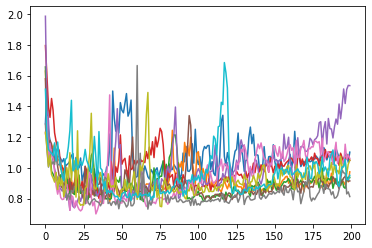

In [ ]:
for loss in losses_val_kfold:
    plt.plot(loss)
    plt.show

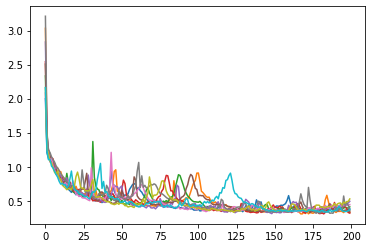

In [ ]:
for loss in losses_kfold:
    plt.plot(loss)
    plt.show

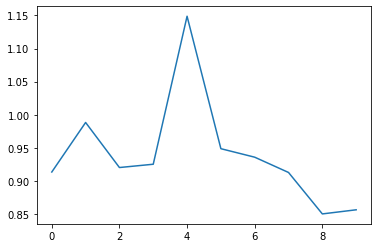

In [ ]:
plt.plot(test_rmse)

**As we can see model overfits. It happens probably because of sparsed Morgan fingerprints**

# Best data is Neural Fingerprints + Features extracted in baseline model

In [30]:
new_df = new_df.join(df.drop(columns=["Compound ID", "smiles"]))
new_df

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,...,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,standardize_smiles
0,0.431154,0.304703,0.742380,0.611255,0.564015,0.695016,0.628013,0.550359,0.632004,0.526516,0.647978,0.533322,0.567960,0.441039,9.662156e-01,9.852195e-01,6.893569e-07,0.100218,0.131846,2.509948e-11,9.258417e-11,8.288383e-01,0.464812,2.391450e-11,8.205149e-01,0.722986,0.070685,0.057481,0.064305,9.048759e-01,0.837960,0.706530,0.720712,0.999999,0.815583,0.810059,0.640453,0.664681,0.063911,0.247244,...,0.154654,2.794209e-22,0.975564,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.069877,-0.974,1,457.432,7,3,7,202.32,-0.770,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1,0.831056,0.076056,0.026948,0.030340,0.020389,0.033934,0.032592,0.020369,0.029170,0.015533,0.038519,0.021520,0.041210,0.024028,4.074888e-10,2.648697e-01,6.893569e-07,0.218593,0.307374,1.510129e-01,6.498039e-01,5.663300e-01,0.651997,1.691932e-01,3.299699e-01,0.018750,0.715690,0.681483,0.524134,1.024882e-01,0.761894,0.030800,0.019873,0.999999,0.018461,0.031261,0.270675,0.024863,0.170656,0.621108,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.999908,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.861151,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc1ccccc1
2,0.991404,0.006351,0.008175,0.017477,0.011397,0.005603,0.013714,0.008724,0.020863,0.010806,0.009586,0.005097,0.008525,0.004764,4.074888e-10,2.648697e-01,6.893569e-07,0.100218,0.019674,5.917485e-01,6.288924e-01,3.815791e-01,0.477870,5.834501e-01,7.522456e-13,0.003645,0.829479,0.638385,0.295614,7.336696e-01,0.954836,0.005699,0.002908,0.999999,0.026889,0.179088,0.789732,0.006155,0.057285,0.101979,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.171383,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC=O
3,0.777909,0.624374,0.145605,0.194124,0.153062,0.246362,0.287320,0.218869,0.320262,0.224962,0.476379,0.357717,0.590347,0.464119,4.074888e-10,2.175235e-08,6.893569e-07,0.100218,0.019674,2.509948e-11,9.658268e-01,5.856109e-17,0.000001,9.913422e-01,7.522456e-13,0.116563,0.000944,0.002053,0.003521,2.155533e-14,0.458839,0.214325,0.122267,0.999999,0.062004,0.044811,0.197879,0.191387,0.010197,0.022049,...,0.154654,2.794209e-22,0.000000,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.000053,0.156951,4.034345e-08,1.552592e-23,1.

In [36]:
train, test = train_test_split(new_df , test_size=0.1)

train_mol = train['standardize_smiles'].map(lambda x : Chem.MolFromSmiles(x))
test_mol = test['standardize_smiles'].map(lambda x : Chem.MolFromSmiles(x))

test_rmse = []

train_loader, test_loader_final = prepare_dataloader(train_mol) ,prepare_dataloader(test_mol)

train_labels_final_dataset = TensorDataset(torch.tensor(train['measured log solubility in mols per litre'].to_numpy()).float())
train_labels_final_loader = DataLoader(train_labels_final_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_features_final_dataset = TensorDataset(torch.tensor(train.drop(columns=['measured log solubility in mols per litre', 'standardize_smiles']).to_numpy()).float())
train_features_final_loader = DataLoader(train_features_final_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_labels_final_dataset = TensorDataset(torch.tensor(test['measured log solubility in mols per litre'].to_numpy()).float())
test_labels_final_loader = DataLoader(test_labels_final_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_features_final_dataset = TensorDataset(torch.tensor(test.drop(columns=['measured log solubility in mols per litre', 'standardize_smiles']).to_numpy()).float())
test_features_final_loader = DataLoader(test_features_final_dataset, batch_size=BATCH_SIZE, shuffle=False)





neural_fp = NeuralFP(8, 100)
reg = MLP_Regressor(neural_fp, 8, 100, 300, 207).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(reg.parameters(), 
                      lr=0.001
                          )


reg, loss, val_loss, r2_loss, r2_val_loss = train_nn(reg, optimizer, criterion, 
                                                        train_loader, train_labels_final_loader, train_features_final_loader,
                                                        test_loader_final, test_labels_final_loader, test_features_final_loader)


34it [00:00, 195.52it/s]
4it [00:00, 256.64it/s]
34it [00:00, 212.78it/s]
0it [00:00, ?it/s]

Epoch 0 - Training rmse loss: 3.0622064809283693
Epoch 0 - Training r2 loss: -2.479369333938349
Epoch 0 - val rmse loss: 1.7836003607929445
Epoch 0 - val r2 loss: -1.9578043815450872
Epoch 1 - Training rmse loss: 1.4900123272540993
Epoch 1 - Training r2 loss: -0.013709101206422698


4it [00:00, 178.65it/s]
34it [00:00, 220.56it/s]
4it [00:00, 268.37it/s]
0it [00:00, ?it/s]

Epoch 1 - val rmse loss: 1.374057826280833
Epoch 1 - val r2 loss: 0.20729705499340834
Epoch 2 - Training rmse loss: 1.315385552949524
Epoch 2 - Training r2 loss: 0.32861591423380926
Epoch 2 - val rmse loss: 1.242532190447003
Epoch 2 - val r2 loss: 0.37346676687652514


34it [00:00, 211.53it/s]
4it [00:00, 174.43it/s]
34it [00:00, 211.13it/s]
0it [00:00, ?it/s]

Epoch 3 - Training rmse loss: 1.2820345120084755
Epoch 3 - Training r2 loss: 0.4353305258694065
Epoch 3 - val rmse loss: 1.246297867419094
Epoch 3 - val r2 loss: 0.37289467563507994
Epoch 4 - Training rmse loss: 1.1955882014452686
Epoch 4 - Training r2 loss: 0.4594777891139855


4it [00:00, 226.78it/s]
34it [00:00, 208.19it/s]
4it [00:00, 295.56it/s]
0it [00:00, ?it/s]

Epoch 4 - val rmse loss: 1.2400389509851404
Epoch 4 - val r2 loss: 0.41968938377326703
Epoch 5 - Training rmse loss: 1.2029598937316262
Epoch 5 - Training r2 loss: 0.5059102092764964
Epoch 5 - val rmse loss: 1.1761481007453987
Epoch 5 - val r2 loss: 0.44143769996444115


34it [00:00, 206.00it/s]
4it [00:00, 243.48it/s]
34it [00:00, 217.95it/s]
4it [00:00, 268.45it/s]
0it [00:00, ?it/s]

Epoch 6 - Training rmse loss: 1.1472119114848667
Epoch 6 - Training r2 loss: 0.5230937293449223
Epoch 6 - val rmse loss: 1.1570469197738948
Epoch 6 - val r2 loss: 0.4472556149611523
Epoch 7 - Training rmse loss: 1.1797041637341925
Epoch 7 - Training r2 loss: 0.5250055592867356
Epoch 7 - val rmse loss: 1.1040837133784454
Epoch 7 - val r2 loss: 0.44435909487050695


34it [00:00, 210.90it/s]
4it [00:00, 224.46it/s]
34it [00:00, 215.39it/s]
0it [00:00, ?it/s]

Epoch 8 - Training rmse loss: 1.0981569240322673
Epoch 8 - Training r2 loss: 0.5529936412506616
Epoch 8 - val rmse loss: 1.1827639450125211
Epoch 8 - val r2 loss: 0.4656946942948019
Epoch 9 - Training rmse loss: 1.1195684331366744
Epoch 9 - Training r2 loss: 0.5621147090873585


4it [00:00, 235.02it/s]
34it [00:00, 213.28it/s]
4it [00:00, 226.28it/s]
0it [00:00, ?it/s]

Epoch 9 - val rmse loss: 1.1246095946862609
Epoch 9 - val r2 loss: 0.48686137594829465
Epoch 10 - Training rmse loss: 1.0623394339914647
Epoch 10 - Training r2 loss: 0.5998081604279801
Epoch 10 - val rmse loss: 1.2116860567917505
Epoch 10 - val r2 loss: 0.45178170438969967


34it [00:00, 211.23it/s]
4it [00:00, 235.15it/s]
34it [00:00, 209.67it/s]
0it [00:00, ?it/s]

Epoch 11 - Training rmse loss: 1.1116027248268123
Epoch 11 - Training r2 loss: 0.5929944989370353
Epoch 11 - val rmse loss: 1.138969277856767
Epoch 11 - val r2 loss: 0.4569345563492013
Epoch 12 - Training rmse loss: 1.0185765690104627
Epoch 12 - Training r2 loss: 0.6243576570003513


4it [00:00, 208.32it/s]
34it [00:00, 221.67it/s]
4it [00:00, 249.78it/s]
0it [00:00, ?it/s]

Epoch 12 - val rmse loss: 1.073407792981021
Epoch 12 - val r2 loss: 0.5532442605062268
Epoch 13 - Training rmse loss: 1.038536614410561
Epoch 13 - Training r2 loss: 0.6308231105318169
Epoch 13 - val rmse loss: 1.2229308408059814
Epoch 13 - val r2 loss: 0.48763706861144895


34it [00:00, 206.42it/s]
4it [00:00, 239.16it/s]
34it [00:00, 214.18it/s]
4it [00:00, 271.72it/s]

Epoch 14 - Training rmse loss: 0.9980030684739302
Epoch 14 - Training r2 loss: 0.6639970264945293
Epoch 14 - val rmse loss: 1.0505703143582015
Epoch 14 - val r2 loss: 0.574443199089817
Epoch 15 - Training rmse loss: 1.0212845564499895
Epoch 15 - Training r2 loss: 0.6619716834907341



34it [00:00, 216.61it/s]
4it [00:00, 252.06it/s]
0it [00:00, ?it/s]

Epoch 15 - val rmse loss: 0.9744892543241371
Epoch 15 - val r2 loss: 0.5552619165051268
Epoch 16 - Training rmse loss: 0.9802622151805735
Epoch 16 - Training r2 loss: 0.655369267056259
Epoch 16 - val rmse loss: 1.0011481607868047
Epoch 16 - val r2 loss: 0.578328277293994


34it [00:00, 203.60it/s]
4it [00:00, 253.07it/s]
34it [00:00, 219.49it/s]
4it [00:00, 284.69it/s]
0it [00:00, ?it/s]

Epoch 17 - Training rmse loss: 0.9863602559138831
Epoch 17 - Training r2 loss: 0.6804824674148862
Epoch 17 - val rmse loss: 1.0711925466592092
Epoch 17 - val r2 loss: 0.5247265523320827
Epoch 18 - Training rmse loss: 0.9387721284926612
Epoch 18 - Training r2 loss: 0.7093176679163948
Epoch 18 - val rmse loss: 0.9551936198730349
Epoch 18 - val r2 loss: 0.6293966803336453


34it [00:00, 209.50it/s]
4it [00:00, 244.70it/s]
34it [00:00, 219.66it/s]
4it [00:00, 235.12it/s]
0it [00:00, ?it/s]

Epoch 19 - Training rmse loss: 0.9608477286462419
Epoch 19 - Training r2 loss: 0.6998498799318518
Epoch 19 - val rmse loss: 1.0093953765371353
Epoch 19 - val r2 loss: 0.5886756523772635
Epoch 20 - Training rmse loss: 0.9269669604815595
Epoch 20 - Training r2 loss: 0.702711311790825
Epoch 20 - val rmse loss: 1.0569990258898077
Epoch 20 - val r2 loss: 0.6231263521205194


34it [00:00, 195.10it/s]
4it [00:00, 268.84it/s]
34it [00:00, 211.21it/s]
0it [00:00, ?it/s]

Epoch 21 - Training rmse loss: 0.9490021334029887
Epoch 21 - Training r2 loss: 0.7077567130853497
Epoch 21 - val rmse loss: 1.0584269881423365
Epoch 21 - val r2 loss: 0.6406564998734062
Epoch 22 - Training rmse loss: 0.9197941378515628
Epoch 22 - Training r2 loss: 0.7264722863606696


4it [00:00, 223.75it/s]
34it [00:00, 206.93it/s]
4it [00:00, 237.71it/s]
0it [00:00, ?it/s]

Epoch 22 - val rmse loss: 0.9273327409818701
Epoch 22 - val r2 loss: 0.6662284302641186
Epoch 23 - Training rmse loss: 0.9058685757441406
Epoch 23 - Training r2 loss: 0.7351482930763641
Epoch 23 - val rmse loss: 1.0122024749491376
Epoch 23 - val r2 loss: 0.6626568238541086


34it [00:00, 197.62it/s]
4it [00:00, 270.57it/s]
34it [00:00, 220.48it/s]
4it [00:00, 280.91it/s]
0it [00:00, ?it/s]

Epoch 24 - Training rmse loss: 0.9062682801853896
Epoch 24 - Training r2 loss: 0.7407288592948718
Epoch 24 - val rmse loss: 0.9656216578132542
Epoch 24 - val r2 loss: 0.6762451822149798
Epoch 25 - Training rmse loss: 0.9323492555238843
Epoch 25 - Training r2 loss: 0.7208911605756382
Epoch 25 - val rmse loss: 0.9598035169115117
Epoch 25 - val r2 loss: 0.5808853269983498


34it [00:00, 204.71it/s]
4it [00:00, 235.78it/s]
34it [00:00, 213.14it/s]
0it [00:00, ?it/s]

Epoch 26 - Training rmse loss: 0.9155501725286468
Epoch 26 - Training r2 loss: 0.7203851145532932
Epoch 26 - val rmse loss: 1.0851919098302925
Epoch 26 - val r2 loss: 0.6147827928752674
Epoch 27 - Training rmse loss: 0.9166365370329197
Epoch 27 - Training r2 loss: 0.7451864868050796


4it [00:00, 191.46it/s]
34it [00:00, 216.23it/s]
4it [00:00, 224.71it/s]
0it [00:00, ?it/s]

Epoch 27 - val rmse loss: 0.9962463486411886
Epoch 27 - val r2 loss: 0.5906847560680178
Epoch 28 - Training rmse loss: 0.9074436542248219
Epoch 28 - Training r2 loss: 0.7296288075373042
Epoch 28 - val rmse loss: 0.9365308679757285
Epoch 28 - val r2 loss: 0.665018854778272


34it [00:00, 216.16it/s]
4it [00:00, 267.14it/s]
34it [00:00, 213.99it/s]
0it [00:00, ?it/s]

Epoch 29 - Training rmse loss: 0.8554087158499555
Epoch 29 - Training r2 loss: 0.765630519566891
Epoch 29 - val rmse loss: 0.901269789668939
Epoch 29 - val r2 loss: 0.7026486725049165
Epoch 30 - Training rmse loss: 0.8898433319848909
Epoch 30 - Training r2 loss: 0.7527350767295312


4it [00:00, 210.08it/s]
34it [00:00, 206.03it/s]
4it [00:00, 233.21it/s]
0it [00:00, ?it/s]

Epoch 30 - val rmse loss: 0.8967653719262758
Epoch 30 - val r2 loss: 0.7092387367680713
Epoch 31 - Training rmse loss: 0.9019591529653894
Epoch 31 - Training r2 loss: 0.7448865959510392
Epoch 31 - val rmse loss: 0.8936021510791694
Epoch 31 - val r2 loss: 0.6797129797441948


34it [00:00, 211.58it/s]
4it [00:00, 211.57it/s]
34it [00:00, 219.93it/s]
4it [00:00, 254.78it/s]
0it [00:00, ?it/s]

Epoch 32 - Training rmse loss: 0.8681009653717745
Epoch 32 - Training r2 loss: 0.7665404333623935
Epoch 32 - val rmse loss: 0.9095799623140912
Epoch 32 - val r2 loss: 0.688347059740402
Epoch 33 - Training rmse loss: 0.8615384556786545
Epoch 33 - Training r2 loss: 0.7700931037193856
Epoch 33 - val rmse loss: 0.8763641724641956
Epoch 33 - val r2 loss: 0.6968399658476356


34it [00:00, 209.59it/s]
4it [00:00, 221.90it/s]
34it [00:00, 216.80it/s]
0it [00:00, ?it/s]

Epoch 34 - Training rmse loss: 0.882687068271419
Epoch 34 - Training r2 loss: 0.7623868913644313
Epoch 34 - val rmse loss: 0.9416003680028739
Epoch 34 - val r2 loss: 0.6020995585349748
Epoch 35 - Training rmse loss: 0.8927224403837907
Epoch 35 - Training r2 loss: 0.7349177581836915


4it [00:00, 254.69it/s]
34it [00:00, 212.20it/s]
4it [00:00, 224.45it/s]
0it [00:00, ?it/s]

Epoch 35 - val rmse loss: 0.904918778131049
Epoch 35 - val r2 loss: 0.6604751842675647
Epoch 36 - Training rmse loss: 0.8148420957221821
Epoch 36 - Training r2 loss: 0.7924391681266684
Epoch 36 - val rmse loss: 0.8517984667030766
Epoch 36 - val r2 loss: 0.731626733491091


34it [00:00, 208.59it/s]
4it [00:00, 235.03it/s]
34it [00:00, 214.59it/s]
0it [00:00, ?it/s]

Epoch 37 - Training rmse loss: 0.867715315609648
Epoch 37 - Training r2 loss: 0.7708325092351667
Epoch 37 - val rmse loss: 0.8433735148811297
Epoch 37 - val r2 loss: 0.6960371711399338
Epoch 38 - Training rmse loss: 0.8461512365770723
Epoch 38 - Training r2 loss: 0.7803850096555824


4it [00:00, 246.63it/s]
34it [00:00, 212.94it/s]
4it [00:00, 270.79it/s]
0it [00:00, ?it/s]

Epoch 38 - val rmse loss: 0.854993052147638
Epoch 38 - val r2 loss: 0.6912096487290228
Epoch 39 - Training rmse loss: 0.8008479414852457
Epoch 39 - Training r2 loss: 0.800228579243344
Epoch 39 - val rmse loss: 0.9415990544973957
Epoch 39 - val r2 loss: 0.706596811638821


34it [00:00, 185.01it/s]
4it [00:00, 214.79it/s]
34it [00:00, 217.80it/s]
0it [00:00, ?it/s]

Epoch 40 - Training rmse loss: 0.7948362572030019
Epoch 40 - Training r2 loss: 0.810156658772061
Epoch 40 - val rmse loss: 0.8792790194596091
Epoch 40 - val r2 loss: 0.7057344942758759
Epoch 41 - Training rmse loss: 0.8159801977638073
Epoch 41 - Training r2 loss: 0.7997598239203031


4it [00:00, 195.26it/s]
34it [00:00, 209.90it/s]
4it [00:00, 259.62it/s]
0it [00:00, ?it/s]

Epoch 41 - val rmse loss: 0.8866078311597545
Epoch 41 - val r2 loss: 0.6896956666083627
Epoch 42 - Training rmse loss: 0.8310486496721645
Epoch 42 - Training r2 loss: 0.7893468151448503
Epoch 42 - val rmse loss: 0.8038752122602033
Epoch 42 - val r2 loss: 0.7323920262590953


34it [00:00, 213.69it/s]
4it [00:00, 245.41it/s]
34it [00:00, 194.84it/s]
0it [00:00, ?it/s]

Epoch 43 - Training rmse loss: 0.8151829877449348
Epoch 43 - Training r2 loss: 0.7970966810634057
Epoch 43 - val rmse loss: 0.8012452665254625
Epoch 43 - val r2 loss: 0.7337081224369854
Epoch 44 - Training rmse loss: 0.782877144244448
Epoch 44 - Training r2 loss: 0.8110885474949872


4it [00:00, 205.55it/s]
34it [00:00, 206.38it/s]
4it [00:00, 240.33it/s]
0it [00:00, ?it/s]

Epoch 44 - val rmse loss: 0.7877046402450576
Epoch 44 - val r2 loss: 0.7721445770030706
Epoch 45 - Training rmse loss: 0.8403373911322536
Epoch 45 - Training r2 loss: 0.7866373165824166
Epoch 45 - val rmse loss: 0.9051885472466569
Epoch 45 - val r2 loss: 0.6585064040356119


34it [00:00, 203.54it/s]
4it [00:00, 272.90it/s]
34it [00:00, 209.72it/s]
0it [00:00, ?it/s]

Epoch 46 - Training rmse loss: 0.82594003237234
Epoch 46 - Training r2 loss: 0.7860819171023188
Epoch 46 - val rmse loss: 0.7925016079549392
Epoch 46 - val r2 loss: 0.74617682628569
Epoch 47 - Training rmse loss: 0.8072442856383581
Epoch 47 - Training r2 loss: 0.8079555480291214


4it [00:00, 196.38it/s]
34it [00:00, 220.77it/s]
4it [00:00, 290.26it/s]
0it [00:00, ?it/s]

Epoch 47 - val rmse loss: 0.7864497617966028
Epoch 47 - val r2 loss: 0.7577541348904382
Epoch 48 - Training rmse loss: 0.8129039915453296
Epoch 48 - Training r2 loss: 0.8007755025794453
Epoch 48 - val rmse loss: 0.7599569780868646
Epoch 48 - val r2 loss: 0.7678739467751234


34it [00:00, 201.20it/s]
4it [00:00, 236.78it/s]
34it [00:00, 208.34it/s]
0it [00:00, ?it/s]

Epoch 49 - Training rmse loss: 0.759847341538839
Epoch 49 - Training r2 loss: 0.8276575207022273
Epoch 49 - val rmse loss: 0.8462277782655473
Epoch 49 - val r2 loss: 0.7540529095455182
Epoch 50 - Training rmse loss: 0.8473326964404836
Epoch 50 - Training r2 loss: 0.7809593485749551


4it [00:00, 192.34it/s]
34it [00:00, 221.17it/s]
4it [00:00, 282.89it/s]
0it [00:00, ?it/s]

Epoch 50 - val rmse loss: 0.8490009584823046
Epoch 50 - val r2 loss: 0.6591856570369374
Epoch 51 - Training rmse loss: 0.7871203390462271
Epoch 51 - Training r2 loss: 0.8003282754331268
Epoch 51 - val rmse loss: 0.8142236528119057
Epoch 51 - val r2 loss: 0.7757841062712734


34it [00:00, 208.68it/s]
4it [00:00, 298.53it/s]
34it [00:00, 212.26it/s]
0it [00:00, ?it/s]

Epoch 52 - Training rmse loss: 0.8151639811140986
Epoch 52 - Training r2 loss: 0.8057181400366591
Epoch 52 - val rmse loss: 0.7888475304667016
Epoch 52 - val r2 loss: 0.767110743451642
Epoch 53 - Training rmse loss: 0.807488853807172
Epoch 53 - Training r2 loss: 0.8048723072986785


4it [00:00, 188.38it/s]
34it [00:00, 201.89it/s]
4it [00:00, 267.35it/s]
0it [00:00, ?it/s]

Epoch 53 - val rmse loss: 0.7505431791142873
Epoch 53 - val r2 loss: 0.7898534390062253
Epoch 54 - Training rmse loss: 0.8049979457978843
Epoch 54 - Training r2 loss: 0.8091308185628026
Epoch 54 - val rmse loss: 0.8040461947614784
Epoch 54 - val r2 loss: 0.7081723891884929


34it [00:00, 193.96it/s]
4it [00:00, 217.67it/s]
34it [00:00, 213.83it/s]
0it [00:00, ?it/s]

Epoch 55 - Training rmse loss: 0.7719180708095125
Epoch 55 - Training r2 loss: 0.8178247457387705
Epoch 55 - val rmse loss: 0.8034406789303552
Epoch 55 - val r2 loss: 0.7838557014040044
Epoch 56 - Training rmse loss: 0.8010930301340593
Epoch 56 - Training r2 loss: 0.8156319029821689


4it [00:00, 233.04it/s]
34it [00:00, 223.00it/s]
4it [00:00, 300.92it/s]
0it [00:00, ?it/s]

Epoch 56 - val rmse loss: 0.7623498649609933
Epoch 56 - val r2 loss: 0.7526425405407262
Epoch 57 - Training rmse loss: 0.8210543475681198
Epoch 57 - Training r2 loss: 0.7923446232074993
Epoch 57 - val rmse loss: 0.7569204221762352
Epoch 57 - val r2 loss: 0.7635759888598119


34it [00:00, 209.70it/s]
4it [00:00, 215.85it/s]
34it [00:00, 214.18it/s]
0it [00:00, ?it/s]

Epoch 58 - Training rmse loss: 0.7815499644267065
Epoch 58 - Training r2 loss: 0.8164776043370001
Epoch 58 - val rmse loss: 0.7772291424864667
Epoch 58 - val r2 loss: 0.7834512451342434
Epoch 59 - Training rmse loss: 0.8122039024524199
Epoch 59 - Training r2 loss: 0.8059377333617317


4it [00:00, 215.73it/s]
34it [00:00, 208.77it/s]
4it [00:00, 257.60it/s]
0it [00:00, ?it/s]

Epoch 59 - val rmse loss: 0.7667753132039442
Epoch 59 - val r2 loss: 0.768559575487811
Epoch 60 - Training rmse loss: 0.7808943982609401
Epoch 60 - Training r2 loss: 0.8177461244826729
Epoch 60 - val rmse loss: 0.7345274604646054
Epoch 60 - val r2 loss: 0.7976728127049559


34it [00:00, 209.23it/s]
4it [00:00, 244.11it/s]
34it [00:00, 214.33it/s]
0it [00:00, ?it/s]

Epoch 61 - Training rmse loss: 0.7464788668888971
Epoch 61 - Training r2 loss: 0.8327708253693666
Epoch 61 - val rmse loss: 0.7806929414287861
Epoch 61 - val r2 loss: 0.7681611808793056
Epoch 62 - Training rmse loss: 0.7972322430999123
Epoch 62 - Training r2 loss: 0.8157587216217849


4it [00:00, 204.21it/s]
34it [00:00, 204.42it/s]
4it [00:00, 241.68it/s]
0it [00:00, ?it/s]

Epoch 62 - val rmse loss: 0.7394374341957438
Epoch 62 - val r2 loss: 0.7965187032050438
Epoch 63 - Training rmse loss: 0.7811303782043125
Epoch 63 - Training r2 loss: 0.8191322547342137
Epoch 63 - val rmse loss: 0.7395088545589616
Epoch 63 - val r2 loss: 0.7915507604437773


34it [00:00, 205.34it/s]
4it [00:00, 245.44it/s]
34it [00:00, 209.31it/s]
0it [00:00, ?it/s]

Epoch 64 - Training rmse loss: 0.8210924132856058
Epoch 64 - Training r2 loss: 0.8086161462365329
Epoch 64 - val rmse loss: 0.8624018164049829
Epoch 64 - val r2 loss: 0.7358667172803541
Epoch 65 - Training rmse loss: 0.7914640697137895
Epoch 65 - Training r2 loss: 0.8095105004726272


4it [00:00, 200.23it/s]
34it [00:00, 204.84it/s]
4it [00:00, 269.65it/s]
0it [00:00, ?it/s]

Epoch 65 - val rmse loss: 0.7762968067440733
Epoch 65 - val r2 loss: 0.7917335608313505
Epoch 66 - Training rmse loss: 0.7210337055362913
Epoch 66 - Training r2 loss: 0.8507004942005725
Epoch 66 - val rmse loss: 0.722853118268132
Epoch 66 - val r2 loss: 0.7968520608772192


34it [00:00, 205.44it/s]
4it [00:00, 323.18it/s]
34it [00:00, 217.30it/s]
4it [00:00, 310.51it/s]


Epoch 67 - Training rmse loss: 0.7267654251381854
Epoch 67 - Training r2 loss: 0.8461841648012935
Epoch 67 - val rmse loss: 0.7433514853703767
Epoch 67 - val r2 loss: 0.7969285456742186
Epoch 68 - Training rmse loss: 0.7423759120910509
Epoch 68 - Training r2 loss: 0.8397117552311125
Epoch 68 - val rmse loss: 0.7795052978667144
Epoch 68 - val r2 loss: 0.7338118858011633


34it [00:00, 222.18it/s]
4it [00:00, 311.00it/s]
34it [00:00, 217.82it/s]
0it [00:00, ?it/s]

Epoch 69 - Training rmse loss: 0.7286870093378032
Epoch 69 - Training r2 loss: 0.8423639922291015
Epoch 69 - val rmse loss: 0.7542099563326239
Epoch 69 - val r2 loss: 0.8139878646072458
Epoch 70 - Training rmse loss: 0.7495114199478247
Epoch 70 - Training r2 loss: 0.8347751508686961


4it [00:00, 172.95it/s]
34it [00:00, 200.68it/s]
4it [00:00, 242.57it/s]
0it [00:00, ?it/s]

Epoch 70 - val rmse loss: 0.7359128433600218
Epoch 70 - val r2 loss: 0.8004146888052064
Epoch 71 - Training rmse loss: 0.7594922305142071
Epoch 71 - Training r2 loss: 0.8347235976548585
Epoch 71 - val rmse loss: 0.7419454531249379
Epoch 71 - val r2 loss: 0.7999840857974334


34it [00:00, 212.89it/s]
4it [00:00, 283.41it/s]
34it [00:00, 211.65it/s]
0it [00:00, ?it/s]

Epoch 72 - Training rmse loss: 0.7354083555199336
Epoch 72 - Training r2 loss: 0.8450257117980166
Epoch 72 - val rmse loss: 0.7739808505228228
Epoch 72 - val r2 loss: 0.7546792573978663
Epoch 73 - Training rmse loss: 0.7449300935627756
Epoch 73 - Training r2 loss: 0.8374919223920506


4it [00:00, 166.65it/s]
34it [00:00, 210.77it/s]
4it [00:00, 271.45it/s]
0it [00:00, ?it/s]

Epoch 73 - val rmse loss: 0.7389978180902789
Epoch 73 - val r2 loss: 0.7858506486274697
Epoch 74 - Training rmse loss: 0.7430676906941721
Epoch 74 - Training r2 loss: 0.8394844315623926
Epoch 74 - val rmse loss: 0.736322660957118
Epoch 74 - val r2 loss: 0.7937888662248871


34it [00:00, 200.48it/s]
4it [00:00, 260.88it/s]
34it [00:00, 207.06it/s]
0it [00:00, ?it/s]

Epoch 75 - Training rmse loss: 0.7886425554895993
Epoch 75 - Training r2 loss: 0.821170775984678
Epoch 75 - val rmse loss: 0.7509634366519164
Epoch 75 - val r2 loss: 0.795154697283061
Epoch 76 - Training rmse loss: 0.7502703337261856
Epoch 76 - Training r2 loss: 0.8349324922482153


4it [00:00, 212.55it/s]
34it [00:00, 219.73it/s]
4it [00:00, 277.51it/s]
0it [00:00, ?it/s]

Epoch 76 - val rmse loss: 0.7576323422880363
Epoch 76 - val r2 loss: 0.7848232764553135
Epoch 77 - Training rmse loss: 0.7351723944313792
Epoch 77 - Training r2 loss: 0.8423870016172891
Epoch 77 - val rmse loss: 0.7636443569757249
Epoch 77 - val r2 loss: 0.803613424013307


34it [00:00, 198.60it/s]
4it [00:00, 324.20it/s]
34it [00:00, 215.87it/s]
0it [00:00, ?it/s]

Epoch 78 - Training rmse loss: 0.717675395068782
Epoch 78 - Training r2 loss: 0.8543518183955673
Epoch 78 - val rmse loss: 0.756281692849638
Epoch 78 - val r2 loss: 0.792333283978033
Epoch 79 - Training rmse loss: 0.7647809379593119
Epoch 79 - Training r2 loss: 0.8294390925099406


4it [00:00, 239.95it/s]
34it [00:00, 222.41it/s]
4it [00:00, 293.47it/s]
0it [00:00, ?it/s]

Epoch 79 - val rmse loss: 0.7787756503321618
Epoch 79 - val r2 loss: 0.7846280428388172
Epoch 80 - Training rmse loss: 0.7263833554386334
Epoch 80 - Training r2 loss: 0.8449815068527847
Epoch 80 - val rmse loss: 0.7739974172272456
Epoch 80 - val r2 loss: 0.7927313144245908


34it [00:00, 212.10it/s]
4it [00:00, 270.23it/s]
34it [00:00, 202.80it/s]
0it [00:00, ?it/s]

Epoch 81 - Training rmse loss: 0.7212259405190898
Epoch 81 - Training r2 loss: 0.8486920368540618
Epoch 81 - val rmse loss: 0.7381094879083764
Epoch 81 - val r2 loss: 0.7884846460418946
Epoch 82 - Training rmse loss: 0.7054744801112466
Epoch 82 - Training r2 loss: 0.8577534008494901


4it [00:00, 227.95it/s]
34it [00:00, 222.07it/s]
4it [00:00, 246.59it/s]
0it [00:00, ?it/s]

Epoch 82 - val rmse loss: 0.698698708207607
Epoch 82 - val r2 loss: 0.8239822687324905
Epoch 83 - Training rmse loss: 0.7154134162230782
Epoch 83 - Training r2 loss: 0.8514110875491718
Epoch 83 - val rmse loss: 0.7390847853996397
Epoch 83 - val r2 loss: 0.8003038531020862


34it [00:00, 210.34it/s]
4it [00:00, 256.82it/s]
34it [00:00, 207.03it/s]
0it [00:00, ?it/s]

Epoch 84 - Training rmse loss: 0.716631070266576
Epoch 84 - Training r2 loss: 0.8526378360752316
Epoch 84 - val rmse loss: 0.7283864661054492
Epoch 84 - val r2 loss: 0.8138994221316909
Epoch 85 - Training rmse loss: 0.7153704164442093
Epoch 85 - Training r2 loss: 0.852883718665113


4it [00:00, 221.80it/s]
34it [00:00, 209.05it/s]
4it [00:00, 286.55it/s]
0it [00:00, ?it/s]

Epoch 85 - val rmse loss: 0.7432442319840572
Epoch 85 - val r2 loss: 0.7961591422987933
Epoch 86 - Training rmse loss: 0.7416296932504898
Epoch 86 - Training r2 loss: 0.8407167732433274
Epoch 86 - val rmse loss: 0.7291648569538729
Epoch 86 - val r2 loss: 0.7940688403472982


34it [00:00, 198.48it/s]
4it [00:00, 287.99it/s]
34it [00:00, 214.07it/s]
4it [00:00, 302.16it/s]

Epoch 87 - Training rmse loss: 0.7143686034213771
Epoch 87 - Training r2 loss: 0.8543360856183521
Epoch 87 - val rmse loss: 0.6868461783595422
Epoch 87 - val r2 loss: 0.8280524360590695
Epoch 88 - Training rmse loss: 0.7065546371394034
Epoch 88 - Training r2 loss: 0.8569755235604963



34it [00:00, 220.91it/s]
4it [00:00, 313.56it/s]
0it [00:00, ?it/s]

Epoch 88 - val rmse loss: 0.7271223628645697
Epoch 88 - val r2 loss: 0.8128256371478484
Epoch 89 - Training rmse loss: 0.7104457185040967
Epoch 89 - Training r2 loss: 0.8574809068519208
Epoch 89 - val rmse loss: 0.7119977035890606
Epoch 89 - val r2 loss: 0.8054006510645987


34it [00:00, 208.63it/s]
4it [00:00, 218.91it/s]
34it [00:00, 210.46it/s]
0it [00:00, ?it/s]

Epoch 90 - Training rmse loss: 0.7289715798779203
Epoch 90 - Training r2 loss: 0.8497266764410456
Epoch 90 - val rmse loss: 0.728947197151395
Epoch 90 - val r2 loss: 0.8019575266035539
Epoch 91 - Training rmse loss: 0.7160369836563287
Epoch 91 - Training r2 loss: 0.8517016743307081


4it [00:00, 210.34it/s]
34it [00:00, 203.90it/s]
4it [00:00, 201.05it/s]
0it [00:00, ?it/s]

Epoch 91 - val rmse loss: 0.7583871707477242
Epoch 91 - val r2 loss: 0.7943991997509751
Epoch 92 - Training rmse loss: 0.6977772993596831
Epoch 92 - Training r2 loss: 0.8605079672274163
Epoch 92 - val rmse loss: 0.7398468653966775
Epoch 92 - val r2 loss: 0.807937672474946


34it [00:00, 206.87it/s]
4it [00:00, 262.05it/s]
34it [00:00, 193.09it/s]


Epoch 93 - Training rmse loss: 0.7188427266505683
Epoch 93 - Training r2 loss: 0.8556627325961034
Epoch 93 - val rmse loss: 0.7566878684621083
Epoch 93 - val r2 loss: 0.7909191491713097
Epoch 94 - Training rmse loss: 0.7380206897602487
Epoch 94 - Training r2 loss: 0.8437422428465299


4it [00:00, 156.34it/s]
34it [00:00, 226.51it/s]
4it [00:00, 318.57it/s]
0it [00:00, ?it/s]

Epoch 94 - val rmse loss: 0.7227380706243981
Epoch 94 - val r2 loss: 0.7960865503636523
Epoch 95 - Training rmse loss: 0.7015967062631452
Epoch 95 - Training r2 loss: 0.8591958981796733
Epoch 95 - val rmse loss: 0.715220346943465
Epoch 95 - val r2 loss: 0.8105471250929154


34it [00:00, 202.55it/s]
4it [00:00, 260.55it/s]
34it [00:00, 206.79it/s]
0it [00:00, ?it/s]

Epoch 96 - Training rmse loss: 0.7448432288739202
Epoch 96 - Training r2 loss: 0.8431602070417082
Epoch 96 - val rmse loss: 0.7341927241299206
Epoch 96 - val r2 loss: 0.8118788644894139
Epoch 97 - Training rmse loss: 0.7462551146865815
Epoch 97 - Training r2 loss: 0.8396971982007879


4it [00:00, 202.03it/s]
34it [00:00, 210.89it/s]
4it [00:00, 243.61it/s]
0it [00:00, ?it/s]

Epoch 97 - val rmse loss: 0.7732105741038923
Epoch 97 - val r2 loss: 0.7868074650127707
Epoch 98 - Training rmse loss: 0.7391332470559023
Epoch 98 - Training r2 loss: 0.8441626709694795
Epoch 98 - val rmse loss: 0.7575710983792358
Epoch 98 - val r2 loss: 0.7968353736341928


34it [00:00, 208.31it/s]
4it [00:00, 230.40it/s]
34it [00:00, 216.14it/s]
0it [00:00, ?it/s]

Epoch 99 - Training rmse loss: 0.6881470545403557
Epoch 99 - Training r2 loss: 0.8642939515172499
Epoch 99 - val rmse loss: 0.7199987313554104
Epoch 99 - val r2 loss: 0.8131458260763724
Epoch 100 - Training rmse loss: 0.691822979925161
Epoch 100 - Training r2 loss: 0.8649334471008591


4it [00:00, 230.94it/s]
34it [00:00, 218.68it/s]
4it [00:00, 263.28it/s]
0it [00:00, ?it/s]

Epoch 100 - val rmse loss: 0.7264357938315678
Epoch 100 - val r2 loss: 0.8017874653571236
Epoch 101 - Training rmse loss: 0.7525251667890359
Epoch 101 - Training r2 loss: 0.841472280139011
Epoch 101 - val rmse loss: 0.716557283403296
Epoch 101 - val r2 loss: 0.8083482609100145


34it [00:00, 201.64it/s]
4it [00:00, 228.53it/s]
34it [00:00, 209.73it/s]
0it [00:00, ?it/s]

Epoch 102 - Training rmse loss: 0.719753902724992
Epoch 102 - Training r2 loss: 0.8464154420769395
Epoch 102 - val rmse loss: 0.7203867820204516
Epoch 102 - val r2 loss: 0.8080577512056304
Epoch 103 - Training rmse loss: 0.7116648467815065
Epoch 103 - Training r2 loss: 0.8566626081131821


4it [00:00, 233.41it/s]
34it [00:00, 210.21it/s]
4it [00:00, 271.73it/s]
0it [00:00, ?it/s]

Epoch 103 - val rmse loss: 0.7692254228474898
Epoch 103 - val r2 loss: 0.7926639964083251
Epoch 104 - Training rmse loss: 0.689253682392541
Epoch 104 - Training r2 loss: 0.8634094675321775
Epoch 104 - val rmse loss: 0.7215377296336232
Epoch 104 - val r2 loss: 0.8165997514059641


34it [00:00, 196.39it/s]
4it [00:00, 257.15it/s]
34it [00:00, 210.03it/s]
0it [00:00, ?it/s]

Epoch 105 - Training rmse loss: 0.7058265506164845
Epoch 105 - Training r2 loss: 0.8597612224153912
Epoch 105 - val rmse loss: 0.7336624574427492
Epoch 105 - val r2 loss: 0.8175753037446507
Epoch 106 - Training rmse loss: 0.7110426473012221
Epoch 106 - Training r2 loss: 0.8535931101420201


4it [00:00, 184.74it/s]
34it [00:00, 204.64it/s]
4it [00:00, 285.33it/s]
0it [00:00, ?it/s]

Epoch 106 - val rmse loss: 0.7088802881260536
Epoch 106 - val r2 loss: 0.8255479572458104
Epoch 107 - Training rmse loss: 0.7061728388785069
Epoch 107 - Training r2 loss: 0.858775385233242
Epoch 107 - val rmse loss: 0.7587294536727842
Epoch 107 - val r2 loss: 0.8065064632407106


34it [00:00, 204.33it/s]
4it [00:00, 277.32it/s]
34it [00:00, 207.14it/s]
0it [00:00, ?it/s]

Epoch 108 - Training rmse loss: 0.6976381527067622
Epoch 108 - Training r2 loss: 0.8582904471276349
Epoch 108 - val rmse loss: 0.7074444232719523
Epoch 108 - val r2 loss: 0.8203788995013879
Epoch 109 - Training rmse loss: 0.6628658944469843
Epoch 109 - Training r2 loss: 0.8740888150082984


4it [00:00, 192.24it/s]
34it [00:00, 215.76it/s]
4it [00:00, 299.24it/s]
0it [00:00, ?it/s]

Epoch 109 - val rmse loss: 0.7001133422541642
Epoch 109 - val r2 loss: 0.8315254590004406
Epoch 110 - Training rmse loss: 0.6795744676210353
Epoch 110 - Training r2 loss: 0.8712677830319958
Epoch 110 - val rmse loss: 0.6874899646720194
Epoch 110 - val r2 loss: 0.8385134341893643


34it [00:00, 208.82it/s]
4it [00:00, 262.04it/s]
34it [00:00, 219.72it/s]
0it [00:00, ?it/s]

Epoch 111 - Training rmse loss: 0.8100684034531773
Epoch 111 - Training r2 loss: 0.814897802095507
Epoch 111 - val rmse loss: 0.913819647586046
Epoch 111 - val r2 loss: 0.723054512019752
Epoch 112 - Training rmse loss: 0.738494716335512
Epoch 112 - Training r2 loss: 0.8375507072978561


4it [00:00, 191.73it/s]
34it [00:00, 222.30it/s]
4it [00:00, 307.34it/s]
0it [00:00, ?it/s]

Epoch 112 - val rmse loss: 0.731617014840558
Epoch 112 - val r2 loss: 0.8137433240840184
Epoch 113 - Training rmse loss: 0.6797449972298604
Epoch 113 - Training r2 loss: 0.8706567638335424
Epoch 113 - val rmse loss: 0.7145319764271006
Epoch 113 - val r2 loss: 0.8222375507888873


34it [00:00, 195.67it/s]
4it [00:00, 312.70it/s]
34it [00:00, 225.93it/s]
0it [00:00, ?it/s]

Epoch 114 - Training rmse loss: 0.6793446427292643
Epoch 114 - Training r2 loss: 0.8692774038522264
Epoch 114 - val rmse loss: 0.7172678769434339
Epoch 114 - val r2 loss: 0.8219758665346302
Epoch 115 - Training rmse loss: 0.6796145686960405
Epoch 115 - Training r2 loss: 0.8701826691049612


4it [00:00, 266.19it/s]
34it [00:00, 215.64it/s]
4it [00:00, 189.51it/s]
0it [00:00, ?it/s]

Epoch 115 - val rmse loss: 0.7190781808127298
Epoch 115 - val r2 loss: 0.8113909719586285
Epoch 116 - Training rmse loss: 0.7091190143529804
Epoch 116 - Training r2 loss: 0.8567639318584694
Epoch 116 - val rmse loss: 0.7109852449922215
Epoch 116 - val r2 loss: 0.8149584117216687


34it [00:00, 210.74it/s]
4it [00:00, 254.92it/s]
34it [00:00, 207.91it/s]
0it [00:00, ?it/s]

Epoch 117 - Training rmse loss: 0.6939882525329081
Epoch 117 - Training r2 loss: 0.8646427586374029
Epoch 117 - val rmse loss: 0.7097490196406012
Epoch 117 - val r2 loss: 0.8229193177305985
Epoch 118 - Training rmse loss: 0.7009611017671913
Epoch 118 - Training r2 loss: 0.8635863536043552


4it [00:00, 230.03it/s]
34it [00:00, 199.48it/s]
4it [00:00, 283.44it/s]
0it [00:00, ?it/s]

Epoch 118 - val rmse loss: 0.7514018081292605
Epoch 118 - val r2 loss: 0.8075073594378684
Epoch 119 - Training rmse loss: 0.8537660506860183
Epoch 119 - Training r2 loss: 0.7991758810754345
Epoch 119 - val rmse loss: 1.01034069103363
Epoch 119 - val r2 loss: 0.6548063712880658


34it [00:00, 211.17it/s]
4it [00:00, 271.10it/s]
34it [00:00, 210.03it/s]
0it [00:00, ?it/s]

Epoch 120 - Training rmse loss: 0.7882829051983636
Epoch 120 - Training r2 loss: 0.8106534862530028
Epoch 120 - val rmse loss: 0.7361860770663471
Epoch 120 - val r2 loss: 0.8378709189004231
Epoch 121 - Training rmse loss: 0.6783684930883056
Epoch 121 - Training r2 loss: 0.8703744343067614


4it [00:00, 187.69it/s]
34it [00:00, 213.71it/s]
4it [00:00, 253.23it/s]
0it [00:00, ?it/s]

Epoch 121 - val rmse loss: 0.7198784770086739
Epoch 121 - val r2 loss: 0.820363073514534
Epoch 122 - Training rmse loss: 0.6794548303810949
Epoch 122 - Training r2 loss: 0.8708819928162239
Epoch 122 - val rmse loss: 0.6756476452126334
Epoch 122 - val r2 loss: 0.8352833900929681


34it [00:00, 207.97it/s]
4it [00:00, 284.83it/s]
34it [00:00, 204.80it/s]
0it [00:00, ?it/s]

Epoch 123 - Training rmse loss: 0.6762538523303494
Epoch 123 - Training r2 loss: 0.871417171460922
Epoch 123 - val rmse loss: 0.7268881221941433
Epoch 123 - val r2 loss: 0.8300880574085767
Epoch 124 - Training rmse loss: 0.6866747080060586
Epoch 124 - Training r2 loss: 0.869776311464288


4it [00:00, 190.56it/s]
34it [00:00, 218.65it/s]
4it [00:00, 272.70it/s]
0it [00:00, ?it/s]

Epoch 124 - val rmse loss: 0.717836395409001
Epoch 124 - val r2 loss: 0.8203500412289564
Epoch 125 - Training rmse loss: 0.6808800841874236
Epoch 125 - Training r2 loss: 0.8659303599527551
Epoch 125 - val rmse loss: 0.6923611345650369
Epoch 125 - val r2 loss: 0.8301670544367461


34it [00:00, 201.85it/s]
4it [00:00, 257.21it/s]
34it [00:00, 204.46it/s]
0it [00:00, ?it/s]

Epoch 126 - Training rmse loss: 0.6716063607526228
Epoch 126 - Training r2 loss: 0.8720823209556867
Epoch 126 - val rmse loss: 0.6569753112748392
Epoch 126 - val r2 loss: 0.8429589150141659
Epoch 127 - Training rmse loss: 0.7324116341866013
Epoch 127 - Training r2 loss: 0.849266223499627


4it [00:00, 228.60it/s]
34it [00:00, 216.11it/s]
4it [00:00, 227.76it/s]
0it [00:00, ?it/s]

Epoch 127 - val rmse loss: 0.8498773656411848
Epoch 127 - val r2 loss: 0.7658988641796638
Epoch 128 - Training rmse loss: 0.7011597654349239
Epoch 128 - Training r2 loss: 0.8582006918918139
Epoch 128 - val rmse loss: 0.7303341471231022
Epoch 128 - val r2 loss: 0.8095544725271109


34it [00:00, 196.92it/s]
4it [00:00, 300.52it/s]
34it [00:00, 215.41it/s]
0it [00:00, ?it/s]

Epoch 129 - Training rmse loss: 0.6651410745153276
Epoch 129 - Training r2 loss: 0.8747280477836668
Epoch 129 - val rmse loss: 0.7038922256613771
Epoch 129 - val r2 loss: 0.830477204563402
Epoch 130 - Training rmse loss: 0.6699487706599552
Epoch 130 - Training r2 loss: 0.8748289640077038


4it [00:00, 201.95it/s]
34it [00:00, 204.16it/s]
4it [00:00, 252.43it/s]
0it [00:00, ?it/s]

Epoch 130 - val rmse loss: 0.7124193593451511
Epoch 130 - val r2 loss: 0.8176159006376279
Epoch 131 - Training rmse loss: 0.7417313730127247
Epoch 131 - Training r2 loss: 0.8470282184189118
Epoch 131 - val rmse loss: 0.8744788874560773
Epoch 131 - val r2 loss: 0.7337279513420991


34it [00:00, 211.23it/s]
4it [00:00, 310.26it/s]
34it [00:00, 209.29it/s]
0it [00:00, ?it/s]

Epoch 132 - Training rmse loss: 0.7271181984866959
Epoch 132 - Training r2 loss: 0.8507244246767466
Epoch 132 - val rmse loss: 0.7561407772905381
Epoch 132 - val r2 loss: 0.8177913654112452
Epoch 133 - Training rmse loss: 0.68903165075023
Epoch 133 - Training r2 loss: 0.8647084226347245


4it [00:00, 181.41it/s]
34it [00:00, 202.58it/s]
4it [00:00, 257.02it/s]
0it [00:00, ?it/s]

Epoch 133 - val rmse loss: 0.7221356346624361
Epoch 133 - val r2 loss: 0.8090674778099942
Epoch 134 - Training rmse loss: 0.6708656627698586
Epoch 134 - Training r2 loss: 0.8762209895066494
Epoch 134 - val rmse loss: 0.7139117570106536
Epoch 134 - val r2 loss: 0.8197919537055016


34it [00:00, 198.65it/s]
4it [00:00, 219.07it/s]
34it [00:00, 213.23it/s]
0it [00:00, ?it/s]

Epoch 135 - Training rmse loss: 0.6637882256939605
Epoch 135 - Training r2 loss: 0.8753008010667093
Epoch 135 - val rmse loss: 0.7080925621084367
Epoch 135 - val r2 loss: 0.8232913972465655
Epoch 136 - Training rmse loss: 0.6765346708068751
Epoch 136 - Training r2 loss: 0.8727258171476603


4it [00:00, 199.48it/s]
34it [00:00, 211.46it/s]
4it [00:00, 264.63it/s]
0it [00:00, ?it/s]

Epoch 136 - val rmse loss: 0.7037391841152144
Epoch 136 - val r2 loss: 0.8326932192878136
Epoch 137 - Training rmse loss: 0.66783090474138
Epoch 137 - Training r2 loss: 0.8761807999730722
Epoch 137 - val rmse loss: 0.701951318907285
Epoch 137 - val r2 loss: 0.8314567495008063


34it [00:00, 196.48it/s]
4it [00:00, 318.66it/s]
34it [00:00, 220.88it/s]
0it [00:00, ?it/s]

Epoch 138 - Training rmse loss: 0.6650155142273955
Epoch 138 - Training r2 loss: 0.8754409623151943
Epoch 138 - val rmse loss: 0.7292122105725567
Epoch 138 - val r2 loss: 0.8221389463953477
Epoch 139 - Training rmse loss: 0.6666589383610576
Epoch 139 - Training r2 loss: 0.8774081544256177


4it [00:00, 198.55it/s]
34it [00:00, 193.05it/s]
0it [00:00, ?it/s]

Epoch 139 - val rmse loss: 0.7135925390852612
Epoch 139 - val r2 loss: 0.8235881671418781
Epoch 140 - Training rmse loss: 0.6589504852407418
Epoch 140 - Training r2 loss: 0.8779577831468548


4it [00:00, 260.14it/s]
34it [00:00, 218.28it/s]
4it [00:00, 233.99it/s]
0it [00:00, ?it/s]

Epoch 140 - val rmse loss: 0.6631436329883477
Epoch 140 - val r2 loss: 0.8422372783700358
Epoch 141 - Training rmse loss: 0.6482602586217261
Epoch 141 - Training r2 loss: 0.8843161159880522
Epoch 141 - val rmse loss: 0.6840692882453715
Epoch 141 - val r2 loss: 0.8307393693269312


34it [00:00, 191.89it/s]
4it [00:00, 260.50it/s]
34it [00:00, 219.58it/s]
4it [00:00, 319.37it/s]
0it [00:00, ?it/s]

Epoch 142 - Training rmse loss: 0.6816693448925482
Epoch 142 - Training r2 loss: 0.8713041824097902
Epoch 142 - val rmse loss: 0.7155246097829533
Epoch 142 - val r2 loss: 0.8203598171531923
Epoch 143 - Training rmse loss: 0.6531314243056525
Epoch 143 - Training r2 loss: 0.8792785857794017
Epoch 143 - val rmse loss: 0.6821857611651067
Epoch 143 - val r2 loss: 0.8340136715119459


34it [00:00, 199.66it/s]
4it [00:00, 274.37it/s]
34it [00:00, 203.29it/s]
0it [00:00, ?it/s]

Epoch 144 - Training rmse loss: 0.6734941189704404
Epoch 144 - Training r2 loss: 0.874926837375285
Epoch 144 - val rmse loss: 0.6843511309445823
Epoch 144 - val r2 loss: 0.8338316868629329
Epoch 145 - Training rmse loss: 0.6812094780068922
Epoch 145 - Training r2 loss: 0.8687073190815126


4it [00:00, 197.95it/s]
34it [00:00, 203.67it/s]
4it [00:00, 227.29it/s]
0it [00:00, ?it/s]

Epoch 145 - val rmse loss: 0.7031466533717554
Epoch 145 - val r2 loss: 0.8320420475146175
Epoch 146 - Training rmse loss: 0.6870832455044353
Epoch 146 - Training r2 loss: 0.8690080394355748
Epoch 146 - val rmse loss: 0.711848702066386
Epoch 146 - val r2 loss: 0.8178185663255431


34it [00:00, 199.21it/s]
4it [00:00, 260.07it/s]
17it [00:00, 169.28it/s]

Epoch 147 - Training rmse loss: 0.6545219543321049
Epoch 147 - Training r2 loss: 0.8804553002744373
Epoch 147 - val rmse loss: 0.7262025320836691
Epoch 147 - val r2 loss: 0.8154000907848478


34it [00:00, 184.07it/s]
4it [00:00, 206.29it/s]
34it [00:00, 199.94it/s]
0it [00:00, ?it/s]

Epoch 148 - Training rmse loss: 0.6654770920941635
Epoch 148 - Training r2 loss: 0.8785358698787182
Epoch 148 - val rmse loss: 0.6609528717886778
Epoch 148 - val r2 loss: 0.8389998238254086
Epoch 149 - Training rmse loss: 0.6484392924456354
Epoch 149 - Training r2 loss: 0.8815999577902531


4it [00:00, 175.69it/s]
34it [00:00, 194.70it/s]
4it [00:00, 293.96it/s]


Epoch 149 - val rmse loss: 0.6988742075396899
Epoch 149 - val r2 loss: 0.827212880686049
Epoch 150 - Training rmse loss: 0.6677905607117665
Epoch 150 - Training r2 loss: 0.8772331689088196
Epoch 150 - val rmse loss: 0.7131546681156185
Epoch 150 - val r2 loss: 0.8194154058351625


34it [00:00, 209.84it/s]
4it [00:00, 260.46it/s]
34it [00:00, 198.19it/s]
0it [00:00, ?it/s]

Epoch 151 - Training rmse loss: 0.6865698723916949
Epoch 151 - Training r2 loss: 0.8719218509132759
Epoch 151 - val rmse loss: 0.7260826690120527
Epoch 151 - val r2 loss: 0.8188036668067467
Epoch 152 - Training rmse loss: 0.6898461756486656
Epoch 152 - Training r2 loss: 0.8626484250583919


4it [00:00, 169.74it/s]
34it [00:00, 223.19it/s]
4it [00:00, 312.59it/s]
0it [00:00, ?it/s]

Epoch 152 - val rmse loss: 0.6890878871643926
Epoch 152 - val r2 loss: 0.8205302512149388
Epoch 153 - Training rmse loss: 0.6676184785978491
Epoch 153 - Training r2 loss: 0.8759411554485496
Epoch 153 - val rmse loss: 0.7260576103891692
Epoch 153 - val r2 loss: 0.8260806935097986


34it [00:00, 206.36it/s]
4it [00:00, 228.90it/s]
34it [00:00, 205.05it/s]
0it [00:00, ?it/s]

Epoch 154 - Training rmse loss: 0.6586618461325269
Epoch 154 - Training r2 loss: 0.8792989248765206
Epoch 154 - val rmse loss: 0.6714533547364706
Epoch 154 - val r2 loss: 0.8317669340853158
Epoch 155 - Training rmse loss: 0.644766523221765
Epoch 155 - Training r2 loss: 0.8833093851005144


4it [00:00, 221.50it/s]
34it [00:00, 201.03it/s]
4it [00:00, 306.37it/s]
0it [00:00, ?it/s]

Epoch 155 - val rmse loss: 0.6948067829788701
Epoch 155 - val r2 loss: 0.8397270822063951
Epoch 156 - Training rmse loss: 0.6583308796574756
Epoch 156 - Training r2 loss: 0.880588783676294
Epoch 156 - val rmse loss: 0.7069356811593797
Epoch 156 - val r2 loss: 0.8268615131701366


34it [00:00, 200.69it/s]
4it [00:00, 288.04it/s]
34it [00:00, 222.20it/s]
4it [00:00, 290.99it/s]
0it [00:00, ?it/s]

Epoch 157 - Training rmse loss: 0.6734254262994307
Epoch 157 - Training r2 loss: 0.8741798474341884
Epoch 157 - val rmse loss: 0.7091239287430344
Epoch 157 - val r2 loss: 0.8246803952177406
Epoch 158 - Training rmse loss: 0.6672553960020244
Epoch 158 - Training r2 loss: 0.8766447097345557
Epoch 158 - val rmse loss: 0.7279954131893661
Epoch 158 - val r2 loss: 0.8242607366665565


34it [00:00, 214.30it/s]
4it [00:00, 240.78it/s]
34it [00:00, 205.78it/s]
0it [00:00, ?it/s]

Epoch 159 - Training rmse loss: 0.6825034995406464
Epoch 159 - Training r2 loss: 0.8695776176195077
Epoch 159 - val rmse loss: 0.69282943998248
Epoch 159 - val r2 loss: 0.8116832941908411
Epoch 160 - Training rmse loss: 0.6606282310586213
Epoch 160 - Training r2 loss: 0.8781840782142065


4it [00:00, 209.35it/s]
34it [00:00, 201.80it/s]
4it [00:00, 317.43it/s]
0it [00:00, ?it/s]

Epoch 160 - val rmse loss: 0.6872822405831792
Epoch 160 - val r2 loss: 0.8308742804272375
Epoch 161 - Training rmse loss: 0.6879043728597984
Epoch 161 - Training r2 loss: 0.8683612300822665
Epoch 161 - val rmse loss: 0.7539383876453466
Epoch 161 - val r2 loss: 0.8094572406114967


34it [00:00, 217.36it/s]
4it [00:00, 234.81it/s]
34it [00:00, 208.56it/s]
0it [00:00, ?it/s]

Epoch 162 - Training rmse loss: 0.6679250855768181
Epoch 162 - Training r2 loss: 0.8764003842143163
Epoch 162 - val rmse loss: 0.6702498920252768
Epoch 162 - val r2 loss: 0.8480282141068448
Epoch 163 - Training rmse loss: 0.6594156063323375
Epoch 163 - Training r2 loss: 0.8779724610416892


4it [00:00, 184.28it/s]
34it [00:00, 216.24it/s]
4it [00:00, 192.61it/s]
0it [00:00, ?it/s]

Epoch 163 - val rmse loss: 0.6482696028587391
Epoch 163 - val r2 loss: 0.8498914592595856
Epoch 164 - Training rmse loss: 0.6451898721828637
Epoch 164 - Training r2 loss: 0.8830070691517564
Epoch 164 - val rmse loss: 0.687255246854953
Epoch 164 - val r2 loss: 0.8318799414365434


34it [00:00, 199.26it/s]
4it [00:00, 322.43it/s]
34it [00:00, 206.01it/s]


Epoch 165 - Training rmse loss: 0.6496491966092952
Epoch 165 - Training r2 loss: 0.8830710068869955
Epoch 165 - val rmse loss: 0.6789554841480324
Epoch 165 - val r2 loss: 0.8395132962917391
Epoch 166 - Training rmse loss: 0.652528158299896
Epoch 166 - Training r2 loss: 0.8831250647190977


4it [00:00, 238.84it/s]
34it [00:00, 204.71it/s]
4it [00:00, 243.82it/s]
0it [00:00, ?it/s]

Epoch 166 - val rmse loss: 0.6951705166155946
Epoch 166 - val r2 loss: 0.8221302056822661
Epoch 167 - Training rmse loss: 0.6744007077885597
Epoch 167 - Training r2 loss: 0.8730621361006576
Epoch 167 - val rmse loss: 0.7149312221185773
Epoch 167 - val r2 loss: 0.8184110326474135


34it [00:00, 203.99it/s]
4it [00:00, 240.93it/s]
34it [00:00, 216.91it/s]
0it [00:00, ?it/s]

Epoch 168 - Training rmse loss: 0.6824723789702846
Epoch 168 - Training r2 loss: 0.8708765486305556
Epoch 168 - val rmse loss: 0.690838273375472
Epoch 168 - val r2 loss: 0.8328726076321034
Epoch 169 - Training rmse loss: 0.6442110092251639
Epoch 169 - Training r2 loss: 0.8830545733727926


4it [00:00, 193.10it/s]
34it [00:00, 212.56it/s]
4it [00:00, 297.53it/s]
0it [00:00, ?it/s]

Epoch 169 - val rmse loss: 0.6585128123551092
Epoch 169 - val r2 loss: 0.8501444401302025
Epoch 170 - Training rmse loss: 0.7660963973136805
Epoch 170 - Training r2 loss: 0.8346315634889401
Epoch 170 - val rmse loss: 0.912921372541808
Epoch 170 - val r2 loss: 0.7149940193556661


34it [00:00, 198.92it/s]
4it [00:00, 196.76it/s]
34it [00:00, 216.75it/s]
0it [00:00, ?it/s]

Epoch 171 - Training rmse loss: 0.7458262076929623
Epoch 171 - Training r2 loss: 0.8415881936155847
Epoch 171 - val rmse loss: 0.7279774362815917
Epoch 171 - val r2 loss: 0.8241137081507042
Epoch 172 - Training rmse loss: 0.6761737647937437
Epoch 172 - Training r2 loss: 0.8687219725141839


4it [00:00, 181.86it/s]
34it [00:00, 217.69it/s]
4it [00:00, 293.72it/s]
0it [00:00, ?it/s]

Epoch 172 - val rmse loss: 0.6608180109416805
Epoch 172 - val r2 loss: 0.8495053132068056
Epoch 173 - Training rmse loss: 0.6485434809859808
Epoch 173 - Training r2 loss: 0.8824558460883515
Epoch 173 - val rmse loss: 0.7435656501396756
Epoch 173 - val r2 loss: 0.8276504490003556


34it [00:00, 188.54it/s]
4it [00:00, 288.82it/s]
34it [00:00, 211.46it/s]
0it [00:00, ?it/s]

Epoch 174 - Training rmse loss: 0.642907770654432
Epoch 174 - Training r2 loss: 0.8855781788944621
Epoch 174 - val rmse loss: 0.6746680346300825
Epoch 174 - val r2 loss: 0.8442539077499736
Epoch 175 - Training rmse loss: 0.6626840550231716
Epoch 175 - Training r2 loss: 0.8772858649576636


4it [00:00, 277.30it/s]
34it [00:00, 206.85it/s]
4it [00:00, 286.19it/s]
0it [00:00, ?it/s]

Epoch 175 - val rmse loss: 0.7170080450762484
Epoch 175 - val r2 loss: 0.8097275354706202
Epoch 176 - Training rmse loss: 0.6606586650986522
Epoch 176 - Training r2 loss: 0.8791817644752693
Epoch 176 - val rmse loss: 0.6855480759221614
Epoch 176 - val r2 loss: 0.8214035189949063


34it [00:00, 207.21it/s]
4it [00:00, 270.02it/s]
34it [00:00, 207.19it/s]
0it [00:00, ?it/s]

Epoch 177 - Training rmse loss: 0.6649298577010504
Epoch 177 - Training r2 loss: 0.8784436158952493
Epoch 177 - val rmse loss: 0.7151133805274327
Epoch 177 - val r2 loss: 0.8217006802355278
Epoch 178 - Training rmse loss: 0.6551529332188025
Epoch 178 - Training r2 loss: 0.8819746027420212


4it [00:00, 168.98it/s]
34it [00:00, 214.20it/s]
4it [00:00, 268.05it/s]
0it [00:00, ?it/s]

Epoch 178 - val rmse loss: 0.6714451823355659
Epoch 178 - val r2 loss: 0.8494297465220761
Epoch 179 - Training rmse loss: 0.6397643338448027
Epoch 179 - Training r2 loss: 0.8868688052133948
Epoch 179 - val rmse loss: 0.69182882488274
Epoch 179 - val r2 loss: 0.8265081593213315


34it [00:00, 210.02it/s]
4it [00:00, 241.27it/s]
34it [00:00, 193.48it/s]
0it [00:00, ?it/s]

Epoch 180 - Training rmse loss: 0.6810753688955021
Epoch 180 - Training r2 loss: 0.8728951804011952
Epoch 180 - val rmse loss: 0.7292772561179016
Epoch 180 - val r2 loss: 0.8169089667385475
Epoch 181 - Training rmse loss: 0.6698665082462437
Epoch 181 - Training r2 loss: 0.876215754478506


4it [00:00, 154.61it/s]
34it [00:00, 223.25it/s]
4it [00:00, 262.28it/s]
0it [00:00, ?it/s]

Epoch 181 - val rmse loss: 0.7075282347086556
Epoch 181 - val r2 loss: 0.8293425078397809
Epoch 182 - Training rmse loss: 0.640669450695466
Epoch 182 - Training r2 loss: 0.8844634001963966
Epoch 182 - val rmse loss: 0.6821602914480671
Epoch 182 - val r2 loss: 0.8433594508331458


34it [00:00, 209.49it/s]
4it [00:00, 267.66it/s]
34it [00:00, 208.31it/s]
0it [00:00, ?it/s]

Epoch 183 - Training rmse loss: 0.681219280315089
Epoch 183 - Training r2 loss: 0.873250614879882
Epoch 183 - val rmse loss: 0.7759008770587309
Epoch 183 - val r2 loss: 0.7861311595764102
Epoch 184 - Training rmse loss: 0.6643299976378211
Epoch 184 - Training r2 loss: 0.8789863208735449


4it [00:00, 208.00it/s]
34it [00:00, 206.85it/s]
4it [00:00, 266.63it/s]
0it [00:00, ?it/s]

Epoch 184 - val rmse loss: 0.6842213447296849
Epoch 184 - val r2 loss: 0.8460257701641345
Epoch 185 - Training rmse loss: 0.6435891782083072
Epoch 185 - Training r2 loss: 0.8848133670693535
Epoch 185 - val rmse loss: 0.6945171897589232
Epoch 185 - val r2 loss: 0.8410244401838654


34it [00:00, 202.60it/s]
4it [00:00, 276.53it/s]
34it [00:00, 203.68it/s]
0it [00:00, ?it/s]

Epoch 186 - Training rmse loss: 0.6595855543814153
Epoch 186 - Training r2 loss: 0.8782641315137177
Epoch 186 - val rmse loss: 0.7229809006032067
Epoch 186 - val r2 loss: 0.8207503094326143
Epoch 187 - Training rmse loss: 0.6434603213903096
Epoch 187 - Training r2 loss: 0.8856508677606785


4it [00:00, 190.35it/s]
34it [00:00, 201.75it/s]
4it [00:00, 281.47it/s]
0it [00:00, ?it/s]

Epoch 187 - val rmse loss: 0.7229130056840026
Epoch 187 - val r2 loss: 0.815315322792963
Epoch 188 - Training rmse loss: 0.6398206515815397
Epoch 188 - Training r2 loss: 0.8860313206349392
Epoch 188 - val rmse loss: 0.7215104272390295
Epoch 188 - val r2 loss: 0.8241674643017263


34it [00:00, 202.83it/s]
4it [00:00, 245.99it/s]
34it [00:00, 206.01it/s]
0it [00:00, ?it/s]

Epoch 189 - Training rmse loss: 0.6432511140501458
Epoch 189 - Training r2 loss: 0.8846432483126649
Epoch 189 - val rmse loss: 0.6576180956850955
Epoch 189 - val r2 loss: 0.8466427473805862
Epoch 190 - Training rmse loss: 0.6430617619428156
Epoch 190 - Training r2 loss: 0.8858418095704552


4it [00:00, 197.26it/s]
34it [00:00, 202.69it/s]
4it [00:00, 301.72it/s]
0it [00:00, ?it/s]

Epoch 190 - val rmse loss: 0.7220968349415817
Epoch 190 - val r2 loss: 0.8361067744254126
Epoch 191 - Training rmse loss: 0.6718477893986519
Epoch 191 - Training r2 loss: 0.8740972851266757
Epoch 191 - val rmse loss: 0.7134174490561835
Epoch 191 - val r2 loss: 0.8134129102072942


34it [00:00, 193.32it/s]
4it [00:00, 278.90it/s]
34it [00:00, 203.73it/s]
0it [00:00, ?it/s]

Epoch 192 - Training rmse loss: 0.6704244941023834
Epoch 192 - Training r2 loss: 0.8756380669103984
Epoch 192 - val rmse loss: 0.7376370520862058
Epoch 192 - val r2 loss: 0.8059585763810799
Epoch 193 - Training rmse loss: 0.652616835712179
Epoch 193 - Training r2 loss: 0.8833418930974597


4it [00:00, 196.49it/s]
34it [00:00, 210.19it/s]
4it [00:00, 209.98it/s]
0it [00:00, ?it/s]

Epoch 193 - val rmse loss: 0.6730718432027779
Epoch 193 - val r2 loss: 0.8504845650463857
Epoch 194 - Training rmse loss: 0.6369507476053063
Epoch 194 - Training r2 loss: 0.885721477239881
Epoch 194 - val rmse loss: 0.7194281726859197
Epoch 194 - val r2 loss: 0.8249839292163551


34it [00:00, 191.65it/s]
4it [00:00, 243.54it/s]
34it [00:00, 202.70it/s]
0it [00:00, ?it/s]

Epoch 195 - Training rmse loss: 0.6320117612508062
Epoch 195 - Training r2 loss: 0.8902132137372902
Epoch 195 - val rmse loss: 0.6786695399111904
Epoch 195 - val r2 loss: 0.8377150959173219
Epoch 196 - Training rmse loss: 0.640356527524404
Epoch 196 - Training r2 loss: 0.8887796809271209


4it [00:00, 181.77it/s]
34it [00:00, 197.76it/s]
0it [00:00, ?it/s]

Epoch 196 - val rmse loss: 0.6846463627821083
Epoch 196 - val r2 loss: 0.8342160708038379
Epoch 197 - Training rmse loss: 0.6268295678736654
Epoch 197 - Training r2 loss: 0.8932739313929875


4it [00:00, 232.66it/s]
34it [00:00, 212.29it/s]
4it [00:00, 237.60it/s]
0it [00:00, ?it/s]

Epoch 197 - val rmse loss: 0.7010363392015776
Epoch 197 - val r2 loss: 0.8330648525261238
Epoch 198 - Training rmse loss: 0.6435789580238983
Epoch 198 - Training r2 loss: 0.8839125549890428
Epoch 198 - val rmse loss: 0.6629612486606189
Epoch 198 - val r2 loss: 0.8364315650271995


34it [00:00, 191.09it/s]
4it [00:00, 273.41it/s]

Epoch 199 - Training rmse loss: 0.6808002518219399
Epoch 199 - Training r2 loss: 0.8733450293499402
Epoch 199 - val rmse loss: 0.7178520470994479
Epoch 199 - val r2 loss: 0.8258105687700874


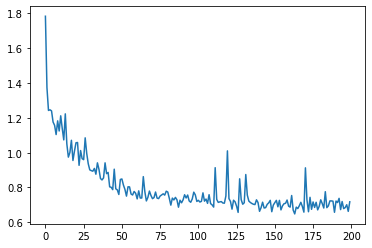

In [39]:
plt.plot(val_loss)

In [48]:
train, test = train_test_split(new_df , test_size=0.1)

train_mol = train['standardize_smiles'].map(lambda x : Chem.MolFromSmiles(x))
test_mol = test['standardize_smiles'].map(lambda x : Chem.MolFromSmiles(x))

test_rmse = []

train_loader, test_loader_final = prepare_dataloader(train_mol) ,prepare_dataloader(test_mol)

train_labels_final_dataset = TensorDataset(torch.tensor(train['measured log solubility in mols per litre'].to_numpy()).float())
train_labels_final_loader = DataLoader(train_labels_final_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_features_final_dataset = TensorDataset(torch.tensor(train.drop(columns=['measured log solubility in mols per litre', 'standardize_smiles']).to_numpy()).float())
train_features_final_loader = DataLoader(train_features_final_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_labels_final_dataset = TensorDataset(torch.tensor(test['measured log solubility in mols per litre'].to_numpy()).float())
test_labels_final_loader = DataLoader(test_labels_final_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_features_final_dataset = TensorDataset(torch.tensor(test.drop(columns=['measured log solubility in mols per litre', 'standardize_smiles']).to_numpy()).float())
test_features_final_loader = DataLoader(test_features_final_dataset, batch_size=BATCH_SIZE, shuffle=False)





neural_fp = NeuralFP(8, 200)
reg = MLP_Regressor(neural_fp, 8, 200, 300, 207).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(reg.parameters(), 
                      lr=0.001
                          )


reg, loss, val_loss, r2_loss, r2_val_loss = train_nn(reg, optimizer, criterion, 
                                                        train_loader, train_labels_final_loader, train_features_final_loader,
                                                        test_loader_final, test_labels_final_loader, test_features_final_loader)


34it [00:00, 215.50it/s]
4it [00:00, 237.38it/s]
34it [00:00, 206.54it/s]
0it [00:00, ?it/s]

Epoch 0 - Training rmse loss: 5.222965601726126
Epoch 0 - Training r2 loss: -2.671198234139559
Epoch 0 - val rmse loss: 2.294336382261119
Epoch 0 - val r2 loss: 0.04657628150635568
Epoch 1 - Training rmse loss: 1.728464905643486
Epoch 1 - Training r2 loss: -0.2044749229232691


4it [00:00, 209.07it/s]
34it [00:00, 217.31it/s]
4it [00:00, 246.73it/s]
0it [00:00, ?it/s]

Epoch 1 - val rmse loss: 1.559423087378149
Epoch 1 - val r2 loss: 0.03997230941064622
Epoch 2 - Training rmse loss: 1.446799127748297
Epoch 2 - Training r2 loss: 0.0674000866250579
Epoch 2 - val rmse loss: 1.5507485989224976
Epoch 2 - val r2 loss: -0.10495624102356715


34it [00:00, 211.58it/s]
4it [00:00, 199.70it/s]
34it [00:00, 217.89it/s]
0it [00:00, ?it/s]

Epoch 3 - Training rmse loss: 1.3665463369057154
Epoch 3 - Training r2 loss: 0.18665471915598766
Epoch 3 - val rmse loss: 1.4181794306924898
Epoch 3 - val r2 loss: 0.2699683402662353
Epoch 4 - Training rmse loss: 1.2928880829406155
Epoch 4 - Training r2 loss: 0.3549461132178179


4it [00:00, 211.17it/s]
34it [00:00, 201.49it/s]
4it [00:00, 258.58it/s]
0it [00:00, ?it/s]

Epoch 4 - val rmse loss: 1.340476273243108
Epoch 4 - val r2 loss: 0.3733718041117435
Epoch 5 - Training rmse loss: 1.2595256348951887
Epoch 5 - Training r2 loss: 0.40175511454896073
Epoch 5 - val rmse loss: 1.30888673150076
Epoch 5 - val r2 loss: 0.37741815506208076


34it [00:00, 207.60it/s]
4it [00:00, 236.01it/s]
34it [00:00, 210.63it/s]
0it [00:00, ?it/s]

Epoch 6 - Training rmse loss: 1.2420098427856043
Epoch 6 - Training r2 loss: 0.44465419839402853
Epoch 6 - val rmse loss: 1.24415767424443
Epoch 6 - val r2 loss: 0.4886321201520599
Epoch 7 - Training rmse loss: 1.2068176160355886
Epoch 7 - Training r2 loss: 0.46724012345121035


4it [00:00, 226.20it/s]
34it [00:00, 216.66it/s]
4it [00:00, 239.85it/s]
0it [00:00, ?it/s]

Epoch 7 - val rmse loss: 1.2727115527759787
Epoch 7 - val r2 loss: 0.5190960231353812
Epoch 8 - Training rmse loss: 1.214740007017554
Epoch 8 - Training r2 loss: 0.49883042298687186
Epoch 8 - val rmse loss: 1.2917611397782824
Epoch 8 - val r2 loss: 0.4217201828138716


34it [00:00, 206.18it/s]
4it [00:00, 222.88it/s]
34it [00:00, 206.20it/s]
0it [00:00, ?it/s]

Epoch 9 - Training rmse loss: 1.2270377686531324
Epoch 9 - Training r2 loss: 0.4594741084380007
Epoch 9 - val rmse loss: 1.2955309498441956
Epoch 9 - val r2 loss: 0.4165297960207086
Epoch 10 - Training rmse loss: 1.2285887317315407
Epoch 10 - Training r2 loss: 0.4655059069613375


4it [00:00, 205.96it/s]
34it [00:00, 211.59it/s]
4it [00:00, 250.83it/s]
0it [00:00, ?it/s]

Epoch 10 - val rmse loss: 1.344041964505555
Epoch 10 - val r2 loss: 0.29540548341483586
Epoch 11 - Training rmse loss: 1.170394917956929
Epoch 11 - Training r2 loss: 0.5054665858024532
Epoch 11 - val rmse loss: 1.3371764065665006
Epoch 11 - val r2 loss: 0.289349430162207


34it [00:00, 217.33it/s]
4it [00:00, 251.85it/s]
34it [00:00, 216.77it/s]
4it [00:00, 237.63it/s]
0it [00:00, ?it/s]

Epoch 12 - Training rmse loss: 1.1670542372577613
Epoch 12 - Training r2 loss: 0.5318267027381838
Epoch 12 - val rmse loss: 1.1491628289636973
Epoch 12 - val r2 loss: 0.5365141124873007
Epoch 13 - Training rmse loss: 1.1478400773512154
Epoch 13 - Training r2 loss: 0.5165087530379973
Epoch 13 - val rmse loss: 1.1430224475775612
Epoch 13 - val r2 loss: 0.5375210152456371


34it [00:00, 212.10it/s]
4it [00:00, 247.15it/s]
34it [00:00, 216.86it/s]
4it [00:00, 237.45it/s]

Epoch 14 - Training rmse loss: 1.1182385603797589
Epoch 14 - Training r2 loss: 0.5633228171681788
Epoch 14 - val rmse loss: 1.1315365544304676
Epoch 14 - val r2 loss: 0.5484348494625302
Epoch 15 - Training rmse loss: 1.1224106440611035
Epoch 15 - Training r2 loss: 0.5580541575770436



34it [00:00, 209.77it/s]
4it [00:00, 245.94it/s]
34it [00:00, 220.99it/s]
4it [00:00, 255.04it/s]
0it [00:00, ?it/s]

Epoch 15 - val rmse loss: 1.0953290508178903
Epoch 15 - val r2 loss: 0.5969235029580002
Epoch 16 - Training rmse loss: 1.103085343344628
Epoch 16 - Training r2 loss: 0.5493292162732428
Epoch 16 - val rmse loss: 1.1151403798378052
Epoch 16 - val r2 loss: 0.5693850303732221
Epoch 17 - Training rmse loss: 1.0665564309033286
Epoch 17 - Training r2 loss: 0.6022288633740637
Epoch 17 - val rmse loss: 1.0732643742997159
Epoch 17 - val r2 loss: 0.6238233125188528


34it [00:00, 213.77it/s]
4it [00:00, 248.30it/s]
34it [00:00, 215.94it/s]
4it [00:00, 248.28it/s]

Epoch 18 - Training rmse loss: 1.0529284483085146
Epoch 18 - Training r2 loss: 0.6058198722241254
Epoch 18 - val rmse loss: 1.1139709277190453
Epoch 18 - val r2 loss: 0.5789918458411741
Epoch 19 - Training rmse loss: 1.0827209492561565
Epoch 19 - Training r2 loss: 0.6024444216823143



34it [00:00, 218.36it/s]
4it [00:00, 266.97it/s]
34it [00:00, 213.49it/s]
0it [00:00, ?it/s]

Epoch 19 - val rmse loss: 1.0822235859167515
Epoch 19 - val r2 loss: 0.6116526899629127
Epoch 20 - Training rmse loss: 1.0945130034959656
Epoch 20 - Training r2 loss: 0.5645644797400655
Epoch 20 - val rmse loss: 1.0692167590193975
Epoch 20 - val r2 loss: 0.608078877882359
Epoch 21 - Training rmse loss: 1.0714389132269722
Epoch 21 - Training r2 loss: 0.5835500157966746


4it [00:00, 240.55it/s]
34it [00:00, 212.08it/s]
4it [00:00, 267.61it/s]
0it [00:00, ?it/s]

Epoch 21 - val rmse loss: 1.0864366303663004
Epoch 21 - val r2 loss: 0.5814026843313265
Epoch 22 - Training rmse loss: 1.0360750487975794
Epoch 22 - Training r2 loss: 0.6219122878953302
Epoch 22 - val rmse loss: 1.0045018192120982
Epoch 22 - val r2 loss: 0.6513493590679749


34it [00:00, 220.33it/s]
4it [00:00, 253.85it/s]
34it [00:00, 203.50it/s]
0it [00:00, ?it/s]

Epoch 23 - Training rmse loss: 1.0500066009348725
Epoch 23 - Training r2 loss: 0.6053704859251624
Epoch 23 - val rmse loss: 0.9673501098330091
Epoch 23 - val r2 loss: 0.6893756765514396
Epoch 24 - Training rmse loss: 1.0055552120215558
Epoch 24 - Training r2 loss: 0.6301740606462366


4it [00:00, 197.10it/s]
34it [00:00, 213.32it/s]
4it [00:00, 237.47it/s]
0it [00:00, ?it/s]

Epoch 24 - val rmse loss: 0.9734943333501523
Epoch 24 - val r2 loss: 0.6978897667253349
Epoch 25 - Training rmse loss: 1.005927621562085
Epoch 25 - Training r2 loss: 0.6418499329364868
Epoch 25 - val rmse loss: 0.9447748057926328
Epoch 25 - val r2 loss: 0.6780179958358841


34it [00:00, 213.96it/s]
4it [00:00, 265.90it/s]
34it [00:00, 209.03it/s]
0it [00:00, ?it/s]

Epoch 26 - Training rmse loss: 1.0232598943300353
Epoch 26 - Training r2 loss: 0.6165559740367027
Epoch 26 - val rmse loss: 0.96295114756448
Epoch 26 - val r2 loss: 0.684117751691741
Epoch 27 - Training rmse loss: 1.0151090269275862
Epoch 27 - Training r2 loss: 0.6261575413360374


4it [00:00, 219.24it/s]
34it [00:00, 223.10it/s]
4it [00:00, 243.90it/s]
0it [00:00, ?it/s]

Epoch 27 - val rmse loss: 0.9499880416644507
Epoch 27 - val r2 loss: 0.6856227478963139
Epoch 28 - Training rmse loss: 0.9809620664185472
Epoch 28 - Training r2 loss: 0.6656879490084112
Epoch 28 - val rmse loss: 1.00099972581812
Epoch 28 - val r2 loss: 0.6778070764478564


34it [00:00, 214.02it/s]
4it [00:00, 276.43it/s]
34it [00:00, 215.47it/s]
0it [00:00, ?it/s]

Epoch 29 - Training rmse loss: 0.9855174150395403
Epoch 29 - Training r2 loss: 0.6485074212981974
Epoch 29 - val rmse loss: 0.9941953782627804
Epoch 29 - val r2 loss: 0.6667790055060365
Epoch 30 - Training rmse loss: 0.9674934461761295
Epoch 30 - Training r2 loss: 0.6771777701322621


4it [00:00, 199.08it/s]
34it [00:00, 200.12it/s]
4it [00:00, 275.14it/s]
0it [00:00, ?it/s]

Epoch 30 - val rmse loss: 0.9639737998802181
Epoch 30 - val r2 loss: 0.6859359388896495
Epoch 31 - Training rmse loss: 0.9423947487877133
Epoch 31 - Training r2 loss: 0.6800009513443337
Epoch 31 - val rmse loss: 0.891498463614376
Epoch 31 - val r2 loss: 0.7388829994826296


34it [00:00, 205.23it/s]
4it [00:00, 274.95it/s]
34it [00:00, 221.12it/s]
4it [00:00, 243.75it/s]
0it [00:00, ?it/s]

Epoch 32 - Training rmse loss: 0.951125189313604
Epoch 32 - Training r2 loss: 0.6788518132328669
Epoch 32 - val rmse loss: 0.8687485056802535
Epoch 32 - val r2 loss: 0.757720004811864
Epoch 33 - Training rmse loss: 0.9609912846316508
Epoch 33 - Training r2 loss: 0.6856207485776009
Epoch 33 - val rmse loss: 0.9240145505269357
Epoch 33 - val r2 loss: 0.7081264435137423


34it [00:00, 214.81it/s]
4it [00:00, 243.51it/s]
34it [00:00, 217.10it/s]
4it [00:00, 265.26it/s]
0it [00:00, ?it/s]

Epoch 34 - Training rmse loss: 0.940323398915382
Epoch 34 - Training r2 loss: 0.6861880947143166
Epoch 34 - val rmse loss: 1.016144494929655
Epoch 34 - val r2 loss: 0.6470635066649117
Epoch 35 - Training rmse loss: 0.9331313463805874
Epoch 35 - Training r2 loss: 0.6986440782107924
Epoch 35 - val rmse loss: 0.940563956843139
Epoch 35 - val r2 loss: 0.7068268411299822


34it [00:00, 203.79it/s]
4it [00:00, 262.17it/s]
34it [00:00, 204.03it/s]
0it [00:00, ?it/s]

Epoch 36 - Training rmse loss: 0.9363076139694273
Epoch 36 - Training r2 loss: 0.7080160880384853
Epoch 36 - val rmse loss: 0.8784184437316322
Epoch 36 - val r2 loss: 0.7332249816347987
Epoch 37 - Training rmse loss: 0.9019558167127691
Epoch 37 - Training r2 loss: 0.7159784809832453


4it [00:00, 161.54it/s]
34it [00:00, 202.78it/s]
4it [00:00, 226.39it/s]
0it [00:00, ?it/s]

Epoch 37 - val rmse loss: 0.8181171696115508
Epoch 37 - val r2 loss: 0.7689536950956077
Epoch 38 - Training rmse loss: 0.9146935129425117
Epoch 38 - Training r2 loss: 0.7151790267744933
Epoch 38 - val rmse loss: 0.860324750952299
Epoch 38 - val r2 loss: 0.7636606865038253


34it [00:00, 214.71it/s]
4it [00:00, 262.76it/s]
34it [00:00, 202.70it/s]
0it [00:00, ?it/s]

Epoch 39 - Training rmse loss: 0.9379147780769359
Epoch 39 - Training r2 loss: 0.6976682975262245
Epoch 39 - val rmse loss: 0.8721427930077827
Epoch 39 - val r2 loss: 0.7296900427208537
Epoch 40 - Training rmse loss: 0.9264370083956573
Epoch 40 - Training r2 loss: 0.7052083687114712


4it [00:00, 213.82it/s]
34it [00:00, 215.59it/s]
4it [00:00, 282.56it/s]
0it [00:00, ?it/s]

Epoch 40 - val rmse loss: 0.8789737590717998
Epoch 40 - val r2 loss: 0.7390209375255066
Epoch 41 - Training rmse loss: 0.8932665226272817
Epoch 41 - Training r2 loss: 0.7301270392692727
Epoch 41 - val rmse loss: 0.8485125422441478
Epoch 41 - val r2 loss: 0.7676264074967154


34it [00:00, 193.30it/s]
4it [00:00, 223.42it/s]
34it [00:00, 203.58it/s]
0it [00:00, ?it/s]

Epoch 42 - Training rmse loss: 0.9156762746512428
Epoch 42 - Training r2 loss: 0.7142338017804458
Epoch 42 - val rmse loss: 0.8493617519078103
Epoch 42 - val r2 loss: 0.7732336286205304
Epoch 43 - Training rmse loss: 0.9296112071670256
Epoch 43 - Training r2 loss: 0.7026065493815571


4it [00:00, 213.18it/s]
34it [00:00, 210.77it/s]
4it [00:00, 268.35it/s]
0it [00:00, ?it/s]

Epoch 43 - val rmse loss: 0.8119565264857153
Epoch 43 - val r2 loss: 0.7878609413432778
Epoch 44 - Training rmse loss: 0.9122585621969864
Epoch 44 - Training r2 loss: 0.7180718133590771
Epoch 44 - val rmse loss: 0.8603303887211426
Epoch 44 - val r2 loss: 0.7393459852256042


34it [00:00, 211.55it/s]
4it [00:00, 178.36it/s]
34it [00:00, 212.82it/s]
0it [00:00, ?it/s]

Epoch 45 - Training rmse loss: 0.8939741557133158
Epoch 45 - Training r2 loss: 0.7293035073380808
Epoch 45 - val rmse loss: 0.8336130070271962
Epoch 45 - val r2 loss: 0.7960713944656955
Epoch 46 - Training rmse loss: 0.8758868618640541
Epoch 46 - Training r2 loss: 0.731277862110327


4it [00:00, 196.00it/s]
34it [00:00, 212.53it/s]
4it [00:00, 262.54it/s]
0it [00:00, ?it/s]

Epoch 46 - val rmse loss: 0.8626304607271029
Epoch 46 - val r2 loss: 0.7512684208887461
Epoch 47 - Training rmse loss: 0.9138599816776031
Epoch 47 - Training r2 loss: 0.7216616066856112
Epoch 47 - val rmse loss: 0.8356616376093527
Epoch 47 - val r2 loss: 0.7834844480587778


34it [00:00, 204.84it/s]
4it [00:00, 216.17it/s]
34it [00:00, 211.64it/s]
0it [00:00, ?it/s]

Epoch 48 - Training rmse loss: 0.9143626855072595
Epoch 48 - Training r2 loss: 0.7201416005352083
Epoch 48 - val rmse loss: 0.7586803824853493
Epoch 48 - val r2 loss: 0.8166401405892723
Epoch 49 - Training rmse loss: 0.8618199604395302
Epoch 49 - Training r2 loss: 0.7489620724027242


4it [00:00, 227.74it/s]
34it [00:00, 214.45it/s]
4it [00:00, 253.03it/s]
0it [00:00, ?it/s]

Epoch 49 - val rmse loss: 0.774635720971195
Epoch 49 - val r2 loss: 0.8165028111670719
Epoch 50 - Training rmse loss: 0.8994337938459833
Epoch 50 - Training r2 loss: 0.7339900134440781
Epoch 50 - val rmse loss: 0.8263379284072591
Epoch 50 - val r2 loss: 0.7863210681794657


34it [00:00, 213.38it/s]
4it [00:00, 264.95it/s]
34it [00:00, 211.14it/s]
0it [00:00, ?it/s]

Epoch 51 - Training rmse loss: 0.8636098200370489
Epoch 51 - Training r2 loss: 0.7429361366665934
Epoch 51 - val rmse loss: 0.7600257055741395
Epoch 51 - val r2 loss: 0.8200353808204408
Epoch 52 - Training rmse loss: 0.8702974103223159
Epoch 52 - Training r2 loss: 0.7508806864879055


4it [00:00, 210.19it/s]
34it [00:00, 214.03it/s]
4it [00:00, 209.72it/s]
0it [00:00, ?it/s]

Epoch 52 - val rmse loss: 0.8146588914045451
Epoch 52 - val r2 loss: 0.783309736827619
Epoch 53 - Training rmse loss: 0.8559382920373874
Epoch 53 - Training r2 loss: 0.7482458364019938
Epoch 53 - val rmse loss: 0.7618106004160968
Epoch 53 - val r2 loss: 0.82717674448994


34it [00:00, 204.17it/s]
4it [00:00, 231.05it/s]
34it [00:00, 214.87it/s]
4it [00:00, 248.68it/s]

Epoch 54 - Training rmse loss: 0.856847705503736
Epoch 54 - Training r2 loss: 0.7613054931103145
Epoch 54 - val rmse loss: 0.8284319452727651
Epoch 54 - val r2 loss: 0.7909173554375631
Epoch 55 - Training rmse loss: 0.8418707312131652
Epoch 55 - Training r2 loss: 0.7686192615715621



34it [00:00, 202.44it/s]
4it [00:00, 238.19it/s]
0it [00:00, ?it/s]

Epoch 55 - val rmse loss: 0.7799049624596627
Epoch 55 - val r2 loss: 0.8201469881143961
Epoch 56 - Training rmse loss: 0.8320222668187844
Epoch 56 - Training r2 loss: 0.7763897819405533
Epoch 56 - val rmse loss: 0.7714833802808312
Epoch 56 - val r2 loss: 0.8167501870482036


34it [00:00, 203.18it/s]
4it [00:00, 301.84it/s]
34it [00:00, 211.38it/s]
0it [00:00, ?it/s]

Epoch 57 - Training rmse loss: 0.8541088125132817
Epoch 57 - Training r2 loss: 0.7617790539783736
Epoch 57 - val rmse loss: 0.8403983214684554
Epoch 57 - val r2 loss: 0.7657032594805121
Epoch 58 - Training rmse loss: 0.8644930579278876
Epoch 58 - Training r2 loss: 0.7536621711745034


4it [00:00, 201.20it/s]
34it [00:00, 208.61it/s]
4it [00:00, 254.59it/s]
0it [00:00, ?it/s]

Epoch 58 - val rmse loss: 0.7847883681651698
Epoch 58 - val r2 loss: 0.8227604784341218
Epoch 59 - Training rmse loss: 0.8687605274432718
Epoch 59 - Training r2 loss: 0.7533601445465932
Epoch 59 - val rmse loss: 0.7711704871074657
Epoch 59 - val r2 loss: 0.8153819590629071


34it [00:00, 202.04it/s]
4it [00:00, 277.41it/s]
34it [00:00, 198.72it/s]
0it [00:00, ?it/s]

Epoch 60 - Training rmse loss: 0.8420973754631763
Epoch 60 - Training r2 loss: 0.7721625263799948
Epoch 60 - val rmse loss: 0.775873749549587
Epoch 60 - val r2 loss: 0.8162478126628321
Epoch 61 - Training rmse loss: 0.8410889814694176
Epoch 61 - Training r2 loss: 0.7741151413629107


4it [00:00, 233.03it/s]
34it [00:00, 211.97it/s]
4it [00:00, 239.31it/s]
0it [00:00, ?it/s]

Epoch 61 - val rmse loss: 0.7582021380127698
Epoch 61 - val r2 loss: 0.8329901456056559
Epoch 62 - Training rmse loss: 0.8333912358900827
Epoch 62 - Training r2 loss: 0.7725850671161761
Epoch 62 - val rmse loss: 0.7792171255813413
Epoch 62 - val r2 loss: 0.819088987858097


34it [00:00, 196.38it/s]
4it [00:00, 230.55it/s]
34it [00:00, 207.48it/s]
0it [00:00, ?it/s]

Epoch 63 - Training rmse loss: 0.826983928978515
Epoch 63 - Training r2 loss: 0.7819490573511896
Epoch 63 - val rmse loss: 0.7282871982517334
Epoch 63 - val r2 loss: 0.8319599445024487
Epoch 64 - Training rmse loss: 0.8476065127060531
Epoch 64 - Training r2 loss: 0.7664934576506244


4it [00:00, 210.04it/s]
34it [00:00, 209.69it/s]
4it [00:00, 310.26it/s]
0it [00:00, ?it/s]

Epoch 64 - val rmse loss: 0.751770155803609
Epoch 64 - val r2 loss: 0.843224923074211
Epoch 65 - Training rmse loss: 0.8137239131708317
Epoch 65 - Training r2 loss: 0.7863459422496637
Epoch 65 - val rmse loss: 0.7988920489339209
Epoch 65 - val r2 loss: 0.7982642067049148


34it [00:00, 209.00it/s]
4it [00:00, 264.11it/s]
34it [00:00, 217.26it/s]
4it [00:00, 219.86it/s]

Epoch 66 - Training rmse loss: 0.8480283758472548
Epoch 66 - Training r2 loss: 0.768079595974209
Epoch 66 - val rmse loss: 0.7599189034913021
Epoch 66 - val r2 loss: 0.8293730949461299
Epoch 67 - Training rmse loss: 0.858769137963534
Epoch 67 - Training r2 loss: 0.7687197868734694
Epoch 67 - val rmse loss: 0.7777866750210164
Epoch 67 - val r2 loss: 0.8346156191333322



34it [00:00, 205.58it/s]
4it [00:00, 244.90it/s]
34it [00:00, 193.35it/s]
0it [00:00, ?it/s]

Epoch 68 - Training rmse loss: 0.8250360294666711
Epoch 68 - Training r2 loss: 0.7856898381728198
Epoch 68 - val rmse loss: 0.7569387649085855
Epoch 68 - val r2 loss: 0.8379529576569558
Epoch 69 - Training rmse loss: 0.8050032730814757
Epoch 69 - Training r2 loss: 0.7955150956072422


4it [00:00, 174.07it/s]
34it [00:00, 209.24it/s]
4it [00:00, 235.98it/s]
0it [00:00, ?it/s]

Epoch 69 - val rmse loss: 0.7389012311997702
Epoch 69 - val r2 loss: 0.8371829462777776
Epoch 70 - Training rmse loss: 0.845638706452272
Epoch 70 - Training r2 loss: 0.7755476079747373
Epoch 70 - val rmse loss: 0.9659424213788813
Epoch 70 - val r2 loss: 0.7214068299857952


34it [00:00, 205.00it/s]
4it [00:00, 241.56it/s]
34it [00:00, 204.86it/s]
0it [00:00, ?it/s]

Epoch 71 - Training rmse loss: 0.8227627557141097
Epoch 71 - Training r2 loss: 0.7849483863886979
Epoch 71 - val rmse loss: 0.828180396728304
Epoch 71 - val r2 loss: 0.8161530290847248
Epoch 72 - Training rmse loss: 0.8227927205616279
Epoch 72 - Training r2 loss: 0.7830139644548997


4it [00:00, 207.96it/s]
34it [00:00, 213.71it/s]
4it [00:00, 224.50it/s]
0it [00:00, ?it/s]

Epoch 72 - val rmse loss: 0.7909461567833401
Epoch 72 - val r2 loss: 0.8205152074341954
Epoch 73 - Training rmse loss: 0.8202939477526963
Epoch 73 - Training r2 loss: 0.7802217042120325
Epoch 73 - val rmse loss: 0.7721829450666703
Epoch 73 - val r2 loss: 0.8415061145253541


34it [00:00, 195.86it/s]
4it [00:00, 231.58it/s]
34it [00:00, 209.99it/s]
0it [00:00, ?it/s]

Epoch 74 - Training rmse loss: 0.8329608273420088
Epoch 74 - Training r2 loss: 0.7832404891939796
Epoch 74 - val rmse loss: 1.0651955701350733
Epoch 74 - val r2 loss: 0.5983473901757406
Epoch 75 - Training rmse loss: 0.8957278936598042
Epoch 75 - Training r2 loss: 0.7367365339928643


4it [00:00, 216.50it/s]
34it [00:00, 216.50it/s]
4it [00:00, 264.19it/s]
0it [00:00, ?it/s]

Epoch 75 - val rmse loss: 0.7987602736703365
Epoch 75 - val r2 loss: 0.8210467826155936
Epoch 76 - Training rmse loss: 0.7985693760644571
Epoch 76 - Training r2 loss: 0.7936339922179785
Epoch 76 - val rmse loss: 0.818818957941078
Epoch 76 - val r2 loss: 0.7920929721079601


34it [00:00, 200.66it/s]
4it [00:00, 205.40it/s]
19it [00:00, 189.80it/s]

Epoch 77 - Training rmse loss: 0.7934828230174282
Epoch 77 - Training r2 loss: 0.7989651441364024
Epoch 77 - val rmse loss: 0.7659267881742424
Epoch 77 - val r2 loss: 0.8343240679976214


34it [00:00, 192.03it/s]
4it [00:00, 254.38it/s]
34it [00:00, 215.69it/s]
0it [00:00, ?it/s]

Epoch 78 - Training rmse loss: 0.7907000170393721
Epoch 78 - Training r2 loss: 0.8039002121050283
Epoch 78 - val rmse loss: 0.7486305947374177
Epoch 78 - val r2 loss: 0.8392091399785438
Epoch 79 - Training rmse loss: 0.8007262595518078
Epoch 79 - Training r2 loss: 0.8014496843262109


4it [00:00, 194.31it/s]
34it [00:00, 198.11it/s]
4it [00:00, 245.68it/s]
0it [00:00, ?it/s]

Epoch 79 - val rmse loss: 0.7189565755619421
Epoch 79 - val r2 loss: 0.8429937348336292
Epoch 80 - Training rmse loss: 0.828131827581375
Epoch 80 - Training r2 loss: 0.7833478513791245
Epoch 80 - val rmse loss: 0.7351473591882063
Epoch 80 - val r2 loss: 0.848358225830355


34it [00:00, 189.22it/s]
4it [00:00, 239.02it/s]
34it [00:00, 201.03it/s]
0it [00:00, ?it/s]

Epoch 81 - Training rmse loss: 0.8370478984736697
Epoch 81 - Training r2 loss: 0.7826488368958701
Epoch 81 - val rmse loss: 0.8000903056256482
Epoch 81 - val r2 loss: 0.8193834057783533
Epoch 82 - Training rmse loss: 0.7890348343506517
Epoch 82 - Training r2 loss: 0.8011171188686542


4it [00:00, 200.64it/s]
34it [00:00, 208.46it/s]
4it [00:00, 232.68it/s]
0it [00:00, ?it/s]

Epoch 82 - val rmse loss: 0.7604055137121208
Epoch 82 - val r2 loss: 0.8379757749568428
Epoch 83 - Training rmse loss: 0.802354600215651
Epoch 83 - Training r2 loss: 0.8002098304423969
Epoch 83 - val rmse loss: 0.7400761639055516
Epoch 83 - val r2 loss: 0.8461065118607172


34it [00:00, 194.95it/s]
4it [00:00, 302.26it/s]
34it [00:00, 211.17it/s]
0it [00:00, ?it/s]

Epoch 84 - Training rmse loss: 0.7994825307111736
Epoch 84 - Training r2 loss: 0.7976369156006098
Epoch 84 - val rmse loss: 0.6992739277384827
Epoch 84 - val r2 loss: 0.8637565842714368
Epoch 85 - Training rmse loss: 0.7900826272884955
Epoch 85 - Training r2 loss: 0.8050402280912768


4it [00:00, 236.72it/s]
34it [00:00, 219.10it/s]
4it [00:00, 213.91it/s]
0it [00:00, ?it/s]

Epoch 85 - val rmse loss: 0.7273584026331728
Epoch 85 - val r2 loss: 0.848338772290737
Epoch 86 - Training rmse loss: 0.7874648828539232
Epoch 86 - Training r2 loss: 0.8073231904449323
Epoch 86 - val rmse loss: 0.706991716196409
Epoch 86 - val r2 loss: 0.8567303255295468


34it [00:00, 199.05it/s]
4it [00:00, 314.10it/s]
34it [00:00, 210.80it/s]
0it [00:00, ?it/s]

Epoch 87 - Training rmse loss: 0.8665375555758158
Epoch 87 - Training r2 loss: 0.7672629590160599
Epoch 87 - val rmse loss: 1.0989596003785747
Epoch 87 - val r2 loss: 0.5263045555448219
Epoch 88 - Training rmse loss: 0.8799055888144506
Epoch 88 - Training r2 loss: 0.7581986337317715


4it [00:00, 202.64it/s]
34it [00:00, 205.31it/s]
4it [00:00, 214.09it/s]
0it [00:00, ?it/s]

Epoch 88 - val rmse loss: 1.112987292112651
Epoch 88 - val r2 loss: 0.5354100836957524
Epoch 89 - Training rmse loss: 0.8555631746840554
Epoch 89 - Training r2 loss: 0.7693602157381849
Epoch 89 - val rmse loss: 0.8180535594035738
Epoch 89 - val r2 loss: 0.8302305722382171


34it [00:00, 200.72it/s]
4it [00:00, 284.23it/s]
34it [00:00, 201.24it/s]
0it [00:00, ?it/s]

Epoch 90 - Training rmse loss: 0.8145147115480926
Epoch 90 - Training r2 loss: 0.7971116414647845
Epoch 90 - val rmse loss: 0.7292148772832233
Epoch 90 - val r2 loss: 0.8393055424464604
Epoch 91 - Training rmse loss: 0.7939409631646289
Epoch 91 - Training r2 loss: 0.8014888267997318


4it [00:00, 184.75it/s]
34it [00:00, 214.89it/s]
4it [00:00, 300.97it/s]
0it [00:00, ?it/s]

Epoch 91 - val rmse loss: 0.7252425129368212
Epoch 91 - val r2 loss: 0.8508888827392572
Epoch 92 - Training rmse loss: 0.7798837585843602
Epoch 92 - Training r2 loss: 0.8123198571057217
Epoch 92 - val rmse loss: 0.755989265617035
Epoch 92 - val r2 loss: 0.8462436936392734


34it [00:00, 192.70it/s]
4it [00:00, 261.97it/s]
34it [00:00, 203.71it/s]
0it [00:00, ?it/s]

Epoch 93 - Training rmse loss: 0.7761664731964127
Epoch 93 - Training r2 loss: 0.8122004501444913
Epoch 93 - val rmse loss: 0.7453847982020744
Epoch 93 - val r2 loss: 0.8444312329354637
Epoch 94 - Training rmse loss: 0.7531787372814266
Epoch 94 - Training r2 loss: 0.8241358804414678


4it [00:00, 220.37it/s]
34it [00:00, 216.87it/s]
4it [00:00, 308.53it/s]
0it [00:00, ?it/s]

Epoch 94 - val rmse loss: 0.7491414053078738
Epoch 94 - val r2 loss: 0.8338570811854316
Epoch 95 - Training rmse loss: 0.7884953748601574
Epoch 95 - Training r2 loss: 0.8091180788429018
Epoch 95 - val rmse loss: 0.7367441990118825
Epoch 95 - val r2 loss: 0.8476119501890887


34it [00:00, 201.41it/s]
4it [00:00, 276.84it/s]
34it [00:00, 219.43it/s]
4it [00:00, 288.76it/s]


Epoch 96 - Training rmse loss: 0.8676485628589714
Epoch 96 - Training r2 loss: 0.7522900561119034
Epoch 96 - val rmse loss: 0.7994273347030133
Epoch 96 - val r2 loss: 0.8054299576064671
Epoch 97 - Training rmse loss: 0.7974826042860336
Epoch 97 - Training r2 loss: 0.8047313032215214
Epoch 97 - val rmse loss: 0.9650959503817733
Epoch 97 - val r2 loss: 0.6797628510246518


34it [00:00, 218.83it/s]
4it [00:00, 260.12it/s]
34it [00:00, 197.16it/s]
0it [00:00, ?it/s]

Epoch 98 - Training rmse loss: 0.7915499653340571
Epoch 98 - Training r2 loss: 0.8009685228646464
Epoch 98 - val rmse loss: 0.7166526867691395
Epoch 98 - val r2 loss: 0.8538736250011094
Epoch 99 - Training rmse loss: 0.7757305779751087
Epoch 99 - Training r2 loss: 0.8161074597068834


4it [00:00, 220.23it/s]
34it [00:00, 219.70it/s]
4it [00:00, 260.48it/s]
0it [00:00, ?it/s]

Epoch 99 - val rmse loss: 0.7592547545185262
Epoch 99 - val r2 loss: 0.8425742242862632
Epoch 100 - Training rmse loss: 0.7651066542379167
Epoch 100 - Training r2 loss: 0.8183839371378708
Epoch 100 - val rmse loss: 0.7240747705769077
Epoch 100 - val r2 loss: 0.850452250698464


34it [00:00, 206.08it/s]
4it [00:00, 278.13it/s]
34it [00:00, 203.42it/s]
0it [00:00, ?it/s]

Epoch 101 - Training rmse loss: 0.7549221512481149
Epoch 101 - Training r2 loss: 0.8232721016973236
Epoch 101 - val rmse loss: 0.6946414377365783
Epoch 101 - val r2 loss: 0.8530667814905256
Epoch 102 - Training rmse loss: 0.7524193346473603
Epoch 102 - Training r2 loss: 0.8295125277560578


4it [00:00, 178.52it/s]
34it [00:00, 211.78it/s]
4it [00:00, 270.18it/s]
0it [00:00, ?it/s]

Epoch 102 - val rmse loss: 0.7344980846903312
Epoch 102 - val r2 loss: 0.8498816255602152
Epoch 103 - Training rmse loss: 0.7517986182585017
Epoch 103 - Training r2 loss: 0.8253698942240992
Epoch 103 - val rmse loss: 0.7800513465881095
Epoch 103 - val r2 loss: 0.820735979109044


34it [00:00, 198.97it/s]
4it [00:00, 262.50it/s]
34it [00:00, 210.67it/s]
0it [00:00, ?it/s]

Epoch 104 - Training rmse loss: 0.7673240084530748
Epoch 104 - Training r2 loss: 0.8208599845170726
Epoch 104 - val rmse loss: 1.0507544829635778
Epoch 104 - val r2 loss: 0.6110421639938685
Epoch 105 - Training rmse loss: 0.7903796235617805
Epoch 105 - Training r2 loss: 0.8100691998890341


4it [00:00, 219.44it/s]
34it [00:00, 214.62it/s]
4it [00:00, 229.80it/s]
0it [00:00, ?it/s]

Epoch 105 - val rmse loss: 0.7337366586492575
Epoch 105 - val r2 loss: 0.8564167702550479
Epoch 106 - Training rmse loss: 0.7474973573409082
Epoch 106 - Training r2 loss: 0.8308169517834083
Epoch 106 - val rmse loss: 0.7269891644890983
Epoch 106 - val r2 loss: 0.8440711198026802


34it [00:00, 193.30it/s]
4it [00:00, 278.99it/s]
34it [00:00, 206.64it/s]
0it [00:00, ?it/s]

Epoch 107 - Training rmse loss: 0.7204205259807165
Epoch 107 - Training r2 loss: 0.8391524945721036
Epoch 107 - val rmse loss: 0.695278102581131
Epoch 107 - val r2 loss: 0.8645848629087355
Epoch 108 - Training rmse loss: 0.762213760451497
Epoch 108 - Training r2 loss: 0.824868945054587


4it [00:00, 194.39it/s]
34it [00:00, 204.21it/s]
4it [00:00, 236.26it/s]
0it [00:00, ?it/s]

Epoch 108 - val rmse loss: 0.8502492314878926
Epoch 108 - val r2 loss: 0.7660101052810204
Epoch 109 - Training rmse loss: 0.7728736247667876
Epoch 109 - Training r2 loss: 0.8143567074941062
Epoch 109 - val rmse loss: 0.7348003880147528
Epoch 109 - val r2 loss: 0.8523273829401615


34it [00:00, 197.86it/s]
4it [00:00, 256.23it/s]
34it [00:00, 206.34it/s]
0it [00:00, ?it/s]

Epoch 110 - Training rmse loss: 0.7375229991186748
Epoch 110 - Training r2 loss: 0.8316857230533428
Epoch 110 - val rmse loss: 0.7393029122346453
Epoch 110 - val r2 loss: 0.8415902074200714
Epoch 111 - Training rmse loss: 0.7725548856217462
Epoch 111 - Training r2 loss: 0.8168093926804807


4it [00:00, 192.50it/s]
34it [00:00, 211.88it/s]
4it [00:00, 309.91it/s]
0it [00:00, ?it/s]

Epoch 111 - val rmse loss: 0.7351312750649226
Epoch 111 - val r2 loss: 0.8565151641507739
Epoch 112 - Training rmse loss: 0.7429848447712687
Epoch 112 - Training r2 loss: 0.8308036892720392
Epoch 112 - val rmse loss: 0.7070489006579121
Epoch 112 - val r2 loss: 0.8542626243787175


34it [00:00, 204.91it/s]
4it [00:00, 287.16it/s]
34it [00:00, 211.98it/s]
0it [00:00, ?it/s]

Epoch 113 - Training rmse loss: 0.7433017238462387
Epoch 113 - Training r2 loss: 0.8315555712372096
Epoch 113 - val rmse loss: 0.6913715396940036
Epoch 113 - val r2 loss: 0.8651407338645465
Epoch 114 - Training rmse loss: 0.7339348637831112
Epoch 114 - Training r2 loss: 0.8321131073936394


4it [00:00, 209.18it/s]
34it [00:00, 216.59it/s]
4it [00:00, 221.79it/s]
0it [00:00, ?it/s]

Epoch 114 - val rmse loss: 0.7320324790887275
Epoch 114 - val r2 loss: 0.8485930695834725
Epoch 115 - Training rmse loss: 0.757315186513854
Epoch 115 - Training r2 loss: 0.827640662029999
Epoch 115 - val rmse loss: 0.7815705833718668
Epoch 115 - val r2 loss: 0.807482183002371


34it [00:00, 204.11it/s]
4it [00:00, 228.77it/s]
34it [00:00, 219.03it/s]
0it [00:00, ?it/s]

Epoch 116 - Training rmse loss: 0.7870635911763606
Epoch 116 - Training r2 loss: 0.8175279005757625
Epoch 116 - val rmse loss: 1.0232209711847902
Epoch 116 - val r2 loss: 0.6122362734654432
Epoch 117 - Training rmse loss: 0.7922414192583104
Epoch 117 - Training r2 loss: 0.8010346491826612


4it [00:00, 218.46it/s]
34it [00:00, 200.27it/s]
4it [00:00, 242.08it/s]


Epoch 117 - val rmse loss: 0.7424754838877746
Epoch 117 - val r2 loss: 0.8632978786466536
Epoch 118 - Training rmse loss: 0.7511624161925616
Epoch 118 - Training r2 loss: 0.8281920001694265
Epoch 118 - val rmse loss: 0.7353957822759265
Epoch 118 - val r2 loss: 0.8502397912149962


34it [00:00, 215.45it/s]
4it [00:00, 257.51it/s]
34it [00:00, 213.69it/s]
0it [00:00, ?it/s]

Epoch 119 - Training rmse loss: 0.7638600477569758
Epoch 119 - Training r2 loss: 0.8206670735858245
Epoch 119 - val rmse loss: 0.6906867351384494
Epoch 119 - val r2 loss: 0.8687349232456621
Epoch 120 - Training rmse loss: 0.7340382703956353
Epoch 120 - Training r2 loss: 0.8352376696168796


4it [00:00, 186.24it/s]
34it [00:00, 219.69it/s]
4it [00:00, 263.78it/s]
0it [00:00, ?it/s]

Epoch 120 - val rmse loss: 0.7434963030046594
Epoch 120 - val r2 loss: 0.8391293382688163
Epoch 121 - Training rmse loss: 0.7413480774150558
Epoch 121 - Training r2 loss: 0.8357775505284671
Epoch 121 - val rmse loss: 0.7883835789449746
Epoch 121 - val r2 loss: 0.8111325955132831


34it [00:00, 200.69it/s]
4it [00:00, 313.21it/s]
34it [00:00, 217.64it/s]
0it [00:00, ?it/s]

Epoch 122 - Training rmse loss: 0.7392363563321147
Epoch 122 - Training r2 loss: 0.8362854479676882
Epoch 122 - val rmse loss: 0.7074333385884699
Epoch 122 - val r2 loss: 0.862912785551274
Epoch 123 - Training rmse loss: 0.7256012640796
Epoch 123 - Training r2 loss: 0.8415557336687955


4it [00:00, 231.50it/s]
34it [00:00, 215.60it/s]
4it [00:00, 213.06it/s]
0it [00:00, ?it/s]

Epoch 123 - val rmse loss: 0.6692260208910572
Epoch 123 - val r2 loss: 0.8726147557513761
Epoch 124 - Training rmse loss: 0.7053734426782939
Epoch 124 - Training r2 loss: 0.848384491376424
Epoch 124 - val rmse loss: 0.6658951826626381
Epoch 124 - val r2 loss: 0.8732957952178164


34it [00:00, 208.28it/s]
4it [00:00, 262.60it/s]
34it [00:00, 206.62it/s]
0it [00:00, ?it/s]

Epoch 125 - Training rmse loss: 0.7272452922831665
Epoch 125 - Training r2 loss: 0.8404398266537773
Epoch 125 - val rmse loss: 0.7356064394000562
Epoch 125 - val r2 loss: 0.846618304620094
Epoch 126 - Training rmse loss: 0.7526040729750664
Epoch 126 - Training r2 loss: 0.8317931133478008


4it [00:00, 224.32it/s]
34it [00:00, 213.83it/s]
4it [00:00, 245.42it/s]
0it [00:00, ?it/s]

Epoch 126 - val rmse loss: 0.913245692021829
Epoch 126 - val r2 loss: 0.7102773020514435
Epoch 127 - Training rmse loss: 0.7390604837013183
Epoch 127 - Training r2 loss: 0.8311752873075793
Epoch 127 - val rmse loss: 0.7165571170393414
Epoch 127 - val r2 loss: 0.8644175041191937


34it [00:00, 206.88it/s]
4it [00:00, 274.67it/s]
34it [00:00, 215.57it/s]
0it [00:00, ?it/s]

Epoch 128 - Training rmse loss: 0.7195951469844999
Epoch 128 - Training r2 loss: 0.8454595092103744
Epoch 128 - val rmse loss: 0.7790712206735351
Epoch 128 - val r2 loss: 0.8021274979322309
Epoch 129 - Training rmse loss: 0.7261754165411929
Epoch 129 - Training r2 loss: 0.8418731662674304


4it [00:00, 286.22it/s]
34it [00:00, 208.35it/s]
4it [00:00, 276.51it/s]
0it [00:00, ?it/s]

Epoch 129 - val rmse loss: 0.7133289400601205
Epoch 129 - val r2 loss: 0.8578970607055091
Epoch 130 - Training rmse loss: 0.7155454178347774
Epoch 130 - Training r2 loss: 0.844542836879022
Epoch 130 - val rmse loss: 0.7362498031771385
Epoch 130 - val r2 loss: 0.8573748835304128


34it [00:00, 208.03it/s]
4it [00:00, 272.84it/s]
34it [00:00, 211.44it/s]
0it [00:00, ?it/s]

Epoch 131 - Training rmse loss: 0.7288181174447736
Epoch 131 - Training r2 loss: 0.8392280261371661
Epoch 131 - val rmse loss: 0.7590544443971203
Epoch 131 - val r2 loss: 0.8479122958013314
Epoch 132 - Training rmse loss: 0.7550883865599465
Epoch 132 - Training r2 loss: 0.8234354253782687


4it [00:00, 167.76it/s]
34it [00:00, 200.47it/s]
4it [00:00, 282.69it/s]
0it [00:00, ?it/s]

Epoch 132 - val rmse loss: 0.7355087183264458
Epoch 132 - val r2 loss: 0.8331979516819783
Epoch 133 - Training rmse loss: 0.784146410259968
Epoch 133 - Training r2 loss: 0.8151589030403147
Epoch 133 - val rmse loss: 0.8101908579822021
Epoch 133 - val r2 loss: 0.8246018055141943


34it [00:00, 204.60it/s]
4it [00:00, 300.42it/s]
34it [00:00, 197.18it/s]
0it [00:00, ?it/s]

Epoch 134 - Training rmse loss: 0.7627481820211361
Epoch 134 - Training r2 loss: 0.8176577040964264
Epoch 134 - val rmse loss: 0.7884502443348781
Epoch 134 - val r2 loss: 0.8319301506287722
Epoch 135 - Training rmse loss: 0.7355648438028897
Epoch 135 - Training r2 loss: 0.8337779653364856


4it [00:00, 201.33it/s]
34it [00:00, 219.02it/s]
4it [00:00, 252.87it/s]
0it [00:00, ?it/s]

Epoch 135 - val rmse loss: 0.7213138432484868
Epoch 135 - val r2 loss: 0.862237418124956
Epoch 136 - Training rmse loss: 0.7388630766956726
Epoch 136 - Training r2 loss: 0.833460704574216
Epoch 136 - val rmse loss: 0.7106024717754178
Epoch 136 - val r2 loss: 0.8669985884161011


34it [00:00, 203.79it/s]
4it [00:00, 239.33it/s]
34it [00:00, 210.08it/s]
0it [00:00, ?it/s]

Epoch 137 - Training rmse loss: 0.7457970327890411
Epoch 137 - Training r2 loss: 0.8301305526644028
Epoch 137 - val rmse loss: 0.7706621254844362
Epoch 137 - val r2 loss: 0.8478273579237362
Epoch 138 - Training rmse loss: 0.7804716914757799
Epoch 138 - Training r2 loss: 0.8118645610048277


4it [00:00, 236.45it/s]
34it [00:00, 190.39it/s]
0it [00:00, ?it/s]

Epoch 138 - val rmse loss: 0.715983966683173
Epoch 138 - val r2 loss: 0.8614390416969646
Epoch 139 - Training rmse loss: 0.7803460366609133
Epoch 139 - Training r2 loss: 0.8128215860516269


4it [00:00, 259.89it/s]
34it [00:00, 199.58it/s]
4it [00:00, 265.92it/s]
0it [00:00, ?it/s]

Epoch 139 - val rmse loss: 0.7133278851341888
Epoch 139 - val r2 loss: 0.8520580571471182
Epoch 140 - Training rmse loss: 0.790940887754575
Epoch 140 - Training r2 loss: 0.8044675943601128
Epoch 140 - val rmse loss: 0.7438994539988443
Epoch 140 - val r2 loss: 0.8328870595456117


34it [00:00, 207.06it/s]
4it [00:00, 260.47it/s]
34it [00:00, 206.58it/s]
0it [00:00, ?it/s]

Epoch 141 - Training rmse loss: 0.7604107456273895
Epoch 141 - Training r2 loss: 0.8199130659562825
Epoch 141 - val rmse loss: 0.7566290689589318
Epoch 141 - val r2 loss: 0.8362807017390512
Epoch 142 - Training rmse loss: 0.71645262703471
Epoch 142 - Training r2 loss: 0.8425911181922784


4it [00:00, 218.97it/s]
34it [00:00, 207.10it/s]
4it [00:00, 267.39it/s]
0it [00:00, ?it/s]

Epoch 142 - val rmse loss: 0.7437951795495653
Epoch 142 - val r2 loss: 0.833171241198807
Epoch 143 - Training rmse loss: 0.7277989450075527
Epoch 143 - Training r2 loss: 0.8411808533139719
Epoch 143 - val rmse loss: 0.7028409172069879
Epoch 143 - val r2 loss: 0.8615039956765232


34it [00:00, 199.70it/s]
4it [00:00, 278.30it/s]
34it [00:00, 196.87it/s]
0it [00:00, ?it/s]

Epoch 144 - Training rmse loss: 0.7066099556222184
Epoch 144 - Training r2 loss: 0.847402698414842
Epoch 144 - val rmse loss: 0.6885085132300408
Epoch 144 - val r2 loss: 0.8666214197380501
Epoch 145 - Training rmse loss: 0.7183945052906048
Epoch 145 - Training r2 loss: 0.8424105514966024


4it [00:00, 179.36it/s]
34it [00:00, 208.29it/s]
4it [00:00, 280.63it/s]
0it [00:00, ?it/s]

Epoch 145 - val rmse loss: 0.7572542375884905
Epoch 145 - val r2 loss: 0.8390633878277645
Epoch 146 - Training rmse loss: 0.7165499924055743
Epoch 146 - Training r2 loss: 0.8439649517077034
Epoch 146 - val rmse loss: 0.7146479228962153
Epoch 146 - val r2 loss: 0.8565398186510222


34it [00:00, 203.17it/s]
4it [00:00, 274.78it/s]
20it [00:00, 197.48it/s]

Epoch 147 - Training rmse loss: 0.7253472962054766
Epoch 147 - Training r2 loss: 0.8396322700961816
Epoch 147 - val rmse loss: 0.6828301388188474
Epoch 147 - val r2 loss: 0.8690864927706375


34it [00:00, 193.33it/s]
4it [00:00, 216.13it/s]
34it [00:00, 214.22it/s]
0it [00:00, ?it/s]

Epoch 148 - Training rmse loss: 0.7418115576047334
Epoch 148 - Training r2 loss: 0.829845228669046
Epoch 148 - val rmse loss: 0.7280912313694032
Epoch 148 - val r2 loss: 0.8520682269382023
Epoch 149 - Training rmse loss: 0.7498799603715234
Epoch 149 - Training r2 loss: 0.8293697686288894


4it [00:00, 218.59it/s]
34it [00:00, 206.00it/s]
4it [00:00, 319.52it/s]
0it [00:00, ?it/s]

Epoch 149 - val rmse loss: 0.721092026151537
Epoch 149 - val r2 loss: 0.837940291725931
Epoch 150 - Training rmse loss: 0.7229036899134196
Epoch 150 - Training r2 loss: 0.8395301368096756
Epoch 150 - val rmse loss: 0.7440971852436691
Epoch 150 - val r2 loss: 0.8432656177775582


34it [00:00, 206.61it/s]
4it [00:00, 218.39it/s]
34it [00:00, 212.70it/s]
0it [00:00, ?it/s]

Epoch 151 - Training rmse loss: 0.7213922004059174
Epoch 151 - Training r2 loss: 0.8407456136818179
Epoch 151 - val rmse loss: 0.6748750321507822
Epoch 151 - val r2 loss: 0.8732268232009994
Epoch 152 - Training rmse loss: 0.7151323953949785
Epoch 152 - Training r2 loss: 0.8444071324415112


4it [00:00, 187.24it/s]
34it [00:00, 203.47it/s]
4it [00:00, 264.73it/s]


Epoch 152 - val rmse loss: 0.7190900443967445
Epoch 152 - val r2 loss: 0.8521153366821673
Epoch 153 - Training rmse loss: 0.7118668255432429
Epoch 153 - Training r2 loss: 0.8498391520787864
Epoch 153 - val rmse loss: 0.7470067165457718
Epoch 153 - val r2 loss: 0.8264154455323491


34it [00:00, 210.46it/s]
4it [00:00, 188.65it/s]
34it [00:00, 215.66it/s]
0it [00:00, ?it/s]

Epoch 154 - Training rmse loss: 0.7082357708948596
Epoch 154 - Training r2 loss: 0.848142658245151
Epoch 154 - val rmse loss: 0.699633017416853
Epoch 154 - val r2 loss: 0.8655794069800604
Epoch 155 - Training rmse loss: 0.7383284454267698
Epoch 155 - Training r2 loss: 0.8340560717394085


4it [00:00, 164.66it/s]
34it [00:00, 211.38it/s]
4it [00:00, 265.66it/s]
0it [00:00, ?it/s]

Epoch 155 - val rmse loss: 0.672577629191087
Epoch 155 - val r2 loss: 0.8639983814465728
Epoch 156 - Training rmse loss: 0.7052938781696327
Epoch 156 - Training r2 loss: 0.8504855045520455
Epoch 156 - val rmse loss: 0.7336642701659982
Epoch 156 - val r2 loss: 0.8442832464021858


34it [00:00, 210.67it/s]
4it [00:00, 237.64it/s]
34it [00:00, 207.26it/s]
0it [00:00, ?it/s]

Epoch 157 - Training rmse loss: 0.7016495732702311
Epoch 157 - Training r2 loss: 0.8512151840056561
Epoch 157 - val rmse loss: 0.7077330588924265
Epoch 157 - val r2 loss: 0.8621921181828336
Epoch 158 - Training rmse loss: 0.681512891077859
Epoch 158 - Training r2 loss: 0.8631219312704538


4it [00:00, 180.51it/s]
34it [00:00, 214.39it/s]
4it [00:00, 278.42it/s]
0it [00:00, ?it/s]

Epoch 158 - val rmse loss: 0.693494912453055
Epoch 158 - val r2 loss: 0.866975728908037
Epoch 159 - Training rmse loss: 0.6854386932339089
Epoch 159 - Training r2 loss: 0.8618960001344486
Epoch 159 - val rmse loss: 0.6826876548009773
Epoch 159 - val r2 loss: 0.8731561899821365


34it [00:00, 197.02it/s]
4it [00:00, 275.23it/s]
34it [00:00, 202.52it/s]
0it [00:00, ?it/s]

Epoch 160 - Training rmse loss: 0.7111310091369749
Epoch 160 - Training r2 loss: 0.8503456544707512
Epoch 160 - val rmse loss: 0.6990804748628671
Epoch 160 - val r2 loss: 0.856063626183027
Epoch 161 - Training rmse loss: 0.6948193441960125
Epoch 161 - Training r2 loss: 0.8550076270927752


4it [00:00, 168.46it/s]
34it [00:00, 208.55it/s]
4it [00:00, 247.06it/s]
0it [00:00, ?it/s]

Epoch 161 - val rmse loss: 0.701423143084409
Epoch 161 - val r2 loss: 0.8637819732239767
Epoch 162 - Training rmse loss: 0.7125863624006639
Epoch 162 - Training r2 loss: 0.8458050319678895
Epoch 162 - val rmse loss: 0.7155879425465532
Epoch 162 - val r2 loss: 0.8531718903031795


34it [00:00, 210.66it/s]
4it [00:00, 230.33it/s]
34it [00:00, 211.22it/s]
0it [00:00, ?it/s]

Epoch 163 - Training rmse loss: 0.7453497262864938
Epoch 163 - Training r2 loss: 0.8294764960846266
Epoch 163 - val rmse loss: 0.7312756635776015
Epoch 163 - val r2 loss: 0.843263840924569
Epoch 164 - Training rmse loss: 0.6945546186851296
Epoch 164 - Training r2 loss: 0.856020314426196


4it [00:00, 209.31it/s]
34it [00:00, 206.24it/s]
4it [00:00, 217.00it/s]
0it [00:00, ?it/s]

Epoch 164 - val rmse loss: 0.7325722959550346
Epoch 164 - val r2 loss: 0.8434029883853584
Epoch 165 - Training rmse loss: 0.6816857456593515
Epoch 165 - Training r2 loss: 0.8599569111383115
Epoch 165 - val rmse loss: 0.7225163143866858
Epoch 165 - val r2 loss: 0.8492520238337533


34it [00:00, 203.78it/s]
4it [00:00, 241.48it/s]
34it [00:00, 202.34it/s]
0it [00:00, ?it/s]

Epoch 166 - Training rmse loss: 0.6741509999803241
Epoch 166 - Training r2 loss: 0.8654203188207548
Epoch 166 - val rmse loss: 0.6996157653874565
Epoch 166 - val r2 loss: 0.867135228078673
Epoch 167 - Training rmse loss: 0.698480368836091
Epoch 167 - Training r2 loss: 0.8529127863049818


4it [00:00, 191.57it/s]
34it [00:00, 216.46it/s]
4it [00:00, 270.82it/s]
0it [00:00, ?it/s]

Epoch 167 - val rmse loss: 0.7331255215775504
Epoch 167 - val r2 loss: 0.8486400257298568
Epoch 168 - Training rmse loss: 0.6899239893747996
Epoch 168 - Training r2 loss: 0.8584017596562332
Epoch 168 - val rmse loss: 0.7072142474838705
Epoch 168 - val r2 loss: 0.8632713156336054


34it [00:00, 190.84it/s]
4it [00:00, 216.89it/s]
34it [00:00, 210.24it/s]
0it [00:00, ?it/s]

Epoch 169 - Training rmse loss: 0.6784590216081056
Epoch 169 - Training r2 loss: 0.8640311628171191
Epoch 169 - val rmse loss: 0.6768168909397371
Epoch 169 - val r2 loss: 0.8727974293475275
Epoch 170 - Training rmse loss: 0.6912627557753935
Epoch 170 - Training r2 loss: 0.8572221965543791


4it [00:00, 200.02it/s]
34it [00:00, 200.61it/s]
4it [00:00, 315.27it/s]
0it [00:00, ?it/s]

Epoch 170 - val rmse loss: 0.676802029617022
Epoch 170 - val r2 loss: 0.8675528021279733
Epoch 171 - Training rmse loss: 0.6917536212501607
Epoch 171 - Training r2 loss: 0.8585604430948284
Epoch 171 - val rmse loss: 0.6564732296792136
Epoch 171 - val r2 loss: 0.8754548816172855


34it [00:00, 211.03it/s]
4it [00:00, 177.11it/s]
34it [00:00, 208.78it/s]
0it [00:00, ?it/s]

Epoch 172 - Training rmse loss: 0.6985227983673934
Epoch 172 - Training r2 loss: 0.8514738551041307
Epoch 172 - val rmse loss: 0.7047278255250243
Epoch 172 - val r2 loss: 0.8603770585860868
Epoch 173 - Training rmse loss: 0.6990738100154462
Epoch 173 - Training r2 loss: 0.8532271346347559


4it [00:00, 199.52it/s]
34it [00:00, 201.87it/s]
4it [00:00, 206.47it/s]
0it [00:00, ?it/s]

Epoch 173 - val rmse loss: 0.693700196222594
Epoch 173 - val r2 loss: 0.8682670039204887
Epoch 174 - Training rmse loss: 0.7000957380343032
Epoch 174 - Training r2 loss: 0.8531287903335103
Epoch 174 - val rmse loss: 0.7213965494165898
Epoch 174 - val r2 loss: 0.8483760019673936


34it [00:00, 217.73it/s]
4it [00:00, 237.87it/s]
34it [00:00, 195.85it/s]
0it [00:00, ?it/s]

Epoch 175 - Training rmse loss: 0.6771371256200729
Epoch 175 - Training r2 loss: 0.8652108076070641
Epoch 175 - val rmse loss: 0.7132554100762719
Epoch 175 - val r2 loss: 0.8596132679951436
Epoch 176 - Training rmse loss: 0.6678119304092466
Epoch 176 - Training r2 loss: 0.8673285422613561


4it [00:00, 213.02it/s]
34it [00:00, 203.66it/s]
4it [00:00, 252.13it/s]
0it [00:00, ?it/s]

Epoch 176 - val rmse loss: 0.7150443217822094
Epoch 176 - val r2 loss: 0.8552880941589641
Epoch 177 - Training rmse loss: 0.6839807700266151
Epoch 177 - Training r2 loss: 0.8612877589453214
Epoch 177 - val rmse loss: 0.747480187767506
Epoch 177 - val r2 loss: 0.8368143579345966


34it [00:00, 200.44it/s]
4it [00:00, 290.10it/s]
34it [00:00, 198.22it/s]
0it [00:00, ?it/s]

Epoch 178 - Training rmse loss: 0.6772986028123996
Epoch 178 - Training r2 loss: 0.8641366938688304
Epoch 178 - val rmse loss: 0.6797124540198655
Epoch 178 - val r2 loss: 0.8703782210620666
Epoch 179 - Training rmse loss: 0.6776430822209971
Epoch 179 - Training r2 loss: 0.8641239528945689


4it [00:00, 220.52it/s]
34it [00:00, 219.48it/s]
4it [00:00, 257.11it/s]
0it [00:00, ?it/s]

Epoch 179 - val rmse loss: 0.7284242148233202
Epoch 179 - val r2 loss: 0.851930129628786
Epoch 180 - Training rmse loss: 0.7264389503676081
Epoch 180 - Training r2 loss: 0.8390466963385348
Epoch 180 - val rmse loss: 0.6855279044979874
Epoch 180 - val r2 loss: 0.8702858195273633


34it [00:00, 189.31it/s]
4it [00:00, 290.67it/s]
34it [00:00, 211.84it/s]
0it [00:00, ?it/s]

Epoch 181 - Training rmse loss: 0.6790008942587147
Epoch 181 - Training r2 loss: 0.8664425118982246
Epoch 181 - val rmse loss: 0.6343538151572103
Epoch 181 - val r2 loss: 0.8872923729367251
Epoch 182 - Training rmse loss: 0.7117342429778765
Epoch 182 - Training r2 loss: 0.8471581106045845


4it [00:00, 192.18it/s]
34it [00:00, 206.81it/s]
4it [00:00, 267.84it/s]
0it [00:00, ?it/s]

Epoch 182 - val rmse loss: 0.7092485802548505
Epoch 182 - val r2 loss: 0.8576678797966614
Epoch 183 - Training rmse loss: 0.6848033224543034
Epoch 183 - Training r2 loss: 0.8595852712433053
Epoch 183 - val rmse loss: 0.697439690241967
Epoch 183 - val r2 loss: 0.8622601086455279


34it [00:00, 197.13it/s]
4it [00:00, 272.09it/s]
34it [00:00, 198.69it/s]
0it [00:00, ?it/s]

Epoch 184 - Training rmse loss: 0.6886984934128021
Epoch 184 - Training r2 loss: 0.8626697869117919
Epoch 184 - val rmse loss: 0.6786395577418447
Epoch 184 - val r2 loss: 0.8703432923067067
Epoch 185 - Training rmse loss: 0.6721386441137499
Epoch 185 - Training r2 loss: 0.8682634410328598


4it [00:00, 245.29it/s]
34it [00:00, 205.39it/s]
4it [00:00, 212.24it/s]
0it [00:00, ?it/s]

Epoch 185 - val rmse loss: 0.688680361621342
Epoch 185 - val r2 loss: 0.8716127273262481
Epoch 186 - Training rmse loss: 0.716883033432757
Epoch 186 - Training r2 loss: 0.8487105390327531
Epoch 186 - val rmse loss: 0.716647379406802
Epoch 186 - val r2 loss: 0.8519617385059476


34it [00:00, 210.11it/s]
4it [00:00, 254.64it/s]
21it [00:00, 208.43it/s]

Epoch 187 - Training rmse loss: 0.7200119277333866
Epoch 187 - Training r2 loss: 0.8425142928313599
Epoch 187 - val rmse loss: 0.7145768589768197
Epoch 187 - val r2 loss: 0.8612330290630782


34it [00:00, 206.51it/s]
4it [00:00, 238.49it/s]
34it [00:00, 212.63it/s]
0it [00:00, ?it/s]

Epoch 188 - Training rmse loss: 0.6748445914243388
Epoch 188 - Training r2 loss: 0.8640302994377119
Epoch 188 - val rmse loss: 0.7278534485176238
Epoch 188 - val r2 loss: 0.8391142990122334
Epoch 189 - Training rmse loss: 0.7016896444629118
Epoch 189 - Training r2 loss: 0.8537013790627734


4it [00:00, 205.92it/s]
34it [00:00, 217.29it/s]
4it [00:00, 216.15it/s]
0it [00:00, ?it/s]

Epoch 189 - val rmse loss: 0.7024227078856828
Epoch 189 - val r2 loss: 0.8568787469990631
Epoch 190 - Training rmse loss: 0.6711024589759773
Epoch 190 - Training r2 loss: 0.8659502240739158
Epoch 190 - val rmse loss: 0.6772959442603976
Epoch 190 - val r2 loss: 0.877880101365319


34it [00:00, 200.47it/s]
4it [00:00, 271.02it/s]
34it [00:00, 210.43it/s]
0it [00:00, ?it/s]

Epoch 191 - Training rmse loss: 0.6808927317542731
Epoch 191 - Training r2 loss: 0.8637826787413483
Epoch 191 - val rmse loss: 0.7432803941424648
Epoch 191 - val r2 loss: 0.8436058758785585
Epoch 192 - Training rmse loss: 0.6600181021440139
Epoch 192 - Training r2 loss: 0.8727964213777856


4it [00:00, 210.52it/s]
34it [00:00, 212.11it/s]
4it [00:00, 292.64it/s]
0it [00:00, ?it/s]

Epoch 192 - val rmse loss: 0.6735172715701804
Epoch 192 - val r2 loss: 0.8729610056307671
Epoch 193 - Training rmse loss: 0.6589202380243053
Epoch 193 - Training r2 loss: 0.8720070079988127
Epoch 193 - val rmse loss: 0.7156948588559858
Epoch 193 - val r2 loss: 0.8528588703338843


34it [00:00, 192.02it/s]
4it [00:00, 258.47it/s]
34it [00:00, 192.74it/s]


Epoch 194 - Training rmse loss: 0.6798086619374342
Epoch 194 - Training r2 loss: 0.8628283302923495
Epoch 194 - val rmse loss: 0.6795941814948001
Epoch 194 - val r2 loss: 0.8741224581425577
Epoch 195 - Training rmse loss: 0.6747541320183449
Epoch 195 - Training r2 loss: 0.8657373702052925


4it [00:00, 260.24it/s]
34it [00:00, 211.95it/s]
4it [00:00, 200.99it/s]
0it [00:00, ?it/s]

Epoch 195 - val rmse loss: 0.6900119407975095
Epoch 195 - val r2 loss: 0.8735452143431406
Epoch 196 - Training rmse loss: 0.6786101981236338
Epoch 196 - Training r2 loss: 0.8632103145231068
Epoch 196 - val rmse loss: 0.72698747860162
Epoch 196 - val r2 loss: 0.8526311364394903


34it [00:00, 196.40it/s]
4it [00:00, 222.12it/s]
34it [00:00, 200.84it/s]
0it [00:00, ?it/s]

Epoch 197 - Training rmse loss: 0.7482296528926728
Epoch 197 - Training r2 loss: 0.8228850923527928
Epoch 197 - val rmse loss: 0.6954842098251571
Epoch 197 - val r2 loss: 0.8686148095723409
Epoch 198 - Training rmse loss: 0.6810219540380523
Epoch 198 - Training r2 loss: 0.8643960868177085


4it [00:00, 236.56it/s]
34it [00:00, 203.11it/s]
4it [00:00, 237.81it/s]
0it [00:00, ?it/s]

Epoch 198 - val rmse loss: 0.733759007918516
Epoch 198 - val r2 loss: 0.8505708405979113
Epoch 199 - Training rmse loss: 0.67851528458511
Epoch 199 - Training r2 loss: 0.8642933874137358
Epoch 199 - val rmse loss: 0.7429226145976017
Epoch 199 - val r2 loss: 0.839665959783078


34it [00:00, 197.23it/s]
4it [00:00, 238.44it/s]
34it [00:00, 204.71it/s]
0it [00:00, ?it/s]

Epoch 200 - Training rmse loss: 0.6674643023402949
Epoch 200 - Training r2 loss: 0.8702099013357701
Epoch 200 - val rmse loss: 0.7112684737053951
Epoch 200 - val r2 loss: 0.8593619057485694
Epoch 201 - Training rmse loss: 0.6618115057751115
Epoch 201 - Training r2 loss: 0.8729889544174254


4it [00:00, 195.12it/s]
34it [00:00, 207.87it/s]
4it [00:00, 282.83it/s]
0it [00:00, ?it/s]

Epoch 201 - val rmse loss: 0.6851559200742791
Epoch 201 - val r2 loss: 0.8691711447018382
Epoch 202 - Training rmse loss: 0.6583950484036472
Epoch 202 - Training r2 loss: 0.8743667347823024
Epoch 202 - val rmse loss: 0.73942634546119
Epoch 202 - val r2 loss: 0.8391574520447954


34it [00:00, 208.55it/s]
4it [00:00, 267.42it/s]
34it [00:00, 204.04it/s]
0it [00:00, ?it/s]

Epoch 203 - Training rmse loss: 0.6682343051883589
Epoch 203 - Training r2 loss: 0.8712873526336395
Epoch 203 - val rmse loss: 0.6990417011238088
Epoch 203 - val r2 loss: 0.8681966262279346
Epoch 204 - Training rmse loss: 0.6569934868804798
Epoch 204 - Training r2 loss: 0.8747082924385684


4it [00:00, 208.18it/s]
34it [00:00, 186.18it/s]
0it [00:00, ?it/s]

Epoch 204 - val rmse loss: 0.6549687878346465
Epoch 204 - val r2 loss: 0.8856374906693129
Epoch 205 - Training rmse loss: 0.6719482394350602
Epoch 205 - Training r2 loss: 0.8685185896753522


4it [00:00, 215.18it/s]
34it [00:00, 214.11it/s]
4it [00:00, 234.15it/s]
0it [00:00, ?it/s]

Epoch 205 - val rmse loss: 0.6572078685170756
Epoch 205 - val r2 loss: 0.8805569505343634
Epoch 206 - Training rmse loss: 0.6730182987932041
Epoch 206 - Training r2 loss: 0.8656043193896832
Epoch 206 - val rmse loss: 0.7140947962746541
Epoch 206 - val r2 loss: 0.8551338889787429


34it [00:00, 199.15it/s]
4it [00:00, 222.39it/s]
34it [00:00, 203.35it/s]
0it [00:00, ?it/s]

Epoch 207 - Training rmse loss: 0.6755522898164921
Epoch 207 - Training r2 loss: 0.8649889508990254
Epoch 207 - val rmse loss: 0.6719978630483943
Epoch 207 - val r2 loss: 0.8803889480572407
Epoch 208 - Training rmse loss: 0.6531611951246258
Epoch 208 - Training r2 loss: 0.8780749122851175


4it [00:00, 223.03it/s]
34it [00:00, 210.39it/s]
4it [00:00, 261.64it/s]
0it [00:00, ?it/s]

Epoch 208 - val rmse loss: 0.6618036053598665
Epoch 208 - val r2 loss: 0.8820128492676871
Epoch 209 - Training rmse loss: 0.6555688566153951
Epoch 209 - Training r2 loss: 0.8746495244549193
Epoch 209 - val rmse loss: 0.6521659882986569
Epoch 209 - val r2 loss: 0.8874828743904625


34it [00:00, 198.18it/s]
4it [00:00, 278.61it/s]
21it [00:00, 202.67it/s]

Epoch 210 - Training rmse loss: 0.6644216371514186
Epoch 210 - Training r2 loss: 0.8722921575322728
Epoch 210 - val rmse loss: 0.6291715524391129
Epoch 210 - val r2 loss: 0.900008154930328


34it [00:00, 192.39it/s]
4it [00:00, 193.31it/s]
34it [00:00, 206.14it/s]
0it [00:00, ?it/s]

Epoch 211 - Training rmse loss: 0.6684280515109527
Epoch 211 - Training r2 loss: 0.869925782666184
Epoch 211 - val rmse loss: 0.6798440983025499
Epoch 211 - val r2 loss: 0.86771678833882
Epoch 212 - Training rmse loss: 0.6709642855658243
Epoch 212 - Training r2 loss: 0.867243521664916


4it [00:00, 177.86it/s]
34it [00:00, 207.76it/s]
4it [00:00, 257.73it/s]
0it [00:00, ?it/s]

Epoch 212 - val rmse loss: 0.6688590780768098
Epoch 212 - val r2 loss: 0.875466399376484
Epoch 213 - Training rmse loss: 0.6712584158143872
Epoch 213 - Training r2 loss: 0.8687832513755968
Epoch 213 - val rmse loss: 0.6784177846868509
Epoch 213 - val r2 loss: 0.8740663927153095


34it [00:00, 205.01it/s]
4it [00:00, 249.42it/s]
34it [00:00, 200.12it/s]
0it [00:00, ?it/s]

Epoch 214 - Training rmse loss: 0.6761013668463429
Epoch 214 - Training r2 loss: 0.8671014148076427
Epoch 214 - val rmse loss: 0.6383307067779291
Epoch 214 - val r2 loss: 0.889417112055562
Epoch 215 - Training rmse loss: 0.663954982831376
Epoch 215 - Training r2 loss: 0.8700222498107392


4it [00:00, 201.57it/s]
34it [00:00, 215.23it/s]
4it [00:00, 255.22it/s]
0it [00:00, ?it/s]

Epoch 215 - val rmse loss: 0.6844544523531275
Epoch 215 - val r2 loss: 0.8740398878732454
Epoch 216 - Training rmse loss: 0.6925198106049464
Epoch 216 - Training r2 loss: 0.8570222855487458
Epoch 216 - val rmse loss: 0.6565070613839401
Epoch 216 - val r2 loss: 0.8821044126658697


34it [00:00, 199.84it/s]
4it [00:00, 232.05it/s]
34it [00:00, 197.95it/s]
0it [00:00, ?it/s]

Epoch 217 - Training rmse loss: 0.6760452378130082
Epoch 217 - Training r2 loss: 0.8668920077357377
Epoch 217 - val rmse loss: 0.6642853250837505
Epoch 217 - val r2 loss: 0.8831956858908674
Epoch 218 - Training rmse loss: 0.6616743589223322
Epoch 218 - Training r2 loss: 0.8739131268902183


4it [00:00, 197.39it/s]
34it [00:00, 212.67it/s]
4it [00:00, 252.20it/s]
0it [00:00, ?it/s]

Epoch 218 - val rmse loss: 0.6944664404617438
Epoch 218 - val r2 loss: 0.8730494001668576
Epoch 219 - Training rmse loss: 0.6661009165512066
Epoch 219 - Training r2 loss: 0.8716442786440803
Epoch 219 - val rmse loss: 0.7050944403031405
Epoch 219 - val r2 loss: 0.8565215847047701


34it [00:00, 192.62it/s]
4it [00:00, 251.72it/s]
34it [00:00, 207.96it/s]
0it [00:00, ?it/s]

Epoch 220 - Training rmse loss: 0.6664578287693482
Epoch 220 - Training r2 loss: 0.869596644022963
Epoch 220 - val rmse loss: 0.6940100826718288
Epoch 220 - val r2 loss: 0.8701590171166629
Epoch 221 - Training rmse loss: 0.6581319716233305
Epoch 221 - Training r2 loss: 0.8734393662997564


4it [00:00, 201.18it/s]
34it [00:00, 209.63it/s]
4it [00:00, 240.83it/s]
0it [00:00, ?it/s]

Epoch 221 - val rmse loss: 0.6798675178137858
Epoch 221 - val r2 loss: 0.8740553974947758
Epoch 222 - Training rmse loss: 0.6596242571528066
Epoch 222 - Training r2 loss: 0.8749230085901232
Epoch 222 - val rmse loss: 0.6924121188699123
Epoch 222 - val r2 loss: 0.8742677550328011


34it [00:00, 196.49it/s]
4it [00:00, 306.24it/s]
34it [00:00, 207.41it/s]
0it [00:00, ?it/s]

Epoch 223 - Training rmse loss: 0.6688217261852882
Epoch 223 - Training r2 loss: 0.8679223235626636
Epoch 223 - val rmse loss: 0.6736725337306088
Epoch 223 - val r2 loss: 0.8685100315518745
Epoch 224 - Training rmse loss: 0.6687229273303757
Epoch 224 - Training r2 loss: 0.871347054067739


4it [00:00, 194.24it/s]
34it [00:00, 203.87it/s]
4it [00:00, 219.53it/s]
0it [00:00, ?it/s]

Epoch 224 - val rmse loss: 0.6820660277476139
Epoch 224 - val r2 loss: 0.869383939812704
Epoch 225 - Training rmse loss: 0.6504208164050604
Epoch 225 - Training r2 loss: 0.8790264432011649
Epoch 225 - val rmse loss: 0.7027588526739158
Epoch 225 - val r2 loss: 0.868055423848038


34it [00:00, 203.14it/s]
4it [00:00, 264.05it/s]
34it [00:00, 200.52it/s]
0it [00:00, ?it/s]

Epoch 226 - Training rmse loss: 0.6529363984893461
Epoch 226 - Training r2 loss: 0.8754110162898374
Epoch 226 - val rmse loss: 0.662263267209589
Epoch 226 - val r2 loss: 0.8815861973625703
Epoch 227 - Training rmse loss: 0.6637573194316789
Epoch 227 - Training r2 loss: 0.8712636816566034


4it [00:00, 217.40it/s]
34it [00:00, 201.30it/s]
4it [00:00, 306.45it/s]


Epoch 227 - val rmse loss: 0.7117994135046308
Epoch 227 - val r2 loss: 0.8540960617790359
Epoch 228 - Training rmse loss: 0.6639668465067742
Epoch 228 - Training r2 loss: 0.8723750093927579
Epoch 228 - val rmse loss: 0.6574165047093603
Epoch 228 - val r2 loss: 0.8867077016380728


34it [00:00, 206.94it/s]
4it [00:00, 231.50it/s]
34it [00:00, 212.12it/s]
0it [00:00, ?it/s]

Epoch 229 - Training rmse loss: 0.6496728859638721
Epoch 229 - Training r2 loss: 0.8788876554710652
Epoch 229 - val rmse loss: 0.6647832941613746
Epoch 229 - val r2 loss: 0.8808236860661514
Epoch 230 - Training rmse loss: 0.6826312374989089
Epoch 230 - Training r2 loss: 0.8630315180991749


4it [00:00, 259.02it/s]
34it [00:00, 204.98it/s]
4it [00:00, 303.28it/s]
0it [00:00, ?it/s]

Epoch 230 - val rmse loss: 0.6762313005678989
Epoch 230 - val r2 loss: 0.8730565537345067
Epoch 231 - Training rmse loss: 0.6720375544096862
Epoch 231 - Training r2 loss: 0.8682837838140073
Epoch 231 - val rmse loss: 0.6706050636709137
Epoch 231 - val r2 loss: 0.8771575050616853


34it [00:00, 204.79it/s]
4it [00:00, 227.77it/s]
34it [00:00, 209.10it/s]
0it [00:00, ?it/s]

Epoch 232 - Training rmse loss: 0.6684279118528373
Epoch 232 - Training r2 loss: 0.8688684829894042
Epoch 232 - val rmse loss: 0.663684075183332
Epoch 232 - val r2 loss: 0.8805900334099882
Epoch 233 - Training rmse loss: 0.6492052450292297
Epoch 233 - Training r2 loss: 0.8790561584848118


4it [00:00, 167.19it/s]
34it [00:00, 198.12it/s]
4it [00:00, 258.94it/s]
0it [00:00, ?it/s]

Epoch 233 - val rmse loss: 0.6647804586495204
Epoch 233 - val r2 loss: 0.8827489114779365
Epoch 234 - Training rmse loss: 0.6514342764924038
Epoch 234 - Training r2 loss: 0.8769517449181338
Epoch 234 - val rmse loss: 0.663689822919175
Epoch 234 - val r2 loss: 0.881789854113635


34it [00:00, 192.67it/s]
4it [00:00, 213.80it/s]
34it [00:00, 196.46it/s]
0it [00:00, ?it/s]

Epoch 235 - Training rmse loss: 0.6497905893229162
Epoch 235 - Training r2 loss: 0.8767332424644578
Epoch 235 - val rmse loss: 0.6672917331509334
Epoch 235 - val r2 loss: 0.8878497445804012
Epoch 236 - Training rmse loss: 0.6496165425999919
Epoch 236 - Training r2 loss: 0.8793729259510108


4it [00:00, 169.14it/s]
34it [00:00, 208.34it/s]
4it [00:00, 254.57it/s]
0it [00:00, ?it/s]

Epoch 236 - val rmse loss: 0.6654650126520432
Epoch 236 - val r2 loss: 0.8876434270511806
Epoch 237 - Training rmse loss: 0.6878988892485391
Epoch 237 - Training r2 loss: 0.8610159020331262
Epoch 237 - val rmse loss: 0.6818145213155309
Epoch 237 - val r2 loss: 0.8705007490071026


34it [00:00, 205.40it/s]
4it [00:00, 268.93it/s]
34it [00:00, 200.20it/s]
0it [00:00, ?it/s]

Epoch 238 - Training rmse loss: 0.6744621987901185
Epoch 238 - Training r2 loss: 0.8659425182838745
Epoch 238 - val rmse loss: 0.6733101111383569
Epoch 238 - val r2 loss: 0.8744305453657267
Epoch 239 - Training rmse loss: 0.6653021247425153
Epoch 239 - Training r2 loss: 0.8706069943651976


4it [00:00, 204.40it/s]
34it [00:00, 196.65it/s]
4it [00:00, 266.73it/s]
0it [00:00, ?it/s]

Epoch 239 - val rmse loss: 0.6739355803240089
Epoch 239 - val r2 loss: 0.8792388753328872
Epoch 240 - Training rmse loss: 0.6547498503142841
Epoch 240 - Training r2 loss: 0.8753339395387143
Epoch 240 - val rmse loss: 0.6511123536200552
Epoch 240 - val r2 loss: 0.8845564347139743


34it [00:00, 193.23it/s]
4it [00:00, 218.58it/s]
18it [00:00, 176.98it/s]

Epoch 241 - Training rmse loss: 0.6709547044565404
Epoch 241 - Training r2 loss: 0.871636903715073
Epoch 241 - val rmse loss: 0.7396976417310391
Epoch 241 - val r2 loss: 0.8411101315627032


34it [00:00, 177.81it/s]
4it [00:00, 185.63it/s]
34it [00:00, 201.16it/s]


Epoch 242 - Training rmse loss: 0.6580423094390886
Epoch 242 - Training r2 loss: 0.8731054437972983
Epoch 242 - val rmse loss: 0.6814307296823858
Epoch 242 - val r2 loss: 0.8792925914181335


4it [00:00, 185.99it/s]
34it [00:00, 198.17it/s]

Epoch 243 - Training rmse loss: 0.6721784115978439
Epoch 243 - Training r2 loss: 0.8679575908825062
Epoch 243 - val rmse loss: 0.689075366481798
Epoch 243 - val r2 loss: 0.864661441467383



4it [00:00, 196.06it/s]
34it [00:00, 201.11it/s]
0it [00:00, ?it/s]

Epoch 244 - Training rmse loss: 0.6687096049055555
Epoch 244 - Training r2 loss: 0.8716602213261374
Epoch 244 - val rmse loss: 0.7049776359656548
Epoch 244 - val r2 loss: 0.8563835448558512
Epoch 245 - Training rmse loss: 0.6508943426204714
Epoch 245 - Training r2 loss: 0.8759860935411513


4it [00:00, 267.54it/s]
34it [00:00, 200.10it/s]
4it [00:00, 215.68it/s]
0it [00:00, ?it/s]

Epoch 245 - val rmse loss: 0.6655111443835356
Epoch 245 - val r2 loss: 0.8846595919436475
Epoch 246 - Training rmse loss: 0.656769770725064
Epoch 246 - Training r2 loss: 0.8707288399841987
Epoch 246 - val rmse loss: 0.661119632786793
Epoch 246 - val r2 loss: 0.8868682961860433


34it [00:00, 189.85it/s]
4it [00:00, 236.48it/s]
34it [00:00, 198.37it/s]
0it [00:00, ?it/s]

Epoch 247 - Training rmse loss: 0.6521826128861355
Epoch 247 - Training r2 loss: 0.877186573872034
Epoch 247 - val rmse loss: 0.6809774139999417
Epoch 247 - val r2 loss: 0.875595215226075
Epoch 248 - Training rmse loss: 0.6584670063395885
Epoch 248 - Training r2 loss: 0.8744415998307004


4it [00:00, 168.74it/s]
34it [00:00, 201.92it/s]
4it [00:00, 221.45it/s]
0it [00:00, ?it/s]

Epoch 248 - val rmse loss: 0.6381652175604261
Epoch 248 - val r2 loss: 0.8981944978696714
Epoch 249 - Training rmse loss: 0.6523082370100936
Epoch 249 - Training r2 loss: 0.8767850186563068
Epoch 249 - val rmse loss: 0.6591942736106847
Epoch 249 - val r2 loss: 0.8904173692043763


34it [00:00, 177.93it/s]
4it [00:00, 266.74it/s]
34it [00:00, 199.99it/s]
0it [00:00, ?it/s]

Epoch 250 - Training rmse loss: 0.6713141048554923
Epoch 250 - Training r2 loss: 0.868667855041297
Epoch 250 - val rmse loss: 0.6923906732067253
Epoch 250 - val r2 loss: 0.8762400412768893
Epoch 251 - Training rmse loss: 0.6467303124683369
Epoch 251 - Training r2 loss: 0.8793782581716445


4it [00:00, 177.58it/s]
34it [00:00, 210.39it/s]
4it [00:00, 281.27it/s]
0it [00:00, ?it/s]

Epoch 251 - val rmse loss: 0.6702635313700726
Epoch 251 - val r2 loss: 0.877818239004813
Epoch 252 - Training rmse loss: 0.6495490128388777
Epoch 252 - Training r2 loss: 0.8796072754135885
Epoch 252 - val rmse loss: 0.6596916358254307
Epoch 252 - val r2 loss: 0.8819866357807895


34it [00:00, 201.62it/s]
4it [00:00, 277.90it/s]
34it [00:00, 208.21it/s]
0it [00:00, ?it/s]

Epoch 253 - Training rmse loss: 0.6408765919997487
Epoch 253 - Training r2 loss: 0.8810013970333974
Epoch 253 - val rmse loss: 0.661576622175687
Epoch 253 - val r2 loss: 0.8882436948677299
Epoch 254 - Training rmse loss: 0.6491857074055215
Epoch 254 - Training r2 loss: 0.8784813140412064


4it [00:00, 156.78it/s]
34it [00:00, 190.31it/s]
4it [00:00, 310.64it/s]

Epoch 254 - val rmse loss: 0.6648549288517006
Epoch 254 - val r2 loss: 0.8824866952476926
Epoch 255 - Training rmse loss: 0.6716668965181226
Epoch 255 - Training r2 loss: 0.8708817625564147



34it [00:00, 203.36it/s]
4it [00:00, 258.97it/s]
34it [00:00, 207.36it/s]
0it [00:00, ?it/s]

Epoch 255 - val rmse loss: 0.8283562337385334
Epoch 255 - val r2 loss: 0.7892513834702561
Epoch 256 - Training rmse loss: 0.6704352591389191
Epoch 256 - Training r2 loss: 0.869573495414354
Epoch 256 - val rmse loss: 0.663140099494661
Epoch 256 - val r2 loss: 0.8857093119278205
Epoch 257 - Training rmse loss: 0.6529785301360216
Epoch 257 - Training r2 loss: 0.8774806490929142


4it [00:00, 208.26it/s]
34it [00:00, 205.88it/s]
4it [00:00, 267.20it/s]
0it [00:00, ?it/s]

Epoch 257 - val rmse loss: 0.6817503406358042
Epoch 257 - val r2 loss: 0.8778537965106359
Epoch 258 - Training rmse loss: 0.6508916321078485
Epoch 258 - Training r2 loss: 0.8785477814706963
Epoch 258 - val rmse loss: 0.6753459752394652
Epoch 258 - val r2 loss: 0.8821646109590956


34it [00:00, 197.14it/s]
4it [00:00, 302.75it/s]
34it [00:00, 205.04it/s]
0it [00:00, ?it/s]

Epoch 259 - Training rmse loss: 0.651410168794801
Epoch 259 - Training r2 loss: 0.8772544491937951
Epoch 259 - val rmse loss: 0.6332475085414664
Epoch 259 - val r2 loss: 0.8961890939983955
Epoch 260 - Training rmse loss: 0.6575047727941453
Epoch 260 - Training r2 loss: 0.8750957484683971


4it [00:00, 215.86it/s]
34it [00:00, 205.77it/s]
4it [00:00, 234.01it/s]
0it [00:00, ?it/s]

Epoch 260 - val rmse loss: 0.650713951917534
Epoch 260 - val r2 loss: 0.8937570302582951
Epoch 261 - Training rmse loss: 0.634728403165233
Epoch 261 - Training r2 loss: 0.8835447120450968
Epoch 261 - val rmse loss: 0.6750298716416817
Epoch 261 - val r2 loss: 0.8782960877836126


34it [00:00, 198.87it/s]
4it [00:00, 239.98it/s]
34it [00:00, 210.91it/s]
0it [00:00, ?it/s]

Epoch 262 - Training rmse loss: 0.64563073643387
Epoch 262 - Training r2 loss: 0.8795557378401027
Epoch 262 - val rmse loss: 0.6480305670214808
Epoch 262 - val r2 loss: 0.8920025211696776
Epoch 263 - Training rmse loss: 0.6451628899775703
Epoch 263 - Training r2 loss: 0.8804837935982807


4it [00:00, 196.46it/s]
34it [00:00, 211.51it/s]
4it [00:00, 254.42it/s]
0it [00:00, ?it/s]

Epoch 263 - val rmse loss: 0.6697564490795591
Epoch 263 - val r2 loss: 0.8877564189634228
Epoch 264 - Training rmse loss: 0.6693662096489673
Epoch 264 - Training r2 loss: 0.8698464407415587
Epoch 264 - val rmse loss: 0.6839727549979229
Epoch 264 - val r2 loss: 0.8693068331887821


34it [00:00, 200.45it/s]
4it [00:00, 271.85it/s]
34it [00:00, 201.12it/s]
0it [00:00, ?it/s]

Epoch 265 - Training rmse loss: 0.6473692787727136
Epoch 265 - Training r2 loss: 0.878517069453255
Epoch 265 - val rmse loss: 0.6891288318842332
Epoch 265 - val r2 loss: 0.8672994427285456
Epoch 266 - Training rmse loss: 0.6544273286605602
Epoch 266 - Training r2 loss: 0.8766336554567526


4it [00:00, 200.21it/s]
34it [00:00, 194.96it/s]
0it [00:00, ?it/s]

Epoch 266 - val rmse loss: 0.6563880582185045
Epoch 266 - val r2 loss: 0.8888441790134727
Epoch 267 - Training rmse loss: 0.6430993352626708
Epoch 267 - Training r2 loss: 0.8808198778714673


4it [00:00, 284.44it/s]
34it [00:00, 197.86it/s]
4it [00:00, 239.74it/s]
0it [00:00, ?it/s]

Epoch 267 - val rmse loss: 0.6800261727986682
Epoch 267 - val r2 loss: 0.8749464549064105
Epoch 268 - Training rmse loss: 0.6411277834640324
Epoch 268 - Training r2 loss: 0.8809008959756621
Epoch 268 - val rmse loss: 0.645356361062376
Epoch 268 - val r2 loss: 0.8909634765277659


34it [00:00, 202.01it/s]
4it [00:00, 278.24it/s]
34it [00:00, 198.63it/s]
0it [00:00, ?it/s]

Epoch 269 - Training rmse loss: 0.6321542203350218
Epoch 269 - Training r2 loss: 0.8850653542198701
Epoch 269 - val rmse loss: 0.6458076034824697
Epoch 269 - val r2 loss: 0.8877712227117407
Epoch 270 - Training rmse loss: 0.6515323676073879
Epoch 270 - Training r2 loss: 0.8766554677070768


4it [00:00, 186.63it/s]
34it [00:00, 209.30it/s]
4it [00:00, 275.54it/s]
0it [00:00, ?it/s]

Epoch 270 - val rmse loss: 0.6345712510862539
Epoch 270 - val r2 loss: 0.8925674452635441
Epoch 271 - Training rmse loss: 0.6387358213315295
Epoch 271 - Training r2 loss: 0.8838904093690803
Epoch 271 - val rmse loss: 0.6574770661169044
Epoch 271 - val r2 loss: 0.8885052046304467


34it [00:00, 185.04it/s]
4it [00:00, 235.89it/s]
34it [00:00, 203.98it/s]
0it [00:00, ?it/s]

Epoch 272 - Training rmse loss: 0.6709736970370058
Epoch 272 - Training r2 loss: 0.8697289533857511
Epoch 272 - val rmse loss: 0.671041859229304
Epoch 272 - val r2 loss: 0.8781251788173929
Epoch 273 - Training rmse loss: 0.6588987043313952
Epoch 273 - Training r2 loss: 0.8754422531896177


4it [00:00, 217.18it/s]
34it [00:00, 203.30it/s]
4it [00:00, 271.30it/s]
0it [00:00, ?it/s]

Epoch 273 - val rmse loss: 0.7102107168782227
Epoch 273 - val r2 loss: 0.8599981722924379
Epoch 274 - Training rmse loss: 0.655542046220553
Epoch 274 - Training r2 loss: 0.8764981841986446
Epoch 274 - val rmse loss: 0.6458832865028967
Epoch 274 - val r2 loss: 0.8964088263064452


34it [00:00, 196.74it/s]
4it [00:00, 315.68it/s]
34it [00:00, 195.74it/s]
0it [00:00, ?it/s]

Epoch 275 - Training rmse loss: 0.653612289114819
Epoch 275 - Training r2 loss: 0.876065520686214
Epoch 275 - val rmse loss: 0.6532331987358028
Epoch 275 - val r2 loss: 0.8888183245804318
Epoch 276 - Training rmse loss: 0.6435123393235993
Epoch 276 - Training r2 loss: 0.8801425318623801


4it [00:00, 233.12it/s]
34it [00:00, 204.79it/s]
4it [00:00, 265.78it/s]
0it [00:00, ?it/s]

Epoch 276 - val rmse loss: 0.6807090164292133
Epoch 276 - val r2 loss: 0.883396319781108
Epoch 277 - Training rmse loss: 0.6601748014101338
Epoch 277 - Training r2 loss: 0.8742451742968239
Epoch 277 - val rmse loss: 0.6506300476933776
Epoch 277 - val r2 loss: 0.8884499743767216


34it [00:00, 201.83it/s]
4it [00:00, 252.14it/s]
34it [00:00, 202.63it/s]
0it [00:00, ?it/s]

Epoch 278 - Training rmse loss: 0.6458093472399251
Epoch 278 - Training r2 loss: 0.8810212165349232
Epoch 278 - val rmse loss: 0.6749315377237086
Epoch 278 - val r2 loss: 0.878110934779829
Epoch 279 - Training rmse loss: 0.6404473439472775
Epoch 279 - Training r2 loss: 0.8815306343899767


4it [00:00, 219.46it/s]
34it [00:00, 208.78it/s]
4it [00:00, 258.47it/s]
0it [00:00, ?it/s]

Epoch 279 - val rmse loss: 0.6686635168698407
Epoch 279 - val r2 loss: 0.883825759339441
Epoch 280 - Training rmse loss: 0.6604918391405407
Epoch 280 - Training r2 loss: 0.8740049556295549
Epoch 280 - val rmse loss: 0.6608939535256172
Epoch 280 - val r2 loss: 0.882163394675551


34it [00:00, 193.57it/s]
4it [00:00, 274.40it/s]
34it [00:00, 202.36it/s]
0it [00:00, ?it/s]

Epoch 281 - Training rmse loss: 0.6494314296851633
Epoch 281 - Training r2 loss: 0.8806777020285548
Epoch 281 - val rmse loss: 0.6391947469538272
Epoch 281 - val r2 loss: 0.8917609465239288
Epoch 282 - Training rmse loss: 0.6341646299269642
Epoch 282 - Training r2 loss: 0.8839427043716563


4it [00:00, 154.28it/s]
34it [00:00, 209.80it/s]
4it [00:00, 259.29it/s]
0it [00:00, ?it/s]

Epoch 282 - val rmse loss: 0.6724067014637828
Epoch 282 - val r2 loss: 0.8779511039644503
Epoch 283 - Training rmse loss: 0.6425689500180637
Epoch 283 - Training r2 loss: 0.8810021880653918
Epoch 283 - val rmse loss: 0.671578746730488
Epoch 283 - val r2 loss: 0.8802826142538862


34it [00:00, 201.08it/s]
4it [00:00, 249.35it/s]
34it [00:00, 189.86it/s]


Epoch 284 - Training rmse loss: 0.6392347501167736
Epoch 284 - Training r2 loss: 0.8813080519478645
Epoch 284 - val rmse loss: 0.6542669944203153
Epoch 284 - val r2 loss: 0.890799369512993
Epoch 285 - Training rmse loss: 0.6603849382035075
Epoch 285 - Training r2 loss: 0.8730959623239387


4it [00:00, 210.27it/s]
34it [00:00, 202.72it/s]
4it [00:00, 243.54it/s]


Epoch 285 - val rmse loss: 0.6878683555589904
Epoch 285 - val r2 loss: 0.8722623093848052
Epoch 286 - Training rmse loss: 0.6380372525392557
Epoch 286 - Training r2 loss: 0.882568799720219
Epoch 286 - val rmse loss: 0.6699386516728054
Epoch 286 - val r2 loss: 0.8763128723817295


34it [00:00, 199.61it/s]
4it [00:00, 291.70it/s]
34it [00:00, 200.01it/s]
0it [00:00, ?it/s]

Epoch 287 - Training rmse loss: 0.6463002243788373
Epoch 287 - Training r2 loss: 0.879819949958674
Epoch 287 - val rmse loss: 0.6932489763940847
Epoch 287 - val r2 loss: 0.8755216898706643
Epoch 288 - Training rmse loss: 0.6465916603056194
Epoch 288 - Training r2 loss: 0.8815633349570003


4it [00:00, 170.96it/s]
34it [00:00, 199.62it/s]
0it [00:00, ?it/s]

Epoch 288 - val rmse loss: 0.6480480081411507
Epoch 288 - val r2 loss: 0.8894240096390416
Epoch 289 - Training rmse loss: 0.6501688997904596
Epoch 289 - Training r2 loss: 0.8777404893661331


4it [00:00, 197.07it/s]
34it [00:00, 194.19it/s]
4it [00:00, 292.48it/s]
0it [00:00, ?it/s]

Epoch 289 - val rmse loss: 0.6760020033295985
Epoch 289 - val r2 loss: 0.8780735304182054
Epoch 290 - Training rmse loss: 0.6364142423859998
Epoch 290 - Training r2 loss: 0.8845105810730602
Epoch 290 - val rmse loss: 0.6843684520582377
Epoch 290 - val r2 loss: 0.87465222659098


34it [00:00, 186.16it/s]
4it [00:00, 256.25it/s]
34it [00:00, 200.47it/s]
0it [00:00, ?it/s]

Epoch 291 - Training rmse loss: 0.6285580628379162
Epoch 291 - Training r2 loss: 0.8888222798773434
Epoch 291 - val rmse loss: 0.6581870849647188
Epoch 291 - val r2 loss: 0.8846910142870024
Epoch 292 - Training rmse loss: 0.6384138765462549
Epoch 292 - Training r2 loss: 0.8806369411283013


4it [00:00, 178.56it/s]
34it [00:00, 210.87it/s]
4it [00:00, 289.46it/s]
0it [00:00, ?it/s]

Epoch 292 - val rmse loss: 0.6651149936074594
Epoch 292 - val r2 loss: 0.8884486414796794
Epoch 293 - Training rmse loss: 0.6420116604767893
Epoch 293 - Training r2 loss: 0.8821418127307522
Epoch 293 - val rmse loss: 0.675836571871065
Epoch 293 - val r2 loss: 0.8806597719527562


34it [00:00, 192.07it/s]
4it [00:00, 306.77it/s]
34it [00:00, 209.71it/s]
0it [00:00, ?it/s]

Epoch 294 - Training rmse loss: 0.6320104045116666
Epoch 294 - Training r2 loss: 0.885288330872183
Epoch 294 - val rmse loss: 0.6651064464696308
Epoch 294 - val r2 loss: 0.8857750884089678
Epoch 295 - Training rmse loss: 0.6533835777992775
Epoch 295 - Training r2 loss: 0.8753733106455224


4it [00:00, 198.90it/s]
34it [00:00, 196.91it/s]
4it [00:00, 276.77it/s]
0it [00:00, ?it/s]

Epoch 295 - val rmse loss: 0.6639409514991658
Epoch 295 - val r2 loss: 0.8885101345258081
Epoch 296 - Training rmse loss: 0.6719199865468768
Epoch 296 - Training r2 loss: 0.8703101839288679
Epoch 296 - val rmse loss: 0.6541464219838199
Epoch 296 - val r2 loss: 0.8910250871380221


34it [00:00, 201.65it/s]
4it [00:00, 291.22it/s]
34it [00:00, 202.51it/s]
0it [00:00, ?it/s]

Epoch 297 - Training rmse loss: 0.6655706999257821
Epoch 297 - Training r2 loss: 0.8723642309873325
Epoch 297 - val rmse loss: 0.7165919954374018
Epoch 297 - val r2 loss: 0.8541171613035317
Epoch 298 - Training rmse loss: 0.6593540022670266
Epoch 298 - Training r2 loss: 0.8776358581420273


4it [00:00, 203.73it/s]
34it [00:00, 208.65it/s]
4it [00:00, 285.94it/s]
0it [00:00, ?it/s]

Epoch 298 - val rmse loss: 0.6806980327081672
Epoch 298 - val r2 loss: 0.8671434503242516
Epoch 299 - Training rmse loss: 0.638479215738517
Epoch 299 - Training r2 loss: 0.8839457767303613
Epoch 299 - val rmse loss: 0.6347684713446551
Epoch 299 - val r2 loss: 0.8982862870089474


34it [00:00, 194.96it/s]
4it [00:00, 293.87it/s]
19it [00:00, 187.44it/s]

Epoch 300 - Training rmse loss: 0.6398967190833306
Epoch 300 - Training r2 loss: 0.8829020604112237
Epoch 300 - val rmse loss: 0.6730832391746461
Epoch 300 - val r2 loss: 0.8839347099640824


34it [00:00, 173.55it/s]
4it [00:00, 184.67it/s]
18it [00:00, 177.28it/s]

Epoch 301 - Training rmse loss: 0.6287690230021177
Epoch 301 - Training r2 loss: 0.8883813142598227
Epoch 301 - val rmse loss: 0.668688419884786
Epoch 301 - val r2 loss: 0.8855433519587631


34it [00:00, 175.20it/s]
4it [00:00, 238.25it/s]
34it [00:00, 199.56it/s]
0it [00:00, ?it/s]

Epoch 302 - Training rmse loss: 0.641736132164074
Epoch 302 - Training r2 loss: 0.8827301649551734
Epoch 302 - val rmse loss: 0.66415994714555
Epoch 302 - val r2 loss: 0.8841554895387997
Epoch 303 - Training rmse loss: 0.6359389040319892
Epoch 303 - Training r2 loss: 0.883426573725114


4it [00:00, 213.00it/s]
34it [00:00, 206.90it/s]
4it [00:00, 227.59it/s]
0it [00:00, ?it/s]

Epoch 303 - val rmse loss: 0.6456307425432833
Epoch 303 - val r2 loss: 0.8917658712656626
Epoch 304 - Training rmse loss: 0.6329231923763232
Epoch 304 - Training r2 loss: 0.8856868241384614
Epoch 304 - val rmse loss: 0.6760897290661452
Epoch 304 - val r2 loss: 0.8804581835387197


34it [00:00, 196.98it/s]
4it [00:00, 282.52it/s]
18it [00:00, 174.61it/s]

Epoch 305 - Training rmse loss: 0.6478623499754634
Epoch 305 - Training r2 loss: 0.8807438174791204
Epoch 305 - val rmse loss: 0.6916118628600186
Epoch 305 - val r2 loss: 0.8618043379096482


34it [00:00, 178.14it/s]
4it [00:00, 226.46it/s]
34it [00:00, 212.23it/s]
0it [00:00, ?it/s]

Epoch 306 - Training rmse loss: 0.643418129459184
Epoch 306 - Training r2 loss: 0.8830080254000044
Epoch 306 - val rmse loss: 0.645553316021645
Epoch 306 - val r2 loss: 0.8922366597004847
Epoch 307 - Training rmse loss: 0.6352372884614216
Epoch 307 - Training r2 loss: 0.8840536348353628


4it [00:00, 198.55it/s]
34it [00:00, 199.72it/s]
4it [00:00, 246.92it/s]
0it [00:00, ?it/s]

Epoch 307 - val rmse loss: 0.6675849503491337
Epoch 307 - val r2 loss: 0.8864959314646861
Epoch 308 - Training rmse loss: 0.6316559180748355
Epoch 308 - Training r2 loss: 0.8862732194008963
Epoch 308 - val rmse loss: 0.659260831006506
Epoch 308 - val r2 loss: 0.8796192639658417


34it [00:00, 206.39it/s]
4it [00:00, 260.88it/s]
34it [00:00, 210.84it/s]
0it [00:00, ?it/s]

Epoch 309 - Training rmse loss: 0.6647557698687341
Epoch 309 - Training r2 loss: 0.8723275562780961
Epoch 309 - val rmse loss: 0.670938954247372
Epoch 309 - val r2 loss: 0.8757016380446844
Epoch 310 - Training rmse loss: 0.643095881092319
Epoch 310 - Training r2 loss: 0.8821937678102268


4it [00:00, 200.53it/s]
34it [00:00, 201.73it/s]
4it [00:00, 292.31it/s]
0it [00:00, ?it/s]

Epoch 310 - val rmse loss: 0.6613227086935395
Epoch 310 - val r2 loss: 0.8856825014037627
Epoch 311 - Training rmse loss: 0.6250670179731518
Epoch 311 - Training r2 loss: 0.8888980694898562
Epoch 311 - val rmse loss: 0.6393018992297792
Epoch 311 - val r2 loss: 0.8928572048663894


34it [00:00, 193.19it/s]
4it [00:00, 268.53it/s]
34it [00:00, 204.85it/s]
0it [00:00, ?it/s]

Epoch 312 - Training rmse loss: 0.6379680096869201
Epoch 312 - Training r2 loss: 0.8843098024069531
Epoch 312 - val rmse loss: 0.6955275470919415
Epoch 312 - val r2 loss: 0.872870740730558
Epoch 313 - Training rmse loss: 0.6342898360997796
Epoch 313 - Training r2 loss: 0.8855096859768772


4it [00:00, 196.41it/s]
34it [00:00, 197.60it/s]
4it [00:00, 250.25it/s]
0it [00:00, ?it/s]

Epoch 313 - val rmse loss: 0.651360301563291
Epoch 313 - val r2 loss: 0.8869469339828335
Epoch 314 - Training rmse loss: 0.6485346755784362
Epoch 314 - Training r2 loss: 0.8796045116097247
Epoch 314 - val rmse loss: 0.652568093287495
Epoch 314 - val r2 loss: 0.8910415794563504


34it [00:00, 200.67it/s]
4it [00:00, 267.05it/s]
34it [00:00, 208.18it/s]
0it [00:00, ?it/s]

Epoch 315 - Training rmse loss: 0.6421444491905898
Epoch 315 - Training r2 loss: 0.8819445109612194
Epoch 315 - val rmse loss: 0.665252796843139
Epoch 315 - val r2 loss: 0.8805468310121102
Epoch 316 - Training rmse loss: 0.6309147919682124
Epoch 316 - Training r2 loss: 0.8851647941328936


4it [00:00, 159.89it/s]
34it [00:00, 204.84it/s]
4it [00:00, 271.19it/s]
0it [00:00, ?it/s]

Epoch 316 - val rmse loss: 0.655653949667514
Epoch 316 - val r2 loss: 0.887322955760696
Epoch 317 - Training rmse loss: 0.626576032544173
Epoch 317 - Training r2 loss: 0.8881011905923596
Epoch 317 - val rmse loss: 0.6479515932294031
Epoch 317 - val r2 loss: 0.8921548585708783


34it [00:00, 198.21it/s]
4it [00:00, 268.29it/s]
34it [00:00, 201.18it/s]
0it [00:00, ?it/s]

Epoch 318 - Training rmse loss: 0.6311785186459922
Epoch 318 - Training r2 loss: 0.8860974001003125
Epoch 318 - val rmse loss: 0.6480366145558211
Epoch 318 - val r2 loss: 0.8919350184322631
Epoch 319 - Training rmse loss: 0.6613850610775412
Epoch 319 - Training r2 loss: 0.8740248139568372


4it [00:00, 185.77it/s]
34it [00:00, 197.98it/s]
4it [00:00, 275.25it/s]
0it [00:00, ?it/s]

Epoch 319 - val rmse loss: 0.6569000668828794
Epoch 319 - val r2 loss: 0.8947282185206353
Epoch 320 - Training rmse loss: 0.6651187498720921
Epoch 320 - Training r2 loss: 0.872203701099673
Epoch 320 - val rmse loss: 0.6278734612097653
Epoch 320 - val r2 loss: 0.9002651114178579


34it [00:00, 202.99it/s]
4it [00:00, 220.67it/s]
20it [00:00, 195.80it/s]

Epoch 321 - Training rmse loss: 0.656251189420461
Epoch 321 - Training r2 loss: 0.8785594473039762
Epoch 321 - val rmse loss: 0.6742335440558578
Epoch 321 - val r2 loss: 0.8792539980283032


34it [00:00, 192.85it/s]
4it [00:00, 191.45it/s]
34it [00:00, 210.78it/s]
0it [00:00, ?it/s]

Epoch 322 - Training rmse loss: 0.6597988819103275
Epoch 322 - Training r2 loss: 0.8766949158026919
Epoch 322 - val rmse loss: 0.6806744994754852
Epoch 322 - val r2 loss: 0.8739138051698633
Epoch 323 - Training rmse loss: 0.6330038891454056
Epoch 323 - Training r2 loss: 0.8858724635150378


4it [00:00, 169.59it/s]
34it [00:00, 206.37it/s]
4it [00:00, 299.02it/s]
0it [00:00, ?it/s]

Epoch 323 - val rmse loss: 0.6414046079589046
Epoch 323 - val r2 loss: 0.8968355514200216
Epoch 324 - Training rmse loss: 0.6319330919201631
Epoch 324 - Training r2 loss: 0.8858441413533135
Epoch 324 - val rmse loss: 0.6453257663277581
Epoch 324 - val r2 loss: 0.8906371575845493


34it [00:00, 200.60it/s]
4it [00:00, 270.24it/s]
34it [00:00, 206.35it/s]
0it [00:00, ?it/s]

Epoch 325 - Training rmse loss: 0.6361915755937375
Epoch 325 - Training r2 loss: 0.8850976589193161
Epoch 325 - val rmse loss: 0.6209943739844294
Epoch 325 - val r2 loss: 0.9012430323355995
Epoch 326 - Training rmse loss: 0.6533265498843069
Epoch 326 - Training r2 loss: 0.8766541498443262


4it [00:00, 196.55it/s]
34it [00:00, 200.74it/s]
0it [00:00, ?it/s]

Epoch 326 - val rmse loss: 0.6435842897961349
Epoch 326 - val r2 loss: 0.8967124389217078
Epoch 327 - Training rmse loss: 0.6485883407554249
Epoch 327 - Training r2 loss: 0.880770729452783


4it [00:00, 256.69it/s]
34it [00:00, 204.38it/s]
0it [00:00, ?it/s]

Epoch 327 - val rmse loss: 0.694509235114701
Epoch 327 - val r2 loss: 0.8654693225967024
Epoch 328 - Training rmse loss: 0.6298266259220209
Epoch 328 - Training r2 loss: 0.8878658260522309


4it [00:00, 228.36it/s]
34it [00:00, 207.74it/s]
4it [00:00, 280.69it/s]
0it [00:00, ?it/s]

Epoch 328 - val rmse loss: 0.6638569008685956
Epoch 328 - val r2 loss: 0.8915497230965495
Epoch 329 - Training rmse loss: 0.6485464429008801
Epoch 329 - Training r2 loss: 0.8806195877499393
Epoch 329 - val rmse loss: 0.671279371522948
Epoch 329 - val r2 loss: 0.8817669652510902


34it [00:00, 189.14it/s]
4it [00:00, 254.35it/s]
34it [00:00, 214.06it/s]
0it [00:00, ?it/s]

Epoch 330 - Training rmse loss: 0.6411279239420522
Epoch 330 - Training r2 loss: 0.8830320672944898
Epoch 330 - val rmse loss: 0.6446325800455391
Epoch 330 - val r2 loss: 0.8957555869242728
Epoch 331 - Training rmse loss: 0.647074965369518
Epoch 331 - Training r2 loss: 0.8811891059597684


4it [00:00, 174.51it/s]
34it [00:00, 195.10it/s]
4it [00:00, 238.57it/s]
0it [00:00, ?it/s]

Epoch 331 - val rmse loss: 0.6248394074352298
Epoch 331 - val r2 loss: 0.8972522944438374
Epoch 332 - Training rmse loss: 0.659580283184386
Epoch 332 - Training r2 loss: 0.875442284879832
Epoch 332 - val rmse loss: 0.6747501091753831
Epoch 332 - val r2 loss: 0.8782116139033498


34it [00:00, 194.96it/s]
4it [00:00, 199.79it/s]
34it [00:00, 204.91it/s]
0it [00:00, ?it/s]

Epoch 333 - Training rmse loss: 0.6490957658589889
Epoch 333 - Training r2 loss: 0.8788702573713437
Epoch 333 - val rmse loss: 0.6591738213172138
Epoch 333 - val r2 loss: 0.8870740539485625
Epoch 334 - Training rmse loss: 0.6383629151260233
Epoch 334 - Training r2 loss: 0.8831809243943954


4it [00:00, 186.16it/s]
34it [00:00, 199.29it/s]
4it [00:00, 309.21it/s]
0it [00:00, ?it/s]

Epoch 334 - val rmse loss: 0.6639184234501412
Epoch 334 - val r2 loss: 0.8861586190407682
Epoch 335 - Training rmse loss: 0.658386354783032
Epoch 335 - Training r2 loss: 0.8754954846846514
Epoch 335 - val rmse loss: 0.6352636701579728
Epoch 335 - val r2 loss: 0.8986904514013982


34it [00:00, 204.29it/s]
4it [00:00, 217.63it/s]
34it [00:00, 200.52it/s]
0it [00:00, ?it/s]

Epoch 336 - Training rmse loss: 0.6331515588163377
Epoch 336 - Training r2 loss: 0.8842758243037885
Epoch 336 - val rmse loss: 0.6472701572680831
Epoch 336 - val r2 loss: 0.8906930093666912
Epoch 337 - Training rmse loss: 0.6341912103532618
Epoch 337 - Training r2 loss: 0.8866883289439003


4it [00:00, 165.31it/s]
34it [00:00, 208.38it/s]
4it [00:00, 262.90it/s]
0it [00:00, ?it/s]

Epoch 337 - val rmse loss: 0.6649523214944935
Epoch 337 - val r2 loss: 0.8827056396192288
Epoch 338 - Training rmse loss: 0.6201995473344509
Epoch 338 - Training r2 loss: 0.8918367309592701
Epoch 338 - val rmse loss: 0.6665076957846424
Epoch 338 - val r2 loss: 0.8911104384536346


34it [00:00, 194.35it/s]
4it [00:00, 293.40it/s]
34it [00:00, 202.75it/s]
0it [00:00, ?it/s]

Epoch 339 - Training rmse loss: 0.6447569005017576
Epoch 339 - Training r2 loss: 0.8806981798937364
Epoch 339 - val rmse loss: 0.628989433331726
Epoch 339 - val r2 loss: 0.8957404334693164
Epoch 340 - Training rmse loss: 0.6406806554932343
Epoch 340 - Training r2 loss: 0.8829443831413515


4it [00:00, 165.98it/s]
34it [00:00, 214.07it/s]
4it [00:00, 230.60it/s]
0it [00:00, ?it/s]

Epoch 340 - val rmse loss: 0.676196400788758
Epoch 340 - val r2 loss: 0.8840639890257226
Epoch 341 - Training rmse loss: 0.6405150744729556
Epoch 341 - Training r2 loss: 0.8832025285442371
Epoch 341 - val rmse loss: 0.6679684376855309
Epoch 341 - val r2 loss: 0.8881827506321855


34it [00:00, 191.16it/s]
4it [00:00, 287.27it/s]
34it [00:00, 198.12it/s]
0it [00:00, ?it/s]

Epoch 342 - Training rmse loss: 0.6328780258760455
Epoch 342 - Training r2 loss: 0.8860306335253814
Epoch 342 - val rmse loss: 0.6290435641111207
Epoch 342 - val r2 loss: 0.9013857968899449
Epoch 343 - Training rmse loss: 0.6229460298922984
Epoch 343 - Training r2 loss: 0.8895187795596458


4it [00:00, 189.32it/s]
34it [00:00, 209.22it/s]
4it [00:00, 292.70it/s]
0it [00:00, ?it/s]

Epoch 343 - val rmse loss: 0.6600130140220817
Epoch 343 - val r2 loss: 0.8855512965187053
Epoch 344 - Training rmse loss: 0.6143247920496945
Epoch 344 - Training r2 loss: 0.8935046237249428
Epoch 344 - val rmse loss: 0.6382547673039142
Epoch 344 - val r2 loss: 0.8965392249650791


34it [00:00, 191.64it/s]
4it [00:00, 272.02it/s]
34it [00:00, 204.16it/s]
0it [00:00, ?it/s]

Epoch 345 - Training rmse loss: 0.6395680099921097
Epoch 345 - Training r2 loss: 0.8842228500043843
Epoch 345 - val rmse loss: 0.6394506658321532
Epoch 345 - val r2 loss: 0.8938822710930924
Epoch 346 - Training rmse loss: 0.642715428178602
Epoch 346 - Training r2 loss: 0.8837982240827467


4it [00:00, 199.51it/s]
34it [00:00, 185.79it/s]
0it [00:00, ?it/s]

Epoch 346 - val rmse loss: 0.6535680212893177
Epoch 346 - val r2 loss: 0.8855257197218517
Epoch 347 - Training rmse loss: 0.6613225065649871
Epoch 347 - Training r2 loss: 0.8763197315922469


4it [00:00, 186.96it/s]
34it [00:00, 203.30it/s]
4it [00:00, 258.06it/s]
0it [00:00, ?it/s]

Epoch 347 - val rmse loss: 0.7018785448740629
Epoch 347 - val r2 loss: 0.8703293186732156
Epoch 348 - Training rmse loss: 0.6730221656070843
Epoch 348 - Training r2 loss: 0.8698643162639283
Epoch 348 - val rmse loss: 0.6513326198207275
Epoch 348 - val r2 loss: 0.8899046406048772


34it [00:00, 198.69it/s]
4it [00:00, 214.25it/s]
34it [00:00, 214.57it/s]
0it [00:00, ?it/s]

Epoch 349 - Training rmse loss: 0.6252516383698421
Epoch 349 - Training r2 loss: 0.8890374720520563
Epoch 349 - val rmse loss: 0.6438379547068654
Epoch 349 - val r2 loss: 0.8963033114423598
Epoch 350 - Training rmse loss: 0.6394321879471488
Epoch 350 - Training r2 loss: 0.8827908268392417


4it [00:00, 195.13it/s]
34it [00:00, 204.11it/s]
4it [00:00, 266.99it/s]
0it [00:00, ?it/s]

Epoch 350 - val rmse loss: 0.6400804764099026
Epoch 350 - val r2 loss: 0.8945956155329438
Epoch 351 - Training rmse loss: 0.6478084474026964
Epoch 351 - Training r2 loss: 0.8800084303937212
Epoch 351 - val rmse loss: 0.6298128843303483
Epoch 351 - val r2 loss: 0.898522174364865


34it [00:00, 183.37it/s]
4it [00:00, 227.89it/s]
19it [00:00, 189.62it/s]

Epoch 352 - Training rmse loss: 0.63502350932574
Epoch 352 - Training r2 loss: 0.8865297227690015
Epoch 352 - val rmse loss: 0.6183943598207211
Epoch 352 - val r2 loss: 0.9039754105237843


34it [00:00, 189.46it/s]
4it [00:00, 237.82it/s]
34it [00:00, 201.29it/s]
0it [00:00, ?it/s]

Epoch 353 - Training rmse loss: 0.6269905931273932
Epoch 353 - Training r2 loss: 0.8892976744360084
Epoch 353 - val rmse loss: 0.6480815726402182
Epoch 353 - val r2 loss: 0.890440310138088
Epoch 354 - Training rmse loss: 0.6266079655603826
Epoch 354 - Training r2 loss: 0.8886285460877792


4it [00:00, 171.96it/s]
34it [00:00, 206.30it/s]
4it [00:00, 216.05it/s]
0it [00:00, ?it/s]

Epoch 354 - val rmse loss: 0.656227378228249
Epoch 354 - val r2 loss: 0.8950564370481677
Epoch 355 - Training rmse loss: 0.6380824467254721
Epoch 355 - Training r2 loss: 0.8839116930953205
Epoch 355 - val rmse loss: 0.6353573725868903
Epoch 355 - val r2 loss: 0.8993864153711842


34it [00:00, 198.58it/s]
4it [00:00, 310.03it/s]
19it [00:00, 189.58it/s]

Epoch 356 - Training rmse loss: 0.6354146361586801
Epoch 356 - Training r2 loss: 0.8859658089513808
Epoch 356 - val rmse loss: 0.618758845025238
Epoch 356 - val r2 loss: 0.9028083626253371


34it [00:00, 194.32it/s]
4it [00:00, 189.64it/s]
34it [00:00, 205.15it/s]
0it [00:00, ?it/s]

Epoch 357 - Training rmse loss: 0.6234878370262356
Epoch 357 - Training r2 loss: 0.8896896310108425
Epoch 357 - val rmse loss: 0.6667104603618813
Epoch 357 - val r2 loss: 0.8880157530079471
Epoch 358 - Training rmse loss: 0.6266265491839048
Epoch 358 - Training r2 loss: 0.8892328036093133


4it [00:00, 174.30it/s]
34it [00:00, 203.16it/s]
4it [00:00, 313.53it/s]
0it [00:00, ?it/s]

Epoch 358 - val rmse loss: 0.6206940288369339
Epoch 358 - val r2 loss: 0.9043285388601828
Epoch 359 - Training rmse loss: 0.6578872013703108
Epoch 359 - Training r2 loss: 0.875001294851832
Epoch 359 - val rmse loss: 0.6335866719566695
Epoch 359 - val r2 loss: 0.9033888824807254


34it [00:00, 195.94it/s]
4it [00:00, 253.92it/s]
34it [00:00, 200.71it/s]
0it [00:00, ?it/s]

Epoch 360 - Training rmse loss: 0.665740185660635
Epoch 360 - Training r2 loss: 0.8722629031426267
Epoch 360 - val rmse loss: 0.7676042207742121
Epoch 360 - val r2 loss: 0.8269291228919193
Epoch 361 - Training rmse loss: 0.6425207584090858
Epoch 361 - Training r2 loss: 0.8847207129844816


4it [00:00, 186.88it/s]
34it [00:00, 198.53it/s]
4it [00:00, 209.37it/s]
0it [00:00, ?it/s]

Epoch 361 - val rmse loss: 0.6734450647411621
Epoch 361 - val r2 loss: 0.8832874768522705
Epoch 362 - Training rmse loss: 0.6393919442067904
Epoch 362 - Training r2 loss: 0.8837202525636728
Epoch 362 - val rmse loss: 0.6220920864348767
Epoch 362 - val r2 loss: 0.9009318706414442


34it [00:00, 191.55it/s]
4it [00:00, 233.21it/s]
34it [00:00, 197.55it/s]

Epoch 363 - Training rmse loss: 0.6382894240674476
Epoch 363 - Training r2 loss: 0.8838441289108016
Epoch 363 - val rmse loss: 0.6480953537580711
Epoch 363 - val r2 loss: 0.8930715280627946



4it [00:00, 224.45it/s]
20it [00:00, 193.63it/s]

Epoch 364 - Training rmse loss: 0.6239987175052064
Epoch 364 - Training r2 loss: 0.8916251351847718
Epoch 364 - val rmse loss: 0.6339796922831609
Epoch 364 - val r2 loss: 0.9019664175018605


34it [00:00, 191.73it/s]
4it [00:00, 217.99it/s]
34it [00:00, 207.16it/s]
0it [00:00, ?it/s]

Epoch 365 - Training rmse loss: 0.6233543535559866
Epoch 365 - Training r2 loss: 0.890532473879788
Epoch 365 - val rmse loss: 0.6361205444464746
Epoch 365 - val r2 loss: 0.8991986230320438
Epoch 366 - Training rmse loss: 0.6538499901917979
Epoch 366 - Training r2 loss: 0.8770635900197926


4it [00:00, 187.36it/s]
34it [00:00, 200.91it/s]
0it [00:00, ?it/s]

Epoch 366 - val rmse loss: 0.666072373195944
Epoch 366 - val r2 loss: 0.8921929851355029
Epoch 367 - Training rmse loss: 0.6475325565023412
Epoch 367 - Training r2 loss: 0.8805026550431921


4it [00:00, 187.19it/s]
34it [00:00, 201.12it/s]
4it [00:00, 297.77it/s]
0it [00:00, ?it/s]

Epoch 367 - val rmse loss: 0.639735657081729
Epoch 367 - val r2 loss: 0.897917442680871
Epoch 368 - Training rmse loss: 0.630188284720267
Epoch 368 - Training r2 loss: 0.8893270748280865
Epoch 368 - val rmse loss: 0.6818688619898576
Epoch 368 - val r2 loss: 0.876687570417068


34it [00:00, 197.09it/s]
4it [00:00, 279.47it/s]
34it [00:00, 196.47it/s]
0it [00:00, ?it/s]

Epoch 369 - Training rmse loss: 0.6273516488830243
Epoch 369 - Training r2 loss: 0.8878720694064307
Epoch 369 - val rmse loss: 0.652647227662611
Epoch 369 - val r2 loss: 0.8909157566867365
Epoch 370 - Training rmse loss: 0.6463230179811336
Epoch 370 - Training r2 loss: 0.8819891499762481


4it [00:00, 189.25it/s]
34it [00:00, 204.63it/s]
4it [00:00, 213.67it/s]
0it [00:00, ?it/s]

Epoch 370 - val rmse loss: 0.6651878862606563
Epoch 370 - val r2 loss: 0.8902840391560273
Epoch 371 - Training rmse loss: 0.6258863818397834
Epoch 371 - Training r2 loss: 0.8886004052147719
Epoch 371 - val rmse loss: 0.6276615751029665
Epoch 371 - val r2 loss: 0.9006133451792756


34it [00:00, 186.23it/s]
4it [00:00, 190.72it/s]
20it [00:00, 193.12it/s]

Epoch 372 - Training rmse loss: 0.6372821019958967
Epoch 372 - Training r2 loss: 0.8859957198214851
Epoch 372 - val rmse loss: 0.6512669739277599
Epoch 372 - val r2 loss: 0.8937435048325448


34it [00:00, 195.84it/s]
4it [00:00, 207.30it/s]
34it [00:00, 211.62it/s]
0it [00:00, ?it/s]

Epoch 373 - Training rmse loss: 0.6260260105337824
Epoch 373 - Training r2 loss: 0.8894145063575417
Epoch 373 - val rmse loss: 0.6197181559226043
Epoch 373 - val r2 loss: 0.9026606212434982
Epoch 374 - Training rmse loss: 0.6428223545985187
Epoch 374 - Training r2 loss: 0.8824576978532166


4it [00:00, 208.25it/s]
34it [00:00, 205.73it/s]
4it [00:00, 258.39it/s]
0it [00:00, ?it/s]

Epoch 374 - val rmse loss: 0.6442710409007333
Epoch 374 - val r2 loss: 0.8932793337045898
Epoch 375 - Training rmse loss: 0.6397447449322946
Epoch 375 - Training r2 loss: 0.8856182264167822
Epoch 375 - val rmse loss: 0.6636400674311903
Epoch 375 - val r2 loss: 0.8844305486236814


34it [00:00, 196.06it/s]
4it [00:00, 261.57it/s]
19it [00:00, 188.02it/s]

Epoch 376 - Training rmse loss: 0.6256434683442466
Epoch 376 - Training r2 loss: 0.8900661500807447
Epoch 376 - val rmse loss: 0.6587249543714763
Epoch 376 - val r2 loss: 0.8895240927392426


34it [00:00, 189.64it/s]
4it [00:00, 164.36it/s]
34it [00:00, 201.59it/s]
0it [00:00, ?it/s]

Epoch 377 - Training rmse loss: 0.6233796422122488
Epoch 377 - Training r2 loss: 0.8913747764592489
Epoch 377 - val rmse loss: 0.6267841919613456
Epoch 377 - val r2 loss: 0.9036004476715684
Epoch 378 - Training rmse loss: 0.6444251869093801
Epoch 378 - Training r2 loss: 0.8806709297021028


4it [00:00, 169.04it/s]
34it [00:00, 197.23it/s]
4it [00:00, 221.13it/s]
0it [00:00, ?it/s]

Epoch 378 - val rmse loss: 0.6574393065527755
Epoch 378 - val r2 loss: 0.8933514264239755
Epoch 379 - Training rmse loss: 0.6291576279633163
Epoch 379 - Training r2 loss: 0.8894728120624203
Epoch 379 - val rmse loss: 0.6483341617280658
Epoch 379 - val r2 loss: 0.8953263474764966


34it [00:00, 194.21it/s]
4it [00:00, 234.88it/s]
21it [00:00, 207.87it/s]

Epoch 380 - Training rmse loss: 0.615486348802355
Epoch 380 - Training r2 loss: 0.8941489184687892
Epoch 380 - val rmse loss: 0.6363693401929447
Epoch 380 - val r2 loss: 0.9040622270709779


34it [00:00, 198.16it/s]
4it [00:00, 216.21it/s]
34it [00:00, 198.36it/s]
0it [00:00, ?it/s]

Epoch 381 - Training rmse loss: 0.6294937212304782
Epoch 381 - Training r2 loss: 0.8881581199301077
Epoch 381 - val rmse loss: 0.6295692136333277
Epoch 381 - val r2 loss: 0.9001894129905024
Epoch 382 - Training rmse loss: 0.6295007555033656
Epoch 382 - Training r2 loss: 0.8893627789067854


4it [00:00, 175.82it/s]
34it [00:00, 207.83it/s]
4it [00:00, 212.43it/s]
0it [00:00, ?it/s]

Epoch 382 - val rmse loss: 0.659703663863332
Epoch 382 - val r2 loss: 0.8911322842911396
Epoch 383 - Training rmse loss: 0.6262430147479265
Epoch 383 - Training r2 loss: 0.888137019949464
Epoch 383 - val rmse loss: 0.6475037665607378
Epoch 383 - val r2 loss: 0.8913875413940573


34it [00:00, 196.26it/s]
4it [00:00, 214.67it/s]
34it [00:00, 197.37it/s]
0it [00:00, ?it/s]

Epoch 384 - Training rmse loss: 0.6324054905777658
Epoch 384 - Training r2 loss: 0.8855755247518525
Epoch 384 - val rmse loss: 0.6394849612001506
Epoch 384 - val r2 loss: 0.9014156870445675
Epoch 385 - Training rmse loss: 0.6560187145925991
Epoch 385 - Training r2 loss: 0.8759433186183626


4it [00:00, 188.62it/s]
34it [00:00, 201.86it/s]
4it [00:00, 277.03it/s]


Epoch 385 - val rmse loss: 0.6374961460221424
Epoch 385 - val r2 loss: 0.8963816860482126
Epoch 386 - Training rmse loss: 0.6408127850883552
Epoch 386 - Training r2 loss: 0.8825004027473122
Epoch 386 - val rmse loss: 0.6422004111354152
Epoch 386 - val r2 loss: 0.8968859945553305


34it [00:00, 191.89it/s]
4it [00:00, 273.49it/s]
34it [00:00, 198.28it/s]
0it [00:00, ?it/s]

Epoch 387 - Training rmse loss: 0.6283522878043047
Epoch 387 - Training r2 loss: 0.8877834648020986
Epoch 387 - val rmse loss: 0.6335285985824656
Epoch 387 - val r2 loss: 0.9018954379620355
Epoch 388 - Training rmse loss: 0.6280960792233518
Epoch 388 - Training r2 loss: 0.8883371030269349


4it [00:00, 143.06it/s]
34it [00:00, 210.38it/s]
4it [00:00, 200.45it/s]
0it [00:00, ?it/s]

Epoch 388 - val rmse loss: 0.6297290052361002
Epoch 388 - val r2 loss: 0.8996788579540878
Epoch 389 - Training rmse loss: 0.6205161574128766
Epoch 389 - Training r2 loss: 0.8911830817175135
Epoch 389 - val rmse loss: 0.64227098005907
Epoch 389 - val r2 loss: 0.8986094700689928


34it [00:00, 197.30it/s]
4it [00:00, 268.14it/s]
19it [00:00, 183.14it/s]

Epoch 390 - Training rmse loss: 0.6506197003223464
Epoch 390 - Training r2 loss: 0.8789806558054019
Epoch 390 - val rmse loss: 0.6295158145079279
Epoch 390 - val r2 loss: 0.9014923878343379


34it [00:00, 191.27it/s]
4it [00:00, 163.87it/s]
20it [00:00, 193.36it/s]

Epoch 391 - Training rmse loss: 0.6246787472755976
Epoch 391 - Training r2 loss: 0.8910572827540724
Epoch 391 - val rmse loss: 0.6097011549186498
Epoch 391 - val r2 loss: 0.9014347404140033


34it [00:00, 199.36it/s]
4it [00:00, 174.93it/s]
34it [00:00, 214.97it/s]
0it [00:00, ?it/s]

Epoch 392 - Training rmse loss: 0.6129391753504948
Epoch 392 - Training r2 loss: 0.8948049637030627
Epoch 392 - val rmse loss: 0.6480096991454796
Epoch 392 - val r2 loss: 0.8982190929258027
Epoch 393 - Training rmse loss: 0.6276446707577926
Epoch 393 - Training r2 loss: 0.8895558949243891


4it [00:00, 150.91it/s]
34it [00:00, 201.73it/s]
4it [00:00, 285.70it/s]
0it [00:00, ?it/s]

Epoch 393 - val rmse loss: 0.6319749552455065
Epoch 393 - val r2 loss: 0.9036470397646732
Epoch 394 - Training rmse loss: 0.6501954194595378
Epoch 394 - Training r2 loss: 0.8776127973349594
Epoch 394 - val rmse loss: 0.6332898929456995
Epoch 394 - val r2 loss: 0.8982500065245049


34it [00:00, 199.63it/s]
4it [00:00, 224.93it/s]
17it [00:00, 165.19it/s]

Epoch 395 - Training rmse loss: 0.6296935556009481
Epoch 395 - Training r2 loss: 0.8874593728712455
Epoch 395 - val rmse loss: 0.6688589666844185
Epoch 395 - val r2 loss: 0.89411206529322


34it [00:00, 172.72it/s]
4it [00:00, 133.84it/s]
19it [00:00, 186.76it/s]

Epoch 396 - Training rmse loss: 0.6247795364785936
Epoch 396 - Training r2 loss: 0.8895572104947672
Epoch 396 - val rmse loss: 0.6234591265204288
Epoch 396 - val r2 loss: 0.904680153300746


34it [00:00, 180.99it/s]
4it [00:00, 166.72it/s]
19it [00:00, 182.01it/s]

Epoch 397 - Training rmse loss: 0.6298067018210517
Epoch 397 - Training r2 loss: 0.8867103414733146
Epoch 397 - val rmse loss: 0.6507230430391432
Epoch 397 - val r2 loss: 0.9010153202573942


34it [00:00, 182.87it/s]
4it [00:00, 177.82it/s]
34it [00:00, 214.24it/s]
0it [00:00, ?it/s]

Epoch 398 - Training rmse loss: 0.6530748941284229
Epoch 398 - Training r2 loss: 0.8785982421303
Epoch 398 - val rmse loss: 0.6430274296956809
Epoch 398 - val r2 loss: 0.8970463007109422
Epoch 399 - Training rmse loss: 0.6246493509425667
Epoch 399 - Training r2 loss: 0.8904039704655635


4it [00:00, 163.07it/s]
34it [00:00, 206.16it/s]
4it [00:00, 201.95it/s]


Epoch 399 - val rmse loss: 0.6612589503080953
Epoch 399 - val r2 loss: 0.8866022689378639
Epoch 400 - Training rmse loss: 0.6215869989210295
Epoch 400 - Training r2 loss: 0.8922230696037342
Epoch 400 - val rmse loss: 0.6242554521334035
Epoch 400 - val r2 loss: 0.9014695747835532


34it [00:00, 204.88it/s]
4it [00:00, 292.77it/s]
20it [00:00, 196.77it/s]

Epoch 401 - Training rmse loss: 0.6233569887030831
Epoch 401 - Training r2 loss: 0.8905693739272301
Epoch 401 - val rmse loss: 0.6535807491033583
Epoch 401 - val r2 loss: 0.8986113206879127


34it [00:00, 174.02it/s]
4it [00:00, 206.62it/s]
34it [00:00, 209.18it/s]
0it [00:00, ?it/s]

Epoch 402 - Training rmse loss: 0.6314971876561266
Epoch 402 - Training r2 loss: 0.88679453091561
Epoch 402 - val rmse loss: 0.6735792889211881
Epoch 402 - val r2 loss: 0.8843472098285172
Epoch 403 - Training rmse loss: 0.6333587708515752
Epoch 403 - Training r2 loss: 0.8882360748725305


4it [00:00, 203.25it/s]
34it [00:00, 191.26it/s]
0it [00:00, ?it/s]

Epoch 403 - val rmse loss: 0.6870568429406382
Epoch 403 - val r2 loss: 0.8776110120654473
Epoch 404 - Training rmse loss: 0.6221607292960291
Epoch 404 - Training r2 loss: 0.8924578540856555


4it [00:00, 256.66it/s]
34it [00:00, 196.45it/s]
4it [00:00, 253.12it/s]
0it [00:00, ?it/s]

Epoch 404 - val rmse loss: 0.6319409715000435
Epoch 404 - val r2 loss: 0.9016425182654444
Epoch 405 - Training rmse loss: 0.6260839007756014
Epoch 405 - Training r2 loss: 0.8890396094756174
Epoch 405 - val rmse loss: 0.6376560310077362
Epoch 405 - val r2 loss: 0.9040083454130432


34it [00:00, 177.16it/s]
4it [00:00, 222.24it/s]
19it [00:00, 184.72it/s]

Epoch 406 - Training rmse loss: 0.6245427446983757
Epoch 406 - Training r2 loss: 0.8902028381917653
Epoch 406 - val rmse loss: 0.7080165573106234
Epoch 406 - val r2 loss: 0.8674969985741866


34it [00:00, 185.78it/s]
4it [00:00, 206.41it/s]
34it [00:00, 204.01it/s]
0it [00:00, ?it/s]

Epoch 407 - Training rmse loss: 0.6301017815496406
Epoch 407 - Training r2 loss: 0.8889452115183818
Epoch 407 - val rmse loss: 0.6344717372460775
Epoch 407 - val r2 loss: 0.8963217939541326
Epoch 408 - Training rmse loss: 0.6221716478842635
Epoch 408 - Training r2 loss: 0.8892869092660841


4it [00:00, 174.15it/s]
34it [00:00, 204.91it/s]
4it [00:00, 266.67it/s]
0it [00:00, ?it/s]

Epoch 408 - val rmse loss: 0.6474499593641195
Epoch 408 - val r2 loss: 0.8969638879765667
Epoch 409 - Training rmse loss: 0.6406929987061193
Epoch 409 - Training r2 loss: 0.8816280354563409
Epoch 409 - val rmse loss: 0.6422566302418695
Epoch 409 - val r2 loss: 0.901056058872326


34it [00:00, 187.41it/s]
4it [00:00, 232.39it/s]
34it [00:00, 194.22it/s]
0it [00:00, ?it/s]

Epoch 410 - Training rmse loss: 0.633425727811675
Epoch 410 - Training r2 loss: 0.8883910776275725
Epoch 410 - val rmse loss: 0.6357649990975824
Epoch 410 - val r2 loss: 0.899497158982828
Epoch 411 - Training rmse loss: 0.635369577444052
Epoch 411 - Training r2 loss: 0.8864168060285508


4it [00:00, 145.43it/s]
34it [00:00, 202.97it/s]
4it [00:00, 232.52it/s]
0it [00:00, ?it/s]

Epoch 411 - val rmse loss: 0.642513416823706
Epoch 411 - val r2 loss: 0.9025154841847193
Epoch 412 - Training rmse loss: 0.6345257463781098
Epoch 412 - Training r2 loss: 0.8865503716487263
Epoch 412 - val rmse loss: 0.6490883089075975
Epoch 412 - val r2 loss: 0.8970881880298074


34it [00:00, 190.20it/s]
4it [00:00, 256.80it/s]
34it [00:00, 206.44it/s]
0it [00:00, ?it/s]

Epoch 413 - Training rmse loss: 0.6269164386604169
Epoch 413 - Training r2 loss: 0.8888072159932021
Epoch 413 - val rmse loss: 0.650010779869116
Epoch 413 - val r2 loss: 0.8971690944729247
Epoch 414 - Training rmse loss: 0.6282116661031694
Epoch 414 - Training r2 loss: 0.8870863615627598


4it [00:00, 171.12it/s]
34it [00:00, 204.22it/s]
4it [00:00, 285.48it/s]
0it [00:00, ?it/s]

Epoch 414 - val rmse loss: 0.642441546642163
Epoch 414 - val r2 loss: 0.8990439572279374
Epoch 415 - Training rmse loss: 0.6607143016476643
Epoch 415 - Training r2 loss: 0.8739049089309113
Epoch 415 - val rmse loss: 0.6228241776588452
Epoch 415 - val r2 loss: 0.9085000757419659


34it [00:00, 183.04it/s]
4it [00:00, 248.10it/s]
34it [00:00, 199.13it/s]

Epoch 416 - Training rmse loss: 0.6445770488793569
Epoch 416 - Training r2 loss: 0.8809654361330771
Epoch 416 - val rmse loss: 0.6166926101970798
Epoch 416 - val r2 loss: 0.9031192841181629



4it [00:00, 271.29it/s]
34it [00:00, 202.71it/s]
0it [00:00, ?it/s]

Epoch 417 - Training rmse loss: 0.6257674764296922
Epoch 417 - Training r2 loss: 0.8896688911819484
Epoch 417 - val rmse loss: 0.6585599854435684
Epoch 417 - val r2 loss: 0.8966139142360343
Epoch 418 - Training rmse loss: 0.6451244932177018
Epoch 418 - Training r2 loss: 0.8819387322255337


4it [00:00, 193.42it/s]
34it [00:00, 192.71it/s]
0it [00:00, ?it/s]

Epoch 418 - val rmse loss: 0.6701342298963952
Epoch 418 - val r2 loss: 0.8870199012742624
Epoch 419 - Training rmse loss: 0.6231209575314437
Epoch 419 - Training r2 loss: 0.8907442016154664


4it [00:00, 220.90it/s]
34it [00:00, 196.20it/s]
4it [00:00, 270.53it/s]

Epoch 419 - val rmse loss: 0.6589551529117634
Epoch 419 - val r2 loss: 0.8938914361408816
Epoch 420 - Training rmse loss: 0.6250187008528285
Epoch 420 - Training r2 loss: 0.8895716504933865



34it [00:00, 185.01it/s]
0it [00:00, ?it/s]

Epoch 420 - val rmse loss: 0.6530615004558218
Epoch 420 - val r2 loss: 0.8965369165090457
Epoch 421 - Training rmse loss: 0.6169929279356833
Epoch 421 - Training r2 loss: 0.8932502401062434


4it [00:00, 194.09it/s]
34it [00:00, 204.13it/s]
4it [00:00, 301.42it/s]
0it [00:00, ?it/s]

Epoch 421 - val rmse loss: 0.6655989711221236
Epoch 421 - val r2 loss: 0.8933212870485384
Epoch 422 - Training rmse loss: 0.6279535743581821
Epoch 422 - Training r2 loss: 0.8868616201758658
Epoch 422 - val rmse loss: 0.593853282729301
Epoch 422 - val r2 loss: 0.9143759725973407


34it [00:00, 189.11it/s]
4it [00:00, 210.48it/s]
34it [00:00, 205.17it/s]
0it [00:00, ?it/s]

Epoch 423 - Training rmse loss: 0.6434928917493101
Epoch 423 - Training r2 loss: 0.8837282660457371
Epoch 423 - val rmse loss: 0.6449793847156982
Epoch 423 - val r2 loss: 0.895275437076289
Epoch 424 - Training rmse loss: 0.623994783595022
Epoch 424 - Training r2 loss: 0.8912768122250462


4it [00:00, 193.99it/s]
34it [00:00, 192.15it/s]
0it [00:00, ?it/s]

Epoch 424 - val rmse loss: 0.6066417099647621
Epoch 424 - val r2 loss: 0.9105086214721715
Epoch 425 - Training rmse loss: 0.6246664356224866
Epoch 425 - Training r2 loss: 0.8888600867709245


4it [00:00, 195.73it/s]
34it [00:00, 191.61it/s]
0it [00:00, ?it/s]

Epoch 425 - val rmse loss: 0.6625275711854206
Epoch 425 - val r2 loss: 0.890673679985636
Epoch 426 - Training rmse loss: 0.6473091166805823
Epoch 426 - Training r2 loss: 0.8816003475800311


4it [00:00, 200.14it/s]
34it [00:00, 206.01it/s]
4it [00:00, 232.71it/s]
0it [00:00, ?it/s]

Epoch 426 - val rmse loss: 0.7044126270571277
Epoch 426 - val r2 loss: 0.8720793136487677
Epoch 427 - Training rmse loss: 0.6292370677698851
Epoch 427 - Training r2 loss: 0.887555908485868
Epoch 427 - val rmse loss: 0.6632595312563858
Epoch 427 - val r2 loss: 0.8899881890642796


34it [00:00, 199.17it/s]
4it [00:00, 254.56it/s]
21it [00:00, 202.24it/s]

Epoch 428 - Training rmse loss: 0.6189183699671428
Epoch 428 - Training r2 loss: 0.8910526473875267
Epoch 428 - val rmse loss: 0.6320119727534508
Epoch 428 - val r2 loss: 0.8986269804713294


34it [00:00, 195.57it/s]
4it [00:00, 229.20it/s]
34it [00:00, 203.01it/s]
0it [00:00, ?it/s]

Epoch 429 - Training rmse loss: 0.6331808019898204
Epoch 429 - Training r2 loss: 0.8863876676947161
Epoch 429 - val rmse loss: 0.6342817839363566
Epoch 429 - val r2 loss: 0.9025287776230297
Epoch 430 - Training rmse loss: 0.626925355458088
Epoch 430 - Training r2 loss: 0.8878645752719159


4it [00:00, 152.27it/s]
34it [00:00, 201.04it/s]
4it [00:00, 288.31it/s]


Epoch 430 - val rmse loss: 0.6246368247102468
Epoch 430 - val r2 loss: 0.9042640311749186
Epoch 431 - Training rmse loss: 0.6404751088513883
Epoch 431 - Training r2 loss: 0.8835968322033676
Epoch 431 - val rmse loss: 0.6689712575071696
Epoch 431 - val r2 loss: 0.8896398057638952


34it [00:00, 210.44it/s]
4it [00:00, 253.72it/s]
20it [00:00, 195.90it/s]

Epoch 432 - Training rmse loss: 0.6244837181776852
Epoch 432 - Training r2 loss: 0.8896336715179316
Epoch 432 - val rmse loss: 0.6413617840035178
Epoch 432 - val r2 loss: 0.9009402761956684


34it [00:00, 197.03it/s]
4it [00:00, 201.22it/s]
34it [00:00, 207.14it/s]
0it [00:00, ?it/s]

Epoch 433 - Training rmse loss: 0.6337861184029584
Epoch 433 - Training r2 loss: 0.8852070191686032
Epoch 433 - val rmse loss: 0.6534620852522515
Epoch 433 - val r2 loss: 0.90133243952199
Epoch 434 - Training rmse loss: 0.6302774197813117
Epoch 434 - Training r2 loss: 0.8862665305595852


4it [00:00, 241.50it/s]
34it [00:00, 209.14it/s]
4it [00:00, 175.44it/s]
0it [00:00, ?it/s]

Epoch 434 - val rmse loss: 0.6404033079586543
Epoch 434 - val r2 loss: 0.8947369019130113
Epoch 435 - Training rmse loss: 0.6342462926705106
Epoch 435 - Training r2 loss: 0.8842501935362072
Epoch 435 - val rmse loss: 0.6333034988850892
Epoch 435 - val r2 loss: 0.9036515244446734


34it [00:00, 190.63it/s]
4it [00:00, 275.48it/s]
34it [00:00, 200.90it/s]
0it [00:00, ?it/s]

Epoch 436 - Training rmse loss: 0.6291399101121574
Epoch 436 - Training r2 loss: 0.8875794072664063
Epoch 436 - val rmse loss: 0.6260530065079669
Epoch 436 - val r2 loss: 0.9052732904936074
Epoch 437 - Training rmse loss: 0.6357933083167036
Epoch 437 - Training r2 loss: 0.8863220131615114


4it [00:00, 177.83it/s]
34it [00:00, 195.32it/s]
4it [00:00, 256.01it/s]
0it [00:00, ?it/s]

Epoch 437 - val rmse loss: 0.6585935968238227
Epoch 437 - val r2 loss: 0.8910157327795722
Epoch 438 - Training rmse loss: 0.6379853710807817
Epoch 438 - Training r2 loss: 0.8838058244715514
Epoch 438 - val rmse loss: 0.6798444599576631
Epoch 438 - val r2 loss: 0.888990605456097


34it [00:00, 201.23it/s]
4it [00:00, 268.29it/s]
34it [00:00, 201.50it/s]


Epoch 439 - Training rmse loss: 0.6389972282141883
Epoch 439 - Training r2 loss: 0.8839920006073353
Epoch 439 - val rmse loss: 0.6488262355623058
Epoch 439 - val r2 loss: 0.8969752385398434
Epoch 440 - Training rmse loss: 0.6427509331945483


4it [00:00, 193.18it/s]
19it [00:00, 182.26it/s]

Epoch 440 - Training r2 loss: 0.8823851414569104
Epoch 440 - val rmse loss: 0.6283869939489972
Epoch 440 - val r2 loss: 0.9009870429046029


34it [00:00, 189.19it/s]
4it [00:00, 228.39it/s]
34it [00:00, 196.42it/s]


Epoch 441 - Training rmse loss: 0.6231220209892365
Epoch 441 - Training r2 loss: 0.889649795415311
Epoch 441 - val rmse loss: 0.6348679797472954
Epoch 441 - val r2 loss: 0.9012018064484694
Epoch 442 - Training rmse loss: 0.6257034343721996
Epoch 442 - Training r2 loss: 0.8883629473759953


4it [00:00, 152.43it/s]
34it [00:00, 212.33it/s]
4it [00:00, 254.60it/s]
0it [00:00, ?it/s]

Epoch 442 - val rmse loss: 0.6277522523111145
Epoch 442 - val r2 loss: 0.9051099921655986
Epoch 443 - Training rmse loss: 0.6260492185169712
Epoch 443 - Training r2 loss: 0.8879089493868624
Epoch 443 - val rmse loss: 0.6338419605627267
Epoch 443 - val r2 loss: 0.9035623905842205


34it [00:00, 200.33it/s]
4it [00:00, 250.80it/s]
19it [00:00, 184.68it/s]

Epoch 444 - Training rmse loss: 0.6288814595541794
Epoch 444 - Training r2 loss: 0.8876153999309334
Epoch 444 - val rmse loss: 0.6225269264694168
Epoch 444 - val r2 loss: 0.9069521691199659


34it [00:00, 189.48it/s]
4it [00:00, 142.10it/s]
21it [00:00, 201.92it/s]

Epoch 445 - Training rmse loss: 0.6170887473968715
Epoch 445 - Training r2 loss: 0.8932907204809233
Epoch 445 - val rmse loss: 0.6512308106643049
Epoch 445 - val r2 loss: 0.8978713730226089


34it [00:00, 192.83it/s]
4it [00:00, 204.96it/s]
34it [00:00, 205.31it/s]
0it [00:00, ?it/s]

Epoch 446 - Training rmse loss: 0.636290938239506
Epoch 446 - Training r2 loss: 0.884314769190323
Epoch 446 - val rmse loss: 0.6216674979666051
Epoch 446 - val r2 loss: 0.9086022158598702
Epoch 447 - Training rmse loss: 0.6145163897690012
Epoch 447 - Training r2 loss: 0.8927497786572873


4it [00:00, 176.62it/s]
34it [00:00, 207.18it/s]
4it [00:00, 255.02it/s]
0it [00:00, ?it/s]

Epoch 447 - val rmse loss: 0.6263708756245775
Epoch 447 - val r2 loss: 0.904943837714077
Epoch 448 - Training rmse loss: 0.6523281043804369
Epoch 448 - Training r2 loss: 0.876722831127687
Epoch 448 - val rmse loss: 0.6196967494368577
Epoch 448 - val r2 loss: 0.9079017453105385


34it [00:00, 203.38it/s]
4it [00:00, 249.89it/s]
20it [00:00, 198.98it/s]

Epoch 449 - Training rmse loss: 0.6308276540672901
Epoch 449 - Training r2 loss: 0.8884730642591728
Epoch 449 - val rmse loss: 0.6335107694913268
Epoch 449 - val r2 loss: 0.9010351433681623


34it [00:00, 185.95it/s]
4it [00:00, 164.02it/s]
19it [00:00, 186.66it/s]

Epoch 450 - Training rmse loss: 0.6423404208927825
Epoch 450 - Training r2 loss: 0.8854887510007213
Epoch 450 - val rmse loss: 0.6556007261482858
Epoch 450 - val r2 loss: 0.8904427344462402


34it [00:00, 187.71it/s]
4it [00:00, 226.85it/s]
22it [00:00, 215.54it/s]

Epoch 451 - Training rmse loss: 0.6279510551643973
Epoch 451 - Training r2 loss: 0.8891303679104496
Epoch 451 - val rmse loss: 0.6214039705583347
Epoch 451 - val r2 loss: 0.906788706468174


34it [00:00, 185.57it/s]
4it [00:00, 296.67it/s]
34it [00:00, 202.21it/s]
0it [00:00, ?it/s]

Epoch 452 - Training rmse loss: 0.6173707795709275
Epoch 452 - Training r2 loss: 0.8924348842365369
Epoch 452 - val rmse loss: 0.6328113108494264
Epoch 452 - val r2 loss: 0.9009829504977441
Epoch 453 - Training rmse loss: 0.6278481413496718
Epoch 453 - Training r2 loss: 0.887940258115941


4it [00:00, 211.78it/s]
34it [00:00, 202.01it/s]
4it [00:00, 194.64it/s]
0it [00:00, ?it/s]

Epoch 453 - val rmse loss: 0.663863993875802
Epoch 453 - val r2 loss: 0.8838326232128356
Epoch 454 - Training rmse loss: 0.6246018621216496
Epoch 454 - Training r2 loss: 0.8898861235424893
Epoch 454 - val rmse loss: 0.6333195691641677
Epoch 454 - val r2 loss: 0.9029061678055039


34it [00:00, 195.64it/s]
4it [00:00, 231.21it/s]
34it [00:00, 197.78it/s]
0it [00:00, ?it/s]

Epoch 455 - Training rmse loss: 0.6348385250295556
Epoch 455 - Training r2 loss: 0.8852994314511496
Epoch 455 - val rmse loss: 0.6305404128385239
Epoch 455 - val r2 loss: 0.9026088386766897
Epoch 456 - Training rmse loss: 0.617606326617213
Epoch 456 - Training r2 loss: 0.8920204668350941


4it [00:00, 188.60it/s]
34it [00:00, 196.84it/s]
4it [00:00, 239.25it/s]


Epoch 456 - val rmse loss: 0.646639053418401
Epoch 456 - val r2 loss: 0.8987062465227958
Epoch 457 - Training rmse loss: 0.6346771889785744
Epoch 457 - Training r2 loss: 0.8850924077100083
Epoch 457 - val rmse loss: 0.6064852518637728
Epoch 457 - val r2 loss: 0.9096493220716633


34it [00:00, 200.87it/s]
4it [00:00, 251.90it/s]
19it [00:00, 185.66it/s]

Epoch 458 - Training rmse loss: 0.6453052266336794
Epoch 458 - Training r2 loss: 0.8823420742576091
Epoch 458 - val rmse loss: 0.6483000299358993
Epoch 458 - val r2 loss: 0.8926842421136484


34it [00:00, 185.07it/s]
4it [00:00, 203.38it/s]
34it [00:00, 211.44it/s]
0it [00:00, ?it/s]

Epoch 459 - Training rmse loss: 0.6300773111575112
Epoch 459 - Training r2 loss: 0.8882263945872123
Epoch 459 - val rmse loss: 0.6278836306089479
Epoch 459 - val r2 loss: 0.9040730745677704
Epoch 460 - Training rmse loss: 0.6346829370004339
Epoch 460 - Training r2 loss: 0.8856176467956877


4it [00:00, 173.25it/s]
34it [00:00, 197.47it/s]
4it [00:00, 240.21it/s]


Epoch 460 - val rmse loss: 0.6338680318059345
Epoch 460 - val r2 loss: 0.9033665492867431
Epoch 461 - Training rmse loss: 0.6232602972426535
Epoch 461 - Training r2 loss: 0.8878486204844284
Epoch 461 - val rmse loss: 0.6261480873049149
Epoch 461 - val r2 loss: 0.9039286199508325


34it [00:00, 206.59it/s]
4it [00:00, 256.37it/s]
34it [00:00, 192.52it/s]


Epoch 462 - Training rmse loss: 0.6391267355905643
Epoch 462 - Training r2 loss: 0.8834947232059074
Epoch 462 - val rmse loss: 0.6362858687409715
Epoch 462 - val r2 loss: 0.8992586384227821
Epoch 463 - Training rmse loss: 0.6159514276094121
Epoch 463 - Training r2 loss: 0.8924107758126227


4it [00:00, 210.05it/s]
34it [00:00, 204.05it/s]
4it [00:00, 252.62it/s]
0it [00:00, ?it/s]

Epoch 463 - val rmse loss: 0.615284454487319
Epoch 463 - val r2 loss: 0.9065991076972545
Epoch 464 - Training rmse loss: 0.6202537230825498
Epoch 464 - Training r2 loss: 0.890165008813312
Epoch 464 - val rmse loss: 0.6627220481203725
Epoch 464 - val r2 loss: 0.8890667076581489


34it [00:00, 193.10it/s]
4it [00:00, 190.76it/s]
34it [00:00, 202.57it/s]
0it [00:00, ?it/s]

Epoch 465 - Training rmse loss: 0.6311379305563886
Epoch 465 - Training r2 loss: 0.8882921664031398
Epoch 465 - val rmse loss: 0.6957369002079798
Epoch 465 - val r2 loss: 0.8770752489743958
Epoch 466 - Training rmse loss: 0.6240412584801392
Epoch 466 - Training r2 loss: 0.8907162688629163


4it [00:00, 178.88it/s]
34it [00:00, 210.98it/s]
4it [00:00, 228.97it/s]


Epoch 466 - val rmse loss: 0.6309214523054404
Epoch 466 - val r2 loss: 0.9004669537899973
Epoch 467 - Training rmse loss: 0.6256807329604199
Epoch 467 - Training r2 loss: 0.8869909027304537
Epoch 467 - val rmse loss: 0.6189452684425923
Epoch 467 - val r2 loss: 0.9068224093812374


34it [00:00, 201.44it/s]
4it [00:00, 201.34it/s]
34it [00:00, 198.82it/s]

Epoch 468 - Training rmse loss: 0.6164334680305367
Epoch 468 - Training r2 loss: 0.8927634720220435
Epoch 468 - val rmse loss: 0.6317703059687749
Epoch 468 - val r2 loss: 0.9015162606811129



4it [00:00, 284.59it/s]
34it [00:00, 197.65it/s]


Epoch 469 - Training rmse loss: 0.6212473738255112
Epoch 469 - Training r2 loss: 0.889718104183584
Epoch 469 - val rmse loss: 0.6446000264781765
Epoch 469 - val r2 loss: 0.9006480228354774
Epoch 470 - Training rmse loss: 0.6286363496410063
Epoch 470 - Training r2 loss: 0.8852458493685205


4it [00:00, 192.78it/s]
34it [00:00, 212.83it/s]
4it [00:00, 180.65it/s]
0it [00:00, ?it/s]

Epoch 470 - val rmse loss: 0.6513339353020612
Epoch 470 - val r2 loss: 0.8983170997076754
Epoch 471 - Training rmse loss: 0.6258436245454461
Epoch 471 - Training r2 loss: 0.8877884024859064
Epoch 471 - val rmse loss: 0.6415318141981045
Epoch 471 - val r2 loss: 0.8975767878678553


34it [00:00, 193.64it/s]
4it [00:00, 254.96it/s]
34it [00:00, 201.18it/s]
0it [00:00, ?it/s]

Epoch 472 - Training rmse loss: 0.6146721045245549
Epoch 472 - Training r2 loss: 0.8947791997761093
Epoch 472 - val rmse loss: 0.636468563190125
Epoch 472 - val r2 loss: 0.9042981817115103
Epoch 473 - Training rmse loss: 0.6270902161173579
Epoch 473 - Training r2 loss: 0.8874813054194154


4it [00:00, 167.65it/s]
34it [00:00, 206.22it/s]
4it [00:00, 234.85it/s]
0it [00:00, ?it/s]

Epoch 473 - val rmse loss: 0.631860293312493
Epoch 473 - val r2 loss: 0.9031390848133402
Epoch 474 - Training rmse loss: 0.6193989773740487
Epoch 474 - Training r2 loss: 0.8916655074290883
Epoch 474 - val rmse loss: 0.6236810476189332
Epoch 474 - val r2 loss: 0.906050361045222


34it [00:00, 180.31it/s]
4it [00:00, 222.43it/s]
34it [00:00, 195.52it/s]
0it [00:00, ?it/s]

Epoch 475 - Training rmse loss: 0.6263897622447696
Epoch 475 - Training r2 loss: 0.8886667019786705
Epoch 475 - val rmse loss: 0.6112411546847258
Epoch 475 - val r2 loss: 0.9093359872772984
Epoch 476 - Training rmse loss: 0.6390537860347038
Epoch 476 - Training r2 loss: 0.882866858802224


4it [00:00, 204.38it/s]
34it [00:00, 204.14it/s]
4it [00:00, 227.87it/s]
0it [00:00, ?it/s]

Epoch 476 - val rmse loss: 0.632769165203612
Epoch 476 - val r2 loss: 0.8985410086022142
Epoch 477 - Training rmse loss: 0.61957246355957
Epoch 477 - Training r2 loss: 0.8923700813324681
Epoch 477 - val rmse loss: 0.6362497322404219
Epoch 477 - val r2 loss: 0.8959876334206135


34it [00:00, 205.56it/s]
4it [00:00, 215.92it/s]
34it [00:00, 201.89it/s]


Epoch 478 - Training rmse loss: 0.6288204078780378
Epoch 478 - Training r2 loss: 0.8881383556173243
Epoch 478 - val rmse loss: 0.6283035707718664
Epoch 478 - val r2 loss: 0.8987280669793771
Epoch 479 - Training rmse loss: 0.6258173331607978

4it [00:00, 199.09it/s]
22it [00:00, 212.98it/s]


Epoch 479 - Training r2 loss: 0.8897086618932187
Epoch 479 - val rmse loss: 0.6209068316971903
Epoch 479 - val r2 loss: 0.9016250117704754


34it [00:00, 196.47it/s]
4it [00:00, 229.83it/s]
20it [00:00, 193.85it/s]

Epoch 480 - Training rmse loss: 0.6158653496452873
Epoch 480 - Training r2 loss: 0.8922275470298351
Epoch 480 - val rmse loss: 0.6234762511961517
Epoch 480 - val r2 loss: 0.904926030393645


34it [00:00, 195.94it/s]
4it [00:00, 174.83it/s]
18it [00:00, 179.07it/s]

Epoch 481 - Training rmse loss: 0.625381744080075
Epoch 481 - Training r2 loss: 0.8875174880260562
Epoch 481 - val rmse loss: 0.6369897990978208
Epoch 481 - val r2 loss: 0.9017881164479934


34it [00:00, 180.47it/s]
4it [00:00, 156.59it/s]
19it [00:00, 188.33it/s]

Epoch 482 - Training rmse loss: 0.6214292169267343
Epoch 482 - Training r2 loss: 0.8905534877876877
Epoch 482 - val rmse loss: 0.6475082541274729
Epoch 482 - val r2 loss: 0.8951831392672894


34it [00:00, 185.40it/s]
4it [00:00, 189.89it/s]
21it [00:00, 202.35it/s]

Epoch 483 - Training rmse loss: 0.6236814425441151
Epoch 483 - Training r2 loss: 0.8891118439618155
Epoch 483 - val rmse loss: 0.6297309160055438
Epoch 483 - val r2 loss: 0.9026912456834819


34it [00:00, 198.31it/s]
4it [00:00, 220.35it/s]
19it [00:00, 183.36it/s]

Epoch 484 - Training rmse loss: 0.6217128569626783
Epoch 484 - Training r2 loss: 0.8908718609044539
Epoch 484 - val rmse loss: 0.627893562523612
Epoch 484 - val r2 loss: 0.9032382862620965


34it [00:00, 176.57it/s]
4it [00:00, 209.48it/s]
21it [00:00, 201.89it/s]

Epoch 485 - Training rmse loss: 0.6155990139764
Epoch 485 - Training r2 loss: 0.8927056283420894
Epoch 485 - val rmse loss: 0.6647827561995809
Epoch 485 - val r2 loss: 0.8932014864255202


34it [00:00, 194.85it/s]
4it [00:00, 194.11it/s]
20it [00:00, 189.43it/s]

Epoch 486 - Training rmse loss: 0.6175635889829804
Epoch 486 - Training r2 loss: 0.8911802108402873
Epoch 486 - val rmse loss: 0.6690119076736089
Epoch 486 - val r2 loss: 0.8897842374280218


34it [00:00, 188.16it/s]
4it [00:00, 184.72it/s]
21it [00:00, 203.95it/s]

Epoch 487 - Training rmse loss: 0.6226036409230171
Epoch 487 - Training r2 loss: 0.8915705261540211
Epoch 487 - val rmse loss: 0.6135504763385773
Epoch 487 - val r2 loss: 0.9088449675154945


34it [00:00, 197.42it/s]
4it [00:00, 184.89it/s]
34it [00:00, 201.81it/s]
0it [00:00, ?it/s]

Epoch 488 - Training rmse loss: 0.6325939375172104
Epoch 488 - Training r2 loss: 0.8859472476446757
Epoch 488 - val rmse loss: 0.6435250896310342
Epoch 488 - val r2 loss: 0.8987983896611415
Epoch 489 - Training rmse loss: 0.6170557883515928
Epoch 489 - Training r2 loss: 0.891824927138077


4it [00:00, 176.71it/s]
34it [00:00, 196.56it/s]
0it [00:00, ?it/s]

Epoch 489 - val rmse loss: 0.6321972163439437
Epoch 489 - val r2 loss: 0.903277353699301
Epoch 490 - Training rmse loss: 0.626416543843499
Epoch 490 - Training r2 loss: 0.8893758192191564


4it [00:00, 254.12it/s]
34it [00:00, 190.35it/s]
0it [00:00, ?it/s]

Epoch 490 - val rmse loss: 0.6510216970559969
Epoch 490 - val r2 loss: 0.8954101524806456
Epoch 491 - Training rmse loss: 0.6229540825957834
Epoch 491 - Training r2 loss: 0.8899178438392399


4it [00:00, 217.18it/s]
34it [00:00, 191.82it/s]
0it [00:00, ?it/s]

Epoch 491 - val rmse loss: 0.6739889312374352
Epoch 491 - val r2 loss: 0.8854757218814717
Epoch 492 - Training rmse loss: 0.6168527796168501
Epoch 492 - Training r2 loss: 0.8941175505121823


4it [00:00, 247.87it/s]
34it [00:00, 195.82it/s]
0it [00:00, ?it/s]

Epoch 492 - val rmse loss: 0.6532072302966806
Epoch 492 - val r2 loss: 0.8985408778472591
Epoch 493 - Training rmse loss: 0.6343944396387304
Epoch 493 - Training r2 loss: 0.8823225870794961


4it [00:00, 214.02it/s]
34it [00:00, 198.98it/s]
4it [00:00, 264.57it/s]
0it [00:00, ?it/s]

Epoch 493 - val rmse loss: 0.6405216459313702
Epoch 493 - val r2 loss: 0.8972029540267128
Epoch 494 - Training rmse loss: 0.624948487893803
Epoch 494 - Training r2 loss: 0.8877818465183973
Epoch 494 - val rmse loss: 0.6320813570565862
Epoch 494 - val r2 loss: 0.9021003300197434


34it [00:00, 190.24it/s]
4it [00:00, 228.00it/s]
34it [00:00, 204.60it/s]
0it [00:00, ?it/s]

Epoch 495 - Training rmse loss: 0.6413308039455353
Epoch 495 - Training r2 loss: 0.8805187312482545
Epoch 495 - val rmse loss: 0.6333994086414271
Epoch 495 - val r2 loss: 0.9045855011372168
Epoch 496 - Training rmse loss: 0.6283634241799493
Epoch 496 - Training r2 loss: 0.8870875118548313


4it [00:00, 189.47it/s]
34it [00:00, 207.73it/s]
4it [00:00, 297.71it/s]
0it [00:00, ?it/s]

Epoch 496 - val rmse loss: 0.6365085968787736
Epoch 496 - val r2 loss: 0.9012299968567254
Epoch 497 - Training rmse loss: 0.6354489241651866
Epoch 497 - Training r2 loss: 0.8848420043915821
Epoch 497 - val rmse loss: 0.6535767022211572
Epoch 497 - val r2 loss: 0.8968654686678257


34it [00:00, 188.63it/s]
4it [00:00, 261.19it/s]
34it [00:00, 205.36it/s]
0it [00:00, ?it/s]

Epoch 498 - Training rmse loss: 0.6191717749818856
Epoch 498 - Training r2 loss: 0.8917859496955521
Epoch 498 - val rmse loss: 0.6410957560646158
Epoch 498 - val r2 loss: 0.8969919983847356
Epoch 499 - Training rmse loss: 0.613471426192985
Epoch 499 - Training r2 loss: 0.8934224130144439


4it [00:00, 155.17it/s]
34it [00:00, 193.52it/s]
4it [00:00, 236.48it/s]

Epoch 499 - val rmse loss: 0.6470576450018745
Epoch 499 - val r2 loss: 0.8982193036721884
Epoch 500 - Training rmse loss: 0.6280230553159665
Epoch 500 - Training r2 loss: 0.8871562429034947



34it [00:00, 197.70it/s]
0it [00:00, ?it/s]

Epoch 500 - val rmse loss: 0.64760357880705
Epoch 500 - val r2 loss: 0.8947890071326718
Epoch 501 - Training rmse loss: 0.6251344423991085
Epoch 501 - Training r2 loss: 0.8892131453521591


4it [00:00, 186.83it/s]
34it [00:00, 181.62it/s]
0it [00:00, ?it/s]

Epoch 501 - val rmse loss: 0.6797500011602629
Epoch 501 - val r2 loss: 0.8843029467821739
Epoch 502 - Training rmse loss: 0.6105825659332325
Epoch 502 - Training r2 loss: 0.8958416115142716


4it [00:00, 184.96it/s]
34it [00:00, 204.18it/s]
0it [00:00, ?it/s]

Epoch 502 - val rmse loss: 0.6401192483038334
Epoch 502 - val r2 loss: 0.8954238910116634
Epoch 503 - Training rmse loss: 0.6110227234574523
Epoch 503 - Training r2 loss: 0.8953974060036237


4it [00:00, 234.29it/s]
34it [00:00, 200.24it/s]
0it [00:00, ?it/s]

Epoch 503 - val rmse loss: 0.6523438013956199
Epoch 503 - val r2 loss: 0.8938293942120161
Epoch 504 - Training rmse loss: 0.627074012055884
Epoch 504 - Training r2 loss: 0.8893831116155152


4it [00:00, 253.27it/s]
34it [00:00, 195.51it/s]
0it [00:00, ?it/s]

Epoch 504 - val rmse loss: 0.6907663832805313
Epoch 504 - val r2 loss: 0.8767506049254934
Epoch 505 - Training rmse loss: 0.6129850477663801
Epoch 505 - Training r2 loss: 0.8950374527729082


4it [00:00, 227.65it/s]
34it [00:00, 198.96it/s]
0it [00:00, ?it/s]

Epoch 505 - val rmse loss: 0.6689436084140875
Epoch 505 - val r2 loss: 0.8854750829620412
Epoch 506 - Training rmse loss: 0.612861225053875
Epoch 506 - Training r2 loss: 0.8935556948103704


4it [00:00, 231.17it/s]
34it [00:00, 197.13it/s]
4it [00:00, 268.47it/s]


Epoch 506 - val rmse loss: 0.6663974103978617
Epoch 506 - val r2 loss: 0.8902647292373995
Epoch 507 - Training rmse loss: 0.6236781106185654
Epoch 507 - Training r2 loss: 0.8887966988281583
Epoch 507 - val rmse loss: 0.6012371347561759
Epoch 507 - val r2 loss: 0.9133357272690831


34it [00:00, 189.85it/s]
4it [00:00, 243.05it/s]
20it [00:00, 197.63it/s]

Epoch 508 - Training rmse loss: 0.6125959635309718
Epoch 508 - Training r2 loss: 0.8920615998092691
Epoch 508 - val rmse loss: 0.6392642549119626
Epoch 508 - val r2 loss: 0.8958746233276016


34it [00:00, 189.30it/s]
4it [00:00, 270.73it/s]
34it [00:00, 209.13it/s]
0it [00:00, ?it/s]

Epoch 509 - Training rmse loss: 0.6139375891338054
Epoch 509 - Training r2 loss: 0.8928120819769623
Epoch 509 - val rmse loss: 0.60455427328574
Epoch 509 - val r2 loss: 0.9115209384495911
Epoch 510 - Training rmse loss: 0.6513077388918366
Epoch 510 - Training r2 loss: 0.8778496854675032


4it [00:00, 185.56it/s]
34it [00:00, 203.39it/s]
4it [00:00, 269.99it/s]
0it [00:00, ?it/s]

Epoch 510 - val rmse loss: 0.7085194337393143
Epoch 510 - val r2 loss: 0.8772429781101527
Epoch 511 - Training rmse loss: 0.6437513896479441
Epoch 511 - Training r2 loss: 0.8834734540518214
Epoch 511 - val rmse loss: 0.6365814997178925
Epoch 511 - val r2 loss: 0.9004472728424514


34it [00:00, 190.00it/s]
4it [00:00, 269.86it/s]
34it [00:00, 196.32it/s]
0it [00:00, ?it/s]

Epoch 512 - Training rmse loss: 0.6114465885128324
Epoch 512 - Training r2 loss: 0.8939873497518649
Epoch 512 - val rmse loss: 0.640520232635587
Epoch 512 - val r2 loss: 0.8944808170831569
Epoch 513 - Training rmse loss: 0.6087792657712086
Epoch 513 - Training r2 loss: 0.8963554492693192


4it [00:00, 203.63it/s]
34it [00:00, 197.89it/s]
4it [00:00, 256.10it/s]
0it [00:00, ?it/s]

Epoch 513 - val rmse loss: 0.6376872974961111
Epoch 513 - val r2 loss: 0.896459103934445
Epoch 514 - Training rmse loss: 0.6272958284070664
Epoch 514 - Training r2 loss: 0.889509202226497
Epoch 514 - val rmse loss: 0.6511905379158126
Epoch 514 - val r2 loss: 0.8903325803499403


34it [00:00, 189.21it/s]
4it [00:00, 254.27it/s]
34it [00:00, 197.71it/s]

Epoch 515 - Training rmse loss: 0.6454704184215037
Epoch 515 - Training r2 loss: 0.8798864153125932
Epoch 515 - val rmse loss: 0.6454481654231159
Epoch 515 - val r2 loss: 0.8936589584617697



4it [00:00, 220.98it/s]
34it [00:00, 195.44it/s]
0it [00:00, ?it/s]

Epoch 516 - Training rmse loss: 0.6252239688512823
Epoch 516 - Training r2 loss: 0.8886809102450495
Epoch 516 - val rmse loss: 0.6473580072901401
Epoch 516 - val r2 loss: 0.8948983149003884
Epoch 517 - Training rmse loss: 0.6175565386763381
Epoch 517 - Training r2 loss: 0.8924408138709152


4it [00:00, 223.16it/s]
34it [00:00, 195.93it/s]
0it [00:00, ?it/s]

Epoch 517 - val rmse loss: 0.6741351271363261
Epoch 517 - val r2 loss: 0.8854495044759035
Epoch 518 - Training rmse loss: 0.6126996863568017
Epoch 518 - Training r2 loss: 0.894585916462543


4it [00:00, 207.04it/s]
34it [00:00, 198.28it/s]
0it [00:00, ?it/s]

Epoch 518 - val rmse loss: 0.6412716021440587
Epoch 518 - val r2 loss: 0.9025905307136024
Epoch 519 - Training rmse loss: 0.6141454596936362
Epoch 519 - Training r2 loss: 0.8934327514689681


4it [00:00, 145.62it/s]
34it [00:00, 202.27it/s]
4it [00:00, 235.52it/s]
0it [00:00, ?it/s]

Epoch 519 - val rmse loss: 0.6386961451127441
Epoch 519 - val r2 loss: 0.9029815698837336
Epoch 520 - Training rmse loss: 0.6151268784102757
Epoch 520 - Training r2 loss: 0.8919660583104868
Epoch 520 - val rmse loss: 0.6283952935669496
Epoch 520 - val r2 loss: 0.9020729246043624


34it [00:00, 192.73it/s]
4it [00:00, 200.75it/s]
34it [00:00, 195.45it/s]

Epoch 521 - Training rmse loss: 0.618834301729978
Epoch 521 - Training r2 loss: 0.8920621473217324
Epoch 521 - val rmse loss: 0.6672030683840691
Epoch 521 - val r2 loss: 0.8939790683486335



4it [00:00, 224.00it/s]
34it [00:00, 202.93it/s]
0it [00:00, ?it/s]

Epoch 522 - Training rmse loss: 0.6110918921712738
Epoch 522 - Training r2 loss: 0.8944921543240889
Epoch 522 - val rmse loss: 0.6507213599317507
Epoch 522 - val r2 loss: 0.8953804183670516
Epoch 523 - Training rmse loss: 0.6298317056597275
Epoch 523 - Training r2 loss: 0.8865398780503527


4it [00:00, 207.84it/s]
34it [00:00, 191.22it/s]
0it [00:00, ?it/s]

Epoch 523 - val rmse loss: 0.6122036900796534
Epoch 523 - val r2 loss: 0.9103691454412601
Epoch 524 - Training rmse loss: 0.6397645092171345
Epoch 524 - Training r2 loss: 0.8814873843774045


4it [00:00, 225.13it/s]
34it [00:00, 192.38it/s]
0it [00:00, ?it/s]

Epoch 524 - val rmse loss: 0.6217614070143501
Epoch 524 - val r2 loss: 0.9013456723616062
Epoch 525 - Training rmse loss: 0.6112588539587048
Epoch 525 - Training r2 loss: 0.8931659832413801


4it [00:00, 215.70it/s]
34it [00:00, 198.74it/s]
0it [00:00, ?it/s]

Epoch 525 - val rmse loss: 0.6244414217637432
Epoch 525 - val r2 loss: 0.8994048225830528
Epoch 526 - Training rmse loss: 0.6194318782499876
Epoch 526 - Training r2 loss: 0.8914533662840376


4it [00:00, 203.22it/s]
34it [00:00, 193.97it/s]
0it [00:00, ?it/s]

Epoch 526 - val rmse loss: 0.6401698600750555
Epoch 526 - val r2 loss: 0.8961888677984371
Epoch 527 - Training rmse loss: 0.6264477818814358
Epoch 527 - Training r2 loss: 0.8892348588538839


4it [00:00, 184.47it/s]
34it [00:00, 195.53it/s]
0it [00:00, ?it/s]

Epoch 527 - val rmse loss: 0.6480687080830569
Epoch 527 - val r2 loss: 0.8988037358313119
Epoch 528 - Training rmse loss: 0.6302032101141192
Epoch 528 - Training r2 loss: 0.8867713478522703


4it [00:00, 187.90it/s]
34it [00:00, 196.26it/s]
0it [00:00, ?it/s]

Epoch 528 - val rmse loss: 0.6405494342989646
Epoch 528 - val r2 loss: 0.8981904847778448
Epoch 529 - Training rmse loss: 0.6167397931015959
Epoch 529 - Training r2 loss: 0.890784391298727


4it [00:00, 178.86it/s]
34it [00:00, 194.25it/s]
0it [00:00, ?it/s]

Epoch 529 - val rmse loss: 0.6512383844086572
Epoch 529 - val r2 loss: 0.8941760834364065
Epoch 530 - Training rmse loss: 0.6277528569145339
Epoch 530 - Training r2 loss: 0.887180301596994


4it [00:00, 230.64it/s]
34it [00:00, 191.30it/s]
0it [00:00, ?it/s]

Epoch 530 - val rmse loss: 0.6644903039145912
Epoch 530 - val r2 loss: 0.8914103967371857
Epoch 531 - Training rmse loss: 0.61845473605662
Epoch 531 - Training r2 loss: 0.8921094968909371


4it [00:00, 215.18it/s]
34it [00:00, 189.48it/s]
0it [00:00, ?it/s]

Epoch 531 - val rmse loss: 0.650499626854475
Epoch 531 - val r2 loss: 0.8931899913641512
Epoch 532 - Training rmse loss: 0.6170545262200023
Epoch 532 - Training r2 loss: 0.8914789081051728


4it [00:00, 207.07it/s]
34it [00:00, 197.19it/s]
0it [00:00, ?it/s]

Epoch 532 - val rmse loss: 0.6590724151357482
Epoch 532 - val r2 loss: 0.8865698579975371
Epoch 533 - Training rmse loss: 0.6437643459258569
Epoch 533 - Training r2 loss: 0.8832747700493012


4it [00:00, 204.98it/s]
34it [00:00, 191.28it/s]
0it [00:00, ?it/s]

Epoch 533 - val rmse loss: 0.8633320392150335
Epoch 533 - val r2 loss: 0.7843108448832711
Epoch 534 - Training rmse loss: 0.6438564746236557
Epoch 534 - Training r2 loss: 0.8834753842738934


4it [00:00, 233.65it/s]
34it [00:00, 199.32it/s]
0it [00:00, ?it/s]

Epoch 534 - val rmse loss: 0.684849664391461
Epoch 534 - val r2 loss: 0.8810998411532254
Epoch 535 - Training rmse loss: 0.6192511811813036
Epoch 535 - Training r2 loss: 0.8938628918734054


4it [00:00, 234.60it/s]
34it [00:00, 183.82it/s]
0it [00:00, ?it/s]

Epoch 535 - val rmse loss: 0.6402483623808414
Epoch 535 - val r2 loss: 0.8979195615833038
Epoch 536 - Training rmse loss: 0.6195324825526163
Epoch 536 - Training r2 loss: 0.8922688266871478


4it [00:00, 226.86it/s]
34it [00:00, 200.42it/s]
4it [00:00, 271.37it/s]


Epoch 536 - val rmse loss: 0.6457607852786093
Epoch 536 - val r2 loss: 0.8931251021127841
Epoch 537 - Training rmse loss: 0.6178708142629544
Epoch 537 - Training r2 loss: 0.8918260990138673
Epoch 537 - val rmse loss: 0.6632889617992813
Epoch 537 - val r2 loss: 0.8889510948552114


34it [00:00, 181.42it/s]
4it [00:00, 302.05it/s]
20it [00:00, 194.81it/s]

Epoch 538 - Training rmse loss: 0.6118727947661347
Epoch 538 - Training r2 loss: 0.894908665841917
Epoch 538 - val rmse loss: 0.63421358018541
Epoch 538 - val r2 loss: 0.8995265855759786


34it [00:00, 192.31it/s]
4it [00:00, 192.62it/s]
34it [00:00, 201.74it/s]

Epoch 539 - Training rmse loss: 0.6164367424221482
Epoch 539 - Training r2 loss: 0.8946857293138715
Epoch 539 - val rmse loss: 0.6665661402002472
Epoch 539 - val r2 loss: 0.8902092831081821



4it [00:00, 262.25it/s]
34it [00:00, 193.93it/s]
0it [00:00, ?it/s]

Epoch 540 - Training rmse loss: 0.63236888872401
Epoch 540 - Training r2 loss: 0.8882435543413525
Epoch 540 - val rmse loss: 0.6967008531337435
Epoch 540 - val r2 loss: 0.8756564916269474
Epoch 541 - Training rmse loss: 0.6236201073857386
Epoch 541 - Training r2 loss: 0.8903918278690013


4it [00:00, 164.99it/s]
34it [00:00, 191.83it/s]
0it [00:00, ?it/s]

Epoch 541 - val rmse loss: 0.6454723654290002
Epoch 541 - val r2 loss: 0.8985488794034397
Epoch 542 - Training rmse loss: 0.6537427332364514
Epoch 542 - Training r2 loss: 0.8805707651420983


4it [00:00, 234.63it/s]
34it [00:00, 189.96it/s]
0it [00:00, ?it/s]

Epoch 542 - val rmse loss: 0.7650282051926802
Epoch 542 - val r2 loss: 0.8355044405461254
Epoch 543 - Training rmse loss: 0.6404835570156192
Epoch 543 - Training r2 loss: 0.8834469809220847


4it [00:00, 192.44it/s]
34it [00:00, 195.51it/s]
4it [00:00, 269.08it/s]

Epoch 543 - val rmse loss: 0.663893975584099
Epoch 543 - val r2 loss: 0.8909414998392281
Epoch 544 - Training rmse loss: 0.6535528790890173
Epoch 544 - Training r2 loss: 0.8779267569399155



34it [00:00, 188.36it/s]
0it [00:00, ?it/s]

Epoch 544 - val rmse loss: 0.7001841715800228
Epoch 544 - val r2 loss: 0.8761511080437904
Epoch 545 - Training rmse loss: 0.6221625520091629
Epoch 545 - Training r2 loss: 0.8930297329104699


4it [00:00, 266.92it/s]
34it [00:00, 201.65it/s]
4it [00:00, 258.41it/s]

Epoch 545 - val rmse loss: 0.6610939375070852
Epoch 545 - val r2 loss: 0.8904060329763197
Epoch 546 - Training rmse loss: 0.617175001982193
Epoch 546 - Training r2 loss: 0.893298519519605



34it [00:00, 193.08it/s]
4it [00:00, 197.66it/s]
18it [00:00, 168.98it/s]

Epoch 546 - val rmse loss: 0.6599692582065662
Epoch 546 - val r2 loss: 0.8873373311814335
Epoch 547 - Training rmse loss: 0.6188914579299563
Epoch 547 - Training r2 loss: 0.891647075199879
Epoch 547 - val rmse loss: 0.6339417789367096
Epoch 547 - val r2 loss: 0.8979661609884648


34it [00:00, 175.29it/s]
4it [00:00, 177.91it/s]
21it [00:00, 206.37it/s]

Epoch 548 - Training rmse loss: 0.6106878055463878
Epoch 548 - Training r2 loss: 0.8949427301717088
Epoch 548 - val rmse loss: 0.6744102119978844
Epoch 548 - val r2 loss: 0.8838264112103458


34it [00:00, 200.02it/s]
4it [00:00, 190.51it/s]
19it [00:00, 182.53it/s]

Epoch 549 - Training rmse loss: 0.6126925464609106
Epoch 549 - Training r2 loss: 0.8938798137563934
Epoch 549 - val rmse loss: 0.6567976063306469
Epoch 549 - val r2 loss: 0.8927292277973179


34it [00:00, 186.79it/s]
4it [00:00, 237.06it/s]
18it [00:00, 176.46it/s]

Epoch 550 - Training rmse loss: 0.6256861969386324
Epoch 550 - Training r2 loss: 0.8880573110104627
Epoch 550 - val rmse loss: 0.6558097997835397
Epoch 550 - val r2 loss: 0.890790775947987


34it [00:00, 178.66it/s]
4it [00:00, 160.71it/s]
20it [00:00, 192.75it/s]

Epoch 551 - Training rmse loss: 0.6256620750116745
Epoch 551 - Training r2 loss: 0.8889575282032761
Epoch 551 - val rmse loss: 0.6914671747121858
Epoch 551 - val r2 loss: 0.8708445969376962


34it [00:00, 187.39it/s]
4it [00:00, 158.49it/s]
21it [00:00, 207.05it/s]

Epoch 552 - Training rmse loss: 0.6196404879820936
Epoch 552 - Training r2 loss: 0.8925059612217217
Epoch 552 - val rmse loss: 0.6540238166502224
Epoch 552 - val r2 loss: 0.8892398160530245


34it [00:00, 197.15it/s]
4it [00:00, 195.68it/s]
34it [00:00, 203.27it/s]
0it [00:00, ?it/s]

Epoch 553 - Training rmse loss: 0.61739920175867
Epoch 553 - Training r2 loss: 0.8914207988092263
Epoch 553 - val rmse loss: 0.6301107009157478
Epoch 553 - val r2 loss: 0.8996621787304471
Epoch 554 - Training rmse loss: 0.625849573795775
Epoch 554 - Training r2 loss: 0.8906702758192031


4it [00:00, 171.26it/s]
34it [00:00, 198.70it/s]
0it [00:00, ?it/s]

Epoch 554 - val rmse loss: 0.6645368676897797
Epoch 554 - val r2 loss: 0.8806246375212121
Epoch 555 - Training rmse loss: 0.6195548500504936
Epoch 555 - Training r2 loss: 0.8923670631599439


4it [00:00, 196.51it/s]
34it [00:00, 192.86it/s]
0it [00:00, ?it/s]

Epoch 555 - val rmse loss: 0.6703441278958866
Epoch 555 - val r2 loss: 0.88179785080506
Epoch 556 - Training rmse loss: 0.6302509997353899
Epoch 556 - Training r2 loss: 0.887588762584819


4it [00:00, 193.98it/s]
34it [00:00, 188.45it/s]
0it [00:00, ?it/s]

Epoch 556 - val rmse loss: 0.645499836790181
Epoch 556 - val r2 loss: 0.8917992552000397
Epoch 557 - Training rmse loss: 0.6163992239832439
Epoch 557 - Training r2 loss: 0.8924859536175042


4it [00:00, 174.22it/s]
34it [00:00, 191.87it/s]
0it [00:00, ?it/s]

Epoch 557 - val rmse loss: 0.6551138659413444
Epoch 557 - val r2 loss: 0.892187756635632
Epoch 558 - Training rmse loss: 0.6037369519596025
Epoch 558 - Training r2 loss: 0.8973696524904513


4it [00:00, 238.97it/s]
34it [00:00, 187.17it/s]
0it [00:00, ?it/s]

Epoch 558 - val rmse loss: 0.6522363699976252
Epoch 558 - val r2 loss: 0.8950661896783446
Epoch 559 - Training rmse loss: 0.611033339348402
Epoch 559 - Training r2 loss: 0.8950415159327522


4it [00:00, 215.92it/s]
34it [00:00, 195.67it/s]
0it [00:00, ?it/s]

Epoch 559 - val rmse loss: 0.6744985424238791
Epoch 559 - val r2 loss: 0.8880261828058436
Epoch 560 - Training rmse loss: 0.620667161133713
Epoch 560 - Training r2 loss: 0.8919336987368327


4it [00:00, 235.03it/s]
34it [00:00, 195.23it/s]
0it [00:00, ?it/s]

Epoch 560 - val rmse loss: 0.6414080927609772
Epoch 560 - val r2 loss: 0.8953283945157754
Epoch 561 - Training rmse loss: 0.6282083198345243
Epoch 561 - Training r2 loss: 0.8873019413876543


4it [00:00, 180.09it/s]
34it [00:00, 188.77it/s]
0it [00:00, ?it/s]

Epoch 561 - val rmse loss: 0.6499879638767937
Epoch 561 - val r2 loss: 0.8942367921604435
Epoch 562 - Training rmse loss: 0.6096747554378993
Epoch 562 - Training r2 loss: 0.8941122171213919


4it [00:00, 203.98it/s]
34it [00:00, 189.46it/s]
0it [00:00, ?it/s]

Epoch 562 - val rmse loss: 0.6544136740214802
Epoch 562 - val r2 loss: 0.893909217475445
Epoch 563 - Training rmse loss: 0.6194243181973305
Epoch 563 - Training r2 loss: 0.892184281937495


4it [00:00, 202.88it/s]
34it [00:00, 196.24it/s]
0it [00:00, ?it/s]

Epoch 563 - val rmse loss: 0.6416699098736268
Epoch 563 - val r2 loss: 0.8950063205097285
Epoch 564 - Training rmse loss: 0.6190319985317282
Epoch 564 - Training r2 loss: 0.8931533072215257


4it [00:00, 255.68it/s]
34it [00:00, 198.23it/s]
4it [00:00, 180.39it/s]


Epoch 564 - val rmse loss: 0.6977252620639669
Epoch 564 - val r2 loss: 0.8731407315667781
Epoch 565 - Training rmse loss: 0.6175280286282231
Epoch 565 - Training r2 loss: 0.8935831295802863
Epoch 565 - val rmse loss: 0.6666908644715317


34it [00:00, 195.68it/s]
0it [00:00, ?it/s]

Epoch 565 - val r2 loss: 0.8858760219056427
Epoch 566 - Training rmse loss: 0.6231359762428831
Epoch 566 - Training r2 loss: 0.8902734275826194


4it [00:00, 186.57it/s]
34it [00:00, 184.41it/s]
0it [00:00, ?it/s]

Epoch 566 - val rmse loss: 0.6834308811716695
Epoch 566 - val r2 loss: 0.8800632669087953
Epoch 567 - Training rmse loss: 0.6059720858904204
Epoch 567 - Training r2 loss: 0.8956345760776159


4it [00:00, 214.86it/s]
34it [00:00, 182.08it/s]
0it [00:00, ?it/s]

Epoch 567 - val rmse loss: 0.6475564043367296
Epoch 567 - val r2 loss: 0.8970775604087402
Epoch 568 - Training rmse loss: 0.6142950643347267
Epoch 568 - Training r2 loss: 0.8934683087314477


4it [00:00, 211.28it/s]
34it [00:00, 181.36it/s]
0it [00:00, ?it/s]

Epoch 568 - val rmse loss: 0.6701863659268615
Epoch 568 - val r2 loss: 0.8826791325896186
Epoch 569 - Training rmse loss: 0.6040108618784056
Epoch 569 - Training r2 loss: 0.8978316953271213


4it [00:00, 219.74it/s]
34it [00:00, 183.52it/s]
0it [00:00, ?it/s]

Epoch 569 - val rmse loss: 0.6734515921054254
Epoch 569 - val r2 loss: 0.8825884249207434
Epoch 570 - Training rmse loss: 0.6135380026322718
Epoch 570 - Training r2 loss: 0.8947299188999275


4it [00:00, 225.92it/s]
34it [00:00, 195.60it/s]
0it [00:00, ?it/s]

Epoch 570 - val rmse loss: 0.6975984126484024
Epoch 570 - val r2 loss: 0.876536133423151
Epoch 571 - Training rmse loss: 0.612600111936992
Epoch 571 - Training r2 loss: 0.895546061759252


4it [00:00, 183.13it/s]
34it [00:00, 195.93it/s]
0it [00:00, ?it/s]

Epoch 571 - val rmse loss: 0.7133201298139762
Epoch 571 - val r2 loss: 0.8646523523379206
Epoch 572 - Training rmse loss: 0.6276661863790268
Epoch 572 - Training r2 loss: 0.8883229761515947


4it [00:00, 172.75it/s]
34it [00:00, 194.25it/s]
0it [00:00, ?it/s]

Epoch 572 - val rmse loss: 0.6682373700241698
Epoch 572 - val r2 loss: 0.8815393630466203
Epoch 573 - Training rmse loss: 0.6122587419187743
Epoch 573 - Training r2 loss: 0.8950140680636898


4it [00:00, 243.44it/s]
34it [00:00, 193.85it/s]
0it [00:00, ?it/s]

Epoch 573 - val rmse loss: 0.6498016004199534
Epoch 573 - val r2 loss: 0.8934369268787465
Epoch 574 - Training rmse loss: 0.6116066588319914
Epoch 574 - Training r2 loss: 0.8950659932152563


4it [00:00, 218.87it/s]
34it [00:00, 196.25it/s]
0it [00:00, ?it/s]

Epoch 574 - val rmse loss: 0.6944233910362715
Epoch 574 - val r2 loss: 0.8762637856102272
Epoch 575 - Training rmse loss: 0.6381364524527022
Epoch 575 - Training r2 loss: 0.8874550686845716


4it [00:00, 213.44it/s]
34it [00:00, 175.54it/s]
0it [00:00, ?it/s]

Epoch 575 - val rmse loss: 0.9762881771076458
Epoch 575 - val r2 loss: 0.6939251644022562
Epoch 576 - Training rmse loss: 0.672771363423838
Epoch 576 - Training r2 loss: 0.8703898274808016


4it [00:00, 303.94it/s]
34it [00:00, 199.55it/s]
0it [00:00, ?it/s]

Epoch 576 - val rmse loss: 0.6338342318434026
Epoch 576 - val r2 loss: 0.902908019352346
Epoch 577 - Training rmse loss: 0.6225171856160475
Epoch 577 - Training r2 loss: 0.8908580089847079


4it [00:00, 247.84it/s]
34it [00:00, 189.27it/s]
0it [00:00, ?it/s]

Epoch 577 - val rmse loss: 0.6545019141658072
Epoch 577 - val r2 loss: 0.8946336692100066
Epoch 578 - Training rmse loss: 0.6130730353050549
Epoch 578 - Training r2 loss: 0.8941773607354079


4it [00:00, 225.49it/s]
34it [00:00, 193.31it/s]
0it [00:00, ?it/s]

Epoch 578 - val rmse loss: 0.6483259765824392
Epoch 578 - val r2 loss: 0.8927279282650782
Epoch 579 - Training rmse loss: 0.615831158695978
Epoch 579 - Training r2 loss: 0.8931125754918187


4it [00:00, 195.91it/s]
34it [00:00, 189.38it/s]
0it [00:00, ?it/s]

Epoch 579 - val rmse loss: 0.673557204916739
Epoch 579 - val r2 loss: 0.8813934824595869
Epoch 580 - Training rmse loss: 0.622473089380843
Epoch 580 - Training r2 loss: 0.8915140220087169


4it [00:00, 233.09it/s]
34it [00:00, 182.13it/s]
0it [00:00, ?it/s]

Epoch 580 - val rmse loss: 0.6489535254753978
Epoch 580 - val r2 loss: 0.8920992191391262
Epoch 581 - Training rmse loss: 0.6163905968154266
Epoch 581 - Training r2 loss: 0.8929737714876507


4it [00:00, 247.50it/s]
34it [00:00, 182.07it/s]
0it [00:00, ?it/s]

Epoch 581 - val rmse loss: 0.6476921600767541
Epoch 581 - val r2 loss: 0.8911994725372199
Epoch 582 - Training rmse loss: 0.6244730375779822
Epoch 582 - Training r2 loss: 0.8898341440417147


4it [00:00, 214.84it/s]
34it [00:00, 188.32it/s]
0it [00:00, ?it/s]

Epoch 582 - val rmse loss: 0.697034166958898
Epoch 582 - val r2 loss: 0.8757528464657409
Epoch 583 - Training rmse loss: 0.6107335255735066
Epoch 583 - Training r2 loss: 0.8955858846841397


4it [00:00, 216.99it/s]
34it [00:00, 192.25it/s]
0it [00:00, ?it/s]

Epoch 583 - val rmse loss: 0.6563584941916495
Epoch 583 - val r2 loss: 0.8931654267165267
Epoch 584 - Training rmse loss: 0.6170091339336139
Epoch 584 - Training r2 loss: 0.8930289188274528


4it [00:00, 190.69it/s]
34it [00:00, 199.59it/s]
0it [00:00, ?it/s]

Epoch 584 - val rmse loss: 0.6526803444599165
Epoch 584 - val r2 loss: 0.8926276411950582
Epoch 585 - Training rmse loss: 0.6116348616171354
Epoch 585 - Training r2 loss: 0.8933453719186905


4it [00:00, 248.56it/s]
34it [00:00, 186.18it/s]
0it [00:00, ?it/s]

Epoch 585 - val rmse loss: 0.6762979494589602
Epoch 585 - val r2 loss: 0.883206831329035
Epoch 586 - Training rmse loss: 0.6163389084253432
Epoch 586 - Training r2 loss: 0.8932826792868708


4it [00:00, 244.18it/s]
34it [00:00, 196.90it/s]
0it [00:00, ?it/s]

Epoch 586 - val rmse loss: 0.6825640307073001
Epoch 586 - val r2 loss: 0.8819712475288191
Epoch 587 - Training rmse loss: 0.6187288791391564
Epoch 587 - Training r2 loss: 0.89158805653773


4it [00:00, 246.14it/s]
34it [00:00, 195.03it/s]
0it [00:00, ?it/s]

Epoch 587 - val rmse loss: 0.6509516361293072
Epoch 587 - val r2 loss: 0.8974818465648489
Epoch 588 - Training rmse loss: 0.6170615194051071
Epoch 588 - Training r2 loss: 0.8926080937714742


4it [00:00, 195.46it/s]
34it [00:00, 193.63it/s]
0it [00:00, ?it/s]

Epoch 588 - val rmse loss: 0.6970219226308003
Epoch 588 - val r2 loss: 0.8772097218878677
Epoch 589 - Training rmse loss: 0.6291885035286509
Epoch 589 - Training r2 loss: 0.8873694619385509


4it [00:00, 226.37it/s]
34it [00:00, 185.59it/s]
0it [00:00, ?it/s]

Epoch 589 - val rmse loss: 0.6690846486013556
Epoch 589 - val r2 loss: 0.8846108807210635
Epoch 590 - Training rmse loss: 0.6197789858820205
Epoch 590 - Training r2 loss: 0.891596711228713


4it [00:00, 243.16it/s]
34it [00:00, 186.49it/s]
0it [00:00, ?it/s]

Epoch 590 - val rmse loss: 0.6534408492354126
Epoch 590 - val r2 loss: 0.8912380677858578
Epoch 591 - Training rmse loss: 0.6219625225518597
Epoch 591 - Training r2 loss: 0.8905203574896657


4it [00:00, 246.99it/s]
34it [00:00, 182.57it/s]
0it [00:00, ?it/s]

Epoch 591 - val rmse loss: 0.6715729888533586
Epoch 591 - val r2 loss: 0.8825916913545373
Epoch 592 - Training rmse loss: 0.6214934377982317
Epoch 592 - Training r2 loss: 0.8914556438753538


4it [00:00, 203.33it/s]
34it [00:00, 200.58it/s]
0it [00:00, ?it/s]

Epoch 592 - val rmse loss: 0.6667107341526766
Epoch 592 - val r2 loss: 0.8856828735329554
Epoch 593 - Training rmse loss: 0.6099014881098835
Epoch 593 - Training r2 loss: 0.8955257151851328


4it [00:00, 216.08it/s]
34it [00:00, 198.51it/s]
0it [00:00, ?it/s]

Epoch 593 - val rmse loss: 0.6547092959888672
Epoch 593 - val r2 loss: 0.892926700966858
Epoch 594 - Training rmse loss: 0.6208982752784653
Epoch 594 - Training r2 loss: 0.8912589132390679


4it [00:00, 220.82it/s]
34it [00:00, 196.76it/s]
0it [00:00, ?it/s]

Epoch 594 - val rmse loss: 0.6470914105523058
Epoch 594 - val r2 loss: 0.8955558140936954
Epoch 595 - Training rmse loss: 0.6043179532897688
Epoch 595 - Training r2 loss: 0.8971392187148113


4it [00:00, 182.57it/s]
34it [00:00, 188.72it/s]
0it [00:00, ?it/s]

Epoch 595 - val rmse loss: 0.6429733348047961
Epoch 595 - val r2 loss: 0.9020040932976086
Epoch 596 - Training rmse loss: 0.6271816296522006
Epoch 596 - Training r2 loss: 0.8876752817761455


4it [00:00, 227.56it/s]
34it [00:00, 203.81it/s]
0it [00:00, ?it/s]

Epoch 596 - val rmse loss: 0.6773261894052867
Epoch 596 - val r2 loss: 0.8823501501687541
Epoch 597 - Training rmse loss: 0.6301136447970341
Epoch 597 - Training r2 loss: 0.8874141949656685


4it [00:00, 226.58it/s]
34it [00:00, 185.31it/s]
0it [00:00, ?it/s]

Epoch 597 - val rmse loss: 0.6670264295330994
Epoch 597 - val r2 loss: 0.8862018537830683
Epoch 598 - Training rmse loss: 0.6011537287931462
Epoch 598 - Training r2 loss: 0.8984665414402248


4it [00:00, 226.80it/s]
34it [00:00, 183.43it/s]
0it [00:00, ?it/s]

Epoch 598 - val rmse loss: 0.6666504974689257
Epoch 598 - val r2 loss: 0.8898412166799416
Epoch 599 - Training rmse loss: 0.6116578550466294
Epoch 599 - Training r2 loss: 0.8946236731444965


4it [00:00, 237.87it/s]
34it [00:00, 184.92it/s]
0it [00:00, ?it/s]

Epoch 599 - val rmse loss: 0.6746323140390895
Epoch 599 - val r2 loss: 0.8837173820717854
Epoch 600 - Training rmse loss: 0.614373429434899
Epoch 600 - Training r2 loss: 0.8942776648592516


4it [00:00, 230.44it/s]
34it [00:00, 199.33it/s]
4it [00:00, 245.88it/s]
0it [00:00, ?it/s]

Epoch 600 - val rmse loss: 0.6362808512063531
Epoch 600 - val r2 loss: 0.8960441252222601
Epoch 601 - Training rmse loss: 0.6130529191596935
Epoch 601 - Training r2 loss: 0.895742548648376
Epoch 601 - val rmse loss: 0.6525752975784405
Epoch 601 - val r2 loss: 0.8918148690023536


34it [00:00, 182.53it/s]
4it [00:00, 185.72it/s]
34it [00:00, 195.27it/s]


Epoch 602 - Training rmse loss: 0.6090460233779906
Epoch 602 - Training r2 loss: 0.8961430173706376
Epoch 602 - val rmse loss: 0.6663663226081258
Epoch 602 - val r2 loss: 0.8870602862711436
Epoch 603 - Training rmse loss: 0.6097378031946465
Epoch 603 - Training r2 loss: 0.8957401862591741


4it [00:00, 135.23it/s]
34it [00:00, 193.68it/s]
4it [00:00, 249.82it/s]

Epoch 603 - val rmse loss: 0.6680235031620243
Epoch 603 - val r2 loss: 0.8847353180579142
Epoch 604 - Training rmse loss: 0.6314674358573843
Epoch 604 - Training r2 loss: 0.8881351301650923



34it [00:00, 181.38it/s]
4it [00:00, 311.41it/s]
20it [00:00, 196.01it/s]

Epoch 604 - val rmse loss: 0.6731935470801037
Epoch 604 - val r2 loss: 0.8803737835745652
Epoch 605 - Training rmse loss: 0.6038383813257152
Epoch 605 - Training r2 loss: 0.8989098446408823
Epoch 605 - val rmse loss: 0.6572380461688564
Epoch 605 - val r2 loss: 0.8899593095926468


34it [00:00, 193.40it/s]
4it [00:00, 197.00it/s]
34it [00:00, 201.05it/s]
0it [00:00, ?it/s]

Epoch 606 - Training rmse loss: 0.6126663581427128
Epoch 606 - Training r2 loss: 0.8942987822921475
Epoch 606 - val rmse loss: 0.6939718201135143
Epoch 606 - val r2 loss: 0.8780443331082718
Epoch 607 - Training rmse loss: 0.6067501421081585
Epoch 607 - Training r2 loss: 0.8965627919297964


4it [00:00, 189.28it/s]
34it [00:00, 195.74it/s]
0it [00:00, ?it/s]

Epoch 607 - val rmse loss: 0.6598058933325857
Epoch 607 - val r2 loss: 0.8846178589486666
Epoch 608 - Training rmse loss: 0.625273586797453
Epoch 608 - Training r2 loss: 0.8894562892216512


4it [00:00, 260.45it/s]
34it [00:00, 199.58it/s]
4it [00:00, 281.89it/s]

Epoch 608 - val rmse loss: 0.655864000332525
Epoch 608 - val r2 loss: 0.8868804362188587
Epoch 609 - Training rmse loss: 0.6219939617336849
Epoch 609 - Training r2 loss: 0.8927808650458868



34it [00:00, 183.94it/s]
4it [00:00, 226.94it/s]
34it [00:00, 198.26it/s]


Epoch 609 - val rmse loss: 0.7031746528895608
Epoch 609 - val r2 loss: 0.8716040414509985
Epoch 610 - Training rmse loss: 0.6084078331590026
Epoch 610 - Training r2 loss: 0.8976380669783559
Epoch 610 - val rmse loss: 0.6390392984781357
Epoch 610 - val r2 loss: 0.8949593607240274
Epoch 611 - Training rmse loss: 0.623378912441943
Epoch 611 - Training r2 loss: 0.8909438652842369


4it [00:00, 199.82it/s]
34it [00:00, 189.61it/s]
0it [00:00, ?it/s]

Epoch 611 - val rmse loss: 0.6738356216677069
Epoch 611 - val r2 loss: 0.8813390441638482
Epoch 612 - Training rmse loss: 0.6123265249014219
Epoch 612 - Training r2 loss: 0.8947015349373443


4it [00:00, 196.32it/s]
34it [00:00, 190.17it/s]
0it [00:00, ?it/s]

Epoch 612 - val rmse loss: 0.665334946606261
Epoch 612 - val r2 loss: 0.8873149004817604
Epoch 613 - Training rmse loss: 0.6231454158981943
Epoch 613 - Training r2 loss: 0.8906626432344834


4it [00:00, 222.35it/s]
34it [00:00, 206.47it/s]
0it [00:00, ?it/s]

Epoch 613 - val rmse loss: 0.6739017280517116
Epoch 613 - val r2 loss: 0.8810206189380114
Epoch 614 - Training rmse loss: 0.6197932391508943
Epoch 614 - Training r2 loss: 0.8924095892413813


4it [00:00, 236.80it/s]
34it [00:00, 191.89it/s]
0it [00:00, ?it/s]

Epoch 614 - val rmse loss: 0.6469017479383636
Epoch 614 - val r2 loss: 0.893929835044791
Epoch 615 - Training rmse loss: 0.6163053613591981
Epoch 615 - Training r2 loss: 0.8939184303608078


4it [00:00, 189.68it/s]
34it [00:00, 192.52it/s]
0it [00:00, ?it/s]

Epoch 615 - val rmse loss: 0.6585232100715755
Epoch 615 - val r2 loss: 0.8910176867151547
Epoch 616 - Training rmse loss: 0.6167055710383701
Epoch 616 - Training r2 loss: 0.8919514772683304


4it [00:00, 202.78it/s]
34it [00:00, 180.23it/s]
0it [00:00, ?it/s]

Epoch 616 - val rmse loss: 0.6595650853160868
Epoch 616 - val r2 loss: 0.8921045737201287
Epoch 617 - Training rmse loss: 0.6341336037380815
Epoch 617 - Training r2 loss: 0.8843140438976924


4it [00:00, 248.05it/s]
34it [00:00, 190.74it/s]
0it [00:00, ?it/s]

Epoch 617 - val rmse loss: 0.6890021948689463
Epoch 617 - val r2 loss: 0.876610811943505
Epoch 618 - Training rmse loss: 0.6166274099244317
Epoch 618 - Training r2 loss: 0.8921837390952918


4it [00:00, 233.25it/s]
34it [00:00, 193.62it/s]
0it [00:00, ?it/s]

Epoch 618 - val rmse loss: 0.6300459066574223
Epoch 618 - val r2 loss: 0.9022503111571054
Epoch 619 - Training rmse loss: 0.6132866725917728
Epoch 619 - Training r2 loss: 0.8937697775610822


4it [00:00, 189.27it/s]
34it [00:00, 197.51it/s]
0it [00:00, ?it/s]

Epoch 619 - val rmse loss: 0.6628378571170179
Epoch 619 - val r2 loss: 0.8886710930407773
Epoch 620 - Training rmse loss: 0.6156936057116589
Epoch 620 - Training r2 loss: 0.894353694215302


4it [00:00, 194.34it/s]
34it [00:00, 196.76it/s]
0it [00:00, ?it/s]

Epoch 620 - val rmse loss: 0.6719393699328313
Epoch 620 - val r2 loss: 0.8892392457036056
Epoch 621 - Training rmse loss: 0.6145716138272532
Epoch 621 - Training r2 loss: 0.8935207564312377


4it [00:00, 234.78it/s]
34it [00:00, 196.18it/s]
0it [00:00, ?it/s]

Epoch 621 - val rmse loss: 0.6531295668976197
Epoch 621 - val r2 loss: 0.890803173697454
Epoch 622 - Training rmse loss: 0.6081390941070081
Epoch 622 - Training r2 loss: 0.8974019926968961


4it [00:00, 213.10it/s]
34it [00:00, 193.61it/s]
0it [00:00, ?it/s]

Epoch 622 - val rmse loss: 0.6359546851195733
Epoch 622 - val r2 loss: 0.8933410506109712
Epoch 623 - Training rmse loss: 0.6085122208894997
Epoch 623 - Training r2 loss: 0.8963578341273707


4it [00:00, 182.79it/s]
34it [00:00, 195.72it/s]
0it [00:00, ?it/s]

Epoch 623 - val rmse loss: 0.6642844053764969
Epoch 623 - val r2 loss: 0.885961292331615
Epoch 624 - Training rmse loss: 0.6113998279270667
Epoch 624 - Training r2 loss: 0.8960992530040607


4it [00:00, 216.71it/s]
34it [00:00, 203.10it/s]
0it [00:00, ?it/s]

Epoch 624 - val rmse loss: 0.641396000416647
Epoch 624 - val r2 loss: 0.8970828731537077
Epoch 625 - Training rmse loss: 0.6217784469905269
Epoch 625 - Training r2 loss: 0.8899965185786679


4it [00:00, 231.17it/s]
34it [00:00, 196.23it/s]
0it [00:00, ?it/s]

Epoch 625 - val rmse loss: 0.645868244047953
Epoch 625 - val r2 loss: 0.8998179302589662
Epoch 626 - Training rmse loss: 0.6117795217918248
Epoch 626 - Training r2 loss: 0.8951201414425726


4it [00:00, 213.10it/s]
34it [00:00, 189.68it/s]
0it [00:00, ?it/s]

Epoch 626 - val rmse loss: 0.6701998453686785
Epoch 626 - val r2 loss: 0.8856540068851776
Epoch 627 - Training rmse loss: 0.6083272356163314
Epoch 627 - Training r2 loss: 0.8960010255907411


4it [00:00, 171.66it/s]
34it [00:00, 190.06it/s]
0it [00:00, ?it/s]

Epoch 627 - val rmse loss: 0.665252707246148
Epoch 627 - val r2 loss: 0.8866400889436444
Epoch 628 - Training rmse loss: 0.6251343663318906
Epoch 628 - Training r2 loss: 0.8904181550302112


4it [00:00, 178.08it/s]
34it [00:00, 189.87it/s]
0it [00:00, ?it/s]

Epoch 628 - val rmse loss: 0.8443340117066143
Epoch 628 - val r2 loss: 0.7909855295382568
Epoch 629 - Training rmse loss: 0.6482260992745512
Epoch 629 - Training r2 loss: 0.8827825240517709


4it [00:00, 299.32it/s]
34it [00:00, 189.10it/s]
0it [00:00, ?it/s]

Epoch 629 - val rmse loss: 0.7039540965746884
Epoch 629 - val r2 loss: 0.8610470348452814
Epoch 630 - Training rmse loss: 0.6190168444943187
Epoch 630 - Training r2 loss: 0.8927500459434448


4it [00:00, 251.42it/s]
34it [00:00, 191.60it/s]
0it [00:00, ?it/s]

Epoch 630 - val rmse loss: 0.6714834913388885
Epoch 630 - val r2 loss: 0.8822320131062361
Epoch 631 - Training rmse loss: 0.6142329980940768
Epoch 631 - Training r2 loss: 0.8938871639666417


4it [00:00, 228.30it/s]
34it [00:00, 185.07it/s]
0it [00:00, ?it/s]

Epoch 631 - val rmse loss: 0.673311317287714
Epoch 631 - val r2 loss: 0.8887708380647141
Epoch 632 - Training rmse loss: 0.6317983110275699
Epoch 632 - Training r2 loss: 0.8880050759737936


4it [00:00, 217.10it/s]
34it [00:00, 188.33it/s]
0it [00:00, ?it/s]

Epoch 632 - val rmse loss: 0.6677149351768622
Epoch 632 - val r2 loss: 0.8913681750275126
Epoch 633 - Training rmse loss: 0.6227446657952422
Epoch 633 - Training r2 loss: 0.8901755696322903


4it [00:00, 216.73it/s]
34it [00:00, 186.16it/s]
0it [00:00, ?it/s]

Epoch 633 - val rmse loss: 0.6711628932660509
Epoch 633 - val r2 loss: 0.8863548038939614
Epoch 634 - Training rmse loss: 0.631236764311403
Epoch 634 - Training r2 loss: 0.887642662217183


4it [00:00, 238.07it/s]
34it [00:00, 190.74it/s]
0it [00:00, ?it/s]

Epoch 634 - val rmse loss: 0.6604342580632507
Epoch 634 - val r2 loss: 0.8836666110928764
Epoch 635 - Training rmse loss: 0.6165425498369709
Epoch 635 - Training r2 loss: 0.8949572058951474


4it [00:00, 227.51it/s]
34it [00:00, 191.99it/s]
4it [00:00, 251.05it/s]

Epoch 635 - val rmse loss: 0.6906515463737095
Epoch 635 - val r2 loss: 0.8722964864065222
Epoch 636 - Training rmse loss: 0.6155961857889963
Epoch 636 - Training r2 loss: 0.8949300540736588



34it [00:00, 188.78it/s]
0it [00:00, ?it/s]

Epoch 636 - val rmse loss: 0.6592328198530243
Epoch 636 - val r2 loss: 0.8895154381448171
Epoch 637 - Training rmse loss: 0.6079552795692031
Epoch 637 - Training r2 loss: 0.8968515350423691


4it [00:00, 220.31it/s]
34it [00:00, 194.16it/s]
0it [00:00, ?it/s]

Epoch 637 - val rmse loss: 0.667121489294563
Epoch 637 - val r2 loss: 0.888376583818999
Epoch 638 - Training rmse loss: 0.6030883176810564
Epoch 638 - Training r2 loss: 0.8973959233227627


4it [00:00, 159.18it/s]
34it [00:00, 180.64it/s]
0it [00:00, ?it/s]

Epoch 638 - val rmse loss: 0.65731058249684
Epoch 638 - val r2 loss: 0.890066996345508
Epoch 639 - Training rmse loss: 0.6071996868711341
Epoch 639 - Training r2 loss: 0.8975448132698899


4it [00:00, 181.07it/s]
34it [00:00, 189.79it/s]
0it [00:00, ?it/s]

Epoch 639 - val rmse loss: 0.6572635634551052
Epoch 639 - val r2 loss: 0.8860202833254827
Epoch 640 - Training rmse loss: 0.5962231153419613
Epoch 640 - Training r2 loss: 0.9016069000943827


4it [00:00, 244.10it/s]
34it [00:00, 190.55it/s]
0it [00:00, ?it/s]

Epoch 640 - val rmse loss: 0.6439732476961902
Epoch 640 - val r2 loss: 0.8956933182412614
Epoch 641 - Training rmse loss: 0.6239992807947259
Epoch 641 - Training r2 loss: 0.8894472677843148


4it [00:00, 211.03it/s]
34it [00:00, 192.19it/s]
0it [00:00, ?it/s]

Epoch 641 - val rmse loss: 0.6487638502535166
Epoch 641 - val r2 loss: 0.8931539233894421
Epoch 642 - Training rmse loss: 0.6233393949478628
Epoch 642 - Training r2 loss: 0.8906495330148918


4it [00:00, 234.35it/s]
34it [00:00, 185.19it/s]
0it [00:00, ?it/s]

Epoch 642 - val rmse loss: 0.6467766864444389
Epoch 642 - val r2 loss: 0.8928950030471301
Epoch 643 - Training rmse loss: 0.6157170330292114
Epoch 643 - Training r2 loss: 0.8940953013578788


4it [00:00, 218.45it/s]
34it [00:00, 185.97it/s]
0it [00:00, ?it/s]

Epoch 643 - val rmse loss: 0.7058847890394321
Epoch 643 - val r2 loss: 0.8665844287831388
Epoch 644 - Training rmse loss: 0.6124124583341075
Epoch 644 - Training r2 loss: 0.8957331200899127


4it [00:00, 225.54it/s]
34it [00:00, 178.38it/s]
0it [00:00, ?it/s]

Epoch 644 - val rmse loss: 0.681664638588165
Epoch 644 - val r2 loss: 0.8733679566849466
Epoch 645 - Training rmse loss: 0.611973032166661
Epoch 645 - Training r2 loss: 0.8962679923387346


4it [00:00, 201.58it/s]
34it [00:00, 206.39it/s]
4it [00:00, 268.81it/s]
0it [00:00, ?it/s]

Epoch 645 - val rmse loss: 0.6708462235345657
Epoch 645 - val r2 loss: 0.8836886757942527
Epoch 646 - Training rmse loss: 0.6008287746144407
Epoch 646 - Training r2 loss: 0.8980320506202114
Epoch 646 - val rmse loss: 0.6569105865319409
Epoch 646 - val r2 loss: 0.8959612225290141


34it [00:00, 192.81it/s]
4it [00:00, 187.11it/s]
19it [00:00, 186.98it/s]

Epoch 647 - Training rmse loss: 0.6278386505890171
Epoch 647 - Training r2 loss: 0.888721174643116
Epoch 647 - val rmse loss: 0.6672931734862649
Epoch 647 - val r2 loss: 0.8869924335725101


34it [00:00, 181.35it/s]
4it [00:00, 160.81it/s]
19it [00:00, 183.18it/s]

Epoch 648 - Training rmse loss: 0.6325001194925424
Epoch 648 - Training r2 loss: 0.8872951558130439
Epoch 648 - val rmse loss: 0.6530917042819254
Epoch 648 - val r2 loss: 0.8941293854850145


34it [00:00, 180.32it/s]
4it [00:00, 204.67it/s]
21it [00:00, 209.61it/s]

Epoch 649 - Training rmse loss: 0.6210339821224898
Epoch 649 - Training r2 loss: 0.8929384210091504
Epoch 649 - val rmse loss: 0.7345715827799055
Epoch 649 - val r2 loss: 0.8483336035896363


34it [00:00, 196.38it/s]
4it [00:00, 131.90it/s]
21it [00:00, 202.20it/s]

Epoch 650 - Training rmse loss: 0.6357094203121934
Epoch 650 - Training r2 loss: 0.8876207005523105
Epoch 650 - val rmse loss: 0.6693721884980982
Epoch 650 - val r2 loss: 0.8863206237210259


34it [00:00, 193.05it/s]
4it [00:00, 189.65it/s]
34it [00:00, 208.87it/s]


Epoch 651 - Training rmse loss: 0.6069638538656492
Epoch 651 - Training r2 loss: 0.8970158747579522
Epoch 651 - val rmse loss: 0.6473721634662164
Epoch 651 - val r2 loss: 0.8974306095947004
Epoch 652 - Training rmse loss: 0.6218940692332352
Epoch 652 - Training r2 loss: 0.8901518019447607


4it [00:00, 189.01it/s]
34it [00:00, 182.47it/s]
0it [00:00, ?it/s]

Epoch 652 - val rmse loss: 0.649663140279251
Epoch 652 - val r2 loss: 0.8896401338641449
Epoch 653 - Training rmse loss: 0.6110411936477077
Epoch 653 - Training r2 loss: 0.8957497923001889


4it [00:00, 190.54it/s]
34it [00:00, 199.44it/s]
4it [00:00, 279.38it/s]


Epoch 653 - val rmse loss: 0.6508476266978578
Epoch 653 - val r2 loss: 0.8942813430807003
Epoch 654 - Training rmse loss: 0.6066059540447816
Epoch 654 - Training r2 loss: 0.8958606988168426
Epoch 654 - val rmse loss: 0.6577383772074328
Epoch 654 - val r2 loss: 0.8924669141337954


34it [00:00, 185.13it/s]
4it [00:00, 230.61it/s]
20it [00:00, 194.84it/s]

Epoch 655 - Training rmse loss: 0.614379485118333
Epoch 655 - Training r2 loss: 0.8937637739021086
Epoch 655 - val rmse loss: 0.6335430108484394
Epoch 655 - val r2 loss: 0.8983423554471142


34it [00:00, 186.11it/s]
4it [00:00, 212.54it/s]
34it [00:00, 199.42it/s]

Epoch 656 - Training rmse loss: 0.6040144220175347
Epoch 656 - Training r2 loss: 0.8963841325343098
Epoch 656 - val rmse loss: 0.6267358278559793
Epoch 656 - val r2 loss: 0.9029831556745145



4it [00:00, 159.94it/s]
17it [00:00, 169.36it/s]

Epoch 657 - Training rmse loss: 0.6187318700909754
Epoch 657 - Training r2 loss: 0.8912238424381739
Epoch 657 - val rmse loss: 0.6618362077056039
Epoch 657 - val r2 loss: 0.8908282553289331


34it [00:00, 179.80it/s]
4it [00:00, 169.59it/s]
34it [00:00, 205.51it/s]
0it [00:00, ?it/s]

Epoch 658 - Training rmse loss: 0.6230643314094642
Epoch 658 - Training r2 loss: 0.8912268390992357
Epoch 658 - val rmse loss: 0.6668344090450751
Epoch 658 - val r2 loss: 0.8879080878359636
Epoch 659 - Training rmse loss: 0.6168805677845971
Epoch 659 - Training r2 loss: 0.8938530716587086


4it [00:00, 192.19it/s]
34it [00:00, 193.98it/s]
0it [00:00, ?it/s]

Epoch 659 - val rmse loss: 0.654094812877204
Epoch 659 - val r2 loss: 0.8924324453050752
Epoch 660 - Training rmse loss: 0.6079224302051748
Epoch 660 - Training r2 loss: 0.8965950967686044


4it [00:00, 229.01it/s]
34it [00:00, 184.02it/s]
0it [00:00, ?it/s]

Epoch 660 - val rmse loss: 0.6442159285982031
Epoch 660 - val r2 loss: 0.8985858103823997
Epoch 661 - Training rmse loss: 0.628475239428658
Epoch 661 - Training r2 loss: 0.8888624881809085


4it [00:00, 205.45it/s]
34it [00:00, 188.62it/s]
0it [00:00, ?it/s]

Epoch 661 - val rmse loss: 0.6651289286792268
Epoch 661 - val r2 loss: 0.8882469614401958
Epoch 662 - Training rmse loss: 0.6121459481032341
Epoch 662 - Training r2 loss: 0.8963960470414977


4it [00:00, 246.76it/s]
34it [00:00, 184.57it/s]
0it [00:00, ?it/s]

Epoch 662 - val rmse loss: 0.6985678493550571
Epoch 662 - val r2 loss: 0.8749119679006254
Epoch 663 - Training rmse loss: 0.6054462450394383
Epoch 663 - Training r2 loss: 0.8965585347826284


4it [00:00, 177.33it/s]
34it [00:00, 189.90it/s]
0it [00:00, ?it/s]

Epoch 663 - val rmse loss: 0.6450463115437508
Epoch 663 - val r2 loss: 0.8955089299987127
Epoch 664 - Training rmse loss: 0.6067820256812566
Epoch 664 - Training r2 loss: 0.8955346768416688


4it [00:00, 227.41it/s]
34it [00:00, 192.40it/s]
0it [00:00, ?it/s]

Epoch 664 - val rmse loss: 0.6452865740853715
Epoch 664 - val r2 loss: 0.8955262746062379
Epoch 665 - Training rmse loss: 0.613166843432574
Epoch 665 - Training r2 loss: 0.8947801712792078


4it [00:00, 198.39it/s]
34it [00:00, 183.81it/s]
0it [00:00, ?it/s]

Epoch 665 - val rmse loss: 0.6573991194723346
Epoch 665 - val r2 loss: 0.8922384631756783
Epoch 666 - Training rmse loss: 0.6280309958164518
Epoch 666 - Training r2 loss: 0.8896980231910806


4it [00:00, 247.60it/s]
34it [00:00, 181.53it/s]
0it [00:00, ?it/s]

Epoch 666 - val rmse loss: 0.6634012969601799
Epoch 666 - val r2 loss: 0.8811468453356203
Epoch 667 - Training rmse loss: 0.6106391814277408
Epoch 667 - Training r2 loss: 0.8949132474169563


4it [00:00, 222.35it/s]
34it [00:00, 189.44it/s]
0it [00:00, ?it/s]

Epoch 667 - val rmse loss: 0.6444221172995946
Epoch 667 - val r2 loss: 0.895284153403312
Epoch 668 - Training rmse loss: 0.6145999158784924
Epoch 668 - Training r2 loss: 0.8937749575960294


4it [00:00, 241.22it/s]
34it [00:00, 193.51it/s]
0it [00:00, ?it/s]

Epoch 668 - val rmse loss: 0.6621790317589806
Epoch 668 - val r2 loss: 0.8883020508763473
Epoch 669 - Training rmse loss: 0.6212028424545252
Epoch 669 - Training r2 loss: 0.8890489130404118


4it [00:00, 185.63it/s]
34it [00:00, 182.18it/s]
0it [00:00, ?it/s]

Epoch 669 - val rmse loss: 0.678909591034459
Epoch 669 - val r2 loss: 0.8773677915630866
Epoch 670 - Training rmse loss: 0.6132280774039296
Epoch 670 - Training r2 loss: 0.8950726909978934


4it [00:00, 200.95it/s]
34it [00:00, 192.07it/s]
0it [00:00, ?it/s]

Epoch 670 - val rmse loss: 0.6640098550909681
Epoch 670 - val r2 loss: 0.8903591907528512
Epoch 671 - Training rmse loss: 0.6081403221326205
Epoch 671 - Training r2 loss: 0.8970018223578863


4it [00:00, 179.42it/s]
34it [00:00, 189.92it/s]
0it [00:00, ?it/s]

Epoch 671 - val rmse loss: 0.6862174365520394
Epoch 671 - val r2 loss: 0.8794315604889447
Epoch 672 - Training rmse loss: 0.6229313063178613
Epoch 672 - Training r2 loss: 0.889549609962535


4it [00:00, 214.37it/s]
34it [00:00, 181.41it/s]
0it [00:00, ?it/s]

Epoch 672 - val rmse loss: 0.6216997573014666
Epoch 672 - val r2 loss: 0.9049476421623108
Epoch 673 - Training rmse loss: 0.6151907213468918
Epoch 673 - Training r2 loss: 0.8941683943530994


4it [00:00, 246.20it/s]
34it [00:00, 189.43it/s]
0it [00:00, ?it/s]

Epoch 673 - val rmse loss: 0.6661781493086419
Epoch 673 - val r2 loss: 0.8870624317343926
Epoch 674 - Training rmse loss: 0.6157350061573824
Epoch 674 - Training r2 loss: 0.8938182571633222


4it [00:00, 222.43it/s]
34it [00:00, 190.80it/s]
0it [00:00, ?it/s]

Epoch 674 - val rmse loss: 0.6425790351930798
Epoch 674 - val r2 loss: 0.8965225325789157
Epoch 675 - Training rmse loss: 0.6297278760316183
Epoch 675 - Training r2 loss: 0.8881953687560633


4it [00:00, 210.24it/s]
34it [00:00, 190.42it/s]
0it [00:00, ?it/s]

Epoch 675 - val rmse loss: 0.6571972572629015
Epoch 675 - val r2 loss: 0.8965047553206237
Epoch 676 - Training rmse loss: 0.6166735484709462
Epoch 676 - Training r2 loss: 0.8950071763721885


4it [00:00, 231.58it/s]
34it [00:00, 186.66it/s]
0it [00:00, ?it/s]

Epoch 676 - val rmse loss: 0.6569333208746164
Epoch 676 - val r2 loss: 0.8928924780355454
Epoch 677 - Training rmse loss: 0.6147705620071002
Epoch 677 - Training r2 loss: 0.8924932378926954


4it [00:00, 192.60it/s]
34it [00:00, 193.00it/s]
0it [00:00, ?it/s]

Epoch 677 - val rmse loss: 0.6555676886871173
Epoch 677 - val r2 loss: 0.8957945838203347
Epoch 678 - Training rmse loss: 0.6228604189829378
Epoch 678 - Training r2 loss: 0.8898827911278441


4it [00:00, 201.20it/s]
34it [00:00, 192.33it/s]
4it [00:00, 238.03it/s]

Epoch 678 - val rmse loss: 0.6767843799963443
Epoch 678 - val r2 loss: 0.8845643026776194
Epoch 679 - Training rmse loss: 0.6078620381532809
Epoch 679 - Training r2 loss: 0.8965780542116306



34it [00:00, 173.55it/s]
0it [00:00, ?it/s]

Epoch 679 - val rmse loss: 0.6479890490595585
Epoch 679 - val r2 loss: 0.8938632160714698
Epoch 680 - Training rmse loss: 0.6165251493981672
Epoch 680 - Training r2 loss: 0.8934083952617423


4it [00:00, 281.09it/s]
34it [00:00, 192.77it/s]
0it [00:00, ?it/s]

Epoch 680 - val rmse loss: 0.7076258451146434
Epoch 680 - val r2 loss: 0.8632204978688228
Epoch 681 - Training rmse loss: 0.6282479388184503
Epoch 681 - Training r2 loss: 0.8907205511478411


4it [00:00, 177.22it/s]
34it [00:00, 184.36it/s]
0it [00:00, ?it/s]

Epoch 681 - val rmse loss: 0.7196865355335685
Epoch 681 - val r2 loss: 0.8533381766864918
Epoch 682 - Training rmse loss: 0.617189761333058
Epoch 682 - Training r2 loss: 0.8936292217289418


4it [00:00, 206.39it/s]
34it [00:00, 185.77it/s]

Epoch 682 - val rmse loss: 0.6741027548808667
Epoch 682 - val r2 loss: 0.8825954354784632
Epoch 683 - Training rmse loss: 0.6131242023595956
Epoch 683 - Training r2 loss: 0.8945678518257972



4it [00:00, 189.17it/s]
34it [00:00, 195.35it/s]
0it [00:00, ?it/s]

Epoch 683 - val rmse loss: 0.6654720689261319
Epoch 683 - val r2 loss: 0.8858396904518127
Epoch 684 - Training rmse loss: 0.6149687431337205
Epoch 684 - Training r2 loss: 0.8936420234447241


4it [00:00, 254.21it/s]
34it [00:00, 193.73it/s]
0it [00:00, ?it/s]

Epoch 684 - val rmse loss: 0.6490915343669337
Epoch 684 - val r2 loss: 0.8934971003031686
Epoch 685 - Training rmse loss: 0.6117531102695252
Epoch 685 - Training r2 loss: 0.8950536011800132


4it [00:00, 221.15it/s]
34it [00:00, 190.34it/s]
0it [00:00, ?it/s]

Epoch 685 - val rmse loss: 0.6893553894189912
Epoch 685 - val r2 loss: 0.8781476151272198
Epoch 686 - Training rmse loss: 0.6182743126979989
Epoch 686 - Training r2 loss: 0.8940070273473634


4it [00:00, 195.06it/s]
34it [00:00, 186.81it/s]
0it [00:00, ?it/s]

Epoch 686 - val rmse loss: 0.6764493902772677
Epoch 686 - val r2 loss: 0.8809219485768687
Epoch 687 - Training rmse loss: 0.6102435562611875
Epoch 687 - Training r2 loss: 0.8958243627296997


4it [00:00, 232.90it/s]
34it [00:00, 200.99it/s]
4it [00:00, 258.91it/s]

Epoch 687 - val rmse loss: 0.6615782973746338
Epoch 687 - val r2 loss: 0.8961286741577682
Epoch 688 - Training rmse loss: 0.6173945833664238
Epoch 688 - Training r2 loss: 0.8923655838185235



34it [00:00, 182.87it/s]
0it [00:00, ?it/s]

Epoch 688 - val rmse loss: 0.6612208602177856
Epoch 688 - val r2 loss: 0.8917233312365177
Epoch 689 - Training rmse loss: 0.6099327912667748
Epoch 689 - Training r2 loss: 0.8961726248439459


4it [00:00, 203.93it/s]
34it [00:00, 181.45it/s]
0it [00:00, ?it/s]

Epoch 689 - val rmse loss: 0.6546704208130989
Epoch 689 - val r2 loss: 0.8904970467385753
Epoch 690 - Training rmse loss: 0.6281546905958999
Epoch 690 - Training r2 loss: 0.8902215273478244


4it [00:00, 192.71it/s]
34it [00:00, 182.40it/s]
0it [00:00, ?it/s]

Epoch 690 - val rmse loss: 0.6271250658364097
Epoch 690 - val r2 loss: 0.9005543088135965
Epoch 691 - Training rmse loss: 0.6136206237797409
Epoch 691 - Training r2 loss: 0.8938074185953611


4it [00:00, 215.19it/s]
34it [00:00, 185.29it/s]
0it [00:00, ?it/s]

Epoch 691 - val rmse loss: 0.663342966818665
Epoch 691 - val r2 loss: 0.8895210634316352
Epoch 692 - Training rmse loss: 0.6188469935704176
Epoch 692 - Training r2 loss: 0.8929262851930743


4it [00:00, 197.91it/s]
34it [00:00, 191.54it/s]
0it [00:00, ?it/s]

Epoch 692 - val rmse loss: 0.630701281458498
Epoch 692 - val r2 loss: 0.8984852017624416
Epoch 693 - Training rmse loss: 0.6154389540816959
Epoch 693 - Training r2 loss: 0.8930494083983695


4it [00:00, 260.47it/s]
34it [00:00, 188.91it/s]
0it [00:00, ?it/s]

Epoch 693 - val rmse loss: 0.6647627896638354
Epoch 693 - val r2 loss: 0.8879726162179146
Epoch 694 - Training rmse loss: 0.6288255650921377
Epoch 694 - Training r2 loss: 0.885969510404778


4it [00:00, 194.57it/s]
34it [00:00, 192.23it/s]
0it [00:00, ?it/s]

Epoch 694 - val rmse loss: 0.6560629793888364
Epoch 694 - val r2 loss: 0.8942047199051941
Epoch 695 - Training rmse loss: 0.6052432630232446
Epoch 695 - Training r2 loss: 0.8985745586366473


4it [00:00, 203.51it/s]
16it [00:00, 159.47it/s]

Epoch 695 - val rmse loss: 0.6350979565923761
Epoch 695 - val r2 loss: 0.8980886855794095


34it [00:00, 170.00it/s]
4it [00:00, 200.82it/s]
17it [00:00, 162.93it/s]

Epoch 696 - Training rmse loss: 0.6212735704330618
Epoch 696 - Training r2 loss: 0.8919896768714994
Epoch 696 - val rmse loss: 0.6475083979592257
Epoch 696 - val r2 loss: 0.8933150728740908


34it [00:00, 174.07it/s]
4it [00:00, 210.17it/s]
34it [00:00, 200.70it/s]
0it [00:00, ?it/s]

Epoch 697 - Training rmse loss: 0.6142324208535992
Epoch 697 - Training r2 loss: 0.8941022217269454
Epoch 697 - val rmse loss: 0.643032956538717
Epoch 697 - val r2 loss: 0.8969839780348815
Epoch 698 - Training rmse loss: 0.6229284656885521
Epoch 698 - Training r2 loss: 0.891539965697149


4it [00:00, 160.91it/s]
34it [00:00, 200.76it/s]
4it [00:00, 273.28it/s]

Epoch 698 - val rmse loss: 0.6763748472541745
Epoch 698 - val r2 loss: 0.8867187824672997
Epoch 699 - Training rmse loss: 0.6120941747913717
Epoch 699 - Training r2 loss: 0.8956870501643529
Epoch 699 - val rmse loss: 0.697297135610782
Epoch 699 - val r2 loss: 0.8715297471454199



34it [00:00, 180.56it/s]
4it [00:00, 195.09it/s]
20it [00:00, 192.92it/s]

Epoch 700 - Training rmse loss: 0.6141558200114751
Epoch 700 - Training r2 loss: 0.8964271687249659
Epoch 700 - val rmse loss: 0.6966736789248554
Epoch 700 - val r2 loss: 0.8813593452488477


34it [00:00, 186.26it/s]
4it [00:00, 198.49it/s]
34it [00:00, 200.40it/s]

Epoch 701 - Training rmse loss: 0.5955410739679057
Epoch 701 - Training r2 loss: 0.9008810730212832
Epoch 701 - val rmse loss: 0.6539853564305039
Epoch 701 - val r2 loss: 0.8927130506019588



4it [00:00, 291.28it/s]
34it [00:00, 202.02it/s]
0it [00:00, ?it/s]

Epoch 702 - Training rmse loss: 0.6039175161987668
Epoch 702 - Training r2 loss: 0.8974943461195197
Epoch 702 - val rmse loss: 0.6706395656216219
Epoch 702 - val r2 loss: 0.8892882392113255
Epoch 703 - Training rmse loss: 0.6065000451724858
Epoch 703 - Training r2 loss: 0.8968924673021044


4it [00:00, 203.63it/s]
34it [00:00, 177.97it/s]
0it [00:00, ?it/s]

Epoch 703 - val rmse loss: 0.6492966940233191
Epoch 703 - val r2 loss: 0.8908138079209722
Epoch 704 - Training rmse loss: 0.6130148050499664
Epoch 704 - Training r2 loss: 0.894058301456087


4it [00:00, 179.62it/s]
34it [00:00, 187.87it/s]
0it [00:00, ?it/s]

Epoch 704 - val rmse loss: 0.6466993856007884
Epoch 704 - val r2 loss: 0.8961521557578731
Epoch 705 - Training rmse loss: 0.6048191222873578
Epoch 705 - Training r2 loss: 0.8985917276475945


4it [00:00, 244.56it/s]
34it [00:00, 184.79it/s]
0it [00:00, ?it/s]

Epoch 705 - val rmse loss: 0.6553387957523873
Epoch 705 - val r2 loss: 0.8918709644902361
Epoch 706 - Training rmse loss: 0.6235629558801884
Epoch 706 - Training r2 loss: 0.8911563806487832


4it [00:00, 184.80it/s]
34it [00:00, 193.52it/s]
4it [00:00, 198.45it/s]

Epoch 706 - val rmse loss: 0.6642494387324571
Epoch 706 - val r2 loss: 0.8840782261241202
Epoch 707 - Training rmse loss: 0.6053587735819408
Epoch 707 - Training r2 loss: 0.8996571389204825



34it [00:00, 179.91it/s]
4it [00:00, 216.64it/s]
34it [00:00, 193.24it/s]

Epoch 707 - val rmse loss: 0.6526928498661551
Epoch 707 - val r2 loss: 0.8946958121382736
Epoch 708 - Training rmse loss: 0.6043203828050393
Epoch 708 - Training r2 loss: 0.8986609779098765
Epoch 708 - val rmse loss: 0.6546219943194088
Epoch 708 - val r2 loss: 0.8905945641775734



4it [00:00, 186.54it/s]
18it [00:00, 173.56it/s]

Epoch 709 - Training rmse loss: 0.6136353400623815
Epoch 709 - Training r2 loss: 0.8941381945954867
Epoch 709 - val rmse loss: 0.6677782556717584
Epoch 709 - val r2 loss: 0.8875169176612121


34it [00:00, 178.16it/s]
4it [00:00, 203.32it/s]
20it [00:00, 193.19it/s]

Epoch 710 - Training rmse loss: 0.6186271137037848
Epoch 710 - Training r2 loss: 0.8929286263050057
Epoch 710 - val rmse loss: 0.7381562172508693
Epoch 710 - val r2 loss: 0.8489947753525658


34it [00:00, 195.98it/s]
4it [00:00, 180.82it/s]
20it [00:00, 196.37it/s]

Epoch 711 - Training rmse loss: 0.6210348900168201
Epoch 711 - Training r2 loss: 0.8936218228415281
Epoch 711 - val rmse loss: 0.6368783856003368
Epoch 711 - val r2 loss: 0.8958101599147128


34it [00:00, 191.85it/s]
4it [00:00, 197.70it/s]
34it [00:00, 200.58it/s]
0it [00:00, ?it/s]

Epoch 712 - Training rmse loss: 0.6219008931281417
Epoch 712 - Training r2 loss: 0.8909994481207221
Epoch 712 - val rmse loss: 0.6613160390814163
Epoch 712 - val r2 loss: 0.8944358614025811
Epoch 713 - Training rmse loss: 0.5970461322365963
Epoch 713 - Training r2 loss: 0.8990504786313851


4it [00:00, 158.47it/s]
34it [00:00, 191.97it/s]
0it [00:00, ?it/s]

Epoch 713 - val rmse loss: 0.6655756932116188
Epoch 713 - val r2 loss: 0.8925823209552884
Epoch 714 - Training rmse loss: 0.5981671878329293
Epoch 714 - Training r2 loss: 0.8997163859084982


4it [00:00, 208.66it/s]
34it [00:00, 189.50it/s]
0it [00:00, ?it/s]

Epoch 714 - val rmse loss: 0.6838606449632869
Epoch 714 - val r2 loss: 0.8828065977190107
Epoch 715 - Training rmse loss: 0.6065191094117249
Epoch 715 - Training r2 loss: 0.8987612444116382


4it [00:00, 225.76it/s]
34it [00:00, 183.90it/s]
0it [00:00, ?it/s]

Epoch 715 - val rmse loss: 0.6716638443951043
Epoch 715 - val r2 loss: 0.8815747565201273
Epoch 716 - Training rmse loss: 0.618887921406963
Epoch 716 - Training r2 loss: 0.8923544672797399


4it [00:00, 209.73it/s]
34it [00:00, 188.77it/s]
0it [00:00, ?it/s]

Epoch 716 - val rmse loss: 0.6822691372556363
Epoch 716 - val r2 loss: 0.8781831860052494
Epoch 717 - Training rmse loss: 0.6147196585397625
Epoch 717 - Training r2 loss: 0.8961402776070323


4it [00:00, 199.12it/s]
34it [00:00, 193.45it/s]
0it [00:00, ?it/s]

Epoch 717 - val rmse loss: 0.7437755910894465
Epoch 717 - val r2 loss: 0.8424451294684756
Epoch 718 - Training rmse loss: 0.6380974512169505
Epoch 718 - Training r2 loss: 0.888911498212951


4it [00:00, 236.88it/s]
34it [00:00, 191.75it/s]
0it [00:00, ?it/s]

Epoch 718 - val rmse loss: 0.8500149339878657
Epoch 718 - val r2 loss: 0.7755669315899745
Epoch 719 - Training rmse loss: 0.6231254054737837
Epoch 719 - Training r2 loss: 0.8917605951544146


4it [00:00, 206.69it/s]
34it [00:00, 185.83it/s]
0it [00:00, ?it/s]

Epoch 719 - val rmse loss: 0.6890342617952651
Epoch 719 - val r2 loss: 0.8685309876491045
Epoch 720 - Training rmse loss: 0.621757783196971
Epoch 720 - Training r2 loss: 0.8925396270165509


4it [00:00, 229.36it/s]
34it [00:00, 185.02it/s]
0it [00:00, ?it/s]

Epoch 720 - val rmse loss: 0.6402520338489412
Epoch 720 - val r2 loss: 0.8949467559019116
Epoch 721 - Training rmse loss: 0.6150963369286874
Epoch 721 - Training r2 loss: 0.894406206531739


4it [00:00, 181.88it/s]
34it [00:00, 179.59it/s]
0it [00:00, ?it/s]

Epoch 721 - val rmse loss: 0.6710986986521826
Epoch 721 - val r2 loss: 0.8866042186200078
Epoch 722 - Training rmse loss: 0.6240091354696287
Epoch 722 - Training r2 loss: 0.8904927047432991


4it [00:00, 165.79it/s]
34it [00:00, 181.86it/s]
0it [00:00, ?it/s]

Epoch 722 - val rmse loss: 0.637266397451176
Epoch 722 - val r2 loss: 0.9001069860645302
Epoch 723 - Training rmse loss: 0.6269317526841871
Epoch 723 - Training r2 loss: 0.8888847701206251


4it [00:00, 208.87it/s]
34it [00:00, 177.36it/s]
0it [00:00, ?it/s]

Epoch 723 - val rmse loss: 0.7127326006346149
Epoch 723 - val r2 loss: 0.8706390966873958
Epoch 724 - Training rmse loss: 0.6058281340418269
Epoch 724 - Training r2 loss: 0.8966315173970608


4it [00:00, 232.29it/s]
34it [00:00, 186.95it/s]
0it [00:00, ?it/s]

Epoch 724 - val rmse loss: 0.6789048226695975
Epoch 724 - val r2 loss: 0.8854366427042154
Epoch 725 - Training rmse loss: 0.6233656351133667
Epoch 725 - Training r2 loss: 0.8904125784517628


4it [00:00, 203.63it/s]
34it [00:00, 187.43it/s]
0it [00:00, ?it/s]

Epoch 725 - val rmse loss: 0.6613229396501867
Epoch 725 - val r2 loss: 0.888328543674274
Epoch 726 - Training rmse loss: 0.6086854154310862
Epoch 726 - Training r2 loss: 0.8968297789231006


4it [00:00, 187.84it/s]
34it [00:00, 187.73it/s]
0it [00:00, ?it/s]

Epoch 726 - val rmse loss: 0.6569586571995675
Epoch 726 - val r2 loss: 0.8897094976201334
Epoch 727 - Training rmse loss: 0.6107018023711548
Epoch 727 - Training r2 loss: 0.8939369361086381


4it [00:00, 222.54it/s]
34it [00:00, 191.56it/s]
0it [00:00, ?it/s]

Epoch 727 - val rmse loss: 0.6355858125581607
Epoch 727 - val r2 loss: 0.8984951594244126
Epoch 728 - Training rmse loss: 0.6136816071501242
Epoch 728 - Training r2 loss: 0.8947636508752158


4it [00:00, 207.82it/s]
34it [00:00, 180.04it/s]
0it [00:00, ?it/s]

Epoch 728 - val rmse loss: 0.6788038615551737
Epoch 728 - val r2 loss: 0.8799944699306781
Epoch 729 - Training rmse loss: 0.6129411137917619
Epoch 729 - Training r2 loss: 0.894465429039411


4it [00:00, 220.70it/s]
34it [00:00, 189.41it/s]
0it [00:00, ?it/s]

Epoch 729 - val rmse loss: 0.6407905806573932
Epoch 729 - val r2 loss: 0.8958947350738462
Epoch 730 - Training rmse loss: 0.6141475513244398
Epoch 730 - Training r2 loss: 0.894638112034025


4it [00:00, 212.61it/s]
34it [00:00, 193.17it/s]
0it [00:00, ?it/s]

Epoch 730 - val rmse loss: 0.6584799888889653
Epoch 730 - val r2 loss: 0.8911178511234286
Epoch 731 - Training rmse loss: 0.620818237901337
Epoch 731 - Training r2 loss: 0.891629580781685


4it [00:00, 225.08it/s]
34it [00:00, 173.87it/s]


Epoch 731 - val rmse loss: 0.6702927433116799
Epoch 731 - val r2 loss: 0.8855235325400911
Epoch 732 - Training rmse loss: 0.6102549803668005
Epoch 732 - Training r2 loss: 0.8963530114862549

4it [00:00, 191.10it/s]
19it [00:00, 182.58it/s]


Epoch 732 - val rmse loss: 0.6688414054419223
Epoch 732 - val r2 loss: 0.887508668418675


34it [00:00, 183.75it/s]
4it [00:00, 189.19it/s]
21it [00:00, 204.47it/s]

Epoch 733 - Training rmse loss: 0.6061787432705482
Epoch 733 - Training r2 loss: 0.8965672837827752
Epoch 733 - val rmse loss: 0.6796452958607554
Epoch 733 - val r2 loss: 0.8855356364097497


34it [00:00, 192.59it/s]
4it [00:00, 200.68it/s]
34it [00:00, 201.76it/s]
0it [00:00, ?it/s]

Epoch 734 - Training rmse loss: 0.6086625430090835
Epoch 734 - Training r2 loss: 0.8952271963892741
Epoch 734 - val rmse loss: 0.6268034367109115
Epoch 734 - val r2 loss: 0.9022881388662587
Epoch 735 - Training rmse loss: 0.6188844245207452
Epoch 735 - Training r2 loss: 0.892025914907003


4it [00:00, 171.08it/s]
34it [00:00, 194.16it/s]
0it [00:00, ?it/s]

Epoch 735 - val rmse loss: 0.6602314054155808
Epoch 735 - val r2 loss: 0.8920910856902885
Epoch 736 - Training rmse loss: 0.6236910524302476
Epoch 736 - Training r2 loss: 0.8895797295273047


4it [00:00, 260.93it/s]
34it [00:00, 195.08it/s]
0it [00:00, ?it/s]

Epoch 736 - val rmse loss: 0.6701209603817431
Epoch 736 - val r2 loss: 0.8829153951252162
Epoch 737 - Training rmse loss: 0.6049083026816741
Epoch 737 - Training r2 loss: 0.8988098709538891


4it [00:00, 247.36it/s]
34it [00:00, 178.71it/s]
0it [00:00, ?it/s]

Epoch 737 - val rmse loss: 0.6960191671743979
Epoch 737 - val r2 loss: 0.8729052012237625
Epoch 738 - Training rmse loss: 0.6040142961269034
Epoch 738 - Training r2 loss: 0.8998063621780725


4it [00:00, 240.93it/s]
34it [00:00, 191.28it/s]
0it [00:00, ?it/s]

Epoch 738 - val rmse loss: 0.6760761769547536
Epoch 738 - val r2 loss: 0.8871192375947302
Epoch 739 - Training rmse loss: 0.6061733431321966
Epoch 739 - Training r2 loss: 0.8980956310161664


4it [00:00, 236.60it/s]
34it [00:00, 188.34it/s]
0it [00:00, ?it/s]

Epoch 739 - val rmse loss: 0.6520380343119211
Epoch 739 - val r2 loss: 0.8912087145115354
Epoch 740 - Training rmse loss: 0.6054314842554631
Epoch 740 - Training r2 loss: 0.8972610241115169


4it [00:00, 234.37it/s]
34it [00:00, 197.54it/s]
0it [00:00, ?it/s]

Epoch 740 - val rmse loss: 0.6736492804209088
Epoch 740 - val r2 loss: 0.8863809784600845
Epoch 741 - Training rmse loss: 0.6221814578962667
Epoch 741 - Training r2 loss: 0.891303471909275


4it [00:00, 221.15it/s]
34it [00:00, 188.02it/s]
4it [00:00, 201.13it/s]

Epoch 741 - val rmse loss: 0.6802240369647984
Epoch 741 - val r2 loss: 0.8792778675884493
Epoch 742 - Training rmse loss: 0.6142447307994897
Epoch 742 - Training r2 loss: 0.8941962759565799



34it [00:00, 183.46it/s]
0it [00:00, ?it/s]

Epoch 742 - val rmse loss: 0.6369406015247425
Epoch 742 - val r2 loss: 0.903530665852029
Epoch 743 - Training rmse loss: 0.6173723594438957
Epoch 743 - Training r2 loss: 0.8916585135236896


4it [00:00, 183.18it/s]
34it [00:00, 180.12it/s]
0it [00:00, ?it/s]

Epoch 743 - val rmse loss: 0.6232584740481144
Epoch 743 - val r2 loss: 0.9022177921639146
Epoch 744 - Training rmse loss: 0.6144012648259866
Epoch 744 - Training r2 loss: 0.8935731695228227


4it [00:00, 218.66it/s]
34it [00:00, 188.93it/s]
0it [00:00, ?it/s]

Epoch 744 - val rmse loss: 0.6820349932433505
Epoch 744 - val r2 loss: 0.8796829174036385
Epoch 745 - Training rmse loss: 0.6026453147626452
Epoch 745 - Training r2 loss: 0.8991095322845607


4it [00:00, 227.15it/s]
34it [00:00, 180.54it/s]
0it [00:00, ?it/s]

Epoch 745 - val rmse loss: 0.6684258553345347
Epoch 745 - val r2 loss: 0.8842229977901936
Epoch 746 - Training rmse loss: 0.6140918644874366
Epoch 746 - Training r2 loss: 0.892265072519583


4it [00:00, 240.09it/s]
34it [00:00, 189.99it/s]
0it [00:00, ?it/s]

Epoch 746 - val rmse loss: 0.642152535166552
Epoch 746 - val r2 loss: 0.8975221117414732
Epoch 747 - Training rmse loss: 0.6225467878760031
Epoch 747 - Training r2 loss: 0.8913605859083584


4it [00:00, 207.14it/s]
34it [00:00, 179.14it/s]
0it [00:00, ?it/s]

Epoch 747 - val rmse loss: 0.6958615567618652
Epoch 747 - val r2 loss: 0.8767270876778581
Epoch 748 - Training rmse loss: 0.6175108536199992
Epoch 748 - Training r2 loss: 0.8936334215517787


4it [00:00, 130.36it/s]
34it [00:00, 202.68it/s]
4it [00:00, 248.08it/s]


Epoch 748 - val rmse loss: 0.6849363004432197
Epoch 748 - val r2 loss: 0.8777445428775158
Epoch 749 - Training rmse loss: 0.6224801913725064
Epoch 749 - Training r2 loss: 0.8923424687469137
Epoch 749 - val rmse loss: 0.6530702166419483
Epoch 749 - val r2 loss: 0.8907614853338368


34it [00:00, 183.41it/s]
4it [00:00, 224.68it/s]
34it [00:00, 195.80it/s]


Epoch 750 - Training rmse loss: 0.6025351888732311
Epoch 750 - Training r2 loss: 0.8980988187085875
Epoch 750 - val rmse loss: 0.6743537566539767
Epoch 750 - val r2 loss: 0.8838304937946688
Epoch 751 - Training rmse loss: 0.6194085365996113
Epoch 751 - Training r2 loss: 0.891901818479213


4it [00:00, 147.35it/s]
34it [00:00, 185.62it/s]
0it [00:00, ?it/s]

Epoch 751 - val rmse loss: 0.672577895054671
Epoch 751 - val r2 loss: 0.8851642618280199
Epoch 752 - Training rmse loss: 0.6036651410871078
Epoch 752 - Training r2 loss: 0.8994994187529677


4it [00:00, 176.89it/s]
34it [00:00, 174.31it/s]


Epoch 752 - val rmse loss: 0.6714242099351088
Epoch 752 - val r2 loss: 0.8803063618789215
Epoch 753 - Training rmse loss: 0.6098024345747624
Epoch 753 - Training r2 loss: 0.8974858158346297


4it [00:00, 194.18it/s]
34it [00:00, 179.16it/s]
0it [00:00, ?it/s]

Epoch 753 - val rmse loss: 0.6519623115216883
Epoch 753 - val r2 loss: 0.8876137708840743
Epoch 754 - Training rmse loss: 0.6072946609698708
Epoch 754 - Training r2 loss: 0.8971859782197106


4it [00:00, 194.87it/s]
34it [00:00, 194.40it/s]
0it [00:00, ?it/s]

Epoch 754 - val rmse loss: 0.641780294202992
Epoch 754 - val r2 loss: 0.8954360422882413
Epoch 755 - Training rmse loss: 0.6069658547140159
Epoch 755 - Training r2 loss: 0.896667438829619


4it [00:00, 215.91it/s]
34it [00:00, 184.73it/s]
0it [00:00, ?it/s]

Epoch 755 - val rmse loss: 0.6658552317863589
Epoch 755 - val r2 loss: 0.8931744323808677
Epoch 756 - Training rmse loss: 0.6135621140569932
Epoch 756 - Training r2 loss: 0.8933547235029318


4it [00:00, 204.20it/s]
34it [00:00, 185.22it/s]
0it [00:00, ?it/s]

Epoch 756 - val rmse loss: 0.6541990662532025
Epoch 756 - val r2 loss: 0.8928640921819269
Epoch 757 - Training rmse loss: 0.6059387286719731
Epoch 757 - Training r2 loss: 0.8957796767977002


4it [00:00, 225.89it/s]
34it [00:00, 183.57it/s]
0it [00:00, ?it/s]

Epoch 757 - val rmse loss: 0.6867222559104886
Epoch 757 - val r2 loss: 0.8866316372391757
Epoch 758 - Training rmse loss: 0.6157515004299106
Epoch 758 - Training r2 loss: 0.8935736158564354


4it [00:00, 237.19it/s]
34it [00:00, 193.24it/s]
0it [00:00, ?it/s]

Epoch 758 - val rmse loss: 0.674320254083548
Epoch 758 - val r2 loss: 0.886387848462926
Epoch 759 - Training rmse loss: 0.6141844473484883
Epoch 759 - Training r2 loss: 0.8941705559778619


4it [00:00, 196.44it/s]
34it [00:00, 187.80it/s]
0it [00:00, ?it/s]

Epoch 759 - val rmse loss: 0.6468280270701703
Epoch 759 - val r2 loss: 0.8954045612477566
Epoch 760 - Training rmse loss: 0.6173976159205299
Epoch 760 - Training r2 loss: 0.8921202445887289


4it [00:00, 195.54it/s]
34it [00:00, 185.14it/s]
0it [00:00, ?it/s]

Epoch 760 - val rmse loss: 0.6549273001659897
Epoch 760 - val r2 loss: 0.8938734844524221
Epoch 761 - Training rmse loss: 0.6301505963797466
Epoch 761 - Training r2 loss: 0.8870623960840713


4it [00:00, 174.20it/s]
34it [00:00, 182.30it/s]
0it [00:00, ?it/s]

Epoch 761 - val rmse loss: 0.6386790493903411
Epoch 761 - val r2 loss: 0.9014823152996245
Epoch 762 - Training rmse loss: 0.6064219103965773
Epoch 762 - Training r2 loss: 0.8973290559329805


4it [00:00, 174.18it/s]
34it [00:00, 182.10it/s]
0it [00:00, ?it/s]

Epoch 762 - val rmse loss: 0.664583265644377
Epoch 762 - val r2 loss: 0.8849401326892914
Epoch 763 - Training rmse loss: 0.6072762107043401
Epoch 763 - Training r2 loss: 0.8970236427759248


4it [00:00, 215.86it/s]
34it [00:00, 183.07it/s]
0it [00:00, ?it/s]

Epoch 763 - val rmse loss: 0.666541990652274
Epoch 763 - val r2 loss: 0.8889406360424901
Epoch 764 - Training rmse loss: 0.6322636617114777
Epoch 764 - Training r2 loss: 0.8857253711515986


4it [00:00, 211.52it/s]
34it [00:00, 187.01it/s]
0it [00:00, ?it/s]

Epoch 764 - val rmse loss: 0.6801183146390228
Epoch 764 - val r2 loss: 0.8813655556228233
Epoch 765 - Training rmse loss: 0.6152601277636376
Epoch 765 - Training r2 loss: 0.8937777221563379


4it [00:00, 206.03it/s]
34it [00:00, 177.97it/s]
0it [00:00, ?it/s]

Epoch 765 - val rmse loss: 0.6288963222312419
Epoch 765 - val r2 loss: 0.8986584490618431
Epoch 766 - Training rmse loss: 0.6087561520949734
Epoch 766 - Training r2 loss: 0.895997025887401


4it [00:00, 196.29it/s]
34it [00:00, 187.81it/s]
0it [00:00, ?it/s]

Epoch 766 - val rmse loss: 0.6808503195750819
Epoch 766 - val r2 loss: 0.8818393986657636
Epoch 767 - Training rmse loss: 0.6179882824476756
Epoch 767 - Training r2 loss: 0.8933626040231617


4it [00:00, 227.98it/s]
34it [00:00, 189.28it/s]
0it [00:00, ?it/s]

Epoch 767 - val rmse loss: 0.6444431360298153
Epoch 767 - val r2 loss: 0.895523103881245
Epoch 768 - Training rmse loss: 0.603146366547803
Epoch 768 - Training r2 loss: 0.897882314610432


4it [00:00, 167.55it/s]
34it [00:00, 177.08it/s]
0it [00:00, ?it/s]

Epoch 768 - val rmse loss: 0.674137431486503
Epoch 768 - val r2 loss: 0.8886529201967261
Epoch 769 - Training rmse loss: 0.604162039208697
Epoch 769 - Training r2 loss: 0.8962717834263697


4it [00:00, 206.65it/s]
34it [00:00, 182.06it/s]
0it [00:00, ?it/s]

Epoch 769 - val rmse loss: 0.6589115643032555
Epoch 769 - val r2 loss: 0.892250103153639
Epoch 770 - Training rmse loss: 0.6223606672327247
Epoch 770 - Training r2 loss: 0.89225515363477


4it [00:00, 200.87it/s]
34it [00:00, 190.23it/s]
0it [00:00, ?it/s]

Epoch 770 - val rmse loss: 0.6941620599617507
Epoch 770 - val r2 loss: 0.8765768381459567
Epoch 771 - Training rmse loss: 0.6180760388554706
Epoch 771 - Training r2 loss: 0.892692478547


4it [00:00, 188.72it/s]
34it [00:00, 183.39it/s]
0it [00:00, ?it/s]

Epoch 771 - val rmse loss: 0.6553602829076886
Epoch 771 - val r2 loss: 0.8882060592883078
Epoch 772 - Training rmse loss: 0.6190402168435135
Epoch 772 - Training r2 loss: 0.8925304137204602


4it [00:00, 283.75it/s]
34it [00:00, 184.50it/s]
0it [00:00, ?it/s]

Epoch 772 - val rmse loss: 0.6984894428097062
Epoch 772 - val r2 loss: 0.8785649728696574
Epoch 773 - Training rmse loss: 0.6063202456827396
Epoch 773 - Training r2 loss: 0.8976378016481671


4it [00:00, 261.36it/s]
34it [00:00, 189.65it/s]
0it [00:00, ?it/s]

Epoch 773 - val rmse loss: 0.6665432593496777
Epoch 773 - val r2 loss: 0.8916760719419785
Epoch 774 - Training rmse loss: 0.617386935187455
Epoch 774 - Training r2 loss: 0.8931405213971206


4it [00:00, 271.01it/s]
34it [00:00, 177.14it/s]


Epoch 774 - val rmse loss: 0.6523078862913692
Epoch 774 - val r2 loss: 0.8960758523325052
Epoch 775 - Training rmse loss: 0.5989556792184965
Epoch 775 - Training r2 loss: 0.9006564326751066


4it [00:00, 152.58it/s]
34it [00:00, 198.44it/s]
0it [00:00, ?it/s]

Epoch 775 - val rmse loss: 0.6985376653168898
Epoch 775 - val r2 loss: 0.8697636639741577
Epoch 776 - Training rmse loss: 0.6033786899368889
Epoch 776 - Training r2 loss: 0.8988673485202109


4it [00:00, 158.93it/s]
34it [00:00, 188.66it/s]
0it [00:00, ?it/s]

Epoch 776 - val rmse loss: 0.6725679860263081
Epoch 776 - val r2 loss: 0.8812128170442068
Epoch 777 - Training rmse loss: 0.6098288073273377
Epoch 777 - Training r2 loss: 0.8961902190311246


4it [00:00, 173.83it/s]
34it [00:00, 193.47it/s]
0it [00:00, ?it/s]

Epoch 777 - val rmse loss: 0.6661171821733918
Epoch 777 - val r2 loss: 0.8915338493140227
Epoch 778 - Training rmse loss: 0.6160306986112458
Epoch 778 - Training r2 loss: 0.8923406781355238


4it [00:00, 232.24it/s]
34it [00:00, 189.53it/s]
0it [00:00, ?it/s]

Epoch 778 - val rmse loss: 0.6713001098256538
Epoch 778 - val r2 loss: 0.888670544047299
Epoch 779 - Training rmse loss: 0.6069892921649752
Epoch 779 - Training r2 loss: 0.8977553183120528


4it [00:00, 191.88it/s]
34it [00:00, 187.79it/s]
0it [00:00, ?it/s]

Epoch 779 - val rmse loss: 0.6495843649687374
Epoch 779 - val r2 loss: 0.8920625871575801
Epoch 780 - Training rmse loss: 0.6128546727299403
Epoch 780 - Training r2 loss: 0.8949230938721247


4it [00:00, 208.35it/s]
34it [00:00, 189.73it/s]
0it [00:00, ?it/s]

Epoch 780 - val rmse loss: 0.6890510218609333
Epoch 780 - val r2 loss: 0.8811240738826571
Epoch 781 - Training rmse loss: 0.6150893491893339
Epoch 781 - Training r2 loss: 0.8937632398162257


4it [00:00, 184.69it/s]
34it [00:00, 179.71it/s]
0it [00:00, ?it/s]

Epoch 781 - val rmse loss: 0.6733823269062518
Epoch 781 - val r2 loss: 0.8870661258585488
Epoch 782 - Training rmse loss: 0.6012591795035735
Epoch 782 - Training r2 loss: 0.9000823716237285


4it [00:00, 204.00it/s]
34it [00:00, 187.80it/s]
0it [00:00, ?it/s]

Epoch 782 - val rmse loss: 0.6630292033895537
Epoch 782 - val r2 loss: 0.8884503415093854
Epoch 783 - Training rmse loss: 0.613369003197807
Epoch 783 - Training r2 loss: 0.8944296533075806


4it [00:00, 221.88it/s]
34it [00:00, 189.65it/s]
0it [00:00, ?it/s]

Epoch 783 - val rmse loss: 0.672339118296179
Epoch 783 - val r2 loss: 0.8881184964393934
Epoch 784 - Training rmse loss: 0.6161679988782385
Epoch 784 - Training r2 loss: 0.894306616938262


4it [00:00, 164.50it/s]
34it [00:00, 183.03it/s]
0it [00:00, ?it/s]

Epoch 784 - val rmse loss: 0.6788025883329534
Epoch 784 - val r2 loss: 0.8811188860334866
Epoch 785 - Training rmse loss: 0.6276014686571794
Epoch 785 - Training r2 loss: 0.8916026082347698


4it [00:00, 251.47it/s]
34it [00:00, 192.72it/s]
0it [00:00, ?it/s]

Epoch 785 - val rmse loss: 0.9178353151778901
Epoch 785 - val r2 loss: 0.7252760236778608
Epoch 786 - Training rmse loss: 0.6581123936729004
Epoch 786 - Training r2 loss: 0.8783445287891382


4it [00:00, 227.85it/s]
34it [00:00, 185.71it/s]
0it [00:00, ?it/s]

Epoch 786 - val rmse loss: 0.7894549290987039
Epoch 786 - val r2 loss: 0.8166504966594887
Epoch 787 - Training rmse loss: 0.6265631062551003
Epoch 787 - Training r2 loss: 0.8919234163172389


4it [00:00, 212.18it/s]
34it [00:00, 185.37it/s]
0it [00:00, ?it/s]

Epoch 787 - val rmse loss: 0.6702357688415312
Epoch 787 - val r2 loss: 0.8845729907323382
Epoch 788 - Training rmse loss: 0.6085550090370535
Epoch 788 - Training r2 loss: 0.8944844769540542


4it [00:00, 231.33it/s]
34it [00:00, 184.24it/s]
0it [00:00, ?it/s]

Epoch 788 - val rmse loss: 0.6648142374393805
Epoch 788 - val r2 loss: 0.8867987159836839
Epoch 789 - Training rmse loss: 0.6224010943244338
Epoch 789 - Training r2 loss: 0.8896651735797975


4it [00:00, 229.25it/s]
34it [00:00, 191.27it/s]
0it [00:00, ?it/s]

Epoch 789 - val rmse loss: 0.6733047553664898
Epoch 789 - val r2 loss: 0.8894729758987182
Epoch 790 - Training rmse loss: 0.6179894203376649
Epoch 790 - Training r2 loss: 0.8904950171399196


4it [00:00, 194.41it/s]
34it [00:00, 188.07it/s]
0it [00:00, ?it/s]

Epoch 790 - val rmse loss: 0.659115399651918
Epoch 790 - val r2 loss: 0.8945091010971873
Epoch 791 - Training rmse loss: 0.6091921098199136
Epoch 791 - Training r2 loss: 0.8969458388145961


4it [00:00, 205.50it/s]
34it [00:00, 189.08it/s]
0it [00:00, ?it/s]

Epoch 791 - val rmse loss: 0.6455694506789265
Epoch 791 - val r2 loss: 0.8977230708700472
Epoch 792 - Training rmse loss: 0.614216156220153
Epoch 792 - Training r2 loss: 0.894618191327595


4it [00:00, 212.30it/s]
34it [00:00, 187.32it/s]
0it [00:00, ?it/s]

Epoch 792 - val rmse loss: 0.6815795597825548
Epoch 792 - val r2 loss: 0.8875272110654215
Epoch 793 - Training rmse loss: 0.6072223036768652
Epoch 793 - Training r2 loss: 0.8972193727455599


4it [00:00, 216.82it/s]
34it [00:00, 183.97it/s]
0it [00:00, ?it/s]

Epoch 793 - val rmse loss: 0.6826602938552566
Epoch 793 - val r2 loss: 0.8855516328053541
Epoch 794 - Training rmse loss: 0.6091068657472479
Epoch 794 - Training r2 loss: 0.8973529851278723


4it [00:00, 186.06it/s]
34it [00:00, 175.27it/s]
0it [00:00, ?it/s]

Epoch 794 - val rmse loss: 0.6734207497524962
Epoch 794 - val r2 loss: 0.8849295957642364
Epoch 795 - Training rmse loss: 0.6245897598113997
Epoch 795 - Training r2 loss: 0.8899202908777404


4it [00:00, 197.96it/s]
34it [00:00, 185.22it/s]
0it [00:00, ?it/s]

Epoch 795 - val rmse loss: 0.6528007596842469
Epoch 795 - val r2 loss: 0.8910517708335994
Epoch 796 - Training rmse loss: 0.614905736005362
Epoch 796 - Training r2 loss: 0.8955265647713875


4it [00:00, 214.05it/s]
34it [00:00, 188.76it/s]
0it [00:00, ?it/s]

Epoch 796 - val rmse loss: 0.7011274732806918
Epoch 796 - val r2 loss: 0.8690029861932411
Epoch 797 - Training rmse loss: 0.6036440322190316
Epoch 797 - Training r2 loss: 0.8985940618181473


4it [00:00, 240.31it/s]
34it [00:00, 189.44it/s]
0it [00:00, ?it/s]

Epoch 797 - val rmse loss: 0.6279326478879447
Epoch 797 - val r2 loss: 0.8995766714226479
Epoch 798 - Training rmse loss: 0.6314355313463924
Epoch 798 - Training r2 loss: 0.8861779628448221


4it [00:00, 167.89it/s]
34it [00:00, 189.89it/s]
0it [00:00, ?it/s]

Epoch 798 - val rmse loss: 0.66509344632006
Epoch 798 - val r2 loss: 0.8890410736682309
Epoch 799 - Training rmse loss: 0.6291165333070462
Epoch 799 - Training r2 loss: 0.8873228801822628


4it [00:00, 226.43it/s]
34it [00:00, 176.07it/s]
0it [00:00, ?it/s]

Epoch 799 - val rmse loss: 0.6584676047052621
Epoch 799 - val r2 loss: 0.8914771464619907
Epoch 800 - Training rmse loss: 0.6040628981186286
Epoch 800 - Training r2 loss: 0.896631447338171


4it [00:00, 237.13it/s]
34it [00:00, 183.34it/s]
0it [00:00, ?it/s]

Epoch 800 - val rmse loss: 0.6426624602192349
Epoch 800 - val r2 loss: 0.896816364453537
Epoch 801 - Training rmse loss: 0.6208276203191095
Epoch 801 - Training r2 loss: 0.8914665697099831


4it [00:00, 196.85it/s]
34it [00:00, 188.23it/s]
0it [00:00, ?it/s]

Epoch 801 - val rmse loss: 0.6706814199766946
Epoch 801 - val r2 loss: 0.8816131199678976
Epoch 802 - Training rmse loss: 0.6194163250305443
Epoch 802 - Training r2 loss: 0.8928365703494773


4it [00:00, 227.36it/s]
34it [00:00, 180.15it/s]
0it [00:00, ?it/s]

Epoch 802 - val rmse loss: 0.747313446173851
Epoch 802 - val r2 loss: 0.8351784758579612
Epoch 803 - Training rmse loss: 0.6324261841531719
Epoch 803 - Training r2 loss: 0.8882274954513111


4it [00:00, 206.39it/s]
34it [00:00, 188.87it/s]
0it [00:00, ?it/s]

Epoch 803 - val rmse loss: 0.7160068856895864
Epoch 803 - val r2 loss: 0.8654507602988533
Epoch 804 - Training rmse loss: 0.6031621126012843
Epoch 804 - Training r2 loss: 0.9001009872341493


4it [00:00, 209.63it/s]
34it [00:00, 187.42it/s]
0it [00:00, ?it/s]

Epoch 804 - val rmse loss: 0.651953671948276
Epoch 804 - val r2 loss: 0.8926144955854692
Epoch 805 - Training rmse loss: 0.6071652252078747
Epoch 805 - Training r2 loss: 0.8967206907679349


4it [00:00, 231.48it/s]
34it [00:00, 187.48it/s]


Epoch 805 - val rmse loss: 0.6334487401024306
Epoch 805 - val r2 loss: 0.8996378255277346
Epoch 806 - Training rmse loss: 0.6087365513439257
Epoch 806 - Training r2 loss: 0.8954488687337283


4it [00:00, 174.70it/s]
34it [00:00, 186.63it/s]
0it [00:00, ?it/s]

Epoch 806 - val rmse loss: 0.6960805016144205
Epoch 806 - val r2 loss: 0.8774075046696954
Epoch 807 - Training rmse loss: 0.6092193006880741
Epoch 807 - Training r2 loss: 0.8969940675016413


4it [00:00, 166.99it/s]
34it [00:00, 181.65it/s]
0it [00:00, ?it/s]

Epoch 807 - val rmse loss: 0.6498701401433594
Epoch 807 - val r2 loss: 0.8989772714948634
Epoch 808 - Training rmse loss: 0.6043347899925112
Epoch 808 - Training r2 loss: 0.8979177512693441


4it [00:00, 186.67it/s]
34it [00:00, 192.73it/s]
0it [00:00, ?it/s]

Epoch 808 - val rmse loss: 0.6682928146938558
Epoch 808 - val r2 loss: 0.8862904199496928
Epoch 809 - Training rmse loss: 0.6018930496722407
Epoch 809 - Training r2 loss: 0.8967705624459719


4it [00:00, 193.35it/s]
34it [00:00, 191.57it/s]
0it [00:00, ?it/s]

Epoch 809 - val rmse loss: 0.6440696797532935
Epoch 809 - val r2 loss: 0.8950571096882303
Epoch 810 - Training rmse loss: 0.6090103827117833
Epoch 810 - Training r2 loss: 0.8953380565720956


4it [00:00, 202.25it/s]
34it [00:00, 191.37it/s]
0it [00:00, ?it/s]

Epoch 810 - val rmse loss: 0.6507874959071228
Epoch 810 - val r2 loss: 0.8943927814210749
Epoch 811 - Training rmse loss: 0.6028570121302961
Epoch 811 - Training r2 loss: 0.8969607497418519


4it [00:00, 223.89it/s]
34it [00:00, 184.45it/s]
0it [00:00, ?it/s]

Epoch 811 - val rmse loss: 0.6670849625279461
Epoch 811 - val r2 loss: 0.8900355560695792
Epoch 812 - Training rmse loss: 0.6215491059851688
Epoch 812 - Training r2 loss: 0.8908238539086919


4it [00:00, 178.86it/s]
34it [00:00, 182.09it/s]


Epoch 812 - val rmse loss: 0.6805423534717371
Epoch 812 - val r2 loss: 0.8816096467246114
Epoch 813 - Training rmse loss: 0.6126257043016246
Epoch 813 - Training r2 loss: 0.8956260658109528


4it [00:00, 178.85it/s]
34it [00:00, 192.61it/s]
0it [00:00, ?it/s]

Epoch 813 - val rmse loss: 0.6589804397673542
Epoch 813 - val r2 loss: 0.8872299184948433
Epoch 814 - Training rmse loss: 0.6119357252796024
Epoch 814 - Training r2 loss: 0.8941152460189585


4it [00:00, 198.50it/s]
34it [00:00, 189.73it/s]
0it [00:00, ?it/s]

Epoch 814 - val rmse loss: 0.6174895748472691
Epoch 814 - val r2 loss: 0.908480338559533
Epoch 815 - Training rmse loss: 0.6100481728875411
Epoch 815 - Training r2 loss: 0.8939089716425317


4it [00:00, 189.27it/s]
34it [00:00, 182.21it/s]
0it [00:00, ?it/s]

Epoch 815 - val rmse loss: 0.6703092161511632
Epoch 815 - val r2 loss: 0.8881997108525265
Epoch 816 - Training rmse loss: 0.6083733419581014
Epoch 816 - Training r2 loss: 0.8968225983718958


4it [00:00, 234.01it/s]
34it [00:00, 185.31it/s]
0it [00:00, ?it/s]

Epoch 816 - val rmse loss: 0.6517453732902472
Epoch 816 - val r2 loss: 0.8937712128045799
Epoch 817 - Training rmse loss: 0.606537490940371
Epoch 817 - Training r2 loss: 0.8974009243214924


4it [00:00, 219.84it/s]
34it [00:00, 191.08it/s]
0it [00:00, ?it/s]

Epoch 817 - val rmse loss: 0.6375674342972414
Epoch 817 - val r2 loss: 0.8992763620671378
Epoch 818 - Training rmse loss: 0.6069363781783593
Epoch 818 - Training r2 loss: 0.8957243018979646


4it [00:00, 199.83it/s]
34it [00:00, 174.92it/s]
0it [00:00, ?it/s]

Epoch 818 - val rmse loss: 0.6617338978228229
Epoch 818 - val r2 loss: 0.8920351963444662
Epoch 819 - Training rmse loss: 0.6109061463237389
Epoch 819 - Training r2 loss: 0.8942409366056099


4it [00:00, 178.14it/s]
34it [00:00, 191.46it/s]
0it [00:00, ?it/s]

Epoch 819 - val rmse loss: 0.6545996235978093
Epoch 819 - val r2 loss: 0.8947055589019595
Epoch 820 - Training rmse loss: 0.6151140307239285
Epoch 820 - Training r2 loss: 0.8931698245337888


4it [00:00, 206.07it/s]
34it [00:00, 184.03it/s]
0it [00:00, ?it/s]

Epoch 820 - val rmse loss: 0.6817743230389913
Epoch 820 - val r2 loss: 0.8801451760131704
Epoch 821 - Training rmse loss: 0.6161894977246979
Epoch 821 - Training r2 loss: 0.8937241092029747


4it [00:00, 245.64it/s]
34it [00:00, 175.65it/s]


Epoch 821 - val rmse loss: 0.6498787328958107
Epoch 821 - val r2 loss: 0.8951369872202875
Epoch 822 - Training rmse loss: 0.6182319799482999
Epoch 822 - Training r2 loss: 0.892853679606288


4it [00:00, 183.27it/s]
34it [00:00, 186.64it/s]
0it [00:00, ?it/s]

Epoch 822 - val rmse loss: 0.6505181242003479
Epoch 822 - val r2 loss: 0.8916276347715884
Epoch 823 - Training rmse loss: 0.6137168697808345
Epoch 823 - Training r2 loss: 0.8944245712698844


4it [00:00, 243.95it/s]
34it [00:00, 187.25it/s]
0it [00:00, ?it/s]

Epoch 823 - val rmse loss: 0.6594275312379753
Epoch 823 - val r2 loss: 0.8945830650454878
Epoch 824 - Training rmse loss: 0.6189407462042128
Epoch 824 - Training r2 loss: 0.8911157231745094


4it [00:00, 163.62it/s]
34it [00:00, 185.90it/s]
0it [00:00, ?it/s]

Epoch 824 - val rmse loss: 0.6331894687777867
Epoch 824 - val r2 loss: 0.9023202078082591
Epoch 825 - Training rmse loss: 0.5989274779630044
Epoch 825 - Training r2 loss: 0.8991559847142179


4it [00:00, 196.77it/s]
34it [00:00, 175.47it/s]
0it [00:00, ?it/s]

Epoch 825 - val rmse loss: 0.6636636209227228
Epoch 825 - val r2 loss: 0.8908830772491101
Epoch 826 - Training rmse loss: 0.6282390362581257
Epoch 826 - Training r2 loss: 0.8882433286420197


4it [00:00, 199.53it/s]
34it [00:00, 182.62it/s]
0it [00:00, ?it/s]

Epoch 826 - val rmse loss: 0.7441711719881341
Epoch 826 - val r2 loss: 0.8586589004576186
Epoch 827 - Training rmse loss: 0.6162551322786337
Epoch 827 - Training r2 loss: 0.8933656088478288


4it [00:00, 257.18it/s]
34it [00:00, 188.59it/s]
0it [00:00, ?it/s]

Epoch 827 - val rmse loss: 0.6673292813421807
Epoch 827 - val r2 loss: 0.887471563257644
Epoch 828 - Training rmse loss: 0.6394302434527446
Epoch 828 - Training r2 loss: 0.8842183028488835


4it [00:00, 225.25it/s]
34it [00:00, 182.42it/s]
0it [00:00, ?it/s]

Epoch 828 - val rmse loss: 0.6775227966731359
Epoch 828 - val r2 loss: 0.8804884597296745
Epoch 829 - Training rmse loss: 0.6210055018655798
Epoch 829 - Training r2 loss: 0.891311182615767


4it [00:00, 229.48it/s]
34it [00:00, 189.07it/s]
0it [00:00, ?it/s]

Epoch 829 - val rmse loss: 0.6649547641111059
Epoch 829 - val r2 loss: 0.8907676936000368
Epoch 830 - Training rmse loss: 0.6149882728177118
Epoch 830 - Training r2 loss: 0.8939184281996093


4it [00:00, 209.85it/s]
34it [00:00, 179.61it/s]
0it [00:00, ?it/s]

Epoch 830 - val rmse loss: 0.6793332546993406
Epoch 830 - val r2 loss: 0.8774800602790145
Epoch 831 - Training rmse loss: 0.6150470441319892
Epoch 831 - Training r2 loss: 0.8946541069640412


4it [00:00, 236.95it/s]
34it [00:00, 189.28it/s]
0it [00:00, ?it/s]

Epoch 831 - val rmse loss: 0.6744494959418657
Epoch 831 - val r2 loss: 0.8842207423514181
Epoch 832 - Training rmse loss: 0.6017246268286357
Epoch 832 - Training r2 loss: 0.8995456801480988


4it [00:00, 226.96it/s]
34it [00:00, 197.30it/s]
0it [00:00, ?it/s]

Epoch 832 - val rmse loss: 0.6514497444417009
Epoch 832 - val r2 loss: 0.8898393751488956
Epoch 833 - Training rmse loss: 0.6186460745017525
Epoch 833 - Training r2 loss: 0.8930874155886896


4it [00:00, 186.92it/s]
34it [00:00, 192.71it/s]
0it [00:00, ?it/s]

Epoch 833 - val rmse loss: 0.7066335033523912
Epoch 833 - val r2 loss: 0.8650487417130933
Epoch 834 - Training rmse loss: 0.6278024030932416
Epoch 834 - Training r2 loss: 0.8884100887060897


4it [00:00, 216.88it/s]
34it [00:00, 182.01it/s]
0it [00:00, ?it/s]

Epoch 834 - val rmse loss: 0.6707118245417647
Epoch 834 - val r2 loss: 0.8859153130956741
Epoch 835 - Training rmse loss: 0.6121959419717654
Epoch 835 - Training r2 loss: 0.894874895714469


4it [00:00, 236.46it/s]
34it [00:00, 180.57it/s]
0it [00:00, ?it/s]

Epoch 835 - val rmse loss: 0.6562937767323133
Epoch 835 - val r2 loss: 0.8930476246328037
Epoch 836 - Training rmse loss: 0.6200720254231822
Epoch 836 - Training r2 loss: 0.8927369041749894


4it [00:00, 206.46it/s]
34it [00:00, 189.76it/s]
0it [00:00, ?it/s]

Epoch 836 - val rmse loss: 0.6520200314483391
Epoch 836 - val r2 loss: 0.8932373375034104
Epoch 837 - Training rmse loss: 0.6048339052619498
Epoch 837 - Training r2 loss: 0.897867699694973


4it [00:00, 198.05it/s]
34it [00:00, 181.25it/s]
0it [00:00, ?it/s]

Epoch 837 - val rmse loss: 0.6488112326299946
Epoch 837 - val r2 loss: 0.8950922991797984
Epoch 838 - Training rmse loss: 0.607089838485192
Epoch 838 - Training r2 loss: 0.8949502484944795


4it [00:00, 196.48it/s]
34it [00:00, 195.49it/s]
0it [00:00, ?it/s]

Epoch 838 - val rmse loss: 0.6472058318657967
Epoch 838 - val r2 loss: 0.8945728011602228
Epoch 839 - Training rmse loss: 0.6083431760874538
Epoch 839 - Training r2 loss: 0.8963840096785205


4it [00:00, 203.20it/s]
34it [00:00, 180.32it/s]
0it [00:00, ?it/s]

Epoch 839 - val rmse loss: 0.6645321139166998
Epoch 839 - val r2 loss: 0.8944374538107627
Epoch 840 - Training rmse loss: 0.6137846352588137
Epoch 840 - Training r2 loss: 0.8940742124045348


4it [00:00, 171.63it/s]
34it [00:00, 180.91it/s]
0it [00:00, ?it/s]

Epoch 840 - val rmse loss: 0.6647233031350402
Epoch 840 - val r2 loss: 0.885536978117481
Epoch 841 - Training rmse loss: 0.6129993346028981
Epoch 841 - Training r2 loss: 0.8931795105462769


4it [00:00, 265.11it/s]
34it [00:00, 190.30it/s]
0it [00:00, ?it/s]

Epoch 841 - val rmse loss: 0.6671573942570328
Epoch 841 - val r2 loss: 0.8814234663650424
Epoch 842 - Training rmse loss: 0.6074265814826674
Epoch 842 - Training r2 loss: 0.8979936092148526


4it [00:00, 228.79it/s]
34it [00:00, 193.38it/s]
0it [00:00, ?it/s]

Epoch 842 - val rmse loss: 0.6839552114424935
Epoch 842 - val r2 loss: 0.8767613167777765
Epoch 843 - Training rmse loss: 0.6191856093990695
Epoch 843 - Training r2 loss: 0.8927772714150145


4it [00:00, 188.81it/s]
34it [00:00, 182.88it/s]
0it [00:00, ?it/s]

Epoch 843 - val rmse loss: 0.6654562628802219
Epoch 843 - val r2 loss: 0.888910214973834
Epoch 844 - Training rmse loss: 0.6025726468294007
Epoch 844 - Training r2 loss: 0.898579546338874


4it [00:00, 180.61it/s]
34it [00:00, 183.15it/s]
0it [00:00, ?it/s]

Epoch 844 - val rmse loss: 0.6445038471754474
Epoch 844 - val r2 loss: 0.9000539488801218
Epoch 845 - Training rmse loss: 0.6136189592523574
Epoch 845 - Training r2 loss: 0.894159504205521


4it [00:00, 172.05it/s]
34it [00:00, 184.42it/s]
0it [00:00, ?it/s]

Epoch 845 - val rmse loss: 0.6478004025950481
Epoch 845 - val r2 loss: 0.895137536405826
Epoch 846 - Training rmse loss: 0.6083365585300313
Epoch 846 - Training r2 loss: 0.8960936688692602


4it [00:00, 174.31it/s]
34it [00:00, 184.25it/s]
0it [00:00, ?it/s]

Epoch 846 - val rmse loss: 0.6722570763442847
Epoch 846 - val r2 loss: 0.8919376413274328
Epoch 847 - Training rmse loss: 0.6187182249290025
Epoch 847 - Training r2 loss: 0.8924306393734163


4it [00:00, 170.45it/s]
34it [00:00, 181.10it/s]
0it [00:00, ?it/s]

Epoch 847 - val rmse loss: 0.6672489068764501
Epoch 847 - val r2 loss: 0.8923238400467162
Epoch 848 - Training rmse loss: 0.6254247116435104
Epoch 848 - Training r2 loss: 0.8888307816200638


4it [00:00, 219.90it/s]
34it [00:00, 188.31it/s]
0it [00:00, ?it/s]

Epoch 848 - val rmse loss: 0.6467780169518487
Epoch 848 - val r2 loss: 0.8910518870206771
Epoch 849 - Training rmse loss: 0.6187403668652754
Epoch 849 - Training r2 loss: 0.8914675075570797


4it [00:00, 196.57it/s]
34it [00:00, 180.85it/s]
0it [00:00, ?it/s]

Epoch 849 - val rmse loss: 0.6504393550728687
Epoch 849 - val r2 loss: 0.8949113974539527
Epoch 850 - Training rmse loss: 0.6222727265985787
Epoch 850 - Training r2 loss: 0.8900809843415409


4it [00:00, 207.16it/s]
34it [00:00, 193.33it/s]
0it [00:00, ?it/s]

Epoch 850 - val rmse loss: 0.6721353359190341
Epoch 850 - val r2 loss: 0.8845850098040933
Epoch 851 - Training rmse loss: 0.6179042582512896
Epoch 851 - Training r2 loss: 0.8920098365356796


4it [00:00, 248.29it/s]
34it [00:00, 194.42it/s]
0it [00:00, ?it/s]

Epoch 851 - val rmse loss: 0.6470191650947847
Epoch 851 - val r2 loss: 0.8946284226466602
Epoch 852 - Training rmse loss: 0.616460347494667
Epoch 852 - Training r2 loss: 0.8936571599867066


4it [00:00, 184.43it/s]
34it [00:00, 187.02it/s]
0it [00:00, ?it/s]

Epoch 852 - val rmse loss: 0.6508898952326287
Epoch 852 - val r2 loss: 0.8943646386671118
Epoch 853 - Training rmse loss: 0.6277412705590958
Epoch 853 - Training r2 loss: 0.888357248564446


4it [00:00, 200.02it/s]
34it [00:00, 184.20it/s]


Epoch 853 - val rmse loss: 0.6500810166908831
Epoch 853 - val r2 loss: 0.8933781651210081
Epoch 854 - Training rmse loss: 0.6275488284987746
Epoch 854 - Training r2 loss: 0.8882262484740702


4it [00:00, 198.52it/s]
34it [00:00, 183.43it/s]
0it [00:00, ?it/s]

Epoch 854 - val rmse loss: 0.707220642267335
Epoch 854 - val r2 loss: 0.8584489044130278
Epoch 855 - Training rmse loss: 0.6266539434614521
Epoch 855 - Training r2 loss: 0.8892946737464984


4it [00:00, 244.36it/s]
34it [00:00, 191.61it/s]
0it [00:00, ?it/s]

Epoch 855 - val rmse loss: 0.6817103134427135
Epoch 855 - val r2 loss: 0.8842665280311577
Epoch 856 - Training rmse loss: 0.6038289980344115
Epoch 856 - Training r2 loss: 0.896341230415825


4it [00:00, 215.70it/s]
34it [00:00, 184.39it/s]
0it [00:00, ?it/s]

Epoch 856 - val rmse loss: 0.6581256662403441
Epoch 856 - val r2 loss: 0.8965716151302465
Epoch 857 - Training rmse loss: 0.6104875476816863
Epoch 857 - Training r2 loss: 0.8952618855912393


4it [00:00, 202.96it/s]
34it [00:00, 187.50it/s]
0it [00:00, ?it/s]

Epoch 857 - val rmse loss: 0.6200090329027508
Epoch 857 - val r2 loss: 0.9099543900626991
Epoch 858 - Training rmse loss: 0.6094949954401124
Epoch 858 - Training r2 loss: 0.8950889905088787


4it [00:00, 201.48it/s]
34it [00:00, 184.01it/s]


Epoch 858 - val rmse loss: 0.6406821772017773
Epoch 858 - val r2 loss: 0.8993442656074028
Epoch 859 - Training rmse loss: 0.6095205172098542
Epoch 859 - Training r2 loss: 0.8958827992445082


4it [00:00, 151.20it/s]
34it [00:00, 179.37it/s]
0it [00:00, ?it/s]

Epoch 859 - val rmse loss: 0.6695860974916075
Epoch 859 - val r2 loss: 0.8872300738375272
Epoch 860 - Training rmse loss: 0.6243698575858667
Epoch 860 - Training r2 loss: 0.8904460397514079


4it [00:00, 207.86it/s]
34it [00:00, 171.96it/s]

Epoch 860 - val rmse loss: 0.6343036202735614
Epoch 860 - val r2 loss: 0.9032639101171676



4it [00:00, 222.69it/s]
18it [00:00, 176.66it/s]

Epoch 861 - Training rmse loss: 0.631049662944413
Epoch 861 - Training r2 loss: 0.8871456045298848
Epoch 861 - val rmse loss: 0.6639372426998226
Epoch 861 - val r2 loss: 0.8896905022480157


34it [00:00, 173.00it/s]
4it [00:00, 168.00it/s]
17it [00:00, 167.07it/s]

Epoch 862 - Training rmse loss: 0.6143115305638287
Epoch 862 - Training r2 loss: 0.8933400943646926
Epoch 862 - val rmse loss: 0.6742192446285834
Epoch 862 - val r2 loss: 0.888142152677132


34it [00:00, 164.70it/s]
4it [00:00, 175.72it/s]
18it [00:00, 177.82it/s]

Epoch 863 - Training rmse loss: 0.6171649036119773
Epoch 863 - Training r2 loss: 0.892220620028143
Epoch 863 - val rmse loss: 0.6824823445527236
Epoch 863 - val r2 loss: 0.8903048431133971


34it [00:00, 167.29it/s]
4it [00:00, 190.56it/s]
21it [00:00, 202.41it/s]

Epoch 864 - Training rmse loss: 0.6053584800067725
Epoch 864 - Training r2 loss: 0.8975463092626824
Epoch 864 - val rmse loss: 0.673118826130329
Epoch 864 - val r2 loss: 0.8875054480847651


34it [00:00, 204.80it/s]
4it [00:00, 138.20it/s]
20it [00:00, 192.90it/s]

Epoch 865 - Training rmse loss: 0.6070402547298523
Epoch 865 - Training r2 loss: 0.8948831504269954
Epoch 865 - val rmse loss: 0.6524126507583563
Epoch 865 - val r2 loss: 0.8928907400209797


34it [00:00, 188.06it/s]
4it [00:00, 184.50it/s]
19it [00:00, 185.09it/s]

Epoch 866 - Training rmse loss: 0.6012784944625797
Epoch 866 - Training r2 loss: 0.8990003843802895
Epoch 866 - val rmse loss: 0.6658182550892552
Epoch 866 - val r2 loss: 0.8849807405282003


34it [00:00, 181.42it/s]
4it [00:00, 192.72it/s]
19it [00:00, 185.41it/s]

Epoch 867 - Training rmse loss: 0.608873393885905
Epoch 867 - Training r2 loss: 0.8963634741337887
Epoch 867 - val rmse loss: 0.6898174458000063
Epoch 867 - val r2 loss: 0.8759705233585048


34it [00:00, 184.82it/s]
4it [00:00, 204.71it/s]
21it [00:00, 206.92it/s]

Epoch 868 - Training rmse loss: 0.5960832495790569
Epoch 868 - Training r2 loss: 0.9007035771868038
Epoch 868 - val rmse loss: 0.6468361303841869
Epoch 868 - val r2 loss: 0.8933939383482807


34it [00:00, 190.32it/s]
4it [00:00, 193.46it/s]
18it [00:00, 179.81it/s]

Epoch 869 - Training rmse loss: 0.6127142580957271
Epoch 869 - Training r2 loss: 0.8947717991583447
Epoch 869 - val rmse loss: 0.6973175862930221
Epoch 869 - val r2 loss: 0.8681648948021299


34it [00:00, 182.81it/s]
4it [00:00, 172.94it/s]
17it [00:00, 166.34it/s]

Epoch 870 - Training rmse loss: 0.6173192900397073
Epoch 870 - Training r2 loss: 0.8931291963492041
Epoch 870 - val rmse loss: 0.6733803712683027
Epoch 870 - val r2 loss: 0.8800599735239227


34it [00:00, 165.14it/s]
4it [00:00, 146.93it/s]
17it [00:00, 165.00it/s]

Epoch 871 - Training rmse loss: 0.6150112680759078
Epoch 871 - Training r2 loss: 0.8945372467531696
Epoch 871 - val rmse loss: 0.7583856185155868
Epoch 871 - val r2 loss: 0.835360779784319


34it [00:00, 168.66it/s]
4it [00:00, 204.00it/s]
19it [00:00, 189.64it/s]

Epoch 872 - Training rmse loss: 0.6168565761233425
Epoch 872 - Training r2 loss: 0.8944846486170113
Epoch 872 - val rmse loss: 0.6631701532517748
Epoch 872 - val r2 loss: 0.890117603771517


34it [00:00, 181.36it/s]
4it [00:00, 166.19it/s]
21it [00:00, 205.95it/s]

Epoch 873 - Training rmse loss: 0.6034840238392222
Epoch 873 - Training r2 loss: 0.8982644260730516
Epoch 873 - val rmse loss: 0.669792351838548
Epoch 873 - val r2 loss: 0.8849587029392789


34it [00:00, 199.84it/s]
4it [00:00, 164.23it/s]
19it [00:00, 184.31it/s]

Epoch 874 - Training rmse loss: 0.5974216161936319
Epoch 874 - Training r2 loss: 0.9000866878537352
Epoch 874 - val rmse loss: 0.6558669936718549
Epoch 874 - val r2 loss: 0.8916618965991545


34it [00:00, 176.28it/s]
4it [00:00, 163.33it/s]
20it [00:00, 195.55it/s]

Epoch 875 - Training rmse loss: 0.6110714999466933
Epoch 875 - Training r2 loss: 0.8952934288446709
Epoch 875 - val rmse loss: 0.6710136514542071
Epoch 875 - val r2 loss: 0.8846839261538915


34it [00:00, 186.61it/s]
4it [00:00, 173.85it/s]
17it [00:00, 165.26it/s]

Epoch 876 - Training rmse loss: 0.605123992138733
Epoch 876 - Training r2 loss: 0.8978857089836056
Epoch 876 - val rmse loss: 0.6711792614938552
Epoch 876 - val r2 loss: 0.8894598809841561


34it [00:00, 169.96it/s]
4it [00:00, 155.69it/s]
19it [00:00, 185.65it/s]

Epoch 877 - Training rmse loss: 0.6022193344799865
Epoch 877 - Training r2 loss: 0.897611391143688
Epoch 877 - val rmse loss: 0.6505781710918979
Epoch 877 - val r2 loss: 0.8933325545993138


34it [00:00, 186.66it/s]
4it [00:00, 195.90it/s]
20it [00:00, 192.99it/s]

Epoch 878 - Training rmse loss: 0.6016563243276468
Epoch 878 - Training r2 loss: 0.8976918983069689
Epoch 878 - val rmse loss: 0.6517247386813614
Epoch 878 - val r2 loss: 0.8915762144496455


34it [00:00, 184.87it/s]
4it [00:00, 202.46it/s]
20it [00:00, 195.30it/s]

Epoch 879 - Training rmse loss: 0.6048009443346054
Epoch 879 - Training r2 loss: 0.8971724053179112
Epoch 879 - val rmse loss: 0.654647602194804
Epoch 879 - val r2 loss: 0.8952777097733987


34it [00:00, 183.97it/s]
4it [00:00, 193.40it/s]
21it [00:00, 202.90it/s]

Epoch 880 - Training rmse loss: 0.6130533380889573
Epoch 880 - Training r2 loss: 0.8934110125870318
Epoch 880 - val rmse loss: 0.6473074626120715
Epoch 880 - val r2 loss: 0.8960178379175658


34it [00:00, 187.44it/s]
4it [00:00, 203.71it/s]
19it [00:00, 183.86it/s]

Epoch 881 - Training rmse loss: 0.6013147198634635
Epoch 881 - Training r2 loss: 0.8994304515816519
Epoch 881 - val rmse loss: 0.6463789205603765
Epoch 881 - val r2 loss: 0.8944981207541812


34it [00:00, 189.30it/s]
4it [00:00, 194.35it/s]
21it [00:00, 199.74it/s]

Epoch 882 - Training rmse loss: 0.6144565919553111
Epoch 882 - Training r2 loss: 0.8944847319594198
Epoch 882 - val rmse loss: 0.647488520108087
Epoch 882 - val r2 loss: 0.8974012519737143


34it [00:00, 197.22it/s]
4it [00:00, 146.70it/s]
20it [00:00, 192.27it/s]

Epoch 883 - Training rmse loss: 0.6247914811412597
Epoch 883 - Training r2 loss: 0.8912742774909879
Epoch 883 - val rmse loss: 0.6759855589974754
Epoch 883 - val r2 loss: 0.8801489462765013


34it [00:00, 189.86it/s]
4it [00:00, 201.64it/s]
18it [00:00, 179.57it/s]

Epoch 884 - Training rmse loss: 0.6017816641945126
Epoch 884 - Training r2 loss: 0.8980316401878587
Epoch 884 - val rmse loss: 0.6529535994970845
Epoch 884 - val r2 loss: 0.8946459263956966


34it [00:00, 180.98it/s]
4it [00:00, 196.50it/s]
19it [00:00, 189.29it/s]

Epoch 885 - Training rmse loss: 0.6012203348658468
Epoch 885 - Training r2 loss: 0.8998247741948902
Epoch 885 - val rmse loss: 0.6427880787696025
Epoch 885 - val r2 loss: 0.8930386538271551


34it [00:00, 179.50it/s]
4it [00:00, 192.66it/s]
19it [00:00, 181.93it/s]

Epoch 886 - Training rmse loss: 0.5992759395855635
Epoch 886 - Training r2 loss: 0.898910768030352
Epoch 886 - val rmse loss: 0.6809275813472315
Epoch 886 - val r2 loss: 0.8829179053581366


34it [00:00, 176.44it/s]
4it [00:00, 173.62it/s]
20it [00:00, 192.04it/s]

Epoch 887 - Training rmse loss: 0.6122693149045528
Epoch 887 - Training r2 loss: 0.8951321023799892
Epoch 887 - val rmse loss: 0.6504444008438501
Epoch 887 - val r2 loss: 0.8916398542524837


34it [00:00, 181.37it/s]
4it [00:00, 194.84it/s]
18it [00:00, 179.27it/s]

Epoch 888 - Training rmse loss: 0.6074659444466132
Epoch 888 - Training r2 loss: 0.8967546053539072
Epoch 888 - val rmse loss: 0.6968511530298467
Epoch 888 - val r2 loss: 0.8731543477221275


34it [00:00, 175.60it/s]
4it [00:00, 166.21it/s]
19it [00:00, 185.81it/s]

Epoch 889 - Training rmse loss: 0.5958588108868004
Epoch 889 - Training r2 loss: 0.9015724405871395
Epoch 889 - val rmse loss: 0.6623463052033066
Epoch 889 - val r2 loss: 0.8927892344950001


34it [00:00, 180.21it/s]
4it [00:00, 158.56it/s]
19it [00:00, 182.18it/s]

Epoch 890 - Training rmse loss: 0.6168475556965578
Epoch 890 - Training r2 loss: 0.8934964752138772
Epoch 890 - val rmse loss: 0.6502920139006126
Epoch 890 - val r2 loss: 0.8957374041238193


34it [00:00, 171.43it/s]
4it [00:00, 168.53it/s]
21it [00:00, 202.12it/s]

Epoch 891 - Training rmse loss: 0.603360637470518
Epoch 891 - Training r2 loss: 0.898219366322764
Epoch 891 - val rmse loss: 0.6823465140819361
Epoch 891 - val r2 loss: 0.8761145108538286


34it [00:00, 193.19it/s]
4it [00:00, 202.39it/s]
21it [00:00, 204.82it/s]

Epoch 892 - Training rmse loss: 0.6146195171803133
Epoch 892 - Training r2 loss: 0.8957560980803215
Epoch 892 - val rmse loss: 0.6863190223164027
Epoch 892 - val r2 loss: 0.877888992920322


34it [00:00, 188.59it/s]
4it [00:00, 146.29it/s]
19it [00:00, 189.10it/s]

Epoch 893 - Training rmse loss: 0.6137377511017048
Epoch 893 - Training r2 loss: 0.8947743112091344
Epoch 893 - val rmse loss: 0.6514537473524695
Epoch 893 - val r2 loss: 0.8938447179564054


34it [00:00, 182.62it/s]
4it [00:00, 191.74it/s]
20it [00:00, 194.34it/s]

Epoch 894 - Training rmse loss: 0.6055926027966837
Epoch 894 - Training r2 loss: 0.8969851086839769
Epoch 894 - val rmse loss: 0.6712506520500781
Epoch 894 - val r2 loss: 0.8875095319184452


34it [00:00, 177.31it/s]
4it [00:00, 198.97it/s]
18it [00:00, 178.26it/s]

Epoch 895 - Training rmse loss: 0.6066433098323517
Epoch 895 - Training r2 loss: 0.8966415896951053
Epoch 895 - val rmse loss: 0.6590967988069455
Epoch 895 - val r2 loss: 0.8908335072239609


34it [00:00, 184.69it/s]
4it [00:00, 189.20it/s]
19it [00:00, 187.21it/s]

Epoch 896 - Training rmse loss: 0.6079537848000222
Epoch 896 - Training r2 loss: 0.8974515723024159
Epoch 896 - val rmse loss: 0.6621988174205844
Epoch 896 - val r2 loss: 0.8910065491897149


34it [00:00, 181.08it/s]
4it [00:00, 184.18it/s]
21it [00:00, 203.65it/s]

Epoch 897 - Training rmse loss: 0.6050970003949481
Epoch 897 - Training r2 loss: 0.8967760005189752
Epoch 897 - val rmse loss: 0.6631826743123895
Epoch 897 - val r2 loss: 0.8932818792108734


34it [00:00, 195.00it/s]
4it [00:00, 190.83it/s]
19it [00:00, 182.09it/s]

Epoch 898 - Training rmse loss: 0.6235994814254393
Epoch 898 - Training r2 loss: 0.890863008199128
Epoch 898 - val rmse loss: 0.6943470542221669
Epoch 898 - val r2 loss: 0.8694380990590878


34it [00:00, 183.88it/s]
4it [00:00, 186.76it/s]
18it [00:00, 178.54it/s]

Epoch 899 - Training rmse loss: 0.6125129168843978
Epoch 899 - Training r2 loss: 0.8956970339429209
Epoch 899 - val rmse loss: 0.6692395475078623
Epoch 899 - val r2 loss: 0.889987084881869


34it [00:00, 179.13it/s]
4it [00:00, 172.54it/s]
20it [00:00, 197.56it/s]

Epoch 900 - Training rmse loss: 0.6061098663908314
Epoch 900 - Training r2 loss: 0.8971284367680233
Epoch 900 - val rmse loss: 0.654861889467106
Epoch 900 - val r2 loss: 0.8881715090664497


34it [00:00, 190.10it/s]
4it [00:00, 209.49it/s]
20it [00:00, 196.27it/s]

Epoch 901 - Training rmse loss: 0.6089770418649734
Epoch 901 - Training r2 loss: 0.896254483904212
Epoch 901 - val rmse loss: 0.6496710247393048
Epoch 901 - val r2 loss: 0.8900131666101969


34it [00:00, 187.38it/s]
4it [00:00, 202.10it/s]
17it [00:00, 167.71it/s]

Epoch 902 - Training rmse loss: 0.5998846245700075
Epoch 902 - Training r2 loss: 0.9004107097697288
Epoch 902 - val rmse loss: 0.6796563020759039
Epoch 902 - val r2 loss: 0.8731021827930125


34it [00:00, 170.72it/s]
4it [00:00, 168.92it/s]
20it [00:00, 195.85it/s]

Epoch 903 - Training rmse loss: 0.6072729064054291
Epoch 903 - Training r2 loss: 0.8971999015119986
Epoch 903 - val rmse loss: 0.6537258389258783
Epoch 903 - val r2 loss: 0.8898523267468237


34it [00:00, 191.57it/s]
4it [00:00, 204.25it/s]
19it [00:00, 183.70it/s]

Epoch 904 - Training rmse loss: 0.6173146075080798
Epoch 904 - Training r2 loss: 0.8924505774778974
Epoch 904 - val rmse loss: 0.6737450147596512
Epoch 904 - val r2 loss: 0.8882043405600398


34it [00:00, 181.83it/s]
4it [00:00, 197.50it/s]
20it [00:00, 194.55it/s]

Epoch 905 - Training rmse loss: 0.6045913176370126
Epoch 905 - Training r2 loss: 0.8971015622298418
Epoch 905 - val rmse loss: 0.657564934834705
Epoch 905 - val r2 loss: 0.8974153881854235


34it [00:00, 191.97it/s]
4it [00:00, 178.89it/s]
16it [00:00, 158.56it/s]

Epoch 906 - Training rmse loss: 0.611516107764719
Epoch 906 - Training r2 loss: 0.8947973902848824
Epoch 906 - val rmse loss: 0.6727492278167988
Epoch 906 - val r2 loss: 0.880476373963559


34it [00:00, 167.76it/s]
4it [00:00, 239.18it/s]
18it [00:00, 178.83it/s]

Epoch 907 - Training rmse loss: 0.6105212956204429
Epoch 907 - Training r2 loss: 0.8948652457984623
Epoch 907 - val rmse loss: 0.646226768223648
Epoch 907 - val r2 loss: 0.8961502664861716


34it [00:00, 183.98it/s]
4it [00:00, 169.36it/s]
19it [00:00, 185.49it/s]

Epoch 908 - Training rmse loss: 0.6296533767726362
Epoch 908 - Training r2 loss: 0.8883296206740087
Epoch 908 - val rmse loss: 0.6863037832391113
Epoch 908 - val r2 loss: 0.8821032686283528


34it [00:00, 176.56it/s]
4it [00:00, 190.04it/s]
19it [00:00, 189.77it/s]

Epoch 909 - Training rmse loss: 0.6043048261234464
Epoch 909 - Training r2 loss: 0.8981052262929731
Epoch 909 - val rmse loss: 0.6369170014829187
Epoch 909 - val r2 loss: 0.8985635299288093


34it [00:00, 180.00it/s]
4it [00:00, 182.49it/s]
18it [00:00, 174.50it/s]

Epoch 910 - Training rmse loss: 0.6154657788886643
Epoch 910 - Training r2 loss: 0.8926347493349135
Epoch 910 - val rmse loss: 0.6360770894780365
Epoch 910 - val r2 loss: 0.8999441918950144


34it [00:00, 173.70it/s]
4it [00:00, 153.16it/s]
20it [00:00, 195.00it/s]

Epoch 911 - Training rmse loss: 0.6167461925833082
Epoch 911 - Training r2 loss: 0.8933939991512259
Epoch 911 - val rmse loss: 0.6586039932649035
Epoch 911 - val r2 loss: 0.888128079855983


34it [00:00, 182.72it/s]
4it [00:00, 181.89it/s]
20it [00:00, 199.34it/s]

Epoch 912 - Training rmse loss: 0.5980265887826918
Epoch 912 - Training r2 loss: 0.8998941541845157
Epoch 912 - val rmse loss: 0.6400746563491879
Epoch 912 - val r2 loss: 0.8964237847749795


34it [00:00, 190.60it/s]
4it [00:00, 194.28it/s]
19it [00:00, 184.50it/s]

Epoch 913 - Training rmse loss: 0.6033454177895597
Epoch 913 - Training r2 loss: 0.8978986234115133
Epoch 913 - val rmse loss: 0.6722949013328302
Epoch 913 - val r2 loss: 0.8841447389758731


34it [00:00, 181.97it/s]
4it [00:00, 135.17it/s]
19it [00:00, 184.48it/s]

Epoch 914 - Training rmse loss: 0.6019674286852263
Epoch 914 - Training r2 loss: 0.8981161930699604
Epoch 914 - val rmse loss: 0.6885153252261076
Epoch 914 - val r2 loss: 0.8808458905245733


34it [00:00, 180.77it/s]
4it [00:00, 163.74it/s]
21it [00:00, 202.18it/s]

Epoch 915 - Training rmse loss: 0.6014112864595875
Epoch 915 - Training r2 loss: 0.8984110068828364
Epoch 915 - val rmse loss: 0.6391648131361906
Epoch 915 - val r2 loss: 0.8971865574120426


34it [00:00, 188.74it/s]
4it [00:00, 181.01it/s]
19it [00:00, 181.95it/s]

Epoch 916 - Training rmse loss: 0.6011176325822374
Epoch 916 - Training r2 loss: 0.8988044473259711
Epoch 916 - val rmse loss: 0.6567976120025467
Epoch 916 - val r2 loss: 0.8907468814279824


34it [00:00, 176.35it/s]
4it [00:00, 191.15it/s]
19it [00:00, 189.68it/s]

Epoch 917 - Training rmse loss: 0.6086022117969576
Epoch 917 - Training r2 loss: 0.8962518672122944
Epoch 917 - val rmse loss: 0.6584978773717189
Epoch 917 - val r2 loss: 0.8936115042007886


34it [00:00, 183.22it/s]
4it [00:00, 210.73it/s]
19it [00:00, 188.44it/s]

Epoch 918 - Training rmse loss: 0.60359717580056
Epoch 918 - Training r2 loss: 0.8974135231174778
Epoch 918 - val rmse loss: 0.6663410644580895
Epoch 918 - val r2 loss: 0.8868762027688156


34it [00:00, 180.02it/s]
4it [00:00, 199.10it/s]
19it [00:00, 187.40it/s]

Epoch 919 - Training rmse loss: 0.5948648722112672
Epoch 919 - Training r2 loss: 0.9000678944376236
Epoch 919 - val rmse loss: 0.6643968974368867
Epoch 919 - val r2 loss: 0.8913781552321098


34it [00:00, 186.54it/s]
4it [00:00, 169.57it/s]
20it [00:00, 192.62it/s]

Epoch 920 - Training rmse loss: 0.6055742598934752
Epoch 920 - Training r2 loss: 0.8968227415961438
Epoch 920 - val rmse loss: 0.6471173452134952
Epoch 920 - val r2 loss: 0.8938468509201389


34it [00:00, 180.76it/s]
4it [00:00, 165.70it/s]
20it [00:00, 195.43it/s]

Epoch 921 - Training rmse loss: 0.6065471542338126
Epoch 921 - Training r2 loss: 0.8970962548635936
Epoch 921 - val rmse loss: 0.6580692432428346
Epoch 921 - val r2 loss: 0.8959657793436527


34it [00:00, 184.38it/s]
4it [00:00, 187.05it/s]
17it [00:00, 164.28it/s]

Epoch 922 - Training rmse loss: 0.6045713828662006
Epoch 922 - Training r2 loss: 0.8983762623132475
Epoch 922 - val rmse loss: 0.7102189992075977
Epoch 922 - val r2 loss: 0.8608112540743437


34it [00:00, 172.31it/s]
4it [00:00, 183.55it/s]
20it [00:00, 191.63it/s]

Epoch 923 - Training rmse loss: 0.5973694907931529
Epoch 923 - Training r2 loss: 0.9017185426002419
Epoch 923 - val rmse loss: 0.6640494738030472
Epoch 923 - val r2 loss: 0.8882233963143293


34it [00:00, 180.62it/s]
4it [00:00, 168.35it/s]
19it [00:00, 183.68it/s]

Epoch 924 - Training rmse loss: 0.6140009101056274
Epoch 924 - Training r2 loss: 0.8952825405966629
Epoch 924 - val rmse loss: 0.6448147410381272
Epoch 924 - val r2 loss: 0.8971874690166763


34it [00:00, 181.46it/s]
4it [00:00, 213.95it/s]
19it [00:00, 184.94it/s]

Epoch 925 - Training rmse loss: 0.6037798516804648
Epoch 925 - Training r2 loss: 0.897822368038562
Epoch 925 - val rmse loss: 0.6874876454717125
Epoch 925 - val r2 loss: 0.8820202490812299


34it [00:00, 178.50it/s]
4it [00:00, 169.92it/s]
19it [00:00, 184.25it/s]

Epoch 926 - Training rmse loss: 0.6114142729465549
Epoch 926 - Training r2 loss: 0.8943805605947994
Epoch 926 - val rmse loss: 0.6433214277183321
Epoch 926 - val r2 loss: 0.8938528114005029


34it [00:00, 179.32it/s]
4it [00:00, 159.04it/s]
19it [00:00, 189.55it/s]

Epoch 927 - Training rmse loss: 0.6115106741309495
Epoch 927 - Training r2 loss: 0.8961088386323716
Epoch 927 - val rmse loss: 0.6467456923349826
Epoch 927 - val r2 loss: 0.8933097194910188


34it [00:00, 183.04it/s]
4it [00:00, 146.01it/s]
18it [00:00, 174.94it/s]

Epoch 928 - Training rmse loss: 0.5976771494383937
Epoch 928 - Training r2 loss: 0.9005241090159359
Epoch 928 - val rmse loss: 0.6900129503869601
Epoch 928 - val r2 loss: 0.8811603141267462


34it [00:00, 176.06it/s]
4it [00:00, 162.70it/s]
18it [00:00, 176.11it/s]

Epoch 929 - Training rmse loss: 0.6012185900821421
Epoch 929 - Training r2 loss: 0.8989457536385663
Epoch 929 - val rmse loss: 0.6680289458874711
Epoch 929 - val r2 loss: 0.8838762009003093


34it [00:00, 176.71it/s]
4it [00:00, 214.34it/s]
21it [00:00, 206.02it/s]

Epoch 930 - Training rmse loss: 0.6080367095597116
Epoch 930 - Training r2 loss: 0.8961954391369152
Epoch 930 - val rmse loss: 0.676109410689295
Epoch 930 - val r2 loss: 0.8827415808271033


34it [00:00, 192.05it/s]
4it [00:00, 195.87it/s]
20it [00:00, 189.53it/s]

Epoch 931 - Training rmse loss: 0.619491291674644
Epoch 931 - Training r2 loss: 0.8917603372766552
Epoch 931 - val rmse loss: 0.6733983092620761
Epoch 931 - val r2 loss: 0.888054933857908


34it [00:00, 183.51it/s]
4it [00:00, 187.72it/s]
19it [00:00, 181.43it/s]

Epoch 932 - Training rmse loss: 0.6066356922719393
Epoch 932 - Training r2 loss: 0.8963420378468595
Epoch 932 - val rmse loss: 0.6866756395298448
Epoch 932 - val r2 loss: 0.8862492890162499


34it [00:00, 177.53it/s]
4it [00:00, 174.20it/s]
20it [00:00, 191.77it/s]

Epoch 933 - Training rmse loss: 0.6100146139521258
Epoch 933 - Training r2 loss: 0.896138862616184
Epoch 933 - val rmse loss: 0.6741232571214172
Epoch 933 - val r2 loss: 0.882979329980962


34it [00:00, 186.54it/s]
4it [00:00, 209.66it/s]
20it [00:00, 195.71it/s]

Epoch 934 - Training rmse loss: 0.6123150503332222
Epoch 934 - Training r2 loss: 0.8962860014471188
Epoch 934 - val rmse loss: 0.6513850883071615
Epoch 934 - val r2 loss: 0.8943846287981121


34it [00:00, 185.78it/s]
4it [00:00, 205.33it/s]
21it [00:00, 203.33it/s]

Epoch 935 - Training rmse loss: 0.6332113374194895
Epoch 935 - Training r2 loss: 0.8850098995765411
Epoch 935 - val rmse loss: 0.6640899091561673
Epoch 935 - val r2 loss: 0.8905436066245387


34it [00:00, 191.51it/s]
4it [00:00, 208.79it/s]
18it [00:00, 174.46it/s]

Epoch 936 - Training rmse loss: 0.6113579618574574
Epoch 936 - Training r2 loss: 0.8945546149994226
Epoch 936 - val rmse loss: 0.6797141365882801
Epoch 936 - val r2 loss: 0.8865748183386624


34it [00:00, 174.99it/s]
4it [00:00, 202.27it/s]
18it [00:00, 178.48it/s]

Epoch 937 - Training rmse loss: 0.6175119569030306
Epoch 937 - Training r2 loss: 0.8931637742367132
Epoch 937 - val rmse loss: 0.6647782395448503
Epoch 937 - val r2 loss: 0.8905674333138542


34it [00:00, 177.21it/s]
4it [00:00, 171.22it/s]
19it [00:00, 189.70it/s]

Epoch 938 - Training rmse loss: 0.6140720875423672
Epoch 938 - Training r2 loss: 0.8948952889670022
Epoch 938 - val rmse loss: 0.6731586668986661
Epoch 938 - val r2 loss: 0.8857689090736934


34it [00:00, 179.00it/s]
4it [00:00, 155.37it/s]
20it [00:00, 196.69it/s]

Epoch 939 - Training rmse loss: 0.6132078648550306
Epoch 939 - Training r2 loss: 0.8949546223533745
Epoch 939 - val rmse loss: 0.6660432837775578
Epoch 939 - val r2 loss: 0.8901616071796014


34it [00:00, 187.02it/s]
4it [00:00, 172.49it/s]
18it [00:00, 179.82it/s]

Epoch 940 - Training rmse loss: 0.6027729970670413
Epoch 940 - Training r2 loss: 0.8982430499463971
Epoch 940 - val rmse loss: 0.6762712884873238
Epoch 940 - val r2 loss: 0.8848472621486076


34it [00:00, 176.12it/s]
4it [00:00, 170.09it/s]
19it [00:00, 186.67it/s]

Epoch 941 - Training rmse loss: 0.6109490831665029
Epoch 941 - Training r2 loss: 0.8966351260031651
Epoch 941 - val rmse loss: 0.6707467403238465
Epoch 941 - val r2 loss: 0.8867957945373836


34it [00:00, 179.46it/s]
4it [00:00, 202.02it/s]
18it [00:00, 177.50it/s]

Epoch 942 - Training rmse loss: 0.609945560550415
Epoch 942 - Training r2 loss: 0.8944230968895396
Epoch 942 - val rmse loss: 0.6516579832466398
Epoch 942 - val r2 loss: 0.8956681846749248


34it [00:00, 177.78it/s]
4it [00:00, 201.71it/s]
17it [00:00, 165.04it/s]

Epoch 943 - Training rmse loss: 0.5957073130593734
Epoch 943 - Training r2 loss: 0.9012122784461577
Epoch 943 - val rmse loss: 0.6513386080990573
Epoch 943 - val r2 loss: 0.8895239954055799


34it [00:00, 172.75it/s]
4it [00:00, 189.58it/s]
19it [00:00, 182.68it/s]

Epoch 944 - Training rmse loss: 0.6168854969417678
Epoch 944 - Training r2 loss: 0.8926776664334375
Epoch 944 - val rmse loss: 0.6610248821292488
Epoch 944 - val r2 loss: 0.886563970719733


34it [00:00, 185.36it/s]
4it [00:00, 210.46it/s]
17it [00:00, 163.82it/s]

Epoch 945 - Training rmse loss: 0.6293374932575505
Epoch 945 - Training r2 loss: 0.8892379028165017
Epoch 945 - val rmse loss: 0.7392405428563692
Epoch 945 - val r2 loss: 0.8453986729307429


34it [00:00, 173.33it/s]
4it [00:00, 199.69it/s]
18it [00:00, 174.20it/s]

Epoch 946 - Training rmse loss: 0.6311268705672735
Epoch 946 - Training r2 loss: 0.8876826392931015
Epoch 946 - val rmse loss: 0.6655762697121408
Epoch 946 - val r2 loss: 0.8886609529398795


34it [00:00, 174.98it/s]
4it [00:00, 200.58it/s]
19it [00:00, 184.39it/s]

Epoch 947 - Training rmse loss: 0.6010626230667612
Epoch 947 - Training r2 loss: 0.8991522106799866
Epoch 947 - val rmse loss: 0.6292239150997383
Epoch 947 - val r2 loss: 0.902373645266933


34it [00:00, 177.76it/s]
4it [00:00, 190.71it/s]
19it [00:00, 183.85it/s]

Epoch 948 - Training rmse loss: 0.5985755977261926
Epoch 948 - Training r2 loss: 0.8999464071259555
Epoch 948 - val rmse loss: 0.6554983125551445
Epoch 948 - val r2 loss: 0.8913040779210423


34it [00:00, 180.10it/s]
4it [00:00, 191.50it/s]
19it [00:00, 185.97it/s]

Epoch 949 - Training rmse loss: 0.6140681896023213
Epoch 949 - Training r2 loss: 0.8932833867782152
Epoch 949 - val rmse loss: 0.6489234218167022
Epoch 949 - val r2 loss: 0.8973389394246913


34it [00:00, 177.10it/s]
4it [00:00, 208.79it/s]
19it [00:00, 181.08it/s]

Epoch 950 - Training rmse loss: 0.6266187765822234
Epoch 950 - Training r2 loss: 0.8891250117318387
Epoch 950 - val rmse loss: 0.6946147514498164
Epoch 950 - val r2 loss: 0.8799704406196105


34it [00:00, 177.84it/s]
4it [00:00, 180.80it/s]
19it [00:00, 182.80it/s]

Epoch 951 - Training rmse loss: 0.6253352286487465
Epoch 951 - Training r2 loss: 0.8906986942021069
Epoch 951 - val rmse loss: 0.6532135720861014
Epoch 951 - val r2 loss: 0.8824511076965915


34it [00:00, 184.04it/s]
4it [00:00, 158.15it/s]
16it [00:00, 153.36it/s]

Epoch 952 - Training rmse loss: 0.6170971627492643
Epoch 952 - Training r2 loss: 0.8939299269397284
Epoch 952 - val rmse loss: 0.7345012343245692
Epoch 952 - val r2 loss: 0.8451843282424616


34it [00:00, 167.14it/s]
4it [00:00, 166.40it/s]
17it [00:00, 168.99it/s]

Epoch 953 - Training rmse loss: 0.6257796175948671
Epoch 953 - Training r2 loss: 0.8901162484986427
Epoch 953 - val rmse loss: 0.6664117155488217
Epoch 953 - val r2 loss: 0.8849440249523155


34it [00:00, 176.89it/s]
4it [00:00, 215.42it/s]
17it [00:00, 169.59it/s]

Epoch 954 - Training rmse loss: 0.6155385021697077
Epoch 954 - Training r2 loss: 0.8953267884858505
Epoch 954 - val rmse loss: 0.7599813160042705
Epoch 954 - val r2 loss: 0.8354030817030742


34it [00:00, 161.06it/s]
4it [00:00, 199.64it/s]
17it [00:00, 164.99it/s]

Epoch 955 - Training rmse loss: 0.6239553978239154
Epoch 955 - Training r2 loss: 0.8912247434786116
Epoch 955 - val rmse loss: 0.6732482626574198
Epoch 955 - val r2 loss: 0.8848418246206105


34it [00:00, 160.10it/s]
4it [00:00, 156.66it/s]
15it [00:00, 147.40it/s]

Epoch 956 - Training rmse loss: 0.6057127708758552
Epoch 956 - Training r2 loss: 0.89688099877392
Epoch 956 - val rmse loss: 0.6419741914395325
Epoch 956 - val r2 loss: 0.896970388010141


34it [00:00, 158.49it/s]
4it [00:00, 172.95it/s]
19it [00:00, 184.77it/s]

Epoch 957 - Training rmse loss: 0.6094560659148872
Epoch 957 - Training r2 loss: 0.8942266611537942
Epoch 957 - val rmse loss: 0.666931992993995
Epoch 957 - val r2 loss: 0.8937316818347802


34it [00:00, 181.76it/s]
4it [00:00, 153.88it/s]
18it [00:00, 176.00it/s]

Epoch 958 - Training rmse loss: 0.6057774844215581
Epoch 958 - Training r2 loss: 0.8969037085823226
Epoch 958 - val rmse loss: 0.6796045252697879
Epoch 958 - val r2 loss: 0.8817203975050542


34it [00:00, 170.34it/s]
4it [00:00, 196.96it/s]
20it [00:00, 191.67it/s]

Epoch 959 - Training rmse loss: 0.5983010300495406
Epoch 959 - Training r2 loss: 0.8997967842186338
Epoch 959 - val rmse loss: 0.6355582584986457
Epoch 959 - val r2 loss: 0.8983597309371185


34it [00:00, 183.05it/s]
4it [00:00, 153.98it/s]
18it [00:00, 177.88it/s]

Epoch 960 - Training rmse loss: 0.6008703079430455
Epoch 960 - Training r2 loss: 0.8972134074272321
Epoch 960 - val rmse loss: 0.6841156193657968
Epoch 960 - val r2 loss: 0.8862449916397246


34it [00:00, 175.35it/s]
4it [00:00, 205.60it/s]
19it [00:00, 186.41it/s]

Epoch 961 - Training rmse loss: 0.6177687223144223
Epoch 961 - Training r2 loss: 0.8920599386016106
Epoch 961 - val rmse loss: 0.6535782240797979
Epoch 961 - val r2 loss: 0.8885452635634331


34it [00:00, 180.70it/s]
4it [00:00, 194.68it/s]
19it [00:00, 179.56it/s]

Epoch 962 - Training rmse loss: 0.612903947706494
Epoch 962 - Training r2 loss: 0.8942090832415374
Epoch 962 - val rmse loss: 0.6504066568409194
Epoch 962 - val r2 loss: 0.8973604013461508


34it [00:00, 171.77it/s]
4it [00:00, 175.50it/s]
18it [00:00, 176.11it/s]

Epoch 963 - Training rmse loss: 0.6114425100511703
Epoch 963 - Training r2 loss: 0.8940276142706264
Epoch 963 - val rmse loss: 0.6513576077924939
Epoch 963 - val r2 loss: 0.8937149098148367


34it [00:00, 171.59it/s]
4it [00:00, 154.41it/s]
17it [00:00, 168.17it/s]

Epoch 964 - Training rmse loss: 0.6132526326711537
Epoch 964 - Training r2 loss: 0.8945633524567038
Epoch 964 - val rmse loss: 0.6942183747806776
Epoch 964 - val r2 loss: 0.8736026466242665


34it [00:00, 167.70it/s]
4it [00:00, 196.20it/s]
19it [00:00, 184.17it/s]

Epoch 965 - Training rmse loss: 0.6113443933454058
Epoch 965 - Training r2 loss: 0.8962900162477232
Epoch 965 - val rmse loss: 0.6734310749482075
Epoch 965 - val r2 loss: 0.8839536861263679


34it [00:00, 181.96it/s]
4it [00:00, 222.69it/s]
19it [00:00, 186.00it/s]

Epoch 966 - Training rmse loss: 0.6162337584051306
Epoch 966 - Training r2 loss: 0.8937417633890368
Epoch 966 - val rmse loss: 0.6562402077353005
Epoch 966 - val r2 loss: 0.8898173845358683


34it [00:00, 181.99it/s]
4it [00:00, 169.96it/s]
18it [00:00, 175.54it/s]

Epoch 967 - Training rmse loss: 0.6097475915092152
Epoch 967 - Training r2 loss: 0.8961186094452807
Epoch 967 - val rmse loss: 0.6760208884682012
Epoch 967 - val r2 loss: 0.8881353777703939


34it [00:00, 176.67it/s]
4it [00:00, 168.62it/s]
18it [00:00, 176.27it/s]

Epoch 968 - Training rmse loss: 0.6110249695903663
Epoch 968 - Training r2 loss: 0.8952979351142454
Epoch 968 - val rmse loss: 0.6449575921466839
Epoch 968 - val r2 loss: 0.8968806861282795


34it [00:00, 176.03it/s]
4it [00:00, 199.11it/s]
19it [00:00, 187.98it/s]

Epoch 969 - Training rmse loss: 0.6038272546190827
Epoch 969 - Training r2 loss: 0.8977962928077653
Epoch 969 - val rmse loss: 0.6358054344956863
Epoch 969 - val r2 loss: 0.899089609468999


34it [00:00, 184.16it/s]
4it [00:00, 184.34it/s]
19it [00:00, 188.51it/s]

Epoch 970 - Training rmse loss: 0.5969443303137598
Epoch 970 - Training r2 loss: 0.9007220623602538
Epoch 970 - val rmse loss: 0.6439903648474603
Epoch 970 - val r2 loss: 0.8971486498467138


34it [00:00, 184.29it/s]
4it [00:00, 158.51it/s]
18it [00:00, 178.90it/s]

Epoch 971 - Training rmse loss: 0.6367901401014554
Epoch 971 - Training r2 loss: 0.88512629090355
Epoch 971 - val rmse loss: 0.6620164541572309
Epoch 971 - val r2 loss: 0.885677335107223


34it [00:00, 168.80it/s]
4it [00:00, 196.51it/s]
20it [00:00, 193.34it/s]

Epoch 972 - Training rmse loss: 0.6044229770340478
Epoch 972 - Training r2 loss: 0.8983451674228103
Epoch 972 - val rmse loss: 0.6576566663356922
Epoch 972 - val r2 loss: 0.891572466352961


34it [00:00, 185.60it/s]
4it [00:00, 198.04it/s]
19it [00:00, 183.16it/s]

Epoch 973 - Training rmse loss: 0.6227869609777831
Epoch 973 - Training r2 loss: 0.8897405269802516
Epoch 973 - val rmse loss: 0.6718205607338164
Epoch 973 - val r2 loss: 0.8882668171951273


34it [00:00, 177.16it/s]
4it [00:00, 161.69it/s]
19it [00:00, 186.04it/s]

Epoch 974 - Training rmse loss: 0.6109371275546995
Epoch 974 - Training r2 loss: 0.8960363170072501
Epoch 974 - val rmse loss: 0.652570776352847
Epoch 974 - val r2 loss: 0.8939825698127386


34it [00:00, 171.29it/s]
4it [00:00, 155.54it/s]
19it [00:00, 189.66it/s]

Epoch 975 - Training rmse loss: 0.6066529746911914
Epoch 975 - Training r2 loss: 0.8969381060473852
Epoch 975 - val rmse loss: 0.6625801933084471
Epoch 975 - val r2 loss: 0.8791338638705268


34it [00:00, 173.86it/s]
4it [00:00, 164.52it/s]
17it [00:00, 166.84it/s]

Epoch 976 - Training rmse loss: 0.6174450246167592
Epoch 976 - Training r2 loss: 0.892856830569595
Epoch 976 - val rmse loss: 0.6759925137202649
Epoch 976 - val r2 loss: 0.879855131971313


34it [00:00, 163.39it/s]
4it [00:00, 211.89it/s]
18it [00:00, 179.08it/s]

Epoch 977 - Training rmse loss: 0.6176539105230984
Epoch 977 - Training r2 loss: 0.8948007647464016
Epoch 977 - val rmse loss: 0.6650993555104562
Epoch 977 - val r2 loss: 0.8790200559807756


34it [00:00, 174.98it/s]
4it [00:00, 211.83it/s]
18it [00:00, 178.17it/s]

Epoch 978 - Training rmse loss: 0.6108919593999396
Epoch 978 - Training r2 loss: 0.8958772252910071
Epoch 978 - val rmse loss: 0.678175417172926
Epoch 978 - val r2 loss: 0.883120233451882


34it [00:00, 177.85it/s]
4it [00:00, 203.35it/s]
19it [00:00, 187.40it/s]

Epoch 979 - Training rmse loss: 0.615753841059752
Epoch 979 - Training r2 loss: 0.892620944858455
Epoch 979 - val rmse loss: 0.6970816083587658
Epoch 979 - val r2 loss: 0.8723069398262486


34it [00:00, 182.00it/s]
4it [00:00, 169.83it/s]
19it [00:00, 179.86it/s]

Epoch 980 - Training rmse loss: 0.6078741317517921
Epoch 980 - Training r2 loss: 0.8967402655667831
Epoch 980 - val rmse loss: 0.6894198347489053
Epoch 980 - val r2 loss: 0.8823985015034752


34it [00:00, 179.03it/s]
4it [00:00, 197.01it/s]
17it [00:00, 165.45it/s]

Epoch 981 - Training rmse loss: 0.6023850721995108
Epoch 981 - Training r2 loss: 0.8998361986859562
Epoch 981 - val rmse loss: 0.6479624478815796
Epoch 981 - val r2 loss: 0.8931787358867388


34it [00:00, 169.17it/s]
4it [00:00, 169.76it/s]
20it [00:00, 191.93it/s]

Epoch 982 - Training rmse loss: 0.601515376516187
Epoch 982 - Training r2 loss: 0.8979990667554003
Epoch 982 - val rmse loss: 0.6924642614496918
Epoch 982 - val r2 loss: 0.8762497447301385


34it [00:00, 187.36it/s]
4it [00:00, 202.46it/s]
18it [00:00, 179.30it/s]

Epoch 983 - Training rmse loss: 0.600390030786405
Epoch 983 - Training r2 loss: 0.8987561086424257
Epoch 983 - val rmse loss: 0.6595208874439428
Epoch 983 - val r2 loss: 0.8900147298510703


34it [00:00, 180.52it/s]
4it [00:00, 192.49it/s]
19it [00:00, 186.96it/s]

Epoch 984 - Training rmse loss: 0.6217820255764194
Epoch 984 - Training r2 loss: 0.8909757117585738
Epoch 984 - val rmse loss: 0.6533951025151532
Epoch 984 - val r2 loss: 0.8934645428909509


34it [00:00, 176.47it/s]
4it [00:00, 128.70it/s]
20it [00:00, 195.53it/s]

Epoch 985 - Training rmse loss: 0.6306687290848124
Epoch 985 - Training r2 loss: 0.8885537444356637
Epoch 985 - val rmse loss: 0.6703900961434279
Epoch 985 - val r2 loss: 0.8871761775889557


34it [00:00, 185.72it/s]
4it [00:00, 190.99it/s]
21it [00:00, 204.85it/s]

Epoch 986 - Training rmse loss: 0.6039499564132659
Epoch 986 - Training r2 loss: 0.8981286570102712
Epoch 986 - val rmse loss: 0.6637648083495092
Epoch 986 - val r2 loss: 0.8921950111574066


34it [00:00, 190.08it/s]
4it [00:00, 198.13it/s]
19it [00:00, 189.93it/s]

Epoch 987 - Training rmse loss: 0.6101355240791109
Epoch 987 - Training r2 loss: 0.8955308399338625
Epoch 987 - val rmse loss: 0.7245557770352589
Epoch 987 - val r2 loss: 0.8572414161061739


34it [00:00, 183.21it/s]
4it [00:00, 198.43it/s]
20it [00:00, 196.44it/s]

Epoch 988 - Training rmse loss: 0.6104767812297284
Epoch 988 - Training r2 loss: 0.8965806798867778
Epoch 988 - val rmse loss: 0.6538396917672179
Epoch 988 - val r2 loss: 0.8938493962350088


34it [00:00, 194.55it/s]
4it [00:00, 163.68it/s]
16it [00:00, 157.68it/s]

Epoch 989 - Training rmse loss: 0.6073821971005966
Epoch 989 - Training r2 loss: 0.896814282318211
Epoch 989 - val rmse loss: 0.6667680992259525
Epoch 989 - val r2 loss: 0.8901807481300954


34it [00:00, 158.62it/s]
4it [00:00, 227.81it/s]
18it [00:00, 176.31it/s]

Epoch 990 - Training rmse loss: 0.5986922743114593
Epoch 990 - Training r2 loss: 0.8999278361361011
Epoch 990 - val rmse loss: 0.6469366099554452
Epoch 990 - val r2 loss: 0.899062267879315


34it [00:00, 183.63it/s]
4it [00:00, 211.74it/s]
19it [00:00, 189.64it/s]

Epoch 991 - Training rmse loss: 0.598849233014734
Epoch 991 - Training r2 loss: 0.8986564211339618
Epoch 991 - val rmse loss: 0.6568785393562385
Epoch 991 - val r2 loss: 0.8970684995684309


34it [00:00, 183.74it/s]
4it [00:00, 191.09it/s]
19it [00:00, 185.92it/s]

Epoch 992 - Training rmse loss: 0.6078981826868312
Epoch 992 - Training r2 loss: 0.8952793940221611
Epoch 992 - val rmse loss: 0.6863931176770072
Epoch 992 - val r2 loss: 0.8870429241323468


34it [00:00, 185.22it/s]
4it [00:00, 182.55it/s]
18it [00:00, 177.75it/s]

Epoch 993 - Training rmse loss: 0.6182111901698293
Epoch 993 - Training r2 loss: 0.8931213283060179
Epoch 993 - val rmse loss: 0.6420291422300817
Epoch 993 - val r2 loss: 0.8977976132673188


34it [00:00, 173.42it/s]
4it [00:00, 189.65it/s]
17it [00:00, 165.70it/s]

Epoch 994 - Training rmse loss: 0.6028713463337809
Epoch 994 - Training r2 loss: 0.8982283646592683
Epoch 994 - val rmse loss: 0.669159140834515
Epoch 994 - val r2 loss: 0.8906878200180439


34it [00:00, 164.14it/s]
4it [00:00, 202.14it/s]
18it [00:00, 178.46it/s]

Epoch 995 - Training rmse loss: 0.6112369142397236
Epoch 995 - Training r2 loss: 0.8952078950463128
Epoch 995 - val rmse loss: 0.6955900495545483
Epoch 995 - val r2 loss: 0.872290745570316


34it [00:00, 176.78it/s]
4it [00:00, 162.70it/s]
16it [00:00, 154.03it/s]

Epoch 996 - Training rmse loss: 0.594270844954554
Epoch 996 - Training r2 loss: 0.9025924711576998
Epoch 996 - val rmse loss: 0.6366621179495171
Epoch 996 - val r2 loss: 0.8984806562532551


34it [00:00, 169.13it/s]
4it [00:00, 200.66it/s]
18it [00:00, 178.30it/s]

Epoch 997 - Training rmse loss: 0.6246330653181168
Epoch 997 - Training r2 loss: 0.8903700976672305
Epoch 997 - val rmse loss: 0.6835337639783657
Epoch 997 - val r2 loss: 0.8869287706242299


34it [00:00, 173.81it/s]
4it [00:00, 164.23it/s]
18it [00:00, 176.34it/s]

Epoch 998 - Training rmse loss: 0.6100198658523134
Epoch 998 - Training r2 loss: 0.8946546626382372
Epoch 998 - val rmse loss: 0.6628525650526688
Epoch 998 - val r2 loss: 0.8967802132071454


34it [00:00, 175.99it/s]
4it [00:00, 152.42it/s]

Epoch 999 - Training rmse loss: 0.5978705041581247
Epoch 999 - Training r2 loss: 0.8992155308219604
Epoch 999 - val rmse loss: 0.6354606344822393
Epoch 999 - val r2 loss: 0.8973661175920916


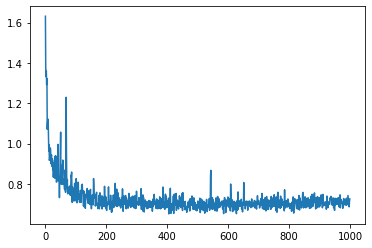

In [47]:
plt.plot(val_loss)

# Best score using Graph Neural Network

In [49]:
min(val_loss)

0.593853282729301